##### Copyright 2022 The TensorFlow Authors.

https://www.tensorflow.org/text/tutorials/transformer 

<style>
td {
  text-align: center;
}

th {
  text-align: center;
}
</style>

# Neural machine translation with a Transformer and Keras

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/text/tutorials/transformer">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/transformer.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/text/blob/master/docs/tutorials/transformer.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/text/docs/tutorials/transformer.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial demonstrates how to create and train a [sequence-to-sequence](https://developers.google.com/machine-learning/glossary#sequence-to-sequence-task) [Transformer](https://developers.google.com/machine-learning/glossary#Transformer) model to translate [Portuguese into English](https://www.tensorflow.org/datasets/catalog/ted_hrlr_translate#ted_hrlr_translatept_to_en). The Transformer was originally proposed in ["Attention is all you need"](https://arxiv.org/abs/1706.03762) by Vaswani et al. (2017).

Transformers are deep neural networks that replace CNNs and RNNs with [self-attention](https://developers.google.com/machine-learning/glossary#self-attention). Self attention allows Transformers to easily transmit information across the input sequences.

As explained in the [Google AI Blog post](https://ai.googleblog.com/2017/08/transformer-novel-neural-network.html):

> Neural networks for machine translation typically contain an encoder reading the input sentence and generating a representation of it. A decoder then generates the output sentence word by word while consulting the representation generated by the encoder. The Transformer starts by generating initial representations, or embeddings, for each word... Then, using self-attention, it aggregates information from all of the other words, generating a new representation per word informed by the entire context, represented by the filled balls. This step is then repeated multiple times in parallel for all words, successively generating new representations.

<img src="https://www.tensorflow.org/images/tutorials/transformer/apply_the_transformer_to_machine_translation.gif" alt="Applying the Transformer to machine translation">

Figure 1: Applying the Transformer to machine translation. Source: [Google AI Blog](https://ai.googleblog.com/2017/08/transformer-novel-neural-network.html).


That's a lot to digest, the goal of this tutorial is to break it down into easy to understand parts. In this tutorial you will:

- Prepare the data.
- Implement necessary components:
  - Positional embeddings.
  - Attention layers.
  - The encoder and decoder.
- Build & train the Transformer.
- Generate translations.
- Export the model.

To get the most out of this tutorial, it helps if you know about [the basics of text generation](./text_generation.ipynb) and attention mechanisms. 

A Transformer is a sequence-to-sequence encoder-decoder model similar to the model in the [NMT with attention tutorial](https://www.tensorflow.org/text/tutorials/nmt_with_attention).
A single-layer Transformer takes a little more code to write, but is almost identical to that encoder-decoder RNN model. The only difference is that the RNN layers are replaced with self attention layers.
This tutorial builds a 4-layer Transformer which is larger and more powerful, but not fundamentally more complex.

<table>
<tr>
  <th>The <a href=https://www.tensorflow.org/text/tutorials/nmt_with_attention>RNN+Attention model</a></th>
  <th>A 1-layer transformer</th>
</tr>
<tr>
  <td>
   <img width=411 src="https://www.tensorflow.org/images/tutorials/transformer/RNN+attention-words.png"/>
  </td>
  <td>
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/Transformer-1layer-words.png"/>
  </td>
</tr>
</table>

After training the model in this notebook, you will be able to input a Portuguese sentence and return the English translation.

<img src="https://www.tensorflow.org/images/tutorials/transformer/attention_map_portuguese.png" alt="Attention heatmap">

Figure 2: Visualized attention weights that you can generate at the end of this tutorial.

## Why Transformers are significant

- Transformers excel at modeling sequential data, such as natural language.
- Unlike the [recurrent neural networks (RNNs)](./text_generation.ipynb), Transformers are parallelizable. This makes them efficient on hardware like GPUs and TPUs. The main reasons is that Transformers replaced recurrence with attention, and computations can happen simultaneously. Layer outputs can be computed in parallel, instead of a series like an RNN.
- Unlike [RNNs](https://www.tensorflow.org/guide/keras/rnn) (like [seq2seq, 2014](https://arxiv.org/abs/1409.3215)) or [convolutional neural networks (CNNs)](https://www.tensorflow.org/tutorials/images/cnn) (for example, [ByteNet](https://arxiv.org/abs/1610.10099)), Transformers are able to capture distant or long-range contexts and dependencies in the data between distant positions in the input or output sequences. Thus, longer connections can be learned. Attention allows each location to have access to the entire input at each layer, while in RNNs and CNNs, the information needs to pass through many processing steps to move a long distance, which makes it harder to learn.
- Transformers make no assumptions about the temporal/spatial relationships across the data. This is ideal for processing a set of objects (for example, [StarCraft units](https://www.deepmind.com/blog/alphastar-mastering-the-real-time-strategy-game-starcraft-ii)).

<img src="https://www.tensorflow.org/images/tutorials/transformer/encoder_self_attention_distribution.png" width="800" alt="Encoder self-attention distribution for the word it from the 5th to the 6th layer of a Transformer trained on English-to-French translation">

Figure 3: The encoder self-attention distribution for the word “it” from the 5th to the 6th layer of a Transformer trained on English-to-French translation (one of eight attention heads). Source: [Google AI Blog](https://ai.googleblog.com/2017/08/transformer-novel-neural-network.html).

## Setup

Begin by installing [TensorFlow Datasets](https://tensorflow.org/datasets) for loading the dataset and [TensorFlow Text](https://www.tensorflow.org/text) for text preprocessing:

In [3]:
# Install the most re version of TensorFlow to use the improved
# masking support for `tf.keras.layers.MultiHeadAttention`.
# !apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2
# !pip uninstall -y -q tensorflow keras tensorflow-estimator tensorflow-text
# !pip install protobuf~=3.20.3
# !pip install -q tensorflow_datasets
# !pip install -q -U tensorflow-text tensorflow

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


/usr/bin/pip:6: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import load_entry_point
/usr/bin/pip:6: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import load_entry_point
     |████████████████████████████████| 1.0 MB 780 kB/s eta 0:00:01
ERROR: mediapipe 0.10.8 has requirement flatbuffers>=2.0, but you'll have flatbuffers 1.12 which is incompatible.
ERROR: tensorboard 2.9.1 has requirement protobuf<3.20,>=3.9.2, but you'll have protobuf 3.20.3 which is incompatible.
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.0
    Uninstalling protobuf-3.20.0:
      Successfully uninstalled protobuf-3.20.0
/usr/bin/pip:6: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import load_entry_po

Import the necessary modules:

In [36]:
import logging
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow as tf

import tensorflow_text

## Data handling

This section downloads the dataset and the subword tokenizer, from [this tutorial](https://www.tensorflow.org/text/guide/subwords_tokenizer), then wraps it all up in a `tf.data.Dataset` for training.

 <section class="expandable tfo-display-only-on-site">
 <button type="button" class="button-red button expand-control">Toggle section</button>


### Download the dataset

Use TensorFlow Datasets to load the [Portuguese-English translation dataset](https://www.tensorflow.org/datasets/catalog/ted_hrlr_translate#ted_hrlr_translatept_to_en)D Talks Open Translation Project. This dataset contains approximately 52,000 training, 1,200 validation and 1,800 test examples.

In [37]:
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en',
                               with_info=True,
                               as_supervised=True)

train_examples, val_examples = examples['train'], examples['validation']

In [38]:
train_examples

<_PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>

The `tf.data.Dataset` object returned by TensorFlow Datasets yields pairs of text examples:

In [39]:
for pt_examples, en_examples in train_examples.batch(3).take(1):
  print('> Examples in Portuguese:')
  for pt in pt_examples.numpy():
    print(pt.decode('utf-8'))
  print()

  print('> Examples in English:')
  for en in en_examples.numpy():
    print(en.decode('utf-8'))

> Examples in Portuguese:
e quando melhoramos a procura , tiramos a única vantagem da impressão , que é a serendipidade .
mas e se estes fatores fossem ativos ?
mas eles não tinham a curiosidade de me testar .

> Examples in English:
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .


2024-03-18 16:52:04.491698: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


### Set up the tokenizer

Now that you have loaded the dataset, you need to tokenize the text, so that each element is represented as a [token](https://developers.google.com/machine-learning/glossary#token) or token ID (a numeric representation).

Tokenization is the process of breaking up text, into "tokens". Depending on the tokenizer, these tokens can represent sentence-pieces, words, subwords, or characters. To learn more about tokenization, visit [this guide](https://www.tensorflow.org/text/guide/tokenizers).

This tutorial uses the tokenizers built in the [subword tokenizer](https://www.tensorflow.org/text/guide/subwords_tokenizer) tutorial. That tutorial optimizes two `text.BertTokenizer` objects (one for English, one for Portuguese) for **this dataset** and exports them in a TensorFlow `saved_model` format.

> Note: This is different from the [original paper](https://arxiv.org/pdf/1706.03762.pdf), section 5.1, where they used a single byte-pair tokenizer for both the source and target with a vocabulary-size of 37000.

Download, extract, and import the `saved_model`:

In [40]:
model_name = 'ted_hrlr_translate_pt_en_converter'
tf.keras.utils.get_file(
    f'{model_name}.zip',
    f'https://storage.googleapis.com/download.tensorflow.org/models/{model_name}.zip',
    cache_dir='.', cache_subdir='', extract=True
)

'./ted_hrlr_translate_pt_en_converter.zip'

In [41]:
tokenizers = tf.saved_model.load(model_name)

The `tf.saved_model` contains two text tokenizers, one for English and one for Portuguese. Both have the same methods:

In [42]:
[item for item in dir(tokenizers.en) if not item.startswith('_')]

['detokenize',
 'get_reserved_tokens',
 'get_vocab_path',
 'get_vocab_size',
 'lookup',
 'tokenize',
 'tokenizer',
 'vocab']

The `tokenize` method converts a batch of strings to a padded-batch of token IDs. This method splits punctuation, lowercases and unicode-normalizes the input before tokenizing. That standardization is not visible here because the input data is already standardized.

In [43]:
print('> This is a batch of strings:')
for en in en_examples.numpy():
  print(en.decode('utf-8'))

> This is a batch of strings:
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .


In [44]:
encoded = tokenizers.en.tokenize(en_examples)

print('> This is a padded-batch of token IDs:')
for row in encoded.to_list():
  print(row)

> This is a padded-batch of token IDs:
[2, 72, 117, 79, 1259, 1491, 2362, 13, 79, 150, 184, 311, 71, 103, 2308, 74, 2679, 13, 148, 80, 55, 4840, 1434, 2423, 540, 15, 3]
[2, 87, 90, 107, 76, 129, 1852, 30, 3]
[2, 87, 83, 149, 50, 9, 56, 664, 85, 2512, 15, 3]


The `detokenize` method attempts to convert these token IDs back to human-readable text: 

In [45]:
round_trip = tokenizers.en.detokenize(encoded)

print('> This is human-readable text:')
for line in round_trip.numpy():
  print(line.decode('utf-8'))

> This is human-readable text:
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n ' t test for curiosity .


The lower level `lookup` method converts from token-IDs to token text:

In [46]:
print('> This is the text split into tokens:')
tokens = tokenizers.en.lookup(encoded)
tokens

> This is the text split into tokens:


<tf.RaggedTensor [[b'[START]', b'and', b'when', b'you', b'improve', b'search', b'##ability',
  b',', b'you', b'actually', b'take', b'away', b'the', b'one', b'advantage',
  b'of', b'print', b',', b'which', b'is', b's', b'##ere', b'##nd', b'##ip',
  b'##ity', b'.', b'[END]']                                                 ,
 [b'[START]', b'but', b'what', b'if', b'it', b'were', b'active', b'?',
  b'[END]']                                                           ,
 [b'[START]', b'but', b'they', b'did', b'n', b"'", b't', b'test', b'for',
  b'curiosity', b'.', b'[END]']                                          ]>

The output demonstrates the "subword" aspect of the subword tokenization.

For example, the word `'searchability'` is decomposed into `'search'` and `'##ability'`, and the word `'serendipity'` into `'s'`, `'##ere'`, `'##nd'`, `'##ip'` and `'##ity'`.

Note that the tokenized text includes `'[START]'` and `'[END]'` tokens.

The distribution of tokens per example in the dataset is as follows:

In [47]:
lengths = []

for pt_examples, en_examples in train_examples.batch(1024):
  pt_tokens = tokenizers.pt.tokenize(pt_examples)
  lengths.append(pt_tokens.row_lengths())
  
  en_tokens = tokenizers.en.tokenize(en_examples)
  lengths.append(en_tokens.row_lengths())
  print('.', end='', flush=True)

........

...........................................

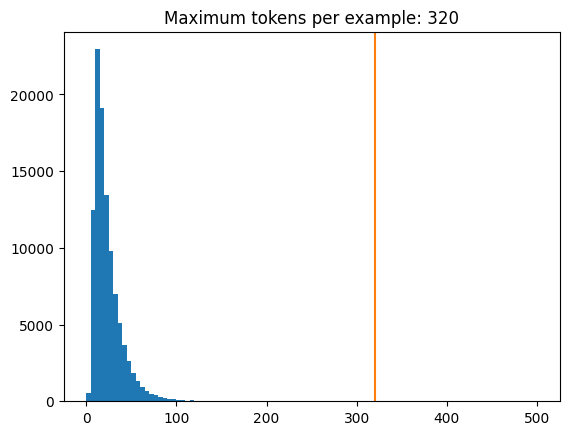

In [48]:
all_lengths = np.concatenate(lengths)

plt.hist(all_lengths, np.linspace(0, 500, 101))
plt.ylim(plt.ylim())
max_length = max(all_lengths)
plt.plot([max_length, max_length], plt.ylim())
plt.title(f'Maximum tokens per example: {max_length}');

### Set up a data pipeline with `tf.data`

The following function takes batches of text as input, and converts them to a format suitable for training. 

1. It tokenizes them into ragged batches.
2. It trims each to be no longer than `MAX_TOKENS`.
3. It splits the target (English) tokens into inputs and labels. These are shifted by one step so that at each input location the `label` is the id of the next token.
4. It converts the `RaggedTensor`s to padded dense `Tensor`s.
5. It returns an `(inputs, labels)` pair.


In [49]:
MAX_TOKENS=128
def prepare_batch(pt, en):
    pt = tokenizers.pt.tokenize(pt)      # Output is ragged.
    pt = pt[:, :MAX_TOKENS]    # Trim to MAX_TOKENS.
    pt = pt.to_tensor()  # Convert to 0-padded dense Tensor

    en = tokenizers.en.tokenize(en)
    en = en[:, :(MAX_TOKENS+1)]
    en_inputs = en[:, :-1].to_tensor()  # Drop the [END] tokens
    en_labels = en[:, 1:].to_tensor()   # Drop the [START] tokens

    return (pt, en_inputs), en_labels

The function below converts a dataset of text examples into data of batches for training. 

1. It tokenizes the text, and filters out the sequences that are too long.
   (The `batch`/`unbatch` is included because the tokenizer is much more efficient on large batches).
2. The `cache` method ensures that that work is only executed once.
3. Then `shuffle` and, `dense_to_ragged_batch` randomize the order and assemble batches of examples. 
4. Finally `prefetch` runs the dataset in parallel with the model to ensure that data is available when needed. See [Better performance with the `tf.data`](https://www.tensorflow.org/guide/data_performance.ipynb) for details.

In [50]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [51]:
def make_batches(ds):
  return (
      ds
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .map(prepare_batch, tf.data.AUTOTUNE)
      .prefetch(buffer_size=tf.data.AUTOTUNE))

 </section>

## Test the Dataset 

In [52]:
# Create training and validation set batches.
train_batches = make_batches(train_examples)
val_batches = make_batches(val_examples)

The resulting `tf.data.Dataset` objects are setup for training with Keras.
Keras `Model.fit` training expects `(inputs, labels)` pairs.
The `inputs` are pairs of tokenized Portuguese and English sequences, `(pt, en)`.
The `labels` are the same English sequences shifted by 1.
This shift is so that at each location input `en` sequence, the `label` in the next token.


<table>
<tr>
  <th>Inputs at the bottom, labels at the top.</th>
</tr>
<tr>
  <td>
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/Transformer-1layer-words.png"/>
  </td>
</tr>
</table>

This is the same as the [text generation tutorial](text_generation.ipynb),
except here you have additional input "context" (the Portuguese sequence) that the model is "conditioned" on.

This setup is called "teacher forcing" because regardless of the model's output at each timestep, it gets the true value as input for the next timestep.
This is a simple and efficient way to train a text generation model.
It's efficient because you don't need to run the model sequentially, the outputs at the different sequence locations can be computed in parallel.

You might have expected the `input, output`, pairs to simply be the `Portuguese, English` sequences.
Given the Portuguese sequence, the model would try to generate the English sequence.

It's possible to train a model that way. You'd need to write out the inference loop and pass the model's output back to the input.
It's slower (time steps can't run in parallel), and a harder task to learn (the model can't get the end of a sentence right until it gets the beginning right),
but it can give a more stable model because the model has to learn to correct its own errors during training.

In [55]:
for (pt, en), en_labels in train_batches.take(1):
  break

print(pt.shape)
print(en.shape)
print(en_labels.shape)

(64, 80)
(64, 66)
(64, 66)


The `en` and `en_labels` are the same, just shifted by 1:

In [56]:
print(en[0][:10])
print(en_labels[0][:10])

tf.Tensor([  2  10 189  11   0   0   0   0   0   0], shape=(10,), dtype=int64)
tf.Tensor([ 10 189  11   3   0   0   0   0   0   0], shape=(10,), dtype=int64)


## Define the components

There's a lot going on inside a Transformer. The important things to remember are:

1. It follows the same general pattern as a standard sequence-to-sequence model with an encoder and a decoder.
2. If you work through it step by step it will all make sense.

<table>
<tr>
  <th colspan=1>The original Transformer diagram</th>
  <th colspan=1>A representation of a 4-layer Transformer</th>
</tr>
<tr>
  <td>
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/transformer.png"/>
  </td>
  <td>
   <img width=307 src="https://www.tensorflow.org/images/tutorials/transformer/Transformer-4layer-compact.png"/>
  </td>
</tr>
</table>

Each of the components in these two diagrams will be explained as you progress through the tutorial.

### The embedding and positional encoding layer

The inputs to both the encoder and decoder use the same embedding and positional encoding logic. 

<table>
<tr>
  <th colspan=1>The embedding and positional encoding layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/PositionalEmbedding.png"/>
  </td>
</tr>
</table>

Given a sequence of tokens, both the input tokens (Portuguese) and target tokens (English) have to be converted to vectors using a `tf.keras.layers.Embedding` layer.

The attention layers used throughout the model see their input as a set of vectors, with no order. Since the model doesn't contain any recurrent or convolutional layers. It needs some way to identify word order, otherwise it would see the input sequence as a [bag of words](https://developers.google.com/machine-learning/glossary#bag-of-words) instance, `how are you`, `how you are`, `you how are`, and so on, are indistinguishable.

A Transformer adds a "Positional Encoding" to the embedding vectors. It uses a set of sines and cosines at different frequencies (across the sequence). By definition nearby elements will have similar position encodings.

The original paper uses the following formula for calculating the positional encoding:

$$\Large{PE_{(pos, 2i)} = \sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = \cos(pos / 10000^{2i / d_{model}})} $$

Note: The code below implements it, but instead of interleaving the sines and cosines, the vectors of sines and cosines are simply concatenated. Permuting the channels like this is functionally equivalent, and just a little easier to implement and show in the plots below.

In [57]:
def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)
  
  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1) 

  return tf.cast(pos_encoding, dtype=tf.float32)

The position encoding function is a stack of sines and cosines that vibrate at different frequencies depending on their location along the depth of the embedding vector. They vibrate across the position axis.

(2048, 512)


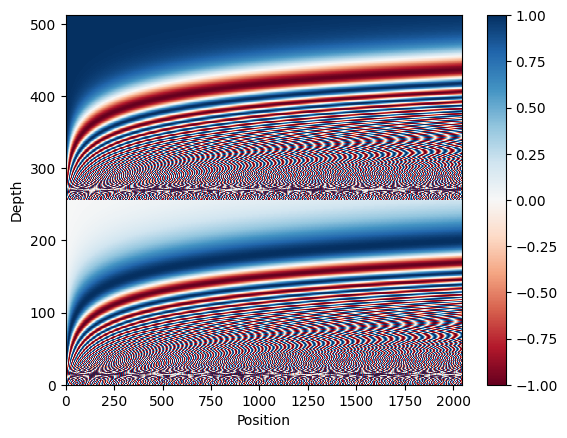

In [58]:
#@title
pos_encoding = positional_encoding(length=2048, depth=512)

# Check the shape.
print(pos_encoding.shape)

# Plot the dimensions.
plt.pcolormesh(pos_encoding.numpy().T, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

By definition these vectors align well with nearby vectors along the position axis. Below the position encoding vectors are normalized and the vector from position `1000` is compared, by dot-product, to all the others:

(0.0, 1.0)

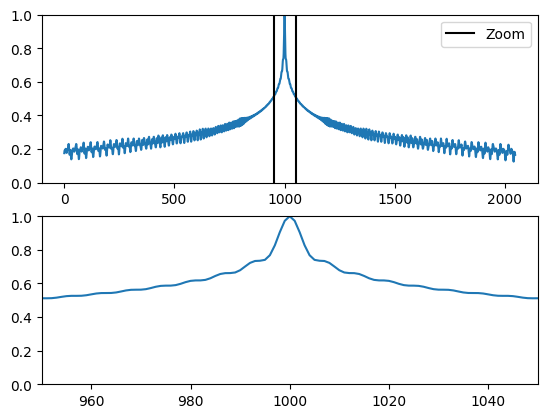

In [59]:
#@title
pos_encoding/=tf.norm(pos_encoding, axis=1, keepdims=True)
p = pos_encoding[1000]
dots = tf.einsum('pd,d -> p', pos_encoding, p)
plt.subplot(2,1,1)
plt.plot(dots)
plt.ylim([0,1])
plt.plot([950, 950, float('nan'), 1050, 1050],
         [0,1,float('nan'),0,1], color='k', label='Zoom')
plt.legend()
plt.subplot(2,1,2)
plt.plot(dots)
plt.xlim([950, 1050])
plt.ylim([0,1])


So use this to create a `PositionEmbedding` layer that looks-up a token's embedding vector and adds the position vector:

In [60]:
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True) 
    self.pos_encoding = positional_encoding(length=2048, depth=d_model)

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)
    # This factor sets the relative scale of the embedding and positonal_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x


> Note: The [original paper](https://arxiv.org/pdf/1706.03762.pdf), section 3.4 and 5.1, uses a single tokenizer and weight matrix for both the source and target languages. This tutorial uses two separate tokenizers and weight matrices.

In [61]:
embed_pt = PositionalEmbedding(vocab_size=tokenizers.pt.get_vocab_size(), d_model=512)
embed_en = PositionalEmbedding(vocab_size=tokenizers.en.get_vocab_size(), d_model=512)

pt_emb = embed_pt(pt)
en_emb = embed_en(en)

2024-03-18 16:54:29.103877: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 15902720 exceeds 10% of free system memory.
2024-03-18 16:54:29.112035: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 15902720 exceeds 10% of free system memory.
2024-03-18 16:54:29.117890: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 15902720 exceeds 10% of free system memory.
2024-03-18 16:54:29.146853: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 14356480 exceeds 10% of free system memory.
2024-03-18 16:54:29.151716: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 14356480 exceeds 10% of free system memory.


In [62]:
en_emb._keras_mask

<tf.Tensor: shape=(64, 66), dtype=bool, numpy=
array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])>

### Add and normalize

<table>
<tr>
  <th colspan=2>Add and normalize</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/Add+Norm.png"/>
  </td>
</tr>
</table>

These "Add & Norm" blocks are scattered throughout the model. Each one joins a residual connection and runs the result through a `LayerNormalization` layer.

The easiest way to organize the code is around these residual blocks. The following sections will define custom layer classes for each. 

The residual "Add & Norm" blocks are included so that training is efficient. The residual connection provides a direct path for the gradient (and ensures that vectors are **updated** by the attention layers instead of **replaced**), while the normalization maintains a reasonable scale for the outputs.

Note: The implementations, below, use the `Add` layer to ensure that Keras masks are propagated (the `+` operator does not).



### The base attention layer

Attention layers are used throughout the model. These are all identical except for how the attention is configured. Each one contains a `layers.MultiHeadAttention`, a `layers.LayerNormalization` and a `layers.Add`. 

<table>
<tr>
  <th colspan=2>The base attention layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/BaseAttention.png"/>
  </td>
</tr>
</table>

To implement these attention layers, start with a simple base class that just contains the component layers. Each use-case will be implemented as a subclass. It's a little more code to write this way, but it keeps the intention clear.

In [63]:
class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

#### Attention refresher

Before you get into the specifics of each usage, here is a quick refresher on how attention works:

<table>
<tr>
  <th colspan=1>The base attention layer</th>
</tr>
<tr>
  <td>
   <img width=430 src="https://www.tensorflow.org/images/tutorials/transformer/BaseAttention-new.png"/>
  </td>
</tr>
</table>

There are two inputs:

1. The query sequence; the sequence being processed; the sequence doing the attending (bottom).
2. The context sequence; the sequence being attended to (left).

The output has the same shape as the query-sequence.

The common comparison is that this operation is like a dictionary lookup.
A **fuzzy**, **differentiable**, **vectorized** dictionary lookup.

Here's a regular python dictionary, with 3 keys and 3 values being passed a single query.

```
d = {'color': 'blue', 'age': 22, 'type': 'pickup'}
result = d['color']
```

- The `query`s is what you're trying to find.
- The `key`s what sort of information the dictionary has.
- The `value` is that information.

When you look up a `query` in a regular dictionary, the dictionary finds the matching `key`, and returns its associated `value`.
The `query` either has a matching `key` or it doesn't.
You can imagine a **fuzzy** dictionary where the keys don't have to match perfectly.
If you looked up `d["species"]` in the dictionary above, maybe you'd want it to return `"pickup"` since that's the best match for the query.

An attention layer does a fuzzy lookup like this, but it's not just looking for the best key.
It combines the `values` based on how well the `query` matches each `key`.

How does that work? In an attention layer the `query`, `key`, and `value` are each vectors.
Instead of doing a hash lookup the attention layer combines the `query` and `key` vectors to determine how well they match, the "attention score".
The layer returns the average across all the `values`, weighted by the "attention scores".

Each location the query-sequence provides a `query` vector.
The context sequence acts as the dictionary. At each location in the context sequence provides a `key` and `value` vector.
The input vectors are not used directly, the `layers.MultiHeadAttention` layer includes `layers.Dense` layers to project the input vectors before using them.


### The cross attention layer

At the literal center of the Transformer is the cross-attention layer. This layer connects the encoder and decoder. This layer is the most straight-forward use of attention in the model, it performs the same task as the attention block in the [NMT with attention tutorial](https://www.tensorflow.org/text/tutorials/nmt_with_attention).

<table>
<tr>
  <th colspan=1>The cross attention layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/CrossAttention.png"/>
  </td>
</tr>
</table>

To implement this you pass the target sequence `x` as the `query` and the `context` sequence as the `key/value` when calling the `mha` layer:

In [64]:
class CrossAttention(BaseAttention):
  def call(self, x, context):
    attn_output, attn_scores = self.mha(
        query=x,
        key=context,
        value=context,
        return_attention_scores=True)
   
    # Cache the attention scores for plotting later.
    self.last_attn_scores = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

The caricature below shows how information flows through this layer. The columns represent the weighted sum over the context sequence.

For simplicity the residual connections are not shown.

<table>
<tr>
  <th>The cross attention layer</th>
</tr>
<tr>
  <td>
   <img width=430 src="https://www.tensorflow.org/images/tutorials/transformer/CrossAttention-new-full.png"/>
  </td>
</tr>
</table>

The output length is the length of the `query` sequence, and not the length of the context `key/value` sequence.

The diagram is further simplified, below. There's no need to draw the entire "Attention weights" matrix.
The point is that each `query` location can see all the `key/value` pairs in the context, but no information is exchanged between the queries.

<table>
<tr>
  <th>Each query sees the whole context.</th>
</tr>
<tr>
  <td>
   <img width=430 src="https://www.tensorflow.org/images/tutorials/transformer/CrossAttention-new.png"/>
  </td>
</tr>
</table>

Test run it on sample inputs:

In [65]:
sample_ca = CrossAttention(num_heads=2, key_dim=512)

print(pt_emb.shape)
print(en_emb.shape)
print(sample_ca(en_emb, pt_emb).shape)

(64, 80, 512)
(64, 66, 512)
(64, 66, 512)


### The global self attention layer

This layer is responsible for processing the context sequence, and propagating information along its length:

<table>
<tr>
  <th colspan=1>The global self attention layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/SelfAttention.png"/>
  </td>
</tr>
</table>

Since the context sequence is fixed while the translation is being generated, information is allowed to flow in both directions. 

Before Transformers and self attention, models commonly used RNNs or CNNs to do this task:

<table>
<tr>
  <th colspan=1>Bidirectional RNNs and CNNs</th>
</tr>
<tr>
  <td>
   <img width=500 src="https://www.tensorflow.org/images/tutorials/transformer/RNN-bidirectional.png"/>
  </td>
</tr>
<tr>
  <td>
   <img width=500 src="https://www.tensorflow.org/images/tutorials/transformer/CNN.png"/>
  </td>
</tr>
</table>

RNNs and CNNs have their limitations.

- The RNN allows information to flow all the way across the sequence, but it passes through many processing steps to get there (limiting gradient flow). These RNN steps have to be run sequentially and so the RNN is less able to take advantage of modern parallel devices.
- In the CNN each location can be processed in parallel, but it only provides a limited receptive field. The receptive field only grows linearly with the number of CNN layers,  You need to stack a number of Convolution layers to transmit information across the sequence ([Wavenet](https://arxiv.org/abs/1609.03499) reduces this problem by using dilated convolutions).

The global self attention layer on the other hand lets every sequence element directly access every other sequence element, with only a few operations, and all the outputs can be computed in parallel. 

To implement this layer you just need to pass the target sequence, `x`, as both the `query`, and `value` arguments to the `mha` layer: 

In [66]:
class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [67]:
sample_gsa = GlobalSelfAttention(num_heads=2, key_dim=512)

print(pt_emb.shape)
print(sample_gsa(pt_emb).shape)

(64, 80, 512)
(64, 80, 512)


Sticking with the same style as before you could draw it like this:

<table>
<tr>
  <th colspan=1>The global self attention layer</th>
<tr>
<tr>
  <td>
   <img width=330 src="https://www.tensorflow.org/images/tutorials/transformer/SelfAttention-new-full.png"/>
  </td>
</tr>
</table>

Again, the residual connections are omitted for clarity.

It's more compact, and just as accurate to draw it like this:

<table>
<tr>
  <th colspan=1>The global self attention layer</th>
<tr>
<tr>
  <td>
   <img width=500 src="https://www.tensorflow.org/images/tutorials/transformer/SelfAttention-new.png"/>
  </td>
</tr>
</table>

### The causal self attention layer

This layer does a similar job as the global self attention layer, for the output sequence:

<table>
<tr>
  <th colspan=1>The causal self attention layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/CausalSelfAttention.png"/>
  </td>
</tr>
</table>

This needs to be handled differently from the encoder's global self attention layer.  

Like the [text generation tutorial](https://www.tensorflow.org/text/tutorials/text_generation), and the [NMT with attention](https://www.tensorflow.org/text/tutorials/nmt_with_attention) tutorial, Transformers are an "autoregressive" model: They generate the text one token at a time and feed that output back to the input. To make this _efficient_, these models ensure that the output for each sequence element only depends on the previous sequence elements; the models are "causal".

A single-direction RNN is causal by definition. To make a causal convolution you just need to pad the input and shift the output so that it aligns correctly (use `layers.Conv1D(padding='causal')`) .

<table>
<tr>
  <th colspan=1>Causal RNNs and CNNs</th>
</tr>
<tr>
  <td>
   <img width=500 src="https://www.tensorflow.org/images/tutorials/transformer/RNN.png"/>
  </td>
</tr>
<tr>
  <td>
   <img width=500 src="https://www.tensorflow.org/images/tutorials/transformer/CNN-causal.png"/>
  </td>
</tr>
</table>

A causal model is efficient in two ways: 

1. In training, it lets you compute loss for every location in the output sequence while executing the model just once.
2. During inference, for each new token generated you only need to calculate its outputs, the outputs for the previous sequence elements can be reused.
  - For an RNN you just need the RNN-state to account for previous computations (pass `return_state=True` to the RNN layer's constructor).
  - For a CNN you would need to follow the approach of [Fast Wavenet](https://arxiv.org/abs/1611.09482)

To build a causal self attention layer, you need to use an appropriate mask when computing the attention scores and summing the attention `value`s.

This is taken care of automatically if you pass `use_causal_mask = True` to the `MultiHeadAttention` layer when you call it:

In [68]:
class CausalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x,
        use_causal_mask = True)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

The causal mask ensures that each location only has access to the locations that come before it: 

<table>
<tr>
  <th colspan=1>The causal self attention layer</th>
<tr>
<tr>
  <td>
   <img width=330 src="https://www.tensorflow.org/images/tutorials/transformer/CausalSelfAttention-new-full.png"/>
  </td>
</tr>
</table>

Again, the residual connections are omitted for simplicity.

The more compact representation of this layer would be:

<table>
</tr>
  <th colspan=1>The causal self attention layer</th>
<tr>
<tr>
  <td>
   <img width=430 src="https://www.tensorflow.org/images/tutorials/transformer/CausalSelfAttention-new.png"/>
  </td>
</tr>
</table>

Test out the layer:

In [69]:
sample_csa = CausalSelfAttention(num_heads=2, key_dim=512)

print(en_emb.shape)
print(sample_csa(en_emb).shape)

(64, 66, 512)
(64, 66, 512)


The output for early sequence elements doesn't depend on later elements, so it shouldn't matter if you trim elements before or after applying the layer:

In [70]:
out1 = sample_csa(embed_en(en[:, :3])) 
out2 = sample_csa(embed_en(en))[:, :3]

tf.reduce_max(abs(out1 - out2)).numpy()

4.7683716e-07

Note: When using Keras masks, the output values at invalid locations are not well defined. So the above may not hold for masked regions. 

### The feed forward network

The transformer also includes this point-wise feed-forward network in both the encoder and decoder:

<table>
<tr>
  <th colspan=1>The feed forward network</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/FeedForward.png"/>
  </td>
</tr>
</table>

The network consists of two linear layers (`tf.keras.layers.Dense`) with a ReLU activation in-between, and a dropout layer. As with the attention layers the code here also includes the residual connection and normalization:

In [71]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x) 
    return x


Test the layer, the output is the same shape as the input:

In [72]:
sample_ffn = FeedForward(512, 2048)

print(en_emb.shape)
print(sample_ffn(en_emb).shape)

(64, 66, 512)
(64, 66, 512)


### The encoder layer

The encoder contains a stack of `N` encoder layers. Where each `EncoderLayer` contains a `GlobalSelfAttention` and `FeedForward` layer:

<table>
<tr>
  <th colspan=1>The encoder layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/EncoderLayer.png"/>
  </td>
</tr>
</table>

Here is the definition of the `EncoderLayer`:

In [73]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)
    return x

And a quick test, the output will have the same shape as the input:

In [74]:
sample_encoder_layer = EncoderLayer(d_model=512, num_heads=8, dff=2048)

print(pt_emb.shape)
print(sample_encoder_layer(pt_emb).shape)

(64, 80, 512)
(64, 80, 512)


### The encoder

Next build the encoder.

<table>
<tr>
  <th colspan=1>The encoder</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/Encoder.png"/>
  </td>
</tr>
</table>

The encoder consists of:

- A `PositionalEmbedding` layer at the input.
- A stack of `EncoderLayer` layers.

In [75]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(
        vocab_size=vocab_size, d_model=d_model)

    self.enc_layers = [
        EncoderLayer(d_model=d_model,
                     num_heads=num_heads,
                     dff=dff,
                     dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x):
    # `x` is token-IDs shape: (batch, seq_len)
    x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.
    
    # Add dropout.
    x = self.dropout(x)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x)

    return x  # Shape `(batch_size, seq_len, d_model)`.

Test the encoder:

In [76]:
# Instantiate the encoder.
sample_encoder = Encoder(num_layers=4,
                         d_model=512,
                         num_heads=8,
                         dff=2048,
                         vocab_size=8500)

sample_encoder_output = sample_encoder(pt, training=False)

# Print the shape.
print(pt.shape)
print(sample_encoder_output.shape)  # Shape `(batch_size, input_seq_len, d_model)`.

(64, 80)
(64, 80, 512)


### The decoder layer

The decoder's stack is slightly more complex, with each `DecoderLayer` containing a `CausalSelfAttention`, a `CrossAttention`, and a `FeedForward` layer:  

<table>
<tr>
  <th colspan=1>The decoder layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/DecoderLayer.png"/>
  </td>
</tr>
</table>

In [77]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,
               *,
               d_model,
               num_heads,
               dff,
               dropout_rate=0.1):
    super(DecoderLayer, self).__init__()

    self.causal_self_attention = CausalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)
    
    self.cross_attention = CrossAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x, context):
    x = self.causal_self_attention(x=x)
    x = self.cross_attention(x=x, context=context)

    # Cache the last attention scores for plotting later
    self.last_attn_scores = self.cross_attention.last_attn_scores

    x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
    return x

Test the decoder layer:

In [78]:
sample_decoder_layer = DecoderLayer(d_model=512, num_heads=8, dff=2048)

sample_decoder_layer_output = sample_decoder_layer(
    x=en_emb, context=pt_emb)

print(en_emb.shape)
print(pt_emb.shape)
print(sample_decoder_layer_output.shape)  # `(batch_size, seq_len, d_model)`

(64, 66, 512)
(64, 80, 512)
(64, 66, 512)


### The decoder

Similar to the `Encoder`, the `Decoder` consists of a `PositionalEmbedding`, and a stack of `DecoderLayer`s:

<table>
<tr>
  <th colspan=1>The embedding and positional encoding layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/Decoder.png"/>
  </td>
</tr>
</table>


Define the decoder by extending `tf.keras.layers.Layer`:

In [79]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size,
               dropout_rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size,
                                             d_model=d_model)
    self.dropout = tf.keras.layers.Dropout(dropout_rate)
    self.dec_layers = [
        DecoderLayer(d_model=d_model, num_heads=num_heads,
                     dff=dff, dropout_rate=dropout_rate)
        for _ in range(num_layers)]

    self.last_attn_scores = None

  def call(self, x, context):
    # `x` is token-IDs shape (batch, target_seq_len)
    x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)

    x = self.dropout(x)

    for i in range(self.num_layers):
      x  = self.dec_layers[i](x, context)

    self.last_attn_scores = self.dec_layers[-1].last_attn_scores

    # The shape of x is (batch_size, target_seq_len, d_model).
    return x

Test the decoder:

In [80]:
# Instantiate the decoder.
sample_decoder = Decoder(num_layers=4,
                         d_model=512,
                         num_heads=8,
                         dff=2048,
                         vocab_size=8000)

output = sample_decoder(
    x=en,
    context=pt_emb)

# Print the shapes.
print(en.shape)
print(pt_emb.shape)
print(output.shape)

(64, 66)
(64, 80, 512)
(64, 66, 512)


In [45]:
sample_decoder.last_attn_scores.shape  # (batch, heads, target_seq, input_seq)

TensorShape([64, 8, 58, 62])

Having created the Transformer encoder and decoder, it's time to build the Transformer model and train it.

## The Transformer

You now have `Encoder` and `Decoder`. To complete the `Transformer` model, you need to put them together and add a final linear (`Dense`) layer which converts the resulting vector at each location into output token probabilities. 

The output of the decoder is the input to this final linear layer.

<table>
<tr>
  <th colspan=1>The transformer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/transformer.png"/>
  </td>
</tr>
</table>

A `Transformer` with one layer in both the `Encoder` and `Decoder` looks almost exactly like the model from the [RNN+attention tutorial](https://www.tensorflow.org/text/tutorials/nmt_with_attention). A multi-layer Transformer has more layers, but is fundamentally doing the same thing.

<table>
<tr>
  <th colspan=1>A 1-layer transformer</th>
  <th colspan=1>A 4-layer transformer</th>
</tr>
<tr>
  <td>
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/Transformer-1layer-compact.png"/>
  </td>
  <td rowspan=3>
   <img width=330 src="https://www.tensorflow.org/images/tutorials/transformer/Transformer-4layer-compact.png"/>
  </td>
</tr>
<tr>
  <th colspan=1>The RNN+Attention model</th>
</tr>
<tr>
  <td>
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/RNN+attention-compact.png"/>
  </td>
</tr>
</table>

Create the `Transformer` by extending `tf.keras.Model`:

> Note: The [original paper](https://arxiv.org/pdf/1706.03762.pdf), section 3.4, shares the weight matrix between the embedding layer and the final linear layer. To keep things simple, this tutorial uses two separate weight matrices.

In [46]:
class Transformer(tf.keras.Model):
  def __init__(self, *, num_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate=0.1):
    super().__init__()
    self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=input_vocab_size,
                           dropout_rate=dropout_rate)

    self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=target_vocab_size,
                           dropout_rate=dropout_rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs):
    # To use a Keras model with `.fit` you must pass all your inputs in the
    # first argument.
    context, x  = inputs

    context = self.encoder(context)  # (batch_size, context_len, d_model)

    x = self.decoder(x, context)  # (batch_size, target_len, d_model)

    # Final linear layer output.
    logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

    try:
      # Drop the keras mask, so it doesn't scale the losses/metrics.
      # b/250038731
      del logits._keras_mask
    except AttributeError:
      pass

    # Return the final output and the attention weights.
    return logits

### Hyperparameters

To keep this example small and relatively fast, the number of layers (`num_layers`), the dimensionality of the embeddings (`d_model`), and the internal dimensionality of the `FeedForward` layer (`dff`) have been reduced.

The base model described in the original Transformer paper used `num_layers=6`, `d_model=512`, and `dff=2048`.

The number of self-attention heads remains the same (`num_heads=8`).


In [47]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1

### Try it out

Instantiate the `Transformer` model:

In [48]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=tokenizers.pt.get_vocab_size().numpy(),
    target_vocab_size=tokenizers.en.get_vocab_size().numpy(),
    dropout_rate=dropout_rate
)

Test it:

In [49]:
output = transformer((pt, en))

print(en.shape)
print(pt.shape)
print(output.shape)

(64, 58)
(64, 62)
(64, 58, 7010)


In [50]:
attn_scores = transformer.decoder.dec_layers[-1].last_attn_scores
print(attn_scores.shape)  # (batch, heads, target_seq, input_seq)

(64, 8, 58, 62)


Print the summary of the model:

In [51]:
transformer.summary()

Model: "transformer"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 encoder_1 (Encoder)         multiple                  3632768   


 decoder_1 (Decoder)         multiple                  5647104   


 dense_38 (Dense)            multiple                  904290    


Total params: 10184162 (38.85 MB)


Trainable params: 10184162 (38.85 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


## Training

It's time to prepare the model and start training it.

### Set up the optimizer

Use the Adam optimizer with a custom learning rate scheduler according to the formula in the original Transformer [paper](https://arxiv.org/abs/1706.03762).

$$\Large{lrate = d_{model}^{-0.5} * \min(step{\_}num^{-0.5}, step{\_}num \cdot warmup{\_}steps^{-1.5})}$$

In [52]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Instantiate the optimizer (in this example it's `tf.keras.optimizers.Adam`):

In [53]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

Test the custom learning rate scheduler:

Text(0.5, 0, 'Train Step')

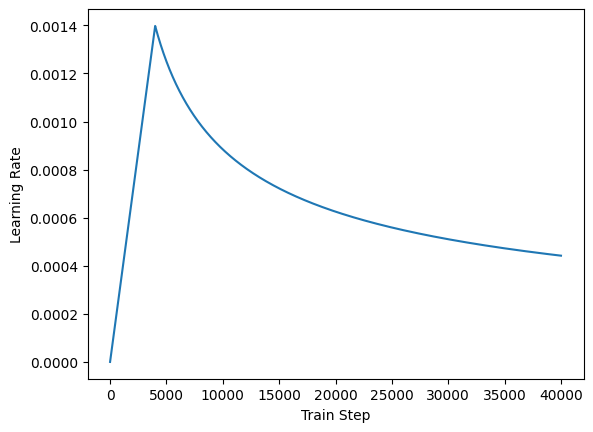

In [54]:
plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

### Set up the loss and metrics

Since the target sequences are padded, it is important to apply a padding mask when calculating the loss. Use the cross-entropy loss function (`tf.keras.losses.SparseCategoricalCrossentropy`):

In [55]:
def masked_loss(label, pred):
  mask = label != 0
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
  loss = loss_object(label, pred)

  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask

  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss


def masked_accuracy(label, pred):
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, pred.dtype)
  match = label == pred

  mask = label != 0

  match = match & mask

  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(match)/tf.reduce_sum(mask)

### Train the model

With all the components ready, configure the training procedure using `model.compile`, and then run it with `model.fit`:

Note: This takes about an hour to train in Colab.

In [56]:
transformer.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy])

In [57]:
transformer.fit(train_batches,
                epochs=20,
                validation_data=val_batches)

Epoch 1/20


I0000 00:00:1700138271.584619   39293 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



  1/810 [..............................] - ETA: 6:14:10 - loss: 8.8537 - masked_accuracy: 0.0000e+00


  2/810 [..............................] - ETA: 6:05 - loss: 8.8513 - masked_accuracy: 0.0000e+00   


  3/810 [..............................] - ETA: 5:09 - loss: 8.8488 - masked_accuracy: 0.0000e+00


  4/810 [..............................] - ETA: 5:01 - loss: 8.8484 - masked_accuracy: 0.0000e+00


  5/810 [..............................] - ETA: 4:58 - loss: 8.8497 - masked_accuracy: 1.2099e-04


  6/810 [..............................] - ETA: 4:43 - loss: 8.8492 - masked_accuracy: 1.0083e-04


  7/810 [..............................] - ETA: 4:44 - loss: 8.8490 - masked_accuracy: 8.6423e-05


  8/810 [..............................] - ETA: 4:36 - loss: 8.8494 - masked_accuracy: 1.7252e-04


  9/810 [..............................] - ETA: 4:33 - loss: 8.8484 - masked_accuracy: 1.5335e-04


 10/810 [..............................] - ETA: 4:29 - loss: 8.8485 - masked_accuracy: 1.3802e-04


 11/810 [..............................] - ETA: 4:29 - loss: 8.8478 - masked_accuracy: 1.2547e-04


 12/810 [..............................] - ETA: 4:32 - loss: 8.8469 - masked_accuracy: 1.6561e-04


 13/810 [..............................] - ETA: 4:27 - loss: 8.8461 - masked_accuracy: 1.5287e-04


 14/810 [..............................] - ETA: 4:18 - loss: 8.8452 - masked_accuracy: 1.4195e-04


 15/810 [..............................] - ETA: 4:20 - loss: 8.8448 - masked_accuracy: 1.3249e-04


 16/810 [..............................] - ETA: 4:19 - loss: 8.8437 - masked_accuracy: 1.2421e-04


 17/810 [..............................] - ETA: 4:20 - loss: 8.8425 - masked_accuracy: 1.1690e-04


 18/810 [..............................] - ETA: 4:18 - loss: 8.8412 - masked_accuracy: 1.1041e-04


 19/810 [..............................] - ETA: 4:17 - loss: 8.8403 - masked_accuracy: 1.0460e-04


 20/810 [..............................] - ETA: 4:15 - loss: 8.8387 - masked_accuracy: 9.9366e-05


 21/810 [..............................] - ETA: 4:15 - loss: 8.8372 - masked_accuracy: 1.2594e-04


 22/810 [..............................] - ETA: 4:14 - loss: 8.8360 - masked_accuracy: 1.5497e-04


 23/810 [..............................] - ETA: 4:13 - loss: 8.8344 - masked_accuracy: 1.4823e-04


 24/810 [..............................] - ETA: 4:11 - loss: 8.8331 - masked_accuracy: 1.7276e-04


 25/810 [..............................] - ETA: 4:07 - loss: 8.8314 - masked_accuracy: 1.6585e-04


 26/810 [..............................] - ETA: 4:07 - loss: 8.8299 - masked_accuracy: 1.8879e-04


 27/810 [>.............................] - ETA: 4:08 - loss: 8.8285 - masked_accuracy: 1.8179e-04


 28/810 [>.............................] - ETA: 4:04 - loss: 8.8267 - masked_accuracy: 1.7530e-04


 29/810 [>.............................] - ETA: 4:05 - loss: 8.8254 - masked_accuracy: 1.9305e-04


 30/810 [>.............................] - ETA: 4:04 - loss: 8.8235 - masked_accuracy: 2.6630e-04


 31/810 [>.............................] - ETA: 4:01 - loss: 8.8218 - masked_accuracy: 3.4489e-04


 32/810 [>.............................] - ETA: 4:02 - loss: 8.8202 - masked_accuracy: 4.6055e-04


 33/810 [>.............................] - ETA: 3:59 - loss: 8.8181 - masked_accuracy: 7.5605e-04


 34/810 [>.............................] - ETA: 3:58 - loss: 8.8161 - masked_accuracy: 9.6775e-04


 35/810 [>.............................] - ETA: 4:00 - loss: 8.8143 - masked_accuracy: 0.0011    


 36/810 [>.............................] - ETA: 3:58 - loss: 8.8124 - masked_accuracy: 0.0014


 37/810 [>.............................] - ETA: 3:58 - loss: 8.8106 - masked_accuracy: 0.0018


 38/810 [>.............................] - ETA: 3:57 - loss: 8.8088 - masked_accuracy: 0.0022


 39/810 [>.............................] - ETA: 3:54 - loss: 8.8066 - masked_accuracy: 0.0027


 40/810 [>.............................] - ETA: 3:52 - loss: 8.8046 - masked_accuracy: 0.0032


 41/810 [>.............................] - ETA: 3:51 - loss: 8.8024 - masked_accuracy: 0.0039


 42/810 [>.............................] - ETA: 3:51 - loss: 8.8003 - masked_accuracy: 0.0047


 43/810 [>.............................] - ETA: 3:50 - loss: 8.7982 - masked_accuracy: 0.0054


 44/810 [>.............................] - ETA: 3:51 - loss: 8.7961 - masked_accuracy: 0.0062


 45/810 [>.............................] - ETA: 3:50 - loss: 8.7937 - masked_accuracy: 0.0070


 46/810 [>.............................] - ETA: 3:50 - loss: 8.7915 - masked_accuracy: 0.0080


 47/810 [>.............................] - ETA: 3:49 - loss: 8.7896 - masked_accuracy: 0.0087


 48/810 [>.............................] - ETA: 3:48 - loss: 8.7874 - masked_accuracy: 0.0096


 49/810 [>.............................] - ETA: 3:49 - loss: 8.7856 - masked_accuracy: 0.0102


 50/810 [>.............................] - ETA: 3:48 - loss: 8.7834 - masked_accuracy: 0.0111


 51/810 [>.............................] - ETA: 3:47 - loss: 8.7814 - masked_accuracy: 0.0118


 52/810 [>.............................] - ETA: 3:46 - loss: 8.7792 - masked_accuracy: 0.0126


 53/810 [>.............................] - ETA: 3:46 - loss: 8.7769 - masked_accuracy: 0.0133


 54/810 [=>............................] - ETA: 3:45 - loss: 8.7746 - masked_accuracy: 0.0141


 55/810 [=>............................] - ETA: 3:45 - loss: 8.7727 - masked_accuracy: 0.0147


 56/810 [=>............................] - ETA: 3:43 - loss: 8.7704 - masked_accuracy: 0.0153


 57/810 [=>............................] - ETA: 3:42 - loss: 8.7681 - masked_accuracy: 0.0159


 58/810 [=>............................] - ETA: 3:42 - loss: 8.7659 - masked_accuracy: 0.0165


 59/810 [=>............................] - ETA: 3:42 - loss: 8.7637 - masked_accuracy: 0.0172


 60/810 [=>............................] - ETA: 3:41 - loss: 8.7618 - masked_accuracy: 0.0176


 61/810 [=>............................] - ETA: 3:40 - loss: 8.7596 - masked_accuracy: 0.0182


 62/810 [=>............................] - ETA: 3:40 - loss: 8.7574 - masked_accuracy: 0.0187


 63/810 [=>............................] - ETA: 3:40 - loss: 8.7554 - masked_accuracy: 0.0192


 64/810 [=>............................] - ETA: 3:41 - loss: 8.7531 - masked_accuracy: 0.0198


 65/810 [=>............................] - ETA: 3:41 - loss: 8.7510 - masked_accuracy: 0.0203


 66/810 [=>............................] - ETA: 3:41 - loss: 8.7488 - masked_accuracy: 0.0207


 67/810 [=>............................] - ETA: 3:39 - loss: 8.7470 - masked_accuracy: 0.0212


 68/810 [=>............................] - ETA: 3:39 - loss: 8.7446 - masked_accuracy: 0.0217


 69/810 [=>............................] - ETA: 3:39 - loss: 8.7425 - masked_accuracy: 0.0221


 70/810 [=>............................] - ETA: 3:37 - loss: 8.7405 - masked_accuracy: 0.0224


 71/810 [=>............................] - ETA: 3:36 - loss: 8.7384 - masked_accuracy: 0.0229


 72/810 [=>............................] - ETA: 3:36 - loss: 8.7363 - masked_accuracy: 0.0232


 73/810 [=>............................] - ETA: 3:35 - loss: 8.7343 - masked_accuracy: 0.0236


 74/810 [=>............................] - ETA: 3:36 - loss: 8.7322 - masked_accuracy: 0.0241


 75/810 [=>............................] - ETA: 3:37 - loss: 8.7299 - masked_accuracy: 0.0244


 76/810 [=>............................] - ETA: 3:35 - loss: 8.7278 - masked_accuracy: 0.0249


 77/810 [=>............................] - ETA: 3:35 - loss: 8.7258 - masked_accuracy: 0.0252


 78/810 [=>............................] - ETA: 3:34 - loss: 8.7236 - masked_accuracy: 0.0254


 79/810 [=>............................] - ETA: 3:34 - loss: 8.7214 - masked_accuracy: 0.0258


 80/810 [=>............................] - ETA: 3:33 - loss: 8.7192 - masked_accuracy: 0.0261


 81/810 [==>...........................] - ETA: 3:33 - loss: 8.7173 - masked_accuracy: 0.0264


 82/810 [==>...........................] - ETA: 3:32 - loss: 8.7152 - masked_accuracy: 0.0267


 83/810 [==>...........................] - ETA: 3:32 - loss: 8.7131 - masked_accuracy: 0.0270


 84/810 [==>...........................] - ETA: 3:31 - loss: 8.7108 - masked_accuracy: 0.0273


 85/810 [==>...........................] - ETA: 3:31 - loss: 8.7086 - masked_accuracy: 0.0276


 86/810 [==>...........................] - ETA: 3:30 - loss: 8.7064 - masked_accuracy: 0.0279


 87/810 [==>...........................] - ETA: 3:29 - loss: 8.7044 - masked_accuracy: 0.0282


 88/810 [==>...........................] - ETA: 3:29 - loss: 8.7020 - masked_accuracy: 0.0285


 89/810 [==>...........................] - ETA: 3:28 - loss: 8.7001 - masked_accuracy: 0.0287


 90/810 [==>...........................] - ETA: 3:27 - loss: 8.6980 - masked_accuracy: 0.0291


 91/810 [==>...........................] - ETA: 3:27 - loss: 8.6961 - masked_accuracy: 0.0293


 92/810 [==>...........................] - ETA: 3:26 - loss: 8.6939 - masked_accuracy: 0.0297


 93/810 [==>...........................] - ETA: 3:25 - loss: 8.6917 - masked_accuracy: 0.0299


 94/810 [==>...........................] - ETA: 3:25 - loss: 8.6896 - masked_accuracy: 0.0303


 95/810 [==>...........................] - ETA: 3:25 - loss: 8.6877 - masked_accuracy: 0.0305


 96/810 [==>...........................] - ETA: 3:24 - loss: 8.6856 - masked_accuracy: 0.0308


 97/810 [==>...........................] - ETA: 3:24 - loss: 8.6836 - masked_accuracy: 0.0311


 98/810 [==>...........................] - ETA: 3:24 - loss: 8.6816 - masked_accuracy: 0.0314


 99/810 [==>...........................] - ETA: 3:23 - loss: 8.6794 - masked_accuracy: 0.0317


100/810 [==>...........................] - ETA: 3:22 - loss: 8.6773 - masked_accuracy: 0.0320


101/810 [==>...........................] - ETA: 3:21 - loss: 8.6751 - masked_accuracy: 0.0323


102/810 [==>...........................] - ETA: 3:21 - loss: 8.6729 - masked_accuracy: 0.0326


103/810 [==>...........................] - ETA: 3:20 - loss: 8.6709 - masked_accuracy: 0.0328


104/810 [==>...........................] - ETA: 3:20 - loss: 8.6689 - masked_accuracy: 0.0331


105/810 [==>...........................] - ETA: 3:19 - loss: 8.6667 - masked_accuracy: 0.0334


106/810 [==>...........................] - ETA: 3:19 - loss: 8.6644 - masked_accuracy: 0.0336


107/810 [==>...........................] - ETA: 3:18 - loss: 8.6620 - masked_accuracy: 0.0339


108/810 [===>..........................] - ETA: 3:18 - loss: 8.6596 - masked_accuracy: 0.0342


109/810 [===>..........................] - ETA: 3:18 - loss: 8.6575 - masked_accuracy: 0.0345


110/810 [===>..........................] - ETA: 3:18 - loss: 8.6552 - masked_accuracy: 0.0347


111/810 [===>..........................] - ETA: 3:17 - loss: 8.6529 - masked_accuracy: 0.0350


112/810 [===>..........................] - ETA: 3:17 - loss: 8.6508 - masked_accuracy: 0.0352


113/810 [===>..........................] - ETA: 3:16 - loss: 8.6486 - masked_accuracy: 0.0354


114/810 [===>..........................] - ETA: 3:16 - loss: 8.6463 - masked_accuracy: 0.0357


115/810 [===>..........................] - ETA: 3:16 - loss: 8.6441 - masked_accuracy: 0.0358


116/810 [===>..........................] - ETA: 3:15 - loss: 8.6416 - masked_accuracy: 0.0361


117/810 [===>..........................] - ETA: 3:15 - loss: 8.6395 - masked_accuracy: 0.0363


118/810 [===>..........................] - ETA: 3:14 - loss: 8.6371 - masked_accuracy: 0.0366


119/810 [===>..........................] - ETA: 3:13 - loss: 8.6348 - masked_accuracy: 0.0368


120/810 [===>..........................] - ETA: 3:13 - loss: 8.6324 - masked_accuracy: 0.0370


121/810 [===>..........................] - ETA: 3:12 - loss: 8.6300 - masked_accuracy: 0.0372


122/810 [===>..........................] - ETA: 3:11 - loss: 8.6275 - masked_accuracy: 0.0375


123/810 [===>..........................] - ETA: 3:11 - loss: 8.6252 - masked_accuracy: 0.0377


124/810 [===>..........................] - ETA: 3:11 - loss: 8.6230 - masked_accuracy: 0.0379


125/810 [===>..........................] - ETA: 3:11 - loss: 8.6209 - masked_accuracy: 0.0382


126/810 [===>..........................] - ETA: 3:11 - loss: 8.6185 - masked_accuracy: 0.0385


127/810 [===>..........................] - ETA: 3:11 - loss: 8.6161 - masked_accuracy: 0.0387


128/810 [===>..........................] - ETA: 3:11 - loss: 8.6136 - masked_accuracy: 0.0389


129/810 [===>..........................] - ETA: 3:10 - loss: 8.6112 - masked_accuracy: 0.0391


130/810 [===>..........................] - ETA: 3:10 - loss: 8.6088 - masked_accuracy: 0.0393


131/810 [===>..........................] - ETA: 3:10 - loss: 8.6066 - masked_accuracy: 0.0394


132/810 [===>..........................] - ETA: 3:10 - loss: 8.6043 - masked_accuracy: 0.0396


133/810 [===>..........................] - ETA: 3:10 - loss: 8.6018 - masked_accuracy: 0.0399


134/810 [===>..........................] - ETA: 3:09 - loss: 8.5995 - masked_accuracy: 0.0400


135/810 [====>.........................] - ETA: 3:09 - loss: 8.5971 - masked_accuracy: 0.0402


136/810 [====>.........................] - ETA: 3:09 - loss: 8.5946 - masked_accuracy: 0.0404


137/810 [====>.........................] - ETA: 3:08 - loss: 8.5921 - masked_accuracy: 0.0406


138/810 [====>.........................] - ETA: 3:07 - loss: 8.5895 - masked_accuracy: 0.0408


139/810 [====>.........................] - ETA: 3:07 - loss: 8.5868 - masked_accuracy: 0.0410


140/810 [====>.........................] - ETA: 3:07 - loss: 8.5842 - masked_accuracy: 0.0412


141/810 [====>.........................] - ETA: 3:07 - loss: 8.5817 - masked_accuracy: 0.0414


142/810 [====>.........................] - ETA: 3:06 - loss: 8.5792 - masked_accuracy: 0.0416


143/810 [====>.........................] - ETA: 3:06 - loss: 8.5765 - masked_accuracy: 0.0419


144/810 [====>.........................] - ETA: 3:06 - loss: 8.5739 - masked_accuracy: 0.0421


145/810 [====>.........................] - ETA: 3:06 - loss: 8.5715 - masked_accuracy: 0.0422


146/810 [====>.........................] - ETA: 3:06 - loss: 8.5691 - masked_accuracy: 0.0424


147/810 [====>.........................] - ETA: 3:06 - loss: 8.5662 - masked_accuracy: 0.0428


148/810 [====>.........................] - ETA: 3:05 - loss: 8.5637 - masked_accuracy: 0.0430


149/810 [====>.........................] - ETA: 3:04 - loss: 8.5610 - masked_accuracy: 0.0433


150/810 [====>.........................] - ETA: 3:04 - loss: 8.5582 - masked_accuracy: 0.0435


151/810 [====>.........................] - ETA: 3:03 - loss: 8.5555 - masked_accuracy: 0.0437


152/810 [====>.........................] - ETA: 3:03 - loss: 8.5528 - masked_accuracy: 0.0440


153/810 [====>.........................] - ETA: 3:03 - loss: 8.5503 - masked_accuracy: 0.0442


154/810 [====>.........................] - ETA: 3:02 - loss: 8.5478 - masked_accuracy: 0.0444


155/810 [====>.........................] - ETA: 3:02 - loss: 8.5451 - masked_accuracy: 0.0446


156/810 [====>.........................] - ETA: 3:01 - loss: 8.5424 - masked_accuracy: 0.0448


157/810 [====>.........................] - ETA: 3:01 - loss: 8.5398 - masked_accuracy: 0.0450


158/810 [====>.........................] - ETA: 3:01 - loss: 8.5371 - masked_accuracy: 0.0453


159/810 [====>.........................] - ETA: 3:00 - loss: 8.5341 - masked_accuracy: 0.0455


160/810 [====>.........................] - ETA: 3:00 - loss: 8.5313 - masked_accuracy: 0.0458


161/810 [====>.........................] - ETA: 2:59 - loss: 8.5284 - masked_accuracy: 0.0460


162/810 [=====>........................] - ETA: 2:59 - loss: 8.5257 - masked_accuracy: 0.0463


163/810 [=====>........................] - ETA: 2:58 - loss: 8.5229 - masked_accuracy: 0.0465


164/810 [=====>........................] - ETA: 2:58 - loss: 8.5199 - masked_accuracy: 0.0468


165/810 [=====>........................] - ETA: 2:57 - loss: 8.5171 - masked_accuracy: 0.0470


166/810 [=====>........................] - ETA: 2:58 - loss: 8.5144 - masked_accuracy: 0.0472


167/810 [=====>........................] - ETA: 2:58 - loss: 8.5116 - masked_accuracy: 0.0475


168/810 [=====>........................] - ETA: 2:57 - loss: 8.5086 - masked_accuracy: 0.0477


169/810 [=====>........................] - ETA: 2:57 - loss: 8.5058 - masked_accuracy: 0.0479


170/810 [=====>........................] - ETA: 2:57 - loss: 8.5027 - masked_accuracy: 0.0482


171/810 [=====>........................] - ETA: 2:56 - loss: 8.4995 - masked_accuracy: 0.0486


172/810 [=====>........................] - ETA: 2:56 - loss: 8.4967 - masked_accuracy: 0.0489


173/810 [=====>........................] - ETA: 2:55 - loss: 8.4937 - masked_accuracy: 0.0492


174/810 [=====>........................] - ETA: 2:55 - loss: 8.4905 - masked_accuracy: 0.0496


175/810 [=====>........................] - ETA: 2:55 - loss: 8.4876 - masked_accuracy: 0.0498


176/810 [=====>........................] - ETA: 2:54 - loss: 8.4847 - masked_accuracy: 0.0502


177/810 [=====>........................] - ETA: 2:54 - loss: 8.4816 - masked_accuracy: 0.0505


178/810 [=====>........................] - ETA: 2:54 - loss: 8.4788 - masked_accuracy: 0.0508


179/810 [=====>........................] - ETA: 2:54 - loss: 8.4757 - masked_accuracy: 0.0511


180/810 [=====>........................] - ETA: 2:54 - loss: 8.4727 - masked_accuracy: 0.0514


181/810 [=====>........................] - ETA: 2:53 - loss: 8.4698 - masked_accuracy: 0.0517


182/810 [=====>........................] - ETA: 2:53 - loss: 8.4666 - masked_accuracy: 0.0520


183/810 [=====>........................] - ETA: 2:52 - loss: 8.4635 - masked_accuracy: 0.0524


184/810 [=====>........................] - ETA: 2:52 - loss: 8.4602 - masked_accuracy: 0.0527


185/810 [=====>........................] - ETA: 2:51 - loss: 8.4570 - masked_accuracy: 0.0529


186/810 [=====>........................] - ETA: 2:51 - loss: 8.4538 - masked_accuracy: 0.0533


187/810 [=====>........................] - ETA: 2:50 - loss: 8.4505 - masked_accuracy: 0.0536


188/810 [=====>........................] - ETA: 2:50 - loss: 8.4475 - masked_accuracy: 0.0539


189/810 [======>.......................] - ETA: 2:50 - loss: 8.4443 - masked_accuracy: 0.0541


190/810 [======>.......................] - ETA: 2:50 - loss: 8.4413 - masked_accuracy: 0.0544


191/810 [======>.......................] - ETA: 2:49 - loss: 8.4381 - masked_accuracy: 0.0547


192/810 [======>.......................] - ETA: 2:49 - loss: 8.4350 - masked_accuracy: 0.0549


193/810 [======>.......................] - ETA: 2:49 - loss: 8.4318 - masked_accuracy: 0.0552


194/810 [======>.......................] - ETA: 2:48 - loss: 8.4285 - masked_accuracy: 0.0555


195/810 [======>.......................] - ETA: 2:48 - loss: 8.4251 - masked_accuracy: 0.0558


196/810 [======>.......................] - ETA: 2:48 - loss: 8.4219 - masked_accuracy: 0.0560


197/810 [======>.......................] - ETA: 2:47 - loss: 8.4188 - masked_accuracy: 0.0563


198/810 [======>.......................] - ETA: 2:47 - loss: 8.4155 - masked_accuracy: 0.0565


199/810 [======>.......................] - ETA: 2:46 - loss: 8.4121 - masked_accuracy: 0.0568


200/810 [======>.......................] - ETA: 2:46 - loss: 8.4087 - masked_accuracy: 0.0571


201/810 [======>.......................] - ETA: 2:46 - loss: 8.4053 - masked_accuracy: 0.0573


202/810 [======>.......................] - ETA: 2:45 - loss: 8.4021 - masked_accuracy: 0.0576


203/810 [======>.......................] - ETA: 2:45 - loss: 8.3987 - masked_accuracy: 0.0579


204/810 [======>.......................] - ETA: 2:44 - loss: 8.3953 - masked_accuracy: 0.0581


205/810 [======>.......................] - ETA: 2:44 - loss: 8.3919 - masked_accuracy: 0.0584


206/810 [======>.......................] - ETA: 2:43 - loss: 8.3885 - masked_accuracy: 0.0587


207/810 [======>.......................] - ETA: 2:43 - loss: 8.3851 - masked_accuracy: 0.0590


208/810 [======>.......................] - ETA: 2:43 - loss: 8.3817 - masked_accuracy: 0.0592


209/810 [======>.......................] - ETA: 2:42 - loss: 8.3783 - masked_accuracy: 0.0595


210/810 [======>.......................] - ETA: 2:42 - loss: 8.3748 - masked_accuracy: 0.0597


211/810 [======>.......................] - ETA: 2:42 - loss: 8.3713 - masked_accuracy: 0.0599


212/810 [======>.......................] - ETA: 2:41 - loss: 8.3680 - masked_accuracy: 0.0602


213/810 [======>.......................] - ETA: 2:41 - loss: 8.3645 - masked_accuracy: 0.0605


214/810 [======>.......................] - ETA: 2:41 - loss: 8.3611 - masked_accuracy: 0.0607


215/810 [======>.......................] - ETA: 2:40 - loss: 8.3577 - masked_accuracy: 0.0610


216/810 [=======>......................] - ETA: 2:40 - loss: 8.3544 - masked_accuracy: 0.0612


217/810 [=======>......................] - ETA: 2:39 - loss: 8.3509 - masked_accuracy: 0.0614


218/810 [=======>......................] - ETA: 2:39 - loss: 8.3474 - masked_accuracy: 0.0616


219/810 [=======>......................] - ETA: 2:39 - loss: 8.3437 - masked_accuracy: 0.0619


220/810 [=======>......................] - ETA: 2:38 - loss: 8.3403 - masked_accuracy: 0.0621


221/810 [=======>......................] - ETA: 2:38 - loss: 8.3369 - masked_accuracy: 0.0623


222/810 [=======>......................] - ETA: 2:38 - loss: 8.3332 - masked_accuracy: 0.0626


223/810 [=======>......................] - ETA: 2:37 - loss: 8.3299 - masked_accuracy: 0.0628


224/810 [=======>......................] - ETA: 2:37 - loss: 8.3262 - masked_accuracy: 0.0630


225/810 [=======>......................] - ETA: 2:37 - loss: 8.3226 - masked_accuracy: 0.0632


226/810 [=======>......................] - ETA: 2:36 - loss: 8.3189 - masked_accuracy: 0.0634


227/810 [=======>......................] - ETA: 2:36 - loss: 8.3152 - masked_accuracy: 0.0637


228/810 [=======>......................] - ETA: 2:35 - loss: 8.3114 - masked_accuracy: 0.0640


229/810 [=======>......................] - ETA: 2:35 - loss: 8.3075 - masked_accuracy: 0.0642


230/810 [=======>......................] - ETA: 2:35 - loss: 8.3041 - masked_accuracy: 0.0644


231/810 [=======>......................] - ETA: 2:34 - loss: 8.3005 - masked_accuracy: 0.0647


232/810 [=======>......................] - ETA: 2:34 - loss: 8.2968 - masked_accuracy: 0.0649


233/810 [=======>......................] - ETA: 2:33 - loss: 8.2934 - masked_accuracy: 0.0651


234/810 [=======>......................] - ETA: 2:33 - loss: 8.2896 - masked_accuracy: 0.0653


235/810 [=======>......................] - ETA: 2:32 - loss: 8.2859 - masked_accuracy: 0.0655


236/810 [=======>......................] - ETA: 2:32 - loss: 8.2826 - masked_accuracy: 0.0657


237/810 [=======>......................] - ETA: 2:32 - loss: 8.2788 - masked_accuracy: 0.0659


238/810 [=======>......................] - ETA: 2:32 - loss: 8.2751 - masked_accuracy: 0.0661


239/810 [=======>......................] - ETA: 2:31 - loss: 8.2716 - masked_accuracy: 0.0663


240/810 [=======>......................] - ETA: 2:31 - loss: 8.2679 - masked_accuracy: 0.0665


241/810 [=======>......................] - ETA: 2:31 - loss: 8.2643 - masked_accuracy: 0.0667


242/810 [=======>......................] - ETA: 2:30 - loss: 8.2605 - masked_accuracy: 0.0669


243/810 [========>.....................] - ETA: 2:30 - loss: 8.2569 - masked_accuracy: 0.0670


244/810 [========>.....................] - ETA: 2:30 - loss: 8.2532 - masked_accuracy: 0.0672


245/810 [========>.....................] - ETA: 2:30 - loss: 8.2497 - masked_accuracy: 0.0673


246/810 [========>.....................] - ETA: 2:30 - loss: 8.2463 - masked_accuracy: 0.0675


247/810 [========>.....................] - ETA: 2:29 - loss: 8.2427 - masked_accuracy: 0.0677


248/810 [========>.....................] - ETA: 2:29 - loss: 8.2390 - masked_accuracy: 0.0678


249/810 [========>.....................] - ETA: 2:28 - loss: 8.2352 - masked_accuracy: 0.0680


250/810 [========>.....................] - ETA: 2:28 - loss: 8.2316 - masked_accuracy: 0.0682


251/810 [========>.....................] - ETA: 2:28 - loss: 8.2276 - masked_accuracy: 0.0684


252/810 [========>.....................] - ETA: 2:27 - loss: 8.2237 - masked_accuracy: 0.0687


253/810 [========>.....................] - ETA: 2:27 - loss: 8.2199 - masked_accuracy: 0.0688


254/810 [========>.....................] - ETA: 2:27 - loss: 8.2160 - masked_accuracy: 0.0690


255/810 [========>.....................] - ETA: 2:26 - loss: 8.2122 - masked_accuracy: 0.0692


256/810 [========>.....................] - ETA: 2:26 - loss: 8.2083 - masked_accuracy: 0.0694


257/810 [========>.....................] - ETA: 2:26 - loss: 8.2044 - masked_accuracy: 0.0697


258/810 [========>.....................] - ETA: 2:26 - loss: 8.2008 - masked_accuracy: 0.0698


259/810 [========>.....................] - ETA: 2:25 - loss: 8.1970 - masked_accuracy: 0.0700


260/810 [========>.....................] - ETA: 2:25 - loss: 8.1930 - masked_accuracy: 0.0702


261/810 [========>.....................] - ETA: 2:25 - loss: 8.1891 - masked_accuracy: 0.0703


262/810 [========>.....................] - ETA: 2:25 - loss: 8.1850 - masked_accuracy: 0.0705


263/810 [========>.....................] - ETA: 2:24 - loss: 8.1813 - masked_accuracy: 0.0706


264/810 [========>.....................] - ETA: 2:24 - loss: 8.1772 - masked_accuracy: 0.0708


265/810 [========>.....................] - ETA: 2:24 - loss: 8.1734 - masked_accuracy: 0.0710


266/810 [========>.....................] - ETA: 2:24 - loss: 8.1695 - masked_accuracy: 0.0711


267/810 [========>.....................] - ETA: 2:23 - loss: 8.1655 - masked_accuracy: 0.0713


268/810 [========>.....................] - ETA: 2:23 - loss: 8.1616 - masked_accuracy: 0.0715


269/810 [========>.....................] - ETA: 2:22 - loss: 8.1579 - masked_accuracy: 0.0716


270/810 [=========>....................] - ETA: 2:22 - loss: 8.1540 - masked_accuracy: 0.0718


271/810 [=========>....................] - ETA: 2:22 - loss: 8.1500 - masked_accuracy: 0.0720


272/810 [=========>....................] - ETA: 2:22 - loss: 8.1461 - masked_accuracy: 0.0721


273/810 [=========>....................] - ETA: 2:21 - loss: 8.1423 - masked_accuracy: 0.0723


274/810 [=========>....................] - ETA: 2:21 - loss: 8.1383 - masked_accuracy: 0.0725


275/810 [=========>....................] - ETA: 2:20 - loss: 8.1346 - masked_accuracy: 0.0727


276/810 [=========>....................] - ETA: 2:20 - loss: 8.1307 - masked_accuracy: 0.0728


277/810 [=========>....................] - ETA: 2:20 - loss: 8.1271 - masked_accuracy: 0.0730


278/810 [=========>....................] - ETA: 2:20 - loss: 8.1230 - masked_accuracy: 0.0731


279/810 [=========>....................] - ETA: 2:19 - loss: 8.1189 - masked_accuracy: 0.0733


280/810 [=========>....................] - ETA: 2:19 - loss: 8.1148 - masked_accuracy: 0.0735


281/810 [=========>....................] - ETA: 2:19 - loss: 8.1109 - masked_accuracy: 0.0737


282/810 [=========>....................] - ETA: 2:18 - loss: 8.1070 - masked_accuracy: 0.0739


283/810 [=========>....................] - ETA: 2:18 - loss: 8.1027 - masked_accuracy: 0.0740


284/810 [=========>....................] - ETA: 2:18 - loss: 8.0988 - masked_accuracy: 0.0741


285/810 [=========>....................] - ETA: 2:17 - loss: 8.0949 - masked_accuracy: 0.0743


286/810 [=========>....................] - ETA: 2:17 - loss: 8.0908 - masked_accuracy: 0.0745


287/810 [=========>....................] - ETA: 2:17 - loss: 8.0870 - masked_accuracy: 0.0746


288/810 [=========>....................] - ETA: 2:17 - loss: 8.0830 - masked_accuracy: 0.0748


289/810 [=========>....................] - ETA: 2:16 - loss: 8.0791 - masked_accuracy: 0.0749


290/810 [=========>....................] - ETA: 2:16 - loss: 8.0750 - masked_accuracy: 0.0751


291/810 [=========>....................] - ETA: 2:15 - loss: 8.0712 - masked_accuracy: 0.0752


292/810 [=========>....................] - ETA: 2:15 - loss: 8.0673 - masked_accuracy: 0.0754


293/810 [=========>....................] - ETA: 2:15 - loss: 8.0633 - masked_accuracy: 0.0756


294/810 [=========>....................] - ETA: 2:14 - loss: 8.0595 - masked_accuracy: 0.0757


295/810 [=========>....................] - ETA: 2:14 - loss: 8.0551 - masked_accuracy: 0.0758


296/810 [=========>....................] - ETA: 2:14 - loss: 8.0512 - masked_accuracy: 0.0760


297/810 [==========>...................] - ETA: 2:14 - loss: 8.0474 - masked_accuracy: 0.0761


298/810 [==========>...................] - ETA: 2:13 - loss: 8.0432 - masked_accuracy: 0.0763


299/810 [==========>...................] - ETA: 2:13 - loss: 8.0390 - masked_accuracy: 0.0764


300/810 [==========>...................] - ETA: 2:12 - loss: 8.0348 - masked_accuracy: 0.0767


301/810 [==========>...................] - ETA: 2:12 - loss: 8.0307 - masked_accuracy: 0.0769


302/810 [==========>...................] - ETA: 2:12 - loss: 8.0270 - masked_accuracy: 0.0770


303/810 [==========>...................] - ETA: 2:12 - loss: 8.0228 - masked_accuracy: 0.0772


304/810 [==========>...................] - ETA: 2:12 - loss: 8.0187 - masked_accuracy: 0.0773


305/810 [==========>...................] - ETA: 2:11 - loss: 8.0148 - masked_accuracy: 0.0774


306/810 [==========>...................] - ETA: 2:11 - loss: 8.0108 - masked_accuracy: 0.0776


307/810 [==========>...................] - ETA: 2:11 - loss: 8.0069 - masked_accuracy: 0.0777


308/810 [==========>...................] - ETA: 2:10 - loss: 8.0030 - masked_accuracy: 0.0779


309/810 [==========>...................] - ETA: 2:10 - loss: 7.9992 - masked_accuracy: 0.0780


310/810 [==========>...................] - ETA: 2:10 - loss: 7.9953 - masked_accuracy: 0.0781


311/810 [==========>...................] - ETA: 2:10 - loss: 7.9914 - masked_accuracy: 0.0782


312/810 [==========>...................] - ETA: 2:10 - loss: 7.9874 - masked_accuracy: 0.0784


313/810 [==========>...................] - ETA: 2:09 - loss: 7.9835 - masked_accuracy: 0.0786


314/810 [==========>...................] - ETA: 2:09 - loss: 7.9796 - masked_accuracy: 0.0787


315/810 [==========>...................] - ETA: 2:09 - loss: 7.9755 - masked_accuracy: 0.0788


316/810 [==========>...................] - ETA: 2:08 - loss: 7.9718 - masked_accuracy: 0.0790


317/810 [==========>...................] - ETA: 2:08 - loss: 7.9679 - masked_accuracy: 0.0791


318/810 [==========>...................] - ETA: 2:08 - loss: 7.9639 - masked_accuracy: 0.0792


319/810 [==========>...................] - ETA: 2:08 - loss: 7.9602 - masked_accuracy: 0.0794


320/810 [==========>...................] - ETA: 2:07 - loss: 7.9562 - masked_accuracy: 0.0795


321/810 [==========>...................] - ETA: 2:07 - loss: 7.9522 - masked_accuracy: 0.0796


322/810 [==========>...................] - ETA: 2:07 - loss: 7.9482 - masked_accuracy: 0.0797


323/810 [==========>...................] - ETA: 2:06 - loss: 7.9444 - masked_accuracy: 0.0799


324/810 [===========>..................] - ETA: 2:06 - loss: 7.9406 - masked_accuracy: 0.0800


325/810 [===========>..................] - ETA: 2:06 - loss: 7.9367 - masked_accuracy: 0.0801


326/810 [===========>..................] - ETA: 2:06 - loss: 7.9328 - masked_accuracy: 0.0803


327/810 [===========>..................] - ETA: 2:05 - loss: 7.9285 - masked_accuracy: 0.0804


328/810 [===========>..................] - ETA: 2:05 - loss: 7.9245 - masked_accuracy: 0.0805


329/810 [===========>..................] - ETA: 2:05 - loss: 7.9207 - masked_accuracy: 0.0807


330/810 [===========>..................] - ETA: 2:04 - loss: 7.9167 - masked_accuracy: 0.0808


331/810 [===========>..................] - ETA: 2:04 - loss: 7.9124 - masked_accuracy: 0.0810


332/810 [===========>..................] - ETA: 2:04 - loss: 7.9087 - masked_accuracy: 0.0810


333/810 [===========>..................] - ETA: 2:04 - loss: 7.9047 - masked_accuracy: 0.0812


334/810 [===========>..................] - ETA: 2:04 - loss: 7.9005 - masked_accuracy: 0.0813


335/810 [===========>..................] - ETA: 2:03 - loss: 7.8964 - masked_accuracy: 0.0815


336/810 [===========>..................] - ETA: 2:03 - loss: 7.8925 - masked_accuracy: 0.0816


337/810 [===========>..................] - ETA: 2:03 - loss: 7.8883 - masked_accuracy: 0.0818


338/810 [===========>..................] - ETA: 2:03 - loss: 7.8847 - masked_accuracy: 0.0819


339/810 [===========>..................] - ETA: 2:02 - loss: 7.8806 - masked_accuracy: 0.0820


340/810 [===========>..................] - ETA: 2:02 - loss: 7.8767 - masked_accuracy: 0.0822


341/810 [===========>..................] - ETA: 2:01 - loss: 7.8730 - masked_accuracy: 0.0823


342/810 [===========>..................] - ETA: 2:01 - loss: 7.8689 - masked_accuracy: 0.0825


343/810 [===========>..................] - ETA: 2:01 - loss: 7.8653 - masked_accuracy: 0.0826


344/810 [===========>..................] - ETA: 2:01 - loss: 7.8613 - masked_accuracy: 0.0827


345/810 [===========>..................] - ETA: 2:00 - loss: 7.8573 - masked_accuracy: 0.0828


346/810 [===========>..................] - ETA: 2:00 - loss: 7.8532 - masked_accuracy: 0.0830


347/810 [===========>..................] - ETA: 2:00 - loss: 7.8492 - masked_accuracy: 0.0832


348/810 [===========>..................] - ETA: 1:59 - loss: 7.8454 - masked_accuracy: 0.0833


349/810 [===========>..................] - ETA: 1:59 - loss: 7.8416 - masked_accuracy: 0.0834


350/810 [===========>..................] - ETA: 1:59 - loss: 7.8376 - masked_accuracy: 0.0835


351/810 [============>.................] - ETA: 1:59 - loss: 7.8338 - masked_accuracy: 0.0836


352/810 [============>.................] - ETA: 1:58 - loss: 7.8301 - masked_accuracy: 0.0837


353/810 [============>.................] - ETA: 1:58 - loss: 7.8261 - masked_accuracy: 0.0839


354/810 [============>.................] - ETA: 1:58 - loss: 7.8220 - masked_accuracy: 0.0840


355/810 [============>.................] - ETA: 1:57 - loss: 7.8182 - masked_accuracy: 0.0842


356/810 [============>.................] - ETA: 1:57 - loss: 7.8143 - masked_accuracy: 0.0843


357/810 [============>.................] - ETA: 1:57 - loss: 7.8108 - masked_accuracy: 0.0843


358/810 [============>.................] - ETA: 1:57 - loss: 7.8067 - masked_accuracy: 0.0845


359/810 [============>.................] - ETA: 1:57 - loss: 7.8027 - masked_accuracy: 0.0846


360/810 [============>.................] - ETA: 1:56 - loss: 7.7992 - masked_accuracy: 0.0847


361/810 [============>.................] - ETA: 1:56 - loss: 7.7950 - masked_accuracy: 0.0848


362/810 [============>.................] - ETA: 1:56 - loss: 7.7913 - masked_accuracy: 0.0849


363/810 [============>.................] - ETA: 1:55 - loss: 7.7873 - masked_accuracy: 0.0851


364/810 [============>.................] - ETA: 1:55 - loss: 7.7835 - masked_accuracy: 0.0852


365/810 [============>.................] - ETA: 1:55 - loss: 7.7795 - masked_accuracy: 0.0854


366/810 [============>.................] - ETA: 1:55 - loss: 7.7758 - masked_accuracy: 0.0855


367/810 [============>.................] - ETA: 1:54 - loss: 7.7721 - masked_accuracy: 0.0856


368/810 [============>.................] - ETA: 1:54 - loss: 7.7678 - masked_accuracy: 0.0857


369/810 [============>.................] - ETA: 1:54 - loss: 7.7640 - masked_accuracy: 0.0858


370/810 [============>.................] - ETA: 1:54 - loss: 7.7602 - masked_accuracy: 0.0859


371/810 [============>.................] - ETA: 1:54 - loss: 7.7561 - masked_accuracy: 0.0861


372/810 [============>.................] - ETA: 1:53 - loss: 7.7522 - masked_accuracy: 0.0862


373/810 [============>.................] - ETA: 1:53 - loss: 7.7484 - masked_accuracy: 0.0863


374/810 [============>.................] - ETA: 1:53 - loss: 7.7447 - masked_accuracy: 0.0864


375/810 [============>.................] - ETA: 1:52 - loss: 7.7409 - masked_accuracy: 0.0866


376/810 [============>.................] - ETA: 1:52 - loss: 7.7371 - masked_accuracy: 0.0867


377/810 [============>.................] - ETA: 1:52 - loss: 7.7334 - masked_accuracy: 0.0868


378/810 [=============>................] - ETA: 1:52 - loss: 7.7296 - masked_accuracy: 0.0869


379/810 [=============>................] - ETA: 1:51 - loss: 7.7258 - masked_accuracy: 0.0870


380/810 [=============>................] - ETA: 1:51 - loss: 7.7217 - masked_accuracy: 0.0871


381/810 [=============>................] - ETA: 1:51 - loss: 7.7176 - masked_accuracy: 0.0873


382/810 [=============>................] - ETA: 1:51 - loss: 7.7137 - masked_accuracy: 0.0875


383/810 [=============>................] - ETA: 1:50 - loss: 7.7100 - masked_accuracy: 0.0876


384/810 [=============>................] - ETA: 1:50 - loss: 7.7062 - masked_accuracy: 0.0877


385/810 [=============>................] - ETA: 1:50 - loss: 7.7026 - masked_accuracy: 0.0879


386/810 [=============>................] - ETA: 1:49 - loss: 7.6988 - masked_accuracy: 0.0880


387/810 [=============>................] - ETA: 1:49 - loss: 7.6953 - masked_accuracy: 0.0881


388/810 [=============>................] - ETA: 1:49 - loss: 7.6916 - masked_accuracy: 0.0882


389/810 [=============>................] - ETA: 1:48 - loss: 7.6877 - masked_accuracy: 0.0883


390/810 [=============>................] - ETA: 1:48 - loss: 7.6842 - masked_accuracy: 0.0884


391/810 [=============>................] - ETA: 1:48 - loss: 7.6806 - masked_accuracy: 0.0885


392/810 [=============>................] - ETA: 1:48 - loss: 7.6772 - masked_accuracy: 0.0886


393/810 [=============>................] - ETA: 1:47 - loss: 7.6736 - masked_accuracy: 0.0887


394/810 [=============>................] - ETA: 1:47 - loss: 7.6697 - masked_accuracy: 0.0889


395/810 [=============>................] - ETA: 1:47 - loss: 7.6661 - masked_accuracy: 0.0890


396/810 [=============>................] - ETA: 1:46 - loss: 7.6626 - masked_accuracy: 0.0891


397/810 [=============>................] - ETA: 1:46 - loss: 7.6591 - masked_accuracy: 0.0892


398/810 [=============>................] - ETA: 1:46 - loss: 7.6557 - masked_accuracy: 0.0893


399/810 [=============>................] - ETA: 1:46 - loss: 7.6521 - masked_accuracy: 0.0895


400/810 [=============>................] - ETA: 1:45 - loss: 7.6486 - masked_accuracy: 0.0896


401/810 [=============>................] - ETA: 1:45 - loss: 7.6449 - masked_accuracy: 0.0897


402/810 [=============>................] - ETA: 1:45 - loss: 7.6413 - masked_accuracy: 0.0898


403/810 [=============>................] - ETA: 1:44 - loss: 7.6376 - masked_accuracy: 0.0899


404/810 [=============>................] - ETA: 1:44 - loss: 7.6341 - masked_accuracy: 0.0901


405/810 [==============>...............] - ETA: 1:44 - loss: 7.6303 - masked_accuracy: 0.0902


406/810 [==============>...............] - ETA: 1:43 - loss: 7.6269 - masked_accuracy: 0.0903


407/810 [==============>...............] - ETA: 1:43 - loss: 7.6230 - masked_accuracy: 0.0905


408/810 [==============>...............] - ETA: 1:43 - loss: 7.6193 - masked_accuracy: 0.0907


409/810 [==============>...............] - ETA: 1:43 - loss: 7.6160 - masked_accuracy: 0.0908


410/810 [==============>...............] - ETA: 1:42 - loss: 7.6124 - masked_accuracy: 0.0909


411/810 [==============>...............] - ETA: 1:42 - loss: 7.6089 - masked_accuracy: 0.0910


412/810 [==============>...............] - ETA: 1:42 - loss: 7.6054 - masked_accuracy: 0.0912


413/810 [==============>...............] - ETA: 1:42 - loss: 7.6023 - masked_accuracy: 0.0912


414/810 [==============>...............] - ETA: 1:42 - loss: 7.5984 - masked_accuracy: 0.0914


415/810 [==============>...............] - ETA: 1:41 - loss: 7.5948 - masked_accuracy: 0.0916


416/810 [==============>...............] - ETA: 1:41 - loss: 7.5913 - masked_accuracy: 0.0917


417/810 [==============>...............] - ETA: 1:41 - loss: 7.5877 - masked_accuracy: 0.0918


418/810 [==============>...............] - ETA: 1:40 - loss: 7.5843 - masked_accuracy: 0.0919


419/810 [==============>...............] - ETA: 1:40 - loss: 7.5811 - masked_accuracy: 0.0920


420/810 [==============>...............] - ETA: 1:40 - loss: 7.5776 - masked_accuracy: 0.0922


421/810 [==============>...............] - ETA: 1:39 - loss: 7.5743 - masked_accuracy: 0.0923


422/810 [==============>...............] - ETA: 1:39 - loss: 7.5709 - masked_accuracy: 0.0924


423/810 [==============>...............] - ETA: 1:39 - loss: 7.5675 - masked_accuracy: 0.0925


424/810 [==============>...............] - ETA: 1:39 - loss: 7.5641 - masked_accuracy: 0.0926


425/810 [==============>...............] - ETA: 1:38 - loss: 7.5605 - masked_accuracy: 0.0928


426/810 [==============>...............] - ETA: 1:38 - loss: 7.5574 - masked_accuracy: 0.0929


427/810 [==============>...............] - ETA: 1:38 - loss: 7.5541 - masked_accuracy: 0.0930


428/810 [==============>...............] - ETA: 1:38 - loss: 7.5506 - masked_accuracy: 0.0931


429/810 [==============>...............] - ETA: 1:37 - loss: 7.5472 - masked_accuracy: 0.0932


430/810 [==============>...............] - ETA: 1:37 - loss: 7.5438 - masked_accuracy: 0.0934


431/810 [==============>...............] - ETA: 1:37 - loss: 7.5405 - masked_accuracy: 0.0935


432/810 [===============>..............] - ETA: 1:37 - loss: 7.5374 - masked_accuracy: 0.0936


433/810 [===============>..............] - ETA: 1:36 - loss: 7.5339 - masked_accuracy: 0.0937


434/810 [===============>..............] - ETA: 1:36 - loss: 7.5307 - masked_accuracy: 0.0939


435/810 [===============>..............] - ETA: 1:36 - loss: 7.5276 - masked_accuracy: 0.0940


436/810 [===============>..............] - ETA: 1:35 - loss: 7.5243 - masked_accuracy: 0.0941


437/810 [===============>..............] - ETA: 1:35 - loss: 7.5212 - masked_accuracy: 0.0943


438/810 [===============>..............] - ETA: 1:35 - loss: 7.5179 - masked_accuracy: 0.0944


439/810 [===============>..............] - ETA: 1:35 - loss: 7.5145 - masked_accuracy: 0.0945


440/810 [===============>..............] - ETA: 1:35 - loss: 7.5110 - masked_accuracy: 0.0947


441/810 [===============>..............] - ETA: 1:34 - loss: 7.5075 - masked_accuracy: 0.0948


442/810 [===============>..............] - ETA: 1:34 - loss: 7.5041 - masked_accuracy: 0.0949


443/810 [===============>..............] - ETA: 1:34 - loss: 7.5008 - masked_accuracy: 0.0951


444/810 [===============>..............] - ETA: 1:33 - loss: 7.4976 - masked_accuracy: 0.0952


445/810 [===============>..............] - ETA: 1:33 - loss: 7.4947 - masked_accuracy: 0.0953


446/810 [===============>..............] - ETA: 1:33 - loss: 7.4912 - masked_accuracy: 0.0954


447/810 [===============>..............] - ETA: 1:33 - loss: 7.4876 - masked_accuracy: 0.0956


448/810 [===============>..............] - ETA: 1:32 - loss: 7.4844 - masked_accuracy: 0.0957


449/810 [===============>..............] - ETA: 1:32 - loss: 7.4812 - masked_accuracy: 0.0958


450/810 [===============>..............] - ETA: 1:32 - loss: 7.4776 - masked_accuracy: 0.0960


451/810 [===============>..............] - ETA: 1:31 - loss: 7.4745 - masked_accuracy: 0.0961


452/810 [===============>..............] - ETA: 1:31 - loss: 7.4710 - masked_accuracy: 0.0963


453/810 [===============>..............] - ETA: 1:31 - loss: 7.4683 - masked_accuracy: 0.0963


454/810 [===============>..............] - ETA: 1:31 - loss: 7.4652 - masked_accuracy: 0.0965


455/810 [===============>..............] - ETA: 1:30 - loss: 7.4620 - masked_accuracy: 0.0966


456/810 [===============>..............] - ETA: 1:30 - loss: 7.4585 - masked_accuracy: 0.0968


457/810 [===============>..............] - ETA: 1:30 - loss: 7.4554 - masked_accuracy: 0.0969


458/810 [===============>..............] - ETA: 1:30 - loss: 7.4524 - masked_accuracy: 0.0970


459/810 [================>.............] - ETA: 1:29 - loss: 7.4490 - masked_accuracy: 0.0972


460/810 [================>.............] - ETA: 1:29 - loss: 7.4458 - masked_accuracy: 0.0974


461/810 [================>.............] - ETA: 1:29 - loss: 7.4427 - masked_accuracy: 0.0975


462/810 [================>.............] - ETA: 1:29 - loss: 7.4397 - masked_accuracy: 0.0977


463/810 [================>.............] - ETA: 1:28 - loss: 7.4365 - masked_accuracy: 0.0978


464/810 [================>.............] - ETA: 1:28 - loss: 7.4335 - masked_accuracy: 0.0979


465/810 [================>.............] - ETA: 1:28 - loss: 7.4302 - masked_accuracy: 0.0981


466/810 [================>.............] - ETA: 1:27 - loss: 7.4270 - masked_accuracy: 0.0982


467/810 [================>.............] - ETA: 1:27 - loss: 7.4238 - masked_accuracy: 0.0984


468/810 [================>.............] - ETA: 1:27 - loss: 7.4208 - masked_accuracy: 0.0985


469/810 [================>.............] - ETA: 1:27 - loss: 7.4173 - masked_accuracy: 0.0987


470/810 [================>.............] - ETA: 1:26 - loss: 7.4142 - masked_accuracy: 0.0989


471/810 [================>.............] - ETA: 1:26 - loss: 7.4109 - masked_accuracy: 0.0990


472/810 [================>.............] - ETA: 1:26 - loss: 7.4083 - masked_accuracy: 0.0991


473/810 [================>.............] - ETA: 1:25 - loss: 7.4053 - masked_accuracy: 0.0993


474/810 [================>.............] - ETA: 1:25 - loss: 7.4025 - masked_accuracy: 0.0994


475/810 [================>.............] - ETA: 1:25 - loss: 7.3992 - masked_accuracy: 0.0996


476/810 [================>.............] - ETA: 1:25 - loss: 7.3961 - masked_accuracy: 0.0997


477/810 [================>.............] - ETA: 1:24 - loss: 7.3931 - masked_accuracy: 0.0999


478/810 [================>.............] - ETA: 1:24 - loss: 7.3901 - masked_accuracy: 0.1001


479/810 [================>.............] - ETA: 1:24 - loss: 7.3875 - masked_accuracy: 0.1002


480/810 [================>.............] - ETA: 1:24 - loss: 7.3845 - masked_accuracy: 0.1004


481/810 [================>.............] - ETA: 1:23 - loss: 7.3820 - masked_accuracy: 0.1005


482/810 [================>.............] - ETA: 1:23 - loss: 7.3788 - masked_accuracy: 0.1006


483/810 [================>.............] - ETA: 1:23 - loss: 7.3759 - masked_accuracy: 0.1008


484/810 [================>.............] - ETA: 1:23 - loss: 7.3731 - masked_accuracy: 0.1009


485/810 [================>.............] - ETA: 1:22 - loss: 7.3699 - masked_accuracy: 0.1011


486/810 [=================>............] - ETA: 1:22 - loss: 7.3670 - masked_accuracy: 0.1013


487/810 [=================>............] - ETA: 1:22 - loss: 7.3638 - masked_accuracy: 0.1015


488/810 [=================>............] - ETA: 1:22 - loss: 7.3608 - masked_accuracy: 0.1016


489/810 [=================>............] - ETA: 1:21 - loss: 7.3580 - masked_accuracy: 0.1018


490/810 [=================>............] - ETA: 1:21 - loss: 7.3551 - masked_accuracy: 0.1020


491/810 [=================>............] - ETA: 1:21 - loss: 7.3523 - masked_accuracy: 0.1021


492/810 [=================>............] - ETA: 1:20 - loss: 7.3494 - masked_accuracy: 0.1023


493/810 [=================>............] - ETA: 1:20 - loss: 7.3464 - masked_accuracy: 0.1024


494/810 [=================>............] - ETA: 1:20 - loss: 7.3432 - masked_accuracy: 0.1026


495/810 [=================>............] - ETA: 1:20 - loss: 7.3403 - masked_accuracy: 0.1028


496/810 [=================>............] - ETA: 1:20 - loss: 7.3375 - masked_accuracy: 0.1029


497/810 [=================>............] - ETA: 1:19 - loss: 7.3344 - masked_accuracy: 0.1031


498/810 [=================>............] - ETA: 1:19 - loss: 7.3315 - masked_accuracy: 0.1032


499/810 [=================>............] - ETA: 1:19 - loss: 7.3287 - masked_accuracy: 0.1034


500/810 [=================>............] - ETA: 1:18 - loss: 7.3259 - masked_accuracy: 0.1035


501/810 [=================>............] - ETA: 1:18 - loss: 7.3230 - masked_accuracy: 0.1037


502/810 [=================>............] - ETA: 1:18 - loss: 7.3203 - masked_accuracy: 0.1038


503/810 [=================>............] - ETA: 1:18 - loss: 7.3173 - masked_accuracy: 0.1039


504/810 [=================>............] - ETA: 1:17 - loss: 7.3146 - masked_accuracy: 0.1041


505/810 [=================>............] - ETA: 1:17 - loss: 7.3118 - masked_accuracy: 0.1042


506/810 [=================>............] - ETA: 1:17 - loss: 7.3090 - masked_accuracy: 0.1044


507/810 [=================>............] - ETA: 1:17 - loss: 7.3064 - masked_accuracy: 0.1045


508/810 [=================>............] - ETA: 1:16 - loss: 7.3033 - masked_accuracy: 0.1047


509/810 [=================>............] - ETA: 1:16 - loss: 7.3006 - masked_accuracy: 0.1048


510/810 [=================>............] - ETA: 1:16 - loss: 7.2974 - masked_accuracy: 0.1050


511/810 [=================>............] - ETA: 1:15 - loss: 7.2948 - masked_accuracy: 0.1052


512/810 [=================>............] - ETA: 1:15 - loss: 7.2920 - masked_accuracy: 0.1053


513/810 [==================>...........] - ETA: 1:15 - loss: 7.2891 - masked_accuracy: 0.1054


514/810 [==================>...........] - ETA: 1:15 - loss: 7.2862 - masked_accuracy: 0.1056


515/810 [==================>...........] - ETA: 1:14 - loss: 7.2831 - masked_accuracy: 0.1058


516/810 [==================>...........] - ETA: 1:14 - loss: 7.2804 - masked_accuracy: 0.1059


517/810 [==================>...........] - ETA: 1:14 - loss: 7.2776 - masked_accuracy: 0.1060


518/810 [==================>...........] - ETA: 1:14 - loss: 7.2747 - masked_accuracy: 0.1062


519/810 [==================>...........] - ETA: 1:13 - loss: 7.2721 - masked_accuracy: 0.1063


520/810 [==================>...........] - ETA: 1:13 - loss: 7.2690 - masked_accuracy: 0.1065


521/810 [==================>...........] - ETA: 1:13 - loss: 7.2662 - masked_accuracy: 0.1066


522/810 [==================>...........] - ETA: 1:13 - loss: 7.2632 - masked_accuracy: 0.1068


523/810 [==================>...........] - ETA: 1:12 - loss: 7.2604 - masked_accuracy: 0.1070


524/810 [==================>...........] - ETA: 1:12 - loss: 7.2573 - masked_accuracy: 0.1071


525/810 [==================>...........] - ETA: 1:12 - loss: 7.2545 - masked_accuracy: 0.1073


526/810 [==================>...........] - ETA: 1:11 - loss: 7.2514 - masked_accuracy: 0.1075


527/810 [==================>...........] - ETA: 1:11 - loss: 7.2487 - masked_accuracy: 0.1076


528/810 [==================>...........] - ETA: 1:11 - loss: 7.2457 - masked_accuracy: 0.1078


529/810 [==================>...........] - ETA: 1:11 - loss: 7.2429 - masked_accuracy: 0.1079


530/810 [==================>...........] - ETA: 1:10 - loss: 7.2403 - masked_accuracy: 0.1081


531/810 [==================>...........] - ETA: 1:10 - loss: 7.2372 - masked_accuracy: 0.1082


532/810 [==================>...........] - ETA: 1:10 - loss: 7.2344 - masked_accuracy: 0.1084


533/810 [==================>...........] - ETA: 1:10 - loss: 7.2314 - masked_accuracy: 0.1085


534/810 [==================>...........] - ETA: 1:09 - loss: 7.2287 - masked_accuracy: 0.1087


535/810 [==================>...........] - ETA: 1:09 - loss: 7.2261 - masked_accuracy: 0.1088


536/810 [==================>...........] - ETA: 1:09 - loss: 7.2235 - masked_accuracy: 0.1089


537/810 [==================>...........] - ETA: 1:09 - loss: 7.2209 - masked_accuracy: 0.1091


538/810 [==================>...........] - ETA: 1:08 - loss: 7.2180 - masked_accuracy: 0.1092


539/810 [==================>...........] - ETA: 1:08 - loss: 7.2148 - masked_accuracy: 0.1094


540/810 [===================>..........] - ETA: 1:08 - loss: 7.2122 - masked_accuracy: 0.1095


541/810 [===================>..........] - ETA: 1:07 - loss: 7.2092 - masked_accuracy: 0.1096


542/810 [===================>..........] - ETA: 1:07 - loss: 7.2062 - masked_accuracy: 0.1098


543/810 [===================>..........] - ETA: 1:07 - loss: 7.2036 - masked_accuracy: 0.1099


544/810 [===================>..........] - ETA: 1:07 - loss: 7.2008 - masked_accuracy: 0.1101


545/810 [===================>..........] - ETA: 1:06 - loss: 7.1982 - masked_accuracy: 0.1102


546/810 [===================>..........] - ETA: 1:06 - loss: 7.1956 - masked_accuracy: 0.1103


547/810 [===================>..........] - ETA: 1:06 - loss: 7.1930 - masked_accuracy: 0.1104


548/810 [===================>..........] - ETA: 1:06 - loss: 7.1901 - masked_accuracy: 0.1106


549/810 [===================>..........] - ETA: 1:05 - loss: 7.1873 - masked_accuracy: 0.1108


550/810 [===================>..........] - ETA: 1:05 - loss: 7.1848 - masked_accuracy: 0.1109


551/810 [===================>..........] - ETA: 1:05 - loss: 7.1821 - masked_accuracy: 0.1110


552/810 [===================>..........] - ETA: 1:05 - loss: 7.1793 - masked_accuracy: 0.1112


553/810 [===================>..........] - ETA: 1:04 - loss: 7.1765 - masked_accuracy: 0.1113


554/810 [===================>..........] - ETA: 1:04 - loss: 7.1739 - masked_accuracy: 0.1114


555/810 [===================>..........] - ETA: 1:04 - loss: 7.1714 - masked_accuracy: 0.1116


556/810 [===================>..........] - ETA: 1:04 - loss: 7.1686 - masked_accuracy: 0.1117


557/810 [===================>..........] - ETA: 1:03 - loss: 7.1654 - masked_accuracy: 0.1119


558/810 [===================>..........] - ETA: 1:03 - loss: 7.1626 - masked_accuracy: 0.1120


559/810 [===================>..........] - ETA: 1:03 - loss: 7.1596 - masked_accuracy: 0.1122


560/810 [===================>..........] - ETA: 1:03 - loss: 7.1569 - masked_accuracy: 0.1124


561/810 [===================>..........] - ETA: 1:02 - loss: 7.1540 - masked_accuracy: 0.1125


562/810 [===================>..........] - ETA: 1:02 - loss: 7.1511 - masked_accuracy: 0.1127


563/810 [===================>..........] - ETA: 1:02 - loss: 7.1487 - masked_accuracy: 0.1128


564/810 [===================>..........] - ETA: 1:02 - loss: 7.1460 - masked_accuracy: 0.1129


565/810 [===================>..........] - ETA: 1:01 - loss: 7.1433 - masked_accuracy: 0.1130


566/810 [===================>..........] - ETA: 1:01 - loss: 7.1406 - masked_accuracy: 0.1132


567/810 [====================>.........] - ETA: 1:01 - loss: 7.1379 - masked_accuracy: 0.1133


568/810 [====================>.........] - ETA: 1:01 - loss: 7.1358 - masked_accuracy: 0.1134


569/810 [====================>.........] - ETA: 1:00 - loss: 7.1334 - masked_accuracy: 0.1135


570/810 [====================>.........] - ETA: 1:00 - loss: 7.1308 - masked_accuracy: 0.1136


571/810 [====================>.........] - ETA: 1:00 - loss: 7.1280 - masked_accuracy: 0.1138


572/810 [====================>.........] - ETA: 59s - loss: 7.1253 - masked_accuracy: 0.1139 


573/810 [====================>.........] - ETA: 59s - loss: 7.1227 - masked_accuracy: 0.1140


574/810 [====================>.........] - ETA: 59s - loss: 7.1201 - masked_accuracy: 0.1142


575/810 [====================>.........] - ETA: 59s - loss: 7.1176 - masked_accuracy: 0.1143


576/810 [====================>.........] - ETA: 58s - loss: 7.1149 - masked_accuracy: 0.1144


577/810 [====================>.........] - ETA: 58s - loss: 7.1123 - masked_accuracy: 0.1146


578/810 [====================>.........] - ETA: 58s - loss: 7.1096 - masked_accuracy: 0.1147


579/810 [====================>.........] - ETA: 58s - loss: 7.1067 - masked_accuracy: 0.1149


580/810 [====================>.........] - ETA: 57s - loss: 7.1042 - masked_accuracy: 0.1150


581/810 [====================>.........] - ETA: 57s - loss: 7.1018 - masked_accuracy: 0.1151


582/810 [====================>.........] - ETA: 57s - loss: 7.0991 - masked_accuracy: 0.1153


583/810 [====================>.........] - ETA: 57s - loss: 7.0964 - masked_accuracy: 0.1154


584/810 [====================>.........] - ETA: 56s - loss: 7.0940 - masked_accuracy: 0.1155


585/810 [====================>.........] - ETA: 56s - loss: 7.0916 - masked_accuracy: 0.1156


586/810 [====================>.........] - ETA: 56s - loss: 7.0891 - masked_accuracy: 0.1158


587/810 [====================>.........] - ETA: 56s - loss: 7.0866 - masked_accuracy: 0.1159


588/810 [====================>.........] - ETA: 55s - loss: 7.0838 - masked_accuracy: 0.1161


589/810 [====================>.........] - ETA: 55s - loss: 7.0812 - masked_accuracy: 0.1162


590/810 [====================>.........] - ETA: 55s - loss: 7.0785 - masked_accuracy: 0.1164


591/810 [====================>.........] - ETA: 55s - loss: 7.0759 - masked_accuracy: 0.1165


592/810 [====================>.........] - ETA: 54s - loss: 7.0730 - masked_accuracy: 0.1167


593/810 [====================>.........] - ETA: 54s - loss: 7.0702 - masked_accuracy: 0.1168


594/810 [=====================>........] - ETA: 54s - loss: 7.0676 - masked_accuracy: 0.1170


595/810 [=====================>........] - ETA: 54s - loss: 7.0651 - masked_accuracy: 0.1171


596/810 [=====================>........] - ETA: 53s - loss: 7.0625 - masked_accuracy: 0.1172


597/810 [=====================>........] - ETA: 53s - loss: 7.0599 - masked_accuracy: 0.1174


598/810 [=====================>........] - ETA: 53s - loss: 7.0575 - masked_accuracy: 0.1175


599/810 [=====================>........] - ETA: 53s - loss: 7.0548 - masked_accuracy: 0.1176


600/810 [=====================>........] - ETA: 52s - loss: 7.0520 - masked_accuracy: 0.1177


601/810 [=====================>........] - ETA: 52s - loss: 7.0498 - masked_accuracy: 0.1178


602/810 [=====================>........] - ETA: 52s - loss: 7.0475 - masked_accuracy: 0.1179


603/810 [=====================>........] - ETA: 52s - loss: 7.0451 - masked_accuracy: 0.1181


604/810 [=====================>........] - ETA: 51s - loss: 7.0426 - masked_accuracy: 0.1182


605/810 [=====================>........] - ETA: 51s - loss: 7.0397 - masked_accuracy: 0.1183


606/810 [=====================>........] - ETA: 51s - loss: 7.0372 - masked_accuracy: 0.1185


607/810 [=====================>........] - ETA: 51s - loss: 7.0348 - masked_accuracy: 0.1186


608/810 [=====================>........] - ETA: 50s - loss: 7.0325 - masked_accuracy: 0.1187


609/810 [=====================>........] - ETA: 50s - loss: 7.0298 - masked_accuracy: 0.1189


610/810 [=====================>........] - ETA: 50s - loss: 7.0273 - masked_accuracy: 0.1190


611/810 [=====================>........] - ETA: 50s - loss: 7.0250 - masked_accuracy: 0.1191


612/810 [=====================>........] - ETA: 49s - loss: 7.0226 - masked_accuracy: 0.1192


613/810 [=====================>........] - ETA: 49s - loss: 7.0200 - masked_accuracy: 0.1193


614/810 [=====================>........] - ETA: 49s - loss: 7.0176 - masked_accuracy: 0.1195


615/810 [=====================>........] - ETA: 48s - loss: 7.0152 - masked_accuracy: 0.1196


616/810 [=====================>........] - ETA: 48s - loss: 7.0127 - masked_accuracy: 0.1197


617/810 [=====================>........] - ETA: 48s - loss: 7.0101 - masked_accuracy: 0.1199


618/810 [=====================>........] - ETA: 48s - loss: 7.0078 - masked_accuracy: 0.1200


619/810 [=====================>........] - ETA: 47s - loss: 7.0053 - masked_accuracy: 0.1201


620/810 [=====================>........] - ETA: 47s - loss: 7.0028 - masked_accuracy: 0.1203


621/810 [======================>.......] - ETA: 47s - loss: 7.0002 - masked_accuracy: 0.1204


622/810 [======================>.......] - ETA: 47s - loss: 6.9978 - masked_accuracy: 0.1205


623/810 [======================>.......] - ETA: 46s - loss: 6.9953 - masked_accuracy: 0.1207


624/810 [======================>.......] - ETA: 46s - loss: 6.9931 - masked_accuracy: 0.1208


625/810 [======================>.......] - ETA: 46s - loss: 6.9903 - masked_accuracy: 0.1209


626/810 [======================>.......] - ETA: 46s - loss: 6.9877 - masked_accuracy: 0.1211


627/810 [======================>.......] - ETA: 45s - loss: 6.9850 - masked_accuracy: 0.1212


628/810 [======================>.......] - ETA: 45s - loss: 6.9826 - masked_accuracy: 0.1213


629/810 [======================>.......] - ETA: 45s - loss: 6.9800 - masked_accuracy: 0.1215


630/810 [======================>.......] - ETA: 45s - loss: 6.9775 - masked_accuracy: 0.1217


631/810 [======================>.......] - ETA: 44s - loss: 6.9751 - masked_accuracy: 0.1218


632/810 [======================>.......] - ETA: 44s - loss: 6.9727 - masked_accuracy: 0.1219


633/810 [======================>.......] - ETA: 44s - loss: 6.9704 - masked_accuracy: 0.1220


634/810 [======================>.......] - ETA: 44s - loss: 6.9681 - masked_accuracy: 0.1221


635/810 [======================>.......] - ETA: 43s - loss: 6.9658 - masked_accuracy: 0.1222


636/810 [======================>.......] - ETA: 43s - loss: 6.9633 - masked_accuracy: 0.1223


637/810 [======================>.......] - ETA: 43s - loss: 6.9610 - masked_accuracy: 0.1224


638/810 [======================>.......] - ETA: 43s - loss: 6.9587 - masked_accuracy: 0.1226


639/810 [======================>.......] - ETA: 42s - loss: 6.9564 - masked_accuracy: 0.1227


640/810 [======================>.......] - ETA: 42s - loss: 6.9538 - masked_accuracy: 0.1228


641/810 [======================>.......] - ETA: 42s - loss: 6.9515 - masked_accuracy: 0.1229


642/810 [======================>.......] - ETA: 42s - loss: 6.9493 - masked_accuracy: 0.1230


643/810 [======================>.......] - ETA: 41s - loss: 6.9471 - masked_accuracy: 0.1231


644/810 [======================>.......] - ETA: 41s - loss: 6.9446 - masked_accuracy: 0.1233


645/810 [======================>.......] - ETA: 41s - loss: 6.9423 - masked_accuracy: 0.1234


646/810 [======================>.......] - ETA: 41s - loss: 6.9399 - masked_accuracy: 0.1236


647/810 [======================>.......] - ETA: 40s - loss: 6.9370 - masked_accuracy: 0.1238


648/810 [=======================>......] - ETA: 40s - loss: 6.9347 - masked_accuracy: 0.1239


649/810 [=======================>......] - ETA: 40s - loss: 6.9324 - masked_accuracy: 0.1240


650/810 [=======================>......] - ETA: 40s - loss: 6.9304 - masked_accuracy: 0.1241


651/810 [=======================>......] - ETA: 39s - loss: 6.9279 - masked_accuracy: 0.1242


652/810 [=======================>......] - ETA: 39s - loss: 6.9255 - masked_accuracy: 0.1243


653/810 [=======================>......] - ETA: 39s - loss: 6.9234 - masked_accuracy: 0.1244


654/810 [=======================>......] - ETA: 39s - loss: 6.9212 - masked_accuracy: 0.1246


655/810 [=======================>......] - ETA: 38s - loss: 6.9192 - masked_accuracy: 0.1247


656/810 [=======================>......] - ETA: 38s - loss: 6.9169 - masked_accuracy: 0.1248


657/810 [=======================>......] - ETA: 38s - loss: 6.9143 - masked_accuracy: 0.1249


658/810 [=======================>......] - ETA: 38s - loss: 6.9120 - masked_accuracy: 0.1250


659/810 [=======================>......] - ETA: 37s - loss: 6.9093 - masked_accuracy: 0.1252


660/810 [=======================>......] - ETA: 37s - loss: 6.9070 - masked_accuracy: 0.1253


661/810 [=======================>......] - ETA: 37s - loss: 6.9050 - masked_accuracy: 0.1254


662/810 [=======================>......] - ETA: 37s - loss: 6.9028 - masked_accuracy: 0.1255


663/810 [=======================>......] - ETA: 36s - loss: 6.9002 - masked_accuracy: 0.1257


664/810 [=======================>......] - ETA: 36s - loss: 6.8980 - masked_accuracy: 0.1258


665/810 [=======================>......] - ETA: 36s - loss: 6.8958 - masked_accuracy: 0.1259


666/810 [=======================>......] - ETA: 36s - loss: 6.8937 - masked_accuracy: 0.1260


667/810 [=======================>......] - ETA: 35s - loss: 6.8915 - masked_accuracy: 0.1261


668/810 [=======================>......] - ETA: 35s - loss: 6.8895 - masked_accuracy: 0.1262


669/810 [=======================>......] - ETA: 35s - loss: 6.8870 - masked_accuracy: 0.1264


670/810 [=======================>......] - ETA: 35s - loss: 6.8846 - masked_accuracy: 0.1265


671/810 [=======================>......] - ETA: 34s - loss: 6.8827 - masked_accuracy: 0.1266


672/810 [=======================>......] - ETA: 34s - loss: 6.8803 - masked_accuracy: 0.1267


673/810 [=======================>......] - ETA: 34s - loss: 6.8779 - masked_accuracy: 0.1268


674/810 [=======================>......] - ETA: 34s - loss: 6.8756 - masked_accuracy: 0.1269


675/810 [========================>.....] - ETA: 33s - loss: 6.8732 - masked_accuracy: 0.1271


676/810 [========================>.....] - ETA: 33s - loss: 6.8704 - masked_accuracy: 0.1273


677/810 [========================>.....] - ETA: 33s - loss: 6.8682 - masked_accuracy: 0.1274


678/810 [========================>.....] - ETA: 33s - loss: 6.8662 - masked_accuracy: 0.1275


679/810 [========================>.....] - ETA: 32s - loss: 6.8639 - masked_accuracy: 0.1276


680/810 [========================>.....] - ETA: 32s - loss: 6.8616 - masked_accuracy: 0.1277


681/810 [========================>.....] - ETA: 32s - loss: 6.8594 - masked_accuracy: 0.1278


682/810 [========================>.....] - ETA: 32s - loss: 6.8573 - masked_accuracy: 0.1279


683/810 [========================>.....] - ETA: 31s - loss: 6.8552 - masked_accuracy: 0.1280


684/810 [========================>.....] - ETA: 31s - loss: 6.8529 - masked_accuracy: 0.1282


685/810 [========================>.....] - ETA: 31s - loss: 6.8508 - masked_accuracy: 0.1283


686/810 [========================>.....] - ETA: 31s - loss: 6.8485 - masked_accuracy: 0.1284


687/810 [========================>.....] - ETA: 30s - loss: 6.8465 - masked_accuracy: 0.1285


688/810 [========================>.....] - ETA: 30s - loss: 6.8443 - masked_accuracy: 0.1286


689/810 [========================>.....] - ETA: 30s - loss: 6.8422 - masked_accuracy: 0.1288


690/810 [========================>.....] - ETA: 30s - loss: 6.8400 - masked_accuracy: 0.1289


691/810 [========================>.....] - ETA: 29s - loss: 6.8377 - masked_accuracy: 0.1290


692/810 [========================>.....] - ETA: 29s - loss: 6.8353 - masked_accuracy: 0.1292


693/810 [========================>.....] - ETA: 29s - loss: 6.8331 - masked_accuracy: 0.1293


694/810 [========================>.....] - ETA: 29s - loss: 6.8311 - masked_accuracy: 0.1294


695/810 [========================>.....] - ETA: 28s - loss: 6.8288 - masked_accuracy: 0.1295


696/810 [========================>.....] - ETA: 28s - loss: 6.8265 - masked_accuracy: 0.1296


697/810 [========================>.....] - ETA: 28s - loss: 6.8242 - masked_accuracy: 0.1298


698/810 [========================>.....] - ETA: 28s - loss: 6.8219 - masked_accuracy: 0.1299


699/810 [========================>.....] - ETA: 27s - loss: 6.8196 - masked_accuracy: 0.1300


700/810 [========================>.....] - ETA: 27s - loss: 6.8176 - masked_accuracy: 0.1301


701/810 [========================>.....] - ETA: 27s - loss: 6.8157 - masked_accuracy: 0.1302


702/810 [=========================>....] - ETA: 27s - loss: 6.8135 - masked_accuracy: 0.1303


703/810 [=========================>....] - ETA: 26s - loss: 6.8109 - masked_accuracy: 0.1305


704/810 [=========================>....] - ETA: 26s - loss: 6.8086 - masked_accuracy: 0.1307


705/810 [=========================>....] - ETA: 26s - loss: 6.8065 - masked_accuracy: 0.1308


706/810 [=========================>....] - ETA: 25s - loss: 6.8046 - masked_accuracy: 0.1309


707/810 [=========================>....] - ETA: 25s - loss: 6.8026 - masked_accuracy: 0.1310


708/810 [=========================>....] - ETA: 25s - loss: 6.8005 - masked_accuracy: 0.1311


709/810 [=========================>....] - ETA: 25s - loss: 6.7983 - masked_accuracy: 0.1313


710/810 [=========================>....] - ETA: 24s - loss: 6.7962 - masked_accuracy: 0.1314


711/810 [=========================>....] - ETA: 24s - loss: 6.7939 - masked_accuracy: 0.1315


712/810 [=========================>....] - ETA: 24s - loss: 6.7918 - masked_accuracy: 0.1316


713/810 [=========================>....] - ETA: 24s - loss: 6.7896 - masked_accuracy: 0.1317


714/810 [=========================>....] - ETA: 23s - loss: 6.7875 - masked_accuracy: 0.1319


715/810 [=========================>....] - ETA: 23s - loss: 6.7858 - masked_accuracy: 0.1320


716/810 [=========================>....] - ETA: 23s - loss: 6.7839 - masked_accuracy: 0.1321


717/810 [=========================>....] - ETA: 23s - loss: 6.7818 - masked_accuracy: 0.1322


718/810 [=========================>....] - ETA: 22s - loss: 6.7797 - masked_accuracy: 0.1323


719/810 [=========================>....] - ETA: 22s - loss: 6.7779 - masked_accuracy: 0.1324


720/810 [=========================>....] - ETA: 22s - loss: 6.7758 - masked_accuracy: 0.1325


721/810 [=========================>....] - ETA: 22s - loss: 6.7738 - masked_accuracy: 0.1326


722/810 [=========================>....] - ETA: 21s - loss: 6.7717 - masked_accuracy: 0.1327


723/810 [=========================>....] - ETA: 21s - loss: 6.7699 - masked_accuracy: 0.1328


724/810 [=========================>....] - ETA: 21s - loss: 6.7676 - masked_accuracy: 0.1330


725/810 [=========================>....] - ETA: 21s - loss: 6.7655 - masked_accuracy: 0.1331


726/810 [=========================>....] - ETA: 20s - loss: 6.7634 - masked_accuracy: 0.1332


727/810 [=========================>....] - ETA: 20s - loss: 6.7614 - masked_accuracy: 0.1333


728/810 [=========================>....] - ETA: 20s - loss: 6.7592 - masked_accuracy: 0.1335


729/810 [==========================>...] - ETA: 20s - loss: 6.7570 - masked_accuracy: 0.1336


730/810 [==========================>...] - ETA: 19s - loss: 6.7549 - masked_accuracy: 0.1337


731/810 [==========================>...] - ETA: 19s - loss: 6.7528 - masked_accuracy: 0.1338


732/810 [==========================>...] - ETA: 19s - loss: 6.7509 - masked_accuracy: 0.1339


733/810 [==========================>...] - ETA: 19s - loss: 6.7486 - masked_accuracy: 0.1341


734/810 [==========================>...] - ETA: 18s - loss: 6.7463 - masked_accuracy: 0.1342


735/810 [==========================>...] - ETA: 18s - loss: 6.7439 - masked_accuracy: 0.1344


736/810 [==========================>...] - ETA: 18s - loss: 6.7420 - masked_accuracy: 0.1345


737/810 [==========================>...] - ETA: 18s - loss: 6.7400 - masked_accuracy: 0.1347


738/810 [==========================>...] - ETA: 17s - loss: 6.7380 - masked_accuracy: 0.1348


739/810 [==========================>...] - ETA: 17s - loss: 6.7361 - masked_accuracy: 0.1349


740/810 [==========================>...] - ETA: 17s - loss: 6.7339 - masked_accuracy: 0.1350


741/810 [==========================>...] - ETA: 17s - loss: 6.7317 - masked_accuracy: 0.1351


742/810 [==========================>...] - ETA: 16s - loss: 6.7297 - masked_accuracy: 0.1353


743/810 [==========================>...] - ETA: 16s - loss: 6.7279 - masked_accuracy: 0.1354


744/810 [==========================>...] - ETA: 16s - loss: 6.7258 - masked_accuracy: 0.1355


745/810 [==========================>...] - ETA: 16s - loss: 6.7240 - masked_accuracy: 0.1356


746/810 [==========================>...] - ETA: 15s - loss: 6.7221 - masked_accuracy: 0.1357


747/810 [==========================>...] - ETA: 15s - loss: 6.7201 - masked_accuracy: 0.1358


748/810 [==========================>...] - ETA: 15s - loss: 6.7179 - masked_accuracy: 0.1360


749/810 [==========================>...] - ETA: 15s - loss: 6.7159 - masked_accuracy: 0.1361


750/810 [==========================>...] - ETA: 14s - loss: 6.7139 - masked_accuracy: 0.1362


751/810 [==========================>...] - ETA: 14s - loss: 6.7122 - masked_accuracy: 0.1364


752/810 [==========================>...] - ETA: 14s - loss: 6.7101 - masked_accuracy: 0.1365


753/810 [==========================>...] - ETA: 14s - loss: 6.7081 - masked_accuracy: 0.1366


754/810 [==========================>...] - ETA: 13s - loss: 6.7062 - masked_accuracy: 0.1367


755/810 [==========================>...] - ETA: 13s - loss: 6.7041 - masked_accuracy: 0.1368


756/810 [===========================>..] - ETA: 13s - loss: 6.7022 - masked_accuracy: 0.1369


757/810 [===========================>..] - ETA: 13s - loss: 6.7000 - masked_accuracy: 0.1371


758/810 [===========================>..] - ETA: 12s - loss: 6.6980 - masked_accuracy: 0.1372


759/810 [===========================>..] - ETA: 12s - loss: 6.6959 - masked_accuracy: 0.1374


760/810 [===========================>..] - ETA: 12s - loss: 6.6937 - masked_accuracy: 0.1375


761/810 [===========================>..] - ETA: 12s - loss: 6.6921 - masked_accuracy: 0.1376


762/810 [===========================>..] - ETA: 11s - loss: 6.6901 - masked_accuracy: 0.1377


763/810 [===========================>..] - ETA: 11s - loss: 6.6880 - masked_accuracy: 0.1379


764/810 [===========================>..] - ETA: 11s - loss: 6.6861 - masked_accuracy: 0.1380


765/810 [===========================>..] - ETA: 11s - loss: 6.6840 - masked_accuracy: 0.1381


766/810 [===========================>..] - ETA: 10s - loss: 6.6817 - masked_accuracy: 0.1383


767/810 [===========================>..] - ETA: 10s - loss: 6.6797 - masked_accuracy: 0.1384


768/810 [===========================>..] - ETA: 10s - loss: 6.6778 - masked_accuracy: 0.1385


769/810 [===========================>..] - ETA: 10s - loss: 6.6758 - masked_accuracy: 0.1387


770/810 [===========================>..] - ETA: 9s - loss: 6.6738 - masked_accuracy: 0.1388 


771/810 [===========================>..] - ETA: 9s - loss: 6.6719 - masked_accuracy: 0.1389


772/810 [===========================>..] - ETA: 9s - loss: 6.6702 - masked_accuracy: 0.1390


773/810 [===========================>..] - ETA: 9s - loss: 6.6683 - masked_accuracy: 0.1391


774/810 [===========================>..] - ETA: 8s - loss: 6.6663 - masked_accuracy: 0.1392


775/810 [===========================>..] - ETA: 8s - loss: 6.6641 - masked_accuracy: 0.1394


776/810 [===========================>..] - ETA: 8s - loss: 6.6622 - masked_accuracy: 0.1395


777/810 [===========================>..] - ETA: 8s - loss: 6.6603 - masked_accuracy: 0.1396


778/810 [===========================>..] - ETA: 7s - loss: 6.6585 - masked_accuracy: 0.1397


779/810 [===========================>..] - ETA: 7s - loss: 6.6566 - masked_accuracy: 0.1398


780/810 [===========================>..] - ETA: 7s - loss: 6.6547 - masked_accuracy: 0.1399


781/810 [===========================>..] - ETA: 7s - loss: 6.6526 - masked_accuracy: 0.1401


782/810 [===========================>..] - ETA: 6s - loss: 6.6506 - masked_accuracy: 0.1402


783/810 [============================>.] - ETA: 6s - loss: 6.6486 - masked_accuracy: 0.1403


784/810 [============================>.] - ETA: 6s - loss: 6.6466 - masked_accuracy: 0.1404


785/810 [============================>.] - ETA: 6s - loss: 6.6446 - masked_accuracy: 0.1406


786/810 [============================>.] - ETA: 5s - loss: 6.6428 - masked_accuracy: 0.1407


787/810 [============================>.] - ETA: 5s - loss: 6.6411 - masked_accuracy: 0.1408


788/810 [============================>.] - ETA: 5s - loss: 6.6390 - masked_accuracy: 0.1409


789/810 [============================>.] - ETA: 5s - loss: 6.6371 - masked_accuracy: 0.1411


790/810 [============================>.] - ETA: 4s - loss: 6.6353 - masked_accuracy: 0.1412


791/810 [============================>.] - ETA: 4s - loss: 6.6336 - masked_accuracy: 0.1413


792/810 [============================>.] - ETA: 4s - loss: 6.6314 - masked_accuracy: 0.1414


793/810 [============================>.] - ETA: 4s - loss: 6.6294 - masked_accuracy: 0.1416


794/810 [============================>.] - ETA: 3s - loss: 6.6275 - masked_accuracy: 0.1417


795/810 [============================>.] - ETA: 3s - loss: 6.6256 - masked_accuracy: 0.1418


796/810 [============================>.] - ETA: 3s - loss: 6.6236 - masked_accuracy: 0.1419


797/810 [============================>.] - ETA: 3s - loss: 6.6217 - masked_accuracy: 0.1420


798/810 [============================>.] - ETA: 2s - loss: 6.6198 - masked_accuracy: 0.1422


799/810 [============================>.] - ETA: 2s - loss: 6.6182 - masked_accuracy: 0.1423


800/810 [============================>.] - ETA: 2s - loss: 6.6163 - masked_accuracy: 0.1424


801/810 [============================>.] - ETA: 2s - loss: 6.6146 - masked_accuracy: 0.1425


802/810 [============================>.] - ETA: 1s - loss: 6.6131 - masked_accuracy: 0.1426


803/810 [============================>.] - ETA: 1s - loss: 6.6111 - masked_accuracy: 0.1427


804/810 [============================>.] - ETA: 1s - loss: 6.6094 - masked_accuracy: 0.1428


805/810 [============================>.] - ETA: 1s - loss: 6.6075 - masked_accuracy: 0.1430


806/810 [============================>.] - ETA: 0s - loss: 6.6055 - masked_accuracy: 0.1431


807/810 [============================>.] - ETA: 0s - loss: 6.6037 - masked_accuracy: 0.1432


808/810 [============================>.] - ETA: 0s - loss: 6.6017 - masked_accuracy: 0.1433


809/810 [============================>.] - ETA: 0s - loss: 6.6000 - masked_accuracy: 0.1434


810/810 [==============================] - ETA: 0s - loss: 6.5998 - masked_accuracy: 0.1435


810/810 [==============================] - 233s 254ms/step - loss: 6.5998 - masked_accuracy: 0.1435 - val_loss: 5.0554 - val_masked_accuracy: 0.2485


Epoch 2/20



  1/810 [..............................] - ETA: 11:27 - loss: 5.2115 - masked_accuracy: 0.2336


  2/810 [..............................] - ETA: 2:22 - loss: 5.0820 - masked_accuracy: 0.2452 


  3/810 [..............................] - ETA: 2:42 - loss: 5.0682 - masked_accuracy: 0.2425


  4/810 [..............................] - ETA: 3:16 - loss: 5.1029 - masked_accuracy: 0.2393


  5/810 [..............................] - ETA: 3:10 - loss: 5.0938 - masked_accuracy: 0.2402


  6/810 [..............................] - ETA: 3:10 - loss: 5.0805 - masked_accuracy: 0.2414


  7/810 [..............................] - ETA: 3:00 - loss: 5.0819 - masked_accuracy: 0.2402


  8/810 [..............................] - ETA: 3:00 - loss: 5.0725 - masked_accuracy: 0.2410


  9/810 [..............................] - ETA: 2:55 - loss: 5.0794 - masked_accuracy: 0.2403


 10/810 [..............................] - ETA: 3:04 - loss: 5.1021 - masked_accuracy: 0.2378


 11/810 [..............................] - ETA: 3:03 - loss: 5.1041 - masked_accuracy: 0.2386


 12/810 [..............................] - ETA: 3:10 - loss: 5.0885 - masked_accuracy: 0.2403


 13/810 [..............................] - ETA: 3:19 - loss: 5.0961 - masked_accuracy: 0.2403


 14/810 [..............................] - ETA: 3:17 - loss: 5.0778 - masked_accuracy: 0.2418


 15/810 [..............................] - ETA: 3:14 - loss: 5.0780 - masked_accuracy: 0.2421


 16/810 [..............................] - ETA: 3:11 - loss: 5.0787 - masked_accuracy: 0.2429


 17/810 [..............................] - ETA: 3:11 - loss: 5.0867 - masked_accuracy: 0.2414


 18/810 [..............................] - ETA: 3:05 - loss: 5.0802 - masked_accuracy: 0.2415


 19/810 [..............................] - ETA: 3:04 - loss: 5.0824 - masked_accuracy: 0.2410


 20/810 [..............................] - ETA: 3:04 - loss: 5.0774 - masked_accuracy: 0.2406


 21/810 [..............................] - ETA: 3:07 - loss: 5.0744 - masked_accuracy: 0.2416


 22/810 [..............................] - ETA: 3:06 - loss: 5.0754 - masked_accuracy: 0.2413


 23/810 [..............................] - ETA: 3:03 - loss: 5.0712 - masked_accuracy: 0.2422


 24/810 [..............................] - ETA: 3:02 - loss: 5.0782 - masked_accuracy: 0.2414


 25/810 [..............................] - ETA: 3:03 - loss: 5.0787 - masked_accuracy: 0.2414


 26/810 [..............................] - ETA: 3:03 - loss: 5.0818 - masked_accuracy: 0.2409


 27/810 [>.............................] - ETA: 3:03 - loss: 5.0759 - masked_accuracy: 0.2415


 28/810 [>.............................] - ETA: 3:02 - loss: 5.0807 - masked_accuracy: 0.2410


 29/810 [>.............................] - ETA: 3:01 - loss: 5.0738 - masked_accuracy: 0.2417


 30/810 [>.............................] - ETA: 3:01 - loss: 5.0723 - masked_accuracy: 0.2417


 31/810 [>.............................] - ETA: 3:00 - loss: 5.0759 - masked_accuracy: 0.2413


 32/810 [>.............................] - ETA: 2:59 - loss: 5.0771 - masked_accuracy: 0.2414


 33/810 [>.............................] - ETA: 2:59 - loss: 5.0708 - masked_accuracy: 0.2418


 34/810 [>.............................] - ETA: 3:00 - loss: 5.0720 - masked_accuracy: 0.2415


 35/810 [>.............................] - ETA: 2:59 - loss: 5.0712 - masked_accuracy: 0.2414


 36/810 [>.............................] - ETA: 2:58 - loss: 5.0742 - masked_accuracy: 0.2414


 37/810 [>.............................] - ETA: 2:58 - loss: 5.0704 - masked_accuracy: 0.2418


 38/810 [>.............................] - ETA: 2:57 - loss: 5.0657 - masked_accuracy: 0.2423


 39/810 [>.............................] - ETA: 2:57 - loss: 5.0723 - masked_accuracy: 0.2420


 40/810 [>.............................] - ETA: 2:55 - loss: 5.0691 - masked_accuracy: 0.2427


 41/810 [>.............................] - ETA: 2:55 - loss: 5.0677 - masked_accuracy: 0.2431


 42/810 [>.............................] - ETA: 2:56 - loss: 5.0724 - masked_accuracy: 0.2428


 43/810 [>.............................] - ETA: 2:55 - loss: 5.0678 - masked_accuracy: 0.2434


 44/810 [>.............................] - ETA: 2:55 - loss: 5.0696 - masked_accuracy: 0.2432


 45/810 [>.............................] - ETA: 2:55 - loss: 5.0742 - masked_accuracy: 0.2426


 46/810 [>.............................] - ETA: 2:55 - loss: 5.0735 - masked_accuracy: 0.2426


 47/810 [>.............................] - ETA: 2:55 - loss: 5.0716 - masked_accuracy: 0.2427


 48/810 [>.............................] - ETA: 2:54 - loss: 5.0720 - masked_accuracy: 0.2427


 49/810 [>.............................] - ETA: 2:54 - loss: 5.0651 - masked_accuracy: 0.2433


 50/810 [>.............................] - ETA: 2:55 - loss: 5.0617 - masked_accuracy: 0.2437


 51/810 [>.............................] - ETA: 2:54 - loss: 5.0612 - masked_accuracy: 0.2437


 52/810 [>.............................] - ETA: 2:56 - loss: 5.0614 - masked_accuracy: 0.2439


 53/810 [>.............................] - ETA: 2:56 - loss: 5.0644 - masked_accuracy: 0.2436


 54/810 [=>............................] - ETA: 2:57 - loss: 5.0667 - masked_accuracy: 0.2436


 55/810 [=>............................] - ETA: 2:56 - loss: 5.0651 - masked_accuracy: 0.2437


 56/810 [=>............................] - ETA: 2:55 - loss: 5.0597 - masked_accuracy: 0.2442


 57/810 [=>............................] - ETA: 2:55 - loss: 5.0604 - masked_accuracy: 0.2440


 58/810 [=>............................] - ETA: 2:54 - loss: 5.0582 - masked_accuracy: 0.2442


 59/810 [=>............................] - ETA: 2:53 - loss: 5.0576 - masked_accuracy: 0.2443


 60/810 [=>............................] - ETA: 2:52 - loss: 5.0546 - masked_accuracy: 0.2447


 61/810 [=>............................] - ETA: 2:51 - loss: 5.0536 - masked_accuracy: 0.2449


 62/810 [=>............................] - ETA: 2:52 - loss: 5.0567 - masked_accuracy: 0.2447


 63/810 [=>............................] - ETA: 2:50 - loss: 5.0554 - masked_accuracy: 0.2449


 64/810 [=>............................] - ETA: 2:49 - loss: 5.0556 - masked_accuracy: 0.2450


 65/810 [=>............................] - ETA: 2:49 - loss: 5.0540 - masked_accuracy: 0.2450


 66/810 [=>............................] - ETA: 2:48 - loss: 5.0493 - masked_accuracy: 0.2457


 67/810 [=>............................] - ETA: 2:47 - loss: 5.0497 - masked_accuracy: 0.2459


 68/810 [=>............................] - ETA: 2:47 - loss: 5.0486 - masked_accuracy: 0.2461


 69/810 [=>............................] - ETA: 2:46 - loss: 5.0487 - masked_accuracy: 0.2462


 70/810 [=>............................] - ETA: 2:45 - loss: 5.0460 - masked_accuracy: 0.2466


 71/810 [=>............................] - ETA: 2:44 - loss: 5.0425 - masked_accuracy: 0.2471


 72/810 [=>............................] - ETA: 2:43 - loss: 5.0407 - masked_accuracy: 0.2473


 73/810 [=>............................] - ETA: 2:43 - loss: 5.0389 - masked_accuracy: 0.2475


 74/810 [=>............................] - ETA: 2:44 - loss: 5.0379 - masked_accuracy: 0.2476


 75/810 [=>............................] - ETA: 2:44 - loss: 5.0381 - masked_accuracy: 0.2477


 76/810 [=>............................] - ETA: 2:44 - loss: 5.0388 - masked_accuracy: 0.2476


 77/810 [=>............................] - ETA: 2:44 - loss: 5.0362 - masked_accuracy: 0.2477


 78/810 [=>............................] - ETA: 2:44 - loss: 5.0352 - masked_accuracy: 0.2478


 79/810 [=>............................] - ETA: 2:44 - loss: 5.0337 - masked_accuracy: 0.2481


 80/810 [=>............................] - ETA: 2:43 - loss: 5.0351 - masked_accuracy: 0.2479


 81/810 [==>...........................] - ETA: 2:43 - loss: 5.0338 - masked_accuracy: 0.2480


 82/810 [==>...........................] - ETA: 2:44 - loss: 5.0332 - masked_accuracy: 0.2480


 83/810 [==>...........................] - ETA: 2:43 - loss: 5.0309 - masked_accuracy: 0.2481


 84/810 [==>...........................] - ETA: 2:43 - loss: 5.0311 - masked_accuracy: 0.2480


 85/810 [==>...........................] - ETA: 2:43 - loss: 5.0285 - masked_accuracy: 0.2483


 86/810 [==>...........................] - ETA: 2:43 - loss: 5.0282 - masked_accuracy: 0.2484


 87/810 [==>...........................] - ETA: 2:44 - loss: 5.0299 - masked_accuracy: 0.2483


 88/810 [==>...........................] - ETA: 2:44 - loss: 5.0268 - masked_accuracy: 0.2485


 89/810 [==>...........................] - ETA: 2:44 - loss: 5.0278 - masked_accuracy: 0.2485


 90/810 [==>...........................] - ETA: 2:43 - loss: 5.0262 - masked_accuracy: 0.2487


 91/810 [==>...........................] - ETA: 2:43 - loss: 5.0241 - masked_accuracy: 0.2488


 92/810 [==>...........................] - ETA: 2:43 - loss: 5.0217 - masked_accuracy: 0.2490


 93/810 [==>...........................] - ETA: 2:42 - loss: 5.0208 - masked_accuracy: 0.2491


 94/810 [==>...........................] - ETA: 2:43 - loss: 5.0200 - masked_accuracy: 0.2492


 95/810 [==>...........................] - ETA: 2:43 - loss: 5.0182 - masked_accuracy: 0.2495


 96/810 [==>...........................] - ETA: 2:43 - loss: 5.0199 - masked_accuracy: 0.2493


 97/810 [==>...........................] - ETA: 2:44 - loss: 5.0187 - masked_accuracy: 0.2494


 98/810 [==>...........................] - ETA: 2:43 - loss: 5.0172 - masked_accuracy: 0.2496


 99/810 [==>...........................] - ETA: 2:43 - loss: 5.0173 - masked_accuracy: 0.2495


100/810 [==>...........................] - ETA: 2:42 - loss: 5.0150 - masked_accuracy: 0.2496


101/810 [==>...........................] - ETA: 2:43 - loss: 5.0145 - masked_accuracy: 0.2496


102/810 [==>...........................] - ETA: 2:43 - loss: 5.0127 - masked_accuracy: 0.2498


103/810 [==>...........................] - ETA: 2:44 - loss: 5.0132 - masked_accuracy: 0.2498


104/810 [==>...........................] - ETA: 2:43 - loss: 5.0113 - masked_accuracy: 0.2501


105/810 [==>...........................] - ETA: 2:43 - loss: 5.0091 - masked_accuracy: 0.2503


106/810 [==>...........................] - ETA: 2:42 - loss: 5.0091 - masked_accuracy: 0.2503


107/810 [==>...........................] - ETA: 2:42 - loss: 5.0085 - masked_accuracy: 0.2503


108/810 [===>..........................] - ETA: 2:42 - loss: 5.0057 - masked_accuracy: 0.2506


109/810 [===>..........................] - ETA: 2:42 - loss: 5.0062 - masked_accuracy: 0.2507


110/810 [===>..........................] - ETA: 2:42 - loss: 5.0071 - masked_accuracy: 0.2506


111/810 [===>..........................] - ETA: 2:41 - loss: 5.0054 - masked_accuracy: 0.2507


112/810 [===>..........................] - ETA: 2:41 - loss: 5.0058 - masked_accuracy: 0.2507


113/810 [===>..........................] - ETA: 2:41 - loss: 5.0044 - masked_accuracy: 0.2508


114/810 [===>..........................] - ETA: 2:41 - loss: 5.0042 - masked_accuracy: 0.2508


115/810 [===>..........................] - ETA: 2:41 - loss: 5.0028 - masked_accuracy: 0.2510


116/810 [===>..........................] - ETA: 2:40 - loss: 5.0017 - masked_accuracy: 0.2511


117/810 [===>..........................] - ETA: 2:40 - loss: 5.0004 - masked_accuracy: 0.2513


118/810 [===>..........................] - ETA: 2:40 - loss: 4.9982 - masked_accuracy: 0.2514


119/810 [===>..........................] - ETA: 2:41 - loss: 4.9957 - masked_accuracy: 0.2517


120/810 [===>..........................] - ETA: 2:41 - loss: 4.9953 - masked_accuracy: 0.2517


121/810 [===>..........................] - ETA: 2:41 - loss: 4.9945 - masked_accuracy: 0.2518


122/810 [===>..........................] - ETA: 2:40 - loss: 4.9935 - masked_accuracy: 0.2520


123/810 [===>..........................] - ETA: 2:41 - loss: 4.9928 - masked_accuracy: 0.2520


124/810 [===>..........................] - ETA: 2:41 - loss: 4.9903 - masked_accuracy: 0.2524


125/810 [===>..........................] - ETA: 2:40 - loss: 4.9892 - masked_accuracy: 0.2526


126/810 [===>..........................] - ETA: 2:41 - loss: 4.9879 - masked_accuracy: 0.2526


127/810 [===>..........................] - ETA: 2:40 - loss: 4.9867 - masked_accuracy: 0.2528


128/810 [===>..........................] - ETA: 2:40 - loss: 4.9858 - masked_accuracy: 0.2528


129/810 [===>..........................] - ETA: 2:39 - loss: 4.9841 - masked_accuracy: 0.2531


130/810 [===>..........................] - ETA: 2:39 - loss: 4.9820 - masked_accuracy: 0.2533


131/810 [===>..........................] - ETA: 2:39 - loss: 4.9831 - masked_accuracy: 0.2533


132/810 [===>..........................] - ETA: 2:39 - loss: 4.9824 - masked_accuracy: 0.2533


133/810 [===>..........................] - ETA: 2:38 - loss: 4.9815 - masked_accuracy: 0.2535


134/810 [===>..........................] - ETA: 2:38 - loss: 4.9813 - masked_accuracy: 0.2535


135/810 [====>.........................] - ETA: 2:37 - loss: 4.9805 - masked_accuracy: 0.2536


136/810 [====>.........................] - ETA: 2:37 - loss: 4.9794 - masked_accuracy: 0.2536


137/810 [====>.........................] - ETA: 2:36 - loss: 4.9803 - masked_accuracy: 0.2535


138/810 [====>.........................] - ETA: 2:36 - loss: 4.9786 - masked_accuracy: 0.2537


139/810 [====>.........................] - ETA: 2:37 - loss: 4.9768 - masked_accuracy: 0.2539


140/810 [====>.........................] - ETA: 2:36 - loss: 4.9749 - masked_accuracy: 0.2540


141/810 [====>.........................] - ETA: 2:36 - loss: 4.9727 - masked_accuracy: 0.2543


142/810 [====>.........................] - ETA: 2:36 - loss: 4.9732 - masked_accuracy: 0.2543


143/810 [====>.........................] - ETA: 2:36 - loss: 4.9709 - masked_accuracy: 0.2545


144/810 [====>.........................] - ETA: 2:35 - loss: 4.9708 - masked_accuracy: 0.2545


145/810 [====>.........................] - ETA: 2:35 - loss: 4.9708 - masked_accuracy: 0.2545


146/810 [====>.........................] - ETA: 2:35 - loss: 4.9693 - masked_accuracy: 0.2546


147/810 [====>.........................] - ETA: 2:35 - loss: 4.9679 - masked_accuracy: 0.2547


148/810 [====>.........................] - ETA: 2:34 - loss: 4.9658 - masked_accuracy: 0.2549


149/810 [====>.........................] - ETA: 2:34 - loss: 4.9663 - masked_accuracy: 0.2548


150/810 [====>.........................] - ETA: 2:34 - loss: 4.9668 - masked_accuracy: 0.2547


151/810 [====>.........................] - ETA: 2:34 - loss: 4.9649 - masked_accuracy: 0.2548


152/810 [====>.........................] - ETA: 2:34 - loss: 4.9635 - masked_accuracy: 0.2549


153/810 [====>.........................] - ETA: 2:34 - loss: 4.9614 - masked_accuracy: 0.2551


154/810 [====>.........................] - ETA: 2:34 - loss: 4.9610 - masked_accuracy: 0.2552


155/810 [====>.........................] - ETA: 2:34 - loss: 4.9604 - masked_accuracy: 0.2551


156/810 [====>.........................] - ETA: 2:34 - loss: 4.9609 - masked_accuracy: 0.2551


157/810 [====>.........................] - ETA: 2:34 - loss: 4.9597 - masked_accuracy: 0.2551


158/810 [====>.........................] - ETA: 2:33 - loss: 4.9584 - masked_accuracy: 0.2553


159/810 [====>.........................] - ETA: 2:33 - loss: 4.9572 - masked_accuracy: 0.2554


160/810 [====>.........................] - ETA: 2:33 - loss: 4.9568 - masked_accuracy: 0.2555


161/810 [====>.........................] - ETA: 2:32 - loss: 4.9566 - masked_accuracy: 0.2555


162/810 [=====>........................] - ETA: 2:32 - loss: 4.9559 - masked_accuracy: 0.2556


163/810 [=====>........................] - ETA: 2:32 - loss: 4.9557 - masked_accuracy: 0.2556


164/810 [=====>........................] - ETA: 2:31 - loss: 4.9543 - masked_accuracy: 0.2557


165/810 [=====>........................] - ETA: 2:31 - loss: 4.9536 - masked_accuracy: 0.2558


166/810 [=====>........................] - ETA: 2:31 - loss: 4.9538 - masked_accuracy: 0.2558


167/810 [=====>........................] - ETA: 2:30 - loss: 4.9526 - masked_accuracy: 0.2560


168/810 [=====>........................] - ETA: 2:30 - loss: 4.9524 - masked_accuracy: 0.2560


169/810 [=====>........................] - ETA: 2:30 - loss: 4.9513 - masked_accuracy: 0.2561


170/810 [=====>........................] - ETA: 2:30 - loss: 4.9493 - masked_accuracy: 0.2563


171/810 [=====>........................] - ETA: 2:30 - loss: 4.9488 - masked_accuracy: 0.2563


172/810 [=====>........................] - ETA: 2:30 - loss: 4.9479 - masked_accuracy: 0.2564


173/810 [=====>........................] - ETA: 2:30 - loss: 4.9492 - masked_accuracy: 0.2563


174/810 [=====>........................] - ETA: 2:30 - loss: 4.9494 - masked_accuracy: 0.2563


175/810 [=====>........................] - ETA: 2:29 - loss: 4.9501 - masked_accuracy: 0.2563


176/810 [=====>........................] - ETA: 2:29 - loss: 4.9486 - masked_accuracy: 0.2565


177/810 [=====>........................] - ETA: 2:28 - loss: 4.9482 - masked_accuracy: 0.2565


178/810 [=====>........................] - ETA: 2:28 - loss: 4.9464 - masked_accuracy: 0.2567


179/810 [=====>........................] - ETA: 2:28 - loss: 4.9461 - masked_accuracy: 0.2567


180/810 [=====>........................] - ETA: 2:28 - loss: 4.9446 - masked_accuracy: 0.2569


181/810 [=====>........................] - ETA: 2:28 - loss: 4.9456 - masked_accuracy: 0.2568


182/810 [=====>........................] - ETA: 2:27 - loss: 4.9464 - masked_accuracy: 0.2568


183/810 [=====>........................] - ETA: 2:27 - loss: 4.9462 - masked_accuracy: 0.2568


184/810 [=====>........................] - ETA: 2:26 - loss: 4.9446 - masked_accuracy: 0.2570


185/810 [=====>........................] - ETA: 2:26 - loss: 4.9435 - masked_accuracy: 0.2570


186/810 [=====>........................] - ETA: 2:26 - loss: 4.9424 - masked_accuracy: 0.2571


187/810 [=====>........................] - ETA: 2:25 - loss: 4.9429 - masked_accuracy: 0.2571


188/810 [=====>........................] - ETA: 2:25 - loss: 4.9423 - masked_accuracy: 0.2571


189/810 [======>.......................] - ETA: 2:25 - loss: 4.9408 - masked_accuracy: 0.2573


190/810 [======>.......................] - ETA: 2:25 - loss: 4.9404 - masked_accuracy: 0.2572


191/810 [======>.......................] - ETA: 2:24 - loss: 4.9402 - masked_accuracy: 0.2572


192/810 [======>.......................] - ETA: 2:24 - loss: 4.9391 - masked_accuracy: 0.2574


193/810 [======>.......................] - ETA: 2:24 - loss: 4.9391 - masked_accuracy: 0.2574


194/810 [======>.......................] - ETA: 2:23 - loss: 4.9377 - masked_accuracy: 0.2575


195/810 [======>.......................] - ETA: 2:23 - loss: 4.9370 - masked_accuracy: 0.2576


196/810 [======>.......................] - ETA: 2:23 - loss: 4.9358 - masked_accuracy: 0.2576


197/810 [======>.......................] - ETA: 2:23 - loss: 4.9355 - masked_accuracy: 0.2576


198/810 [======>.......................] - ETA: 2:23 - loss: 4.9362 - masked_accuracy: 0.2576


199/810 [======>.......................] - ETA: 2:22 - loss: 4.9356 - masked_accuracy: 0.2577


200/810 [======>.......................] - ETA: 2:22 - loss: 4.9351 - masked_accuracy: 0.2577


201/810 [======>.......................] - ETA: 2:22 - loss: 4.9342 - masked_accuracy: 0.2578


202/810 [======>.......................] - ETA: 2:22 - loss: 4.9333 - masked_accuracy: 0.2580


203/810 [======>.......................] - ETA: 2:21 - loss: 4.9324 - masked_accuracy: 0.2581


204/810 [======>.......................] - ETA: 2:21 - loss: 4.9311 - masked_accuracy: 0.2582


205/810 [======>.......................] - ETA: 2:20 - loss: 4.9310 - masked_accuracy: 0.2583


206/810 [======>.......................] - ETA: 2:20 - loss: 4.9305 - masked_accuracy: 0.2583


207/810 [======>.......................] - ETA: 2:20 - loss: 4.9299 - masked_accuracy: 0.2585


208/810 [======>.......................] - ETA: 2:20 - loss: 4.9287 - masked_accuracy: 0.2586


209/810 [======>.......................] - ETA: 2:20 - loss: 4.9287 - masked_accuracy: 0.2586


210/810 [======>.......................] - ETA: 2:20 - loss: 4.9273 - masked_accuracy: 0.2589


211/810 [======>.......................] - ETA: 2:20 - loss: 4.9266 - masked_accuracy: 0.2589


212/810 [======>.......................] - ETA: 2:20 - loss: 4.9258 - masked_accuracy: 0.2590


213/810 [======>.......................] - ETA: 2:19 - loss: 4.9246 - masked_accuracy: 0.2592


214/810 [======>.......................] - ETA: 2:19 - loss: 4.9244 - masked_accuracy: 0.2592


215/810 [======>.......................] - ETA: 2:19 - loss: 4.9229 - masked_accuracy: 0.2593


216/810 [=======>......................] - ETA: 2:18 - loss: 4.9221 - masked_accuracy: 0.2594


217/810 [=======>......................] - ETA: 2:18 - loss: 4.9228 - masked_accuracy: 0.2593


218/810 [=======>......................] - ETA: 2:18 - loss: 4.9217 - masked_accuracy: 0.2594


219/810 [=======>......................] - ETA: 2:18 - loss: 4.9212 - masked_accuracy: 0.2595


220/810 [=======>......................] - ETA: 2:17 - loss: 4.9205 - masked_accuracy: 0.2596


221/810 [=======>......................] - ETA: 2:17 - loss: 4.9197 - masked_accuracy: 0.2597


222/810 [=======>......................] - ETA: 2:17 - loss: 4.9194 - masked_accuracy: 0.2597


223/810 [=======>......................] - ETA: 2:17 - loss: 4.9184 - masked_accuracy: 0.2599


224/810 [=======>......................] - ETA: 2:16 - loss: 4.9170 - masked_accuracy: 0.2600


225/810 [=======>......................] - ETA: 2:16 - loss: 4.9156 - masked_accuracy: 0.2601


226/810 [=======>......................] - ETA: 2:16 - loss: 4.9147 - masked_accuracy: 0.2601


227/810 [=======>......................] - ETA: 2:16 - loss: 4.9144 - masked_accuracy: 0.2602


228/810 [=======>......................] - ETA: 2:15 - loss: 4.9131 - masked_accuracy: 0.2604


229/810 [=======>......................] - ETA: 2:15 - loss: 4.9117 - masked_accuracy: 0.2604


230/810 [=======>......................] - ETA: 2:15 - loss: 4.9113 - masked_accuracy: 0.2605


231/810 [=======>......................] - ETA: 2:14 - loss: 4.9098 - masked_accuracy: 0.2607


232/810 [=======>......................] - ETA: 2:14 - loss: 4.9097 - masked_accuracy: 0.2607


233/810 [=======>......................] - ETA: 2:14 - loss: 4.9091 - masked_accuracy: 0.2608


234/810 [=======>......................] - ETA: 2:14 - loss: 4.9077 - masked_accuracy: 0.2609


235/810 [=======>......................] - ETA: 2:13 - loss: 4.9070 - masked_accuracy: 0.2610


236/810 [=======>......................] - ETA: 2:13 - loss: 4.9060 - masked_accuracy: 0.2611


237/810 [=======>......................] - ETA: 2:13 - loss: 4.9056 - masked_accuracy: 0.2612


238/810 [=======>......................] - ETA: 2:13 - loss: 4.9052 - masked_accuracy: 0.2613


239/810 [=======>......................] - ETA: 2:13 - loss: 4.9050 - masked_accuracy: 0.2613


240/810 [=======>......................] - ETA: 2:13 - loss: 4.9051 - masked_accuracy: 0.2613


241/810 [=======>......................] - ETA: 2:12 - loss: 4.9048 - masked_accuracy: 0.2614


242/810 [=======>......................] - ETA: 2:12 - loss: 4.9035 - masked_accuracy: 0.2616


243/810 [========>.....................] - ETA: 2:12 - loss: 4.9024 - masked_accuracy: 0.2618


244/810 [========>.....................] - ETA: 2:11 - loss: 4.9017 - masked_accuracy: 0.2619


245/810 [========>.....................] - ETA: 2:11 - loss: 4.9012 - masked_accuracy: 0.2619


246/810 [========>.....................] - ETA: 2:11 - loss: 4.9009 - masked_accuracy: 0.2620


247/810 [========>.....................] - ETA: 2:11 - loss: 4.9002 - masked_accuracy: 0.2620


248/810 [========>.....................] - ETA: 2:11 - loss: 4.8988 - masked_accuracy: 0.2621


249/810 [========>.....................] - ETA: 2:10 - loss: 4.8981 - masked_accuracy: 0.2622


250/810 [========>.....................] - ETA: 2:10 - loss: 4.8971 - masked_accuracy: 0.2623


251/810 [========>.....................] - ETA: 2:10 - loss: 4.8957 - masked_accuracy: 0.2625


252/810 [========>.....................] - ETA: 2:10 - loss: 4.8951 - masked_accuracy: 0.2624


253/810 [========>.....................] - ETA: 2:10 - loss: 4.8952 - masked_accuracy: 0.2624


254/810 [========>.....................] - ETA: 2:09 - loss: 4.8950 - masked_accuracy: 0.2624


255/810 [========>.....................] - ETA: 2:09 - loss: 4.8945 - masked_accuracy: 0.2625


256/810 [========>.....................] - ETA: 2:09 - loss: 4.8941 - masked_accuracy: 0.2625


257/810 [========>.....................] - ETA: 2:09 - loss: 4.8934 - masked_accuracy: 0.2626


258/810 [========>.....................] - ETA: 2:08 - loss: 4.8927 - masked_accuracy: 0.2627


259/810 [========>.....................] - ETA: 2:08 - loss: 4.8931 - masked_accuracy: 0.2627


260/810 [========>.....................] - ETA: 2:08 - loss: 4.8925 - masked_accuracy: 0.2627


261/810 [========>.....................] - ETA: 2:07 - loss: 4.8917 - masked_accuracy: 0.2628


262/810 [========>.....................] - ETA: 2:07 - loss: 4.8917 - masked_accuracy: 0.2628


263/810 [========>.....................] - ETA: 2:07 - loss: 4.8909 - masked_accuracy: 0.2628


264/810 [========>.....................] - ETA: 2:07 - loss: 4.8903 - masked_accuracy: 0.2629


265/810 [========>.....................] - ETA: 2:07 - loss: 4.8906 - masked_accuracy: 0.2629


266/810 [========>.....................] - ETA: 2:06 - loss: 4.8902 - masked_accuracy: 0.2629


267/810 [========>.....................] - ETA: 2:06 - loss: 4.8896 - masked_accuracy: 0.2630


268/810 [========>.....................] - ETA: 2:06 - loss: 4.8887 - masked_accuracy: 0.2631


269/810 [========>.....................] - ETA: 2:05 - loss: 4.8875 - masked_accuracy: 0.2632


270/810 [=========>....................] - ETA: 2:05 - loss: 4.8862 - masked_accuracy: 0.2634


271/810 [=========>....................] - ETA: 2:05 - loss: 4.8858 - masked_accuracy: 0.2635


272/810 [=========>....................] - ETA: 2:05 - loss: 4.8856 - masked_accuracy: 0.2635


273/810 [=========>....................] - ETA: 2:04 - loss: 4.8845 - masked_accuracy: 0.2635


274/810 [=========>....................] - ETA: 2:04 - loss: 4.8834 - masked_accuracy: 0.2636


275/810 [=========>....................] - ETA: 2:04 - loss: 4.8828 - masked_accuracy: 0.2637


276/810 [=========>....................] - ETA: 2:04 - loss: 4.8828 - masked_accuracy: 0.2637


277/810 [=========>....................] - ETA: 2:03 - loss: 4.8822 - masked_accuracy: 0.2638


278/810 [=========>....................] - ETA: 2:03 - loss: 4.8816 - masked_accuracy: 0.2638


279/810 [=========>....................] - ETA: 2:03 - loss: 4.8811 - masked_accuracy: 0.2639


280/810 [=========>....................] - ETA: 2:03 - loss: 4.8795 - masked_accuracy: 0.2640


281/810 [=========>....................] - ETA: 2:02 - loss: 4.8786 - masked_accuracy: 0.2641


282/810 [=========>....................] - ETA: 2:02 - loss: 4.8784 - masked_accuracy: 0.2641


283/810 [=========>....................] - ETA: 2:02 - loss: 4.8779 - masked_accuracy: 0.2641


284/810 [=========>....................] - ETA: 2:02 - loss: 4.8770 - masked_accuracy: 0.2641


285/810 [=========>....................] - ETA: 2:02 - loss: 4.8766 - masked_accuracy: 0.2642


286/810 [=========>....................] - ETA: 2:01 - loss: 4.8757 - masked_accuracy: 0.2643


287/810 [=========>....................] - ETA: 2:01 - loss: 4.8746 - masked_accuracy: 0.2644


288/810 [=========>....................] - ETA: 2:01 - loss: 4.8738 - masked_accuracy: 0.2645


289/810 [=========>....................] - ETA: 2:01 - loss: 4.8725 - masked_accuracy: 0.2646


290/810 [=========>....................] - ETA: 2:01 - loss: 4.8712 - masked_accuracy: 0.2648


291/810 [=========>....................] - ETA: 2:01 - loss: 4.8704 - masked_accuracy: 0.2649


292/810 [=========>....................] - ETA: 2:00 - loss: 4.8698 - masked_accuracy: 0.2650


293/810 [=========>....................] - ETA: 2:00 - loss: 4.8696 - masked_accuracy: 0.2650


294/810 [=========>....................] - ETA: 2:00 - loss: 4.8694 - masked_accuracy: 0.2650


295/810 [=========>....................] - ETA: 2:00 - loss: 4.8686 - masked_accuracy: 0.2651


296/810 [=========>....................] - ETA: 2:00 - loss: 4.8674 - masked_accuracy: 0.2652


297/810 [==========>...................] - ETA: 2:00 - loss: 4.8664 - masked_accuracy: 0.2653


298/810 [==========>...................] - ETA: 1:59 - loss: 4.8667 - masked_accuracy: 0.2653


299/810 [==========>...................] - ETA: 1:59 - loss: 4.8663 - masked_accuracy: 0.2654


300/810 [==========>...................] - ETA: 1:59 - loss: 4.8648 - masked_accuracy: 0.2656


301/810 [==========>...................] - ETA: 1:58 - loss: 4.8641 - masked_accuracy: 0.2656


302/810 [==========>...................] - ETA: 1:58 - loss: 4.8633 - masked_accuracy: 0.2657


303/810 [==========>...................] - ETA: 1:58 - loss: 4.8630 - masked_accuracy: 0.2658


304/810 [==========>...................] - ETA: 1:58 - loss: 4.8630 - masked_accuracy: 0.2657


305/810 [==========>...................] - ETA: 1:58 - loss: 4.8624 - masked_accuracy: 0.2658


306/810 [==========>...................] - ETA: 1:57 - loss: 4.8617 - masked_accuracy: 0.2659


307/810 [==========>...................] - ETA: 1:57 - loss: 4.8611 - masked_accuracy: 0.2660


308/810 [==========>...................] - ETA: 1:57 - loss: 4.8603 - masked_accuracy: 0.2661


309/810 [==========>...................] - ETA: 1:57 - loss: 4.8603 - masked_accuracy: 0.2661


310/810 [==========>...................] - ETA: 1:56 - loss: 4.8593 - masked_accuracy: 0.2662


311/810 [==========>...................] - ETA: 1:56 - loss: 4.8593 - masked_accuracy: 0.2661


312/810 [==========>...................] - ETA: 1:56 - loss: 4.8585 - masked_accuracy: 0.2662


313/810 [==========>...................] - ETA: 1:56 - loss: 4.8576 - masked_accuracy: 0.2663


314/810 [==========>...................] - ETA: 1:56 - loss: 4.8574 - masked_accuracy: 0.2663


315/810 [==========>...................] - ETA: 1:56 - loss: 4.8575 - masked_accuracy: 0.2663


316/810 [==========>...................] - ETA: 1:55 - loss: 4.8567 - masked_accuracy: 0.2664


317/810 [==========>...................] - ETA: 1:55 - loss: 4.8560 - masked_accuracy: 0.2665


318/810 [==========>...................] - ETA: 1:55 - loss: 4.8559 - masked_accuracy: 0.2665


319/810 [==========>...................] - ETA: 1:55 - loss: 4.8554 - masked_accuracy: 0.2665


320/810 [==========>...................] - ETA: 1:54 - loss: 4.8556 - masked_accuracy: 0.2665


321/810 [==========>...................] - ETA: 1:54 - loss: 4.8555 - masked_accuracy: 0.2665


322/810 [==========>...................] - ETA: 1:54 - loss: 4.8547 - masked_accuracy: 0.2666


323/810 [==========>...................] - ETA: 1:54 - loss: 4.8543 - masked_accuracy: 0.2667


324/810 [===========>..................] - ETA: 1:53 - loss: 4.8531 - masked_accuracy: 0.2668


325/810 [===========>..................] - ETA: 1:53 - loss: 4.8533 - masked_accuracy: 0.2668


326/810 [===========>..................] - ETA: 1:53 - loss: 4.8518 - masked_accuracy: 0.2669


327/810 [===========>..................] - ETA: 1:53 - loss: 4.8508 - masked_accuracy: 0.2670


328/810 [===========>..................] - ETA: 1:52 - loss: 4.8496 - masked_accuracy: 0.2672


329/810 [===========>..................] - ETA: 1:52 - loss: 4.8489 - masked_accuracy: 0.2673


330/810 [===========>..................] - ETA: 1:52 - loss: 4.8485 - masked_accuracy: 0.2673


331/810 [===========>..................] - ETA: 1:52 - loss: 4.8474 - masked_accuracy: 0.2674


332/810 [===========>..................] - ETA: 1:51 - loss: 4.8461 - masked_accuracy: 0.2675


333/810 [===========>..................] - ETA: 1:51 - loss: 4.8457 - masked_accuracy: 0.2675


334/810 [===========>..................] - ETA: 1:51 - loss: 4.8444 - masked_accuracy: 0.2677


335/810 [===========>..................] - ETA: 1:51 - loss: 4.8441 - masked_accuracy: 0.2677


336/810 [===========>..................] - ETA: 1:50 - loss: 4.8436 - masked_accuracy: 0.2678


337/810 [===========>..................] - ETA: 1:50 - loss: 4.8428 - masked_accuracy: 0.2678


338/810 [===========>..................] - ETA: 1:50 - loss: 4.8424 - masked_accuracy: 0.2679


339/810 [===========>..................] - ETA: 1:50 - loss: 4.8417 - masked_accuracy: 0.2680


340/810 [===========>..................] - ETA: 1:49 - loss: 4.8409 - masked_accuracy: 0.2681


341/810 [===========>..................] - ETA: 1:49 - loss: 4.8403 - masked_accuracy: 0.2682


342/810 [===========>..................] - ETA: 1:49 - loss: 4.8396 - masked_accuracy: 0.2683


343/810 [===========>..................] - ETA: 1:49 - loss: 4.8393 - masked_accuracy: 0.2682


344/810 [===========>..................] - ETA: 1:48 - loss: 4.8389 - masked_accuracy: 0.2683


345/810 [===========>..................] - ETA: 1:48 - loss: 4.8384 - masked_accuracy: 0.2683


346/810 [===========>..................] - ETA: 1:48 - loss: 4.8372 - masked_accuracy: 0.2685


347/810 [===========>..................] - ETA: 1:48 - loss: 4.8364 - masked_accuracy: 0.2686


348/810 [===========>..................] - ETA: 1:47 - loss: 4.8355 - masked_accuracy: 0.2687


349/810 [===========>..................] - ETA: 1:47 - loss: 4.8346 - masked_accuracy: 0.2688


350/810 [===========>..................] - ETA: 1:47 - loss: 4.8342 - masked_accuracy: 0.2688


351/810 [============>.................] - ETA: 1:47 - loss: 4.8335 - masked_accuracy: 0.2689


352/810 [============>.................] - ETA: 1:46 - loss: 4.8334 - masked_accuracy: 0.2689


353/810 [============>.................] - ETA: 1:46 - loss: 4.8320 - masked_accuracy: 0.2691


354/810 [============>.................] - ETA: 1:46 - loss: 4.8316 - masked_accuracy: 0.2692


355/810 [============>.................] - ETA: 1:45 - loss: 4.8310 - masked_accuracy: 0.2692


356/810 [============>.................] - ETA: 1:45 - loss: 4.8309 - masked_accuracy: 0.2692


357/810 [============>.................] - ETA: 1:45 - loss: 4.8303 - masked_accuracy: 0.2692


358/810 [============>.................] - ETA: 1:45 - loss: 4.8295 - masked_accuracy: 0.2693


359/810 [============>.................] - ETA: 1:45 - loss: 4.8292 - masked_accuracy: 0.2693


360/810 [============>.................] - ETA: 1:44 - loss: 4.8288 - masked_accuracy: 0.2693


361/810 [============>.................] - ETA: 1:44 - loss: 4.8281 - masked_accuracy: 0.2694


362/810 [============>.................] - ETA: 1:44 - loss: 4.8275 - masked_accuracy: 0.2695


363/810 [============>.................] - ETA: 1:44 - loss: 4.8263 - masked_accuracy: 0.2696


364/810 [============>.................] - ETA: 1:43 - loss: 4.8250 - masked_accuracy: 0.2697


365/810 [============>.................] - ETA: 1:43 - loss: 4.8251 - masked_accuracy: 0.2697


366/810 [============>.................] - ETA: 1:43 - loss: 4.8245 - masked_accuracy: 0.2698


367/810 [============>.................] - ETA: 1:43 - loss: 4.8236 - masked_accuracy: 0.2698


368/810 [============>.................] - ETA: 1:43 - loss: 4.8232 - masked_accuracy: 0.2699


369/810 [============>.................] - ETA: 1:42 - loss: 4.8221 - masked_accuracy: 0.2700


370/810 [============>.................] - ETA: 1:42 - loss: 4.8215 - masked_accuracy: 0.2701


371/810 [============>.................] - ETA: 1:42 - loss: 4.8207 - masked_accuracy: 0.2702


372/810 [============>.................] - ETA: 1:42 - loss: 4.8203 - masked_accuracy: 0.2702


373/810 [============>.................] - ETA: 1:42 - loss: 4.8200 - masked_accuracy: 0.2703


374/810 [============>.................] - ETA: 1:41 - loss: 4.8191 - masked_accuracy: 0.2704


375/810 [============>.................] - ETA: 1:41 - loss: 4.8190 - masked_accuracy: 0.2704


376/810 [============>.................] - ETA: 1:41 - loss: 4.8181 - masked_accuracy: 0.2705


377/810 [============>.................] - ETA: 1:41 - loss: 4.8173 - masked_accuracy: 0.2706


378/810 [=============>................] - ETA: 1:41 - loss: 4.8177 - masked_accuracy: 0.2706


379/810 [=============>................] - ETA: 1:40 - loss: 4.8170 - masked_accuracy: 0.2707


380/810 [=============>................] - ETA: 1:40 - loss: 4.8160 - masked_accuracy: 0.2708


381/810 [=============>................] - ETA: 1:40 - loss: 4.8155 - masked_accuracy: 0.2709


382/810 [=============>................] - ETA: 1:40 - loss: 4.8151 - masked_accuracy: 0.2709


383/810 [=============>................] - ETA: 1:40 - loss: 4.8147 - masked_accuracy: 0.2709


384/810 [=============>................] - ETA: 1:39 - loss: 4.8139 - masked_accuracy: 0.2710


385/810 [=============>................] - ETA: 1:39 - loss: 4.8132 - masked_accuracy: 0.2711


386/810 [=============>................] - ETA: 1:39 - loss: 4.8126 - masked_accuracy: 0.2712


387/810 [=============>................] - ETA: 1:39 - loss: 4.8118 - masked_accuracy: 0.2713


388/810 [=============>................] - ETA: 1:38 - loss: 4.8115 - masked_accuracy: 0.2713


389/810 [=============>................] - ETA: 1:38 - loss: 4.8109 - masked_accuracy: 0.2714


390/810 [=============>................] - ETA: 1:38 - loss: 4.8107 - masked_accuracy: 0.2714


391/810 [=============>................] - ETA: 1:38 - loss: 4.8104 - masked_accuracy: 0.2714


392/810 [=============>................] - ETA: 1:37 - loss: 4.8095 - masked_accuracy: 0.2715


393/810 [=============>................] - ETA: 1:37 - loss: 4.8089 - masked_accuracy: 0.2715


394/810 [=============>................] - ETA: 1:37 - loss: 4.8084 - masked_accuracy: 0.2716


395/810 [=============>................] - ETA: 1:37 - loss: 4.8082 - masked_accuracy: 0.2716


396/810 [=============>................] - ETA: 1:37 - loss: 4.8082 - masked_accuracy: 0.2716


397/810 [=============>................] - ETA: 1:36 - loss: 4.8068 - masked_accuracy: 0.2718


398/810 [=============>................] - ETA: 1:36 - loss: 4.8060 - masked_accuracy: 0.2719


399/810 [=============>................] - ETA: 1:36 - loss: 4.8056 - masked_accuracy: 0.2719


400/810 [=============>................] - ETA: 1:36 - loss: 4.8055 - masked_accuracy: 0.2719


401/810 [=============>................] - ETA: 1:36 - loss: 4.8050 - masked_accuracy: 0.2720


402/810 [=============>................] - ETA: 1:35 - loss: 4.8044 - masked_accuracy: 0.2721


403/810 [=============>................] - ETA: 1:35 - loss: 4.8035 - masked_accuracy: 0.2723


404/810 [=============>................] - ETA: 1:35 - loss: 4.8029 - masked_accuracy: 0.2723


405/810 [==============>...............] - ETA: 1:34 - loss: 4.8025 - masked_accuracy: 0.2724


406/810 [==============>...............] - ETA: 1:34 - loss: 4.8020 - masked_accuracy: 0.2724


407/810 [==============>...............] - ETA: 1:34 - loss: 4.8014 - masked_accuracy: 0.2724


408/810 [==============>...............] - ETA: 1:34 - loss: 4.8011 - masked_accuracy: 0.2725


409/810 [==============>...............] - ETA: 1:34 - loss: 4.8011 - masked_accuracy: 0.2725


410/810 [==============>...............] - ETA: 1:33 - loss: 4.8006 - masked_accuracy: 0.2725


411/810 [==============>...............] - ETA: 1:33 - loss: 4.7999 - masked_accuracy: 0.2726


412/810 [==============>...............] - ETA: 1:33 - loss: 4.7986 - masked_accuracy: 0.2727


413/810 [==============>...............] - ETA: 1:33 - loss: 4.7984 - masked_accuracy: 0.2727


414/810 [==============>...............] - ETA: 1:32 - loss: 4.7978 - masked_accuracy: 0.2728


415/810 [==============>...............] - ETA: 1:32 - loss: 4.7972 - masked_accuracy: 0.2729


416/810 [==============>...............] - ETA: 1:32 - loss: 4.7965 - masked_accuracy: 0.2730


417/810 [==============>...............] - ETA: 1:32 - loss: 4.7953 - masked_accuracy: 0.2732


418/810 [==============>...............] - ETA: 1:31 - loss: 4.7945 - masked_accuracy: 0.2733


419/810 [==============>...............] - ETA: 1:31 - loss: 4.7940 - masked_accuracy: 0.2734


420/810 [==============>...............] - ETA: 1:31 - loss: 4.7932 - masked_accuracy: 0.2735


421/810 [==============>...............] - ETA: 1:31 - loss: 4.7928 - masked_accuracy: 0.2735


422/810 [==============>...............] - ETA: 1:30 - loss: 4.7918 - masked_accuracy: 0.2736


423/810 [==============>...............] - ETA: 1:30 - loss: 4.7916 - masked_accuracy: 0.2736


424/810 [==============>...............] - ETA: 1:30 - loss: 4.7911 - masked_accuracy: 0.2737


425/810 [==============>...............] - ETA: 1:30 - loss: 4.7905 - masked_accuracy: 0.2738


426/810 [==============>...............] - ETA: 1:30 - loss: 4.7903 - masked_accuracy: 0.2738


427/810 [==============>...............] - ETA: 1:29 - loss: 4.7895 - masked_accuracy: 0.2738


428/810 [==============>...............] - ETA: 1:29 - loss: 4.7888 - masked_accuracy: 0.2739


429/810 [==============>...............] - ETA: 1:29 - loss: 4.7881 - masked_accuracy: 0.2740


430/810 [==============>...............] - ETA: 1:29 - loss: 4.7868 - masked_accuracy: 0.2741


431/810 [==============>...............] - ETA: 1:28 - loss: 4.7858 - masked_accuracy: 0.2742


432/810 [===============>..............] - ETA: 1:28 - loss: 4.7848 - masked_accuracy: 0.2743


433/810 [===============>..............] - ETA: 1:28 - loss: 4.7840 - masked_accuracy: 0.2744


434/810 [===============>..............] - ETA: 1:28 - loss: 4.7834 - masked_accuracy: 0.2745


435/810 [===============>..............] - ETA: 1:28 - loss: 4.7825 - masked_accuracy: 0.2745


436/810 [===============>..............] - ETA: 1:27 - loss: 4.7820 - masked_accuracy: 0.2746


437/810 [===============>..............] - ETA: 1:27 - loss: 4.7818 - masked_accuracy: 0.2746


438/810 [===============>..............] - ETA: 1:27 - loss: 4.7810 - masked_accuracy: 0.2747


439/810 [===============>..............] - ETA: 1:27 - loss: 4.7805 - masked_accuracy: 0.2748


440/810 [===============>..............] - ETA: 1:26 - loss: 4.7796 - masked_accuracy: 0.2749


441/810 [===============>..............] - ETA: 1:26 - loss: 4.7789 - masked_accuracy: 0.2750


442/810 [===============>..............] - ETA: 1:26 - loss: 4.7785 - masked_accuracy: 0.2750


443/810 [===============>..............] - ETA: 1:26 - loss: 4.7785 - masked_accuracy: 0.2749


444/810 [===============>..............] - ETA: 1:25 - loss: 4.7779 - masked_accuracy: 0.2750


445/810 [===============>..............] - ETA: 1:25 - loss: 4.7770 - masked_accuracy: 0.2751


446/810 [===============>..............] - ETA: 1:25 - loss: 4.7762 - masked_accuracy: 0.2752


447/810 [===============>..............] - ETA: 1:25 - loss: 4.7759 - masked_accuracy: 0.2753


448/810 [===============>..............] - ETA: 1:24 - loss: 4.7758 - masked_accuracy: 0.2753


449/810 [===============>..............] - ETA: 1:24 - loss: 4.7753 - masked_accuracy: 0.2753


450/810 [===============>..............] - ETA: 1:24 - loss: 4.7749 - masked_accuracy: 0.2753


451/810 [===============>..............] - ETA: 1:24 - loss: 4.7746 - masked_accuracy: 0.2753


452/810 [===============>..............] - ETA: 1:24 - loss: 4.7742 - masked_accuracy: 0.2754


453/810 [===============>..............] - ETA: 1:23 - loss: 4.7729 - masked_accuracy: 0.2755


454/810 [===============>..............] - ETA: 1:23 - loss: 4.7727 - masked_accuracy: 0.2755


455/810 [===============>..............] - ETA: 1:23 - loss: 4.7719 - masked_accuracy: 0.2756


456/810 [===============>..............] - ETA: 1:23 - loss: 4.7713 - masked_accuracy: 0.2757


457/810 [===============>..............] - ETA: 1:22 - loss: 4.7709 - masked_accuracy: 0.2757


458/810 [===============>..............] - ETA: 1:22 - loss: 4.7703 - masked_accuracy: 0.2758


459/810 [================>.............] - ETA: 1:22 - loss: 4.7694 - masked_accuracy: 0.2759


460/810 [================>.............] - ETA: 1:22 - loss: 4.7684 - masked_accuracy: 0.2761


461/810 [================>.............] - ETA: 1:21 - loss: 4.7679 - masked_accuracy: 0.2761


462/810 [================>.............] - ETA: 1:21 - loss: 4.7673 - masked_accuracy: 0.2762


463/810 [================>.............] - ETA: 1:21 - loss: 4.7667 - masked_accuracy: 0.2763


464/810 [================>.............] - ETA: 1:21 - loss: 4.7661 - masked_accuracy: 0.2764


465/810 [================>.............] - ETA: 1:21 - loss: 4.7649 - masked_accuracy: 0.2765


466/810 [================>.............] - ETA: 1:20 - loss: 4.7644 - masked_accuracy: 0.2765


467/810 [================>.............] - ETA: 1:20 - loss: 4.7639 - masked_accuracy: 0.2766


468/810 [================>.............] - ETA: 1:20 - loss: 4.7635 - masked_accuracy: 0.2766


469/810 [================>.............] - ETA: 1:20 - loss: 4.7628 - masked_accuracy: 0.2767


470/810 [================>.............] - ETA: 1:19 - loss: 4.7626 - masked_accuracy: 0.2768


471/810 [================>.............] - ETA: 1:19 - loss: 4.7622 - masked_accuracy: 0.2768


472/810 [================>.............] - ETA: 1:19 - loss: 4.7614 - masked_accuracy: 0.2769


473/810 [================>.............] - ETA: 1:19 - loss: 4.7611 - masked_accuracy: 0.2769


474/810 [================>.............] - ETA: 1:18 - loss: 4.7607 - masked_accuracy: 0.2770


475/810 [================>.............] - ETA: 1:18 - loss: 4.7596 - masked_accuracy: 0.2771


476/810 [================>.............] - ETA: 1:18 - loss: 4.7588 - masked_accuracy: 0.2771


477/810 [================>.............] - ETA: 1:18 - loss: 4.7585 - masked_accuracy: 0.2771


478/810 [================>.............] - ETA: 1:18 - loss: 4.7579 - masked_accuracy: 0.2772


479/810 [================>.............] - ETA: 1:17 - loss: 4.7572 - masked_accuracy: 0.2773


480/810 [================>.............] - ETA: 1:17 - loss: 4.7563 - masked_accuracy: 0.2773


481/810 [================>.............] - ETA: 1:17 - loss: 4.7560 - masked_accuracy: 0.2774


482/810 [================>.............] - ETA: 1:17 - loss: 4.7551 - masked_accuracy: 0.2774


483/810 [================>.............] - ETA: 1:16 - loss: 4.7546 - masked_accuracy: 0.2775


484/810 [================>.............] - ETA: 1:16 - loss: 4.7541 - masked_accuracy: 0.2775


485/810 [================>.............] - ETA: 1:16 - loss: 4.7543 - masked_accuracy: 0.2775


486/810 [=================>............] - ETA: 1:16 - loss: 4.7535 - masked_accuracy: 0.2776


487/810 [=================>............] - ETA: 1:15 - loss: 4.7532 - masked_accuracy: 0.2776


488/810 [=================>............] - ETA: 1:15 - loss: 4.7522 - masked_accuracy: 0.2778


489/810 [=================>............] - ETA: 1:15 - loss: 4.7516 - masked_accuracy: 0.2778


490/810 [=================>............] - ETA: 1:15 - loss: 4.7507 - masked_accuracy: 0.2779


491/810 [=================>............] - ETA: 1:14 - loss: 4.7502 - masked_accuracy: 0.2779


492/810 [=================>............] - ETA: 1:14 - loss: 4.7496 - masked_accuracy: 0.2780


493/810 [=================>............] - ETA: 1:14 - loss: 4.7494 - masked_accuracy: 0.2780


494/810 [=================>............] - ETA: 1:14 - loss: 4.7485 - masked_accuracy: 0.2781


495/810 [=================>............] - ETA: 1:13 - loss: 4.7478 - masked_accuracy: 0.2781


496/810 [=================>............] - ETA: 1:13 - loss: 4.7474 - masked_accuracy: 0.2782


497/810 [=================>............] - ETA: 1:13 - loss: 4.7471 - masked_accuracy: 0.2782


498/810 [=================>............] - ETA: 1:13 - loss: 4.7468 - masked_accuracy: 0.2782


499/810 [=================>............] - ETA: 1:13 - loss: 4.7461 - masked_accuracy: 0.2783


500/810 [=================>............] - ETA: 1:12 - loss: 4.7462 - masked_accuracy: 0.2783


501/810 [=================>............] - ETA: 1:12 - loss: 4.7452 - masked_accuracy: 0.2784


502/810 [=================>............] - ETA: 1:12 - loss: 4.7442 - masked_accuracy: 0.2785


503/810 [=================>............] - ETA: 1:12 - loss: 4.7435 - masked_accuracy: 0.2786


504/810 [=================>............] - ETA: 1:11 - loss: 4.7430 - masked_accuracy: 0.2786


505/810 [=================>............] - ETA: 1:11 - loss: 4.7426 - masked_accuracy: 0.2787


506/810 [=================>............] - ETA: 1:11 - loss: 4.7420 - masked_accuracy: 0.2787


507/810 [=================>............] - ETA: 1:11 - loss: 4.7416 - masked_accuracy: 0.2788


508/810 [=================>............] - ETA: 1:10 - loss: 4.7408 - masked_accuracy: 0.2789


509/810 [=================>............] - ETA: 1:10 - loss: 4.7400 - masked_accuracy: 0.2790


510/810 [=================>............] - ETA: 1:10 - loss: 4.7387 - masked_accuracy: 0.2791


511/810 [=================>............] - ETA: 1:10 - loss: 4.7380 - masked_accuracy: 0.2792


512/810 [=================>............] - ETA: 1:09 - loss: 4.7373 - masked_accuracy: 0.2793


513/810 [==================>...........] - ETA: 1:09 - loss: 4.7369 - masked_accuracy: 0.2793


514/810 [==================>...........] - ETA: 1:09 - loss: 4.7364 - masked_accuracy: 0.2794


515/810 [==================>...........] - ETA: 1:09 - loss: 4.7356 - masked_accuracy: 0.2795


516/810 [==================>...........] - ETA: 1:08 - loss: 4.7347 - masked_accuracy: 0.2796


517/810 [==================>...........] - ETA: 1:08 - loss: 4.7344 - masked_accuracy: 0.2796


518/810 [==================>...........] - ETA: 1:08 - loss: 4.7337 - masked_accuracy: 0.2797


519/810 [==================>...........] - ETA: 1:08 - loss: 4.7333 - masked_accuracy: 0.2797


520/810 [==================>...........] - ETA: 1:07 - loss: 4.7325 - masked_accuracy: 0.2798


521/810 [==================>...........] - ETA: 1:07 - loss: 4.7316 - masked_accuracy: 0.2799


522/810 [==================>...........] - ETA: 1:07 - loss: 4.7310 - masked_accuracy: 0.2800


523/810 [==================>...........] - ETA: 1:07 - loss: 4.7306 - masked_accuracy: 0.2800


524/810 [==================>...........] - ETA: 1:06 - loss: 4.7297 - masked_accuracy: 0.2801


525/810 [==================>...........] - ETA: 1:06 - loss: 4.7295 - masked_accuracy: 0.2802


526/810 [==================>...........] - ETA: 1:06 - loss: 4.7290 - masked_accuracy: 0.2802


527/810 [==================>...........] - ETA: 1:06 - loss: 4.7283 - masked_accuracy: 0.2803


528/810 [==================>...........] - ETA: 1:06 - loss: 4.7276 - masked_accuracy: 0.2804


529/810 [==================>...........] - ETA: 1:05 - loss: 4.7273 - masked_accuracy: 0.2804


530/810 [==================>...........] - ETA: 1:05 - loss: 4.7270 - masked_accuracy: 0.2804


531/810 [==================>...........] - ETA: 1:05 - loss: 4.7264 - masked_accuracy: 0.2805


532/810 [==================>...........] - ETA: 1:05 - loss: 4.7258 - masked_accuracy: 0.2806


533/810 [==================>...........] - ETA: 1:04 - loss: 4.7250 - masked_accuracy: 0.2807


534/810 [==================>...........] - ETA: 1:04 - loss: 4.7242 - masked_accuracy: 0.2807


535/810 [==================>...........] - ETA: 1:04 - loss: 4.7237 - masked_accuracy: 0.2808


536/810 [==================>...........] - ETA: 1:04 - loss: 4.7228 - masked_accuracy: 0.2809


537/810 [==================>...........] - ETA: 1:04 - loss: 4.7224 - masked_accuracy: 0.2809


538/810 [==================>...........] - ETA: 1:03 - loss: 4.7218 - masked_accuracy: 0.2810


539/810 [==================>...........] - ETA: 1:03 - loss: 4.7214 - masked_accuracy: 0.2810


540/810 [===================>..........] - ETA: 1:03 - loss: 4.7205 - masked_accuracy: 0.2811


541/810 [===================>..........] - ETA: 1:03 - loss: 4.7199 - masked_accuracy: 0.2812


542/810 [===================>..........] - ETA: 1:02 - loss: 4.7196 - masked_accuracy: 0.2812


543/810 [===================>..........] - ETA: 1:02 - loss: 4.7191 - masked_accuracy: 0.2813


544/810 [===================>..........] - ETA: 1:02 - loss: 4.7187 - masked_accuracy: 0.2813


545/810 [===================>..........] - ETA: 1:02 - loss: 4.7184 - masked_accuracy: 0.2813


546/810 [===================>..........] - ETA: 1:01 - loss: 4.7177 - masked_accuracy: 0.2814


547/810 [===================>..........] - ETA: 1:01 - loss: 4.7171 - masked_accuracy: 0.2815


548/810 [===================>..........] - ETA: 1:01 - loss: 4.7162 - masked_accuracy: 0.2816


549/810 [===================>..........] - ETA: 1:01 - loss: 4.7153 - masked_accuracy: 0.2816


550/810 [===================>..........] - ETA: 1:00 - loss: 4.7149 - masked_accuracy: 0.2817


551/810 [===================>..........] - ETA: 1:00 - loss: 4.7144 - masked_accuracy: 0.2817


552/810 [===================>..........] - ETA: 1:00 - loss: 4.7137 - masked_accuracy: 0.2818


553/810 [===================>..........] - ETA: 1:00 - loss: 4.7123 - masked_accuracy: 0.2820


554/810 [===================>..........] - ETA: 1:00 - loss: 4.7115 - masked_accuracy: 0.2821


555/810 [===================>..........] - ETA: 59s - loss: 4.7109 - masked_accuracy: 0.2821 


556/810 [===================>..........] - ETA: 59s - loss: 4.7104 - masked_accuracy: 0.2822


557/810 [===================>..........] - ETA: 59s - loss: 4.7100 - masked_accuracy: 0.2822


558/810 [===================>..........] - ETA: 59s - loss: 4.7096 - masked_accuracy: 0.2823


559/810 [===================>..........] - ETA: 58s - loss: 4.7092 - masked_accuracy: 0.2823


560/810 [===================>..........] - ETA: 58s - loss: 4.7088 - masked_accuracy: 0.2823


561/810 [===================>..........] - ETA: 58s - loss: 4.7086 - masked_accuracy: 0.2824


562/810 [===================>..........] - ETA: 58s - loss: 4.7080 - masked_accuracy: 0.2824


563/810 [===================>..........] - ETA: 58s - loss: 4.7078 - masked_accuracy: 0.2824


564/810 [===================>..........] - ETA: 57s - loss: 4.7072 - masked_accuracy: 0.2825


565/810 [===================>..........] - ETA: 57s - loss: 4.7065 - masked_accuracy: 0.2826


566/810 [===================>..........] - ETA: 57s - loss: 4.7059 - masked_accuracy: 0.2827


567/810 [====================>.........] - ETA: 56s - loss: 4.7055 - masked_accuracy: 0.2827


568/810 [====================>.........] - ETA: 56s - loss: 4.7050 - masked_accuracy: 0.2828


569/810 [====================>.........] - ETA: 56s - loss: 4.7040 - masked_accuracy: 0.2829


570/810 [====================>.........] - ETA: 56s - loss: 4.7031 - masked_accuracy: 0.2830


571/810 [====================>.........] - ETA: 56s - loss: 4.7021 - masked_accuracy: 0.2831


572/810 [====================>.........] - ETA: 55s - loss: 4.7013 - masked_accuracy: 0.2832


573/810 [====================>.........] - ETA: 55s - loss: 4.7010 - masked_accuracy: 0.2832


574/810 [====================>.........] - ETA: 55s - loss: 4.7006 - masked_accuracy: 0.2833


575/810 [====================>.........] - ETA: 55s - loss: 4.6999 - masked_accuracy: 0.2833


576/810 [====================>.........] - ETA: 54s - loss: 4.6997 - masked_accuracy: 0.2834


577/810 [====================>.........] - ETA: 54s - loss: 4.6994 - masked_accuracy: 0.2834


578/810 [====================>.........] - ETA: 54s - loss: 4.6990 - masked_accuracy: 0.2835


579/810 [====================>.........] - ETA: 54s - loss: 4.6983 - masked_accuracy: 0.2835


580/810 [====================>.........] - ETA: 53s - loss: 4.6977 - masked_accuracy: 0.2836


581/810 [====================>.........] - ETA: 53s - loss: 4.6968 - masked_accuracy: 0.2837


582/810 [====================>.........] - ETA: 53s - loss: 4.6964 - masked_accuracy: 0.2837


583/810 [====================>.........] - ETA: 53s - loss: 4.6958 - masked_accuracy: 0.2838


584/810 [====================>.........] - ETA: 53s - loss: 4.6952 - masked_accuracy: 0.2839


585/810 [====================>.........] - ETA: 52s - loss: 4.6948 - masked_accuracy: 0.2839


586/810 [====================>.........] - ETA: 52s - loss: 4.6940 - masked_accuracy: 0.2840


587/810 [====================>.........] - ETA: 52s - loss: 4.6935 - masked_accuracy: 0.2840


588/810 [====================>.........] - ETA: 52s - loss: 4.6928 - masked_accuracy: 0.2841


589/810 [====================>.........] - ETA: 51s - loss: 4.6921 - masked_accuracy: 0.2842


590/810 [====================>.........] - ETA: 51s - loss: 4.6917 - masked_accuracy: 0.2843


591/810 [====================>.........] - ETA: 51s - loss: 4.6909 - masked_accuracy: 0.2843


592/810 [====================>.........] - ETA: 51s - loss: 4.6905 - masked_accuracy: 0.2844


593/810 [====================>.........] - ETA: 50s - loss: 4.6900 - masked_accuracy: 0.2845


594/810 [=====================>........] - ETA: 50s - loss: 4.6895 - masked_accuracy: 0.2845


595/810 [=====================>........] - ETA: 50s - loss: 4.6895 - masked_accuracy: 0.2846


596/810 [=====================>........] - ETA: 50s - loss: 4.6894 - masked_accuracy: 0.2846


597/810 [=====================>........] - ETA: 49s - loss: 4.6890 - masked_accuracy: 0.2846


598/810 [=====================>........] - ETA: 49s - loss: 4.6885 - masked_accuracy: 0.2846


599/810 [=====================>........] - ETA: 49s - loss: 4.6881 - masked_accuracy: 0.2847


600/810 [=====================>........] - ETA: 49s - loss: 4.6878 - masked_accuracy: 0.2847


601/810 [=====================>........] - ETA: 48s - loss: 4.6874 - masked_accuracy: 0.2847


602/810 [=====================>........] - ETA: 48s - loss: 4.6870 - masked_accuracy: 0.2848


603/810 [=====================>........] - ETA: 48s - loss: 4.6861 - masked_accuracy: 0.2849


604/810 [=====================>........] - ETA: 48s - loss: 4.6860 - masked_accuracy: 0.2849


605/810 [=====================>........] - ETA: 47s - loss: 4.6855 - masked_accuracy: 0.2849


606/810 [=====================>........] - ETA: 47s - loss: 4.6852 - masked_accuracy: 0.2850


607/810 [=====================>........] - ETA: 47s - loss: 4.6848 - masked_accuracy: 0.2850


608/810 [=====================>........] - ETA: 47s - loss: 4.6839 - masked_accuracy: 0.2851


609/810 [=====================>........] - ETA: 47s - loss: 4.6830 - masked_accuracy: 0.2852


610/810 [=====================>........] - ETA: 46s - loss: 4.6827 - masked_accuracy: 0.2853


611/810 [=====================>........] - ETA: 46s - loss: 4.6820 - masked_accuracy: 0.2853


612/810 [=====================>........] - ETA: 46s - loss: 4.6818 - masked_accuracy: 0.2854


613/810 [=====================>........] - ETA: 46s - loss: 4.6810 - masked_accuracy: 0.2855


614/810 [=====================>........] - ETA: 45s - loss: 4.6804 - masked_accuracy: 0.2855


615/810 [=====================>........] - ETA: 45s - loss: 4.6797 - masked_accuracy: 0.2856


616/810 [=====================>........] - ETA: 45s - loss: 4.6792 - masked_accuracy: 0.2857


617/810 [=====================>........] - ETA: 45s - loss: 4.6785 - masked_accuracy: 0.2857


618/810 [=====================>........] - ETA: 44s - loss: 4.6779 - masked_accuracy: 0.2858


619/810 [=====================>........] - ETA: 44s - loss: 4.6776 - masked_accuracy: 0.2858


620/810 [=====================>........] - ETA: 44s - loss: 4.6773 - masked_accuracy: 0.2859


621/810 [======================>.......] - ETA: 44s - loss: 4.6768 - masked_accuracy: 0.2859


622/810 [======================>.......] - ETA: 44s - loss: 4.6761 - masked_accuracy: 0.2860


623/810 [======================>.......] - ETA: 43s - loss: 4.6757 - masked_accuracy: 0.2861


624/810 [======================>.......] - ETA: 43s - loss: 4.6751 - masked_accuracy: 0.2861


625/810 [======================>.......] - ETA: 43s - loss: 4.6746 - masked_accuracy: 0.2862


626/810 [======================>.......] - ETA: 43s - loss: 4.6742 - masked_accuracy: 0.2862


627/810 [======================>.......] - ETA: 42s - loss: 4.6738 - masked_accuracy: 0.2863


628/810 [======================>.......] - ETA: 42s - loss: 4.6733 - masked_accuracy: 0.2863


629/810 [======================>.......] - ETA: 42s - loss: 4.6724 - masked_accuracy: 0.2864


630/810 [======================>.......] - ETA: 42s - loss: 4.6719 - masked_accuracy: 0.2865


631/810 [======================>.......] - ETA: 41s - loss: 4.6714 - masked_accuracy: 0.2866


632/810 [======================>.......] - ETA: 41s - loss: 4.6708 - masked_accuracy: 0.2866


633/810 [======================>.......] - ETA: 41s - loss: 4.6703 - masked_accuracy: 0.2867


634/810 [======================>.......] - ETA: 41s - loss: 4.6700 - masked_accuracy: 0.2867


635/810 [======================>.......] - ETA: 40s - loss: 4.6693 - masked_accuracy: 0.2868


636/810 [======================>.......] - ETA: 40s - loss: 4.6688 - masked_accuracy: 0.2868


637/810 [======================>.......] - ETA: 40s - loss: 4.6681 - masked_accuracy: 0.2869


638/810 [======================>.......] - ETA: 40s - loss: 4.6677 - masked_accuracy: 0.2870


639/810 [======================>.......] - ETA: 40s - loss: 4.6672 - masked_accuracy: 0.2870


640/810 [======================>.......] - ETA: 39s - loss: 4.6665 - masked_accuracy: 0.2871


641/810 [======================>.......] - ETA: 39s - loss: 4.6658 - masked_accuracy: 0.2872


642/810 [======================>.......] - ETA: 39s - loss: 4.6653 - masked_accuracy: 0.2872


643/810 [======================>.......] - ETA: 39s - loss: 4.6647 - masked_accuracy: 0.2873


644/810 [======================>.......] - ETA: 38s - loss: 4.6644 - masked_accuracy: 0.2873


645/810 [======================>.......] - ETA: 38s - loss: 4.6639 - masked_accuracy: 0.2873


646/810 [======================>.......] - ETA: 38s - loss: 4.6632 - masked_accuracy: 0.2874


647/810 [======================>.......] - ETA: 38s - loss: 4.6628 - masked_accuracy: 0.2875


648/810 [=======================>......] - ETA: 37s - loss: 4.6624 - masked_accuracy: 0.2875


649/810 [=======================>......] - ETA: 37s - loss: 4.6615 - masked_accuracy: 0.2876


650/810 [=======================>......] - ETA: 37s - loss: 4.6607 - masked_accuracy: 0.2877


651/810 [=======================>......] - ETA: 37s - loss: 4.6599 - masked_accuracy: 0.2878


652/810 [=======================>......] - ETA: 36s - loss: 4.6595 - masked_accuracy: 0.2878


653/810 [=======================>......] - ETA: 36s - loss: 4.6589 - masked_accuracy: 0.2879


654/810 [=======================>......] - ETA: 36s - loss: 4.6584 - masked_accuracy: 0.2880


655/810 [=======================>......] - ETA: 36s - loss: 4.6583 - masked_accuracy: 0.2880


656/810 [=======================>......] - ETA: 35s - loss: 4.6574 - masked_accuracy: 0.2881


657/810 [=======================>......] - ETA: 35s - loss: 4.6571 - masked_accuracy: 0.2881


658/810 [=======================>......] - ETA: 35s - loss: 4.6566 - masked_accuracy: 0.2882


659/810 [=======================>......] - ETA: 35s - loss: 4.6559 - masked_accuracy: 0.2882


660/810 [=======================>......] - ETA: 35s - loss: 4.6555 - masked_accuracy: 0.2882


661/810 [=======================>......] - ETA: 34s - loss: 4.6549 - masked_accuracy: 0.2883


662/810 [=======================>......] - ETA: 34s - loss: 4.6538 - masked_accuracy: 0.2885


663/810 [=======================>......] - ETA: 34s - loss: 4.6532 - masked_accuracy: 0.2886


664/810 [=======================>......] - ETA: 34s - loss: 4.6527 - masked_accuracy: 0.2886


665/810 [=======================>......] - ETA: 33s - loss: 4.6521 - masked_accuracy: 0.2887


666/810 [=======================>......] - ETA: 33s - loss: 4.6517 - masked_accuracy: 0.2887


667/810 [=======================>......] - ETA: 33s - loss: 4.6508 - masked_accuracy: 0.2888


668/810 [=======================>......] - ETA: 33s - loss: 4.6503 - masked_accuracy: 0.2889


669/810 [=======================>......] - ETA: 32s - loss: 4.6498 - masked_accuracy: 0.2890


670/810 [=======================>......] - ETA: 32s - loss: 4.6494 - masked_accuracy: 0.2890


671/810 [=======================>......] - ETA: 32s - loss: 4.6492 - masked_accuracy: 0.2891


672/810 [=======================>......] - ETA: 32s - loss: 4.6486 - masked_accuracy: 0.2891


673/810 [=======================>......] - ETA: 32s - loss: 4.6481 - masked_accuracy: 0.2892


674/810 [=======================>......] - ETA: 31s - loss: 4.6475 - masked_accuracy: 0.2893


675/810 [========================>.....] - ETA: 31s - loss: 4.6471 - masked_accuracy: 0.2893


676/810 [========================>.....] - ETA: 31s - loss: 4.6463 - masked_accuracy: 0.2895


677/810 [========================>.....] - ETA: 31s - loss: 4.6459 - masked_accuracy: 0.2895


678/810 [========================>.....] - ETA: 30s - loss: 4.6456 - masked_accuracy: 0.2895


679/810 [========================>.....] - ETA: 30s - loss: 4.6447 - masked_accuracy: 0.2896


680/810 [========================>.....] - ETA: 30s - loss: 4.6443 - masked_accuracy: 0.2896


681/810 [========================>.....] - ETA: 30s - loss: 4.6435 - masked_accuracy: 0.2897


682/810 [========================>.....] - ETA: 29s - loss: 4.6426 - masked_accuracy: 0.2898


683/810 [========================>.....] - ETA: 29s - loss: 4.6421 - masked_accuracy: 0.2899


684/810 [========================>.....] - ETA: 29s - loss: 4.6416 - masked_accuracy: 0.2899


685/810 [========================>.....] - ETA: 29s - loss: 4.6412 - masked_accuracy: 0.2900


686/810 [========================>.....] - ETA: 29s - loss: 4.6407 - masked_accuracy: 0.2900


687/810 [========================>.....] - ETA: 28s - loss: 4.6403 - masked_accuracy: 0.2901


688/810 [========================>.....] - ETA: 28s - loss: 4.6396 - masked_accuracy: 0.2902


689/810 [========================>.....] - ETA: 28s - loss: 4.6394 - masked_accuracy: 0.2902


690/810 [========================>.....] - ETA: 28s - loss: 4.6387 - masked_accuracy: 0.2903


691/810 [========================>.....] - ETA: 27s - loss: 4.6382 - masked_accuracy: 0.2903


692/810 [========================>.....] - ETA: 27s - loss: 4.6376 - masked_accuracy: 0.2904


693/810 [========================>.....] - ETA: 27s - loss: 4.6370 - masked_accuracy: 0.2905


694/810 [========================>.....] - ETA: 27s - loss: 4.6364 - masked_accuracy: 0.2906


695/810 [========================>.....] - ETA: 26s - loss: 4.6358 - masked_accuracy: 0.2907


696/810 [========================>.....] - ETA: 26s - loss: 4.6353 - masked_accuracy: 0.2907


697/810 [========================>.....] - ETA: 26s - loss: 4.6346 - masked_accuracy: 0.2908


698/810 [========================>.....] - ETA: 26s - loss: 4.6339 - masked_accuracy: 0.2909


699/810 [========================>.....] - ETA: 25s - loss: 4.6334 - masked_accuracy: 0.2909


700/810 [========================>.....] - ETA: 25s - loss: 4.6329 - masked_accuracy: 0.2910


701/810 [========================>.....] - ETA: 25s - loss: 4.6325 - masked_accuracy: 0.2910


702/810 [=========================>....] - ETA: 25s - loss: 4.6319 - masked_accuracy: 0.2911


703/810 [=========================>....] - ETA: 25s - loss: 4.6315 - masked_accuracy: 0.2911


704/810 [=========================>....] - ETA: 24s - loss: 4.6312 - masked_accuracy: 0.2912


705/810 [=========================>....] - ETA: 24s - loss: 4.6307 - masked_accuracy: 0.2912


706/810 [=========================>....] - ETA: 24s - loss: 4.6299 - masked_accuracy: 0.2913


707/810 [=========================>....] - ETA: 24s - loss: 4.6292 - masked_accuracy: 0.2914


708/810 [=========================>....] - ETA: 23s - loss: 4.6285 - masked_accuracy: 0.2914


709/810 [=========================>....] - ETA: 23s - loss: 4.6282 - masked_accuracy: 0.2915


710/810 [=========================>....] - ETA: 23s - loss: 4.6276 - masked_accuracy: 0.2916


711/810 [=========================>....] - ETA: 23s - loss: 4.6273 - masked_accuracy: 0.2916


712/810 [=========================>....] - ETA: 22s - loss: 4.6268 - masked_accuracy: 0.2917


713/810 [=========================>....] - ETA: 22s - loss: 4.6261 - masked_accuracy: 0.2917


714/810 [=========================>....] - ETA: 22s - loss: 4.6256 - masked_accuracy: 0.2918


715/810 [=========================>....] - ETA: 22s - loss: 4.6250 - masked_accuracy: 0.2919


716/810 [=========================>....] - ETA: 21s - loss: 4.6244 - masked_accuracy: 0.2920


717/810 [=========================>....] - ETA: 21s - loss: 4.6240 - masked_accuracy: 0.2920


718/810 [=========================>....] - ETA: 21s - loss: 4.6234 - masked_accuracy: 0.2921


719/810 [=========================>....] - ETA: 21s - loss: 4.6228 - masked_accuracy: 0.2921


720/810 [=========================>....] - ETA: 21s - loss: 4.6223 - masked_accuracy: 0.2922


721/810 [=========================>....] - ETA: 20s - loss: 4.6218 - masked_accuracy: 0.2922


722/810 [=========================>....] - ETA: 20s - loss: 4.6210 - masked_accuracy: 0.2923


723/810 [=========================>....] - ETA: 20s - loss: 4.6205 - masked_accuracy: 0.2924


724/810 [=========================>....] - ETA: 20s - loss: 4.6198 - masked_accuracy: 0.2925


725/810 [=========================>....] - ETA: 19s - loss: 4.6193 - masked_accuracy: 0.2925


726/810 [=========================>....] - ETA: 19s - loss: 4.6186 - masked_accuracy: 0.2926


727/810 [=========================>....] - ETA: 19s - loss: 4.6184 - masked_accuracy: 0.2926


728/810 [=========================>....] - ETA: 19s - loss: 4.6176 - masked_accuracy: 0.2927


729/810 [==========================>...] - ETA: 18s - loss: 4.6173 - masked_accuracy: 0.2928


730/810 [==========================>...] - ETA: 18s - loss: 4.6167 - masked_accuracy: 0.2928


731/810 [==========================>...] - ETA: 18s - loss: 4.6164 - masked_accuracy: 0.2929


732/810 [==========================>...] - ETA: 18s - loss: 4.6159 - masked_accuracy: 0.2929


733/810 [==========================>...] - ETA: 18s - loss: 4.6153 - masked_accuracy: 0.2930


734/810 [==========================>...] - ETA: 17s - loss: 4.6147 - masked_accuracy: 0.2931


735/810 [==========================>...] - ETA: 17s - loss: 4.6142 - masked_accuracy: 0.2931


736/810 [==========================>...] - ETA: 17s - loss: 4.6139 - masked_accuracy: 0.2931


737/810 [==========================>...] - ETA: 17s - loss: 4.6133 - masked_accuracy: 0.2932


738/810 [==========================>...] - ETA: 16s - loss: 4.6124 - masked_accuracy: 0.2933


739/810 [==========================>...] - ETA: 16s - loss: 4.6115 - masked_accuracy: 0.2934


740/810 [==========================>...] - ETA: 16s - loss: 4.6111 - masked_accuracy: 0.2935


741/810 [==========================>...] - ETA: 16s - loss: 4.6103 - masked_accuracy: 0.2936


742/810 [==========================>...] - ETA: 15s - loss: 4.6096 - masked_accuracy: 0.2937


743/810 [==========================>...] - ETA: 15s - loss: 4.6091 - masked_accuracy: 0.2937


744/810 [==========================>...] - ETA: 15s - loss: 4.6086 - masked_accuracy: 0.2938


745/810 [==========================>...] - ETA: 15s - loss: 4.6082 - masked_accuracy: 0.2938


746/810 [==========================>...] - ETA: 14s - loss: 4.6077 - masked_accuracy: 0.2939


747/810 [==========================>...] - ETA: 14s - loss: 4.6070 - masked_accuracy: 0.2940


748/810 [==========================>...] - ETA: 14s - loss: 4.6067 - masked_accuracy: 0.2940


749/810 [==========================>...] - ETA: 14s - loss: 4.6061 - masked_accuracy: 0.2940


750/810 [==========================>...] - ETA: 14s - loss: 4.6056 - masked_accuracy: 0.2941


751/810 [==========================>...] - ETA: 13s - loss: 4.6047 - masked_accuracy: 0.2942


752/810 [==========================>...] - ETA: 13s - loss: 4.6043 - masked_accuracy: 0.2942


753/810 [==========================>...] - ETA: 13s - loss: 4.6037 - masked_accuracy: 0.2943


754/810 [==========================>...] - ETA: 13s - loss: 4.6034 - masked_accuracy: 0.2943


755/810 [==========================>...] - ETA: 12s - loss: 4.6032 - masked_accuracy: 0.2944


756/810 [===========================>..] - ETA: 12s - loss: 4.6029 - masked_accuracy: 0.2944


757/810 [===========================>..] - ETA: 12s - loss: 4.6026 - masked_accuracy: 0.2944


758/810 [===========================>..] - ETA: 12s - loss: 4.6022 - masked_accuracy: 0.2945


759/810 [===========================>..] - ETA: 11s - loss: 4.6018 - masked_accuracy: 0.2945


760/810 [===========================>..] - ETA: 11s - loss: 4.6011 - masked_accuracy: 0.2946


761/810 [===========================>..] - ETA: 11s - loss: 4.6006 - masked_accuracy: 0.2946


762/810 [===========================>..] - ETA: 11s - loss: 4.6000 - masked_accuracy: 0.2947


763/810 [===========================>..] - ETA: 11s - loss: 4.5995 - masked_accuracy: 0.2947


764/810 [===========================>..] - ETA: 10s - loss: 4.5991 - masked_accuracy: 0.2947


765/810 [===========================>..] - ETA: 10s - loss: 4.5986 - masked_accuracy: 0.2948


766/810 [===========================>..] - ETA: 10s - loss: 4.5981 - masked_accuracy: 0.2948


767/810 [===========================>..] - ETA: 10s - loss: 4.5978 - masked_accuracy: 0.2948


768/810 [===========================>..] - ETA: 9s - loss: 4.5974 - masked_accuracy: 0.2949 


769/810 [===========================>..] - ETA: 9s - loss: 4.5970 - masked_accuracy: 0.2949


770/810 [===========================>..] - ETA: 9s - loss: 4.5965 - masked_accuracy: 0.2950


771/810 [===========================>..] - ETA: 9s - loss: 4.5958 - masked_accuracy: 0.2950


772/810 [===========================>..] - ETA: 8s - loss: 4.5951 - masked_accuracy: 0.2951


773/810 [===========================>..] - ETA: 8s - loss: 4.5946 - masked_accuracy: 0.2952


774/810 [===========================>..] - ETA: 8s - loss: 4.5939 - masked_accuracy: 0.2952


775/810 [===========================>..] - ETA: 8s - loss: 4.5933 - masked_accuracy: 0.2953


776/810 [===========================>..] - ETA: 7s - loss: 4.5927 - masked_accuracy: 0.2954


777/810 [===========================>..] - ETA: 7s - loss: 4.5924 - masked_accuracy: 0.2954


778/810 [===========================>..] - ETA: 7s - loss: 4.5921 - masked_accuracy: 0.2954


779/810 [===========================>..] - ETA: 7s - loss: 4.5918 - masked_accuracy: 0.2955


780/810 [===========================>..] - ETA: 7s - loss: 4.5914 - masked_accuracy: 0.2955


781/810 [===========================>..] - ETA: 6s - loss: 4.5910 - masked_accuracy: 0.2956


782/810 [===========================>..] - ETA: 6s - loss: 4.5902 - masked_accuracy: 0.2957


783/810 [============================>.] - ETA: 6s - loss: 4.5898 - masked_accuracy: 0.2957


784/810 [============================>.] - ETA: 6s - loss: 4.5891 - masked_accuracy: 0.2958


785/810 [============================>.] - ETA: 5s - loss: 4.5888 - masked_accuracy: 0.2959


786/810 [============================>.] - ETA: 5s - loss: 4.5882 - masked_accuracy: 0.2960


787/810 [============================>.] - ETA: 5s - loss: 4.5878 - masked_accuracy: 0.2960


788/810 [============================>.] - ETA: 5s - loss: 4.5874 - masked_accuracy: 0.2960


789/810 [============================>.] - ETA: 4s - loss: 4.5866 - masked_accuracy: 0.2961


790/810 [============================>.] - ETA: 4s - loss: 4.5863 - masked_accuracy: 0.2961


791/810 [============================>.] - ETA: 4s - loss: 4.5862 - masked_accuracy: 0.2961


792/810 [============================>.] - ETA: 4s - loss: 4.5858 - masked_accuracy: 0.2962


793/810 [============================>.] - ETA: 3s - loss: 4.5856 - masked_accuracy: 0.2962


794/810 [============================>.] - ETA: 3s - loss: 4.5853 - masked_accuracy: 0.2962


795/810 [============================>.] - ETA: 3s - loss: 4.5848 - masked_accuracy: 0.2963


796/810 [============================>.] - ETA: 3s - loss: 4.5843 - masked_accuracy: 0.2963


797/810 [============================>.] - ETA: 3s - loss: 4.5839 - masked_accuracy: 0.2964


798/810 [============================>.] - ETA: 2s - loss: 4.5835 - masked_accuracy: 0.2964


799/810 [============================>.] - ETA: 2s - loss: 4.5833 - masked_accuracy: 0.2964


800/810 [============================>.] - ETA: 2s - loss: 4.5826 - masked_accuracy: 0.2965


801/810 [============================>.] - ETA: 2s - loss: 4.5820 - masked_accuracy: 0.2966


802/810 [============================>.] - ETA: 1s - loss: 4.5815 - masked_accuracy: 0.2966


803/810 [============================>.] - ETA: 1s - loss: 4.5809 - masked_accuracy: 0.2967


804/810 [============================>.] - ETA: 1s - loss: 4.5805 - masked_accuracy: 0.2967


805/810 [============================>.] - ETA: 1s - loss: 4.5801 - masked_accuracy: 0.2968


806/810 [============================>.] - ETA: 0s - loss: 4.5796 - masked_accuracy: 0.2968


807/810 [============================>.] - ETA: 0s - loss: 4.5788 - masked_accuracy: 0.2969


808/810 [============================>.] - ETA: 0s - loss: 4.5781 - masked_accuracy: 0.2970


809/810 [============================>.] - ETA: 0s - loss: 4.5773 - masked_accuracy: 0.2971


810/810 [==============================] - ETA: 0s - loss: 4.5772 - masked_accuracy: 0.2972


810/810 [==============================] - 194s 239ms/step - loss: 4.5772 - masked_accuracy: 0.2972 - val_loss: 4.1541 - val_masked_accuracy: 0.3407


Epoch 3/20



  1/810 [..............................] - ETA: 11:43 - loss: 4.2699 - masked_accuracy: 0.3300


  2/810 [..............................] - ETA: 2:36 - loss: 4.2378 - masked_accuracy: 0.3386 


  3/810 [..............................] - ETA: 3:09 - loss: 4.2532 - masked_accuracy: 0.3287


  4/810 [..............................] - ETA: 3:43 - loss: 4.2516 - masked_accuracy: 0.3281


  5/810 [..............................] - ETA: 3:32 - loss: 4.2180 - masked_accuracy: 0.3339


  6/810 [..............................] - ETA: 3:31 - loss: 4.1967 - masked_accuracy: 0.3370


  7/810 [..............................] - ETA: 3:18 - loss: 4.1784 - masked_accuracy: 0.3410


  8/810 [..............................] - ETA: 3:05 - loss: 4.1375 - masked_accuracy: 0.3439


  9/810 [..............................] - ETA: 3:10 - loss: 4.1347 - masked_accuracy: 0.3450


 10/810 [..............................] - ETA: 3:02 - loss: 4.1301 - masked_accuracy: 0.3456


 11/810 [..............................] - ETA: 2:58 - loss: 4.1395 - masked_accuracy: 0.3442


 12/810 [..............................] - ETA: 2:51 - loss: 4.1244 - masked_accuracy: 0.3460


 13/810 [..............................] - ETA: 2:54 - loss: 4.1384 - masked_accuracy: 0.3440


 14/810 [..............................] - ETA: 3:00 - loss: 4.1327 - masked_accuracy: 0.3432


 15/810 [..............................] - ETA: 2:55 - loss: 4.1331 - masked_accuracy: 0.3449


 16/810 [..............................] - ETA: 2:52 - loss: 4.1489 - masked_accuracy: 0.3425


 17/810 [..............................] - ETA: 2:51 - loss: 4.1367 - masked_accuracy: 0.3441


 18/810 [..............................] - ETA: 2:48 - loss: 4.1331 - masked_accuracy: 0.3446


 19/810 [..............................] - ETA: 2:46 - loss: 4.1383 - masked_accuracy: 0.3434


 20/810 [..............................] - ETA: 2:49 - loss: 4.1506 - masked_accuracy: 0.3423


 21/810 [..............................] - ETA: 2:48 - loss: 4.1546 - masked_accuracy: 0.3418


 22/810 [..............................] - ETA: 2:49 - loss: 4.1579 - masked_accuracy: 0.3410


 23/810 [..............................] - ETA: 2:50 - loss: 4.1496 - masked_accuracy: 0.3412


 24/810 [..............................] - ETA: 2:47 - loss: 4.1421 - masked_accuracy: 0.3424


 25/810 [..............................] - ETA: 2:48 - loss: 4.1443 - masked_accuracy: 0.3418


 26/810 [..............................] - ETA: 2:47 - loss: 4.1446 - masked_accuracy: 0.3418


 27/810 [>.............................] - ETA: 2:46 - loss: 4.1398 - masked_accuracy: 0.3431


 28/810 [>.............................] - ETA: 2:46 - loss: 4.1383 - masked_accuracy: 0.3434


 29/810 [>.............................] - ETA: 2:45 - loss: 4.1377 - masked_accuracy: 0.3431


 30/810 [>.............................] - ETA: 2:48 - loss: 4.1378 - masked_accuracy: 0.3431


 31/810 [>.............................] - ETA: 2:47 - loss: 4.1371 - masked_accuracy: 0.3427


 32/810 [>.............................] - ETA: 2:50 - loss: 4.1401 - masked_accuracy: 0.3425


 33/810 [>.............................] - ETA: 2:50 - loss: 4.1369 - masked_accuracy: 0.3428


 34/810 [>.............................] - ETA: 2:48 - loss: 4.1246 - masked_accuracy: 0.3445


 35/810 [>.............................] - ETA: 2:47 - loss: 4.1232 - masked_accuracy: 0.3447


 36/810 [>.............................] - ETA: 2:48 - loss: 4.1234 - masked_accuracy: 0.3449


 37/810 [>.............................] - ETA: 2:48 - loss: 4.1271 - masked_accuracy: 0.3446


 38/810 [>.............................] - ETA: 2:49 - loss: 4.1328 - masked_accuracy: 0.3439


 39/810 [>.............................] - ETA: 2:49 - loss: 4.1322 - masked_accuracy: 0.3438


 40/810 [>.............................] - ETA: 2:51 - loss: 4.1294 - masked_accuracy: 0.3444


 41/810 [>.............................] - ETA: 2:49 - loss: 4.1327 - masked_accuracy: 0.3445


 42/810 [>.............................] - ETA: 2:51 - loss: 4.1303 - masked_accuracy: 0.3446


 43/810 [>.............................] - ETA: 2:51 - loss: 4.1280 - masked_accuracy: 0.3449


 44/810 [>.............................] - ETA: 2:51 - loss: 4.1275 - masked_accuracy: 0.3452


 45/810 [>.............................] - ETA: 2:52 - loss: 4.1285 - masked_accuracy: 0.3449


 46/810 [>.............................] - ETA: 2:51 - loss: 4.1273 - masked_accuracy: 0.3452


 47/810 [>.............................] - ETA: 2:50 - loss: 4.1266 - masked_accuracy: 0.3456


 48/810 [>.............................] - ETA: 2:50 - loss: 4.1235 - masked_accuracy: 0.3457


 49/810 [>.............................] - ETA: 2:49 - loss: 4.1183 - masked_accuracy: 0.3464


 50/810 [>.............................] - ETA: 2:48 - loss: 4.1206 - masked_accuracy: 0.3465


 51/810 [>.............................] - ETA: 2:49 - loss: 4.1200 - masked_accuracy: 0.3469


 52/810 [>.............................] - ETA: 2:48 - loss: 4.1153 - masked_accuracy: 0.3474


 53/810 [>.............................] - ETA: 2:49 - loss: 4.1168 - masked_accuracy: 0.3469


 54/810 [=>............................] - ETA: 2:49 - loss: 4.1193 - masked_accuracy: 0.3469


 55/810 [=>............................] - ETA: 2:48 - loss: 4.1137 - masked_accuracy: 0.3474


 56/810 [=>............................] - ETA: 2:47 - loss: 4.1136 - masked_accuracy: 0.3476


 57/810 [=>............................] - ETA: 2:46 - loss: 4.1101 - masked_accuracy: 0.3483


 58/810 [=>............................] - ETA: 2:46 - loss: 4.1082 - masked_accuracy: 0.3488


 59/810 [=>............................] - ETA: 2:45 - loss: 4.1069 - masked_accuracy: 0.3491


 60/810 [=>............................] - ETA: 2:45 - loss: 4.1022 - masked_accuracy: 0.3495


 61/810 [=>............................] - ETA: 2:46 - loss: 4.1032 - masked_accuracy: 0.3492


 62/810 [=>............................] - ETA: 2:47 - loss: 4.1028 - masked_accuracy: 0.3492


 63/810 [=>............................] - ETA: 2:46 - loss: 4.1013 - masked_accuracy: 0.3495


 64/810 [=>............................] - ETA: 2:46 - loss: 4.1041 - masked_accuracy: 0.3494


 65/810 [=>............................] - ETA: 2:46 - loss: 4.1008 - masked_accuracy: 0.3497


 66/810 [=>............................] - ETA: 2:45 - loss: 4.1004 - masked_accuracy: 0.3496


 67/810 [=>............................] - ETA: 2:46 - loss: 4.1047 - masked_accuracy: 0.3491


 68/810 [=>............................] - ETA: 2:46 - loss: 4.1000 - masked_accuracy: 0.3497


 69/810 [=>............................] - ETA: 2:45 - loss: 4.0989 - masked_accuracy: 0.3500


 70/810 [=>............................] - ETA: 2:45 - loss: 4.0966 - masked_accuracy: 0.3502


 71/810 [=>............................] - ETA: 2:44 - loss: 4.0928 - masked_accuracy: 0.3506


 72/810 [=>............................] - ETA: 2:44 - loss: 4.0925 - masked_accuracy: 0.3505


 73/810 [=>............................] - ETA: 2:44 - loss: 4.0944 - masked_accuracy: 0.3503


 74/810 [=>............................] - ETA: 2:45 - loss: 4.0943 - masked_accuracy: 0.3502


 75/810 [=>............................] - ETA: 2:44 - loss: 4.0892 - masked_accuracy: 0.3508


 76/810 [=>............................] - ETA: 2:44 - loss: 4.0901 - masked_accuracy: 0.3508


 77/810 [=>............................] - ETA: 2:44 - loss: 4.0889 - masked_accuracy: 0.3511


 78/810 [=>............................] - ETA: 2:44 - loss: 4.0843 - masked_accuracy: 0.3515


 79/810 [=>............................] - ETA: 2:44 - loss: 4.0847 - masked_accuracy: 0.3516


 80/810 [=>............................] - ETA: 2:43 - loss: 4.0821 - masked_accuracy: 0.3517


 81/810 [==>...........................] - ETA: 2:44 - loss: 4.0789 - masked_accuracy: 0.3521


 82/810 [==>...........................] - ETA: 2:43 - loss: 4.0759 - masked_accuracy: 0.3525


 83/810 [==>...........................] - ETA: 2:42 - loss: 4.0731 - masked_accuracy: 0.3528


 84/810 [==>...........................] - ETA: 2:41 - loss: 4.0717 - masked_accuracy: 0.3530


 85/810 [==>...........................] - ETA: 2:41 - loss: 4.0722 - masked_accuracy: 0.3530


 86/810 [==>...........................] - ETA: 2:41 - loss: 4.0730 - masked_accuracy: 0.3530


 87/810 [==>...........................] - ETA: 2:41 - loss: 4.0722 - masked_accuracy: 0.3533


 88/810 [==>...........................] - ETA: 2:41 - loss: 4.0731 - masked_accuracy: 0.3532


 89/810 [==>...........................] - ETA: 2:42 - loss: 4.0742 - masked_accuracy: 0.3530


 90/810 [==>...........................] - ETA: 2:41 - loss: 4.0737 - masked_accuracy: 0.3531


 91/810 [==>...........................] - ETA: 2:41 - loss: 4.0747 - masked_accuracy: 0.3530


 92/810 [==>...........................] - ETA: 2:41 - loss: 4.0742 - masked_accuracy: 0.3530


 93/810 [==>...........................] - ETA: 2:41 - loss: 4.0751 - masked_accuracy: 0.3529


 94/810 [==>...........................] - ETA: 2:40 - loss: 4.0748 - masked_accuracy: 0.3528


 95/810 [==>...........................] - ETA: 2:40 - loss: 4.0770 - masked_accuracy: 0.3524


 96/810 [==>...........................] - ETA: 2:40 - loss: 4.0777 - masked_accuracy: 0.3523


 97/810 [==>...........................] - ETA: 2:40 - loss: 4.0760 - masked_accuracy: 0.3525


 98/810 [==>...........................] - ETA: 2:39 - loss: 4.0741 - masked_accuracy: 0.3527


 99/810 [==>...........................] - ETA: 2:39 - loss: 4.0739 - masked_accuracy: 0.3527


100/810 [==>...........................] - ETA: 2:39 - loss: 4.0751 - masked_accuracy: 0.3526


101/810 [==>...........................] - ETA: 2:39 - loss: 4.0749 - masked_accuracy: 0.3526


102/810 [==>...........................] - ETA: 2:39 - loss: 4.0752 - masked_accuracy: 0.3525


103/810 [==>...........................] - ETA: 2:38 - loss: 4.0744 - masked_accuracy: 0.3526


104/810 [==>...........................] - ETA: 2:39 - loss: 4.0737 - masked_accuracy: 0.3527


105/810 [==>...........................] - ETA: 2:38 - loss: 4.0735 - masked_accuracy: 0.3529


106/810 [==>...........................] - ETA: 2:38 - loss: 4.0735 - masked_accuracy: 0.3528


107/810 [==>...........................] - ETA: 2:38 - loss: 4.0720 - masked_accuracy: 0.3529


108/810 [===>..........................] - ETA: 2:37 - loss: 4.0726 - masked_accuracy: 0.3528


109/810 [===>..........................] - ETA: 2:37 - loss: 4.0725 - masked_accuracy: 0.3527


110/810 [===>..........................] - ETA: 2:37 - loss: 4.0730 - masked_accuracy: 0.3527


111/810 [===>..........................] - ETA: 2:37 - loss: 4.0712 - masked_accuracy: 0.3528


112/810 [===>..........................] - ETA: 2:37 - loss: 4.0714 - masked_accuracy: 0.3529


113/810 [===>..........................] - ETA: 2:37 - loss: 4.0721 - masked_accuracy: 0.3531


114/810 [===>..........................] - ETA: 2:37 - loss: 4.0737 - masked_accuracy: 0.3530


115/810 [===>..........................] - ETA: 2:37 - loss: 4.0747 - masked_accuracy: 0.3530


116/810 [===>..........................] - ETA: 2:37 - loss: 4.0736 - masked_accuracy: 0.3530


117/810 [===>..........................] - ETA: 2:36 - loss: 4.0748 - masked_accuracy: 0.3529


118/810 [===>..........................] - ETA: 2:36 - loss: 4.0755 - masked_accuracy: 0.3529


119/810 [===>..........................] - ETA: 2:35 - loss: 4.0738 - masked_accuracy: 0.3530


120/810 [===>..........................] - ETA: 2:35 - loss: 4.0738 - masked_accuracy: 0.3530


121/810 [===>..........................] - ETA: 2:34 - loss: 4.0730 - masked_accuracy: 0.3530


122/810 [===>..........................] - ETA: 2:34 - loss: 4.0736 - masked_accuracy: 0.3529


123/810 [===>..........................] - ETA: 2:35 - loss: 4.0744 - masked_accuracy: 0.3527


124/810 [===>..........................] - ETA: 2:34 - loss: 4.0732 - masked_accuracy: 0.3527


125/810 [===>..........................] - ETA: 2:34 - loss: 4.0730 - masked_accuracy: 0.3527


126/810 [===>..........................] - ETA: 2:34 - loss: 4.0727 - masked_accuracy: 0.3527


127/810 [===>..........................] - ETA: 2:33 - loss: 4.0736 - masked_accuracy: 0.3527


128/810 [===>..........................] - ETA: 2:33 - loss: 4.0708 - masked_accuracy: 0.3532


129/810 [===>..........................] - ETA: 2:33 - loss: 4.0710 - masked_accuracy: 0.3531


130/810 [===>..........................] - ETA: 2:33 - loss: 4.0721 - masked_accuracy: 0.3531


131/810 [===>..........................] - ETA: 2:32 - loss: 4.0703 - masked_accuracy: 0.3533


132/810 [===>..........................] - ETA: 2:32 - loss: 4.0700 - masked_accuracy: 0.3532


133/810 [===>..........................] - ETA: 2:32 - loss: 4.0702 - masked_accuracy: 0.3532


134/810 [===>..........................] - ETA: 2:32 - loss: 4.0713 - masked_accuracy: 0.3529


135/810 [====>.........................] - ETA: 2:31 - loss: 4.0709 - masked_accuracy: 0.3530


136/810 [====>.........................] - ETA: 2:31 - loss: 4.0708 - masked_accuracy: 0.3530


137/810 [====>.........................] - ETA: 2:31 - loss: 4.0707 - masked_accuracy: 0.3530


138/810 [====>.........................] - ETA: 2:32 - loss: 4.0698 - masked_accuracy: 0.3531


139/810 [====>.........................] - ETA: 2:32 - loss: 4.0691 - masked_accuracy: 0.3533


140/810 [====>.........................] - ETA: 2:32 - loss: 4.0690 - masked_accuracy: 0.3533


141/810 [====>.........................] - ETA: 2:31 - loss: 4.0687 - masked_accuracy: 0.3534


142/810 [====>.........................] - ETA: 2:32 - loss: 4.0692 - masked_accuracy: 0.3534


143/810 [====>.........................] - ETA: 2:31 - loss: 4.0672 - masked_accuracy: 0.3536


144/810 [====>.........................] - ETA: 2:31 - loss: 4.0674 - masked_accuracy: 0.3535


145/810 [====>.........................] - ETA: 2:31 - loss: 4.0663 - masked_accuracy: 0.3535


146/810 [====>.........................] - ETA: 2:30 - loss: 4.0658 - masked_accuracy: 0.3536


147/810 [====>.........................] - ETA: 2:30 - loss: 4.0651 - masked_accuracy: 0.3537


148/810 [====>.........................] - ETA: 2:30 - loss: 4.0623 - masked_accuracy: 0.3540


149/810 [====>.........................] - ETA: 2:29 - loss: 4.0603 - masked_accuracy: 0.3541


150/810 [====>.........................] - ETA: 2:29 - loss: 4.0608 - masked_accuracy: 0.3539


151/810 [====>.........................] - ETA: 2:29 - loss: 4.0598 - masked_accuracy: 0.3540


152/810 [====>.........................] - ETA: 2:28 - loss: 4.0577 - masked_accuracy: 0.3543


153/810 [====>.........................] - ETA: 2:28 - loss: 4.0564 - masked_accuracy: 0.3546


154/810 [====>.........................] - ETA: 2:28 - loss: 4.0560 - masked_accuracy: 0.3545


155/810 [====>.........................] - ETA: 2:28 - loss: 4.0568 - masked_accuracy: 0.3543


156/810 [====>.........................] - ETA: 2:28 - loss: 4.0574 - masked_accuracy: 0.3542


157/810 [====>.........................] - ETA: 2:28 - loss: 4.0579 - masked_accuracy: 0.3542


158/810 [====>.........................] - ETA: 2:28 - loss: 4.0577 - masked_accuracy: 0.3543


159/810 [====>.........................] - ETA: 2:28 - loss: 4.0565 - masked_accuracy: 0.3544


160/810 [====>.........................] - ETA: 2:28 - loss: 4.0576 - masked_accuracy: 0.3542


161/810 [====>.........................] - ETA: 2:28 - loss: 4.0583 - masked_accuracy: 0.3542


162/810 [=====>........................] - ETA: 2:28 - loss: 4.0580 - masked_accuracy: 0.3541


163/810 [=====>........................] - ETA: 2:27 - loss: 4.0567 - masked_accuracy: 0.3544


164/810 [=====>........................] - ETA: 2:27 - loss: 4.0570 - masked_accuracy: 0.3544


165/810 [=====>........................] - ETA: 2:27 - loss: 4.0557 - masked_accuracy: 0.3544


166/810 [=====>........................] - ETA: 2:26 - loss: 4.0544 - masked_accuracy: 0.3545


167/810 [=====>........................] - ETA: 2:26 - loss: 4.0539 - masked_accuracy: 0.3545


168/810 [=====>........................] - ETA: 2:26 - loss: 4.0525 - masked_accuracy: 0.3548


169/810 [=====>........................] - ETA: 2:25 - loss: 4.0527 - masked_accuracy: 0.3548


170/810 [=====>........................] - ETA: 2:25 - loss: 4.0524 - masked_accuracy: 0.3547


171/810 [=====>........................] - ETA: 2:24 - loss: 4.0514 - masked_accuracy: 0.3549


172/810 [=====>........................] - ETA: 2:24 - loss: 4.0519 - masked_accuracy: 0.3548


173/810 [=====>........................] - ETA: 2:23 - loss: 4.0527 - masked_accuracy: 0.3546


174/810 [=====>........................] - ETA: 2:24 - loss: 4.0529 - masked_accuracy: 0.3546


175/810 [=====>........................] - ETA: 2:23 - loss: 4.0519 - masked_accuracy: 0.3547


176/810 [=====>........................] - ETA: 2:23 - loss: 4.0509 - masked_accuracy: 0.3549


177/810 [=====>........................] - ETA: 2:23 - loss: 4.0493 - masked_accuracy: 0.3550


178/810 [=====>........................] - ETA: 2:22 - loss: 4.0475 - masked_accuracy: 0.3553


179/810 [=====>........................] - ETA: 2:22 - loss: 4.0463 - masked_accuracy: 0.3554


180/810 [=====>........................] - ETA: 2:22 - loss: 4.0462 - masked_accuracy: 0.3554


181/810 [=====>........................] - ETA: 2:22 - loss: 4.0481 - masked_accuracy: 0.3553


182/810 [=====>........................] - ETA: 2:22 - loss: 4.0465 - masked_accuracy: 0.3554


183/810 [=====>........................] - ETA: 2:22 - loss: 4.0462 - masked_accuracy: 0.3554


184/810 [=====>........................] - ETA: 2:22 - loss: 4.0453 - masked_accuracy: 0.3553


185/810 [=====>........................] - ETA: 2:22 - loss: 4.0463 - masked_accuracy: 0.3552


186/810 [=====>........................] - ETA: 2:21 - loss: 4.0464 - masked_accuracy: 0.3552


187/810 [=====>........................] - ETA: 2:21 - loss: 4.0452 - masked_accuracy: 0.3554


188/810 [=====>........................] - ETA: 2:21 - loss: 4.0442 - masked_accuracy: 0.3555


189/810 [======>.......................] - ETA: 2:21 - loss: 4.0441 - masked_accuracy: 0.3556


190/810 [======>.......................] - ETA: 2:20 - loss: 4.0430 - masked_accuracy: 0.3557


191/810 [======>.......................] - ETA: 2:20 - loss: 4.0432 - masked_accuracy: 0.3557


192/810 [======>.......................] - ETA: 2:20 - loss: 4.0426 - masked_accuracy: 0.3558


193/810 [======>.......................] - ETA: 2:20 - loss: 4.0428 - masked_accuracy: 0.3557


194/810 [======>.......................] - ETA: 2:20 - loss: 4.0427 - masked_accuracy: 0.3557


195/810 [======>.......................] - ETA: 2:20 - loss: 4.0430 - masked_accuracy: 0.3556


196/810 [======>.......................] - ETA: 2:19 - loss: 4.0419 - masked_accuracy: 0.3557


197/810 [======>.......................] - ETA: 2:19 - loss: 4.0420 - masked_accuracy: 0.3557


198/810 [======>.......................] - ETA: 2:19 - loss: 4.0408 - masked_accuracy: 0.3558


199/810 [======>.......................] - ETA: 2:19 - loss: 4.0403 - masked_accuracy: 0.3558


200/810 [======>.......................] - ETA: 2:19 - loss: 4.0400 - masked_accuracy: 0.3559


201/810 [======>.......................] - ETA: 2:19 - loss: 4.0400 - masked_accuracy: 0.3560


202/810 [======>.......................] - ETA: 2:19 - loss: 4.0403 - masked_accuracy: 0.3559


203/810 [======>.......................] - ETA: 2:18 - loss: 4.0389 - masked_accuracy: 0.3561


204/810 [======>.......................] - ETA: 2:18 - loss: 4.0387 - masked_accuracy: 0.3560


205/810 [======>.......................] - ETA: 2:18 - loss: 4.0385 - masked_accuracy: 0.3560


206/810 [======>.......................] - ETA: 2:18 - loss: 4.0372 - masked_accuracy: 0.3562


207/810 [======>.......................] - ETA: 2:18 - loss: 4.0371 - masked_accuracy: 0.3561


208/810 [======>.......................] - ETA: 2:18 - loss: 4.0368 - masked_accuracy: 0.3562


209/810 [======>.......................] - ETA: 2:18 - loss: 4.0365 - masked_accuracy: 0.3562


210/810 [======>.......................] - ETA: 2:18 - loss: 4.0354 - masked_accuracy: 0.3563


211/810 [======>.......................] - ETA: 2:18 - loss: 4.0358 - masked_accuracy: 0.3563


212/810 [======>.......................] - ETA: 2:18 - loss: 4.0351 - masked_accuracy: 0.3564


213/810 [======>.......................] - ETA: 2:17 - loss: 4.0350 - masked_accuracy: 0.3565


214/810 [======>.......................] - ETA: 2:18 - loss: 4.0347 - masked_accuracy: 0.3565


215/810 [======>.......................] - ETA: 2:17 - loss: 4.0330 - masked_accuracy: 0.3566


216/810 [=======>......................] - ETA: 2:17 - loss: 4.0331 - masked_accuracy: 0.3566


217/810 [=======>......................] - ETA: 2:17 - loss: 4.0342 - masked_accuracy: 0.3565


218/810 [=======>......................] - ETA: 2:17 - loss: 4.0348 - masked_accuracy: 0.3565


219/810 [=======>......................] - ETA: 2:16 - loss: 4.0346 - masked_accuracy: 0.3565


220/810 [=======>......................] - ETA: 2:16 - loss: 4.0337 - masked_accuracy: 0.3566


221/810 [=======>......................] - ETA: 2:16 - loss: 4.0327 - masked_accuracy: 0.3567


222/810 [=======>......................] - ETA: 2:16 - loss: 4.0313 - masked_accuracy: 0.3568


223/810 [=======>......................] - ETA: 2:15 - loss: 4.0312 - masked_accuracy: 0.3569


224/810 [=======>......................] - ETA: 2:15 - loss: 4.0301 - masked_accuracy: 0.3570


225/810 [=======>......................] - ETA: 2:15 - loss: 4.0299 - masked_accuracy: 0.3570


226/810 [=======>......................] - ETA: 2:14 - loss: 4.0289 - masked_accuracy: 0.3571


227/810 [=======>......................] - ETA: 2:14 - loss: 4.0287 - masked_accuracy: 0.3570


228/810 [=======>......................] - ETA: 2:14 - loss: 4.0275 - masked_accuracy: 0.3572


229/810 [=======>......................] - ETA: 2:14 - loss: 4.0274 - masked_accuracy: 0.3572


230/810 [=======>......................] - ETA: 2:14 - loss: 4.0263 - masked_accuracy: 0.3573


231/810 [=======>......................] - ETA: 2:14 - loss: 4.0255 - masked_accuracy: 0.3575


232/810 [=======>......................] - ETA: 2:13 - loss: 4.0249 - masked_accuracy: 0.3576


233/810 [=======>......................] - ETA: 2:13 - loss: 4.0246 - masked_accuracy: 0.3576


234/810 [=======>......................] - ETA: 2:13 - loss: 4.0234 - masked_accuracy: 0.3577


235/810 [=======>......................] - ETA: 2:13 - loss: 4.0241 - masked_accuracy: 0.3576


236/810 [=======>......................] - ETA: 2:13 - loss: 4.0226 - masked_accuracy: 0.3578


237/810 [=======>......................] - ETA: 2:12 - loss: 4.0229 - masked_accuracy: 0.3577


238/810 [=======>......................] - ETA: 2:12 - loss: 4.0223 - masked_accuracy: 0.3578


239/810 [=======>......................] - ETA: 2:12 - loss: 4.0211 - masked_accuracy: 0.3579


240/810 [=======>......................] - ETA: 2:11 - loss: 4.0214 - masked_accuracy: 0.3578


241/810 [=======>......................] - ETA: 2:11 - loss: 4.0218 - masked_accuracy: 0.3577


242/810 [=======>......................] - ETA: 2:11 - loss: 4.0217 - masked_accuracy: 0.3577


243/810 [========>.....................] - ETA: 2:11 - loss: 4.0219 - masked_accuracy: 0.3576


244/810 [========>.....................] - ETA: 2:11 - loss: 4.0215 - masked_accuracy: 0.3578


245/810 [========>.....................] - ETA: 2:11 - loss: 4.0213 - masked_accuracy: 0.3578


246/810 [========>.....................] - ETA: 2:11 - loss: 4.0214 - masked_accuracy: 0.3577


247/810 [========>.....................] - ETA: 2:10 - loss: 4.0219 - masked_accuracy: 0.3577


248/810 [========>.....................] - ETA: 2:10 - loss: 4.0219 - masked_accuracy: 0.3577


249/810 [========>.....................] - ETA: 2:10 - loss: 4.0224 - masked_accuracy: 0.3576


250/810 [========>.....................] - ETA: 2:10 - loss: 4.0201 - masked_accuracy: 0.3579


251/810 [========>.....................] - ETA: 2:09 - loss: 4.0198 - masked_accuracy: 0.3579


252/810 [========>.....................] - ETA: 2:09 - loss: 4.0204 - masked_accuracy: 0.3579


253/810 [========>.....................] - ETA: 2:09 - loss: 4.0204 - masked_accuracy: 0.3579


254/810 [========>.....................] - ETA: 2:09 - loss: 4.0204 - masked_accuracy: 0.3579


255/810 [========>.....................] - ETA: 2:09 - loss: 4.0196 - masked_accuracy: 0.3579


256/810 [========>.....................] - ETA: 2:08 - loss: 4.0193 - masked_accuracy: 0.3580


257/810 [========>.....................] - ETA: 2:08 - loss: 4.0189 - masked_accuracy: 0.3582


258/810 [========>.....................] - ETA: 2:07 - loss: 4.0185 - masked_accuracy: 0.3582


259/810 [========>.....................] - ETA: 2:07 - loss: 4.0182 - masked_accuracy: 0.3582


260/810 [========>.....................] - ETA: 2:07 - loss: 4.0177 - masked_accuracy: 0.3583


261/810 [========>.....................] - ETA: 2:07 - loss: 4.0174 - masked_accuracy: 0.3584


262/810 [========>.....................] - ETA: 2:06 - loss: 4.0172 - masked_accuracy: 0.3584


263/810 [========>.....................] - ETA: 2:06 - loss: 4.0171 - masked_accuracy: 0.3584


264/810 [========>.....................] - ETA: 2:06 - loss: 4.0170 - masked_accuracy: 0.3584


265/810 [========>.....................] - ETA: 2:05 - loss: 4.0165 - masked_accuracy: 0.3585


266/810 [========>.....................] - ETA: 2:05 - loss: 4.0163 - masked_accuracy: 0.3585


267/810 [========>.....................] - ETA: 2:05 - loss: 4.0161 - masked_accuracy: 0.3585


268/810 [========>.....................] - ETA: 2:05 - loss: 4.0158 - masked_accuracy: 0.3585


269/810 [========>.....................] - ETA: 2:04 - loss: 4.0156 - masked_accuracy: 0.3585


270/810 [=========>....................] - ETA: 2:04 - loss: 4.0149 - masked_accuracy: 0.3586


271/810 [=========>....................] - ETA: 2:04 - loss: 4.0138 - masked_accuracy: 0.3588


272/810 [=========>....................] - ETA: 2:04 - loss: 4.0140 - masked_accuracy: 0.3588


273/810 [=========>....................] - ETA: 2:04 - loss: 4.0132 - masked_accuracy: 0.3589


274/810 [=========>....................] - ETA: 2:03 - loss: 4.0131 - masked_accuracy: 0.3589


275/810 [=========>....................] - ETA: 2:03 - loss: 4.0124 - masked_accuracy: 0.3590


276/810 [=========>....................] - ETA: 2:03 - loss: 4.0119 - masked_accuracy: 0.3591


277/810 [=========>....................] - ETA: 2:03 - loss: 4.0117 - masked_accuracy: 0.3591


278/810 [=========>....................] - ETA: 2:02 - loss: 4.0103 - masked_accuracy: 0.3592


279/810 [=========>....................] - ETA: 2:02 - loss: 4.0103 - masked_accuracy: 0.3592


280/810 [=========>....................] - ETA: 2:02 - loss: 4.0090 - masked_accuracy: 0.3594


281/810 [=========>....................] - ETA: 2:02 - loss: 4.0076 - masked_accuracy: 0.3596


282/810 [=========>....................] - ETA: 2:01 - loss: 4.0078 - masked_accuracy: 0.3595


283/810 [=========>....................] - ETA: 2:01 - loss: 4.0077 - masked_accuracy: 0.3595


284/810 [=========>....................] - ETA: 2:01 - loss: 4.0072 - masked_accuracy: 0.3595


285/810 [=========>....................] - ETA: 2:01 - loss: 4.0065 - masked_accuracy: 0.3596


286/810 [=========>....................] - ETA: 2:00 - loss: 4.0050 - masked_accuracy: 0.3597


287/810 [=========>....................] - ETA: 2:00 - loss: 4.0055 - masked_accuracy: 0.3596


288/810 [=========>....................] - ETA: 2:00 - loss: 4.0054 - masked_accuracy: 0.3596


289/810 [=========>....................] - ETA: 2:00 - loss: 4.0060 - masked_accuracy: 0.3595


290/810 [=========>....................] - ETA: 2:00 - loss: 4.0058 - masked_accuracy: 0.3595


291/810 [=========>....................] - ETA: 1:59 - loss: 4.0058 - masked_accuracy: 0.3595


292/810 [=========>....................] - ETA: 1:59 - loss: 4.0055 - masked_accuracy: 0.3596


293/810 [=========>....................] - ETA: 1:59 - loss: 4.0055 - masked_accuracy: 0.3596


294/810 [=========>....................] - ETA: 1:58 - loss: 4.0049 - masked_accuracy: 0.3596


295/810 [=========>....................] - ETA: 1:58 - loss: 4.0045 - masked_accuracy: 0.3596


296/810 [=========>....................] - ETA: 1:58 - loss: 4.0038 - masked_accuracy: 0.3597


297/810 [==========>...................] - ETA: 1:58 - loss: 4.0036 - masked_accuracy: 0.3597


298/810 [==========>...................] - ETA: 1:58 - loss: 4.0028 - masked_accuracy: 0.3598


299/810 [==========>...................] - ETA: 1:57 - loss: 4.0024 - masked_accuracy: 0.3598


300/810 [==========>...................] - ETA: 1:57 - loss: 4.0019 - masked_accuracy: 0.3599


301/810 [==========>...................] - ETA: 1:57 - loss: 4.0015 - masked_accuracy: 0.3600


302/810 [==========>...................] - ETA: 1:56 - loss: 4.0014 - masked_accuracy: 0.3600


303/810 [==========>...................] - ETA: 1:56 - loss: 4.0007 - masked_accuracy: 0.3600


304/810 [==========>...................] - ETA: 1:56 - loss: 4.0004 - masked_accuracy: 0.3601


305/810 [==========>...................] - ETA: 1:56 - loss: 4.0000 - masked_accuracy: 0.3601


306/810 [==========>...................] - ETA: 1:56 - loss: 4.0004 - masked_accuracy: 0.3601


307/810 [==========>...................] - ETA: 1:56 - loss: 4.0001 - masked_accuracy: 0.3601


308/810 [==========>...................] - ETA: 1:55 - loss: 3.9995 - masked_accuracy: 0.3602


309/810 [==========>...................] - ETA: 1:55 - loss: 3.9989 - masked_accuracy: 0.3603


310/810 [==========>...................] - ETA: 1:55 - loss: 3.9980 - masked_accuracy: 0.3604


311/810 [==========>...................] - ETA: 1:55 - loss: 3.9979 - masked_accuracy: 0.3604


312/810 [==========>...................] - ETA: 1:54 - loss: 3.9977 - masked_accuracy: 0.3605


313/810 [==========>...................] - ETA: 1:54 - loss: 3.9973 - masked_accuracy: 0.3605


314/810 [==========>...................] - ETA: 1:54 - loss: 3.9970 - masked_accuracy: 0.3606


315/810 [==========>...................] - ETA: 1:54 - loss: 3.9965 - masked_accuracy: 0.3607


316/810 [==========>...................] - ETA: 1:53 - loss: 3.9961 - masked_accuracy: 0.3607


317/810 [==========>...................] - ETA: 1:53 - loss: 3.9959 - masked_accuracy: 0.3607


318/810 [==========>...................] - ETA: 1:53 - loss: 3.9952 - masked_accuracy: 0.3608


319/810 [==========>...................] - ETA: 1:52 - loss: 3.9948 - masked_accuracy: 0.3608


320/810 [==========>...................] - ETA: 1:52 - loss: 3.9946 - masked_accuracy: 0.3609


321/810 [==========>...................] - ETA: 1:52 - loss: 3.9944 - masked_accuracy: 0.3609


322/810 [==========>...................] - ETA: 1:52 - loss: 3.9940 - masked_accuracy: 0.3609


323/810 [==========>...................] - ETA: 1:52 - loss: 3.9931 - masked_accuracy: 0.3610


324/810 [===========>..................] - ETA: 1:51 - loss: 3.9926 - masked_accuracy: 0.3611


325/810 [===========>..................] - ETA: 1:51 - loss: 3.9927 - masked_accuracy: 0.3610


326/810 [===========>..................] - ETA: 1:51 - loss: 3.9922 - masked_accuracy: 0.3611


327/810 [===========>..................] - ETA: 1:51 - loss: 3.9917 - masked_accuracy: 0.3611


328/810 [===========>..................] - ETA: 1:51 - loss: 3.9912 - masked_accuracy: 0.3612


329/810 [===========>..................] - ETA: 1:50 - loss: 3.9911 - masked_accuracy: 0.3613


330/810 [===========>..................] - ETA: 1:50 - loss: 3.9909 - masked_accuracy: 0.3613


331/810 [===========>..................] - ETA: 1:50 - loss: 3.9909 - masked_accuracy: 0.3613


332/810 [===========>..................] - ETA: 1:49 - loss: 3.9907 - masked_accuracy: 0.3613


333/810 [===========>..................] - ETA: 1:49 - loss: 3.9897 - masked_accuracy: 0.3614


334/810 [===========>..................] - ETA: 1:49 - loss: 3.9899 - masked_accuracy: 0.3613


335/810 [===========>..................] - ETA: 1:49 - loss: 3.9897 - masked_accuracy: 0.3614


336/810 [===========>..................] - ETA: 1:48 - loss: 3.9890 - masked_accuracy: 0.3614


337/810 [===========>..................] - ETA: 1:48 - loss: 3.9885 - masked_accuracy: 0.3615


338/810 [===========>..................] - ETA: 1:48 - loss: 3.9889 - masked_accuracy: 0.3614


339/810 [===========>..................] - ETA: 1:48 - loss: 3.9884 - masked_accuracy: 0.3614


340/810 [===========>..................] - ETA: 1:47 - loss: 3.9878 - masked_accuracy: 0.3615


341/810 [===========>..................] - ETA: 1:47 - loss: 3.9881 - masked_accuracy: 0.3614


342/810 [===========>..................] - ETA: 1:47 - loss: 3.9875 - masked_accuracy: 0.3615


343/810 [===========>..................] - ETA: 1:47 - loss: 3.9876 - masked_accuracy: 0.3615


344/810 [===========>..................] - ETA: 1:47 - loss: 3.9876 - masked_accuracy: 0.3615


345/810 [===========>..................] - ETA: 1:47 - loss: 3.9871 - masked_accuracy: 0.3615


346/810 [===========>..................] - ETA: 1:47 - loss: 3.9874 - masked_accuracy: 0.3615


347/810 [===========>..................] - ETA: 1:46 - loss: 3.9875 - masked_accuracy: 0.3614


348/810 [===========>..................] - ETA: 1:46 - loss: 3.9864 - masked_accuracy: 0.3616


349/810 [===========>..................] - ETA: 1:46 - loss: 3.9859 - masked_accuracy: 0.3617


350/810 [===========>..................] - ETA: 1:46 - loss: 3.9855 - masked_accuracy: 0.3617


351/810 [============>.................] - ETA: 1:45 - loss: 3.9839 - masked_accuracy: 0.3619


352/810 [============>.................] - ETA: 1:45 - loss: 3.9835 - masked_accuracy: 0.3620


353/810 [============>.................] - ETA: 1:45 - loss: 3.9830 - masked_accuracy: 0.3621


354/810 [============>.................] - ETA: 1:45 - loss: 3.9829 - masked_accuracy: 0.3622


355/810 [============>.................] - ETA: 1:45 - loss: 3.9823 - masked_accuracy: 0.3622


356/810 [============>.................] - ETA: 1:44 - loss: 3.9819 - masked_accuracy: 0.3622


357/810 [============>.................] - ETA: 1:44 - loss: 3.9819 - masked_accuracy: 0.3623


358/810 [============>.................] - ETA: 1:44 - loss: 3.9818 - masked_accuracy: 0.3623


359/810 [============>.................] - ETA: 1:44 - loss: 3.9810 - masked_accuracy: 0.3624


360/810 [============>.................] - ETA: 1:43 - loss: 3.9800 - masked_accuracy: 0.3625


361/810 [============>.................] - ETA: 1:43 - loss: 3.9792 - masked_accuracy: 0.3625


362/810 [============>.................] - ETA: 1:43 - loss: 3.9790 - masked_accuracy: 0.3626


363/810 [============>.................] - ETA: 1:43 - loss: 3.9785 - masked_accuracy: 0.3626


364/810 [============>.................] - ETA: 1:43 - loss: 3.9777 - masked_accuracy: 0.3627


365/810 [============>.................] - ETA: 1:42 - loss: 3.9763 - masked_accuracy: 0.3628


366/810 [============>.................] - ETA: 1:42 - loss: 3.9763 - masked_accuracy: 0.3628


367/810 [============>.................] - ETA: 1:42 - loss: 3.9763 - masked_accuracy: 0.3629


368/810 [============>.................] - ETA: 1:42 - loss: 3.9760 - masked_accuracy: 0.3629


369/810 [============>.................] - ETA: 1:41 - loss: 3.9754 - masked_accuracy: 0.3630


370/810 [============>.................] - ETA: 1:41 - loss: 3.9748 - masked_accuracy: 0.3630


371/810 [============>.................] - ETA: 1:41 - loss: 3.9743 - masked_accuracy: 0.3631


372/810 [============>.................] - ETA: 1:41 - loss: 3.9749 - masked_accuracy: 0.3630


373/810 [============>.................] - ETA: 1:41 - loss: 3.9744 - masked_accuracy: 0.3631


374/810 [============>.................] - ETA: 1:40 - loss: 3.9744 - masked_accuracy: 0.3631


375/810 [============>.................] - ETA: 1:40 - loss: 3.9740 - masked_accuracy: 0.3632


376/810 [============>.................] - ETA: 1:40 - loss: 3.9737 - masked_accuracy: 0.3632


377/810 [============>.................] - ETA: 1:40 - loss: 3.9734 - masked_accuracy: 0.3632


378/810 [=============>................] - ETA: 1:40 - loss: 3.9731 - masked_accuracy: 0.3633


379/810 [=============>................] - ETA: 1:39 - loss: 3.9723 - masked_accuracy: 0.3633


380/810 [=============>................] - ETA: 1:39 - loss: 3.9719 - masked_accuracy: 0.3634


381/810 [=============>................] - ETA: 1:39 - loss: 3.9719 - masked_accuracy: 0.3634


382/810 [=============>................] - ETA: 1:39 - loss: 3.9712 - masked_accuracy: 0.3635


383/810 [=============>................] - ETA: 1:38 - loss: 3.9711 - masked_accuracy: 0.3635


384/810 [=============>................] - ETA: 1:38 - loss: 3.9707 - masked_accuracy: 0.3635


385/810 [=============>................] - ETA: 1:38 - loss: 3.9710 - masked_accuracy: 0.3635


386/810 [=============>................] - ETA: 1:38 - loss: 3.9707 - masked_accuracy: 0.3635


387/810 [=============>................] - ETA: 1:38 - loss: 3.9699 - masked_accuracy: 0.3636


388/810 [=============>................] - ETA: 1:37 - loss: 3.9698 - masked_accuracy: 0.3636


389/810 [=============>................] - ETA: 1:37 - loss: 3.9693 - masked_accuracy: 0.3636


390/810 [=============>................] - ETA: 1:37 - loss: 3.9693 - masked_accuracy: 0.3636


391/810 [=============>................] - ETA: 1:37 - loss: 3.9686 - masked_accuracy: 0.3637


392/810 [=============>................] - ETA: 1:36 - loss: 3.9680 - masked_accuracy: 0.3637


393/810 [=============>................] - ETA: 1:36 - loss: 3.9681 - masked_accuracy: 0.3637


394/810 [=============>................] - ETA: 1:36 - loss: 3.9674 - masked_accuracy: 0.3638


395/810 [=============>................] - ETA: 1:36 - loss: 3.9674 - masked_accuracy: 0.3638


396/810 [=============>................] - ETA: 1:35 - loss: 3.9667 - masked_accuracy: 0.3639


397/810 [=============>................] - ETA: 1:35 - loss: 3.9663 - masked_accuracy: 0.3639


398/810 [=============>................] - ETA: 1:35 - loss: 3.9659 - masked_accuracy: 0.3639


399/810 [=============>................] - ETA: 1:35 - loss: 3.9656 - masked_accuracy: 0.3640


400/810 [=============>................] - ETA: 1:34 - loss: 3.9654 - masked_accuracy: 0.3640


401/810 [=============>................] - ETA: 1:34 - loss: 3.9647 - masked_accuracy: 0.3641


402/810 [=============>................] - ETA: 1:34 - loss: 3.9637 - masked_accuracy: 0.3643


403/810 [=============>................] - ETA: 1:34 - loss: 3.9642 - masked_accuracy: 0.3642


404/810 [=============>................] - ETA: 1:33 - loss: 3.9631 - masked_accuracy: 0.3643


405/810 [==============>...............] - ETA: 1:33 - loss: 3.9629 - masked_accuracy: 0.3643


406/810 [==============>...............] - ETA: 1:33 - loss: 3.9627 - masked_accuracy: 0.3643


407/810 [==============>...............] - ETA: 1:33 - loss: 3.9625 - masked_accuracy: 0.3644


408/810 [==============>...............] - ETA: 1:33 - loss: 3.9625 - masked_accuracy: 0.3644


409/810 [==============>...............] - ETA: 1:32 - loss: 3.9622 - masked_accuracy: 0.3644


410/810 [==============>...............] - ETA: 1:32 - loss: 3.9621 - masked_accuracy: 0.3644


411/810 [==============>...............] - ETA: 1:32 - loss: 3.9618 - masked_accuracy: 0.3644


412/810 [==============>...............] - ETA: 1:32 - loss: 3.9612 - masked_accuracy: 0.3645


413/810 [==============>...............] - ETA: 1:32 - loss: 3.9611 - masked_accuracy: 0.3645


414/810 [==============>...............] - ETA: 1:31 - loss: 3.9607 - masked_accuracy: 0.3646


415/810 [==============>...............] - ETA: 1:31 - loss: 3.9598 - masked_accuracy: 0.3647


416/810 [==============>...............] - ETA: 1:31 - loss: 3.9595 - masked_accuracy: 0.3648


417/810 [==============>...............] - ETA: 1:31 - loss: 3.9594 - masked_accuracy: 0.3647


418/810 [==============>...............] - ETA: 1:30 - loss: 3.9584 - masked_accuracy: 0.3648


419/810 [==============>...............] - ETA: 1:30 - loss: 3.9581 - masked_accuracy: 0.3649


420/810 [==============>...............] - ETA: 1:30 - loss: 3.9585 - masked_accuracy: 0.3649


421/810 [==============>...............] - ETA: 1:30 - loss: 3.9584 - masked_accuracy: 0.3649


422/810 [==============>...............] - ETA: 1:30 - loss: 3.9579 - masked_accuracy: 0.3649


423/810 [==============>...............] - ETA: 1:29 - loss: 3.9573 - masked_accuracy: 0.3650


424/810 [==============>...............] - ETA: 1:29 - loss: 3.9569 - masked_accuracy: 0.3650


425/810 [==============>...............] - ETA: 1:29 - loss: 3.9564 - masked_accuracy: 0.3651


426/810 [==============>...............] - ETA: 1:29 - loss: 3.9554 - masked_accuracy: 0.3652


427/810 [==============>...............] - ETA: 1:28 - loss: 3.9550 - masked_accuracy: 0.3652


428/810 [==============>...............] - ETA: 1:28 - loss: 3.9548 - masked_accuracy: 0.3653


429/810 [==============>...............] - ETA: 1:28 - loss: 3.9549 - masked_accuracy: 0.3653


430/810 [==============>...............] - ETA: 1:28 - loss: 3.9548 - masked_accuracy: 0.3653


431/810 [==============>...............] - ETA: 1:27 - loss: 3.9540 - masked_accuracy: 0.3653


432/810 [===============>..............] - ETA: 1:27 - loss: 3.9543 - masked_accuracy: 0.3653


433/810 [===============>..............] - ETA: 1:27 - loss: 3.9538 - masked_accuracy: 0.3653


434/810 [===============>..............] - ETA: 1:27 - loss: 3.9539 - masked_accuracy: 0.3653


435/810 [===============>..............] - ETA: 1:27 - loss: 3.9533 - masked_accuracy: 0.3653


436/810 [===============>..............] - ETA: 1:26 - loss: 3.9534 - masked_accuracy: 0.3653


437/810 [===============>..............] - ETA: 1:26 - loss: 3.9527 - masked_accuracy: 0.3653


438/810 [===============>..............] - ETA: 1:26 - loss: 3.9530 - masked_accuracy: 0.3653


439/810 [===============>..............] - ETA: 1:26 - loss: 3.9530 - masked_accuracy: 0.3653


440/810 [===============>..............] - ETA: 1:25 - loss: 3.9525 - masked_accuracy: 0.3653


441/810 [===============>..............] - ETA: 1:25 - loss: 3.9520 - masked_accuracy: 0.3654


442/810 [===============>..............] - ETA: 1:25 - loss: 3.9516 - masked_accuracy: 0.3654


443/810 [===============>..............] - ETA: 1:25 - loss: 3.9513 - masked_accuracy: 0.3654


444/810 [===============>..............] - ETA: 1:25 - loss: 3.9511 - masked_accuracy: 0.3655


445/810 [===============>..............] - ETA: 1:24 - loss: 3.9507 - masked_accuracy: 0.3655


446/810 [===============>..............] - ETA: 1:24 - loss: 3.9500 - masked_accuracy: 0.3656


447/810 [===============>..............] - ETA: 1:24 - loss: 3.9499 - masked_accuracy: 0.3656


448/810 [===============>..............] - ETA: 1:24 - loss: 3.9494 - masked_accuracy: 0.3656


449/810 [===============>..............] - ETA: 1:24 - loss: 3.9490 - masked_accuracy: 0.3657


450/810 [===============>..............] - ETA: 1:23 - loss: 3.9487 - masked_accuracy: 0.3657


451/810 [===============>..............] - ETA: 1:23 - loss: 3.9485 - masked_accuracy: 0.3657


452/810 [===============>..............] - ETA: 1:23 - loss: 3.9480 - masked_accuracy: 0.3658


453/810 [===============>..............] - ETA: 1:23 - loss: 3.9474 - masked_accuracy: 0.3659


454/810 [===============>..............] - ETA: 1:22 - loss: 3.9467 - masked_accuracy: 0.3659


455/810 [===============>..............] - ETA: 1:22 - loss: 3.9461 - masked_accuracy: 0.3659


456/810 [===============>..............] - ETA: 1:22 - loss: 3.9451 - masked_accuracy: 0.3660


457/810 [===============>..............] - ETA: 1:22 - loss: 3.9450 - masked_accuracy: 0.3660


458/810 [===============>..............] - ETA: 1:22 - loss: 3.9448 - masked_accuracy: 0.3660


459/810 [================>.............] - ETA: 1:21 - loss: 3.9444 - masked_accuracy: 0.3661


460/810 [================>.............] - ETA: 1:21 - loss: 3.9440 - masked_accuracy: 0.3661


461/810 [================>.............] - ETA: 1:21 - loss: 3.9435 - masked_accuracy: 0.3662


462/810 [================>.............] - ETA: 1:21 - loss: 3.9430 - masked_accuracy: 0.3663


463/810 [================>.............] - ETA: 1:21 - loss: 3.9422 - masked_accuracy: 0.3663


464/810 [================>.............] - ETA: 1:20 - loss: 3.9414 - masked_accuracy: 0.3664


465/810 [================>.............] - ETA: 1:20 - loss: 3.9415 - masked_accuracy: 0.3664


466/810 [================>.............] - ETA: 1:20 - loss: 3.9413 - masked_accuracy: 0.3664


467/810 [================>.............] - ETA: 1:20 - loss: 3.9411 - masked_accuracy: 0.3664


468/810 [================>.............] - ETA: 1:19 - loss: 3.9411 - masked_accuracy: 0.3664


469/810 [================>.............] - ETA: 1:19 - loss: 3.9408 - masked_accuracy: 0.3664


470/810 [================>.............] - ETA: 1:19 - loss: 3.9406 - masked_accuracy: 0.3664


471/810 [================>.............] - ETA: 1:19 - loss: 3.9404 - masked_accuracy: 0.3664


472/810 [================>.............] - ETA: 1:19 - loss: 3.9399 - masked_accuracy: 0.3665


473/810 [================>.............] - ETA: 1:18 - loss: 3.9402 - masked_accuracy: 0.3664


474/810 [================>.............] - ETA: 1:18 - loss: 3.9391 - masked_accuracy: 0.3665


475/810 [================>.............] - ETA: 1:18 - loss: 3.9384 - masked_accuracy: 0.3666


476/810 [================>.............] - ETA: 1:18 - loss: 3.9380 - masked_accuracy: 0.3666


477/810 [================>.............] - ETA: 1:17 - loss: 3.9373 - masked_accuracy: 0.3667


478/810 [================>.............] - ETA: 1:17 - loss: 3.9370 - masked_accuracy: 0.3667


479/810 [================>.............] - ETA: 1:17 - loss: 3.9362 - masked_accuracy: 0.3668


480/810 [================>.............] - ETA: 1:17 - loss: 3.9360 - masked_accuracy: 0.3668


481/810 [================>.............] - ETA: 1:16 - loss: 3.9354 - masked_accuracy: 0.3669


482/810 [================>.............] - ETA: 1:16 - loss: 3.9354 - masked_accuracy: 0.3669


483/810 [================>.............] - ETA: 1:16 - loss: 3.9354 - masked_accuracy: 0.3669


484/810 [================>.............] - ETA: 1:16 - loss: 3.9350 - masked_accuracy: 0.3670


485/810 [================>.............] - ETA: 1:16 - loss: 3.9343 - masked_accuracy: 0.3670


486/810 [=================>............] - ETA: 1:15 - loss: 3.9336 - masked_accuracy: 0.3671


487/810 [=================>............] - ETA: 1:15 - loss: 3.9332 - masked_accuracy: 0.3672


488/810 [=================>............] - ETA: 1:15 - loss: 3.9329 - masked_accuracy: 0.3672


489/810 [=================>............] - ETA: 1:15 - loss: 3.9327 - masked_accuracy: 0.3672


490/810 [=================>............] - ETA: 1:14 - loss: 3.9321 - masked_accuracy: 0.3673


491/810 [=================>............] - ETA: 1:14 - loss: 3.9321 - masked_accuracy: 0.3673


492/810 [=================>............] - ETA: 1:14 - loss: 3.9318 - masked_accuracy: 0.3673


493/810 [=================>............] - ETA: 1:14 - loss: 3.9313 - masked_accuracy: 0.3674


494/810 [=================>............] - ETA: 1:14 - loss: 3.9312 - masked_accuracy: 0.3674


495/810 [=================>............] - ETA: 1:13 - loss: 3.9312 - masked_accuracy: 0.3674


496/810 [=================>............] - ETA: 1:13 - loss: 3.9306 - masked_accuracy: 0.3675


497/810 [=================>............] - ETA: 1:13 - loss: 3.9297 - masked_accuracy: 0.3676


498/810 [=================>............] - ETA: 1:13 - loss: 3.9299 - masked_accuracy: 0.3676


499/810 [=================>............] - ETA: 1:12 - loss: 3.9296 - masked_accuracy: 0.3676


500/810 [=================>............] - ETA: 1:12 - loss: 3.9293 - masked_accuracy: 0.3676


501/810 [=================>............] - ETA: 1:12 - loss: 3.9292 - masked_accuracy: 0.3676


502/810 [=================>............] - ETA: 1:12 - loss: 3.9292 - masked_accuracy: 0.3676


503/810 [=================>............] - ETA: 1:12 - loss: 3.9288 - masked_accuracy: 0.3676


504/810 [=================>............] - ETA: 1:11 - loss: 3.9286 - masked_accuracy: 0.3677


505/810 [=================>............] - ETA: 1:11 - loss: 3.9285 - masked_accuracy: 0.3677


506/810 [=================>............] - ETA: 1:11 - loss: 3.9276 - masked_accuracy: 0.3678


507/810 [=================>............] - ETA: 1:11 - loss: 3.9271 - masked_accuracy: 0.3678


508/810 [=================>............] - ETA: 1:10 - loss: 3.9260 - masked_accuracy: 0.3680


509/810 [=================>............] - ETA: 1:10 - loss: 3.9255 - masked_accuracy: 0.3680


510/810 [=================>............] - ETA: 1:10 - loss: 3.9253 - masked_accuracy: 0.3681


511/810 [=================>............] - ETA: 1:10 - loss: 3.9247 - masked_accuracy: 0.3681


512/810 [=================>............] - ETA: 1:09 - loss: 3.9249 - masked_accuracy: 0.3681


513/810 [==================>...........] - ETA: 1:09 - loss: 3.9246 - masked_accuracy: 0.3682


514/810 [==================>...........] - ETA: 1:09 - loss: 3.9240 - masked_accuracy: 0.3683


515/810 [==================>...........] - ETA: 1:09 - loss: 3.9233 - masked_accuracy: 0.3684


516/810 [==================>...........] - ETA: 1:08 - loss: 3.9234 - masked_accuracy: 0.3684


517/810 [==================>...........] - ETA: 1:08 - loss: 3.9231 - masked_accuracy: 0.3684


518/810 [==================>...........] - ETA: 1:08 - loss: 3.9225 - masked_accuracy: 0.3684


519/810 [==================>...........] - ETA: 1:08 - loss: 3.9220 - masked_accuracy: 0.3685


520/810 [==================>...........] - ETA: 1:07 - loss: 3.9217 - masked_accuracy: 0.3685


521/810 [==================>...........] - ETA: 1:07 - loss: 3.9212 - masked_accuracy: 0.3685


522/810 [==================>...........] - ETA: 1:07 - loss: 3.9210 - masked_accuracy: 0.3686


523/810 [==================>...........] - ETA: 1:07 - loss: 3.9206 - masked_accuracy: 0.3686


524/810 [==================>...........] - ETA: 1:07 - loss: 3.9205 - masked_accuracy: 0.3686


525/810 [==================>...........] - ETA: 1:06 - loss: 3.9201 - masked_accuracy: 0.3686


526/810 [==================>...........] - ETA: 1:06 - loss: 3.9200 - masked_accuracy: 0.3686


527/810 [==================>...........] - ETA: 1:06 - loss: 3.9196 - masked_accuracy: 0.3687


528/810 [==================>...........] - ETA: 1:06 - loss: 3.9194 - masked_accuracy: 0.3688


529/810 [==================>...........] - ETA: 1:06 - loss: 3.9189 - masked_accuracy: 0.3688


530/810 [==================>...........] - ETA: 1:05 - loss: 3.9184 - masked_accuracy: 0.3689


531/810 [==================>...........] - ETA: 1:05 - loss: 3.9177 - masked_accuracy: 0.3690


532/810 [==================>...........] - ETA: 1:05 - loss: 3.9173 - masked_accuracy: 0.3690


533/810 [==================>...........] - ETA: 1:05 - loss: 3.9169 - masked_accuracy: 0.3691


534/810 [==================>...........] - ETA: 1:04 - loss: 3.9170 - masked_accuracy: 0.3690


535/810 [==================>...........] - ETA: 1:04 - loss: 3.9165 - masked_accuracy: 0.3691


536/810 [==================>...........] - ETA: 1:04 - loss: 3.9162 - masked_accuracy: 0.3691


537/810 [==================>...........] - ETA: 1:04 - loss: 3.9152 - masked_accuracy: 0.3692


538/810 [==================>...........] - ETA: 1:03 - loss: 3.9146 - masked_accuracy: 0.3693


539/810 [==================>...........] - ETA: 1:03 - loss: 3.9142 - masked_accuracy: 0.3693


540/810 [===================>..........] - ETA: 1:03 - loss: 3.9134 - masked_accuracy: 0.3694


541/810 [===================>..........] - ETA: 1:03 - loss: 3.9133 - masked_accuracy: 0.3694


542/810 [===================>..........] - ETA: 1:03 - loss: 3.9130 - masked_accuracy: 0.3695


543/810 [===================>..........] - ETA: 1:02 - loss: 3.9126 - masked_accuracy: 0.3695


544/810 [===================>..........] - ETA: 1:02 - loss: 3.9124 - masked_accuracy: 0.3695


545/810 [===================>..........] - ETA: 1:02 - loss: 3.9122 - masked_accuracy: 0.3696


546/810 [===================>..........] - ETA: 1:02 - loss: 3.9119 - masked_accuracy: 0.3696


547/810 [===================>..........] - ETA: 1:02 - loss: 3.9123 - masked_accuracy: 0.3696


548/810 [===================>..........] - ETA: 1:01 - loss: 3.9118 - masked_accuracy: 0.3696


549/810 [===================>..........] - ETA: 1:01 - loss: 3.9110 - masked_accuracy: 0.3697


550/810 [===================>..........] - ETA: 1:01 - loss: 3.9107 - masked_accuracy: 0.3698


551/810 [===================>..........] - ETA: 1:01 - loss: 3.9107 - masked_accuracy: 0.3698


552/810 [===================>..........] - ETA: 1:00 - loss: 3.9100 - masked_accuracy: 0.3699


553/810 [===================>..........] - ETA: 1:00 - loss: 3.9095 - masked_accuracy: 0.3699


554/810 [===================>..........] - ETA: 1:00 - loss: 3.9093 - masked_accuracy: 0.3700


555/810 [===================>..........] - ETA: 1:00 - loss: 3.9090 - masked_accuracy: 0.3700


556/810 [===================>..........] - ETA: 59s - loss: 3.9088 - masked_accuracy: 0.3700 


557/810 [===================>..........] - ETA: 59s - loss: 3.9088 - masked_accuracy: 0.3700


558/810 [===================>..........] - ETA: 59s - loss: 3.9087 - masked_accuracy: 0.3700


559/810 [===================>..........] - ETA: 59s - loss: 3.9086 - masked_accuracy: 0.3700


560/810 [===================>..........] - ETA: 58s - loss: 3.9084 - masked_accuracy: 0.3700


561/810 [===================>..........] - ETA: 58s - loss: 3.9085 - masked_accuracy: 0.3700


562/810 [===================>..........] - ETA: 58s - loss: 3.9082 - masked_accuracy: 0.3701


563/810 [===================>..........] - ETA: 58s - loss: 3.9078 - masked_accuracy: 0.3701


564/810 [===================>..........] - ETA: 57s - loss: 3.9081 - masked_accuracy: 0.3701


565/810 [===================>..........] - ETA: 57s - loss: 3.9078 - masked_accuracy: 0.3701


566/810 [===================>..........] - ETA: 57s - loss: 3.9078 - masked_accuracy: 0.3701


567/810 [====================>.........] - ETA: 57s - loss: 3.9076 - masked_accuracy: 0.3701


568/810 [====================>.........] - ETA: 57s - loss: 3.9074 - masked_accuracy: 0.3702


569/810 [====================>.........] - ETA: 56s - loss: 3.9069 - masked_accuracy: 0.3702


570/810 [====================>.........] - ETA: 56s - loss: 3.9068 - masked_accuracy: 0.3702


571/810 [====================>.........] - ETA: 56s - loss: 3.9066 - masked_accuracy: 0.3702


572/810 [====================>.........] - ETA: 56s - loss: 3.9064 - masked_accuracy: 0.3703


573/810 [====================>.........] - ETA: 55s - loss: 3.9063 - masked_accuracy: 0.3703


574/810 [====================>.........] - ETA: 55s - loss: 3.9059 - masked_accuracy: 0.3703


575/810 [====================>.........] - ETA: 55s - loss: 3.9053 - masked_accuracy: 0.3704


576/810 [====================>.........] - ETA: 55s - loss: 3.9047 - masked_accuracy: 0.3704


577/810 [====================>.........] - ETA: 54s - loss: 3.9044 - masked_accuracy: 0.3705


578/810 [====================>.........] - ETA: 54s - loss: 3.9041 - masked_accuracy: 0.3705


579/810 [====================>.........] - ETA: 54s - loss: 3.9037 - masked_accuracy: 0.3706


580/810 [====================>.........] - ETA: 54s - loss: 3.9032 - masked_accuracy: 0.3706


581/810 [====================>.........] - ETA: 53s - loss: 3.9024 - masked_accuracy: 0.3707


582/810 [====================>.........] - ETA: 53s - loss: 3.9017 - masked_accuracy: 0.3707


583/810 [====================>.........] - ETA: 53s - loss: 3.9013 - masked_accuracy: 0.3708


584/810 [====================>.........] - ETA: 53s - loss: 3.9005 - masked_accuracy: 0.3708


585/810 [====================>.........] - ETA: 52s - loss: 3.9001 - masked_accuracy: 0.3709


586/810 [====================>.........] - ETA: 52s - loss: 3.8996 - masked_accuracy: 0.3710


587/810 [====================>.........] - ETA: 52s - loss: 3.8989 - masked_accuracy: 0.3710


588/810 [====================>.........] - ETA: 52s - loss: 3.8983 - masked_accuracy: 0.3711


589/810 [====================>.........] - ETA: 51s - loss: 3.8980 - masked_accuracy: 0.3712


590/810 [====================>.........] - ETA: 51s - loss: 3.8973 - masked_accuracy: 0.3713


591/810 [====================>.........] - ETA: 51s - loss: 3.8972 - masked_accuracy: 0.3713


592/810 [====================>.........] - ETA: 51s - loss: 3.8966 - masked_accuracy: 0.3713


593/810 [====================>.........] - ETA: 51s - loss: 3.8968 - masked_accuracy: 0.3713


594/810 [=====================>........] - ETA: 50s - loss: 3.8961 - masked_accuracy: 0.3714


595/810 [=====================>........] - ETA: 50s - loss: 3.8956 - masked_accuracy: 0.3714


596/810 [=====================>........] - ETA: 50s - loss: 3.8950 - masked_accuracy: 0.3715


597/810 [=====================>........] - ETA: 50s - loss: 3.8948 - masked_accuracy: 0.3716


598/810 [=====================>........] - ETA: 49s - loss: 3.8945 - masked_accuracy: 0.3716


599/810 [=====================>........] - ETA: 49s - loss: 3.8942 - masked_accuracy: 0.3716


600/810 [=====================>........] - ETA: 49s - loss: 3.8936 - masked_accuracy: 0.3717


601/810 [=====================>........] - ETA: 49s - loss: 3.8936 - masked_accuracy: 0.3717


602/810 [=====================>........] - ETA: 48s - loss: 3.8930 - masked_accuracy: 0.3718


603/810 [=====================>........] - ETA: 48s - loss: 3.8927 - masked_accuracy: 0.3718


604/810 [=====================>........] - ETA: 48s - loss: 3.8921 - masked_accuracy: 0.3718


605/810 [=====================>........] - ETA: 48s - loss: 3.8919 - masked_accuracy: 0.3719


606/810 [=====================>........] - ETA: 47s - loss: 3.8919 - masked_accuracy: 0.3719


607/810 [=====================>........] - ETA: 47s - loss: 3.8915 - masked_accuracy: 0.3719


608/810 [=====================>........] - ETA: 47s - loss: 3.8912 - masked_accuracy: 0.3720


609/810 [=====================>........] - ETA: 47s - loss: 3.8905 - masked_accuracy: 0.3720


610/810 [=====================>........] - ETA: 47s - loss: 3.8899 - masked_accuracy: 0.3721


611/810 [=====================>........] - ETA: 46s - loss: 3.8896 - masked_accuracy: 0.3721


612/810 [=====================>........] - ETA: 46s - loss: 3.8896 - masked_accuracy: 0.3721


613/810 [=====================>........] - ETA: 46s - loss: 3.8892 - masked_accuracy: 0.3722


614/810 [=====================>........] - ETA: 46s - loss: 3.8891 - masked_accuracy: 0.3722


615/810 [=====================>........] - ETA: 45s - loss: 3.8893 - masked_accuracy: 0.3721


616/810 [=====================>........] - ETA: 45s - loss: 3.8888 - masked_accuracy: 0.3722


617/810 [=====================>........] - ETA: 45s - loss: 3.8885 - masked_accuracy: 0.3722


618/810 [=====================>........] - ETA: 45s - loss: 3.8881 - masked_accuracy: 0.3723


619/810 [=====================>........] - ETA: 44s - loss: 3.8877 - masked_accuracy: 0.3723


620/810 [=====================>........] - ETA: 44s - loss: 3.8870 - masked_accuracy: 0.3724


621/810 [======================>.......] - ETA: 44s - loss: 3.8865 - masked_accuracy: 0.3725


622/810 [======================>.......] - ETA: 44s - loss: 3.8859 - masked_accuracy: 0.3725


623/810 [======================>.......] - ETA: 44s - loss: 3.8856 - masked_accuracy: 0.3725


624/810 [======================>.......] - ETA: 43s - loss: 3.8853 - masked_accuracy: 0.3726


625/810 [======================>.......] - ETA: 43s - loss: 3.8854 - masked_accuracy: 0.3726


626/810 [======================>.......] - ETA: 43s - loss: 3.8849 - masked_accuracy: 0.3727


627/810 [======================>.......] - ETA: 43s - loss: 3.8846 - masked_accuracy: 0.3727


628/810 [======================>.......] - ETA: 42s - loss: 3.8844 - masked_accuracy: 0.3727


629/810 [======================>.......] - ETA: 42s - loss: 3.8841 - masked_accuracy: 0.3728


630/810 [======================>.......] - ETA: 42s - loss: 3.8837 - masked_accuracy: 0.3728


631/810 [======================>.......] - ETA: 42s - loss: 3.8833 - masked_accuracy: 0.3729


632/810 [======================>.......] - ETA: 41s - loss: 3.8828 - masked_accuracy: 0.3729


633/810 [======================>.......] - ETA: 41s - loss: 3.8825 - masked_accuracy: 0.3730


634/810 [======================>.......] - ETA: 41s - loss: 3.8820 - masked_accuracy: 0.3730


635/810 [======================>.......] - ETA: 41s - loss: 3.8817 - masked_accuracy: 0.3731


636/810 [======================>.......] - ETA: 41s - loss: 3.8814 - masked_accuracy: 0.3731


637/810 [======================>.......] - ETA: 40s - loss: 3.8814 - masked_accuracy: 0.3731


638/810 [======================>.......] - ETA: 40s - loss: 3.8812 - masked_accuracy: 0.3731


639/810 [======================>.......] - ETA: 40s - loss: 3.8812 - masked_accuracy: 0.3731


640/810 [======================>.......] - ETA: 40s - loss: 3.8803 - masked_accuracy: 0.3732


641/810 [======================>.......] - ETA: 39s - loss: 3.8803 - masked_accuracy: 0.3732


642/810 [======================>.......] - ETA: 39s - loss: 3.8799 - masked_accuracy: 0.3732


643/810 [======================>.......] - ETA: 39s - loss: 3.8795 - masked_accuracy: 0.3733


644/810 [======================>.......] - ETA: 39s - loss: 3.8795 - masked_accuracy: 0.3733


645/810 [======================>.......] - ETA: 38s - loss: 3.8793 - masked_accuracy: 0.3733


646/810 [======================>.......] - ETA: 38s - loss: 3.8790 - masked_accuracy: 0.3734


647/810 [======================>.......] - ETA: 38s - loss: 3.8791 - masked_accuracy: 0.3733


648/810 [=======================>......] - ETA: 38s - loss: 3.8790 - masked_accuracy: 0.3734


649/810 [=======================>......] - ETA: 38s - loss: 3.8785 - masked_accuracy: 0.3734


650/810 [=======================>......] - ETA: 37s - loss: 3.8783 - masked_accuracy: 0.3734


651/810 [=======================>......] - ETA: 37s - loss: 3.8780 - masked_accuracy: 0.3735


652/810 [=======================>......] - ETA: 37s - loss: 3.8775 - masked_accuracy: 0.3735


653/810 [=======================>......] - ETA: 37s - loss: 3.8775 - masked_accuracy: 0.3735


654/810 [=======================>......] - ETA: 36s - loss: 3.8771 - masked_accuracy: 0.3736


655/810 [=======================>......] - ETA: 36s - loss: 3.8764 - masked_accuracy: 0.3736


656/810 [=======================>......] - ETA: 36s - loss: 3.8761 - masked_accuracy: 0.3737


657/810 [=======================>......] - ETA: 36s - loss: 3.8757 - masked_accuracy: 0.3737


658/810 [=======================>......] - ETA: 35s - loss: 3.8752 - masked_accuracy: 0.3737


659/810 [=======================>......] - ETA: 35s - loss: 3.8748 - masked_accuracy: 0.3738


660/810 [=======================>......] - ETA: 35s - loss: 3.8749 - masked_accuracy: 0.3738


661/810 [=======================>......] - ETA: 35s - loss: 3.8746 - masked_accuracy: 0.3738


662/810 [=======================>......] - ETA: 34s - loss: 3.8740 - masked_accuracy: 0.3739


663/810 [=======================>......] - ETA: 34s - loss: 3.8740 - masked_accuracy: 0.3739


664/810 [=======================>......] - ETA: 34s - loss: 3.8738 - masked_accuracy: 0.3739


665/810 [=======================>......] - ETA: 34s - loss: 3.8734 - masked_accuracy: 0.3739


666/810 [=======================>......] - ETA: 34s - loss: 3.8728 - masked_accuracy: 0.3740


667/810 [=======================>......] - ETA: 33s - loss: 3.8722 - masked_accuracy: 0.3741


668/810 [=======================>......] - ETA: 33s - loss: 3.8718 - masked_accuracy: 0.3742


669/810 [=======================>......] - ETA: 33s - loss: 3.8716 - masked_accuracy: 0.3742


670/810 [=======================>......] - ETA: 33s - loss: 3.8715 - masked_accuracy: 0.3742


671/810 [=======================>......] - ETA: 32s - loss: 3.8713 - masked_accuracy: 0.3741


672/810 [=======================>......] - ETA: 32s - loss: 3.8710 - masked_accuracy: 0.3742


673/810 [=======================>......] - ETA: 32s - loss: 3.8704 - masked_accuracy: 0.3743


674/810 [=======================>......] - ETA: 32s - loss: 3.8701 - masked_accuracy: 0.3743


675/810 [========================>.....] - ETA: 31s - loss: 3.8700 - masked_accuracy: 0.3743


676/810 [========================>.....] - ETA: 31s - loss: 3.8697 - masked_accuracy: 0.3743


677/810 [========================>.....] - ETA: 31s - loss: 3.8696 - masked_accuracy: 0.3743


678/810 [========================>.....] - ETA: 31s - loss: 3.8691 - masked_accuracy: 0.3744


679/810 [========================>.....] - ETA: 30s - loss: 3.8690 - masked_accuracy: 0.3744


680/810 [========================>.....] - ETA: 30s - loss: 3.8687 - masked_accuracy: 0.3745


681/810 [========================>.....] - ETA: 30s - loss: 3.8681 - masked_accuracy: 0.3745


682/810 [========================>.....] - ETA: 30s - loss: 3.8674 - masked_accuracy: 0.3746


683/810 [========================>.....] - ETA: 29s - loss: 3.8670 - masked_accuracy: 0.3747


684/810 [========================>.....] - ETA: 29s - loss: 3.8664 - masked_accuracy: 0.3747


685/810 [========================>.....] - ETA: 29s - loss: 3.8664 - masked_accuracy: 0.3747


686/810 [========================>.....] - ETA: 29s - loss: 3.8661 - masked_accuracy: 0.3748


687/810 [========================>.....] - ETA: 29s - loss: 3.8657 - masked_accuracy: 0.3748


688/810 [========================>.....] - ETA: 28s - loss: 3.8653 - masked_accuracy: 0.3749


689/810 [========================>.....] - ETA: 28s - loss: 3.8650 - masked_accuracy: 0.3749


690/810 [========================>.....] - ETA: 28s - loss: 3.8647 - masked_accuracy: 0.3749


691/810 [========================>.....] - ETA: 28s - loss: 3.8641 - masked_accuracy: 0.3750


692/810 [========================>.....] - ETA: 27s - loss: 3.8640 - masked_accuracy: 0.3750


693/810 [========================>.....] - ETA: 27s - loss: 3.8634 - masked_accuracy: 0.3751


694/810 [========================>.....] - ETA: 27s - loss: 3.8631 - masked_accuracy: 0.3751


695/810 [========================>.....] - ETA: 27s - loss: 3.8632 - masked_accuracy: 0.3752


696/810 [========================>.....] - ETA: 26s - loss: 3.8628 - masked_accuracy: 0.3752


697/810 [========================>.....] - ETA: 26s - loss: 3.8627 - masked_accuracy: 0.3752


698/810 [========================>.....] - ETA: 26s - loss: 3.8622 - masked_accuracy: 0.3752


699/810 [========================>.....] - ETA: 26s - loss: 3.8621 - masked_accuracy: 0.3752


700/810 [========================>.....] - ETA: 25s - loss: 3.8616 - masked_accuracy: 0.3753


701/810 [========================>.....] - ETA: 25s - loss: 3.8615 - masked_accuracy: 0.3753


702/810 [=========================>....] - ETA: 25s - loss: 3.8608 - masked_accuracy: 0.3754


703/810 [=========================>....] - ETA: 25s - loss: 3.8608 - masked_accuracy: 0.3754


704/810 [=========================>....] - ETA: 25s - loss: 3.8605 - masked_accuracy: 0.3754


705/810 [=========================>....] - ETA: 24s - loss: 3.8604 - masked_accuracy: 0.3754


706/810 [=========================>....] - ETA: 24s - loss: 3.8600 - masked_accuracy: 0.3755


707/810 [=========================>....] - ETA: 24s - loss: 3.8595 - masked_accuracy: 0.3755


708/810 [=========================>....] - ETA: 24s - loss: 3.8591 - masked_accuracy: 0.3756


709/810 [=========================>....] - ETA: 23s - loss: 3.8588 - masked_accuracy: 0.3756


710/810 [=========================>....] - ETA: 23s - loss: 3.8588 - masked_accuracy: 0.3756


711/810 [=========================>....] - ETA: 23s - loss: 3.8587 - masked_accuracy: 0.3756


712/810 [=========================>....] - ETA: 23s - loss: 3.8585 - masked_accuracy: 0.3756


713/810 [=========================>....] - ETA: 22s - loss: 3.8578 - masked_accuracy: 0.3757


714/810 [=========================>....] - ETA: 22s - loss: 3.8576 - masked_accuracy: 0.3757


715/810 [=========================>....] - ETA: 22s - loss: 3.8569 - masked_accuracy: 0.3758


716/810 [=========================>....] - ETA: 22s - loss: 3.8568 - masked_accuracy: 0.3758


717/810 [=========================>....] - ETA: 21s - loss: 3.8564 - masked_accuracy: 0.3759


718/810 [=========================>....] - ETA: 21s - loss: 3.8561 - masked_accuracy: 0.3759


719/810 [=========================>....] - ETA: 21s - loss: 3.8560 - masked_accuracy: 0.3759


720/810 [=========================>....] - ETA: 21s - loss: 3.8556 - masked_accuracy: 0.3760


721/810 [=========================>....] - ETA: 21s - loss: 3.8553 - masked_accuracy: 0.3760


722/810 [=========================>....] - ETA: 20s - loss: 3.8549 - masked_accuracy: 0.3761


723/810 [=========================>....] - ETA: 20s - loss: 3.8547 - masked_accuracy: 0.3761


724/810 [=========================>....] - ETA: 20s - loss: 3.8543 - masked_accuracy: 0.3761


725/810 [=========================>....] - ETA: 20s - loss: 3.8543 - masked_accuracy: 0.3762


726/810 [=========================>....] - ETA: 19s - loss: 3.8539 - masked_accuracy: 0.3762


727/810 [=========================>....] - ETA: 19s - loss: 3.8535 - masked_accuracy: 0.3763


728/810 [=========================>....] - ETA: 19s - loss: 3.8534 - masked_accuracy: 0.3763


729/810 [==========================>...] - ETA: 19s - loss: 3.8531 - masked_accuracy: 0.3763


730/810 [==========================>...] - ETA: 18s - loss: 3.8527 - masked_accuracy: 0.3764


731/810 [==========================>...] - ETA: 18s - loss: 3.8523 - masked_accuracy: 0.3764


732/810 [==========================>...] - ETA: 18s - loss: 3.8518 - masked_accuracy: 0.3765


733/810 [==========================>...] - ETA: 18s - loss: 3.8515 - masked_accuracy: 0.3765


734/810 [==========================>...] - ETA: 17s - loss: 3.8513 - masked_accuracy: 0.3766


735/810 [==========================>...] - ETA: 17s - loss: 3.8508 - masked_accuracy: 0.3767


736/810 [==========================>...] - ETA: 17s - loss: 3.8504 - masked_accuracy: 0.3767


737/810 [==========================>...] - ETA: 17s - loss: 3.8500 - masked_accuracy: 0.3768


738/810 [==========================>...] - ETA: 17s - loss: 3.8498 - masked_accuracy: 0.3768


739/810 [==========================>...] - ETA: 16s - loss: 3.8493 - masked_accuracy: 0.3769


740/810 [==========================>...] - ETA: 16s - loss: 3.8491 - masked_accuracy: 0.3769


741/810 [==========================>...] - ETA: 16s - loss: 3.8486 - masked_accuracy: 0.3770


742/810 [==========================>...] - ETA: 16s - loss: 3.8483 - masked_accuracy: 0.3770


743/810 [==========================>...] - ETA: 15s - loss: 3.8480 - masked_accuracy: 0.3770


744/810 [==========================>...] - ETA: 15s - loss: 3.8477 - masked_accuracy: 0.3771


745/810 [==========================>...] - ETA: 15s - loss: 3.8475 - masked_accuracy: 0.3771


746/810 [==========================>...] - ETA: 15s - loss: 3.8466 - masked_accuracy: 0.3772


747/810 [==========================>...] - ETA: 14s - loss: 3.8464 - masked_accuracy: 0.3772


748/810 [==========================>...] - ETA: 14s - loss: 3.8461 - masked_accuracy: 0.3772


749/810 [==========================>...] - ETA: 14s - loss: 3.8457 - masked_accuracy: 0.3773


750/810 [==========================>...] - ETA: 14s - loss: 3.8457 - masked_accuracy: 0.3773


751/810 [==========================>...] - ETA: 13s - loss: 3.8453 - masked_accuracy: 0.3774


752/810 [==========================>...] - ETA: 13s - loss: 3.8450 - masked_accuracy: 0.3774


753/810 [==========================>...] - ETA: 13s - loss: 3.8444 - masked_accuracy: 0.3775


754/810 [==========================>...] - ETA: 13s - loss: 3.8443 - masked_accuracy: 0.3775


755/810 [==========================>...] - ETA: 13s - loss: 3.8438 - masked_accuracy: 0.3775


756/810 [===========================>..] - ETA: 12s - loss: 3.8432 - masked_accuracy: 0.3776


757/810 [===========================>..] - ETA: 12s - loss: 3.8427 - masked_accuracy: 0.3777


758/810 [===========================>..] - ETA: 12s - loss: 3.8421 - masked_accuracy: 0.3777


759/810 [===========================>..] - ETA: 12s - loss: 3.8417 - masked_accuracy: 0.3778


760/810 [===========================>..] - ETA: 11s - loss: 3.8410 - masked_accuracy: 0.3779


761/810 [===========================>..] - ETA: 11s - loss: 3.8409 - masked_accuracy: 0.3779


762/810 [===========================>..] - ETA: 11s - loss: 3.8404 - masked_accuracy: 0.3780


763/810 [===========================>..] - ETA: 11s - loss: 3.8400 - masked_accuracy: 0.3780


764/810 [===========================>..] - ETA: 10s - loss: 3.8395 - masked_accuracy: 0.3780


765/810 [===========================>..] - ETA: 10s - loss: 3.8391 - masked_accuracy: 0.3781


766/810 [===========================>..] - ETA: 10s - loss: 3.8389 - masked_accuracy: 0.3781


767/810 [===========================>..] - ETA: 10s - loss: 3.8382 - masked_accuracy: 0.3782


768/810 [===========================>..] - ETA: 9s - loss: 3.8382 - masked_accuracy: 0.3781 


769/810 [===========================>..] - ETA: 9s - loss: 3.8376 - masked_accuracy: 0.3782


770/810 [===========================>..] - ETA: 9s - loss: 3.8371 - masked_accuracy: 0.3783


771/810 [===========================>..] - ETA: 9s - loss: 3.8366 - masked_accuracy: 0.3783


772/810 [===========================>..] - ETA: 8s - loss: 3.8364 - masked_accuracy: 0.3783


773/810 [===========================>..] - ETA: 8s - loss: 3.8364 - masked_accuracy: 0.3783


774/810 [===========================>..] - ETA: 8s - loss: 3.8360 - masked_accuracy: 0.3784


775/810 [===========================>..] - ETA: 8s - loss: 3.8353 - masked_accuracy: 0.3784


776/810 [===========================>..] - ETA: 8s - loss: 3.8348 - masked_accuracy: 0.3785


777/810 [===========================>..] - ETA: 7s - loss: 3.8346 - masked_accuracy: 0.3785


778/810 [===========================>..] - ETA: 7s - loss: 3.8340 - masked_accuracy: 0.3786


779/810 [===========================>..] - ETA: 7s - loss: 3.8336 - masked_accuracy: 0.3787


780/810 [===========================>..] - ETA: 7s - loss: 3.8337 - masked_accuracy: 0.3786


781/810 [===========================>..] - ETA: 6s - loss: 3.8333 - masked_accuracy: 0.3787


782/810 [===========================>..] - ETA: 6s - loss: 3.8330 - masked_accuracy: 0.3787


783/810 [============================>.] - ETA: 6s - loss: 3.8329 - masked_accuracy: 0.3787


784/810 [============================>.] - ETA: 6s - loss: 3.8325 - masked_accuracy: 0.3788


785/810 [============================>.] - ETA: 5s - loss: 3.8320 - masked_accuracy: 0.3788


786/810 [============================>.] - ETA: 5s - loss: 3.8318 - masked_accuracy: 0.3789


787/810 [============================>.] - ETA: 5s - loss: 3.8316 - masked_accuracy: 0.3789


788/810 [============================>.] - ETA: 5s - loss: 3.8315 - masked_accuracy: 0.3789


789/810 [============================>.] - ETA: 4s - loss: 3.8310 - masked_accuracy: 0.3789


790/810 [============================>.] - ETA: 4s - loss: 3.8302 - masked_accuracy: 0.3791


791/810 [============================>.] - ETA: 4s - loss: 3.8299 - masked_accuracy: 0.3791


792/810 [============================>.] - ETA: 4s - loss: 3.8297 - masked_accuracy: 0.3791


793/810 [============================>.] - ETA: 4s - loss: 3.8293 - masked_accuracy: 0.3791


794/810 [============================>.] - ETA: 3s - loss: 3.8288 - masked_accuracy: 0.3792


795/810 [============================>.] - ETA: 3s - loss: 3.8285 - masked_accuracy: 0.3792


796/810 [============================>.] - ETA: 3s - loss: 3.8281 - masked_accuracy: 0.3793


797/810 [============================>.] - ETA: 3s - loss: 3.8279 - masked_accuracy: 0.3793


798/810 [============================>.] - ETA: 2s - loss: 3.8281 - masked_accuracy: 0.3793


799/810 [============================>.] - ETA: 2s - loss: 3.8279 - masked_accuracy: 0.3793


800/810 [============================>.] - ETA: 2s - loss: 3.8275 - masked_accuracy: 0.3793


801/810 [============================>.] - ETA: 2s - loss: 3.8268 - masked_accuracy: 0.3794


802/810 [============================>.] - ETA: 1s - loss: 3.8265 - masked_accuracy: 0.3794


803/810 [============================>.] - ETA: 1s - loss: 3.8262 - masked_accuracy: 0.3794


804/810 [============================>.] - ETA: 1s - loss: 3.8257 - masked_accuracy: 0.3795


805/810 [============================>.] - ETA: 1s - loss: 3.8255 - masked_accuracy: 0.3795


806/810 [============================>.] - ETA: 0s - loss: 3.8252 - masked_accuracy: 0.3796


807/810 [============================>.] - ETA: 0s - loss: 3.8246 - masked_accuracy: 0.3796


808/810 [============================>.] - ETA: 0s - loss: 3.8245 - masked_accuracy: 0.3797


809/810 [============================>.] - ETA: 0s - loss: 3.8242 - masked_accuracy: 0.3797


810/810 [==============================] - ETA: 0s - loss: 3.8242 - masked_accuracy: 0.3798


810/810 [==============================] - 194s 239ms/step - loss: 3.8242 - masked_accuracy: 0.3798 - val_loss: 3.5155 - val_masked_accuracy: 0.4196


Epoch 4/20



  1/810 [..............................] - ETA: 10:03 - loss: 3.6355 - masked_accuracy: 0.3911


  2/810 [..............................] - ETA: 2:41 - loss: 3.5932 - masked_accuracy: 0.3991 


  3/810 [..............................] - ETA: 2:29 - loss: 3.6055 - masked_accuracy: 0.3972


  4/810 [..............................] - ETA: 3:16 - loss: 3.6008 - masked_accuracy: 0.3974


  5/810 [..............................] - ETA: 3:34 - loss: 3.5597 - masked_accuracy: 0.4045


  6/810 [..............................] - ETA: 3:23 - loss: 3.5169 - masked_accuracy: 0.4116


  7/810 [..............................] - ETA: 3:05 - loss: 3.4714 - masked_accuracy: 0.4159


  8/810 [..............................] - ETA: 3:02 - loss: 3.4660 - masked_accuracy: 0.4151


  9/810 [..............................] - ETA: 3:12 - loss: 3.4522 - masked_accuracy: 0.4184


 10/810 [..............................] - ETA: 3:02 - loss: 3.4437 - masked_accuracy: 0.4204


 11/810 [..............................] - ETA: 2:58 - loss: 3.4506 - masked_accuracy: 0.4207


 12/810 [..............................] - ETA: 3:04 - loss: 3.4682 - masked_accuracy: 0.4180


 13/810 [..............................] - ETA: 3:07 - loss: 3.4972 - masked_accuracy: 0.4154


 14/810 [..............................] - ETA: 3:13 - loss: 3.5076 - masked_accuracy: 0.4124


 15/810 [..............................] - ETA: 3:16 - loss: 3.4923 - masked_accuracy: 0.4155


 16/810 [..............................] - ETA: 3:10 - loss: 3.4845 - masked_accuracy: 0.4162


 17/810 [..............................] - ETA: 3:10 - loss: 3.4876 - masked_accuracy: 0.4160


 18/810 [..............................] - ETA: 3:07 - loss: 3.4798 - masked_accuracy: 0.4182


 19/810 [..............................] - ETA: 3:10 - loss: 3.4742 - masked_accuracy: 0.4185


 20/810 [..............................] - ETA: 3:06 - loss: 3.4665 - masked_accuracy: 0.4197


 21/810 [..............................] - ETA: 3:10 - loss: 3.4673 - masked_accuracy: 0.4200


 22/810 [..............................] - ETA: 3:08 - loss: 3.4694 - masked_accuracy: 0.4201


 23/810 [..............................] - ETA: 3:11 - loss: 3.4780 - masked_accuracy: 0.4188


 24/810 [..............................] - ETA: 3:10 - loss: 3.4734 - masked_accuracy: 0.4193


 25/810 [..............................] - ETA: 3:09 - loss: 3.4680 - masked_accuracy: 0.4196


 26/810 [..............................] - ETA: 3:07 - loss: 3.4704 - masked_accuracy: 0.4197


 27/810 [>.............................] - ETA: 3:06 - loss: 3.4617 - masked_accuracy: 0.4204


 28/810 [>.............................] - ETA: 3:06 - loss: 3.4547 - masked_accuracy: 0.4211


 29/810 [>.............................] - ETA: 3:07 - loss: 3.4533 - masked_accuracy: 0.4212


 30/810 [>.............................] - ETA: 3:04 - loss: 3.4542 - masked_accuracy: 0.4205


 31/810 [>.............................] - ETA: 3:04 - loss: 3.4559 - masked_accuracy: 0.4202


 32/810 [>.............................] - ETA: 3:03 - loss: 3.4504 - masked_accuracy: 0.4208


 33/810 [>.............................] - ETA: 3:03 - loss: 3.4524 - masked_accuracy: 0.4213


 34/810 [>.............................] - ETA: 3:02 - loss: 3.4588 - masked_accuracy: 0.4200


 35/810 [>.............................] - ETA: 3:03 - loss: 3.4575 - masked_accuracy: 0.4197


 36/810 [>.............................] - ETA: 3:05 - loss: 3.4590 - masked_accuracy: 0.4190


 37/810 [>.............................] - ETA: 3:07 - loss: 3.4602 - masked_accuracy: 0.4188


 38/810 [>.............................] - ETA: 3:06 - loss: 3.4551 - masked_accuracy: 0.4193


 39/810 [>.............................] - ETA: 3:05 - loss: 3.4606 - masked_accuracy: 0.4184


 40/810 [>.............................] - ETA: 3:05 - loss: 3.4648 - masked_accuracy: 0.4178


 41/810 [>.............................] - ETA: 3:07 - loss: 3.4668 - masked_accuracy: 0.4177


 42/810 [>.............................] - ETA: 3:07 - loss: 3.4653 - masked_accuracy: 0.4176


 43/810 [>.............................] - ETA: 3:04 - loss: 3.4678 - masked_accuracy: 0.4173


 44/810 [>.............................] - ETA: 3:03 - loss: 3.4679 - masked_accuracy: 0.4172


 45/810 [>.............................] - ETA: 3:03 - loss: 3.4701 - masked_accuracy: 0.4171


 46/810 [>.............................] - ETA: 3:02 - loss: 3.4694 - masked_accuracy: 0.4169


 47/810 [>.............................] - ETA: 3:01 - loss: 3.4736 - masked_accuracy: 0.4164


 48/810 [>.............................] - ETA: 3:00 - loss: 3.4774 - masked_accuracy: 0.4161


 49/810 [>.............................] - ETA: 3:01 - loss: 3.4807 - masked_accuracy: 0.4159


 50/810 [>.............................] - ETA: 3:01 - loss: 3.4811 - masked_accuracy: 0.4157


 51/810 [>.............................] - ETA: 3:02 - loss: 3.4782 - masked_accuracy: 0.4162


 52/810 [>.............................] - ETA: 3:01 - loss: 3.4719 - masked_accuracy: 0.4170


 53/810 [>.............................] - ETA: 3:00 - loss: 3.4731 - masked_accuracy: 0.4170


 54/810 [=>............................] - ETA: 2:59 - loss: 3.4696 - masked_accuracy: 0.4175


 55/810 [=>............................] - ETA: 3:00 - loss: 3.4708 - masked_accuracy: 0.4173


 56/810 [=>............................] - ETA: 2:58 - loss: 3.4714 - masked_accuracy: 0.4175


 57/810 [=>............................] - ETA: 2:56 - loss: 3.4682 - masked_accuracy: 0.4179


 58/810 [=>............................] - ETA: 2:55 - loss: 3.4677 - masked_accuracy: 0.4180


 59/810 [=>............................] - ETA: 2:55 - loss: 3.4684 - masked_accuracy: 0.4181


 60/810 [=>............................] - ETA: 2:54 - loss: 3.4664 - masked_accuracy: 0.4185


 61/810 [=>............................] - ETA: 2:55 - loss: 3.4688 - masked_accuracy: 0.4183


 62/810 [=>............................] - ETA: 2:55 - loss: 3.4711 - masked_accuracy: 0.4179


 63/810 [=>............................] - ETA: 2:55 - loss: 3.4701 - masked_accuracy: 0.4181


 64/810 [=>............................] - ETA: 2:54 - loss: 3.4661 - masked_accuracy: 0.4183


 65/810 [=>............................] - ETA: 2:54 - loss: 3.4646 - masked_accuracy: 0.4185


 66/810 [=>............................] - ETA: 2:53 - loss: 3.4652 - masked_accuracy: 0.4183


 67/810 [=>............................] - ETA: 2:54 - loss: 3.4682 - masked_accuracy: 0.4178


 68/810 [=>............................] - ETA: 2:55 - loss: 3.4655 - masked_accuracy: 0.4180


 69/810 [=>............................] - ETA: 2:53 - loss: 3.4638 - masked_accuracy: 0.4183


 70/810 [=>............................] - ETA: 2:53 - loss: 3.4632 - masked_accuracy: 0.4184


 71/810 [=>............................] - ETA: 2:53 - loss: 3.4631 - masked_accuracy: 0.4184


 72/810 [=>............................] - ETA: 2:53 - loss: 3.4630 - masked_accuracy: 0.4183


 73/810 [=>............................] - ETA: 2:52 - loss: 3.4616 - masked_accuracy: 0.4187


 74/810 [=>............................] - ETA: 2:52 - loss: 3.4605 - masked_accuracy: 0.4185


 75/810 [=>............................] - ETA: 2:52 - loss: 3.4560 - masked_accuracy: 0.4193


 76/810 [=>............................] - ETA: 2:51 - loss: 3.4545 - masked_accuracy: 0.4194


 77/810 [=>............................] - ETA: 2:51 - loss: 3.4522 - masked_accuracy: 0.4196


 78/810 [=>............................] - ETA: 2:50 - loss: 3.4524 - masked_accuracy: 0.4195


 79/810 [=>............................] - ETA: 2:50 - loss: 3.4523 - masked_accuracy: 0.4197


 80/810 [=>............................] - ETA: 2:50 - loss: 3.4530 - masked_accuracy: 0.4196


 81/810 [==>...........................] - ETA: 2:50 - loss: 3.4539 - masked_accuracy: 0.4195


 82/810 [==>...........................] - ETA: 2:50 - loss: 3.4550 - masked_accuracy: 0.4193


 83/810 [==>...........................] - ETA: 2:50 - loss: 3.4561 - masked_accuracy: 0.4192


 84/810 [==>...........................] - ETA: 2:50 - loss: 3.4587 - masked_accuracy: 0.4190


 85/810 [==>...........................] - ETA: 2:49 - loss: 3.4612 - masked_accuracy: 0.4185


 86/810 [==>...........................] - ETA: 2:49 - loss: 3.4598 - masked_accuracy: 0.4188


 87/810 [==>...........................] - ETA: 2:49 - loss: 3.4576 - masked_accuracy: 0.4193


 88/810 [==>...........................] - ETA: 2:48 - loss: 3.4553 - masked_accuracy: 0.4194


 89/810 [==>...........................] - ETA: 2:47 - loss: 3.4556 - masked_accuracy: 0.4192


 90/810 [==>...........................] - ETA: 2:47 - loss: 3.4544 - masked_accuracy: 0.4192


 91/810 [==>...........................] - ETA: 2:48 - loss: 3.4533 - masked_accuracy: 0.4194


 92/810 [==>...........................] - ETA: 2:47 - loss: 3.4525 - masked_accuracy: 0.4195


 93/810 [==>...........................] - ETA: 2:47 - loss: 3.4520 - masked_accuracy: 0.4195


 94/810 [==>...........................] - ETA: 2:47 - loss: 3.4509 - masked_accuracy: 0.4197


 95/810 [==>...........................] - ETA: 2:47 - loss: 3.4503 - masked_accuracy: 0.4197


 96/810 [==>...........................] - ETA: 2:46 - loss: 3.4491 - masked_accuracy: 0.4200


 97/810 [==>...........................] - ETA: 2:47 - loss: 3.4489 - masked_accuracy: 0.4202


 98/810 [==>...........................] - ETA: 2:47 - loss: 3.4477 - masked_accuracy: 0.4204


 99/810 [==>...........................] - ETA: 2:46 - loss: 3.4464 - masked_accuracy: 0.4205


100/810 [==>...........................] - ETA: 2:45 - loss: 3.4465 - masked_accuracy: 0.4205


101/810 [==>...........................] - ETA: 2:45 - loss: 3.4479 - masked_accuracy: 0.4203


102/810 [==>...........................] - ETA: 2:44 - loss: 3.4478 - masked_accuracy: 0.4203


103/810 [==>...........................] - ETA: 2:45 - loss: 3.4467 - masked_accuracy: 0.4204


104/810 [==>...........................] - ETA: 2:44 - loss: 3.4437 - masked_accuracy: 0.4208


105/810 [==>...........................] - ETA: 2:44 - loss: 3.4425 - masked_accuracy: 0.4210


106/810 [==>...........................] - ETA: 2:43 - loss: 3.4421 - masked_accuracy: 0.4210


107/810 [==>...........................] - ETA: 2:43 - loss: 3.4427 - masked_accuracy: 0.4209


108/810 [===>..........................] - ETA: 2:43 - loss: 3.4427 - masked_accuracy: 0.4208


109/810 [===>..........................] - ETA: 2:44 - loss: 3.4436 - masked_accuracy: 0.4207


110/810 [===>..........................] - ETA: 2:43 - loss: 3.4449 - masked_accuracy: 0.4205


111/810 [===>..........................] - ETA: 2:42 - loss: 3.4444 - masked_accuracy: 0.4205


112/810 [===>..........................] - ETA: 2:42 - loss: 3.4439 - masked_accuracy: 0.4206


113/810 [===>..........................] - ETA: 2:42 - loss: 3.4444 - masked_accuracy: 0.4205


114/810 [===>..........................] - ETA: 2:42 - loss: 3.4473 - masked_accuracy: 0.4200


115/810 [===>..........................] - ETA: 2:41 - loss: 3.4462 - masked_accuracy: 0.4201


116/810 [===>..........................] - ETA: 2:41 - loss: 3.4451 - masked_accuracy: 0.4202


117/810 [===>..........................] - ETA: 2:40 - loss: 3.4458 - masked_accuracy: 0.4200


118/810 [===>..........................] - ETA: 2:41 - loss: 3.4438 - masked_accuracy: 0.4204


119/810 [===>..........................] - ETA: 2:41 - loss: 3.4436 - masked_accuracy: 0.4204


120/810 [===>..........................] - ETA: 2:41 - loss: 3.4433 - masked_accuracy: 0.4203


121/810 [===>..........................] - ETA: 2:40 - loss: 3.4427 - masked_accuracy: 0.4203


122/810 [===>..........................] - ETA: 2:40 - loss: 3.4439 - masked_accuracy: 0.4200


123/810 [===>..........................] - ETA: 2:40 - loss: 3.4424 - masked_accuracy: 0.4203


124/810 [===>..........................] - ETA: 2:40 - loss: 3.4419 - masked_accuracy: 0.4204


125/810 [===>..........................] - ETA: 2:39 - loss: 3.4427 - masked_accuracy: 0.4202


126/810 [===>..........................] - ETA: 2:39 - loss: 3.4453 - masked_accuracy: 0.4200


127/810 [===>..........................] - ETA: 2:39 - loss: 3.4454 - masked_accuracy: 0.4200


128/810 [===>..........................] - ETA: 2:38 - loss: 3.4452 - masked_accuracy: 0.4201


129/810 [===>..........................] - ETA: 2:38 - loss: 3.4444 - masked_accuracy: 0.4202


130/810 [===>..........................] - ETA: 2:39 - loss: 3.4469 - masked_accuracy: 0.4199


131/810 [===>..........................] - ETA: 2:38 - loss: 3.4466 - masked_accuracy: 0.4200


132/810 [===>..........................] - ETA: 2:38 - loss: 3.4456 - masked_accuracy: 0.4202


133/810 [===>..........................] - ETA: 2:37 - loss: 3.4470 - masked_accuracy: 0.4201


134/810 [===>..........................] - ETA: 2:37 - loss: 3.4474 - masked_accuracy: 0.4200


135/810 [====>.........................] - ETA: 2:37 - loss: 3.4470 - masked_accuracy: 0.4201


136/810 [====>.........................] - ETA: 2:36 - loss: 3.4467 - masked_accuracy: 0.4201


137/810 [====>.........................] - ETA: 2:36 - loss: 3.4465 - masked_accuracy: 0.4202


138/810 [====>.........................] - ETA: 2:36 - loss: 3.4475 - masked_accuracy: 0.4199


139/810 [====>.........................] - ETA: 2:36 - loss: 3.4491 - masked_accuracy: 0.4197


140/810 [====>.........................] - ETA: 2:36 - loss: 3.4494 - masked_accuracy: 0.4196


141/810 [====>.........................] - ETA: 2:35 - loss: 3.4478 - masked_accuracy: 0.4199


142/810 [====>.........................] - ETA: 2:34 - loss: 3.4480 - masked_accuracy: 0.4200


143/810 [====>.........................] - ETA: 2:34 - loss: 3.4491 - masked_accuracy: 0.4198


144/810 [====>.........................] - ETA: 2:34 - loss: 3.4488 - masked_accuracy: 0.4199


145/810 [====>.........................] - ETA: 2:33 - loss: 3.4469 - masked_accuracy: 0.4201


146/810 [====>.........................] - ETA: 2:33 - loss: 3.4458 - masked_accuracy: 0.4203


147/810 [====>.........................] - ETA: 2:32 - loss: 3.4449 - masked_accuracy: 0.4203


148/810 [====>.........................] - ETA: 2:32 - loss: 3.4459 - masked_accuracy: 0.4203


149/810 [====>.........................] - ETA: 2:32 - loss: 3.4450 - masked_accuracy: 0.4205


150/810 [====>.........................] - ETA: 2:31 - loss: 3.4432 - masked_accuracy: 0.4207


151/810 [====>.........................] - ETA: 2:31 - loss: 3.4449 - masked_accuracy: 0.4205


152/810 [====>.........................] - ETA: 2:31 - loss: 3.4456 - masked_accuracy: 0.4204


153/810 [====>.........................] - ETA: 2:31 - loss: 3.4451 - masked_accuracy: 0.4203


154/810 [====>.........................] - ETA: 2:31 - loss: 3.4463 - masked_accuracy: 0.4201


155/810 [====>.........................] - ETA: 2:30 - loss: 3.4472 - masked_accuracy: 0.4200


156/810 [====>.........................] - ETA: 2:30 - loss: 3.4483 - masked_accuracy: 0.4198


157/810 [====>.........................] - ETA: 2:30 - loss: 3.4484 - masked_accuracy: 0.4198


158/810 [====>.........................] - ETA: 2:29 - loss: 3.4467 - masked_accuracy: 0.4200


159/810 [====>.........................] - ETA: 2:29 - loss: 3.4465 - masked_accuracy: 0.4199


160/810 [====>.........................] - ETA: 2:29 - loss: 3.4456 - masked_accuracy: 0.4200


161/810 [====>.........................] - ETA: 2:29 - loss: 3.4456 - masked_accuracy: 0.4201


162/810 [=====>........................] - ETA: 2:29 - loss: 3.4464 - masked_accuracy: 0.4199


163/810 [=====>........................] - ETA: 2:28 - loss: 3.4480 - masked_accuracy: 0.4197


164/810 [=====>........................] - ETA: 2:28 - loss: 3.4470 - masked_accuracy: 0.4197


165/810 [=====>........................] - ETA: 2:28 - loss: 3.4446 - masked_accuracy: 0.4201


166/810 [=====>........................] - ETA: 2:28 - loss: 3.4455 - masked_accuracy: 0.4200


167/810 [=====>........................] - ETA: 2:27 - loss: 3.4440 - masked_accuracy: 0.4202


168/810 [=====>........................] - ETA: 2:27 - loss: 3.4438 - masked_accuracy: 0.4201


169/810 [=====>........................] - ETA: 2:27 - loss: 3.4441 - masked_accuracy: 0.4201


170/810 [=====>........................] - ETA: 2:27 - loss: 3.4438 - masked_accuracy: 0.4202


171/810 [=====>........................] - ETA: 2:26 - loss: 3.4430 - masked_accuracy: 0.4203


172/810 [=====>........................] - ETA: 2:26 - loss: 3.4418 - masked_accuracy: 0.4205


173/810 [=====>........................] - ETA: 2:26 - loss: 3.4404 - masked_accuracy: 0.4207


174/810 [=====>........................] - ETA: 2:25 - loss: 3.4413 - masked_accuracy: 0.4206


175/810 [=====>........................] - ETA: 2:25 - loss: 3.4416 - masked_accuracy: 0.4205


176/810 [=====>........................] - ETA: 2:25 - loss: 3.4413 - masked_accuracy: 0.4205


177/810 [=====>........................] - ETA: 2:25 - loss: 3.4420 - masked_accuracy: 0.4203


178/810 [=====>........................] - ETA: 2:24 - loss: 3.4406 - masked_accuracy: 0.4205


179/810 [=====>........................] - ETA: 2:24 - loss: 3.4395 - masked_accuracy: 0.4206


180/810 [=====>........................] - ETA: 2:24 - loss: 3.4397 - masked_accuracy: 0.4208


181/810 [=====>........................] - ETA: 2:24 - loss: 3.4386 - masked_accuracy: 0.4208


182/810 [=====>........................] - ETA: 2:24 - loss: 3.4385 - masked_accuracy: 0.4208


183/810 [=====>........................] - ETA: 2:24 - loss: 3.4387 - masked_accuracy: 0.4208


184/810 [=====>........................] - ETA: 2:24 - loss: 3.4385 - masked_accuracy: 0.4208


185/810 [=====>........................] - ETA: 2:23 - loss: 3.4372 - masked_accuracy: 0.4209


186/810 [=====>........................] - ETA: 2:23 - loss: 3.4368 - masked_accuracy: 0.4210


187/810 [=====>........................] - ETA: 2:23 - loss: 3.4375 - masked_accuracy: 0.4210


188/810 [=====>........................] - ETA: 2:22 - loss: 3.4376 - masked_accuracy: 0.4210


189/810 [======>.......................] - ETA: 2:22 - loss: 3.4383 - masked_accuracy: 0.4208


190/810 [======>.......................] - ETA: 2:22 - loss: 3.4399 - masked_accuracy: 0.4206


191/810 [======>.......................] - ETA: 2:22 - loss: 3.4389 - masked_accuracy: 0.4207


192/810 [======>.......................] - ETA: 2:22 - loss: 3.4388 - masked_accuracy: 0.4207


193/810 [======>.......................] - ETA: 2:22 - loss: 3.4390 - masked_accuracy: 0.4207


194/810 [======>.......................] - ETA: 2:22 - loss: 3.4391 - masked_accuracy: 0.4207


195/810 [======>.......................] - ETA: 2:22 - loss: 3.4387 - masked_accuracy: 0.4207


196/810 [======>.......................] - ETA: 2:22 - loss: 3.4393 - masked_accuracy: 0.4206


197/810 [======>.......................] - ETA: 2:22 - loss: 3.4398 - masked_accuracy: 0.4206


198/810 [======>.......................] - ETA: 2:22 - loss: 3.4400 - masked_accuracy: 0.4205


199/810 [======>.......................] - ETA: 2:21 - loss: 3.4400 - masked_accuracy: 0.4205


200/810 [======>.......................] - ETA: 2:21 - loss: 3.4414 - masked_accuracy: 0.4202


201/810 [======>.......................] - ETA: 2:22 - loss: 3.4417 - masked_accuracy: 0.4202


202/810 [======>.......................] - ETA: 2:21 - loss: 3.4412 - masked_accuracy: 0.4203


203/810 [======>.......................] - ETA: 2:22 - loss: 3.4410 - masked_accuracy: 0.4203


204/810 [======>.......................] - ETA: 2:21 - loss: 3.4407 - masked_accuracy: 0.4204


205/810 [======>.......................] - ETA: 2:21 - loss: 3.4400 - masked_accuracy: 0.4204


206/810 [======>.......................] - ETA: 2:21 - loss: 3.4403 - masked_accuracy: 0.4203


207/810 [======>.......................] - ETA: 2:21 - loss: 3.4402 - masked_accuracy: 0.4204


208/810 [======>.......................] - ETA: 2:21 - loss: 3.4410 - masked_accuracy: 0.4203


209/810 [======>.......................] - ETA: 2:20 - loss: 3.4406 - masked_accuracy: 0.4204


210/810 [======>.......................] - ETA: 2:20 - loss: 3.4392 - masked_accuracy: 0.4206


211/810 [======>.......................] - ETA: 2:20 - loss: 3.4401 - masked_accuracy: 0.4205


212/810 [======>.......................] - ETA: 2:20 - loss: 3.4402 - masked_accuracy: 0.4205


213/810 [======>.......................] - ETA: 2:19 - loss: 3.4386 - masked_accuracy: 0.4207


214/810 [======>.......................] - ETA: 2:19 - loss: 3.4381 - masked_accuracy: 0.4208


215/810 [======>.......................] - ETA: 2:19 - loss: 3.4370 - masked_accuracy: 0.4209


216/810 [=======>......................] - ETA: 2:19 - loss: 3.4368 - masked_accuracy: 0.4209


217/810 [=======>......................] - ETA: 2:18 - loss: 3.4360 - masked_accuracy: 0.4209


218/810 [=======>......................] - ETA: 2:18 - loss: 3.4345 - masked_accuracy: 0.4211


219/810 [=======>......................] - ETA: 2:18 - loss: 3.4349 - masked_accuracy: 0.4211


220/810 [=======>......................] - ETA: 2:18 - loss: 3.4344 - masked_accuracy: 0.4212


221/810 [=======>......................] - ETA: 2:18 - loss: 3.4348 - masked_accuracy: 0.4211


222/810 [=======>......................] - ETA: 2:17 - loss: 3.4343 - masked_accuracy: 0.4211


223/810 [=======>......................] - ETA: 2:17 - loss: 3.4341 - masked_accuracy: 0.4213


224/810 [=======>......................] - ETA: 2:17 - loss: 3.4356 - masked_accuracy: 0.4210


225/810 [=======>......................] - ETA: 2:16 - loss: 3.4347 - masked_accuracy: 0.4211


226/810 [=======>......................] - ETA: 2:16 - loss: 3.4346 - masked_accuracy: 0.4210


227/810 [=======>......................] - ETA: 2:16 - loss: 3.4343 - masked_accuracy: 0.4211


228/810 [=======>......................] - ETA: 2:16 - loss: 3.4337 - masked_accuracy: 0.4212


229/810 [=======>......................] - ETA: 2:15 - loss: 3.4329 - masked_accuracy: 0.4213


230/810 [=======>......................] - ETA: 2:15 - loss: 3.4320 - masked_accuracy: 0.4214


231/810 [=======>......................] - ETA: 2:15 - loss: 3.4316 - masked_accuracy: 0.4213


232/810 [=======>......................] - ETA: 2:14 - loss: 3.4310 - masked_accuracy: 0.4215


233/810 [=======>......................] - ETA: 2:14 - loss: 3.4301 - masked_accuracy: 0.4217


234/810 [=======>......................] - ETA: 2:14 - loss: 3.4302 - masked_accuracy: 0.4217


235/810 [=======>......................] - ETA: 2:14 - loss: 3.4292 - masked_accuracy: 0.4218


236/810 [=======>......................] - ETA: 2:14 - loss: 3.4289 - masked_accuracy: 0.4219


237/810 [=======>......................] - ETA: 2:13 - loss: 3.4280 - masked_accuracy: 0.4220


238/810 [=======>......................] - ETA: 2:13 - loss: 3.4265 - masked_accuracy: 0.4222


239/810 [=======>......................] - ETA: 2:13 - loss: 3.4266 - masked_accuracy: 0.4222


240/810 [=======>......................] - ETA: 2:12 - loss: 3.4255 - masked_accuracy: 0.4224


241/810 [=======>......................] - ETA: 2:12 - loss: 3.4257 - masked_accuracy: 0.4223


242/810 [=======>......................] - ETA: 2:12 - loss: 3.4258 - masked_accuracy: 0.4223


243/810 [========>.....................] - ETA: 2:12 - loss: 3.4250 - masked_accuracy: 0.4224


244/810 [========>.....................] - ETA: 2:12 - loss: 3.4254 - masked_accuracy: 0.4223


245/810 [========>.....................] - ETA: 2:12 - loss: 3.4251 - masked_accuracy: 0.4222


246/810 [========>.....................] - ETA: 2:11 - loss: 3.4256 - masked_accuracy: 0.4222


247/810 [========>.....................] - ETA: 2:11 - loss: 3.4253 - masked_accuracy: 0.4221


248/810 [========>.....................] - ETA: 2:11 - loss: 3.4242 - masked_accuracy: 0.4222


249/810 [========>.....................] - ETA: 2:11 - loss: 3.4242 - masked_accuracy: 0.4223


250/810 [========>.....................] - ETA: 2:10 - loss: 3.4242 - masked_accuracy: 0.4223


251/810 [========>.....................] - ETA: 2:10 - loss: 3.4235 - masked_accuracy: 0.4223


252/810 [========>.....................] - ETA: 2:10 - loss: 3.4231 - masked_accuracy: 0.4223


253/810 [========>.....................] - ETA: 2:10 - loss: 3.4241 - masked_accuracy: 0.4222


254/810 [========>.....................] - ETA: 2:10 - loss: 3.4235 - masked_accuracy: 0.4223


255/810 [========>.....................] - ETA: 2:10 - loss: 3.4239 - masked_accuracy: 0.4222


256/810 [========>.....................] - ETA: 2:09 - loss: 3.4238 - masked_accuracy: 0.4221


257/810 [========>.....................] - ETA: 2:09 - loss: 3.4235 - masked_accuracy: 0.4221


258/810 [========>.....................] - ETA: 2:09 - loss: 3.4229 - masked_accuracy: 0.4222


259/810 [========>.....................] - ETA: 2:09 - loss: 3.4233 - masked_accuracy: 0.4221


260/810 [========>.....................] - ETA: 2:09 - loss: 3.4238 - masked_accuracy: 0.4221


261/810 [========>.....................] - ETA: 2:08 - loss: 3.4230 - masked_accuracy: 0.4222


262/810 [========>.....................] - ETA: 2:08 - loss: 3.4226 - masked_accuracy: 0.4223


263/810 [========>.....................] - ETA: 2:08 - loss: 3.4217 - masked_accuracy: 0.4224


264/810 [========>.....................] - ETA: 2:07 - loss: 3.4208 - masked_accuracy: 0.4225


265/810 [========>.....................] - ETA: 2:07 - loss: 3.4206 - masked_accuracy: 0.4225


266/810 [========>.....................] - ETA: 2:07 - loss: 3.4195 - masked_accuracy: 0.4227


267/810 [========>.....................] - ETA: 2:07 - loss: 3.4203 - masked_accuracy: 0.4225


268/810 [========>.....................] - ETA: 2:07 - loss: 3.4201 - masked_accuracy: 0.4226


269/810 [========>.....................] - ETA: 2:06 - loss: 3.4200 - masked_accuracy: 0.4226


270/810 [=========>....................] - ETA: 2:06 - loss: 3.4207 - masked_accuracy: 0.4226


271/810 [=========>....................] - ETA: 2:05 - loss: 3.4200 - masked_accuracy: 0.4226


272/810 [=========>....................] - ETA: 2:05 - loss: 3.4200 - masked_accuracy: 0.4227


273/810 [=========>....................] - ETA: 2:05 - loss: 3.4210 - masked_accuracy: 0.4226


274/810 [=========>....................] - ETA: 2:05 - loss: 3.4219 - masked_accuracy: 0.4225


275/810 [=========>....................] - ETA: 2:05 - loss: 3.4215 - masked_accuracy: 0.4225


276/810 [=========>....................] - ETA: 2:05 - loss: 3.4213 - masked_accuracy: 0.4225


277/810 [=========>....................] - ETA: 2:04 - loss: 3.4216 - masked_accuracy: 0.4225


278/810 [=========>....................] - ETA: 2:04 - loss: 3.4209 - masked_accuracy: 0.4226


279/810 [=========>....................] - ETA: 2:03 - loss: 3.4205 - masked_accuracy: 0.4226


280/810 [=========>....................] - ETA: 2:03 - loss: 3.4205 - masked_accuracy: 0.4226


281/810 [=========>....................] - ETA: 2:03 - loss: 3.4200 - masked_accuracy: 0.4227


282/810 [=========>....................] - ETA: 2:03 - loss: 3.4197 - masked_accuracy: 0.4227


283/810 [=========>....................] - ETA: 2:03 - loss: 3.4195 - masked_accuracy: 0.4227


284/810 [=========>....................] - ETA: 2:02 - loss: 3.4188 - masked_accuracy: 0.4228


285/810 [=========>....................] - ETA: 2:02 - loss: 3.4185 - masked_accuracy: 0.4228


286/810 [=========>....................] - ETA: 2:02 - loss: 3.4182 - masked_accuracy: 0.4229


287/810 [=========>....................] - ETA: 2:02 - loss: 3.4165 - masked_accuracy: 0.4230


288/810 [=========>....................] - ETA: 2:01 - loss: 3.4171 - masked_accuracy: 0.4230


289/810 [=========>....................] - ETA: 2:01 - loss: 3.4169 - masked_accuracy: 0.4230


290/810 [=========>....................] - ETA: 2:01 - loss: 3.4165 - masked_accuracy: 0.4232


291/810 [=========>....................] - ETA: 2:00 - loss: 3.4164 - masked_accuracy: 0.4232


292/810 [=========>....................] - ETA: 2:00 - loss: 3.4170 - masked_accuracy: 0.4230


293/810 [=========>....................] - ETA: 2:00 - loss: 3.4162 - masked_accuracy: 0.4231


294/810 [=========>....................] - ETA: 2:00 - loss: 3.4148 - masked_accuracy: 0.4233


295/810 [=========>....................] - ETA: 1:59 - loss: 3.4145 - masked_accuracy: 0.4233


296/810 [=========>....................] - ETA: 1:59 - loss: 3.4138 - masked_accuracy: 0.4233


297/810 [==========>...................] - ETA: 1:59 - loss: 3.4137 - masked_accuracy: 0.4234


298/810 [==========>...................] - ETA: 1:59 - loss: 3.4135 - masked_accuracy: 0.4234


299/810 [==========>...................] - ETA: 1:58 - loss: 3.4129 - masked_accuracy: 0.4235


300/810 [==========>...................] - ETA: 1:58 - loss: 3.4125 - masked_accuracy: 0.4235


301/810 [==========>...................] - ETA: 1:58 - loss: 3.4122 - masked_accuracy: 0.4235


302/810 [==========>...................] - ETA: 1:58 - loss: 3.4119 - masked_accuracy: 0.4235


303/810 [==========>...................] - ETA: 1:58 - loss: 3.4120 - masked_accuracy: 0.4235


304/810 [==========>...................] - ETA: 1:58 - loss: 3.4130 - masked_accuracy: 0.4233


305/810 [==========>...................] - ETA: 1:57 - loss: 3.4138 - masked_accuracy: 0.4233


306/810 [==========>...................] - ETA: 1:57 - loss: 3.4133 - masked_accuracy: 0.4233


307/810 [==========>...................] - ETA: 1:57 - loss: 3.4131 - masked_accuracy: 0.4233


308/810 [==========>...................] - ETA: 1:57 - loss: 3.4125 - masked_accuracy: 0.4233


309/810 [==========>...................] - ETA: 1:56 - loss: 3.4112 - masked_accuracy: 0.4235


310/810 [==========>...................] - ETA: 1:56 - loss: 3.4110 - masked_accuracy: 0.4235


311/810 [==========>...................] - ETA: 1:56 - loss: 3.4112 - masked_accuracy: 0.4234


312/810 [==========>...................] - ETA: 1:56 - loss: 3.4113 - masked_accuracy: 0.4234


313/810 [==========>...................] - ETA: 1:55 - loss: 3.4108 - masked_accuracy: 0.4235


314/810 [==========>...................] - ETA: 1:55 - loss: 3.4104 - masked_accuracy: 0.4235


315/810 [==========>...................] - ETA: 1:55 - loss: 3.4106 - masked_accuracy: 0.4235


316/810 [==========>...................] - ETA: 1:55 - loss: 3.4102 - masked_accuracy: 0.4236


317/810 [==========>...................] - ETA: 1:55 - loss: 3.4095 - masked_accuracy: 0.4236


318/810 [==========>...................] - ETA: 1:54 - loss: 3.4090 - masked_accuracy: 0.4237


319/810 [==========>...................] - ETA: 1:54 - loss: 3.4096 - masked_accuracy: 0.4237


320/810 [==========>...................] - ETA: 1:54 - loss: 3.4099 - masked_accuracy: 0.4237


321/810 [==========>...................] - ETA: 1:54 - loss: 3.4104 - masked_accuracy: 0.4236


322/810 [==========>...................] - ETA: 1:54 - loss: 3.4101 - masked_accuracy: 0.4237


323/810 [==========>...................] - ETA: 1:54 - loss: 3.4101 - masked_accuracy: 0.4237


324/810 [===========>..................] - ETA: 1:54 - loss: 3.4100 - masked_accuracy: 0.4237


325/810 [===========>..................] - ETA: 1:53 - loss: 3.4097 - masked_accuracy: 0.4238


326/810 [===========>..................] - ETA: 1:53 - loss: 3.4090 - masked_accuracy: 0.4239


327/810 [===========>..................] - ETA: 1:53 - loss: 3.4093 - masked_accuracy: 0.4239


328/810 [===========>..................] - ETA: 1:53 - loss: 3.4097 - masked_accuracy: 0.4238


329/810 [===========>..................] - ETA: 1:53 - loss: 3.4097 - masked_accuracy: 0.4238


330/810 [===========>..................] - ETA: 1:52 - loss: 3.4097 - masked_accuracy: 0.4238


331/810 [===========>..................] - ETA: 1:52 - loss: 3.4093 - masked_accuracy: 0.4238


332/810 [===========>..................] - ETA: 1:52 - loss: 3.4093 - masked_accuracy: 0.4238


333/810 [===========>..................] - ETA: 1:51 - loss: 3.4092 - masked_accuracy: 0.4238


334/810 [===========>..................] - ETA: 1:51 - loss: 3.4088 - masked_accuracy: 0.4239


335/810 [===========>..................] - ETA: 1:51 - loss: 3.4090 - masked_accuracy: 0.4238


336/810 [===========>..................] - ETA: 1:51 - loss: 3.4087 - masked_accuracy: 0.4239


337/810 [===========>..................] - ETA: 1:51 - loss: 3.4083 - masked_accuracy: 0.4239


338/810 [===========>..................] - ETA: 1:50 - loss: 3.4080 - masked_accuracy: 0.4239


339/810 [===========>..................] - ETA: 1:50 - loss: 3.4075 - masked_accuracy: 0.4240


340/810 [===========>..................] - ETA: 1:50 - loss: 3.4070 - masked_accuracy: 0.4240


341/810 [===========>..................] - ETA: 1:50 - loss: 3.4061 - masked_accuracy: 0.4242


342/810 [===========>..................] - ETA: 1:50 - loss: 3.4058 - masked_accuracy: 0.4242


343/810 [===========>..................] - ETA: 1:49 - loss: 3.4055 - masked_accuracy: 0.4243


344/810 [===========>..................] - ETA: 1:49 - loss: 3.4056 - masked_accuracy: 0.4243


345/810 [===========>..................] - ETA: 1:49 - loss: 3.4059 - masked_accuracy: 0.4243


346/810 [===========>..................] - ETA: 1:49 - loss: 3.4057 - masked_accuracy: 0.4243


347/810 [===========>..................] - ETA: 1:48 - loss: 3.4053 - masked_accuracy: 0.4243


348/810 [===========>..................] - ETA: 1:48 - loss: 3.4046 - masked_accuracy: 0.4244


349/810 [===========>..................] - ETA: 1:48 - loss: 3.4051 - masked_accuracy: 0.4244


350/810 [===========>..................] - ETA: 1:47 - loss: 3.4051 - masked_accuracy: 0.4243


351/810 [============>.................] - ETA: 1:47 - loss: 3.4055 - masked_accuracy: 0.4243


352/810 [============>.................] - ETA: 1:47 - loss: 3.4053 - masked_accuracy: 0.4243


353/810 [============>.................] - ETA: 1:47 - loss: 3.4047 - masked_accuracy: 0.4244


354/810 [============>.................] - ETA: 1:46 - loss: 3.4046 - masked_accuracy: 0.4243


355/810 [============>.................] - ETA: 1:46 - loss: 3.4043 - masked_accuracy: 0.4244


356/810 [============>.................] - ETA: 1:46 - loss: 3.4044 - masked_accuracy: 0.4244


357/810 [============>.................] - ETA: 1:46 - loss: 3.4042 - masked_accuracy: 0.4244


358/810 [============>.................] - ETA: 1:46 - loss: 3.4045 - masked_accuracy: 0.4243


359/810 [============>.................] - ETA: 1:45 - loss: 3.4042 - masked_accuracy: 0.4244


360/810 [============>.................] - ETA: 1:45 - loss: 3.4037 - masked_accuracy: 0.4244


361/810 [============>.................] - ETA: 1:45 - loss: 3.4038 - masked_accuracy: 0.4244


362/810 [============>.................] - ETA: 1:45 - loss: 3.4040 - masked_accuracy: 0.4244


363/810 [============>.................] - ETA: 1:44 - loss: 3.4034 - masked_accuracy: 0.4244


364/810 [============>.................] - ETA: 1:44 - loss: 3.4028 - masked_accuracy: 0.4246


365/810 [============>.................] - ETA: 1:44 - loss: 3.4034 - masked_accuracy: 0.4245


366/810 [============>.................] - ETA: 1:44 - loss: 3.4032 - masked_accuracy: 0.4245


367/810 [============>.................] - ETA: 1:43 - loss: 3.4024 - masked_accuracy: 0.4246


368/810 [============>.................] - ETA: 1:43 - loss: 3.4019 - masked_accuracy: 0.4246


369/810 [============>.................] - ETA: 1:43 - loss: 3.4019 - masked_accuracy: 0.4247


370/810 [============>.................] - ETA: 1:43 - loss: 3.4018 - masked_accuracy: 0.4247


371/810 [============>.................] - ETA: 1:42 - loss: 3.4018 - masked_accuracy: 0.4247


372/810 [============>.................] - ETA: 1:42 - loss: 3.4012 - masked_accuracy: 0.4247


373/810 [============>.................] - ETA: 1:42 - loss: 3.4011 - masked_accuracy: 0.4247


374/810 [============>.................] - ETA: 1:42 - loss: 3.4004 - masked_accuracy: 0.4248


375/810 [============>.................] - ETA: 1:41 - loss: 3.4000 - masked_accuracy: 0.4249


376/810 [============>.................] - ETA: 1:41 - loss: 3.3996 - masked_accuracy: 0.4249


377/810 [============>.................] - ETA: 1:41 - loss: 3.3996 - masked_accuracy: 0.4249


378/810 [=============>................] - ETA: 1:41 - loss: 3.3988 - masked_accuracy: 0.4249


379/810 [=============>................] - ETA: 1:41 - loss: 3.3987 - masked_accuracy: 0.4249


380/810 [=============>................] - ETA: 1:41 - loss: 3.3982 - masked_accuracy: 0.4250


381/810 [=============>................] - ETA: 1:40 - loss: 3.3977 - masked_accuracy: 0.4250


382/810 [=============>................] - ETA: 1:40 - loss: 3.3975 - masked_accuracy: 0.4251


383/810 [=============>................] - ETA: 1:40 - loss: 3.3973 - masked_accuracy: 0.4251


384/810 [=============>................] - ETA: 1:40 - loss: 3.3969 - masked_accuracy: 0.4251


385/810 [=============>................] - ETA: 1:39 - loss: 3.3962 - masked_accuracy: 0.4252


386/810 [=============>................] - ETA: 1:39 - loss: 3.3959 - masked_accuracy: 0.4253


387/810 [=============>................] - ETA: 1:39 - loss: 3.3952 - masked_accuracy: 0.4254


388/810 [=============>................] - ETA: 1:38 - loss: 3.3943 - masked_accuracy: 0.4256


389/810 [=============>................] - ETA: 1:38 - loss: 3.3949 - masked_accuracy: 0.4255


390/810 [=============>................] - ETA: 1:38 - loss: 3.3945 - masked_accuracy: 0.4255


391/810 [=============>................] - ETA: 1:38 - loss: 3.3946 - masked_accuracy: 0.4255


392/810 [=============>................] - ETA: 1:38 - loss: 3.3940 - masked_accuracy: 0.4255


393/810 [=============>................] - ETA: 1:37 - loss: 3.3936 - masked_accuracy: 0.4256


394/810 [=============>................] - ETA: 1:37 - loss: 3.3930 - masked_accuracy: 0.4257


395/810 [=============>................] - ETA: 1:37 - loss: 3.3924 - masked_accuracy: 0.4257


396/810 [=============>................] - ETA: 1:37 - loss: 3.3920 - masked_accuracy: 0.4258


397/810 [=============>................] - ETA: 1:36 - loss: 3.3916 - masked_accuracy: 0.4258


398/810 [=============>................] - ETA: 1:36 - loss: 3.3916 - masked_accuracy: 0.4258


399/810 [=============>................] - ETA: 1:36 - loss: 3.3911 - masked_accuracy: 0.4259


400/810 [=============>................] - ETA: 1:36 - loss: 3.3902 - masked_accuracy: 0.4260


401/810 [=============>................] - ETA: 1:35 - loss: 3.3903 - masked_accuracy: 0.4260


402/810 [=============>................] - ETA: 1:35 - loss: 3.3902 - masked_accuracy: 0.4260


403/810 [=============>................] - ETA: 1:35 - loss: 3.3897 - masked_accuracy: 0.4261


404/810 [=============>................] - ETA: 1:35 - loss: 3.3895 - masked_accuracy: 0.4261


405/810 [==============>...............] - ETA: 1:34 - loss: 3.3891 - masked_accuracy: 0.4261


406/810 [==============>...............] - ETA: 1:34 - loss: 3.3885 - masked_accuracy: 0.4262


407/810 [==============>...............] - ETA: 1:34 - loss: 3.3887 - masked_accuracy: 0.4262


408/810 [==============>...............] - ETA: 1:34 - loss: 3.3887 - masked_accuracy: 0.4261


409/810 [==============>...............] - ETA: 1:34 - loss: 3.3887 - masked_accuracy: 0.4262


410/810 [==============>...............] - ETA: 1:33 - loss: 3.3881 - masked_accuracy: 0.4263


411/810 [==============>...............] - ETA: 1:33 - loss: 3.3881 - masked_accuracy: 0.4263


412/810 [==============>...............] - ETA: 1:33 - loss: 3.3876 - masked_accuracy: 0.4264


413/810 [==============>...............] - ETA: 1:33 - loss: 3.3875 - masked_accuracy: 0.4264


414/810 [==============>...............] - ETA: 1:32 - loss: 3.3869 - masked_accuracy: 0.4264


415/810 [==============>...............] - ETA: 1:32 - loss: 3.3866 - masked_accuracy: 0.4264


416/810 [==============>...............] - ETA: 1:32 - loss: 3.3866 - masked_accuracy: 0.4264


417/810 [==============>...............] - ETA: 1:32 - loss: 3.3859 - masked_accuracy: 0.4265


418/810 [==============>...............] - ETA: 1:31 - loss: 3.3854 - masked_accuracy: 0.4266


419/810 [==============>...............] - ETA: 1:31 - loss: 3.3846 - masked_accuracy: 0.4267


420/810 [==============>...............] - ETA: 1:31 - loss: 3.3846 - masked_accuracy: 0.4266


421/810 [==============>...............] - ETA: 1:31 - loss: 3.3839 - masked_accuracy: 0.4268


422/810 [==============>...............] - ETA: 1:30 - loss: 3.3831 - masked_accuracy: 0.4269


423/810 [==============>...............] - ETA: 1:30 - loss: 3.3824 - masked_accuracy: 0.4270


424/810 [==============>...............] - ETA: 1:30 - loss: 3.3827 - masked_accuracy: 0.4269


425/810 [==============>...............] - ETA: 1:30 - loss: 3.3829 - masked_accuracy: 0.4269


426/810 [==============>...............] - ETA: 1:29 - loss: 3.3830 - masked_accuracy: 0.4268


427/810 [==============>...............] - ETA: 1:29 - loss: 3.3827 - masked_accuracy: 0.4269


428/810 [==============>...............] - ETA: 1:29 - loss: 3.3822 - masked_accuracy: 0.4269


429/810 [==============>...............] - ETA: 1:29 - loss: 3.3821 - masked_accuracy: 0.4269


430/810 [==============>...............] - ETA: 1:29 - loss: 3.3816 - masked_accuracy: 0.4270


431/810 [==============>...............] - ETA: 1:28 - loss: 3.3816 - masked_accuracy: 0.4270


432/810 [===============>..............] - ETA: 1:28 - loss: 3.3820 - masked_accuracy: 0.4270


433/810 [===============>..............] - ETA: 1:28 - loss: 3.3817 - masked_accuracy: 0.4270


434/810 [===============>..............] - ETA: 1:28 - loss: 3.3814 - masked_accuracy: 0.4271


435/810 [===============>..............] - ETA: 1:28 - loss: 3.3811 - masked_accuracy: 0.4271


436/810 [===============>..............] - ETA: 1:27 - loss: 3.3812 - masked_accuracy: 0.4271


437/810 [===============>..............] - ETA: 1:27 - loss: 3.3804 - masked_accuracy: 0.4272


438/810 [===============>..............] - ETA: 1:27 - loss: 3.3806 - masked_accuracy: 0.4272


439/810 [===============>..............] - ETA: 1:27 - loss: 3.3800 - masked_accuracy: 0.4272


440/810 [===============>..............] - ETA: 1:26 - loss: 3.3795 - masked_accuracy: 0.4273


441/810 [===============>..............] - ETA: 1:26 - loss: 3.3797 - masked_accuracy: 0.4272


442/810 [===============>..............] - ETA: 1:26 - loss: 3.3793 - masked_accuracy: 0.4273


443/810 [===============>..............] - ETA: 1:26 - loss: 3.3786 - masked_accuracy: 0.4274


444/810 [===============>..............] - ETA: 1:25 - loss: 3.3783 - masked_accuracy: 0.4274


445/810 [===============>..............] - ETA: 1:25 - loss: 3.3774 - masked_accuracy: 0.4275


446/810 [===============>..............] - ETA: 1:25 - loss: 3.3771 - masked_accuracy: 0.4275


447/810 [===============>..............] - ETA: 1:25 - loss: 3.3769 - masked_accuracy: 0.4275


448/810 [===============>..............] - ETA: 1:25 - loss: 3.3763 - masked_accuracy: 0.4276


449/810 [===============>..............] - ETA: 1:24 - loss: 3.3764 - masked_accuracy: 0.4276


450/810 [===============>..............] - ETA: 1:24 - loss: 3.3761 - masked_accuracy: 0.4277


451/810 [===============>..............] - ETA: 1:24 - loss: 3.3763 - masked_accuracy: 0.4276


452/810 [===============>..............] - ETA: 1:24 - loss: 3.3760 - masked_accuracy: 0.4276


453/810 [===============>..............] - ETA: 1:24 - loss: 3.3755 - masked_accuracy: 0.4277


454/810 [===============>..............] - ETA: 1:23 - loss: 3.3754 - masked_accuracy: 0.4277


455/810 [===============>..............] - ETA: 1:23 - loss: 3.3756 - masked_accuracy: 0.4277


456/810 [===============>..............] - ETA: 1:23 - loss: 3.3750 - masked_accuracy: 0.4277


457/810 [===============>..............] - ETA: 1:23 - loss: 3.3751 - masked_accuracy: 0.4277


458/810 [===============>..............] - ETA: 1:22 - loss: 3.3754 - masked_accuracy: 0.4276


459/810 [================>.............] - ETA: 1:22 - loss: 3.3751 - masked_accuracy: 0.4277


460/810 [================>.............] - ETA: 1:22 - loss: 3.3747 - masked_accuracy: 0.4277


461/810 [================>.............] - ETA: 1:21 - loss: 3.3742 - masked_accuracy: 0.4278


462/810 [================>.............] - ETA: 1:21 - loss: 3.3742 - masked_accuracy: 0.4278


463/810 [================>.............] - ETA: 1:21 - loss: 3.3740 - masked_accuracy: 0.4278


464/810 [================>.............] - ETA: 1:21 - loss: 3.3740 - masked_accuracy: 0.4278


465/810 [================>.............] - ETA: 1:21 - loss: 3.3737 - masked_accuracy: 0.4278


466/810 [================>.............] - ETA: 1:20 - loss: 3.3732 - masked_accuracy: 0.4279


467/810 [================>.............] - ETA: 1:20 - loss: 3.3728 - masked_accuracy: 0.4280


468/810 [================>.............] - ETA: 1:20 - loss: 3.3726 - masked_accuracy: 0.4280


469/810 [================>.............] - ETA: 1:20 - loss: 3.3726 - masked_accuracy: 0.4280


470/810 [================>.............] - ETA: 1:20 - loss: 3.3725 - masked_accuracy: 0.4280


471/810 [================>.............] - ETA: 1:19 - loss: 3.3718 - masked_accuracy: 0.4280


472/810 [================>.............] - ETA: 1:19 - loss: 3.3715 - masked_accuracy: 0.4281


473/810 [================>.............] - ETA: 1:19 - loss: 3.3720 - masked_accuracy: 0.4280


474/810 [================>.............] - ETA: 1:19 - loss: 3.3718 - masked_accuracy: 0.4280


475/810 [================>.............] - ETA: 1:19 - loss: 3.3718 - masked_accuracy: 0.4280


476/810 [================>.............] - ETA: 1:18 - loss: 3.3717 - masked_accuracy: 0.4280


477/810 [================>.............] - ETA: 1:18 - loss: 3.3721 - masked_accuracy: 0.4280


478/810 [================>.............] - ETA: 1:18 - loss: 3.3714 - masked_accuracy: 0.4280


479/810 [================>.............] - ETA: 1:17 - loss: 3.3711 - masked_accuracy: 0.4281


480/810 [================>.............] - ETA: 1:17 - loss: 3.3705 - masked_accuracy: 0.4282


481/810 [================>.............] - ETA: 1:17 - loss: 3.3703 - masked_accuracy: 0.4282


482/810 [================>.............] - ETA: 1:17 - loss: 3.3700 - masked_accuracy: 0.4283


483/810 [================>.............] - ETA: 1:16 - loss: 3.3694 - masked_accuracy: 0.4283


484/810 [================>.............] - ETA: 1:16 - loss: 3.3696 - masked_accuracy: 0.4283


485/810 [================>.............] - ETA: 1:16 - loss: 3.3693 - masked_accuracy: 0.4283


486/810 [=================>............] - ETA: 1:16 - loss: 3.3691 - masked_accuracy: 0.4284


487/810 [=================>............] - ETA: 1:16 - loss: 3.3687 - masked_accuracy: 0.4284


488/810 [=================>............] - ETA: 1:15 - loss: 3.3684 - masked_accuracy: 0.4285


489/810 [=================>............] - ETA: 1:15 - loss: 3.3682 - masked_accuracy: 0.4285


490/810 [=================>............] - ETA: 1:15 - loss: 3.3680 - masked_accuracy: 0.4286


491/810 [=================>............] - ETA: 1:15 - loss: 3.3676 - masked_accuracy: 0.4286


492/810 [=================>............] - ETA: 1:15 - loss: 3.3674 - masked_accuracy: 0.4286


493/810 [=================>............] - ETA: 1:14 - loss: 3.3666 - masked_accuracy: 0.4287


494/810 [=================>............] - ETA: 1:14 - loss: 3.3664 - masked_accuracy: 0.4288


495/810 [=================>............] - ETA: 1:14 - loss: 3.3664 - masked_accuracy: 0.4288


496/810 [=================>............] - ETA: 1:14 - loss: 3.3660 - masked_accuracy: 0.4288


497/810 [=================>............] - ETA: 1:13 - loss: 3.3656 - masked_accuracy: 0.4289


498/810 [=================>............] - ETA: 1:13 - loss: 3.3651 - masked_accuracy: 0.4289


499/810 [=================>............] - ETA: 1:13 - loss: 3.3649 - masked_accuracy: 0.4290


500/810 [=================>............] - ETA: 1:13 - loss: 3.3649 - masked_accuracy: 0.4290


501/810 [=================>............] - ETA: 1:12 - loss: 3.3643 - masked_accuracy: 0.4290


502/810 [=================>............] - ETA: 1:12 - loss: 3.3643 - masked_accuracy: 0.4290


503/810 [=================>............] - ETA: 1:12 - loss: 3.3645 - masked_accuracy: 0.4290


504/810 [=================>............] - ETA: 1:12 - loss: 3.3644 - masked_accuracy: 0.4290


505/810 [=================>............] - ETA: 1:12 - loss: 3.3642 - masked_accuracy: 0.4290


506/810 [=================>............] - ETA: 1:11 - loss: 3.3639 - masked_accuracy: 0.4290


507/810 [=================>............] - ETA: 1:11 - loss: 3.3638 - masked_accuracy: 0.4290


508/810 [=================>............] - ETA: 1:11 - loss: 3.3636 - masked_accuracy: 0.4290


509/810 [=================>............] - ETA: 1:11 - loss: 3.3632 - masked_accuracy: 0.4291


510/810 [=================>............] - ETA: 1:11 - loss: 3.3634 - masked_accuracy: 0.4290


511/810 [=================>............] - ETA: 1:10 - loss: 3.3628 - masked_accuracy: 0.4291


512/810 [=================>............] - ETA: 1:10 - loss: 3.3621 - masked_accuracy: 0.4292


513/810 [==================>...........] - ETA: 1:10 - loss: 3.3623 - masked_accuracy: 0.4292


514/810 [==================>...........] - ETA: 1:09 - loss: 3.3622 - masked_accuracy: 0.4292


515/810 [==================>...........] - ETA: 1:09 - loss: 3.3620 - masked_accuracy: 0.4292


516/810 [==================>...........] - ETA: 1:09 - loss: 3.3621 - masked_accuracy: 0.4292


517/810 [==================>...........] - ETA: 1:09 - loss: 3.3621 - masked_accuracy: 0.4292


518/810 [==================>...........] - ETA: 1:09 - loss: 3.3627 - masked_accuracy: 0.4291


519/810 [==================>...........] - ETA: 1:08 - loss: 3.3623 - masked_accuracy: 0.4291


520/810 [==================>...........] - ETA: 1:08 - loss: 3.3620 - masked_accuracy: 0.4292


521/810 [==================>...........] - ETA: 1:08 - loss: 3.3615 - masked_accuracy: 0.4292


522/810 [==================>...........] - ETA: 1:08 - loss: 3.3612 - masked_accuracy: 0.4293


523/810 [==================>...........] - ETA: 1:07 - loss: 3.3606 - masked_accuracy: 0.4294


524/810 [==================>...........] - ETA: 1:07 - loss: 3.3599 - masked_accuracy: 0.4294


525/810 [==================>...........] - ETA: 1:07 - loss: 3.3596 - masked_accuracy: 0.4294


526/810 [==================>...........] - ETA: 1:07 - loss: 3.3593 - masked_accuracy: 0.4294


527/810 [==================>...........] - ETA: 1:06 - loss: 3.3588 - masked_accuracy: 0.4295


528/810 [==================>...........] - ETA: 1:06 - loss: 3.3585 - masked_accuracy: 0.4295


529/810 [==================>...........] - ETA: 1:06 - loss: 3.3582 - masked_accuracy: 0.4295


530/810 [==================>...........] - ETA: 1:06 - loss: 3.3582 - masked_accuracy: 0.4295


531/810 [==================>...........] - ETA: 1:05 - loss: 3.3579 - masked_accuracy: 0.4295


532/810 [==================>...........] - ETA: 1:05 - loss: 3.3572 - masked_accuracy: 0.4296


533/810 [==================>...........] - ETA: 1:05 - loss: 3.3572 - masked_accuracy: 0.4296


534/810 [==================>...........] - ETA: 1:05 - loss: 3.3565 - masked_accuracy: 0.4297


535/810 [==================>...........] - ETA: 1:04 - loss: 3.3562 - masked_accuracy: 0.4298


536/810 [==================>...........] - ETA: 1:04 - loss: 3.3559 - masked_accuracy: 0.4298


537/810 [==================>...........] - ETA: 1:04 - loss: 3.3557 - masked_accuracy: 0.4298


538/810 [==================>...........] - ETA: 1:04 - loss: 3.3556 - masked_accuracy: 0.4298


539/810 [==================>...........] - ETA: 1:03 - loss: 3.3554 - masked_accuracy: 0.4298


540/810 [===================>..........] - ETA: 1:03 - loss: 3.3550 - masked_accuracy: 0.4298


541/810 [===================>..........] - ETA: 1:03 - loss: 3.3548 - masked_accuracy: 0.4299


542/810 [===================>..........] - ETA: 1:03 - loss: 3.3547 - masked_accuracy: 0.4299


543/810 [===================>..........] - ETA: 1:02 - loss: 3.3538 - masked_accuracy: 0.4300


544/810 [===================>..........] - ETA: 1:02 - loss: 3.3537 - masked_accuracy: 0.4300


545/810 [===================>..........] - ETA: 1:02 - loss: 3.3533 - masked_accuracy: 0.4301


546/810 [===================>..........] - ETA: 1:02 - loss: 3.3527 - masked_accuracy: 0.4301


547/810 [===================>..........] - ETA: 1:02 - loss: 3.3524 - masked_accuracy: 0.4301


548/810 [===================>..........] - ETA: 1:01 - loss: 3.3521 - masked_accuracy: 0.4302


549/810 [===================>..........] - ETA: 1:01 - loss: 3.3522 - masked_accuracy: 0.4301


550/810 [===================>..........] - ETA: 1:01 - loss: 3.3522 - masked_accuracy: 0.4301


551/810 [===================>..........] - ETA: 1:01 - loss: 3.3520 - masked_accuracy: 0.4301


552/810 [===================>..........] - ETA: 1:00 - loss: 3.3517 - masked_accuracy: 0.4302


553/810 [===================>..........] - ETA: 1:00 - loss: 3.3515 - masked_accuracy: 0.4302


554/810 [===================>..........] - ETA: 1:00 - loss: 3.3511 - masked_accuracy: 0.4302


555/810 [===================>..........] - ETA: 1:00 - loss: 3.3507 - masked_accuracy: 0.4303


556/810 [===================>..........] - ETA: 59s - loss: 3.3502 - masked_accuracy: 0.4304 


557/810 [===================>..........] - ETA: 59s - loss: 3.3493 - masked_accuracy: 0.4305


558/810 [===================>..........] - ETA: 59s - loss: 3.3493 - masked_accuracy: 0.4305


559/810 [===================>..........] - ETA: 59s - loss: 3.3491 - masked_accuracy: 0.4305


560/810 [===================>..........] - ETA: 58s - loss: 3.3491 - masked_accuracy: 0.4305


561/810 [===================>..........] - ETA: 58s - loss: 3.3491 - masked_accuracy: 0.4306


562/810 [===================>..........] - ETA: 58s - loss: 3.3489 - masked_accuracy: 0.4306


563/810 [===================>..........] - ETA: 58s - loss: 3.3487 - masked_accuracy: 0.4306


564/810 [===================>..........] - ETA: 57s - loss: 3.3486 - masked_accuracy: 0.4306


565/810 [===================>..........] - ETA: 57s - loss: 3.3484 - masked_accuracy: 0.4306


566/810 [===================>..........] - ETA: 57s - loss: 3.3479 - masked_accuracy: 0.4307


567/810 [====================>.........] - ETA: 57s - loss: 3.3481 - masked_accuracy: 0.4306


568/810 [====================>.........] - ETA: 56s - loss: 3.3482 - masked_accuracy: 0.4306


569/810 [====================>.........] - ETA: 56s - loss: 3.3479 - masked_accuracy: 0.4306


570/810 [====================>.........] - ETA: 56s - loss: 3.3475 - masked_accuracy: 0.4307


571/810 [====================>.........] - ETA: 56s - loss: 3.3474 - masked_accuracy: 0.4307


572/810 [====================>.........] - ETA: 55s - loss: 3.3469 - masked_accuracy: 0.4308


573/810 [====================>.........] - ETA: 55s - loss: 3.3464 - masked_accuracy: 0.4309


574/810 [====================>.........] - ETA: 55s - loss: 3.3458 - masked_accuracy: 0.4309


575/810 [====================>.........] - ETA: 55s - loss: 3.3455 - masked_accuracy: 0.4309


576/810 [====================>.........] - ETA: 55s - loss: 3.3449 - masked_accuracy: 0.4310


577/810 [====================>.........] - ETA: 54s - loss: 3.3449 - masked_accuracy: 0.4310


578/810 [====================>.........] - ETA: 54s - loss: 3.3445 - masked_accuracy: 0.4311


579/810 [====================>.........] - ETA: 54s - loss: 3.3438 - masked_accuracy: 0.4312


580/810 [====================>.........] - ETA: 54s - loss: 3.3435 - masked_accuracy: 0.4312


581/810 [====================>.........] - ETA: 53s - loss: 3.3429 - masked_accuracy: 0.4313


582/810 [====================>.........] - ETA: 53s - loss: 3.3424 - masked_accuracy: 0.4314


583/810 [====================>.........] - ETA: 53s - loss: 3.3422 - masked_accuracy: 0.4314


584/810 [====================>.........] - ETA: 53s - loss: 3.3415 - masked_accuracy: 0.4315


585/810 [====================>.........] - ETA: 52s - loss: 3.3412 - masked_accuracy: 0.4315


586/810 [====================>.........] - ETA: 52s - loss: 3.3410 - masked_accuracy: 0.4315


587/810 [====================>.........] - ETA: 52s - loss: 3.3406 - masked_accuracy: 0.4316


588/810 [====================>.........] - ETA: 52s - loss: 3.3402 - masked_accuracy: 0.4316


589/810 [====================>.........] - ETA: 51s - loss: 3.3404 - masked_accuracy: 0.4316


590/810 [====================>.........] - ETA: 51s - loss: 3.3402 - masked_accuracy: 0.4316


591/810 [====================>.........] - ETA: 51s - loss: 3.3400 - masked_accuracy: 0.4316


592/810 [====================>.........] - ETA: 51s - loss: 3.3394 - masked_accuracy: 0.4317


593/810 [====================>.........] - ETA: 50s - loss: 3.3393 - masked_accuracy: 0.4317


594/810 [=====================>........] - ETA: 50s - loss: 3.3390 - masked_accuracy: 0.4318


595/810 [=====================>........] - ETA: 50s - loss: 3.3388 - masked_accuracy: 0.4318


596/810 [=====================>........] - ETA: 50s - loss: 3.3385 - masked_accuracy: 0.4318


597/810 [=====================>........] - ETA: 49s - loss: 3.3382 - masked_accuracy: 0.4319


598/810 [=====================>........] - ETA: 49s - loss: 3.3380 - masked_accuracy: 0.4319


599/810 [=====================>........] - ETA: 49s - loss: 3.3379 - masked_accuracy: 0.4320


600/810 [=====================>........] - ETA: 49s - loss: 3.3376 - masked_accuracy: 0.4320


601/810 [=====================>........] - ETA: 48s - loss: 3.3371 - masked_accuracy: 0.4320


602/810 [=====================>........] - ETA: 48s - loss: 3.3367 - masked_accuracy: 0.4321


603/810 [=====================>........] - ETA: 48s - loss: 3.3363 - masked_accuracy: 0.4321


604/810 [=====================>........] - ETA: 48s - loss: 3.3359 - masked_accuracy: 0.4322


605/810 [=====================>........] - ETA: 48s - loss: 3.3358 - masked_accuracy: 0.4322


606/810 [=====================>........] - ETA: 47s - loss: 3.3355 - masked_accuracy: 0.4323


607/810 [=====================>........] - ETA: 47s - loss: 3.3353 - masked_accuracy: 0.4323


608/810 [=====================>........] - ETA: 47s - loss: 3.3351 - masked_accuracy: 0.4323


609/810 [=====================>........] - ETA: 47s - loss: 3.3347 - masked_accuracy: 0.4324


610/810 [=====================>........] - ETA: 46s - loss: 3.3343 - masked_accuracy: 0.4324


611/810 [=====================>........] - ETA: 46s - loss: 3.3342 - masked_accuracy: 0.4324


612/810 [=====================>........] - ETA: 46s - loss: 3.3342 - masked_accuracy: 0.4325


613/810 [=====================>........] - ETA: 46s - loss: 3.3337 - masked_accuracy: 0.4325


614/810 [=====================>........] - ETA: 45s - loss: 3.3334 - masked_accuracy: 0.4326


615/810 [=====================>........] - ETA: 45s - loss: 3.3330 - masked_accuracy: 0.4326


616/810 [=====================>........] - ETA: 45s - loss: 3.3328 - masked_accuracy: 0.4326


617/810 [=====================>........] - ETA: 45s - loss: 3.3327 - masked_accuracy: 0.4326


618/810 [=====================>........] - ETA: 44s - loss: 3.3325 - masked_accuracy: 0.4326


619/810 [=====================>........] - ETA: 44s - loss: 3.3325 - masked_accuracy: 0.4326


620/810 [=====================>........] - ETA: 44s - loss: 3.3323 - masked_accuracy: 0.4326


621/810 [======================>.......] - ETA: 44s - loss: 3.3323 - masked_accuracy: 0.4326


622/810 [======================>.......] - ETA: 43s - loss: 3.3319 - masked_accuracy: 0.4327


623/810 [======================>.......] - ETA: 43s - loss: 3.3313 - masked_accuracy: 0.4327


624/810 [======================>.......] - ETA: 43s - loss: 3.3312 - masked_accuracy: 0.4327


625/810 [======================>.......] - ETA: 43s - loss: 3.3309 - masked_accuracy: 0.4328


626/810 [======================>.......] - ETA: 42s - loss: 3.3305 - masked_accuracy: 0.4328


627/810 [======================>.......] - ETA: 42s - loss: 3.3305 - masked_accuracy: 0.4328


628/810 [======================>.......] - ETA: 42s - loss: 3.3304 - masked_accuracy: 0.4328


629/810 [======================>.......] - ETA: 42s - loss: 3.3305 - masked_accuracy: 0.4328


630/810 [======================>.......] - ETA: 42s - loss: 3.3306 - masked_accuracy: 0.4328


631/810 [======================>.......] - ETA: 41s - loss: 3.3305 - masked_accuracy: 0.4328


632/810 [======================>.......] - ETA: 41s - loss: 3.3305 - masked_accuracy: 0.4328


633/810 [======================>.......] - ETA: 41s - loss: 3.3306 - masked_accuracy: 0.4328


634/810 [======================>.......] - ETA: 41s - loss: 3.3304 - masked_accuracy: 0.4328


635/810 [======================>.......] - ETA: 41s - loss: 3.3296 - masked_accuracy: 0.4329


636/810 [======================>.......] - ETA: 40s - loss: 3.3295 - masked_accuracy: 0.4329


637/810 [======================>.......] - ETA: 40s - loss: 3.3296 - masked_accuracy: 0.4329


638/810 [======================>.......] - ETA: 40s - loss: 3.3295 - masked_accuracy: 0.4329


639/810 [======================>.......] - ETA: 40s - loss: 3.3295 - masked_accuracy: 0.4329


640/810 [======================>.......] - ETA: 39s - loss: 3.3289 - masked_accuracy: 0.4330


641/810 [======================>.......] - ETA: 39s - loss: 3.3288 - masked_accuracy: 0.4330


642/810 [======================>.......] - ETA: 39s - loss: 3.3286 - masked_accuracy: 0.4330


643/810 [======================>.......] - ETA: 39s - loss: 3.3286 - masked_accuracy: 0.4330


644/810 [======================>.......] - ETA: 38s - loss: 3.3280 - masked_accuracy: 0.4331


645/810 [======================>.......] - ETA: 38s - loss: 3.3281 - masked_accuracy: 0.4331


646/810 [======================>.......] - ETA: 38s - loss: 3.3274 - masked_accuracy: 0.4332


647/810 [======================>.......] - ETA: 38s - loss: 3.3268 - masked_accuracy: 0.4333


648/810 [=======================>......] - ETA: 37s - loss: 3.3265 - masked_accuracy: 0.4333


649/810 [=======================>......] - ETA: 37s - loss: 3.3264 - masked_accuracy: 0.4333


650/810 [=======================>......] - ETA: 37s - loss: 3.3264 - masked_accuracy: 0.4333


651/810 [=======================>......] - ETA: 37s - loss: 3.3264 - masked_accuracy: 0.4333


652/810 [=======================>......] - ETA: 37s - loss: 3.3263 - masked_accuracy: 0.4333


653/810 [=======================>......] - ETA: 36s - loss: 3.3262 - masked_accuracy: 0.4333


654/810 [=======================>......] - ETA: 36s - loss: 3.3257 - masked_accuracy: 0.4334


655/810 [=======================>......] - ETA: 36s - loss: 3.3255 - masked_accuracy: 0.4334


656/810 [=======================>......] - ETA: 36s - loss: 3.3250 - masked_accuracy: 0.4335


657/810 [=======================>......] - ETA: 35s - loss: 3.3246 - masked_accuracy: 0.4335


658/810 [=======================>......] - ETA: 35s - loss: 3.3247 - masked_accuracy: 0.4335


659/810 [=======================>......] - ETA: 35s - loss: 3.3248 - masked_accuracy: 0.4335


660/810 [=======================>......] - ETA: 35s - loss: 3.3246 - masked_accuracy: 0.4335


661/810 [=======================>......] - ETA: 34s - loss: 3.3239 - masked_accuracy: 0.4336


662/810 [=======================>......] - ETA: 34s - loss: 3.3236 - masked_accuracy: 0.4336


663/810 [=======================>......] - ETA: 34s - loss: 3.3236 - masked_accuracy: 0.4337


664/810 [=======================>......] - ETA: 34s - loss: 3.3236 - masked_accuracy: 0.4337


665/810 [=======================>......] - ETA: 34s - loss: 3.3234 - masked_accuracy: 0.4337


666/810 [=======================>......] - ETA: 33s - loss: 3.3230 - masked_accuracy: 0.4338


667/810 [=======================>......] - ETA: 33s - loss: 3.3228 - masked_accuracy: 0.4338


668/810 [=======================>......] - ETA: 33s - loss: 3.3225 - masked_accuracy: 0.4338


669/810 [=======================>......] - ETA: 33s - loss: 3.3224 - masked_accuracy: 0.4339


670/810 [=======================>......] - ETA: 32s - loss: 3.3223 - masked_accuracy: 0.4339


671/810 [=======================>......] - ETA: 32s - loss: 3.3222 - masked_accuracy: 0.4339


672/810 [=======================>......] - ETA: 32s - loss: 3.3219 - masked_accuracy: 0.4339


673/810 [=======================>......] - ETA: 32s - loss: 3.3216 - masked_accuracy: 0.4340


674/810 [=======================>......] - ETA: 31s - loss: 3.3213 - masked_accuracy: 0.4340


675/810 [========================>.....] - ETA: 31s - loss: 3.3213 - masked_accuracy: 0.4340


676/810 [========================>.....] - ETA: 31s - loss: 3.3212 - masked_accuracy: 0.4341


677/810 [========================>.....] - ETA: 31s - loss: 3.3210 - masked_accuracy: 0.4341


678/810 [========================>.....] - ETA: 30s - loss: 3.3207 - masked_accuracy: 0.4341


679/810 [========================>.....] - ETA: 30s - loss: 3.3201 - masked_accuracy: 0.4342


680/810 [========================>.....] - ETA: 30s - loss: 3.3198 - masked_accuracy: 0.4342


681/810 [========================>.....] - ETA: 30s - loss: 3.3198 - masked_accuracy: 0.4342


682/810 [========================>.....] - ETA: 30s - loss: 3.3200 - masked_accuracy: 0.4342


683/810 [========================>.....] - ETA: 29s - loss: 3.3200 - masked_accuracy: 0.4342


684/810 [========================>.....] - ETA: 29s - loss: 3.3203 - masked_accuracy: 0.4342


685/810 [========================>.....] - ETA: 29s - loss: 3.3200 - masked_accuracy: 0.4342


686/810 [========================>.....] - ETA: 29s - loss: 3.3199 - masked_accuracy: 0.4342


687/810 [========================>.....] - ETA: 28s - loss: 3.3198 - masked_accuracy: 0.4342


688/810 [========================>.....] - ETA: 28s - loss: 3.3192 - masked_accuracy: 0.4343


689/810 [========================>.....] - ETA: 28s - loss: 3.3190 - masked_accuracy: 0.4343


690/810 [========================>.....] - ETA: 28s - loss: 3.3191 - masked_accuracy: 0.4343


691/810 [========================>.....] - ETA: 27s - loss: 3.3186 - masked_accuracy: 0.4344


692/810 [========================>.....] - ETA: 27s - loss: 3.3183 - masked_accuracy: 0.4344


693/810 [========================>.....] - ETA: 27s - loss: 3.3181 - masked_accuracy: 0.4345


694/810 [========================>.....] - ETA: 27s - loss: 3.3183 - masked_accuracy: 0.4345


695/810 [========================>.....] - ETA: 27s - loss: 3.3180 - masked_accuracy: 0.4345


696/810 [========================>.....] - ETA: 26s - loss: 3.3175 - masked_accuracy: 0.4345


697/810 [========================>.....] - ETA: 26s - loss: 3.3172 - masked_accuracy: 0.4346


698/810 [========================>.....] - ETA: 26s - loss: 3.3170 - masked_accuracy: 0.4346


699/810 [========================>.....] - ETA: 26s - loss: 3.3168 - masked_accuracy: 0.4346


700/810 [========================>.....] - ETA: 25s - loss: 3.3165 - masked_accuracy: 0.4347


701/810 [========================>.....] - ETA: 25s - loss: 3.3161 - masked_accuracy: 0.4347


702/810 [=========================>....] - ETA: 25s - loss: 3.3156 - masked_accuracy: 0.4348


703/810 [=========================>....] - ETA: 25s - loss: 3.3157 - masked_accuracy: 0.4348


704/810 [=========================>....] - ETA: 24s - loss: 3.3161 - masked_accuracy: 0.4347


705/810 [=========================>....] - ETA: 24s - loss: 3.3158 - masked_accuracy: 0.4347


706/810 [=========================>....] - ETA: 24s - loss: 3.3157 - masked_accuracy: 0.4348


707/810 [=========================>....] - ETA: 24s - loss: 3.3154 - masked_accuracy: 0.4348


708/810 [=========================>....] - ETA: 23s - loss: 3.3152 - masked_accuracy: 0.4348


709/810 [=========================>....] - ETA: 23s - loss: 3.3145 - masked_accuracy: 0.4349


710/810 [=========================>....] - ETA: 23s - loss: 3.3143 - masked_accuracy: 0.4349


711/810 [=========================>....] - ETA: 23s - loss: 3.3141 - masked_accuracy: 0.4349


712/810 [=========================>....] - ETA: 23s - loss: 3.3137 - masked_accuracy: 0.4350


713/810 [=========================>....] - ETA: 22s - loss: 3.3134 - masked_accuracy: 0.4350


714/810 [=========================>....] - ETA: 22s - loss: 3.3134 - masked_accuracy: 0.4350


715/810 [=========================>....] - ETA: 22s - loss: 3.3131 - masked_accuracy: 0.4351


716/810 [=========================>....] - ETA: 22s - loss: 3.3126 - masked_accuracy: 0.4351


717/810 [=========================>....] - ETA: 21s - loss: 3.3129 - masked_accuracy: 0.4351


718/810 [=========================>....] - ETA: 21s - loss: 3.3126 - masked_accuracy: 0.4352


719/810 [=========================>....] - ETA: 21s - loss: 3.3122 - masked_accuracy: 0.4352


720/810 [=========================>....] - ETA: 21s - loss: 3.3121 - masked_accuracy: 0.4352


721/810 [=========================>....] - ETA: 20s - loss: 3.3119 - masked_accuracy: 0.4352


722/810 [=========================>....] - ETA: 20s - loss: 3.3118 - masked_accuracy: 0.4352


723/810 [=========================>....] - ETA: 20s - loss: 3.3116 - masked_accuracy: 0.4353


724/810 [=========================>....] - ETA: 20s - loss: 3.3112 - masked_accuracy: 0.4353


725/810 [=========================>....] - ETA: 20s - loss: 3.3111 - masked_accuracy: 0.4353


726/810 [=========================>....] - ETA: 19s - loss: 3.3112 - masked_accuracy: 0.4353


727/810 [=========================>....] - ETA: 19s - loss: 3.3111 - masked_accuracy: 0.4353


728/810 [=========================>....] - ETA: 19s - loss: 3.3113 - masked_accuracy: 0.4353


729/810 [==========================>...] - ETA: 19s - loss: 3.3111 - masked_accuracy: 0.4353


730/810 [==========================>...] - ETA: 18s - loss: 3.3108 - masked_accuracy: 0.4353


731/810 [==========================>...] - ETA: 18s - loss: 3.3107 - masked_accuracy: 0.4353


732/810 [==========================>...] - ETA: 18s - loss: 3.3104 - masked_accuracy: 0.4354


733/810 [==========================>...] - ETA: 18s - loss: 3.3102 - masked_accuracy: 0.4354


734/810 [==========================>...] - ETA: 17s - loss: 3.3101 - masked_accuracy: 0.4355


735/810 [==========================>...] - ETA: 17s - loss: 3.3098 - masked_accuracy: 0.4355


736/810 [==========================>...] - ETA: 17s - loss: 3.3094 - masked_accuracy: 0.4356


737/810 [==========================>...] - ETA: 17s - loss: 3.3091 - masked_accuracy: 0.4356


738/810 [==========================>...] - ETA: 16s - loss: 3.3093 - masked_accuracy: 0.4356


739/810 [==========================>...] - ETA: 16s - loss: 3.3088 - masked_accuracy: 0.4357


740/810 [==========================>...] - ETA: 16s - loss: 3.3088 - masked_accuracy: 0.4357


741/810 [==========================>...] - ETA: 16s - loss: 3.3091 - masked_accuracy: 0.4356


742/810 [==========================>...] - ETA: 16s - loss: 3.3089 - masked_accuracy: 0.4356


743/810 [==========================>...] - ETA: 15s - loss: 3.3087 - masked_accuracy: 0.4356


744/810 [==========================>...] - ETA: 15s - loss: 3.3086 - masked_accuracy: 0.4356


745/810 [==========================>...] - ETA: 15s - loss: 3.3080 - masked_accuracy: 0.4357


746/810 [==========================>...] - ETA: 15s - loss: 3.3083 - masked_accuracy: 0.4356


747/810 [==========================>...] - ETA: 14s - loss: 3.3080 - masked_accuracy: 0.4356


748/810 [==========================>...] - ETA: 14s - loss: 3.3078 - masked_accuracy: 0.4357


749/810 [==========================>...] - ETA: 14s - loss: 3.3076 - masked_accuracy: 0.4357


750/810 [==========================>...] - ETA: 14s - loss: 3.3071 - masked_accuracy: 0.4358


751/810 [==========================>...] - ETA: 13s - loss: 3.3067 - masked_accuracy: 0.4358


752/810 [==========================>...] - ETA: 13s - loss: 3.3064 - masked_accuracy: 0.4358


753/810 [==========================>...] - ETA: 13s - loss: 3.3065 - masked_accuracy: 0.4358


754/810 [==========================>...] - ETA: 13s - loss: 3.3060 - masked_accuracy: 0.4359


755/810 [==========================>...] - ETA: 12s - loss: 3.3059 - masked_accuracy: 0.4359


756/810 [===========================>..] - ETA: 12s - loss: 3.3055 - masked_accuracy: 0.4359


757/810 [===========================>..] - ETA: 12s - loss: 3.3053 - masked_accuracy: 0.4360


758/810 [===========================>..] - ETA: 12s - loss: 3.3046 - masked_accuracy: 0.4361


759/810 [===========================>..] - ETA: 11s - loss: 3.3046 - masked_accuracy: 0.4360


760/810 [===========================>..] - ETA: 11s - loss: 3.3044 - masked_accuracy: 0.4360


761/810 [===========================>..] - ETA: 11s - loss: 3.3041 - masked_accuracy: 0.4361


762/810 [===========================>..] - ETA: 11s - loss: 3.3039 - masked_accuracy: 0.4361


763/810 [===========================>..] - ETA: 11s - loss: 3.3038 - masked_accuracy: 0.4361


764/810 [===========================>..] - ETA: 10s - loss: 3.3034 - masked_accuracy: 0.4362


765/810 [===========================>..] - ETA: 10s - loss: 3.3032 - masked_accuracy: 0.4362


766/810 [===========================>..] - ETA: 10s - loss: 3.3027 - masked_accuracy: 0.4363


767/810 [===========================>..] - ETA: 10s - loss: 3.3023 - masked_accuracy: 0.4363


768/810 [===========================>..] - ETA: 9s - loss: 3.3023 - masked_accuracy: 0.4363 


769/810 [===========================>..] - ETA: 9s - loss: 3.3024 - masked_accuracy: 0.4363


770/810 [===========================>..] - ETA: 9s - loss: 3.3021 - masked_accuracy: 0.4363


771/810 [===========================>..] - ETA: 9s - loss: 3.3017 - masked_accuracy: 0.4364


772/810 [===========================>..] - ETA: 8s - loss: 3.3017 - masked_accuracy: 0.4363


773/810 [===========================>..] - ETA: 8s - loss: 3.3016 - masked_accuracy: 0.4364


774/810 [===========================>..] - ETA: 8s - loss: 3.3013 - masked_accuracy: 0.4364


775/810 [===========================>..] - ETA: 8s - loss: 3.3012 - masked_accuracy: 0.4364


776/810 [===========================>..] - ETA: 8s - loss: 3.3010 - masked_accuracy: 0.4364


777/810 [===========================>..] - ETA: 7s - loss: 3.3004 - masked_accuracy: 0.4365


778/810 [===========================>..] - ETA: 7s - loss: 3.2999 - masked_accuracy: 0.4366


779/810 [===========================>..] - ETA: 7s - loss: 3.2992 - masked_accuracy: 0.4367


780/810 [===========================>..] - ETA: 7s - loss: 3.2991 - masked_accuracy: 0.4367


781/810 [===========================>..] - ETA: 6s - loss: 3.2988 - masked_accuracy: 0.4367


782/810 [===========================>..] - ETA: 6s - loss: 3.2987 - masked_accuracy: 0.4367


783/810 [============================>.] - ETA: 6s - loss: 3.2985 - masked_accuracy: 0.4367


784/810 [============================>.] - ETA: 6s - loss: 3.2982 - masked_accuracy: 0.4367


785/810 [============================>.] - ETA: 5s - loss: 3.2978 - masked_accuracy: 0.4368


786/810 [============================>.] - ETA: 5s - loss: 3.2972 - masked_accuracy: 0.4369


787/810 [============================>.] - ETA: 5s - loss: 3.2973 - masked_accuracy: 0.4368


788/810 [============================>.] - ETA: 5s - loss: 3.2971 - masked_accuracy: 0.4369


789/810 [============================>.] - ETA: 4s - loss: 3.2971 - masked_accuracy: 0.4369


790/810 [============================>.] - ETA: 4s - loss: 3.2972 - masked_accuracy: 0.4369


791/810 [============================>.] - ETA: 4s - loss: 3.2970 - masked_accuracy: 0.4369


792/810 [============================>.] - ETA: 4s - loss: 3.2969 - masked_accuracy: 0.4369


793/810 [============================>.] - ETA: 4s - loss: 3.2967 - masked_accuracy: 0.4369


794/810 [============================>.] - ETA: 3s - loss: 3.2964 - masked_accuracy: 0.4370


795/810 [============================>.] - ETA: 3s - loss: 3.2960 - masked_accuracy: 0.4370


796/810 [============================>.] - ETA: 3s - loss: 3.2958 - masked_accuracy: 0.4370


797/810 [============================>.] - ETA: 3s - loss: 3.2956 - masked_accuracy: 0.4371


798/810 [============================>.] - ETA: 2s - loss: 3.2952 - masked_accuracy: 0.4371


799/810 [============================>.] - ETA: 2s - loss: 3.2951 - masked_accuracy: 0.4371


800/810 [============================>.] - ETA: 2s - loss: 3.2948 - masked_accuracy: 0.4372


801/810 [============================>.] - ETA: 2s - loss: 3.2948 - masked_accuracy: 0.4372


802/810 [============================>.] - ETA: 1s - loss: 3.2947 - masked_accuracy: 0.4372


803/810 [============================>.] - ETA: 1s - loss: 3.2944 - masked_accuracy: 0.4372


804/810 [============================>.] - ETA: 1s - loss: 3.2941 - masked_accuracy: 0.4373


805/810 [============================>.] - ETA: 1s - loss: 3.2938 - masked_accuracy: 0.4373


806/810 [============================>.] - ETA: 0s - loss: 3.2937 - masked_accuracy: 0.4373


807/810 [============================>.] - ETA: 0s - loss: 3.2936 - masked_accuracy: 0.4373


808/810 [============================>.] - ETA: 0s - loss: 3.2934 - masked_accuracy: 0.4374


809/810 [============================>.] - ETA: 0s - loss: 3.2929 - masked_accuracy: 0.4374


810/810 [==============================] - ETA: 0s - loss: 3.2928 - masked_accuracy: 0.4375


810/810 [==============================] - 194s 239ms/step - loss: 3.2928 - masked_accuracy: 0.4375 - val_loss: 3.0246 - val_masked_accuracy: 0.4807


Epoch 5/20



  1/810 [..............................] - ETA: 9:17 - loss: 2.8635 - masked_accuracy: 0.4829


  2/810 [..............................] - ETA: 3:27 - loss: 2.9899 - masked_accuracy: 0.4680


  3/810 [..............................] - ETA: 3:02 - loss: 2.9760 - masked_accuracy: 0.4702


  4/810 [..............................] - ETA: 3:11 - loss: 3.0048 - masked_accuracy: 0.4674


  5/810 [..............................] - ETA: 3:12 - loss: 3.0811 - masked_accuracy: 0.4594


  6/810 [..............................] - ETA: 3:16 - loss: 3.0709 - masked_accuracy: 0.4590


  7/810 [..............................] - ETA: 3:11 - loss: 3.0419 - masked_accuracy: 0.4606


  8/810 [..............................] - ETA: 3:04 - loss: 3.0273 - masked_accuracy: 0.4627


  9/810 [..............................] - ETA: 3:01 - loss: 3.0420 - masked_accuracy: 0.4600


 10/810 [..............................] - ETA: 3:11 - loss: 3.0648 - masked_accuracy: 0.4571


 11/810 [..............................] - ETA: 3:06 - loss: 3.0742 - masked_accuracy: 0.4571


 12/810 [..............................] - ETA: 3:00 - loss: 3.0756 - masked_accuracy: 0.4568


 13/810 [..............................] - ETA: 2:59 - loss: 3.0670 - masked_accuracy: 0.4576


 14/810 [..............................] - ETA: 2:59 - loss: 3.0387 - masked_accuracy: 0.4618


 15/810 [..............................] - ETA: 2:56 - loss: 3.0424 - masked_accuracy: 0.4622


 16/810 [..............................] - ETA: 2:56 - loss: 3.0563 - masked_accuracy: 0.4607


 17/810 [..............................] - ETA: 2:51 - loss: 3.0538 - masked_accuracy: 0.4615


 18/810 [..............................] - ETA: 2:53 - loss: 3.0489 - masked_accuracy: 0.4626


 19/810 [..............................] - ETA: 2:50 - loss: 3.0478 - masked_accuracy: 0.4629


 20/810 [..............................] - ETA: 2:54 - loss: 3.0551 - masked_accuracy: 0.4617


 21/810 [..............................] - ETA: 2:54 - loss: 3.0465 - masked_accuracy: 0.4634


 22/810 [..............................] - ETA: 2:52 - loss: 3.0443 - masked_accuracy: 0.4639


 23/810 [..............................] - ETA: 2:50 - loss: 3.0582 - masked_accuracy: 0.4624


 24/810 [..............................] - ETA: 2:49 - loss: 3.0456 - masked_accuracy: 0.4642


 25/810 [..............................] - ETA: 2:51 - loss: 3.0527 - masked_accuracy: 0.4635


 26/810 [..............................] - ETA: 2:49 - loss: 3.0518 - masked_accuracy: 0.4639


 27/810 [>.............................] - ETA: 2:47 - loss: 3.0425 - masked_accuracy: 0.4652


 28/810 [>.............................] - ETA: 2:50 - loss: 3.0382 - masked_accuracy: 0.4656


 29/810 [>.............................] - ETA: 2:51 - loss: 3.0375 - masked_accuracy: 0.4652


 30/810 [>.............................] - ETA: 2:50 - loss: 3.0374 - masked_accuracy: 0.4660


 31/810 [>.............................] - ETA: 2:49 - loss: 3.0238 - masked_accuracy: 0.4678


 32/810 [>.............................] - ETA: 2:49 - loss: 3.0242 - masked_accuracy: 0.4678


 33/810 [>.............................] - ETA: 2:50 - loss: 3.0169 - masked_accuracy: 0.4685


 34/810 [>.............................] - ETA: 2:48 - loss: 3.0164 - masked_accuracy: 0.4690


 35/810 [>.............................] - ETA: 2:47 - loss: 3.0157 - masked_accuracy: 0.4693


 36/810 [>.............................] - ETA: 2:48 - loss: 3.0183 - masked_accuracy: 0.4690


 37/810 [>.............................] - ETA: 2:48 - loss: 3.0148 - masked_accuracy: 0.4696


 38/810 [>.............................] - ETA: 2:51 - loss: 3.0164 - masked_accuracy: 0.4695


 39/810 [>.............................] - ETA: 2:50 - loss: 3.0154 - masked_accuracy: 0.4696


 40/810 [>.............................] - ETA: 2:52 - loss: 3.0155 - masked_accuracy: 0.4696


 41/810 [>.............................] - ETA: 2:50 - loss: 3.0120 - masked_accuracy: 0.4703


 42/810 [>.............................] - ETA: 2:52 - loss: 3.0116 - masked_accuracy: 0.4700


 43/810 [>.............................] - ETA: 2:53 - loss: 3.0097 - masked_accuracy: 0.4706


 44/810 [>.............................] - ETA: 2:55 - loss: 3.0129 - masked_accuracy: 0.4702


 45/810 [>.............................] - ETA: 2:54 - loss: 3.0119 - masked_accuracy: 0.4702


 46/810 [>.............................] - ETA: 2:54 - loss: 3.0091 - masked_accuracy: 0.4705


 47/810 [>.............................] - ETA: 2:52 - loss: 3.0041 - masked_accuracy: 0.4711


 48/810 [>.............................] - ETA: 2:52 - loss: 3.0006 - masked_accuracy: 0.4716


 49/810 [>.............................] - ETA: 2:52 - loss: 2.9933 - masked_accuracy: 0.4724


 50/810 [>.............................] - ETA: 2:51 - loss: 2.9970 - masked_accuracy: 0.4717


 51/810 [>.............................] - ETA: 2:51 - loss: 2.9937 - masked_accuracy: 0.4721


 52/810 [>.............................] - ETA: 2:52 - loss: 2.9983 - masked_accuracy: 0.4714


 53/810 [>.............................] - ETA: 2:51 - loss: 2.9974 - masked_accuracy: 0.4713


 54/810 [=>............................] - ETA: 2:51 - loss: 2.9968 - masked_accuracy: 0.4710


 55/810 [=>............................] - ETA: 2:52 - loss: 2.9983 - masked_accuracy: 0.4706


 56/810 [=>............................] - ETA: 2:51 - loss: 3.0016 - masked_accuracy: 0.4704


 57/810 [=>............................] - ETA: 2:52 - loss: 3.0046 - masked_accuracy: 0.4698


 58/810 [=>............................] - ETA: 2:52 - loss: 3.0086 - masked_accuracy: 0.4695


 59/810 [=>............................] - ETA: 2:53 - loss: 3.0081 - masked_accuracy: 0.4696


 60/810 [=>............................] - ETA: 2:52 - loss: 3.0094 - masked_accuracy: 0.4696


 61/810 [=>............................] - ETA: 2:52 - loss: 3.0109 - masked_accuracy: 0.4694


 62/810 [=>............................] - ETA: 2:51 - loss: 3.0065 - masked_accuracy: 0.4698


 63/810 [=>............................] - ETA: 2:50 - loss: 3.0067 - masked_accuracy: 0.4699


 64/810 [=>............................] - ETA: 2:50 - loss: 3.0027 - masked_accuracy: 0.4704


 65/810 [=>............................] - ETA: 2:50 - loss: 3.0008 - masked_accuracy: 0.4705


 66/810 [=>............................] - ETA: 2:51 - loss: 2.9985 - masked_accuracy: 0.4706


 67/810 [=>............................] - ETA: 2:51 - loss: 2.9956 - masked_accuracy: 0.4710


 68/810 [=>............................] - ETA: 2:50 - loss: 2.9933 - masked_accuracy: 0.4714


 69/810 [=>............................] - ETA: 2:49 - loss: 2.9915 - masked_accuracy: 0.4718


 70/810 [=>............................] - ETA: 2:49 - loss: 2.9922 - masked_accuracy: 0.4717


 71/810 [=>............................] - ETA: 2:49 - loss: 2.9860 - masked_accuracy: 0.4726


 72/810 [=>............................] - ETA: 2:49 - loss: 2.9880 - masked_accuracy: 0.4723


 73/810 [=>............................] - ETA: 2:49 - loss: 2.9888 - masked_accuracy: 0.4722


 74/810 [=>............................] - ETA: 2:49 - loss: 2.9868 - masked_accuracy: 0.4726


 75/810 [=>............................] - ETA: 2:49 - loss: 2.9853 - masked_accuracy: 0.4729


 76/810 [=>............................] - ETA: 2:49 - loss: 2.9827 - masked_accuracy: 0.4733


 77/810 [=>............................] - ETA: 2:48 - loss: 2.9827 - masked_accuracy: 0.4733


 78/810 [=>............................] - ETA: 2:49 - loss: 2.9865 - masked_accuracy: 0.4730


 79/810 [=>............................] - ETA: 2:49 - loss: 2.9860 - masked_accuracy: 0.4730


 80/810 [=>............................] - ETA: 2:48 - loss: 2.9880 - masked_accuracy: 0.4727


 81/810 [==>...........................] - ETA: 2:48 - loss: 2.9881 - masked_accuracy: 0.4726


 82/810 [==>...........................] - ETA: 2:47 - loss: 2.9893 - masked_accuracy: 0.4724


 83/810 [==>...........................] - ETA: 2:47 - loss: 2.9881 - masked_accuracy: 0.4725


 84/810 [==>...........................] - ETA: 2:46 - loss: 2.9888 - masked_accuracy: 0.4721


 85/810 [==>...........................] - ETA: 2:47 - loss: 2.9891 - masked_accuracy: 0.4721


 86/810 [==>...........................] - ETA: 2:47 - loss: 2.9881 - masked_accuracy: 0.4722


 87/810 [==>...........................] - ETA: 2:47 - loss: 2.9880 - masked_accuracy: 0.4723


 88/810 [==>...........................] - ETA: 2:47 - loss: 2.9862 - masked_accuracy: 0.4725


 89/810 [==>...........................] - ETA: 2:47 - loss: 2.9826 - masked_accuracy: 0.4729


 90/810 [==>...........................] - ETA: 2:47 - loss: 2.9857 - masked_accuracy: 0.4725


 91/810 [==>...........................] - ETA: 2:46 - loss: 2.9847 - masked_accuracy: 0.4726


 92/810 [==>...........................] - ETA: 2:46 - loss: 2.9847 - masked_accuracy: 0.4726


 93/810 [==>...........................] - ETA: 2:46 - loss: 2.9870 - masked_accuracy: 0.4725


 94/810 [==>...........................] - ETA: 2:47 - loss: 2.9890 - masked_accuracy: 0.4724


 95/810 [==>...........................] - ETA: 2:47 - loss: 2.9882 - masked_accuracy: 0.4724


 96/810 [==>...........................] - ETA: 2:47 - loss: 2.9898 - masked_accuracy: 0.4721


 97/810 [==>...........................] - ETA: 2:46 - loss: 2.9892 - masked_accuracy: 0.4722


 98/810 [==>...........................] - ETA: 2:46 - loss: 2.9895 - masked_accuracy: 0.4721


 99/810 [==>...........................] - ETA: 2:45 - loss: 2.9892 - masked_accuracy: 0.4722


100/810 [==>...........................] - ETA: 2:44 - loss: 2.9877 - masked_accuracy: 0.4723


101/810 [==>...........................] - ETA: 2:45 - loss: 2.9883 - masked_accuracy: 0.4723


102/810 [==>...........................] - ETA: 2:44 - loss: 2.9893 - masked_accuracy: 0.4720


103/810 [==>...........................] - ETA: 2:44 - loss: 2.9904 - masked_accuracy: 0.4719


104/810 [==>...........................] - ETA: 2:44 - loss: 2.9907 - masked_accuracy: 0.4718


105/810 [==>...........................] - ETA: 2:43 - loss: 2.9904 - masked_accuracy: 0.4718


106/810 [==>...........................] - ETA: 2:43 - loss: 2.9908 - masked_accuracy: 0.4717


107/810 [==>...........................] - ETA: 2:43 - loss: 2.9901 - masked_accuracy: 0.4719


108/810 [===>..........................] - ETA: 2:43 - loss: 2.9913 - masked_accuracy: 0.4716


109/810 [===>..........................] - ETA: 2:43 - loss: 2.9918 - masked_accuracy: 0.4714


110/810 [===>..........................] - ETA: 2:43 - loss: 2.9920 - masked_accuracy: 0.4713


111/810 [===>..........................] - ETA: 2:43 - loss: 2.9926 - masked_accuracy: 0.4712


112/810 [===>..........................] - ETA: 2:43 - loss: 2.9937 - masked_accuracy: 0.4710


113/810 [===>..........................] - ETA: 2:43 - loss: 2.9923 - masked_accuracy: 0.4711


114/810 [===>..........................] - ETA: 2:43 - loss: 2.9925 - masked_accuracy: 0.4711


115/810 [===>..........................] - ETA: 2:42 - loss: 2.9927 - masked_accuracy: 0.4710


116/810 [===>..........................] - ETA: 2:43 - loss: 2.9948 - masked_accuracy: 0.4708


117/810 [===>..........................] - ETA: 2:43 - loss: 2.9959 - masked_accuracy: 0.4708


118/810 [===>..........................] - ETA: 2:42 - loss: 2.9948 - masked_accuracy: 0.4709


119/810 [===>..........................] - ETA: 2:42 - loss: 2.9957 - masked_accuracy: 0.4706


120/810 [===>..........................] - ETA: 2:42 - loss: 2.9971 - masked_accuracy: 0.4703


121/810 [===>..........................] - ETA: 2:42 - loss: 2.9969 - masked_accuracy: 0.4703


122/810 [===>..........................] - ETA: 2:42 - loss: 2.9977 - masked_accuracy: 0.4701


123/810 [===>..........................] - ETA: 2:42 - loss: 2.9979 - masked_accuracy: 0.4702


124/810 [===>..........................] - ETA: 2:42 - loss: 2.9960 - masked_accuracy: 0.4706


125/810 [===>..........................] - ETA: 2:42 - loss: 2.9966 - masked_accuracy: 0.4704


126/810 [===>..........................] - ETA: 2:41 - loss: 2.9965 - masked_accuracy: 0.4705


127/810 [===>..........................] - ETA: 2:41 - loss: 2.9963 - masked_accuracy: 0.4705


128/810 [===>..........................] - ETA: 2:40 - loss: 2.9970 - masked_accuracy: 0.4705


129/810 [===>..........................] - ETA: 2:41 - loss: 2.9976 - masked_accuracy: 0.4704


130/810 [===>..........................] - ETA: 2:41 - loss: 2.9985 - masked_accuracy: 0.4702


131/810 [===>..........................] - ETA: 2:40 - loss: 2.9997 - masked_accuracy: 0.4702


132/810 [===>..........................] - ETA: 2:40 - loss: 2.9987 - masked_accuracy: 0.4703


133/810 [===>..........................] - ETA: 2:39 - loss: 2.9986 - masked_accuracy: 0.4702


134/810 [===>..........................] - ETA: 2:39 - loss: 2.9975 - masked_accuracy: 0.4704


135/810 [====>.........................] - ETA: 2:39 - loss: 2.9981 - masked_accuracy: 0.4703


136/810 [====>.........................] - ETA: 2:39 - loss: 2.9993 - masked_accuracy: 0.4702


137/810 [====>.........................] - ETA: 2:39 - loss: 2.9996 - masked_accuracy: 0.4702


138/810 [====>.........................] - ETA: 2:39 - loss: 2.9992 - masked_accuracy: 0.4701


139/810 [====>.........................] - ETA: 2:38 - loss: 3.0004 - masked_accuracy: 0.4699


140/810 [====>.........................] - ETA: 2:39 - loss: 3.0016 - masked_accuracy: 0.4697


141/810 [====>.........................] - ETA: 2:38 - loss: 3.0000 - masked_accuracy: 0.4698


142/810 [====>.........................] - ETA: 2:38 - loss: 3.0016 - masked_accuracy: 0.4695


143/810 [====>.........................] - ETA: 2:38 - loss: 3.0022 - masked_accuracy: 0.4695


144/810 [====>.........................] - ETA: 2:38 - loss: 3.0023 - masked_accuracy: 0.4694


145/810 [====>.........................] - ETA: 2:38 - loss: 3.0008 - masked_accuracy: 0.4696


146/810 [====>.........................] - ETA: 2:37 - loss: 2.9995 - masked_accuracy: 0.4697


147/810 [====>.........................] - ETA: 2:37 - loss: 2.9993 - masked_accuracy: 0.4697


148/810 [====>.........................] - ETA: 2:37 - loss: 2.9977 - masked_accuracy: 0.4700


149/810 [====>.........................] - ETA: 2:36 - loss: 2.9971 - masked_accuracy: 0.4701


150/810 [====>.........................] - ETA: 2:36 - loss: 2.9957 - masked_accuracy: 0.4704


151/810 [====>.........................] - ETA: 2:35 - loss: 2.9959 - masked_accuracy: 0.4703


152/810 [====>.........................] - ETA: 2:35 - loss: 2.9954 - masked_accuracy: 0.4705


153/810 [====>.........................] - ETA: 2:35 - loss: 2.9959 - masked_accuracy: 0.4704


154/810 [====>.........................] - ETA: 2:35 - loss: 2.9964 - masked_accuracy: 0.4703


155/810 [====>.........................] - ETA: 2:35 - loss: 2.9975 - masked_accuracy: 0.4702


156/810 [====>.........................] - ETA: 2:35 - loss: 2.9979 - masked_accuracy: 0.4701


157/810 [====>.........................] - ETA: 2:34 - loss: 2.9967 - masked_accuracy: 0.4703


158/810 [====>.........................] - ETA: 2:34 - loss: 2.9977 - masked_accuracy: 0.4701


159/810 [====>.........................] - ETA: 2:33 - loss: 2.9978 - masked_accuracy: 0.4701


160/810 [====>.........................] - ETA: 2:33 - loss: 2.9963 - masked_accuracy: 0.4704


161/810 [====>.........................] - ETA: 2:33 - loss: 2.9988 - masked_accuracy: 0.4700


162/810 [=====>........................] - ETA: 2:33 - loss: 2.9985 - masked_accuracy: 0.4700


163/810 [=====>........................] - ETA: 2:32 - loss: 2.9988 - masked_accuracy: 0.4700


164/810 [=====>........................] - ETA: 2:32 - loss: 2.9998 - masked_accuracy: 0.4698


165/810 [=====>........................] - ETA: 2:32 - loss: 2.9994 - masked_accuracy: 0.4699


166/810 [=====>........................] - ETA: 2:32 - loss: 2.9997 - masked_accuracy: 0.4700


167/810 [=====>........................] - ETA: 2:31 - loss: 3.0000 - masked_accuracy: 0.4699


168/810 [=====>........................] - ETA: 2:31 - loss: 2.9984 - masked_accuracy: 0.4702


169/810 [=====>........................] - ETA: 2:30 - loss: 2.9963 - masked_accuracy: 0.4706


170/810 [=====>........................] - ETA: 2:30 - loss: 2.9960 - masked_accuracy: 0.4706


171/810 [=====>........................] - ETA: 2:30 - loss: 2.9961 - masked_accuracy: 0.4706


172/810 [=====>........................] - ETA: 2:29 - loss: 2.9953 - masked_accuracy: 0.4707


173/810 [=====>........................] - ETA: 2:29 - loss: 2.9951 - masked_accuracy: 0.4707


174/810 [=====>........................] - ETA: 2:29 - loss: 2.9959 - masked_accuracy: 0.4706


175/810 [=====>........................] - ETA: 2:29 - loss: 2.9964 - masked_accuracy: 0.4705


176/810 [=====>........................] - ETA: 2:28 - loss: 2.9956 - masked_accuracy: 0.4706


177/810 [=====>........................] - ETA: 2:28 - loss: 2.9942 - masked_accuracy: 0.4708


178/810 [=====>........................] - ETA: 2:28 - loss: 2.9932 - masked_accuracy: 0.4709


179/810 [=====>........................] - ETA: 2:27 - loss: 2.9930 - masked_accuracy: 0.4709


180/810 [=====>........................] - ETA: 2:27 - loss: 2.9932 - masked_accuracy: 0.4709


181/810 [=====>........................] - ETA: 2:27 - loss: 2.9944 - masked_accuracy: 0.4707


182/810 [=====>........................] - ETA: 2:27 - loss: 2.9938 - masked_accuracy: 0.4708


183/810 [=====>........................] - ETA: 2:27 - loss: 2.9937 - masked_accuracy: 0.4708


184/810 [=====>........................] - ETA: 2:27 - loss: 2.9934 - masked_accuracy: 0.4709


185/810 [=====>........................] - ETA: 2:26 - loss: 2.9933 - masked_accuracy: 0.4709


186/810 [=====>........................] - ETA: 2:26 - loss: 2.9931 - masked_accuracy: 0.4709


187/810 [=====>........................] - ETA: 2:26 - loss: 2.9930 - masked_accuracy: 0.4709


188/810 [=====>........................] - ETA: 2:25 - loss: 2.9935 - masked_accuracy: 0.4708


189/810 [======>.......................] - ETA: 2:25 - loss: 2.9931 - masked_accuracy: 0.4708


190/810 [======>.......................] - ETA: 2:25 - loss: 2.9920 - masked_accuracy: 0.4709


191/810 [======>.......................] - ETA: 2:24 - loss: 2.9913 - masked_accuracy: 0.4710


192/810 [======>.......................] - ETA: 2:24 - loss: 2.9905 - masked_accuracy: 0.4710


193/810 [======>.......................] - ETA: 2:24 - loss: 2.9905 - masked_accuracy: 0.4710


194/810 [======>.......................] - ETA: 2:23 - loss: 2.9899 - masked_accuracy: 0.4712


195/810 [======>.......................] - ETA: 2:23 - loss: 2.9904 - masked_accuracy: 0.4711


196/810 [======>.......................] - ETA: 2:23 - loss: 2.9893 - masked_accuracy: 0.4712


197/810 [======>.......................] - ETA: 2:22 - loss: 2.9886 - masked_accuracy: 0.4714


198/810 [======>.......................] - ETA: 2:22 - loss: 2.9873 - masked_accuracy: 0.4716


199/810 [======>.......................] - ETA: 2:22 - loss: 2.9870 - masked_accuracy: 0.4716


200/810 [======>.......................] - ETA: 2:22 - loss: 2.9871 - masked_accuracy: 0.4716


201/810 [======>.......................] - ETA: 2:22 - loss: 2.9886 - masked_accuracy: 0.4714


202/810 [======>.......................] - ETA: 2:21 - loss: 2.9888 - masked_accuracy: 0.4714


203/810 [======>.......................] - ETA: 2:21 - loss: 2.9876 - masked_accuracy: 0.4716


204/810 [======>.......................] - ETA: 2:21 - loss: 2.9877 - masked_accuracy: 0.4715


205/810 [======>.......................] - ETA: 2:21 - loss: 2.9871 - masked_accuracy: 0.4717


206/810 [======>.......................] - ETA: 2:20 - loss: 2.9860 - masked_accuracy: 0.4718


207/810 [======>.......................] - ETA: 2:20 - loss: 2.9865 - masked_accuracy: 0.4718


208/810 [======>.......................] - ETA: 2:20 - loss: 2.9860 - masked_accuracy: 0.4719


209/810 [======>.......................] - ETA: 2:20 - loss: 2.9864 - masked_accuracy: 0.4719


210/810 [======>.......................] - ETA: 2:20 - loss: 2.9870 - masked_accuracy: 0.4718


211/810 [======>.......................] - ETA: 2:19 - loss: 2.9878 - masked_accuracy: 0.4717


212/810 [======>.......................] - ETA: 2:19 - loss: 2.9876 - masked_accuracy: 0.4717


213/810 [======>.......................] - ETA: 2:18 - loss: 2.9875 - masked_accuracy: 0.4717


214/810 [======>.......................] - ETA: 2:18 - loss: 2.9875 - masked_accuracy: 0.4718


215/810 [======>.......................] - ETA: 2:18 - loss: 2.9875 - masked_accuracy: 0.4718


216/810 [=======>......................] - ETA: 2:18 - loss: 2.9883 - masked_accuracy: 0.4717


217/810 [=======>......................] - ETA: 2:18 - loss: 2.9885 - masked_accuracy: 0.4716


218/810 [=======>......................] - ETA: 2:18 - loss: 2.9878 - masked_accuracy: 0.4717


219/810 [=======>......................] - ETA: 2:18 - loss: 2.9876 - masked_accuracy: 0.4717


220/810 [=======>......................] - ETA: 2:17 - loss: 2.9869 - masked_accuracy: 0.4717


221/810 [=======>......................] - ETA: 2:17 - loss: 2.9861 - masked_accuracy: 0.4718


222/810 [=======>......................] - ETA: 2:17 - loss: 2.9864 - masked_accuracy: 0.4718


223/810 [=======>......................] - ETA: 2:17 - loss: 2.9873 - masked_accuracy: 0.4715


224/810 [=======>......................] - ETA: 2:16 - loss: 2.9874 - masked_accuracy: 0.4716


225/810 [=======>......................] - ETA: 2:16 - loss: 2.9868 - masked_accuracy: 0.4717


226/810 [=======>......................] - ETA: 2:16 - loss: 2.9873 - masked_accuracy: 0.4717


227/810 [=======>......................] - ETA: 2:16 - loss: 2.9881 - masked_accuracy: 0.4715


228/810 [=======>......................] - ETA: 2:15 - loss: 2.9880 - masked_accuracy: 0.4715


229/810 [=======>......................] - ETA: 2:15 - loss: 2.9877 - masked_accuracy: 0.4715


230/810 [=======>......................] - ETA: 2:15 - loss: 2.9877 - masked_accuracy: 0.4715


231/810 [=======>......................] - ETA: 2:15 - loss: 2.9878 - masked_accuracy: 0.4715


232/810 [=======>......................] - ETA: 2:14 - loss: 2.9875 - masked_accuracy: 0.4715


233/810 [=======>......................] - ETA: 2:14 - loss: 2.9866 - masked_accuracy: 0.4716


234/810 [=======>......................] - ETA: 2:14 - loss: 2.9862 - masked_accuracy: 0.4717


235/810 [=======>......................] - ETA: 2:13 - loss: 2.9857 - masked_accuracy: 0.4718


236/810 [=======>......................] - ETA: 2:13 - loss: 2.9861 - masked_accuracy: 0.4718


237/810 [=======>......................] - ETA: 2:13 - loss: 2.9860 - masked_accuracy: 0.4718


238/810 [=======>......................] - ETA: 2:13 - loss: 2.9846 - masked_accuracy: 0.4721


239/810 [=======>......................] - ETA: 2:12 - loss: 2.9837 - masked_accuracy: 0.4722


240/810 [=======>......................] - ETA: 2:12 - loss: 2.9834 - masked_accuracy: 0.4722


241/810 [=======>......................] - ETA: 2:12 - loss: 2.9838 - masked_accuracy: 0.4721


242/810 [=======>......................] - ETA: 2:12 - loss: 2.9844 - masked_accuracy: 0.4721


243/810 [========>.....................] - ETA: 2:12 - loss: 2.9834 - masked_accuracy: 0.4722


244/810 [========>.....................] - ETA: 2:12 - loss: 2.9831 - masked_accuracy: 0.4722


245/810 [========>.....................] - ETA: 2:11 - loss: 2.9822 - masked_accuracy: 0.4723


246/810 [========>.....................] - ETA: 2:11 - loss: 2.9819 - masked_accuracy: 0.4724


247/810 [========>.....................] - ETA: 2:11 - loss: 2.9820 - masked_accuracy: 0.4724


248/810 [========>.....................] - ETA: 2:11 - loss: 2.9817 - masked_accuracy: 0.4725


249/810 [========>.....................] - ETA: 2:11 - loss: 2.9814 - masked_accuracy: 0.4726


250/810 [========>.....................] - ETA: 2:11 - loss: 2.9822 - masked_accuracy: 0.4725


251/810 [========>.....................] - ETA: 2:11 - loss: 2.9827 - masked_accuracy: 0.4724


252/810 [========>.....................] - ETA: 2:10 - loss: 2.9824 - masked_accuracy: 0.4724


253/810 [========>.....................] - ETA: 2:10 - loss: 2.9811 - masked_accuracy: 0.4726


254/810 [========>.....................] - ETA: 2:10 - loss: 2.9808 - masked_accuracy: 0.4726


255/810 [========>.....................] - ETA: 2:09 - loss: 2.9803 - masked_accuracy: 0.4726


256/810 [========>.....................] - ETA: 2:09 - loss: 2.9806 - masked_accuracy: 0.4726


257/810 [========>.....................] - ETA: 2:09 - loss: 2.9806 - masked_accuracy: 0.4726


258/810 [========>.....................] - ETA: 2:09 - loss: 2.9800 - masked_accuracy: 0.4727


259/810 [========>.....................] - ETA: 2:08 - loss: 2.9802 - masked_accuracy: 0.4727


260/810 [========>.....................] - ETA: 2:08 - loss: 2.9791 - masked_accuracy: 0.4728


261/810 [========>.....................] - ETA: 2:08 - loss: 2.9792 - masked_accuracy: 0.4728


262/810 [========>.....................] - ETA: 2:08 - loss: 2.9795 - masked_accuracy: 0.4727


263/810 [========>.....................] - ETA: 2:07 - loss: 2.9791 - masked_accuracy: 0.4728


264/810 [========>.....................] - ETA: 2:07 - loss: 2.9786 - masked_accuracy: 0.4728


265/810 [========>.....................] - ETA: 2:07 - loss: 2.9793 - masked_accuracy: 0.4727


266/810 [========>.....................] - ETA: 2:07 - loss: 2.9792 - masked_accuracy: 0.4727


267/810 [========>.....................] - ETA: 2:07 - loss: 2.9797 - masked_accuracy: 0.4726


268/810 [========>.....................] - ETA: 2:06 - loss: 2.9792 - masked_accuracy: 0.4727


269/810 [========>.....................] - ETA: 2:06 - loss: 2.9781 - masked_accuracy: 0.4728


270/810 [=========>....................] - ETA: 2:06 - loss: 2.9785 - masked_accuracy: 0.4727


271/810 [=========>....................] - ETA: 2:06 - loss: 2.9788 - masked_accuracy: 0.4726


272/810 [=========>....................] - ETA: 2:05 - loss: 2.9786 - masked_accuracy: 0.4726


273/810 [=========>....................] - ETA: 2:05 - loss: 2.9779 - masked_accuracy: 0.4727


274/810 [=========>....................] - ETA: 2:05 - loss: 2.9769 - masked_accuracy: 0.4729


275/810 [=========>....................] - ETA: 2:05 - loss: 2.9763 - masked_accuracy: 0.4730


276/810 [=========>....................] - ETA: 2:04 - loss: 2.9758 - masked_accuracy: 0.4731


277/810 [=========>....................] - ETA: 2:04 - loss: 2.9763 - masked_accuracy: 0.4730


278/810 [=========>....................] - ETA: 2:04 - loss: 2.9761 - masked_accuracy: 0.4730


279/810 [=========>....................] - ETA: 2:04 - loss: 2.9762 - masked_accuracy: 0.4730


280/810 [=========>....................] - ETA: 2:03 - loss: 2.9755 - masked_accuracy: 0.4730


281/810 [=========>....................] - ETA: 2:03 - loss: 2.9756 - masked_accuracy: 0.4730


282/810 [=========>....................] - ETA: 2:03 - loss: 2.9758 - masked_accuracy: 0.4730


283/810 [=========>....................] - ETA: 2:03 - loss: 2.9754 - masked_accuracy: 0.4731


284/810 [=========>....................] - ETA: 2:02 - loss: 2.9754 - masked_accuracy: 0.4730


285/810 [=========>....................] - ETA: 2:02 - loss: 2.9756 - masked_accuracy: 0.4730


286/810 [=========>....................] - ETA: 2:02 - loss: 2.9761 - masked_accuracy: 0.4729


287/810 [=========>....................] - ETA: 2:01 - loss: 2.9760 - masked_accuracy: 0.4729


288/810 [=========>....................] - ETA: 2:01 - loss: 2.9759 - masked_accuracy: 0.4730


289/810 [=========>....................] - ETA: 2:01 - loss: 2.9754 - masked_accuracy: 0.4730


290/810 [=========>....................] - ETA: 2:00 - loss: 2.9754 - masked_accuracy: 0.4730


291/810 [=========>....................] - ETA: 2:00 - loss: 2.9758 - masked_accuracy: 0.4729


292/810 [=========>....................] - ETA: 2:00 - loss: 2.9758 - masked_accuracy: 0.4729


293/810 [=========>....................] - ETA: 2:00 - loss: 2.9758 - masked_accuracy: 0.4729


294/810 [=========>....................] - ETA: 2:00 - loss: 2.9755 - masked_accuracy: 0.4730


295/810 [=========>....................] - ETA: 2:00 - loss: 2.9760 - masked_accuracy: 0.4729


296/810 [=========>....................] - ETA: 1:59 - loss: 2.9754 - masked_accuracy: 0.4729


297/810 [==========>...................] - ETA: 1:59 - loss: 2.9754 - masked_accuracy: 0.4728


298/810 [==========>...................] - ETA: 1:59 - loss: 2.9753 - masked_accuracy: 0.4729


299/810 [==========>...................] - ETA: 1:59 - loss: 2.9758 - masked_accuracy: 0.4728


300/810 [==========>...................] - ETA: 1:58 - loss: 2.9759 - masked_accuracy: 0.4728


301/810 [==========>...................] - ETA: 1:58 - loss: 2.9765 - masked_accuracy: 0.4727


302/810 [==========>...................] - ETA: 1:58 - loss: 2.9764 - masked_accuracy: 0.4727


303/810 [==========>...................] - ETA: 1:58 - loss: 2.9764 - masked_accuracy: 0.4728


304/810 [==========>...................] - ETA: 1:58 - loss: 2.9762 - masked_accuracy: 0.4728


305/810 [==========>...................] - ETA: 1:57 - loss: 2.9759 - masked_accuracy: 0.4729


306/810 [==========>...................] - ETA: 1:57 - loss: 2.9761 - masked_accuracy: 0.4728


307/810 [==========>...................] - ETA: 1:57 - loss: 2.9755 - masked_accuracy: 0.4729


308/810 [==========>...................] - ETA: 1:57 - loss: 2.9754 - masked_accuracy: 0.4729


309/810 [==========>...................] - ETA: 1:56 - loss: 2.9761 - masked_accuracy: 0.4728


310/810 [==========>...................] - ETA: 1:56 - loss: 2.9759 - masked_accuracy: 0.4728


311/810 [==========>...................] - ETA: 1:56 - loss: 2.9757 - masked_accuracy: 0.4728


312/810 [==========>...................] - ETA: 1:56 - loss: 2.9752 - masked_accuracy: 0.4728


313/810 [==========>...................] - ETA: 1:55 - loss: 2.9741 - masked_accuracy: 0.4729


314/810 [==========>...................] - ETA: 1:55 - loss: 2.9739 - masked_accuracy: 0.4729


315/810 [==========>...................] - ETA: 1:55 - loss: 2.9734 - masked_accuracy: 0.4730


316/810 [==========>...................] - ETA: 1:55 - loss: 2.9728 - masked_accuracy: 0.4731


317/810 [==========>...................] - ETA: 1:54 - loss: 2.9718 - masked_accuracy: 0.4732


318/810 [==========>...................] - ETA: 1:54 - loss: 2.9721 - masked_accuracy: 0.4732


319/810 [==========>...................] - ETA: 1:54 - loss: 2.9717 - masked_accuracy: 0.4732


320/810 [==========>...................] - ETA: 1:53 - loss: 2.9717 - masked_accuracy: 0.4732


321/810 [==========>...................] - ETA: 1:53 - loss: 2.9711 - masked_accuracy: 0.4733


322/810 [==========>...................] - ETA: 1:53 - loss: 2.9712 - masked_accuracy: 0.4733


323/810 [==========>...................] - ETA: 1:53 - loss: 2.9710 - masked_accuracy: 0.4733


324/810 [===========>..................] - ETA: 1:52 - loss: 2.9703 - masked_accuracy: 0.4735


325/810 [===========>..................] - ETA: 1:52 - loss: 2.9704 - masked_accuracy: 0.4734


326/810 [===========>..................] - ETA: 1:52 - loss: 2.9700 - masked_accuracy: 0.4735


327/810 [===========>..................] - ETA: 1:52 - loss: 2.9700 - masked_accuracy: 0.4735


328/810 [===========>..................] - ETA: 1:52 - loss: 2.9696 - masked_accuracy: 0.4735


329/810 [===========>..................] - ETA: 1:51 - loss: 2.9691 - masked_accuracy: 0.4736


330/810 [===========>..................] - ETA: 1:51 - loss: 2.9688 - masked_accuracy: 0.4737


331/810 [===========>..................] - ETA: 1:51 - loss: 2.9683 - masked_accuracy: 0.4737


332/810 [===========>..................] - ETA: 1:50 - loss: 2.9681 - masked_accuracy: 0.4737


333/810 [===========>..................] - ETA: 1:50 - loss: 2.9675 - masked_accuracy: 0.4738


334/810 [===========>..................] - ETA: 1:50 - loss: 2.9679 - masked_accuracy: 0.4737


335/810 [===========>..................] - ETA: 1:50 - loss: 2.9672 - masked_accuracy: 0.4738


336/810 [===========>..................] - ETA: 1:49 - loss: 2.9672 - masked_accuracy: 0.4738


337/810 [===========>..................] - ETA: 1:49 - loss: 2.9663 - masked_accuracy: 0.4739


338/810 [===========>..................] - ETA: 1:49 - loss: 2.9653 - masked_accuracy: 0.4740


339/810 [===========>..................] - ETA: 1:49 - loss: 2.9655 - masked_accuracy: 0.4739


340/810 [===========>..................] - ETA: 1:48 - loss: 2.9649 - masked_accuracy: 0.4740


341/810 [===========>..................] - ETA: 1:48 - loss: 2.9649 - masked_accuracy: 0.4739


342/810 [===========>..................] - ETA: 1:48 - loss: 2.9650 - masked_accuracy: 0.4739


343/810 [===========>..................] - ETA: 1:48 - loss: 2.9644 - masked_accuracy: 0.4740


344/810 [===========>..................] - ETA: 1:47 - loss: 2.9639 - masked_accuracy: 0.4740


345/810 [===========>..................] - ETA: 1:47 - loss: 2.9631 - masked_accuracy: 0.4741


346/810 [===========>..................] - ETA: 1:47 - loss: 2.9627 - masked_accuracy: 0.4741


347/810 [===========>..................] - ETA: 1:47 - loss: 2.9623 - masked_accuracy: 0.4741


348/810 [===========>..................] - ETA: 1:47 - loss: 2.9618 - masked_accuracy: 0.4742


349/810 [===========>..................] - ETA: 1:46 - loss: 2.9618 - masked_accuracy: 0.4742


350/810 [===========>..................] - ETA: 1:46 - loss: 2.9620 - masked_accuracy: 0.4742


351/810 [============>.................] - ETA: 1:46 - loss: 2.9614 - masked_accuracy: 0.4743


352/810 [============>.................] - ETA: 1:46 - loss: 2.9615 - masked_accuracy: 0.4743


353/810 [============>.................] - ETA: 1:46 - loss: 2.9607 - masked_accuracy: 0.4744


354/810 [============>.................] - ETA: 1:45 - loss: 2.9599 - masked_accuracy: 0.4745


355/810 [============>.................] - ETA: 1:45 - loss: 2.9603 - masked_accuracy: 0.4744


356/810 [============>.................] - ETA: 1:45 - loss: 2.9602 - masked_accuracy: 0.4744


357/810 [============>.................] - ETA: 1:45 - loss: 2.9605 - masked_accuracy: 0.4743


358/810 [============>.................] - ETA: 1:45 - loss: 2.9604 - masked_accuracy: 0.4743


359/810 [============>.................] - ETA: 1:44 - loss: 2.9595 - masked_accuracy: 0.4744


360/810 [============>.................] - ETA: 1:44 - loss: 2.9587 - masked_accuracy: 0.4746


361/810 [============>.................] - ETA: 1:44 - loss: 2.9586 - masked_accuracy: 0.4746


362/810 [============>.................] - ETA: 1:43 - loss: 2.9584 - masked_accuracy: 0.4747


363/810 [============>.................] - ETA: 1:43 - loss: 2.9580 - masked_accuracy: 0.4747


364/810 [============>.................] - ETA: 1:43 - loss: 2.9580 - masked_accuracy: 0.4747


365/810 [============>.................] - ETA: 1:43 - loss: 2.9581 - masked_accuracy: 0.4747


366/810 [============>.................] - ETA: 1:43 - loss: 2.9584 - masked_accuracy: 0.4747


367/810 [============>.................] - ETA: 1:42 - loss: 2.9579 - masked_accuracy: 0.4748


368/810 [============>.................] - ETA: 1:42 - loss: 2.9574 - masked_accuracy: 0.4749


369/810 [============>.................] - ETA: 1:42 - loss: 2.9569 - masked_accuracy: 0.4749


370/810 [============>.................] - ETA: 1:41 - loss: 2.9571 - masked_accuracy: 0.4750


371/810 [============>.................] - ETA: 1:41 - loss: 2.9569 - masked_accuracy: 0.4750


372/810 [============>.................] - ETA: 1:41 - loss: 2.9562 - masked_accuracy: 0.4751


373/810 [============>.................] - ETA: 1:41 - loss: 2.9566 - masked_accuracy: 0.4750


374/810 [============>.................] - ETA: 1:40 - loss: 2.9574 - masked_accuracy: 0.4749


375/810 [============>.................] - ETA: 1:40 - loss: 2.9575 - masked_accuracy: 0.4749


376/810 [============>.................] - ETA: 1:40 - loss: 2.9574 - masked_accuracy: 0.4749


377/810 [============>.................] - ETA: 1:40 - loss: 2.9576 - masked_accuracy: 0.4749


378/810 [=============>................] - ETA: 1:40 - loss: 2.9571 - masked_accuracy: 0.4749


379/810 [=============>................] - ETA: 1:39 - loss: 2.9566 - masked_accuracy: 0.4750


380/810 [=============>................] - ETA: 1:39 - loss: 2.9571 - masked_accuracy: 0.4749


381/810 [=============>................] - ETA: 1:39 - loss: 2.9571 - masked_accuracy: 0.4749


382/810 [=============>................] - ETA: 1:39 - loss: 2.9566 - masked_accuracy: 0.4750


383/810 [=============>................] - ETA: 1:38 - loss: 2.9561 - masked_accuracy: 0.4751


384/810 [=============>................] - ETA: 1:38 - loss: 2.9561 - masked_accuracy: 0.4750


385/810 [=============>................] - ETA: 1:38 - loss: 2.9552 - masked_accuracy: 0.4751


386/810 [=============>................] - ETA: 1:38 - loss: 2.9552 - masked_accuracy: 0.4752


387/810 [=============>................] - ETA: 1:37 - loss: 2.9551 - masked_accuracy: 0.4751


388/810 [=============>................] - ETA: 1:37 - loss: 2.9544 - masked_accuracy: 0.4752


389/810 [=============>................] - ETA: 1:37 - loss: 2.9547 - masked_accuracy: 0.4752


390/810 [=============>................] - ETA: 1:37 - loss: 2.9550 - masked_accuracy: 0.4752


391/810 [=============>................] - ETA: 1:36 - loss: 2.9549 - masked_accuracy: 0.4752


392/810 [=============>................] - ETA: 1:36 - loss: 2.9545 - masked_accuracy: 0.4753


393/810 [=============>................] - ETA: 1:36 - loss: 2.9542 - masked_accuracy: 0.4753


394/810 [=============>................] - ETA: 1:35 - loss: 2.9539 - masked_accuracy: 0.4753


395/810 [=============>................] - ETA: 1:35 - loss: 2.9540 - masked_accuracy: 0.4753


396/810 [=============>................] - ETA: 1:35 - loss: 2.9542 - masked_accuracy: 0.4753


397/810 [=============>................] - ETA: 1:35 - loss: 2.9541 - masked_accuracy: 0.4753


398/810 [=============>................] - ETA: 1:34 - loss: 2.9548 - masked_accuracy: 0.4752


399/810 [=============>................] - ETA: 1:34 - loss: 2.9543 - masked_accuracy: 0.4752


400/810 [=============>................] - ETA: 1:34 - loss: 2.9550 - masked_accuracy: 0.4751


401/810 [=============>................] - ETA: 1:34 - loss: 2.9550 - masked_accuracy: 0.4751


402/810 [=============>................] - ETA: 1:34 - loss: 2.9542 - masked_accuracy: 0.4752


403/810 [=============>................] - ETA: 1:33 - loss: 2.9545 - masked_accuracy: 0.4752


404/810 [=============>................] - ETA: 1:33 - loss: 2.9546 - masked_accuracy: 0.4752


405/810 [==============>...............] - ETA: 1:33 - loss: 2.9542 - masked_accuracy: 0.4752


406/810 [==============>...............] - ETA: 1:33 - loss: 2.9541 - masked_accuracy: 0.4752


407/810 [==============>...............] - ETA: 1:32 - loss: 2.9533 - masked_accuracy: 0.4753


408/810 [==============>...............] - ETA: 1:32 - loss: 2.9536 - masked_accuracy: 0.4752


409/810 [==============>...............] - ETA: 1:32 - loss: 2.9534 - masked_accuracy: 0.4753


410/810 [==============>...............] - ETA: 1:32 - loss: 2.9531 - masked_accuracy: 0.4753


411/810 [==============>...............] - ETA: 1:31 - loss: 2.9535 - masked_accuracy: 0.4753


412/810 [==============>...............] - ETA: 1:31 - loss: 2.9530 - masked_accuracy: 0.4753


413/810 [==============>...............] - ETA: 1:31 - loss: 2.9538 - masked_accuracy: 0.4752


414/810 [==============>...............] - ETA: 1:31 - loss: 2.9542 - masked_accuracy: 0.4752


415/810 [==============>...............] - ETA: 1:31 - loss: 2.9543 - masked_accuracy: 0.4752


416/810 [==============>...............] - ETA: 1:30 - loss: 2.9543 - masked_accuracy: 0.4752


417/810 [==============>...............] - ETA: 1:30 - loss: 2.9549 - masked_accuracy: 0.4752


418/810 [==============>...............] - ETA: 1:30 - loss: 2.9546 - masked_accuracy: 0.4752


419/810 [==============>...............] - ETA: 1:30 - loss: 2.9541 - masked_accuracy: 0.4753


420/810 [==============>...............] - ETA: 1:29 - loss: 2.9536 - masked_accuracy: 0.4754


421/810 [==============>...............] - ETA: 1:29 - loss: 2.9532 - masked_accuracy: 0.4755


422/810 [==============>...............] - ETA: 1:29 - loss: 2.9530 - masked_accuracy: 0.4755


423/810 [==============>...............] - ETA: 1:29 - loss: 2.9529 - masked_accuracy: 0.4755


424/810 [==============>...............] - ETA: 1:28 - loss: 2.9528 - masked_accuracy: 0.4755


425/810 [==============>...............] - ETA: 1:28 - loss: 2.9530 - masked_accuracy: 0.4755


426/810 [==============>...............] - ETA: 1:28 - loss: 2.9527 - masked_accuracy: 0.4755


427/810 [==============>...............] - ETA: 1:28 - loss: 2.9524 - masked_accuracy: 0.4755


428/810 [==============>...............] - ETA: 1:27 - loss: 2.9514 - masked_accuracy: 0.4756


429/810 [==============>...............] - ETA: 1:27 - loss: 2.9512 - masked_accuracy: 0.4756


430/810 [==============>...............] - ETA: 1:27 - loss: 2.9515 - masked_accuracy: 0.4755


431/810 [==============>...............] - ETA: 1:27 - loss: 2.9513 - masked_accuracy: 0.4756


432/810 [===============>..............] - ETA: 1:27 - loss: 2.9511 - masked_accuracy: 0.4757


433/810 [===============>..............] - ETA: 1:26 - loss: 2.9505 - masked_accuracy: 0.4757


434/810 [===============>..............] - ETA: 1:26 - loss: 2.9502 - masked_accuracy: 0.4758


435/810 [===============>..............] - ETA: 1:26 - loss: 2.9502 - masked_accuracy: 0.4758


436/810 [===============>..............] - ETA: 1:26 - loss: 2.9497 - masked_accuracy: 0.4759


437/810 [===============>..............] - ETA: 1:26 - loss: 2.9497 - masked_accuracy: 0.4759


438/810 [===============>..............] - ETA: 1:25 - loss: 2.9496 - masked_accuracy: 0.4759


439/810 [===============>..............] - ETA: 1:25 - loss: 2.9491 - masked_accuracy: 0.4760


440/810 [===============>..............] - ETA: 1:25 - loss: 2.9488 - masked_accuracy: 0.4760


441/810 [===============>..............] - ETA: 1:25 - loss: 2.9487 - masked_accuracy: 0.4760


442/810 [===============>..............] - ETA: 1:24 - loss: 2.9481 - masked_accuracy: 0.4761


443/810 [===============>..............] - ETA: 1:24 - loss: 2.9479 - masked_accuracy: 0.4762


444/810 [===============>..............] - ETA: 1:24 - loss: 2.9476 - masked_accuracy: 0.4762


445/810 [===============>..............] - ETA: 1:24 - loss: 2.9476 - masked_accuracy: 0.4762


446/810 [===============>..............] - ETA: 1:24 - loss: 2.9473 - masked_accuracy: 0.4762


447/810 [===============>..............] - ETA: 1:23 - loss: 2.9477 - masked_accuracy: 0.4762


448/810 [===============>..............] - ETA: 1:23 - loss: 2.9473 - masked_accuracy: 0.4763


449/810 [===============>..............] - ETA: 1:23 - loss: 2.9472 - masked_accuracy: 0.4763


450/810 [===============>..............] - ETA: 1:23 - loss: 2.9476 - masked_accuracy: 0.4762


451/810 [===============>..............] - ETA: 1:23 - loss: 2.9475 - masked_accuracy: 0.4763


452/810 [===============>..............] - ETA: 1:22 - loss: 2.9475 - masked_accuracy: 0.4763


453/810 [===============>..............] - ETA: 1:22 - loss: 2.9477 - masked_accuracy: 0.4762


454/810 [===============>..............] - ETA: 1:22 - loss: 2.9476 - masked_accuracy: 0.4763


455/810 [===============>..............] - ETA: 1:22 - loss: 2.9475 - masked_accuracy: 0.4763


456/810 [===============>..............] - ETA: 1:21 - loss: 2.9477 - masked_accuracy: 0.4762


457/810 [===============>..............] - ETA: 1:21 - loss: 2.9482 - masked_accuracy: 0.4761


458/810 [===============>..............] - ETA: 1:21 - loss: 2.9484 - masked_accuracy: 0.4761


459/810 [================>.............] - ETA: 1:21 - loss: 2.9484 - masked_accuracy: 0.4761


460/810 [================>.............] - ETA: 1:20 - loss: 2.9478 - masked_accuracy: 0.4762


461/810 [================>.............] - ETA: 1:20 - loss: 2.9477 - masked_accuracy: 0.4761


462/810 [================>.............] - ETA: 1:20 - loss: 2.9476 - masked_accuracy: 0.4761


463/810 [================>.............] - ETA: 1:20 - loss: 2.9471 - masked_accuracy: 0.4762


464/810 [================>.............] - ETA: 1:20 - loss: 2.9463 - masked_accuracy: 0.4763


465/810 [================>.............] - ETA: 1:19 - loss: 2.9464 - masked_accuracy: 0.4763


466/810 [================>.............] - ETA: 1:19 - loss: 2.9462 - masked_accuracy: 0.4763


467/810 [================>.............] - ETA: 1:19 - loss: 2.9466 - masked_accuracy: 0.4762


468/810 [================>.............] - ETA: 1:19 - loss: 2.9462 - masked_accuracy: 0.4763


469/810 [================>.............] - ETA: 1:18 - loss: 2.9460 - masked_accuracy: 0.4763


470/810 [================>.............] - ETA: 1:18 - loss: 2.9457 - masked_accuracy: 0.4764


471/810 [================>.............] - ETA: 1:18 - loss: 2.9459 - masked_accuracy: 0.4764


472/810 [================>.............] - ETA: 1:18 - loss: 2.9452 - masked_accuracy: 0.4765


473/810 [================>.............] - ETA: 1:18 - loss: 2.9445 - masked_accuracy: 0.4766


474/810 [================>.............] - ETA: 1:17 - loss: 2.9443 - masked_accuracy: 0.4766


475/810 [================>.............] - ETA: 1:17 - loss: 2.9438 - masked_accuracy: 0.4767


476/810 [================>.............] - ETA: 1:17 - loss: 2.9440 - masked_accuracy: 0.4766


477/810 [================>.............] - ETA: 1:17 - loss: 2.9437 - masked_accuracy: 0.4767


478/810 [================>.............] - ETA: 1:16 - loss: 2.9439 - masked_accuracy: 0.4766


479/810 [================>.............] - ETA: 1:16 - loss: 2.9439 - masked_accuracy: 0.4766


480/810 [================>.............] - ETA: 1:16 - loss: 2.9439 - masked_accuracy: 0.4766


481/810 [================>.............] - ETA: 1:16 - loss: 2.9437 - masked_accuracy: 0.4766


482/810 [================>.............] - ETA: 1:15 - loss: 2.9433 - masked_accuracy: 0.4767


483/810 [================>.............] - ETA: 1:15 - loss: 2.9429 - masked_accuracy: 0.4767


484/810 [================>.............] - ETA: 1:15 - loss: 2.9432 - masked_accuracy: 0.4766


485/810 [================>.............] - ETA: 1:15 - loss: 2.9429 - masked_accuracy: 0.4766


486/810 [=================>............] - ETA: 1:14 - loss: 2.9419 - masked_accuracy: 0.4768


487/810 [=================>............] - ETA: 1:14 - loss: 2.9420 - masked_accuracy: 0.4767


488/810 [=================>............] - ETA: 1:14 - loss: 2.9417 - masked_accuracy: 0.4768


489/810 [=================>............] - ETA: 1:14 - loss: 2.9418 - masked_accuracy: 0.4768


490/810 [=================>............] - ETA: 1:14 - loss: 2.9422 - masked_accuracy: 0.4767


491/810 [=================>............] - ETA: 1:13 - loss: 2.9420 - masked_accuracy: 0.4767


492/810 [=================>............] - ETA: 1:13 - loss: 2.9423 - masked_accuracy: 0.4767


493/810 [=================>............] - ETA: 1:13 - loss: 2.9421 - masked_accuracy: 0.4767


494/810 [=================>............] - ETA: 1:13 - loss: 2.9418 - masked_accuracy: 0.4768


495/810 [=================>............] - ETA: 1:12 - loss: 2.9417 - masked_accuracy: 0.4768


496/810 [=================>............] - ETA: 1:12 - loss: 2.9417 - masked_accuracy: 0.4767


497/810 [=================>............] - ETA: 1:12 - loss: 2.9414 - masked_accuracy: 0.4768


498/810 [=================>............] - ETA: 1:12 - loss: 2.9415 - masked_accuracy: 0.4767


499/810 [=================>............] - ETA: 1:12 - loss: 2.9414 - masked_accuracy: 0.4768


500/810 [=================>............] - ETA: 1:11 - loss: 2.9408 - masked_accuracy: 0.4768


501/810 [=================>............] - ETA: 1:11 - loss: 2.9408 - masked_accuracy: 0.4769


502/810 [=================>............] - ETA: 1:11 - loss: 2.9400 - masked_accuracy: 0.4770


503/810 [=================>............] - ETA: 1:11 - loss: 2.9395 - masked_accuracy: 0.4770


504/810 [=================>............] - ETA: 1:10 - loss: 2.9394 - masked_accuracy: 0.4770


505/810 [=================>............] - ETA: 1:10 - loss: 2.9395 - masked_accuracy: 0.4769


506/810 [=================>............] - ETA: 1:10 - loss: 2.9397 - masked_accuracy: 0.4769


507/810 [=================>............] - ETA: 1:10 - loss: 2.9401 - masked_accuracy: 0.4769


508/810 [=================>............] - ETA: 1:09 - loss: 2.9397 - masked_accuracy: 0.4769


509/810 [=================>............] - ETA: 1:09 - loss: 2.9394 - masked_accuracy: 0.4770


510/810 [=================>............] - ETA: 1:09 - loss: 2.9391 - masked_accuracy: 0.4770


511/810 [=================>............] - ETA: 1:09 - loss: 2.9391 - masked_accuracy: 0.4770


512/810 [=================>............] - ETA: 1:09 - loss: 2.9390 - masked_accuracy: 0.4770


513/810 [==================>...........] - ETA: 1:08 - loss: 2.9387 - masked_accuracy: 0.4771


514/810 [==================>...........] - ETA: 1:08 - loss: 2.9382 - masked_accuracy: 0.4771


515/810 [==================>...........] - ETA: 1:08 - loss: 2.9381 - masked_accuracy: 0.4771


516/810 [==================>...........] - ETA: 1:08 - loss: 2.9376 - masked_accuracy: 0.4772


517/810 [==================>...........] - ETA: 1:07 - loss: 2.9374 - masked_accuracy: 0.4772


518/810 [==================>...........] - ETA: 1:07 - loss: 2.9375 - masked_accuracy: 0.4772


519/810 [==================>...........] - ETA: 1:07 - loss: 2.9374 - masked_accuracy: 0.4772


520/810 [==================>...........] - ETA: 1:07 - loss: 2.9376 - masked_accuracy: 0.4772


521/810 [==================>...........] - ETA: 1:06 - loss: 2.9377 - masked_accuracy: 0.4772


522/810 [==================>...........] - ETA: 1:06 - loss: 2.9376 - masked_accuracy: 0.4772


523/810 [==================>...........] - ETA: 1:06 - loss: 2.9372 - masked_accuracy: 0.4772


524/810 [==================>...........] - ETA: 1:06 - loss: 2.9371 - masked_accuracy: 0.4772


525/810 [==================>...........] - ETA: 1:05 - loss: 2.9368 - masked_accuracy: 0.4773


526/810 [==================>...........] - ETA: 1:05 - loss: 2.9361 - masked_accuracy: 0.4774


527/810 [==================>...........] - ETA: 1:05 - loss: 2.9359 - masked_accuracy: 0.4774


528/810 [==================>...........] - ETA: 1:05 - loss: 2.9361 - masked_accuracy: 0.4774


529/810 [==================>...........] - ETA: 1:05 - loss: 2.9357 - masked_accuracy: 0.4775


530/810 [==================>...........] - ETA: 1:04 - loss: 2.9356 - masked_accuracy: 0.4774


531/810 [==================>...........] - ETA: 1:04 - loss: 2.9355 - masked_accuracy: 0.4775


532/810 [==================>...........] - ETA: 1:04 - loss: 2.9356 - masked_accuracy: 0.4774


533/810 [==================>...........] - ETA: 1:04 - loss: 2.9360 - masked_accuracy: 0.4774


534/810 [==================>...........] - ETA: 1:04 - loss: 2.9361 - masked_accuracy: 0.4774


535/810 [==================>...........] - ETA: 1:03 - loss: 2.9360 - masked_accuracy: 0.4774


536/810 [==================>...........] - ETA: 1:03 - loss: 2.9357 - masked_accuracy: 0.4774


537/810 [==================>...........] - ETA: 1:03 - loss: 2.9355 - masked_accuracy: 0.4774


538/810 [==================>...........] - ETA: 1:03 - loss: 2.9355 - masked_accuracy: 0.4774


539/810 [==================>...........] - ETA: 1:02 - loss: 2.9351 - masked_accuracy: 0.4775


540/810 [===================>..........] - ETA: 1:02 - loss: 2.9352 - masked_accuracy: 0.4775


541/810 [===================>..........] - ETA: 1:02 - loss: 2.9352 - masked_accuracy: 0.4775


542/810 [===================>..........] - ETA: 1:02 - loss: 2.9353 - masked_accuracy: 0.4774


543/810 [===================>..........] - ETA: 1:01 - loss: 2.9354 - masked_accuracy: 0.4774


544/810 [===================>..........] - ETA: 1:01 - loss: 2.9358 - masked_accuracy: 0.4774


545/810 [===================>..........] - ETA: 1:01 - loss: 2.9357 - masked_accuracy: 0.4774


546/810 [===================>..........] - ETA: 1:01 - loss: 2.9352 - masked_accuracy: 0.4775


547/810 [===================>..........] - ETA: 1:01 - loss: 2.9351 - masked_accuracy: 0.4775


548/810 [===================>..........] - ETA: 1:00 - loss: 2.9343 - masked_accuracy: 0.4776


549/810 [===================>..........] - ETA: 1:00 - loss: 2.9342 - masked_accuracy: 0.4776


550/810 [===================>..........] - ETA: 1:00 - loss: 2.9343 - masked_accuracy: 0.4776


551/810 [===================>..........] - ETA: 1:00 - loss: 2.9338 - masked_accuracy: 0.4777


552/810 [===================>..........] - ETA: 59s - loss: 2.9335 - masked_accuracy: 0.4777 


553/810 [===================>..........] - ETA: 59s - loss: 2.9333 - masked_accuracy: 0.4777


554/810 [===================>..........] - ETA: 59s - loss: 2.9335 - masked_accuracy: 0.4777


555/810 [===================>..........] - ETA: 59s - loss: 2.9338 - masked_accuracy: 0.4777


556/810 [===================>..........] - ETA: 58s - loss: 2.9339 - masked_accuracy: 0.4777


557/810 [===================>..........] - ETA: 58s - loss: 2.9338 - masked_accuracy: 0.4777


558/810 [===================>..........] - ETA: 58s - loss: 2.9340 - masked_accuracy: 0.4777


559/810 [===================>..........] - ETA: 58s - loss: 2.9341 - masked_accuracy: 0.4777


560/810 [===================>..........] - ETA: 58s - loss: 2.9346 - masked_accuracy: 0.4776


561/810 [===================>..........] - ETA: 57s - loss: 2.9345 - masked_accuracy: 0.4776


562/810 [===================>..........] - ETA: 57s - loss: 2.9346 - masked_accuracy: 0.4776


563/810 [===================>..........] - ETA: 57s - loss: 2.9348 - masked_accuracy: 0.4776


564/810 [===================>..........] - ETA: 57s - loss: 2.9350 - masked_accuracy: 0.4775


565/810 [===================>..........] - ETA: 57s - loss: 2.9353 - masked_accuracy: 0.4775


566/810 [===================>..........] - ETA: 56s - loss: 2.9351 - masked_accuracy: 0.4775


567/810 [====================>.........] - ETA: 56s - loss: 2.9351 - masked_accuracy: 0.4775


568/810 [====================>.........] - ETA: 56s - loss: 2.9352 - masked_accuracy: 0.4775


569/810 [====================>.........] - ETA: 56s - loss: 2.9349 - masked_accuracy: 0.4776


570/810 [====================>.........] - ETA: 55s - loss: 2.9350 - masked_accuracy: 0.4775


571/810 [====================>.........] - ETA: 55s - loss: 2.9349 - masked_accuracy: 0.4776


572/810 [====================>.........] - ETA: 55s - loss: 2.9349 - masked_accuracy: 0.4775


573/810 [====================>.........] - ETA: 55s - loss: 2.9348 - masked_accuracy: 0.4775


574/810 [====================>.........] - ETA: 54s - loss: 2.9354 - masked_accuracy: 0.4775


575/810 [====================>.........] - ETA: 54s - loss: 2.9350 - masked_accuracy: 0.4775


576/810 [====================>.........] - ETA: 54s - loss: 2.9347 - masked_accuracy: 0.4775


577/810 [====================>.........] - ETA: 54s - loss: 2.9348 - masked_accuracy: 0.4775


578/810 [====================>.........] - ETA: 53s - loss: 2.9350 - masked_accuracy: 0.4775


579/810 [====================>.........] - ETA: 53s - loss: 2.9351 - masked_accuracy: 0.4775


580/810 [====================>.........] - ETA: 53s - loss: 2.9354 - masked_accuracy: 0.4775


581/810 [====================>.........] - ETA: 53s - loss: 2.9350 - masked_accuracy: 0.4775


582/810 [====================>.........] - ETA: 53s - loss: 2.9347 - masked_accuracy: 0.4776


583/810 [====================>.........] - ETA: 52s - loss: 2.9344 - masked_accuracy: 0.4776


584/810 [====================>.........] - ETA: 52s - loss: 2.9342 - masked_accuracy: 0.4777


585/810 [====================>.........] - ETA: 52s - loss: 2.9340 - masked_accuracy: 0.4777


586/810 [====================>.........] - ETA: 52s - loss: 2.9342 - masked_accuracy: 0.4777


587/810 [====================>.........] - ETA: 51s - loss: 2.9338 - masked_accuracy: 0.4778


588/810 [====================>.........] - ETA: 51s - loss: 2.9340 - masked_accuracy: 0.4777


589/810 [====================>.........] - ETA: 51s - loss: 2.9337 - masked_accuracy: 0.4777


590/810 [====================>.........] - ETA: 51s - loss: 2.9337 - masked_accuracy: 0.4777


591/810 [====================>.........] - ETA: 51s - loss: 2.9334 - masked_accuracy: 0.4778


592/810 [====================>.........] - ETA: 50s - loss: 2.9333 - masked_accuracy: 0.4777


593/810 [====================>.........] - ETA: 50s - loss: 2.9334 - masked_accuracy: 0.4777


594/810 [=====================>........] - ETA: 50s - loss: 2.9332 - masked_accuracy: 0.4778


595/810 [=====================>........] - ETA: 50s - loss: 2.9331 - masked_accuracy: 0.4778


596/810 [=====================>........] - ETA: 49s - loss: 2.9330 - masked_accuracy: 0.4778


597/810 [=====================>........] - ETA: 49s - loss: 2.9324 - masked_accuracy: 0.4779


598/810 [=====================>........] - ETA: 49s - loss: 2.9321 - masked_accuracy: 0.4779


599/810 [=====================>........] - ETA: 49s - loss: 2.9318 - masked_accuracy: 0.4780


600/810 [=====================>........] - ETA: 48s - loss: 2.9318 - masked_accuracy: 0.4780


601/810 [=====================>........] - ETA: 48s - loss: 2.9316 - masked_accuracy: 0.4780


602/810 [=====================>........] - ETA: 48s - loss: 2.9311 - masked_accuracy: 0.4781


603/810 [=====================>........] - ETA: 48s - loss: 2.9309 - masked_accuracy: 0.4781


604/810 [=====================>........] - ETA: 48s - loss: 2.9308 - masked_accuracy: 0.4781


605/810 [=====================>........] - ETA: 47s - loss: 2.9306 - masked_accuracy: 0.4781


606/810 [=====================>........] - ETA: 47s - loss: 2.9303 - masked_accuracy: 0.4782


607/810 [=====================>........] - ETA: 47s - loss: 2.9301 - masked_accuracy: 0.4782


608/810 [=====================>........] - ETA: 47s - loss: 2.9302 - masked_accuracy: 0.4782


609/810 [=====================>........] - ETA: 46s - loss: 2.9298 - masked_accuracy: 0.4782


610/810 [=====================>........] - ETA: 46s - loss: 2.9298 - masked_accuracy: 0.4782


611/810 [=====================>........] - ETA: 46s - loss: 2.9293 - masked_accuracy: 0.4783


612/810 [=====================>........] - ETA: 46s - loss: 2.9291 - masked_accuracy: 0.4783


613/810 [=====================>........] - ETA: 45s - loss: 2.9288 - masked_accuracy: 0.4783


614/810 [=====================>........] - ETA: 45s - loss: 2.9287 - masked_accuracy: 0.4783


615/810 [=====================>........] - ETA: 45s - loss: 2.9287 - masked_accuracy: 0.4783


616/810 [=====================>........] - ETA: 45s - loss: 2.9279 - masked_accuracy: 0.4784


617/810 [=====================>........] - ETA: 45s - loss: 2.9282 - masked_accuracy: 0.4784


618/810 [=====================>........] - ETA: 44s - loss: 2.9282 - masked_accuracy: 0.4784


619/810 [=====================>........] - ETA: 44s - loss: 2.9278 - masked_accuracy: 0.4784


620/810 [=====================>........] - ETA: 44s - loss: 2.9275 - masked_accuracy: 0.4785


621/810 [======================>.......] - ETA: 44s - loss: 2.9275 - masked_accuracy: 0.4785


622/810 [======================>.......] - ETA: 43s - loss: 2.9271 - masked_accuracy: 0.4785


623/810 [======================>.......] - ETA: 43s - loss: 2.9269 - masked_accuracy: 0.4785


624/810 [======================>.......] - ETA: 43s - loss: 2.9272 - masked_accuracy: 0.4785


625/810 [======================>.......] - ETA: 43s - loss: 2.9273 - masked_accuracy: 0.4785


626/810 [======================>.......] - ETA: 42s - loss: 2.9273 - masked_accuracy: 0.4785


627/810 [======================>.......] - ETA: 42s - loss: 2.9273 - masked_accuracy: 0.4784


628/810 [======================>.......] - ETA: 42s - loss: 2.9269 - masked_accuracy: 0.4785


629/810 [======================>.......] - ETA: 42s - loss: 2.9266 - masked_accuracy: 0.4785


630/810 [======================>.......] - ETA: 42s - loss: 2.9264 - masked_accuracy: 0.4786


631/810 [======================>.......] - ETA: 41s - loss: 2.9262 - masked_accuracy: 0.4786


632/810 [======================>.......] - ETA: 41s - loss: 2.9261 - masked_accuracy: 0.4787


633/810 [======================>.......] - ETA: 41s - loss: 2.9260 - masked_accuracy: 0.4787


634/810 [======================>.......] - ETA: 41s - loss: 2.9261 - masked_accuracy: 0.4787


635/810 [======================>.......] - ETA: 40s - loss: 2.9258 - masked_accuracy: 0.4788


636/810 [======================>.......] - ETA: 40s - loss: 2.9258 - masked_accuracy: 0.4787


637/810 [======================>.......] - ETA: 40s - loss: 2.9253 - masked_accuracy: 0.4788


638/810 [======================>.......] - ETA: 40s - loss: 2.9249 - masked_accuracy: 0.4789


639/810 [======================>.......] - ETA: 39s - loss: 2.9247 - masked_accuracy: 0.4789


640/810 [======================>.......] - ETA: 39s - loss: 2.9239 - masked_accuracy: 0.4790


641/810 [======================>.......] - ETA: 39s - loss: 2.9237 - masked_accuracy: 0.4790


642/810 [======================>.......] - ETA: 39s - loss: 2.9235 - masked_accuracy: 0.4790


643/810 [======================>.......] - ETA: 38s - loss: 2.9232 - masked_accuracy: 0.4790


644/810 [======================>.......] - ETA: 38s - loss: 2.9234 - masked_accuracy: 0.4790


645/810 [======================>.......] - ETA: 38s - loss: 2.9232 - masked_accuracy: 0.4791


646/810 [======================>.......] - ETA: 38s - loss: 2.9230 - masked_accuracy: 0.4791


647/810 [======================>.......] - ETA: 37s - loss: 2.9226 - masked_accuracy: 0.4792


648/810 [=======================>......] - ETA: 37s - loss: 2.9224 - masked_accuracy: 0.4792


649/810 [=======================>......] - ETA: 37s - loss: 2.9224 - masked_accuracy: 0.4792


650/810 [=======================>......] - ETA: 37s - loss: 2.9223 - masked_accuracy: 0.4792


651/810 [=======================>......] - ETA: 37s - loss: 2.9224 - masked_accuracy: 0.4792


652/810 [=======================>......] - ETA: 36s - loss: 2.9223 - masked_accuracy: 0.4792


653/810 [=======================>......] - ETA: 36s - loss: 2.9219 - masked_accuracy: 0.4793


654/810 [=======================>......] - ETA: 36s - loss: 2.9219 - masked_accuracy: 0.4792


655/810 [=======================>......] - ETA: 36s - loss: 2.9216 - masked_accuracy: 0.4793


656/810 [=======================>......] - ETA: 35s - loss: 2.9216 - masked_accuracy: 0.4793


657/810 [=======================>......] - ETA: 35s - loss: 2.9215 - masked_accuracy: 0.4793


658/810 [=======================>......] - ETA: 35s - loss: 2.9212 - masked_accuracy: 0.4793


659/810 [=======================>......] - ETA: 35s - loss: 2.9210 - masked_accuracy: 0.4793


660/810 [=======================>......] - ETA: 34s - loss: 2.9210 - masked_accuracy: 0.4794


661/810 [=======================>......] - ETA: 34s - loss: 2.9205 - masked_accuracy: 0.4795


662/810 [=======================>......] - ETA: 34s - loss: 2.9203 - masked_accuracy: 0.4795


663/810 [=======================>......] - ETA: 34s - loss: 2.9202 - masked_accuracy: 0.4795


664/810 [=======================>......] - ETA: 34s - loss: 2.9200 - masked_accuracy: 0.4796


665/810 [=======================>......] - ETA: 33s - loss: 2.9199 - masked_accuracy: 0.4795


666/810 [=======================>......] - ETA: 33s - loss: 2.9194 - masked_accuracy: 0.4796


667/810 [=======================>......] - ETA: 33s - loss: 2.9190 - masked_accuracy: 0.4796


668/810 [=======================>......] - ETA: 33s - loss: 2.9185 - masked_accuracy: 0.4797


669/810 [=======================>......] - ETA: 32s - loss: 2.9187 - masked_accuracy: 0.4797


670/810 [=======================>......] - ETA: 32s - loss: 2.9188 - masked_accuracy: 0.4797


671/810 [=======================>......] - ETA: 32s - loss: 2.9187 - masked_accuracy: 0.4797


672/810 [=======================>......] - ETA: 32s - loss: 2.9189 - masked_accuracy: 0.4797


673/810 [=======================>......] - ETA: 31s - loss: 2.9189 - masked_accuracy: 0.4797


674/810 [=======================>......] - ETA: 31s - loss: 2.9188 - masked_accuracy: 0.4797


675/810 [========================>.....] - ETA: 31s - loss: 2.9188 - masked_accuracy: 0.4797


676/810 [========================>.....] - ETA: 31s - loss: 2.9186 - masked_accuracy: 0.4797


677/810 [========================>.....] - ETA: 31s - loss: 2.9183 - masked_accuracy: 0.4798


678/810 [========================>.....] - ETA: 30s - loss: 2.9182 - masked_accuracy: 0.4797


679/810 [========================>.....] - ETA: 30s - loss: 2.9182 - masked_accuracy: 0.4798


680/810 [========================>.....] - ETA: 30s - loss: 2.9183 - masked_accuracy: 0.4797


681/810 [========================>.....] - ETA: 30s - loss: 2.9183 - masked_accuracy: 0.4797


682/810 [========================>.....] - ETA: 29s - loss: 2.9178 - masked_accuracy: 0.4798


683/810 [========================>.....] - ETA: 29s - loss: 2.9177 - masked_accuracy: 0.4798


684/810 [========================>.....] - ETA: 29s - loss: 2.9174 - masked_accuracy: 0.4798


685/810 [========================>.....] - ETA: 29s - loss: 2.9173 - masked_accuracy: 0.4799


686/810 [========================>.....] - ETA: 28s - loss: 2.9171 - masked_accuracy: 0.4799


687/810 [========================>.....] - ETA: 28s - loss: 2.9172 - masked_accuracy: 0.4798


688/810 [========================>.....] - ETA: 28s - loss: 2.9165 - masked_accuracy: 0.4799


689/810 [========================>.....] - ETA: 28s - loss: 2.9162 - masked_accuracy: 0.4799


690/810 [========================>.....] - ETA: 28s - loss: 2.9161 - masked_accuracy: 0.4799


691/810 [========================>.....] - ETA: 27s - loss: 2.9158 - masked_accuracy: 0.4800


692/810 [========================>.....] - ETA: 27s - loss: 2.9158 - masked_accuracy: 0.4800


693/810 [========================>.....] - ETA: 27s - loss: 2.9157 - masked_accuracy: 0.4800


694/810 [========================>.....] - ETA: 27s - loss: 2.9156 - masked_accuracy: 0.4800


695/810 [========================>.....] - ETA: 26s - loss: 2.9157 - masked_accuracy: 0.4800


696/810 [========================>.....] - ETA: 26s - loss: 2.9154 - masked_accuracy: 0.4800


697/810 [========================>.....] - ETA: 26s - loss: 2.9154 - masked_accuracy: 0.4800


698/810 [========================>.....] - ETA: 26s - loss: 2.9151 - masked_accuracy: 0.4800


699/810 [========================>.....] - ETA: 25s - loss: 2.9151 - masked_accuracy: 0.4801


700/810 [========================>.....] - ETA: 25s - loss: 2.9151 - masked_accuracy: 0.4800


701/810 [========================>.....] - ETA: 25s - loss: 2.9153 - masked_accuracy: 0.4800


702/810 [=========================>....] - ETA: 25s - loss: 2.9152 - masked_accuracy: 0.4800


703/810 [=========================>....] - ETA: 25s - loss: 2.9151 - masked_accuracy: 0.4800


704/810 [=========================>....] - ETA: 24s - loss: 2.9151 - masked_accuracy: 0.4801


705/810 [=========================>....] - ETA: 24s - loss: 2.9147 - masked_accuracy: 0.4801


706/810 [=========================>....] - ETA: 24s - loss: 2.9146 - masked_accuracy: 0.4801


707/810 [=========================>....] - ETA: 24s - loss: 2.9142 - masked_accuracy: 0.4801


708/810 [=========================>....] - ETA: 23s - loss: 2.9140 - masked_accuracy: 0.4801


709/810 [=========================>....] - ETA: 23s - loss: 2.9140 - masked_accuracy: 0.4802


710/810 [=========================>....] - ETA: 23s - loss: 2.9139 - masked_accuracy: 0.4802


711/810 [=========================>....] - ETA: 23s - loss: 2.9134 - masked_accuracy: 0.4802


712/810 [=========================>....] - ETA: 22s - loss: 2.9127 - masked_accuracy: 0.4803


713/810 [=========================>....] - ETA: 22s - loss: 2.9130 - masked_accuracy: 0.4803


714/810 [=========================>....] - ETA: 22s - loss: 2.9126 - masked_accuracy: 0.4803


715/810 [=========================>....] - ETA: 22s - loss: 2.9124 - masked_accuracy: 0.4804


716/810 [=========================>....] - ETA: 22s - loss: 2.9125 - masked_accuracy: 0.4804


717/810 [=========================>....] - ETA: 21s - loss: 2.9123 - masked_accuracy: 0.4804


718/810 [=========================>....] - ETA: 21s - loss: 2.9123 - masked_accuracy: 0.4804


719/810 [=========================>....] - ETA: 21s - loss: 2.9124 - masked_accuracy: 0.4804


720/810 [=========================>....] - ETA: 21s - loss: 2.9123 - masked_accuracy: 0.4804


721/810 [=========================>....] - ETA: 20s - loss: 2.9121 - masked_accuracy: 0.4804


722/810 [=========================>....] - ETA: 20s - loss: 2.9121 - masked_accuracy: 0.4804


723/810 [=========================>....] - ETA: 20s - loss: 2.9120 - masked_accuracy: 0.4804


724/810 [=========================>....] - ETA: 20s - loss: 2.9120 - masked_accuracy: 0.4804


725/810 [=========================>....] - ETA: 19s - loss: 2.9119 - masked_accuracy: 0.4805


726/810 [=========================>....] - ETA: 19s - loss: 2.9119 - masked_accuracy: 0.4805


727/810 [=========================>....] - ETA: 19s - loss: 2.9120 - masked_accuracy: 0.4805


728/810 [=========================>....] - ETA: 19s - loss: 2.9117 - masked_accuracy: 0.4805


729/810 [==========================>...] - ETA: 18s - loss: 2.9115 - masked_accuracy: 0.4805


730/810 [==========================>...] - ETA: 18s - loss: 2.9113 - masked_accuracy: 0.4805


731/810 [==========================>...] - ETA: 18s - loss: 2.9110 - masked_accuracy: 0.4806


732/810 [==========================>...] - ETA: 18s - loss: 2.9107 - masked_accuracy: 0.4806


733/810 [==========================>...] - ETA: 18s - loss: 2.9102 - masked_accuracy: 0.4807


734/810 [==========================>...] - ETA: 17s - loss: 2.9099 - masked_accuracy: 0.4807


735/810 [==========================>...] - ETA: 17s - loss: 2.9099 - masked_accuracy: 0.4807


736/810 [==========================>...] - ETA: 17s - loss: 2.9100 - masked_accuracy: 0.4807


737/810 [==========================>...] - ETA: 17s - loss: 2.9097 - masked_accuracy: 0.4808


738/810 [==========================>...] - ETA: 16s - loss: 2.9095 - masked_accuracy: 0.4808


739/810 [==========================>...] - ETA: 16s - loss: 2.9092 - masked_accuracy: 0.4808


740/810 [==========================>...] - ETA: 16s - loss: 2.9097 - masked_accuracy: 0.4808


741/810 [==========================>...] - ETA: 16s - loss: 2.9090 - masked_accuracy: 0.4809


742/810 [==========================>...] - ETA: 15s - loss: 2.9087 - masked_accuracy: 0.4809


743/810 [==========================>...] - ETA: 15s - loss: 2.9085 - masked_accuracy: 0.4810


744/810 [==========================>...] - ETA: 15s - loss: 2.9084 - masked_accuracy: 0.4810


745/810 [==========================>...] - ETA: 15s - loss: 2.9085 - masked_accuracy: 0.4809


746/810 [==========================>...] - ETA: 14s - loss: 2.9086 - masked_accuracy: 0.4809


747/810 [==========================>...] - ETA: 14s - loss: 2.9083 - masked_accuracy: 0.4809


748/810 [==========================>...] - ETA: 14s - loss: 2.9083 - masked_accuracy: 0.4809


749/810 [==========================>...] - ETA: 14s - loss: 2.9081 - masked_accuracy: 0.4810


750/810 [==========================>...] - ETA: 14s - loss: 2.9079 - masked_accuracy: 0.4810


751/810 [==========================>...] - ETA: 13s - loss: 2.9079 - masked_accuracy: 0.4810


752/810 [==========================>...] - ETA: 13s - loss: 2.9077 - masked_accuracy: 0.4811


753/810 [==========================>...] - ETA: 13s - loss: 2.9075 - masked_accuracy: 0.4811


754/810 [==========================>...] - ETA: 13s - loss: 2.9076 - masked_accuracy: 0.4811


755/810 [==========================>...] - ETA: 12s - loss: 2.9073 - masked_accuracy: 0.4811


756/810 [===========================>..] - ETA: 12s - loss: 2.9067 - masked_accuracy: 0.4812


757/810 [===========================>..] - ETA: 12s - loss: 2.9068 - masked_accuracy: 0.4812


758/810 [===========================>..] - ETA: 12s - loss: 2.9069 - masked_accuracy: 0.4811


759/810 [===========================>..] - ETA: 11s - loss: 2.9069 - masked_accuracy: 0.4811


760/810 [===========================>..] - ETA: 11s - loss: 2.9064 - masked_accuracy: 0.4812


761/810 [===========================>..] - ETA: 11s - loss: 2.9063 - masked_accuracy: 0.4812


762/810 [===========================>..] - ETA: 11s - loss: 2.9063 - masked_accuracy: 0.4812


763/810 [===========================>..] - ETA: 11s - loss: 2.9058 - masked_accuracy: 0.4813


764/810 [===========================>..] - ETA: 10s - loss: 2.9056 - masked_accuracy: 0.4813


765/810 [===========================>..] - ETA: 10s - loss: 2.9056 - masked_accuracy: 0.4813


766/810 [===========================>..] - ETA: 10s - loss: 2.9059 - masked_accuracy: 0.4812


767/810 [===========================>..] - ETA: 10s - loss: 2.9056 - masked_accuracy: 0.4812


768/810 [===========================>..] - ETA: 9s - loss: 2.9055 - masked_accuracy: 0.4813 


769/810 [===========================>..] - ETA: 9s - loss: 2.9053 - masked_accuracy: 0.4813


770/810 [===========================>..] - ETA: 9s - loss: 2.9053 - masked_accuracy: 0.4813


771/810 [===========================>..] - ETA: 9s - loss: 2.9051 - masked_accuracy: 0.4813


772/810 [===========================>..] - ETA: 8s - loss: 2.9052 - masked_accuracy: 0.4813


773/810 [===========================>..] - ETA: 8s - loss: 2.9052 - masked_accuracy: 0.4813


774/810 [===========================>..] - ETA: 8s - loss: 2.9051 - masked_accuracy: 0.4813


775/810 [===========================>..] - ETA: 8s - loss: 2.9048 - masked_accuracy: 0.4813


776/810 [===========================>..] - ETA: 7s - loss: 2.9047 - masked_accuracy: 0.4813


777/810 [===========================>..] - ETA: 7s - loss: 2.9043 - masked_accuracy: 0.4813


778/810 [===========================>..] - ETA: 7s - loss: 2.9042 - masked_accuracy: 0.4814


779/810 [===========================>..] - ETA: 7s - loss: 2.9041 - masked_accuracy: 0.4814


780/810 [===========================>..] - ETA: 7s - loss: 2.9037 - masked_accuracy: 0.4814


781/810 [===========================>..] - ETA: 6s - loss: 2.9036 - masked_accuracy: 0.4814


782/810 [===========================>..] - ETA: 6s - loss: 2.9034 - masked_accuracy: 0.4815


783/810 [============================>.] - ETA: 6s - loss: 2.9034 - masked_accuracy: 0.4815


784/810 [============================>.] - ETA: 6s - loss: 2.9034 - masked_accuracy: 0.4814


785/810 [============================>.] - ETA: 5s - loss: 2.9032 - masked_accuracy: 0.4815


786/810 [============================>.] - ETA: 5s - loss: 2.9030 - masked_accuracy: 0.4815


787/810 [============================>.] - ETA: 5s - loss: 2.9030 - masked_accuracy: 0.4815


788/810 [============================>.] - ETA: 5s - loss: 2.9030 - masked_accuracy: 0.4815


789/810 [============================>.] - ETA: 4s - loss: 2.9026 - masked_accuracy: 0.4815


790/810 [============================>.] - ETA: 4s - loss: 2.9025 - masked_accuracy: 0.4816


791/810 [============================>.] - ETA: 4s - loss: 2.9020 - masked_accuracy: 0.4816


792/810 [============================>.] - ETA: 4s - loss: 2.9015 - masked_accuracy: 0.4817


793/810 [============================>.] - ETA: 3s - loss: 2.9014 - masked_accuracy: 0.4817


794/810 [============================>.] - ETA: 3s - loss: 2.9012 - masked_accuracy: 0.4818


795/810 [============================>.] - ETA: 3s - loss: 2.9013 - masked_accuracy: 0.4818


796/810 [============================>.] - ETA: 3s - loss: 2.9013 - masked_accuracy: 0.4818


797/810 [============================>.] - ETA: 3s - loss: 2.9013 - masked_accuracy: 0.4817


798/810 [============================>.] - ETA: 2s - loss: 2.9014 - masked_accuracy: 0.4817


799/810 [============================>.] - ETA: 2s - loss: 2.9013 - masked_accuracy: 0.4818


800/810 [============================>.] - ETA: 2s - loss: 2.9013 - masked_accuracy: 0.4818


801/810 [============================>.] - ETA: 2s - loss: 2.9015 - masked_accuracy: 0.4817


802/810 [============================>.] - ETA: 1s - loss: 2.9013 - masked_accuracy: 0.4817


803/810 [============================>.] - ETA: 1s - loss: 2.9013 - masked_accuracy: 0.4817


804/810 [============================>.] - ETA: 1s - loss: 2.9011 - masked_accuracy: 0.4818


805/810 [============================>.] - ETA: 1s - loss: 2.9010 - masked_accuracy: 0.4818


806/810 [============================>.] - ETA: 0s - loss: 2.9009 - masked_accuracy: 0.4818


807/810 [============================>.] - ETA: 0s - loss: 2.9007 - masked_accuracy: 0.4818


808/810 [============================>.] - ETA: 0s - loss: 2.9006 - masked_accuracy: 0.4818


809/810 [============================>.] - ETA: 0s - loss: 2.9003 - masked_accuracy: 0.4818


810/810 [==============================] - ETA: 0s - loss: 2.9003 - masked_accuracy: 0.4818


810/810 [==============================] - 193s 238ms/step - loss: 2.9003 - masked_accuracy: 0.4818 - val_loss: 2.7157 - val_masked_accuracy: 0.5229


Epoch 6/20



  1/810 [..............................] - ETA: 11:56 - loss: 2.7589 - masked_accuracy: 0.5019


  2/810 [..............................] - ETA: 1:45 - loss: 2.5711 - masked_accuracy: 0.5302 


  3/810 [..............................] - ETA: 3:06 - loss: 2.6778 - masked_accuracy: 0.5175


  4/810 [..............................] - ETA: 3:07 - loss: 2.6634 - masked_accuracy: 0.5187


  5/810 [..............................] - ETA: 3:22 - loss: 2.6563 - masked_accuracy: 0.5163


  6/810 [..............................] - ETA: 3:20 - loss: 2.6587 - masked_accuracy: 0.5121


  7/810 [..............................] - ETA: 3:13 - loss: 2.6634 - masked_accuracy: 0.5112


  8/810 [..............................] - ETA: 3:03 - loss: 2.6509 - masked_accuracy: 0.5134


  9/810 [..............................] - ETA: 3:05 - loss: 2.6829 - masked_accuracy: 0.5078


 10/810 [..............................] - ETA: 2:59 - loss: 2.6591 - masked_accuracy: 0.5116


 11/810 [..............................] - ETA: 2:53 - loss: 2.6426 - masked_accuracy: 0.5146


 12/810 [..............................] - ETA: 2:51 - loss: 2.6267 - masked_accuracy: 0.5155


 13/810 [..............................] - ETA: 2:50 - loss: 2.6436 - masked_accuracy: 0.5109


 14/810 [..............................] - ETA: 2:50 - loss: 2.6422 - masked_accuracy: 0.5106


 15/810 [..............................] - ETA: 2:57 - loss: 2.6734 - masked_accuracy: 0.5053


 16/810 [..............................] - ETA: 2:54 - loss: 2.6772 - masked_accuracy: 0.5065


 17/810 [..............................] - ETA: 2:59 - loss: 2.6796 - masked_accuracy: 0.5050


 18/810 [..............................] - ETA: 2:59 - loss: 2.6845 - masked_accuracy: 0.5033


 19/810 [..............................] - ETA: 2:56 - loss: 2.6776 - masked_accuracy: 0.5043


 20/810 [..............................] - ETA: 2:59 - loss: 2.6751 - masked_accuracy: 0.5042


 21/810 [..............................] - ETA: 3:00 - loss: 2.6826 - masked_accuracy: 0.5035


 22/810 [..............................] - ETA: 2:59 - loss: 2.6846 - masked_accuracy: 0.5028


 23/810 [..............................] - ETA: 2:55 - loss: 2.6787 - masked_accuracy: 0.5036


 24/810 [..............................] - ETA: 2:58 - loss: 2.6919 - masked_accuracy: 0.5018


 25/810 [..............................] - ETA: 2:55 - loss: 2.6847 - masked_accuracy: 0.5037


 26/810 [..............................] - ETA: 2:52 - loss: 2.6767 - masked_accuracy: 0.5053


 27/810 [>.............................] - ETA: 2:53 - loss: 2.6778 - masked_accuracy: 0.5058


 28/810 [>.............................] - ETA: 2:54 - loss: 2.6785 - masked_accuracy: 0.5050


 29/810 [>.............................] - ETA: 2:54 - loss: 2.6761 - masked_accuracy: 0.5056


 30/810 [>.............................] - ETA: 2:52 - loss: 2.6688 - masked_accuracy: 0.5065


 31/810 [>.............................] - ETA: 2:52 - loss: 2.6729 - masked_accuracy: 0.5058


 32/810 [>.............................] - ETA: 2:51 - loss: 2.6727 - masked_accuracy: 0.5059


 33/810 [>.............................] - ETA: 2:52 - loss: 2.6713 - masked_accuracy: 0.5063


 34/810 [>.............................] - ETA: 2:51 - loss: 2.6696 - masked_accuracy: 0.5064


 35/810 [>.............................] - ETA: 2:52 - loss: 2.6734 - masked_accuracy: 0.5060


 36/810 [>.............................] - ETA: 2:51 - loss: 2.6705 - masked_accuracy: 0.5066


 37/810 [>.............................] - ETA: 2:51 - loss: 2.6717 - masked_accuracy: 0.5062


 38/810 [>.............................] - ETA: 2:50 - loss: 2.6687 - masked_accuracy: 0.5061


 39/810 [>.............................] - ETA: 2:49 - loss: 2.6688 - masked_accuracy: 0.5061


 40/810 [>.............................] - ETA: 2:48 - loss: 2.6714 - masked_accuracy: 0.5059


 41/810 [>.............................] - ETA: 2:47 - loss: 2.6713 - masked_accuracy: 0.5058


 42/810 [>.............................] - ETA: 2:46 - loss: 2.6748 - masked_accuracy: 0.5051


 43/810 [>.............................] - ETA: 2:46 - loss: 2.6701 - masked_accuracy: 0.5056


 44/810 [>.............................] - ETA: 2:46 - loss: 2.6701 - masked_accuracy: 0.5059


 45/810 [>.............................] - ETA: 2:48 - loss: 2.6698 - masked_accuracy: 0.5058


 46/810 [>.............................] - ETA: 2:48 - loss: 2.6714 - masked_accuracy: 0.5056


 47/810 [>.............................] - ETA: 2:50 - loss: 2.6751 - masked_accuracy: 0.5051


 48/810 [>.............................] - ETA: 2:49 - loss: 2.6770 - masked_accuracy: 0.5050


 49/810 [>.............................] - ETA: 2:50 - loss: 2.6819 - masked_accuracy: 0.5043


 50/810 [>.............................] - ETA: 2:50 - loss: 2.6827 - masked_accuracy: 0.5048


 51/810 [>.............................] - ETA: 2:51 - loss: 2.6818 - masked_accuracy: 0.5047


 52/810 [>.............................] - ETA: 2:50 - loss: 2.6816 - masked_accuracy: 0.5051


 53/810 [>.............................] - ETA: 2:50 - loss: 2.6818 - masked_accuracy: 0.5051


 54/810 [=>............................] - ETA: 2:49 - loss: 2.6808 - masked_accuracy: 0.5055


 55/810 [=>............................] - ETA: 2:48 - loss: 2.6835 - masked_accuracy: 0.5049


 56/810 [=>............................] - ETA: 2:48 - loss: 2.6820 - masked_accuracy: 0.5051


 57/810 [=>............................] - ETA: 2:48 - loss: 2.6809 - masked_accuracy: 0.5052


 58/810 [=>............................] - ETA: 2:47 - loss: 2.6763 - masked_accuracy: 0.5059


 59/810 [=>............................] - ETA: 2:46 - loss: 2.6682 - masked_accuracy: 0.5073


 60/810 [=>............................] - ETA: 2:46 - loss: 2.6668 - masked_accuracy: 0.5075


 61/810 [=>............................] - ETA: 2:46 - loss: 2.6667 - masked_accuracy: 0.5073


 62/810 [=>............................] - ETA: 2:46 - loss: 2.6648 - masked_accuracy: 0.5077


 63/810 [=>............................] - ETA: 2:46 - loss: 2.6662 - masked_accuracy: 0.5074


 64/810 [=>............................] - ETA: 2:46 - loss: 2.6636 - masked_accuracy: 0.5076


 65/810 [=>............................] - ETA: 2:46 - loss: 2.6619 - masked_accuracy: 0.5077


 66/810 [=>............................] - ETA: 2:46 - loss: 2.6611 - masked_accuracy: 0.5080


 67/810 [=>............................] - ETA: 2:46 - loss: 2.6615 - masked_accuracy: 0.5078


 68/810 [=>............................] - ETA: 2:45 - loss: 2.6598 - masked_accuracy: 0.5077


 69/810 [=>............................] - ETA: 2:44 - loss: 2.6571 - masked_accuracy: 0.5084


 70/810 [=>............................] - ETA: 2:44 - loss: 2.6578 - masked_accuracy: 0.5082


 71/810 [=>............................] - ETA: 2:45 - loss: 2.6572 - masked_accuracy: 0.5083


 72/810 [=>............................] - ETA: 2:45 - loss: 2.6572 - masked_accuracy: 0.5084


 73/810 [=>............................] - ETA: 2:45 - loss: 2.6575 - masked_accuracy: 0.5085


 74/810 [=>............................] - ETA: 2:45 - loss: 2.6577 - masked_accuracy: 0.5083


 75/810 [=>............................] - ETA: 2:45 - loss: 2.6567 - masked_accuracy: 0.5085


 76/810 [=>............................] - ETA: 2:45 - loss: 2.6550 - masked_accuracy: 0.5090


 77/810 [=>............................] - ETA: 2:45 - loss: 2.6564 - masked_accuracy: 0.5088


 78/810 [=>............................] - ETA: 2:45 - loss: 2.6541 - masked_accuracy: 0.5092


 79/810 [=>............................] - ETA: 2:44 - loss: 2.6516 - masked_accuracy: 0.5095


 80/810 [=>............................] - ETA: 2:44 - loss: 2.6491 - masked_accuracy: 0.5098


 81/810 [==>...........................] - ETA: 2:43 - loss: 2.6485 - masked_accuracy: 0.5100


 82/810 [==>...........................] - ETA: 2:43 - loss: 2.6494 - masked_accuracy: 0.5098


 83/810 [==>...........................] - ETA: 2:42 - loss: 2.6477 - masked_accuracy: 0.5100


 84/810 [==>...........................] - ETA: 2:43 - loss: 2.6500 - masked_accuracy: 0.5097


 85/810 [==>...........................] - ETA: 2:42 - loss: 2.6462 - masked_accuracy: 0.5103


 86/810 [==>...........................] - ETA: 2:41 - loss: 2.6453 - masked_accuracy: 0.5106


 87/810 [==>...........................] - ETA: 2:41 - loss: 2.6453 - masked_accuracy: 0.5105


 88/810 [==>...........................] - ETA: 2:40 - loss: 2.6446 - masked_accuracy: 0.5107


 89/810 [==>...........................] - ETA: 2:40 - loss: 2.6461 - masked_accuracy: 0.5103


 90/810 [==>...........................] - ETA: 2:40 - loss: 2.6492 - masked_accuracy: 0.5098


 91/810 [==>...........................] - ETA: 2:40 - loss: 2.6509 - masked_accuracy: 0.5095


 92/810 [==>...........................] - ETA: 2:40 - loss: 2.6512 - masked_accuracy: 0.5095


 93/810 [==>...........................] - ETA: 2:40 - loss: 2.6527 - masked_accuracy: 0.5093


 94/810 [==>...........................] - ETA: 2:41 - loss: 2.6522 - masked_accuracy: 0.5094


 95/810 [==>...........................] - ETA: 2:41 - loss: 2.6510 - masked_accuracy: 0.5095


 96/810 [==>...........................] - ETA: 2:41 - loss: 2.6519 - masked_accuracy: 0.5093


 97/810 [==>...........................] - ETA: 2:40 - loss: 2.6507 - masked_accuracy: 0.5093


 98/810 [==>...........................] - ETA: 2:39 - loss: 2.6498 - masked_accuracy: 0.5094


 99/810 [==>...........................] - ETA: 2:39 - loss: 2.6496 - masked_accuracy: 0.5095


100/810 [==>...........................] - ETA: 2:39 - loss: 2.6486 - masked_accuracy: 0.5096


101/810 [==>...........................] - ETA: 2:39 - loss: 2.6486 - masked_accuracy: 0.5097


102/810 [==>...........................] - ETA: 2:38 - loss: 2.6487 - masked_accuracy: 0.5096


103/810 [==>...........................] - ETA: 2:38 - loss: 2.6493 - masked_accuracy: 0.5095


104/810 [==>...........................] - ETA: 2:38 - loss: 2.6504 - masked_accuracy: 0.5093


105/810 [==>...........................] - ETA: 2:38 - loss: 2.6521 - masked_accuracy: 0.5091


106/810 [==>...........................] - ETA: 2:37 - loss: 2.6496 - masked_accuracy: 0.5093


107/810 [==>...........................] - ETA: 2:36 - loss: 2.6477 - masked_accuracy: 0.5096


108/810 [===>..........................] - ETA: 2:36 - loss: 2.6484 - masked_accuracy: 0.5095


109/810 [===>..........................] - ETA: 2:36 - loss: 2.6496 - masked_accuracy: 0.5094


110/810 [===>..........................] - ETA: 2:36 - loss: 2.6497 - masked_accuracy: 0.5093


111/810 [===>..........................] - ETA: 2:37 - loss: 2.6484 - masked_accuracy: 0.5095


112/810 [===>..........................] - ETA: 2:37 - loss: 2.6481 - masked_accuracy: 0.5096


113/810 [===>..........................] - ETA: 2:37 - loss: 2.6499 - masked_accuracy: 0.5094


114/810 [===>..........................] - ETA: 2:37 - loss: 2.6504 - masked_accuracy: 0.5092


115/810 [===>..........................] - ETA: 2:37 - loss: 2.6532 - masked_accuracy: 0.5088


116/810 [===>..........................] - ETA: 2:37 - loss: 2.6545 - masked_accuracy: 0.5086


117/810 [===>..........................] - ETA: 2:36 - loss: 2.6530 - masked_accuracy: 0.5088


118/810 [===>..........................] - ETA: 2:36 - loss: 2.6523 - masked_accuracy: 0.5090


119/810 [===>..........................] - ETA: 2:35 - loss: 2.6528 - masked_accuracy: 0.5090


120/810 [===>..........................] - ETA: 2:36 - loss: 2.6535 - masked_accuracy: 0.5089


121/810 [===>..........................] - ETA: 2:36 - loss: 2.6549 - masked_accuracy: 0.5086


122/810 [===>..........................] - ETA: 2:36 - loss: 2.6553 - masked_accuracy: 0.5086


123/810 [===>..........................] - ETA: 2:35 - loss: 2.6565 - masked_accuracy: 0.5084


124/810 [===>..........................] - ETA: 2:35 - loss: 2.6556 - masked_accuracy: 0.5085


125/810 [===>..........................] - ETA: 2:35 - loss: 2.6536 - masked_accuracy: 0.5088


126/810 [===>..........................] - ETA: 2:35 - loss: 2.6529 - masked_accuracy: 0.5089


127/810 [===>..........................] - ETA: 2:35 - loss: 2.6547 - masked_accuracy: 0.5086


128/810 [===>..........................] - ETA: 2:35 - loss: 2.6538 - masked_accuracy: 0.5088


129/810 [===>..........................] - ETA: 2:34 - loss: 2.6538 - masked_accuracy: 0.5089


130/810 [===>..........................] - ETA: 2:34 - loss: 2.6532 - masked_accuracy: 0.5090


131/810 [===>..........................] - ETA: 2:34 - loss: 2.6545 - masked_accuracy: 0.5088


132/810 [===>..........................] - ETA: 2:33 - loss: 2.6527 - masked_accuracy: 0.5091


133/810 [===>..........................] - ETA: 2:33 - loss: 2.6517 - masked_accuracy: 0.5091


134/810 [===>..........................] - ETA: 2:33 - loss: 2.6518 - masked_accuracy: 0.5091


135/810 [====>.........................] - ETA: 2:33 - loss: 2.6509 - masked_accuracy: 0.5093


136/810 [====>.........................] - ETA: 2:33 - loss: 2.6513 - masked_accuracy: 0.5093


137/810 [====>.........................] - ETA: 2:33 - loss: 2.6515 - masked_accuracy: 0.5093


138/810 [====>.........................] - ETA: 2:33 - loss: 2.6510 - masked_accuracy: 0.5094


139/810 [====>.........................] - ETA: 2:33 - loss: 2.6500 - masked_accuracy: 0.5096


140/810 [====>.........................] - ETA: 2:32 - loss: 2.6510 - masked_accuracy: 0.5095


141/810 [====>.........................] - ETA: 2:32 - loss: 2.6500 - masked_accuracy: 0.5097


142/810 [====>.........................] - ETA: 2:32 - loss: 2.6510 - masked_accuracy: 0.5096


143/810 [====>.........................] - ETA: 2:31 - loss: 2.6503 - masked_accuracy: 0.5096


144/810 [====>.........................] - ETA: 2:31 - loss: 2.6506 - masked_accuracy: 0.5095


145/810 [====>.........................] - ETA: 2:30 - loss: 2.6502 - masked_accuracy: 0.5096


146/810 [====>.........................] - ETA: 2:31 - loss: 2.6502 - masked_accuracy: 0.5096


147/810 [====>.........................] - ETA: 2:30 - loss: 2.6487 - masked_accuracy: 0.5099


148/810 [====>.........................] - ETA: 2:30 - loss: 2.6485 - masked_accuracy: 0.5098


149/810 [====>.........................] - ETA: 2:30 - loss: 2.6490 - masked_accuracy: 0.5098


150/810 [====>.........................] - ETA: 2:30 - loss: 2.6484 - masked_accuracy: 0.5099


151/810 [====>.........................] - ETA: 2:30 - loss: 2.6478 - masked_accuracy: 0.5101


152/810 [====>.........................] - ETA: 2:30 - loss: 2.6470 - masked_accuracy: 0.5102


153/810 [====>.........................] - ETA: 2:29 - loss: 2.6473 - masked_accuracy: 0.5101


154/810 [====>.........................] - ETA: 2:30 - loss: 2.6473 - masked_accuracy: 0.5101


155/810 [====>.........................] - ETA: 2:29 - loss: 2.6476 - masked_accuracy: 0.5099


156/810 [====>.........................] - ETA: 2:29 - loss: 2.6466 - masked_accuracy: 0.5101


157/810 [====>.........................] - ETA: 2:29 - loss: 2.6454 - masked_accuracy: 0.5104


158/810 [====>.........................] - ETA: 2:28 - loss: 2.6454 - masked_accuracy: 0.5103


159/810 [====>.........................] - ETA: 2:28 - loss: 2.6455 - masked_accuracy: 0.5103


160/810 [====>.........................] - ETA: 2:28 - loss: 2.6443 - masked_accuracy: 0.5104


161/810 [====>.........................] - ETA: 2:28 - loss: 2.6440 - masked_accuracy: 0.5104


162/810 [=====>........................] - ETA: 2:28 - loss: 2.6431 - masked_accuracy: 0.5105


163/810 [=====>........................] - ETA: 2:27 - loss: 2.6424 - masked_accuracy: 0.5106


164/810 [=====>........................] - ETA: 2:27 - loss: 2.6416 - masked_accuracy: 0.5107


165/810 [=====>........................] - ETA: 2:26 - loss: 2.6402 - masked_accuracy: 0.5110


166/810 [=====>........................] - ETA: 2:26 - loss: 2.6399 - masked_accuracy: 0.5111


167/810 [=====>........................] - ETA: 2:26 - loss: 2.6401 - masked_accuracy: 0.5111


168/810 [=====>........................] - ETA: 2:26 - loss: 2.6415 - masked_accuracy: 0.5110


169/810 [=====>........................] - ETA: 2:26 - loss: 2.6422 - masked_accuracy: 0.5109


170/810 [=====>........................] - ETA: 2:25 - loss: 2.6412 - masked_accuracy: 0.5111


171/810 [=====>........................] - ETA: 2:25 - loss: 2.6403 - masked_accuracy: 0.5112


172/810 [=====>........................] - ETA: 2:25 - loss: 2.6411 - masked_accuracy: 0.5111


173/810 [=====>........................] - ETA: 2:25 - loss: 2.6424 - masked_accuracy: 0.5109


174/810 [=====>........................] - ETA: 2:24 - loss: 2.6424 - masked_accuracy: 0.5109


175/810 [=====>........................] - ETA: 2:24 - loss: 2.6411 - masked_accuracy: 0.5111


176/810 [=====>........................] - ETA: 2:24 - loss: 2.6422 - masked_accuracy: 0.5109


177/810 [=====>........................] - ETA: 2:24 - loss: 2.6426 - masked_accuracy: 0.5108


178/810 [=====>........................] - ETA: 2:24 - loss: 2.6421 - masked_accuracy: 0.5109


179/810 [=====>........................] - ETA: 2:23 - loss: 2.6424 - masked_accuracy: 0.5108


180/810 [=====>........................] - ETA: 2:23 - loss: 2.6421 - masked_accuracy: 0.5109


181/810 [=====>........................] - ETA: 2:23 - loss: 2.6425 - masked_accuracy: 0.5108


182/810 [=====>........................] - ETA: 2:23 - loss: 2.6428 - masked_accuracy: 0.5106


183/810 [=====>........................] - ETA: 2:23 - loss: 2.6426 - masked_accuracy: 0.5107


184/810 [=====>........................] - ETA: 2:23 - loss: 2.6427 - masked_accuracy: 0.5107


185/810 [=====>........................] - ETA: 2:22 - loss: 2.6421 - masked_accuracy: 0.5108


186/810 [=====>........................] - ETA: 2:22 - loss: 2.6420 - masked_accuracy: 0.5107


187/810 [=====>........................] - ETA: 2:22 - loss: 2.6407 - masked_accuracy: 0.5108


188/810 [=====>........................] - ETA: 2:22 - loss: 2.6411 - masked_accuracy: 0.5108


189/810 [======>.......................] - ETA: 2:21 - loss: 2.6408 - masked_accuracy: 0.5109


190/810 [======>.......................] - ETA: 2:21 - loss: 2.6410 - masked_accuracy: 0.5108


191/810 [======>.......................] - ETA: 2:20 - loss: 2.6402 - masked_accuracy: 0.5109


192/810 [======>.......................] - ETA: 2:20 - loss: 2.6394 - masked_accuracy: 0.5111


193/810 [======>.......................] - ETA: 2:19 - loss: 2.6393 - masked_accuracy: 0.5110


194/810 [======>.......................] - ETA: 2:19 - loss: 2.6396 - masked_accuracy: 0.5109


195/810 [======>.......................] - ETA: 2:19 - loss: 2.6390 - masked_accuracy: 0.5110


196/810 [======>.......................] - ETA: 2:19 - loss: 2.6388 - masked_accuracy: 0.5111


197/810 [======>.......................] - ETA: 2:19 - loss: 2.6389 - masked_accuracy: 0.5111


198/810 [======>.......................] - ETA: 2:19 - loss: 2.6405 - masked_accuracy: 0.5109


199/810 [======>.......................] - ETA: 2:19 - loss: 2.6391 - masked_accuracy: 0.5110


200/810 [======>.......................] - ETA: 2:18 - loss: 2.6390 - masked_accuracy: 0.5111


201/810 [======>.......................] - ETA: 2:18 - loss: 2.6395 - masked_accuracy: 0.5109


202/810 [======>.......................] - ETA: 2:18 - loss: 2.6394 - masked_accuracy: 0.5109


203/810 [======>.......................] - ETA: 2:18 - loss: 2.6401 - masked_accuracy: 0.5108


204/810 [======>.......................] - ETA: 2:18 - loss: 2.6388 - masked_accuracy: 0.5110


205/810 [======>.......................] - ETA: 2:18 - loss: 2.6391 - masked_accuracy: 0.5110


206/810 [======>.......................] - ETA: 2:17 - loss: 2.6382 - masked_accuracy: 0.5112


207/810 [======>.......................] - ETA: 2:17 - loss: 2.6384 - masked_accuracy: 0.5112


208/810 [======>.......................] - ETA: 2:17 - loss: 2.6375 - masked_accuracy: 0.5112


209/810 [======>.......................] - ETA: 2:17 - loss: 2.6372 - masked_accuracy: 0.5113


210/810 [======>.......................] - ETA: 2:16 - loss: 2.6373 - masked_accuracy: 0.5113


211/810 [======>.......................] - ETA: 2:16 - loss: 2.6378 - masked_accuracy: 0.5112


212/810 [======>.......................] - ETA: 2:16 - loss: 2.6366 - masked_accuracy: 0.5113


213/810 [======>.......................] - ETA: 2:15 - loss: 2.6364 - masked_accuracy: 0.5113


214/810 [======>.......................] - ETA: 2:15 - loss: 2.6379 - masked_accuracy: 0.5111


215/810 [======>.......................] - ETA: 2:15 - loss: 2.6378 - masked_accuracy: 0.5111


216/810 [=======>......................] - ETA: 2:15 - loss: 2.6374 - masked_accuracy: 0.5112


217/810 [=======>......................] - ETA: 2:14 - loss: 2.6365 - masked_accuracy: 0.5113


218/810 [=======>......................] - ETA: 2:14 - loss: 2.6370 - masked_accuracy: 0.5112


219/810 [=======>......................] - ETA: 2:14 - loss: 2.6370 - masked_accuracy: 0.5112


220/810 [=======>......................] - ETA: 2:14 - loss: 2.6377 - masked_accuracy: 0.5111


221/810 [=======>......................] - ETA: 2:13 - loss: 2.6377 - masked_accuracy: 0.5111


222/810 [=======>......................] - ETA: 2:13 - loss: 2.6376 - masked_accuracy: 0.5111


223/810 [=======>......................] - ETA: 2:13 - loss: 2.6379 - masked_accuracy: 0.5111


224/810 [=======>......................] - ETA: 2:13 - loss: 2.6367 - masked_accuracy: 0.5112


225/810 [=======>......................] - ETA: 2:12 - loss: 2.6360 - masked_accuracy: 0.5114


226/810 [=======>......................] - ETA: 2:12 - loss: 2.6363 - masked_accuracy: 0.5113


227/810 [=======>......................] - ETA: 2:13 - loss: 2.6372 - masked_accuracy: 0.5112


228/810 [=======>......................] - ETA: 2:12 - loss: 2.6377 - masked_accuracy: 0.5111


229/810 [=======>......................] - ETA: 2:12 - loss: 2.6376 - masked_accuracy: 0.5111


230/810 [=======>......................] - ETA: 2:12 - loss: 2.6379 - masked_accuracy: 0.5110


231/810 [=======>......................] - ETA: 2:12 - loss: 2.6378 - masked_accuracy: 0.5110


232/810 [=======>......................] - ETA: 2:11 - loss: 2.6373 - masked_accuracy: 0.5110


233/810 [=======>......................] - ETA: 2:11 - loss: 2.6382 - masked_accuracy: 0.5108


234/810 [=======>......................] - ETA: 2:11 - loss: 2.6375 - masked_accuracy: 0.5109


235/810 [=======>......................] - ETA: 2:11 - loss: 2.6369 - masked_accuracy: 0.5110


236/810 [=======>......................] - ETA: 2:10 - loss: 2.6368 - masked_accuracy: 0.5111


237/810 [=======>......................] - ETA: 2:10 - loss: 2.6359 - masked_accuracy: 0.5112


238/810 [=======>......................] - ETA: 2:10 - loss: 2.6359 - masked_accuracy: 0.5112


239/810 [=======>......................] - ETA: 2:10 - loss: 2.6361 - masked_accuracy: 0.5111


240/810 [=======>......................] - ETA: 2:10 - loss: 2.6359 - masked_accuracy: 0.5111


241/810 [=======>......................] - ETA: 2:09 - loss: 2.6356 - masked_accuracy: 0.5112


242/810 [=======>......................] - ETA: 2:09 - loss: 2.6352 - masked_accuracy: 0.5113


243/810 [========>.....................] - ETA: 2:09 - loss: 2.6342 - masked_accuracy: 0.5115


244/810 [========>.....................] - ETA: 2:09 - loss: 2.6343 - masked_accuracy: 0.5114


245/810 [========>.....................] - ETA: 2:09 - loss: 2.6329 - masked_accuracy: 0.5117


246/810 [========>.....................] - ETA: 2:09 - loss: 2.6327 - masked_accuracy: 0.5117


247/810 [========>.....................] - ETA: 2:08 - loss: 2.6328 - masked_accuracy: 0.5116


248/810 [========>.....................] - ETA: 2:08 - loss: 2.6328 - masked_accuracy: 0.5116


249/810 [========>.....................] - ETA: 2:08 - loss: 2.6329 - masked_accuracy: 0.5116


250/810 [========>.....................] - ETA: 2:08 - loss: 2.6328 - masked_accuracy: 0.5116


251/810 [========>.....................] - ETA: 2:08 - loss: 2.6330 - masked_accuracy: 0.5117


252/810 [========>.....................] - ETA: 2:07 - loss: 2.6329 - masked_accuracy: 0.5117


253/810 [========>.....................] - ETA: 2:07 - loss: 2.6332 - masked_accuracy: 0.5116


254/810 [========>.....................] - ETA: 2:07 - loss: 2.6328 - masked_accuracy: 0.5117


255/810 [========>.....................] - ETA: 2:06 - loss: 2.6325 - masked_accuracy: 0.5118


256/810 [========>.....................] - ETA: 2:06 - loss: 2.6324 - masked_accuracy: 0.5119


257/810 [========>.....................] - ETA: 2:06 - loss: 2.6318 - masked_accuracy: 0.5120


258/810 [========>.....................] - ETA: 2:06 - loss: 2.6323 - masked_accuracy: 0.5119


259/810 [========>.....................] - ETA: 2:06 - loss: 2.6317 - masked_accuracy: 0.5120


260/810 [========>.....................] - ETA: 2:06 - loss: 2.6316 - masked_accuracy: 0.5120


261/810 [========>.....................] - ETA: 2:06 - loss: 2.6317 - masked_accuracy: 0.5119


262/810 [========>.....................] - ETA: 2:05 - loss: 2.6311 - masked_accuracy: 0.5120


263/810 [========>.....................] - ETA: 2:05 - loss: 2.6309 - masked_accuracy: 0.5120


264/810 [========>.....................] - ETA: 2:05 - loss: 2.6309 - masked_accuracy: 0.5120


265/810 [========>.....................] - ETA: 2:04 - loss: 2.6315 - masked_accuracy: 0.5119


266/810 [========>.....................] - ETA: 2:04 - loss: 2.6315 - masked_accuracy: 0.5119


267/810 [========>.....................] - ETA: 2:04 - loss: 2.6306 - masked_accuracy: 0.5120


268/810 [========>.....................] - ETA: 2:04 - loss: 2.6306 - masked_accuracy: 0.5121


269/810 [========>.....................] - ETA: 2:03 - loss: 2.6305 - masked_accuracy: 0.5121


270/810 [=========>....................] - ETA: 2:03 - loss: 2.6306 - masked_accuracy: 0.5122


271/810 [=========>....................] - ETA: 2:03 - loss: 2.6309 - masked_accuracy: 0.5122


272/810 [=========>....................] - ETA: 2:03 - loss: 2.6313 - masked_accuracy: 0.5121


273/810 [=========>....................] - ETA: 2:03 - loss: 2.6323 - masked_accuracy: 0.5120


274/810 [=========>....................] - ETA: 2:02 - loss: 2.6326 - masked_accuracy: 0.5120


275/810 [=========>....................] - ETA: 2:02 - loss: 2.6327 - masked_accuracy: 0.5120


276/810 [=========>....................] - ETA: 2:02 - loss: 2.6321 - masked_accuracy: 0.5121


277/810 [=========>....................] - ETA: 2:02 - loss: 2.6314 - masked_accuracy: 0.5122


278/810 [=========>....................] - ETA: 2:02 - loss: 2.6311 - masked_accuracy: 0.5122


279/810 [=========>....................] - ETA: 2:01 - loss: 2.6307 - masked_accuracy: 0.5122


280/810 [=========>....................] - ETA: 2:01 - loss: 2.6309 - masked_accuracy: 0.5122


281/810 [=========>....................] - ETA: 2:01 - loss: 2.6314 - masked_accuracy: 0.5122


282/810 [=========>....................] - ETA: 2:01 - loss: 2.6319 - masked_accuracy: 0.5122


283/810 [=========>....................] - ETA: 2:00 - loss: 2.6318 - masked_accuracy: 0.5121


284/810 [=========>....................] - ETA: 2:00 - loss: 2.6312 - masked_accuracy: 0.5122


285/810 [=========>....................] - ETA: 2:00 - loss: 2.6306 - masked_accuracy: 0.5123


286/810 [=========>....................] - ETA: 2:00 - loss: 2.6314 - masked_accuracy: 0.5122


287/810 [=========>....................] - ETA: 2:00 - loss: 2.6314 - masked_accuracy: 0.5122


288/810 [=========>....................] - ETA: 1:59 - loss: 2.6309 - masked_accuracy: 0.5123


289/810 [=========>....................] - ETA: 1:59 - loss: 2.6308 - masked_accuracy: 0.5124


290/810 [=========>....................] - ETA: 1:59 - loss: 2.6298 - masked_accuracy: 0.5125


291/810 [=========>....................] - ETA: 1:59 - loss: 2.6296 - masked_accuracy: 0.5125


292/810 [=========>....................] - ETA: 1:59 - loss: 2.6295 - masked_accuracy: 0.5126


293/810 [=========>....................] - ETA: 1:58 - loss: 2.6285 - masked_accuracy: 0.5127


294/810 [=========>....................] - ETA: 1:58 - loss: 2.6284 - masked_accuracy: 0.5127


295/810 [=========>....................] - ETA: 1:58 - loss: 2.6284 - masked_accuracy: 0.5127


296/810 [=========>....................] - ETA: 1:58 - loss: 2.6279 - masked_accuracy: 0.5127


297/810 [==========>...................] - ETA: 1:58 - loss: 2.6281 - masked_accuracy: 0.5127


298/810 [==========>...................] - ETA: 1:57 - loss: 2.6277 - masked_accuracy: 0.5127


299/810 [==========>...................] - ETA: 1:57 - loss: 2.6269 - masked_accuracy: 0.5128


300/810 [==========>...................] - ETA: 1:57 - loss: 2.6263 - masked_accuracy: 0.5129


301/810 [==========>...................] - ETA: 1:57 - loss: 2.6257 - masked_accuracy: 0.5130


302/810 [==========>...................] - ETA: 1:57 - loss: 2.6258 - masked_accuracy: 0.5130


303/810 [==========>...................] - ETA: 1:56 - loss: 2.6257 - masked_accuracy: 0.5130


304/810 [==========>...................] - ETA: 1:56 - loss: 2.6253 - masked_accuracy: 0.5130


305/810 [==========>...................] - ETA: 1:56 - loss: 2.6253 - masked_accuracy: 0.5130


306/810 [==========>...................] - ETA: 1:55 - loss: 2.6245 - masked_accuracy: 0.5132


307/810 [==========>...................] - ETA: 1:55 - loss: 2.6247 - masked_accuracy: 0.5131


308/810 [==========>...................] - ETA: 1:55 - loss: 2.6242 - masked_accuracy: 0.5132


309/810 [==========>...................] - ETA: 1:55 - loss: 2.6242 - masked_accuracy: 0.5132


310/810 [==========>...................] - ETA: 1:55 - loss: 2.6232 - masked_accuracy: 0.5133


311/810 [==========>...................] - ETA: 1:54 - loss: 2.6227 - masked_accuracy: 0.5134


312/810 [==========>...................] - ETA: 1:54 - loss: 2.6227 - masked_accuracy: 0.5134


313/810 [==========>...................] - ETA: 1:54 - loss: 2.6226 - masked_accuracy: 0.5135


314/810 [==========>...................] - ETA: 1:54 - loss: 2.6223 - masked_accuracy: 0.5136


315/810 [==========>...................] - ETA: 1:53 - loss: 2.6224 - masked_accuracy: 0.5135


316/810 [==========>...................] - ETA: 1:53 - loss: 2.6224 - masked_accuracy: 0.5136


317/810 [==========>...................] - ETA: 1:53 - loss: 2.6224 - masked_accuracy: 0.5136


318/810 [==========>...................] - ETA: 1:53 - loss: 2.6223 - masked_accuracy: 0.5136


319/810 [==========>...................] - ETA: 1:52 - loss: 2.6226 - masked_accuracy: 0.5136


320/810 [==========>...................] - ETA: 1:52 - loss: 2.6224 - masked_accuracy: 0.5136


321/810 [==========>...................] - ETA: 1:52 - loss: 2.6218 - masked_accuracy: 0.5137


322/810 [==========>...................] - ETA: 1:52 - loss: 2.6220 - masked_accuracy: 0.5136


323/810 [==========>...................] - ETA: 1:52 - loss: 2.6228 - masked_accuracy: 0.5135


324/810 [===========>..................] - ETA: 1:52 - loss: 2.6230 - masked_accuracy: 0.5134


325/810 [===========>..................] - ETA: 1:51 - loss: 2.6226 - masked_accuracy: 0.5135


326/810 [===========>..................] - ETA: 1:51 - loss: 2.6224 - masked_accuracy: 0.5135


327/810 [===========>..................] - ETA: 1:51 - loss: 2.6220 - masked_accuracy: 0.5136


328/810 [===========>..................] - ETA: 1:50 - loss: 2.6224 - masked_accuracy: 0.5135


329/810 [===========>..................] - ETA: 1:50 - loss: 2.6224 - masked_accuracy: 0.5136


330/810 [===========>..................] - ETA: 1:50 - loss: 2.6222 - masked_accuracy: 0.5137


331/810 [===========>..................] - ETA: 1:50 - loss: 2.6217 - masked_accuracy: 0.5138


332/810 [===========>..................] - ETA: 1:50 - loss: 2.6218 - masked_accuracy: 0.5138


333/810 [===========>..................] - ETA: 1:49 - loss: 2.6218 - masked_accuracy: 0.5138


334/810 [===========>..................] - ETA: 1:49 - loss: 2.6219 - masked_accuracy: 0.5137


335/810 [===========>..................] - ETA: 1:49 - loss: 2.6212 - masked_accuracy: 0.5139


336/810 [===========>..................] - ETA: 1:49 - loss: 2.6205 - masked_accuracy: 0.5140


337/810 [===========>..................] - ETA: 1:49 - loss: 2.6210 - masked_accuracy: 0.5140


338/810 [===========>..................] - ETA: 1:48 - loss: 2.6209 - masked_accuracy: 0.5140


339/810 [===========>..................] - ETA: 1:48 - loss: 2.6207 - masked_accuracy: 0.5141


340/810 [===========>..................] - ETA: 1:48 - loss: 2.6206 - masked_accuracy: 0.5141


341/810 [===========>..................] - ETA: 1:48 - loss: 2.6211 - masked_accuracy: 0.5140


342/810 [===========>..................] - ETA: 1:47 - loss: 2.6210 - masked_accuracy: 0.5141


343/810 [===========>..................] - ETA: 1:47 - loss: 2.6212 - masked_accuracy: 0.5140


344/810 [===========>..................] - ETA: 1:47 - loss: 2.6214 - masked_accuracy: 0.5140


345/810 [===========>..................] - ETA: 1:47 - loss: 2.6217 - masked_accuracy: 0.5139


346/810 [===========>..................] - ETA: 1:47 - loss: 2.6219 - masked_accuracy: 0.5139


347/810 [===========>..................] - ETA: 1:47 - loss: 2.6218 - masked_accuracy: 0.5139


348/810 [===========>..................] - ETA: 1:46 - loss: 2.6215 - masked_accuracy: 0.5139


349/810 [===========>..................] - ETA: 1:46 - loss: 2.6221 - masked_accuracy: 0.5138


350/810 [===========>..................] - ETA: 1:46 - loss: 2.6219 - masked_accuracy: 0.5139


351/810 [============>.................] - ETA: 1:45 - loss: 2.6218 - masked_accuracy: 0.5139


352/810 [============>.................] - ETA: 1:45 - loss: 2.6221 - masked_accuracy: 0.5139


353/810 [============>.................] - ETA: 1:45 - loss: 2.6222 - masked_accuracy: 0.5139


354/810 [============>.................] - ETA: 1:45 - loss: 2.6224 - masked_accuracy: 0.5138


355/810 [============>.................] - ETA: 1:45 - loss: 2.6231 - masked_accuracy: 0.5137


356/810 [============>.................] - ETA: 1:44 - loss: 2.6230 - masked_accuracy: 0.5138


357/810 [============>.................] - ETA: 1:44 - loss: 2.6230 - masked_accuracy: 0.5138


358/810 [============>.................] - ETA: 1:44 - loss: 2.6230 - masked_accuracy: 0.5137


359/810 [============>.................] - ETA: 1:44 - loss: 2.6229 - masked_accuracy: 0.5138


360/810 [============>.................] - ETA: 1:43 - loss: 2.6227 - masked_accuracy: 0.5138


361/810 [============>.................] - ETA: 1:43 - loss: 2.6219 - masked_accuracy: 0.5139


362/810 [============>.................] - ETA: 1:43 - loss: 2.6218 - masked_accuracy: 0.5139


363/810 [============>.................] - ETA: 1:43 - loss: 2.6219 - masked_accuracy: 0.5139


364/810 [============>.................] - ETA: 1:42 - loss: 2.6215 - masked_accuracy: 0.5139


365/810 [============>.................] - ETA: 1:42 - loss: 2.6208 - masked_accuracy: 0.5140


366/810 [============>.................] - ETA: 1:42 - loss: 2.6207 - masked_accuracy: 0.5140


367/810 [============>.................] - ETA: 1:42 - loss: 2.6205 - masked_accuracy: 0.5141


368/810 [============>.................] - ETA: 1:42 - loss: 2.6208 - masked_accuracy: 0.5140


369/810 [============>.................] - ETA: 1:41 - loss: 2.6202 - masked_accuracy: 0.5142


370/810 [============>.................] - ETA: 1:41 - loss: 2.6200 - masked_accuracy: 0.5142


371/810 [============>.................] - ETA: 1:41 - loss: 2.6204 - masked_accuracy: 0.5141


372/810 [============>.................] - ETA: 1:41 - loss: 2.6199 - masked_accuracy: 0.5141


373/810 [============>.................] - ETA: 1:41 - loss: 2.6200 - masked_accuracy: 0.5142


374/810 [============>.................] - ETA: 1:40 - loss: 2.6197 - masked_accuracy: 0.5143


375/810 [============>.................] - ETA: 1:40 - loss: 2.6194 - masked_accuracy: 0.5143


376/810 [============>.................] - ETA: 1:40 - loss: 2.6194 - masked_accuracy: 0.5143


377/810 [============>.................] - ETA: 1:40 - loss: 2.6185 - masked_accuracy: 0.5143


378/810 [=============>................] - ETA: 1:39 - loss: 2.6181 - masked_accuracy: 0.5144


379/810 [=============>................] - ETA: 1:39 - loss: 2.6180 - masked_accuracy: 0.5145


380/810 [=============>................] - ETA: 1:39 - loss: 2.6179 - masked_accuracy: 0.5145


381/810 [=============>................] - ETA: 1:39 - loss: 2.6181 - masked_accuracy: 0.5144


382/810 [=============>................] - ETA: 1:38 - loss: 2.6178 - masked_accuracy: 0.5145


383/810 [=============>................] - ETA: 1:38 - loss: 2.6174 - masked_accuracy: 0.5145


384/810 [=============>................] - ETA: 1:38 - loss: 2.6172 - masked_accuracy: 0.5146


385/810 [=============>................] - ETA: 1:38 - loss: 2.6170 - masked_accuracy: 0.5146


386/810 [=============>................] - ETA: 1:37 - loss: 2.6171 - masked_accuracy: 0.5146


387/810 [=============>................] - ETA: 1:37 - loss: 2.6177 - masked_accuracy: 0.5145


388/810 [=============>................] - ETA: 1:37 - loss: 2.6179 - masked_accuracy: 0.5145


389/810 [=============>................] - ETA: 1:37 - loss: 2.6171 - masked_accuracy: 0.5146


390/810 [=============>................] - ETA: 1:36 - loss: 2.6165 - masked_accuracy: 0.5147


391/810 [=============>................] - ETA: 1:36 - loss: 2.6171 - masked_accuracy: 0.5146


392/810 [=============>................] - ETA: 1:36 - loss: 2.6173 - masked_accuracy: 0.5146


393/810 [=============>................] - ETA: 1:36 - loss: 2.6171 - masked_accuracy: 0.5146


394/810 [=============>................] - ETA: 1:35 - loss: 2.6170 - masked_accuracy: 0.5147


395/810 [=============>................] - ETA: 1:35 - loss: 2.6166 - masked_accuracy: 0.5147


396/810 [=============>................] - ETA: 1:35 - loss: 2.6163 - masked_accuracy: 0.5148


397/810 [=============>................] - ETA: 1:35 - loss: 2.6159 - masked_accuracy: 0.5149


398/810 [=============>................] - ETA: 1:34 - loss: 2.6159 - masked_accuracy: 0.5149


399/810 [=============>................] - ETA: 1:34 - loss: 2.6160 - masked_accuracy: 0.5149


400/810 [=============>................] - ETA: 1:34 - loss: 2.6161 - masked_accuracy: 0.5149


401/810 [=============>................] - ETA: 1:34 - loss: 2.6161 - masked_accuracy: 0.5149


402/810 [=============>................] - ETA: 1:34 - loss: 2.6157 - masked_accuracy: 0.5150


403/810 [=============>................] - ETA: 1:33 - loss: 2.6150 - masked_accuracy: 0.5151


404/810 [=============>................] - ETA: 1:33 - loss: 2.6144 - masked_accuracy: 0.5152


405/810 [==============>...............] - ETA: 1:33 - loss: 2.6144 - masked_accuracy: 0.5152


406/810 [==============>...............] - ETA: 1:33 - loss: 2.6148 - masked_accuracy: 0.5151


407/810 [==============>...............] - ETA: 1:32 - loss: 2.6146 - masked_accuracy: 0.5152


408/810 [==============>...............] - ETA: 1:32 - loss: 2.6147 - masked_accuracy: 0.5152


409/810 [==============>...............] - ETA: 1:32 - loss: 2.6146 - masked_accuracy: 0.5152


410/810 [==============>...............] - ETA: 1:32 - loss: 2.6147 - masked_accuracy: 0.5152


411/810 [==============>...............] - ETA: 1:32 - loss: 2.6148 - masked_accuracy: 0.5152


412/810 [==============>...............] - ETA: 1:31 - loss: 2.6149 - masked_accuracy: 0.5151


413/810 [==============>...............] - ETA: 1:31 - loss: 2.6145 - masked_accuracy: 0.5152


414/810 [==============>...............] - ETA: 1:31 - loss: 2.6143 - masked_accuracy: 0.5152


415/810 [==============>...............] - ETA: 1:31 - loss: 2.6141 - masked_accuracy: 0.5153


416/810 [==============>...............] - ETA: 1:30 - loss: 2.6141 - masked_accuracy: 0.5153


417/810 [==============>...............] - ETA: 1:30 - loss: 2.6143 - masked_accuracy: 0.5153


418/810 [==============>...............] - ETA: 1:30 - loss: 2.6142 - masked_accuracy: 0.5153


419/810 [==============>...............] - ETA: 1:30 - loss: 2.6144 - masked_accuracy: 0.5152


420/810 [==============>...............] - ETA: 1:29 - loss: 2.6137 - masked_accuracy: 0.5153


421/810 [==============>...............] - ETA: 1:29 - loss: 2.6133 - masked_accuracy: 0.5154


422/810 [==============>...............] - ETA: 1:29 - loss: 2.6129 - masked_accuracy: 0.5155


423/810 [==============>...............] - ETA: 1:29 - loss: 2.6129 - masked_accuracy: 0.5155


424/810 [==============>...............] - ETA: 1:28 - loss: 2.6124 - masked_accuracy: 0.5155


425/810 [==============>...............] - ETA: 1:28 - loss: 2.6124 - masked_accuracy: 0.5155


426/810 [==============>...............] - ETA: 1:28 - loss: 2.6128 - masked_accuracy: 0.5154


427/810 [==============>...............] - ETA: 1:28 - loss: 2.6128 - masked_accuracy: 0.5154


428/810 [==============>...............] - ETA: 1:28 - loss: 2.6130 - masked_accuracy: 0.5154


429/810 [==============>...............] - ETA: 1:27 - loss: 2.6130 - masked_accuracy: 0.5154


430/810 [==============>...............] - ETA: 1:27 - loss: 2.6127 - masked_accuracy: 0.5154


431/810 [==============>...............] - ETA: 1:27 - loss: 2.6122 - masked_accuracy: 0.5155


432/810 [===============>..............] - ETA: 1:27 - loss: 2.6126 - masked_accuracy: 0.5154


433/810 [===============>..............] - ETA: 1:27 - loss: 2.6118 - masked_accuracy: 0.5155


434/810 [===============>..............] - ETA: 1:26 - loss: 2.6120 - masked_accuracy: 0.5155


435/810 [===============>..............] - ETA: 1:26 - loss: 2.6118 - masked_accuracy: 0.5155


436/810 [===============>..............] - ETA: 1:26 - loss: 2.6118 - masked_accuracy: 0.5155


437/810 [===============>..............] - ETA: 1:26 - loss: 2.6113 - masked_accuracy: 0.5156


438/810 [===============>..............] - ETA: 1:26 - loss: 2.6116 - masked_accuracy: 0.5156


439/810 [===============>..............] - ETA: 1:25 - loss: 2.6115 - masked_accuracy: 0.5156


440/810 [===============>..............] - ETA: 1:25 - loss: 2.6116 - masked_accuracy: 0.5155


441/810 [===============>..............] - ETA: 1:25 - loss: 2.6112 - masked_accuracy: 0.5156


442/810 [===============>..............] - ETA: 1:25 - loss: 2.6109 - masked_accuracy: 0.5156


443/810 [===============>..............] - ETA: 1:25 - loss: 2.6106 - masked_accuracy: 0.5157


444/810 [===============>..............] - ETA: 1:24 - loss: 2.6105 - masked_accuracy: 0.5157


445/810 [===============>..............] - ETA: 1:24 - loss: 2.6108 - masked_accuracy: 0.5157


446/810 [===============>..............] - ETA: 1:24 - loss: 2.6108 - masked_accuracy: 0.5157


447/810 [===============>..............] - ETA: 1:24 - loss: 2.6115 - masked_accuracy: 0.5156


448/810 [===============>..............] - ETA: 1:24 - loss: 2.6110 - masked_accuracy: 0.5157


449/810 [===============>..............] - ETA: 1:23 - loss: 2.6112 - masked_accuracy: 0.5157


450/810 [===============>..............] - ETA: 1:23 - loss: 2.6110 - masked_accuracy: 0.5157


451/810 [===============>..............] - ETA: 1:23 - loss: 2.6107 - masked_accuracy: 0.5157


452/810 [===============>..............] - ETA: 1:23 - loss: 2.6110 - masked_accuracy: 0.5157


453/810 [===============>..............] - ETA: 1:22 - loss: 2.6112 - masked_accuracy: 0.5157


454/810 [===============>..............] - ETA: 1:22 - loss: 2.6111 - masked_accuracy: 0.5157


455/810 [===============>..............] - ETA: 1:22 - loss: 2.6110 - masked_accuracy: 0.5157


456/810 [===============>..............] - ETA: 1:22 - loss: 2.6114 - masked_accuracy: 0.5156


457/810 [===============>..............] - ETA: 1:22 - loss: 2.6115 - masked_accuracy: 0.5156


458/810 [===============>..............] - ETA: 1:21 - loss: 2.6114 - masked_accuracy: 0.5156


459/810 [================>.............] - ETA: 1:21 - loss: 2.6113 - masked_accuracy: 0.5156


460/810 [================>.............] - ETA: 1:21 - loss: 2.6111 - masked_accuracy: 0.5157


461/810 [================>.............] - ETA: 1:21 - loss: 2.6111 - masked_accuracy: 0.5156


462/810 [================>.............] - ETA: 1:20 - loss: 2.6108 - masked_accuracy: 0.5157


463/810 [================>.............] - ETA: 1:20 - loss: 2.6105 - masked_accuracy: 0.5157


464/810 [================>.............] - ETA: 1:20 - loss: 2.6102 - masked_accuracy: 0.5158


465/810 [================>.............] - ETA: 1:20 - loss: 2.6104 - masked_accuracy: 0.5158


466/810 [================>.............] - ETA: 1:19 - loss: 2.6103 - masked_accuracy: 0.5158


467/810 [================>.............] - ETA: 1:19 - loss: 2.6104 - masked_accuracy: 0.5158


468/810 [================>.............] - ETA: 1:19 - loss: 2.6100 - masked_accuracy: 0.5159


469/810 [================>.............] - ETA: 1:19 - loss: 2.6101 - masked_accuracy: 0.5159


470/810 [================>.............] - ETA: 1:18 - loss: 2.6101 - masked_accuracy: 0.5159


471/810 [================>.............] - ETA: 1:18 - loss: 2.6102 - masked_accuracy: 0.5159


472/810 [================>.............] - ETA: 1:18 - loss: 2.6102 - masked_accuracy: 0.5159


473/810 [================>.............] - ETA: 1:18 - loss: 2.6103 - masked_accuracy: 0.5159


474/810 [================>.............] - ETA: 1:17 - loss: 2.6099 - masked_accuracy: 0.5159


475/810 [================>.............] - ETA: 1:17 - loss: 2.6096 - masked_accuracy: 0.5159


476/810 [================>.............] - ETA: 1:17 - loss: 2.6095 - masked_accuracy: 0.5159


477/810 [================>.............] - ETA: 1:17 - loss: 2.6093 - masked_accuracy: 0.5159


478/810 [================>.............] - ETA: 1:17 - loss: 2.6090 - masked_accuracy: 0.5160


479/810 [================>.............] - ETA: 1:16 - loss: 2.6091 - masked_accuracy: 0.5160


480/810 [================>.............] - ETA: 1:16 - loss: 2.6091 - masked_accuracy: 0.5160


481/810 [================>.............] - ETA: 1:16 - loss: 2.6088 - masked_accuracy: 0.5160


482/810 [================>.............] - ETA: 1:16 - loss: 2.6090 - masked_accuracy: 0.5161


483/810 [================>.............] - ETA: 1:15 - loss: 2.6091 - masked_accuracy: 0.5161


484/810 [================>.............] - ETA: 1:15 - loss: 2.6090 - masked_accuracy: 0.5161


485/810 [================>.............] - ETA: 1:15 - loss: 2.6087 - masked_accuracy: 0.5161


486/810 [=================>............] - ETA: 1:15 - loss: 2.6088 - masked_accuracy: 0.5161


487/810 [=================>............] - ETA: 1:14 - loss: 2.6089 - masked_accuracy: 0.5161


488/810 [=================>............] - ETA: 1:14 - loss: 2.6090 - masked_accuracy: 0.5161


489/810 [=================>............] - ETA: 1:14 - loss: 2.6092 - masked_accuracy: 0.5160


490/810 [=================>............] - ETA: 1:14 - loss: 2.6093 - masked_accuracy: 0.5160


491/810 [=================>............] - ETA: 1:13 - loss: 2.6092 - masked_accuracy: 0.5160


492/810 [=================>............] - ETA: 1:13 - loss: 2.6087 - masked_accuracy: 0.5161


493/810 [=================>............] - ETA: 1:13 - loss: 2.6085 - masked_accuracy: 0.5161


494/810 [=================>............] - ETA: 1:13 - loss: 2.6078 - masked_accuracy: 0.5162


495/810 [=================>............] - ETA: 1:13 - loss: 2.6077 - masked_accuracy: 0.5163


496/810 [=================>............] - ETA: 1:12 - loss: 2.6073 - masked_accuracy: 0.5163


497/810 [=================>............] - ETA: 1:12 - loss: 2.6070 - masked_accuracy: 0.5164


498/810 [=================>............] - ETA: 1:12 - loss: 2.6069 - masked_accuracy: 0.5164


499/810 [=================>............] - ETA: 1:12 - loss: 2.6071 - masked_accuracy: 0.5164


500/810 [=================>............] - ETA: 1:11 - loss: 2.6067 - masked_accuracy: 0.5164


501/810 [=================>............] - ETA: 1:11 - loss: 2.6062 - masked_accuracy: 0.5165


502/810 [=================>............] - ETA: 1:11 - loss: 2.6058 - masked_accuracy: 0.5165


503/810 [=================>............] - ETA: 1:11 - loss: 2.6058 - masked_accuracy: 0.5166


504/810 [=================>............] - ETA: 1:11 - loss: 2.6054 - masked_accuracy: 0.5166


505/810 [=================>............] - ETA: 1:10 - loss: 2.6051 - masked_accuracy: 0.5167


506/810 [=================>............] - ETA: 1:10 - loss: 2.6051 - masked_accuracy: 0.5167


507/810 [=================>............] - ETA: 1:10 - loss: 2.6047 - masked_accuracy: 0.5168


508/810 [=================>............] - ETA: 1:10 - loss: 2.6045 - masked_accuracy: 0.5168


509/810 [=================>............] - ETA: 1:09 - loss: 2.6045 - masked_accuracy: 0.5168


510/810 [=================>............] - ETA: 1:09 - loss: 2.6047 - masked_accuracy: 0.5168


511/810 [=================>............] - ETA: 1:09 - loss: 2.6048 - masked_accuracy: 0.5168


512/810 [=================>............] - ETA: 1:09 - loss: 2.6048 - masked_accuracy: 0.5168


513/810 [==================>...........] - ETA: 1:08 - loss: 2.6045 - masked_accuracy: 0.5168


514/810 [==================>...........] - ETA: 1:08 - loss: 2.6042 - masked_accuracy: 0.5169


515/810 [==================>...........] - ETA: 1:08 - loss: 2.6037 - masked_accuracy: 0.5169


516/810 [==================>...........] - ETA: 1:08 - loss: 2.6034 - masked_accuracy: 0.5170


517/810 [==================>...........] - ETA: 1:07 - loss: 2.6038 - masked_accuracy: 0.5170


518/810 [==================>...........] - ETA: 1:07 - loss: 2.6038 - masked_accuracy: 0.5170


519/810 [==================>...........] - ETA: 1:07 - loss: 2.6033 - masked_accuracy: 0.5171


520/810 [==================>...........] - ETA: 1:07 - loss: 2.6028 - masked_accuracy: 0.5171


521/810 [==================>...........] - ETA: 1:07 - loss: 2.6028 - masked_accuracy: 0.5171


522/810 [==================>...........] - ETA: 1:06 - loss: 2.6027 - masked_accuracy: 0.5171


523/810 [==================>...........] - ETA: 1:06 - loss: 2.6029 - masked_accuracy: 0.5171


524/810 [==================>...........] - ETA: 1:06 - loss: 2.6026 - masked_accuracy: 0.5171


525/810 [==================>...........] - ETA: 1:06 - loss: 2.6023 - masked_accuracy: 0.5172


526/810 [==================>...........] - ETA: 1:05 - loss: 2.6020 - masked_accuracy: 0.5172


527/810 [==================>...........] - ETA: 1:05 - loss: 2.6018 - masked_accuracy: 0.5172


528/810 [==================>...........] - ETA: 1:05 - loss: 2.6016 - masked_accuracy: 0.5173


529/810 [==================>...........] - ETA: 1:05 - loss: 2.6014 - masked_accuracy: 0.5173


530/810 [==================>...........] - ETA: 1:05 - loss: 2.6018 - masked_accuracy: 0.5172


531/810 [==================>...........] - ETA: 1:04 - loss: 2.6016 - masked_accuracy: 0.5173


532/810 [==================>...........] - ETA: 1:04 - loss: 2.6013 - masked_accuracy: 0.5173


533/810 [==================>...........] - ETA: 1:04 - loss: 2.6015 - masked_accuracy: 0.5172


534/810 [==================>...........] - ETA: 1:04 - loss: 2.6011 - masked_accuracy: 0.5173


535/810 [==================>...........] - ETA: 1:03 - loss: 2.6012 - masked_accuracy: 0.5172


536/810 [==================>...........] - ETA: 1:03 - loss: 2.6014 - masked_accuracy: 0.5172


537/810 [==================>...........] - ETA: 1:03 - loss: 2.6009 - masked_accuracy: 0.5173


538/810 [==================>...........] - ETA: 1:03 - loss: 2.6010 - masked_accuracy: 0.5173


539/810 [==================>...........] - ETA: 1:03 - loss: 2.6005 - masked_accuracy: 0.5173


540/810 [===================>..........] - ETA: 1:02 - loss: 2.6002 - masked_accuracy: 0.5174


541/810 [===================>..........] - ETA: 1:02 - loss: 2.5997 - masked_accuracy: 0.5174


542/810 [===================>..........] - ETA: 1:02 - loss: 2.6003 - masked_accuracy: 0.5173


543/810 [===================>..........] - ETA: 1:02 - loss: 2.6001 - masked_accuracy: 0.5174


544/810 [===================>..........] - ETA: 1:01 - loss: 2.6003 - masked_accuracy: 0.5174


545/810 [===================>..........] - ETA: 1:01 - loss: 2.5997 - masked_accuracy: 0.5175


546/810 [===================>..........] - ETA: 1:01 - loss: 2.5997 - masked_accuracy: 0.5175


547/810 [===================>..........] - ETA: 1:01 - loss: 2.5997 - masked_accuracy: 0.5175


548/810 [===================>..........] - ETA: 1:00 - loss: 2.5996 - masked_accuracy: 0.5175


549/810 [===================>..........] - ETA: 1:00 - loss: 2.5996 - masked_accuracy: 0.5175


550/810 [===================>..........] - ETA: 1:00 - loss: 2.5995 - masked_accuracy: 0.5175


551/810 [===================>..........] - ETA: 1:00 - loss: 2.5992 - masked_accuracy: 0.5175


552/810 [===================>..........] - ETA: 59s - loss: 2.5991 - masked_accuracy: 0.5175 


553/810 [===================>..........] - ETA: 59s - loss: 2.5988 - masked_accuracy: 0.5175


554/810 [===================>..........] - ETA: 59s - loss: 2.5987 - masked_accuracy: 0.5176


555/810 [===================>..........] - ETA: 59s - loss: 2.5989 - masked_accuracy: 0.5175


556/810 [===================>..........] - ETA: 58s - loss: 2.5987 - masked_accuracy: 0.5175


557/810 [===================>..........] - ETA: 58s - loss: 2.5988 - masked_accuracy: 0.5175


558/810 [===================>..........] - ETA: 58s - loss: 2.5984 - masked_accuracy: 0.5176


559/810 [===================>..........] - ETA: 58s - loss: 2.5982 - masked_accuracy: 0.5176


560/810 [===================>..........] - ETA: 58s - loss: 2.5983 - masked_accuracy: 0.5176


561/810 [===================>..........] - ETA: 57s - loss: 2.5983 - masked_accuracy: 0.5177


562/810 [===================>..........] - ETA: 57s - loss: 2.5977 - masked_accuracy: 0.5177


563/810 [===================>..........] - ETA: 57s - loss: 2.5977 - masked_accuracy: 0.5177


564/810 [===================>..........] - ETA: 57s - loss: 2.5974 - masked_accuracy: 0.5178


565/810 [===================>..........] - ETA: 56s - loss: 2.5975 - masked_accuracy: 0.5177


566/810 [===================>..........] - ETA: 56s - loss: 2.5977 - masked_accuracy: 0.5177


567/810 [====================>.........] - ETA: 56s - loss: 2.5978 - masked_accuracy: 0.5177


568/810 [====================>.........] - ETA: 56s - loss: 2.5978 - masked_accuracy: 0.5177


569/810 [====================>.........] - ETA: 56s - loss: 2.5977 - masked_accuracy: 0.5177


570/810 [====================>.........] - ETA: 55s - loss: 2.5975 - masked_accuracy: 0.5177


571/810 [====================>.........] - ETA: 55s - loss: 2.5974 - masked_accuracy: 0.5178


572/810 [====================>.........] - ETA: 55s - loss: 2.5971 - masked_accuracy: 0.5178


573/810 [====================>.........] - ETA: 55s - loss: 2.5971 - masked_accuracy: 0.5178


574/810 [====================>.........] - ETA: 54s - loss: 2.5971 - masked_accuracy: 0.5178


575/810 [====================>.........] - ETA: 54s - loss: 2.5969 - masked_accuracy: 0.5178


576/810 [====================>.........] - ETA: 54s - loss: 2.5967 - masked_accuracy: 0.5179


577/810 [====================>.........] - ETA: 54s - loss: 2.5967 - masked_accuracy: 0.5179


578/810 [====================>.........] - ETA: 53s - loss: 2.5968 - masked_accuracy: 0.5178


579/810 [====================>.........] - ETA: 53s - loss: 2.5967 - masked_accuracy: 0.5178


580/810 [====================>.........] - ETA: 53s - loss: 2.5962 - masked_accuracy: 0.5179


581/810 [====================>.........] - ETA: 53s - loss: 2.5959 - masked_accuracy: 0.5180


582/810 [====================>.........] - ETA: 53s - loss: 2.5957 - masked_accuracy: 0.5180


583/810 [====================>.........] - ETA: 52s - loss: 2.5955 - masked_accuracy: 0.5180


584/810 [====================>.........] - ETA: 52s - loss: 2.5950 - masked_accuracy: 0.5181


585/810 [====================>.........] - ETA: 52s - loss: 2.5951 - masked_accuracy: 0.5181


586/810 [====================>.........] - ETA: 52s - loss: 2.5948 - masked_accuracy: 0.5181


587/810 [====================>.........] - ETA: 51s - loss: 2.5947 - masked_accuracy: 0.5181


588/810 [====================>.........] - ETA: 51s - loss: 2.5949 - masked_accuracy: 0.5181


589/810 [====================>.........] - ETA: 51s - loss: 2.5947 - masked_accuracy: 0.5181


590/810 [====================>.........] - ETA: 51s - loss: 2.5949 - masked_accuracy: 0.5181


591/810 [====================>.........] - ETA: 51s - loss: 2.5949 - masked_accuracy: 0.5181


592/810 [====================>.........] - ETA: 50s - loss: 2.5949 - masked_accuracy: 0.5181


593/810 [====================>.........] - ETA: 50s - loss: 2.5947 - masked_accuracy: 0.5182


594/810 [=====================>........] - ETA: 50s - loss: 2.5942 - masked_accuracy: 0.5182


595/810 [=====================>........] - ETA: 50s - loss: 2.5941 - masked_accuracy: 0.5182


596/810 [=====================>........] - ETA: 49s - loss: 2.5936 - masked_accuracy: 0.5183


597/810 [=====================>........] - ETA: 49s - loss: 2.5934 - masked_accuracy: 0.5183


598/810 [=====================>........] - ETA: 49s - loss: 2.5937 - masked_accuracy: 0.5183


599/810 [=====================>........] - ETA: 49s - loss: 2.5934 - masked_accuracy: 0.5184


600/810 [=====================>........] - ETA: 48s - loss: 2.5935 - masked_accuracy: 0.5183


601/810 [=====================>........] - ETA: 48s - loss: 2.5936 - masked_accuracy: 0.5183


602/810 [=====================>........] - ETA: 48s - loss: 2.5934 - masked_accuracy: 0.5183


603/810 [=====================>........] - ETA: 48s - loss: 2.5937 - masked_accuracy: 0.5183


604/810 [=====================>........] - ETA: 47s - loss: 2.5937 - masked_accuracy: 0.5183


605/810 [=====================>........] - ETA: 47s - loss: 2.5936 - masked_accuracy: 0.5183


606/810 [=====================>........] - ETA: 47s - loss: 2.5928 - masked_accuracy: 0.5185


607/810 [=====================>........] - ETA: 47s - loss: 2.5929 - masked_accuracy: 0.5185


608/810 [=====================>........] - ETA: 47s - loss: 2.5928 - masked_accuracy: 0.5185


609/810 [=====================>........] - ETA: 46s - loss: 2.5930 - masked_accuracy: 0.5184


610/810 [=====================>........] - ETA: 46s - loss: 2.5928 - masked_accuracy: 0.5185


611/810 [=====================>........] - ETA: 46s - loss: 2.5927 - masked_accuracy: 0.5184


612/810 [=====================>........] - ETA: 46s - loss: 2.5930 - masked_accuracy: 0.5184


613/810 [=====================>........] - ETA: 45s - loss: 2.5932 - masked_accuracy: 0.5184


614/810 [=====================>........] - ETA: 45s - loss: 2.5931 - masked_accuracy: 0.5184


615/810 [=====================>........] - ETA: 45s - loss: 2.5926 - masked_accuracy: 0.5184


616/810 [=====================>........] - ETA: 45s - loss: 2.5925 - masked_accuracy: 0.5184


617/810 [=====================>........] - ETA: 44s - loss: 2.5925 - masked_accuracy: 0.5184


618/810 [=====================>........] - ETA: 44s - loss: 2.5925 - masked_accuracy: 0.5184


619/810 [=====================>........] - ETA: 44s - loss: 2.5926 - masked_accuracy: 0.5184


620/810 [=====================>........] - ETA: 44s - loss: 2.5928 - masked_accuracy: 0.5183


621/810 [======================>.......] - ETA: 44s - loss: 2.5926 - masked_accuracy: 0.5184


622/810 [======================>.......] - ETA: 43s - loss: 2.5926 - masked_accuracy: 0.5184


623/810 [======================>.......] - ETA: 43s - loss: 2.5925 - masked_accuracy: 0.5184


624/810 [======================>.......] - ETA: 43s - loss: 2.5924 - masked_accuracy: 0.5184


625/810 [======================>.......] - ETA: 43s - loss: 2.5926 - masked_accuracy: 0.5184


626/810 [======================>.......] - ETA: 42s - loss: 2.5923 - masked_accuracy: 0.5184


627/810 [======================>.......] - ETA: 42s - loss: 2.5919 - masked_accuracy: 0.5185


628/810 [======================>.......] - ETA: 42s - loss: 2.5920 - masked_accuracy: 0.5185


629/810 [======================>.......] - ETA: 42s - loss: 2.5921 - masked_accuracy: 0.5185


630/810 [======================>.......] - ETA: 41s - loss: 2.5925 - masked_accuracy: 0.5184


631/810 [======================>.......] - ETA: 41s - loss: 2.5921 - masked_accuracy: 0.5185


632/810 [======================>.......] - ETA: 41s - loss: 2.5921 - masked_accuracy: 0.5185


633/810 [======================>.......] - ETA: 41s - loss: 2.5918 - masked_accuracy: 0.5185


634/810 [======================>.......] - ETA: 41s - loss: 2.5914 - masked_accuracy: 0.5185


635/810 [======================>.......] - ETA: 40s - loss: 2.5908 - masked_accuracy: 0.5186


636/810 [======================>.......] - ETA: 40s - loss: 2.5907 - masked_accuracy: 0.5187


637/810 [======================>.......] - ETA: 40s - loss: 2.5910 - masked_accuracy: 0.5186


638/810 [======================>.......] - ETA: 40s - loss: 2.5909 - masked_accuracy: 0.5186


639/810 [======================>.......] - ETA: 39s - loss: 2.5908 - masked_accuracy: 0.5187


640/810 [======================>.......] - ETA: 39s - loss: 2.5906 - masked_accuracy: 0.5187


641/810 [======================>.......] - ETA: 39s - loss: 2.5902 - masked_accuracy: 0.5187


642/810 [======================>.......] - ETA: 39s - loss: 2.5902 - masked_accuracy: 0.5188


643/810 [======================>.......] - ETA: 38s - loss: 2.5898 - masked_accuracy: 0.5188


644/810 [======================>.......] - ETA: 38s - loss: 2.5893 - masked_accuracy: 0.5189


645/810 [======================>.......] - ETA: 38s - loss: 2.5887 - masked_accuracy: 0.5190


646/810 [======================>.......] - ETA: 38s - loss: 2.5888 - masked_accuracy: 0.5190


647/810 [======================>.......] - ETA: 37s - loss: 2.5886 - masked_accuracy: 0.5191


648/810 [=======================>......] - ETA: 37s - loss: 2.5886 - masked_accuracy: 0.5191


649/810 [=======================>......] - ETA: 37s - loss: 2.5886 - masked_accuracy: 0.5191


650/810 [=======================>......] - ETA: 37s - loss: 2.5886 - masked_accuracy: 0.5191


651/810 [=======================>......] - ETA: 37s - loss: 2.5886 - masked_accuracy: 0.5191


652/810 [=======================>......] - ETA: 36s - loss: 2.5884 - masked_accuracy: 0.5191


653/810 [=======================>......] - ETA: 36s - loss: 2.5882 - masked_accuracy: 0.5191


654/810 [=======================>......] - ETA: 36s - loss: 2.5879 - masked_accuracy: 0.5191


655/810 [=======================>......] - ETA: 36s - loss: 2.5878 - masked_accuracy: 0.5192


656/810 [=======================>......] - ETA: 35s - loss: 2.5877 - masked_accuracy: 0.5191


657/810 [=======================>......] - ETA: 35s - loss: 2.5878 - masked_accuracy: 0.5191


658/810 [=======================>......] - ETA: 35s - loss: 2.5882 - masked_accuracy: 0.5191


659/810 [=======================>......] - ETA: 35s - loss: 2.5880 - masked_accuracy: 0.5191


660/810 [=======================>......] - ETA: 34s - loss: 2.5879 - masked_accuracy: 0.5191


661/810 [=======================>......] - ETA: 34s - loss: 2.5876 - masked_accuracy: 0.5192


662/810 [=======================>......] - ETA: 34s - loss: 2.5877 - masked_accuracy: 0.5192


663/810 [=======================>......] - ETA: 34s - loss: 2.5875 - masked_accuracy: 0.5192


664/810 [=======================>......] - ETA: 34s - loss: 2.5871 - masked_accuracy: 0.5192


665/810 [=======================>......] - ETA: 33s - loss: 2.5870 - masked_accuracy: 0.5193


666/810 [=======================>......] - ETA: 33s - loss: 2.5867 - masked_accuracy: 0.5193


667/810 [=======================>......] - ETA: 33s - loss: 2.5869 - masked_accuracy: 0.5193


668/810 [=======================>......] - ETA: 33s - loss: 2.5870 - masked_accuracy: 0.5193


669/810 [=======================>......] - ETA: 32s - loss: 2.5869 - masked_accuracy: 0.5193


670/810 [=======================>......] - ETA: 32s - loss: 2.5867 - masked_accuracy: 0.5193


671/810 [=======================>......] - ETA: 32s - loss: 2.5866 - masked_accuracy: 0.5193


672/810 [=======================>......] - ETA: 32s - loss: 2.5864 - masked_accuracy: 0.5193


673/810 [=======================>......] - ETA: 31s - loss: 2.5860 - masked_accuracy: 0.5194


674/810 [=======================>......] - ETA: 31s - loss: 2.5862 - masked_accuracy: 0.5193


675/810 [========================>.....] - ETA: 31s - loss: 2.5862 - masked_accuracy: 0.5194


676/810 [========================>.....] - ETA: 31s - loss: 2.5856 - masked_accuracy: 0.5194


677/810 [========================>.....] - ETA: 31s - loss: 2.5857 - masked_accuracy: 0.5194


678/810 [========================>.....] - ETA: 30s - loss: 2.5854 - masked_accuracy: 0.5195


679/810 [========================>.....] - ETA: 30s - loss: 2.5854 - masked_accuracy: 0.5195


680/810 [========================>.....] - ETA: 30s - loss: 2.5847 - masked_accuracy: 0.5196


681/810 [========================>.....] - ETA: 30s - loss: 2.5844 - masked_accuracy: 0.5196


682/810 [========================>.....] - ETA: 29s - loss: 2.5844 - masked_accuracy: 0.5196


683/810 [========================>.....] - ETA: 29s - loss: 2.5844 - masked_accuracy: 0.5196


684/810 [========================>.....] - ETA: 29s - loss: 2.5841 - masked_accuracy: 0.5196


685/810 [========================>.....] - ETA: 29s - loss: 2.5840 - masked_accuracy: 0.5197


686/810 [========================>.....] - ETA: 28s - loss: 2.5837 - masked_accuracy: 0.5197


687/810 [========================>.....] - ETA: 28s - loss: 2.5837 - masked_accuracy: 0.5197


688/810 [========================>.....] - ETA: 28s - loss: 2.5838 - masked_accuracy: 0.5197


689/810 [========================>.....] - ETA: 28s - loss: 2.5837 - masked_accuracy: 0.5197


690/810 [========================>.....] - ETA: 27s - loss: 2.5835 - masked_accuracy: 0.5197


691/810 [========================>.....] - ETA: 27s - loss: 2.5837 - masked_accuracy: 0.5197


692/810 [========================>.....] - ETA: 27s - loss: 2.5835 - masked_accuracy: 0.5198


693/810 [========================>.....] - ETA: 27s - loss: 2.5833 - masked_accuracy: 0.5198


694/810 [========================>.....] - ETA: 27s - loss: 2.5831 - masked_accuracy: 0.5198


695/810 [========================>.....] - ETA: 26s - loss: 2.5826 - masked_accuracy: 0.5199


696/810 [========================>.....] - ETA: 26s - loss: 2.5821 - masked_accuracy: 0.5200


697/810 [========================>.....] - ETA: 26s - loss: 2.5822 - masked_accuracy: 0.5200


698/810 [========================>.....] - ETA: 26s - loss: 2.5820 - masked_accuracy: 0.5200


699/810 [========================>.....] - ETA: 25s - loss: 2.5819 - masked_accuracy: 0.5200


700/810 [========================>.....] - ETA: 25s - loss: 2.5819 - masked_accuracy: 0.5200


701/810 [========================>.....] - ETA: 25s - loss: 2.5816 - masked_accuracy: 0.5201


702/810 [=========================>....] - ETA: 25s - loss: 2.5813 - masked_accuracy: 0.5201


703/810 [=========================>....] - ETA: 24s - loss: 2.5811 - masked_accuracy: 0.5202


704/810 [=========================>....] - ETA: 24s - loss: 2.5811 - masked_accuracy: 0.5202


705/810 [=========================>....] - ETA: 24s - loss: 2.5811 - masked_accuracy: 0.5201


706/810 [=========================>....] - ETA: 24s - loss: 2.5811 - masked_accuracy: 0.5201


707/810 [=========================>....] - ETA: 23s - loss: 2.5807 - masked_accuracy: 0.5202


708/810 [=========================>....] - ETA: 23s - loss: 2.5804 - masked_accuracy: 0.5202


709/810 [=========================>....] - ETA: 23s - loss: 2.5806 - masked_accuracy: 0.5202


710/810 [=========================>....] - ETA: 23s - loss: 2.5808 - masked_accuracy: 0.5202


711/810 [=========================>....] - ETA: 23s - loss: 2.5806 - masked_accuracy: 0.5202


712/810 [=========================>....] - ETA: 22s - loss: 2.5802 - masked_accuracy: 0.5202


713/810 [=========================>....] - ETA: 22s - loss: 2.5803 - masked_accuracy: 0.5203


714/810 [=========================>....] - ETA: 22s - loss: 2.5802 - masked_accuracy: 0.5203


715/810 [=========================>....] - ETA: 22s - loss: 2.5800 - masked_accuracy: 0.5203


716/810 [=========================>....] - ETA: 21s - loss: 2.5798 - masked_accuracy: 0.5204


717/810 [=========================>....] - ETA: 21s - loss: 2.5796 - masked_accuracy: 0.5204


718/810 [=========================>....] - ETA: 21s - loss: 2.5793 - masked_accuracy: 0.5205


719/810 [=========================>....] - ETA: 21s - loss: 2.5790 - masked_accuracy: 0.5205


720/810 [=========================>....] - ETA: 20s - loss: 2.5789 - masked_accuracy: 0.5205


721/810 [=========================>....] - ETA: 20s - loss: 2.5791 - masked_accuracy: 0.5205


722/810 [=========================>....] - ETA: 20s - loss: 2.5790 - masked_accuracy: 0.5205


723/810 [=========================>....] - ETA: 20s - loss: 2.5792 - masked_accuracy: 0.5205


724/810 [=========================>....] - ETA: 20s - loss: 2.5795 - masked_accuracy: 0.5204


725/810 [=========================>....] - ETA: 19s - loss: 2.5792 - masked_accuracy: 0.5204


726/810 [=========================>....] - ETA: 19s - loss: 2.5790 - masked_accuracy: 0.5204


727/810 [=========================>....] - ETA: 19s - loss: 2.5788 - masked_accuracy: 0.5205


728/810 [=========================>....] - ETA: 19s - loss: 2.5787 - masked_accuracy: 0.5205


729/810 [==========================>...] - ETA: 18s - loss: 2.5784 - masked_accuracy: 0.5206


730/810 [==========================>...] - ETA: 18s - loss: 2.5783 - masked_accuracy: 0.5206


731/810 [==========================>...] - ETA: 18s - loss: 2.5782 - masked_accuracy: 0.5206


732/810 [==========================>...] - ETA: 18s - loss: 2.5781 - masked_accuracy: 0.5206


733/810 [==========================>...] - ETA: 17s - loss: 2.5779 - masked_accuracy: 0.5206


734/810 [==========================>...] - ETA: 17s - loss: 2.5777 - masked_accuracy: 0.5207


735/810 [==========================>...] - ETA: 17s - loss: 2.5775 - masked_accuracy: 0.5207


736/810 [==========================>...] - ETA: 17s - loss: 2.5773 - masked_accuracy: 0.5207


737/810 [==========================>...] - ETA: 17s - loss: 2.5776 - masked_accuracy: 0.5207


738/810 [==========================>...] - ETA: 16s - loss: 2.5773 - masked_accuracy: 0.5207


739/810 [==========================>...] - ETA: 16s - loss: 2.5770 - masked_accuracy: 0.5207


740/810 [==========================>...] - ETA: 16s - loss: 2.5772 - masked_accuracy: 0.5207


741/810 [==========================>...] - ETA: 16s - loss: 2.5774 - masked_accuracy: 0.5207


742/810 [==========================>...] - ETA: 15s - loss: 2.5774 - masked_accuracy: 0.5207


743/810 [==========================>...] - ETA: 15s - loss: 2.5775 - masked_accuracy: 0.5207


744/810 [==========================>...] - ETA: 15s - loss: 2.5775 - masked_accuracy: 0.5207


745/810 [==========================>...] - ETA: 15s - loss: 2.5773 - masked_accuracy: 0.5207


746/810 [==========================>...] - ETA: 14s - loss: 2.5774 - masked_accuracy: 0.5207


747/810 [==========================>...] - ETA: 14s - loss: 2.5772 - masked_accuracy: 0.5207


748/810 [==========================>...] - ETA: 14s - loss: 2.5771 - masked_accuracy: 0.5207


749/810 [==========================>...] - ETA: 14s - loss: 2.5767 - masked_accuracy: 0.5208


750/810 [==========================>...] - ETA: 13s - loss: 2.5767 - masked_accuracy: 0.5207


751/810 [==========================>...] - ETA: 13s - loss: 2.5767 - masked_accuracy: 0.5208


752/810 [==========================>...] - ETA: 13s - loss: 2.5768 - masked_accuracy: 0.5207


753/810 [==========================>...] - ETA: 13s - loss: 2.5769 - masked_accuracy: 0.5207


754/810 [==========================>...] - ETA: 13s - loss: 2.5766 - masked_accuracy: 0.5208


755/810 [==========================>...] - ETA: 12s - loss: 2.5763 - masked_accuracy: 0.5208


756/810 [===========================>..] - ETA: 12s - loss: 2.5762 - masked_accuracy: 0.5208


757/810 [===========================>..] - ETA: 12s - loss: 2.5759 - masked_accuracy: 0.5208


758/810 [===========================>..] - ETA: 12s - loss: 2.5760 - masked_accuracy: 0.5208


759/810 [===========================>..] - ETA: 11s - loss: 2.5757 - masked_accuracy: 0.5209


760/810 [===========================>..] - ETA: 11s - loss: 2.5758 - masked_accuracy: 0.5209


761/810 [===========================>..] - ETA: 11s - loss: 2.5756 - masked_accuracy: 0.5209


762/810 [===========================>..] - ETA: 11s - loss: 2.5756 - masked_accuracy: 0.5209


763/810 [===========================>..] - ETA: 10s - loss: 2.5757 - masked_accuracy: 0.5209


764/810 [===========================>..] - ETA: 10s - loss: 2.5753 - masked_accuracy: 0.5209


765/810 [===========================>..] - ETA: 10s - loss: 2.5754 - masked_accuracy: 0.5209


766/810 [===========================>..] - ETA: 10s - loss: 2.5754 - masked_accuracy: 0.5209


767/810 [===========================>..] - ETA: 10s - loss: 2.5754 - masked_accuracy: 0.5209


768/810 [===========================>..] - ETA: 9s - loss: 2.5750 - masked_accuracy: 0.5210 


769/810 [===========================>..] - ETA: 9s - loss: 2.5749 - masked_accuracy: 0.5210


770/810 [===========================>..] - ETA: 9s - loss: 2.5749 - masked_accuracy: 0.5210


771/810 [===========================>..] - ETA: 9s - loss: 2.5751 - masked_accuracy: 0.5210


772/810 [===========================>..] - ETA: 8s - loss: 2.5749 - masked_accuracy: 0.5210


773/810 [===========================>..] - ETA: 8s - loss: 2.5749 - masked_accuracy: 0.5210


774/810 [===========================>..] - ETA: 8s - loss: 2.5749 - masked_accuracy: 0.5210


775/810 [===========================>..] - ETA: 8s - loss: 2.5746 - masked_accuracy: 0.5210


776/810 [===========================>..] - ETA: 7s - loss: 2.5747 - masked_accuracy: 0.5211


777/810 [===========================>..] - ETA: 7s - loss: 2.5748 - masked_accuracy: 0.5210


778/810 [===========================>..] - ETA: 7s - loss: 2.5749 - masked_accuracy: 0.5210


779/810 [===========================>..] - ETA: 7s - loss: 2.5748 - masked_accuracy: 0.5210


780/810 [===========================>..] - ETA: 6s - loss: 2.5747 - masked_accuracy: 0.5211


781/810 [===========================>..] - ETA: 6s - loss: 2.5745 - masked_accuracy: 0.5211


782/810 [===========================>..] - ETA: 6s - loss: 2.5744 - masked_accuracy: 0.5211


783/810 [============================>.] - ETA: 6s - loss: 2.5743 - masked_accuracy: 0.5211


784/810 [============================>.] - ETA: 6s - loss: 2.5742 - masked_accuracy: 0.5211


785/810 [============================>.] - ETA: 5s - loss: 2.5741 - masked_accuracy: 0.5211


786/810 [============================>.] - ETA: 5s - loss: 2.5741 - masked_accuracy: 0.5211


787/810 [============================>.] - ETA: 5s - loss: 2.5742 - masked_accuracy: 0.5211


788/810 [============================>.] - ETA: 5s - loss: 2.5741 - masked_accuracy: 0.5212


789/810 [============================>.] - ETA: 4s - loss: 2.5741 - masked_accuracy: 0.5212


790/810 [============================>.] - ETA: 4s - loss: 2.5741 - masked_accuracy: 0.5211


791/810 [============================>.] - ETA: 4s - loss: 2.5739 - masked_accuracy: 0.5212


792/810 [============================>.] - ETA: 4s - loss: 2.5734 - masked_accuracy: 0.5212


793/810 [============================>.] - ETA: 3s - loss: 2.5732 - masked_accuracy: 0.5213


794/810 [============================>.] - ETA: 3s - loss: 2.5730 - masked_accuracy: 0.5213


795/810 [============================>.] - ETA: 3s - loss: 2.5728 - masked_accuracy: 0.5213


796/810 [============================>.] - ETA: 3s - loss: 2.5726 - masked_accuracy: 0.5214


797/810 [============================>.] - ETA: 3s - loss: 2.5725 - masked_accuracy: 0.5214


798/810 [============================>.] - ETA: 2s - loss: 2.5722 - masked_accuracy: 0.5214


799/810 [============================>.] - ETA: 2s - loss: 2.5723 - masked_accuracy: 0.5214


800/810 [============================>.] - ETA: 2s - loss: 2.5722 - masked_accuracy: 0.5214


801/810 [============================>.] - ETA: 2s - loss: 2.5727 - masked_accuracy: 0.5214


802/810 [============================>.] - ETA: 1s - loss: 2.5726 - masked_accuracy: 0.5214


803/810 [============================>.] - ETA: 1s - loss: 2.5726 - masked_accuracy: 0.5214


804/810 [============================>.] - ETA: 1s - loss: 2.5725 - masked_accuracy: 0.5214


805/810 [============================>.] - ETA: 1s - loss: 2.5725 - masked_accuracy: 0.5214


806/810 [============================>.] - ETA: 0s - loss: 2.5726 - masked_accuracy: 0.5214


807/810 [============================>.] - ETA: 0s - loss: 2.5725 - masked_accuracy: 0.5214


808/810 [============================>.] - ETA: 0s - loss: 2.5724 - masked_accuracy: 0.5214


809/810 [============================>.] - ETA: 0s - loss: 2.5721 - masked_accuracy: 0.5215


810/810 [==============================] - ETA: 0s - loss: 2.5720 - masked_accuracy: 0.5215


810/810 [==============================] - 192s 236ms/step - loss: 2.5720 - masked_accuracy: 0.5215 - val_loss: 2.5050 - val_masked_accuracy: 0.5463


Epoch 7/20



  1/810 [..............................] - ETA: 9:46 - loss: 2.4039 - masked_accuracy: 0.5252


  2/810 [..............................] - ETA: 4:18 - loss: 2.4235 - masked_accuracy: 0.5226


  3/810 [..............................] - ETA: 3:32 - loss: 2.3792 - masked_accuracy: 0.5344


  4/810 [..............................] - ETA: 3:38 - loss: 2.3982 - masked_accuracy: 0.5306


  5/810 [..............................] - ETA: 3:31 - loss: 2.3994 - masked_accuracy: 0.5309


  6/810 [..............................] - ETA: 3:20 - loss: 2.4041 - masked_accuracy: 0.5325


  7/810 [..............................] - ETA: 3:16 - loss: 2.4096 - masked_accuracy: 0.5346


  8/810 [..............................] - ETA: 3:18 - loss: 2.4267 - masked_accuracy: 0.5335


  9/810 [..............................] - ETA: 3:08 - loss: 2.3942 - masked_accuracy: 0.5391


 10/810 [..............................] - ETA: 3:07 - loss: 2.3724 - masked_accuracy: 0.5426


 11/810 [..............................] - ETA: 3:09 - loss: 2.3817 - masked_accuracy: 0.5395


 12/810 [..............................] - ETA: 3:02 - loss: 2.3793 - masked_accuracy: 0.5405


 13/810 [..............................] - ETA: 3:03 - loss: 2.3613 - masked_accuracy: 0.5435


 14/810 [..............................] - ETA: 3:04 - loss: 2.3606 - masked_accuracy: 0.5441


 15/810 [..............................] - ETA: 3:10 - loss: 2.3551 - masked_accuracy: 0.5455


 16/810 [..............................] - ETA: 3:06 - loss: 2.3682 - masked_accuracy: 0.5447


 17/810 [..............................] - ETA: 3:05 - loss: 2.3686 - masked_accuracy: 0.5459


 18/810 [..............................] - ETA: 3:04 - loss: 2.3538 - masked_accuracy: 0.5475


 19/810 [..............................] - ETA: 3:00 - loss: 2.3519 - masked_accuracy: 0.5485


 20/810 [..............................] - ETA: 3:00 - loss: 2.3474 - masked_accuracy: 0.5489


 21/810 [..............................] - ETA: 3:01 - loss: 2.3408 - masked_accuracy: 0.5501


 22/810 [..............................] - ETA: 3:00 - loss: 2.3397 - masked_accuracy: 0.5502


 23/810 [..............................] - ETA: 3:02 - loss: 2.3405 - masked_accuracy: 0.5501


 24/810 [..............................] - ETA: 3:01 - loss: 2.3396 - masked_accuracy: 0.5498


 25/810 [..............................] - ETA: 2:59 - loss: 2.3417 - masked_accuracy: 0.5492


 26/810 [..............................] - ETA: 2:59 - loss: 2.3336 - masked_accuracy: 0.5500


 27/810 [>.............................] - ETA: 3:02 - loss: 2.3362 - masked_accuracy: 0.5499


 28/810 [>.............................] - ETA: 3:01 - loss: 2.3257 - masked_accuracy: 0.5515


 29/810 [>.............................] - ETA: 3:01 - loss: 2.3240 - masked_accuracy: 0.5519


 30/810 [>.............................] - ETA: 2:59 - loss: 2.3234 - masked_accuracy: 0.5522


 31/810 [>.............................] - ETA: 2:58 - loss: 2.3213 - masked_accuracy: 0.5526


 32/810 [>.............................] - ETA: 2:57 - loss: 2.3196 - masked_accuracy: 0.5529


 33/810 [>.............................] - ETA: 2:58 - loss: 2.3183 - masked_accuracy: 0.5531


 34/810 [>.............................] - ETA: 3:00 - loss: 2.3216 - masked_accuracy: 0.5529


 35/810 [>.............................] - ETA: 2:58 - loss: 2.3197 - masked_accuracy: 0.5537


 36/810 [>.............................] - ETA: 2:57 - loss: 2.3236 - masked_accuracy: 0.5530


 37/810 [>.............................] - ETA: 2:56 - loss: 2.3239 - masked_accuracy: 0.5530


 38/810 [>.............................] - ETA: 2:58 - loss: 2.3277 - masked_accuracy: 0.5521


 39/810 [>.............................] - ETA: 2:58 - loss: 2.3273 - masked_accuracy: 0.5520


 40/810 [>.............................] - ETA: 2:57 - loss: 2.3313 - masked_accuracy: 0.5516


 41/810 [>.............................] - ETA: 2:56 - loss: 2.3266 - masked_accuracy: 0.5526


 42/810 [>.............................] - ETA: 2:55 - loss: 2.3242 - masked_accuracy: 0.5527


 43/810 [>.............................] - ETA: 2:54 - loss: 2.3166 - masked_accuracy: 0.5538


 44/810 [>.............................] - ETA: 2:56 - loss: 2.3222 - masked_accuracy: 0.5526


 45/810 [>.............................] - ETA: 2:55 - loss: 2.3191 - masked_accuracy: 0.5534


 46/810 [>.............................] - ETA: 2:55 - loss: 2.3236 - masked_accuracy: 0.5524


 47/810 [>.............................] - ETA: 2:55 - loss: 2.3254 - masked_accuracy: 0.5522


 48/810 [>.............................] - ETA: 2:56 - loss: 2.3309 - masked_accuracy: 0.5516


 49/810 [>.............................] - ETA: 2:57 - loss: 2.3362 - masked_accuracy: 0.5511


 50/810 [>.............................] - ETA: 2:59 - loss: 2.3400 - masked_accuracy: 0.5506


 51/810 [>.............................] - ETA: 2:57 - loss: 2.3401 - masked_accuracy: 0.5506


 52/810 [>.............................] - ETA: 2:56 - loss: 2.3367 - masked_accuracy: 0.5513


 53/810 [>.............................] - ETA: 2:55 - loss: 2.3348 - masked_accuracy: 0.5515


 54/810 [=>............................] - ETA: 2:55 - loss: 2.3343 - masked_accuracy: 0.5515


 55/810 [=>............................] - ETA: 2:55 - loss: 2.3314 - masked_accuracy: 0.5518


 56/810 [=>............................] - ETA: 2:56 - loss: 2.3305 - masked_accuracy: 0.5521


 57/810 [=>............................] - ETA: 2:55 - loss: 2.3285 - masked_accuracy: 0.5523


 58/810 [=>............................] - ETA: 2:55 - loss: 2.3284 - masked_accuracy: 0.5523


 59/810 [=>............................] - ETA: 2:54 - loss: 2.3262 - masked_accuracy: 0.5525


 60/810 [=>............................] - ETA: 2:53 - loss: 2.3227 - masked_accuracy: 0.5530


 61/810 [=>............................] - ETA: 2:51 - loss: 2.3205 - masked_accuracy: 0.5534


 62/810 [=>............................] - ETA: 2:50 - loss: 2.3175 - masked_accuracy: 0.5540


 63/810 [=>............................] - ETA: 2:51 - loss: 2.3200 - masked_accuracy: 0.5537


 64/810 [=>............................] - ETA: 2:50 - loss: 2.3196 - masked_accuracy: 0.5539


 65/810 [=>............................] - ETA: 2:50 - loss: 2.3195 - masked_accuracy: 0.5539


 66/810 [=>............................] - ETA: 2:50 - loss: 2.3220 - masked_accuracy: 0.5534


 67/810 [=>............................] - ETA: 2:51 - loss: 2.3228 - masked_accuracy: 0.5530


 68/810 [=>............................] - ETA: 2:51 - loss: 2.3214 - masked_accuracy: 0.5534


 69/810 [=>............................] - ETA: 2:52 - loss: 2.3244 - masked_accuracy: 0.5528


 70/810 [=>............................] - ETA: 2:52 - loss: 2.3228 - masked_accuracy: 0.5529


 71/810 [=>............................] - ETA: 2:53 - loss: 2.3230 - masked_accuracy: 0.5528


 72/810 [=>............................] - ETA: 2:53 - loss: 2.3233 - masked_accuracy: 0.5526


 73/810 [=>............................] - ETA: 2:53 - loss: 2.3232 - masked_accuracy: 0.5524


 74/810 [=>............................] - ETA: 2:52 - loss: 2.3248 - masked_accuracy: 0.5523


 75/810 [=>............................] - ETA: 2:52 - loss: 2.3234 - masked_accuracy: 0.5525


 76/810 [=>............................] - ETA: 2:52 - loss: 2.3239 - masked_accuracy: 0.5525


 77/810 [=>............................] - ETA: 2:52 - loss: 2.3239 - masked_accuracy: 0.5526


 78/810 [=>............................] - ETA: 2:52 - loss: 2.3248 - masked_accuracy: 0.5525


 79/810 [=>............................] - ETA: 2:51 - loss: 2.3232 - masked_accuracy: 0.5526


 80/810 [=>............................] - ETA: 2:51 - loss: 2.3236 - masked_accuracy: 0.5525


 81/810 [==>...........................] - ETA: 2:51 - loss: 2.3239 - masked_accuracy: 0.5523


 82/810 [==>...........................] - ETA: 2:50 - loss: 2.3253 - masked_accuracy: 0.5521


 83/810 [==>...........................] - ETA: 2:51 - loss: 2.3241 - masked_accuracy: 0.5524


 84/810 [==>...........................] - ETA: 2:51 - loss: 2.3246 - masked_accuracy: 0.5522


 85/810 [==>...........................] - ETA: 2:50 - loss: 2.3229 - masked_accuracy: 0.5525


 86/810 [==>...........................] - ETA: 2:50 - loss: 2.3225 - masked_accuracy: 0.5526


 87/810 [==>...........................] - ETA: 2:50 - loss: 2.3234 - masked_accuracy: 0.5524


 88/810 [==>...........................] - ETA: 2:49 - loss: 2.3242 - masked_accuracy: 0.5522


 89/810 [==>...........................] - ETA: 2:49 - loss: 2.3258 - masked_accuracy: 0.5521


 90/810 [==>...........................] - ETA: 2:49 - loss: 2.3246 - masked_accuracy: 0.5523


 91/810 [==>...........................] - ETA: 2:49 - loss: 2.3265 - masked_accuracy: 0.5521


 92/810 [==>...........................] - ETA: 2:48 - loss: 2.3251 - masked_accuracy: 0.5524


 93/810 [==>...........................] - ETA: 2:47 - loss: 2.3240 - masked_accuracy: 0.5527


 94/810 [==>...........................] - ETA: 2:48 - loss: 2.3272 - masked_accuracy: 0.5523


 95/810 [==>...........................] - ETA: 2:48 - loss: 2.3275 - masked_accuracy: 0.5522


 96/810 [==>...........................] - ETA: 2:48 - loss: 2.3270 - masked_accuracy: 0.5521


 97/810 [==>...........................] - ETA: 2:47 - loss: 2.3268 - masked_accuracy: 0.5521


 98/810 [==>...........................] - ETA: 2:47 - loss: 2.3264 - masked_accuracy: 0.5524


 99/810 [==>...........................] - ETA: 2:46 - loss: 2.3285 - masked_accuracy: 0.5521


100/810 [==>...........................] - ETA: 2:47 - loss: 2.3305 - masked_accuracy: 0.5520


101/810 [==>...........................] - ETA: 2:47 - loss: 2.3303 - masked_accuracy: 0.5518


102/810 [==>...........................] - ETA: 2:47 - loss: 2.3325 - masked_accuracy: 0.5515


103/810 [==>...........................] - ETA: 2:46 - loss: 2.3302 - masked_accuracy: 0.5517


104/810 [==>...........................] - ETA: 2:46 - loss: 2.3289 - masked_accuracy: 0.5519


105/810 [==>...........................] - ETA: 2:45 - loss: 2.3275 - masked_accuracy: 0.5520


106/810 [==>...........................] - ETA: 2:45 - loss: 2.3287 - masked_accuracy: 0.5519


107/810 [==>...........................] - ETA: 2:45 - loss: 2.3273 - masked_accuracy: 0.5520


108/810 [===>..........................] - ETA: 2:44 - loss: 2.3285 - masked_accuracy: 0.5518


109/810 [===>..........................] - ETA: 2:44 - loss: 2.3287 - masked_accuracy: 0.5518


110/810 [===>..........................] - ETA: 2:43 - loss: 2.3293 - masked_accuracy: 0.5519


111/810 [===>..........................] - ETA: 2:43 - loss: 2.3280 - masked_accuracy: 0.5520


112/810 [===>..........................] - ETA: 2:42 - loss: 2.3279 - masked_accuracy: 0.5520


113/810 [===>..........................] - ETA: 2:43 - loss: 2.3274 - masked_accuracy: 0.5522


114/810 [===>..........................] - ETA: 2:43 - loss: 2.3272 - masked_accuracy: 0.5524


115/810 [===>..........................] - ETA: 2:42 - loss: 2.3286 - masked_accuracy: 0.5520


116/810 [===>..........................] - ETA: 2:43 - loss: 2.3300 - masked_accuracy: 0.5518


117/810 [===>..........................] - ETA: 2:42 - loss: 2.3294 - masked_accuracy: 0.5518


118/810 [===>..........................] - ETA: 2:43 - loss: 2.3303 - masked_accuracy: 0.5517


119/810 [===>..........................] - ETA: 2:43 - loss: 2.3301 - masked_accuracy: 0.5517


120/810 [===>..........................] - ETA: 2:43 - loss: 2.3281 - masked_accuracy: 0.5521


121/810 [===>..........................] - ETA: 2:43 - loss: 2.3296 - masked_accuracy: 0.5519


122/810 [===>..........................] - ETA: 2:43 - loss: 2.3262 - masked_accuracy: 0.5524


123/810 [===>..........................] - ETA: 2:43 - loss: 2.3255 - masked_accuracy: 0.5526


124/810 [===>..........................] - ETA: 2:43 - loss: 2.3241 - masked_accuracy: 0.5528


125/810 [===>..........................] - ETA: 2:43 - loss: 2.3236 - masked_accuracy: 0.5529


126/810 [===>..........................] - ETA: 2:43 - loss: 2.3228 - masked_accuracy: 0.5530


127/810 [===>..........................] - ETA: 2:43 - loss: 2.3244 - masked_accuracy: 0.5527


128/810 [===>..........................] - ETA: 2:42 - loss: 2.3239 - masked_accuracy: 0.5528


129/810 [===>..........................] - ETA: 2:41 - loss: 2.3229 - masked_accuracy: 0.5528


130/810 [===>..........................] - ETA: 2:41 - loss: 2.3231 - masked_accuracy: 0.5530


131/810 [===>..........................] - ETA: 2:41 - loss: 2.3237 - masked_accuracy: 0.5530


132/810 [===>..........................] - ETA: 2:41 - loss: 2.3244 - masked_accuracy: 0.5529


133/810 [===>..........................] - ETA: 2:42 - loss: 2.3250 - masked_accuracy: 0.5527


134/810 [===>..........................] - ETA: 2:42 - loss: 2.3244 - masked_accuracy: 0.5528


135/810 [====>.........................] - ETA: 2:41 - loss: 2.3247 - masked_accuracy: 0.5529


136/810 [====>.........................] - ETA: 2:41 - loss: 2.3258 - masked_accuracy: 0.5526


137/810 [====>.........................] - ETA: 2:41 - loss: 2.3241 - masked_accuracy: 0.5529


138/810 [====>.........................] - ETA: 2:41 - loss: 2.3256 - masked_accuracy: 0.5527


139/810 [====>.........................] - ETA: 2:40 - loss: 2.3249 - masked_accuracy: 0.5527


140/810 [====>.........................] - ETA: 2:40 - loss: 2.3261 - masked_accuracy: 0.5525


141/810 [====>.........................] - ETA: 2:40 - loss: 2.3250 - masked_accuracy: 0.5527


142/810 [====>.........................] - ETA: 2:40 - loss: 2.3246 - masked_accuracy: 0.5528


143/810 [====>.........................] - ETA: 2:40 - loss: 2.3257 - masked_accuracy: 0.5526


144/810 [====>.........................] - ETA: 2:39 - loss: 2.3251 - masked_accuracy: 0.5526


145/810 [====>.........................] - ETA: 2:39 - loss: 2.3260 - masked_accuracy: 0.5524


146/810 [====>.........................] - ETA: 2:38 - loss: 2.3271 - masked_accuracy: 0.5523


147/810 [====>.........................] - ETA: 2:38 - loss: 2.3270 - masked_accuracy: 0.5522


148/810 [====>.........................] - ETA: 2:38 - loss: 2.3259 - masked_accuracy: 0.5523


149/810 [====>.........................] - ETA: 2:38 - loss: 2.3264 - masked_accuracy: 0.5522


150/810 [====>.........................] - ETA: 2:37 - loss: 2.3266 - masked_accuracy: 0.5521


151/810 [====>.........................] - ETA: 2:37 - loss: 2.3262 - masked_accuracy: 0.5522


152/810 [====>.........................] - ETA: 2:37 - loss: 2.3260 - masked_accuracy: 0.5523


153/810 [====>.........................] - ETA: 2:37 - loss: 2.3268 - masked_accuracy: 0.5520


154/810 [====>.........................] - ETA: 2:37 - loss: 2.3265 - masked_accuracy: 0.5519


155/810 [====>.........................] - ETA: 2:37 - loss: 2.3273 - masked_accuracy: 0.5517


156/810 [====>.........................] - ETA: 2:37 - loss: 2.3276 - masked_accuracy: 0.5517


157/810 [====>.........................] - ETA: 2:36 - loss: 2.3279 - masked_accuracy: 0.5516


158/810 [====>.........................] - ETA: 2:36 - loss: 2.3280 - masked_accuracy: 0.5515


159/810 [====>.........................] - ETA: 2:36 - loss: 2.3278 - masked_accuracy: 0.5517


160/810 [====>.........................] - ETA: 2:35 - loss: 2.3266 - masked_accuracy: 0.5518


161/810 [====>.........................] - ETA: 2:35 - loss: 2.3278 - masked_accuracy: 0.5517


162/810 [=====>........................] - ETA: 2:35 - loss: 2.3283 - masked_accuracy: 0.5516


163/810 [=====>........................] - ETA: 2:34 - loss: 2.3266 - masked_accuracy: 0.5519


164/810 [=====>........................] - ETA: 2:34 - loss: 2.3261 - masked_accuracy: 0.5520


165/810 [=====>........................] - ETA: 2:34 - loss: 2.3260 - masked_accuracy: 0.5520


166/810 [=====>........................] - ETA: 2:33 - loss: 2.3248 - masked_accuracy: 0.5520


167/810 [=====>........................] - ETA: 2:33 - loss: 2.3254 - masked_accuracy: 0.5519


168/810 [=====>........................] - ETA: 2:32 - loss: 2.3256 - masked_accuracy: 0.5518


169/810 [=====>........................] - ETA: 2:32 - loss: 2.3260 - masked_accuracy: 0.5518


170/810 [=====>........................] - ETA: 2:32 - loss: 2.3247 - masked_accuracy: 0.5520


171/810 [=====>........................] - ETA: 2:31 - loss: 2.3245 - masked_accuracy: 0.5520


172/810 [=====>........................] - ETA: 2:31 - loss: 2.3252 - masked_accuracy: 0.5519


173/810 [=====>........................] - ETA: 2:31 - loss: 2.3262 - masked_accuracy: 0.5518


174/810 [=====>........................] - ETA: 2:31 - loss: 2.3257 - masked_accuracy: 0.5519


175/810 [=====>........................] - ETA: 2:30 - loss: 2.3241 - masked_accuracy: 0.5521


176/810 [=====>........................] - ETA: 2:30 - loss: 2.3246 - masked_accuracy: 0.5521


177/810 [=====>........................] - ETA: 2:30 - loss: 2.3242 - masked_accuracy: 0.5522


178/810 [=====>........................] - ETA: 2:29 - loss: 2.3242 - masked_accuracy: 0.5521


179/810 [=====>........................] - ETA: 2:29 - loss: 2.3224 - masked_accuracy: 0.5525


180/810 [=====>........................] - ETA: 2:29 - loss: 2.3215 - masked_accuracy: 0.5526


181/810 [=====>........................] - ETA: 2:28 - loss: 2.3234 - masked_accuracy: 0.5523


182/810 [=====>........................] - ETA: 2:28 - loss: 2.3226 - masked_accuracy: 0.5526


183/810 [=====>........................] - ETA: 2:28 - loss: 2.3217 - masked_accuracy: 0.5526


184/810 [=====>........................] - ETA: 2:28 - loss: 2.3225 - masked_accuracy: 0.5526


185/810 [=====>........................] - ETA: 2:27 - loss: 2.3227 - masked_accuracy: 0.5525


186/810 [=====>........................] - ETA: 2:27 - loss: 2.3222 - masked_accuracy: 0.5526


187/810 [=====>........................] - ETA: 2:26 - loss: 2.3226 - masked_accuracy: 0.5526


188/810 [=====>........................] - ETA: 2:26 - loss: 2.3210 - masked_accuracy: 0.5528


189/810 [======>.......................] - ETA: 2:26 - loss: 2.3204 - masked_accuracy: 0.5528


190/810 [======>.......................] - ETA: 2:26 - loss: 2.3198 - masked_accuracy: 0.5530


191/810 [======>.......................] - ETA: 2:25 - loss: 2.3198 - masked_accuracy: 0.5530


192/810 [======>.......................] - ETA: 2:25 - loss: 2.3195 - masked_accuracy: 0.5531


193/810 [======>.......................] - ETA: 2:24 - loss: 2.3189 - masked_accuracy: 0.5532


194/810 [======>.......................] - ETA: 2:24 - loss: 2.3186 - masked_accuracy: 0.5532


195/810 [======>.......................] - ETA: 2:24 - loss: 2.3182 - masked_accuracy: 0.5533


196/810 [======>.......................] - ETA: 2:24 - loss: 2.3182 - masked_accuracy: 0.5533


197/810 [======>.......................] - ETA: 2:24 - loss: 2.3181 - masked_accuracy: 0.5533


198/810 [======>.......................] - ETA: 2:24 - loss: 2.3190 - masked_accuracy: 0.5531


199/810 [======>.......................] - ETA: 2:23 - loss: 2.3199 - masked_accuracy: 0.5531


200/810 [======>.......................] - ETA: 2:23 - loss: 2.3190 - masked_accuracy: 0.5531


201/810 [======>.......................] - ETA: 2:23 - loss: 2.3182 - masked_accuracy: 0.5533


202/810 [======>.......................] - ETA: 2:22 - loss: 2.3171 - masked_accuracy: 0.5535


203/810 [======>.......................] - ETA: 2:22 - loss: 2.3170 - masked_accuracy: 0.5534


204/810 [======>.......................] - ETA: 2:22 - loss: 2.3152 - masked_accuracy: 0.5537


205/810 [======>.......................] - ETA: 2:22 - loss: 2.3155 - masked_accuracy: 0.5537


206/810 [======>.......................] - ETA: 2:21 - loss: 2.3152 - masked_accuracy: 0.5538


207/810 [======>.......................] - ETA: 2:21 - loss: 2.3147 - masked_accuracy: 0.5539


208/810 [======>.......................] - ETA: 2:21 - loss: 2.3140 - masked_accuracy: 0.5540


209/810 [======>.......................] - ETA: 2:21 - loss: 2.3141 - masked_accuracy: 0.5540


210/810 [======>.......................] - ETA: 2:20 - loss: 2.3138 - masked_accuracy: 0.5541


211/810 [======>.......................] - ETA: 2:20 - loss: 2.3134 - masked_accuracy: 0.5542


212/810 [======>.......................] - ETA: 2:20 - loss: 2.3133 - masked_accuracy: 0.5543


213/810 [======>.......................] - ETA: 2:19 - loss: 2.3140 - masked_accuracy: 0.5542


214/810 [======>.......................] - ETA: 2:19 - loss: 2.3138 - masked_accuracy: 0.5543


215/810 [======>.......................] - ETA: 2:19 - loss: 2.3134 - masked_accuracy: 0.5543


216/810 [=======>......................] - ETA: 2:19 - loss: 2.3139 - masked_accuracy: 0.5542


217/810 [=======>......................] - ETA: 2:18 - loss: 2.3131 - masked_accuracy: 0.5544


218/810 [=======>......................] - ETA: 2:18 - loss: 2.3134 - masked_accuracy: 0.5543


219/810 [=======>......................] - ETA: 2:18 - loss: 2.3128 - masked_accuracy: 0.5545


220/810 [=======>......................] - ETA: 2:17 - loss: 2.3120 - masked_accuracy: 0.5547


221/810 [=======>......................] - ETA: 2:18 - loss: 2.3127 - masked_accuracy: 0.5546


222/810 [=======>......................] - ETA: 2:17 - loss: 2.3124 - masked_accuracy: 0.5547


223/810 [=======>......................] - ETA: 2:17 - loss: 2.3118 - masked_accuracy: 0.5547


224/810 [=======>......................] - ETA: 2:17 - loss: 2.3111 - masked_accuracy: 0.5548


225/810 [=======>......................] - ETA: 2:16 - loss: 2.3119 - masked_accuracy: 0.5547


226/810 [=======>......................] - ETA: 2:16 - loss: 2.3134 - masked_accuracy: 0.5545


227/810 [=======>......................] - ETA: 2:16 - loss: 2.3136 - masked_accuracy: 0.5545


228/810 [=======>......................] - ETA: 2:16 - loss: 2.3139 - masked_accuracy: 0.5544


229/810 [=======>......................] - ETA: 2:16 - loss: 2.3138 - masked_accuracy: 0.5544


230/810 [=======>......................] - ETA: 2:16 - loss: 2.3143 - masked_accuracy: 0.5544


231/810 [=======>......................] - ETA: 2:16 - loss: 2.3144 - masked_accuracy: 0.5544


232/810 [=======>......................] - ETA: 2:15 - loss: 2.3146 - masked_accuracy: 0.5544


233/810 [=======>......................] - ETA: 2:15 - loss: 2.3152 - masked_accuracy: 0.5543


234/810 [=======>......................] - ETA: 2:15 - loss: 2.3168 - masked_accuracy: 0.5542


235/810 [=======>......................] - ETA: 2:15 - loss: 2.3173 - masked_accuracy: 0.5541


236/810 [=======>......................] - ETA: 2:14 - loss: 2.3174 - masked_accuracy: 0.5540


237/810 [=======>......................] - ETA: 2:14 - loss: 2.3171 - masked_accuracy: 0.5540


238/810 [=======>......................] - ETA: 2:14 - loss: 2.3169 - masked_accuracy: 0.5540


239/810 [=======>......................] - ETA: 2:13 - loss: 2.3167 - masked_accuracy: 0.5541


240/810 [=======>......................] - ETA: 2:13 - loss: 2.3169 - masked_accuracy: 0.5541


241/810 [=======>......................] - ETA: 2:12 - loss: 2.3172 - masked_accuracy: 0.5540


242/810 [=======>......................] - ETA: 2:12 - loss: 2.3180 - masked_accuracy: 0.5539


243/810 [========>.....................] - ETA: 2:12 - loss: 2.3189 - masked_accuracy: 0.5538


244/810 [========>.....................] - ETA: 2:12 - loss: 2.3196 - masked_accuracy: 0.5538


245/810 [========>.....................] - ETA: 2:12 - loss: 2.3198 - masked_accuracy: 0.5538


246/810 [========>.....................] - ETA: 2:12 - loss: 2.3197 - masked_accuracy: 0.5538


247/810 [========>.....................] - ETA: 2:11 - loss: 2.3192 - masked_accuracy: 0.5538


248/810 [========>.....................] - ETA: 2:11 - loss: 2.3189 - masked_accuracy: 0.5539


249/810 [========>.....................] - ETA: 2:11 - loss: 2.3187 - masked_accuracy: 0.5539


250/810 [========>.....................] - ETA: 2:11 - loss: 2.3189 - masked_accuracy: 0.5539


251/810 [========>.....................] - ETA: 2:11 - loss: 2.3189 - masked_accuracy: 0.5539


252/810 [========>.....................] - ETA: 2:11 - loss: 2.3187 - masked_accuracy: 0.5540


253/810 [========>.....................] - ETA: 2:10 - loss: 2.3191 - masked_accuracy: 0.5539


254/810 [========>.....................] - ETA: 2:10 - loss: 2.3191 - masked_accuracy: 0.5540


255/810 [========>.....................] - ETA: 2:10 - loss: 2.3194 - masked_accuracy: 0.5539


256/810 [========>.....................] - ETA: 2:10 - loss: 2.3203 - masked_accuracy: 0.5538


257/810 [========>.....................] - ETA: 2:10 - loss: 2.3205 - masked_accuracy: 0.5537


258/810 [========>.....................] - ETA: 2:10 - loss: 2.3212 - masked_accuracy: 0.5536


259/810 [========>.....................] - ETA: 2:10 - loss: 2.3210 - masked_accuracy: 0.5536


260/810 [========>.....................] - ETA: 2:09 - loss: 2.3206 - masked_accuracy: 0.5538


261/810 [========>.....................] - ETA: 2:09 - loss: 2.3201 - masked_accuracy: 0.5538


262/810 [========>.....................] - ETA: 2:09 - loss: 2.3195 - masked_accuracy: 0.5540


263/810 [========>.....................] - ETA: 2:08 - loss: 2.3191 - masked_accuracy: 0.5540


264/810 [========>.....................] - ETA: 2:08 - loss: 2.3187 - masked_accuracy: 0.5541


265/810 [========>.....................] - ETA: 2:08 - loss: 2.3185 - masked_accuracy: 0.5541


266/810 [========>.....................] - ETA: 2:07 - loss: 2.3179 - masked_accuracy: 0.5542


267/810 [========>.....................] - ETA: 2:07 - loss: 2.3179 - masked_accuracy: 0.5542


268/810 [========>.....................] - ETA: 2:07 - loss: 2.3179 - masked_accuracy: 0.5542


269/810 [========>.....................] - ETA: 2:06 - loss: 2.3183 - masked_accuracy: 0.5541


270/810 [=========>....................] - ETA: 2:06 - loss: 2.3184 - masked_accuracy: 0.5541


271/810 [=========>....................] - ETA: 2:06 - loss: 2.3189 - masked_accuracy: 0.5541


272/810 [=========>....................] - ETA: 2:06 - loss: 2.3192 - masked_accuracy: 0.5540


273/810 [=========>....................] - ETA: 2:06 - loss: 2.3195 - masked_accuracy: 0.5540


274/810 [=========>....................] - ETA: 2:05 - loss: 2.3197 - masked_accuracy: 0.5540


275/810 [=========>....................] - ETA: 2:05 - loss: 2.3199 - masked_accuracy: 0.5540


276/810 [=========>....................] - ETA: 2:05 - loss: 2.3189 - masked_accuracy: 0.5541


277/810 [=========>....................] - ETA: 2:05 - loss: 2.3184 - masked_accuracy: 0.5542


278/810 [=========>....................] - ETA: 2:04 - loss: 2.3182 - masked_accuracy: 0.5542


279/810 [=========>....................] - ETA: 2:04 - loss: 2.3180 - masked_accuracy: 0.5542


280/810 [=========>....................] - ETA: 2:04 - loss: 2.3181 - masked_accuracy: 0.5542


281/810 [=========>....................] - ETA: 2:04 - loss: 2.3181 - masked_accuracy: 0.5542


282/810 [=========>....................] - ETA: 2:04 - loss: 2.3193 - masked_accuracy: 0.5540


283/810 [=========>....................] - ETA: 2:03 - loss: 2.3197 - masked_accuracy: 0.5540


284/810 [=========>....................] - ETA: 2:03 - loss: 2.3194 - masked_accuracy: 0.5541


285/810 [=========>....................] - ETA: 2:03 - loss: 2.3199 - masked_accuracy: 0.5540


286/810 [=========>....................] - ETA: 2:02 - loss: 2.3204 - masked_accuracy: 0.5539


287/810 [=========>....................] - ETA: 2:02 - loss: 2.3203 - masked_accuracy: 0.5539


288/810 [=========>....................] - ETA: 2:02 - loss: 2.3201 - masked_accuracy: 0.5540


289/810 [=========>....................] - ETA: 2:01 - loss: 2.3203 - masked_accuracy: 0.5540


290/810 [=========>....................] - ETA: 2:01 - loss: 2.3202 - masked_accuracy: 0.5540


291/810 [=========>....................] - ETA: 2:01 - loss: 2.3204 - masked_accuracy: 0.5540


292/810 [=========>....................] - ETA: 2:01 - loss: 2.3210 - masked_accuracy: 0.5539


293/810 [=========>....................] - ETA: 2:01 - loss: 2.3213 - masked_accuracy: 0.5538


294/810 [=========>....................] - ETA: 2:00 - loss: 2.3214 - masked_accuracy: 0.5538


295/810 [=========>....................] - ETA: 2:00 - loss: 2.3217 - masked_accuracy: 0.5538


296/810 [=========>....................] - ETA: 2:00 - loss: 2.3215 - masked_accuracy: 0.5539


297/810 [==========>...................] - ETA: 1:59 - loss: 2.3215 - masked_accuracy: 0.5539


298/810 [==========>...................] - ETA: 1:59 - loss: 2.3209 - masked_accuracy: 0.5539


299/810 [==========>...................] - ETA: 1:59 - loss: 2.3204 - masked_accuracy: 0.5540


300/810 [==========>...................] - ETA: 1:59 - loss: 2.3208 - masked_accuracy: 0.5539


301/810 [==========>...................] - ETA: 1:58 - loss: 2.3209 - masked_accuracy: 0.5540


302/810 [==========>...................] - ETA: 1:58 - loss: 2.3214 - masked_accuracy: 0.5538


303/810 [==========>...................] - ETA: 1:58 - loss: 2.3207 - masked_accuracy: 0.5539


304/810 [==========>...................] - ETA: 1:58 - loss: 2.3206 - masked_accuracy: 0.5539


305/810 [==========>...................] - ETA: 1:58 - loss: 2.3206 - masked_accuracy: 0.5539


306/810 [==========>...................] - ETA: 1:57 - loss: 2.3210 - masked_accuracy: 0.5539


307/810 [==========>...................] - ETA: 1:57 - loss: 2.3211 - masked_accuracy: 0.5539


308/810 [==========>...................] - ETA: 1:57 - loss: 2.3208 - masked_accuracy: 0.5540


309/810 [==========>...................] - ETA: 1:57 - loss: 2.3206 - masked_accuracy: 0.5540


310/810 [==========>...................] - ETA: 1:56 - loss: 2.3209 - masked_accuracy: 0.5540


311/810 [==========>...................] - ETA: 1:56 - loss: 2.3208 - masked_accuracy: 0.5539


312/810 [==========>...................] - ETA: 1:56 - loss: 2.3209 - masked_accuracy: 0.5540


313/810 [==========>...................] - ETA: 1:56 - loss: 2.3206 - masked_accuracy: 0.5540


314/810 [==========>...................] - ETA: 1:55 - loss: 2.3204 - masked_accuracy: 0.5540


315/810 [==========>...................] - ETA: 1:55 - loss: 2.3202 - masked_accuracy: 0.5541


316/810 [==========>...................] - ETA: 1:55 - loss: 2.3201 - masked_accuracy: 0.5541


317/810 [==========>...................] - ETA: 1:55 - loss: 2.3198 - masked_accuracy: 0.5541


318/810 [==========>...................] - ETA: 1:54 - loss: 2.3195 - masked_accuracy: 0.5542


319/810 [==========>...................] - ETA: 1:54 - loss: 2.3197 - masked_accuracy: 0.5541


320/810 [==========>...................] - ETA: 1:54 - loss: 2.3199 - masked_accuracy: 0.5541


321/810 [==========>...................] - ETA: 1:54 - loss: 2.3195 - masked_accuracy: 0.5542


322/810 [==========>...................] - ETA: 1:53 - loss: 2.3191 - masked_accuracy: 0.5543


323/810 [==========>...................] - ETA: 1:53 - loss: 2.3194 - masked_accuracy: 0.5542


324/810 [===========>..................] - ETA: 1:53 - loss: 2.3200 - masked_accuracy: 0.5541


325/810 [===========>..................] - ETA: 1:53 - loss: 2.3199 - masked_accuracy: 0.5542


326/810 [===========>..................] - ETA: 1:53 - loss: 2.3198 - masked_accuracy: 0.5542


327/810 [===========>..................] - ETA: 1:53 - loss: 2.3201 - masked_accuracy: 0.5541


328/810 [===========>..................] - ETA: 1:52 - loss: 2.3206 - masked_accuracy: 0.5540


329/810 [===========>..................] - ETA: 1:52 - loss: 2.3203 - masked_accuracy: 0.5540


330/810 [===========>..................] - ETA: 1:52 - loss: 2.3200 - masked_accuracy: 0.5541


331/810 [===========>..................] - ETA: 1:51 - loss: 2.3198 - masked_accuracy: 0.5541


332/810 [===========>..................] - ETA: 1:51 - loss: 2.3196 - masked_accuracy: 0.5541


333/810 [===========>..................] - ETA: 1:51 - loss: 2.3199 - masked_accuracy: 0.5541


334/810 [===========>..................] - ETA: 1:51 - loss: 2.3203 - masked_accuracy: 0.5540


335/810 [===========>..................] - ETA: 1:50 - loss: 2.3201 - masked_accuracy: 0.5541


336/810 [===========>..................] - ETA: 1:50 - loss: 2.3203 - masked_accuracy: 0.5541


337/810 [===========>..................] - ETA: 1:50 - loss: 2.3201 - masked_accuracy: 0.5541


338/810 [===========>..................] - ETA: 1:50 - loss: 2.3200 - masked_accuracy: 0.5542


339/810 [===========>..................] - ETA: 1:49 - loss: 2.3193 - masked_accuracy: 0.5542


340/810 [===========>..................] - ETA: 1:49 - loss: 2.3190 - masked_accuracy: 0.5542


341/810 [===========>..................] - ETA: 1:49 - loss: 2.3191 - masked_accuracy: 0.5542


342/810 [===========>..................] - ETA: 1:49 - loss: 2.3187 - masked_accuracy: 0.5543


343/810 [===========>..................] - ETA: 1:49 - loss: 2.3189 - masked_accuracy: 0.5542


344/810 [===========>..................] - ETA: 1:48 - loss: 2.3184 - masked_accuracy: 0.5543


345/810 [===========>..................] - ETA: 1:48 - loss: 2.3187 - masked_accuracy: 0.5543


346/810 [===========>..................] - ETA: 1:48 - loss: 2.3187 - masked_accuracy: 0.5543


347/810 [===========>..................] - ETA: 1:47 - loss: 2.3184 - masked_accuracy: 0.5542


348/810 [===========>..................] - ETA: 1:47 - loss: 2.3184 - masked_accuracy: 0.5543


349/810 [===========>..................] - ETA: 1:47 - loss: 2.3182 - masked_accuracy: 0.5543


350/810 [===========>..................] - ETA: 1:47 - loss: 2.3179 - masked_accuracy: 0.5543


351/810 [============>.................] - ETA: 1:46 - loss: 2.3182 - masked_accuracy: 0.5542


352/810 [============>.................] - ETA: 1:46 - loss: 2.3182 - masked_accuracy: 0.5543


353/810 [============>.................] - ETA: 1:46 - loss: 2.3185 - masked_accuracy: 0.5542


354/810 [============>.................] - ETA: 1:46 - loss: 2.3187 - masked_accuracy: 0.5542


355/810 [============>.................] - ETA: 1:45 - loss: 2.3184 - masked_accuracy: 0.5543


356/810 [============>.................] - ETA: 1:45 - loss: 2.3182 - masked_accuracy: 0.5543


357/810 [============>.................] - ETA: 1:45 - loss: 2.3181 - masked_accuracy: 0.5543


358/810 [============>.................] - ETA: 1:45 - loss: 2.3184 - masked_accuracy: 0.5542


359/810 [============>.................] - ETA: 1:45 - loss: 2.3188 - masked_accuracy: 0.5542


360/810 [============>.................] - ETA: 1:44 - loss: 2.3188 - masked_accuracy: 0.5542


361/810 [============>.................] - ETA: 1:44 - loss: 2.3185 - masked_accuracy: 0.5542


362/810 [============>.................] - ETA: 1:44 - loss: 2.3183 - masked_accuracy: 0.5542


363/810 [============>.................] - ETA: 1:43 - loss: 2.3188 - masked_accuracy: 0.5541


364/810 [============>.................] - ETA: 1:43 - loss: 2.3187 - masked_accuracy: 0.5542


365/810 [============>.................] - ETA: 1:43 - loss: 2.3184 - masked_accuracy: 0.5542


366/810 [============>.................] - ETA: 1:43 - loss: 2.3185 - masked_accuracy: 0.5542


367/810 [============>.................] - ETA: 1:42 - loss: 2.3185 - masked_accuracy: 0.5542


368/810 [============>.................] - ETA: 1:42 - loss: 2.3183 - masked_accuracy: 0.5542


369/810 [============>.................] - ETA: 1:42 - loss: 2.3178 - masked_accuracy: 0.5543


370/810 [============>.................] - ETA: 1:42 - loss: 2.3177 - masked_accuracy: 0.5543


371/810 [============>.................] - ETA: 1:42 - loss: 2.3180 - masked_accuracy: 0.5542


372/810 [============>.................] - ETA: 1:41 - loss: 2.3175 - masked_accuracy: 0.5543


373/810 [============>.................] - ETA: 1:41 - loss: 2.3170 - masked_accuracy: 0.5544


374/810 [============>.................] - ETA: 1:41 - loss: 2.3166 - masked_accuracy: 0.5545


375/810 [============>.................] - ETA: 1:41 - loss: 2.3170 - masked_accuracy: 0.5545


376/810 [============>.................] - ETA: 1:41 - loss: 2.3167 - masked_accuracy: 0.5545


377/810 [============>.................] - ETA: 1:40 - loss: 2.3166 - masked_accuracy: 0.5545


378/810 [=============>................] - ETA: 1:40 - loss: 2.3162 - masked_accuracy: 0.5545


379/810 [=============>................] - ETA: 1:40 - loss: 2.3159 - masked_accuracy: 0.5546


380/810 [=============>................] - ETA: 1:40 - loss: 2.3155 - masked_accuracy: 0.5547


381/810 [=============>................] - ETA: 1:40 - loss: 2.3160 - masked_accuracy: 0.5546


382/810 [=============>................] - ETA: 1:39 - loss: 2.3159 - masked_accuracy: 0.5546


383/810 [=============>................] - ETA: 1:39 - loss: 2.3157 - masked_accuracy: 0.5547


384/810 [=============>................] - ETA: 1:39 - loss: 2.3164 - masked_accuracy: 0.5545


385/810 [=============>................] - ETA: 1:39 - loss: 2.3163 - masked_accuracy: 0.5545


386/810 [=============>................] - ETA: 1:39 - loss: 2.3162 - masked_accuracy: 0.5545


387/810 [=============>................] - ETA: 1:39 - loss: 2.3160 - masked_accuracy: 0.5545


388/810 [=============>................] - ETA: 1:38 - loss: 2.3165 - masked_accuracy: 0.5545


389/810 [=============>................] - ETA: 1:38 - loss: 2.3161 - masked_accuracy: 0.5545


390/810 [=============>................] - ETA: 1:38 - loss: 2.3158 - masked_accuracy: 0.5546


391/810 [=============>................] - ETA: 1:38 - loss: 2.3159 - masked_accuracy: 0.5546


392/810 [=============>................] - ETA: 1:37 - loss: 2.3153 - masked_accuracy: 0.5546


393/810 [=============>................] - ETA: 1:37 - loss: 2.3152 - masked_accuracy: 0.5547


394/810 [=============>................] - ETA: 1:37 - loss: 2.3151 - masked_accuracy: 0.5546


395/810 [=============>................] - ETA: 1:36 - loss: 2.3156 - masked_accuracy: 0.5546


396/810 [=============>................] - ETA: 1:36 - loss: 2.3154 - masked_accuracy: 0.5547


397/810 [=============>................] - ETA: 1:36 - loss: 2.3151 - masked_accuracy: 0.5547


398/810 [=============>................] - ETA: 1:36 - loss: 2.3151 - masked_accuracy: 0.5548


399/810 [=============>................] - ETA: 1:36 - loss: 2.3158 - masked_accuracy: 0.5547


400/810 [=============>................] - ETA: 1:35 - loss: 2.3153 - masked_accuracy: 0.5547


401/810 [=============>................] - ETA: 1:35 - loss: 2.3155 - masked_accuracy: 0.5547


402/810 [=============>................] - ETA: 1:35 - loss: 2.3148 - masked_accuracy: 0.5548


403/810 [=============>................] - ETA: 1:35 - loss: 2.3150 - masked_accuracy: 0.5548


404/810 [=============>................] - ETA: 1:35 - loss: 2.3150 - masked_accuracy: 0.5548


405/810 [==============>...............] - ETA: 1:34 - loss: 2.3149 - masked_accuracy: 0.5548


406/810 [==============>...............] - ETA: 1:34 - loss: 2.3149 - masked_accuracy: 0.5548


407/810 [==============>...............] - ETA: 1:34 - loss: 2.3150 - masked_accuracy: 0.5548


408/810 [==============>...............] - ETA: 1:34 - loss: 2.3150 - masked_accuracy: 0.5548


409/810 [==============>...............] - ETA: 1:33 - loss: 2.3150 - masked_accuracy: 0.5548


410/810 [==============>...............] - ETA: 1:33 - loss: 2.3150 - masked_accuracy: 0.5548


411/810 [==============>...............] - ETA: 1:33 - loss: 2.3148 - masked_accuracy: 0.5548


412/810 [==============>...............] - ETA: 1:33 - loss: 2.3149 - masked_accuracy: 0.5548


413/810 [==============>...............] - ETA: 1:32 - loss: 2.3155 - masked_accuracy: 0.5547


414/810 [==============>...............] - ETA: 1:32 - loss: 2.3156 - masked_accuracy: 0.5547


415/810 [==============>...............] - ETA: 1:32 - loss: 2.3149 - masked_accuracy: 0.5549


416/810 [==============>...............] - ETA: 1:32 - loss: 2.3152 - masked_accuracy: 0.5548


417/810 [==============>...............] - ETA: 1:32 - loss: 2.3150 - masked_accuracy: 0.5549


418/810 [==============>...............] - ETA: 1:31 - loss: 2.3148 - masked_accuracy: 0.5549


419/810 [==============>...............] - ETA: 1:31 - loss: 2.3146 - masked_accuracy: 0.5550


420/810 [==============>...............] - ETA: 1:31 - loss: 2.3144 - masked_accuracy: 0.5550


421/810 [==============>...............] - ETA: 1:30 - loss: 2.3148 - masked_accuracy: 0.5549


422/810 [==============>...............] - ETA: 1:30 - loss: 2.3149 - masked_accuracy: 0.5549


423/810 [==============>...............] - ETA: 1:30 - loss: 2.3150 - masked_accuracy: 0.5549


424/810 [==============>...............] - ETA: 1:30 - loss: 2.3145 - masked_accuracy: 0.5549


425/810 [==============>...............] - ETA: 1:29 - loss: 2.3140 - masked_accuracy: 0.5549


426/810 [==============>...............] - ETA: 1:29 - loss: 2.3145 - masked_accuracy: 0.5548


427/810 [==============>...............] - ETA: 1:29 - loss: 2.3148 - masked_accuracy: 0.5548


428/810 [==============>...............] - ETA: 1:29 - loss: 2.3149 - masked_accuracy: 0.5548


429/810 [==============>...............] - ETA: 1:28 - loss: 2.3144 - masked_accuracy: 0.5548


430/810 [==============>...............] - ETA: 1:28 - loss: 2.3142 - masked_accuracy: 0.5548


431/810 [==============>...............] - ETA: 1:28 - loss: 2.3144 - masked_accuracy: 0.5548


432/810 [===============>..............] - ETA: 1:28 - loss: 2.3144 - masked_accuracy: 0.5548


433/810 [===============>..............] - ETA: 1:28 - loss: 2.3145 - masked_accuracy: 0.5548


434/810 [===============>..............] - ETA: 1:27 - loss: 2.3147 - masked_accuracy: 0.5548


435/810 [===============>..............] - ETA: 1:27 - loss: 2.3147 - masked_accuracy: 0.5548


436/810 [===============>..............] - ETA: 1:27 - loss: 2.3153 - masked_accuracy: 0.5547


437/810 [===============>..............] - ETA: 1:27 - loss: 2.3151 - masked_accuracy: 0.5547


438/810 [===============>..............] - ETA: 1:26 - loss: 2.3152 - masked_accuracy: 0.5547


439/810 [===============>..............] - ETA: 1:26 - loss: 2.3158 - masked_accuracy: 0.5546


440/810 [===============>..............] - ETA: 1:26 - loss: 2.3154 - masked_accuracy: 0.5547


441/810 [===============>..............] - ETA: 1:26 - loss: 2.3154 - masked_accuracy: 0.5547


442/810 [===============>..............] - ETA: 1:26 - loss: 2.3150 - masked_accuracy: 0.5548


443/810 [===============>..............] - ETA: 1:25 - loss: 2.3153 - masked_accuracy: 0.5547


444/810 [===============>..............] - ETA: 1:25 - loss: 2.3150 - masked_accuracy: 0.5547


445/810 [===============>..............] - ETA: 1:25 - loss: 2.3150 - masked_accuracy: 0.5547


446/810 [===============>..............] - ETA: 1:25 - loss: 2.3150 - masked_accuracy: 0.5547


447/810 [===============>..............] - ETA: 1:25 - loss: 2.3149 - masked_accuracy: 0.5547


448/810 [===============>..............] - ETA: 1:24 - loss: 2.3150 - masked_accuracy: 0.5547


449/810 [===============>..............] - ETA: 1:24 - loss: 2.3149 - masked_accuracy: 0.5547


450/810 [===============>..............] - ETA: 1:24 - loss: 2.3151 - masked_accuracy: 0.5546


451/810 [===============>..............] - ETA: 1:24 - loss: 2.3148 - masked_accuracy: 0.5547


452/810 [===============>..............] - ETA: 1:23 - loss: 2.3146 - masked_accuracy: 0.5547


453/810 [===============>..............] - ETA: 1:23 - loss: 2.3150 - masked_accuracy: 0.5547


454/810 [===============>..............] - ETA: 1:23 - loss: 2.3148 - masked_accuracy: 0.5547


455/810 [===============>..............] - ETA: 1:23 - loss: 2.3152 - masked_accuracy: 0.5547


456/810 [===============>..............] - ETA: 1:23 - loss: 2.3153 - masked_accuracy: 0.5547


457/810 [===============>..............] - ETA: 1:22 - loss: 2.3155 - masked_accuracy: 0.5546


458/810 [===============>..............] - ETA: 1:22 - loss: 2.3153 - masked_accuracy: 0.5547


459/810 [================>.............] - ETA: 1:22 - loss: 2.3150 - masked_accuracy: 0.5547


460/810 [================>.............] - ETA: 1:22 - loss: 2.3146 - masked_accuracy: 0.5548


461/810 [================>.............] - ETA: 1:21 - loss: 2.3148 - masked_accuracy: 0.5547


462/810 [================>.............] - ETA: 1:21 - loss: 2.3151 - masked_accuracy: 0.5547


463/810 [================>.............] - ETA: 1:21 - loss: 2.3145 - masked_accuracy: 0.5547


464/810 [================>.............] - ETA: 1:21 - loss: 2.3147 - masked_accuracy: 0.5547


465/810 [================>.............] - ETA: 1:20 - loss: 2.3150 - masked_accuracy: 0.5547


466/810 [================>.............] - ETA: 1:20 - loss: 2.3152 - masked_accuracy: 0.5546


467/810 [================>.............] - ETA: 1:20 - loss: 2.3151 - masked_accuracy: 0.5546


468/810 [================>.............] - ETA: 1:20 - loss: 2.3151 - masked_accuracy: 0.5546


469/810 [================>.............] - ETA: 1:20 - loss: 2.3150 - masked_accuracy: 0.5546


470/810 [================>.............] - ETA: 1:19 - loss: 2.3150 - masked_accuracy: 0.5546


471/810 [================>.............] - ETA: 1:19 - loss: 2.3148 - masked_accuracy: 0.5547


472/810 [================>.............] - ETA: 1:19 - loss: 2.3146 - masked_accuracy: 0.5547


473/810 [================>.............] - ETA: 1:19 - loss: 2.3143 - masked_accuracy: 0.5548


474/810 [================>.............] - ETA: 1:18 - loss: 2.3141 - masked_accuracy: 0.5548


475/810 [================>.............] - ETA: 1:18 - loss: 2.3139 - masked_accuracy: 0.5548


476/810 [================>.............] - ETA: 1:18 - loss: 2.3138 - masked_accuracy: 0.5548


477/810 [================>.............] - ETA: 1:18 - loss: 2.3135 - masked_accuracy: 0.5549


478/810 [================>.............] - ETA: 1:17 - loss: 2.3134 - masked_accuracy: 0.5550


479/810 [================>.............] - ETA: 1:17 - loss: 2.3132 - masked_accuracy: 0.5550


480/810 [================>.............] - ETA: 1:17 - loss: 2.3128 - masked_accuracy: 0.5550


481/810 [================>.............] - ETA: 1:17 - loss: 2.3132 - masked_accuracy: 0.5550


482/810 [================>.............] - ETA: 1:17 - loss: 2.3129 - masked_accuracy: 0.5550


483/810 [================>.............] - ETA: 1:16 - loss: 2.3129 - masked_accuracy: 0.5550


484/810 [================>.............] - ETA: 1:16 - loss: 2.3130 - masked_accuracy: 0.5550


485/810 [================>.............] - ETA: 1:16 - loss: 2.3128 - masked_accuracy: 0.5551


486/810 [=================>............] - ETA: 1:16 - loss: 2.3119 - masked_accuracy: 0.5552


487/810 [=================>............] - ETA: 1:16 - loss: 2.3117 - masked_accuracy: 0.5552


488/810 [=================>............] - ETA: 1:15 - loss: 2.3115 - masked_accuracy: 0.5552


489/810 [=================>............] - ETA: 1:15 - loss: 2.3118 - masked_accuracy: 0.5552


490/810 [=================>............] - ETA: 1:15 - loss: 2.3117 - masked_accuracy: 0.5552


491/810 [=================>............] - ETA: 1:15 - loss: 2.3116 - masked_accuracy: 0.5552


492/810 [=================>............] - ETA: 1:14 - loss: 2.3114 - masked_accuracy: 0.5553


493/810 [=================>............] - ETA: 1:14 - loss: 2.3114 - masked_accuracy: 0.5552


494/810 [=================>............] - ETA: 1:14 - loss: 2.3116 - masked_accuracy: 0.5552


495/810 [=================>............] - ETA: 1:14 - loss: 2.3114 - masked_accuracy: 0.5552


496/810 [=================>............] - ETA: 1:13 - loss: 2.3113 - masked_accuracy: 0.5553


497/810 [=================>............] - ETA: 1:13 - loss: 2.3115 - masked_accuracy: 0.5553


498/810 [=================>............] - ETA: 1:13 - loss: 2.3115 - masked_accuracy: 0.5553


499/810 [=================>............] - ETA: 1:13 - loss: 2.3113 - masked_accuracy: 0.5553


500/810 [=================>............] - ETA: 1:12 - loss: 2.3111 - masked_accuracy: 0.5553


501/810 [=================>............] - ETA: 1:12 - loss: 2.3109 - masked_accuracy: 0.5554


502/810 [=================>............] - ETA: 1:12 - loss: 2.3113 - masked_accuracy: 0.5553


503/810 [=================>............] - ETA: 1:12 - loss: 2.3106 - masked_accuracy: 0.5555


504/810 [=================>............] - ETA: 1:12 - loss: 2.3107 - masked_accuracy: 0.5554


505/810 [=================>............] - ETA: 1:11 - loss: 2.3108 - masked_accuracy: 0.5554


506/810 [=================>............] - ETA: 1:11 - loss: 2.3105 - masked_accuracy: 0.5555


507/810 [=================>............] - ETA: 1:11 - loss: 2.3105 - masked_accuracy: 0.5555


508/810 [=================>............] - ETA: 1:11 - loss: 2.3103 - masked_accuracy: 0.5555


509/810 [=================>............] - ETA: 1:10 - loss: 2.3099 - masked_accuracy: 0.5555


510/810 [=================>............] - ETA: 1:10 - loss: 2.3098 - masked_accuracy: 0.5556


511/810 [=================>............] - ETA: 1:10 - loss: 2.3097 - masked_accuracy: 0.5556


512/810 [=================>............] - ETA: 1:10 - loss: 2.3096 - masked_accuracy: 0.5556


513/810 [==================>...........] - ETA: 1:09 - loss: 2.3098 - masked_accuracy: 0.5556


514/810 [==================>...........] - ETA: 1:09 - loss: 2.3094 - masked_accuracy: 0.5556


515/810 [==================>...........] - ETA: 1:09 - loss: 2.3090 - masked_accuracy: 0.5557


516/810 [==================>...........] - ETA: 1:09 - loss: 2.3091 - masked_accuracy: 0.5557


517/810 [==================>...........] - ETA: 1:08 - loss: 2.3089 - masked_accuracy: 0.5557


518/810 [==================>...........] - ETA: 1:08 - loss: 2.3087 - masked_accuracy: 0.5557


519/810 [==================>...........] - ETA: 1:08 - loss: 2.3086 - masked_accuracy: 0.5557


520/810 [==================>...........] - ETA: 1:08 - loss: 2.3083 - masked_accuracy: 0.5558


521/810 [==================>...........] - ETA: 1:07 - loss: 2.3080 - masked_accuracy: 0.5558


522/810 [==================>...........] - ETA: 1:07 - loss: 2.3079 - masked_accuracy: 0.5559


523/810 [==================>...........] - ETA: 1:07 - loss: 2.3084 - masked_accuracy: 0.5558


524/810 [==================>...........] - ETA: 1:07 - loss: 2.3080 - masked_accuracy: 0.5558


525/810 [==================>...........] - ETA: 1:06 - loss: 2.3079 - masked_accuracy: 0.5558


526/810 [==================>...........] - ETA: 1:06 - loss: 2.3079 - masked_accuracy: 0.5558


527/810 [==================>...........] - ETA: 1:06 - loss: 2.3080 - masked_accuracy: 0.5558


528/810 [==================>...........] - ETA: 1:06 - loss: 2.3082 - masked_accuracy: 0.5557


529/810 [==================>...........] - ETA: 1:05 - loss: 2.3080 - masked_accuracy: 0.5558


530/810 [==================>...........] - ETA: 1:05 - loss: 2.3079 - masked_accuracy: 0.5557


531/810 [==================>...........] - ETA: 1:05 - loss: 2.3076 - masked_accuracy: 0.5558


532/810 [==================>...........] - ETA: 1:05 - loss: 2.3074 - masked_accuracy: 0.5558


533/810 [==================>...........] - ETA: 1:05 - loss: 2.3075 - masked_accuracy: 0.5557


534/810 [==================>...........] - ETA: 1:04 - loss: 2.3074 - masked_accuracy: 0.5557


535/810 [==================>...........] - ETA: 1:04 - loss: 2.3077 - masked_accuracy: 0.5557


536/810 [==================>...........] - ETA: 1:04 - loss: 2.3080 - masked_accuracy: 0.5557


537/810 [==================>...........] - ETA: 1:04 - loss: 2.3084 - masked_accuracy: 0.5556


538/810 [==================>...........] - ETA: 1:03 - loss: 2.3085 - masked_accuracy: 0.5556


539/810 [==================>...........] - ETA: 1:03 - loss: 2.3080 - masked_accuracy: 0.5556


540/810 [===================>..........] - ETA: 1:03 - loss: 2.3080 - masked_accuracy: 0.5556


541/810 [===================>..........] - ETA: 1:03 - loss: 2.3078 - masked_accuracy: 0.5556


542/810 [===================>..........] - ETA: 1:03 - loss: 2.3079 - masked_accuracy: 0.5556


543/810 [===================>..........] - ETA: 1:02 - loss: 2.3079 - masked_accuracy: 0.5556


544/810 [===================>..........] - ETA: 1:02 - loss: 2.3081 - masked_accuracy: 0.5556


545/810 [===================>..........] - ETA: 1:02 - loss: 2.3080 - masked_accuracy: 0.5556


546/810 [===================>..........] - ETA: 1:02 - loss: 2.3079 - masked_accuracy: 0.5557


547/810 [===================>..........] - ETA: 1:01 - loss: 2.3082 - masked_accuracy: 0.5556


548/810 [===================>..........] - ETA: 1:01 - loss: 2.3083 - masked_accuracy: 0.5556


549/810 [===================>..........] - ETA: 1:01 - loss: 2.3079 - masked_accuracy: 0.5556


550/810 [===================>..........] - ETA: 1:01 - loss: 2.3078 - masked_accuracy: 0.5556


551/810 [===================>..........] - ETA: 1:01 - loss: 2.3079 - masked_accuracy: 0.5556


552/810 [===================>..........] - ETA: 1:00 - loss: 2.3080 - masked_accuracy: 0.5556


553/810 [===================>..........] - ETA: 1:00 - loss: 2.3079 - masked_accuracy: 0.5556


554/810 [===================>..........] - ETA: 1:00 - loss: 2.3076 - masked_accuracy: 0.5556


555/810 [===================>..........] - ETA: 1:00 - loss: 2.3079 - masked_accuracy: 0.5556


556/810 [===================>..........] - ETA: 59s - loss: 2.3077 - masked_accuracy: 0.5556 


557/810 [===================>..........] - ETA: 59s - loss: 2.3077 - masked_accuracy: 0.5557


558/810 [===================>..........] - ETA: 59s - loss: 2.3079 - masked_accuracy: 0.5556


559/810 [===================>..........] - ETA: 59s - loss: 2.3076 - masked_accuracy: 0.5557


560/810 [===================>..........] - ETA: 58s - loss: 2.3074 - masked_accuracy: 0.5558


561/810 [===================>..........] - ETA: 58s - loss: 2.3070 - masked_accuracy: 0.5558


562/810 [===================>..........] - ETA: 58s - loss: 2.3071 - masked_accuracy: 0.5558


563/810 [===================>..........] - ETA: 58s - loss: 2.3072 - masked_accuracy: 0.5558


564/810 [===================>..........] - ETA: 58s - loss: 2.3072 - masked_accuracy: 0.5558


565/810 [===================>..........] - ETA: 57s - loss: 2.3073 - masked_accuracy: 0.5558


566/810 [===================>..........] - ETA: 57s - loss: 2.3071 - masked_accuracy: 0.5558


567/810 [====================>.........] - ETA: 57s - loss: 2.3072 - masked_accuracy: 0.5558


568/810 [====================>.........] - ETA: 57s - loss: 2.3073 - masked_accuracy: 0.5558


569/810 [====================>.........] - ETA: 56s - loss: 2.3072 - masked_accuracy: 0.5558


570/810 [====================>.........] - ETA: 56s - loss: 2.3072 - masked_accuracy: 0.5558


571/810 [====================>.........] - ETA: 56s - loss: 2.3071 - masked_accuracy: 0.5558


572/810 [====================>.........] - ETA: 56s - loss: 2.3072 - masked_accuracy: 0.5558


573/810 [====================>.........] - ETA: 55s - loss: 2.3068 - masked_accuracy: 0.5559


574/810 [====================>.........] - ETA: 55s - loss: 2.3067 - masked_accuracy: 0.5559


575/810 [====================>.........] - ETA: 55s - loss: 2.3068 - masked_accuracy: 0.5559


576/810 [====================>.........] - ETA: 55s - loss: 2.3065 - masked_accuracy: 0.5559


577/810 [====================>.........] - ETA: 54s - loss: 2.3065 - masked_accuracy: 0.5559


578/810 [====================>.........] - ETA: 54s - loss: 2.3067 - masked_accuracy: 0.5558


579/810 [====================>.........] - ETA: 54s - loss: 2.3068 - masked_accuracy: 0.5558


580/810 [====================>.........] - ETA: 54s - loss: 2.3065 - masked_accuracy: 0.5559


581/810 [====================>.........] - ETA: 54s - loss: 2.3068 - masked_accuracy: 0.5558


582/810 [====================>.........] - ETA: 53s - loss: 2.3068 - masked_accuracy: 0.5559


583/810 [====================>.........] - ETA: 53s - loss: 2.3070 - masked_accuracy: 0.5558


584/810 [====================>.........] - ETA: 53s - loss: 2.3071 - masked_accuracy: 0.5558


585/810 [====================>.........] - ETA: 53s - loss: 2.3071 - masked_accuracy: 0.5558


586/810 [====================>.........] - ETA: 52s - loss: 2.3067 - masked_accuracy: 0.5559


587/810 [====================>.........] - ETA: 52s - loss: 2.3070 - masked_accuracy: 0.5559


588/810 [====================>.........] - ETA: 52s - loss: 2.3072 - masked_accuracy: 0.5558


589/810 [====================>.........] - ETA: 52s - loss: 2.3071 - masked_accuracy: 0.5558


590/810 [====================>.........] - ETA: 52s - loss: 2.3069 - masked_accuracy: 0.5559


591/810 [====================>.........] - ETA: 51s - loss: 2.3066 - masked_accuracy: 0.5559


592/810 [====================>.........] - ETA: 51s - loss: 2.3068 - masked_accuracy: 0.5559


593/810 [====================>.........] - ETA: 51s - loss: 2.3067 - masked_accuracy: 0.5559


594/810 [=====================>........] - ETA: 51s - loss: 2.3065 - masked_accuracy: 0.5559


595/810 [=====================>........] - ETA: 50s - loss: 2.3066 - masked_accuracy: 0.5559


596/810 [=====================>........] - ETA: 50s - loss: 2.3066 - masked_accuracy: 0.5559


597/810 [=====================>........] - ETA: 50s - loss: 2.3068 - masked_accuracy: 0.5558


598/810 [=====================>........] - ETA: 50s - loss: 2.3063 - masked_accuracy: 0.5559


599/810 [=====================>........] - ETA: 49s - loss: 2.3062 - masked_accuracy: 0.5559


600/810 [=====================>........] - ETA: 49s - loss: 2.3061 - masked_accuracy: 0.5560


601/810 [=====================>........] - ETA: 49s - loss: 2.3063 - masked_accuracy: 0.5559


602/810 [=====================>........] - ETA: 49s - loss: 2.3057 - masked_accuracy: 0.5560


603/810 [=====================>........] - ETA: 48s - loss: 2.3058 - masked_accuracy: 0.5559


604/810 [=====================>........] - ETA: 48s - loss: 2.3059 - masked_accuracy: 0.5559


605/810 [=====================>........] - ETA: 48s - loss: 2.3055 - masked_accuracy: 0.5560


606/810 [=====================>........] - ETA: 48s - loss: 2.3056 - masked_accuracy: 0.5559


607/810 [=====================>........] - ETA: 48s - loss: 2.3053 - masked_accuracy: 0.5560


608/810 [=====================>........] - ETA: 47s - loss: 2.3049 - masked_accuracy: 0.5561


609/810 [=====================>........] - ETA: 47s - loss: 2.3050 - masked_accuracy: 0.5561


610/810 [=====================>........] - ETA: 47s - loss: 2.3049 - masked_accuracy: 0.5561


611/810 [=====================>........] - ETA: 47s - loss: 2.3047 - masked_accuracy: 0.5561


612/810 [=====================>........] - ETA: 46s - loss: 2.3050 - masked_accuracy: 0.5561


613/810 [=====================>........] - ETA: 46s - loss: 2.3051 - masked_accuracy: 0.5560


614/810 [=====================>........] - ETA: 46s - loss: 2.3048 - masked_accuracy: 0.5560


615/810 [=====================>........] - ETA: 46s - loss: 2.3049 - masked_accuracy: 0.5560


616/810 [=====================>........] - ETA: 45s - loss: 2.3052 - masked_accuracy: 0.5560


617/810 [=====================>........] - ETA: 45s - loss: 2.3051 - masked_accuracy: 0.5560


618/810 [=====================>........] - ETA: 45s - loss: 2.3053 - masked_accuracy: 0.5560


619/810 [=====================>........] - ETA: 45s - loss: 2.3053 - masked_accuracy: 0.5560


620/810 [=====================>........] - ETA: 44s - loss: 2.3051 - masked_accuracy: 0.5561


621/810 [======================>.......] - ETA: 44s - loss: 2.3052 - masked_accuracy: 0.5560


622/810 [======================>.......] - ETA: 44s - loss: 2.3051 - masked_accuracy: 0.5560


623/810 [======================>.......] - ETA: 44s - loss: 2.3051 - masked_accuracy: 0.5560


624/810 [======================>.......] - ETA: 44s - loss: 2.3054 - masked_accuracy: 0.5560


625/810 [======================>.......] - ETA: 43s - loss: 2.3052 - masked_accuracy: 0.5560


626/810 [======================>.......] - ETA: 43s - loss: 2.3054 - masked_accuracy: 0.5560


627/810 [======================>.......] - ETA: 43s - loss: 2.3048 - masked_accuracy: 0.5561


628/810 [======================>.......] - ETA: 43s - loss: 2.3050 - masked_accuracy: 0.5561


629/810 [======================>.......] - ETA: 42s - loss: 2.3052 - masked_accuracy: 0.5561


630/810 [======================>.......] - ETA: 42s - loss: 2.3050 - masked_accuracy: 0.5561


631/810 [======================>.......] - ETA: 42s - loss: 2.3052 - masked_accuracy: 0.5561


632/810 [======================>.......] - ETA: 42s - loss: 2.3051 - masked_accuracy: 0.5561


633/810 [======================>.......] - ETA: 41s - loss: 2.3053 - masked_accuracy: 0.5560


634/810 [======================>.......] - ETA: 41s - loss: 2.3052 - masked_accuracy: 0.5561


635/810 [======================>.......] - ETA: 41s - loss: 2.3051 - masked_accuracy: 0.5561


636/810 [======================>.......] - ETA: 41s - loss: 2.3048 - masked_accuracy: 0.5561


637/810 [======================>.......] - ETA: 40s - loss: 2.3046 - masked_accuracy: 0.5562


638/810 [======================>.......] - ETA: 40s - loss: 2.3047 - masked_accuracy: 0.5562


639/810 [======================>.......] - ETA: 40s - loss: 2.3045 - masked_accuracy: 0.5562


640/810 [======================>.......] - ETA: 40s - loss: 2.3046 - masked_accuracy: 0.5562


641/810 [======================>.......] - ETA: 39s - loss: 2.3048 - masked_accuracy: 0.5562


642/810 [======================>.......] - ETA: 39s - loss: 2.3047 - masked_accuracy: 0.5562


643/810 [======================>.......] - ETA: 39s - loss: 2.3047 - masked_accuracy: 0.5562


644/810 [======================>.......] - ETA: 39s - loss: 2.3049 - masked_accuracy: 0.5561


645/810 [======================>.......] - ETA: 38s - loss: 2.3047 - masked_accuracy: 0.5562


646/810 [======================>.......] - ETA: 38s - loss: 2.3048 - masked_accuracy: 0.5562


647/810 [======================>.......] - ETA: 38s - loss: 2.3047 - masked_accuracy: 0.5562


648/810 [=======================>......] - ETA: 38s - loss: 2.3046 - masked_accuracy: 0.5562


649/810 [=======================>......] - ETA: 38s - loss: 2.3049 - masked_accuracy: 0.5561


650/810 [=======================>......] - ETA: 37s - loss: 2.3047 - masked_accuracy: 0.5561


651/810 [=======================>......] - ETA: 37s - loss: 2.3045 - masked_accuracy: 0.5562


652/810 [=======================>......] - ETA: 37s - loss: 2.3043 - masked_accuracy: 0.5562


653/810 [=======================>......] - ETA: 37s - loss: 2.3042 - masked_accuracy: 0.5563


654/810 [=======================>......] - ETA: 36s - loss: 2.3042 - masked_accuracy: 0.5563


655/810 [=======================>......] - ETA: 36s - loss: 2.3040 - masked_accuracy: 0.5563


656/810 [=======================>......] - ETA: 36s - loss: 2.3040 - masked_accuracy: 0.5563


657/810 [=======================>......] - ETA: 36s - loss: 2.3037 - masked_accuracy: 0.5563


658/810 [=======================>......] - ETA: 35s - loss: 2.3037 - masked_accuracy: 0.5563


659/810 [=======================>......] - ETA: 35s - loss: 2.3033 - masked_accuracy: 0.5564


660/810 [=======================>......] - ETA: 35s - loss: 2.3035 - masked_accuracy: 0.5564


661/810 [=======================>......] - ETA: 35s - loss: 2.3034 - masked_accuracy: 0.5564


662/810 [=======================>......] - ETA: 34s - loss: 2.3034 - masked_accuracy: 0.5564


663/810 [=======================>......] - ETA: 34s - loss: 2.3032 - masked_accuracy: 0.5564


664/810 [=======================>......] - ETA: 34s - loss: 2.3030 - masked_accuracy: 0.5565


665/810 [=======================>......] - ETA: 34s - loss: 2.3028 - masked_accuracy: 0.5565


666/810 [=======================>......] - ETA: 33s - loss: 2.3025 - masked_accuracy: 0.5566


667/810 [=======================>......] - ETA: 33s - loss: 2.3025 - masked_accuracy: 0.5566


668/810 [=======================>......] - ETA: 33s - loss: 2.3023 - masked_accuracy: 0.5566


669/810 [=======================>......] - ETA: 33s - loss: 2.3022 - masked_accuracy: 0.5567


670/810 [=======================>......] - ETA: 32s - loss: 2.3024 - masked_accuracy: 0.5567


671/810 [=======================>......] - ETA: 32s - loss: 2.3022 - masked_accuracy: 0.5567


672/810 [=======================>......] - ETA: 32s - loss: 2.3020 - masked_accuracy: 0.5567


673/810 [=======================>......] - ETA: 32s - loss: 2.3018 - masked_accuracy: 0.5567


674/810 [=======================>......] - ETA: 32s - loss: 2.3016 - masked_accuracy: 0.5568


675/810 [========================>.....] - ETA: 31s - loss: 2.3014 - masked_accuracy: 0.5568


676/810 [========================>.....] - ETA: 31s - loss: 2.3013 - masked_accuracy: 0.5568


677/810 [========================>.....] - ETA: 31s - loss: 2.3011 - masked_accuracy: 0.5568


678/810 [========================>.....] - ETA: 31s - loss: 2.3011 - masked_accuracy: 0.5568


679/810 [========================>.....] - ETA: 30s - loss: 2.3010 - masked_accuracy: 0.5569


680/810 [========================>.....] - ETA: 30s - loss: 2.3013 - masked_accuracy: 0.5568


681/810 [========================>.....] - ETA: 30s - loss: 2.3009 - masked_accuracy: 0.5569


682/810 [========================>.....] - ETA: 30s - loss: 2.3005 - masked_accuracy: 0.5569


683/810 [========================>.....] - ETA: 29s - loss: 2.3003 - masked_accuracy: 0.5570


684/810 [========================>.....] - ETA: 29s - loss: 2.3004 - masked_accuracy: 0.5570


685/810 [========================>.....] - ETA: 29s - loss: 2.3000 - masked_accuracy: 0.5570


686/810 [========================>.....] - ETA: 29s - loss: 2.2998 - masked_accuracy: 0.5571


687/810 [========================>.....] - ETA: 28s - loss: 2.3002 - masked_accuracy: 0.5570


688/810 [========================>.....] - ETA: 28s - loss: 2.3000 - masked_accuracy: 0.5570


689/810 [========================>.....] - ETA: 28s - loss: 2.3003 - masked_accuracy: 0.5570


690/810 [========================>.....] - ETA: 28s - loss: 2.3003 - masked_accuracy: 0.5570


691/810 [========================>.....] - ETA: 27s - loss: 2.3003 - masked_accuracy: 0.5570


692/810 [========================>.....] - ETA: 27s - loss: 2.3000 - masked_accuracy: 0.5571


693/810 [========================>.....] - ETA: 27s - loss: 2.2998 - masked_accuracy: 0.5571


694/810 [========================>.....] - ETA: 27s - loss: 2.3001 - masked_accuracy: 0.5570


695/810 [========================>.....] - ETA: 27s - loss: 2.2999 - masked_accuracy: 0.5570


696/810 [========================>.....] - ETA: 26s - loss: 2.3002 - masked_accuracy: 0.5570


697/810 [========================>.....] - ETA: 26s - loss: 2.3001 - masked_accuracy: 0.5570


698/810 [========================>.....] - ETA: 26s - loss: 2.3002 - masked_accuracy: 0.5570


699/810 [========================>.....] - ETA: 26s - loss: 2.3003 - masked_accuracy: 0.5570


700/810 [========================>.....] - ETA: 25s - loss: 2.2999 - masked_accuracy: 0.5571


701/810 [========================>.....] - ETA: 25s - loss: 2.2996 - masked_accuracy: 0.5571


702/810 [=========================>....] - ETA: 25s - loss: 2.2994 - masked_accuracy: 0.5572


703/810 [=========================>....] - ETA: 25s - loss: 2.2993 - masked_accuracy: 0.5572


704/810 [=========================>....] - ETA: 24s - loss: 2.2992 - masked_accuracy: 0.5572


705/810 [=========================>....] - ETA: 24s - loss: 2.2988 - masked_accuracy: 0.5573


706/810 [=========================>....] - ETA: 24s - loss: 2.2986 - masked_accuracy: 0.5573


707/810 [=========================>....] - ETA: 24s - loss: 2.2987 - masked_accuracy: 0.5573


708/810 [=========================>....] - ETA: 24s - loss: 2.2988 - masked_accuracy: 0.5573


709/810 [=========================>....] - ETA: 23s - loss: 2.2989 - masked_accuracy: 0.5573


710/810 [=========================>....] - ETA: 23s - loss: 2.2993 - masked_accuracy: 0.5572


711/810 [=========================>....] - ETA: 23s - loss: 2.2990 - masked_accuracy: 0.5572


712/810 [=========================>....] - ETA: 23s - loss: 2.2990 - masked_accuracy: 0.5572


713/810 [=========================>....] - ETA: 22s - loss: 2.2990 - masked_accuracy: 0.5572


714/810 [=========================>....] - ETA: 22s - loss: 2.2991 - masked_accuracy: 0.5572


715/810 [=========================>....] - ETA: 22s - loss: 2.2991 - masked_accuracy: 0.5572


716/810 [=========================>....] - ETA: 22s - loss: 2.2990 - masked_accuracy: 0.5572


717/810 [=========================>....] - ETA: 21s - loss: 2.2991 - masked_accuracy: 0.5572


718/810 [=========================>....] - ETA: 21s - loss: 2.2992 - masked_accuracy: 0.5572


719/810 [=========================>....] - ETA: 21s - loss: 2.2989 - masked_accuracy: 0.5572


720/810 [=========================>....] - ETA: 21s - loss: 2.2986 - masked_accuracy: 0.5572


721/810 [=========================>....] - ETA: 20s - loss: 2.2985 - masked_accuracy: 0.5572


722/810 [=========================>....] - ETA: 20s - loss: 2.2984 - masked_accuracy: 0.5573


723/810 [=========================>....] - ETA: 20s - loss: 2.2983 - masked_accuracy: 0.5573


724/810 [=========================>....] - ETA: 20s - loss: 2.2981 - masked_accuracy: 0.5573


725/810 [=========================>....] - ETA: 20s - loss: 2.2980 - masked_accuracy: 0.5573


726/810 [=========================>....] - ETA: 19s - loss: 2.2980 - masked_accuracy: 0.5573


727/810 [=========================>....] - ETA: 19s - loss: 2.2981 - masked_accuracy: 0.5573


728/810 [=========================>....] - ETA: 19s - loss: 2.2982 - masked_accuracy: 0.5573


729/810 [==========================>...] - ETA: 19s - loss: 2.2984 - masked_accuracy: 0.5572


730/810 [==========================>...] - ETA: 18s - loss: 2.2983 - masked_accuracy: 0.5573


731/810 [==========================>...] - ETA: 18s - loss: 2.2982 - masked_accuracy: 0.5573


732/810 [==========================>...] - ETA: 18s - loss: 2.2983 - masked_accuracy: 0.5573


733/810 [==========================>...] - ETA: 18s - loss: 2.2985 - masked_accuracy: 0.5572


734/810 [==========================>...] - ETA: 17s - loss: 2.2981 - masked_accuracy: 0.5573


735/810 [==========================>...] - ETA: 17s - loss: 2.2983 - masked_accuracy: 0.5573


736/810 [==========================>...] - ETA: 17s - loss: 2.2984 - masked_accuracy: 0.5573


737/810 [==========================>...] - ETA: 17s - loss: 2.2982 - masked_accuracy: 0.5574


738/810 [==========================>...] - ETA: 16s - loss: 2.2979 - masked_accuracy: 0.5574


739/810 [==========================>...] - ETA: 16s - loss: 2.2985 - masked_accuracy: 0.5573


740/810 [==========================>...] - ETA: 16s - loss: 2.2984 - masked_accuracy: 0.5573


741/810 [==========================>...] - ETA: 16s - loss: 2.2983 - masked_accuracy: 0.5574


742/810 [==========================>...] - ETA: 16s - loss: 2.2983 - masked_accuracy: 0.5573


743/810 [==========================>...] - ETA: 15s - loss: 2.2982 - masked_accuracy: 0.5574


744/810 [==========================>...] - ETA: 15s - loss: 2.2980 - masked_accuracy: 0.5574


745/810 [==========================>...] - ETA: 15s - loss: 2.2980 - masked_accuracy: 0.5574


746/810 [==========================>...] - ETA: 15s - loss: 2.2983 - masked_accuracy: 0.5574


747/810 [==========================>...] - ETA: 14s - loss: 2.2982 - masked_accuracy: 0.5574


748/810 [==========================>...] - ETA: 14s - loss: 2.2979 - masked_accuracy: 0.5574


749/810 [==========================>...] - ETA: 14s - loss: 2.2979 - masked_accuracy: 0.5574


750/810 [==========================>...] - ETA: 14s - loss: 2.2979 - masked_accuracy: 0.5574


751/810 [==========================>...] - ETA: 13s - loss: 2.2980 - masked_accuracy: 0.5574


752/810 [==========================>...] - ETA: 13s - loss: 2.2977 - masked_accuracy: 0.5575


753/810 [==========================>...] - ETA: 13s - loss: 2.2980 - masked_accuracy: 0.5574


754/810 [==========================>...] - ETA: 13s - loss: 2.2978 - masked_accuracy: 0.5575


755/810 [==========================>...] - ETA: 12s - loss: 2.2976 - masked_accuracy: 0.5575


756/810 [===========================>..] - ETA: 12s - loss: 2.2975 - masked_accuracy: 0.5575


757/810 [===========================>..] - ETA: 12s - loss: 2.2975 - masked_accuracy: 0.5575


758/810 [===========================>..] - ETA: 12s - loss: 2.2976 - masked_accuracy: 0.5575


759/810 [===========================>..] - ETA: 12s - loss: 2.2976 - masked_accuracy: 0.5575


760/810 [===========================>..] - ETA: 11s - loss: 2.2976 - masked_accuracy: 0.5575


761/810 [===========================>..] - ETA: 11s - loss: 2.2975 - masked_accuracy: 0.5574


762/810 [===========================>..] - ETA: 11s - loss: 2.2975 - masked_accuracy: 0.5575


763/810 [===========================>..] - ETA: 11s - loss: 2.2974 - masked_accuracy: 0.5575


764/810 [===========================>..] - ETA: 10s - loss: 2.2974 - masked_accuracy: 0.5575


765/810 [===========================>..] - ETA: 10s - loss: 2.2976 - masked_accuracy: 0.5574


766/810 [===========================>..] - ETA: 10s - loss: 2.2975 - masked_accuracy: 0.5574


767/810 [===========================>..] - ETA: 10s - loss: 2.2974 - masked_accuracy: 0.5574


768/810 [===========================>..] - ETA: 9s - loss: 2.2976 - masked_accuracy: 0.5574 


769/810 [===========================>..] - ETA: 9s - loss: 2.2977 - masked_accuracy: 0.5574


770/810 [===========================>..] - ETA: 9s - loss: 2.2975 - masked_accuracy: 0.5574


771/810 [===========================>..] - ETA: 9s - loss: 2.2975 - masked_accuracy: 0.5574


772/810 [===========================>..] - ETA: 8s - loss: 2.2976 - masked_accuracy: 0.5574


773/810 [===========================>..] - ETA: 8s - loss: 2.2976 - masked_accuracy: 0.5574


774/810 [===========================>..] - ETA: 8s - loss: 2.2974 - masked_accuracy: 0.5574


775/810 [===========================>..] - ETA: 8s - loss: 2.2974 - masked_accuracy: 0.5574


776/810 [===========================>..] - ETA: 8s - loss: 2.2974 - masked_accuracy: 0.5574


777/810 [===========================>..] - ETA: 7s - loss: 2.2974 - masked_accuracy: 0.5574


778/810 [===========================>..] - ETA: 7s - loss: 2.2972 - masked_accuracy: 0.5574


779/810 [===========================>..] - ETA: 7s - loss: 2.2971 - masked_accuracy: 0.5575


780/810 [===========================>..] - ETA: 7s - loss: 2.2972 - masked_accuracy: 0.5574


781/810 [===========================>..] - ETA: 6s - loss: 2.2970 - masked_accuracy: 0.5575


782/810 [===========================>..] - ETA: 6s - loss: 2.2967 - masked_accuracy: 0.5575


783/810 [============================>.] - ETA: 6s - loss: 2.2965 - masked_accuracy: 0.5575


784/810 [============================>.] - ETA: 6s - loss: 2.2965 - masked_accuracy: 0.5575


785/810 [============================>.] - ETA: 5s - loss: 2.2968 - masked_accuracy: 0.5575


786/810 [============================>.] - ETA: 5s - loss: 2.2964 - masked_accuracy: 0.5575


787/810 [============================>.] - ETA: 5s - loss: 2.2965 - masked_accuracy: 0.5575


788/810 [============================>.] - ETA: 5s - loss: 2.2964 - masked_accuracy: 0.5575


789/810 [============================>.] - ETA: 4s - loss: 2.2963 - masked_accuracy: 0.5576


790/810 [============================>.] - ETA: 4s - loss: 2.2958 - masked_accuracy: 0.5576


791/810 [============================>.] - ETA: 4s - loss: 2.2958 - masked_accuracy: 0.5576


792/810 [============================>.] - ETA: 4s - loss: 2.2958 - masked_accuracy: 0.5576


793/810 [============================>.] - ETA: 4s - loss: 2.2956 - masked_accuracy: 0.5576


794/810 [============================>.] - ETA: 3s - loss: 2.2957 - masked_accuracy: 0.5576


795/810 [============================>.] - ETA: 3s - loss: 2.2957 - masked_accuracy: 0.5576


796/810 [============================>.] - ETA: 3s - loss: 2.2957 - masked_accuracy: 0.5576


797/810 [============================>.] - ETA: 3s - loss: 2.2957 - masked_accuracy: 0.5576


798/810 [============================>.] - ETA: 2s - loss: 2.2955 - masked_accuracy: 0.5576


799/810 [============================>.] - ETA: 2s - loss: 2.2954 - masked_accuracy: 0.5576


800/810 [============================>.] - ETA: 2s - loss: 2.2955 - masked_accuracy: 0.5576


801/810 [============================>.] - ETA: 2s - loss: 2.2957 - masked_accuracy: 0.5576


802/810 [============================>.] - ETA: 1s - loss: 2.2958 - masked_accuracy: 0.5576


803/810 [============================>.] - ETA: 1s - loss: 2.2957 - masked_accuracy: 0.5576


804/810 [============================>.] - ETA: 1s - loss: 2.2957 - masked_accuracy: 0.5576


805/810 [============================>.] - ETA: 1s - loss: 2.2956 - masked_accuracy: 0.5576


806/810 [============================>.] - ETA: 0s - loss: 2.2958 - masked_accuracy: 0.5576


807/810 [============================>.] - ETA: 0s - loss: 2.2958 - masked_accuracy: 0.5576


808/810 [============================>.] - ETA: 0s - loss: 2.2958 - masked_accuracy: 0.5576


809/810 [============================>.] - ETA: 0s - loss: 2.2959 - masked_accuracy: 0.5576


810/810 [==============================] - ETA: 0s - loss: 2.2960 - masked_accuracy: 0.5575


810/810 [==============================] - 194s 239ms/step - loss: 2.2960 - masked_accuracy: 0.5575 - val_loss: 2.4090 - val_masked_accuracy: 0.5624


Epoch 8/20



  1/810 [..............................] - ETA: 8:46 - loss: 2.1489 - masked_accuracy: 0.5784


  2/810 [..............................] - ETA: 1:54 - loss: 2.2050 - masked_accuracy: 0.5708


  3/810 [..............................] - ETA: 1:53 - loss: 2.1370 - masked_accuracy: 0.5792


  4/810 [..............................] - ETA: 2:13 - loss: 2.1444 - masked_accuracy: 0.5775


  5/810 [..............................] - ETA: 2:39 - loss: 2.1513 - masked_accuracy: 0.5735


  6/810 [..............................] - ETA: 2:42 - loss: 2.1436 - masked_accuracy: 0.5747


  7/810 [..............................] - ETA: 2:38 - loss: 2.1405 - masked_accuracy: 0.5760


  8/810 [..............................] - ETA: 2:44 - loss: 2.1620 - masked_accuracy: 0.5714


  9/810 [..............................] - ETA: 2:49 - loss: 2.1708 - masked_accuracy: 0.5726


 10/810 [..............................] - ETA: 2:43 - loss: 2.1534 - masked_accuracy: 0.5758


 11/810 [..............................] - ETA: 2:44 - loss: 2.1474 - masked_accuracy: 0.5754


 12/810 [..............................] - ETA: 2:45 - loss: 2.1578 - masked_accuracy: 0.5733


 13/810 [..............................] - ETA: 2:43 - loss: 2.1604 - masked_accuracy: 0.5729


 14/810 [..............................] - ETA: 2:48 - loss: 2.1671 - masked_accuracy: 0.5714


 15/810 [..............................] - ETA: 2:50 - loss: 2.1623 - masked_accuracy: 0.5719


 16/810 [..............................] - ETA: 2:50 - loss: 2.1660 - masked_accuracy: 0.5708


 17/810 [..............................] - ETA: 2:49 - loss: 2.1622 - masked_accuracy: 0.5713


 18/810 [..............................] - ETA: 2:48 - loss: 2.1593 - masked_accuracy: 0.5724


 19/810 [..............................] - ETA: 2:48 - loss: 2.1620 - masked_accuracy: 0.5724


 20/810 [..............................] - ETA: 2:48 - loss: 2.1716 - masked_accuracy: 0.5714


 21/810 [..............................] - ETA: 2:49 - loss: 2.1682 - masked_accuracy: 0.5721


 22/810 [..............................] - ETA: 2:47 - loss: 2.1550 - masked_accuracy: 0.5735


 23/810 [..............................] - ETA: 2:46 - loss: 2.1456 - masked_accuracy: 0.5751


 24/810 [..............................] - ETA: 2:43 - loss: 2.1458 - masked_accuracy: 0.5754


 25/810 [..............................] - ETA: 2:47 - loss: 2.1471 - masked_accuracy: 0.5748


 26/810 [..............................] - ETA: 2:49 - loss: 2.1436 - masked_accuracy: 0.5751


 27/810 [>.............................] - ETA: 2:50 - loss: 2.1488 - masked_accuracy: 0.5746


 28/810 [>.............................] - ETA: 2:49 - loss: 2.1389 - masked_accuracy: 0.5764


 29/810 [>.............................] - ETA: 2:50 - loss: 2.1415 - masked_accuracy: 0.5758


 30/810 [>.............................] - ETA: 2:51 - loss: 2.1444 - masked_accuracy: 0.5758


 31/810 [>.............................] - ETA: 2:53 - loss: 2.1432 - masked_accuracy: 0.5758


 32/810 [>.............................] - ETA: 2:53 - loss: 2.1413 - masked_accuracy: 0.5762


 33/810 [>.............................] - ETA: 2:53 - loss: 2.1417 - masked_accuracy: 0.5761


 34/810 [>.............................] - ETA: 2:54 - loss: 2.1406 - masked_accuracy: 0.5762


 35/810 [>.............................] - ETA: 2:54 - loss: 2.1412 - masked_accuracy: 0.5760


 36/810 [>.............................] - ETA: 2:53 - loss: 2.1417 - masked_accuracy: 0.5757


 37/810 [>.............................] - ETA: 2:54 - loss: 2.1453 - masked_accuracy: 0.5753


 38/810 [>.............................] - ETA: 2:53 - loss: 2.1450 - masked_accuracy: 0.5752


 39/810 [>.............................] - ETA: 2:52 - loss: 2.1411 - masked_accuracy: 0.5755


 40/810 [>.............................] - ETA: 2:51 - loss: 2.1421 - masked_accuracy: 0.5757


 41/810 [>.............................] - ETA: 2:51 - loss: 2.1444 - masked_accuracy: 0.5756


 42/810 [>.............................] - ETA: 2:51 - loss: 2.1418 - masked_accuracy: 0.5759


 43/810 [>.............................] - ETA: 2:51 - loss: 2.1399 - masked_accuracy: 0.5761


 44/810 [>.............................] - ETA: 2:51 - loss: 2.1380 - masked_accuracy: 0.5760


 45/810 [>.............................] - ETA: 2:51 - loss: 2.1440 - masked_accuracy: 0.5749


 46/810 [>.............................] - ETA: 2:52 - loss: 2.1383 - masked_accuracy: 0.5761


 47/810 [>.............................] - ETA: 2:52 - loss: 2.1349 - masked_accuracy: 0.5766


 48/810 [>.............................] - ETA: 2:50 - loss: 2.1346 - masked_accuracy: 0.5770


 49/810 [>.............................] - ETA: 2:51 - loss: 2.1339 - masked_accuracy: 0.5771


 50/810 [>.............................] - ETA: 2:50 - loss: 2.1316 - masked_accuracy: 0.5773


 51/810 [>.............................] - ETA: 2:49 - loss: 2.1306 - masked_accuracy: 0.5773


 52/810 [>.............................] - ETA: 2:49 - loss: 2.1335 - masked_accuracy: 0.5767


 53/810 [>.............................] - ETA: 2:49 - loss: 2.1323 - masked_accuracy: 0.5769


 54/810 [=>............................] - ETA: 2:51 - loss: 2.1318 - masked_accuracy: 0.5771


 55/810 [=>............................] - ETA: 2:50 - loss: 2.1335 - masked_accuracy: 0.5767


 56/810 [=>............................] - ETA: 2:50 - loss: 2.1316 - masked_accuracy: 0.5767


 57/810 [=>............................] - ETA: 2:50 - loss: 2.1310 - masked_accuracy: 0.5766


 58/810 [=>............................] - ETA: 2:49 - loss: 2.1294 - masked_accuracy: 0.5770


 59/810 [=>............................] - ETA: 2:48 - loss: 2.1279 - masked_accuracy: 0.5772


 60/810 [=>............................] - ETA: 2:48 - loss: 2.1259 - masked_accuracy: 0.5778


 61/810 [=>............................] - ETA: 2:48 - loss: 2.1270 - masked_accuracy: 0.5777


 62/810 [=>............................] - ETA: 2:50 - loss: 2.1219 - masked_accuracy: 0.5783


 63/810 [=>............................] - ETA: 2:49 - loss: 2.1207 - masked_accuracy: 0.5786


 64/810 [=>............................] - ETA: 2:48 - loss: 2.1168 - masked_accuracy: 0.5793


 65/810 [=>............................] - ETA: 2:47 - loss: 2.1159 - masked_accuracy: 0.5795


 66/810 [=>............................] - ETA: 2:47 - loss: 2.1147 - masked_accuracy: 0.5795


 67/810 [=>............................] - ETA: 2:48 - loss: 2.1125 - masked_accuracy: 0.5797


 68/810 [=>............................] - ETA: 2:47 - loss: 2.1098 - masked_accuracy: 0.5803


 69/810 [=>............................] - ETA: 2:46 - loss: 2.1102 - masked_accuracy: 0.5805


 70/810 [=>............................] - ETA: 2:47 - loss: 2.1115 - masked_accuracy: 0.5805


 71/810 [=>............................] - ETA: 2:47 - loss: 2.1121 - masked_accuracy: 0.5804


 72/810 [=>............................] - ETA: 2:47 - loss: 2.1111 - masked_accuracy: 0.5804


 73/810 [=>............................] - ETA: 2:47 - loss: 2.1102 - masked_accuracy: 0.5802


 74/810 [=>............................] - ETA: 2:47 - loss: 2.1078 - masked_accuracy: 0.5805


 75/810 [=>............................] - ETA: 2:47 - loss: 2.1072 - masked_accuracy: 0.5807


 76/810 [=>............................] - ETA: 2:47 - loss: 2.1041 - masked_accuracy: 0.5809


 77/810 [=>............................] - ETA: 2:47 - loss: 2.1022 - masked_accuracy: 0.5811


 78/810 [=>............................] - ETA: 2:46 - loss: 2.1025 - masked_accuracy: 0.5811


 79/810 [=>............................] - ETA: 2:46 - loss: 2.1055 - masked_accuracy: 0.5806


 80/810 [=>............................] - ETA: 2:45 - loss: 2.1052 - masked_accuracy: 0.5808


 81/810 [==>...........................] - ETA: 2:45 - loss: 2.1042 - masked_accuracy: 0.5809


 82/810 [==>...........................] - ETA: 2:44 - loss: 2.1035 - masked_accuracy: 0.5810


 83/810 [==>...........................] - ETA: 2:44 - loss: 2.1034 - masked_accuracy: 0.5809


 84/810 [==>...........................] - ETA: 2:43 - loss: 2.1012 - masked_accuracy: 0.5815


 85/810 [==>...........................] - ETA: 2:43 - loss: 2.1018 - masked_accuracy: 0.5813


 86/810 [==>...........................] - ETA: 2:42 - loss: 2.1018 - masked_accuracy: 0.5815


 87/810 [==>...........................] - ETA: 2:42 - loss: 2.1015 - masked_accuracy: 0.5816


 88/810 [==>...........................] - ETA: 2:42 - loss: 2.1019 - masked_accuracy: 0.5817


 89/810 [==>...........................] - ETA: 2:42 - loss: 2.1037 - masked_accuracy: 0.5814


 90/810 [==>...........................] - ETA: 2:43 - loss: 2.1034 - masked_accuracy: 0.5814


 91/810 [==>...........................] - ETA: 2:43 - loss: 2.1044 - masked_accuracy: 0.5813


 92/810 [==>...........................] - ETA: 2:43 - loss: 2.1032 - masked_accuracy: 0.5814


 93/810 [==>...........................] - ETA: 2:43 - loss: 2.1015 - masked_accuracy: 0.5817


 94/810 [==>...........................] - ETA: 2:43 - loss: 2.1000 - masked_accuracy: 0.5819


 95/810 [==>...........................] - ETA: 2:44 - loss: 2.0990 - masked_accuracy: 0.5822


 96/810 [==>...........................] - ETA: 2:44 - loss: 2.1007 - masked_accuracy: 0.5820


 97/810 [==>...........................] - ETA: 2:44 - loss: 2.0990 - masked_accuracy: 0.5823


 98/810 [==>...........................] - ETA: 2:44 - loss: 2.0991 - masked_accuracy: 0.5823


 99/810 [==>...........................] - ETA: 2:44 - loss: 2.1007 - masked_accuracy: 0.5820


100/810 [==>...........................] - ETA: 2:43 - loss: 2.0993 - masked_accuracy: 0.5821


101/810 [==>...........................] - ETA: 2:43 - loss: 2.1013 - masked_accuracy: 0.5818


102/810 [==>...........................] - ETA: 2:43 - loss: 2.1030 - masked_accuracy: 0.5815


103/810 [==>...........................] - ETA: 2:43 - loss: 2.1051 - masked_accuracy: 0.5812


104/810 [==>...........................] - ETA: 2:43 - loss: 2.1042 - masked_accuracy: 0.5813


105/810 [==>...........................] - ETA: 2:42 - loss: 2.1037 - masked_accuracy: 0.5813


106/810 [==>...........................] - ETA: 2:42 - loss: 2.1043 - masked_accuracy: 0.5812


107/810 [==>...........................] - ETA: 2:42 - loss: 2.1041 - masked_accuracy: 0.5813


108/810 [===>..........................] - ETA: 2:42 - loss: 2.1031 - masked_accuracy: 0.5815


109/810 [===>..........................] - ETA: 2:41 - loss: 2.1030 - masked_accuracy: 0.5815


110/810 [===>..........................] - ETA: 2:41 - loss: 2.1032 - masked_accuracy: 0.5815


111/810 [===>..........................] - ETA: 2:41 - loss: 2.1028 - masked_accuracy: 0.5817


112/810 [===>..........................] - ETA: 2:41 - loss: 2.1029 - masked_accuracy: 0.5818


113/810 [===>..........................] - ETA: 2:40 - loss: 2.1031 - masked_accuracy: 0.5817


114/810 [===>..........................] - ETA: 2:40 - loss: 2.1036 - masked_accuracy: 0.5817


115/810 [===>..........................] - ETA: 2:40 - loss: 2.1022 - masked_accuracy: 0.5819


116/810 [===>..........................] - ETA: 2:39 - loss: 2.1006 - masked_accuracy: 0.5822


117/810 [===>..........................] - ETA: 2:39 - loss: 2.1019 - masked_accuracy: 0.5820


118/810 [===>..........................] - ETA: 2:39 - loss: 2.1009 - masked_accuracy: 0.5822


119/810 [===>..........................] - ETA: 2:39 - loss: 2.1018 - masked_accuracy: 0.5821


120/810 [===>..........................] - ETA: 2:39 - loss: 2.1023 - masked_accuracy: 0.5820


121/810 [===>..........................] - ETA: 2:38 - loss: 2.1032 - masked_accuracy: 0.5818


122/810 [===>..........................] - ETA: 2:39 - loss: 2.1034 - masked_accuracy: 0.5818


123/810 [===>..........................] - ETA: 2:38 - loss: 2.1034 - masked_accuracy: 0.5818


124/810 [===>..........................] - ETA: 2:38 - loss: 2.1030 - masked_accuracy: 0.5818


125/810 [===>..........................] - ETA: 2:38 - loss: 2.1027 - masked_accuracy: 0.5819


126/810 [===>..........................] - ETA: 2:37 - loss: 2.1008 - masked_accuracy: 0.5824


127/810 [===>..........................] - ETA: 2:37 - loss: 2.1015 - masked_accuracy: 0.5823


128/810 [===>..........................] - ETA: 2:37 - loss: 2.1016 - masked_accuracy: 0.5823


129/810 [===>..........................] - ETA: 2:37 - loss: 2.1027 - masked_accuracy: 0.5821


130/810 [===>..........................] - ETA: 2:37 - loss: 2.1020 - masked_accuracy: 0.5822


131/810 [===>..........................] - ETA: 2:37 - loss: 2.1032 - masked_accuracy: 0.5820


132/810 [===>..........................] - ETA: 2:37 - loss: 2.1041 - masked_accuracy: 0.5819


133/810 [===>..........................] - ETA: 2:37 - loss: 2.1030 - masked_accuracy: 0.5820


134/810 [===>..........................] - ETA: 2:36 - loss: 2.1031 - masked_accuracy: 0.5818


135/810 [====>.........................] - ETA: 2:36 - loss: 2.1047 - masked_accuracy: 0.5816


136/810 [====>.........................] - ETA: 2:37 - loss: 2.1049 - masked_accuracy: 0.5816


137/810 [====>.........................] - ETA: 2:37 - loss: 2.1048 - masked_accuracy: 0.5815


138/810 [====>.........................] - ETA: 2:36 - loss: 2.1060 - masked_accuracy: 0.5813


139/810 [====>.........................] - ETA: 2:36 - loss: 2.1081 - masked_accuracy: 0.5810


140/810 [====>.........................] - ETA: 2:36 - loss: 2.1091 - masked_accuracy: 0.5808


141/810 [====>.........................] - ETA: 2:37 - loss: 2.1105 - masked_accuracy: 0.5805


142/810 [====>.........................] - ETA: 2:36 - loss: 2.1109 - masked_accuracy: 0.5805


143/810 [====>.........................] - ETA: 2:37 - loss: 2.1125 - masked_accuracy: 0.5802


144/810 [====>.........................] - ETA: 2:36 - loss: 2.1113 - masked_accuracy: 0.5804


145/810 [====>.........................] - ETA: 2:36 - loss: 2.1104 - masked_accuracy: 0.5806


146/810 [====>.........................] - ETA: 2:37 - loss: 2.1105 - masked_accuracy: 0.5805


147/810 [====>.........................] - ETA: 2:36 - loss: 2.1102 - masked_accuracy: 0.5807


148/810 [====>.........................] - ETA: 2:36 - loss: 2.1091 - masked_accuracy: 0.5809


149/810 [====>.........................] - ETA: 2:35 - loss: 2.1098 - masked_accuracy: 0.5807


150/810 [====>.........................] - ETA: 2:35 - loss: 2.1092 - masked_accuracy: 0.5806


151/810 [====>.........................] - ETA: 2:35 - loss: 2.1093 - masked_accuracy: 0.5806


152/810 [====>.........................] - ETA: 2:35 - loss: 2.1080 - masked_accuracy: 0.5808


153/810 [====>.........................] - ETA: 2:35 - loss: 2.1082 - masked_accuracy: 0.5808


154/810 [====>.........................] - ETA: 2:35 - loss: 2.1082 - masked_accuracy: 0.5809


155/810 [====>.........................] - ETA: 2:34 - loss: 2.1078 - masked_accuracy: 0.5810


156/810 [====>.........................] - ETA: 2:34 - loss: 2.1066 - masked_accuracy: 0.5812


157/810 [====>.........................] - ETA: 2:33 - loss: 2.1071 - masked_accuracy: 0.5812


158/810 [====>.........................] - ETA: 2:33 - loss: 2.1070 - masked_accuracy: 0.5812


159/810 [====>.........................] - ETA: 2:33 - loss: 2.1072 - masked_accuracy: 0.5812


160/810 [====>.........................] - ETA: 2:32 - loss: 2.1081 - masked_accuracy: 0.5810


161/810 [====>.........................] - ETA: 2:32 - loss: 2.1066 - masked_accuracy: 0.5812


162/810 [=====>........................] - ETA: 2:31 - loss: 2.1068 - masked_accuracy: 0.5812


163/810 [=====>........................] - ETA: 2:31 - loss: 2.1067 - masked_accuracy: 0.5812


164/810 [=====>........................] - ETA: 2:31 - loss: 2.1065 - masked_accuracy: 0.5813


165/810 [=====>........................] - ETA: 2:31 - loss: 2.1051 - masked_accuracy: 0.5815


166/810 [=====>........................] - ETA: 2:31 - loss: 2.1053 - masked_accuracy: 0.5814


167/810 [=====>........................] - ETA: 2:31 - loss: 2.1067 - masked_accuracy: 0.5812


168/810 [=====>........................] - ETA: 2:31 - loss: 2.1074 - masked_accuracy: 0.5811


169/810 [=====>........................] - ETA: 2:30 - loss: 2.1054 - masked_accuracy: 0.5814


170/810 [=====>........................] - ETA: 2:30 - loss: 2.1039 - masked_accuracy: 0.5817


171/810 [=====>........................] - ETA: 2:30 - loss: 2.1029 - masked_accuracy: 0.5819


172/810 [=====>........................] - ETA: 2:29 - loss: 2.1035 - masked_accuracy: 0.5819


173/810 [=====>........................] - ETA: 2:28 - loss: 2.1026 - masked_accuracy: 0.5821


174/810 [=====>........................] - ETA: 2:28 - loss: 2.1025 - masked_accuracy: 0.5821


175/810 [=====>........................] - ETA: 2:28 - loss: 2.1023 - masked_accuracy: 0.5821


176/810 [=====>........................] - ETA: 2:27 - loss: 2.1032 - masked_accuracy: 0.5820


177/810 [=====>........................] - ETA: 2:27 - loss: 2.1031 - masked_accuracy: 0.5820


178/810 [=====>........................] - ETA: 2:27 - loss: 2.1031 - masked_accuracy: 0.5820


179/810 [=====>........................] - ETA: 2:27 - loss: 2.1040 - masked_accuracy: 0.5819


180/810 [=====>........................] - ETA: 2:26 - loss: 2.1042 - masked_accuracy: 0.5818


181/810 [=====>........................] - ETA: 2:26 - loss: 2.1033 - masked_accuracy: 0.5819


182/810 [=====>........................] - ETA: 2:26 - loss: 2.1043 - masked_accuracy: 0.5817


183/810 [=====>........................] - ETA: 2:26 - loss: 2.1050 - masked_accuracy: 0.5816


184/810 [=====>........................] - ETA: 2:26 - loss: 2.1055 - masked_accuracy: 0.5815


185/810 [=====>........................] - ETA: 2:26 - loss: 2.1055 - masked_accuracy: 0.5814


186/810 [=====>........................] - ETA: 2:26 - loss: 2.1064 - masked_accuracy: 0.5813


187/810 [=====>........................] - ETA: 2:26 - loss: 2.1067 - masked_accuracy: 0.5812


188/810 [=====>........................] - ETA: 2:25 - loss: 2.1061 - masked_accuracy: 0.5813


189/810 [======>.......................] - ETA: 2:25 - loss: 2.1063 - masked_accuracy: 0.5813


190/810 [======>.......................] - ETA: 2:25 - loss: 2.1054 - masked_accuracy: 0.5813


191/810 [======>.......................] - ETA: 2:24 - loss: 2.1045 - masked_accuracy: 0.5814


192/810 [======>.......................] - ETA: 2:24 - loss: 2.1057 - masked_accuracy: 0.5813


193/810 [======>.......................] - ETA: 2:24 - loss: 2.1062 - masked_accuracy: 0.5812


194/810 [======>.......................] - ETA: 2:24 - loss: 2.1069 - masked_accuracy: 0.5811


195/810 [======>.......................] - ETA: 2:24 - loss: 2.1070 - masked_accuracy: 0.5812


196/810 [======>.......................] - ETA: 2:24 - loss: 2.1082 - masked_accuracy: 0.5810


197/810 [======>.......................] - ETA: 2:23 - loss: 2.1064 - masked_accuracy: 0.5813


198/810 [======>.......................] - ETA: 2:23 - loss: 2.1073 - masked_accuracy: 0.5812


199/810 [======>.......................] - ETA: 2:23 - loss: 2.1077 - masked_accuracy: 0.5811


200/810 [======>.......................] - ETA: 2:23 - loss: 2.1068 - masked_accuracy: 0.5813


201/810 [======>.......................] - ETA: 2:22 - loss: 2.1067 - masked_accuracy: 0.5813


202/810 [======>.......................] - ETA: 2:22 - loss: 2.1066 - masked_accuracy: 0.5813


203/810 [======>.......................] - ETA: 2:22 - loss: 2.1063 - masked_accuracy: 0.5814


204/810 [======>.......................] - ETA: 2:22 - loss: 2.1071 - masked_accuracy: 0.5813


205/810 [======>.......................] - ETA: 2:22 - loss: 2.1062 - masked_accuracy: 0.5815


206/810 [======>.......................] - ETA: 2:21 - loss: 2.1060 - masked_accuracy: 0.5816


207/810 [======>.......................] - ETA: 2:21 - loss: 2.1050 - masked_accuracy: 0.5818


208/810 [======>.......................] - ETA: 2:21 - loss: 2.1048 - masked_accuracy: 0.5818


209/810 [======>.......................] - ETA: 2:20 - loss: 2.1045 - masked_accuracy: 0.5818


210/810 [======>.......................] - ETA: 2:20 - loss: 2.1033 - masked_accuracy: 0.5820


211/810 [======>.......................] - ETA: 2:20 - loss: 2.1041 - masked_accuracy: 0.5819


212/810 [======>.......................] - ETA: 2:20 - loss: 2.1048 - masked_accuracy: 0.5819


213/810 [======>.......................] - ETA: 2:19 - loss: 2.1040 - masked_accuracy: 0.5821


214/810 [======>.......................] - ETA: 2:19 - loss: 2.1036 - masked_accuracy: 0.5821


215/810 [======>.......................] - ETA: 2:19 - loss: 2.1047 - masked_accuracy: 0.5820


216/810 [=======>......................] - ETA: 2:19 - loss: 2.1057 - masked_accuracy: 0.5818


217/810 [=======>......................] - ETA: 2:19 - loss: 2.1062 - masked_accuracy: 0.5817


218/810 [=======>......................] - ETA: 2:19 - loss: 2.1061 - masked_accuracy: 0.5817


219/810 [=======>......................] - ETA: 2:19 - loss: 2.1062 - masked_accuracy: 0.5815


220/810 [=======>......................] - ETA: 2:18 - loss: 2.1068 - masked_accuracy: 0.5815


221/810 [=======>......................] - ETA: 2:18 - loss: 2.1068 - masked_accuracy: 0.5814


222/810 [=======>......................] - ETA: 2:18 - loss: 2.1065 - masked_accuracy: 0.5815


223/810 [=======>......................] - ETA: 2:18 - loss: 2.1074 - masked_accuracy: 0.5814


224/810 [=======>......................] - ETA: 2:17 - loss: 2.1078 - masked_accuracy: 0.5813


225/810 [=======>......................] - ETA: 2:17 - loss: 2.1078 - masked_accuracy: 0.5813


226/810 [=======>......................] - ETA: 2:17 - loss: 2.1081 - masked_accuracy: 0.5813


227/810 [=======>......................] - ETA: 2:17 - loss: 2.1072 - masked_accuracy: 0.5814


228/810 [=======>......................] - ETA: 2:16 - loss: 2.1076 - masked_accuracy: 0.5813


229/810 [=======>......................] - ETA: 2:16 - loss: 2.1080 - masked_accuracy: 0.5812


230/810 [=======>......................] - ETA: 2:16 - loss: 2.1072 - masked_accuracy: 0.5813


231/810 [=======>......................] - ETA: 2:16 - loss: 2.1065 - masked_accuracy: 0.5814


232/810 [=======>......................] - ETA: 2:15 - loss: 2.1064 - masked_accuracy: 0.5815


233/810 [=======>......................] - ETA: 2:15 - loss: 2.1064 - masked_accuracy: 0.5814


234/810 [=======>......................] - ETA: 2:15 - loss: 2.1061 - masked_accuracy: 0.5814


235/810 [=======>......................] - ETA: 2:14 - loss: 2.1068 - masked_accuracy: 0.5813


236/810 [=======>......................] - ETA: 2:14 - loss: 2.1062 - masked_accuracy: 0.5814


237/810 [=======>......................] - ETA: 2:14 - loss: 2.1064 - masked_accuracy: 0.5813


238/810 [=======>......................] - ETA: 2:14 - loss: 2.1076 - masked_accuracy: 0.5811


239/810 [=======>......................] - ETA: 2:14 - loss: 2.1076 - masked_accuracy: 0.5812


240/810 [=======>......................] - ETA: 2:14 - loss: 2.1070 - masked_accuracy: 0.5812


241/810 [=======>......................] - ETA: 2:13 - loss: 2.1071 - masked_accuracy: 0.5812


242/810 [=======>......................] - ETA: 2:13 - loss: 2.1077 - masked_accuracy: 0.5811


243/810 [========>.....................] - ETA: 2:12 - loss: 2.1076 - masked_accuracy: 0.5811


244/810 [========>.....................] - ETA: 2:12 - loss: 2.1083 - masked_accuracy: 0.5810


245/810 [========>.....................] - ETA: 2:12 - loss: 2.1076 - masked_accuracy: 0.5811


246/810 [========>.....................] - ETA: 2:12 - loss: 2.1076 - masked_accuracy: 0.5812


247/810 [========>.....................] - ETA: 2:11 - loss: 2.1075 - masked_accuracy: 0.5813


248/810 [========>.....................] - ETA: 2:11 - loss: 2.1072 - masked_accuracy: 0.5813


249/810 [========>.....................] - ETA: 2:10 - loss: 2.1069 - masked_accuracy: 0.5813


250/810 [========>.....................] - ETA: 2:10 - loss: 2.1068 - masked_accuracy: 0.5813


251/810 [========>.....................] - ETA: 2:10 - loss: 2.1068 - masked_accuracy: 0.5813


252/810 [========>.....................] - ETA: 2:10 - loss: 2.1059 - masked_accuracy: 0.5814


253/810 [========>.....................] - ETA: 2:10 - loss: 2.1054 - masked_accuracy: 0.5815


254/810 [========>.....................] - ETA: 2:09 - loss: 2.1053 - masked_accuracy: 0.5816


255/810 [========>.....................] - ETA: 2:09 - loss: 2.1046 - masked_accuracy: 0.5817


256/810 [========>.....................] - ETA: 2:09 - loss: 2.1043 - masked_accuracy: 0.5817


257/810 [========>.....................] - ETA: 2:08 - loss: 2.1047 - masked_accuracy: 0.5816


258/810 [========>.....................] - ETA: 2:08 - loss: 2.1055 - masked_accuracy: 0.5815


259/810 [========>.....................] - ETA: 2:08 - loss: 2.1055 - masked_accuracy: 0.5815


260/810 [========>.....................] - ETA: 2:07 - loss: 2.1057 - masked_accuracy: 0.5815


261/810 [========>.....................] - ETA: 2:07 - loss: 2.1059 - masked_accuracy: 0.5815


262/810 [========>.....................] - ETA: 2:07 - loss: 2.1065 - masked_accuracy: 0.5814


263/810 [========>.....................] - ETA: 2:06 - loss: 2.1070 - masked_accuracy: 0.5813


264/810 [========>.....................] - ETA: 2:06 - loss: 2.1067 - masked_accuracy: 0.5814


265/810 [========>.....................] - ETA: 2:06 - loss: 2.1058 - masked_accuracy: 0.5815


266/810 [========>.....................] - ETA: 2:06 - loss: 2.1061 - masked_accuracy: 0.5815


267/810 [========>.....................] - ETA: 2:05 - loss: 2.1066 - masked_accuracy: 0.5815


268/810 [========>.....................] - ETA: 2:05 - loss: 2.1070 - masked_accuracy: 0.5814


269/810 [========>.....................] - ETA: 2:05 - loss: 2.1074 - masked_accuracy: 0.5813


270/810 [=========>....................] - ETA: 2:05 - loss: 2.1069 - masked_accuracy: 0.5815


271/810 [=========>....................] - ETA: 2:05 - loss: 2.1071 - masked_accuracy: 0.5815


272/810 [=========>....................] - ETA: 2:04 - loss: 2.1066 - masked_accuracy: 0.5816


273/810 [=========>....................] - ETA: 2:04 - loss: 2.1063 - masked_accuracy: 0.5816


274/810 [=========>....................] - ETA: 2:04 - loss: 2.1059 - masked_accuracy: 0.5817


275/810 [=========>....................] - ETA: 2:04 - loss: 2.1064 - masked_accuracy: 0.5816


276/810 [=========>....................] - ETA: 2:04 - loss: 2.1056 - masked_accuracy: 0.5817


277/810 [=========>....................] - ETA: 2:03 - loss: 2.1051 - masked_accuracy: 0.5818


278/810 [=========>....................] - ETA: 2:03 - loss: 2.1046 - masked_accuracy: 0.5818


279/810 [=========>....................] - ETA: 2:03 - loss: 2.1053 - masked_accuracy: 0.5817


280/810 [=========>....................] - ETA: 2:03 - loss: 2.1053 - masked_accuracy: 0.5817


281/810 [=========>....................] - ETA: 2:02 - loss: 2.1052 - masked_accuracy: 0.5818


282/810 [=========>....................] - ETA: 2:02 - loss: 2.1048 - masked_accuracy: 0.5818


283/810 [=========>....................] - ETA: 2:02 - loss: 2.1045 - masked_accuracy: 0.5818


284/810 [=========>....................] - ETA: 2:02 - loss: 2.1043 - masked_accuracy: 0.5818


285/810 [=========>....................] - ETA: 2:01 - loss: 2.1046 - masked_accuracy: 0.5818


286/810 [=========>....................] - ETA: 2:01 - loss: 2.1040 - masked_accuracy: 0.5819


287/810 [=========>....................] - ETA: 2:01 - loss: 2.1037 - masked_accuracy: 0.5819


288/810 [=========>....................] - ETA: 2:00 - loss: 2.1032 - masked_accuracy: 0.5820


289/810 [=========>....................] - ETA: 2:00 - loss: 2.1038 - masked_accuracy: 0.5819


290/810 [=========>....................] - ETA: 2:00 - loss: 2.1034 - masked_accuracy: 0.5819


291/810 [=========>....................] - ETA: 2:00 - loss: 2.1036 - masked_accuracy: 0.5819


292/810 [=========>....................] - ETA: 2:00 - loss: 2.1033 - masked_accuracy: 0.5820


293/810 [=========>....................] - ETA: 2:00 - loss: 2.1032 - masked_accuracy: 0.5820


294/810 [=========>....................] - ETA: 1:59 - loss: 2.1037 - masked_accuracy: 0.5819


295/810 [=========>....................] - ETA: 1:59 - loss: 2.1036 - masked_accuracy: 0.5819


296/810 [=========>....................] - ETA: 1:59 - loss: 2.1037 - masked_accuracy: 0.5819


297/810 [==========>...................] - ETA: 1:59 - loss: 2.1034 - masked_accuracy: 0.5820


298/810 [==========>...................] - ETA: 1:59 - loss: 2.1034 - masked_accuracy: 0.5821


299/810 [==========>...................] - ETA: 1:59 - loss: 2.1036 - masked_accuracy: 0.5820


300/810 [==========>...................] - ETA: 1:58 - loss: 2.1034 - masked_accuracy: 0.5821


301/810 [==========>...................] - ETA: 1:58 - loss: 2.1038 - masked_accuracy: 0.5821


302/810 [==========>...................] - ETA: 1:58 - loss: 2.1038 - masked_accuracy: 0.5821


303/810 [==========>...................] - ETA: 1:58 - loss: 2.1033 - masked_accuracy: 0.5822


304/810 [==========>...................] - ETA: 1:58 - loss: 2.1033 - masked_accuracy: 0.5821


305/810 [==========>...................] - ETA: 1:57 - loss: 2.1033 - masked_accuracy: 0.5822


306/810 [==========>...................] - ETA: 1:57 - loss: 2.1028 - masked_accuracy: 0.5822


307/810 [==========>...................] - ETA: 1:57 - loss: 2.1032 - masked_accuracy: 0.5822


308/810 [==========>...................] - ETA: 1:57 - loss: 2.1032 - masked_accuracy: 0.5822


309/810 [==========>...................] - ETA: 1:56 - loss: 2.1030 - masked_accuracy: 0.5822


310/810 [==========>...................] - ETA: 1:56 - loss: 2.1033 - masked_accuracy: 0.5822


311/810 [==========>...................] - ETA: 1:56 - loss: 2.1029 - masked_accuracy: 0.5823


312/810 [==========>...................] - ETA: 1:56 - loss: 2.1020 - masked_accuracy: 0.5825


313/810 [==========>...................] - ETA: 1:55 - loss: 2.1021 - masked_accuracy: 0.5824


314/810 [==========>...................] - ETA: 1:55 - loss: 2.1030 - masked_accuracy: 0.5823


315/810 [==========>...................] - ETA: 1:55 - loss: 2.1038 - masked_accuracy: 0.5821


316/810 [==========>...................] - ETA: 1:55 - loss: 2.1038 - masked_accuracy: 0.5821


317/810 [==========>...................] - ETA: 1:55 - loss: 2.1041 - masked_accuracy: 0.5821


318/810 [==========>...................] - ETA: 1:54 - loss: 2.1039 - masked_accuracy: 0.5821


319/810 [==========>...................] - ETA: 1:54 - loss: 2.1052 - masked_accuracy: 0.5819


320/810 [==========>...................] - ETA: 1:54 - loss: 2.1053 - masked_accuracy: 0.5819


321/810 [==========>...................] - ETA: 1:54 - loss: 2.1053 - masked_accuracy: 0.5819


322/810 [==========>...................] - ETA: 1:54 - loss: 2.1056 - masked_accuracy: 0.5818


323/810 [==========>...................] - ETA: 1:54 - loss: 2.1052 - masked_accuracy: 0.5819


324/810 [===========>..................] - ETA: 1:53 - loss: 2.1058 - masked_accuracy: 0.5818


325/810 [===========>..................] - ETA: 1:53 - loss: 2.1060 - masked_accuracy: 0.5817


326/810 [===========>..................] - ETA: 1:53 - loss: 2.1057 - masked_accuracy: 0.5818


327/810 [===========>..................] - ETA: 1:53 - loss: 2.1053 - masked_accuracy: 0.5818


328/810 [===========>..................] - ETA: 1:52 - loss: 2.1050 - masked_accuracy: 0.5819


329/810 [===========>..................] - ETA: 1:52 - loss: 2.1052 - masked_accuracy: 0.5818


330/810 [===========>..................] - ETA: 1:52 - loss: 2.1052 - masked_accuracy: 0.5819


331/810 [===========>..................] - ETA: 1:52 - loss: 2.1055 - masked_accuracy: 0.5818


332/810 [===========>..................] - ETA: 1:51 - loss: 2.1055 - masked_accuracy: 0.5818


333/810 [===========>..................] - ETA: 1:51 - loss: 2.1055 - masked_accuracy: 0.5817


334/810 [===========>..................] - ETA: 1:51 - loss: 2.1056 - masked_accuracy: 0.5818


335/810 [===========>..................] - ETA: 1:51 - loss: 2.1050 - masked_accuracy: 0.5818


336/810 [===========>..................] - ETA: 1:51 - loss: 2.1058 - masked_accuracy: 0.5817


337/810 [===========>..................] - ETA: 1:50 - loss: 2.1057 - masked_accuracy: 0.5818


338/810 [===========>..................] - ETA: 1:50 - loss: 2.1059 - masked_accuracy: 0.5817


339/810 [===========>..................] - ETA: 1:50 - loss: 2.1059 - masked_accuracy: 0.5818


340/810 [===========>..................] - ETA: 1:50 - loss: 2.1058 - masked_accuracy: 0.5818


341/810 [===========>..................] - ETA: 1:49 - loss: 2.1053 - masked_accuracy: 0.5819


342/810 [===========>..................] - ETA: 1:49 - loss: 2.1058 - masked_accuracy: 0.5818


343/810 [===========>..................] - ETA: 1:49 - loss: 2.1062 - masked_accuracy: 0.5817


344/810 [===========>..................] - ETA: 1:49 - loss: 2.1066 - masked_accuracy: 0.5817


345/810 [===========>..................] - ETA: 1:49 - loss: 2.1061 - masked_accuracy: 0.5817


346/810 [===========>..................] - ETA: 1:49 - loss: 2.1058 - masked_accuracy: 0.5818


347/810 [===========>..................] - ETA: 1:49 - loss: 2.1059 - masked_accuracy: 0.5817


348/810 [===========>..................] - ETA: 1:48 - loss: 2.1060 - masked_accuracy: 0.5817


349/810 [===========>..................] - ETA: 1:48 - loss: 2.1066 - masked_accuracy: 0.5817


350/810 [===========>..................] - ETA: 1:48 - loss: 2.1069 - masked_accuracy: 0.5817


351/810 [============>.................] - ETA: 1:48 - loss: 2.1071 - masked_accuracy: 0.5816


352/810 [============>.................] - ETA: 1:47 - loss: 2.1072 - masked_accuracy: 0.5817


353/810 [============>.................] - ETA: 1:47 - loss: 2.1072 - masked_accuracy: 0.5816


354/810 [============>.................] - ETA: 1:47 - loss: 2.1067 - masked_accuracy: 0.5817


355/810 [============>.................] - ETA: 1:47 - loss: 2.1073 - masked_accuracy: 0.5816


356/810 [============>.................] - ETA: 1:47 - loss: 2.1073 - masked_accuracy: 0.5816


357/810 [============>.................] - ETA: 1:47 - loss: 2.1070 - masked_accuracy: 0.5817


358/810 [============>.................] - ETA: 1:46 - loss: 2.1064 - masked_accuracy: 0.5818


359/810 [============>.................] - ETA: 1:46 - loss: 2.1064 - masked_accuracy: 0.5818


360/810 [============>.................] - ETA: 1:46 - loss: 2.1062 - masked_accuracy: 0.5819


361/810 [============>.................] - ETA: 1:45 - loss: 2.1064 - masked_accuracy: 0.5819


362/810 [============>.................] - ETA: 1:45 - loss: 2.1065 - masked_accuracy: 0.5818


363/810 [============>.................] - ETA: 1:45 - loss: 2.1064 - masked_accuracy: 0.5819


364/810 [============>.................] - ETA: 1:45 - loss: 2.1065 - masked_accuracy: 0.5819


365/810 [============>.................] - ETA: 1:45 - loss: 2.1063 - masked_accuracy: 0.5819


366/810 [============>.................] - ETA: 1:44 - loss: 2.1066 - masked_accuracy: 0.5819


367/810 [============>.................] - ETA: 1:44 - loss: 2.1065 - masked_accuracy: 0.5819


368/810 [============>.................] - ETA: 1:44 - loss: 2.1062 - masked_accuracy: 0.5819


369/810 [============>.................] - ETA: 1:43 - loss: 2.1055 - masked_accuracy: 0.5820


370/810 [============>.................] - ETA: 1:43 - loss: 2.1052 - masked_accuracy: 0.5821


371/810 [============>.................] - ETA: 1:43 - loss: 2.1050 - masked_accuracy: 0.5820


372/810 [============>.................] - ETA: 1:42 - loss: 2.1046 - masked_accuracy: 0.5821


373/810 [============>.................] - ETA: 1:42 - loss: 2.1048 - masked_accuracy: 0.5822


374/810 [============>.................] - ETA: 1:42 - loss: 2.1052 - masked_accuracy: 0.5821


375/810 [============>.................] - ETA: 1:42 - loss: 2.1054 - masked_accuracy: 0.5820


376/810 [============>.................] - ETA: 1:42 - loss: 2.1056 - masked_accuracy: 0.5820


377/810 [============>.................] - ETA: 1:41 - loss: 2.1059 - masked_accuracy: 0.5820


378/810 [=============>................] - ETA: 1:41 - loss: 2.1055 - masked_accuracy: 0.5821


379/810 [=============>................] - ETA: 1:41 - loss: 2.1053 - masked_accuracy: 0.5821


380/810 [=============>................] - ETA: 1:40 - loss: 2.1046 - masked_accuracy: 0.5823


381/810 [=============>................] - ETA: 1:40 - loss: 2.1041 - masked_accuracy: 0.5823


382/810 [=============>................] - ETA: 1:40 - loss: 2.1038 - masked_accuracy: 0.5823


383/810 [=============>................] - ETA: 1:40 - loss: 2.1041 - masked_accuracy: 0.5823


384/810 [=============>................] - ETA: 1:40 - loss: 2.1042 - masked_accuracy: 0.5822


385/810 [=============>................] - ETA: 1:39 - loss: 2.1042 - masked_accuracy: 0.5822


386/810 [=============>................] - ETA: 1:39 - loss: 2.1043 - masked_accuracy: 0.5822


387/810 [=============>................] - ETA: 1:39 - loss: 2.1042 - masked_accuracy: 0.5822


388/810 [=============>................] - ETA: 1:39 - loss: 2.1051 - masked_accuracy: 0.5821


389/810 [=============>................] - ETA: 1:38 - loss: 2.1055 - masked_accuracy: 0.5820


390/810 [=============>................] - ETA: 1:38 - loss: 2.1058 - masked_accuracy: 0.5820


391/810 [=============>................] - ETA: 1:38 - loss: 2.1054 - masked_accuracy: 0.5820


392/810 [=============>................] - ETA: 1:38 - loss: 2.1053 - masked_accuracy: 0.5820


393/810 [=============>................] - ETA: 1:37 - loss: 2.1053 - masked_accuracy: 0.5820


394/810 [=============>................] - ETA: 1:37 - loss: 2.1055 - masked_accuracy: 0.5820


395/810 [=============>................] - ETA: 1:37 - loss: 2.1057 - masked_accuracy: 0.5819


396/810 [=============>................] - ETA: 1:37 - loss: 2.1053 - masked_accuracy: 0.5819


397/810 [=============>................] - ETA: 1:36 - loss: 2.1052 - masked_accuracy: 0.5820


398/810 [=============>................] - ETA: 1:36 - loss: 2.1055 - masked_accuracy: 0.5819


399/810 [=============>................] - ETA: 1:36 - loss: 2.1048 - masked_accuracy: 0.5820


400/810 [=============>................] - ETA: 1:36 - loss: 2.1050 - masked_accuracy: 0.5820


401/810 [=============>................] - ETA: 1:35 - loss: 2.1050 - masked_accuracy: 0.5820


402/810 [=============>................] - ETA: 1:35 - loss: 2.1051 - masked_accuracy: 0.5820


403/810 [=============>................] - ETA: 1:35 - loss: 2.1052 - masked_accuracy: 0.5819


404/810 [=============>................] - ETA: 1:35 - loss: 2.1054 - masked_accuracy: 0.5819


405/810 [==============>...............] - ETA: 1:34 - loss: 2.1051 - masked_accuracy: 0.5820


406/810 [==============>...............] - ETA: 1:34 - loss: 2.1055 - masked_accuracy: 0.5820


407/810 [==============>...............] - ETA: 1:34 - loss: 2.1051 - masked_accuracy: 0.5820


408/810 [==============>...............] - ETA: 1:33 - loss: 2.1050 - masked_accuracy: 0.5821


409/810 [==============>...............] - ETA: 1:33 - loss: 2.1054 - masked_accuracy: 0.5820


410/810 [==============>...............] - ETA: 1:33 - loss: 2.1059 - masked_accuracy: 0.5819


411/810 [==============>...............] - ETA: 1:33 - loss: 2.1064 - masked_accuracy: 0.5818


412/810 [==============>...............] - ETA: 1:32 - loss: 2.1065 - masked_accuracy: 0.5818


413/810 [==============>...............] - ETA: 1:32 - loss: 2.1064 - masked_accuracy: 0.5818


414/810 [==============>...............] - ETA: 1:32 - loss: 2.1069 - masked_accuracy: 0.5817


415/810 [==============>...............] - ETA: 1:32 - loss: 2.1071 - masked_accuracy: 0.5817


416/810 [==============>...............] - ETA: 1:32 - loss: 2.1074 - masked_accuracy: 0.5817


417/810 [==============>...............] - ETA: 1:32 - loss: 2.1074 - masked_accuracy: 0.5817


418/810 [==============>...............] - ETA: 1:31 - loss: 2.1072 - masked_accuracy: 0.5817


419/810 [==============>...............] - ETA: 1:31 - loss: 2.1073 - masked_accuracy: 0.5817


420/810 [==============>...............] - ETA: 1:31 - loss: 2.1074 - masked_accuracy: 0.5817


421/810 [==============>...............] - ETA: 1:31 - loss: 2.1079 - masked_accuracy: 0.5816


422/810 [==============>...............] - ETA: 1:30 - loss: 2.1082 - masked_accuracy: 0.5816


423/810 [==============>...............] - ETA: 1:30 - loss: 2.1075 - masked_accuracy: 0.5817


424/810 [==============>...............] - ETA: 1:30 - loss: 2.1075 - masked_accuracy: 0.5817


425/810 [==============>...............] - ETA: 1:30 - loss: 2.1079 - masked_accuracy: 0.5817


426/810 [==============>...............] - ETA: 1:30 - loss: 2.1078 - masked_accuracy: 0.5817


427/810 [==============>...............] - ETA: 1:29 - loss: 2.1077 - masked_accuracy: 0.5818


428/810 [==============>...............] - ETA: 1:29 - loss: 2.1075 - masked_accuracy: 0.5818


429/810 [==============>...............] - ETA: 1:29 - loss: 2.1074 - masked_accuracy: 0.5819


430/810 [==============>...............] - ETA: 1:29 - loss: 2.1070 - masked_accuracy: 0.5819


431/810 [==============>...............] - ETA: 1:28 - loss: 2.1076 - masked_accuracy: 0.5818


432/810 [===============>..............] - ETA: 1:28 - loss: 2.1078 - masked_accuracy: 0.5818


433/810 [===============>..............] - ETA: 1:28 - loss: 2.1076 - masked_accuracy: 0.5818


434/810 [===============>..............] - ETA: 1:28 - loss: 2.1075 - masked_accuracy: 0.5819


435/810 [===============>..............] - ETA: 1:27 - loss: 2.1077 - masked_accuracy: 0.5818


436/810 [===============>..............] - ETA: 1:27 - loss: 2.1080 - masked_accuracy: 0.5818


437/810 [===============>..............] - ETA: 1:27 - loss: 2.1076 - masked_accuracy: 0.5818


438/810 [===============>..............] - ETA: 1:27 - loss: 2.1071 - masked_accuracy: 0.5819


439/810 [===============>..............] - ETA: 1:26 - loss: 2.1073 - masked_accuracy: 0.5819


440/810 [===============>..............] - ETA: 1:26 - loss: 2.1072 - masked_accuracy: 0.5819


441/810 [===============>..............] - ETA: 1:26 - loss: 2.1068 - masked_accuracy: 0.5820


442/810 [===============>..............] - ETA: 1:26 - loss: 2.1064 - masked_accuracy: 0.5820


443/810 [===============>..............] - ETA: 1:25 - loss: 2.1059 - masked_accuracy: 0.5821


444/810 [===============>..............] - ETA: 1:25 - loss: 2.1062 - masked_accuracy: 0.5821


445/810 [===============>..............] - ETA: 1:25 - loss: 2.1065 - masked_accuracy: 0.5820


446/810 [===============>..............] - ETA: 1:25 - loss: 2.1060 - masked_accuracy: 0.5821


447/810 [===============>..............] - ETA: 1:24 - loss: 2.1057 - masked_accuracy: 0.5821


448/810 [===============>..............] - ETA: 1:24 - loss: 2.1056 - masked_accuracy: 0.5822


449/810 [===============>..............] - ETA: 1:24 - loss: 2.1058 - masked_accuracy: 0.5821


450/810 [===============>..............] - ETA: 1:24 - loss: 2.1061 - masked_accuracy: 0.5821


451/810 [===============>..............] - ETA: 1:24 - loss: 2.1062 - masked_accuracy: 0.5821


452/810 [===============>..............] - ETA: 1:23 - loss: 2.1065 - masked_accuracy: 0.5820


453/810 [===============>..............] - ETA: 1:23 - loss: 2.1070 - masked_accuracy: 0.5819


454/810 [===============>..............] - ETA: 1:23 - loss: 2.1071 - masked_accuracy: 0.5819


455/810 [===============>..............] - ETA: 1:23 - loss: 2.1074 - masked_accuracy: 0.5818


456/810 [===============>..............] - ETA: 1:22 - loss: 2.1076 - masked_accuracy: 0.5818


457/810 [===============>..............] - ETA: 1:22 - loss: 2.1076 - masked_accuracy: 0.5818


458/810 [===============>..............] - ETA: 1:22 - loss: 2.1078 - masked_accuracy: 0.5818


459/810 [================>.............] - ETA: 1:22 - loss: 2.1080 - masked_accuracy: 0.5818


460/810 [================>.............] - ETA: 1:22 - loss: 2.1081 - masked_accuracy: 0.5818


461/810 [================>.............] - ETA: 1:21 - loss: 2.1086 - masked_accuracy: 0.5818


462/810 [================>.............] - ETA: 1:21 - loss: 2.1082 - masked_accuracy: 0.5818


463/810 [================>.............] - ETA: 1:21 - loss: 2.1086 - masked_accuracy: 0.5818


464/810 [================>.............] - ETA: 1:20 - loss: 2.1084 - masked_accuracy: 0.5818


465/810 [================>.............] - ETA: 1:20 - loss: 2.1075 - masked_accuracy: 0.5819


466/810 [================>.............] - ETA: 1:20 - loss: 2.1074 - masked_accuracy: 0.5820


467/810 [================>.............] - ETA: 1:20 - loss: 2.1075 - masked_accuracy: 0.5820


468/810 [================>.............] - ETA: 1:20 - loss: 2.1077 - masked_accuracy: 0.5819


469/810 [================>.............] - ETA: 1:19 - loss: 2.1076 - masked_accuracy: 0.5819


470/810 [================>.............] - ETA: 1:19 - loss: 2.1075 - masked_accuracy: 0.5819


471/810 [================>.............] - ETA: 1:19 - loss: 2.1075 - masked_accuracy: 0.5819


472/810 [================>.............] - ETA: 1:19 - loss: 2.1072 - masked_accuracy: 0.5819


473/810 [================>.............] - ETA: 1:18 - loss: 2.1070 - masked_accuracy: 0.5820


474/810 [================>.............] - ETA: 1:18 - loss: 2.1067 - masked_accuracy: 0.5820


475/810 [================>.............] - ETA: 1:18 - loss: 2.1067 - masked_accuracy: 0.5820


476/810 [================>.............] - ETA: 1:18 - loss: 2.1069 - masked_accuracy: 0.5820


477/810 [================>.............] - ETA: 1:17 - loss: 2.1070 - masked_accuracy: 0.5820


478/810 [================>.............] - ETA: 1:17 - loss: 2.1069 - masked_accuracy: 0.5821


479/810 [================>.............] - ETA: 1:17 - loss: 2.1072 - masked_accuracy: 0.5820


480/810 [================>.............] - ETA: 1:16 - loss: 2.1069 - masked_accuracy: 0.5821


481/810 [================>.............] - ETA: 1:16 - loss: 2.1071 - masked_accuracy: 0.5820


482/810 [================>.............] - ETA: 1:16 - loss: 2.1071 - masked_accuracy: 0.5821


483/810 [================>.............] - ETA: 1:16 - loss: 2.1073 - masked_accuracy: 0.5821


484/810 [================>.............] - ETA: 1:16 - loss: 2.1068 - masked_accuracy: 0.5822


485/810 [================>.............] - ETA: 1:15 - loss: 2.1067 - masked_accuracy: 0.5822


486/810 [=================>............] - ETA: 1:15 - loss: 2.1065 - masked_accuracy: 0.5822


487/810 [=================>............] - ETA: 1:15 - loss: 2.1067 - masked_accuracy: 0.5822


488/810 [=================>............] - ETA: 1:15 - loss: 2.1069 - masked_accuracy: 0.5822


489/810 [=================>............] - ETA: 1:14 - loss: 2.1074 - masked_accuracy: 0.5821


490/810 [=================>............] - ETA: 1:14 - loss: 2.1075 - masked_accuracy: 0.5821


491/810 [=================>............] - ETA: 1:14 - loss: 2.1073 - masked_accuracy: 0.5821


492/810 [=================>............] - ETA: 1:14 - loss: 2.1070 - masked_accuracy: 0.5822


493/810 [=================>............] - ETA: 1:13 - loss: 2.1069 - masked_accuracy: 0.5822


494/810 [=================>............] - ETA: 1:13 - loss: 2.1073 - masked_accuracy: 0.5821


495/810 [=================>............] - ETA: 1:13 - loss: 2.1073 - masked_accuracy: 0.5821


496/810 [=================>............] - ETA: 1:13 - loss: 2.1075 - masked_accuracy: 0.5820


497/810 [=================>............] - ETA: 1:13 - loss: 2.1072 - masked_accuracy: 0.5821


498/810 [=================>............] - ETA: 1:12 - loss: 2.1068 - masked_accuracy: 0.5822


499/810 [=================>............] - ETA: 1:12 - loss: 2.1067 - masked_accuracy: 0.5822


500/810 [=================>............] - ETA: 1:12 - loss: 2.1067 - masked_accuracy: 0.5823


501/810 [=================>............] - ETA: 1:12 - loss: 2.1066 - masked_accuracy: 0.5823


502/810 [=================>............] - ETA: 1:11 - loss: 2.1070 - masked_accuracy: 0.5822


503/810 [=================>............] - ETA: 1:11 - loss: 2.1067 - masked_accuracy: 0.5823


504/810 [=================>............] - ETA: 1:11 - loss: 2.1063 - masked_accuracy: 0.5823


505/810 [=================>............] - ETA: 1:11 - loss: 2.1063 - masked_accuracy: 0.5823


506/810 [=================>............] - ETA: 1:10 - loss: 2.1063 - masked_accuracy: 0.5823


507/810 [=================>............] - ETA: 1:10 - loss: 2.1059 - masked_accuracy: 0.5824


508/810 [=================>............] - ETA: 1:10 - loss: 2.1058 - masked_accuracy: 0.5824


509/810 [=================>............] - ETA: 1:10 - loss: 2.1057 - masked_accuracy: 0.5825


510/810 [=================>............] - ETA: 1:09 - loss: 2.1058 - masked_accuracy: 0.5825


511/810 [=================>............] - ETA: 1:09 - loss: 2.1056 - masked_accuracy: 0.5825


512/810 [=================>............] - ETA: 1:09 - loss: 2.1055 - masked_accuracy: 0.5825


513/810 [==================>...........] - ETA: 1:09 - loss: 2.1052 - masked_accuracy: 0.5825


514/810 [==================>...........] - ETA: 1:08 - loss: 2.1052 - masked_accuracy: 0.5826


515/810 [==================>...........] - ETA: 1:08 - loss: 2.1051 - masked_accuracy: 0.5826


516/810 [==================>...........] - ETA: 1:08 - loss: 2.1051 - masked_accuracy: 0.5826


517/810 [==================>...........] - ETA: 1:08 - loss: 2.1051 - masked_accuracy: 0.5826


518/810 [==================>...........] - ETA: 1:08 - loss: 2.1048 - masked_accuracy: 0.5826


519/810 [==================>...........] - ETA: 1:07 - loss: 2.1048 - masked_accuracy: 0.5826


520/810 [==================>...........] - ETA: 1:07 - loss: 2.1050 - masked_accuracy: 0.5826


521/810 [==================>...........] - ETA: 1:07 - loss: 2.1052 - masked_accuracy: 0.5826


522/810 [==================>...........] - ETA: 1:07 - loss: 2.1052 - masked_accuracy: 0.5826


523/810 [==================>...........] - ETA: 1:06 - loss: 2.1050 - masked_accuracy: 0.5826


524/810 [==================>...........] - ETA: 1:06 - loss: 2.1050 - masked_accuracy: 0.5826


525/810 [==================>...........] - ETA: 1:06 - loss: 2.1052 - masked_accuracy: 0.5826


526/810 [==================>...........] - ETA: 1:06 - loss: 2.1054 - masked_accuracy: 0.5825


527/810 [==================>...........] - ETA: 1:05 - loss: 2.1059 - masked_accuracy: 0.5825


528/810 [==================>...........] - ETA: 1:05 - loss: 2.1060 - masked_accuracy: 0.5825


529/810 [==================>...........] - ETA: 1:05 - loss: 2.1060 - masked_accuracy: 0.5825


530/810 [==================>...........] - ETA: 1:05 - loss: 2.1062 - masked_accuracy: 0.5824


531/810 [==================>...........] - ETA: 1:05 - loss: 2.1064 - masked_accuracy: 0.5824


532/810 [==================>...........] - ETA: 1:04 - loss: 2.1066 - masked_accuracy: 0.5824


533/810 [==================>...........] - ETA: 1:04 - loss: 2.1068 - masked_accuracy: 0.5824


534/810 [==================>...........] - ETA: 1:04 - loss: 2.1067 - masked_accuracy: 0.5824


535/810 [==================>...........] - ETA: 1:04 - loss: 2.1066 - masked_accuracy: 0.5825


536/810 [==================>...........] - ETA: 1:03 - loss: 2.1066 - masked_accuracy: 0.5825


537/810 [==================>...........] - ETA: 1:03 - loss: 2.1068 - masked_accuracy: 0.5824


538/810 [==================>...........] - ETA: 1:03 - loss: 2.1071 - masked_accuracy: 0.5824


539/810 [==================>...........] - ETA: 1:03 - loss: 2.1077 - masked_accuracy: 0.5823


540/810 [===================>..........] - ETA: 1:02 - loss: 2.1077 - masked_accuracy: 0.5823


541/810 [===================>..........] - ETA: 1:02 - loss: 2.1078 - masked_accuracy: 0.5823


542/810 [===================>..........] - ETA: 1:02 - loss: 2.1079 - masked_accuracy: 0.5823


543/810 [===================>..........] - ETA: 1:02 - loss: 2.1077 - masked_accuracy: 0.5823


544/810 [===================>..........] - ETA: 1:02 - loss: 2.1080 - masked_accuracy: 0.5822


545/810 [===================>..........] - ETA: 1:01 - loss: 2.1076 - masked_accuracy: 0.5823


546/810 [===================>..........] - ETA: 1:01 - loss: 2.1072 - masked_accuracy: 0.5824


547/810 [===================>..........] - ETA: 1:01 - loss: 2.1073 - masked_accuracy: 0.5824


548/810 [===================>..........] - ETA: 1:01 - loss: 2.1068 - masked_accuracy: 0.5825


549/810 [===================>..........] - ETA: 1:00 - loss: 2.1066 - masked_accuracy: 0.5825


550/810 [===================>..........] - ETA: 1:00 - loss: 2.1064 - masked_accuracy: 0.5825


551/810 [===================>..........] - ETA: 1:00 - loss: 2.1065 - masked_accuracy: 0.5825


552/810 [===================>..........] - ETA: 1:00 - loss: 2.1066 - masked_accuracy: 0.5825


553/810 [===================>..........] - ETA: 59s - loss: 2.1067 - masked_accuracy: 0.5825 


554/810 [===================>..........] - ETA: 59s - loss: 2.1066 - masked_accuracy: 0.5825


555/810 [===================>..........] - ETA: 59s - loss: 2.1064 - masked_accuracy: 0.5826


556/810 [===================>..........] - ETA: 59s - loss: 2.1065 - masked_accuracy: 0.5825


557/810 [===================>..........] - ETA: 58s - loss: 2.1067 - masked_accuracy: 0.5825


558/810 [===================>..........] - ETA: 58s - loss: 2.1067 - masked_accuracy: 0.5825


559/810 [===================>..........] - ETA: 58s - loss: 2.1068 - masked_accuracy: 0.5825


560/810 [===================>..........] - ETA: 58s - loss: 2.1067 - masked_accuracy: 0.5825


561/810 [===================>..........] - ETA: 57s - loss: 2.1063 - masked_accuracy: 0.5826


562/810 [===================>..........] - ETA: 57s - loss: 2.1065 - masked_accuracy: 0.5825


563/810 [===================>..........] - ETA: 57s - loss: 2.1067 - masked_accuracy: 0.5825


564/810 [===================>..........] - ETA: 57s - loss: 2.1066 - masked_accuracy: 0.5826


565/810 [===================>..........] - ETA: 57s - loss: 2.1070 - masked_accuracy: 0.5825


566/810 [===================>..........] - ETA: 56s - loss: 2.1071 - masked_accuracy: 0.5825


567/810 [====================>.........] - ETA: 56s - loss: 2.1068 - masked_accuracy: 0.5825


568/810 [====================>.........] - ETA: 56s - loss: 2.1069 - masked_accuracy: 0.5825


569/810 [====================>.........] - ETA: 56s - loss: 2.1068 - masked_accuracy: 0.5825


570/810 [====================>.........] - ETA: 55s - loss: 2.1067 - masked_accuracy: 0.5825


571/810 [====================>.........] - ETA: 55s - loss: 2.1065 - masked_accuracy: 0.5826


572/810 [====================>.........] - ETA: 55s - loss: 2.1066 - masked_accuracy: 0.5825


573/810 [====================>.........] - ETA: 55s - loss: 2.1066 - masked_accuracy: 0.5825


574/810 [====================>.........] - ETA: 54s - loss: 2.1067 - masked_accuracy: 0.5825


575/810 [====================>.........] - ETA: 54s - loss: 2.1072 - masked_accuracy: 0.5825


576/810 [====================>.........] - ETA: 54s - loss: 2.1074 - masked_accuracy: 0.5824


577/810 [====================>.........] - ETA: 54s - loss: 2.1075 - masked_accuracy: 0.5825


578/810 [====================>.........] - ETA: 54s - loss: 2.1074 - masked_accuracy: 0.5825


579/810 [====================>.........] - ETA: 53s - loss: 2.1073 - masked_accuracy: 0.5825


580/810 [====================>.........] - ETA: 53s - loss: 2.1069 - masked_accuracy: 0.5825


581/810 [====================>.........] - ETA: 53s - loss: 2.1068 - masked_accuracy: 0.5825


582/810 [====================>.........] - ETA: 53s - loss: 2.1068 - masked_accuracy: 0.5825


583/810 [====================>.........] - ETA: 52s - loss: 2.1069 - masked_accuracy: 0.5825


584/810 [====================>.........] - ETA: 52s - loss: 2.1071 - masked_accuracy: 0.5825


585/810 [====================>.........] - ETA: 52s - loss: 2.1072 - masked_accuracy: 0.5825


586/810 [====================>.........] - ETA: 52s - loss: 2.1074 - masked_accuracy: 0.5824


587/810 [====================>.........] - ETA: 51s - loss: 2.1076 - masked_accuracy: 0.5824


588/810 [====================>.........] - ETA: 51s - loss: 2.1076 - masked_accuracy: 0.5824


589/810 [====================>.........] - ETA: 51s - loss: 2.1075 - masked_accuracy: 0.5824


590/810 [====================>.........] - ETA: 51s - loss: 2.1073 - masked_accuracy: 0.5825


591/810 [====================>.........] - ETA: 51s - loss: 2.1072 - masked_accuracy: 0.5825


592/810 [====================>.........] - ETA: 50s - loss: 2.1070 - masked_accuracy: 0.5825


593/810 [====================>.........] - ETA: 50s - loss: 2.1067 - masked_accuracy: 0.5826


594/810 [=====================>........] - ETA: 50s - loss: 2.1068 - masked_accuracy: 0.5826


595/810 [=====================>........] - ETA: 50s - loss: 2.1065 - masked_accuracy: 0.5826


596/810 [=====================>........] - ETA: 49s - loss: 2.1062 - masked_accuracy: 0.5826


597/810 [=====================>........] - ETA: 49s - loss: 2.1061 - masked_accuracy: 0.5826


598/810 [=====================>........] - ETA: 49s - loss: 2.1059 - masked_accuracy: 0.5827


599/810 [=====================>........] - ETA: 49s - loss: 2.1062 - masked_accuracy: 0.5826


600/810 [=====================>........] - ETA: 48s - loss: 2.1062 - masked_accuracy: 0.5826


601/810 [=====================>........] - ETA: 48s - loss: 2.1060 - masked_accuracy: 0.5826


602/810 [=====================>........] - ETA: 48s - loss: 2.1059 - masked_accuracy: 0.5827


603/810 [=====================>........] - ETA: 48s - loss: 2.1055 - masked_accuracy: 0.5827


604/810 [=====================>........] - ETA: 48s - loss: 2.1056 - masked_accuracy: 0.5827


605/810 [=====================>........] - ETA: 47s - loss: 2.1057 - masked_accuracy: 0.5827


606/810 [=====================>........] - ETA: 47s - loss: 2.1056 - masked_accuracy: 0.5827


607/810 [=====================>........] - ETA: 47s - loss: 2.1056 - masked_accuracy: 0.5827


608/810 [=====================>........] - ETA: 47s - loss: 2.1055 - masked_accuracy: 0.5827


609/810 [=====================>........] - ETA: 46s - loss: 2.1053 - masked_accuracy: 0.5828


610/810 [=====================>........] - ETA: 46s - loss: 2.1055 - masked_accuracy: 0.5827


611/810 [=====================>........] - ETA: 46s - loss: 2.1057 - masked_accuracy: 0.5827


612/810 [=====================>........] - ETA: 46s - loss: 2.1056 - masked_accuracy: 0.5828


613/810 [=====================>........] - ETA: 45s - loss: 2.1058 - masked_accuracy: 0.5828


614/810 [=====================>........] - ETA: 45s - loss: 2.1057 - masked_accuracy: 0.5828


615/810 [=====================>........] - ETA: 45s - loss: 2.1060 - masked_accuracy: 0.5827


616/810 [=====================>........] - ETA: 45s - loss: 2.1061 - masked_accuracy: 0.5827


617/810 [=====================>........] - ETA: 44s - loss: 2.1064 - masked_accuracy: 0.5826


618/810 [=====================>........] - ETA: 44s - loss: 2.1063 - masked_accuracy: 0.5826


619/810 [=====================>........] - ETA: 44s - loss: 2.1062 - masked_accuracy: 0.5827


620/810 [=====================>........] - ETA: 44s - loss: 2.1065 - masked_accuracy: 0.5826


621/810 [======================>.......] - ETA: 44s - loss: 2.1064 - masked_accuracy: 0.5826


622/810 [======================>.......] - ETA: 43s - loss: 2.1065 - masked_accuracy: 0.5826


623/810 [======================>.......] - ETA: 43s - loss: 2.1064 - masked_accuracy: 0.5827


624/810 [======================>.......] - ETA: 43s - loss: 2.1064 - masked_accuracy: 0.5826


625/810 [======================>.......] - ETA: 43s - loss: 2.1064 - masked_accuracy: 0.5827


626/810 [======================>.......] - ETA: 42s - loss: 2.1063 - masked_accuracy: 0.5827


627/810 [======================>.......] - ETA: 42s - loss: 2.1060 - masked_accuracy: 0.5827


628/810 [======================>.......] - ETA: 42s - loss: 2.1056 - masked_accuracy: 0.5828


629/810 [======================>.......] - ETA: 42s - loss: 2.1057 - masked_accuracy: 0.5828


630/810 [======================>.......] - ETA: 41s - loss: 2.1059 - masked_accuracy: 0.5827


631/810 [======================>.......] - ETA: 41s - loss: 2.1058 - masked_accuracy: 0.5827


632/810 [======================>.......] - ETA: 41s - loss: 2.1058 - masked_accuracy: 0.5827


633/810 [======================>.......] - ETA: 41s - loss: 2.1056 - masked_accuracy: 0.5828


634/810 [======================>.......] - ETA: 41s - loss: 2.1054 - masked_accuracy: 0.5828


635/810 [======================>.......] - ETA: 40s - loss: 2.1054 - masked_accuracy: 0.5828


636/810 [======================>.......] - ETA: 40s - loss: 2.1053 - masked_accuracy: 0.5828


637/810 [======================>.......] - ETA: 40s - loss: 2.1054 - masked_accuracy: 0.5828


638/810 [======================>.......] - ETA: 40s - loss: 2.1055 - masked_accuracy: 0.5827


639/810 [======================>.......] - ETA: 39s - loss: 2.1054 - masked_accuracy: 0.5828


640/810 [======================>.......] - ETA: 39s - loss: 2.1053 - masked_accuracy: 0.5828


641/810 [======================>.......] - ETA: 39s - loss: 2.1053 - masked_accuracy: 0.5828


642/810 [======================>.......] - ETA: 39s - loss: 2.1058 - masked_accuracy: 0.5827


643/810 [======================>.......] - ETA: 38s - loss: 2.1057 - masked_accuracy: 0.5827


644/810 [======================>.......] - ETA: 38s - loss: 2.1055 - masked_accuracy: 0.5827


645/810 [======================>.......] - ETA: 38s - loss: 2.1053 - masked_accuracy: 0.5828


646/810 [======================>.......] - ETA: 38s - loss: 2.1053 - masked_accuracy: 0.5828


647/810 [======================>.......] - ETA: 38s - loss: 2.1053 - masked_accuracy: 0.5828


648/810 [=======================>......] - ETA: 37s - loss: 2.1056 - masked_accuracy: 0.5828


649/810 [=======================>......] - ETA: 37s - loss: 2.1058 - masked_accuracy: 0.5828


650/810 [=======================>......] - ETA: 37s - loss: 2.1055 - masked_accuracy: 0.5828


651/810 [=======================>......] - ETA: 37s - loss: 2.1053 - masked_accuracy: 0.5828


652/810 [=======================>......] - ETA: 36s - loss: 2.1055 - masked_accuracy: 0.5828


653/810 [=======================>......] - ETA: 36s - loss: 2.1053 - masked_accuracy: 0.5828


654/810 [=======================>......] - ETA: 36s - loss: 2.1052 - masked_accuracy: 0.5828


655/810 [=======================>......] - ETA: 36s - loss: 2.1053 - masked_accuracy: 0.5828


656/810 [=======================>......] - ETA: 35s - loss: 2.1054 - masked_accuracy: 0.5828


657/810 [=======================>......] - ETA: 35s - loss: 2.1054 - masked_accuracy: 0.5828


658/810 [=======================>......] - ETA: 35s - loss: 2.1055 - masked_accuracy: 0.5828


659/810 [=======================>......] - ETA: 35s - loss: 2.1054 - masked_accuracy: 0.5828


660/810 [=======================>......] - ETA: 34s - loss: 2.1056 - masked_accuracy: 0.5828


661/810 [=======================>......] - ETA: 34s - loss: 2.1058 - masked_accuracy: 0.5827


662/810 [=======================>......] - ETA: 34s - loss: 2.1059 - masked_accuracy: 0.5827


663/810 [=======================>......] - ETA: 34s - loss: 2.1057 - masked_accuracy: 0.5827


664/810 [=======================>......] - ETA: 34s - loss: 2.1058 - masked_accuracy: 0.5827


665/810 [=======================>......] - ETA: 33s - loss: 2.1058 - masked_accuracy: 0.5827


666/810 [=======================>......] - ETA: 33s - loss: 2.1056 - masked_accuracy: 0.5827


667/810 [=======================>......] - ETA: 33s - loss: 2.1055 - masked_accuracy: 0.5827


668/810 [=======================>......] - ETA: 33s - loss: 2.1053 - masked_accuracy: 0.5828


669/810 [=======================>......] - ETA: 32s - loss: 2.1051 - masked_accuracy: 0.5828


670/810 [=======================>......] - ETA: 32s - loss: 2.1048 - masked_accuracy: 0.5829


671/810 [=======================>......] - ETA: 32s - loss: 2.1049 - masked_accuracy: 0.5829


672/810 [=======================>......] - ETA: 32s - loss: 2.1049 - masked_accuracy: 0.5829


673/810 [=======================>......] - ETA: 31s - loss: 2.1048 - masked_accuracy: 0.5829


674/810 [=======================>......] - ETA: 31s - loss: 2.1048 - masked_accuracy: 0.5829


675/810 [========================>.....] - ETA: 31s - loss: 2.1045 - masked_accuracy: 0.5830


676/810 [========================>.....] - ETA: 31s - loss: 2.1045 - masked_accuracy: 0.5830


677/810 [========================>.....] - ETA: 30s - loss: 2.1045 - masked_accuracy: 0.5830


678/810 [========================>.....] - ETA: 30s - loss: 2.1049 - masked_accuracy: 0.5830


679/810 [========================>.....] - ETA: 30s - loss: 2.1046 - masked_accuracy: 0.5830


680/810 [========================>.....] - ETA: 30s - loss: 2.1046 - masked_accuracy: 0.5830


681/810 [========================>.....] - ETA: 30s - loss: 2.1047 - masked_accuracy: 0.5830


682/810 [========================>.....] - ETA: 29s - loss: 2.1047 - masked_accuracy: 0.5830


683/810 [========================>.....] - ETA: 29s - loss: 2.1044 - masked_accuracy: 0.5831


684/810 [========================>.....] - ETA: 29s - loss: 2.1043 - masked_accuracy: 0.5831


685/810 [========================>.....] - ETA: 29s - loss: 2.1046 - masked_accuracy: 0.5831


686/810 [========================>.....] - ETA: 28s - loss: 2.1048 - masked_accuracy: 0.5830


687/810 [========================>.....] - ETA: 28s - loss: 2.1050 - masked_accuracy: 0.5830


688/810 [========================>.....] - ETA: 28s - loss: 2.1051 - masked_accuracy: 0.5830


689/810 [========================>.....] - ETA: 28s - loss: 2.1050 - masked_accuracy: 0.5830


690/810 [========================>.....] - ETA: 28s - loss: 2.1049 - masked_accuracy: 0.5830


691/810 [========================>.....] - ETA: 27s - loss: 2.1049 - masked_accuracy: 0.5830


692/810 [========================>.....] - ETA: 27s - loss: 2.1047 - masked_accuracy: 0.5830


693/810 [========================>.....] - ETA: 27s - loss: 2.1052 - masked_accuracy: 0.5830


694/810 [========================>.....] - ETA: 27s - loss: 2.1052 - masked_accuracy: 0.5830


695/810 [========================>.....] - ETA: 26s - loss: 2.1051 - masked_accuracy: 0.5830


696/810 [========================>.....] - ETA: 26s - loss: 2.1050 - masked_accuracy: 0.5830


697/810 [========================>.....] - ETA: 26s - loss: 2.1052 - masked_accuracy: 0.5830


698/810 [========================>.....] - ETA: 26s - loss: 2.1051 - masked_accuracy: 0.5830


699/810 [========================>.....] - ETA: 25s - loss: 2.1053 - masked_accuracy: 0.5830


700/810 [========================>.....] - ETA: 25s - loss: 2.1051 - masked_accuracy: 0.5830


701/810 [========================>.....] - ETA: 25s - loss: 2.1051 - masked_accuracy: 0.5831


702/810 [=========================>....] - ETA: 25s - loss: 2.1052 - masked_accuracy: 0.5830


703/810 [=========================>....] - ETA: 24s - loss: 2.1054 - masked_accuracy: 0.5830


704/810 [=========================>....] - ETA: 24s - loss: 2.1053 - masked_accuracy: 0.5830


705/810 [=========================>....] - ETA: 24s - loss: 2.1054 - masked_accuracy: 0.5830


706/810 [=========================>....] - ETA: 24s - loss: 2.1053 - masked_accuracy: 0.5830


707/810 [=========================>....] - ETA: 23s - loss: 2.1053 - masked_accuracy: 0.5830


708/810 [=========================>....] - ETA: 23s - loss: 2.1054 - masked_accuracy: 0.5830


709/810 [=========================>....] - ETA: 23s - loss: 2.1053 - masked_accuracy: 0.5831


710/810 [=========================>....] - ETA: 23s - loss: 2.1052 - masked_accuracy: 0.5831


711/810 [=========================>....] - ETA: 23s - loss: 2.1052 - masked_accuracy: 0.5831


712/810 [=========================>....] - ETA: 22s - loss: 2.1054 - masked_accuracy: 0.5830


713/810 [=========================>....] - ETA: 22s - loss: 2.1055 - masked_accuracy: 0.5830


714/810 [=========================>....] - ETA: 22s - loss: 2.1056 - masked_accuracy: 0.5830


715/810 [=========================>....] - ETA: 22s - loss: 2.1056 - masked_accuracy: 0.5830


716/810 [=========================>....] - ETA: 21s - loss: 2.1059 - masked_accuracy: 0.5829


717/810 [=========================>....] - ETA: 21s - loss: 2.1059 - masked_accuracy: 0.5829


718/810 [=========================>....] - ETA: 21s - loss: 2.1058 - masked_accuracy: 0.5830


719/810 [=========================>....] - ETA: 21s - loss: 2.1056 - masked_accuracy: 0.5830


720/810 [=========================>....] - ETA: 21s - loss: 2.1057 - masked_accuracy: 0.5830


721/810 [=========================>....] - ETA: 20s - loss: 2.1059 - masked_accuracy: 0.5830


722/810 [=========================>....] - ETA: 20s - loss: 2.1058 - masked_accuracy: 0.5830


723/810 [=========================>....] - ETA: 20s - loss: 2.1059 - masked_accuracy: 0.5830


724/810 [=========================>....] - ETA: 20s - loss: 2.1058 - masked_accuracy: 0.5830


725/810 [=========================>....] - ETA: 19s - loss: 2.1060 - masked_accuracy: 0.5829


726/810 [=========================>....] - ETA: 19s - loss: 2.1060 - masked_accuracy: 0.5829


727/810 [=========================>....] - ETA: 19s - loss: 2.1060 - masked_accuracy: 0.5829


728/810 [=========================>....] - ETA: 19s - loss: 2.1060 - masked_accuracy: 0.5829


729/810 [==========================>...] - ETA: 18s - loss: 2.1062 - masked_accuracy: 0.5829


730/810 [==========================>...] - ETA: 18s - loss: 2.1061 - masked_accuracy: 0.5829


731/810 [==========================>...] - ETA: 18s - loss: 2.1062 - masked_accuracy: 0.5829


732/810 [==========================>...] - ETA: 18s - loss: 2.1064 - masked_accuracy: 0.5829


733/810 [==========================>...] - ETA: 18s - loss: 2.1064 - masked_accuracy: 0.5829


734/810 [==========================>...] - ETA: 17s - loss: 2.1063 - masked_accuracy: 0.5829


735/810 [==========================>...] - ETA: 17s - loss: 2.1065 - masked_accuracy: 0.5829


736/810 [==========================>...] - ETA: 17s - loss: 2.1066 - masked_accuracy: 0.5828


737/810 [==========================>...] - ETA: 17s - loss: 2.1066 - masked_accuracy: 0.5828


738/810 [==========================>...] - ETA: 16s - loss: 2.1066 - masked_accuracy: 0.5828


739/810 [==========================>...] - ETA: 16s - loss: 2.1065 - masked_accuracy: 0.5828


740/810 [==========================>...] - ETA: 16s - loss: 2.1066 - masked_accuracy: 0.5828


741/810 [==========================>...] - ETA: 16s - loss: 2.1066 - masked_accuracy: 0.5828


742/810 [==========================>...] - ETA: 15s - loss: 2.1066 - masked_accuracy: 0.5828


743/810 [==========================>...] - ETA: 15s - loss: 2.1066 - masked_accuracy: 0.5828


744/810 [==========================>...] - ETA: 15s - loss: 2.1066 - masked_accuracy: 0.5828


745/810 [==========================>...] - ETA: 15s - loss: 2.1064 - masked_accuracy: 0.5829


746/810 [==========================>...] - ETA: 14s - loss: 2.1063 - masked_accuracy: 0.5829


747/810 [==========================>...] - ETA: 14s - loss: 2.1063 - masked_accuracy: 0.5829


748/810 [==========================>...] - ETA: 14s - loss: 2.1064 - masked_accuracy: 0.5829


749/810 [==========================>...] - ETA: 14s - loss: 2.1060 - masked_accuracy: 0.5829


750/810 [==========================>...] - ETA: 14s - loss: 2.1060 - masked_accuracy: 0.5829


751/810 [==========================>...] - ETA: 13s - loss: 2.1060 - masked_accuracy: 0.5830


752/810 [==========================>...] - ETA: 13s - loss: 2.1058 - masked_accuracy: 0.5830


753/810 [==========================>...] - ETA: 13s - loss: 2.1056 - masked_accuracy: 0.5830


754/810 [==========================>...] - ETA: 13s - loss: 2.1055 - masked_accuracy: 0.5830


755/810 [==========================>...] - ETA: 12s - loss: 2.1055 - masked_accuracy: 0.5830


756/810 [===========================>..] - ETA: 12s - loss: 2.1055 - masked_accuracy: 0.5830


757/810 [===========================>..] - ETA: 12s - loss: 2.1055 - masked_accuracy: 0.5830


758/810 [===========================>..] - ETA: 12s - loss: 2.1057 - masked_accuracy: 0.5830


759/810 [===========================>..] - ETA: 11s - loss: 2.1055 - masked_accuracy: 0.5830


760/810 [===========================>..] - ETA: 11s - loss: 2.1054 - masked_accuracy: 0.5830


761/810 [===========================>..] - ETA: 11s - loss: 2.1058 - masked_accuracy: 0.5830


762/810 [===========================>..] - ETA: 11s - loss: 2.1057 - masked_accuracy: 0.5830


763/810 [===========================>..] - ETA: 11s - loss: 2.1058 - masked_accuracy: 0.5830


764/810 [===========================>..] - ETA: 10s - loss: 2.1056 - masked_accuracy: 0.5830


765/810 [===========================>..] - ETA: 10s - loss: 2.1056 - masked_accuracy: 0.5830


766/810 [===========================>..] - ETA: 10s - loss: 2.1056 - masked_accuracy: 0.5830


767/810 [===========================>..] - ETA: 10s - loss: 2.1058 - masked_accuracy: 0.5830


768/810 [===========================>..] - ETA: 9s - loss: 2.1056 - masked_accuracy: 0.5831 


769/810 [===========================>..] - ETA: 9s - loss: 2.1056 - masked_accuracy: 0.5831


770/810 [===========================>..] - ETA: 9s - loss: 2.1057 - masked_accuracy: 0.5830


771/810 [===========================>..] - ETA: 9s - loss: 2.1061 - masked_accuracy: 0.5830


772/810 [===========================>..] - ETA: 8s - loss: 2.1061 - masked_accuracy: 0.5830


773/810 [===========================>..] - ETA: 8s - loss: 2.1061 - masked_accuracy: 0.5830


774/810 [===========================>..] - ETA: 8s - loss: 2.1061 - masked_accuracy: 0.5830


775/810 [===========================>..] - ETA: 8s - loss: 2.1060 - masked_accuracy: 0.5830


776/810 [===========================>..] - ETA: 7s - loss: 2.1059 - masked_accuracy: 0.5830


777/810 [===========================>..] - ETA: 7s - loss: 2.1060 - masked_accuracy: 0.5830


778/810 [===========================>..] - ETA: 7s - loss: 2.1060 - masked_accuracy: 0.5830


779/810 [===========================>..] - ETA: 7s - loss: 2.1059 - masked_accuracy: 0.5830


780/810 [===========================>..] - ETA: 7s - loss: 2.1056 - masked_accuracy: 0.5831


781/810 [===========================>..] - ETA: 6s - loss: 2.1058 - masked_accuracy: 0.5831


782/810 [===========================>..] - ETA: 6s - loss: 2.1057 - masked_accuracy: 0.5831


783/810 [============================>.] - ETA: 6s - loss: 2.1057 - masked_accuracy: 0.5831


784/810 [============================>.] - ETA: 6s - loss: 2.1060 - masked_accuracy: 0.5830


785/810 [============================>.] - ETA: 5s - loss: 2.1056 - masked_accuracy: 0.5831


786/810 [============================>.] - ETA: 5s - loss: 2.1054 - masked_accuracy: 0.5831


787/810 [============================>.] - ETA: 5s - loss: 2.1055 - masked_accuracy: 0.5831


788/810 [============================>.] - ETA: 5s - loss: 2.1058 - masked_accuracy: 0.5831


789/810 [============================>.] - ETA: 4s - loss: 2.1057 - masked_accuracy: 0.5831


790/810 [============================>.] - ETA: 4s - loss: 2.1055 - masked_accuracy: 0.5831


791/810 [============================>.] - ETA: 4s - loss: 2.1054 - masked_accuracy: 0.5831


792/810 [============================>.] - ETA: 4s - loss: 2.1055 - masked_accuracy: 0.5831


793/810 [============================>.] - ETA: 3s - loss: 2.1055 - masked_accuracy: 0.5831


794/810 [============================>.] - ETA: 3s - loss: 2.1053 - masked_accuracy: 0.5832


795/810 [============================>.] - ETA: 3s - loss: 2.1051 - masked_accuracy: 0.5832


796/810 [============================>.] - ETA: 3s - loss: 2.1051 - masked_accuracy: 0.5832


797/810 [============================>.] - ETA: 3s - loss: 2.1051 - masked_accuracy: 0.5832


798/810 [============================>.] - ETA: 2s - loss: 2.1051 - masked_accuracy: 0.5832


799/810 [============================>.] - ETA: 2s - loss: 2.1054 - masked_accuracy: 0.5832


800/810 [============================>.] - ETA: 2s - loss: 2.1053 - masked_accuracy: 0.5832


801/810 [============================>.] - ETA: 2s - loss: 2.1057 - masked_accuracy: 0.5831


802/810 [============================>.] - ETA: 1s - loss: 2.1058 - masked_accuracy: 0.5831


803/810 [============================>.] - ETA: 1s - loss: 2.1057 - masked_accuracy: 0.5831


804/810 [============================>.] - ETA: 1s - loss: 2.1056 - masked_accuracy: 0.5832


805/810 [============================>.] - ETA: 1s - loss: 2.1059 - masked_accuracy: 0.5831


806/810 [============================>.] - ETA: 0s - loss: 2.1058 - masked_accuracy: 0.5831


807/810 [============================>.] - ETA: 0s - loss: 2.1059 - masked_accuracy: 0.5831


808/810 [============================>.] - ETA: 0s - loss: 2.1059 - masked_accuracy: 0.5831


809/810 [============================>.] - ETA: 0s - loss: 2.1059 - masked_accuracy: 0.5832


810/810 [==============================] - ETA: 0s - loss: 2.1058 - masked_accuracy: 0.5833


810/810 [==============================] - 193s 237ms/step - loss: 2.1058 - masked_accuracy: 0.5833 - val_loss: 2.2977 - val_masked_accuracy: 0.5793


Epoch 9/20



  1/810 [..............................] - ETA: 12:06 - loss: 1.9357 - masked_accuracy: 0.6035


  2/810 [..............................] - ETA: 4:00 - loss: 1.9853 - masked_accuracy: 0.5921 


  3/810 [..............................] - ETA: 3:30 - loss: 2.0101 - masked_accuracy: 0.5902


  4/810 [..............................] - ETA: 3:54 - loss: 2.0134 - masked_accuracy: 0.5911


  5/810 [..............................] - ETA: 3:29 - loss: 2.0076 - masked_accuracy: 0.5894


  6/810 [..............................] - ETA: 3:39 - loss: 2.0474 - masked_accuracy: 0.5820


  7/810 [..............................] - ETA: 3:26 - loss: 2.0204 - masked_accuracy: 0.5866


  8/810 [..............................] - ETA: 3:36 - loss: 2.0359 - masked_accuracy: 0.5857


  9/810 [..............................] - ETA: 3:26 - loss: 2.0327 - masked_accuracy: 0.5881


 10/810 [..............................] - ETA: 3:18 - loss: 2.0322 - masked_accuracy: 0.5869


 11/810 [..............................] - ETA: 3:13 - loss: 2.0191 - masked_accuracy: 0.5881


 12/810 [..............................] - ETA: 3:12 - loss: 2.0375 - masked_accuracy: 0.5862


 13/810 [..............................] - ETA: 3:09 - loss: 2.0297 - masked_accuracy: 0.5879


 14/810 [..............................] - ETA: 3:02 - loss: 2.0204 - masked_accuracy: 0.5908


 15/810 [..............................] - ETA: 2:58 - loss: 2.0115 - masked_accuracy: 0.5936


 16/810 [..............................] - ETA: 2:57 - loss: 2.0110 - masked_accuracy: 0.5933


 17/810 [..............................] - ETA: 2:58 - loss: 2.0099 - masked_accuracy: 0.5931


 18/810 [..............................] - ETA: 3:01 - loss: 2.0062 - masked_accuracy: 0.5940


 19/810 [..............................] - ETA: 3:03 - loss: 2.0050 - masked_accuracy: 0.5944


 20/810 [..............................] - ETA: 3:01 - loss: 2.0014 - masked_accuracy: 0.5945


 21/810 [..............................] - ETA: 3:02 - loss: 1.9952 - masked_accuracy: 0.5952


 22/810 [..............................] - ETA: 3:02 - loss: 1.9891 - masked_accuracy: 0.5966


 23/810 [..............................] - ETA: 3:01 - loss: 1.9857 - masked_accuracy: 0.5967


 24/810 [..............................] - ETA: 3:00 - loss: 1.9778 - masked_accuracy: 0.5984


 25/810 [..............................] - ETA: 2:59 - loss: 1.9684 - masked_accuracy: 0.6004


 26/810 [..............................] - ETA: 2:59 - loss: 1.9723 - masked_accuracy: 0.5998


 27/810 [>.............................] - ETA: 3:01 - loss: 1.9746 - masked_accuracy: 0.5995


 28/810 [>.............................] - ETA: 3:00 - loss: 1.9702 - masked_accuracy: 0.6003


 29/810 [>.............................] - ETA: 2:59 - loss: 1.9681 - masked_accuracy: 0.6006


 30/810 [>.............................] - ETA: 2:59 - loss: 1.9688 - masked_accuracy: 0.6005


 31/810 [>.............................] - ETA: 2:58 - loss: 1.9649 - masked_accuracy: 0.6012


 32/810 [>.............................] - ETA: 2:59 - loss: 1.9661 - masked_accuracy: 0.6007


 33/810 [>.............................] - ETA: 2:58 - loss: 1.9616 - masked_accuracy: 0.6010


 34/810 [>.............................] - ETA: 2:57 - loss: 1.9581 - masked_accuracy: 0.6016


 35/810 [>.............................] - ETA: 2:56 - loss: 1.9595 - masked_accuracy: 0.6011


 36/810 [>.............................] - ETA: 2:55 - loss: 1.9562 - masked_accuracy: 0.6013


 37/810 [>.............................] - ETA: 2:55 - loss: 1.9529 - masked_accuracy: 0.6017


 38/810 [>.............................] - ETA: 2:56 - loss: 1.9517 - masked_accuracy: 0.6021


 39/810 [>.............................] - ETA: 2:56 - loss: 1.9546 - masked_accuracy: 0.6014


 40/810 [>.............................] - ETA: 2:56 - loss: 1.9553 - masked_accuracy: 0.6013


 41/810 [>.............................] - ETA: 2:56 - loss: 1.9511 - masked_accuracy: 0.6019


 42/810 [>.............................] - ETA: 2:55 - loss: 1.9488 - masked_accuracy: 0.6023


 43/810 [>.............................] - ETA: 2:53 - loss: 1.9444 - masked_accuracy: 0.6029


 44/810 [>.............................] - ETA: 2:53 - loss: 1.9429 - masked_accuracy: 0.6033


 45/810 [>.............................] - ETA: 2:55 - loss: 1.9424 - masked_accuracy: 0.6034


 46/810 [>.............................] - ETA: 2:53 - loss: 1.9437 - masked_accuracy: 0.6035


 47/810 [>.............................] - ETA: 2:52 - loss: 1.9389 - masked_accuracy: 0.6046


 48/810 [>.............................] - ETA: 2:50 - loss: 1.9408 - masked_accuracy: 0.6045


 49/810 [>.............................] - ETA: 2:49 - loss: 1.9433 - masked_accuracy: 0.6042


 50/810 [>.............................] - ETA: 2:48 - loss: 1.9463 - masked_accuracy: 0.6040


 51/810 [>.............................] - ETA: 2:47 - loss: 1.9490 - masked_accuracy: 0.6036


 52/810 [>.............................] - ETA: 2:47 - loss: 1.9481 - masked_accuracy: 0.6037


 53/810 [>.............................] - ETA: 2:46 - loss: 1.9464 - masked_accuracy: 0.6039


 54/810 [=>............................] - ETA: 2:45 - loss: 1.9497 - masked_accuracy: 0.6032


 55/810 [=>............................] - ETA: 2:45 - loss: 1.9452 - masked_accuracy: 0.6037


 56/810 [=>............................] - ETA: 2:45 - loss: 1.9409 - masked_accuracy: 0.6041


 57/810 [=>............................] - ETA: 2:45 - loss: 1.9407 - masked_accuracy: 0.6042


 58/810 [=>............................] - ETA: 2:44 - loss: 1.9437 - masked_accuracy: 0.6039


 59/810 [=>............................] - ETA: 2:43 - loss: 1.9434 - masked_accuracy: 0.6039


 60/810 [=>............................] - ETA: 2:43 - loss: 1.9433 - masked_accuracy: 0.6040


 61/810 [=>............................] - ETA: 2:43 - loss: 1.9436 - masked_accuracy: 0.6038


 62/810 [=>............................] - ETA: 2:42 - loss: 1.9422 - masked_accuracy: 0.6041


 63/810 [=>............................] - ETA: 2:42 - loss: 1.9414 - masked_accuracy: 0.6042


 64/810 [=>............................] - ETA: 2:41 - loss: 1.9403 - masked_accuracy: 0.6043


 65/810 [=>............................] - ETA: 2:41 - loss: 1.9413 - masked_accuracy: 0.6041


 66/810 [=>............................] - ETA: 2:41 - loss: 1.9406 - masked_accuracy: 0.6042


 67/810 [=>............................] - ETA: 2:40 - loss: 1.9426 - masked_accuracy: 0.6037


 68/810 [=>............................] - ETA: 2:40 - loss: 1.9440 - masked_accuracy: 0.6036


 69/810 [=>............................] - ETA: 2:41 - loss: 1.9428 - masked_accuracy: 0.6038


 70/810 [=>............................] - ETA: 2:41 - loss: 1.9424 - masked_accuracy: 0.6038


 71/810 [=>............................] - ETA: 2:41 - loss: 1.9407 - masked_accuracy: 0.6040


 72/810 [=>............................] - ETA: 2:40 - loss: 1.9389 - masked_accuracy: 0.6044


 73/810 [=>............................] - ETA: 2:40 - loss: 1.9371 - masked_accuracy: 0.6047


 74/810 [=>............................] - ETA: 2:39 - loss: 1.9378 - masked_accuracy: 0.6045


 75/810 [=>............................] - ETA: 2:39 - loss: 1.9370 - masked_accuracy: 0.6047


 76/810 [=>............................] - ETA: 2:39 - loss: 1.9378 - masked_accuracy: 0.6045


 77/810 [=>............................] - ETA: 2:38 - loss: 1.9389 - masked_accuracy: 0.6044


 78/810 [=>............................] - ETA: 2:38 - loss: 1.9374 - masked_accuracy: 0.6046


 79/810 [=>............................] - ETA: 2:38 - loss: 1.9388 - masked_accuracy: 0.6045


 80/810 [=>............................] - ETA: 2:37 - loss: 1.9352 - masked_accuracy: 0.6053


 81/810 [==>...........................] - ETA: 2:36 - loss: 1.9350 - masked_accuracy: 0.6052


 82/810 [==>...........................] - ETA: 2:36 - loss: 1.9346 - masked_accuracy: 0.6053


 83/810 [==>...........................] - ETA: 2:37 - loss: 1.9352 - masked_accuracy: 0.6051


 84/810 [==>...........................] - ETA: 2:36 - loss: 1.9356 - masked_accuracy: 0.6052


 85/810 [==>...........................] - ETA: 2:36 - loss: 1.9352 - masked_accuracy: 0.6052


 86/810 [==>...........................] - ETA: 2:36 - loss: 1.9361 - masked_accuracy: 0.6050


 87/810 [==>...........................] - ETA: 2:37 - loss: 1.9359 - masked_accuracy: 0.6051


 88/810 [==>...........................] - ETA: 2:37 - loss: 1.9345 - masked_accuracy: 0.6052


 89/810 [==>...........................] - ETA: 2:37 - loss: 1.9345 - masked_accuracy: 0.6053


 90/810 [==>...........................] - ETA: 2:36 - loss: 1.9341 - masked_accuracy: 0.6052


 91/810 [==>...........................] - ETA: 2:36 - loss: 1.9333 - masked_accuracy: 0.6054


 92/810 [==>...........................] - ETA: 2:36 - loss: 1.9327 - masked_accuracy: 0.6054


 93/810 [==>...........................] - ETA: 2:35 - loss: 1.9340 - masked_accuracy: 0.6052


 94/810 [==>...........................] - ETA: 2:35 - loss: 1.9353 - masked_accuracy: 0.6049


 95/810 [==>...........................] - ETA: 2:35 - loss: 1.9347 - masked_accuracy: 0.6050


 96/810 [==>...........................] - ETA: 2:34 - loss: 1.9356 - masked_accuracy: 0.6050


 97/810 [==>...........................] - ETA: 2:35 - loss: 1.9352 - masked_accuracy: 0.6051


 98/810 [==>...........................] - ETA: 2:36 - loss: 1.9355 - masked_accuracy: 0.6050


 99/810 [==>...........................] - ETA: 2:36 - loss: 1.9350 - masked_accuracy: 0.6052


100/810 [==>...........................] - ETA: 2:36 - loss: 1.9349 - masked_accuracy: 0.6052


101/810 [==>...........................] - ETA: 2:36 - loss: 1.9370 - masked_accuracy: 0.6050


102/810 [==>...........................] - ETA: 2:36 - loss: 1.9375 - masked_accuracy: 0.6049


103/810 [==>...........................] - ETA: 2:35 - loss: 1.9384 - masked_accuracy: 0.6049


104/810 [==>...........................] - ETA: 2:35 - loss: 1.9395 - masked_accuracy: 0.6048


105/810 [==>...........................] - ETA: 2:34 - loss: 1.9410 - masked_accuracy: 0.6046


106/810 [==>...........................] - ETA: 2:33 - loss: 1.9398 - masked_accuracy: 0.6049


107/810 [==>...........................] - ETA: 2:33 - loss: 1.9406 - masked_accuracy: 0.6048


108/810 [===>..........................] - ETA: 2:33 - loss: 1.9403 - masked_accuracy: 0.6050


109/810 [===>..........................] - ETA: 2:33 - loss: 1.9401 - masked_accuracy: 0.6051


110/810 [===>..........................] - ETA: 2:33 - loss: 1.9396 - masked_accuracy: 0.6052


111/810 [===>..........................] - ETA: 2:32 - loss: 1.9411 - masked_accuracy: 0.6051


112/810 [===>..........................] - ETA: 2:32 - loss: 1.9406 - masked_accuracy: 0.6053


113/810 [===>..........................] - ETA: 2:32 - loss: 1.9404 - masked_accuracy: 0.6052


114/810 [===>..........................] - ETA: 2:31 - loss: 1.9405 - masked_accuracy: 0.6052


115/810 [===>..........................] - ETA: 2:32 - loss: 1.9425 - masked_accuracy: 0.6048


116/810 [===>..........................] - ETA: 2:32 - loss: 1.9431 - masked_accuracy: 0.6047


117/810 [===>..........................] - ETA: 2:32 - loss: 1.9453 - masked_accuracy: 0.6043


118/810 [===>..........................] - ETA: 2:32 - loss: 1.9460 - masked_accuracy: 0.6041


119/810 [===>..........................] - ETA: 2:32 - loss: 1.9454 - masked_accuracy: 0.6042


120/810 [===>..........................] - ETA: 2:32 - loss: 1.9458 - masked_accuracy: 0.6042


121/810 [===>..........................] - ETA: 2:31 - loss: 1.9447 - masked_accuracy: 0.6045


122/810 [===>..........................] - ETA: 2:31 - loss: 1.9453 - masked_accuracy: 0.6043


123/810 [===>..........................] - ETA: 2:31 - loss: 1.9455 - masked_accuracy: 0.6042


124/810 [===>..........................] - ETA: 2:30 - loss: 1.9441 - masked_accuracy: 0.6044


125/810 [===>..........................] - ETA: 2:30 - loss: 1.9432 - masked_accuracy: 0.6045


126/810 [===>..........................] - ETA: 2:30 - loss: 1.9435 - masked_accuracy: 0.6045


127/810 [===>..........................] - ETA: 2:30 - loss: 1.9431 - masked_accuracy: 0.6045


128/810 [===>..........................] - ETA: 2:29 - loss: 1.9433 - masked_accuracy: 0.6045


129/810 [===>..........................] - ETA: 2:29 - loss: 1.9434 - masked_accuracy: 0.6044


130/810 [===>..........................] - ETA: 2:30 - loss: 1.9440 - masked_accuracy: 0.6043


131/810 [===>..........................] - ETA: 2:29 - loss: 1.9433 - masked_accuracy: 0.6044


132/810 [===>..........................] - ETA: 2:29 - loss: 1.9432 - masked_accuracy: 0.6043


133/810 [===>..........................] - ETA: 2:29 - loss: 1.9421 - masked_accuracy: 0.6045


134/810 [===>..........................] - ETA: 2:29 - loss: 1.9433 - masked_accuracy: 0.6045


135/810 [====>.........................] - ETA: 2:29 - loss: 1.9432 - masked_accuracy: 0.6046


136/810 [====>.........................] - ETA: 2:29 - loss: 1.9437 - masked_accuracy: 0.6045


137/810 [====>.........................] - ETA: 2:29 - loss: 1.9453 - masked_accuracy: 0.6043


138/810 [====>.........................] - ETA: 2:28 - loss: 1.9438 - masked_accuracy: 0.6046


139/810 [====>.........................] - ETA: 2:28 - loss: 1.9448 - masked_accuracy: 0.6044


140/810 [====>.........................] - ETA: 2:27 - loss: 1.9442 - masked_accuracy: 0.6045


141/810 [====>.........................] - ETA: 2:27 - loss: 1.9444 - masked_accuracy: 0.6044


142/810 [====>.........................] - ETA: 2:27 - loss: 1.9445 - masked_accuracy: 0.6043


143/810 [====>.........................] - ETA: 2:26 - loss: 1.9446 - masked_accuracy: 0.6042


144/810 [====>.........................] - ETA: 2:27 - loss: 1.9451 - masked_accuracy: 0.6041


145/810 [====>.........................] - ETA: 2:26 - loss: 1.9443 - masked_accuracy: 0.6042


146/810 [====>.........................] - ETA: 2:26 - loss: 1.9451 - masked_accuracy: 0.6041


147/810 [====>.........................] - ETA: 2:26 - loss: 1.9456 - masked_accuracy: 0.6041


148/810 [====>.........................] - ETA: 2:26 - loss: 1.9457 - masked_accuracy: 0.6041


149/810 [====>.........................] - ETA: 2:26 - loss: 1.9463 - masked_accuracy: 0.6041


150/810 [====>.........................] - ETA: 2:26 - loss: 1.9456 - masked_accuracy: 0.6042


151/810 [====>.........................] - ETA: 2:25 - loss: 1.9451 - masked_accuracy: 0.6043


152/810 [====>.........................] - ETA: 2:25 - loss: 1.9450 - masked_accuracy: 0.6043


153/810 [====>.........................] - ETA: 2:25 - loss: 1.9447 - masked_accuracy: 0.6043


154/810 [====>.........................] - ETA: 2:25 - loss: 1.9450 - masked_accuracy: 0.6043


155/810 [====>.........................] - ETA: 2:24 - loss: 1.9437 - masked_accuracy: 0.6044


156/810 [====>.........................] - ETA: 2:24 - loss: 1.9436 - masked_accuracy: 0.6046


157/810 [====>.........................] - ETA: 2:24 - loss: 1.9434 - masked_accuracy: 0.6046


158/810 [====>.........................] - ETA: 2:23 - loss: 1.9434 - masked_accuracy: 0.6046


159/810 [====>.........................] - ETA: 2:23 - loss: 1.9433 - masked_accuracy: 0.6046


160/810 [====>.........................] - ETA: 2:23 - loss: 1.9438 - masked_accuracy: 0.6046


161/810 [====>.........................] - ETA: 2:23 - loss: 1.9449 - masked_accuracy: 0.6044


162/810 [=====>........................] - ETA: 2:24 - loss: 1.9445 - masked_accuracy: 0.6045


163/810 [=====>........................] - ETA: 2:24 - loss: 1.9454 - masked_accuracy: 0.6044


164/810 [=====>........................] - ETA: 2:24 - loss: 1.9452 - masked_accuracy: 0.6044


165/810 [=====>........................] - ETA: 2:23 - loss: 1.9457 - masked_accuracy: 0.6044


166/810 [=====>........................] - ETA: 2:23 - loss: 1.9454 - masked_accuracy: 0.6044


167/810 [=====>........................] - ETA: 2:23 - loss: 1.9454 - masked_accuracy: 0.6045


168/810 [=====>........................] - ETA: 2:23 - loss: 1.9464 - masked_accuracy: 0.6043


169/810 [=====>........................] - ETA: 2:23 - loss: 1.9450 - masked_accuracy: 0.6047


170/810 [=====>........................] - ETA: 2:22 - loss: 1.9448 - masked_accuracy: 0.6049


171/810 [=====>........................] - ETA: 2:22 - loss: 1.9449 - masked_accuracy: 0.6049


172/810 [=====>........................] - ETA: 2:22 - loss: 1.9459 - masked_accuracy: 0.6048


173/810 [=====>........................] - ETA: 2:22 - loss: 1.9464 - masked_accuracy: 0.6046


174/810 [=====>........................] - ETA: 2:22 - loss: 1.9464 - masked_accuracy: 0.6047


175/810 [=====>........................] - ETA: 2:22 - loss: 1.9470 - masked_accuracy: 0.6046


176/810 [=====>........................] - ETA: 2:21 - loss: 1.9461 - masked_accuracy: 0.6047


177/810 [=====>........................] - ETA: 2:21 - loss: 1.9464 - masked_accuracy: 0.6046


178/810 [=====>........................] - ETA: 2:21 - loss: 1.9462 - masked_accuracy: 0.6047


179/810 [=====>........................] - ETA: 2:21 - loss: 1.9463 - masked_accuracy: 0.6047


180/810 [=====>........................] - ETA: 2:20 - loss: 1.9462 - masked_accuracy: 0.6048


181/810 [=====>........................] - ETA: 2:20 - loss: 1.9460 - masked_accuracy: 0.6048


182/810 [=====>........................] - ETA: 2:20 - loss: 1.9468 - masked_accuracy: 0.6047


183/810 [=====>........................] - ETA: 2:20 - loss: 1.9464 - masked_accuracy: 0.6048


184/810 [=====>........................] - ETA: 2:20 - loss: 1.9470 - masked_accuracy: 0.6047


185/810 [=====>........................] - ETA: 2:19 - loss: 1.9456 - masked_accuracy: 0.6049


186/810 [=====>........................] - ETA: 2:19 - loss: 1.9454 - masked_accuracy: 0.6049


187/810 [=====>........................] - ETA: 2:19 - loss: 1.9452 - masked_accuracy: 0.6050


188/810 [=====>........................] - ETA: 2:19 - loss: 1.9471 - masked_accuracy: 0.6047


189/810 [======>.......................] - ETA: 2:19 - loss: 1.9476 - masked_accuracy: 0.6046


190/810 [======>.......................] - ETA: 2:19 - loss: 1.9473 - masked_accuracy: 0.6047


191/810 [======>.......................] - ETA: 2:18 - loss: 1.9475 - masked_accuracy: 0.6046


192/810 [======>.......................] - ETA: 2:18 - loss: 1.9474 - masked_accuracy: 0.6046


193/810 [======>.......................] - ETA: 2:17 - loss: 1.9472 - masked_accuracy: 0.6046


194/810 [======>.......................] - ETA: 2:17 - loss: 1.9471 - masked_accuracy: 0.6046


195/810 [======>.......................] - ETA: 2:17 - loss: 1.9467 - masked_accuracy: 0.6047


196/810 [======>.......................] - ETA: 2:17 - loss: 1.9468 - masked_accuracy: 0.6046


197/810 [======>.......................] - ETA: 2:16 - loss: 1.9468 - masked_accuracy: 0.6047


198/810 [======>.......................] - ETA: 2:16 - loss: 1.9472 - masked_accuracy: 0.6047


199/810 [======>.......................] - ETA: 2:16 - loss: 1.9469 - masked_accuracy: 0.6047


200/810 [======>.......................] - ETA: 2:16 - loss: 1.9469 - masked_accuracy: 0.6048


201/810 [======>.......................] - ETA: 2:16 - loss: 1.9476 - masked_accuracy: 0.6046


202/810 [======>.......................] - ETA: 2:15 - loss: 1.9481 - masked_accuracy: 0.6045


203/810 [======>.......................] - ETA: 2:15 - loss: 1.9490 - masked_accuracy: 0.6044


204/810 [======>.......................] - ETA: 2:15 - loss: 1.9493 - masked_accuracy: 0.6044


205/810 [======>.......................] - ETA: 2:15 - loss: 1.9490 - masked_accuracy: 0.6044


206/810 [======>.......................] - ETA: 2:15 - loss: 1.9492 - masked_accuracy: 0.6043


207/810 [======>.......................] - ETA: 2:15 - loss: 1.9489 - masked_accuracy: 0.6044


208/810 [======>.......................] - ETA: 2:15 - loss: 1.9482 - masked_accuracy: 0.6045


209/810 [======>.......................] - ETA: 2:15 - loss: 1.9476 - masked_accuracy: 0.6046


210/810 [======>.......................] - ETA: 2:15 - loss: 1.9474 - masked_accuracy: 0.6047


211/810 [======>.......................] - ETA: 2:15 - loss: 1.9475 - masked_accuracy: 0.6048


212/810 [======>.......................] - ETA: 2:14 - loss: 1.9479 - masked_accuracy: 0.6046


213/810 [======>.......................] - ETA: 2:14 - loss: 1.9478 - masked_accuracy: 0.6046


214/810 [======>.......................] - ETA: 2:14 - loss: 1.9472 - masked_accuracy: 0.6047


215/810 [======>.......................] - ETA: 2:13 - loss: 1.9476 - masked_accuracy: 0.6046


216/810 [=======>......................] - ETA: 2:13 - loss: 1.9479 - masked_accuracy: 0.6046


217/810 [=======>......................] - ETA: 2:13 - loss: 1.9478 - masked_accuracy: 0.6046


218/810 [=======>......................] - ETA: 2:12 - loss: 1.9471 - masked_accuracy: 0.6047


219/810 [=======>......................] - ETA: 2:12 - loss: 1.9476 - masked_accuracy: 0.6046


220/810 [=======>......................] - ETA: 2:12 - loss: 1.9471 - masked_accuracy: 0.6047


221/810 [=======>......................] - ETA: 2:12 - loss: 1.9469 - masked_accuracy: 0.6047


222/810 [=======>......................] - ETA: 2:12 - loss: 1.9472 - masked_accuracy: 0.6047


223/810 [=======>......................] - ETA: 2:11 - loss: 1.9467 - masked_accuracy: 0.6047


224/810 [=======>......................] - ETA: 2:11 - loss: 1.9464 - masked_accuracy: 0.6048


225/810 [=======>......................] - ETA: 2:11 - loss: 1.9469 - masked_accuracy: 0.6048


226/810 [=======>......................] - ETA: 2:11 - loss: 1.9467 - masked_accuracy: 0.6047


227/810 [=======>......................] - ETA: 2:10 - loss: 1.9472 - masked_accuracy: 0.6046


228/810 [=======>......................] - ETA: 2:10 - loss: 1.9483 - masked_accuracy: 0.6044


229/810 [=======>......................] - ETA: 2:10 - loss: 1.9476 - masked_accuracy: 0.6045


230/810 [=======>......................] - ETA: 2:10 - loss: 1.9476 - masked_accuracy: 0.6044


231/810 [=======>......................] - ETA: 2:09 - loss: 1.9471 - masked_accuracy: 0.6045


232/810 [=======>......................] - ETA: 2:09 - loss: 1.9469 - masked_accuracy: 0.6045


233/810 [=======>......................] - ETA: 2:09 - loss: 1.9480 - masked_accuracy: 0.6043


234/810 [=======>......................] - ETA: 2:09 - loss: 1.9471 - masked_accuracy: 0.6044


235/810 [=======>......................] - ETA: 2:09 - loss: 1.9470 - masked_accuracy: 0.6045


236/810 [=======>......................] - ETA: 2:08 - loss: 1.9475 - masked_accuracy: 0.6044


237/810 [=======>......................] - ETA: 2:08 - loss: 1.9474 - masked_accuracy: 0.6045


238/810 [=======>......................] - ETA: 2:08 - loss: 1.9480 - masked_accuracy: 0.6044


239/810 [=======>......................] - ETA: 2:08 - loss: 1.9477 - masked_accuracy: 0.6044


240/810 [=======>......................] - ETA: 2:08 - loss: 1.9480 - masked_accuracy: 0.6044


241/810 [=======>......................] - ETA: 2:07 - loss: 1.9475 - masked_accuracy: 0.6044


242/810 [=======>......................] - ETA: 2:07 - loss: 1.9480 - masked_accuracy: 0.6044


243/810 [========>.....................] - ETA: 2:07 - loss: 1.9471 - masked_accuracy: 0.6046


244/810 [========>.....................] - ETA: 2:07 - loss: 1.9476 - masked_accuracy: 0.6045


245/810 [========>.....................] - ETA: 2:07 - loss: 1.9474 - masked_accuracy: 0.6046


246/810 [========>.....................] - ETA: 2:07 - loss: 1.9476 - masked_accuracy: 0.6045


247/810 [========>.....................] - ETA: 2:07 - loss: 1.9467 - masked_accuracy: 0.6046


248/810 [========>.....................] - ETA: 2:06 - loss: 1.9460 - masked_accuracy: 0.6047


249/810 [========>.....................] - ETA: 2:06 - loss: 1.9458 - masked_accuracy: 0.6048


250/810 [========>.....................] - ETA: 2:06 - loss: 1.9458 - masked_accuracy: 0.6048


251/810 [========>.....................] - ETA: 2:06 - loss: 1.9449 - masked_accuracy: 0.6049


252/810 [========>.....................] - ETA: 2:06 - loss: 1.9456 - masked_accuracy: 0.6048


253/810 [========>.....................] - ETA: 2:06 - loss: 1.9459 - masked_accuracy: 0.6047


254/810 [========>.....................] - ETA: 2:05 - loss: 1.9461 - masked_accuracy: 0.6048


255/810 [========>.....................] - ETA: 2:05 - loss: 1.9456 - masked_accuracy: 0.6048


256/810 [========>.....................] - ETA: 2:04 - loss: 1.9460 - masked_accuracy: 0.6048


257/810 [========>.....................] - ETA: 2:04 - loss: 1.9459 - masked_accuracy: 0.6048


258/810 [========>.....................] - ETA: 2:04 - loss: 1.9462 - masked_accuracy: 0.6048


259/810 [========>.....................] - ETA: 2:04 - loss: 1.9468 - masked_accuracy: 0.6046


260/810 [========>.....................] - ETA: 2:04 - loss: 1.9459 - masked_accuracy: 0.6048


261/810 [========>.....................] - ETA: 2:04 - loss: 1.9465 - masked_accuracy: 0.6047


262/810 [========>.....................] - ETA: 2:03 - loss: 1.9466 - masked_accuracy: 0.6047


263/810 [========>.....................] - ETA: 2:03 - loss: 1.9461 - masked_accuracy: 0.6048


264/810 [========>.....................] - ETA: 2:03 - loss: 1.9456 - masked_accuracy: 0.6050


265/810 [========>.....................] - ETA: 2:03 - loss: 1.9462 - masked_accuracy: 0.6048


266/810 [========>.....................] - ETA: 2:02 - loss: 1.9463 - masked_accuracy: 0.6048


267/810 [========>.....................] - ETA: 2:02 - loss: 1.9463 - masked_accuracy: 0.6048


268/810 [========>.....................] - ETA: 2:02 - loss: 1.9462 - masked_accuracy: 0.6049


269/810 [========>.....................] - ETA: 2:02 - loss: 1.9461 - masked_accuracy: 0.6049


270/810 [=========>....................] - ETA: 2:02 - loss: 1.9464 - masked_accuracy: 0.6049


271/810 [=========>....................] - ETA: 2:01 - loss: 1.9462 - masked_accuracy: 0.6049


272/810 [=========>....................] - ETA: 2:01 - loss: 1.9458 - masked_accuracy: 0.6050


273/810 [=========>....................] - ETA: 2:01 - loss: 1.9453 - masked_accuracy: 0.6051


274/810 [=========>....................] - ETA: 2:01 - loss: 1.9458 - masked_accuracy: 0.6050


275/810 [=========>....................] - ETA: 2:01 - loss: 1.9459 - masked_accuracy: 0.6049


276/810 [=========>....................] - ETA: 2:00 - loss: 1.9453 - masked_accuracy: 0.6051


277/810 [=========>....................] - ETA: 2:00 - loss: 1.9454 - masked_accuracy: 0.6051


278/810 [=========>....................] - ETA: 2:00 - loss: 1.9458 - masked_accuracy: 0.6050


279/810 [=========>....................] - ETA: 1:59 - loss: 1.9456 - masked_accuracy: 0.6050


280/810 [=========>....................] - ETA: 1:59 - loss: 1.9456 - masked_accuracy: 0.6050


281/810 [=========>....................] - ETA: 1:59 - loss: 1.9458 - masked_accuracy: 0.6049


282/810 [=========>....................] - ETA: 1:59 - loss: 1.9464 - masked_accuracy: 0.6048


283/810 [=========>....................] - ETA: 1:59 - loss: 1.9467 - masked_accuracy: 0.6048


284/810 [=========>....................] - ETA: 1:58 - loss: 1.9460 - masked_accuracy: 0.6049


285/810 [=========>....................] - ETA: 1:58 - loss: 1.9464 - masked_accuracy: 0.6049


286/810 [=========>....................] - ETA: 1:58 - loss: 1.9461 - masked_accuracy: 0.6049


287/810 [=========>....................] - ETA: 1:58 - loss: 1.9464 - masked_accuracy: 0.6049


288/810 [=========>....................] - ETA: 1:58 - loss: 1.9464 - masked_accuracy: 0.6048


289/810 [=========>....................] - ETA: 1:57 - loss: 1.9460 - masked_accuracy: 0.6048


290/810 [=========>....................] - ETA: 1:57 - loss: 1.9462 - masked_accuracy: 0.6048


291/810 [=========>....................] - ETA: 1:57 - loss: 1.9464 - masked_accuracy: 0.6048


292/810 [=========>....................] - ETA: 1:57 - loss: 1.9463 - masked_accuracy: 0.6048


293/810 [=========>....................] - ETA: 1:57 - loss: 1.9465 - masked_accuracy: 0.6047


294/810 [=========>....................] - ETA: 1:56 - loss: 1.9466 - masked_accuracy: 0.6047


295/810 [=========>....................] - ETA: 1:56 - loss: 1.9461 - masked_accuracy: 0.6047


296/810 [=========>....................] - ETA: 1:56 - loss: 1.9462 - masked_accuracy: 0.6047


297/810 [==========>...................] - ETA: 1:56 - loss: 1.9458 - masked_accuracy: 0.6048


298/810 [==========>...................] - ETA: 1:56 - loss: 1.9457 - masked_accuracy: 0.6048


299/810 [==========>...................] - ETA: 1:55 - loss: 1.9455 - masked_accuracy: 0.6048


300/810 [==========>...................] - ETA: 1:55 - loss: 1.9457 - masked_accuracy: 0.6048


301/810 [==========>...................] - ETA: 1:55 - loss: 1.9461 - masked_accuracy: 0.6048


302/810 [==========>...................] - ETA: 1:55 - loss: 1.9457 - masked_accuracy: 0.6048


303/810 [==========>...................] - ETA: 1:54 - loss: 1.9457 - masked_accuracy: 0.6048


304/810 [==========>...................] - ETA: 1:54 - loss: 1.9455 - masked_accuracy: 0.6049


305/810 [==========>...................] - ETA: 1:54 - loss: 1.9454 - masked_accuracy: 0.6049


306/810 [==========>...................] - ETA: 1:54 - loss: 1.9448 - masked_accuracy: 0.6049


307/810 [==========>...................] - ETA: 1:53 - loss: 1.9447 - masked_accuracy: 0.6050


308/810 [==========>...................] - ETA: 1:53 - loss: 1.9457 - masked_accuracy: 0.6048


309/810 [==========>...................] - ETA: 1:53 - loss: 1.9460 - masked_accuracy: 0.6047


310/810 [==========>...................] - ETA: 1:53 - loss: 1.9463 - masked_accuracy: 0.6047


311/810 [==========>...................] - ETA: 1:53 - loss: 1.9469 - masked_accuracy: 0.6046


312/810 [==========>...................] - ETA: 1:53 - loss: 1.9468 - masked_accuracy: 0.6046


313/810 [==========>...................] - ETA: 1:52 - loss: 1.9467 - masked_accuracy: 0.6047


314/810 [==========>...................] - ETA: 1:52 - loss: 1.9470 - masked_accuracy: 0.6046


315/810 [==========>...................] - ETA: 1:52 - loss: 1.9476 - masked_accuracy: 0.6045


316/810 [==========>...................] - ETA: 1:52 - loss: 1.9477 - masked_accuracy: 0.6045


317/810 [==========>...................] - ETA: 1:51 - loss: 1.9483 - masked_accuracy: 0.6044


318/810 [==========>...................] - ETA: 1:51 - loss: 1.9483 - masked_accuracy: 0.6044


319/810 [==========>...................] - ETA: 1:51 - loss: 1.9479 - masked_accuracy: 0.6044


320/810 [==========>...................] - ETA: 1:51 - loss: 1.9473 - masked_accuracy: 0.6045


321/810 [==========>...................] - ETA: 1:51 - loss: 1.9472 - masked_accuracy: 0.6046


322/810 [==========>...................] - ETA: 1:50 - loss: 1.9467 - masked_accuracy: 0.6047


323/810 [==========>...................] - ETA: 1:50 - loss: 1.9473 - masked_accuracy: 0.6046


324/810 [===========>..................] - ETA: 1:50 - loss: 1.9470 - masked_accuracy: 0.6046


325/810 [===========>..................] - ETA: 1:50 - loss: 1.9473 - masked_accuracy: 0.6046


326/810 [===========>..................] - ETA: 1:49 - loss: 1.9469 - masked_accuracy: 0.6047


327/810 [===========>..................] - ETA: 1:49 - loss: 1.9469 - masked_accuracy: 0.6047


328/810 [===========>..................] - ETA: 1:49 - loss: 1.9474 - masked_accuracy: 0.6046


329/810 [===========>..................] - ETA: 1:49 - loss: 1.9473 - masked_accuracy: 0.6046


330/810 [===========>..................] - ETA: 1:48 - loss: 1.9471 - masked_accuracy: 0.6047


331/810 [===========>..................] - ETA: 1:48 - loss: 1.9471 - masked_accuracy: 0.6047


332/810 [===========>..................] - ETA: 1:48 - loss: 1.9470 - masked_accuracy: 0.6047


333/810 [===========>..................] - ETA: 1:48 - loss: 1.9469 - masked_accuracy: 0.6047


334/810 [===========>..................] - ETA: 1:48 - loss: 1.9468 - masked_accuracy: 0.6047


335/810 [===========>..................] - ETA: 1:47 - loss: 1.9470 - masked_accuracy: 0.6047


336/810 [===========>..................] - ETA: 1:47 - loss: 1.9471 - masked_accuracy: 0.6047


337/810 [===========>..................] - ETA: 1:47 - loss: 1.9475 - masked_accuracy: 0.6047


338/810 [===========>..................] - ETA: 1:47 - loss: 1.9471 - masked_accuracy: 0.6047


339/810 [===========>..................] - ETA: 1:47 - loss: 1.9469 - masked_accuracy: 0.6048


340/810 [===========>..................] - ETA: 1:46 - loss: 1.9466 - masked_accuracy: 0.6049


341/810 [===========>..................] - ETA: 1:46 - loss: 1.9468 - masked_accuracy: 0.6049


342/810 [===========>..................] - ETA: 1:46 - loss: 1.9473 - masked_accuracy: 0.6048


343/810 [===========>..................] - ETA: 1:46 - loss: 1.9480 - masked_accuracy: 0.6048


344/810 [===========>..................] - ETA: 1:45 - loss: 1.9480 - masked_accuracy: 0.6047


345/810 [===========>..................] - ETA: 1:45 - loss: 1.9483 - masked_accuracy: 0.6046


346/810 [===========>..................] - ETA: 1:45 - loss: 1.9482 - masked_accuracy: 0.6046


347/810 [===========>..................] - ETA: 1:45 - loss: 1.9476 - masked_accuracy: 0.6047


348/810 [===========>..................] - ETA: 1:45 - loss: 1.9476 - masked_accuracy: 0.6047


349/810 [===========>..................] - ETA: 1:44 - loss: 1.9472 - masked_accuracy: 0.6048


350/810 [===========>..................] - ETA: 1:44 - loss: 1.9476 - masked_accuracy: 0.6047


351/810 [============>.................] - ETA: 1:44 - loss: 1.9469 - masked_accuracy: 0.6048


352/810 [============>.................] - ETA: 1:43 - loss: 1.9466 - masked_accuracy: 0.6048


353/810 [============>.................] - ETA: 1:43 - loss: 1.9466 - masked_accuracy: 0.6048


354/810 [============>.................] - ETA: 1:43 - loss: 1.9467 - masked_accuracy: 0.6048


355/810 [============>.................] - ETA: 1:43 - loss: 1.9471 - masked_accuracy: 0.6048


356/810 [============>.................] - ETA: 1:43 - loss: 1.9475 - masked_accuracy: 0.6047


357/810 [============>.................] - ETA: 1:42 - loss: 1.9474 - masked_accuracy: 0.6047


358/810 [============>.................] - ETA: 1:42 - loss: 1.9468 - masked_accuracy: 0.6048


359/810 [============>.................] - ETA: 1:42 - loss: 1.9467 - masked_accuracy: 0.6048


360/810 [============>.................] - ETA: 1:42 - loss: 1.9469 - masked_accuracy: 0.6048


361/810 [============>.................] - ETA: 1:42 - loss: 1.9467 - masked_accuracy: 0.6048


362/810 [============>.................] - ETA: 1:41 - loss: 1.9465 - masked_accuracy: 0.6048


363/810 [============>.................] - ETA: 1:41 - loss: 1.9465 - masked_accuracy: 0.6047


364/810 [============>.................] - ETA: 1:41 - loss: 1.9463 - masked_accuracy: 0.6048


365/810 [============>.................] - ETA: 1:41 - loss: 1.9459 - masked_accuracy: 0.6049


366/810 [============>.................] - ETA: 1:40 - loss: 1.9457 - masked_accuracy: 0.6049


367/810 [============>.................] - ETA: 1:40 - loss: 1.9460 - masked_accuracy: 0.6049


368/810 [============>.................] - ETA: 1:40 - loss: 1.9460 - masked_accuracy: 0.6049


369/810 [============>.................] - ETA: 1:40 - loss: 1.9462 - masked_accuracy: 0.6048


370/810 [============>.................] - ETA: 1:40 - loss: 1.9464 - masked_accuracy: 0.6048


371/810 [============>.................] - ETA: 1:39 - loss: 1.9460 - masked_accuracy: 0.6049


372/810 [============>.................] - ETA: 1:39 - loss: 1.9464 - masked_accuracy: 0.6048


373/810 [============>.................] - ETA: 1:39 - loss: 1.9463 - masked_accuracy: 0.6049


374/810 [============>.................] - ETA: 1:39 - loss: 1.9463 - masked_accuracy: 0.6049


375/810 [============>.................] - ETA: 1:39 - loss: 1.9464 - masked_accuracy: 0.6048


376/810 [============>.................] - ETA: 1:38 - loss: 1.9467 - masked_accuracy: 0.6048


377/810 [============>.................] - ETA: 1:38 - loss: 1.9467 - masked_accuracy: 0.6048


378/810 [=============>................] - ETA: 1:38 - loss: 1.9467 - masked_accuracy: 0.6048


379/810 [=============>................] - ETA: 1:38 - loss: 1.9460 - masked_accuracy: 0.6048


380/810 [=============>................] - ETA: 1:38 - loss: 1.9462 - masked_accuracy: 0.6048


381/810 [=============>................] - ETA: 1:37 - loss: 1.9458 - masked_accuracy: 0.6049


382/810 [=============>................] - ETA: 1:37 - loss: 1.9462 - masked_accuracy: 0.6048


383/810 [=============>................] - ETA: 1:37 - loss: 1.9468 - masked_accuracy: 0.6047


384/810 [=============>................] - ETA: 1:37 - loss: 1.9466 - masked_accuracy: 0.6047


385/810 [=============>................] - ETA: 1:37 - loss: 1.9470 - masked_accuracy: 0.6047


386/810 [=============>................] - ETA: 1:37 - loss: 1.9473 - masked_accuracy: 0.6046


387/810 [=============>................] - ETA: 1:37 - loss: 1.9472 - masked_accuracy: 0.6046


388/810 [=============>................] - ETA: 1:36 - loss: 1.9477 - masked_accuracy: 0.6046


389/810 [=============>................] - ETA: 1:36 - loss: 1.9477 - masked_accuracy: 0.6046


390/810 [=============>................] - ETA: 1:36 - loss: 1.9477 - masked_accuracy: 0.6046


391/810 [=============>................] - ETA: 1:36 - loss: 1.9482 - masked_accuracy: 0.6046


392/810 [=============>................] - ETA: 1:36 - loss: 1.9489 - masked_accuracy: 0.6044


393/810 [=============>................] - ETA: 1:35 - loss: 1.9486 - masked_accuracy: 0.6045


394/810 [=============>................] - ETA: 1:35 - loss: 1.9481 - masked_accuracy: 0.6046


395/810 [=============>................] - ETA: 1:35 - loss: 1.9486 - masked_accuracy: 0.6045


396/810 [=============>................] - ETA: 1:35 - loss: 1.9484 - masked_accuracy: 0.6046


397/810 [=============>................] - ETA: 1:34 - loss: 1.9480 - masked_accuracy: 0.6046


398/810 [=============>................] - ETA: 1:34 - loss: 1.9480 - masked_accuracy: 0.6046


399/810 [=============>................] - ETA: 1:34 - loss: 1.9482 - masked_accuracy: 0.6046


400/810 [=============>................] - ETA: 1:34 - loss: 1.9482 - masked_accuracy: 0.6045


401/810 [=============>................] - ETA: 1:33 - loss: 1.9478 - masked_accuracy: 0.6046


402/810 [=============>................] - ETA: 1:33 - loss: 1.9482 - masked_accuracy: 0.6045


403/810 [=============>................] - ETA: 1:33 - loss: 1.9484 - masked_accuracy: 0.6045


404/810 [=============>................] - ETA: 1:33 - loss: 1.9480 - masked_accuracy: 0.6046


405/810 [==============>...............] - ETA: 1:33 - loss: 1.9483 - masked_accuracy: 0.6045


406/810 [==============>...............] - ETA: 1:32 - loss: 1.9484 - masked_accuracy: 0.6045


407/810 [==============>...............] - ETA: 1:32 - loss: 1.9490 - masked_accuracy: 0.6044


408/810 [==============>...............] - ETA: 1:32 - loss: 1.9496 - masked_accuracy: 0.6043


409/810 [==============>...............] - ETA: 1:32 - loss: 1.9495 - masked_accuracy: 0.6043


410/810 [==============>...............] - ETA: 1:31 - loss: 1.9491 - masked_accuracy: 0.6044


411/810 [==============>...............] - ETA: 1:31 - loss: 1.9491 - masked_accuracy: 0.6044


412/810 [==============>...............] - ETA: 1:31 - loss: 1.9488 - masked_accuracy: 0.6044


413/810 [==============>...............] - ETA: 1:31 - loss: 1.9490 - masked_accuracy: 0.6044


414/810 [==============>...............] - ETA: 1:30 - loss: 1.9490 - masked_accuracy: 0.6044


415/810 [==============>...............] - ETA: 1:30 - loss: 1.9491 - masked_accuracy: 0.6044


416/810 [==============>...............] - ETA: 1:30 - loss: 1.9492 - masked_accuracy: 0.6043


417/810 [==============>...............] - ETA: 1:30 - loss: 1.9493 - masked_accuracy: 0.6043


418/810 [==============>...............] - ETA: 1:30 - loss: 1.9488 - masked_accuracy: 0.6044


419/810 [==============>...............] - ETA: 1:29 - loss: 1.9488 - masked_accuracy: 0.6044


420/810 [==============>...............] - ETA: 1:29 - loss: 1.9490 - masked_accuracy: 0.6043


421/810 [==============>...............] - ETA: 1:29 - loss: 1.9489 - masked_accuracy: 0.6044


422/810 [==============>...............] - ETA: 1:29 - loss: 1.9484 - masked_accuracy: 0.6045


423/810 [==============>...............] - ETA: 1:28 - loss: 1.9485 - masked_accuracy: 0.6044


424/810 [==============>...............] - ETA: 1:28 - loss: 1.9482 - masked_accuracy: 0.6045


425/810 [==============>...............] - ETA: 1:28 - loss: 1.9486 - masked_accuracy: 0.6044


426/810 [==============>...............] - ETA: 1:28 - loss: 1.9484 - masked_accuracy: 0.6044


427/810 [==============>...............] - ETA: 1:28 - loss: 1.9484 - masked_accuracy: 0.6044


428/810 [==============>...............] - ETA: 1:27 - loss: 1.9487 - masked_accuracy: 0.6043


429/810 [==============>...............] - ETA: 1:27 - loss: 1.9487 - masked_accuracy: 0.6043


430/810 [==============>...............] - ETA: 1:27 - loss: 1.9488 - masked_accuracy: 0.6042


431/810 [==============>...............] - ETA: 1:27 - loss: 1.9492 - masked_accuracy: 0.6042


432/810 [===============>..............] - ETA: 1:27 - loss: 1.9493 - masked_accuracy: 0.6041


433/810 [===============>..............] - ETA: 1:27 - loss: 1.9495 - masked_accuracy: 0.6041


434/810 [===============>..............] - ETA: 1:26 - loss: 1.9496 - masked_accuracy: 0.6041


435/810 [===============>..............] - ETA: 1:26 - loss: 1.9499 - masked_accuracy: 0.6040


436/810 [===============>..............] - ETA: 1:26 - loss: 1.9497 - masked_accuracy: 0.6041


437/810 [===============>..............] - ETA: 1:26 - loss: 1.9497 - masked_accuracy: 0.6041


438/810 [===============>..............] - ETA: 1:25 - loss: 1.9494 - masked_accuracy: 0.6042


439/810 [===============>..............] - ETA: 1:25 - loss: 1.9490 - masked_accuracy: 0.6043


440/810 [===============>..............] - ETA: 1:25 - loss: 1.9490 - masked_accuracy: 0.6043


441/810 [===============>..............] - ETA: 1:25 - loss: 1.9493 - masked_accuracy: 0.6042


442/810 [===============>..............] - ETA: 1:24 - loss: 1.9496 - masked_accuracy: 0.6042


443/810 [===============>..............] - ETA: 1:24 - loss: 1.9497 - masked_accuracy: 0.6041


444/810 [===============>..............] - ETA: 1:24 - loss: 1.9500 - masked_accuracy: 0.6040


445/810 [===============>..............] - ETA: 1:24 - loss: 1.9503 - masked_accuracy: 0.6040


446/810 [===============>..............] - ETA: 1:24 - loss: 1.9503 - masked_accuracy: 0.6040


447/810 [===============>..............] - ETA: 1:23 - loss: 1.9507 - masked_accuracy: 0.6039


448/810 [===============>..............] - ETA: 1:23 - loss: 1.9513 - masked_accuracy: 0.6038


449/810 [===============>..............] - ETA: 1:23 - loss: 1.9507 - masked_accuracy: 0.6039


450/810 [===============>..............] - ETA: 1:23 - loss: 1.9504 - masked_accuracy: 0.6040


451/810 [===============>..............] - ETA: 1:22 - loss: 1.9502 - masked_accuracy: 0.6040


452/810 [===============>..............] - ETA: 1:22 - loss: 1.9501 - masked_accuracy: 0.6040


453/810 [===============>..............] - ETA: 1:22 - loss: 1.9500 - masked_accuracy: 0.6040


454/810 [===============>..............] - ETA: 1:22 - loss: 1.9496 - masked_accuracy: 0.6040


455/810 [===============>..............] - ETA: 1:22 - loss: 1.9495 - masked_accuracy: 0.6040


456/810 [===============>..............] - ETA: 1:21 - loss: 1.9493 - masked_accuracy: 0.6040


457/810 [===============>..............] - ETA: 1:21 - loss: 1.9495 - masked_accuracy: 0.6040


458/810 [===============>..............] - ETA: 1:21 - loss: 1.9494 - masked_accuracy: 0.6040


459/810 [================>.............] - ETA: 1:21 - loss: 1.9492 - masked_accuracy: 0.6041


460/810 [================>.............] - ETA: 1:20 - loss: 1.9488 - masked_accuracy: 0.6042


461/810 [================>.............] - ETA: 1:20 - loss: 1.9488 - masked_accuracy: 0.6042


462/810 [================>.............] - ETA: 1:20 - loss: 1.9486 - masked_accuracy: 0.6042


463/810 [================>.............] - ETA: 1:20 - loss: 1.9487 - masked_accuracy: 0.6042


464/810 [================>.............] - ETA: 1:19 - loss: 1.9483 - masked_accuracy: 0.6042


465/810 [================>.............] - ETA: 1:19 - loss: 1.9485 - masked_accuracy: 0.6042


466/810 [================>.............] - ETA: 1:19 - loss: 1.9481 - masked_accuracy: 0.6043


467/810 [================>.............] - ETA: 1:19 - loss: 1.9482 - masked_accuracy: 0.6043


468/810 [================>.............] - ETA: 1:18 - loss: 1.9486 - masked_accuracy: 0.6042


469/810 [================>.............] - ETA: 1:18 - loss: 1.9484 - masked_accuracy: 0.6042


470/810 [================>.............] - ETA: 1:18 - loss: 1.9480 - masked_accuracy: 0.6043


471/810 [================>.............] - ETA: 1:18 - loss: 1.9479 - masked_accuracy: 0.6043


472/810 [================>.............] - ETA: 1:17 - loss: 1.9482 - masked_accuracy: 0.6043


473/810 [================>.............] - ETA: 1:17 - loss: 1.9490 - masked_accuracy: 0.6042


474/810 [================>.............] - ETA: 1:17 - loss: 1.9490 - masked_accuracy: 0.6042


475/810 [================>.............] - ETA: 1:17 - loss: 1.9491 - masked_accuracy: 0.6042


476/810 [================>.............] - ETA: 1:17 - loss: 1.9492 - masked_accuracy: 0.6042


477/810 [================>.............] - ETA: 1:16 - loss: 1.9495 - masked_accuracy: 0.6042


478/810 [================>.............] - ETA: 1:16 - loss: 1.9496 - masked_accuracy: 0.6042


479/810 [================>.............] - ETA: 1:16 - loss: 1.9496 - masked_accuracy: 0.6042


480/810 [================>.............] - ETA: 1:16 - loss: 1.9495 - masked_accuracy: 0.6042


481/810 [================>.............] - ETA: 1:15 - loss: 1.9491 - masked_accuracy: 0.6043


482/810 [================>.............] - ETA: 1:15 - loss: 1.9490 - masked_accuracy: 0.6043


483/810 [================>.............] - ETA: 1:15 - loss: 1.9490 - masked_accuracy: 0.6043


484/810 [================>.............] - ETA: 1:15 - loss: 1.9485 - masked_accuracy: 0.6044


485/810 [================>.............] - ETA: 1:15 - loss: 1.9486 - masked_accuracy: 0.6044


486/810 [=================>............] - ETA: 1:14 - loss: 1.9489 - masked_accuracy: 0.6043


487/810 [=================>............] - ETA: 1:14 - loss: 1.9492 - masked_accuracy: 0.6043


488/810 [=================>............] - ETA: 1:14 - loss: 1.9492 - masked_accuracy: 0.6043


489/810 [=================>............] - ETA: 1:14 - loss: 1.9492 - masked_accuracy: 0.6043


490/810 [=================>............] - ETA: 1:14 - loss: 1.9493 - masked_accuracy: 0.6043


491/810 [=================>............] - ETA: 1:13 - loss: 1.9492 - masked_accuracy: 0.6043


492/810 [=================>............] - ETA: 1:13 - loss: 1.9492 - masked_accuracy: 0.6043


493/810 [=================>............] - ETA: 1:13 - loss: 1.9490 - masked_accuracy: 0.6044


494/810 [=================>............] - ETA: 1:12 - loss: 1.9491 - masked_accuracy: 0.6044


495/810 [=================>............] - ETA: 1:12 - loss: 1.9494 - masked_accuracy: 0.6043


496/810 [=================>............] - ETA: 1:12 - loss: 1.9493 - masked_accuracy: 0.6043


497/810 [=================>............] - ETA: 1:12 - loss: 1.9497 - masked_accuracy: 0.6042


498/810 [=================>............] - ETA: 1:12 - loss: 1.9498 - masked_accuracy: 0.6042


499/810 [=================>............] - ETA: 1:12 - loss: 1.9497 - masked_accuracy: 0.6042


500/810 [=================>............] - ETA: 1:11 - loss: 1.9498 - masked_accuracy: 0.6042


501/810 [=================>............] - ETA: 1:11 - loss: 1.9498 - masked_accuracy: 0.6042


502/810 [=================>............] - ETA: 1:11 - loss: 1.9497 - masked_accuracy: 0.6042


503/810 [=================>............] - ETA: 1:11 - loss: 1.9498 - masked_accuracy: 0.6042


504/810 [=================>............] - ETA: 1:10 - loss: 1.9494 - masked_accuracy: 0.6042


505/810 [=================>............] - ETA: 1:10 - loss: 1.9494 - masked_accuracy: 0.6043


506/810 [=================>............] - ETA: 1:10 - loss: 1.9491 - masked_accuracy: 0.6043


507/810 [=================>............] - ETA: 1:10 - loss: 1.9496 - masked_accuracy: 0.6042


508/810 [=================>............] - ETA: 1:09 - loss: 1.9490 - masked_accuracy: 0.6043


509/810 [=================>............] - ETA: 1:09 - loss: 1.9493 - masked_accuracy: 0.6043


510/810 [=================>............] - ETA: 1:09 - loss: 1.9495 - masked_accuracy: 0.6042


511/810 [=================>............] - ETA: 1:09 - loss: 1.9498 - masked_accuracy: 0.6042


512/810 [=================>............] - ETA: 1:08 - loss: 1.9499 - masked_accuracy: 0.6041


513/810 [==================>...........] - ETA: 1:08 - loss: 1.9504 - masked_accuracy: 0.6041


514/810 [==================>...........] - ETA: 1:08 - loss: 1.9507 - masked_accuracy: 0.6040


515/810 [==================>...........] - ETA: 1:08 - loss: 1.9505 - masked_accuracy: 0.6041


516/810 [==================>...........] - ETA: 1:07 - loss: 1.9503 - masked_accuracy: 0.6041


517/810 [==================>...........] - ETA: 1:07 - loss: 1.9503 - masked_accuracy: 0.6041


518/810 [==================>...........] - ETA: 1:07 - loss: 1.9509 - masked_accuracy: 0.6040


519/810 [==================>...........] - ETA: 1:07 - loss: 1.9507 - masked_accuracy: 0.6041


520/810 [==================>...........] - ETA: 1:06 - loss: 1.9511 - masked_accuracy: 0.6040


521/810 [==================>...........] - ETA: 1:06 - loss: 1.9511 - masked_accuracy: 0.6040


522/810 [==================>...........] - ETA: 1:06 - loss: 1.9512 - masked_accuracy: 0.6040


523/810 [==================>...........] - ETA: 1:06 - loss: 1.9511 - masked_accuracy: 0.6041


524/810 [==================>...........] - ETA: 1:06 - loss: 1.9512 - masked_accuracy: 0.6041


525/810 [==================>...........] - ETA: 1:05 - loss: 1.9509 - masked_accuracy: 0.6041


526/810 [==================>...........] - ETA: 1:05 - loss: 1.9512 - masked_accuracy: 0.6041


527/810 [==================>...........] - ETA: 1:05 - loss: 1.9515 - masked_accuracy: 0.6040


528/810 [==================>...........] - ETA: 1:05 - loss: 1.9514 - masked_accuracy: 0.6041


529/810 [==================>...........] - ETA: 1:04 - loss: 1.9513 - masked_accuracy: 0.6041


530/810 [==================>...........] - ETA: 1:04 - loss: 1.9510 - masked_accuracy: 0.6041


531/810 [==================>...........] - ETA: 1:04 - loss: 1.9510 - masked_accuracy: 0.6041


532/810 [==================>...........] - ETA: 1:04 - loss: 1.9509 - masked_accuracy: 0.6042


533/810 [==================>...........] - ETA: 1:03 - loss: 1.9509 - masked_accuracy: 0.6042


534/810 [==================>...........] - ETA: 1:03 - loss: 1.9510 - masked_accuracy: 0.6041


535/810 [==================>...........] - ETA: 1:03 - loss: 1.9511 - masked_accuracy: 0.6041


536/810 [==================>...........] - ETA: 1:03 - loss: 1.9508 - masked_accuracy: 0.6042


537/810 [==================>...........] - ETA: 1:03 - loss: 1.9511 - masked_accuracy: 0.6041


538/810 [==================>...........] - ETA: 1:02 - loss: 1.9516 - masked_accuracy: 0.6040


539/810 [==================>...........] - ETA: 1:02 - loss: 1.9518 - masked_accuracy: 0.6040


540/810 [===================>..........] - ETA: 1:02 - loss: 1.9519 - masked_accuracy: 0.6040


541/810 [===================>..........] - ETA: 1:02 - loss: 1.9519 - masked_accuracy: 0.6040


542/810 [===================>..........] - ETA: 1:01 - loss: 1.9519 - masked_accuracy: 0.6040


543/810 [===================>..........] - ETA: 1:01 - loss: 1.9521 - masked_accuracy: 0.6039


544/810 [===================>..........] - ETA: 1:01 - loss: 1.9519 - masked_accuracy: 0.6039


545/810 [===================>..........] - ETA: 1:01 - loss: 1.9522 - masked_accuracy: 0.6039


546/810 [===================>..........] - ETA: 1:01 - loss: 1.9521 - masked_accuracy: 0.6039


547/810 [===================>..........] - ETA: 1:00 - loss: 1.9522 - masked_accuracy: 0.6039


548/810 [===================>..........] - ETA: 1:00 - loss: 1.9521 - masked_accuracy: 0.6039


549/810 [===================>..........] - ETA: 1:00 - loss: 1.9519 - masked_accuracy: 0.6040


550/810 [===================>..........] - ETA: 1:00 - loss: 1.9520 - masked_accuracy: 0.6039


551/810 [===================>..........] - ETA: 59s - loss: 1.9521 - masked_accuracy: 0.6039 


552/810 [===================>..........] - ETA: 59s - loss: 1.9521 - masked_accuracy: 0.6039


553/810 [===================>..........] - ETA: 59s - loss: 1.9524 - masked_accuracy: 0.6039


554/810 [===================>..........] - ETA: 59s - loss: 1.9524 - masked_accuracy: 0.6039


555/810 [===================>..........] - ETA: 59s - loss: 1.9527 - masked_accuracy: 0.6039


556/810 [===================>..........] - ETA: 58s - loss: 1.9526 - masked_accuracy: 0.6039


557/810 [===================>..........] - ETA: 58s - loss: 1.9520 - masked_accuracy: 0.6040


558/810 [===================>..........] - ETA: 58s - loss: 1.9521 - masked_accuracy: 0.6040


559/810 [===================>..........] - ETA: 58s - loss: 1.9517 - masked_accuracy: 0.6041


560/810 [===================>..........] - ETA: 57s - loss: 1.9518 - masked_accuracy: 0.6040


561/810 [===================>..........] - ETA: 57s - loss: 1.9516 - masked_accuracy: 0.6041


562/810 [===================>..........] - ETA: 57s - loss: 1.9517 - masked_accuracy: 0.6041


563/810 [===================>..........] - ETA: 57s - loss: 1.9517 - masked_accuracy: 0.6041


564/810 [===================>..........] - ETA: 56s - loss: 1.9522 - masked_accuracy: 0.6040


565/810 [===================>..........] - ETA: 56s - loss: 1.9523 - masked_accuracy: 0.6039


566/810 [===================>..........] - ETA: 56s - loss: 1.9524 - masked_accuracy: 0.6039


567/810 [====================>.........] - ETA: 56s - loss: 1.9525 - masked_accuracy: 0.6039


568/810 [====================>.........] - ETA: 56s - loss: 1.9523 - masked_accuracy: 0.6040


569/810 [====================>.........] - ETA: 55s - loss: 1.9524 - masked_accuracy: 0.6040


570/810 [====================>.........] - ETA: 55s - loss: 1.9525 - masked_accuracy: 0.6040


571/810 [====================>.........] - ETA: 55s - loss: 1.9527 - masked_accuracy: 0.6039


572/810 [====================>.........] - ETA: 55s - loss: 1.9528 - masked_accuracy: 0.6039


573/810 [====================>.........] - ETA: 54s - loss: 1.9531 - masked_accuracy: 0.6039


574/810 [====================>.........] - ETA: 54s - loss: 1.9530 - masked_accuracy: 0.6039


575/810 [====================>.........] - ETA: 54s - loss: 1.9534 - masked_accuracy: 0.6038


576/810 [====================>.........] - ETA: 54s - loss: 1.9532 - masked_accuracy: 0.6038


577/810 [====================>.........] - ETA: 54s - loss: 1.9534 - masked_accuracy: 0.6038


578/810 [====================>.........] - ETA: 53s - loss: 1.9535 - masked_accuracy: 0.6038


579/810 [====================>.........] - ETA: 53s - loss: 1.9538 - masked_accuracy: 0.6038


580/810 [====================>.........] - ETA: 53s - loss: 1.9537 - masked_accuracy: 0.6038


581/810 [====================>.........] - ETA: 53s - loss: 1.9536 - masked_accuracy: 0.6038


582/810 [====================>.........] - ETA: 53s - loss: 1.9535 - masked_accuracy: 0.6038


583/810 [====================>.........] - ETA: 52s - loss: 1.9533 - masked_accuracy: 0.6038


584/810 [====================>.........] - ETA: 52s - loss: 1.9535 - masked_accuracy: 0.6038


585/810 [====================>.........] - ETA: 52s - loss: 1.9534 - masked_accuracy: 0.6038


586/810 [====================>.........] - ETA: 52s - loss: 1.9531 - masked_accuracy: 0.6039


587/810 [====================>.........] - ETA: 51s - loss: 1.9532 - masked_accuracy: 0.6039


588/810 [====================>.........] - ETA: 51s - loss: 1.9532 - masked_accuracy: 0.6039


589/810 [====================>.........] - ETA: 51s - loss: 1.9535 - masked_accuracy: 0.6039


590/810 [====================>.........] - ETA: 51s - loss: 1.9534 - masked_accuracy: 0.6038


591/810 [====================>.........] - ETA: 51s - loss: 1.9532 - masked_accuracy: 0.6039


592/810 [====================>.........] - ETA: 50s - loss: 1.9531 - masked_accuracy: 0.6039


593/810 [====================>.........] - ETA: 50s - loss: 1.9527 - masked_accuracy: 0.6039


594/810 [=====================>........] - ETA: 50s - loss: 1.9528 - masked_accuracy: 0.6039


595/810 [=====================>........] - ETA: 50s - loss: 1.9528 - masked_accuracy: 0.6039


596/810 [=====================>........] - ETA: 49s - loss: 1.9528 - masked_accuracy: 0.6039


597/810 [=====================>........] - ETA: 49s - loss: 1.9527 - masked_accuracy: 0.6040


598/810 [=====================>........] - ETA: 49s - loss: 1.9524 - masked_accuracy: 0.6040


599/810 [=====================>........] - ETA: 49s - loss: 1.9520 - masked_accuracy: 0.6041


600/810 [=====================>........] - ETA: 48s - loss: 1.9521 - masked_accuracy: 0.6040


601/810 [=====================>........] - ETA: 48s - loss: 1.9519 - masked_accuracy: 0.6041


602/810 [=====================>........] - ETA: 48s - loss: 1.9518 - masked_accuracy: 0.6041


603/810 [=====================>........] - ETA: 48s - loss: 1.9518 - masked_accuracy: 0.6041


604/810 [=====================>........] - ETA: 48s - loss: 1.9521 - masked_accuracy: 0.6040


605/810 [=====================>........] - ETA: 47s - loss: 1.9521 - masked_accuracy: 0.6040


606/810 [=====================>........] - ETA: 47s - loss: 1.9523 - masked_accuracy: 0.6041


607/810 [=====================>........] - ETA: 47s - loss: 1.9521 - masked_accuracy: 0.6041


608/810 [=====================>........] - ETA: 47s - loss: 1.9522 - masked_accuracy: 0.6040


609/810 [=====================>........] - ETA: 46s - loss: 1.9525 - masked_accuracy: 0.6040


610/810 [=====================>........] - ETA: 46s - loss: 1.9525 - masked_accuracy: 0.6040


611/810 [=====================>........] - ETA: 46s - loss: 1.9525 - masked_accuracy: 0.6039


612/810 [=====================>........] - ETA: 46s - loss: 1.9526 - masked_accuracy: 0.6039


613/810 [=====================>........] - ETA: 46s - loss: 1.9524 - masked_accuracy: 0.6040


614/810 [=====================>........] - ETA: 45s - loss: 1.9525 - masked_accuracy: 0.6039


615/810 [=====================>........] - ETA: 45s - loss: 1.9526 - masked_accuracy: 0.6039


616/810 [=====================>........] - ETA: 45s - loss: 1.9529 - masked_accuracy: 0.6039


617/810 [=====================>........] - ETA: 45s - loss: 1.9531 - masked_accuracy: 0.6039


618/810 [=====================>........] - ETA: 44s - loss: 1.9531 - masked_accuracy: 0.6039


619/810 [=====================>........] - ETA: 44s - loss: 1.9530 - masked_accuracy: 0.6039


620/810 [=====================>........] - ETA: 44s - loss: 1.9531 - masked_accuracy: 0.6039


621/810 [======================>.......] - ETA: 44s - loss: 1.9531 - masked_accuracy: 0.6039


622/810 [======================>.......] - ETA: 43s - loss: 1.9531 - masked_accuracy: 0.6038


623/810 [======================>.......] - ETA: 43s - loss: 1.9529 - masked_accuracy: 0.6039


624/810 [======================>.......] - ETA: 43s - loss: 1.9529 - masked_accuracy: 0.6039


625/810 [======================>.......] - ETA: 43s - loss: 1.9532 - masked_accuracy: 0.6038


626/810 [======================>.......] - ETA: 43s - loss: 1.9534 - masked_accuracy: 0.6038


627/810 [======================>.......] - ETA: 42s - loss: 1.9532 - masked_accuracy: 0.6039


628/810 [======================>.......] - ETA: 42s - loss: 1.9531 - masked_accuracy: 0.6039


629/810 [======================>.......] - ETA: 42s - loss: 1.9530 - masked_accuracy: 0.6039


630/810 [======================>.......] - ETA: 42s - loss: 1.9532 - masked_accuracy: 0.6039


631/810 [======================>.......] - ETA: 41s - loss: 1.9532 - masked_accuracy: 0.6039


632/810 [======================>.......] - ETA: 41s - loss: 1.9534 - masked_accuracy: 0.6039


633/810 [======================>.......] - ETA: 41s - loss: 1.9533 - masked_accuracy: 0.6039


634/810 [======================>.......] - ETA: 41s - loss: 1.9534 - masked_accuracy: 0.6039


635/810 [======================>.......] - ETA: 40s - loss: 1.9533 - masked_accuracy: 0.6039


636/810 [======================>.......] - ETA: 40s - loss: 1.9535 - masked_accuracy: 0.6039


637/810 [======================>.......] - ETA: 40s - loss: 1.9537 - masked_accuracy: 0.6039


638/810 [======================>.......] - ETA: 40s - loss: 1.9541 - masked_accuracy: 0.6038


639/810 [======================>.......] - ETA: 40s - loss: 1.9543 - masked_accuracy: 0.6038


640/810 [======================>.......] - ETA: 39s - loss: 1.9543 - masked_accuracy: 0.6038


641/810 [======================>.......] - ETA: 39s - loss: 1.9543 - masked_accuracy: 0.6038


642/810 [======================>.......] - ETA: 39s - loss: 1.9545 - masked_accuracy: 0.6037


643/810 [======================>.......] - ETA: 39s - loss: 1.9547 - masked_accuracy: 0.6037


644/810 [======================>.......] - ETA: 38s - loss: 1.9550 - masked_accuracy: 0.6037


645/810 [======================>.......] - ETA: 38s - loss: 1.9550 - masked_accuracy: 0.6037


646/810 [======================>.......] - ETA: 38s - loss: 1.9548 - masked_accuracy: 0.6037


647/810 [======================>.......] - ETA: 38s - loss: 1.9548 - masked_accuracy: 0.6037


648/810 [=======================>......] - ETA: 37s - loss: 1.9547 - masked_accuracy: 0.6037


649/810 [=======================>......] - ETA: 37s - loss: 1.9548 - masked_accuracy: 0.6037


650/810 [=======================>......] - ETA: 37s - loss: 1.9548 - masked_accuracy: 0.6037


651/810 [=======================>......] - ETA: 37s - loss: 1.9549 - masked_accuracy: 0.6037


652/810 [=======================>......] - ETA: 36s - loss: 1.9549 - masked_accuracy: 0.6037


653/810 [=======================>......] - ETA: 36s - loss: 1.9551 - masked_accuracy: 0.6037


654/810 [=======================>......] - ETA: 36s - loss: 1.9549 - masked_accuracy: 0.6037


655/810 [=======================>......] - ETA: 36s - loss: 1.9550 - masked_accuracy: 0.6037


656/810 [=======================>......] - ETA: 36s - loss: 1.9548 - masked_accuracy: 0.6038


657/810 [=======================>......] - ETA: 35s - loss: 1.9549 - masked_accuracy: 0.6038


658/810 [=======================>......] - ETA: 35s - loss: 1.9553 - masked_accuracy: 0.6037


659/810 [=======================>......] - ETA: 35s - loss: 1.9553 - masked_accuracy: 0.6037


660/810 [=======================>......] - ETA: 35s - loss: 1.9549 - masked_accuracy: 0.6038


661/810 [=======================>......] - ETA: 34s - loss: 1.9549 - masked_accuracy: 0.6038


662/810 [=======================>......] - ETA: 34s - loss: 1.9549 - masked_accuracy: 0.6038


663/810 [=======================>......] - ETA: 34s - loss: 1.9547 - masked_accuracy: 0.6038


664/810 [=======================>......] - ETA: 34s - loss: 1.9546 - masked_accuracy: 0.6039


665/810 [=======================>......] - ETA: 33s - loss: 1.9548 - masked_accuracy: 0.6038


666/810 [=======================>......] - ETA: 33s - loss: 1.9550 - masked_accuracy: 0.6038


667/810 [=======================>......] - ETA: 33s - loss: 1.9552 - masked_accuracy: 0.6038


668/810 [=======================>......] - ETA: 33s - loss: 1.9550 - masked_accuracy: 0.6038


669/810 [=======================>......] - ETA: 33s - loss: 1.9547 - masked_accuracy: 0.6039


670/810 [=======================>......] - ETA: 32s - loss: 1.9548 - masked_accuracy: 0.6038


671/810 [=======================>......] - ETA: 32s - loss: 1.9549 - masked_accuracy: 0.6038


672/810 [=======================>......] - ETA: 32s - loss: 1.9550 - masked_accuracy: 0.6038


673/810 [=======================>......] - ETA: 32s - loss: 1.9552 - masked_accuracy: 0.6038


674/810 [=======================>......] - ETA: 31s - loss: 1.9554 - masked_accuracy: 0.6038


675/810 [========================>.....] - ETA: 31s - loss: 1.9553 - masked_accuracy: 0.6038


676/810 [========================>.....] - ETA: 31s - loss: 1.9552 - masked_accuracy: 0.6038


677/810 [========================>.....] - ETA: 31s - loss: 1.9550 - masked_accuracy: 0.6039


678/810 [========================>.....] - ETA: 31s - loss: 1.9551 - masked_accuracy: 0.6039


679/810 [========================>.....] - ETA: 30s - loss: 1.9552 - masked_accuracy: 0.6039


680/810 [========================>.....] - ETA: 30s - loss: 1.9552 - masked_accuracy: 0.6038


681/810 [========================>.....] - ETA: 30s - loss: 1.9552 - masked_accuracy: 0.6038


682/810 [========================>.....] - ETA: 30s - loss: 1.9549 - masked_accuracy: 0.6039


683/810 [========================>.....] - ETA: 29s - loss: 1.9550 - masked_accuracy: 0.6039


684/810 [========================>.....] - ETA: 29s - loss: 1.9550 - masked_accuracy: 0.6039


685/810 [========================>.....] - ETA: 29s - loss: 1.9549 - masked_accuracy: 0.6039


686/810 [========================>.....] - ETA: 29s - loss: 1.9548 - masked_accuracy: 0.6039


687/810 [========================>.....] - ETA: 28s - loss: 1.9547 - masked_accuracy: 0.6039


688/810 [========================>.....] - ETA: 28s - loss: 1.9543 - masked_accuracy: 0.6040


689/810 [========================>.....] - ETA: 28s - loss: 1.9543 - masked_accuracy: 0.6040


690/810 [========================>.....] - ETA: 28s - loss: 1.9547 - masked_accuracy: 0.6039


691/810 [========================>.....] - ETA: 27s - loss: 1.9547 - masked_accuracy: 0.6039


692/810 [========================>.....] - ETA: 27s - loss: 1.9547 - masked_accuracy: 0.6039


693/810 [========================>.....] - ETA: 27s - loss: 1.9545 - masked_accuracy: 0.6039


694/810 [========================>.....] - ETA: 27s - loss: 1.9549 - masked_accuracy: 0.6039


695/810 [========================>.....] - ETA: 27s - loss: 1.9551 - masked_accuracy: 0.6038


696/810 [========================>.....] - ETA: 26s - loss: 1.9554 - masked_accuracy: 0.6038


697/810 [========================>.....] - ETA: 26s - loss: 1.9555 - masked_accuracy: 0.6038


698/810 [========================>.....] - ETA: 26s - loss: 1.9557 - masked_accuracy: 0.6037


699/810 [========================>.....] - ETA: 26s - loss: 1.9559 - masked_accuracy: 0.6037


700/810 [========================>.....] - ETA: 25s - loss: 1.9558 - masked_accuracy: 0.6037


701/810 [========================>.....] - ETA: 25s - loss: 1.9561 - masked_accuracy: 0.6037


702/810 [=========================>....] - ETA: 25s - loss: 1.9560 - masked_accuracy: 0.6037


703/810 [=========================>....] - ETA: 25s - loss: 1.9561 - masked_accuracy: 0.6036


704/810 [=========================>....] - ETA: 24s - loss: 1.9560 - masked_accuracy: 0.6037


705/810 [=========================>....] - ETA: 24s - loss: 1.9561 - masked_accuracy: 0.6036


706/810 [=========================>....] - ETA: 24s - loss: 1.9562 - masked_accuracy: 0.6036


707/810 [=========================>....] - ETA: 24s - loss: 1.9562 - masked_accuracy: 0.6036


708/810 [=========================>....] - ETA: 23s - loss: 1.9561 - masked_accuracy: 0.6036


709/810 [=========================>....] - ETA: 23s - loss: 1.9560 - masked_accuracy: 0.6036


710/810 [=========================>....] - ETA: 23s - loss: 1.9561 - masked_accuracy: 0.6036


711/810 [=========================>....] - ETA: 23s - loss: 1.9561 - masked_accuracy: 0.6036


712/810 [=========================>....] - ETA: 22s - loss: 1.9560 - masked_accuracy: 0.6037


713/810 [=========================>....] - ETA: 22s - loss: 1.9559 - masked_accuracy: 0.6037


714/810 [=========================>....] - ETA: 22s - loss: 1.9560 - masked_accuracy: 0.6037


715/810 [=========================>....] - ETA: 22s - loss: 1.9559 - masked_accuracy: 0.6037


716/810 [=========================>....] - ETA: 22s - loss: 1.9559 - masked_accuracy: 0.6037


717/810 [=========================>....] - ETA: 21s - loss: 1.9560 - masked_accuracy: 0.6036


718/810 [=========================>....] - ETA: 21s - loss: 1.9560 - masked_accuracy: 0.6036


719/810 [=========================>....] - ETA: 21s - loss: 1.9560 - masked_accuracy: 0.6036


720/810 [=========================>....] - ETA: 21s - loss: 1.9558 - masked_accuracy: 0.6037


721/810 [=========================>....] - ETA: 20s - loss: 1.9557 - masked_accuracy: 0.6037


722/810 [=========================>....] - ETA: 20s - loss: 1.9558 - masked_accuracy: 0.6037


723/810 [=========================>....] - ETA: 20s - loss: 1.9558 - masked_accuracy: 0.6037


724/810 [=========================>....] - ETA: 20s - loss: 1.9559 - masked_accuracy: 0.6036


725/810 [=========================>....] - ETA: 19s - loss: 1.9559 - masked_accuracy: 0.6037


726/810 [=========================>....] - ETA: 19s - loss: 1.9561 - masked_accuracy: 0.6036


727/810 [=========================>....] - ETA: 19s - loss: 1.9560 - masked_accuracy: 0.6037


728/810 [=========================>....] - ETA: 19s - loss: 1.9559 - masked_accuracy: 0.6037


729/810 [==========================>...] - ETA: 19s - loss: 1.9557 - masked_accuracy: 0.6037


730/810 [==========================>...] - ETA: 18s - loss: 1.9560 - masked_accuracy: 0.6037


731/810 [==========================>...] - ETA: 18s - loss: 1.9556 - masked_accuracy: 0.6037


732/810 [==========================>...] - ETA: 18s - loss: 1.9554 - masked_accuracy: 0.6037


733/810 [==========================>...] - ETA: 18s - loss: 1.9556 - masked_accuracy: 0.6037


734/810 [==========================>...] - ETA: 17s - loss: 1.9559 - masked_accuracy: 0.6037


735/810 [==========================>...] - ETA: 17s - loss: 1.9561 - masked_accuracy: 0.6036


736/810 [==========================>...] - ETA: 17s - loss: 1.9564 - masked_accuracy: 0.6036


737/810 [==========================>...] - ETA: 17s - loss: 1.9566 - masked_accuracy: 0.6036


738/810 [==========================>...] - ETA: 16s - loss: 1.9565 - masked_accuracy: 0.6036


739/810 [==========================>...] - ETA: 16s - loss: 1.9562 - masked_accuracy: 0.6037


740/810 [==========================>...] - ETA: 16s - loss: 1.9562 - masked_accuracy: 0.6037


741/810 [==========================>...] - ETA: 16s - loss: 1.9563 - masked_accuracy: 0.6037


742/810 [==========================>...] - ETA: 15s - loss: 1.9564 - masked_accuracy: 0.6036


743/810 [==========================>...] - ETA: 15s - loss: 1.9565 - masked_accuracy: 0.6036


744/810 [==========================>...] - ETA: 15s - loss: 1.9563 - masked_accuracy: 0.6037


745/810 [==========================>...] - ETA: 15s - loss: 1.9565 - masked_accuracy: 0.6037


746/810 [==========================>...] - ETA: 15s - loss: 1.9566 - masked_accuracy: 0.6036


747/810 [==========================>...] - ETA: 14s - loss: 1.9567 - masked_accuracy: 0.6036


748/810 [==========================>...] - ETA: 14s - loss: 1.9564 - masked_accuracy: 0.6037


749/810 [==========================>...] - ETA: 14s - loss: 1.9562 - masked_accuracy: 0.6037


750/810 [==========================>...] - ETA: 14s - loss: 1.9562 - masked_accuracy: 0.6038


751/810 [==========================>...] - ETA: 13s - loss: 1.9565 - masked_accuracy: 0.6037


752/810 [==========================>...] - ETA: 13s - loss: 1.9564 - masked_accuracy: 0.6037


753/810 [==========================>...] - ETA: 13s - loss: 1.9565 - masked_accuracy: 0.6037


754/810 [==========================>...] - ETA: 13s - loss: 1.9567 - masked_accuracy: 0.6037


755/810 [==========================>...] - ETA: 12s - loss: 1.9567 - masked_accuracy: 0.6037


756/810 [===========================>..] - ETA: 12s - loss: 1.9564 - masked_accuracy: 0.6037


757/810 [===========================>..] - ETA: 12s - loss: 1.9564 - masked_accuracy: 0.6037


758/810 [===========================>..] - ETA: 12s - loss: 1.9564 - masked_accuracy: 0.6037


759/810 [===========================>..] - ETA: 11s - loss: 1.9561 - masked_accuracy: 0.6038


760/810 [===========================>..] - ETA: 11s - loss: 1.9560 - masked_accuracy: 0.6038


761/810 [===========================>..] - ETA: 11s - loss: 1.9562 - masked_accuracy: 0.6038


762/810 [===========================>..] - ETA: 11s - loss: 1.9562 - masked_accuracy: 0.6038


763/810 [===========================>..] - ETA: 11s - loss: 1.9562 - masked_accuracy: 0.6038


764/810 [===========================>..] - ETA: 10s - loss: 1.9562 - masked_accuracy: 0.6038


765/810 [===========================>..] - ETA: 10s - loss: 1.9563 - masked_accuracy: 0.6038


766/810 [===========================>..] - ETA: 10s - loss: 1.9563 - masked_accuracy: 0.6038


767/810 [===========================>..] - ETA: 10s - loss: 1.9564 - masked_accuracy: 0.6038


768/810 [===========================>..] - ETA: 9s - loss: 1.9563 - masked_accuracy: 0.6038 


769/810 [===========================>..] - ETA: 9s - loss: 1.9561 - masked_accuracy: 0.6038


770/810 [===========================>..] - ETA: 9s - loss: 1.9561 - masked_accuracy: 0.6038


771/810 [===========================>..] - ETA: 9s - loss: 1.9563 - masked_accuracy: 0.6038


772/810 [===========================>..] - ETA: 8s - loss: 1.9564 - masked_accuracy: 0.6038


773/810 [===========================>..] - ETA: 8s - loss: 1.9565 - masked_accuracy: 0.6037


774/810 [===========================>..] - ETA: 8s - loss: 1.9566 - masked_accuracy: 0.6037


775/810 [===========================>..] - ETA: 8s - loss: 1.9565 - masked_accuracy: 0.6037


776/810 [===========================>..] - ETA: 7s - loss: 1.9566 - masked_accuracy: 0.6037


777/810 [===========================>..] - ETA: 7s - loss: 1.9568 - masked_accuracy: 0.6037


778/810 [===========================>..] - ETA: 7s - loss: 1.9569 - masked_accuracy: 0.6037


779/810 [===========================>..] - ETA: 7s - loss: 1.9567 - masked_accuracy: 0.6037


780/810 [===========================>..] - ETA: 7s - loss: 1.9569 - masked_accuracy: 0.6037


781/810 [===========================>..] - ETA: 6s - loss: 1.9572 - masked_accuracy: 0.6037


782/810 [===========================>..] - ETA: 6s - loss: 1.9573 - masked_accuracy: 0.6037


783/810 [============================>.] - ETA: 6s - loss: 1.9573 - masked_accuracy: 0.6036


784/810 [============================>.] - ETA: 6s - loss: 1.9574 - masked_accuracy: 0.6036


785/810 [============================>.] - ETA: 5s - loss: 1.9576 - masked_accuracy: 0.6036


786/810 [============================>.] - ETA: 5s - loss: 1.9577 - masked_accuracy: 0.6036


787/810 [============================>.] - ETA: 5s - loss: 1.9574 - masked_accuracy: 0.6036


788/810 [============================>.] - ETA: 5s - loss: 1.9573 - masked_accuracy: 0.6036


789/810 [============================>.] - ETA: 4s - loss: 1.9572 - masked_accuracy: 0.6036


790/810 [============================>.] - ETA: 4s - loss: 1.9571 - masked_accuracy: 0.6036


791/810 [============================>.] - ETA: 4s - loss: 1.9570 - masked_accuracy: 0.6037


792/810 [============================>.] - ETA: 4s - loss: 1.9571 - masked_accuracy: 0.6036


793/810 [============================>.] - ETA: 3s - loss: 1.9570 - masked_accuracy: 0.6037


794/810 [============================>.] - ETA: 3s - loss: 1.9569 - masked_accuracy: 0.6037


795/810 [============================>.] - ETA: 3s - loss: 1.9573 - masked_accuracy: 0.6037


796/810 [============================>.] - ETA: 3s - loss: 1.9573 - masked_accuracy: 0.6036


797/810 [============================>.] - ETA: 3s - loss: 1.9574 - masked_accuracy: 0.6036


798/810 [============================>.] - ETA: 2s - loss: 1.9575 - masked_accuracy: 0.6036


799/810 [============================>.] - ETA: 2s - loss: 1.9571 - masked_accuracy: 0.6037


800/810 [============================>.] - ETA: 2s - loss: 1.9572 - masked_accuracy: 0.6037


801/810 [============================>.] - ETA: 2s - loss: 1.9571 - masked_accuracy: 0.6037


802/810 [============================>.] - ETA: 1s - loss: 1.9570 - masked_accuracy: 0.6037


803/810 [============================>.] - ETA: 1s - loss: 1.9569 - masked_accuracy: 0.6037


804/810 [============================>.] - ETA: 1s - loss: 1.9569 - masked_accuracy: 0.6037


805/810 [============================>.] - ETA: 1s - loss: 1.9570 - masked_accuracy: 0.6037


806/810 [============================>.] - ETA: 0s - loss: 1.9569 - masked_accuracy: 0.6037


807/810 [============================>.] - ETA: 0s - loss: 1.9570 - masked_accuracy: 0.6037


808/810 [============================>.] - ETA: 0s - loss: 1.9571 - masked_accuracy: 0.6037


809/810 [============================>.] - ETA: 0s - loss: 1.9572 - masked_accuracy: 0.6037


810/810 [==============================] - ETA: 0s - loss: 1.9573 - masked_accuracy: 0.6036


810/810 [==============================] - 193s 238ms/step - loss: 1.9573 - masked_accuracy: 0.6036 - val_loss: 2.1928 - val_masked_accuracy: 0.5937


Epoch 10/20



  1/810 [..............................] - ETA: 11:00 - loss: 1.9040 - masked_accuracy: 0.6146


  2/810 [..............................] - ETA: 2:20 - loss: 1.8546 - masked_accuracy: 0.6228 


  3/810 [..............................] - ETA: 1:58 - loss: 1.8531 - masked_accuracy: 0.6185


  4/810 [..............................] - ETA: 2:24 - loss: 1.8314 - masked_accuracy: 0.6201


  5/810 [..............................] - ETA: 2:31 - loss: 1.8295 - masked_accuracy: 0.6216


  6/810 [..............................] - ETA: 2:28 - loss: 1.8111 - masked_accuracy: 0.6253


  7/810 [..............................] - ETA: 2:30 - loss: 1.7885 - masked_accuracy: 0.6290


  8/810 [..............................] - ETA: 2:33 - loss: 1.7958 - masked_accuracy: 0.6265


  9/810 [..............................] - ETA: 2:34 - loss: 1.8122 - masked_accuracy: 0.6246


 10/810 [..............................] - ETA: 2:32 - loss: 1.8006 - masked_accuracy: 0.6270


 11/810 [..............................] - ETA: 2:37 - loss: 1.8096 - masked_accuracy: 0.6252


 12/810 [..............................] - ETA: 2:36 - loss: 1.8055 - masked_accuracy: 0.6252


 13/810 [..............................] - ETA: 2:38 - loss: 1.8048 - masked_accuracy: 0.6246


 14/810 [..............................] - ETA: 2:38 - loss: 1.8119 - masked_accuracy: 0.6233


 15/810 [..............................] - ETA: 2:38 - loss: 1.8221 - masked_accuracy: 0.6220


 16/810 [..............................] - ETA: 2:40 - loss: 1.8276 - masked_accuracy: 0.6216


 17/810 [..............................] - ETA: 2:40 - loss: 1.8226 - masked_accuracy: 0.6224


 18/810 [..............................] - ETA: 2:38 - loss: 1.8185 - masked_accuracy: 0.6236


 19/810 [..............................] - ETA: 2:37 - loss: 1.8092 - masked_accuracy: 0.6251


 20/810 [..............................] - ETA: 2:37 - loss: 1.8137 - masked_accuracy: 0.6241


 21/810 [..............................] - ETA: 2:43 - loss: 1.8161 - masked_accuracy: 0.6241


 22/810 [..............................] - ETA: 2:47 - loss: 1.8204 - masked_accuracy: 0.6237


 23/810 [..............................] - ETA: 2:47 - loss: 1.8158 - masked_accuracy: 0.6244


 24/810 [..............................] - ETA: 2:46 - loss: 1.8143 - masked_accuracy: 0.6246


 25/810 [..............................] - ETA: 2:45 - loss: 1.8127 - masked_accuracy: 0.6246


 26/810 [..............................] - ETA: 2:49 - loss: 1.8210 - masked_accuracy: 0.6228


 27/810 [>.............................] - ETA: 2:47 - loss: 1.8114 - masked_accuracy: 0.6248


 28/810 [>.............................] - ETA: 2:46 - loss: 1.8083 - masked_accuracy: 0.6255


 29/810 [>.............................] - ETA: 2:47 - loss: 1.8053 - masked_accuracy: 0.6261


 30/810 [>.............................] - ETA: 2:49 - loss: 1.8076 - masked_accuracy: 0.6258


 31/810 [>.............................] - ETA: 2:50 - loss: 1.8038 - masked_accuracy: 0.6259


 32/810 [>.............................] - ETA: 2:49 - loss: 1.8060 - masked_accuracy: 0.6253


 33/810 [>.............................] - ETA: 2:48 - loss: 1.8040 - masked_accuracy: 0.6262


 34/810 [>.............................] - ETA: 2:49 - loss: 1.8048 - masked_accuracy: 0.6260


 35/810 [>.............................] - ETA: 2:48 - loss: 1.8008 - masked_accuracy: 0.6263


 36/810 [>.............................] - ETA: 2:50 - loss: 1.7974 - masked_accuracy: 0.6264


 37/810 [>.............................] - ETA: 2:52 - loss: 1.8025 - masked_accuracy: 0.6255


 38/810 [>.............................] - ETA: 2:51 - loss: 1.7995 - masked_accuracy: 0.6259


 39/810 [>.............................] - ETA: 2:50 - loss: 1.7978 - masked_accuracy: 0.6260


 40/810 [>.............................] - ETA: 2:51 - loss: 1.8014 - masked_accuracy: 0.6255


 41/810 [>.............................] - ETA: 2:49 - loss: 1.8060 - masked_accuracy: 0.6244


 42/810 [>.............................] - ETA: 2:51 - loss: 1.8123 - masked_accuracy: 0.6230


 43/810 [>.............................] - ETA: 2:51 - loss: 1.8133 - masked_accuracy: 0.6224


 44/810 [>.............................] - ETA: 2:49 - loss: 1.8125 - masked_accuracy: 0.6228


 45/810 [>.............................] - ETA: 2:49 - loss: 1.8140 - masked_accuracy: 0.6223


 46/810 [>.............................] - ETA: 2:50 - loss: 1.8121 - masked_accuracy: 0.6228


 47/810 [>.............................] - ETA: 2:49 - loss: 1.8094 - masked_accuracy: 0.6234


 48/810 [>.............................] - ETA: 2:50 - loss: 1.8107 - masked_accuracy: 0.6231


 49/810 [>.............................] - ETA: 2:49 - loss: 1.8113 - masked_accuracy: 0.6232


 50/810 [>.............................] - ETA: 2:50 - loss: 1.8137 - masked_accuracy: 0.6227


 51/810 [>.............................] - ETA: 2:51 - loss: 1.8137 - masked_accuracy: 0.6228


 52/810 [>.............................] - ETA: 2:50 - loss: 1.8140 - masked_accuracy: 0.6227


 53/810 [>.............................] - ETA: 2:52 - loss: 1.8155 - masked_accuracy: 0.6228


 54/810 [=>............................] - ETA: 2:51 - loss: 1.8144 - masked_accuracy: 0.6233


 55/810 [=>............................] - ETA: 2:51 - loss: 1.8145 - masked_accuracy: 0.6232


 56/810 [=>............................] - ETA: 2:50 - loss: 1.8123 - masked_accuracy: 0.6236


 57/810 [=>............................] - ETA: 2:50 - loss: 1.8165 - masked_accuracy: 0.6231


 58/810 [=>............................] - ETA: 2:50 - loss: 1.8171 - masked_accuracy: 0.6229


 59/810 [=>............................] - ETA: 2:50 - loss: 1.8192 - masked_accuracy: 0.6221


 60/810 [=>............................] - ETA: 2:49 - loss: 1.8184 - masked_accuracy: 0.6221


 61/810 [=>............................] - ETA: 2:49 - loss: 1.8211 - masked_accuracy: 0.6218


 62/810 [=>............................] - ETA: 2:50 - loss: 1.8208 - masked_accuracy: 0.6219


 63/810 [=>............................] - ETA: 2:51 - loss: 1.8199 - masked_accuracy: 0.6219


 64/810 [=>............................] - ETA: 2:51 - loss: 1.8190 - masked_accuracy: 0.6220


 65/810 [=>............................] - ETA: 2:52 - loss: 1.8212 - masked_accuracy: 0.6217


 66/810 [=>............................] - ETA: 2:51 - loss: 1.8183 - masked_accuracy: 0.6221


 67/810 [=>............................] - ETA: 2:50 - loss: 1.8173 - masked_accuracy: 0.6222


 68/810 [=>............................] - ETA: 2:49 - loss: 1.8162 - masked_accuracy: 0.6223


 69/810 [=>............................] - ETA: 2:49 - loss: 1.8148 - masked_accuracy: 0.6225


 70/810 [=>............................] - ETA: 2:48 - loss: 1.8115 - masked_accuracy: 0.6232


 71/810 [=>............................] - ETA: 2:48 - loss: 1.8111 - masked_accuracy: 0.6233


 72/810 [=>............................] - ETA: 2:47 - loss: 1.8117 - masked_accuracy: 0.6234


 73/810 [=>............................] - ETA: 2:47 - loss: 1.8120 - masked_accuracy: 0.6235


 74/810 [=>............................] - ETA: 2:46 - loss: 1.8103 - masked_accuracy: 0.6238


 75/810 [=>............................] - ETA: 2:46 - loss: 1.8084 - masked_accuracy: 0.6242


 76/810 [=>............................] - ETA: 2:45 - loss: 1.8056 - masked_accuracy: 0.6248


 77/810 [=>............................] - ETA: 2:45 - loss: 1.8066 - masked_accuracy: 0.6246


 78/810 [=>............................] - ETA: 2:44 - loss: 1.8075 - masked_accuracy: 0.6246


 79/810 [=>............................] - ETA: 2:45 - loss: 1.8087 - masked_accuracy: 0.6244


 80/810 [=>............................] - ETA: 2:46 - loss: 1.8094 - masked_accuracy: 0.6243


 81/810 [==>...........................] - ETA: 2:46 - loss: 1.8112 - masked_accuracy: 0.6237


 82/810 [==>...........................] - ETA: 2:46 - loss: 1.8139 - masked_accuracy: 0.6233


 83/810 [==>...........................] - ETA: 2:46 - loss: 1.8160 - masked_accuracy: 0.6228


 84/810 [==>...........................] - ETA: 2:46 - loss: 1.8158 - masked_accuracy: 0.6228


 85/810 [==>...........................] - ETA: 2:46 - loss: 1.8177 - masked_accuracy: 0.6225


 86/810 [==>...........................] - ETA: 2:46 - loss: 1.8185 - masked_accuracy: 0.6225


 87/810 [==>...........................] - ETA: 2:45 - loss: 1.8167 - masked_accuracy: 0.6229


 88/810 [==>...........................] - ETA: 2:45 - loss: 1.8155 - masked_accuracy: 0.6231


 89/810 [==>...........................] - ETA: 2:45 - loss: 1.8144 - masked_accuracy: 0.6235


 90/810 [==>...........................] - ETA: 2:45 - loss: 1.8143 - masked_accuracy: 0.6235


 91/810 [==>...........................] - ETA: 2:45 - loss: 1.8149 - masked_accuracy: 0.6233


 92/810 [==>...........................] - ETA: 2:44 - loss: 1.8154 - masked_accuracy: 0.6231


 93/810 [==>...........................] - ETA: 2:45 - loss: 1.8156 - masked_accuracy: 0.6231


 94/810 [==>...........................] - ETA: 2:45 - loss: 1.8168 - masked_accuracy: 0.6230


 95/810 [==>...........................] - ETA: 2:44 - loss: 1.8184 - masked_accuracy: 0.6228


 96/810 [==>...........................] - ETA: 2:44 - loss: 1.8176 - masked_accuracy: 0.6230


 97/810 [==>...........................] - ETA: 2:44 - loss: 1.8166 - masked_accuracy: 0.6231


 98/810 [==>...........................] - ETA: 2:44 - loss: 1.8156 - masked_accuracy: 0.6231


 99/810 [==>...........................] - ETA: 2:44 - loss: 1.8158 - masked_accuracy: 0.6231


100/810 [==>...........................] - ETA: 2:43 - loss: 1.8142 - masked_accuracy: 0.6234


101/810 [==>...........................] - ETA: 2:43 - loss: 1.8130 - masked_accuracy: 0.6237


102/810 [==>...........................] - ETA: 2:42 - loss: 1.8128 - masked_accuracy: 0.6237


103/810 [==>...........................] - ETA: 2:43 - loss: 1.8150 - masked_accuracy: 0.6232


104/810 [==>...........................] - ETA: 2:42 - loss: 1.8133 - masked_accuracy: 0.6236


105/810 [==>...........................] - ETA: 2:43 - loss: 1.8119 - masked_accuracy: 0.6239


106/810 [==>...........................] - ETA: 2:42 - loss: 1.8120 - masked_accuracy: 0.6238


107/810 [==>...........................] - ETA: 2:41 - loss: 1.8127 - masked_accuracy: 0.6237


108/810 [===>..........................] - ETA: 2:41 - loss: 1.8133 - masked_accuracy: 0.6237


109/810 [===>..........................] - ETA: 2:41 - loss: 1.8124 - masked_accuracy: 0.6238


110/810 [===>..........................] - ETA: 2:42 - loss: 1.8111 - masked_accuracy: 0.6239


111/810 [===>..........................] - ETA: 2:42 - loss: 1.8090 - masked_accuracy: 0.6244


112/810 [===>..........................] - ETA: 2:41 - loss: 1.8094 - masked_accuracy: 0.6243


113/810 [===>..........................] - ETA: 2:41 - loss: 1.8095 - masked_accuracy: 0.6241


114/810 [===>..........................] - ETA: 2:41 - loss: 1.8087 - masked_accuracy: 0.6242


115/810 [===>..........................] - ETA: 2:41 - loss: 1.8081 - masked_accuracy: 0.6242


116/810 [===>..........................] - ETA: 2:41 - loss: 1.8084 - masked_accuracy: 0.6241


117/810 [===>..........................] - ETA: 2:40 - loss: 1.8094 - masked_accuracy: 0.6241


118/810 [===>..........................] - ETA: 2:40 - loss: 1.8084 - masked_accuracy: 0.6242


119/810 [===>..........................] - ETA: 2:39 - loss: 1.8080 - masked_accuracy: 0.6243


120/810 [===>..........................] - ETA: 2:39 - loss: 1.8072 - masked_accuracy: 0.6245


121/810 [===>..........................] - ETA: 2:38 - loss: 1.8075 - masked_accuracy: 0.6245


122/810 [===>..........................] - ETA: 2:38 - loss: 1.8060 - masked_accuracy: 0.6247


123/810 [===>..........................] - ETA: 2:38 - loss: 1.8076 - masked_accuracy: 0.6244


124/810 [===>..........................] - ETA: 2:37 - loss: 1.8079 - masked_accuracy: 0.6246


125/810 [===>..........................] - ETA: 2:37 - loss: 1.8086 - masked_accuracy: 0.6243


126/810 [===>..........................] - ETA: 2:37 - loss: 1.8083 - masked_accuracy: 0.6244


127/810 [===>..........................] - ETA: 2:37 - loss: 1.8097 - masked_accuracy: 0.6240


128/810 [===>..........................] - ETA: 2:37 - loss: 1.8117 - masked_accuracy: 0.6237


129/810 [===>..........................] - ETA: 2:37 - loss: 1.8132 - masked_accuracy: 0.6235


130/810 [===>..........................] - ETA: 2:37 - loss: 1.8147 - masked_accuracy: 0.6233


131/810 [===>..........................] - ETA: 2:36 - loss: 1.8132 - masked_accuracy: 0.6235


132/810 [===>..........................] - ETA: 2:37 - loss: 1.8132 - masked_accuracy: 0.6235


133/810 [===>..........................] - ETA: 2:36 - loss: 1.8132 - masked_accuracy: 0.6237


134/810 [===>..........................] - ETA: 2:36 - loss: 1.8120 - masked_accuracy: 0.6238


135/810 [====>.........................] - ETA: 2:36 - loss: 1.8110 - masked_accuracy: 0.6241


136/810 [====>.........................] - ETA: 2:36 - loss: 1.8109 - masked_accuracy: 0.6240


137/810 [====>.........................] - ETA: 2:35 - loss: 1.8099 - masked_accuracy: 0.6242


138/810 [====>.........................] - ETA: 2:35 - loss: 1.8103 - masked_accuracy: 0.6242


139/810 [====>.........................] - ETA: 2:35 - loss: 1.8121 - masked_accuracy: 0.6239


140/810 [====>.........................] - ETA: 2:35 - loss: 1.8115 - masked_accuracy: 0.6240


141/810 [====>.........................] - ETA: 2:36 - loss: 1.8125 - masked_accuracy: 0.6239


142/810 [====>.........................] - ETA: 2:35 - loss: 1.8131 - masked_accuracy: 0.6238


143/810 [====>.........................] - ETA: 2:35 - loss: 1.8136 - masked_accuracy: 0.6236


144/810 [====>.........................] - ETA: 2:35 - loss: 1.8147 - masked_accuracy: 0.6235


145/810 [====>.........................] - ETA: 2:35 - loss: 1.8146 - masked_accuracy: 0.6235


146/810 [====>.........................] - ETA: 2:35 - loss: 1.8158 - masked_accuracy: 0.6233


147/810 [====>.........................] - ETA: 2:35 - loss: 1.8165 - masked_accuracy: 0.6232


148/810 [====>.........................] - ETA: 2:34 - loss: 1.8163 - masked_accuracy: 0.6232


149/810 [====>.........................] - ETA: 2:34 - loss: 1.8159 - masked_accuracy: 0.6233


150/810 [====>.........................] - ETA: 2:33 - loss: 1.8152 - masked_accuracy: 0.6234


151/810 [====>.........................] - ETA: 2:33 - loss: 1.8152 - masked_accuracy: 0.6234


152/810 [====>.........................] - ETA: 2:34 - loss: 1.8152 - masked_accuracy: 0.6235


153/810 [====>.........................] - ETA: 2:33 - loss: 1.8160 - masked_accuracy: 0.6233


154/810 [====>.........................] - ETA: 2:33 - loss: 1.8165 - masked_accuracy: 0.6232


155/810 [====>.........................] - ETA: 2:33 - loss: 1.8168 - masked_accuracy: 0.6233


156/810 [====>.........................] - ETA: 2:32 - loss: 1.8176 - masked_accuracy: 0.6232


157/810 [====>.........................] - ETA: 2:32 - loss: 1.8181 - masked_accuracy: 0.6231


158/810 [====>.........................] - ETA: 2:32 - loss: 1.8176 - masked_accuracy: 0.6233


159/810 [====>.........................] - ETA: 2:31 - loss: 1.8179 - masked_accuracy: 0.6232


160/810 [====>.........................] - ETA: 2:31 - loss: 1.8174 - masked_accuracy: 0.6233


161/810 [====>.........................] - ETA: 2:31 - loss: 1.8181 - masked_accuracy: 0.6233


162/810 [=====>........................] - ETA: 2:31 - loss: 1.8183 - masked_accuracy: 0.6233


163/810 [=====>........................] - ETA: 2:30 - loss: 1.8187 - masked_accuracy: 0.6232


164/810 [=====>........................] - ETA: 2:30 - loss: 1.8190 - masked_accuracy: 0.6231


165/810 [=====>........................] - ETA: 2:30 - loss: 1.8196 - masked_accuracy: 0.6229


166/810 [=====>........................] - ETA: 2:29 - loss: 1.8192 - masked_accuracy: 0.6231


167/810 [=====>........................] - ETA: 2:28 - loss: 1.8182 - masked_accuracy: 0.6233


168/810 [=====>........................] - ETA: 2:29 - loss: 1.8191 - masked_accuracy: 0.6232


169/810 [=====>........................] - ETA: 2:29 - loss: 1.8203 - masked_accuracy: 0.6230


170/810 [=====>........................] - ETA: 2:28 - loss: 1.8200 - masked_accuracy: 0.6230


171/810 [=====>........................] - ETA: 2:28 - loss: 1.8192 - masked_accuracy: 0.6231


172/810 [=====>........................] - ETA: 2:28 - loss: 1.8196 - masked_accuracy: 0.6231


173/810 [=====>........................] - ETA: 2:27 - loss: 1.8197 - masked_accuracy: 0.6230


174/810 [=====>........................] - ETA: 2:27 - loss: 1.8199 - masked_accuracy: 0.6230


175/810 [=====>........................] - ETA: 2:27 - loss: 1.8198 - masked_accuracy: 0.6230


176/810 [=====>........................] - ETA: 2:27 - loss: 1.8192 - masked_accuracy: 0.6231


177/810 [=====>........................] - ETA: 2:27 - loss: 1.8188 - masked_accuracy: 0.6231


178/810 [=====>........................] - ETA: 2:26 - loss: 1.8180 - masked_accuracy: 0.6232


179/810 [=====>........................] - ETA: 2:26 - loss: 1.8185 - masked_accuracy: 0.6232


180/810 [=====>........................] - ETA: 2:25 - loss: 1.8193 - masked_accuracy: 0.6230


181/810 [=====>........................] - ETA: 2:25 - loss: 1.8192 - masked_accuracy: 0.6230


182/810 [=====>........................] - ETA: 2:24 - loss: 1.8189 - masked_accuracy: 0.6231


183/810 [=====>........................] - ETA: 2:24 - loss: 1.8182 - masked_accuracy: 0.6232


184/810 [=====>........................] - ETA: 2:24 - loss: 1.8188 - masked_accuracy: 0.6232


185/810 [=====>........................] - ETA: 2:24 - loss: 1.8184 - masked_accuracy: 0.6231


186/810 [=====>........................] - ETA: 2:24 - loss: 1.8193 - masked_accuracy: 0.6230


187/810 [=====>........................] - ETA: 2:23 - loss: 1.8192 - masked_accuracy: 0.6229


188/810 [=====>........................] - ETA: 2:23 - loss: 1.8185 - masked_accuracy: 0.6231


189/810 [======>.......................] - ETA: 2:22 - loss: 1.8193 - masked_accuracy: 0.6230


190/810 [======>.......................] - ETA: 2:22 - loss: 1.8194 - masked_accuracy: 0.6230


191/810 [======>.......................] - ETA: 2:22 - loss: 1.8196 - masked_accuracy: 0.6229


192/810 [======>.......................] - ETA: 2:21 - loss: 1.8191 - masked_accuracy: 0.6230


193/810 [======>.......................] - ETA: 2:21 - loss: 1.8194 - masked_accuracy: 0.6230


194/810 [======>.......................] - ETA: 2:21 - loss: 1.8193 - masked_accuracy: 0.6230


195/810 [======>.......................] - ETA: 2:20 - loss: 1.8201 - masked_accuracy: 0.6229


196/810 [======>.......................] - ETA: 2:20 - loss: 1.8195 - masked_accuracy: 0.6229


197/810 [======>.......................] - ETA: 2:20 - loss: 1.8198 - masked_accuracy: 0.6229


198/810 [======>.......................] - ETA: 2:19 - loss: 1.8193 - masked_accuracy: 0.6230


199/810 [======>.......................] - ETA: 2:19 - loss: 1.8194 - masked_accuracy: 0.6230


200/810 [======>.......................] - ETA: 2:19 - loss: 1.8195 - masked_accuracy: 0.6229


201/810 [======>.......................] - ETA: 2:19 - loss: 1.8191 - masked_accuracy: 0.6230


202/810 [======>.......................] - ETA: 2:18 - loss: 1.8191 - masked_accuracy: 0.6229


203/810 [======>.......................] - ETA: 2:18 - loss: 1.8185 - masked_accuracy: 0.6230


204/810 [======>.......................] - ETA: 2:18 - loss: 1.8179 - masked_accuracy: 0.6231


205/810 [======>.......................] - ETA: 2:17 - loss: 1.8176 - masked_accuracy: 0.6232


206/810 [======>.......................] - ETA: 2:17 - loss: 1.8172 - masked_accuracy: 0.6232


207/810 [======>.......................] - ETA: 2:17 - loss: 1.8177 - masked_accuracy: 0.6231


208/810 [======>.......................] - ETA: 2:17 - loss: 1.8181 - masked_accuracy: 0.6231


209/810 [======>.......................] - ETA: 2:17 - loss: 1.8178 - masked_accuracy: 0.6232


210/810 [======>.......................] - ETA: 2:16 - loss: 1.8179 - masked_accuracy: 0.6232


211/810 [======>.......................] - ETA: 2:16 - loss: 1.8187 - masked_accuracy: 0.6230


212/810 [======>.......................] - ETA: 2:16 - loss: 1.8199 - masked_accuracy: 0.6228


213/810 [======>.......................] - ETA: 2:16 - loss: 1.8197 - masked_accuracy: 0.6228


214/810 [======>.......................] - ETA: 2:15 - loss: 1.8197 - masked_accuracy: 0.6229


215/810 [======>.......................] - ETA: 2:15 - loss: 1.8200 - masked_accuracy: 0.6227


216/810 [=======>......................] - ETA: 2:15 - loss: 1.8192 - masked_accuracy: 0.6229


217/810 [=======>......................] - ETA: 2:15 - loss: 1.8195 - masked_accuracy: 0.6228


218/810 [=======>......................] - ETA: 2:14 - loss: 1.8195 - masked_accuracy: 0.6228


219/810 [=======>......................] - ETA: 2:14 - loss: 1.8190 - masked_accuracy: 0.6228


220/810 [=======>......................] - ETA: 2:14 - loss: 1.8188 - masked_accuracy: 0.6229


221/810 [=======>......................] - ETA: 2:14 - loss: 1.8186 - masked_accuracy: 0.6229


222/810 [=======>......................] - ETA: 2:14 - loss: 1.8191 - masked_accuracy: 0.6228


223/810 [=======>......................] - ETA: 2:13 - loss: 1.8185 - masked_accuracy: 0.6229


224/810 [=======>......................] - ETA: 2:13 - loss: 1.8188 - masked_accuracy: 0.6228


225/810 [=======>......................] - ETA: 2:13 - loss: 1.8183 - masked_accuracy: 0.6229


226/810 [=======>......................] - ETA: 2:13 - loss: 1.8188 - masked_accuracy: 0.6228


227/810 [=======>......................] - ETA: 2:12 - loss: 1.8187 - masked_accuracy: 0.6228


228/810 [=======>......................] - ETA: 2:12 - loss: 1.8186 - masked_accuracy: 0.6228


229/810 [=======>......................] - ETA: 2:12 - loss: 1.8186 - masked_accuracy: 0.6228


230/810 [=======>......................] - ETA: 2:12 - loss: 1.8189 - masked_accuracy: 0.6228


231/810 [=======>......................] - ETA: 2:12 - loss: 1.8192 - masked_accuracy: 0.6227


232/810 [=======>......................] - ETA: 2:12 - loss: 1.8188 - masked_accuracy: 0.6228


233/810 [=======>......................] - ETA: 2:11 - loss: 1.8194 - masked_accuracy: 0.6227


234/810 [=======>......................] - ETA: 2:11 - loss: 1.8203 - masked_accuracy: 0.6226


235/810 [=======>......................] - ETA: 2:11 - loss: 1.8205 - masked_accuracy: 0.6226


236/810 [=======>......................] - ETA: 2:11 - loss: 1.8205 - masked_accuracy: 0.6226


237/810 [=======>......................] - ETA: 2:11 - loss: 1.8202 - masked_accuracy: 0.6227


238/810 [=======>......................] - ETA: 2:10 - loss: 1.8198 - masked_accuracy: 0.6228


239/810 [=======>......................] - ETA: 2:10 - loss: 1.8201 - masked_accuracy: 0.6227


240/810 [=======>......................] - ETA: 2:10 - loss: 1.8196 - masked_accuracy: 0.6229


241/810 [=======>......................] - ETA: 2:10 - loss: 1.8200 - masked_accuracy: 0.6229


242/810 [=======>......................] - ETA: 2:09 - loss: 1.8199 - masked_accuracy: 0.6229


243/810 [========>.....................] - ETA: 2:09 - loss: 1.8205 - masked_accuracy: 0.6228


244/810 [========>.....................] - ETA: 2:09 - loss: 1.8207 - masked_accuracy: 0.6227


245/810 [========>.....................] - ETA: 2:09 - loss: 1.8212 - masked_accuracy: 0.6227


246/810 [========>.....................] - ETA: 2:09 - loss: 1.8208 - masked_accuracy: 0.6228


247/810 [========>.....................] - ETA: 2:09 - loss: 1.8210 - masked_accuracy: 0.6228


248/810 [========>.....................] - ETA: 2:08 - loss: 1.8210 - masked_accuracy: 0.6229


249/810 [========>.....................] - ETA: 2:08 - loss: 1.8209 - masked_accuracy: 0.6229


250/810 [========>.....................] - ETA: 2:08 - loss: 1.8211 - masked_accuracy: 0.6228


251/810 [========>.....................] - ETA: 2:08 - loss: 1.8219 - masked_accuracy: 0.6227


252/810 [========>.....................] - ETA: 2:08 - loss: 1.8220 - masked_accuracy: 0.6227


253/810 [========>.....................] - ETA: 2:07 - loss: 1.8223 - masked_accuracy: 0.6226


254/810 [========>.....................] - ETA: 2:07 - loss: 1.8225 - masked_accuracy: 0.6225


255/810 [========>.....................] - ETA: 2:07 - loss: 1.8224 - masked_accuracy: 0.6226


256/810 [========>.....................] - ETA: 2:07 - loss: 1.8225 - masked_accuracy: 0.6226


257/810 [========>.....................] - ETA: 2:07 - loss: 1.8228 - masked_accuracy: 0.6226


258/810 [========>.....................] - ETA: 2:06 - loss: 1.8230 - masked_accuracy: 0.6226


259/810 [========>.....................] - ETA: 2:06 - loss: 1.8231 - masked_accuracy: 0.6225


260/810 [========>.....................] - ETA: 2:06 - loss: 1.8239 - masked_accuracy: 0.6224


261/810 [========>.....................] - ETA: 2:06 - loss: 1.8240 - masked_accuracy: 0.6224


262/810 [========>.....................] - ETA: 2:06 - loss: 1.8236 - masked_accuracy: 0.6225


263/810 [========>.....................] - ETA: 2:05 - loss: 1.8239 - masked_accuracy: 0.6225


264/810 [========>.....................] - ETA: 2:05 - loss: 1.8240 - masked_accuracy: 0.6225


265/810 [========>.....................] - ETA: 2:05 - loss: 1.8247 - masked_accuracy: 0.6224


266/810 [========>.....................] - ETA: 2:05 - loss: 1.8249 - masked_accuracy: 0.6223


267/810 [========>.....................] - ETA: 2:04 - loss: 1.8246 - masked_accuracy: 0.6224


268/810 [========>.....................] - ETA: 2:04 - loss: 1.8244 - masked_accuracy: 0.6224


269/810 [========>.....................] - ETA: 2:04 - loss: 1.8242 - masked_accuracy: 0.6224


270/810 [=========>....................] - ETA: 2:04 - loss: 1.8242 - masked_accuracy: 0.6224


271/810 [=========>....................] - ETA: 2:03 - loss: 1.8239 - masked_accuracy: 0.6225


272/810 [=========>....................] - ETA: 2:03 - loss: 1.8241 - masked_accuracy: 0.6224


273/810 [=========>....................] - ETA: 2:03 - loss: 1.8242 - masked_accuracy: 0.6224


274/810 [=========>....................] - ETA: 2:03 - loss: 1.8245 - masked_accuracy: 0.6224


275/810 [=========>....................] - ETA: 2:02 - loss: 1.8246 - masked_accuracy: 0.6224


276/810 [=========>....................] - ETA: 2:02 - loss: 1.8244 - masked_accuracy: 0.6224


277/810 [=========>....................] - ETA: 2:02 - loss: 1.8246 - masked_accuracy: 0.6224


278/810 [=========>....................] - ETA: 2:01 - loss: 1.8251 - masked_accuracy: 0.6224


279/810 [=========>....................] - ETA: 2:01 - loss: 1.8246 - masked_accuracy: 0.6225


280/810 [=========>....................] - ETA: 2:01 - loss: 1.8255 - masked_accuracy: 0.6223


281/810 [=========>....................] - ETA: 2:01 - loss: 1.8254 - masked_accuracy: 0.6223


282/810 [=========>....................] - ETA: 2:01 - loss: 1.8259 - masked_accuracy: 0.6222


283/810 [=========>....................] - ETA: 2:01 - loss: 1.8261 - masked_accuracy: 0.6222


284/810 [=========>....................] - ETA: 2:01 - loss: 1.8259 - masked_accuracy: 0.6222


285/810 [=========>....................] - ETA: 2:00 - loss: 1.8260 - masked_accuracy: 0.6222


286/810 [=========>....................] - ETA: 2:00 - loss: 1.8267 - masked_accuracy: 0.6221


287/810 [=========>....................] - ETA: 2:00 - loss: 1.8271 - masked_accuracy: 0.6220


288/810 [=========>....................] - ETA: 2:00 - loss: 1.8275 - masked_accuracy: 0.6219


289/810 [=========>....................] - ETA: 2:00 - loss: 1.8274 - masked_accuracy: 0.6220


290/810 [=========>....................] - ETA: 1:59 - loss: 1.8278 - masked_accuracy: 0.6219


291/810 [=========>....................] - ETA: 1:59 - loss: 1.8277 - masked_accuracy: 0.6219


292/810 [=========>....................] - ETA: 1:59 - loss: 1.8287 - masked_accuracy: 0.6217


293/810 [=========>....................] - ETA: 1:58 - loss: 1.8281 - masked_accuracy: 0.6219


294/810 [=========>....................] - ETA: 1:58 - loss: 1.8277 - masked_accuracy: 0.6219


295/810 [=========>....................] - ETA: 1:58 - loss: 1.8277 - masked_accuracy: 0.6219


296/810 [=========>....................] - ETA: 1:58 - loss: 1.8276 - masked_accuracy: 0.6219


297/810 [==========>...................] - ETA: 1:58 - loss: 1.8272 - masked_accuracy: 0.6220


298/810 [==========>...................] - ETA: 1:57 - loss: 1.8273 - masked_accuracy: 0.6221


299/810 [==========>...................] - ETA: 1:57 - loss: 1.8271 - masked_accuracy: 0.6221


300/810 [==========>...................] - ETA: 1:57 - loss: 1.8268 - masked_accuracy: 0.6221


301/810 [==========>...................] - ETA: 1:56 - loss: 1.8266 - masked_accuracy: 0.6221


302/810 [==========>...................] - ETA: 1:56 - loss: 1.8272 - masked_accuracy: 0.6220


303/810 [==========>...................] - ETA: 1:56 - loss: 1.8275 - masked_accuracy: 0.6219


304/810 [==========>...................] - ETA: 1:56 - loss: 1.8279 - masked_accuracy: 0.6219


305/810 [==========>...................] - ETA: 1:56 - loss: 1.8276 - masked_accuracy: 0.6219


306/810 [==========>...................] - ETA: 1:55 - loss: 1.8276 - masked_accuracy: 0.6218


307/810 [==========>...................] - ETA: 1:55 - loss: 1.8278 - masked_accuracy: 0.6218


308/810 [==========>...................] - ETA: 1:55 - loss: 1.8279 - masked_accuracy: 0.6218


309/810 [==========>...................] - ETA: 1:54 - loss: 1.8281 - masked_accuracy: 0.6218


310/810 [==========>...................] - ETA: 1:54 - loss: 1.8280 - masked_accuracy: 0.6218


311/810 [==========>...................] - ETA: 1:54 - loss: 1.8283 - masked_accuracy: 0.6218


312/810 [==========>...................] - ETA: 1:54 - loss: 1.8286 - masked_accuracy: 0.6217


313/810 [==========>...................] - ETA: 1:54 - loss: 1.8299 - masked_accuracy: 0.6215


314/810 [==========>...................] - ETA: 1:54 - loss: 1.8304 - masked_accuracy: 0.6214


315/810 [==========>...................] - ETA: 1:54 - loss: 1.8306 - masked_accuracy: 0.6214


316/810 [==========>...................] - ETA: 1:53 - loss: 1.8299 - masked_accuracy: 0.6216


317/810 [==========>...................] - ETA: 1:53 - loss: 1.8303 - masked_accuracy: 0.6215


318/810 [==========>...................] - ETA: 1:53 - loss: 1.8308 - masked_accuracy: 0.6215


319/810 [==========>...................] - ETA: 1:52 - loss: 1.8304 - masked_accuracy: 0.6215


320/810 [==========>...................] - ETA: 1:52 - loss: 1.8301 - masked_accuracy: 0.6216


321/810 [==========>...................] - ETA: 1:52 - loss: 1.8298 - masked_accuracy: 0.6217


322/810 [==========>...................] - ETA: 1:52 - loss: 1.8299 - masked_accuracy: 0.6216


323/810 [==========>...................] - ETA: 1:51 - loss: 1.8302 - masked_accuracy: 0.6216


324/810 [===========>..................] - ETA: 1:51 - loss: 1.8299 - masked_accuracy: 0.6217


325/810 [===========>..................] - ETA: 1:51 - loss: 1.8304 - masked_accuracy: 0.6216


326/810 [===========>..................] - ETA: 1:51 - loss: 1.8301 - masked_accuracy: 0.6216


327/810 [===========>..................] - ETA: 1:50 - loss: 1.8300 - masked_accuracy: 0.6217


328/810 [===========>..................] - ETA: 1:50 - loss: 1.8300 - masked_accuracy: 0.6217


329/810 [===========>..................] - ETA: 1:50 - loss: 1.8301 - masked_accuracy: 0.6217


330/810 [===========>..................] - ETA: 1:50 - loss: 1.8306 - masked_accuracy: 0.6216


331/810 [===========>..................] - ETA: 1:49 - loss: 1.8303 - masked_accuracy: 0.6217


332/810 [===========>..................] - ETA: 1:49 - loss: 1.8306 - masked_accuracy: 0.6217


333/810 [===========>..................] - ETA: 1:49 - loss: 1.8313 - masked_accuracy: 0.6216


334/810 [===========>..................] - ETA: 1:49 - loss: 1.8315 - masked_accuracy: 0.6215


335/810 [===========>..................] - ETA: 1:49 - loss: 1.8315 - masked_accuracy: 0.6215


336/810 [===========>..................] - ETA: 1:48 - loss: 1.8317 - masked_accuracy: 0.6214


337/810 [===========>..................] - ETA: 1:48 - loss: 1.8318 - masked_accuracy: 0.6214


338/810 [===========>..................] - ETA: 1:48 - loss: 1.8314 - masked_accuracy: 0.6215


339/810 [===========>..................] - ETA: 1:47 - loss: 1.8316 - masked_accuracy: 0.6215


340/810 [===========>..................] - ETA: 1:47 - loss: 1.8313 - masked_accuracy: 0.6215


341/810 [===========>..................] - ETA: 1:47 - loss: 1.8314 - masked_accuracy: 0.6215


342/810 [===========>..................] - ETA: 1:47 - loss: 1.8314 - masked_accuracy: 0.6215


343/810 [===========>..................] - ETA: 1:47 - loss: 1.8323 - masked_accuracy: 0.6213


344/810 [===========>..................] - ETA: 1:47 - loss: 1.8324 - masked_accuracy: 0.6213


345/810 [===========>..................] - ETA: 1:46 - loss: 1.8323 - masked_accuracy: 0.6213


346/810 [===========>..................] - ETA: 1:46 - loss: 1.8324 - masked_accuracy: 0.6213


347/810 [===========>..................] - ETA: 1:46 - loss: 1.8329 - masked_accuracy: 0.6212


348/810 [===========>..................] - ETA: 1:46 - loss: 1.8333 - masked_accuracy: 0.6212


349/810 [===========>..................] - ETA: 1:46 - loss: 1.8333 - masked_accuracy: 0.6212


350/810 [===========>..................] - ETA: 1:46 - loss: 1.8332 - masked_accuracy: 0.6212


351/810 [============>.................] - ETA: 1:45 - loss: 1.8336 - masked_accuracy: 0.6212


352/810 [============>.................] - ETA: 1:45 - loss: 1.8340 - masked_accuracy: 0.6211


353/810 [============>.................] - ETA: 1:45 - loss: 1.8343 - masked_accuracy: 0.6211


354/810 [============>.................] - ETA: 1:45 - loss: 1.8338 - masked_accuracy: 0.6212


355/810 [============>.................] - ETA: 1:45 - loss: 1.8336 - masked_accuracy: 0.6212


356/810 [============>.................] - ETA: 1:44 - loss: 1.8334 - masked_accuracy: 0.6212


357/810 [============>.................] - ETA: 1:44 - loss: 1.8339 - masked_accuracy: 0.6211


358/810 [============>.................] - ETA: 1:44 - loss: 1.8338 - masked_accuracy: 0.6211


359/810 [============>.................] - ETA: 1:44 - loss: 1.8341 - masked_accuracy: 0.6211


360/810 [============>.................] - ETA: 1:44 - loss: 1.8339 - masked_accuracy: 0.6211


361/810 [============>.................] - ETA: 1:43 - loss: 1.8342 - masked_accuracy: 0.6211


362/810 [============>.................] - ETA: 1:43 - loss: 1.8340 - masked_accuracy: 0.6211


363/810 [============>.................] - ETA: 1:43 - loss: 1.8335 - masked_accuracy: 0.6212


364/810 [============>.................] - ETA: 1:43 - loss: 1.8340 - masked_accuracy: 0.6211


365/810 [============>.................] - ETA: 1:43 - loss: 1.8340 - masked_accuracy: 0.6210


366/810 [============>.................] - ETA: 1:42 - loss: 1.8339 - masked_accuracy: 0.6211


367/810 [============>.................] - ETA: 1:42 - loss: 1.8335 - masked_accuracy: 0.6211


368/810 [============>.................] - ETA: 1:42 - loss: 1.8334 - masked_accuracy: 0.6212


369/810 [============>.................] - ETA: 1:42 - loss: 1.8332 - masked_accuracy: 0.6212


370/810 [============>.................] - ETA: 1:41 - loss: 1.8336 - masked_accuracy: 0.6212


371/810 [============>.................] - ETA: 1:41 - loss: 1.8332 - masked_accuracy: 0.6212


372/810 [============>.................] - ETA: 1:41 - loss: 1.8333 - masked_accuracy: 0.6212


373/810 [============>.................] - ETA: 1:41 - loss: 1.8332 - masked_accuracy: 0.6212


374/810 [============>.................] - ETA: 1:40 - loss: 1.8328 - masked_accuracy: 0.6212


375/810 [============>.................] - ETA: 1:40 - loss: 1.8325 - masked_accuracy: 0.6213


376/810 [============>.................] - ETA: 1:40 - loss: 1.8322 - masked_accuracy: 0.6213


377/810 [============>.................] - ETA: 1:40 - loss: 1.8325 - masked_accuracy: 0.6213


378/810 [=============>................] - ETA: 1:39 - loss: 1.8321 - masked_accuracy: 0.6213


379/810 [=============>................] - ETA: 1:39 - loss: 1.8318 - masked_accuracy: 0.6214


380/810 [=============>................] - ETA: 1:39 - loss: 1.8319 - masked_accuracy: 0.6214


381/810 [=============>................] - ETA: 1:38 - loss: 1.8314 - masked_accuracy: 0.6215


382/810 [=============>................] - ETA: 1:38 - loss: 1.8308 - masked_accuracy: 0.6215


383/810 [=============>................] - ETA: 1:38 - loss: 1.8310 - masked_accuracy: 0.6215


384/810 [=============>................] - ETA: 1:38 - loss: 1.8304 - masked_accuracy: 0.6216


385/810 [=============>................] - ETA: 1:37 - loss: 1.8302 - masked_accuracy: 0.6216


386/810 [=============>................] - ETA: 1:37 - loss: 1.8299 - masked_accuracy: 0.6217


387/810 [=============>................] - ETA: 1:37 - loss: 1.8302 - masked_accuracy: 0.6216


388/810 [=============>................] - ETA: 1:37 - loss: 1.8302 - masked_accuracy: 0.6217


389/810 [=============>................] - ETA: 1:36 - loss: 1.8306 - masked_accuracy: 0.6216


390/810 [=============>................] - ETA: 1:36 - loss: 1.8303 - masked_accuracy: 0.6216


391/810 [=============>................] - ETA: 1:36 - loss: 1.8305 - masked_accuracy: 0.6216


392/810 [=============>................] - ETA: 1:36 - loss: 1.8304 - masked_accuracy: 0.6216


393/810 [=============>................] - ETA: 1:35 - loss: 1.8298 - masked_accuracy: 0.6217


394/810 [=============>................] - ETA: 1:35 - loss: 1.8295 - masked_accuracy: 0.6217


395/810 [=============>................] - ETA: 1:35 - loss: 1.8297 - masked_accuracy: 0.6217


396/810 [=============>................] - ETA: 1:35 - loss: 1.8299 - masked_accuracy: 0.6216


397/810 [=============>................] - ETA: 1:35 - loss: 1.8298 - masked_accuracy: 0.6217


398/810 [=============>................] - ETA: 1:34 - loss: 1.8293 - masked_accuracy: 0.6217


399/810 [=============>................] - ETA: 1:34 - loss: 1.8295 - masked_accuracy: 0.6217


400/810 [=============>................] - ETA: 1:34 - loss: 1.8298 - masked_accuracy: 0.6216


401/810 [=============>................] - ETA: 1:34 - loss: 1.8297 - masked_accuracy: 0.6217


402/810 [=============>................] - ETA: 1:34 - loss: 1.8297 - masked_accuracy: 0.6217


403/810 [=============>................] - ETA: 1:34 - loss: 1.8295 - masked_accuracy: 0.6218


404/810 [=============>................] - ETA: 1:33 - loss: 1.8298 - masked_accuracy: 0.6217


405/810 [==============>...............] - ETA: 1:33 - loss: 1.8298 - masked_accuracy: 0.6217


406/810 [==============>...............] - ETA: 1:33 - loss: 1.8295 - masked_accuracy: 0.6217


407/810 [==============>...............] - ETA: 1:33 - loss: 1.8296 - masked_accuracy: 0.6217


408/810 [==============>...............] - ETA: 1:32 - loss: 1.8294 - masked_accuracy: 0.6218


409/810 [==============>...............] - ETA: 1:32 - loss: 1.8293 - masked_accuracy: 0.6218


410/810 [==============>...............] - ETA: 1:32 - loss: 1.8295 - masked_accuracy: 0.6218


411/810 [==============>...............] - ETA: 1:32 - loss: 1.8293 - masked_accuracy: 0.6218


412/810 [==============>...............] - ETA: 1:31 - loss: 1.8291 - masked_accuracy: 0.6218


413/810 [==============>...............] - ETA: 1:31 - loss: 1.8287 - masked_accuracy: 0.6219


414/810 [==============>...............] - ETA: 1:31 - loss: 1.8289 - masked_accuracy: 0.6218


415/810 [==============>...............] - ETA: 1:31 - loss: 1.8289 - masked_accuracy: 0.6219


416/810 [==============>...............] - ETA: 1:30 - loss: 1.8289 - masked_accuracy: 0.6219


417/810 [==============>...............] - ETA: 1:30 - loss: 1.8289 - masked_accuracy: 0.6219


418/810 [==============>...............] - ETA: 1:30 - loss: 1.8285 - masked_accuracy: 0.6220


419/810 [==============>...............] - ETA: 1:30 - loss: 1.8285 - masked_accuracy: 0.6220


420/810 [==============>...............] - ETA: 1:29 - loss: 1.8284 - masked_accuracy: 0.6220


421/810 [==============>...............] - ETA: 1:29 - loss: 1.8282 - masked_accuracy: 0.6220


422/810 [==============>...............] - ETA: 1:29 - loss: 1.8283 - masked_accuracy: 0.6220


423/810 [==============>...............] - ETA: 1:29 - loss: 1.8287 - masked_accuracy: 0.6220


424/810 [==============>...............] - ETA: 1:28 - loss: 1.8289 - masked_accuracy: 0.6219


425/810 [==============>...............] - ETA: 1:28 - loss: 1.8293 - masked_accuracy: 0.6219


426/810 [==============>...............] - ETA: 1:28 - loss: 1.8289 - masked_accuracy: 0.6220


427/810 [==============>...............] - ETA: 1:28 - loss: 1.8293 - masked_accuracy: 0.6219


428/810 [==============>...............] - ETA: 1:27 - loss: 1.8297 - masked_accuracy: 0.6218


429/810 [==============>...............] - ETA: 1:27 - loss: 1.8296 - masked_accuracy: 0.6218


430/810 [==============>...............] - ETA: 1:27 - loss: 1.8293 - masked_accuracy: 0.6218


431/810 [==============>...............] - ETA: 1:27 - loss: 1.8294 - masked_accuracy: 0.6219


432/810 [===============>..............] - ETA: 1:26 - loss: 1.8289 - masked_accuracy: 0.6220


433/810 [===============>..............] - ETA: 1:26 - loss: 1.8285 - masked_accuracy: 0.6220


434/810 [===============>..............] - ETA: 1:26 - loss: 1.8283 - masked_accuracy: 0.6220


435/810 [===============>..............] - ETA: 1:26 - loss: 1.8281 - masked_accuracy: 0.6220


436/810 [===============>..............] - ETA: 1:26 - loss: 1.8283 - masked_accuracy: 0.6219


437/810 [===============>..............] - ETA: 1:25 - loss: 1.8280 - masked_accuracy: 0.6220


438/810 [===============>..............] - ETA: 1:25 - loss: 1.8284 - masked_accuracy: 0.6219


439/810 [===============>..............] - ETA: 1:25 - loss: 1.8289 - masked_accuracy: 0.6219


440/810 [===============>..............] - ETA: 1:25 - loss: 1.8289 - masked_accuracy: 0.6219


441/810 [===============>..............] - ETA: 1:24 - loss: 1.8289 - masked_accuracy: 0.6218


442/810 [===============>..............] - ETA: 1:24 - loss: 1.8293 - masked_accuracy: 0.6218


443/810 [===============>..............] - ETA: 1:24 - loss: 1.8289 - masked_accuracy: 0.6219


444/810 [===============>..............] - ETA: 1:24 - loss: 1.8287 - masked_accuracy: 0.6219


445/810 [===============>..............] - ETA: 1:24 - loss: 1.8290 - masked_accuracy: 0.6218


446/810 [===============>..............] - ETA: 1:23 - loss: 1.8291 - masked_accuracy: 0.6218


447/810 [===============>..............] - ETA: 1:23 - loss: 1.8292 - masked_accuracy: 0.6218


448/810 [===============>..............] - ETA: 1:23 - loss: 1.8292 - masked_accuracy: 0.6218


449/810 [===============>..............] - ETA: 1:23 - loss: 1.8287 - masked_accuracy: 0.6219


450/810 [===============>..............] - ETA: 1:22 - loss: 1.8284 - masked_accuracy: 0.6219


451/810 [===============>..............] - ETA: 1:22 - loss: 1.8282 - masked_accuracy: 0.6220


452/810 [===============>..............] - ETA: 1:22 - loss: 1.8283 - masked_accuracy: 0.6220


453/810 [===============>..............] - ETA: 1:22 - loss: 1.8279 - masked_accuracy: 0.6220


454/810 [===============>..............] - ETA: 1:21 - loss: 1.8283 - masked_accuracy: 0.6220


455/810 [===============>..............] - ETA: 1:21 - loss: 1.8284 - masked_accuracy: 0.6220


456/810 [===============>..............] - ETA: 1:21 - loss: 1.8285 - masked_accuracy: 0.6220


457/810 [===============>..............] - ETA: 1:21 - loss: 1.8281 - masked_accuracy: 0.6220


458/810 [===============>..............] - ETA: 1:20 - loss: 1.8280 - masked_accuracy: 0.6221


459/810 [================>.............] - ETA: 1:20 - loss: 1.8283 - masked_accuracy: 0.6220


460/810 [================>.............] - ETA: 1:20 - loss: 1.8286 - masked_accuracy: 0.6219


461/810 [================>.............] - ETA: 1:20 - loss: 1.8288 - masked_accuracy: 0.6219


462/810 [================>.............] - ETA: 1:20 - loss: 1.8290 - masked_accuracy: 0.6219


463/810 [================>.............] - ETA: 1:19 - loss: 1.8293 - masked_accuracy: 0.6218


464/810 [================>.............] - ETA: 1:19 - loss: 1.8297 - masked_accuracy: 0.6218


465/810 [================>.............] - ETA: 1:19 - loss: 1.8297 - masked_accuracy: 0.6217


466/810 [================>.............] - ETA: 1:19 - loss: 1.8299 - masked_accuracy: 0.6217


467/810 [================>.............] - ETA: 1:18 - loss: 1.8297 - masked_accuracy: 0.6218


468/810 [================>.............] - ETA: 1:18 - loss: 1.8297 - masked_accuracy: 0.6218


469/810 [================>.............] - ETA: 1:18 - loss: 1.8301 - masked_accuracy: 0.6217


470/810 [================>.............] - ETA: 1:18 - loss: 1.8298 - masked_accuracy: 0.6218


471/810 [================>.............] - ETA: 1:17 - loss: 1.8296 - masked_accuracy: 0.6218


472/810 [================>.............] - ETA: 1:17 - loss: 1.8297 - masked_accuracy: 0.6218


473/810 [================>.............] - ETA: 1:17 - loss: 1.8301 - masked_accuracy: 0.6218


474/810 [================>.............] - ETA: 1:17 - loss: 1.8300 - masked_accuracy: 0.6218


475/810 [================>.............] - ETA: 1:17 - loss: 1.8296 - masked_accuracy: 0.6219


476/810 [================>.............] - ETA: 1:16 - loss: 1.8294 - masked_accuracy: 0.6219


477/810 [================>.............] - ETA: 1:16 - loss: 1.8298 - masked_accuracy: 0.6218


478/810 [================>.............] - ETA: 1:16 - loss: 1.8296 - masked_accuracy: 0.6218


479/810 [================>.............] - ETA: 1:16 - loss: 1.8296 - masked_accuracy: 0.6218


480/810 [================>.............] - ETA: 1:16 - loss: 1.8295 - masked_accuracy: 0.6218


481/810 [================>.............] - ETA: 1:15 - loss: 1.8298 - masked_accuracy: 0.6218


482/810 [================>.............] - ETA: 1:15 - loss: 1.8298 - masked_accuracy: 0.6217


483/810 [================>.............] - ETA: 1:15 - loss: 1.8303 - masked_accuracy: 0.6217


484/810 [================>.............] - ETA: 1:15 - loss: 1.8302 - masked_accuracy: 0.6217


485/810 [================>.............] - ETA: 1:15 - loss: 1.8306 - masked_accuracy: 0.6216


486/810 [=================>............] - ETA: 1:14 - loss: 1.8304 - masked_accuracy: 0.6217


487/810 [=================>............] - ETA: 1:14 - loss: 1.8307 - masked_accuracy: 0.6216


488/810 [=================>............] - ETA: 1:14 - loss: 1.8309 - masked_accuracy: 0.6215


489/810 [=================>............] - ETA: 1:14 - loss: 1.8312 - masked_accuracy: 0.6215


490/810 [=================>............] - ETA: 1:13 - loss: 1.8309 - masked_accuracy: 0.6215


491/810 [=================>............] - ETA: 1:13 - loss: 1.8311 - masked_accuracy: 0.6215


492/810 [=================>............] - ETA: 1:13 - loss: 1.8315 - masked_accuracy: 0.6214


493/810 [=================>............] - ETA: 1:13 - loss: 1.8309 - masked_accuracy: 0.6215


494/810 [=================>............] - ETA: 1:12 - loss: 1.8310 - masked_accuracy: 0.6215


495/810 [=================>............] - ETA: 1:12 - loss: 1.8313 - masked_accuracy: 0.6214


496/810 [=================>............] - ETA: 1:12 - loss: 1.8313 - masked_accuracy: 0.6214


497/810 [=================>............] - ETA: 1:12 - loss: 1.8315 - masked_accuracy: 0.6214


498/810 [=================>............] - ETA: 1:12 - loss: 1.8315 - masked_accuracy: 0.6214


499/810 [=================>............] - ETA: 1:11 - loss: 1.8315 - masked_accuracy: 0.6214


500/810 [=================>............] - ETA: 1:11 - loss: 1.8313 - masked_accuracy: 0.6214


501/810 [=================>............] - ETA: 1:11 - loss: 1.8312 - masked_accuracy: 0.6214


502/810 [=================>............] - ETA: 1:11 - loss: 1.8310 - masked_accuracy: 0.6214


503/810 [=================>............] - ETA: 1:10 - loss: 1.8307 - masked_accuracy: 0.6215


504/810 [=================>............] - ETA: 1:10 - loss: 1.8307 - masked_accuracy: 0.6215


505/810 [=================>............] - ETA: 1:10 - loss: 1.8308 - masked_accuracy: 0.6215


506/810 [=================>............] - ETA: 1:10 - loss: 1.8306 - masked_accuracy: 0.6215


507/810 [=================>............] - ETA: 1:10 - loss: 1.8305 - masked_accuracy: 0.6216


508/810 [=================>............] - ETA: 1:09 - loss: 1.8299 - masked_accuracy: 0.6216


509/810 [=================>............] - ETA: 1:09 - loss: 1.8296 - masked_accuracy: 0.6217


510/810 [=================>............] - ETA: 1:09 - loss: 1.8295 - masked_accuracy: 0.6217


511/810 [=================>............] - ETA: 1:09 - loss: 1.8293 - masked_accuracy: 0.6217


512/810 [=================>............] - ETA: 1:08 - loss: 1.8296 - masked_accuracy: 0.6217


513/810 [==================>...........] - ETA: 1:08 - loss: 1.8298 - masked_accuracy: 0.6217


514/810 [==================>...........] - ETA: 1:08 - loss: 1.8299 - masked_accuracy: 0.6216


515/810 [==================>...........] - ETA: 1:08 - loss: 1.8300 - masked_accuracy: 0.6216


516/810 [==================>...........] - ETA: 1:07 - loss: 1.8303 - masked_accuracy: 0.6216


517/810 [==================>...........] - ETA: 1:07 - loss: 1.8304 - masked_accuracy: 0.6216


518/810 [==================>...........] - ETA: 1:07 - loss: 1.8305 - masked_accuracy: 0.6216


519/810 [==================>...........] - ETA: 1:07 - loss: 1.8305 - masked_accuracy: 0.6216


520/810 [==================>...........] - ETA: 1:07 - loss: 1.8309 - masked_accuracy: 0.6216


521/810 [==================>...........] - ETA: 1:06 - loss: 1.8308 - masked_accuracy: 0.6216


522/810 [==================>...........] - ETA: 1:06 - loss: 1.8309 - masked_accuracy: 0.6215


523/810 [==================>...........] - ETA: 1:06 - loss: 1.8313 - masked_accuracy: 0.6215


524/810 [==================>...........] - ETA: 1:06 - loss: 1.8314 - masked_accuracy: 0.6214


525/810 [==================>...........] - ETA: 1:05 - loss: 1.8314 - masked_accuracy: 0.6214


526/810 [==================>...........] - ETA: 1:05 - loss: 1.8313 - masked_accuracy: 0.6215


527/810 [==================>...........] - ETA: 1:05 - loss: 1.8314 - masked_accuracy: 0.6215


528/810 [==================>...........] - ETA: 1:05 - loss: 1.8312 - masked_accuracy: 0.6215


529/810 [==================>...........] - ETA: 1:04 - loss: 1.8310 - masked_accuracy: 0.6215


530/810 [==================>...........] - ETA: 1:04 - loss: 1.8309 - masked_accuracy: 0.6215


531/810 [==================>...........] - ETA: 1:04 - loss: 1.8307 - masked_accuracy: 0.6216


532/810 [==================>...........] - ETA: 1:04 - loss: 1.8306 - masked_accuracy: 0.6216


533/810 [==================>...........] - ETA: 1:03 - loss: 1.8307 - masked_accuracy: 0.6216


534/810 [==================>...........] - ETA: 1:03 - loss: 1.8305 - masked_accuracy: 0.6216


535/810 [==================>...........] - ETA: 1:03 - loss: 1.8307 - masked_accuracy: 0.6216


536/810 [==================>...........] - ETA: 1:03 - loss: 1.8311 - masked_accuracy: 0.6215


537/810 [==================>...........] - ETA: 1:02 - loss: 1.8311 - masked_accuracy: 0.6215


538/810 [==================>...........] - ETA: 1:02 - loss: 1.8315 - masked_accuracy: 0.6214


539/810 [==================>...........] - ETA: 1:02 - loss: 1.8317 - masked_accuracy: 0.6214


540/810 [===================>..........] - ETA: 1:02 - loss: 1.8315 - masked_accuracy: 0.6214


541/810 [===================>..........] - ETA: 1:02 - loss: 1.8318 - masked_accuracy: 0.6214


542/810 [===================>..........] - ETA: 1:01 - loss: 1.8319 - masked_accuracy: 0.6214


543/810 [===================>..........] - ETA: 1:01 - loss: 1.8318 - masked_accuracy: 0.6214


544/810 [===================>..........] - ETA: 1:01 - loss: 1.8316 - masked_accuracy: 0.6214


545/810 [===================>..........] - ETA: 1:01 - loss: 1.8317 - masked_accuracy: 0.6214


546/810 [===================>..........] - ETA: 1:00 - loss: 1.8318 - masked_accuracy: 0.6214


547/810 [===================>..........] - ETA: 1:00 - loss: 1.8323 - masked_accuracy: 0.6213


548/810 [===================>..........] - ETA: 1:00 - loss: 1.8322 - masked_accuracy: 0.6213


549/810 [===================>..........] - ETA: 1:00 - loss: 1.8324 - masked_accuracy: 0.6213


550/810 [===================>..........] - ETA: 59s - loss: 1.8323 - masked_accuracy: 0.6213 


551/810 [===================>..........] - ETA: 59s - loss: 1.8326 - masked_accuracy: 0.6213


552/810 [===================>..........] - ETA: 59s - loss: 1.8330 - masked_accuracy: 0.6212


553/810 [===================>..........] - ETA: 59s - loss: 1.8331 - masked_accuracy: 0.6212


554/810 [===================>..........] - ETA: 58s - loss: 1.8330 - masked_accuracy: 0.6212


555/810 [===================>..........] - ETA: 58s - loss: 1.8330 - masked_accuracy: 0.6212


556/810 [===================>..........] - ETA: 58s - loss: 1.8331 - masked_accuracy: 0.6212


557/810 [===================>..........] - ETA: 58s - loss: 1.8332 - masked_accuracy: 0.6212


558/810 [===================>..........] - ETA: 58s - loss: 1.8332 - masked_accuracy: 0.6212


559/810 [===================>..........] - ETA: 57s - loss: 1.8332 - masked_accuracy: 0.6212


560/810 [===================>..........] - ETA: 57s - loss: 1.8332 - masked_accuracy: 0.6212


561/810 [===================>..........] - ETA: 57s - loss: 1.8336 - masked_accuracy: 0.6212


562/810 [===================>..........] - ETA: 57s - loss: 1.8338 - masked_accuracy: 0.6212


563/810 [===================>..........] - ETA: 56s - loss: 1.8338 - masked_accuracy: 0.6212


564/810 [===================>..........] - ETA: 56s - loss: 1.8339 - masked_accuracy: 0.6212


565/810 [===================>..........] - ETA: 56s - loss: 1.8340 - masked_accuracy: 0.6211


566/810 [===================>..........] - ETA: 56s - loss: 1.8339 - masked_accuracy: 0.6211


567/810 [====================>.........] - ETA: 55s - loss: 1.8343 - masked_accuracy: 0.6211


568/810 [====================>.........] - ETA: 55s - loss: 1.8347 - masked_accuracy: 0.6210


569/810 [====================>.........] - ETA: 55s - loss: 1.8348 - masked_accuracy: 0.6210


570/810 [====================>.........] - ETA: 55s - loss: 1.8348 - masked_accuracy: 0.6210


571/810 [====================>.........] - ETA: 55s - loss: 1.8348 - masked_accuracy: 0.6209


572/810 [====================>.........] - ETA: 54s - loss: 1.8348 - masked_accuracy: 0.6209


573/810 [====================>.........] - ETA: 54s - loss: 1.8347 - masked_accuracy: 0.6209


574/810 [====================>.........] - ETA: 54s - loss: 1.8348 - masked_accuracy: 0.6209


575/810 [====================>.........] - ETA: 54s - loss: 1.8349 - masked_accuracy: 0.6209


576/810 [====================>.........] - ETA: 53s - loss: 1.8350 - masked_accuracy: 0.6209


577/810 [====================>.........] - ETA: 53s - loss: 1.8351 - masked_accuracy: 0.6209


578/810 [====================>.........] - ETA: 53s - loss: 1.8350 - masked_accuracy: 0.6209


579/810 [====================>.........] - ETA: 53s - loss: 1.8346 - masked_accuracy: 0.6210


580/810 [====================>.........] - ETA: 52s - loss: 1.8345 - masked_accuracy: 0.6210


581/810 [====================>.........] - ETA: 52s - loss: 1.8349 - masked_accuracy: 0.6209


582/810 [====================>.........] - ETA: 52s - loss: 1.8353 - masked_accuracy: 0.6209


583/810 [====================>.........] - ETA: 52s - loss: 1.8350 - masked_accuracy: 0.6209


584/810 [====================>.........] - ETA: 52s - loss: 1.8346 - masked_accuracy: 0.6210


585/810 [====================>.........] - ETA: 51s - loss: 1.8346 - masked_accuracy: 0.6210


586/810 [====================>.........] - ETA: 51s - loss: 1.8344 - masked_accuracy: 0.6210


587/810 [====================>.........] - ETA: 51s - loss: 1.8345 - masked_accuracy: 0.6210


588/810 [====================>.........] - ETA: 51s - loss: 1.8346 - masked_accuracy: 0.6210


589/810 [====================>.........] - ETA: 50s - loss: 1.8347 - masked_accuracy: 0.6209


590/810 [====================>.........] - ETA: 50s - loss: 1.8345 - masked_accuracy: 0.6210


591/810 [====================>.........] - ETA: 50s - loss: 1.8345 - masked_accuracy: 0.6210


592/810 [====================>.........] - ETA: 50s - loss: 1.8344 - masked_accuracy: 0.6210


593/810 [====================>.........] - ETA: 49s - loss: 1.8345 - masked_accuracy: 0.6210


594/810 [=====================>........] - ETA: 49s - loss: 1.8352 - masked_accuracy: 0.6209


595/810 [=====================>........] - ETA: 49s - loss: 1.8353 - masked_accuracy: 0.6209


596/810 [=====================>........] - ETA: 49s - loss: 1.8349 - masked_accuracy: 0.6209


597/810 [=====================>........] - ETA: 49s - loss: 1.8348 - masked_accuracy: 0.6210


598/810 [=====================>........] - ETA: 48s - loss: 1.8347 - masked_accuracy: 0.6210


599/810 [=====================>........] - ETA: 48s - loss: 1.8348 - masked_accuracy: 0.6210


600/810 [=====================>........] - ETA: 48s - loss: 1.8346 - masked_accuracy: 0.6210


601/810 [=====================>........] - ETA: 48s - loss: 1.8344 - masked_accuracy: 0.6211


602/810 [=====================>........] - ETA: 47s - loss: 1.8343 - masked_accuracy: 0.6211


603/810 [=====================>........] - ETA: 47s - loss: 1.8342 - masked_accuracy: 0.6211


604/810 [=====================>........] - ETA: 47s - loss: 1.8341 - masked_accuracy: 0.6211


605/810 [=====================>........] - ETA: 47s - loss: 1.8341 - masked_accuracy: 0.6211


606/810 [=====================>........] - ETA: 46s - loss: 1.8343 - masked_accuracy: 0.6211


607/810 [=====================>........] - ETA: 46s - loss: 1.8342 - masked_accuracy: 0.6211


608/810 [=====================>........] - ETA: 46s - loss: 1.8344 - masked_accuracy: 0.6210


609/810 [=====================>........] - ETA: 46s - loss: 1.8344 - masked_accuracy: 0.6211


610/810 [=====================>........] - ETA: 46s - loss: 1.8342 - masked_accuracy: 0.6211


611/810 [=====================>........] - ETA: 45s - loss: 1.8343 - masked_accuracy: 0.6211


612/810 [=====================>........] - ETA: 45s - loss: 1.8343 - masked_accuracy: 0.6211


613/810 [=====================>........] - ETA: 45s - loss: 1.8340 - masked_accuracy: 0.6211


614/810 [=====================>........] - ETA: 45s - loss: 1.8344 - masked_accuracy: 0.6211


615/810 [=====================>........] - ETA: 44s - loss: 1.8341 - masked_accuracy: 0.6211


616/810 [=====================>........] - ETA: 44s - loss: 1.8340 - masked_accuracy: 0.6211


617/810 [=====================>........] - ETA: 44s - loss: 1.8341 - masked_accuracy: 0.6211


618/810 [=====================>........] - ETA: 44s - loss: 1.8337 - masked_accuracy: 0.6212


619/810 [=====================>........] - ETA: 43s - loss: 1.8338 - masked_accuracy: 0.6212


620/810 [=====================>........] - ETA: 43s - loss: 1.8339 - masked_accuracy: 0.6212


621/810 [======================>.......] - ETA: 43s - loss: 1.8339 - masked_accuracy: 0.6211


622/810 [======================>.......] - ETA: 43s - loss: 1.8340 - masked_accuracy: 0.6211


623/810 [======================>.......] - ETA: 43s - loss: 1.8338 - masked_accuracy: 0.6211


624/810 [======================>.......] - ETA: 42s - loss: 1.8337 - masked_accuracy: 0.6212


625/810 [======================>.......] - ETA: 42s - loss: 1.8336 - masked_accuracy: 0.6212


626/810 [======================>.......] - ETA: 42s - loss: 1.8336 - masked_accuracy: 0.6212


627/810 [======================>.......] - ETA: 42s - loss: 1.8336 - masked_accuracy: 0.6212


628/810 [======================>.......] - ETA: 41s - loss: 1.8339 - masked_accuracy: 0.6211


629/810 [======================>.......] - ETA: 41s - loss: 1.8339 - masked_accuracy: 0.6211


630/810 [======================>.......] - ETA: 41s - loss: 1.8342 - masked_accuracy: 0.6211


631/810 [======================>.......] - ETA: 41s - loss: 1.8343 - masked_accuracy: 0.6211


632/810 [======================>.......] - ETA: 41s - loss: 1.8343 - masked_accuracy: 0.6211


633/810 [======================>.......] - ETA: 40s - loss: 1.8343 - masked_accuracy: 0.6211


634/810 [======================>.......] - ETA: 40s - loss: 1.8341 - masked_accuracy: 0.6211


635/810 [======================>.......] - ETA: 40s - loss: 1.8344 - masked_accuracy: 0.6211


636/810 [======================>.......] - ETA: 40s - loss: 1.8344 - masked_accuracy: 0.6211


637/810 [======================>.......] - ETA: 39s - loss: 1.8339 - masked_accuracy: 0.6212


638/810 [======================>.......] - ETA: 39s - loss: 1.8338 - masked_accuracy: 0.6212


639/810 [======================>.......] - ETA: 39s - loss: 1.8336 - masked_accuracy: 0.6213


640/810 [======================>.......] - ETA: 39s - loss: 1.8336 - masked_accuracy: 0.6213


641/810 [======================>.......] - ETA: 39s - loss: 1.8337 - masked_accuracy: 0.6212


642/810 [======================>.......] - ETA: 38s - loss: 1.8335 - masked_accuracy: 0.6213


643/810 [======================>.......] - ETA: 38s - loss: 1.8335 - masked_accuracy: 0.6213


644/810 [======================>.......] - ETA: 38s - loss: 1.8339 - masked_accuracy: 0.6212


645/810 [======================>.......] - ETA: 38s - loss: 1.8341 - masked_accuracy: 0.6212


646/810 [======================>.......] - ETA: 37s - loss: 1.8338 - masked_accuracy: 0.6212


647/810 [======================>.......] - ETA: 37s - loss: 1.8336 - masked_accuracy: 0.6212


648/810 [=======================>......] - ETA: 37s - loss: 1.8338 - masked_accuracy: 0.6212


649/810 [=======================>......] - ETA: 37s - loss: 1.8338 - masked_accuracy: 0.6212


650/810 [=======================>......] - ETA: 37s - loss: 1.8341 - masked_accuracy: 0.6211


651/810 [=======================>......] - ETA: 36s - loss: 1.8342 - masked_accuracy: 0.6211


652/810 [=======================>......] - ETA: 36s - loss: 1.8340 - masked_accuracy: 0.6211


653/810 [=======================>......] - ETA: 36s - loss: 1.8342 - masked_accuracy: 0.6211


654/810 [=======================>......] - ETA: 36s - loss: 1.8342 - masked_accuracy: 0.6211


655/810 [=======================>......] - ETA: 35s - loss: 1.8345 - masked_accuracy: 0.6211


656/810 [=======================>......] - ETA: 35s - loss: 1.8346 - masked_accuracy: 0.6211


657/810 [=======================>......] - ETA: 35s - loss: 1.8346 - masked_accuracy: 0.6210


658/810 [=======================>......] - ETA: 35s - loss: 1.8346 - masked_accuracy: 0.6211


659/810 [=======================>......] - ETA: 34s - loss: 1.8347 - masked_accuracy: 0.6210


660/810 [=======================>......] - ETA: 34s - loss: 1.8348 - masked_accuracy: 0.6210


661/810 [=======================>......] - ETA: 34s - loss: 1.8348 - masked_accuracy: 0.6210


662/810 [=======================>......] - ETA: 34s - loss: 1.8349 - masked_accuracy: 0.6210


663/810 [=======================>......] - ETA: 33s - loss: 1.8349 - masked_accuracy: 0.6210


664/810 [=======================>......] - ETA: 33s - loss: 1.8349 - masked_accuracy: 0.6210


665/810 [=======================>......] - ETA: 33s - loss: 1.8351 - masked_accuracy: 0.6210


666/810 [=======================>......] - ETA: 33s - loss: 1.8352 - masked_accuracy: 0.6210


667/810 [=======================>......] - ETA: 33s - loss: 1.8354 - masked_accuracy: 0.6209


668/810 [=======================>......] - ETA: 32s - loss: 1.8353 - masked_accuracy: 0.6209


669/810 [=======================>......] - ETA: 32s - loss: 1.8355 - masked_accuracy: 0.6209


670/810 [=======================>......] - ETA: 32s - loss: 1.8354 - masked_accuracy: 0.6209


671/810 [=======================>......] - ETA: 32s - loss: 1.8357 - masked_accuracy: 0.6208


672/810 [=======================>......] - ETA: 31s - loss: 1.8356 - masked_accuracy: 0.6208


673/810 [=======================>......] - ETA: 31s - loss: 1.8357 - masked_accuracy: 0.6208


674/810 [=======================>......] - ETA: 31s - loss: 1.8356 - masked_accuracy: 0.6208


675/810 [========================>.....] - ETA: 31s - loss: 1.8356 - masked_accuracy: 0.6209


676/810 [========================>.....] - ETA: 31s - loss: 1.8355 - masked_accuracy: 0.6209


677/810 [========================>.....] - ETA: 30s - loss: 1.8356 - masked_accuracy: 0.6209


678/810 [========================>.....] - ETA: 30s - loss: 1.8358 - masked_accuracy: 0.6208


679/810 [========================>.....] - ETA: 30s - loss: 1.8355 - masked_accuracy: 0.6209


680/810 [========================>.....] - ETA: 30s - loss: 1.8356 - masked_accuracy: 0.6209


681/810 [========================>.....] - ETA: 29s - loss: 1.8359 - masked_accuracy: 0.6208


682/810 [========================>.....] - ETA: 29s - loss: 1.8363 - masked_accuracy: 0.6207


683/810 [========================>.....] - ETA: 29s - loss: 1.8365 - masked_accuracy: 0.6207


684/810 [========================>.....] - ETA: 29s - loss: 1.8367 - masked_accuracy: 0.6207


685/810 [========================>.....] - ETA: 28s - loss: 1.8368 - masked_accuracy: 0.6207


686/810 [========================>.....] - ETA: 28s - loss: 1.8368 - masked_accuracy: 0.6207


687/810 [========================>.....] - ETA: 28s - loss: 1.8367 - masked_accuracy: 0.6207


688/810 [========================>.....] - ETA: 28s - loss: 1.8367 - masked_accuracy: 0.6207


689/810 [========================>.....] - ETA: 28s - loss: 1.8369 - masked_accuracy: 0.6207


690/810 [========================>.....] - ETA: 27s - loss: 1.8367 - masked_accuracy: 0.6207


691/810 [========================>.....] - ETA: 27s - loss: 1.8366 - masked_accuracy: 0.6207


692/810 [========================>.....] - ETA: 27s - loss: 1.8368 - masked_accuracy: 0.6207


693/810 [========================>.....] - ETA: 27s - loss: 1.8370 - masked_accuracy: 0.6206


694/810 [========================>.....] - ETA: 26s - loss: 1.8367 - masked_accuracy: 0.6207


695/810 [========================>.....] - ETA: 26s - loss: 1.8366 - masked_accuracy: 0.6207


696/810 [========================>.....] - ETA: 26s - loss: 1.8366 - masked_accuracy: 0.6207


697/810 [========================>.....] - ETA: 26s - loss: 1.8367 - masked_accuracy: 0.6207


698/810 [========================>.....] - ETA: 25s - loss: 1.8368 - masked_accuracy: 0.6207


699/810 [========================>.....] - ETA: 25s - loss: 1.8366 - masked_accuracy: 0.6207


700/810 [========================>.....] - ETA: 25s - loss: 1.8368 - masked_accuracy: 0.6207


701/810 [========================>.....] - ETA: 25s - loss: 1.8369 - masked_accuracy: 0.6207


702/810 [=========================>....] - ETA: 25s - loss: 1.8369 - masked_accuracy: 0.6207


703/810 [=========================>....] - ETA: 24s - loss: 1.8371 - masked_accuracy: 0.6207


704/810 [=========================>....] - ETA: 24s - loss: 1.8373 - masked_accuracy: 0.6207


705/810 [=========================>....] - ETA: 24s - loss: 1.8374 - masked_accuracy: 0.6207


706/810 [=========================>....] - ETA: 24s - loss: 1.8374 - masked_accuracy: 0.6207


707/810 [=========================>....] - ETA: 23s - loss: 1.8374 - masked_accuracy: 0.6207


708/810 [=========================>....] - ETA: 23s - loss: 1.8375 - masked_accuracy: 0.6207


709/810 [=========================>....] - ETA: 23s - loss: 1.8372 - masked_accuracy: 0.6207


710/810 [=========================>....] - ETA: 23s - loss: 1.8370 - masked_accuracy: 0.6208


711/810 [=========================>....] - ETA: 22s - loss: 1.8370 - masked_accuracy: 0.6208


712/810 [=========================>....] - ETA: 22s - loss: 1.8371 - masked_accuracy: 0.6208


713/810 [=========================>....] - ETA: 22s - loss: 1.8372 - masked_accuracy: 0.6208


714/810 [=========================>....] - ETA: 22s - loss: 1.8373 - masked_accuracy: 0.6208


715/810 [=========================>....] - ETA: 22s - loss: 1.8376 - masked_accuracy: 0.6207


716/810 [=========================>....] - ETA: 21s - loss: 1.8378 - masked_accuracy: 0.6207


717/810 [=========================>....] - ETA: 21s - loss: 1.8378 - masked_accuracy: 0.6207


718/810 [=========================>....] - ETA: 21s - loss: 1.8379 - masked_accuracy: 0.6207


719/810 [=========================>....] - ETA: 21s - loss: 1.8379 - masked_accuracy: 0.6207


720/810 [=========================>....] - ETA: 20s - loss: 1.8380 - masked_accuracy: 0.6207


721/810 [=========================>....] - ETA: 20s - loss: 1.8378 - masked_accuracy: 0.6208


722/810 [=========================>....] - ETA: 20s - loss: 1.8376 - masked_accuracy: 0.6208


723/810 [=========================>....] - ETA: 20s - loss: 1.8377 - masked_accuracy: 0.6208


724/810 [=========================>....] - ETA: 19s - loss: 1.8376 - masked_accuracy: 0.6208


725/810 [=========================>....] - ETA: 19s - loss: 1.8374 - masked_accuracy: 0.6208


726/810 [=========================>....] - ETA: 19s - loss: 1.8373 - masked_accuracy: 0.6209


727/810 [=========================>....] - ETA: 19s - loss: 1.8375 - masked_accuracy: 0.6209


728/810 [=========================>....] - ETA: 18s - loss: 1.8372 - masked_accuracy: 0.6209


729/810 [==========================>...] - ETA: 18s - loss: 1.8375 - masked_accuracy: 0.6209


730/810 [==========================>...] - ETA: 18s - loss: 1.8376 - masked_accuracy: 0.6208


731/810 [==========================>...] - ETA: 18s - loss: 1.8377 - masked_accuracy: 0.6208


732/810 [==========================>...] - ETA: 18s - loss: 1.8379 - masked_accuracy: 0.6207


733/810 [==========================>...] - ETA: 17s - loss: 1.8381 - masked_accuracy: 0.6207


734/810 [==========================>...] - ETA: 17s - loss: 1.8381 - masked_accuracy: 0.6207


735/810 [==========================>...] - ETA: 17s - loss: 1.8382 - masked_accuracy: 0.6207


736/810 [==========================>...] - ETA: 17s - loss: 1.8381 - masked_accuracy: 0.6207


737/810 [==========================>...] - ETA: 16s - loss: 1.8386 - masked_accuracy: 0.6206


738/810 [==========================>...] - ETA: 16s - loss: 1.8388 - masked_accuracy: 0.6206


739/810 [==========================>...] - ETA: 16s - loss: 1.8385 - masked_accuracy: 0.6206


740/810 [==========================>...] - ETA: 16s - loss: 1.8386 - masked_accuracy: 0.6206


741/810 [==========================>...] - ETA: 16s - loss: 1.8386 - masked_accuracy: 0.6206


742/810 [==========================>...] - ETA: 15s - loss: 1.8386 - masked_accuracy: 0.6206


743/810 [==========================>...] - ETA: 15s - loss: 1.8384 - masked_accuracy: 0.6207


744/810 [==========================>...] - ETA: 15s - loss: 1.8384 - masked_accuracy: 0.6206


745/810 [==========================>...] - ETA: 15s - loss: 1.8384 - masked_accuracy: 0.6206


746/810 [==========================>...] - ETA: 14s - loss: 1.8385 - masked_accuracy: 0.6206


747/810 [==========================>...] - ETA: 14s - loss: 1.8388 - masked_accuracy: 0.6206


748/810 [==========================>...] - ETA: 14s - loss: 1.8386 - masked_accuracy: 0.6206


749/810 [==========================>...] - ETA: 14s - loss: 1.8387 - masked_accuracy: 0.6206


750/810 [==========================>...] - ETA: 13s - loss: 1.8390 - masked_accuracy: 0.6206


751/810 [==========================>...] - ETA: 13s - loss: 1.8390 - masked_accuracy: 0.6206


752/810 [==========================>...] - ETA: 13s - loss: 1.8390 - masked_accuracy: 0.6206


753/810 [==========================>...] - ETA: 13s - loss: 1.8392 - masked_accuracy: 0.6206


754/810 [==========================>...] - ETA: 12s - loss: 1.8394 - masked_accuracy: 0.6205


755/810 [==========================>...] - ETA: 12s - loss: 1.8393 - masked_accuracy: 0.6205


756/810 [===========================>..] - ETA: 12s - loss: 1.8394 - masked_accuracy: 0.6205


757/810 [===========================>..] - ETA: 12s - loss: 1.8391 - masked_accuracy: 0.6206


758/810 [===========================>..] - ETA: 12s - loss: 1.8390 - masked_accuracy: 0.6206


759/810 [===========================>..] - ETA: 11s - loss: 1.8391 - masked_accuracy: 0.6206


760/810 [===========================>..] - ETA: 11s - loss: 1.8394 - masked_accuracy: 0.6205


761/810 [===========================>..] - ETA: 11s - loss: 1.8395 - masked_accuracy: 0.6205


762/810 [===========================>..] - ETA: 11s - loss: 1.8396 - masked_accuracy: 0.6205


763/810 [===========================>..] - ETA: 10s - loss: 1.8399 - masked_accuracy: 0.6205


764/810 [===========================>..] - ETA: 10s - loss: 1.8401 - masked_accuracy: 0.6204


765/810 [===========================>..] - ETA: 10s - loss: 1.8404 - masked_accuracy: 0.6204


766/810 [===========================>..] - ETA: 10s - loss: 1.8406 - masked_accuracy: 0.6204


767/810 [===========================>..] - ETA: 9s - loss: 1.8405 - masked_accuracy: 0.6204 


768/810 [===========================>..] - ETA: 9s - loss: 1.8406 - masked_accuracy: 0.6203


769/810 [===========================>..] - ETA: 9s - loss: 1.8407 - masked_accuracy: 0.6203


770/810 [===========================>..] - ETA: 9s - loss: 1.8409 - masked_accuracy: 0.6203


771/810 [===========================>..] - ETA: 9s - loss: 1.8409 - masked_accuracy: 0.6203


772/810 [===========================>..] - ETA: 8s - loss: 1.8408 - masked_accuracy: 0.6203


773/810 [===========================>..] - ETA: 8s - loss: 1.8408 - masked_accuracy: 0.6203


774/810 [===========================>..] - ETA: 8s - loss: 1.8408 - masked_accuracy: 0.6203


775/810 [===========================>..] - ETA: 8s - loss: 1.8409 - masked_accuracy: 0.6203


776/810 [===========================>..] - ETA: 7s - loss: 1.8406 - masked_accuracy: 0.6204


777/810 [===========================>..] - ETA: 7s - loss: 1.8404 - masked_accuracy: 0.6204


778/810 [===========================>..] - ETA: 7s - loss: 1.8404 - masked_accuracy: 0.6204


779/810 [===========================>..] - ETA: 7s - loss: 1.8404 - masked_accuracy: 0.6204


780/810 [===========================>..] - ETA: 6s - loss: 1.8406 - masked_accuracy: 0.6204


781/810 [===========================>..] - ETA: 6s - loss: 1.8408 - masked_accuracy: 0.6204


782/810 [===========================>..] - ETA: 6s - loss: 1.8408 - masked_accuracy: 0.6204


783/810 [============================>.] - ETA: 6s - loss: 1.8409 - masked_accuracy: 0.6204


784/810 [============================>.] - ETA: 6s - loss: 1.8407 - masked_accuracy: 0.6204


785/810 [============================>.] - ETA: 5s - loss: 1.8407 - masked_accuracy: 0.6204


786/810 [============================>.] - ETA: 5s - loss: 1.8406 - masked_accuracy: 0.6204


787/810 [============================>.] - ETA: 5s - loss: 1.8407 - masked_accuracy: 0.6204


788/810 [============================>.] - ETA: 5s - loss: 1.8410 - masked_accuracy: 0.6204


789/810 [============================>.] - ETA: 4s - loss: 1.8409 - masked_accuracy: 0.6204


790/810 [============================>.] - ETA: 4s - loss: 1.8409 - masked_accuracy: 0.6204


791/810 [============================>.] - ETA: 4s - loss: 1.8407 - masked_accuracy: 0.6204


792/810 [============================>.] - ETA: 4s - loss: 1.8409 - masked_accuracy: 0.6204


793/810 [============================>.] - ETA: 3s - loss: 1.8408 - masked_accuracy: 0.6204


794/810 [============================>.] - ETA: 3s - loss: 1.8405 - masked_accuracy: 0.6204


795/810 [============================>.] - ETA: 3s - loss: 1.8404 - masked_accuracy: 0.6204


796/810 [============================>.] - ETA: 3s - loss: 1.8405 - masked_accuracy: 0.6204


797/810 [============================>.] - ETA: 3s - loss: 1.8405 - masked_accuracy: 0.6204


798/810 [============================>.] - ETA: 2s - loss: 1.8404 - masked_accuracy: 0.6205


799/810 [============================>.] - ETA: 2s - loss: 1.8403 - masked_accuracy: 0.6205


800/810 [============================>.] - ETA: 2s - loss: 1.8405 - masked_accuracy: 0.6205


801/810 [============================>.] - ETA: 2s - loss: 1.8406 - masked_accuracy: 0.6204


802/810 [============================>.] - ETA: 1s - loss: 1.8405 - masked_accuracy: 0.6205


803/810 [============================>.] - ETA: 1s - loss: 1.8405 - masked_accuracy: 0.6205


804/810 [============================>.] - ETA: 1s - loss: 1.8404 - masked_accuracy: 0.6205


805/810 [============================>.] - ETA: 1s - loss: 1.8405 - masked_accuracy: 0.6205


806/810 [============================>.] - ETA: 0s - loss: 1.8406 - masked_accuracy: 0.6205


807/810 [============================>.] - ETA: 0s - loss: 1.8407 - masked_accuracy: 0.6205


808/810 [============================>.] - ETA: 0s - loss: 1.8407 - masked_accuracy: 0.6204


809/810 [============================>.] - ETA: 0s - loss: 1.8407 - masked_accuracy: 0.6205


810/810 [==============================] - ETA: 0s - loss: 1.8407 - masked_accuracy: 0.6204


810/810 [==============================] - 193s 237ms/step - loss: 1.8407 - masked_accuracy: 0.6204 - val_loss: 2.1310 - val_masked_accuracy: 0.6077


Epoch 11/20



  1/810 [..............................] - ETA: 10:22 - loss: 1.7685 - masked_accuracy: 0.6330


  2/810 [..............................] - ETA: 3:45 - loss: 1.7954 - masked_accuracy: 0.6286 


  3/810 [..............................] - ETA: 3:31 - loss: 1.7599 - masked_accuracy: 0.6342


  4/810 [..............................] - ETA: 3:10 - loss: 1.7392 - masked_accuracy: 0.6372


  5/810 [..............................] - ETA: 3:17 - loss: 1.7726 - masked_accuracy: 0.6325


  6/810 [..............................] - ETA: 3:09 - loss: 1.7522 - masked_accuracy: 0.6332


  7/810 [..............................] - ETA: 3:04 - loss: 1.7381 - masked_accuracy: 0.6349


  8/810 [..............................] - ETA: 2:55 - loss: 1.7441 - masked_accuracy: 0.6343


  9/810 [..............................] - ETA: 2:51 - loss: 1.7338 - masked_accuracy: 0.6368


 10/810 [..............................] - ETA: 2:47 - loss: 1.7327 - masked_accuracy: 0.6375


 11/810 [..............................] - ETA: 2:50 - loss: 1.7203 - masked_accuracy: 0.6387


 12/810 [..............................] - ETA: 2:51 - loss: 1.6956 - masked_accuracy: 0.6433


 13/810 [..............................] - ETA: 2:54 - loss: 1.6973 - masked_accuracy: 0.6429


 14/810 [..............................] - ETA: 2:59 - loss: 1.7082 - masked_accuracy: 0.6412


 15/810 [..............................] - ETA: 3:00 - loss: 1.7070 - masked_accuracy: 0.6419


 16/810 [..............................] - ETA: 3:06 - loss: 1.7195 - masked_accuracy: 0.6394


 17/810 [..............................] - ETA: 3:03 - loss: 1.7203 - masked_accuracy: 0.6393


 18/810 [..............................] - ETA: 3:02 - loss: 1.7124 - masked_accuracy: 0.6400


 19/810 [..............................] - ETA: 3:01 - loss: 1.7181 - masked_accuracy: 0.6389


 20/810 [..............................] - ETA: 3:01 - loss: 1.7142 - masked_accuracy: 0.6393


 21/810 [..............................] - ETA: 3:02 - loss: 1.7203 - masked_accuracy: 0.6380


 22/810 [..............................] - ETA: 2:59 - loss: 1.7185 - masked_accuracy: 0.6375


 23/810 [..............................] - ETA: 2:59 - loss: 1.7211 - masked_accuracy: 0.6372


 24/810 [..............................] - ETA: 2:59 - loss: 1.7157 - masked_accuracy: 0.6383


 25/810 [..............................] - ETA: 3:00 - loss: 1.7146 - masked_accuracy: 0.6382


 26/810 [..............................] - ETA: 3:03 - loss: 1.7151 - masked_accuracy: 0.6383


 27/810 [>.............................] - ETA: 3:06 - loss: 1.7216 - masked_accuracy: 0.6373


 28/810 [>.............................] - ETA: 3:04 - loss: 1.7184 - masked_accuracy: 0.6378


 29/810 [>.............................] - ETA: 3:01 - loss: 1.7126 - masked_accuracy: 0.6390


 30/810 [>.............................] - ETA: 3:00 - loss: 1.7105 - masked_accuracy: 0.6397


 31/810 [>.............................] - ETA: 3:02 - loss: 1.7072 - masked_accuracy: 0.6406


 32/810 [>.............................] - ETA: 3:05 - loss: 1.7078 - masked_accuracy: 0.6405


 33/810 [>.............................] - ETA: 3:06 - loss: 1.7094 - masked_accuracy: 0.6407


 34/810 [>.............................] - ETA: 3:08 - loss: 1.7103 - masked_accuracy: 0.6406


 35/810 [>.............................] - ETA: 3:06 - loss: 1.7149 - masked_accuracy: 0.6397


 36/810 [>.............................] - ETA: 3:06 - loss: 1.7186 - masked_accuracy: 0.6386


 37/810 [>.............................] - ETA: 3:07 - loss: 1.7203 - masked_accuracy: 0.6382


 38/810 [>.............................] - ETA: 3:07 - loss: 1.7230 - masked_accuracy: 0.6377


 39/810 [>.............................] - ETA: 3:07 - loss: 1.7269 - masked_accuracy: 0.6368


 40/810 [>.............................] - ETA: 3:05 - loss: 1.7250 - masked_accuracy: 0.6372


 41/810 [>.............................] - ETA: 3:06 - loss: 1.7223 - masked_accuracy: 0.6373


 42/810 [>.............................] - ETA: 3:05 - loss: 1.7187 - masked_accuracy: 0.6379


 43/810 [>.............................] - ETA: 3:04 - loss: 1.7201 - masked_accuracy: 0.6378


 44/810 [>.............................] - ETA: 3:02 - loss: 1.7221 - masked_accuracy: 0.6373


 45/810 [>.............................] - ETA: 3:04 - loss: 1.7255 - masked_accuracy: 0.6366


 46/810 [>.............................] - ETA: 3:04 - loss: 1.7206 - masked_accuracy: 0.6376


 47/810 [>.............................] - ETA: 3:04 - loss: 1.7187 - masked_accuracy: 0.6378


 48/810 [>.............................] - ETA: 3:04 - loss: 1.7194 - masked_accuracy: 0.6378


 49/810 [>.............................] - ETA: 3:04 - loss: 1.7186 - masked_accuracy: 0.6376


 50/810 [>.............................] - ETA: 3:04 - loss: 1.7183 - masked_accuracy: 0.6374


 51/810 [>.............................] - ETA: 3:05 - loss: 1.7176 - masked_accuracy: 0.6374


 52/810 [>.............................] - ETA: 3:04 - loss: 1.7168 - masked_accuracy: 0.6376


 53/810 [>.............................] - ETA: 3:03 - loss: 1.7185 - masked_accuracy: 0.6372


 54/810 [=>............................] - ETA: 3:02 - loss: 1.7165 - masked_accuracy: 0.6376


 55/810 [=>............................] - ETA: 3:03 - loss: 1.7163 - masked_accuracy: 0.6376


 56/810 [=>............................] - ETA: 3:02 - loss: 1.7147 - masked_accuracy: 0.6378


 57/810 [=>............................] - ETA: 3:03 - loss: 1.7158 - masked_accuracy: 0.6377


 58/810 [=>............................] - ETA: 3:02 - loss: 1.7132 - masked_accuracy: 0.6380


 59/810 [=>............................] - ETA: 3:01 - loss: 1.7113 - masked_accuracy: 0.6384


 60/810 [=>............................] - ETA: 3:02 - loss: 1.7128 - masked_accuracy: 0.6380


 61/810 [=>............................] - ETA: 3:01 - loss: 1.7119 - masked_accuracy: 0.6384


 62/810 [=>............................] - ETA: 3:01 - loss: 1.7146 - masked_accuracy: 0.6378


 63/810 [=>............................] - ETA: 3:00 - loss: 1.7159 - masked_accuracy: 0.6373


 64/810 [=>............................] - ETA: 3:00 - loss: 1.7173 - masked_accuracy: 0.6371


 65/810 [=>............................] - ETA: 3:00 - loss: 1.7154 - masked_accuracy: 0.6373


 66/810 [=>............................] - ETA: 3:00 - loss: 1.7125 - masked_accuracy: 0.6377


 67/810 [=>............................] - ETA: 3:00 - loss: 1.7110 - masked_accuracy: 0.6380


 68/810 [=>............................] - ETA: 2:58 - loss: 1.7097 - masked_accuracy: 0.6386


 69/810 [=>............................] - ETA: 2:59 - loss: 1.7106 - masked_accuracy: 0.6383


 70/810 [=>............................] - ETA: 2:59 - loss: 1.7113 - masked_accuracy: 0.6382


 71/810 [=>............................] - ETA: 2:58 - loss: 1.7137 - masked_accuracy: 0.6380


 72/810 [=>............................] - ETA: 2:59 - loss: 1.7142 - masked_accuracy: 0.6379


 73/810 [=>............................] - ETA: 2:59 - loss: 1.7152 - masked_accuracy: 0.6379


 74/810 [=>............................] - ETA: 2:59 - loss: 1.7159 - masked_accuracy: 0.6378


 75/810 [=>............................] - ETA: 2:58 - loss: 1.7161 - masked_accuracy: 0.6379


 76/810 [=>............................] - ETA: 2:58 - loss: 1.7176 - masked_accuracy: 0.6376


 77/810 [=>............................] - ETA: 2:58 - loss: 1.7177 - masked_accuracy: 0.6376


 78/810 [=>............................] - ETA: 2:57 - loss: 1.7188 - masked_accuracy: 0.6374


 79/810 [=>............................] - ETA: 2:57 - loss: 1.7186 - masked_accuracy: 0.6372


 80/810 [=>............................] - ETA: 2:57 - loss: 1.7184 - masked_accuracy: 0.6372


 81/810 [==>...........................] - ETA: 2:56 - loss: 1.7188 - masked_accuracy: 0.6370


 82/810 [==>...........................] - ETA: 2:56 - loss: 1.7170 - masked_accuracy: 0.6374


 83/810 [==>...........................] - ETA: 2:56 - loss: 1.7180 - masked_accuracy: 0.6372


 84/810 [==>...........................] - ETA: 2:55 - loss: 1.7187 - masked_accuracy: 0.6370


 85/810 [==>...........................] - ETA: 2:54 - loss: 1.7179 - masked_accuracy: 0.6372


 86/810 [==>...........................] - ETA: 2:54 - loss: 1.7170 - masked_accuracy: 0.6372


 87/810 [==>...........................] - ETA: 2:53 - loss: 1.7176 - masked_accuracy: 0.6370


 88/810 [==>...........................] - ETA: 2:52 - loss: 1.7155 - masked_accuracy: 0.6374


 89/810 [==>...........................] - ETA: 2:52 - loss: 1.7133 - masked_accuracy: 0.6380


 90/810 [==>...........................] - ETA: 2:51 - loss: 1.7125 - masked_accuracy: 0.6380


 91/810 [==>...........................] - ETA: 2:51 - loss: 1.7098 - masked_accuracy: 0.6385


 92/810 [==>...........................] - ETA: 2:50 - loss: 1.7098 - masked_accuracy: 0.6386


 93/810 [==>...........................] - ETA: 2:50 - loss: 1.7085 - masked_accuracy: 0.6386


 94/810 [==>...........................] - ETA: 2:49 - loss: 1.7072 - masked_accuracy: 0.6389


 95/810 [==>...........................] - ETA: 2:49 - loss: 1.7062 - masked_accuracy: 0.6390


 96/810 [==>...........................] - ETA: 2:48 - loss: 1.7077 - masked_accuracy: 0.6387


 97/810 [==>...........................] - ETA: 2:48 - loss: 1.7081 - masked_accuracy: 0.6387


 98/810 [==>...........................] - ETA: 2:48 - loss: 1.7083 - masked_accuracy: 0.6385


 99/810 [==>...........................] - ETA: 2:48 - loss: 1.7079 - masked_accuracy: 0.6386


100/810 [==>...........................] - ETA: 2:48 - loss: 1.7082 - masked_accuracy: 0.6385


101/810 [==>...........................] - ETA: 2:47 - loss: 1.7066 - masked_accuracy: 0.6388


102/810 [==>...........................] - ETA: 2:46 - loss: 1.7066 - masked_accuracy: 0.6387


103/810 [==>...........................] - ETA: 2:46 - loss: 1.7073 - masked_accuracy: 0.6386


104/810 [==>...........................] - ETA: 2:45 - loss: 1.7086 - masked_accuracy: 0.6383


105/810 [==>...........................] - ETA: 2:46 - loss: 1.7101 - masked_accuracy: 0.6380


106/810 [==>...........................] - ETA: 2:46 - loss: 1.7101 - masked_accuracy: 0.6381


107/810 [==>...........................] - ETA: 2:46 - loss: 1.7091 - masked_accuracy: 0.6383


108/810 [===>..........................] - ETA: 2:45 - loss: 1.7080 - masked_accuracy: 0.6385


109/810 [===>..........................] - ETA: 2:45 - loss: 1.7089 - masked_accuracy: 0.6383


110/810 [===>..........................] - ETA: 2:44 - loss: 1.7089 - masked_accuracy: 0.6384


111/810 [===>..........................] - ETA: 2:44 - loss: 1.7095 - masked_accuracy: 0.6384


112/810 [===>..........................] - ETA: 2:45 - loss: 1.7108 - masked_accuracy: 0.6381


113/810 [===>..........................] - ETA: 2:45 - loss: 1.7125 - masked_accuracy: 0.6378


114/810 [===>..........................] - ETA: 2:45 - loss: 1.7132 - masked_accuracy: 0.6376


115/810 [===>..........................] - ETA: 2:44 - loss: 1.7131 - masked_accuracy: 0.6377


116/810 [===>..........................] - ETA: 2:43 - loss: 1.7130 - masked_accuracy: 0.6378


117/810 [===>..........................] - ETA: 2:43 - loss: 1.7128 - masked_accuracy: 0.6378


118/810 [===>..........................] - ETA: 2:43 - loss: 1.7127 - masked_accuracy: 0.6378


119/810 [===>..........................] - ETA: 2:43 - loss: 1.7116 - masked_accuracy: 0.6380


120/810 [===>..........................] - ETA: 2:42 - loss: 1.7109 - masked_accuracy: 0.6382


121/810 [===>..........................] - ETA: 2:43 - loss: 1.7131 - masked_accuracy: 0.6378


122/810 [===>..........................] - ETA: 2:43 - loss: 1.7123 - masked_accuracy: 0.6379


123/810 [===>..........................] - ETA: 2:42 - loss: 1.7131 - masked_accuracy: 0.6378


124/810 [===>..........................] - ETA: 2:43 - loss: 1.7128 - masked_accuracy: 0.6378


125/810 [===>..........................] - ETA: 2:43 - loss: 1.7131 - masked_accuracy: 0.6377


126/810 [===>..........................] - ETA: 2:42 - loss: 1.7140 - masked_accuracy: 0.6376


127/810 [===>..........................] - ETA: 2:42 - loss: 1.7147 - masked_accuracy: 0.6375


128/810 [===>..........................] - ETA: 2:42 - loss: 1.7149 - masked_accuracy: 0.6374


129/810 [===>..........................] - ETA: 2:42 - loss: 1.7140 - masked_accuracy: 0.6375


130/810 [===>..........................] - ETA: 2:42 - loss: 1.7154 - masked_accuracy: 0.6374


131/810 [===>..........................] - ETA: 2:41 - loss: 1.7146 - masked_accuracy: 0.6376


132/810 [===>..........................] - ETA: 2:41 - loss: 1.7155 - masked_accuracy: 0.6375


133/810 [===>..........................] - ETA: 2:41 - loss: 1.7151 - masked_accuracy: 0.6375


134/810 [===>..........................] - ETA: 2:41 - loss: 1.7161 - masked_accuracy: 0.6373


135/810 [====>.........................] - ETA: 2:40 - loss: 1.7175 - masked_accuracy: 0.6371


136/810 [====>.........................] - ETA: 2:40 - loss: 1.7164 - masked_accuracy: 0.6373


137/810 [====>.........................] - ETA: 2:40 - loss: 1.7160 - masked_accuracy: 0.6373


138/810 [====>.........................] - ETA: 2:40 - loss: 1.7165 - masked_accuracy: 0.6371


139/810 [====>.........................] - ETA: 2:39 - loss: 1.7171 - masked_accuracy: 0.6372


140/810 [====>.........................] - ETA: 2:40 - loss: 1.7165 - masked_accuracy: 0.6373


141/810 [====>.........................] - ETA: 2:39 - loss: 1.7171 - masked_accuracy: 0.6372


142/810 [====>.........................] - ETA: 2:39 - loss: 1.7168 - masked_accuracy: 0.6372


143/810 [====>.........................] - ETA: 2:39 - loss: 1.7161 - masked_accuracy: 0.6373


144/810 [====>.........................] - ETA: 2:39 - loss: 1.7163 - masked_accuracy: 0.6373


145/810 [====>.........................] - ETA: 2:39 - loss: 1.7154 - masked_accuracy: 0.6375


146/810 [====>.........................] - ETA: 2:38 - loss: 1.7149 - masked_accuracy: 0.6376


147/810 [====>.........................] - ETA: 2:38 - loss: 1.7146 - masked_accuracy: 0.6377


148/810 [====>.........................] - ETA: 2:37 - loss: 1.7141 - masked_accuracy: 0.6378


149/810 [====>.........................] - ETA: 2:37 - loss: 1.7137 - masked_accuracy: 0.6380


150/810 [====>.........................] - ETA: 2:37 - loss: 1.7146 - masked_accuracy: 0.6379


151/810 [====>.........................] - ETA: 2:36 - loss: 1.7134 - masked_accuracy: 0.6380


152/810 [====>.........................] - ETA: 2:36 - loss: 1.7136 - masked_accuracy: 0.6379


153/810 [====>.........................] - ETA: 2:35 - loss: 1.7138 - masked_accuracy: 0.6380


154/810 [====>.........................] - ETA: 2:35 - loss: 1.7133 - masked_accuracy: 0.6381


155/810 [====>.........................] - ETA: 2:35 - loss: 1.7138 - masked_accuracy: 0.6380


156/810 [====>.........................] - ETA: 2:34 - loss: 1.7135 - masked_accuracy: 0.6380


157/810 [====>.........................] - ETA: 2:34 - loss: 1.7130 - masked_accuracy: 0.6381


158/810 [====>.........................] - ETA: 2:34 - loss: 1.7129 - masked_accuracy: 0.6382


159/810 [====>.........................] - ETA: 2:33 - loss: 1.7128 - masked_accuracy: 0.6382


160/810 [====>.........................] - ETA: 2:33 - loss: 1.7121 - masked_accuracy: 0.6385


161/810 [====>.........................] - ETA: 2:33 - loss: 1.7123 - masked_accuracy: 0.6384


162/810 [=====>........................] - ETA: 2:33 - loss: 1.7126 - masked_accuracy: 0.6383


163/810 [=====>........................] - ETA: 2:32 - loss: 1.7136 - masked_accuracy: 0.6383


164/810 [=====>........................] - ETA: 2:32 - loss: 1.7125 - masked_accuracy: 0.6386


165/810 [=====>........................] - ETA: 2:31 - loss: 1.7138 - masked_accuracy: 0.6383


166/810 [=====>........................] - ETA: 2:31 - loss: 1.7134 - masked_accuracy: 0.6383


167/810 [=====>........................] - ETA: 2:30 - loss: 1.7134 - masked_accuracy: 0.6383


168/810 [=====>........................] - ETA: 2:30 - loss: 1.7127 - masked_accuracy: 0.6384


169/810 [=====>........................] - ETA: 2:29 - loss: 1.7129 - masked_accuracy: 0.6383


170/810 [=====>........................] - ETA: 2:29 - loss: 1.7136 - masked_accuracy: 0.6382


171/810 [=====>........................] - ETA: 2:29 - loss: 1.7147 - masked_accuracy: 0.6380


172/810 [=====>........................] - ETA: 2:29 - loss: 1.7155 - masked_accuracy: 0.6378


173/810 [=====>........................] - ETA: 2:29 - loss: 1.7151 - masked_accuracy: 0.6379


174/810 [=====>........................] - ETA: 2:28 - loss: 1.7152 - masked_accuracy: 0.6378


175/810 [=====>........................] - ETA: 2:28 - loss: 1.7142 - masked_accuracy: 0.6381


176/810 [=====>........................] - ETA: 2:28 - loss: 1.7146 - masked_accuracy: 0.6380


177/810 [=====>........................] - ETA: 2:27 - loss: 1.7148 - masked_accuracy: 0.6380


178/810 [=====>........................] - ETA: 2:27 - loss: 1.7151 - masked_accuracy: 0.6380


179/810 [=====>........................] - ETA: 2:27 - loss: 1.7151 - masked_accuracy: 0.6380


180/810 [=====>........................] - ETA: 2:27 - loss: 1.7154 - masked_accuracy: 0.6379


181/810 [=====>........................] - ETA: 2:27 - loss: 1.7165 - masked_accuracy: 0.6378


182/810 [=====>........................] - ETA: 2:27 - loss: 1.7170 - masked_accuracy: 0.6378


183/810 [=====>........................] - ETA: 2:27 - loss: 1.7171 - masked_accuracy: 0.6378


184/810 [=====>........................] - ETA: 2:26 - loss: 1.7176 - masked_accuracy: 0.6377


185/810 [=====>........................] - ETA: 2:26 - loss: 1.7175 - masked_accuracy: 0.6378


186/810 [=====>........................] - ETA: 2:25 - loss: 1.7168 - masked_accuracy: 0.6378


187/810 [=====>........................] - ETA: 2:25 - loss: 1.7171 - masked_accuracy: 0.6377


188/810 [=====>........................] - ETA: 2:24 - loss: 1.7172 - masked_accuracy: 0.6377


189/810 [======>.......................] - ETA: 2:24 - loss: 1.7170 - masked_accuracy: 0.6378


190/810 [======>.......................] - ETA: 2:24 - loss: 1.7173 - masked_accuracy: 0.6378


191/810 [======>.......................] - ETA: 2:24 - loss: 1.7171 - masked_accuracy: 0.6378


192/810 [======>.......................] - ETA: 2:24 - loss: 1.7191 - masked_accuracy: 0.6375


193/810 [======>.......................] - ETA: 2:23 - loss: 1.7191 - masked_accuracy: 0.6375


194/810 [======>.......................] - ETA: 2:23 - loss: 1.7182 - masked_accuracy: 0.6376


195/810 [======>.......................] - ETA: 2:23 - loss: 1.7183 - masked_accuracy: 0.6376


196/810 [======>.......................] - ETA: 2:23 - loss: 1.7187 - masked_accuracy: 0.6375


197/810 [======>.......................] - ETA: 2:23 - loss: 1.7188 - masked_accuracy: 0.6376


198/810 [======>.......................] - ETA: 2:23 - loss: 1.7186 - masked_accuracy: 0.6376


199/810 [======>.......................] - ETA: 2:23 - loss: 1.7187 - masked_accuracy: 0.6376


200/810 [======>.......................] - ETA: 2:22 - loss: 1.7196 - masked_accuracy: 0.6375


201/810 [======>.......................] - ETA: 2:22 - loss: 1.7206 - masked_accuracy: 0.6373


202/810 [======>.......................] - ETA: 2:21 - loss: 1.7197 - masked_accuracy: 0.6375


203/810 [======>.......................] - ETA: 2:21 - loss: 1.7197 - masked_accuracy: 0.6375


204/810 [======>.......................] - ETA: 2:21 - loss: 1.7191 - masked_accuracy: 0.6376


205/810 [======>.......................] - ETA: 2:21 - loss: 1.7189 - masked_accuracy: 0.6377


206/810 [======>.......................] - ETA: 2:21 - loss: 1.7196 - masked_accuracy: 0.6375


207/810 [======>.......................] - ETA: 2:20 - loss: 1.7208 - masked_accuracy: 0.6374


208/810 [======>.......................] - ETA: 2:20 - loss: 1.7203 - masked_accuracy: 0.6374


209/810 [======>.......................] - ETA: 2:19 - loss: 1.7203 - masked_accuracy: 0.6374


210/810 [======>.......................] - ETA: 2:19 - loss: 1.7204 - masked_accuracy: 0.6374


211/810 [======>.......................] - ETA: 2:19 - loss: 1.7201 - masked_accuracy: 0.6374


212/810 [======>.......................] - ETA: 2:19 - loss: 1.7205 - masked_accuracy: 0.6373


213/810 [======>.......................] - ETA: 2:19 - loss: 1.7206 - masked_accuracy: 0.6374


214/810 [======>.......................] - ETA: 2:18 - loss: 1.7216 - masked_accuracy: 0.6372


215/810 [======>.......................] - ETA: 2:18 - loss: 1.7218 - masked_accuracy: 0.6372


216/810 [=======>......................] - ETA: 2:18 - loss: 1.7214 - masked_accuracy: 0.6372


217/810 [=======>......................] - ETA: 2:17 - loss: 1.7216 - masked_accuracy: 0.6372


218/810 [=======>......................] - ETA: 2:17 - loss: 1.7217 - masked_accuracy: 0.6372


219/810 [=======>......................] - ETA: 2:17 - loss: 1.7217 - masked_accuracy: 0.6372


220/810 [=======>......................] - ETA: 2:17 - loss: 1.7221 - masked_accuracy: 0.6371


221/810 [=======>......................] - ETA: 2:17 - loss: 1.7224 - masked_accuracy: 0.6370


222/810 [=======>......................] - ETA: 2:17 - loss: 1.7224 - masked_accuracy: 0.6370


223/810 [=======>......................] - ETA: 2:16 - loss: 1.7221 - masked_accuracy: 0.6370


224/810 [=======>......................] - ETA: 2:16 - loss: 1.7231 - masked_accuracy: 0.6369


225/810 [=======>......................] - ETA: 2:16 - loss: 1.7233 - masked_accuracy: 0.6368


226/810 [=======>......................] - ETA: 2:16 - loss: 1.7238 - masked_accuracy: 0.6366


227/810 [=======>......................] - ETA: 2:16 - loss: 1.7236 - masked_accuracy: 0.6368


228/810 [=======>......................] - ETA: 2:15 - loss: 1.7236 - masked_accuracy: 0.6368


229/810 [=======>......................] - ETA: 2:15 - loss: 1.7236 - masked_accuracy: 0.6368


230/810 [=======>......................] - ETA: 2:15 - loss: 1.7239 - masked_accuracy: 0.6367


231/810 [=======>......................] - ETA: 2:15 - loss: 1.7241 - masked_accuracy: 0.6367


232/810 [=======>......................] - ETA: 2:15 - loss: 1.7250 - masked_accuracy: 0.6365


233/810 [=======>......................] - ETA: 2:15 - loss: 1.7254 - masked_accuracy: 0.6364


234/810 [=======>......................] - ETA: 2:15 - loss: 1.7244 - masked_accuracy: 0.6365


235/810 [=======>......................] - ETA: 2:14 - loss: 1.7248 - masked_accuracy: 0.6365


236/810 [=======>......................] - ETA: 2:14 - loss: 1.7247 - masked_accuracy: 0.6365


237/810 [=======>......................] - ETA: 2:14 - loss: 1.7249 - masked_accuracy: 0.6365


238/810 [=======>......................] - ETA: 2:14 - loss: 1.7245 - masked_accuracy: 0.6366


239/810 [=======>......................] - ETA: 2:13 - loss: 1.7244 - masked_accuracy: 0.6365


240/810 [=======>......................] - ETA: 2:13 - loss: 1.7245 - masked_accuracy: 0.6365


241/810 [=======>......................] - ETA: 2:13 - loss: 1.7243 - masked_accuracy: 0.6365


242/810 [=======>......................] - ETA: 2:13 - loss: 1.7239 - masked_accuracy: 0.6365


243/810 [========>.....................] - ETA: 2:12 - loss: 1.7236 - masked_accuracy: 0.6365


244/810 [========>.....................] - ETA: 2:12 - loss: 1.7235 - masked_accuracy: 0.6366


245/810 [========>.....................] - ETA: 2:12 - loss: 1.7237 - masked_accuracy: 0.6366


246/810 [========>.....................] - ETA: 2:12 - loss: 1.7232 - masked_accuracy: 0.6367


247/810 [========>.....................] - ETA: 2:11 - loss: 1.7238 - masked_accuracy: 0.6366


248/810 [========>.....................] - ETA: 2:11 - loss: 1.7227 - masked_accuracy: 0.6369


249/810 [========>.....................] - ETA: 2:11 - loss: 1.7224 - masked_accuracy: 0.6369


250/810 [========>.....................] - ETA: 2:11 - loss: 1.7219 - masked_accuracy: 0.6369


251/810 [========>.....................] - ETA: 2:11 - loss: 1.7220 - masked_accuracy: 0.6369


252/810 [========>.....................] - ETA: 2:11 - loss: 1.7222 - masked_accuracy: 0.6369


253/810 [========>.....................] - ETA: 2:10 - loss: 1.7223 - masked_accuracy: 0.6369


254/810 [========>.....................] - ETA: 2:10 - loss: 1.7221 - masked_accuracy: 0.6369


255/810 [========>.....................] - ETA: 2:10 - loss: 1.7221 - masked_accuracy: 0.6369


256/810 [========>.....................] - ETA: 2:10 - loss: 1.7215 - masked_accuracy: 0.6370


257/810 [========>.....................] - ETA: 2:10 - loss: 1.7212 - masked_accuracy: 0.6371


258/810 [========>.....................] - ETA: 2:09 - loss: 1.7215 - masked_accuracy: 0.6370


259/810 [========>.....................] - ETA: 2:09 - loss: 1.7207 - masked_accuracy: 0.6371


260/810 [========>.....................] - ETA: 2:09 - loss: 1.7207 - masked_accuracy: 0.6371


261/810 [========>.....................] - ETA: 2:09 - loss: 1.7203 - masked_accuracy: 0.6372


262/810 [========>.....................] - ETA: 2:08 - loss: 1.7204 - masked_accuracy: 0.6372


263/810 [========>.....................] - ETA: 2:08 - loss: 1.7203 - masked_accuracy: 0.6372


264/810 [========>.....................] - ETA: 2:08 - loss: 1.7196 - masked_accuracy: 0.6374


265/810 [========>.....................] - ETA: 2:07 - loss: 1.7193 - masked_accuracy: 0.6375


266/810 [========>.....................] - ETA: 2:07 - loss: 1.7191 - masked_accuracy: 0.6375


267/810 [========>.....................] - ETA: 2:07 - loss: 1.7197 - masked_accuracy: 0.6374


268/810 [========>.....................] - ETA: 2:07 - loss: 1.7195 - masked_accuracy: 0.6374


269/810 [========>.....................] - ETA: 2:07 - loss: 1.7196 - masked_accuracy: 0.6374


270/810 [=========>....................] - ETA: 2:06 - loss: 1.7187 - masked_accuracy: 0.6376


271/810 [=========>....................] - ETA: 2:06 - loss: 1.7188 - masked_accuracy: 0.6375


272/810 [=========>....................] - ETA: 2:06 - loss: 1.7193 - masked_accuracy: 0.6375


273/810 [=========>....................] - ETA: 2:06 - loss: 1.7191 - masked_accuracy: 0.6376


274/810 [=========>....................] - ETA: 2:05 - loss: 1.7186 - masked_accuracy: 0.6377


275/810 [=========>....................] - ETA: 2:05 - loss: 1.7181 - masked_accuracy: 0.6378


276/810 [=========>....................] - ETA: 2:05 - loss: 1.7174 - masked_accuracy: 0.6379


277/810 [=========>....................] - ETA: 2:05 - loss: 1.7178 - masked_accuracy: 0.6378


278/810 [=========>....................] - ETA: 2:04 - loss: 1.7182 - masked_accuracy: 0.6378


279/810 [=========>....................] - ETA: 2:04 - loss: 1.7183 - masked_accuracy: 0.6378


280/810 [=========>....................] - ETA: 2:04 - loss: 1.7178 - masked_accuracy: 0.6379


281/810 [=========>....................] - ETA: 2:04 - loss: 1.7178 - masked_accuracy: 0.6379


282/810 [=========>....................] - ETA: 2:03 - loss: 1.7181 - masked_accuracy: 0.6379


283/810 [=========>....................] - ETA: 2:03 - loss: 1.7174 - masked_accuracy: 0.6380


284/810 [=========>....................] - ETA: 2:03 - loss: 1.7175 - masked_accuracy: 0.6380


285/810 [=========>....................] - ETA: 2:03 - loss: 1.7175 - masked_accuracy: 0.6380


286/810 [=========>....................] - ETA: 2:02 - loss: 1.7173 - masked_accuracy: 0.6380


287/810 [=========>....................] - ETA: 2:02 - loss: 1.7174 - masked_accuracy: 0.6379


288/810 [=========>....................] - ETA: 2:02 - loss: 1.7170 - masked_accuracy: 0.6380


289/810 [=========>....................] - ETA: 2:02 - loss: 1.7171 - masked_accuracy: 0.6380


290/810 [=========>....................] - ETA: 2:01 - loss: 1.7174 - masked_accuracy: 0.6379


291/810 [=========>....................] - ETA: 2:01 - loss: 1.7181 - masked_accuracy: 0.6379


292/810 [=========>....................] - ETA: 2:01 - loss: 1.7179 - masked_accuracy: 0.6379


293/810 [=========>....................] - ETA: 2:00 - loss: 1.7174 - masked_accuracy: 0.6380


294/810 [=========>....................] - ETA: 2:00 - loss: 1.7177 - masked_accuracy: 0.6380


295/810 [=========>....................] - ETA: 2:00 - loss: 1.7178 - masked_accuracy: 0.6380


296/810 [=========>....................] - ETA: 2:00 - loss: 1.7181 - masked_accuracy: 0.6379


297/810 [==========>...................] - ETA: 1:59 - loss: 1.7181 - masked_accuracy: 0.6379


298/810 [==========>...................] - ETA: 1:59 - loss: 1.7178 - masked_accuracy: 0.6380


299/810 [==========>...................] - ETA: 1:59 - loss: 1.7177 - masked_accuracy: 0.6380


300/810 [==========>...................] - ETA: 1:58 - loss: 1.7173 - masked_accuracy: 0.6381


301/810 [==========>...................] - ETA: 1:58 - loss: 1.7179 - masked_accuracy: 0.6380


302/810 [==========>...................] - ETA: 1:58 - loss: 1.7179 - masked_accuracy: 0.6380


303/810 [==========>...................] - ETA: 1:58 - loss: 1.7179 - masked_accuracy: 0.6380


304/810 [==========>...................] - ETA: 1:57 - loss: 1.7179 - masked_accuracy: 0.6380


305/810 [==========>...................] - ETA: 1:57 - loss: 1.7180 - masked_accuracy: 0.6380


306/810 [==========>...................] - ETA: 1:57 - loss: 1.7181 - masked_accuracy: 0.6380


307/810 [==========>...................] - ETA: 1:57 - loss: 1.7183 - masked_accuracy: 0.6380


308/810 [==========>...................] - ETA: 1:57 - loss: 1.7192 - masked_accuracy: 0.6378


309/810 [==========>...................] - ETA: 1:56 - loss: 1.7193 - masked_accuracy: 0.6379


310/810 [==========>...................] - ETA: 1:56 - loss: 1.7195 - masked_accuracy: 0.6378


311/810 [==========>...................] - ETA: 1:56 - loss: 1.7192 - masked_accuracy: 0.6379


312/810 [==========>...................] - ETA: 1:55 - loss: 1.7193 - masked_accuracy: 0.6379


313/810 [==========>...................] - ETA: 1:55 - loss: 1.7192 - masked_accuracy: 0.6379


314/810 [==========>...................] - ETA: 1:55 - loss: 1.7192 - masked_accuracy: 0.6378


315/810 [==========>...................] - ETA: 1:55 - loss: 1.7191 - masked_accuracy: 0.6378


316/810 [==========>...................] - ETA: 1:54 - loss: 1.7191 - masked_accuracy: 0.6378


317/810 [==========>...................] - ETA: 1:54 - loss: 1.7190 - masked_accuracy: 0.6378


318/810 [==========>...................] - ETA: 1:54 - loss: 1.7196 - masked_accuracy: 0.6377


319/810 [==========>...................] - ETA: 1:54 - loss: 1.7198 - masked_accuracy: 0.6377


320/810 [==========>...................] - ETA: 1:54 - loss: 1.7196 - masked_accuracy: 0.6377


321/810 [==========>...................] - ETA: 1:53 - loss: 1.7200 - masked_accuracy: 0.6376


322/810 [==========>...................] - ETA: 1:53 - loss: 1.7196 - masked_accuracy: 0.6377


323/810 [==========>...................] - ETA: 1:53 - loss: 1.7193 - masked_accuracy: 0.6378


324/810 [===========>..................] - ETA: 1:53 - loss: 1.7192 - masked_accuracy: 0.6378


325/810 [===========>..................] - ETA: 1:53 - loss: 1.7194 - masked_accuracy: 0.6378


326/810 [===========>..................] - ETA: 1:52 - loss: 1.7197 - masked_accuracy: 0.6378


327/810 [===========>..................] - ETA: 1:52 - loss: 1.7198 - masked_accuracy: 0.6378


328/810 [===========>..................] - ETA: 1:52 - loss: 1.7199 - masked_accuracy: 0.6377


329/810 [===========>..................] - ETA: 1:52 - loss: 1.7201 - masked_accuracy: 0.6377


330/810 [===========>..................] - ETA: 1:51 - loss: 1.7201 - masked_accuracy: 0.6377


331/810 [===========>..................] - ETA: 1:51 - loss: 1.7203 - masked_accuracy: 0.6376


332/810 [===========>..................] - ETA: 1:51 - loss: 1.7203 - masked_accuracy: 0.6376


333/810 [===========>..................] - ETA: 1:50 - loss: 1.7210 - masked_accuracy: 0.6375


334/810 [===========>..................] - ETA: 1:50 - loss: 1.7211 - masked_accuracy: 0.6375


335/810 [===========>..................] - ETA: 1:50 - loss: 1.7208 - masked_accuracy: 0.6376


336/810 [===========>..................] - ETA: 1:50 - loss: 1.7208 - masked_accuracy: 0.6376


337/810 [===========>..................] - ETA: 1:49 - loss: 1.7207 - masked_accuracy: 0.6377


338/810 [===========>..................] - ETA: 1:49 - loss: 1.7208 - masked_accuracy: 0.6376


339/810 [===========>..................] - ETA: 1:49 - loss: 1.7202 - masked_accuracy: 0.6378


340/810 [===========>..................] - ETA: 1:49 - loss: 1.7201 - masked_accuracy: 0.6378


341/810 [===========>..................] - ETA: 1:48 - loss: 1.7205 - masked_accuracy: 0.6378


342/810 [===========>..................] - ETA: 1:48 - loss: 1.7206 - masked_accuracy: 0.6378


343/810 [===========>..................] - ETA: 1:48 - loss: 1.7208 - masked_accuracy: 0.6378


344/810 [===========>..................] - ETA: 1:48 - loss: 1.7206 - masked_accuracy: 0.6378


345/810 [===========>..................] - ETA: 1:48 - loss: 1.7202 - masked_accuracy: 0.6378


346/810 [===========>..................] - ETA: 1:47 - loss: 1.7202 - masked_accuracy: 0.6378


347/810 [===========>..................] - ETA: 1:47 - loss: 1.7203 - masked_accuracy: 0.6378


348/810 [===========>..................] - ETA: 1:47 - loss: 1.7203 - masked_accuracy: 0.6378


349/810 [===========>..................] - ETA: 1:47 - loss: 1.7204 - masked_accuracy: 0.6377


350/810 [===========>..................] - ETA: 1:46 - loss: 1.7201 - masked_accuracy: 0.6378


351/810 [============>.................] - ETA: 1:46 - loss: 1.7209 - masked_accuracy: 0.6376


352/810 [============>.................] - ETA: 1:46 - loss: 1.7206 - masked_accuracy: 0.6377


353/810 [============>.................] - ETA: 1:46 - loss: 1.7206 - masked_accuracy: 0.6376


354/810 [============>.................] - ETA: 1:46 - loss: 1.7207 - masked_accuracy: 0.6376


355/810 [============>.................] - ETA: 1:46 - loss: 1.7204 - masked_accuracy: 0.6377


356/810 [============>.................] - ETA: 1:45 - loss: 1.7204 - masked_accuracy: 0.6377


357/810 [============>.................] - ETA: 1:45 - loss: 1.7201 - masked_accuracy: 0.6378


358/810 [============>.................] - ETA: 1:45 - loss: 1.7202 - masked_accuracy: 0.6378


359/810 [============>.................] - ETA: 1:45 - loss: 1.7207 - masked_accuracy: 0.6377


360/810 [============>.................] - ETA: 1:45 - loss: 1.7207 - masked_accuracy: 0.6376


361/810 [============>.................] - ETA: 1:44 - loss: 1.7209 - masked_accuracy: 0.6376


362/810 [============>.................] - ETA: 1:44 - loss: 1.7206 - masked_accuracy: 0.6377


363/810 [============>.................] - ETA: 1:44 - loss: 1.7206 - masked_accuracy: 0.6377


364/810 [============>.................] - ETA: 1:44 - loss: 1.7209 - masked_accuracy: 0.6377


365/810 [============>.................] - ETA: 1:43 - loss: 1.7212 - masked_accuracy: 0.6376


366/810 [============>.................] - ETA: 1:43 - loss: 1.7210 - masked_accuracy: 0.6377


367/810 [============>.................] - ETA: 1:43 - loss: 1.7218 - masked_accuracy: 0.6376


368/810 [============>.................] - ETA: 1:43 - loss: 1.7216 - masked_accuracy: 0.6376


369/810 [============>.................] - ETA: 1:43 - loss: 1.7216 - masked_accuracy: 0.6376


370/810 [============>.................] - ETA: 1:42 - loss: 1.7213 - masked_accuracy: 0.6377


371/810 [============>.................] - ETA: 1:42 - loss: 1.7216 - masked_accuracy: 0.6376


372/810 [============>.................] - ETA: 1:42 - loss: 1.7217 - masked_accuracy: 0.6376


373/810 [============>.................] - ETA: 1:42 - loss: 1.7216 - masked_accuracy: 0.6376


374/810 [============>.................] - ETA: 1:41 - loss: 1.7218 - masked_accuracy: 0.6376


375/810 [============>.................] - ETA: 1:41 - loss: 1.7215 - masked_accuracy: 0.6376


376/810 [============>.................] - ETA: 1:41 - loss: 1.7214 - masked_accuracy: 0.6377


377/810 [============>.................] - ETA: 1:41 - loss: 1.7213 - masked_accuracy: 0.6377


378/810 [=============>................] - ETA: 1:40 - loss: 1.7212 - masked_accuracy: 0.6377


379/810 [=============>................] - ETA: 1:40 - loss: 1.7217 - masked_accuracy: 0.6376


380/810 [=============>................] - ETA: 1:40 - loss: 1.7216 - masked_accuracy: 0.6376


381/810 [=============>................] - ETA: 1:40 - loss: 1.7219 - masked_accuracy: 0.6376


382/810 [=============>................] - ETA: 1:39 - loss: 1.7215 - masked_accuracy: 0.6377


383/810 [=============>................] - ETA: 1:39 - loss: 1.7218 - masked_accuracy: 0.6376


384/810 [=============>................] - ETA: 1:39 - loss: 1.7221 - masked_accuracy: 0.6376


385/810 [=============>................] - ETA: 1:39 - loss: 1.7218 - masked_accuracy: 0.6376


386/810 [=============>................] - ETA: 1:38 - loss: 1.7220 - masked_accuracy: 0.6376


387/810 [=============>................] - ETA: 1:38 - loss: 1.7220 - masked_accuracy: 0.6376


388/810 [=============>................] - ETA: 1:38 - loss: 1.7220 - masked_accuracy: 0.6375


389/810 [=============>................] - ETA: 1:38 - loss: 1.7223 - masked_accuracy: 0.6375


390/810 [=============>................] - ETA: 1:38 - loss: 1.7225 - masked_accuracy: 0.6374


391/810 [=============>................] - ETA: 1:37 - loss: 1.7223 - masked_accuracy: 0.6374


392/810 [=============>................] - ETA: 1:37 - loss: 1.7224 - masked_accuracy: 0.6374


393/810 [=============>................] - ETA: 1:37 - loss: 1.7224 - masked_accuracy: 0.6374


394/810 [=============>................] - ETA: 1:36 - loss: 1.7224 - masked_accuracy: 0.6374


395/810 [=============>................] - ETA: 1:36 - loss: 1.7223 - masked_accuracy: 0.6374


396/810 [=============>................] - ETA: 1:36 - loss: 1.7223 - masked_accuracy: 0.6374


397/810 [=============>................] - ETA: 1:36 - loss: 1.7222 - masked_accuracy: 0.6374


398/810 [=============>................] - ETA: 1:35 - loss: 1.7227 - masked_accuracy: 0.6373


399/810 [=============>................] - ETA: 1:35 - loss: 1.7228 - masked_accuracy: 0.6373


400/810 [=============>................] - ETA: 1:35 - loss: 1.7228 - masked_accuracy: 0.6373


401/810 [=============>................] - ETA: 1:35 - loss: 1.7226 - masked_accuracy: 0.6373


402/810 [=============>................] - ETA: 1:34 - loss: 1.7227 - masked_accuracy: 0.6373


403/810 [=============>................] - ETA: 1:34 - loss: 1.7225 - masked_accuracy: 0.6373


404/810 [=============>................] - ETA: 1:34 - loss: 1.7226 - masked_accuracy: 0.6373


405/810 [==============>...............] - ETA: 1:34 - loss: 1.7231 - masked_accuracy: 0.6372


406/810 [==============>...............] - ETA: 1:33 - loss: 1.7231 - masked_accuracy: 0.6372


407/810 [==============>...............] - ETA: 1:33 - loss: 1.7231 - masked_accuracy: 0.6372


408/810 [==============>...............] - ETA: 1:33 - loss: 1.7232 - masked_accuracy: 0.6372


409/810 [==============>...............] - ETA: 1:33 - loss: 1.7229 - masked_accuracy: 0.6372


410/810 [==============>...............] - ETA: 1:33 - loss: 1.7233 - masked_accuracy: 0.6372


411/810 [==============>...............] - ETA: 1:32 - loss: 1.7233 - masked_accuracy: 0.6372


412/810 [==============>...............] - ETA: 1:32 - loss: 1.7232 - masked_accuracy: 0.6372


413/810 [==============>...............] - ETA: 1:32 - loss: 1.7235 - masked_accuracy: 0.6372


414/810 [==============>...............] - ETA: 1:32 - loss: 1.7234 - masked_accuracy: 0.6372


415/810 [==============>...............] - ETA: 1:31 - loss: 1.7238 - masked_accuracy: 0.6372


416/810 [==============>...............] - ETA: 1:31 - loss: 1.7238 - masked_accuracy: 0.6372


417/810 [==============>...............] - ETA: 1:31 - loss: 1.7244 - masked_accuracy: 0.6371


418/810 [==============>...............] - ETA: 1:31 - loss: 1.7245 - masked_accuracy: 0.6371


419/810 [==============>...............] - ETA: 1:31 - loss: 1.7242 - masked_accuracy: 0.6371


420/810 [==============>...............] - ETA: 1:30 - loss: 1.7244 - masked_accuracy: 0.6371


421/810 [==============>...............] - ETA: 1:30 - loss: 1.7239 - masked_accuracy: 0.6371


422/810 [==============>...............] - ETA: 1:30 - loss: 1.7238 - masked_accuracy: 0.6372


423/810 [==============>...............] - ETA: 1:30 - loss: 1.7238 - masked_accuracy: 0.6372


424/810 [==============>...............] - ETA: 1:29 - loss: 1.7239 - masked_accuracy: 0.6372


425/810 [==============>...............] - ETA: 1:29 - loss: 1.7240 - masked_accuracy: 0.6372


426/810 [==============>...............] - ETA: 1:29 - loss: 1.7242 - masked_accuracy: 0.6371


427/810 [==============>...............] - ETA: 1:29 - loss: 1.7241 - masked_accuracy: 0.6371


428/810 [==============>...............] - ETA: 1:28 - loss: 1.7242 - masked_accuracy: 0.6371


429/810 [==============>...............] - ETA: 1:28 - loss: 1.7242 - masked_accuracy: 0.6371


430/810 [==============>...............] - ETA: 1:28 - loss: 1.7240 - masked_accuracy: 0.6372


431/810 [==============>...............] - ETA: 1:28 - loss: 1.7237 - masked_accuracy: 0.6372


432/810 [===============>..............] - ETA: 1:28 - loss: 1.7238 - masked_accuracy: 0.6372


433/810 [===============>..............] - ETA: 1:27 - loss: 1.7240 - masked_accuracy: 0.6371


434/810 [===============>..............] - ETA: 1:27 - loss: 1.7241 - masked_accuracy: 0.6371


435/810 [===============>..............] - ETA: 1:27 - loss: 1.7239 - masked_accuracy: 0.6371


436/810 [===============>..............] - ETA: 1:27 - loss: 1.7238 - masked_accuracy: 0.6372


437/810 [===============>..............] - ETA: 1:26 - loss: 1.7237 - masked_accuracy: 0.6372


438/810 [===============>..............] - ETA: 1:26 - loss: 1.7237 - masked_accuracy: 0.6372


439/810 [===============>..............] - ETA: 1:26 - loss: 1.7241 - masked_accuracy: 0.6371


440/810 [===============>..............] - ETA: 1:26 - loss: 1.7244 - masked_accuracy: 0.6371


441/810 [===============>..............] - ETA: 1:25 - loss: 1.7246 - masked_accuracy: 0.6370


442/810 [===============>..............] - ETA: 1:25 - loss: 1.7248 - masked_accuracy: 0.6370


443/810 [===============>..............] - ETA: 1:25 - loss: 1.7249 - masked_accuracy: 0.6370


444/810 [===============>..............] - ETA: 1:25 - loss: 1.7253 - masked_accuracy: 0.6369


445/810 [===============>..............] - ETA: 1:24 - loss: 1.7253 - masked_accuracy: 0.6369


446/810 [===============>..............] - ETA: 1:24 - loss: 1.7255 - masked_accuracy: 0.6369


447/810 [===============>..............] - ETA: 1:24 - loss: 1.7259 - masked_accuracy: 0.6368


448/810 [===============>..............] - ETA: 1:24 - loss: 1.7255 - masked_accuracy: 0.6368


449/810 [===============>..............] - ETA: 1:23 - loss: 1.7262 - masked_accuracy: 0.6367


450/810 [===============>..............] - ETA: 1:23 - loss: 1.7262 - masked_accuracy: 0.6367


451/810 [===============>..............] - ETA: 1:23 - loss: 1.7266 - masked_accuracy: 0.6366


452/810 [===============>..............] - ETA: 1:23 - loss: 1.7272 - masked_accuracy: 0.6365


453/810 [===============>..............] - ETA: 1:23 - loss: 1.7269 - masked_accuracy: 0.6366


454/810 [===============>..............] - ETA: 1:22 - loss: 1.7268 - masked_accuracy: 0.6366


455/810 [===============>..............] - ETA: 1:22 - loss: 1.7267 - masked_accuracy: 0.6366


456/810 [===============>..............] - ETA: 1:22 - loss: 1.7266 - masked_accuracy: 0.6366


457/810 [===============>..............] - ETA: 1:22 - loss: 1.7264 - masked_accuracy: 0.6367


458/810 [===============>..............] - ETA: 1:21 - loss: 1.7263 - masked_accuracy: 0.6367


459/810 [================>.............] - ETA: 1:21 - loss: 1.7264 - masked_accuracy: 0.6366


460/810 [================>.............] - ETA: 1:21 - loss: 1.7265 - masked_accuracy: 0.6366


461/810 [================>.............] - ETA: 1:21 - loss: 1.7268 - masked_accuracy: 0.6366


462/810 [================>.............] - ETA: 1:21 - loss: 1.7268 - masked_accuracy: 0.6366


463/810 [================>.............] - ETA: 1:20 - loss: 1.7265 - masked_accuracy: 0.6366


464/810 [================>.............] - ETA: 1:20 - loss: 1.7264 - masked_accuracy: 0.6366


465/810 [================>.............] - ETA: 1:20 - loss: 1.7266 - masked_accuracy: 0.6366


466/810 [================>.............] - ETA: 1:20 - loss: 1.7269 - masked_accuracy: 0.6365


467/810 [================>.............] - ETA: 1:20 - loss: 1.7269 - masked_accuracy: 0.6365


468/810 [================>.............] - ETA: 1:19 - loss: 1.7267 - masked_accuracy: 0.6366


469/810 [================>.............] - ETA: 1:19 - loss: 1.7270 - masked_accuracy: 0.6365


470/810 [================>.............] - ETA: 1:19 - loss: 1.7273 - masked_accuracy: 0.6365


471/810 [================>.............] - ETA: 1:19 - loss: 1.7276 - masked_accuracy: 0.6364


472/810 [================>.............] - ETA: 1:18 - loss: 1.7280 - masked_accuracy: 0.6363


473/810 [================>.............] - ETA: 1:18 - loss: 1.7278 - masked_accuracy: 0.6364


474/810 [================>.............] - ETA: 1:18 - loss: 1.7279 - masked_accuracy: 0.6363


475/810 [================>.............] - ETA: 1:17 - loss: 1.7276 - masked_accuracy: 0.6364


476/810 [================>.............] - ETA: 1:17 - loss: 1.7275 - masked_accuracy: 0.6364


477/810 [================>.............] - ETA: 1:17 - loss: 1.7277 - masked_accuracy: 0.6363


478/810 [================>.............] - ETA: 1:17 - loss: 1.7278 - masked_accuracy: 0.6363


479/810 [================>.............] - ETA: 1:17 - loss: 1.7277 - masked_accuracy: 0.6363


480/810 [================>.............] - ETA: 1:16 - loss: 1.7275 - masked_accuracy: 0.6363


481/810 [================>.............] - ETA: 1:16 - loss: 1.7275 - masked_accuracy: 0.6364


482/810 [================>.............] - ETA: 1:16 - loss: 1.7276 - masked_accuracy: 0.6363


483/810 [================>.............] - ETA: 1:16 - loss: 1.7278 - masked_accuracy: 0.6363


484/810 [================>.............] - ETA: 1:15 - loss: 1.7277 - masked_accuracy: 0.6363


485/810 [================>.............] - ETA: 1:15 - loss: 1.7278 - masked_accuracy: 0.6363


486/810 [=================>............] - ETA: 1:15 - loss: 1.7276 - masked_accuracy: 0.6363


487/810 [=================>............] - ETA: 1:15 - loss: 1.7278 - masked_accuracy: 0.6363


488/810 [=================>............] - ETA: 1:14 - loss: 1.7279 - masked_accuracy: 0.6363


489/810 [=================>............] - ETA: 1:14 - loss: 1.7278 - masked_accuracy: 0.6363


490/810 [=================>............] - ETA: 1:14 - loss: 1.7279 - masked_accuracy: 0.6363


491/810 [=================>............] - ETA: 1:14 - loss: 1.7278 - masked_accuracy: 0.6363


492/810 [=================>............] - ETA: 1:14 - loss: 1.7274 - masked_accuracy: 0.6364


493/810 [=================>............] - ETA: 1:13 - loss: 1.7275 - masked_accuracy: 0.6363


494/810 [=================>............] - ETA: 1:13 - loss: 1.7274 - masked_accuracy: 0.6363


495/810 [=================>............] - ETA: 1:13 - loss: 1.7273 - masked_accuracy: 0.6364


496/810 [=================>............] - ETA: 1:13 - loss: 1.7270 - masked_accuracy: 0.6364


497/810 [=================>............] - ETA: 1:12 - loss: 1.7270 - masked_accuracy: 0.6364


498/810 [=================>............] - ETA: 1:12 - loss: 1.7270 - masked_accuracy: 0.6365


499/810 [=================>............] - ETA: 1:12 - loss: 1.7270 - masked_accuracy: 0.6365


500/810 [=================>............] - ETA: 1:12 - loss: 1.7272 - masked_accuracy: 0.6365


501/810 [=================>............] - ETA: 1:11 - loss: 1.7277 - masked_accuracy: 0.6364


502/810 [=================>............] - ETA: 1:11 - loss: 1.7272 - masked_accuracy: 0.6365


503/810 [=================>............] - ETA: 1:11 - loss: 1.7275 - masked_accuracy: 0.6364


504/810 [=================>............] - ETA: 1:11 - loss: 1.7275 - masked_accuracy: 0.6364


505/810 [=================>............] - ETA: 1:10 - loss: 1.7278 - masked_accuracy: 0.6364


506/810 [=================>............] - ETA: 1:10 - loss: 1.7279 - masked_accuracy: 0.6364


507/810 [=================>............] - ETA: 1:10 - loss: 1.7279 - masked_accuracy: 0.6364


508/810 [=================>............] - ETA: 1:10 - loss: 1.7279 - masked_accuracy: 0.6364


509/810 [=================>............] - ETA: 1:10 - loss: 1.7278 - masked_accuracy: 0.6364


510/810 [=================>............] - ETA: 1:09 - loss: 1.7277 - masked_accuracy: 0.6364


511/810 [=================>............] - ETA: 1:09 - loss: 1.7277 - masked_accuracy: 0.6364


512/810 [=================>............] - ETA: 1:09 - loss: 1.7277 - masked_accuracy: 0.6365


513/810 [==================>...........] - ETA: 1:09 - loss: 1.7279 - masked_accuracy: 0.6364


514/810 [==================>...........] - ETA: 1:08 - loss: 1.7279 - masked_accuracy: 0.6364


515/810 [==================>...........] - ETA: 1:08 - loss: 1.7280 - masked_accuracy: 0.6364


516/810 [==================>...........] - ETA: 1:08 - loss: 1.7284 - masked_accuracy: 0.6364


517/810 [==================>...........] - ETA: 1:08 - loss: 1.7283 - masked_accuracy: 0.6364


518/810 [==================>...........] - ETA: 1:08 - loss: 1.7287 - masked_accuracy: 0.6363


519/810 [==================>...........] - ETA: 1:07 - loss: 1.7287 - masked_accuracy: 0.6363


520/810 [==================>...........] - ETA: 1:07 - loss: 1.7286 - masked_accuracy: 0.6363


521/810 [==================>...........] - ETA: 1:07 - loss: 1.7283 - masked_accuracy: 0.6364


522/810 [==================>...........] - ETA: 1:07 - loss: 1.7282 - masked_accuracy: 0.6364


523/810 [==================>...........] - ETA: 1:06 - loss: 1.7284 - masked_accuracy: 0.6363


524/810 [==================>...........] - ETA: 1:06 - loss: 1.7284 - masked_accuracy: 0.6363


525/810 [==================>...........] - ETA: 1:06 - loss: 1.7286 - masked_accuracy: 0.6363


526/810 [==================>...........] - ETA: 1:06 - loss: 1.7287 - masked_accuracy: 0.6363


527/810 [==================>...........] - ETA: 1:05 - loss: 1.7285 - masked_accuracy: 0.6364


528/810 [==================>...........] - ETA: 1:05 - loss: 1.7281 - masked_accuracy: 0.6364


529/810 [==================>...........] - ETA: 1:05 - loss: 1.7281 - masked_accuracy: 0.6364


530/810 [==================>...........] - ETA: 1:05 - loss: 1.7283 - masked_accuracy: 0.6364


531/810 [==================>...........] - ETA: 1:05 - loss: 1.7286 - masked_accuracy: 0.6363


532/810 [==================>...........] - ETA: 1:04 - loss: 1.7287 - masked_accuracy: 0.6363


533/810 [==================>...........] - ETA: 1:04 - loss: 1.7288 - masked_accuracy: 0.6363


534/810 [==================>...........] - ETA: 1:04 - loss: 1.7291 - masked_accuracy: 0.6363


535/810 [==================>...........] - ETA: 1:04 - loss: 1.7290 - masked_accuracy: 0.6363


536/810 [==================>...........] - ETA: 1:03 - loss: 1.7293 - masked_accuracy: 0.6363


537/810 [==================>...........] - ETA: 1:03 - loss: 1.7292 - masked_accuracy: 0.6363


538/810 [==================>...........] - ETA: 1:03 - loss: 1.7290 - masked_accuracy: 0.6363


539/810 [==================>...........] - ETA: 1:03 - loss: 1.7291 - masked_accuracy: 0.6363


540/810 [===================>..........] - ETA: 1:02 - loss: 1.7288 - masked_accuracy: 0.6364


541/810 [===================>..........] - ETA: 1:02 - loss: 1.7291 - masked_accuracy: 0.6363


542/810 [===================>..........] - ETA: 1:02 - loss: 1.7295 - masked_accuracy: 0.6363


543/810 [===================>..........] - ETA: 1:02 - loss: 1.7298 - masked_accuracy: 0.6363


544/810 [===================>..........] - ETA: 1:02 - loss: 1.7296 - masked_accuracy: 0.6363


545/810 [===================>..........] - ETA: 1:01 - loss: 1.7299 - masked_accuracy: 0.6363


546/810 [===================>..........] - ETA: 1:01 - loss: 1.7298 - masked_accuracy: 0.6363


547/810 [===================>..........] - ETA: 1:01 - loss: 1.7302 - masked_accuracy: 0.6362


548/810 [===================>..........] - ETA: 1:01 - loss: 1.7300 - masked_accuracy: 0.6363


549/810 [===================>..........] - ETA: 1:00 - loss: 1.7297 - masked_accuracy: 0.6363


550/810 [===================>..........] - ETA: 1:00 - loss: 1.7294 - masked_accuracy: 0.6364


551/810 [===================>..........] - ETA: 1:00 - loss: 1.7296 - masked_accuracy: 0.6363


552/810 [===================>..........] - ETA: 1:00 - loss: 1.7295 - masked_accuracy: 0.6364


553/810 [===================>..........] - ETA: 1:00 - loss: 1.7294 - masked_accuracy: 0.6364


554/810 [===================>..........] - ETA: 59s - loss: 1.7294 - masked_accuracy: 0.6364 


555/810 [===================>..........] - ETA: 59s - loss: 1.7293 - masked_accuracy: 0.6364


556/810 [===================>..........] - ETA: 59s - loss: 1.7292 - masked_accuracy: 0.6365


557/810 [===================>..........] - ETA: 59s - loss: 1.7292 - masked_accuracy: 0.6365


558/810 [===================>..........] - ETA: 58s - loss: 1.7292 - masked_accuracy: 0.6365


559/810 [===================>..........] - ETA: 58s - loss: 1.7294 - masked_accuracy: 0.6365


560/810 [===================>..........] - ETA: 58s - loss: 1.7291 - masked_accuracy: 0.6365


561/810 [===================>..........] - ETA: 58s - loss: 1.7292 - masked_accuracy: 0.6365


562/810 [===================>..........] - ETA: 58s - loss: 1.7291 - masked_accuracy: 0.6365


563/810 [===================>..........] - ETA: 57s - loss: 1.7291 - masked_accuracy: 0.6365


564/810 [===================>..........] - ETA: 57s - loss: 1.7292 - masked_accuracy: 0.6365


565/810 [===================>..........] - ETA: 57s - loss: 1.7292 - masked_accuracy: 0.6365


566/810 [===================>..........] - ETA: 57s - loss: 1.7295 - masked_accuracy: 0.6364


567/810 [====================>.........] - ETA: 56s - loss: 1.7292 - masked_accuracy: 0.6365


568/810 [====================>.........] - ETA: 56s - loss: 1.7291 - masked_accuracy: 0.6365


569/810 [====================>.........] - ETA: 56s - loss: 1.7294 - masked_accuracy: 0.6365


570/810 [====================>.........] - ETA: 56s - loss: 1.7290 - masked_accuracy: 0.6365


571/810 [====================>.........] - ETA: 56s - loss: 1.7291 - masked_accuracy: 0.6365


572/810 [====================>.........] - ETA: 55s - loss: 1.7291 - masked_accuracy: 0.6365


573/810 [====================>.........] - ETA: 55s - loss: 1.7292 - masked_accuracy: 0.6366


574/810 [====================>.........] - ETA: 55s - loss: 1.7290 - masked_accuracy: 0.6366


575/810 [====================>.........] - ETA: 55s - loss: 1.7289 - masked_accuracy: 0.6366


576/810 [====================>.........] - ETA: 54s - loss: 1.7286 - masked_accuracy: 0.6366


577/810 [====================>.........] - ETA: 54s - loss: 1.7290 - masked_accuracy: 0.6366


578/810 [====================>.........] - ETA: 54s - loss: 1.7291 - masked_accuracy: 0.6366


579/810 [====================>.........] - ETA: 54s - loss: 1.7294 - masked_accuracy: 0.6365


580/810 [====================>.........] - ETA: 53s - loss: 1.7296 - masked_accuracy: 0.6365


581/810 [====================>.........] - ETA: 53s - loss: 1.7296 - masked_accuracy: 0.6365


582/810 [====================>.........] - ETA: 53s - loss: 1.7295 - masked_accuracy: 0.6365


583/810 [====================>.........] - ETA: 53s - loss: 1.7295 - masked_accuracy: 0.6365


584/810 [====================>.........] - ETA: 53s - loss: 1.7292 - masked_accuracy: 0.6366


585/810 [====================>.........] - ETA: 52s - loss: 1.7289 - masked_accuracy: 0.6366


586/810 [====================>.........] - ETA: 52s - loss: 1.7289 - masked_accuracy: 0.6366


587/810 [====================>.........] - ETA: 52s - loss: 1.7288 - masked_accuracy: 0.6366


588/810 [====================>.........] - ETA: 52s - loss: 1.7291 - masked_accuracy: 0.6366


589/810 [====================>.........] - ETA: 51s - loss: 1.7292 - masked_accuracy: 0.6365


590/810 [====================>.........] - ETA: 51s - loss: 1.7293 - masked_accuracy: 0.6366


591/810 [====================>.........] - ETA: 51s - loss: 1.7294 - masked_accuracy: 0.6366


592/810 [====================>.........] - ETA: 51s - loss: 1.7295 - masked_accuracy: 0.6366


593/810 [====================>.........] - ETA: 50s - loss: 1.7297 - masked_accuracy: 0.6365


594/810 [=====================>........] - ETA: 50s - loss: 1.7298 - masked_accuracy: 0.6365


595/810 [=====================>........] - ETA: 50s - loss: 1.7300 - masked_accuracy: 0.6365


596/810 [=====================>........] - ETA: 50s - loss: 1.7302 - masked_accuracy: 0.6364


597/810 [=====================>........] - ETA: 50s - loss: 1.7304 - masked_accuracy: 0.6364


598/810 [=====================>........] - ETA: 49s - loss: 1.7303 - masked_accuracy: 0.6364


599/810 [=====================>........] - ETA: 49s - loss: 1.7303 - masked_accuracy: 0.6364


600/810 [=====================>........] - ETA: 49s - loss: 1.7302 - masked_accuracy: 0.6365


601/810 [=====================>........] - ETA: 49s - loss: 1.7302 - masked_accuracy: 0.6364


602/810 [=====================>........] - ETA: 48s - loss: 1.7304 - masked_accuracy: 0.6364


603/810 [=====================>........] - ETA: 48s - loss: 1.7304 - masked_accuracy: 0.6364


604/810 [=====================>........] - ETA: 48s - loss: 1.7307 - masked_accuracy: 0.6364


605/810 [=====================>........] - ETA: 48s - loss: 1.7308 - masked_accuracy: 0.6364


606/810 [=====================>........] - ETA: 48s - loss: 1.7310 - masked_accuracy: 0.6364


607/810 [=====================>........] - ETA: 47s - loss: 1.7311 - masked_accuracy: 0.6363


608/810 [=====================>........] - ETA: 47s - loss: 1.7312 - masked_accuracy: 0.6363


609/810 [=====================>........] - ETA: 47s - loss: 1.7310 - masked_accuracy: 0.6364


610/810 [=====================>........] - ETA: 47s - loss: 1.7313 - masked_accuracy: 0.6363


611/810 [=====================>........] - ETA: 46s - loss: 1.7312 - masked_accuracy: 0.6364


612/810 [=====================>........] - ETA: 46s - loss: 1.7313 - masked_accuracy: 0.6363


613/810 [=====================>........] - ETA: 46s - loss: 1.7315 - masked_accuracy: 0.6363


614/810 [=====================>........] - ETA: 46s - loss: 1.7314 - masked_accuracy: 0.6363


615/810 [=====================>........] - ETA: 45s - loss: 1.7312 - masked_accuracy: 0.6364


616/810 [=====================>........] - ETA: 45s - loss: 1.7313 - masked_accuracy: 0.6363


617/810 [=====================>........] - ETA: 45s - loss: 1.7314 - masked_accuracy: 0.6363


618/810 [=====================>........] - ETA: 45s - loss: 1.7316 - masked_accuracy: 0.6363


619/810 [=====================>........] - ETA: 45s - loss: 1.7317 - masked_accuracy: 0.6363


620/810 [=====================>........] - ETA: 44s - loss: 1.7319 - masked_accuracy: 0.6362


621/810 [======================>.......] - ETA: 44s - loss: 1.7320 - masked_accuracy: 0.6362


622/810 [======================>.......] - ETA: 44s - loss: 1.7318 - masked_accuracy: 0.6362


623/810 [======================>.......] - ETA: 44s - loss: 1.7316 - masked_accuracy: 0.6362


624/810 [======================>.......] - ETA: 43s - loss: 1.7315 - masked_accuracy: 0.6363


625/810 [======================>.......] - ETA: 43s - loss: 1.7313 - masked_accuracy: 0.6363


626/810 [======================>.......] - ETA: 43s - loss: 1.7313 - masked_accuracy: 0.6363


627/810 [======================>.......] - ETA: 43s - loss: 1.7312 - masked_accuracy: 0.6363


628/810 [======================>.......] - ETA: 42s - loss: 1.7312 - masked_accuracy: 0.6363


629/810 [======================>.......] - ETA: 42s - loss: 1.7314 - masked_accuracy: 0.6363


630/810 [======================>.......] - ETA: 42s - loss: 1.7315 - masked_accuracy: 0.6363


631/810 [======================>.......] - ETA: 42s - loss: 1.7314 - masked_accuracy: 0.6363


632/810 [======================>.......] - ETA: 42s - loss: 1.7315 - masked_accuracy: 0.6363


633/810 [======================>.......] - ETA: 41s - loss: 1.7316 - masked_accuracy: 0.6363


634/810 [======================>.......] - ETA: 41s - loss: 1.7317 - masked_accuracy: 0.6362


635/810 [======================>.......] - ETA: 41s - loss: 1.7315 - masked_accuracy: 0.6363


636/810 [======================>.......] - ETA: 41s - loss: 1.7315 - masked_accuracy: 0.6363


637/810 [======================>.......] - ETA: 40s - loss: 1.7317 - masked_accuracy: 0.6362


638/810 [======================>.......] - ETA: 40s - loss: 1.7315 - masked_accuracy: 0.6363


639/810 [======================>.......] - ETA: 40s - loss: 1.7317 - masked_accuracy: 0.6362


640/810 [======================>.......] - ETA: 40s - loss: 1.7316 - masked_accuracy: 0.6362


641/810 [======================>.......] - ETA: 39s - loss: 1.7317 - masked_accuracy: 0.6362


642/810 [======================>.......] - ETA: 39s - loss: 1.7317 - masked_accuracy: 0.6362


643/810 [======================>.......] - ETA: 39s - loss: 1.7320 - masked_accuracy: 0.6361


644/810 [======================>.......] - ETA: 39s - loss: 1.7319 - masked_accuracy: 0.6362


645/810 [======================>.......] - ETA: 39s - loss: 1.7318 - masked_accuracy: 0.6362


646/810 [======================>.......] - ETA: 38s - loss: 1.7319 - masked_accuracy: 0.6362


647/810 [======================>.......] - ETA: 38s - loss: 1.7317 - masked_accuracy: 0.6362


648/810 [=======================>......] - ETA: 38s - loss: 1.7317 - masked_accuracy: 0.6362


649/810 [=======================>......] - ETA: 38s - loss: 1.7319 - masked_accuracy: 0.6362


650/810 [=======================>......] - ETA: 37s - loss: 1.7319 - masked_accuracy: 0.6362


651/810 [=======================>......] - ETA: 37s - loss: 1.7320 - masked_accuracy: 0.6362


652/810 [=======================>......] - ETA: 37s - loss: 1.7319 - masked_accuracy: 0.6362


653/810 [=======================>......] - ETA: 37s - loss: 1.7317 - masked_accuracy: 0.6362


654/810 [=======================>......] - ETA: 36s - loss: 1.7316 - masked_accuracy: 0.6362


655/810 [=======================>......] - ETA: 36s - loss: 1.7318 - masked_accuracy: 0.6362


656/810 [=======================>......] - ETA: 36s - loss: 1.7317 - masked_accuracy: 0.6362


657/810 [=======================>......] - ETA: 36s - loss: 1.7319 - masked_accuracy: 0.6362


658/810 [=======================>......] - ETA: 35s - loss: 1.7317 - masked_accuracy: 0.6362


659/810 [=======================>......] - ETA: 35s - loss: 1.7316 - masked_accuracy: 0.6363


660/810 [=======================>......] - ETA: 35s - loss: 1.7314 - masked_accuracy: 0.6363


661/810 [=======================>......] - ETA: 35s - loss: 1.7315 - masked_accuracy: 0.6363


662/810 [=======================>......] - ETA: 34s - loss: 1.7316 - masked_accuracy: 0.6363


663/810 [=======================>......] - ETA: 34s - loss: 1.7316 - masked_accuracy: 0.6362


664/810 [=======================>......] - ETA: 34s - loss: 1.7314 - masked_accuracy: 0.6363


665/810 [=======================>......] - ETA: 34s - loss: 1.7316 - masked_accuracy: 0.6363


666/810 [=======================>......] - ETA: 33s - loss: 1.7316 - masked_accuracy: 0.6363


667/810 [=======================>......] - ETA: 33s - loss: 1.7311 - masked_accuracy: 0.6364


668/810 [=======================>......] - ETA: 33s - loss: 1.7312 - masked_accuracy: 0.6363


669/810 [=======================>......] - ETA: 33s - loss: 1.7311 - masked_accuracy: 0.6363


670/810 [=======================>......] - ETA: 33s - loss: 1.7313 - masked_accuracy: 0.6363


671/810 [=======================>......] - ETA: 32s - loss: 1.7314 - masked_accuracy: 0.6363


672/810 [=======================>......] - ETA: 32s - loss: 1.7316 - masked_accuracy: 0.6363


673/810 [=======================>......] - ETA: 32s - loss: 1.7318 - masked_accuracy: 0.6362


674/810 [=======================>......] - ETA: 32s - loss: 1.7321 - masked_accuracy: 0.6362


675/810 [========================>.....] - ETA: 31s - loss: 1.7323 - masked_accuracy: 0.6361


676/810 [========================>.....] - ETA: 31s - loss: 1.7325 - masked_accuracy: 0.6361


677/810 [========================>.....] - ETA: 31s - loss: 1.7328 - masked_accuracy: 0.6360


678/810 [========================>.....] - ETA: 31s - loss: 1.7329 - masked_accuracy: 0.6360


679/810 [========================>.....] - ETA: 30s - loss: 1.7326 - masked_accuracy: 0.6361


680/810 [========================>.....] - ETA: 30s - loss: 1.7326 - masked_accuracy: 0.6361


681/810 [========================>.....] - ETA: 30s - loss: 1.7327 - masked_accuracy: 0.6361


682/810 [========================>.....] - ETA: 30s - loss: 1.7328 - masked_accuracy: 0.6361


683/810 [========================>.....] - ETA: 29s - loss: 1.7331 - masked_accuracy: 0.6360


684/810 [========================>.....] - ETA: 29s - loss: 1.7335 - masked_accuracy: 0.6360


685/810 [========================>.....] - ETA: 29s - loss: 1.7339 - masked_accuracy: 0.6359


686/810 [========================>.....] - ETA: 29s - loss: 1.7338 - masked_accuracy: 0.6359


687/810 [========================>.....] - ETA: 29s - loss: 1.7342 - masked_accuracy: 0.6359


688/810 [========================>.....] - ETA: 28s - loss: 1.7341 - masked_accuracy: 0.6359


689/810 [========================>.....] - ETA: 28s - loss: 1.7342 - masked_accuracy: 0.6359


690/810 [========================>.....] - ETA: 28s - loss: 1.7344 - masked_accuracy: 0.6358


691/810 [========================>.....] - ETA: 28s - loss: 1.7344 - masked_accuracy: 0.6358


692/810 [========================>.....] - ETA: 27s - loss: 1.7345 - masked_accuracy: 0.6358


693/810 [========================>.....] - ETA: 27s - loss: 1.7345 - masked_accuracy: 0.6358


694/810 [========================>.....] - ETA: 27s - loss: 1.7345 - masked_accuracy: 0.6358


695/810 [========================>.....] - ETA: 27s - loss: 1.7344 - masked_accuracy: 0.6358


696/810 [========================>.....] - ETA: 26s - loss: 1.7342 - masked_accuracy: 0.6359


697/810 [========================>.....] - ETA: 26s - loss: 1.7342 - masked_accuracy: 0.6359


698/810 [========================>.....] - ETA: 26s - loss: 1.7339 - masked_accuracy: 0.6359


699/810 [========================>.....] - ETA: 26s - loss: 1.7342 - masked_accuracy: 0.6359


700/810 [========================>.....] - ETA: 25s - loss: 1.7342 - masked_accuracy: 0.6359


701/810 [========================>.....] - ETA: 25s - loss: 1.7342 - masked_accuracy: 0.6359


702/810 [=========================>....] - ETA: 25s - loss: 1.7341 - masked_accuracy: 0.6359


703/810 [=========================>....] - ETA: 25s - loss: 1.7343 - masked_accuracy: 0.6358


704/810 [=========================>....] - ETA: 24s - loss: 1.7344 - masked_accuracy: 0.6358


705/810 [=========================>....] - ETA: 24s - loss: 1.7345 - masked_accuracy: 0.6358


706/810 [=========================>....] - ETA: 24s - loss: 1.7346 - masked_accuracy: 0.6358


707/810 [=========================>....] - ETA: 24s - loss: 1.7347 - masked_accuracy: 0.6358


708/810 [=========================>....] - ETA: 24s - loss: 1.7346 - masked_accuracy: 0.6358


709/810 [=========================>....] - ETA: 23s - loss: 1.7348 - masked_accuracy: 0.6358


710/810 [=========================>....] - ETA: 23s - loss: 1.7349 - masked_accuracy: 0.6358


711/810 [=========================>....] - ETA: 23s - loss: 1.7349 - masked_accuracy: 0.6358


712/810 [=========================>....] - ETA: 23s - loss: 1.7348 - masked_accuracy: 0.6358


713/810 [=========================>....] - ETA: 22s - loss: 1.7349 - masked_accuracy: 0.6358


714/810 [=========================>....] - ETA: 22s - loss: 1.7351 - masked_accuracy: 0.6357


715/810 [=========================>....] - ETA: 22s - loss: 1.7352 - masked_accuracy: 0.6357


716/810 [=========================>....] - ETA: 22s - loss: 1.7352 - masked_accuracy: 0.6357


717/810 [=========================>....] - ETA: 21s - loss: 1.7351 - masked_accuracy: 0.6357


718/810 [=========================>....] - ETA: 21s - loss: 1.7353 - masked_accuracy: 0.6357


719/810 [=========================>....] - ETA: 21s - loss: 1.7352 - masked_accuracy: 0.6357


720/810 [=========================>....] - ETA: 21s - loss: 1.7354 - masked_accuracy: 0.6357


721/810 [=========================>....] - ETA: 20s - loss: 1.7353 - masked_accuracy: 0.6357


722/810 [=========================>....] - ETA: 20s - loss: 1.7354 - masked_accuracy: 0.6357


723/810 [=========================>....] - ETA: 20s - loss: 1.7356 - masked_accuracy: 0.6357


724/810 [=========================>....] - ETA: 20s - loss: 1.7353 - masked_accuracy: 0.6357


725/810 [=========================>....] - ETA: 20s - loss: 1.7353 - masked_accuracy: 0.6357


726/810 [=========================>....] - ETA: 19s - loss: 1.7351 - masked_accuracy: 0.6358


727/810 [=========================>....] - ETA: 19s - loss: 1.7351 - masked_accuracy: 0.6358


728/810 [=========================>....] - ETA: 19s - loss: 1.7354 - masked_accuracy: 0.6357


729/810 [==========================>...] - ETA: 19s - loss: 1.7354 - masked_accuracy: 0.6357


730/810 [==========================>...] - ETA: 18s - loss: 1.7353 - masked_accuracy: 0.6357


731/810 [==========================>...] - ETA: 18s - loss: 1.7355 - masked_accuracy: 0.6357


732/810 [==========================>...] - ETA: 18s - loss: 1.7356 - masked_accuracy: 0.6357


733/810 [==========================>...] - ETA: 18s - loss: 1.7357 - masked_accuracy: 0.6357


734/810 [==========================>...] - ETA: 17s - loss: 1.7361 - masked_accuracy: 0.6356


735/810 [==========================>...] - ETA: 17s - loss: 1.7358 - masked_accuracy: 0.6357


736/810 [==========================>...] - ETA: 17s - loss: 1.7357 - masked_accuracy: 0.6357


737/810 [==========================>...] - ETA: 17s - loss: 1.7358 - masked_accuracy: 0.6357


738/810 [==========================>...] - ETA: 16s - loss: 1.7358 - masked_accuracy: 0.6357


739/810 [==========================>...] - ETA: 16s - loss: 1.7360 - masked_accuracy: 0.6356


740/810 [==========================>...] - ETA: 16s - loss: 1.7362 - masked_accuracy: 0.6356


741/810 [==========================>...] - ETA: 16s - loss: 1.7363 - masked_accuracy: 0.6356


742/810 [==========================>...] - ETA: 16s - loss: 1.7361 - masked_accuracy: 0.6356


743/810 [==========================>...] - ETA: 15s - loss: 1.7362 - masked_accuracy: 0.6356


744/810 [==========================>...] - ETA: 15s - loss: 1.7368 - masked_accuracy: 0.6355


745/810 [==========================>...] - ETA: 15s - loss: 1.7367 - masked_accuracy: 0.6356


746/810 [==========================>...] - ETA: 15s - loss: 1.7369 - masked_accuracy: 0.6356


747/810 [==========================>...] - ETA: 14s - loss: 1.7370 - masked_accuracy: 0.6355


748/810 [==========================>...] - ETA: 14s - loss: 1.7371 - masked_accuracy: 0.6355


749/810 [==========================>...] - ETA: 14s - loss: 1.7371 - masked_accuracy: 0.6355


750/810 [==========================>...] - ETA: 14s - loss: 1.7370 - masked_accuracy: 0.6356


751/810 [==========================>...] - ETA: 13s - loss: 1.7370 - masked_accuracy: 0.6356


752/810 [==========================>...] - ETA: 13s - loss: 1.7372 - masked_accuracy: 0.6355


753/810 [==========================>...] - ETA: 13s - loss: 1.7372 - masked_accuracy: 0.6355


754/810 [==========================>...] - ETA: 13s - loss: 1.7376 - masked_accuracy: 0.6355


755/810 [==========================>...] - ETA: 12s - loss: 1.7377 - masked_accuracy: 0.6355


756/810 [===========================>..] - ETA: 12s - loss: 1.7375 - masked_accuracy: 0.6356


757/810 [===========================>..] - ETA: 12s - loss: 1.7377 - masked_accuracy: 0.6355


758/810 [===========================>..] - ETA: 12s - loss: 1.7378 - masked_accuracy: 0.6355


759/810 [===========================>..] - ETA: 11s - loss: 1.7377 - masked_accuracy: 0.6355


760/810 [===========================>..] - ETA: 11s - loss: 1.7377 - masked_accuracy: 0.6356


761/810 [===========================>..] - ETA: 11s - loss: 1.7376 - masked_accuracy: 0.6356


762/810 [===========================>..] - ETA: 11s - loss: 1.7377 - masked_accuracy: 0.6355


763/810 [===========================>..] - ETA: 11s - loss: 1.7379 - masked_accuracy: 0.6355


764/810 [===========================>..] - ETA: 10s - loss: 1.7381 - masked_accuracy: 0.6355


765/810 [===========================>..] - ETA: 10s - loss: 1.7380 - masked_accuracy: 0.6355


766/810 [===========================>..] - ETA: 10s - loss: 1.7380 - masked_accuracy: 0.6356


767/810 [===========================>..] - ETA: 10s - loss: 1.7383 - masked_accuracy: 0.6355


768/810 [===========================>..] - ETA: 9s - loss: 1.7379 - masked_accuracy: 0.6356 


769/810 [===========================>..] - ETA: 9s - loss: 1.7379 - masked_accuracy: 0.6356


770/810 [===========================>..] - ETA: 9s - loss: 1.7381 - masked_accuracy: 0.6356


771/810 [===========================>..] - ETA: 9s - loss: 1.7381 - masked_accuracy: 0.6356


772/810 [===========================>..] - ETA: 8s - loss: 1.7379 - masked_accuracy: 0.6356


773/810 [===========================>..] - ETA: 8s - loss: 1.7381 - masked_accuracy: 0.6356


774/810 [===========================>..] - ETA: 8s - loss: 1.7381 - masked_accuracy: 0.6356


775/810 [===========================>..] - ETA: 8s - loss: 1.7383 - masked_accuracy: 0.6356


776/810 [===========================>..] - ETA: 8s - loss: 1.7385 - masked_accuracy: 0.6355


777/810 [===========================>..] - ETA: 7s - loss: 1.7386 - masked_accuracy: 0.6355


778/810 [===========================>..] - ETA: 7s - loss: 1.7385 - masked_accuracy: 0.6355


779/810 [===========================>..] - ETA: 7s - loss: 1.7387 - masked_accuracy: 0.6355


780/810 [===========================>..] - ETA: 7s - loss: 1.7388 - masked_accuracy: 0.6355


781/810 [===========================>..] - ETA: 6s - loss: 1.7390 - masked_accuracy: 0.6355


782/810 [===========================>..] - ETA: 6s - loss: 1.7391 - masked_accuracy: 0.6354


783/810 [============================>.] - ETA: 6s - loss: 1.7390 - masked_accuracy: 0.6355


784/810 [============================>.] - ETA: 6s - loss: 1.7392 - masked_accuracy: 0.6354


785/810 [============================>.] - ETA: 5s - loss: 1.7395 - masked_accuracy: 0.6354


786/810 [============================>.] - ETA: 5s - loss: 1.7394 - masked_accuracy: 0.6354


787/810 [============================>.] - ETA: 5s - loss: 1.7396 - masked_accuracy: 0.6353


788/810 [============================>.] - ETA: 5s - loss: 1.7396 - masked_accuracy: 0.6353


789/810 [============================>.] - ETA: 4s - loss: 1.7396 - masked_accuracy: 0.6353


790/810 [============================>.] - ETA: 4s - loss: 1.7398 - masked_accuracy: 0.6353


791/810 [============================>.] - ETA: 4s - loss: 1.7400 - masked_accuracy: 0.6353


792/810 [============================>.] - ETA: 4s - loss: 1.7400 - masked_accuracy: 0.6353


793/810 [============================>.] - ETA: 4s - loss: 1.7404 - masked_accuracy: 0.6352


794/810 [============================>.] - ETA: 3s - loss: 1.7403 - masked_accuracy: 0.6353


795/810 [============================>.] - ETA: 3s - loss: 1.7404 - masked_accuracy: 0.6352


796/810 [============================>.] - ETA: 3s - loss: 1.7403 - masked_accuracy: 0.6352


797/810 [============================>.] - ETA: 3s - loss: 1.7402 - masked_accuracy: 0.6352


798/810 [============================>.] - ETA: 2s - loss: 1.7404 - masked_accuracy: 0.6352


799/810 [============================>.] - ETA: 2s - loss: 1.7405 - masked_accuracy: 0.6352


800/810 [============================>.] - ETA: 2s - loss: 1.7407 - masked_accuracy: 0.6352


801/810 [============================>.] - ETA: 2s - loss: 1.7407 - masked_accuracy: 0.6352


802/810 [============================>.] - ETA: 1s - loss: 1.7406 - masked_accuracy: 0.6352


803/810 [============================>.] - ETA: 1s - loss: 1.7404 - masked_accuracy: 0.6352


804/810 [============================>.] - ETA: 1s - loss: 1.7406 - masked_accuracy: 0.6352


805/810 [============================>.] - ETA: 1s - loss: 1.7406 - masked_accuracy: 0.6352


806/810 [============================>.] - ETA: 0s - loss: 1.7404 - masked_accuracy: 0.6352


807/810 [============================>.] - ETA: 0s - loss: 1.7405 - masked_accuracy: 0.6352


808/810 [============================>.] - ETA: 0s - loss: 1.7405 - masked_accuracy: 0.6352


809/810 [============================>.] - ETA: 0s - loss: 1.7407 - masked_accuracy: 0.6352


810/810 [==============================] - ETA: 0s - loss: 1.7406 - masked_accuracy: 0.6353


810/810 [==============================] - 194s 239ms/step - loss: 1.7406 - masked_accuracy: 0.6353 - val_loss: 2.1256 - val_masked_accuracy: 0.6066


Epoch 12/20



  1/810 [..............................] - ETA: 10:04 - loss: 1.6936 - masked_accuracy: 0.6337


  2/810 [..............................] - ETA: 3:26 - loss: 1.5986 - masked_accuracy: 0.6584 


  3/810 [..............................] - ETA: 3:01 - loss: 1.5761 - masked_accuracy: 0.6582


  4/810 [..............................] - ETA: 2:52 - loss: 1.6223 - masked_accuracy: 0.6549


  5/810 [..............................] - ETA: 3:10 - loss: 1.6590 - masked_accuracy: 0.6461


  6/810 [..............................] - ETA: 3:25 - loss: 1.6731 - masked_accuracy: 0.6443


  7/810 [..............................] - ETA: 3:21 - loss: 1.6501 - masked_accuracy: 0.6479


  8/810 [..............................] - ETA: 3:13 - loss: 1.6614 - masked_accuracy: 0.6463


  9/810 [..............................] - ETA: 3:09 - loss: 1.6447 - masked_accuracy: 0.6487


 10/810 [..............................] - ETA: 3:17 - loss: 1.6445 - masked_accuracy: 0.6488


 11/810 [..............................] - ETA: 3:24 - loss: 1.6360 - masked_accuracy: 0.6496


 12/810 [..............................] - ETA: 3:29 - loss: 1.6166 - masked_accuracy: 0.6534


 13/810 [..............................] - ETA: 3:24 - loss: 1.6129 - masked_accuracy: 0.6522


 14/810 [..............................] - ETA: 3:25 - loss: 1.6200 - masked_accuracy: 0.6509


 15/810 [..............................] - ETA: 3:18 - loss: 1.6082 - masked_accuracy: 0.6532


 16/810 [..............................] - ETA: 3:19 - loss: 1.6028 - masked_accuracy: 0.6546


 17/810 [..............................] - ETA: 3:17 - loss: 1.6139 - masked_accuracy: 0.6532


 18/810 [..............................] - ETA: 3:17 - loss: 1.6071 - masked_accuracy: 0.6541


 19/810 [..............................] - ETA: 3:18 - loss: 1.6019 - masked_accuracy: 0.6543


 20/810 [..............................] - ETA: 3:16 - loss: 1.6033 - masked_accuracy: 0.6541


 21/810 [..............................] - ETA: 3:12 - loss: 1.6076 - masked_accuracy: 0.6534


 22/810 [..............................] - ETA: 3:10 - loss: 1.5947 - masked_accuracy: 0.6559


 23/810 [..............................] - ETA: 3:08 - loss: 1.5958 - masked_accuracy: 0.6557


 24/810 [..............................] - ETA: 3:08 - loss: 1.5996 - masked_accuracy: 0.6542


 25/810 [..............................] - ETA: 3:11 - loss: 1.6027 - masked_accuracy: 0.6535


 26/810 [..............................] - ETA: 3:09 - loss: 1.6007 - masked_accuracy: 0.6543


 27/810 [>.............................] - ETA: 3:07 - loss: 1.5985 - masked_accuracy: 0.6549


 28/810 [>.............................] - ETA: 3:09 - loss: 1.5968 - masked_accuracy: 0.6550


 29/810 [>.............................] - ETA: 3:11 - loss: 1.5994 - masked_accuracy: 0.6550


 30/810 [>.............................] - ETA: 3:09 - loss: 1.5951 - masked_accuracy: 0.6561


 31/810 [>.............................] - ETA: 3:09 - loss: 1.5941 - masked_accuracy: 0.6562


 32/810 [>.............................] - ETA: 3:08 - loss: 1.5909 - masked_accuracy: 0.6565


 33/810 [>.............................] - ETA: 3:08 - loss: 1.5951 - masked_accuracy: 0.6557


 34/810 [>.............................] - ETA: 3:06 - loss: 1.5926 - masked_accuracy: 0.6562


 35/810 [>.............................] - ETA: 3:05 - loss: 1.5915 - masked_accuracy: 0.6566


 36/810 [>.............................] - ETA: 3:05 - loss: 1.5944 - masked_accuracy: 0.6561


 37/810 [>.............................] - ETA: 3:03 - loss: 1.5928 - masked_accuracy: 0.6568


 38/810 [>.............................] - ETA: 3:03 - loss: 1.5934 - masked_accuracy: 0.6565


 39/810 [>.............................] - ETA: 3:02 - loss: 1.5897 - masked_accuracy: 0.6574


 40/810 [>.............................] - ETA: 3:01 - loss: 1.5935 - masked_accuracy: 0.6568


 41/810 [>.............................] - ETA: 3:02 - loss: 1.5943 - masked_accuracy: 0.6567


 42/810 [>.............................] - ETA: 3:01 - loss: 1.5902 - masked_accuracy: 0.6575


 43/810 [>.............................] - ETA: 2:58 - loss: 1.5888 - masked_accuracy: 0.6576


 44/810 [>.............................] - ETA: 2:57 - loss: 1.5890 - masked_accuracy: 0.6576


 45/810 [>.............................] - ETA: 2:56 - loss: 1.5889 - masked_accuracy: 0.6575


 46/810 [>.............................] - ETA: 2:55 - loss: 1.5910 - masked_accuracy: 0.6569


 47/810 [>.............................] - ETA: 2:55 - loss: 1.5923 - masked_accuracy: 0.6568


 48/810 [>.............................] - ETA: 2:57 - loss: 1.5959 - masked_accuracy: 0.6561


 49/810 [>.............................] - ETA: 2:55 - loss: 1.5933 - masked_accuracy: 0.6567


 50/810 [>.............................] - ETA: 2:56 - loss: 1.5935 - masked_accuracy: 0.6563


 51/810 [>.............................] - ETA: 2:55 - loss: 1.5901 - masked_accuracy: 0.6571


 52/810 [>.............................] - ETA: 2:56 - loss: 1.5921 - masked_accuracy: 0.6567


 53/810 [>.............................] - ETA: 2:55 - loss: 1.5915 - masked_accuracy: 0.6569


 54/810 [=>............................] - ETA: 2:54 - loss: 1.5896 - masked_accuracy: 0.6571


 55/810 [=>............................] - ETA: 2:55 - loss: 1.5913 - masked_accuracy: 0.6567


 56/810 [=>............................] - ETA: 2:56 - loss: 1.5917 - masked_accuracy: 0.6563


 57/810 [=>............................] - ETA: 2:56 - loss: 1.5925 - masked_accuracy: 0.6559


 58/810 [=>............................] - ETA: 2:56 - loss: 1.5935 - masked_accuracy: 0.6559


 59/810 [=>............................] - ETA: 2:56 - loss: 1.5954 - masked_accuracy: 0.6558


 60/810 [=>............................] - ETA: 2:56 - loss: 1.5966 - masked_accuracy: 0.6557


 61/810 [=>............................] - ETA: 2:55 - loss: 1.5963 - masked_accuracy: 0.6558


 62/810 [=>............................] - ETA: 2:56 - loss: 1.5972 - masked_accuracy: 0.6558


 63/810 [=>............................] - ETA: 2:55 - loss: 1.5975 - masked_accuracy: 0.6556


 64/810 [=>............................] - ETA: 2:55 - loss: 1.6008 - masked_accuracy: 0.6551


 65/810 [=>............................] - ETA: 2:54 - loss: 1.6032 - masked_accuracy: 0.6546


 66/810 [=>............................] - ETA: 2:53 - loss: 1.6029 - masked_accuracy: 0.6546


 67/810 [=>............................] - ETA: 2:53 - loss: 1.6017 - masked_accuracy: 0.6547


 68/810 [=>............................] - ETA: 2:52 - loss: 1.6014 - masked_accuracy: 0.6549


 69/810 [=>............................] - ETA: 2:53 - loss: 1.6041 - masked_accuracy: 0.6544


 70/810 [=>............................] - ETA: 2:53 - loss: 1.6059 - masked_accuracy: 0.6542


 71/810 [=>............................] - ETA: 2:52 - loss: 1.6053 - masked_accuracy: 0.6545


 72/810 [=>............................] - ETA: 2:52 - loss: 1.6054 - masked_accuracy: 0.6544


 73/810 [=>............................] - ETA: 2:52 - loss: 1.6056 - masked_accuracy: 0.6544


 74/810 [=>............................] - ETA: 2:51 - loss: 1.6061 - masked_accuracy: 0.6543


 75/810 [=>............................] - ETA: 2:50 - loss: 1.6075 - masked_accuracy: 0.6540


 76/810 [=>............................] - ETA: 2:50 - loss: 1.6080 - masked_accuracy: 0.6538


 77/810 [=>............................] - ETA: 2:50 - loss: 1.6084 - masked_accuracy: 0.6538


 78/810 [=>............................] - ETA: 2:50 - loss: 1.6094 - masked_accuracy: 0.6535


 79/810 [=>............................] - ETA: 2:51 - loss: 1.6092 - masked_accuracy: 0.6536


 80/810 [=>............................] - ETA: 2:51 - loss: 1.6104 - masked_accuracy: 0.6534


 81/810 [==>...........................] - ETA: 2:50 - loss: 1.6122 - masked_accuracy: 0.6532


 82/810 [==>...........................] - ETA: 2:50 - loss: 1.6112 - masked_accuracy: 0.6535


 83/810 [==>...........................] - ETA: 2:50 - loss: 1.6095 - masked_accuracy: 0.6539


 84/810 [==>...........................] - ETA: 2:49 - loss: 1.6106 - masked_accuracy: 0.6537


 85/810 [==>...........................] - ETA: 2:49 - loss: 1.6106 - masked_accuracy: 0.6535


 86/810 [==>...........................] - ETA: 2:48 - loss: 1.6083 - masked_accuracy: 0.6538


 87/810 [==>...........................] - ETA: 2:48 - loss: 1.6095 - masked_accuracy: 0.6536


 88/810 [==>...........................] - ETA: 2:47 - loss: 1.6114 - masked_accuracy: 0.6533


 89/810 [==>...........................] - ETA: 2:47 - loss: 1.6120 - masked_accuracy: 0.6530


 90/810 [==>...........................] - ETA: 2:46 - loss: 1.6118 - masked_accuracy: 0.6530


 91/810 [==>...........................] - ETA: 2:46 - loss: 1.6112 - masked_accuracy: 0.6532


 92/810 [==>...........................] - ETA: 2:46 - loss: 1.6120 - masked_accuracy: 0.6532


 93/810 [==>...........................] - ETA: 2:45 - loss: 1.6126 - masked_accuracy: 0.6529


 94/810 [==>...........................] - ETA: 2:45 - loss: 1.6144 - masked_accuracy: 0.6526


 95/810 [==>...........................] - ETA: 2:44 - loss: 1.6133 - masked_accuracy: 0.6529


 96/810 [==>...........................] - ETA: 2:44 - loss: 1.6127 - masked_accuracy: 0.6530


 97/810 [==>...........................] - ETA: 2:43 - loss: 1.6145 - masked_accuracy: 0.6528


 98/810 [==>...........................] - ETA: 2:43 - loss: 1.6152 - masked_accuracy: 0.6525


 99/810 [==>...........................] - ETA: 2:43 - loss: 1.6135 - masked_accuracy: 0.6528


100/810 [==>...........................] - ETA: 2:43 - loss: 1.6136 - masked_accuracy: 0.6529


101/810 [==>...........................] - ETA: 2:42 - loss: 1.6127 - masked_accuracy: 0.6532


102/810 [==>...........................] - ETA: 2:41 - loss: 1.6125 - masked_accuracy: 0.6533


103/810 [==>...........................] - ETA: 2:41 - loss: 1.6124 - masked_accuracy: 0.6533


104/810 [==>...........................] - ETA: 2:42 - loss: 1.6134 - masked_accuracy: 0.6532


105/810 [==>...........................] - ETA: 2:42 - loss: 1.6122 - masked_accuracy: 0.6535


106/810 [==>...........................] - ETA: 2:43 - loss: 1.6127 - masked_accuracy: 0.6533


107/810 [==>...........................] - ETA: 2:42 - loss: 1.6133 - masked_accuracy: 0.6533


108/810 [===>..........................] - ETA: 2:42 - loss: 1.6126 - masked_accuracy: 0.6535


109/810 [===>..........................] - ETA: 2:42 - loss: 1.6146 - masked_accuracy: 0.6531


110/810 [===>..........................] - ETA: 2:42 - loss: 1.6146 - masked_accuracy: 0.6531


111/810 [===>..........................] - ETA: 2:42 - loss: 1.6142 - masked_accuracy: 0.6532


112/810 [===>..........................] - ETA: 2:42 - loss: 1.6147 - masked_accuracy: 0.6532


113/810 [===>..........................] - ETA: 2:42 - loss: 1.6138 - masked_accuracy: 0.6534


114/810 [===>..........................] - ETA: 2:41 - loss: 1.6128 - masked_accuracy: 0.6537


115/810 [===>..........................] - ETA: 2:41 - loss: 1.6123 - masked_accuracy: 0.6539


116/810 [===>..........................] - ETA: 2:41 - loss: 1.6135 - masked_accuracy: 0.6537


117/810 [===>..........................] - ETA: 2:40 - loss: 1.6139 - masked_accuracy: 0.6536


118/810 [===>..........................] - ETA: 2:40 - loss: 1.6133 - masked_accuracy: 0.6537


119/810 [===>..........................] - ETA: 2:40 - loss: 1.6131 - masked_accuracy: 0.6536


120/810 [===>..........................] - ETA: 2:40 - loss: 1.6143 - masked_accuracy: 0.6535


121/810 [===>..........................] - ETA: 2:40 - loss: 1.6145 - masked_accuracy: 0.6533


122/810 [===>..........................] - ETA: 2:40 - loss: 1.6154 - masked_accuracy: 0.6532


123/810 [===>..........................] - ETA: 2:40 - loss: 1.6147 - masked_accuracy: 0.6534


124/810 [===>..........................] - ETA: 2:39 - loss: 1.6141 - masked_accuracy: 0.6535


125/810 [===>..........................] - ETA: 2:39 - loss: 1.6133 - masked_accuracy: 0.6538


126/810 [===>..........................] - ETA: 2:39 - loss: 1.6140 - masked_accuracy: 0.6538


127/810 [===>..........................] - ETA: 2:39 - loss: 1.6147 - masked_accuracy: 0.6536


128/810 [===>..........................] - ETA: 2:38 - loss: 1.6151 - masked_accuracy: 0.6534


129/810 [===>..........................] - ETA: 2:39 - loss: 1.6159 - masked_accuracy: 0.6533


130/810 [===>..........................] - ETA: 2:38 - loss: 1.6153 - masked_accuracy: 0.6534


131/810 [===>..........................] - ETA: 2:38 - loss: 1.6176 - masked_accuracy: 0.6531


132/810 [===>..........................] - ETA: 2:38 - loss: 1.6187 - masked_accuracy: 0.6529


133/810 [===>..........................] - ETA: 2:38 - loss: 1.6191 - masked_accuracy: 0.6528


134/810 [===>..........................] - ETA: 2:38 - loss: 1.6184 - masked_accuracy: 0.6530


135/810 [====>.........................] - ETA: 2:37 - loss: 1.6192 - masked_accuracy: 0.6529


136/810 [====>.........................] - ETA: 2:37 - loss: 1.6189 - masked_accuracy: 0.6530


137/810 [====>.........................] - ETA: 2:37 - loss: 1.6189 - masked_accuracy: 0.6531


138/810 [====>.........................] - ETA: 2:37 - loss: 1.6186 - masked_accuracy: 0.6531


139/810 [====>.........................] - ETA: 2:36 - loss: 1.6189 - masked_accuracy: 0.6531


140/810 [====>.........................] - ETA: 2:36 - loss: 1.6198 - masked_accuracy: 0.6530


141/810 [====>.........................] - ETA: 2:36 - loss: 1.6194 - masked_accuracy: 0.6529


142/810 [====>.........................] - ETA: 2:36 - loss: 1.6194 - masked_accuracy: 0.6530


143/810 [====>.........................] - ETA: 2:36 - loss: 1.6192 - masked_accuracy: 0.6530


144/810 [====>.........................] - ETA: 2:36 - loss: 1.6188 - masked_accuracy: 0.6531


145/810 [====>.........................] - ETA: 2:35 - loss: 1.6180 - masked_accuracy: 0.6532


146/810 [====>.........................] - ETA: 2:35 - loss: 1.6163 - masked_accuracy: 0.6535


147/810 [====>.........................] - ETA: 2:34 - loss: 1.6163 - masked_accuracy: 0.6535


148/810 [====>.........................] - ETA: 2:34 - loss: 1.6158 - masked_accuracy: 0.6536


149/810 [====>.........................] - ETA: 2:34 - loss: 1.6162 - masked_accuracy: 0.6536


150/810 [====>.........................] - ETA: 2:34 - loss: 1.6168 - masked_accuracy: 0.6535


151/810 [====>.........................] - ETA: 2:33 - loss: 1.6164 - masked_accuracy: 0.6536


152/810 [====>.........................] - ETA: 2:33 - loss: 1.6171 - masked_accuracy: 0.6535


153/810 [====>.........................] - ETA: 2:33 - loss: 1.6168 - masked_accuracy: 0.6535


154/810 [====>.........................] - ETA: 2:33 - loss: 1.6165 - masked_accuracy: 0.6535


155/810 [====>.........................] - ETA: 2:33 - loss: 1.6172 - masked_accuracy: 0.6533


156/810 [====>.........................] - ETA: 2:32 - loss: 1.6174 - masked_accuracy: 0.6532


157/810 [====>.........................] - ETA: 2:32 - loss: 1.6174 - masked_accuracy: 0.6533


158/810 [====>.........................] - ETA: 2:32 - loss: 1.6179 - masked_accuracy: 0.6532


159/810 [====>.........................] - ETA: 2:31 - loss: 1.6176 - masked_accuracy: 0.6533


160/810 [====>.........................] - ETA: 2:31 - loss: 1.6173 - masked_accuracy: 0.6533


161/810 [====>.........................] - ETA: 2:30 - loss: 1.6175 - masked_accuracy: 0.6533


162/810 [=====>........................] - ETA: 2:30 - loss: 1.6181 - masked_accuracy: 0.6532


163/810 [=====>........................] - ETA: 2:30 - loss: 1.6187 - masked_accuracy: 0.6530


164/810 [=====>........................] - ETA: 2:30 - loss: 1.6192 - masked_accuracy: 0.6529


165/810 [=====>........................] - ETA: 2:29 - loss: 1.6175 - masked_accuracy: 0.6532


166/810 [=====>........................] - ETA: 2:29 - loss: 1.6175 - masked_accuracy: 0.6532


167/810 [=====>........................] - ETA: 2:29 - loss: 1.6175 - masked_accuracy: 0.6531


168/810 [=====>........................] - ETA: 2:28 - loss: 1.6179 - masked_accuracy: 0.6530


169/810 [=====>........................] - ETA: 2:28 - loss: 1.6179 - masked_accuracy: 0.6530


170/810 [=====>........................] - ETA: 2:28 - loss: 1.6177 - masked_accuracy: 0.6531


171/810 [=====>........................] - ETA: 2:28 - loss: 1.6178 - masked_accuracy: 0.6530


172/810 [=====>........................] - ETA: 2:27 - loss: 1.6159 - masked_accuracy: 0.6534


173/810 [=====>........................] - ETA: 2:27 - loss: 1.6156 - masked_accuracy: 0.6534


174/810 [=====>........................] - ETA: 2:27 - loss: 1.6154 - masked_accuracy: 0.6533


175/810 [=====>........................] - ETA: 2:27 - loss: 1.6146 - masked_accuracy: 0.6534


176/810 [=====>........................] - ETA: 2:27 - loss: 1.6161 - masked_accuracy: 0.6531


177/810 [=====>........................] - ETA: 2:26 - loss: 1.6161 - masked_accuracy: 0.6531


178/810 [=====>........................] - ETA: 2:26 - loss: 1.6161 - masked_accuracy: 0.6531


179/810 [=====>........................] - ETA: 2:26 - loss: 1.6164 - masked_accuracy: 0.6530


180/810 [=====>........................] - ETA: 2:26 - loss: 1.6168 - masked_accuracy: 0.6529


181/810 [=====>........................] - ETA: 2:25 - loss: 1.6168 - masked_accuracy: 0.6529


182/810 [=====>........................] - ETA: 2:25 - loss: 1.6172 - masked_accuracy: 0.6528


183/810 [=====>........................] - ETA: 2:25 - loss: 1.6180 - masked_accuracy: 0.6527


184/810 [=====>........................] - ETA: 2:25 - loss: 1.6190 - masked_accuracy: 0.6526


185/810 [=====>........................] - ETA: 2:24 - loss: 1.6194 - masked_accuracy: 0.6525


186/810 [=====>........................] - ETA: 2:24 - loss: 1.6201 - masked_accuracy: 0.6525


187/810 [=====>........................] - ETA: 2:24 - loss: 1.6192 - masked_accuracy: 0.6526


188/810 [=====>........................] - ETA: 2:23 - loss: 1.6191 - masked_accuracy: 0.6526


189/810 [======>.......................] - ETA: 2:23 - loss: 1.6186 - masked_accuracy: 0.6527


190/810 [======>.......................] - ETA: 2:22 - loss: 1.6185 - masked_accuracy: 0.6527


191/810 [======>.......................] - ETA: 2:23 - loss: 1.6185 - masked_accuracy: 0.6527


192/810 [======>.......................] - ETA: 2:22 - loss: 1.6183 - masked_accuracy: 0.6527


193/810 [======>.......................] - ETA: 2:22 - loss: 1.6183 - masked_accuracy: 0.6527


194/810 [======>.......................] - ETA: 2:22 - loss: 1.6183 - masked_accuracy: 0.6527


195/810 [======>.......................] - ETA: 2:22 - loss: 1.6187 - masked_accuracy: 0.6526


196/810 [======>.......................] - ETA: 2:22 - loss: 1.6181 - masked_accuracy: 0.6527


197/810 [======>.......................] - ETA: 2:21 - loss: 1.6179 - masked_accuracy: 0.6528


198/810 [======>.......................] - ETA: 2:21 - loss: 1.6188 - masked_accuracy: 0.6526


199/810 [======>.......................] - ETA: 2:21 - loss: 1.6187 - masked_accuracy: 0.6526


200/810 [======>.......................] - ETA: 2:20 - loss: 1.6187 - masked_accuracy: 0.6526


201/810 [======>.......................] - ETA: 2:20 - loss: 1.6187 - masked_accuracy: 0.6527


202/810 [======>.......................] - ETA: 2:20 - loss: 1.6190 - masked_accuracy: 0.6527


203/810 [======>.......................] - ETA: 2:20 - loss: 1.6187 - masked_accuracy: 0.6528


204/810 [======>.......................] - ETA: 2:19 - loss: 1.6194 - masked_accuracy: 0.6527


205/810 [======>.......................] - ETA: 2:19 - loss: 1.6190 - masked_accuracy: 0.6528


206/810 [======>.......................] - ETA: 2:18 - loss: 1.6188 - masked_accuracy: 0.6528


207/810 [======>.......................] - ETA: 2:18 - loss: 1.6189 - masked_accuracy: 0.6527


208/810 [======>.......................] - ETA: 2:18 - loss: 1.6187 - masked_accuracy: 0.6529


209/810 [======>.......................] - ETA: 2:18 - loss: 1.6193 - masked_accuracy: 0.6528


210/810 [======>.......................] - ETA: 2:18 - loss: 1.6192 - masked_accuracy: 0.6529


211/810 [======>.......................] - ETA: 2:18 - loss: 1.6193 - masked_accuracy: 0.6528


212/810 [======>.......................] - ETA: 2:18 - loss: 1.6197 - masked_accuracy: 0.6528


213/810 [======>.......................] - ETA: 2:18 - loss: 1.6201 - masked_accuracy: 0.6527


214/810 [======>.......................] - ETA: 2:17 - loss: 1.6204 - masked_accuracy: 0.6527


215/810 [======>.......................] - ETA: 2:17 - loss: 1.6198 - masked_accuracy: 0.6528


216/810 [=======>......................] - ETA: 2:17 - loss: 1.6196 - masked_accuracy: 0.6528


217/810 [=======>......................] - ETA: 2:16 - loss: 1.6192 - masked_accuracy: 0.6529


218/810 [=======>......................] - ETA: 2:16 - loss: 1.6197 - masked_accuracy: 0.6528


219/810 [=======>......................] - ETA: 2:16 - loss: 1.6204 - masked_accuracy: 0.6526


220/810 [=======>......................] - ETA: 2:16 - loss: 1.6209 - masked_accuracy: 0.6526


221/810 [=======>......................] - ETA: 2:16 - loss: 1.6209 - masked_accuracy: 0.6525


222/810 [=======>......................] - ETA: 2:16 - loss: 1.6212 - masked_accuracy: 0.6526


223/810 [=======>......................] - ETA: 2:15 - loss: 1.6222 - masked_accuracy: 0.6525


224/810 [=======>......................] - ETA: 2:15 - loss: 1.6222 - masked_accuracy: 0.6524


225/810 [=======>......................] - ETA: 2:15 - loss: 1.6219 - masked_accuracy: 0.6525


226/810 [=======>......................] - ETA: 2:14 - loss: 1.6216 - masked_accuracy: 0.6526


227/810 [=======>......................] - ETA: 2:14 - loss: 1.6212 - masked_accuracy: 0.6527


228/810 [=======>......................] - ETA: 2:14 - loss: 1.6207 - masked_accuracy: 0.6528


229/810 [=======>......................] - ETA: 2:14 - loss: 1.6199 - masked_accuracy: 0.6529


230/810 [=======>......................] - ETA: 2:14 - loss: 1.6206 - masked_accuracy: 0.6527


231/810 [=======>......................] - ETA: 2:14 - loss: 1.6205 - masked_accuracy: 0.6527


232/810 [=======>......................] - ETA: 2:13 - loss: 1.6208 - masked_accuracy: 0.6527


233/810 [=======>......................] - ETA: 2:13 - loss: 1.6215 - masked_accuracy: 0.6526


234/810 [=======>......................] - ETA: 2:13 - loss: 1.6212 - masked_accuracy: 0.6527


235/810 [=======>......................] - ETA: 2:13 - loss: 1.6214 - masked_accuracy: 0.6526


236/810 [=======>......................] - ETA: 2:12 - loss: 1.6210 - masked_accuracy: 0.6527


237/810 [=======>......................] - ETA: 2:12 - loss: 1.6215 - masked_accuracy: 0.6526


238/810 [=======>......................] - ETA: 2:12 - loss: 1.6217 - masked_accuracy: 0.6526


239/810 [=======>......................] - ETA: 2:12 - loss: 1.6213 - masked_accuracy: 0.6527


240/810 [=======>......................] - ETA: 2:12 - loss: 1.6212 - masked_accuracy: 0.6527


241/810 [=======>......................] - ETA: 2:11 - loss: 1.6216 - masked_accuracy: 0.6527


242/810 [=======>......................] - ETA: 2:11 - loss: 1.6216 - masked_accuracy: 0.6527


243/810 [========>.....................] - ETA: 2:11 - loss: 1.6207 - masked_accuracy: 0.6528


244/810 [========>.....................] - ETA: 2:11 - loss: 1.6206 - masked_accuracy: 0.6529


245/810 [========>.....................] - ETA: 2:10 - loss: 1.6204 - masked_accuracy: 0.6529


246/810 [========>.....................] - ETA: 2:10 - loss: 1.6209 - masked_accuracy: 0.6529


247/810 [========>.....................] - ETA: 2:10 - loss: 1.6217 - masked_accuracy: 0.6528


248/810 [========>.....................] - ETA: 2:10 - loss: 1.6218 - masked_accuracy: 0.6528


249/810 [========>.....................] - ETA: 2:09 - loss: 1.6214 - masked_accuracy: 0.6528


250/810 [========>.....................] - ETA: 2:09 - loss: 1.6218 - masked_accuracy: 0.6527


251/810 [========>.....................] - ETA: 2:09 - loss: 1.6220 - masked_accuracy: 0.6527


252/810 [========>.....................] - ETA: 2:09 - loss: 1.6226 - masked_accuracy: 0.6527


253/810 [========>.....................] - ETA: 2:08 - loss: 1.6219 - masked_accuracy: 0.6528


254/810 [========>.....................] - ETA: 2:08 - loss: 1.6219 - masked_accuracy: 0.6528


255/810 [========>.....................] - ETA: 2:08 - loss: 1.6221 - masked_accuracy: 0.6527


256/810 [========>.....................] - ETA: 2:07 - loss: 1.6220 - masked_accuracy: 0.6527


257/810 [========>.....................] - ETA: 2:07 - loss: 1.6221 - masked_accuracy: 0.6527


258/810 [========>.....................] - ETA: 2:07 - loss: 1.6225 - masked_accuracy: 0.6526


259/810 [========>.....................] - ETA: 2:07 - loss: 1.6226 - masked_accuracy: 0.6526


260/810 [========>.....................] - ETA: 2:06 - loss: 1.6226 - masked_accuracy: 0.6526


261/810 [========>.....................] - ETA: 2:06 - loss: 1.6229 - masked_accuracy: 0.6525


262/810 [========>.....................] - ETA: 2:06 - loss: 1.6232 - masked_accuracy: 0.6525


263/810 [========>.....................] - ETA: 2:06 - loss: 1.6232 - masked_accuracy: 0.6525


264/810 [========>.....................] - ETA: 2:06 - loss: 1.6236 - masked_accuracy: 0.6525


265/810 [========>.....................] - ETA: 2:06 - loss: 1.6235 - masked_accuracy: 0.6525


266/810 [========>.....................] - ETA: 2:06 - loss: 1.6244 - masked_accuracy: 0.6524


267/810 [========>.....................] - ETA: 2:05 - loss: 1.6246 - masked_accuracy: 0.6523


268/810 [========>.....................] - ETA: 2:05 - loss: 1.6244 - masked_accuracy: 0.6523


269/810 [========>.....................] - ETA: 2:05 - loss: 1.6247 - masked_accuracy: 0.6522


270/810 [=========>....................] - ETA: 2:05 - loss: 1.6251 - masked_accuracy: 0.6522


271/810 [=========>....................] - ETA: 2:05 - loss: 1.6252 - masked_accuracy: 0.6521


272/810 [=========>....................] - ETA: 2:05 - loss: 1.6255 - masked_accuracy: 0.6521


273/810 [=========>....................] - ETA: 2:04 - loss: 1.6259 - masked_accuracy: 0.6520


274/810 [=========>....................] - ETA: 2:04 - loss: 1.6255 - masked_accuracy: 0.6521


275/810 [=========>....................] - ETA: 2:04 - loss: 1.6253 - masked_accuracy: 0.6521


276/810 [=========>....................] - ETA: 2:04 - loss: 1.6251 - masked_accuracy: 0.6522


277/810 [=========>....................] - ETA: 2:03 - loss: 1.6245 - masked_accuracy: 0.6523


278/810 [=========>....................] - ETA: 2:03 - loss: 1.6247 - masked_accuracy: 0.6523


279/810 [=========>....................] - ETA: 2:03 - loss: 1.6253 - masked_accuracy: 0.6522


280/810 [=========>....................] - ETA: 2:03 - loss: 1.6256 - masked_accuracy: 0.6521


281/810 [=========>....................] - ETA: 2:03 - loss: 1.6259 - masked_accuracy: 0.6521


282/810 [=========>....................] - ETA: 2:03 - loss: 1.6267 - masked_accuracy: 0.6520


283/810 [=========>....................] - ETA: 2:03 - loss: 1.6269 - masked_accuracy: 0.6519


284/810 [=========>....................] - ETA: 2:02 - loss: 1.6267 - masked_accuracy: 0.6519


285/810 [=========>....................] - ETA: 2:02 - loss: 1.6269 - masked_accuracy: 0.6519


286/810 [=========>....................] - ETA: 2:02 - loss: 1.6272 - masked_accuracy: 0.6518


287/810 [=========>....................] - ETA: 2:02 - loss: 1.6279 - masked_accuracy: 0.6517


288/810 [=========>....................] - ETA: 2:01 - loss: 1.6276 - masked_accuracy: 0.6517


289/810 [=========>....................] - ETA: 2:01 - loss: 1.6285 - masked_accuracy: 0.6515


290/810 [=========>....................] - ETA: 2:01 - loss: 1.6287 - masked_accuracy: 0.6515


291/810 [=========>....................] - ETA: 2:01 - loss: 1.6287 - masked_accuracy: 0.6515


292/810 [=========>....................] - ETA: 2:01 - loss: 1.6290 - masked_accuracy: 0.6515


293/810 [=========>....................] - ETA: 2:01 - loss: 1.6291 - masked_accuracy: 0.6515


294/810 [=========>....................] - ETA: 2:00 - loss: 1.6287 - masked_accuracy: 0.6516


295/810 [=========>....................] - ETA: 2:00 - loss: 1.6290 - masked_accuracy: 0.6516


296/810 [=========>....................] - ETA: 2:00 - loss: 1.6285 - masked_accuracy: 0.6517


297/810 [==========>...................] - ETA: 1:59 - loss: 1.6284 - masked_accuracy: 0.6517


298/810 [==========>...................] - ETA: 1:59 - loss: 1.6287 - masked_accuracy: 0.6516


299/810 [==========>...................] - ETA: 1:59 - loss: 1.6288 - masked_accuracy: 0.6516


300/810 [==========>...................] - ETA: 1:59 - loss: 1.6286 - masked_accuracy: 0.6516


301/810 [==========>...................] - ETA: 1:58 - loss: 1.6281 - masked_accuracy: 0.6517


302/810 [==========>...................] - ETA: 1:58 - loss: 1.6283 - masked_accuracy: 0.6517


303/810 [==========>...................] - ETA: 1:58 - loss: 1.6279 - masked_accuracy: 0.6518


304/810 [==========>...................] - ETA: 1:57 - loss: 1.6275 - masked_accuracy: 0.6518


305/810 [==========>...................] - ETA: 1:57 - loss: 1.6276 - masked_accuracy: 0.6518


306/810 [==========>...................] - ETA: 1:57 - loss: 1.6274 - masked_accuracy: 0.6518


307/810 [==========>...................] - ETA: 1:57 - loss: 1.6277 - masked_accuracy: 0.6517


308/810 [==========>...................] - ETA: 1:56 - loss: 1.6280 - masked_accuracy: 0.6516


309/810 [==========>...................] - ETA: 1:56 - loss: 1.6279 - masked_accuracy: 0.6517


310/810 [==========>...................] - ETA: 1:56 - loss: 1.6286 - masked_accuracy: 0.6515


311/810 [==========>...................] - ETA: 1:56 - loss: 1.6285 - masked_accuracy: 0.6516


312/810 [==========>...................] - ETA: 1:56 - loss: 1.6288 - masked_accuracy: 0.6515


313/810 [==========>...................] - ETA: 1:55 - loss: 1.6285 - masked_accuracy: 0.6516


314/810 [==========>...................] - ETA: 1:55 - loss: 1.6285 - masked_accuracy: 0.6515


315/810 [==========>...................] - ETA: 1:55 - loss: 1.6285 - masked_accuracy: 0.6516


316/810 [==========>...................] - ETA: 1:55 - loss: 1.6287 - masked_accuracy: 0.6515


317/810 [==========>...................] - ETA: 1:54 - loss: 1.6288 - masked_accuracy: 0.6515


318/810 [==========>...................] - ETA: 1:54 - loss: 1.6288 - masked_accuracy: 0.6515


319/810 [==========>...................] - ETA: 1:54 - loss: 1.6293 - masked_accuracy: 0.6514


320/810 [==========>...................] - ETA: 1:54 - loss: 1.6293 - masked_accuracy: 0.6514


321/810 [==========>...................] - ETA: 1:54 - loss: 1.6290 - masked_accuracy: 0.6515


322/810 [==========>...................] - ETA: 1:53 - loss: 1.6295 - masked_accuracy: 0.6514


323/810 [==========>...................] - ETA: 1:53 - loss: 1.6298 - masked_accuracy: 0.6514


324/810 [===========>..................] - ETA: 1:53 - loss: 1.6301 - masked_accuracy: 0.6513


325/810 [===========>..................] - ETA: 1:53 - loss: 1.6304 - masked_accuracy: 0.6513


326/810 [===========>..................] - ETA: 1:53 - loss: 1.6302 - masked_accuracy: 0.6514


327/810 [===========>..................] - ETA: 1:52 - loss: 1.6300 - masked_accuracy: 0.6514


328/810 [===========>..................] - ETA: 1:52 - loss: 1.6297 - masked_accuracy: 0.6515


329/810 [===========>..................] - ETA: 1:52 - loss: 1.6297 - masked_accuracy: 0.6515


330/810 [===========>..................] - ETA: 1:51 - loss: 1.6296 - masked_accuracy: 0.6515


331/810 [===========>..................] - ETA: 1:51 - loss: 1.6293 - masked_accuracy: 0.6516


332/810 [===========>..................] - ETA: 1:51 - loss: 1.6291 - masked_accuracy: 0.6516


333/810 [===========>..................] - ETA: 1:51 - loss: 1.6288 - masked_accuracy: 0.6516


334/810 [===========>..................] - ETA: 1:51 - loss: 1.6293 - masked_accuracy: 0.6515


335/810 [===========>..................] - ETA: 1:50 - loss: 1.6298 - masked_accuracy: 0.6515


336/810 [===========>..................] - ETA: 1:50 - loss: 1.6304 - masked_accuracy: 0.6514


337/810 [===========>..................] - ETA: 1:50 - loss: 1.6301 - masked_accuracy: 0.6514


338/810 [===========>..................] - ETA: 1:49 - loss: 1.6297 - masked_accuracy: 0.6515


339/810 [===========>..................] - ETA: 1:49 - loss: 1.6293 - masked_accuracy: 0.6515


340/810 [===========>..................] - ETA: 1:49 - loss: 1.6292 - masked_accuracy: 0.6516


341/810 [===========>..................] - ETA: 1:48 - loss: 1.6294 - masked_accuracy: 0.6516


342/810 [===========>..................] - ETA: 1:48 - loss: 1.6296 - masked_accuracy: 0.6516


343/810 [===========>..................] - ETA: 1:48 - loss: 1.6293 - masked_accuracy: 0.6516


344/810 [===========>..................] - ETA: 1:48 - loss: 1.6297 - masked_accuracy: 0.6516


345/810 [===========>..................] - ETA: 1:48 - loss: 1.6304 - masked_accuracy: 0.6515


346/810 [===========>..................] - ETA: 1:48 - loss: 1.6304 - masked_accuracy: 0.6514


347/810 [===========>..................] - ETA: 1:47 - loss: 1.6302 - masked_accuracy: 0.6515


348/810 [===========>..................] - ETA: 1:47 - loss: 1.6302 - masked_accuracy: 0.6515


349/810 [===========>..................] - ETA: 1:47 - loss: 1.6302 - masked_accuracy: 0.6515


350/810 [===========>..................] - ETA: 1:46 - loss: 1.6305 - masked_accuracy: 0.6514


351/810 [============>.................] - ETA: 1:46 - loss: 1.6307 - masked_accuracy: 0.6513


352/810 [============>.................] - ETA: 1:46 - loss: 1.6307 - masked_accuracy: 0.6513


353/810 [============>.................] - ETA: 1:46 - loss: 1.6311 - masked_accuracy: 0.6513


354/810 [============>.................] - ETA: 1:46 - loss: 1.6313 - masked_accuracy: 0.6512


355/810 [============>.................] - ETA: 1:45 - loss: 1.6318 - masked_accuracy: 0.6511


356/810 [============>.................] - ETA: 1:45 - loss: 1.6326 - masked_accuracy: 0.6510


357/810 [============>.................] - ETA: 1:45 - loss: 1.6327 - masked_accuracy: 0.6510


358/810 [============>.................] - ETA: 1:45 - loss: 1.6330 - masked_accuracy: 0.6509


359/810 [============>.................] - ETA: 1:45 - loss: 1.6329 - masked_accuracy: 0.6509


360/810 [============>.................] - ETA: 1:45 - loss: 1.6328 - masked_accuracy: 0.6509


361/810 [============>.................] - ETA: 1:44 - loss: 1.6325 - masked_accuracy: 0.6509


362/810 [============>.................] - ETA: 1:44 - loss: 1.6325 - masked_accuracy: 0.6509


363/810 [============>.................] - ETA: 1:44 - loss: 1.6325 - masked_accuracy: 0.6509


364/810 [============>.................] - ETA: 1:44 - loss: 1.6328 - masked_accuracy: 0.6509


365/810 [============>.................] - ETA: 1:43 - loss: 1.6329 - masked_accuracy: 0.6509


366/810 [============>.................] - ETA: 1:43 - loss: 1.6332 - masked_accuracy: 0.6508


367/810 [============>.................] - ETA: 1:43 - loss: 1.6333 - masked_accuracy: 0.6508


368/810 [============>.................] - ETA: 1:43 - loss: 1.6331 - masked_accuracy: 0.6508


369/810 [============>.................] - ETA: 1:43 - loss: 1.6334 - masked_accuracy: 0.6508


370/810 [============>.................] - ETA: 1:43 - loss: 1.6333 - masked_accuracy: 0.6508


371/810 [============>.................] - ETA: 1:43 - loss: 1.6335 - masked_accuracy: 0.6508


372/810 [============>.................] - ETA: 1:42 - loss: 1.6328 - masked_accuracy: 0.6509


373/810 [============>.................] - ETA: 1:42 - loss: 1.6325 - masked_accuracy: 0.6509


374/810 [============>.................] - ETA: 1:42 - loss: 1.6324 - masked_accuracy: 0.6510


375/810 [============>.................] - ETA: 1:42 - loss: 1.6329 - masked_accuracy: 0.6509


376/810 [============>.................] - ETA: 1:41 - loss: 1.6325 - masked_accuracy: 0.6510


377/810 [============>.................] - ETA: 1:41 - loss: 1.6318 - masked_accuracy: 0.6511


378/810 [=============>................] - ETA: 1:41 - loss: 1.6317 - masked_accuracy: 0.6511


379/810 [=============>................] - ETA: 1:41 - loss: 1.6314 - masked_accuracy: 0.6511


380/810 [=============>................] - ETA: 1:40 - loss: 1.6315 - masked_accuracy: 0.6511


381/810 [=============>................] - ETA: 1:40 - loss: 1.6318 - masked_accuracy: 0.6511


382/810 [=============>................] - ETA: 1:40 - loss: 1.6313 - masked_accuracy: 0.6511


383/810 [=============>................] - ETA: 1:40 - loss: 1.6314 - masked_accuracy: 0.6511


384/810 [=============>................] - ETA: 1:39 - loss: 1.6317 - masked_accuracy: 0.6510


385/810 [=============>................] - ETA: 1:39 - loss: 1.6319 - masked_accuracy: 0.6510


386/810 [=============>................] - ETA: 1:39 - loss: 1.6316 - masked_accuracy: 0.6511


387/810 [=============>................] - ETA: 1:39 - loss: 1.6315 - masked_accuracy: 0.6510


388/810 [=============>................] - ETA: 1:38 - loss: 1.6316 - masked_accuracy: 0.6510


389/810 [=============>................] - ETA: 1:38 - loss: 1.6318 - masked_accuracy: 0.6510


390/810 [=============>................] - ETA: 1:38 - loss: 1.6321 - masked_accuracy: 0.6510


391/810 [=============>................] - ETA: 1:38 - loss: 1.6323 - masked_accuracy: 0.6509


392/810 [=============>................] - ETA: 1:38 - loss: 1.6326 - masked_accuracy: 0.6509


393/810 [=============>................] - ETA: 1:37 - loss: 1.6333 - masked_accuracy: 0.6508


394/810 [=============>................] - ETA: 1:37 - loss: 1.6338 - masked_accuracy: 0.6507


395/810 [=============>................] - ETA: 1:37 - loss: 1.6340 - masked_accuracy: 0.6506


396/810 [=============>................] - ETA: 1:37 - loss: 1.6337 - masked_accuracy: 0.6507


397/810 [=============>................] - ETA: 1:36 - loss: 1.6336 - masked_accuracy: 0.6507


398/810 [=============>................] - ETA: 1:36 - loss: 1.6335 - masked_accuracy: 0.6507


399/810 [=============>................] - ETA: 1:36 - loss: 1.6336 - masked_accuracy: 0.6507


400/810 [=============>................] - ETA: 1:36 - loss: 1.6339 - masked_accuracy: 0.6506


401/810 [=============>................] - ETA: 1:35 - loss: 1.6342 - masked_accuracy: 0.6506


402/810 [=============>................] - ETA: 1:35 - loss: 1.6338 - masked_accuracy: 0.6507


403/810 [=============>................] - ETA: 1:35 - loss: 1.6339 - masked_accuracy: 0.6507


404/810 [=============>................] - ETA: 1:35 - loss: 1.6340 - masked_accuracy: 0.6506


405/810 [==============>...............] - ETA: 1:34 - loss: 1.6339 - masked_accuracy: 0.6507


406/810 [==============>...............] - ETA: 1:34 - loss: 1.6342 - masked_accuracy: 0.6506


407/810 [==============>...............] - ETA: 1:34 - loss: 1.6340 - masked_accuracy: 0.6507


408/810 [==============>...............] - ETA: 1:34 - loss: 1.6337 - masked_accuracy: 0.6507


409/810 [==============>...............] - ETA: 1:33 - loss: 1.6338 - masked_accuracy: 0.6507


410/810 [==============>...............] - ETA: 1:33 - loss: 1.6339 - masked_accuracy: 0.6507


411/810 [==============>...............] - ETA: 1:33 - loss: 1.6339 - masked_accuracy: 0.6506


412/810 [==============>...............] - ETA: 1:33 - loss: 1.6338 - masked_accuracy: 0.6506


413/810 [==============>...............] - ETA: 1:33 - loss: 1.6345 - masked_accuracy: 0.6505


414/810 [==============>...............] - ETA: 1:32 - loss: 1.6344 - masked_accuracy: 0.6505


415/810 [==============>...............] - ETA: 1:32 - loss: 1.6342 - masked_accuracy: 0.6505


416/810 [==============>...............] - ETA: 1:32 - loss: 1.6341 - masked_accuracy: 0.6506


417/810 [==============>...............] - ETA: 1:32 - loss: 1.6340 - masked_accuracy: 0.6506


418/810 [==============>...............] - ETA: 1:31 - loss: 1.6342 - masked_accuracy: 0.6505


419/810 [==============>...............] - ETA: 1:31 - loss: 1.6342 - masked_accuracy: 0.6505


420/810 [==============>...............] - ETA: 1:31 - loss: 1.6342 - masked_accuracy: 0.6505


421/810 [==============>...............] - ETA: 1:31 - loss: 1.6343 - masked_accuracy: 0.6505


422/810 [==============>...............] - ETA: 1:31 - loss: 1.6340 - masked_accuracy: 0.6505


423/810 [==============>...............] - ETA: 1:30 - loss: 1.6340 - masked_accuracy: 0.6505


424/810 [==============>...............] - ETA: 1:30 - loss: 1.6345 - masked_accuracy: 0.6504


425/810 [==============>...............] - ETA: 1:30 - loss: 1.6347 - masked_accuracy: 0.6504


426/810 [==============>...............] - ETA: 1:30 - loss: 1.6350 - masked_accuracy: 0.6503


427/810 [==============>...............] - ETA: 1:30 - loss: 1.6349 - masked_accuracy: 0.6503


428/810 [==============>...............] - ETA: 1:29 - loss: 1.6350 - masked_accuracy: 0.6503


429/810 [==============>...............] - ETA: 1:29 - loss: 1.6352 - masked_accuracy: 0.6503


430/810 [==============>...............] - ETA: 1:29 - loss: 1.6351 - masked_accuracy: 0.6503


431/810 [==============>...............] - ETA: 1:28 - loss: 1.6353 - masked_accuracy: 0.6502


432/810 [===============>..............] - ETA: 1:28 - loss: 1.6352 - masked_accuracy: 0.6502


433/810 [===============>..............] - ETA: 1:28 - loss: 1.6351 - masked_accuracy: 0.6503


434/810 [===============>..............] - ETA: 1:28 - loss: 1.6354 - masked_accuracy: 0.6502


435/810 [===============>..............] - ETA: 1:28 - loss: 1.6353 - masked_accuracy: 0.6503


436/810 [===============>..............] - ETA: 1:27 - loss: 1.6353 - masked_accuracy: 0.6503


437/810 [===============>..............] - ETA: 1:27 - loss: 1.6351 - masked_accuracy: 0.6503


438/810 [===============>..............] - ETA: 1:27 - loss: 1.6351 - masked_accuracy: 0.6503


439/810 [===============>..............] - ETA: 1:27 - loss: 1.6350 - masked_accuracy: 0.6503


440/810 [===============>..............] - ETA: 1:26 - loss: 1.6347 - masked_accuracy: 0.6504


441/810 [===============>..............] - ETA: 1:26 - loss: 1.6348 - masked_accuracy: 0.6504


442/810 [===============>..............] - ETA: 1:26 - loss: 1.6348 - masked_accuracy: 0.6504


443/810 [===============>..............] - ETA: 1:25 - loss: 1.6350 - masked_accuracy: 0.6504


444/810 [===============>..............] - ETA: 1:25 - loss: 1.6348 - masked_accuracy: 0.6504


445/810 [===============>..............] - ETA: 1:25 - loss: 1.6345 - masked_accuracy: 0.6505


446/810 [===============>..............] - ETA: 1:25 - loss: 1.6347 - masked_accuracy: 0.6504


447/810 [===============>..............] - ETA: 1:25 - loss: 1.6348 - masked_accuracy: 0.6504


448/810 [===============>..............] - ETA: 1:24 - loss: 1.6349 - masked_accuracy: 0.6504


449/810 [===============>..............] - ETA: 1:24 - loss: 1.6350 - masked_accuracy: 0.6504


450/810 [===============>..............] - ETA: 1:24 - loss: 1.6349 - masked_accuracy: 0.6505


451/810 [===============>..............] - ETA: 1:24 - loss: 1.6354 - masked_accuracy: 0.6504


452/810 [===============>..............] - ETA: 1:23 - loss: 1.6354 - masked_accuracy: 0.6504


453/810 [===============>..............] - ETA: 1:23 - loss: 1.6356 - masked_accuracy: 0.6504


454/810 [===============>..............] - ETA: 1:23 - loss: 1.6357 - masked_accuracy: 0.6504


455/810 [===============>..............] - ETA: 1:23 - loss: 1.6360 - masked_accuracy: 0.6504


456/810 [===============>..............] - ETA: 1:22 - loss: 1.6362 - masked_accuracy: 0.6503


457/810 [===============>..............] - ETA: 1:22 - loss: 1.6363 - masked_accuracy: 0.6503


458/810 [===============>..............] - ETA: 1:22 - loss: 1.6359 - masked_accuracy: 0.6503


459/810 [================>.............] - ETA: 1:22 - loss: 1.6359 - masked_accuracy: 0.6503


460/810 [================>.............] - ETA: 1:21 - loss: 1.6357 - masked_accuracy: 0.6504


461/810 [================>.............] - ETA: 1:21 - loss: 1.6352 - masked_accuracy: 0.6504


462/810 [================>.............] - ETA: 1:21 - loss: 1.6349 - masked_accuracy: 0.6505


463/810 [================>.............] - ETA: 1:21 - loss: 1.6351 - masked_accuracy: 0.6504


464/810 [================>.............] - ETA: 1:20 - loss: 1.6352 - masked_accuracy: 0.6504


465/810 [================>.............] - ETA: 1:20 - loss: 1.6355 - masked_accuracy: 0.6504


466/810 [================>.............] - ETA: 1:20 - loss: 1.6357 - masked_accuracy: 0.6503


467/810 [================>.............] - ETA: 1:20 - loss: 1.6354 - masked_accuracy: 0.6504


468/810 [================>.............] - ETA: 1:19 - loss: 1.6356 - masked_accuracy: 0.6503


469/810 [================>.............] - ETA: 1:19 - loss: 1.6359 - masked_accuracy: 0.6503


470/810 [================>.............] - ETA: 1:19 - loss: 1.6360 - masked_accuracy: 0.6502


471/810 [================>.............] - ETA: 1:19 - loss: 1.6359 - masked_accuracy: 0.6503


472/810 [================>.............] - ETA: 1:19 - loss: 1.6357 - masked_accuracy: 0.6503


473/810 [================>.............] - ETA: 1:18 - loss: 1.6359 - masked_accuracy: 0.6503


474/810 [================>.............] - ETA: 1:18 - loss: 1.6355 - masked_accuracy: 0.6504


475/810 [================>.............] - ETA: 1:18 - loss: 1.6357 - masked_accuracy: 0.6504


476/810 [================>.............] - ETA: 1:18 - loss: 1.6358 - masked_accuracy: 0.6503


477/810 [================>.............] - ETA: 1:17 - loss: 1.6361 - masked_accuracy: 0.6503


478/810 [================>.............] - ETA: 1:17 - loss: 1.6362 - masked_accuracy: 0.6503


479/810 [================>.............] - ETA: 1:17 - loss: 1.6360 - masked_accuracy: 0.6503


480/810 [================>.............] - ETA: 1:17 - loss: 1.6359 - masked_accuracy: 0.6503


481/810 [================>.............] - ETA: 1:16 - loss: 1.6361 - masked_accuracy: 0.6503


482/810 [================>.............] - ETA: 1:16 - loss: 1.6364 - masked_accuracy: 0.6503


483/810 [================>.............] - ETA: 1:16 - loss: 1.6364 - masked_accuracy: 0.6504


484/810 [================>.............] - ETA: 1:16 - loss: 1.6368 - masked_accuracy: 0.6503


485/810 [================>.............] - ETA: 1:15 - loss: 1.6371 - masked_accuracy: 0.6502


486/810 [=================>............] - ETA: 1:15 - loss: 1.6369 - masked_accuracy: 0.6503


487/810 [=================>............] - ETA: 1:15 - loss: 1.6370 - masked_accuracy: 0.6503


488/810 [=================>............] - ETA: 1:15 - loss: 1.6367 - masked_accuracy: 0.6503


489/810 [=================>............] - ETA: 1:14 - loss: 1.6371 - masked_accuracy: 0.6502


490/810 [=================>............] - ETA: 1:14 - loss: 1.6375 - masked_accuracy: 0.6502


491/810 [=================>............] - ETA: 1:14 - loss: 1.6375 - masked_accuracy: 0.6502


492/810 [=================>............] - ETA: 1:14 - loss: 1.6371 - masked_accuracy: 0.6502


493/810 [=================>............] - ETA: 1:13 - loss: 1.6374 - masked_accuracy: 0.6502


494/810 [=================>............] - ETA: 1:13 - loss: 1.6377 - masked_accuracy: 0.6501


495/810 [=================>............] - ETA: 1:13 - loss: 1.6380 - masked_accuracy: 0.6501


496/810 [=================>............] - ETA: 1:13 - loss: 1.6378 - masked_accuracy: 0.6501


497/810 [=================>............] - ETA: 1:12 - loss: 1.6381 - masked_accuracy: 0.6501


498/810 [=================>............] - ETA: 1:12 - loss: 1.6380 - masked_accuracy: 0.6501


499/810 [=================>............] - ETA: 1:12 - loss: 1.6379 - masked_accuracy: 0.6502


500/810 [=================>............] - ETA: 1:12 - loss: 1.6378 - masked_accuracy: 0.6502


501/810 [=================>............] - ETA: 1:11 - loss: 1.6379 - masked_accuracy: 0.6501


502/810 [=================>............] - ETA: 1:11 - loss: 1.6377 - masked_accuracy: 0.6501


503/810 [=================>............] - ETA: 1:11 - loss: 1.6377 - masked_accuracy: 0.6501


504/810 [=================>............] - ETA: 1:11 - loss: 1.6379 - masked_accuracy: 0.6501


505/810 [=================>............] - ETA: 1:11 - loss: 1.6382 - masked_accuracy: 0.6500


506/810 [=================>............] - ETA: 1:10 - loss: 1.6383 - masked_accuracy: 0.6500


507/810 [=================>............] - ETA: 1:10 - loss: 1.6382 - masked_accuracy: 0.6501


508/810 [=================>............] - ETA: 1:10 - loss: 1.6381 - masked_accuracy: 0.6501


509/810 [=================>............] - ETA: 1:10 - loss: 1.6383 - masked_accuracy: 0.6500


510/810 [=================>............] - ETA: 1:09 - loss: 1.6386 - masked_accuracy: 0.6500


511/810 [=================>............] - ETA: 1:09 - loss: 1.6387 - masked_accuracy: 0.6499


512/810 [=================>............] - ETA: 1:09 - loss: 1.6391 - masked_accuracy: 0.6499


513/810 [==================>...........] - ETA: 1:09 - loss: 1.6391 - masked_accuracy: 0.6499


514/810 [==================>...........] - ETA: 1:08 - loss: 1.6390 - masked_accuracy: 0.6499


515/810 [==================>...........] - ETA: 1:08 - loss: 1.6392 - masked_accuracy: 0.6498


516/810 [==================>...........] - ETA: 1:08 - loss: 1.6390 - masked_accuracy: 0.6498


517/810 [==================>...........] - ETA: 1:08 - loss: 1.6393 - masked_accuracy: 0.6498


518/810 [==================>...........] - ETA: 1:08 - loss: 1.6393 - masked_accuracy: 0.6498


519/810 [==================>...........] - ETA: 1:07 - loss: 1.6398 - masked_accuracy: 0.6497


520/810 [==================>...........] - ETA: 1:07 - loss: 1.6399 - masked_accuracy: 0.6497


521/810 [==================>...........] - ETA: 1:07 - loss: 1.6398 - masked_accuracy: 0.6497


522/810 [==================>...........] - ETA: 1:07 - loss: 1.6401 - masked_accuracy: 0.6497


523/810 [==================>...........] - ETA: 1:07 - loss: 1.6403 - masked_accuracy: 0.6496


524/810 [==================>...........] - ETA: 1:06 - loss: 1.6407 - masked_accuracy: 0.6496


525/810 [==================>...........] - ETA: 1:06 - loss: 1.6408 - masked_accuracy: 0.6495


526/810 [==================>...........] - ETA: 1:06 - loss: 1.6407 - masked_accuracy: 0.6496


527/810 [==================>...........] - ETA: 1:06 - loss: 1.6405 - masked_accuracy: 0.6496


528/810 [==================>...........] - ETA: 1:05 - loss: 1.6403 - masked_accuracy: 0.6496


529/810 [==================>...........] - ETA: 1:05 - loss: 1.6404 - masked_accuracy: 0.6497


530/810 [==================>...........] - ETA: 1:05 - loss: 1.6405 - masked_accuracy: 0.6496


531/810 [==================>...........] - ETA: 1:05 - loss: 1.6402 - masked_accuracy: 0.6497


532/810 [==================>...........] - ETA: 1:04 - loss: 1.6403 - masked_accuracy: 0.6497


533/810 [==================>...........] - ETA: 1:04 - loss: 1.6406 - masked_accuracy: 0.6496


534/810 [==================>...........] - ETA: 1:04 - loss: 1.6406 - masked_accuracy: 0.6496


535/810 [==================>...........] - ETA: 1:04 - loss: 1.6409 - masked_accuracy: 0.6496


536/810 [==================>...........] - ETA: 1:04 - loss: 1.6409 - masked_accuracy: 0.6496


537/810 [==================>...........] - ETA: 1:03 - loss: 1.6408 - masked_accuracy: 0.6496


538/810 [==================>...........] - ETA: 1:03 - loss: 1.6407 - masked_accuracy: 0.6497


539/810 [==================>...........] - ETA: 1:03 - loss: 1.6406 - masked_accuracy: 0.6497


540/810 [===================>..........] - ETA: 1:03 - loss: 1.6405 - masked_accuracy: 0.6497


541/810 [===================>..........] - ETA: 1:02 - loss: 1.6405 - masked_accuracy: 0.6497


542/810 [===================>..........] - ETA: 1:02 - loss: 1.6409 - masked_accuracy: 0.6496


543/810 [===================>..........] - ETA: 1:02 - loss: 1.6411 - masked_accuracy: 0.6496


544/810 [===================>..........] - ETA: 1:02 - loss: 1.6409 - masked_accuracy: 0.6497


545/810 [===================>..........] - ETA: 1:01 - loss: 1.6411 - masked_accuracy: 0.6496


546/810 [===================>..........] - ETA: 1:01 - loss: 1.6412 - masked_accuracy: 0.6496


547/810 [===================>..........] - ETA: 1:01 - loss: 1.6412 - masked_accuracy: 0.6496


548/810 [===================>..........] - ETA: 1:01 - loss: 1.6416 - masked_accuracy: 0.6496


549/810 [===================>..........] - ETA: 1:01 - loss: 1.6420 - masked_accuracy: 0.6495


550/810 [===================>..........] - ETA: 1:00 - loss: 1.6420 - masked_accuracy: 0.6495


551/810 [===================>..........] - ETA: 1:00 - loss: 1.6418 - masked_accuracy: 0.6495


552/810 [===================>..........] - ETA: 1:00 - loss: 1.6420 - masked_accuracy: 0.6495


553/810 [===================>..........] - ETA: 1:00 - loss: 1.6418 - masked_accuracy: 0.6496


554/810 [===================>..........] - ETA: 59s - loss: 1.6417 - masked_accuracy: 0.6496 


555/810 [===================>..........] - ETA: 59s - loss: 1.6419 - masked_accuracy: 0.6495


556/810 [===================>..........] - ETA: 59s - loss: 1.6421 - masked_accuracy: 0.6495


557/810 [===================>..........] - ETA: 59s - loss: 1.6423 - masked_accuracy: 0.6495


558/810 [===================>..........] - ETA: 58s - loss: 1.6424 - masked_accuracy: 0.6494


559/810 [===================>..........] - ETA: 58s - loss: 1.6424 - masked_accuracy: 0.6494


560/810 [===================>..........] - ETA: 58s - loss: 1.6427 - masked_accuracy: 0.6494


561/810 [===================>..........] - ETA: 58s - loss: 1.6429 - masked_accuracy: 0.6494


562/810 [===================>..........] - ETA: 58s - loss: 1.6429 - masked_accuracy: 0.6494


563/810 [===================>..........] - ETA: 57s - loss: 1.6430 - masked_accuracy: 0.6493


564/810 [===================>..........] - ETA: 57s - loss: 1.6431 - masked_accuracy: 0.6493


565/810 [===================>..........] - ETA: 57s - loss: 1.6429 - masked_accuracy: 0.6493


566/810 [===================>..........] - ETA: 57s - loss: 1.6430 - masked_accuracy: 0.6493


567/810 [====================>.........] - ETA: 56s - loss: 1.6432 - masked_accuracy: 0.6493


568/810 [====================>.........] - ETA: 56s - loss: 1.6432 - masked_accuracy: 0.6493


569/810 [====================>.........] - ETA: 56s - loss: 1.6434 - masked_accuracy: 0.6493


570/810 [====================>.........] - ETA: 56s - loss: 1.6432 - masked_accuracy: 0.6493


571/810 [====================>.........] - ETA: 55s - loss: 1.6429 - masked_accuracy: 0.6493


572/810 [====================>.........] - ETA: 55s - loss: 1.6428 - masked_accuracy: 0.6493


573/810 [====================>.........] - ETA: 55s - loss: 1.6428 - masked_accuracy: 0.6494


574/810 [====================>.........] - ETA: 55s - loss: 1.6429 - masked_accuracy: 0.6493


575/810 [====================>.........] - ETA: 54s - loss: 1.6430 - masked_accuracy: 0.6493


576/810 [====================>.........] - ETA: 54s - loss: 1.6429 - masked_accuracy: 0.6494


577/810 [====================>.........] - ETA: 54s - loss: 1.6430 - masked_accuracy: 0.6494


578/810 [====================>.........] - ETA: 54s - loss: 1.6425 - masked_accuracy: 0.6494


579/810 [====================>.........] - ETA: 53s - loss: 1.6426 - masked_accuracy: 0.6494


580/810 [====================>.........] - ETA: 53s - loss: 1.6424 - masked_accuracy: 0.6495


581/810 [====================>.........] - ETA: 53s - loss: 1.6423 - masked_accuracy: 0.6495


582/810 [====================>.........] - ETA: 53s - loss: 1.6423 - masked_accuracy: 0.6495


583/810 [====================>.........] - ETA: 52s - loss: 1.6420 - masked_accuracy: 0.6495


584/810 [====================>.........] - ETA: 52s - loss: 1.6420 - masked_accuracy: 0.6496


585/810 [====================>.........] - ETA: 52s - loss: 1.6422 - masked_accuracy: 0.6495


586/810 [====================>.........] - ETA: 52s - loss: 1.6422 - masked_accuracy: 0.6495


587/810 [====================>.........] - ETA: 52s - loss: 1.6422 - masked_accuracy: 0.6495


588/810 [====================>.........] - ETA: 51s - loss: 1.6424 - masked_accuracy: 0.6495


589/810 [====================>.........] - ETA: 51s - loss: 1.6421 - masked_accuracy: 0.6495


590/810 [====================>.........] - ETA: 51s - loss: 1.6421 - masked_accuracy: 0.6496


591/810 [====================>.........] - ETA: 51s - loss: 1.6422 - masked_accuracy: 0.6495


592/810 [====================>.........] - ETA: 50s - loss: 1.6421 - masked_accuracy: 0.6496


593/810 [====================>.........] - ETA: 50s - loss: 1.6424 - masked_accuracy: 0.6495


594/810 [=====================>........] - ETA: 50s - loss: 1.6422 - masked_accuracy: 0.6496


595/810 [=====================>........] - ETA: 50s - loss: 1.6422 - masked_accuracy: 0.6496


596/810 [=====================>........] - ETA: 49s - loss: 1.6422 - masked_accuracy: 0.6496


597/810 [=====================>........] - ETA: 49s - loss: 1.6424 - masked_accuracy: 0.6496


598/810 [=====================>........] - ETA: 49s - loss: 1.6424 - masked_accuracy: 0.6496


599/810 [=====================>........] - ETA: 49s - loss: 1.6422 - masked_accuracy: 0.6496


600/810 [=====================>........] - ETA: 48s - loss: 1.6423 - masked_accuracy: 0.6496


601/810 [=====================>........] - ETA: 48s - loss: 1.6425 - masked_accuracy: 0.6496


602/810 [=====================>........] - ETA: 48s - loss: 1.6426 - masked_accuracy: 0.6495


603/810 [=====================>........] - ETA: 48s - loss: 1.6427 - masked_accuracy: 0.6495


604/810 [=====================>........] - ETA: 48s - loss: 1.6431 - masked_accuracy: 0.6495


605/810 [=====================>........] - ETA: 47s - loss: 1.6433 - masked_accuracy: 0.6495


606/810 [=====================>........] - ETA: 47s - loss: 1.6434 - masked_accuracy: 0.6494


607/810 [=====================>........] - ETA: 47s - loss: 1.6435 - masked_accuracy: 0.6494


608/810 [=====================>........] - ETA: 47s - loss: 1.6434 - masked_accuracy: 0.6494


609/810 [=====================>........] - ETA: 46s - loss: 1.6435 - masked_accuracy: 0.6494


610/810 [=====================>........] - ETA: 46s - loss: 1.6434 - masked_accuracy: 0.6494


611/810 [=====================>........] - ETA: 46s - loss: 1.6435 - masked_accuracy: 0.6494


612/810 [=====================>........] - ETA: 46s - loss: 1.6433 - masked_accuracy: 0.6495


613/810 [=====================>........] - ETA: 45s - loss: 1.6433 - masked_accuracy: 0.6495


614/810 [=====================>........] - ETA: 45s - loss: 1.6432 - masked_accuracy: 0.6495


615/810 [=====================>........] - ETA: 45s - loss: 1.6434 - masked_accuracy: 0.6495


616/810 [=====================>........] - ETA: 45s - loss: 1.6432 - masked_accuracy: 0.6495


617/810 [=====================>........] - ETA: 45s - loss: 1.6433 - masked_accuracy: 0.6495


618/810 [=====================>........] - ETA: 44s - loss: 1.6434 - masked_accuracy: 0.6494


619/810 [=====================>........] - ETA: 44s - loss: 1.6438 - masked_accuracy: 0.6494


620/810 [=====================>........] - ETA: 44s - loss: 1.6437 - masked_accuracy: 0.6494


621/810 [======================>.......] - ETA: 44s - loss: 1.6438 - masked_accuracy: 0.6494


622/810 [======================>.......] - ETA: 43s - loss: 1.6440 - masked_accuracy: 0.6494


623/810 [======================>.......] - ETA: 43s - loss: 1.6440 - masked_accuracy: 0.6494


624/810 [======================>.......] - ETA: 43s - loss: 1.6439 - masked_accuracy: 0.6494


625/810 [======================>.......] - ETA: 43s - loss: 1.6439 - masked_accuracy: 0.6493


626/810 [======================>.......] - ETA: 42s - loss: 1.6440 - masked_accuracy: 0.6493


627/810 [======================>.......] - ETA: 42s - loss: 1.6438 - masked_accuracy: 0.6494


628/810 [======================>.......] - ETA: 42s - loss: 1.6438 - masked_accuracy: 0.6494


629/810 [======================>.......] - ETA: 42s - loss: 1.6439 - masked_accuracy: 0.6493


630/810 [======================>.......] - ETA: 42s - loss: 1.6441 - masked_accuracy: 0.6493


631/810 [======================>.......] - ETA: 41s - loss: 1.6443 - masked_accuracy: 0.6493


632/810 [======================>.......] - ETA: 41s - loss: 1.6443 - masked_accuracy: 0.6493


633/810 [======================>.......] - ETA: 41s - loss: 1.6444 - masked_accuracy: 0.6493


634/810 [======================>.......] - ETA: 41s - loss: 1.6441 - masked_accuracy: 0.6493


635/810 [======================>.......] - ETA: 40s - loss: 1.6442 - masked_accuracy: 0.6493


636/810 [======================>.......] - ETA: 40s - loss: 1.6445 - masked_accuracy: 0.6493


637/810 [======================>.......] - ETA: 40s - loss: 1.6448 - masked_accuracy: 0.6492


638/810 [======================>.......] - ETA: 40s - loss: 1.6452 - masked_accuracy: 0.6492


639/810 [======================>.......] - ETA: 39s - loss: 1.6451 - masked_accuracy: 0.6492


640/810 [======================>.......] - ETA: 39s - loss: 1.6451 - masked_accuracy: 0.6492


641/810 [======================>.......] - ETA: 39s - loss: 1.6455 - masked_accuracy: 0.6492


642/810 [======================>.......] - ETA: 39s - loss: 1.6455 - masked_accuracy: 0.6492


643/810 [======================>.......] - ETA: 38s - loss: 1.6453 - masked_accuracy: 0.6492


644/810 [======================>.......] - ETA: 38s - loss: 1.6457 - masked_accuracy: 0.6491


645/810 [======================>.......] - ETA: 38s - loss: 1.6461 - masked_accuracy: 0.6491


646/810 [======================>.......] - ETA: 38s - loss: 1.6463 - masked_accuracy: 0.6491


647/810 [======================>.......] - ETA: 38s - loss: 1.6463 - masked_accuracy: 0.6491


648/810 [=======================>......] - ETA: 37s - loss: 1.6466 - masked_accuracy: 0.6490


649/810 [=======================>......] - ETA: 37s - loss: 1.6467 - masked_accuracy: 0.6490


650/810 [=======================>......] - ETA: 37s - loss: 1.6465 - masked_accuracy: 0.6490


651/810 [=======================>......] - ETA: 37s - loss: 1.6468 - masked_accuracy: 0.6490


652/810 [=======================>......] - ETA: 36s - loss: 1.6469 - masked_accuracy: 0.6490


653/810 [=======================>......] - ETA: 36s - loss: 1.6472 - masked_accuracy: 0.6489


654/810 [=======================>......] - ETA: 36s - loss: 1.6474 - masked_accuracy: 0.6489


655/810 [=======================>......] - ETA: 36s - loss: 1.6476 - masked_accuracy: 0.6489


656/810 [=======================>......] - ETA: 36s - loss: 1.6477 - masked_accuracy: 0.6488


657/810 [=======================>......] - ETA: 35s - loss: 1.6479 - masked_accuracy: 0.6488


658/810 [=======================>......] - ETA: 35s - loss: 1.6480 - masked_accuracy: 0.6488


659/810 [=======================>......] - ETA: 35s - loss: 1.6477 - masked_accuracy: 0.6489


660/810 [=======================>......] - ETA: 35s - loss: 1.6478 - masked_accuracy: 0.6489


661/810 [=======================>......] - ETA: 34s - loss: 1.6479 - masked_accuracy: 0.6489


662/810 [=======================>......] - ETA: 34s - loss: 1.6482 - masked_accuracy: 0.6488


663/810 [=======================>......] - ETA: 34s - loss: 1.6482 - masked_accuracy: 0.6488


664/810 [=======================>......] - ETA: 34s - loss: 1.6481 - masked_accuracy: 0.6488


665/810 [=======================>......] - ETA: 33s - loss: 1.6479 - masked_accuracy: 0.6489


666/810 [=======================>......] - ETA: 33s - loss: 1.6477 - masked_accuracy: 0.6489


667/810 [=======================>......] - ETA: 33s - loss: 1.6478 - masked_accuracy: 0.6489


668/810 [=======================>......] - ETA: 33s - loss: 1.6478 - masked_accuracy: 0.6489


669/810 [=======================>......] - ETA: 32s - loss: 1.6478 - masked_accuracy: 0.6489


670/810 [=======================>......] - ETA: 32s - loss: 1.6478 - masked_accuracy: 0.6489


671/810 [=======================>......] - ETA: 32s - loss: 1.6479 - masked_accuracy: 0.6489


672/810 [=======================>......] - ETA: 32s - loss: 1.6477 - masked_accuracy: 0.6489


673/810 [=======================>......] - ETA: 32s - loss: 1.6478 - masked_accuracy: 0.6489


674/810 [=======================>......] - ETA: 31s - loss: 1.6481 - masked_accuracy: 0.6488


675/810 [========================>.....] - ETA: 31s - loss: 1.6481 - masked_accuracy: 0.6489


676/810 [========================>.....] - ETA: 31s - loss: 1.6481 - masked_accuracy: 0.6488


677/810 [========================>.....] - ETA: 31s - loss: 1.6481 - masked_accuracy: 0.6488


678/810 [========================>.....] - ETA: 30s - loss: 1.6481 - masked_accuracy: 0.6488


679/810 [========================>.....] - ETA: 30s - loss: 1.6483 - masked_accuracy: 0.6488


680/810 [========================>.....] - ETA: 30s - loss: 1.6482 - masked_accuracy: 0.6488


681/810 [========================>.....] - ETA: 30s - loss: 1.6482 - masked_accuracy: 0.6488


682/810 [========================>.....] - ETA: 29s - loss: 1.6481 - masked_accuracy: 0.6488


683/810 [========================>.....] - ETA: 29s - loss: 1.6482 - masked_accuracy: 0.6488


684/810 [========================>.....] - ETA: 29s - loss: 1.6482 - masked_accuracy: 0.6488


685/810 [========================>.....] - ETA: 29s - loss: 1.6482 - masked_accuracy: 0.6488


686/810 [========================>.....] - ETA: 28s - loss: 1.6480 - masked_accuracy: 0.6489


687/810 [========================>.....] - ETA: 28s - loss: 1.6481 - masked_accuracy: 0.6489


688/810 [========================>.....] - ETA: 28s - loss: 1.6481 - masked_accuracy: 0.6489


689/810 [========================>.....] - ETA: 28s - loss: 1.6481 - masked_accuracy: 0.6489


690/810 [========================>.....] - ETA: 28s - loss: 1.6481 - masked_accuracy: 0.6489


691/810 [========================>.....] - ETA: 27s - loss: 1.6483 - masked_accuracy: 0.6488


692/810 [========================>.....] - ETA: 27s - loss: 1.6485 - masked_accuracy: 0.6488


693/810 [========================>.....] - ETA: 27s - loss: 1.6486 - masked_accuracy: 0.6488


694/810 [========================>.....] - ETA: 27s - loss: 1.6485 - masked_accuracy: 0.6488


695/810 [========================>.....] - ETA: 26s - loss: 1.6487 - masked_accuracy: 0.6487


696/810 [========================>.....] - ETA: 26s - loss: 1.6486 - masked_accuracy: 0.6487


697/810 [========================>.....] - ETA: 26s - loss: 1.6487 - masked_accuracy: 0.6487


698/810 [========================>.....] - ETA: 26s - loss: 1.6487 - masked_accuracy: 0.6487


699/810 [========================>.....] - ETA: 26s - loss: 1.6490 - masked_accuracy: 0.6487


700/810 [========================>.....] - ETA: 25s - loss: 1.6490 - masked_accuracy: 0.6486


701/810 [========================>.....] - ETA: 25s - loss: 1.6490 - masked_accuracy: 0.6487


702/810 [=========================>....] - ETA: 25s - loss: 1.6492 - masked_accuracy: 0.6486


703/810 [=========================>....] - ETA: 25s - loss: 1.6492 - masked_accuracy: 0.6486


704/810 [=========================>....] - ETA: 24s - loss: 1.6494 - masked_accuracy: 0.6486


705/810 [=========================>....] - ETA: 24s - loss: 1.6496 - masked_accuracy: 0.6486


706/810 [=========================>....] - ETA: 24s - loss: 1.6496 - masked_accuracy: 0.6485


707/810 [=========================>....] - ETA: 24s - loss: 1.6498 - masked_accuracy: 0.6485


708/810 [=========================>....] - ETA: 23s - loss: 1.6499 - masked_accuracy: 0.6485


709/810 [=========================>....] - ETA: 23s - loss: 1.6502 - masked_accuracy: 0.6485


710/810 [=========================>....] - ETA: 23s - loss: 1.6503 - masked_accuracy: 0.6484


711/810 [=========================>....] - ETA: 23s - loss: 1.6507 - masked_accuracy: 0.6484


712/810 [=========================>....] - ETA: 22s - loss: 1.6507 - masked_accuracy: 0.6483


713/810 [=========================>....] - ETA: 22s - loss: 1.6508 - masked_accuracy: 0.6483


714/810 [=========================>....] - ETA: 22s - loss: 1.6508 - masked_accuracy: 0.6483


715/810 [=========================>....] - ETA: 22s - loss: 1.6509 - masked_accuracy: 0.6483


716/810 [=========================>....] - ETA: 22s - loss: 1.6508 - masked_accuracy: 0.6483


717/810 [=========================>....] - ETA: 21s - loss: 1.6507 - masked_accuracy: 0.6484


718/810 [=========================>....] - ETA: 21s - loss: 1.6505 - masked_accuracy: 0.6484


719/810 [=========================>....] - ETA: 21s - loss: 1.6507 - masked_accuracy: 0.6483


720/810 [=========================>....] - ETA: 21s - loss: 1.6509 - masked_accuracy: 0.6483


721/810 [=========================>....] - ETA: 20s - loss: 1.6507 - masked_accuracy: 0.6483


722/810 [=========================>....] - ETA: 20s - loss: 1.6505 - masked_accuracy: 0.6484


723/810 [=========================>....] - ETA: 20s - loss: 1.6505 - masked_accuracy: 0.6484


724/810 [=========================>....] - ETA: 20s - loss: 1.6505 - masked_accuracy: 0.6484


725/810 [=========================>....] - ETA: 19s - loss: 1.6505 - masked_accuracy: 0.6484


726/810 [=========================>....] - ETA: 19s - loss: 1.6509 - masked_accuracy: 0.6483


727/810 [=========================>....] - ETA: 19s - loss: 1.6511 - masked_accuracy: 0.6483


728/810 [=========================>....] - ETA: 19s - loss: 1.6512 - masked_accuracy: 0.6483


729/810 [==========================>...] - ETA: 18s - loss: 1.6511 - masked_accuracy: 0.6483


730/810 [==========================>...] - ETA: 18s - loss: 1.6513 - masked_accuracy: 0.6483


731/810 [==========================>...] - ETA: 18s - loss: 1.6514 - masked_accuracy: 0.6483


732/810 [==========================>...] - ETA: 18s - loss: 1.6512 - masked_accuracy: 0.6483


733/810 [==========================>...] - ETA: 18s - loss: 1.6513 - masked_accuracy: 0.6483


734/810 [==========================>...] - ETA: 17s - loss: 1.6514 - masked_accuracy: 0.6483


735/810 [==========================>...] - ETA: 17s - loss: 1.6518 - masked_accuracy: 0.6483


736/810 [==========================>...] - ETA: 17s - loss: 1.6519 - masked_accuracy: 0.6482


737/810 [==========================>...] - ETA: 17s - loss: 1.6517 - masked_accuracy: 0.6483


738/810 [==========================>...] - ETA: 16s - loss: 1.6518 - masked_accuracy: 0.6483


739/810 [==========================>...] - ETA: 16s - loss: 1.6518 - masked_accuracy: 0.6483


740/810 [==========================>...] - ETA: 16s - loss: 1.6519 - masked_accuracy: 0.6482


741/810 [==========================>...] - ETA: 16s - loss: 1.6524 - masked_accuracy: 0.6482


742/810 [==========================>...] - ETA: 15s - loss: 1.6523 - masked_accuracy: 0.6482


743/810 [==========================>...] - ETA: 15s - loss: 1.6524 - masked_accuracy: 0.6482


744/810 [==========================>...] - ETA: 15s - loss: 1.6526 - masked_accuracy: 0.6482


745/810 [==========================>...] - ETA: 15s - loss: 1.6527 - masked_accuracy: 0.6482


746/810 [==========================>...] - ETA: 14s - loss: 1.6526 - masked_accuracy: 0.6482


747/810 [==========================>...] - ETA: 14s - loss: 1.6526 - masked_accuracy: 0.6482


748/810 [==========================>...] - ETA: 14s - loss: 1.6528 - masked_accuracy: 0.6482


749/810 [==========================>...] - ETA: 14s - loss: 1.6529 - masked_accuracy: 0.6482


750/810 [==========================>...] - ETA: 14s - loss: 1.6532 - masked_accuracy: 0.6481


751/810 [==========================>...] - ETA: 13s - loss: 1.6533 - masked_accuracy: 0.6481


752/810 [==========================>...] - ETA: 13s - loss: 1.6534 - masked_accuracy: 0.6481


753/810 [==========================>...] - ETA: 13s - loss: 1.6533 - masked_accuracy: 0.6481


754/810 [==========================>...] - ETA: 13s - loss: 1.6532 - masked_accuracy: 0.6481


755/810 [==========================>...] - ETA: 12s - loss: 1.6531 - masked_accuracy: 0.6481


756/810 [===========================>..] - ETA: 12s - loss: 1.6531 - masked_accuracy: 0.6481


757/810 [===========================>..] - ETA: 12s - loss: 1.6535 - masked_accuracy: 0.6481


758/810 [===========================>..] - ETA: 12s - loss: 1.6534 - masked_accuracy: 0.6481


759/810 [===========================>..] - ETA: 11s - loss: 1.6535 - masked_accuracy: 0.6481


760/810 [===========================>..] - ETA: 11s - loss: 1.6533 - masked_accuracy: 0.6481


761/810 [===========================>..] - ETA: 11s - loss: 1.6533 - masked_accuracy: 0.6481


762/810 [===========================>..] - ETA: 11s - loss: 1.6534 - masked_accuracy: 0.6481


763/810 [===========================>..] - ETA: 11s - loss: 1.6536 - masked_accuracy: 0.6481


764/810 [===========================>..] - ETA: 10s - loss: 1.6533 - masked_accuracy: 0.6481


765/810 [===========================>..] - ETA: 10s - loss: 1.6533 - masked_accuracy: 0.6482


766/810 [===========================>..] - ETA: 10s - loss: 1.6533 - masked_accuracy: 0.6482


767/810 [===========================>..] - ETA: 10s - loss: 1.6533 - masked_accuracy: 0.6482


768/810 [===========================>..] - ETA: 9s - loss: 1.6535 - masked_accuracy: 0.6482 


769/810 [===========================>..] - ETA: 9s - loss: 1.6535 - masked_accuracy: 0.6482


770/810 [===========================>..] - ETA: 9s - loss: 1.6536 - masked_accuracy: 0.6482


771/810 [===========================>..] - ETA: 9s - loss: 1.6539 - masked_accuracy: 0.6481


772/810 [===========================>..] - ETA: 8s - loss: 1.6537 - masked_accuracy: 0.6481


773/810 [===========================>..] - ETA: 8s - loss: 1.6538 - masked_accuracy: 0.6481


774/810 [===========================>..] - ETA: 8s - loss: 1.6537 - masked_accuracy: 0.6481


775/810 [===========================>..] - ETA: 8s - loss: 1.6537 - masked_accuracy: 0.6481


776/810 [===========================>..] - ETA: 7s - loss: 1.6536 - masked_accuracy: 0.6482


777/810 [===========================>..] - ETA: 7s - loss: 1.6537 - masked_accuracy: 0.6482


778/810 [===========================>..] - ETA: 7s - loss: 1.6537 - masked_accuracy: 0.6482


779/810 [===========================>..] - ETA: 7s - loss: 1.6537 - masked_accuracy: 0.6482


780/810 [===========================>..] - ETA: 7s - loss: 1.6537 - masked_accuracy: 0.6482


781/810 [===========================>..] - ETA: 6s - loss: 1.6536 - masked_accuracy: 0.6482


782/810 [===========================>..] - ETA: 6s - loss: 1.6539 - masked_accuracy: 0.6481


783/810 [============================>.] - ETA: 6s - loss: 1.6539 - masked_accuracy: 0.6481


784/810 [============================>.] - ETA: 6s - loss: 1.6539 - masked_accuracy: 0.6481


785/810 [============================>.] - ETA: 5s - loss: 1.6540 - masked_accuracy: 0.6481


786/810 [============================>.] - ETA: 5s - loss: 1.6543 - masked_accuracy: 0.6481


787/810 [============================>.] - ETA: 5s - loss: 1.6542 - masked_accuracy: 0.6481


788/810 [============================>.] - ETA: 5s - loss: 1.6541 - masked_accuracy: 0.6481


789/810 [============================>.] - ETA: 4s - loss: 1.6543 - masked_accuracy: 0.6481


790/810 [============================>.] - ETA: 4s - loss: 1.6544 - masked_accuracy: 0.6481


791/810 [============================>.] - ETA: 4s - loss: 1.6545 - masked_accuracy: 0.6481


792/810 [============================>.] - ETA: 4s - loss: 1.6544 - masked_accuracy: 0.6481


793/810 [============================>.] - ETA: 3s - loss: 1.6545 - masked_accuracy: 0.6481


794/810 [============================>.] - ETA: 3s - loss: 1.6545 - masked_accuracy: 0.6481


795/810 [============================>.] - ETA: 3s - loss: 1.6546 - masked_accuracy: 0.6481


796/810 [============================>.] - ETA: 3s - loss: 1.6546 - masked_accuracy: 0.6481


797/810 [============================>.] - ETA: 3s - loss: 1.6545 - masked_accuracy: 0.6481


798/810 [============================>.] - ETA: 2s - loss: 1.6548 - masked_accuracy: 0.6481


799/810 [============================>.] - ETA: 2s - loss: 1.6549 - masked_accuracy: 0.6480


800/810 [============================>.] - ETA: 2s - loss: 1.6548 - masked_accuracy: 0.6481


801/810 [============================>.] - ETA: 2s - loss: 1.6547 - masked_accuracy: 0.6481


802/810 [============================>.] - ETA: 1s - loss: 1.6549 - masked_accuracy: 0.6481


803/810 [============================>.] - ETA: 1s - loss: 1.6552 - masked_accuracy: 0.6480


804/810 [============================>.] - ETA: 1s - loss: 1.6553 - masked_accuracy: 0.6480


805/810 [============================>.] - ETA: 1s - loss: 1.6553 - masked_accuracy: 0.6480


806/810 [============================>.] - ETA: 0s - loss: 1.6553 - masked_accuracy: 0.6480


807/810 [============================>.] - ETA: 0s - loss: 1.6556 - masked_accuracy: 0.6480


808/810 [============================>.] - ETA: 0s - loss: 1.6556 - masked_accuracy: 0.6480


809/810 [============================>.] - ETA: 0s - loss: 1.6557 - masked_accuracy: 0.6480


810/810 [==============================] - ETA: 0s - loss: 1.6556 - masked_accuracy: 0.6480


810/810 [==============================] - 193s 238ms/step - loss: 1.6556 - masked_accuracy: 0.6480 - val_loss: 2.1054 - val_masked_accuracy: 0.6122


Epoch 13/20



  1/810 [..............................] - ETA: 10:30 - loss: 1.6296 - masked_accuracy: 0.6340


  2/810 [..............................] - ETA: 2:44 - loss: 1.6509 - masked_accuracy: 0.6406 


  3/810 [..............................] - ETA: 3:36 - loss: 1.6275 - masked_accuracy: 0.6433


  4/810 [..............................] - ETA: 3:50 - loss: 1.5692 - masked_accuracy: 0.6532


  5/810 [..............................] - ETA: 3:48 - loss: 1.5753 - masked_accuracy: 0.6521


  6/810 [..............................] - ETA: 3:37 - loss: 1.5998 - masked_accuracy: 0.6489


  7/810 [..............................] - ETA: 3:46 - loss: 1.5790 - masked_accuracy: 0.6536


  8/810 [..............................] - ETA: 3:36 - loss: 1.5796 - masked_accuracy: 0.6540


  9/810 [..............................] - ETA: 3:26 - loss: 1.5845 - masked_accuracy: 0.6534


 10/810 [..............................] - ETA: 3:23 - loss: 1.5806 - masked_accuracy: 0.6541


 11/810 [..............................] - ETA: 3:16 - loss: 1.5833 - masked_accuracy: 0.6548


 12/810 [..............................] - ETA: 3:12 - loss: 1.5782 - masked_accuracy: 0.6551


 13/810 [..............................] - ETA: 3:09 - loss: 1.5651 - masked_accuracy: 0.6579


 14/810 [..............................] - ETA: 3:15 - loss: 1.5697 - masked_accuracy: 0.6578


 15/810 [..............................] - ETA: 3:17 - loss: 1.5701 - masked_accuracy: 0.6584


 16/810 [..............................] - ETA: 3:13 - loss: 1.5686 - masked_accuracy: 0.6578


 17/810 [..............................] - ETA: 3:14 - loss: 1.5649 - masked_accuracy: 0.6592


 18/810 [..............................] - ETA: 3:18 - loss: 1.5690 - masked_accuracy: 0.6589


 19/810 [..............................] - ETA: 3:15 - loss: 1.5775 - masked_accuracy: 0.6569


 20/810 [..............................] - ETA: 3:14 - loss: 1.5717 - masked_accuracy: 0.6583


 21/810 [..............................] - ETA: 3:13 - loss: 1.5723 - masked_accuracy: 0.6579


 22/810 [..............................] - ETA: 3:10 - loss: 1.5733 - masked_accuracy: 0.6580


 23/810 [..............................] - ETA: 3:09 - loss: 1.5704 - masked_accuracy: 0.6585


 24/810 [..............................] - ETA: 3:12 - loss: 1.5694 - masked_accuracy: 0.6582


 25/810 [..............................] - ETA: 3:12 - loss: 1.5616 - masked_accuracy: 0.6595


 26/810 [..............................] - ETA: 3:11 - loss: 1.5594 - masked_accuracy: 0.6597


 27/810 [>.............................] - ETA: 3:12 - loss: 1.5645 - masked_accuracy: 0.6591


 28/810 [>.............................] - ETA: 3:10 - loss: 1.5595 - masked_accuracy: 0.6600


 29/810 [>.............................] - ETA: 3:07 - loss: 1.5568 - masked_accuracy: 0.6609


 30/810 [>.............................] - ETA: 3:05 - loss: 1.5524 - masked_accuracy: 0.6618


 31/810 [>.............................] - ETA: 3:05 - loss: 1.5529 - masked_accuracy: 0.6617


 32/810 [>.............................] - ETA: 3:03 - loss: 1.5495 - masked_accuracy: 0.6622


 33/810 [>.............................] - ETA: 3:02 - loss: 1.5497 - masked_accuracy: 0.6618


 34/810 [>.............................] - ETA: 3:01 - loss: 1.5510 - masked_accuracy: 0.6617


 35/810 [>.............................] - ETA: 3:02 - loss: 1.5521 - masked_accuracy: 0.6614


 36/810 [>.............................] - ETA: 3:02 - loss: 1.5505 - masked_accuracy: 0.6616


 37/810 [>.............................] - ETA: 3:01 - loss: 1.5489 - masked_accuracy: 0.6617


 38/810 [>.............................] - ETA: 2:59 - loss: 1.5442 - masked_accuracy: 0.6626


 39/810 [>.............................] - ETA: 3:00 - loss: 1.5435 - masked_accuracy: 0.6628


 40/810 [>.............................] - ETA: 2:59 - loss: 1.5428 - masked_accuracy: 0.6630


 41/810 [>.............................] - ETA: 3:00 - loss: 1.5455 - masked_accuracy: 0.6627


 42/810 [>.............................] - ETA: 3:00 - loss: 1.5407 - masked_accuracy: 0.6632


 43/810 [>.............................] - ETA: 3:01 - loss: 1.5446 - masked_accuracy: 0.6625


 44/810 [>.............................] - ETA: 2:59 - loss: 1.5445 - masked_accuracy: 0.6625


 45/810 [>.............................] - ETA: 2:59 - loss: 1.5476 - masked_accuracy: 0.6620


 46/810 [>.............................] - ETA: 2:58 - loss: 1.5466 - masked_accuracy: 0.6624


 47/810 [>.............................] - ETA: 2:58 - loss: 1.5462 - masked_accuracy: 0.6625


 48/810 [>.............................] - ETA: 2:59 - loss: 1.5434 - masked_accuracy: 0.6632


 49/810 [>.............................] - ETA: 2:58 - loss: 1.5419 - masked_accuracy: 0.6635


 50/810 [>.............................] - ETA: 2:57 - loss: 1.5430 - masked_accuracy: 0.6633


 51/810 [>.............................] - ETA: 2:57 - loss: 1.5411 - masked_accuracy: 0.6637


 52/810 [>.............................] - ETA: 2:57 - loss: 1.5406 - masked_accuracy: 0.6639


 53/810 [>.............................] - ETA: 2:55 - loss: 1.5395 - masked_accuracy: 0.6643


 54/810 [=>............................] - ETA: 2:54 - loss: 1.5374 - masked_accuracy: 0.6648


 55/810 [=>............................] - ETA: 2:55 - loss: 1.5379 - masked_accuracy: 0.6648


 56/810 [=>............................] - ETA: 2:54 - loss: 1.5388 - masked_accuracy: 0.6644


 57/810 [=>............................] - ETA: 2:56 - loss: 1.5401 - masked_accuracy: 0.6646


 58/810 [=>............................] - ETA: 2:55 - loss: 1.5404 - masked_accuracy: 0.6645


 59/810 [=>............................] - ETA: 2:54 - loss: 1.5430 - masked_accuracy: 0.6641


 60/810 [=>............................] - ETA: 2:54 - loss: 1.5435 - masked_accuracy: 0.6638


 61/810 [=>............................] - ETA: 2:55 - loss: 1.5426 - masked_accuracy: 0.6642


 62/810 [=>............................] - ETA: 2:54 - loss: 1.5457 - masked_accuracy: 0.6639


 63/810 [=>............................] - ETA: 2:54 - loss: 1.5459 - masked_accuracy: 0.6637


 64/810 [=>............................] - ETA: 2:52 - loss: 1.5439 - masked_accuracy: 0.6641


 65/810 [=>............................] - ETA: 2:52 - loss: 1.5452 - masked_accuracy: 0.6637


 66/810 [=>............................] - ETA: 2:53 - loss: 1.5457 - masked_accuracy: 0.6636


 67/810 [=>............................] - ETA: 2:52 - loss: 1.5441 - masked_accuracy: 0.6638


 68/810 [=>............................] - ETA: 2:51 - loss: 1.5440 - masked_accuracy: 0.6637


 69/810 [=>............................] - ETA: 2:50 - loss: 1.5423 - masked_accuracy: 0.6640


 70/810 [=>............................] - ETA: 2:49 - loss: 1.5453 - masked_accuracy: 0.6633


 71/810 [=>............................] - ETA: 2:49 - loss: 1.5434 - masked_accuracy: 0.6637


 72/810 [=>............................] - ETA: 2:50 - loss: 1.5454 - masked_accuracy: 0.6633


 73/810 [=>............................] - ETA: 2:50 - loss: 1.5456 - masked_accuracy: 0.6634


 74/810 [=>............................] - ETA: 2:49 - loss: 1.5436 - masked_accuracy: 0.6639


 75/810 [=>............................] - ETA: 2:49 - loss: 1.5448 - masked_accuracy: 0.6635


 76/810 [=>............................] - ETA: 2:48 - loss: 1.5460 - masked_accuracy: 0.6635


 77/810 [=>............................] - ETA: 2:48 - loss: 1.5458 - masked_accuracy: 0.6635


 78/810 [=>............................] - ETA: 2:48 - loss: 1.5453 - masked_accuracy: 0.6637


 79/810 [=>............................] - ETA: 2:48 - loss: 1.5443 - masked_accuracy: 0.6638


 80/810 [=>............................] - ETA: 2:48 - loss: 1.5436 - masked_accuracy: 0.6638


 81/810 [==>...........................] - ETA: 2:47 - loss: 1.5425 - masked_accuracy: 0.6641


 82/810 [==>...........................] - ETA: 2:47 - loss: 1.5421 - masked_accuracy: 0.6641


 83/810 [==>...........................] - ETA: 2:47 - loss: 1.5426 - masked_accuracy: 0.6640


 84/810 [==>...........................] - ETA: 2:46 - loss: 1.5425 - masked_accuracy: 0.6641


 85/810 [==>...........................] - ETA: 2:46 - loss: 1.5427 - masked_accuracy: 0.6640


 86/810 [==>...........................] - ETA: 2:47 - loss: 1.5420 - masked_accuracy: 0.6643


 87/810 [==>...........................] - ETA: 2:47 - loss: 1.5412 - masked_accuracy: 0.6645


 88/810 [==>...........................] - ETA: 2:46 - loss: 1.5412 - masked_accuracy: 0.6645


 89/810 [==>...........................] - ETA: 2:45 - loss: 1.5418 - masked_accuracy: 0.6646


 90/810 [==>...........................] - ETA: 2:45 - loss: 1.5396 - masked_accuracy: 0.6650


 91/810 [==>...........................] - ETA: 2:45 - loss: 1.5401 - masked_accuracy: 0.6648


 92/810 [==>...........................] - ETA: 2:44 - loss: 1.5405 - masked_accuracy: 0.6648


 93/810 [==>...........................] - ETA: 2:44 - loss: 1.5427 - masked_accuracy: 0.6646


 94/810 [==>...........................] - ETA: 2:43 - loss: 1.5429 - masked_accuracy: 0.6646


 95/810 [==>...........................] - ETA: 2:43 - loss: 1.5430 - masked_accuracy: 0.6644


 96/810 [==>...........................] - ETA: 2:43 - loss: 1.5426 - masked_accuracy: 0.6645


 97/810 [==>...........................] - ETA: 2:43 - loss: 1.5438 - masked_accuracy: 0.6644


 98/810 [==>...........................] - ETA: 2:43 - loss: 1.5436 - masked_accuracy: 0.6644


 99/810 [==>...........................] - ETA: 2:43 - loss: 1.5450 - masked_accuracy: 0.6642


100/810 [==>...........................] - ETA: 2:44 - loss: 1.5459 - masked_accuracy: 0.6641


101/810 [==>...........................] - ETA: 2:43 - loss: 1.5465 - masked_accuracy: 0.6638


102/810 [==>...........................] - ETA: 2:44 - loss: 1.5474 - masked_accuracy: 0.6637


103/810 [==>...........................] - ETA: 2:43 - loss: 1.5472 - masked_accuracy: 0.6637


104/810 [==>...........................] - ETA: 2:42 - loss: 1.5476 - masked_accuracy: 0.6636


105/810 [==>...........................] - ETA: 2:42 - loss: 1.5476 - masked_accuracy: 0.6635


106/810 [==>...........................] - ETA: 2:42 - loss: 1.5462 - masked_accuracy: 0.6637


107/810 [==>...........................] - ETA: 2:42 - loss: 1.5453 - masked_accuracy: 0.6640


108/810 [===>..........................] - ETA: 2:41 - loss: 1.5444 - masked_accuracy: 0.6642


109/810 [===>..........................] - ETA: 2:41 - loss: 1.5438 - masked_accuracy: 0.6643


110/810 [===>..........................] - ETA: 2:40 - loss: 1.5435 - masked_accuracy: 0.6644


111/810 [===>..........................] - ETA: 2:40 - loss: 1.5431 - masked_accuracy: 0.6643


112/810 [===>..........................] - ETA: 2:39 - loss: 1.5427 - masked_accuracy: 0.6645


113/810 [===>..........................] - ETA: 2:39 - loss: 1.5439 - masked_accuracy: 0.6642


114/810 [===>..........................] - ETA: 2:39 - loss: 1.5440 - masked_accuracy: 0.6644


115/810 [===>..........................] - ETA: 2:39 - loss: 1.5439 - masked_accuracy: 0.6644


116/810 [===>..........................] - ETA: 2:38 - loss: 1.5439 - masked_accuracy: 0.6643


117/810 [===>..........................] - ETA: 2:38 - loss: 1.5445 - masked_accuracy: 0.6641


118/810 [===>..........................] - ETA: 2:38 - loss: 1.5431 - masked_accuracy: 0.6644


119/810 [===>..........................] - ETA: 2:38 - loss: 1.5429 - masked_accuracy: 0.6643


120/810 [===>..........................] - ETA: 2:37 - loss: 1.5429 - masked_accuracy: 0.6644


121/810 [===>..........................] - ETA: 2:37 - loss: 1.5444 - masked_accuracy: 0.6641


122/810 [===>..........................] - ETA: 2:36 - loss: 1.5441 - masked_accuracy: 0.6640


123/810 [===>..........................] - ETA: 2:36 - loss: 1.5443 - masked_accuracy: 0.6641


124/810 [===>..........................] - ETA: 2:36 - loss: 1.5428 - masked_accuracy: 0.6644


125/810 [===>..........................] - ETA: 2:36 - loss: 1.5432 - masked_accuracy: 0.6644


126/810 [===>..........................] - ETA: 2:35 - loss: 1.5425 - masked_accuracy: 0.6645


127/810 [===>..........................] - ETA: 2:35 - loss: 1.5425 - masked_accuracy: 0.6645


128/810 [===>..........................] - ETA: 2:34 - loss: 1.5427 - masked_accuracy: 0.6646


129/810 [===>..........................] - ETA: 2:34 - loss: 1.5430 - masked_accuracy: 0.6645


130/810 [===>..........................] - ETA: 2:34 - loss: 1.5438 - masked_accuracy: 0.6644


131/810 [===>..........................] - ETA: 2:34 - loss: 1.5438 - masked_accuracy: 0.6643


132/810 [===>..........................] - ETA: 2:33 - loss: 1.5444 - masked_accuracy: 0.6642


133/810 [===>..........................] - ETA: 2:33 - loss: 1.5456 - masked_accuracy: 0.6640


134/810 [===>..........................] - ETA: 2:33 - loss: 1.5453 - masked_accuracy: 0.6640


135/810 [====>.........................] - ETA: 2:32 - loss: 1.5456 - masked_accuracy: 0.6639


136/810 [====>.........................] - ETA: 2:32 - loss: 1.5460 - masked_accuracy: 0.6638


137/810 [====>.........................] - ETA: 2:32 - loss: 1.5459 - masked_accuracy: 0.6638


138/810 [====>.........................] - ETA: 2:32 - loss: 1.5461 - masked_accuracy: 0.6637


139/810 [====>.........................] - ETA: 2:31 - loss: 1.5463 - masked_accuracy: 0.6637


140/810 [====>.........................] - ETA: 2:32 - loss: 1.5471 - masked_accuracy: 0.6636


141/810 [====>.........................] - ETA: 2:31 - loss: 1.5468 - masked_accuracy: 0.6636


142/810 [====>.........................] - ETA: 2:31 - loss: 1.5473 - masked_accuracy: 0.6635


143/810 [====>.........................] - ETA: 2:31 - loss: 1.5469 - masked_accuracy: 0.6635


144/810 [====>.........................] - ETA: 2:30 - loss: 1.5468 - masked_accuracy: 0.6635


145/810 [====>.........................] - ETA: 2:30 - loss: 1.5477 - masked_accuracy: 0.6633


146/810 [====>.........................] - ETA: 2:30 - loss: 1.5474 - masked_accuracy: 0.6634


147/810 [====>.........................] - ETA: 2:30 - loss: 1.5470 - masked_accuracy: 0.6634


148/810 [====>.........................] - ETA: 2:30 - loss: 1.5477 - masked_accuracy: 0.6633


149/810 [====>.........................] - ETA: 2:30 - loss: 1.5476 - masked_accuracy: 0.6633


150/810 [====>.........................] - ETA: 2:30 - loss: 1.5472 - masked_accuracy: 0.6633


151/810 [====>.........................] - ETA: 2:30 - loss: 1.5468 - masked_accuracy: 0.6633


152/810 [====>.........................] - ETA: 2:30 - loss: 1.5466 - masked_accuracy: 0.6633


153/810 [====>.........................] - ETA: 2:30 - loss: 1.5468 - masked_accuracy: 0.6632


154/810 [====>.........................] - ETA: 2:29 - loss: 1.5464 - masked_accuracy: 0.6632


155/810 [====>.........................] - ETA: 2:29 - loss: 1.5476 - masked_accuracy: 0.6629


156/810 [====>.........................] - ETA: 2:29 - loss: 1.5478 - masked_accuracy: 0.6629


157/810 [====>.........................] - ETA: 2:28 - loss: 1.5475 - masked_accuracy: 0.6630


158/810 [====>.........................] - ETA: 2:28 - loss: 1.5484 - masked_accuracy: 0.6628


159/810 [====>.........................] - ETA: 2:28 - loss: 1.5478 - masked_accuracy: 0.6629


160/810 [====>.........................] - ETA: 2:27 - loss: 1.5487 - masked_accuracy: 0.6627


161/810 [====>.........................] - ETA: 2:28 - loss: 1.5485 - masked_accuracy: 0.6628


162/810 [=====>........................] - ETA: 2:27 - loss: 1.5492 - masked_accuracy: 0.6627


163/810 [=====>........................] - ETA: 2:27 - loss: 1.5504 - masked_accuracy: 0.6625


164/810 [=====>........................] - ETA: 2:27 - loss: 1.5494 - masked_accuracy: 0.6627


165/810 [=====>........................] - ETA: 2:27 - loss: 1.5497 - masked_accuracy: 0.6627


166/810 [=====>........................] - ETA: 2:27 - loss: 1.5493 - masked_accuracy: 0.6628


167/810 [=====>........................] - ETA: 2:26 - loss: 1.5485 - masked_accuracy: 0.6630


168/810 [=====>........................] - ETA: 2:26 - loss: 1.5480 - masked_accuracy: 0.6632


169/810 [=====>........................] - ETA: 2:26 - loss: 1.5485 - masked_accuracy: 0.6630


170/810 [=====>........................] - ETA: 2:25 - loss: 1.5492 - masked_accuracy: 0.6629


171/810 [=====>........................] - ETA: 2:25 - loss: 1.5478 - masked_accuracy: 0.6633


172/810 [=====>........................] - ETA: 2:24 - loss: 1.5477 - masked_accuracy: 0.6632


173/810 [=====>........................] - ETA: 2:24 - loss: 1.5469 - masked_accuracy: 0.6634


174/810 [=====>........................] - ETA: 2:24 - loss: 1.5482 - masked_accuracy: 0.6632


175/810 [=====>........................] - ETA: 2:24 - loss: 1.5491 - masked_accuracy: 0.6631


176/810 [=====>........................] - ETA: 2:23 - loss: 1.5485 - masked_accuracy: 0.6631


177/810 [=====>........................] - ETA: 2:23 - loss: 1.5489 - masked_accuracy: 0.6629


178/810 [=====>........................] - ETA: 2:23 - loss: 1.5492 - masked_accuracy: 0.6629


179/810 [=====>........................] - ETA: 2:23 - loss: 1.5488 - masked_accuracy: 0.6630


180/810 [=====>........................] - ETA: 2:22 - loss: 1.5488 - masked_accuracy: 0.6630


181/810 [=====>........................] - ETA: 2:23 - loss: 1.5498 - masked_accuracy: 0.6628


182/810 [=====>........................] - ETA: 2:22 - loss: 1.5489 - masked_accuracy: 0.6629


183/810 [=====>........................] - ETA: 2:22 - loss: 1.5484 - masked_accuracy: 0.6631


184/810 [=====>........................] - ETA: 2:22 - loss: 1.5500 - masked_accuracy: 0.6628


185/810 [=====>........................] - ETA: 2:22 - loss: 1.5503 - masked_accuracy: 0.6628


186/810 [=====>........................] - ETA: 2:22 - loss: 1.5498 - masked_accuracy: 0.6628


187/810 [=====>........................] - ETA: 2:22 - loss: 1.5504 - masked_accuracy: 0.6628


188/810 [=====>........................] - ETA: 2:21 - loss: 1.5501 - masked_accuracy: 0.6628


189/810 [======>.......................] - ETA: 2:21 - loss: 1.5507 - masked_accuracy: 0.6627


190/810 [======>.......................] - ETA: 2:21 - loss: 1.5500 - masked_accuracy: 0.6628


191/810 [======>.......................] - ETA: 2:21 - loss: 1.5503 - masked_accuracy: 0.6629


192/810 [======>.......................] - ETA: 2:20 - loss: 1.5502 - masked_accuracy: 0.6628


193/810 [======>.......................] - ETA: 2:20 - loss: 1.5498 - masked_accuracy: 0.6629


194/810 [======>.......................] - ETA: 2:20 - loss: 1.5497 - masked_accuracy: 0.6628


195/810 [======>.......................] - ETA: 2:20 - loss: 1.5504 - masked_accuracy: 0.6627


196/810 [======>.......................] - ETA: 2:20 - loss: 1.5505 - masked_accuracy: 0.6627


197/810 [======>.......................] - ETA: 2:20 - loss: 1.5510 - masked_accuracy: 0.6626


198/810 [======>.......................] - ETA: 2:20 - loss: 1.5513 - masked_accuracy: 0.6626


199/810 [======>.......................] - ETA: 2:20 - loss: 1.5515 - masked_accuracy: 0.6624


200/810 [======>.......................] - ETA: 2:19 - loss: 1.5516 - masked_accuracy: 0.6624


201/810 [======>.......................] - ETA: 2:20 - loss: 1.5524 - masked_accuracy: 0.6623


202/810 [======>.......................] - ETA: 2:19 - loss: 1.5520 - masked_accuracy: 0.6624


203/810 [======>.......................] - ETA: 2:19 - loss: 1.5520 - masked_accuracy: 0.6623


204/810 [======>.......................] - ETA: 2:19 - loss: 1.5520 - masked_accuracy: 0.6622


205/810 [======>.......................] - ETA: 2:18 - loss: 1.5519 - masked_accuracy: 0.6622


206/810 [======>.......................] - ETA: 2:18 - loss: 1.5521 - masked_accuracy: 0.6622


207/810 [======>.......................] - ETA: 2:18 - loss: 1.5528 - masked_accuracy: 0.6621


208/810 [======>.......................] - ETA: 2:18 - loss: 1.5522 - masked_accuracy: 0.6622


209/810 [======>.......................] - ETA: 2:17 - loss: 1.5517 - masked_accuracy: 0.6623


210/810 [======>.......................] - ETA: 2:17 - loss: 1.5515 - masked_accuracy: 0.6625


211/810 [======>.......................] - ETA: 2:17 - loss: 1.5514 - masked_accuracy: 0.6625


212/810 [======>.......................] - ETA: 2:17 - loss: 1.5511 - masked_accuracy: 0.6625


213/810 [======>.......................] - ETA: 2:16 - loss: 1.5503 - masked_accuracy: 0.6626


214/810 [======>.......................] - ETA: 2:16 - loss: 1.5509 - masked_accuracy: 0.6626


215/810 [======>.......................] - ETA: 2:16 - loss: 1.5506 - masked_accuracy: 0.6626


216/810 [=======>......................] - ETA: 2:16 - loss: 1.5506 - masked_accuracy: 0.6627


217/810 [=======>......................] - ETA: 2:15 - loss: 1.5506 - masked_accuracy: 0.6627


218/810 [=======>......................] - ETA: 2:15 - loss: 1.5505 - masked_accuracy: 0.6627


219/810 [=======>......................] - ETA: 2:15 - loss: 1.5508 - masked_accuracy: 0.6627


220/810 [=======>......................] - ETA: 2:15 - loss: 1.5515 - masked_accuracy: 0.6625


221/810 [=======>......................] - ETA: 2:14 - loss: 1.5509 - masked_accuracy: 0.6626


222/810 [=======>......................] - ETA: 2:14 - loss: 1.5503 - masked_accuracy: 0.6627


223/810 [=======>......................] - ETA: 2:14 - loss: 1.5504 - masked_accuracy: 0.6626


224/810 [=======>......................] - ETA: 2:14 - loss: 1.5506 - masked_accuracy: 0.6626


225/810 [=======>......................] - ETA: 2:13 - loss: 1.5512 - masked_accuracy: 0.6625


226/810 [=======>......................] - ETA: 2:13 - loss: 1.5509 - masked_accuracy: 0.6625


227/810 [=======>......................] - ETA: 2:13 - loss: 1.5509 - masked_accuracy: 0.6625


228/810 [=======>......................] - ETA: 2:13 - loss: 1.5502 - masked_accuracy: 0.6626


229/810 [=======>......................] - ETA: 2:13 - loss: 1.5507 - masked_accuracy: 0.6626


230/810 [=======>......................] - ETA: 2:12 - loss: 1.5508 - masked_accuracy: 0.6625


231/810 [=======>......................] - ETA: 2:12 - loss: 1.5508 - masked_accuracy: 0.6625


232/810 [=======>......................] - ETA: 2:12 - loss: 1.5510 - masked_accuracy: 0.6626


233/810 [=======>......................] - ETA: 2:12 - loss: 1.5507 - masked_accuracy: 0.6625


234/810 [=======>......................] - ETA: 2:11 - loss: 1.5503 - masked_accuracy: 0.6626


235/810 [=======>......................] - ETA: 2:11 - loss: 1.5514 - masked_accuracy: 0.6624


236/810 [=======>......................] - ETA: 2:11 - loss: 1.5516 - masked_accuracy: 0.6623


237/810 [=======>......................] - ETA: 2:11 - loss: 1.5519 - masked_accuracy: 0.6623


238/810 [=======>......................] - ETA: 2:11 - loss: 1.5513 - masked_accuracy: 0.6624


239/810 [=======>......................] - ETA: 2:11 - loss: 1.5517 - masked_accuracy: 0.6624


240/810 [=======>......................] - ETA: 2:11 - loss: 1.5521 - masked_accuracy: 0.6624


241/810 [=======>......................] - ETA: 2:10 - loss: 1.5520 - masked_accuracy: 0.6624


242/810 [=======>......................] - ETA: 2:10 - loss: 1.5529 - masked_accuracy: 0.6623


243/810 [========>.....................] - ETA: 2:10 - loss: 1.5530 - masked_accuracy: 0.6622


244/810 [========>.....................] - ETA: 2:10 - loss: 1.5531 - masked_accuracy: 0.6622


245/810 [========>.....................] - ETA: 2:10 - loss: 1.5531 - masked_accuracy: 0.6622


246/810 [========>.....................] - ETA: 2:10 - loss: 1.5528 - masked_accuracy: 0.6623


247/810 [========>.....................] - ETA: 2:09 - loss: 1.5528 - masked_accuracy: 0.6623


248/810 [========>.....................] - ETA: 2:09 - loss: 1.5535 - masked_accuracy: 0.6621


249/810 [========>.....................] - ETA: 2:09 - loss: 1.5533 - masked_accuracy: 0.6622


250/810 [========>.....................] - ETA: 2:09 - loss: 1.5532 - masked_accuracy: 0.6622


251/810 [========>.....................] - ETA: 2:08 - loss: 1.5536 - masked_accuracy: 0.6622


252/810 [========>.....................] - ETA: 2:08 - loss: 1.5539 - masked_accuracy: 0.6621


253/810 [========>.....................] - ETA: 2:08 - loss: 1.5538 - masked_accuracy: 0.6622


254/810 [========>.....................] - ETA: 2:08 - loss: 1.5545 - masked_accuracy: 0.6621


255/810 [========>.....................] - ETA: 2:08 - loss: 1.5550 - masked_accuracy: 0.6620


256/810 [========>.....................] - ETA: 2:08 - loss: 1.5548 - masked_accuracy: 0.6620


257/810 [========>.....................] - ETA: 2:07 - loss: 1.5550 - masked_accuracy: 0.6620


258/810 [========>.....................] - ETA: 2:07 - loss: 1.5547 - masked_accuracy: 0.6620


259/810 [========>.....................] - ETA: 2:07 - loss: 1.5555 - masked_accuracy: 0.6618


260/810 [========>.....................] - ETA: 2:07 - loss: 1.5554 - masked_accuracy: 0.6618


261/810 [========>.....................] - ETA: 2:06 - loss: 1.5559 - masked_accuracy: 0.6618


262/810 [========>.....................] - ETA: 2:06 - loss: 1.5565 - masked_accuracy: 0.6617


263/810 [========>.....................] - ETA: 2:06 - loss: 1.5570 - masked_accuracy: 0.6616


264/810 [========>.....................] - ETA: 2:06 - loss: 1.5573 - masked_accuracy: 0.6615


265/810 [========>.....................] - ETA: 2:05 - loss: 1.5572 - masked_accuracy: 0.6616


266/810 [========>.....................] - ETA: 2:05 - loss: 1.5571 - masked_accuracy: 0.6616


267/810 [========>.....................] - ETA: 2:05 - loss: 1.5568 - masked_accuracy: 0.6616


268/810 [========>.....................] - ETA: 2:05 - loss: 1.5569 - masked_accuracy: 0.6616


269/810 [========>.....................] - ETA: 2:04 - loss: 1.5573 - masked_accuracy: 0.6615


270/810 [=========>....................] - ETA: 2:04 - loss: 1.5573 - masked_accuracy: 0.6615


271/810 [=========>....................] - ETA: 2:04 - loss: 1.5572 - masked_accuracy: 0.6615


272/810 [=========>....................] - ETA: 2:04 - loss: 1.5573 - masked_accuracy: 0.6616


273/810 [=========>....................] - ETA: 2:04 - loss: 1.5574 - masked_accuracy: 0.6616


274/810 [=========>....................] - ETA: 2:04 - loss: 1.5571 - masked_accuracy: 0.6617


275/810 [=========>....................] - ETA: 2:03 - loss: 1.5571 - masked_accuracy: 0.6617


276/810 [=========>....................] - ETA: 2:03 - loss: 1.5572 - masked_accuracy: 0.6616


277/810 [=========>....................] - ETA: 2:03 - loss: 1.5567 - masked_accuracy: 0.6617


278/810 [=========>....................] - ETA: 2:03 - loss: 1.5567 - masked_accuracy: 0.6617


279/810 [=========>....................] - ETA: 2:02 - loss: 1.5569 - masked_accuracy: 0.6617


280/810 [=========>....................] - ETA: 2:02 - loss: 1.5563 - masked_accuracy: 0.6618


281/810 [=========>....................] - ETA: 2:02 - loss: 1.5570 - masked_accuracy: 0.6617


282/810 [=========>....................] - ETA: 2:02 - loss: 1.5573 - masked_accuracy: 0.6616


283/810 [=========>....................] - ETA: 2:02 - loss: 1.5575 - masked_accuracy: 0.6615


284/810 [=========>....................] - ETA: 2:01 - loss: 1.5576 - masked_accuracy: 0.6616


285/810 [=========>....................] - ETA: 2:01 - loss: 1.5573 - masked_accuracy: 0.6616


286/810 [=========>....................] - ETA: 2:01 - loss: 1.5576 - masked_accuracy: 0.6616


287/810 [=========>....................] - ETA: 2:01 - loss: 1.5572 - masked_accuracy: 0.6617


288/810 [=========>....................] - ETA: 2:01 - loss: 1.5568 - masked_accuracy: 0.6617


289/810 [=========>....................] - ETA: 2:00 - loss: 1.5572 - masked_accuracy: 0.6617


290/810 [=========>....................] - ETA: 2:00 - loss: 1.5576 - masked_accuracy: 0.6617


291/810 [=========>....................] - ETA: 2:00 - loss: 1.5583 - masked_accuracy: 0.6615


292/810 [=========>....................] - ETA: 2:00 - loss: 1.5585 - masked_accuracy: 0.6615


293/810 [=========>....................] - ETA: 1:59 - loss: 1.5582 - masked_accuracy: 0.6616


294/810 [=========>....................] - ETA: 1:59 - loss: 1.5582 - masked_accuracy: 0.6616


295/810 [=========>....................] - ETA: 1:59 - loss: 1.5578 - masked_accuracy: 0.6616


296/810 [=========>....................] - ETA: 1:59 - loss: 1.5579 - masked_accuracy: 0.6616


297/810 [==========>...................] - ETA: 1:59 - loss: 1.5581 - masked_accuracy: 0.6616


298/810 [==========>...................] - ETA: 1:58 - loss: 1.5583 - masked_accuracy: 0.6616


299/810 [==========>...................] - ETA: 1:58 - loss: 1.5582 - masked_accuracy: 0.6616


300/810 [==========>...................] - ETA: 1:58 - loss: 1.5586 - masked_accuracy: 0.6615


301/810 [==========>...................] - ETA: 1:58 - loss: 1.5583 - masked_accuracy: 0.6616


302/810 [==========>...................] - ETA: 1:57 - loss: 1.5586 - masked_accuracy: 0.6615


303/810 [==========>...................] - ETA: 1:57 - loss: 1.5588 - masked_accuracy: 0.6614


304/810 [==========>...................] - ETA: 1:57 - loss: 1.5588 - masked_accuracy: 0.6614


305/810 [==========>...................] - ETA: 1:57 - loss: 1.5589 - masked_accuracy: 0.6614


306/810 [==========>...................] - ETA: 1:56 - loss: 1.5591 - masked_accuracy: 0.6614


307/810 [==========>...................] - ETA: 1:56 - loss: 1.5592 - masked_accuracy: 0.6614


308/810 [==========>...................] - ETA: 1:56 - loss: 1.5595 - masked_accuracy: 0.6613


309/810 [==========>...................] - ETA: 1:55 - loss: 1.5595 - masked_accuracy: 0.6613


310/810 [==========>...................] - ETA: 1:55 - loss: 1.5587 - masked_accuracy: 0.6615


311/810 [==========>...................] - ETA: 1:55 - loss: 1.5596 - masked_accuracy: 0.6613


312/810 [==========>...................] - ETA: 1:55 - loss: 1.5597 - masked_accuracy: 0.6613


313/810 [==========>...................] - ETA: 1:55 - loss: 1.5601 - masked_accuracy: 0.6612


314/810 [==========>...................] - ETA: 1:54 - loss: 1.5607 - masked_accuracy: 0.6611


315/810 [==========>...................] - ETA: 1:54 - loss: 1.5605 - masked_accuracy: 0.6612


316/810 [==========>...................] - ETA: 1:54 - loss: 1.5602 - masked_accuracy: 0.6613


317/810 [==========>...................] - ETA: 1:54 - loss: 1.5598 - masked_accuracy: 0.6614


318/810 [==========>...................] - ETA: 1:53 - loss: 1.5601 - masked_accuracy: 0.6613


319/810 [==========>...................] - ETA: 1:53 - loss: 1.5604 - masked_accuracy: 0.6613


320/810 [==========>...................] - ETA: 1:53 - loss: 1.5609 - masked_accuracy: 0.6613


321/810 [==========>...................] - ETA: 1:53 - loss: 1.5605 - masked_accuracy: 0.6614


322/810 [==========>...................] - ETA: 1:52 - loss: 1.5601 - masked_accuracy: 0.6614


323/810 [==========>...................] - ETA: 1:52 - loss: 1.5600 - masked_accuracy: 0.6614


324/810 [===========>..................] - ETA: 1:52 - loss: 1.5600 - masked_accuracy: 0.6614


325/810 [===========>..................] - ETA: 1:51 - loss: 1.5605 - masked_accuracy: 0.6613


326/810 [===========>..................] - ETA: 1:51 - loss: 1.5603 - masked_accuracy: 0.6613


327/810 [===========>..................] - ETA: 1:51 - loss: 1.5605 - masked_accuracy: 0.6613


328/810 [===========>..................] - ETA: 1:50 - loss: 1.5607 - masked_accuracy: 0.6613


329/810 [===========>..................] - ETA: 1:50 - loss: 1.5600 - masked_accuracy: 0.6614


330/810 [===========>..................] - ETA: 1:50 - loss: 1.5599 - masked_accuracy: 0.6615


331/810 [===========>..................] - ETA: 1:50 - loss: 1.5603 - masked_accuracy: 0.6614


332/810 [===========>..................] - ETA: 1:50 - loss: 1.5607 - masked_accuracy: 0.6614


333/810 [===========>..................] - ETA: 1:49 - loss: 1.5605 - masked_accuracy: 0.6614


334/810 [===========>..................] - ETA: 1:49 - loss: 1.5603 - masked_accuracy: 0.6614


335/810 [===========>..................] - ETA: 1:49 - loss: 1.5604 - masked_accuracy: 0.6613


336/810 [===========>..................] - ETA: 1:49 - loss: 1.5610 - masked_accuracy: 0.6612


337/810 [===========>..................] - ETA: 1:48 - loss: 1.5613 - masked_accuracy: 0.6612


338/810 [===========>..................] - ETA: 1:48 - loss: 1.5608 - masked_accuracy: 0.6612


339/810 [===========>..................] - ETA: 1:48 - loss: 1.5607 - masked_accuracy: 0.6612


340/810 [===========>..................] - ETA: 1:47 - loss: 1.5611 - masked_accuracy: 0.6612


341/810 [===========>..................] - ETA: 1:47 - loss: 1.5606 - masked_accuracy: 0.6612


342/810 [===========>..................] - ETA: 1:47 - loss: 1.5611 - masked_accuracy: 0.6612


343/810 [===========>..................] - ETA: 1:46 - loss: 1.5616 - masked_accuracy: 0.6611


344/810 [===========>..................] - ETA: 1:46 - loss: 1.5619 - masked_accuracy: 0.6611


345/810 [===========>..................] - ETA: 1:46 - loss: 1.5623 - masked_accuracy: 0.6610


346/810 [===========>..................] - ETA: 1:46 - loss: 1.5625 - masked_accuracy: 0.6610


347/810 [===========>..................] - ETA: 1:46 - loss: 1.5624 - masked_accuracy: 0.6610


348/810 [===========>..................] - ETA: 1:46 - loss: 1.5626 - masked_accuracy: 0.6610


349/810 [===========>..................] - ETA: 1:45 - loss: 1.5624 - masked_accuracy: 0.6610


350/810 [===========>..................] - ETA: 1:45 - loss: 1.5624 - masked_accuracy: 0.6610


351/810 [============>.................] - ETA: 1:45 - loss: 1.5626 - masked_accuracy: 0.6610


352/810 [============>.................] - ETA: 1:45 - loss: 1.5625 - masked_accuracy: 0.6610


353/810 [============>.................] - ETA: 1:44 - loss: 1.5626 - masked_accuracy: 0.6609


354/810 [============>.................] - ETA: 1:44 - loss: 1.5625 - masked_accuracy: 0.6610


355/810 [============>.................] - ETA: 1:44 - loss: 1.5623 - masked_accuracy: 0.6610


356/810 [============>.................] - ETA: 1:44 - loss: 1.5630 - masked_accuracy: 0.6609


357/810 [============>.................] - ETA: 1:44 - loss: 1.5624 - masked_accuracy: 0.6610


358/810 [============>.................] - ETA: 1:43 - loss: 1.5624 - masked_accuracy: 0.6610


359/810 [============>.................] - ETA: 1:43 - loss: 1.5624 - masked_accuracy: 0.6610


360/810 [============>.................] - ETA: 1:43 - loss: 1.5627 - masked_accuracy: 0.6610


361/810 [============>.................] - ETA: 1:43 - loss: 1.5627 - masked_accuracy: 0.6610


362/810 [============>.................] - ETA: 1:42 - loss: 1.5626 - masked_accuracy: 0.6610


363/810 [============>.................] - ETA: 1:42 - loss: 1.5626 - masked_accuracy: 0.6610


364/810 [============>.................] - ETA: 1:42 - loss: 1.5629 - masked_accuracy: 0.6610


365/810 [============>.................] - ETA: 1:42 - loss: 1.5630 - masked_accuracy: 0.6610


366/810 [============>.................] - ETA: 1:41 - loss: 1.5633 - masked_accuracy: 0.6610


367/810 [============>.................] - ETA: 1:41 - loss: 1.5632 - masked_accuracy: 0.6610


368/810 [============>.................] - ETA: 1:41 - loss: 1.5635 - masked_accuracy: 0.6609


369/810 [============>.................] - ETA: 1:41 - loss: 1.5639 - masked_accuracy: 0.6608


370/810 [============>.................] - ETA: 1:40 - loss: 1.5636 - masked_accuracy: 0.6609


371/810 [============>.................] - ETA: 1:40 - loss: 1.5636 - masked_accuracy: 0.6608


372/810 [============>.................] - ETA: 1:40 - loss: 1.5639 - masked_accuracy: 0.6608


373/810 [============>.................] - ETA: 1:40 - loss: 1.5635 - masked_accuracy: 0.6608


374/810 [============>.................] - ETA: 1:39 - loss: 1.5635 - masked_accuracy: 0.6608


375/810 [============>.................] - ETA: 1:39 - loss: 1.5630 - masked_accuracy: 0.6609


376/810 [============>.................] - ETA: 1:39 - loss: 1.5632 - masked_accuracy: 0.6609


377/810 [============>.................] - ETA: 1:39 - loss: 1.5629 - masked_accuracy: 0.6610


378/810 [=============>................] - ETA: 1:39 - loss: 1.5629 - masked_accuracy: 0.6609


379/810 [=============>................] - ETA: 1:38 - loss: 1.5627 - masked_accuracy: 0.6609


380/810 [=============>................] - ETA: 1:38 - loss: 1.5631 - masked_accuracy: 0.6609


381/810 [=============>................] - ETA: 1:38 - loss: 1.5635 - masked_accuracy: 0.6608


382/810 [=============>................] - ETA: 1:38 - loss: 1.5635 - masked_accuracy: 0.6608


383/810 [=============>................] - ETA: 1:38 - loss: 1.5636 - masked_accuracy: 0.6608


384/810 [=============>................] - ETA: 1:37 - loss: 1.5635 - masked_accuracy: 0.6609


385/810 [=============>................] - ETA: 1:37 - loss: 1.5636 - masked_accuracy: 0.6608


386/810 [=============>................] - ETA: 1:37 - loss: 1.5634 - masked_accuracy: 0.6609


387/810 [=============>................] - ETA: 1:37 - loss: 1.5631 - masked_accuracy: 0.6609


388/810 [=============>................] - ETA: 1:36 - loss: 1.5633 - masked_accuracy: 0.6609


389/810 [=============>................] - ETA: 1:36 - loss: 1.5630 - masked_accuracy: 0.6610


390/810 [=============>................] - ETA: 1:36 - loss: 1.5627 - masked_accuracy: 0.6610


391/810 [=============>................] - ETA: 1:36 - loss: 1.5629 - masked_accuracy: 0.6610


392/810 [=============>................] - ETA: 1:35 - loss: 1.5634 - masked_accuracy: 0.6609


393/810 [=============>................] - ETA: 1:35 - loss: 1.5634 - masked_accuracy: 0.6610


394/810 [=============>................] - ETA: 1:35 - loss: 1.5634 - masked_accuracy: 0.6610


395/810 [=============>................] - ETA: 1:35 - loss: 1.5635 - masked_accuracy: 0.6610


396/810 [=============>................] - ETA: 1:35 - loss: 1.5637 - masked_accuracy: 0.6610


397/810 [=============>................] - ETA: 1:34 - loss: 1.5638 - masked_accuracy: 0.6610


398/810 [=============>................] - ETA: 1:34 - loss: 1.5641 - masked_accuracy: 0.6609


399/810 [=============>................] - ETA: 1:34 - loss: 1.5641 - masked_accuracy: 0.6609


400/810 [=============>................] - ETA: 1:34 - loss: 1.5640 - masked_accuracy: 0.6609


401/810 [=============>................] - ETA: 1:34 - loss: 1.5638 - masked_accuracy: 0.6609


402/810 [=============>................] - ETA: 1:33 - loss: 1.5638 - masked_accuracy: 0.6610


403/810 [=============>................] - ETA: 1:33 - loss: 1.5637 - masked_accuracy: 0.6610


404/810 [=============>................] - ETA: 1:33 - loss: 1.5640 - masked_accuracy: 0.6609


405/810 [==============>...............] - ETA: 1:33 - loss: 1.5642 - masked_accuracy: 0.6609


406/810 [==============>...............] - ETA: 1:33 - loss: 1.5647 - masked_accuracy: 0.6608


407/810 [==============>...............] - ETA: 1:32 - loss: 1.5647 - masked_accuracy: 0.6608


408/810 [==============>...............] - ETA: 1:32 - loss: 1.5653 - masked_accuracy: 0.6607


409/810 [==============>...............] - ETA: 1:32 - loss: 1.5654 - masked_accuracy: 0.6607


410/810 [==============>...............] - ETA: 1:32 - loss: 1.5650 - masked_accuracy: 0.6607


411/810 [==============>...............] - ETA: 1:32 - loss: 1.5651 - masked_accuracy: 0.6606


412/810 [==============>...............] - ETA: 1:31 - loss: 1.5653 - masked_accuracy: 0.6606


413/810 [==============>...............] - ETA: 1:31 - loss: 1.5653 - masked_accuracy: 0.6606


414/810 [==============>...............] - ETA: 1:31 - loss: 1.5652 - masked_accuracy: 0.6606


415/810 [==============>...............] - ETA: 1:31 - loss: 1.5650 - masked_accuracy: 0.6606


416/810 [==============>...............] - ETA: 1:30 - loss: 1.5649 - masked_accuracy: 0.6607


417/810 [==============>...............] - ETA: 1:30 - loss: 1.5651 - masked_accuracy: 0.6606


418/810 [==============>...............] - ETA: 1:30 - loss: 1.5656 - masked_accuracy: 0.6605


419/810 [==============>...............] - ETA: 1:30 - loss: 1.5655 - masked_accuracy: 0.6605


420/810 [==============>...............] - ETA: 1:29 - loss: 1.5654 - masked_accuracy: 0.6605


421/810 [==============>...............] - ETA: 1:29 - loss: 1.5659 - masked_accuracy: 0.6604


422/810 [==============>...............] - ETA: 1:29 - loss: 1.5658 - masked_accuracy: 0.6604


423/810 [==============>...............] - ETA: 1:29 - loss: 1.5660 - masked_accuracy: 0.6604


424/810 [==============>...............] - ETA: 1:28 - loss: 1.5665 - masked_accuracy: 0.6603


425/810 [==============>...............] - ETA: 1:28 - loss: 1.5665 - masked_accuracy: 0.6604


426/810 [==============>...............] - ETA: 1:28 - loss: 1.5664 - masked_accuracy: 0.6604


427/810 [==============>...............] - ETA: 1:28 - loss: 1.5669 - masked_accuracy: 0.6603


428/810 [==============>...............] - ETA: 1:28 - loss: 1.5669 - masked_accuracy: 0.6603


429/810 [==============>...............] - ETA: 1:27 - loss: 1.5668 - masked_accuracy: 0.6603


430/810 [==============>...............] - ETA: 1:27 - loss: 1.5671 - masked_accuracy: 0.6602


431/810 [==============>...............] - ETA: 1:27 - loss: 1.5669 - masked_accuracy: 0.6603


432/810 [===============>..............] - ETA: 1:27 - loss: 1.5672 - masked_accuracy: 0.6603


433/810 [===============>..............] - ETA: 1:27 - loss: 1.5672 - masked_accuracy: 0.6603


434/810 [===============>..............] - ETA: 1:26 - loss: 1.5673 - masked_accuracy: 0.6602


435/810 [===============>..............] - ETA: 1:26 - loss: 1.5673 - masked_accuracy: 0.6602


436/810 [===============>..............] - ETA: 1:26 - loss: 1.5673 - masked_accuracy: 0.6603


437/810 [===============>..............] - ETA: 1:26 - loss: 1.5674 - masked_accuracy: 0.6602


438/810 [===============>..............] - ETA: 1:25 - loss: 1.5675 - masked_accuracy: 0.6602


439/810 [===============>..............] - ETA: 1:25 - loss: 1.5679 - masked_accuracy: 0.6601


440/810 [===============>..............] - ETA: 1:25 - loss: 1.5680 - masked_accuracy: 0.6601


441/810 [===============>..............] - ETA: 1:25 - loss: 1.5678 - masked_accuracy: 0.6602


442/810 [===============>..............] - ETA: 1:24 - loss: 1.5675 - masked_accuracy: 0.6602


443/810 [===============>..............] - ETA: 1:24 - loss: 1.5672 - masked_accuracy: 0.6603


444/810 [===============>..............] - ETA: 1:24 - loss: 1.5672 - masked_accuracy: 0.6602


445/810 [===============>..............] - ETA: 1:24 - loss: 1.5675 - masked_accuracy: 0.6602


446/810 [===============>..............] - ETA: 1:24 - loss: 1.5678 - masked_accuracy: 0.6601


447/810 [===============>..............] - ETA: 1:23 - loss: 1.5679 - masked_accuracy: 0.6601


448/810 [===============>..............] - ETA: 1:23 - loss: 1.5675 - masked_accuracy: 0.6602


449/810 [===============>..............] - ETA: 1:23 - loss: 1.5675 - masked_accuracy: 0.6602


450/810 [===============>..............] - ETA: 1:23 - loss: 1.5674 - masked_accuracy: 0.6603


451/810 [===============>..............] - ETA: 1:22 - loss: 1.5677 - masked_accuracy: 0.6602


452/810 [===============>..............] - ETA: 1:22 - loss: 1.5677 - masked_accuracy: 0.6603


453/810 [===============>..............] - ETA: 1:22 - loss: 1.5675 - masked_accuracy: 0.6603


454/810 [===============>..............] - ETA: 1:22 - loss: 1.5675 - masked_accuracy: 0.6603


455/810 [===============>..............] - ETA: 1:22 - loss: 1.5676 - masked_accuracy: 0.6603


456/810 [===============>..............] - ETA: 1:21 - loss: 1.5678 - masked_accuracy: 0.6603


457/810 [===============>..............] - ETA: 1:21 - loss: 1.5678 - masked_accuracy: 0.6603


458/810 [===============>..............] - ETA: 1:21 - loss: 1.5678 - masked_accuracy: 0.6603


459/810 [================>.............] - ETA: 1:21 - loss: 1.5678 - masked_accuracy: 0.6602


460/810 [================>.............] - ETA: 1:20 - loss: 1.5676 - masked_accuracy: 0.6603


461/810 [================>.............] - ETA: 1:20 - loss: 1.5676 - masked_accuracy: 0.6603


462/810 [================>.............] - ETA: 1:20 - loss: 1.5679 - masked_accuracy: 0.6603


463/810 [================>.............] - ETA: 1:20 - loss: 1.5680 - masked_accuracy: 0.6603


464/810 [================>.............] - ETA: 1:20 - loss: 1.5684 - masked_accuracy: 0.6602


465/810 [================>.............] - ETA: 1:19 - loss: 1.5686 - masked_accuracy: 0.6602


466/810 [================>.............] - ETA: 1:19 - loss: 1.5688 - masked_accuracy: 0.6601


467/810 [================>.............] - ETA: 1:19 - loss: 1.5690 - masked_accuracy: 0.6601


468/810 [================>.............] - ETA: 1:19 - loss: 1.5691 - masked_accuracy: 0.6601


469/810 [================>.............] - ETA: 1:19 - loss: 1.5691 - masked_accuracy: 0.6601


470/810 [================>.............] - ETA: 1:18 - loss: 1.5690 - masked_accuracy: 0.6601


471/810 [================>.............] - ETA: 1:18 - loss: 1.5689 - masked_accuracy: 0.6601


472/810 [================>.............] - ETA: 1:18 - loss: 1.5691 - masked_accuracy: 0.6601


473/810 [================>.............] - ETA: 1:18 - loss: 1.5690 - masked_accuracy: 0.6601


474/810 [================>.............] - ETA: 1:17 - loss: 1.5688 - masked_accuracy: 0.6601


475/810 [================>.............] - ETA: 1:17 - loss: 1.5687 - masked_accuracy: 0.6602


476/810 [================>.............] - ETA: 1:17 - loss: 1.5685 - masked_accuracy: 0.6602


477/810 [================>.............] - ETA: 1:17 - loss: 1.5685 - masked_accuracy: 0.6602


478/810 [================>.............] - ETA: 1:16 - loss: 1.5685 - masked_accuracy: 0.6602


479/810 [================>.............] - ETA: 1:16 - loss: 1.5689 - masked_accuracy: 0.6601


480/810 [================>.............] - ETA: 1:16 - loss: 1.5689 - masked_accuracy: 0.6601


481/810 [================>.............] - ETA: 1:16 - loss: 1.5690 - masked_accuracy: 0.6601


482/810 [================>.............] - ETA: 1:16 - loss: 1.5696 - masked_accuracy: 0.6600


483/810 [================>.............] - ETA: 1:15 - loss: 1.5697 - masked_accuracy: 0.6600


484/810 [================>.............] - ETA: 1:15 - loss: 1.5698 - masked_accuracy: 0.6600


485/810 [================>.............] - ETA: 1:15 - loss: 1.5701 - masked_accuracy: 0.6600


486/810 [=================>............] - ETA: 1:15 - loss: 1.5702 - masked_accuracy: 0.6599


487/810 [=================>............] - ETA: 1:14 - loss: 1.5703 - masked_accuracy: 0.6599


488/810 [=================>............] - ETA: 1:14 - loss: 1.5704 - masked_accuracy: 0.6599


489/810 [=================>............] - ETA: 1:14 - loss: 1.5705 - masked_accuracy: 0.6599


490/810 [=================>............] - ETA: 1:14 - loss: 1.5704 - masked_accuracy: 0.6599


491/810 [=================>............] - ETA: 1:14 - loss: 1.5701 - masked_accuracy: 0.6599


492/810 [=================>............] - ETA: 1:13 - loss: 1.5701 - masked_accuracy: 0.6600


493/810 [=================>............] - ETA: 1:13 - loss: 1.5703 - masked_accuracy: 0.6599


494/810 [=================>............] - ETA: 1:13 - loss: 1.5704 - masked_accuracy: 0.6599


495/810 [=================>............] - ETA: 1:13 - loss: 1.5703 - masked_accuracy: 0.6599


496/810 [=================>............] - ETA: 1:12 - loss: 1.5702 - masked_accuracy: 0.6599


497/810 [=================>............] - ETA: 1:12 - loss: 1.5702 - masked_accuracy: 0.6599


498/810 [=================>............] - ETA: 1:12 - loss: 1.5703 - masked_accuracy: 0.6599


499/810 [=================>............] - ETA: 1:12 - loss: 1.5702 - masked_accuracy: 0.6600


500/810 [=================>............] - ETA: 1:11 - loss: 1.5700 - masked_accuracy: 0.6600


501/810 [=================>............] - ETA: 1:11 - loss: 1.5700 - masked_accuracy: 0.6600


502/810 [=================>............] - ETA: 1:11 - loss: 1.5702 - masked_accuracy: 0.6600


503/810 [=================>............] - ETA: 1:11 - loss: 1.5705 - masked_accuracy: 0.6600


504/810 [=================>............] - ETA: 1:11 - loss: 1.5705 - masked_accuracy: 0.6600


505/810 [=================>............] - ETA: 1:10 - loss: 1.5704 - masked_accuracy: 0.6600


506/810 [=================>............] - ETA: 1:10 - loss: 1.5705 - masked_accuracy: 0.6600


507/810 [=================>............] - ETA: 1:10 - loss: 1.5708 - masked_accuracy: 0.6599


508/810 [=================>............] - ETA: 1:10 - loss: 1.5713 - masked_accuracy: 0.6598


509/810 [=================>............] - ETA: 1:10 - loss: 1.5716 - masked_accuracy: 0.6598


510/810 [=================>............] - ETA: 1:09 - loss: 1.5713 - masked_accuracy: 0.6599


511/810 [=================>............] - ETA: 1:09 - loss: 1.5709 - masked_accuracy: 0.6599


512/810 [=================>............] - ETA: 1:09 - loss: 1.5710 - masked_accuracy: 0.6599


513/810 [==================>...........] - ETA: 1:09 - loss: 1.5710 - masked_accuracy: 0.6599


514/810 [==================>...........] - ETA: 1:09 - loss: 1.5709 - masked_accuracy: 0.6599


515/810 [==================>...........] - ETA: 1:08 - loss: 1.5708 - masked_accuracy: 0.6600


516/810 [==================>...........] - ETA: 1:08 - loss: 1.5710 - masked_accuracy: 0.6599


517/810 [==================>...........] - ETA: 1:08 - loss: 1.5710 - masked_accuracy: 0.6599


518/810 [==================>...........] - ETA: 1:08 - loss: 1.5710 - masked_accuracy: 0.6599


519/810 [==================>...........] - ETA: 1:08 - loss: 1.5714 - masked_accuracy: 0.6599


520/810 [==================>...........] - ETA: 1:07 - loss: 1.5719 - masked_accuracy: 0.6598


521/810 [==================>...........] - ETA: 1:07 - loss: 1.5720 - masked_accuracy: 0.6598


522/810 [==================>...........] - ETA: 1:07 - loss: 1.5718 - masked_accuracy: 0.6598


523/810 [==================>...........] - ETA: 1:07 - loss: 1.5719 - masked_accuracy: 0.6598


524/810 [==================>...........] - ETA: 1:06 - loss: 1.5717 - masked_accuracy: 0.6598


525/810 [==================>...........] - ETA: 1:06 - loss: 1.5717 - masked_accuracy: 0.6599


526/810 [==================>...........] - ETA: 1:06 - loss: 1.5718 - masked_accuracy: 0.6598


527/810 [==================>...........] - ETA: 1:06 - loss: 1.5718 - masked_accuracy: 0.6599


528/810 [==================>...........] - ETA: 1:05 - loss: 1.5716 - masked_accuracy: 0.6599


529/810 [==================>...........] - ETA: 1:05 - loss: 1.5717 - masked_accuracy: 0.6599


530/810 [==================>...........] - ETA: 1:05 - loss: 1.5712 - masked_accuracy: 0.6600


531/810 [==================>...........] - ETA: 1:05 - loss: 1.5713 - masked_accuracy: 0.6599


532/810 [==================>...........] - ETA: 1:05 - loss: 1.5714 - masked_accuracy: 0.6599


533/810 [==================>...........] - ETA: 1:04 - loss: 1.5714 - masked_accuracy: 0.6600


534/810 [==================>...........] - ETA: 1:04 - loss: 1.5715 - masked_accuracy: 0.6599


535/810 [==================>...........] - ETA: 1:04 - loss: 1.5715 - masked_accuracy: 0.6599


536/810 [==================>...........] - ETA: 1:04 - loss: 1.5715 - masked_accuracy: 0.6599


537/810 [==================>...........] - ETA: 1:03 - loss: 1.5716 - masked_accuracy: 0.6599


538/810 [==================>...........] - ETA: 1:03 - loss: 1.5719 - masked_accuracy: 0.6598


539/810 [==================>...........] - ETA: 1:03 - loss: 1.5721 - masked_accuracy: 0.6598


540/810 [===================>..........] - ETA: 1:03 - loss: 1.5723 - masked_accuracy: 0.6598


541/810 [===================>..........] - ETA: 1:02 - loss: 1.5725 - masked_accuracy: 0.6598


542/810 [===================>..........] - ETA: 1:02 - loss: 1.5726 - masked_accuracy: 0.6597


543/810 [===================>..........] - ETA: 1:02 - loss: 1.5725 - masked_accuracy: 0.6598


544/810 [===================>..........] - ETA: 1:02 - loss: 1.5730 - masked_accuracy: 0.6597


545/810 [===================>..........] - ETA: 1:01 - loss: 1.5731 - masked_accuracy: 0.6597


546/810 [===================>..........] - ETA: 1:01 - loss: 1.5732 - masked_accuracy: 0.6597


547/810 [===================>..........] - ETA: 1:01 - loss: 1.5731 - masked_accuracy: 0.6597


548/810 [===================>..........] - ETA: 1:01 - loss: 1.5733 - masked_accuracy: 0.6597


549/810 [===================>..........] - ETA: 1:01 - loss: 1.5733 - masked_accuracy: 0.6597


550/810 [===================>..........] - ETA: 1:00 - loss: 1.5736 - masked_accuracy: 0.6596


551/810 [===================>..........] - ETA: 1:00 - loss: 1.5732 - masked_accuracy: 0.6596


552/810 [===================>..........] - ETA: 1:00 - loss: 1.5735 - masked_accuracy: 0.6596


553/810 [===================>..........] - ETA: 1:00 - loss: 1.5735 - masked_accuracy: 0.6596


554/810 [===================>..........] - ETA: 59s - loss: 1.5735 - masked_accuracy: 0.6596 


555/810 [===================>..........] - ETA: 59s - loss: 1.5734 - masked_accuracy: 0.6597


556/810 [===================>..........] - ETA: 59s - loss: 1.5738 - masked_accuracy: 0.6596


557/810 [===================>..........] - ETA: 59s - loss: 1.5741 - masked_accuracy: 0.6596


558/810 [===================>..........] - ETA: 58s - loss: 1.5747 - masked_accuracy: 0.6595


559/810 [===================>..........] - ETA: 58s - loss: 1.5747 - masked_accuracy: 0.6595


560/810 [===================>..........] - ETA: 58s - loss: 1.5750 - masked_accuracy: 0.6594


561/810 [===================>..........] - ETA: 58s - loss: 1.5752 - masked_accuracy: 0.6594


562/810 [===================>..........] - ETA: 58s - loss: 1.5751 - masked_accuracy: 0.6594


563/810 [===================>..........] - ETA: 57s - loss: 1.5750 - masked_accuracy: 0.6595


564/810 [===================>..........] - ETA: 57s - loss: 1.5748 - masked_accuracy: 0.6595


565/810 [===================>..........] - ETA: 57s - loss: 1.5750 - masked_accuracy: 0.6595


566/810 [===================>..........] - ETA: 57s - loss: 1.5751 - masked_accuracy: 0.6595


567/810 [====================>.........] - ETA: 57s - loss: 1.5749 - masked_accuracy: 0.6595


568/810 [====================>.........] - ETA: 56s - loss: 1.5750 - masked_accuracy: 0.6595


569/810 [====================>.........] - ETA: 56s - loss: 1.5750 - masked_accuracy: 0.6595


570/810 [====================>.........] - ETA: 56s - loss: 1.5750 - masked_accuracy: 0.6595


571/810 [====================>.........] - ETA: 56s - loss: 1.5752 - masked_accuracy: 0.6595


572/810 [====================>.........] - ETA: 55s - loss: 1.5755 - masked_accuracy: 0.6594


573/810 [====================>.........] - ETA: 55s - loss: 1.5755 - masked_accuracy: 0.6594


574/810 [====================>.........] - ETA: 55s - loss: 1.5753 - masked_accuracy: 0.6595


575/810 [====================>.........] - ETA: 55s - loss: 1.5751 - masked_accuracy: 0.6595


576/810 [====================>.........] - ETA: 54s - loss: 1.5750 - masked_accuracy: 0.6595


577/810 [====================>.........] - ETA: 54s - loss: 1.5750 - masked_accuracy: 0.6595


578/810 [====================>.........] - ETA: 54s - loss: 1.5752 - masked_accuracy: 0.6595


579/810 [====================>.........] - ETA: 54s - loss: 1.5754 - masked_accuracy: 0.6594


580/810 [====================>.........] - ETA: 53s - loss: 1.5754 - masked_accuracy: 0.6594


581/810 [====================>.........] - ETA: 53s - loss: 1.5754 - masked_accuracy: 0.6595


582/810 [====================>.........] - ETA: 53s - loss: 1.5756 - masked_accuracy: 0.6594


583/810 [====================>.........] - ETA: 53s - loss: 1.5757 - masked_accuracy: 0.6594


584/810 [====================>.........] - ETA: 52s - loss: 1.5759 - masked_accuracy: 0.6594


585/810 [====================>.........] - ETA: 52s - loss: 1.5762 - masked_accuracy: 0.6593


586/810 [====================>.........] - ETA: 52s - loss: 1.5764 - masked_accuracy: 0.6593


587/810 [====================>.........] - ETA: 52s - loss: 1.5764 - masked_accuracy: 0.6593


588/810 [====================>.........] - ETA: 52s - loss: 1.5764 - masked_accuracy: 0.6593


589/810 [====================>.........] - ETA: 51s - loss: 1.5760 - masked_accuracy: 0.6594


590/810 [====================>.........] - ETA: 51s - loss: 1.5759 - masked_accuracy: 0.6594


591/810 [====================>.........] - ETA: 51s - loss: 1.5758 - masked_accuracy: 0.6594


592/810 [====================>.........] - ETA: 51s - loss: 1.5760 - masked_accuracy: 0.6594


593/810 [====================>.........] - ETA: 50s - loss: 1.5760 - masked_accuracy: 0.6594


594/810 [=====================>........] - ETA: 50s - loss: 1.5759 - masked_accuracy: 0.6594


595/810 [=====================>........] - ETA: 50s - loss: 1.5762 - masked_accuracy: 0.6593


596/810 [=====================>........] - ETA: 50s - loss: 1.5761 - masked_accuracy: 0.6593


597/810 [=====================>........] - ETA: 49s - loss: 1.5762 - masked_accuracy: 0.6593


598/810 [=====================>........] - ETA: 49s - loss: 1.5763 - masked_accuracy: 0.6593


599/810 [=====================>........] - ETA: 49s - loss: 1.5762 - masked_accuracy: 0.6594


600/810 [=====================>........] - ETA: 49s - loss: 1.5763 - masked_accuracy: 0.6593


601/810 [=====================>........] - ETA: 48s - loss: 1.5764 - masked_accuracy: 0.6593


602/810 [=====================>........] - ETA: 48s - loss: 1.5765 - masked_accuracy: 0.6593


603/810 [=====================>........] - ETA: 48s - loss: 1.5764 - masked_accuracy: 0.6594


604/810 [=====================>........] - ETA: 48s - loss: 1.5763 - masked_accuracy: 0.6594


605/810 [=====================>........] - ETA: 47s - loss: 1.5764 - masked_accuracy: 0.6594


606/810 [=====================>........] - ETA: 47s - loss: 1.5763 - masked_accuracy: 0.6594


607/810 [=====================>........] - ETA: 47s - loss: 1.5762 - masked_accuracy: 0.6594


608/810 [=====================>........] - ETA: 47s - loss: 1.5763 - masked_accuracy: 0.6594


609/810 [=====================>........] - ETA: 46s - loss: 1.5764 - masked_accuracy: 0.6594


610/810 [=====================>........] - ETA: 46s - loss: 1.5764 - masked_accuracy: 0.6594


611/810 [=====================>........] - ETA: 46s - loss: 1.5764 - masked_accuracy: 0.6594


612/810 [=====================>........] - ETA: 46s - loss: 1.5763 - masked_accuracy: 0.6594


613/810 [=====================>........] - ETA: 46s - loss: 1.5763 - masked_accuracy: 0.6595


614/810 [=====================>........] - ETA: 45s - loss: 1.5762 - masked_accuracy: 0.6595


615/810 [=====================>........] - ETA: 45s - loss: 1.5766 - masked_accuracy: 0.6594


616/810 [=====================>........] - ETA: 45s - loss: 1.5766 - masked_accuracy: 0.6594


617/810 [=====================>........] - ETA: 45s - loss: 1.5765 - masked_accuracy: 0.6594


618/810 [=====================>........] - ETA: 44s - loss: 1.5766 - masked_accuracy: 0.6593


619/810 [=====================>........] - ETA: 44s - loss: 1.5768 - masked_accuracy: 0.6593


620/810 [=====================>........] - ETA: 44s - loss: 1.5766 - masked_accuracy: 0.6593


621/810 [======================>.......] - ETA: 44s - loss: 1.5767 - masked_accuracy: 0.6593


622/810 [======================>.......] - ETA: 44s - loss: 1.5765 - masked_accuracy: 0.6593


623/810 [======================>.......] - ETA: 43s - loss: 1.5763 - masked_accuracy: 0.6594


624/810 [======================>.......] - ETA: 43s - loss: 1.5761 - masked_accuracy: 0.6594


625/810 [======================>.......] - ETA: 43s - loss: 1.5761 - masked_accuracy: 0.6594


626/810 [======================>.......] - ETA: 43s - loss: 1.5760 - masked_accuracy: 0.6594


627/810 [======================>.......] - ETA: 42s - loss: 1.5762 - masked_accuracy: 0.6594


628/810 [======================>.......] - ETA: 42s - loss: 1.5764 - masked_accuracy: 0.6593


629/810 [======================>.......] - ETA: 42s - loss: 1.5767 - masked_accuracy: 0.6593


630/810 [======================>.......] - ETA: 42s - loss: 1.5767 - masked_accuracy: 0.6593


631/810 [======================>.......] - ETA: 42s - loss: 1.5768 - masked_accuracy: 0.6593


632/810 [======================>.......] - ETA: 41s - loss: 1.5768 - masked_accuracy: 0.6593


633/810 [======================>.......] - ETA: 41s - loss: 1.5765 - masked_accuracy: 0.6593


634/810 [======================>.......] - ETA: 41s - loss: 1.5765 - masked_accuracy: 0.6593


635/810 [======================>.......] - ETA: 41s - loss: 1.5767 - masked_accuracy: 0.6593


636/810 [======================>.......] - ETA: 40s - loss: 1.5765 - masked_accuracy: 0.6593


637/810 [======================>.......] - ETA: 40s - loss: 1.5767 - masked_accuracy: 0.6593


638/810 [======================>.......] - ETA: 40s - loss: 1.5768 - masked_accuracy: 0.6593


639/810 [======================>.......] - ETA: 40s - loss: 1.5772 - masked_accuracy: 0.6592


640/810 [======================>.......] - ETA: 39s - loss: 1.5772 - masked_accuracy: 0.6592


641/810 [======================>.......] - ETA: 39s - loss: 1.5773 - masked_accuracy: 0.6592


642/810 [======================>.......] - ETA: 39s - loss: 1.5771 - masked_accuracy: 0.6592


643/810 [======================>.......] - ETA: 39s - loss: 1.5771 - masked_accuracy: 0.6592


644/810 [======================>.......] - ETA: 38s - loss: 1.5770 - masked_accuracy: 0.6593


645/810 [======================>.......] - ETA: 38s - loss: 1.5770 - masked_accuracy: 0.6593


646/810 [======================>.......] - ETA: 38s - loss: 1.5770 - masked_accuracy: 0.6593


647/810 [======================>.......] - ETA: 38s - loss: 1.5770 - masked_accuracy: 0.6593


648/810 [=======================>......] - ETA: 37s - loss: 1.5771 - masked_accuracy: 0.6593


649/810 [=======================>......] - ETA: 37s - loss: 1.5769 - masked_accuracy: 0.6593


650/810 [=======================>......] - ETA: 37s - loss: 1.5767 - masked_accuracy: 0.6594


651/810 [=======================>......] - ETA: 37s - loss: 1.5766 - masked_accuracy: 0.6594


652/810 [=======================>......] - ETA: 37s - loss: 1.5767 - masked_accuracy: 0.6594


653/810 [=======================>......] - ETA: 36s - loss: 1.5765 - masked_accuracy: 0.6594


654/810 [=======================>......] - ETA: 36s - loss: 1.5764 - masked_accuracy: 0.6594


655/810 [=======================>......] - ETA: 36s - loss: 1.5765 - masked_accuracy: 0.6594


656/810 [=======================>......] - ETA: 36s - loss: 1.5764 - masked_accuracy: 0.6594


657/810 [=======================>......] - ETA: 35s - loss: 1.5766 - masked_accuracy: 0.6594


658/810 [=======================>......] - ETA: 35s - loss: 1.5767 - masked_accuracy: 0.6594


659/810 [=======================>......] - ETA: 35s - loss: 1.5768 - masked_accuracy: 0.6593


660/810 [=======================>......] - ETA: 35s - loss: 1.5769 - masked_accuracy: 0.6593


661/810 [=======================>......] - ETA: 34s - loss: 1.5767 - masked_accuracy: 0.6593


662/810 [=======================>......] - ETA: 34s - loss: 1.5771 - masked_accuracy: 0.6593


663/810 [=======================>......] - ETA: 34s - loss: 1.5770 - masked_accuracy: 0.6593


664/810 [=======================>......] - ETA: 34s - loss: 1.5772 - masked_accuracy: 0.6593


665/810 [=======================>......] - ETA: 33s - loss: 1.5773 - masked_accuracy: 0.6593


666/810 [=======================>......] - ETA: 33s - loss: 1.5775 - masked_accuracy: 0.6592


667/810 [=======================>......] - ETA: 33s - loss: 1.5775 - masked_accuracy: 0.6592


668/810 [=======================>......] - ETA: 33s - loss: 1.5777 - masked_accuracy: 0.6592


669/810 [=======================>......] - ETA: 33s - loss: 1.5780 - masked_accuracy: 0.6591


670/810 [=======================>......] - ETA: 32s - loss: 1.5777 - masked_accuracy: 0.6592


671/810 [=======================>......] - ETA: 32s - loss: 1.5774 - masked_accuracy: 0.6592


672/810 [=======================>......] - ETA: 32s - loss: 1.5773 - masked_accuracy: 0.6592


673/810 [=======================>......] - ETA: 32s - loss: 1.5774 - masked_accuracy: 0.6592


674/810 [=======================>......] - ETA: 31s - loss: 1.5773 - masked_accuracy: 0.6592


675/810 [========================>.....] - ETA: 31s - loss: 1.5773 - masked_accuracy: 0.6593


676/810 [========================>.....] - ETA: 31s - loss: 1.5775 - masked_accuracy: 0.6592


677/810 [========================>.....] - ETA: 31s - loss: 1.5774 - masked_accuracy: 0.6593


678/810 [========================>.....] - ETA: 30s - loss: 1.5774 - masked_accuracy: 0.6592


679/810 [========================>.....] - ETA: 30s - loss: 1.5772 - masked_accuracy: 0.6593


680/810 [========================>.....] - ETA: 30s - loss: 1.5772 - masked_accuracy: 0.6593


681/810 [========================>.....] - ETA: 30s - loss: 1.5773 - masked_accuracy: 0.6593


682/810 [========================>.....] - ETA: 29s - loss: 1.5771 - masked_accuracy: 0.6593


683/810 [========================>.....] - ETA: 29s - loss: 1.5774 - masked_accuracy: 0.6592


684/810 [========================>.....] - ETA: 29s - loss: 1.5773 - masked_accuracy: 0.6592


685/810 [========================>.....] - ETA: 29s - loss: 1.5773 - masked_accuracy: 0.6593


686/810 [========================>.....] - ETA: 29s - loss: 1.5774 - masked_accuracy: 0.6592


687/810 [========================>.....] - ETA: 28s - loss: 1.5775 - masked_accuracy: 0.6592


688/810 [========================>.....] - ETA: 28s - loss: 1.5778 - masked_accuracy: 0.6591


689/810 [========================>.....] - ETA: 28s - loss: 1.5778 - masked_accuracy: 0.6592


690/810 [========================>.....] - ETA: 28s - loss: 1.5780 - masked_accuracy: 0.6591


691/810 [========================>.....] - ETA: 27s - loss: 1.5779 - masked_accuracy: 0.6592


692/810 [========================>.....] - ETA: 27s - loss: 1.5778 - masked_accuracy: 0.6592


693/810 [========================>.....] - ETA: 27s - loss: 1.5778 - masked_accuracy: 0.6592


694/810 [========================>.....] - ETA: 27s - loss: 1.5778 - masked_accuracy: 0.6592


695/810 [========================>.....] - ETA: 26s - loss: 1.5777 - masked_accuracy: 0.6593


696/810 [========================>.....] - ETA: 26s - loss: 1.5776 - masked_accuracy: 0.6593


697/810 [========================>.....] - ETA: 26s - loss: 1.5780 - masked_accuracy: 0.6592


698/810 [========================>.....] - ETA: 26s - loss: 1.5779 - masked_accuracy: 0.6592


699/810 [========================>.....] - ETA: 25s - loss: 1.5781 - masked_accuracy: 0.6592


700/810 [========================>.....] - ETA: 25s - loss: 1.5781 - masked_accuracy: 0.6592


701/810 [========================>.....] - ETA: 25s - loss: 1.5781 - masked_accuracy: 0.6592


702/810 [=========================>....] - ETA: 25s - loss: 1.5781 - masked_accuracy: 0.6592


703/810 [=========================>....] - ETA: 25s - loss: 1.5781 - masked_accuracy: 0.6592


704/810 [=========================>....] - ETA: 24s - loss: 1.5781 - masked_accuracy: 0.6592


705/810 [=========================>....] - ETA: 24s - loss: 1.5780 - masked_accuracy: 0.6592


706/810 [=========================>....] - ETA: 24s - loss: 1.5779 - masked_accuracy: 0.6592


707/810 [=========================>....] - ETA: 24s - loss: 1.5779 - masked_accuracy: 0.6593


708/810 [=========================>....] - ETA: 23s - loss: 1.5781 - masked_accuracy: 0.6592


709/810 [=========================>....] - ETA: 23s - loss: 1.5783 - masked_accuracy: 0.6592


710/810 [=========================>....] - ETA: 23s - loss: 1.5782 - masked_accuracy: 0.6592


711/810 [=========================>....] - ETA: 23s - loss: 1.5785 - masked_accuracy: 0.6592


712/810 [=========================>....] - ETA: 22s - loss: 1.5785 - masked_accuracy: 0.6592


713/810 [=========================>....] - ETA: 22s - loss: 1.5787 - masked_accuracy: 0.6591


714/810 [=========================>....] - ETA: 22s - loss: 1.5788 - masked_accuracy: 0.6591


715/810 [=========================>....] - ETA: 22s - loss: 1.5788 - masked_accuracy: 0.6591


716/810 [=========================>....] - ETA: 22s - loss: 1.5787 - masked_accuracy: 0.6591


717/810 [=========================>....] - ETA: 21s - loss: 1.5788 - masked_accuracy: 0.6591


718/810 [=========================>....] - ETA: 21s - loss: 1.5787 - masked_accuracy: 0.6591


719/810 [=========================>....] - ETA: 21s - loss: 1.5787 - masked_accuracy: 0.6591


720/810 [=========================>....] - ETA: 21s - loss: 1.5787 - masked_accuracy: 0.6591


721/810 [=========================>....] - ETA: 20s - loss: 1.5786 - masked_accuracy: 0.6591


722/810 [=========================>....] - ETA: 20s - loss: 1.5786 - masked_accuracy: 0.6592


723/810 [=========================>....] - ETA: 20s - loss: 1.5787 - masked_accuracy: 0.6592


724/810 [=========================>....] - ETA: 20s - loss: 1.5787 - masked_accuracy: 0.6592


725/810 [=========================>....] - ETA: 19s - loss: 1.5789 - masked_accuracy: 0.6591


726/810 [=========================>....] - ETA: 19s - loss: 1.5788 - masked_accuracy: 0.6592


727/810 [=========================>....] - ETA: 19s - loss: 1.5789 - masked_accuracy: 0.6591


728/810 [=========================>....] - ETA: 19s - loss: 1.5790 - masked_accuracy: 0.6591


729/810 [==========================>...] - ETA: 18s - loss: 1.5790 - masked_accuracy: 0.6591


730/810 [==========================>...] - ETA: 18s - loss: 1.5790 - masked_accuracy: 0.6591


731/810 [==========================>...] - ETA: 18s - loss: 1.5792 - masked_accuracy: 0.6591


732/810 [==========================>...] - ETA: 18s - loss: 1.5793 - masked_accuracy: 0.6591


733/810 [==========================>...] - ETA: 18s - loss: 1.5794 - masked_accuracy: 0.6591


734/810 [==========================>...] - ETA: 17s - loss: 1.5794 - masked_accuracy: 0.6591


735/810 [==========================>...] - ETA: 17s - loss: 1.5795 - masked_accuracy: 0.6591


736/810 [==========================>...] - ETA: 17s - loss: 1.5795 - masked_accuracy: 0.6591


737/810 [==========================>...] - ETA: 17s - loss: 1.5796 - masked_accuracy: 0.6590


738/810 [==========================>...] - ETA: 16s - loss: 1.5796 - masked_accuracy: 0.6591


739/810 [==========================>...] - ETA: 16s - loss: 1.5796 - masked_accuracy: 0.6590


740/810 [==========================>...] - ETA: 16s - loss: 1.5799 - masked_accuracy: 0.6590


741/810 [==========================>...] - ETA: 16s - loss: 1.5798 - masked_accuracy: 0.6590


742/810 [==========================>...] - ETA: 15s - loss: 1.5798 - masked_accuracy: 0.6590


743/810 [==========================>...] - ETA: 15s - loss: 1.5797 - masked_accuracy: 0.6590


744/810 [==========================>...] - ETA: 15s - loss: 1.5797 - masked_accuracy: 0.6590


745/810 [==========================>...] - ETA: 15s - loss: 1.5801 - masked_accuracy: 0.6590


746/810 [==========================>...] - ETA: 14s - loss: 1.5801 - masked_accuracy: 0.6590


747/810 [==========================>...] - ETA: 14s - loss: 1.5802 - masked_accuracy: 0.6589


748/810 [==========================>...] - ETA: 14s - loss: 1.5799 - masked_accuracy: 0.6590


749/810 [==========================>...] - ETA: 14s - loss: 1.5800 - masked_accuracy: 0.6590


750/810 [==========================>...] - ETA: 14s - loss: 1.5800 - masked_accuracy: 0.6590


751/810 [==========================>...] - ETA: 13s - loss: 1.5797 - masked_accuracy: 0.6590


752/810 [==========================>...] - ETA: 13s - loss: 1.5798 - masked_accuracy: 0.6590


753/810 [==========================>...] - ETA: 13s - loss: 1.5796 - masked_accuracy: 0.6590


754/810 [==========================>...] - ETA: 13s - loss: 1.5795 - masked_accuracy: 0.6591


755/810 [==========================>...] - ETA: 12s - loss: 1.5796 - masked_accuracy: 0.6591


756/810 [===========================>..] - ETA: 12s - loss: 1.5798 - masked_accuracy: 0.6590


757/810 [===========================>..] - ETA: 12s - loss: 1.5802 - masked_accuracy: 0.6590


758/810 [===========================>..] - ETA: 12s - loss: 1.5801 - masked_accuracy: 0.6590


759/810 [===========================>..] - ETA: 11s - loss: 1.5802 - masked_accuracy: 0.6590


760/810 [===========================>..] - ETA: 11s - loss: 1.5804 - masked_accuracy: 0.6590


761/810 [===========================>..] - ETA: 11s - loss: 1.5806 - masked_accuracy: 0.6589


762/810 [===========================>..] - ETA: 11s - loss: 1.5805 - masked_accuracy: 0.6589


763/810 [===========================>..] - ETA: 10s - loss: 1.5807 - masked_accuracy: 0.6589


764/810 [===========================>..] - ETA: 10s - loss: 1.5808 - masked_accuracy: 0.6589


765/810 [===========================>..] - ETA: 10s - loss: 1.5809 - masked_accuracy: 0.6589


766/810 [===========================>..] - ETA: 10s - loss: 1.5812 - masked_accuracy: 0.6589


767/810 [===========================>..] - ETA: 10s - loss: 1.5813 - masked_accuracy: 0.6589


768/810 [===========================>..] - ETA: 9s - loss: 1.5812 - masked_accuracy: 0.6589 


769/810 [===========================>..] - ETA: 9s - loss: 1.5815 - masked_accuracy: 0.6588


770/810 [===========================>..] - ETA: 9s - loss: 1.5816 - masked_accuracy: 0.6588


771/810 [===========================>..] - ETA: 9s - loss: 1.5816 - masked_accuracy: 0.6588


772/810 [===========================>..] - ETA: 8s - loss: 1.5816 - masked_accuracy: 0.6588


773/810 [===========================>..] - ETA: 8s - loss: 1.5818 - masked_accuracy: 0.6588


774/810 [===========================>..] - ETA: 8s - loss: 1.5818 - masked_accuracy: 0.6588


775/810 [===========================>..] - ETA: 8s - loss: 1.5819 - masked_accuracy: 0.6588


776/810 [===========================>..] - ETA: 7s - loss: 1.5819 - masked_accuracy: 0.6588


777/810 [===========================>..] - ETA: 7s - loss: 1.5820 - masked_accuracy: 0.6588


778/810 [===========================>..] - ETA: 7s - loss: 1.5821 - masked_accuracy: 0.6588


779/810 [===========================>..] - ETA: 7s - loss: 1.5821 - masked_accuracy: 0.6588


780/810 [===========================>..] - ETA: 7s - loss: 1.5821 - masked_accuracy: 0.6588


781/810 [===========================>..] - ETA: 6s - loss: 1.5820 - masked_accuracy: 0.6588


782/810 [===========================>..] - ETA: 6s - loss: 1.5820 - masked_accuracy: 0.6588


783/810 [============================>.] - ETA: 6s - loss: 1.5822 - masked_accuracy: 0.6587


784/810 [============================>.] - ETA: 6s - loss: 1.5822 - masked_accuracy: 0.6588


785/810 [============================>.] - ETA: 5s - loss: 1.5822 - masked_accuracy: 0.6588


786/810 [============================>.] - ETA: 5s - loss: 1.5824 - masked_accuracy: 0.6587


787/810 [============================>.] - ETA: 5s - loss: 1.5824 - masked_accuracy: 0.6587


788/810 [============================>.] - ETA: 5s - loss: 1.5822 - masked_accuracy: 0.6588


789/810 [============================>.] - ETA: 4s - loss: 1.5823 - masked_accuracy: 0.6588


790/810 [============================>.] - ETA: 4s - loss: 1.5826 - masked_accuracy: 0.6587


791/810 [============================>.] - ETA: 4s - loss: 1.5827 - masked_accuracy: 0.6587


792/810 [============================>.] - ETA: 4s - loss: 1.5830 - masked_accuracy: 0.6586


793/810 [============================>.] - ETA: 3s - loss: 1.5829 - masked_accuracy: 0.6587


794/810 [============================>.] - ETA: 3s - loss: 1.5831 - masked_accuracy: 0.6586


795/810 [============================>.] - ETA: 3s - loss: 1.5832 - masked_accuracy: 0.6586


796/810 [============================>.] - ETA: 3s - loss: 1.5831 - masked_accuracy: 0.6586


797/810 [============================>.] - ETA: 3s - loss: 1.5832 - masked_accuracy: 0.6586


798/810 [============================>.] - ETA: 2s - loss: 1.5832 - masked_accuracy: 0.6586


799/810 [============================>.] - ETA: 2s - loss: 1.5833 - masked_accuracy: 0.6586


800/810 [============================>.] - ETA: 2s - loss: 1.5833 - masked_accuracy: 0.6586


801/810 [============================>.] - ETA: 2s - loss: 1.5833 - masked_accuracy: 0.6586


802/810 [============================>.] - ETA: 1s - loss: 1.5835 - masked_accuracy: 0.6585


803/810 [============================>.] - ETA: 1s - loss: 1.5837 - masked_accuracy: 0.6585


804/810 [============================>.] - ETA: 1s - loss: 1.5837 - masked_accuracy: 0.6585


805/810 [============================>.] - ETA: 1s - loss: 1.5839 - masked_accuracy: 0.6585


806/810 [============================>.] - ETA: 0s - loss: 1.5839 - masked_accuracy: 0.6585


807/810 [============================>.] - ETA: 0s - loss: 1.5840 - masked_accuracy: 0.6585


808/810 [============================>.] - ETA: 0s - loss: 1.5840 - masked_accuracy: 0.6585


809/810 [============================>.] - ETA: 0s - loss: 1.5841 - masked_accuracy: 0.6584


810/810 [==============================] - ETA: 0s - loss: 1.5841 - masked_accuracy: 0.6585


810/810 [==============================] - 193s 238ms/step - loss: 1.5841 - masked_accuracy: 0.6585 - val_loss: 2.0783 - val_masked_accuracy: 0.6151


Epoch 14/20



  1/810 [..............................] - ETA: 10:35 - loss: 1.4114 - masked_accuracy: 0.6881


  2/810 [..............................] - ETA: 4:30 - loss: 1.5155 - masked_accuracy: 0.6687 


  3/810 [..............................] - ETA: 3:18 - loss: 1.5043 - masked_accuracy: 0.6727


  4/810 [..............................] - ETA: 3:13 - loss: 1.5070 - masked_accuracy: 0.6729


  5/810 [..............................] - ETA: 3:32 - loss: 1.5349 - masked_accuracy: 0.6666


  6/810 [..............................] - ETA: 3:13 - loss: 1.4959 - masked_accuracy: 0.6724


  7/810 [..............................] - ETA: 3:07 - loss: 1.4875 - masked_accuracy: 0.6721


  8/810 [..............................] - ETA: 3:00 - loss: 1.4757 - masked_accuracy: 0.6745


  9/810 [..............................] - ETA: 2:52 - loss: 1.4850 - masked_accuracy: 0.6740


 10/810 [..............................] - ETA: 3:00 - loss: 1.4870 - masked_accuracy: 0.6718


 11/810 [..............................] - ETA: 3:04 - loss: 1.4916 - masked_accuracy: 0.6713


 12/810 [..............................] - ETA: 3:00 - loss: 1.4792 - masked_accuracy: 0.6736


 13/810 [..............................] - ETA: 2:57 - loss: 1.4804 - masked_accuracy: 0.6732


 14/810 [..............................] - ETA: 2:55 - loss: 1.4790 - masked_accuracy: 0.6737


 15/810 [..............................] - ETA: 2:52 - loss: 1.4795 - masked_accuracy: 0.6732


 16/810 [..............................] - ETA: 2:49 - loss: 1.4793 - masked_accuracy: 0.6732


 17/810 [..............................] - ETA: 2:49 - loss: 1.4940 - masked_accuracy: 0.6702


 18/810 [..............................] - ETA: 2:49 - loss: 1.4806 - masked_accuracy: 0.6727


 19/810 [..............................] - ETA: 2:48 - loss: 1.4859 - masked_accuracy: 0.6725


 20/810 [..............................] - ETA: 2:46 - loss: 1.4833 - masked_accuracy: 0.6730


 21/810 [..............................] - ETA: 2:48 - loss: 1.4794 - masked_accuracy: 0.6736


 22/810 [..............................] - ETA: 2:49 - loss: 1.4867 - masked_accuracy: 0.6720


 23/810 [..............................] - ETA: 2:54 - loss: 1.4838 - masked_accuracy: 0.6726


 24/810 [..............................] - ETA: 2:52 - loss: 1.4777 - masked_accuracy: 0.6731


 25/810 [..............................] - ETA: 2:50 - loss: 1.4800 - masked_accuracy: 0.6729


 26/810 [..............................] - ETA: 2:52 - loss: 1.4770 - masked_accuracy: 0.6732


 27/810 [>.............................] - ETA: 2:51 - loss: 1.4738 - masked_accuracy: 0.6736


 28/810 [>.............................] - ETA: 2:48 - loss: 1.4694 - masked_accuracy: 0.6741


 29/810 [>.............................] - ETA: 2:50 - loss: 1.4690 - masked_accuracy: 0.6742


 30/810 [>.............................] - ETA: 2:48 - loss: 1.4627 - masked_accuracy: 0.6751


 31/810 [>.............................] - ETA: 2:51 - loss: 1.4718 - masked_accuracy: 0.6738


 32/810 [>.............................] - ETA: 2:52 - loss: 1.4689 - masked_accuracy: 0.6744


 33/810 [>.............................] - ETA: 2:52 - loss: 1.4679 - masked_accuracy: 0.6742


 34/810 [>.............................] - ETA: 2:51 - loss: 1.4692 - masked_accuracy: 0.6742


 35/810 [>.............................] - ETA: 2:50 - loss: 1.4670 - masked_accuracy: 0.6746


 36/810 [>.............................] - ETA: 2:48 - loss: 1.4679 - masked_accuracy: 0.6748


 37/810 [>.............................] - ETA: 2:49 - loss: 1.4692 - masked_accuracy: 0.6744


 38/810 [>.............................] - ETA: 2:49 - loss: 1.4717 - masked_accuracy: 0.6743


 39/810 [>.............................] - ETA: 2:48 - loss: 1.4732 - masked_accuracy: 0.6735


 40/810 [>.............................] - ETA: 2:51 - loss: 1.4751 - masked_accuracy: 0.6732


 41/810 [>.............................] - ETA: 2:53 - loss: 1.4771 - masked_accuracy: 0.6731


 42/810 [>.............................] - ETA: 2:52 - loss: 1.4742 - masked_accuracy: 0.6735


 43/810 [>.............................] - ETA: 2:52 - loss: 1.4786 - masked_accuracy: 0.6728


 44/810 [>.............................] - ETA: 2:52 - loss: 1.4752 - masked_accuracy: 0.6734


 45/810 [>.............................] - ETA: 2:52 - loss: 1.4723 - masked_accuracy: 0.6739


 46/810 [>.............................] - ETA: 2:52 - loss: 1.4714 - masked_accuracy: 0.6739


 47/810 [>.............................] - ETA: 2:54 - loss: 1.4729 - masked_accuracy: 0.6736


 48/810 [>.............................] - ETA: 2:54 - loss: 1.4686 - masked_accuracy: 0.6742


 49/810 [>.............................] - ETA: 2:56 - loss: 1.4709 - masked_accuracy: 0.6740


 50/810 [>.............................] - ETA: 2:54 - loss: 1.4684 - masked_accuracy: 0.6744


 51/810 [>.............................] - ETA: 2:54 - loss: 1.4675 - masked_accuracy: 0.6749


 52/810 [>.............................] - ETA: 2:54 - loss: 1.4665 - masked_accuracy: 0.6750


 53/810 [>.............................] - ETA: 2:53 - loss: 1.4681 - masked_accuracy: 0.6750


 54/810 [=>............................] - ETA: 2:53 - loss: 1.4674 - masked_accuracy: 0.6750


 55/810 [=>............................] - ETA: 2:54 - loss: 1.4684 - masked_accuracy: 0.6749


 56/810 [=>............................] - ETA: 2:54 - loss: 1.4689 - masked_accuracy: 0.6750


 57/810 [=>............................] - ETA: 2:55 - loss: 1.4690 - masked_accuracy: 0.6748


 58/810 [=>............................] - ETA: 2:55 - loss: 1.4696 - masked_accuracy: 0.6746


 59/810 [=>............................] - ETA: 2:54 - loss: 1.4678 - masked_accuracy: 0.6746


 60/810 [=>............................] - ETA: 2:53 - loss: 1.4666 - masked_accuracy: 0.6748


 61/810 [=>............................] - ETA: 2:52 - loss: 1.4683 - masked_accuracy: 0.6745


 62/810 [=>............................] - ETA: 2:52 - loss: 1.4708 - masked_accuracy: 0.6744


 63/810 [=>............................] - ETA: 2:51 - loss: 1.4690 - masked_accuracy: 0.6747


 64/810 [=>............................] - ETA: 2:51 - loss: 1.4710 - masked_accuracy: 0.6744


 65/810 [=>............................] - ETA: 2:50 - loss: 1.4721 - masked_accuracy: 0.6741


 66/810 [=>............................] - ETA: 2:49 - loss: 1.4723 - masked_accuracy: 0.6741


 67/810 [=>............................] - ETA: 2:48 - loss: 1.4728 - masked_accuracy: 0.6739


 68/810 [=>............................] - ETA: 2:49 - loss: 1.4746 - masked_accuracy: 0.6737


 69/810 [=>............................] - ETA: 2:49 - loss: 1.4700 - masked_accuracy: 0.6745


 70/810 [=>............................] - ETA: 2:49 - loss: 1.4695 - masked_accuracy: 0.6747


 71/810 [=>............................] - ETA: 2:49 - loss: 1.4702 - masked_accuracy: 0.6747


 72/810 [=>............................] - ETA: 2:49 - loss: 1.4685 - masked_accuracy: 0.6750


 73/810 [=>............................] - ETA: 2:50 - loss: 1.4697 - masked_accuracy: 0.6746


 74/810 [=>............................] - ETA: 2:49 - loss: 1.4707 - masked_accuracy: 0.6745


 75/810 [=>............................] - ETA: 2:48 - loss: 1.4701 - masked_accuracy: 0.6745


 76/810 [=>............................] - ETA: 2:48 - loss: 1.4711 - masked_accuracy: 0.6743


 77/810 [=>............................] - ETA: 2:48 - loss: 1.4698 - masked_accuracy: 0.6745


 78/810 [=>............................] - ETA: 2:47 - loss: 1.4680 - masked_accuracy: 0.6749


 79/810 [=>............................] - ETA: 2:46 - loss: 1.4662 - masked_accuracy: 0.6752


 80/810 [=>............................] - ETA: 2:47 - loss: 1.4665 - masked_accuracy: 0.6752


 81/810 [==>...........................] - ETA: 2:46 - loss: 1.4683 - masked_accuracy: 0.6749


 82/810 [==>...........................] - ETA: 2:45 - loss: 1.4708 - masked_accuracy: 0.6745


 83/810 [==>...........................] - ETA: 2:44 - loss: 1.4711 - masked_accuracy: 0.6745


 84/810 [==>...........................] - ETA: 2:44 - loss: 1.4717 - masked_accuracy: 0.6743


 85/810 [==>...........................] - ETA: 2:44 - loss: 1.4723 - masked_accuracy: 0.6742


 86/810 [==>...........................] - ETA: 2:43 - loss: 1.4715 - masked_accuracy: 0.6742


 87/810 [==>...........................] - ETA: 2:42 - loss: 1.4720 - masked_accuracy: 0.6741


 88/810 [==>...........................] - ETA: 2:42 - loss: 1.4737 - masked_accuracy: 0.6739


 89/810 [==>...........................] - ETA: 2:41 - loss: 1.4738 - masked_accuracy: 0.6740


 90/810 [==>...........................] - ETA: 2:41 - loss: 1.4739 - masked_accuracy: 0.6742


 91/810 [==>...........................] - ETA: 2:41 - loss: 1.4732 - masked_accuracy: 0.6743


 92/810 [==>...........................] - ETA: 2:41 - loss: 1.4739 - masked_accuracy: 0.6742


 93/810 [==>...........................] - ETA: 2:41 - loss: 1.4756 - masked_accuracy: 0.6739


 94/810 [==>...........................] - ETA: 2:40 - loss: 1.4770 - masked_accuracy: 0.6737


 95/810 [==>...........................] - ETA: 2:40 - loss: 1.4774 - masked_accuracy: 0.6736


 96/810 [==>...........................] - ETA: 2:40 - loss: 1.4769 - masked_accuracy: 0.6737


 97/810 [==>...........................] - ETA: 2:40 - loss: 1.4784 - masked_accuracy: 0.6734


 98/810 [==>...........................] - ETA: 2:40 - loss: 1.4775 - masked_accuracy: 0.6736


 99/810 [==>...........................] - ETA: 2:40 - loss: 1.4771 - masked_accuracy: 0.6737


100/810 [==>...........................] - ETA: 2:40 - loss: 1.4778 - masked_accuracy: 0.6737


101/810 [==>...........................] - ETA: 2:40 - loss: 1.4782 - masked_accuracy: 0.6736


102/810 [==>...........................] - ETA: 2:39 - loss: 1.4784 - masked_accuracy: 0.6736


103/810 [==>...........................] - ETA: 2:40 - loss: 1.4801 - masked_accuracy: 0.6734


104/810 [==>...........................] - ETA: 2:39 - loss: 1.4804 - masked_accuracy: 0.6734


105/810 [==>...........................] - ETA: 2:39 - loss: 1.4799 - masked_accuracy: 0.6736


106/810 [==>...........................] - ETA: 2:38 - loss: 1.4790 - masked_accuracy: 0.6737


107/810 [==>...........................] - ETA: 2:37 - loss: 1.4790 - masked_accuracy: 0.6737


108/810 [===>..........................] - ETA: 2:36 - loss: 1.4800 - masked_accuracy: 0.6734


109/810 [===>..........................] - ETA: 2:36 - loss: 1.4802 - masked_accuracy: 0.6735


110/810 [===>..........................] - ETA: 2:36 - loss: 1.4807 - masked_accuracy: 0.6734


111/810 [===>..........................] - ETA: 2:35 - loss: 1.4810 - masked_accuracy: 0.6735


112/810 [===>..........................] - ETA: 2:35 - loss: 1.4811 - masked_accuracy: 0.6735


113/810 [===>..........................] - ETA: 2:35 - loss: 1.4809 - masked_accuracy: 0.6734


114/810 [===>..........................] - ETA: 2:35 - loss: 1.4798 - masked_accuracy: 0.6736


115/810 [===>..........................] - ETA: 2:34 - loss: 1.4799 - masked_accuracy: 0.6737


116/810 [===>..........................] - ETA: 2:34 - loss: 1.4815 - masked_accuracy: 0.6735


117/810 [===>..........................] - ETA: 2:34 - loss: 1.4822 - masked_accuracy: 0.6734


118/810 [===>..........................] - ETA: 2:34 - loss: 1.4821 - masked_accuracy: 0.6735


119/810 [===>..........................] - ETA: 2:34 - loss: 1.4827 - masked_accuracy: 0.6733


120/810 [===>..........................] - ETA: 2:34 - loss: 1.4833 - masked_accuracy: 0.6731


121/810 [===>..........................] - ETA: 2:34 - loss: 1.4845 - masked_accuracy: 0.6730


122/810 [===>..........................] - ETA: 2:33 - loss: 1.4837 - masked_accuracy: 0.6732


123/810 [===>..........................] - ETA: 2:33 - loss: 1.4817 - masked_accuracy: 0.6736


124/810 [===>..........................] - ETA: 2:33 - loss: 1.4842 - masked_accuracy: 0.6731


125/810 [===>..........................] - ETA: 2:32 - loss: 1.4830 - masked_accuracy: 0.6733


126/810 [===>..........................] - ETA: 2:32 - loss: 1.4832 - masked_accuracy: 0.6733


127/810 [===>..........................] - ETA: 2:32 - loss: 1.4837 - masked_accuracy: 0.6732


128/810 [===>..........................] - ETA: 2:32 - loss: 1.4839 - masked_accuracy: 0.6733


129/810 [===>..........................] - ETA: 2:32 - loss: 1.4836 - masked_accuracy: 0.6734


130/810 [===>..........................] - ETA: 2:31 - loss: 1.4838 - masked_accuracy: 0.6734


131/810 [===>..........................] - ETA: 2:31 - loss: 1.4822 - masked_accuracy: 0.6737


132/810 [===>..........................] - ETA: 2:31 - loss: 1.4829 - masked_accuracy: 0.6736


133/810 [===>..........................] - ETA: 2:30 - loss: 1.4812 - masked_accuracy: 0.6740


134/810 [===>..........................] - ETA: 2:30 - loss: 1.4807 - masked_accuracy: 0.6742


135/810 [====>.........................] - ETA: 2:30 - loss: 1.4816 - masked_accuracy: 0.6740


136/810 [====>.........................] - ETA: 2:29 - loss: 1.4812 - masked_accuracy: 0.6742


137/810 [====>.........................] - ETA: 2:29 - loss: 1.4817 - masked_accuracy: 0.6741


138/810 [====>.........................] - ETA: 2:29 - loss: 1.4822 - masked_accuracy: 0.6739


139/810 [====>.........................] - ETA: 2:28 - loss: 1.4817 - masked_accuracy: 0.6740


140/810 [====>.........................] - ETA: 2:28 - loss: 1.4805 - masked_accuracy: 0.6742


141/810 [====>.........................] - ETA: 2:28 - loss: 1.4806 - masked_accuracy: 0.6742


142/810 [====>.........................] - ETA: 2:28 - loss: 1.4797 - masked_accuracy: 0.6743


143/810 [====>.........................] - ETA: 2:28 - loss: 1.4788 - masked_accuracy: 0.6745


144/810 [====>.........................] - ETA: 2:27 - loss: 1.4781 - masked_accuracy: 0.6746


145/810 [====>.........................] - ETA: 2:27 - loss: 1.4793 - masked_accuracy: 0.6744


146/810 [====>.........................] - ETA: 2:27 - loss: 1.4793 - masked_accuracy: 0.6745


147/810 [====>.........................] - ETA: 2:27 - loss: 1.4793 - masked_accuracy: 0.6745


148/810 [====>.........................] - ETA: 2:27 - loss: 1.4804 - masked_accuracy: 0.6743


149/810 [====>.........................] - ETA: 2:27 - loss: 1.4797 - masked_accuracy: 0.6743


150/810 [====>.........................] - ETA: 2:26 - loss: 1.4793 - masked_accuracy: 0.6744


151/810 [====>.........................] - ETA: 2:26 - loss: 1.4791 - masked_accuracy: 0.6744


152/810 [====>.........................] - ETA: 2:26 - loss: 1.4794 - masked_accuracy: 0.6742


153/810 [====>.........................] - ETA: 2:26 - loss: 1.4797 - masked_accuracy: 0.6742


154/810 [====>.........................] - ETA: 2:26 - loss: 1.4790 - masked_accuracy: 0.6743


155/810 [====>.........................] - ETA: 2:25 - loss: 1.4779 - masked_accuracy: 0.6744


156/810 [====>.........................] - ETA: 2:25 - loss: 1.4772 - masked_accuracy: 0.6745


157/810 [====>.........................] - ETA: 2:24 - loss: 1.4768 - masked_accuracy: 0.6747


158/810 [====>.........................] - ETA: 2:24 - loss: 1.4767 - masked_accuracy: 0.6747


159/810 [====>.........................] - ETA: 2:24 - loss: 1.4768 - masked_accuracy: 0.6747


160/810 [====>.........................] - ETA: 2:24 - loss: 1.4770 - masked_accuracy: 0.6747


161/810 [====>.........................] - ETA: 2:24 - loss: 1.4770 - masked_accuracy: 0.6747


162/810 [=====>........................] - ETA: 2:23 - loss: 1.4784 - masked_accuracy: 0.6746


163/810 [=====>........................] - ETA: 2:23 - loss: 1.4775 - masked_accuracy: 0.6747


164/810 [=====>........................] - ETA: 2:23 - loss: 1.4779 - masked_accuracy: 0.6748


165/810 [=====>........................] - ETA: 2:23 - loss: 1.4791 - masked_accuracy: 0.6746


166/810 [=====>........................] - ETA: 2:23 - loss: 1.4810 - masked_accuracy: 0.6742


167/810 [=====>........................] - ETA: 2:22 - loss: 1.4811 - masked_accuracy: 0.6743


168/810 [=====>........................] - ETA: 2:22 - loss: 1.4816 - masked_accuracy: 0.6743


169/810 [=====>........................] - ETA: 2:22 - loss: 1.4817 - masked_accuracy: 0.6742


170/810 [=====>........................] - ETA: 2:21 - loss: 1.4815 - masked_accuracy: 0.6743


171/810 [=====>........................] - ETA: 2:21 - loss: 1.4822 - masked_accuracy: 0.6742


172/810 [=====>........................] - ETA: 2:20 - loss: 1.4820 - masked_accuracy: 0.6742


173/810 [=====>........................] - ETA: 2:20 - loss: 1.4814 - masked_accuracy: 0.6742


174/810 [=====>........................] - ETA: 2:20 - loss: 1.4817 - masked_accuracy: 0.6742


175/810 [=====>........................] - ETA: 2:20 - loss: 1.4814 - masked_accuracy: 0.6742


176/810 [=====>........................] - ETA: 2:20 - loss: 1.4803 - masked_accuracy: 0.6744


177/810 [=====>........................] - ETA: 2:20 - loss: 1.4803 - masked_accuracy: 0.6744


178/810 [=====>........................] - ETA: 2:20 - loss: 1.4801 - masked_accuracy: 0.6744


179/810 [=====>........................] - ETA: 2:20 - loss: 1.4799 - masked_accuracy: 0.6744


180/810 [=====>........................] - ETA: 2:20 - loss: 1.4805 - masked_accuracy: 0.6743


181/810 [=====>........................] - ETA: 2:19 - loss: 1.4802 - masked_accuracy: 0.6744


182/810 [=====>........................] - ETA: 2:19 - loss: 1.4793 - masked_accuracy: 0.6746


183/810 [=====>........................] - ETA: 2:19 - loss: 1.4806 - masked_accuracy: 0.6743


184/810 [=====>........................] - ETA: 2:19 - loss: 1.4800 - masked_accuracy: 0.6744


185/810 [=====>........................] - ETA: 2:19 - loss: 1.4803 - masked_accuracy: 0.6744


186/810 [=====>........................] - ETA: 2:19 - loss: 1.4800 - masked_accuracy: 0.6744


187/810 [=====>........................] - ETA: 2:19 - loss: 1.4804 - masked_accuracy: 0.6742


188/810 [=====>........................] - ETA: 2:19 - loss: 1.4812 - masked_accuracy: 0.6740


189/810 [======>.......................] - ETA: 2:19 - loss: 1.4808 - masked_accuracy: 0.6741


190/810 [======>.......................] - ETA: 2:18 - loss: 1.4804 - masked_accuracy: 0.6742


191/810 [======>.......................] - ETA: 2:19 - loss: 1.4808 - masked_accuracy: 0.6741


192/810 [======>.......................] - ETA: 2:19 - loss: 1.4806 - masked_accuracy: 0.6742


193/810 [======>.......................] - ETA: 2:18 - loss: 1.4811 - masked_accuracy: 0.6743


194/810 [======>.......................] - ETA: 2:18 - loss: 1.4805 - masked_accuracy: 0.6744


195/810 [======>.......................] - ETA: 2:17 - loss: 1.4802 - masked_accuracy: 0.6745


196/810 [======>.......................] - ETA: 2:17 - loss: 1.4807 - masked_accuracy: 0.6744


197/810 [======>.......................] - ETA: 2:17 - loss: 1.4812 - masked_accuracy: 0.6743


198/810 [======>.......................] - ETA: 2:17 - loss: 1.4818 - masked_accuracy: 0.6742


199/810 [======>.......................] - ETA: 2:17 - loss: 1.4820 - masked_accuracy: 0.6742


200/810 [======>.......................] - ETA: 2:17 - loss: 1.4824 - masked_accuracy: 0.6742


201/810 [======>.......................] - ETA: 2:17 - loss: 1.4821 - masked_accuracy: 0.6743


202/810 [======>.......................] - ETA: 2:16 - loss: 1.4826 - masked_accuracy: 0.6742


203/810 [======>.......................] - ETA: 2:16 - loss: 1.4824 - masked_accuracy: 0.6742


204/810 [======>.......................] - ETA: 2:16 - loss: 1.4825 - masked_accuracy: 0.6742


205/810 [======>.......................] - ETA: 2:16 - loss: 1.4833 - masked_accuracy: 0.6741


206/810 [======>.......................] - ETA: 2:16 - loss: 1.4832 - masked_accuracy: 0.6741


207/810 [======>.......................] - ETA: 2:15 - loss: 1.4830 - masked_accuracy: 0.6742


208/810 [======>.......................] - ETA: 2:15 - loss: 1.4826 - masked_accuracy: 0.6742


209/810 [======>.......................] - ETA: 2:15 - loss: 1.4829 - masked_accuracy: 0.6742


210/810 [======>.......................] - ETA: 2:14 - loss: 1.4832 - masked_accuracy: 0.6741


211/810 [======>.......................] - ETA: 2:15 - loss: 1.4834 - masked_accuracy: 0.6741


212/810 [======>.......................] - ETA: 2:15 - loss: 1.4834 - masked_accuracy: 0.6741


213/810 [======>.......................] - ETA: 2:14 - loss: 1.4831 - masked_accuracy: 0.6741


214/810 [======>.......................] - ETA: 2:14 - loss: 1.4831 - masked_accuracy: 0.6741


215/810 [======>.......................] - ETA: 2:14 - loss: 1.4829 - masked_accuracy: 0.6741


216/810 [=======>......................] - ETA: 2:14 - loss: 1.4833 - masked_accuracy: 0.6741


217/810 [=======>......................] - ETA: 2:14 - loss: 1.4834 - masked_accuracy: 0.6740


218/810 [=======>......................] - ETA: 2:13 - loss: 1.4836 - masked_accuracy: 0.6740


219/810 [=======>......................] - ETA: 2:13 - loss: 1.4837 - masked_accuracy: 0.6740


220/810 [=======>......................] - ETA: 2:13 - loss: 1.4841 - masked_accuracy: 0.6740


221/810 [=======>......................] - ETA: 2:13 - loss: 1.4835 - masked_accuracy: 0.6740


222/810 [=======>......................] - ETA: 2:12 - loss: 1.4832 - masked_accuracy: 0.6741


223/810 [=======>......................] - ETA: 2:12 - loss: 1.4833 - masked_accuracy: 0.6741


224/810 [=======>......................] - ETA: 2:12 - loss: 1.4836 - masked_accuracy: 0.6740


225/810 [=======>......................] - ETA: 2:11 - loss: 1.4831 - masked_accuracy: 0.6742


226/810 [=======>......................] - ETA: 2:11 - loss: 1.4831 - masked_accuracy: 0.6742


227/810 [=======>......................] - ETA: 2:11 - loss: 1.4828 - masked_accuracy: 0.6742


228/810 [=======>......................] - ETA: 2:10 - loss: 1.4828 - masked_accuracy: 0.6742


229/810 [=======>......................] - ETA: 2:10 - loss: 1.4822 - masked_accuracy: 0.6743


230/810 [=======>......................] - ETA: 2:10 - loss: 1.4825 - masked_accuracy: 0.6743


231/810 [=======>......................] - ETA: 2:10 - loss: 1.4826 - masked_accuracy: 0.6742


232/810 [=======>......................] - ETA: 2:10 - loss: 1.4825 - masked_accuracy: 0.6742


233/810 [=======>......................] - ETA: 2:09 - loss: 1.4827 - masked_accuracy: 0.6741


234/810 [=======>......................] - ETA: 2:09 - loss: 1.4835 - masked_accuracy: 0.6740


235/810 [=======>......................] - ETA: 2:09 - loss: 1.4842 - masked_accuracy: 0.6738


236/810 [=======>......................] - ETA: 2:09 - loss: 1.4841 - masked_accuracy: 0.6739


237/810 [=======>......................] - ETA: 2:09 - loss: 1.4839 - masked_accuracy: 0.6740


238/810 [=======>......................] - ETA: 2:08 - loss: 1.4844 - masked_accuracy: 0.6739


239/810 [=======>......................] - ETA: 2:08 - loss: 1.4852 - masked_accuracy: 0.6737


240/810 [=======>......................] - ETA: 2:08 - loss: 1.4853 - masked_accuracy: 0.6737


241/810 [=======>......................] - ETA: 2:07 - loss: 1.4849 - masked_accuracy: 0.6737


242/810 [=======>......................] - ETA: 2:07 - loss: 1.4851 - masked_accuracy: 0.6736


243/810 [========>.....................] - ETA: 2:07 - loss: 1.4861 - masked_accuracy: 0.6735


244/810 [========>.....................] - ETA: 2:07 - loss: 1.4863 - masked_accuracy: 0.6734


245/810 [========>.....................] - ETA: 2:06 - loss: 1.4862 - masked_accuracy: 0.6735


246/810 [========>.....................] - ETA: 2:06 - loss: 1.4864 - masked_accuracy: 0.6734


247/810 [========>.....................] - ETA: 2:06 - loss: 1.4867 - masked_accuracy: 0.6734


248/810 [========>.....................] - ETA: 2:06 - loss: 1.4870 - masked_accuracy: 0.6734


249/810 [========>.....................] - ETA: 2:06 - loss: 1.4871 - masked_accuracy: 0.6733


250/810 [========>.....................] - ETA: 2:06 - loss: 1.4875 - masked_accuracy: 0.6732


251/810 [========>.....................] - ETA: 2:06 - loss: 1.4873 - masked_accuracy: 0.6733


252/810 [========>.....................] - ETA: 2:05 - loss: 1.4873 - masked_accuracy: 0.6733


253/810 [========>.....................] - ETA: 2:05 - loss: 1.4879 - masked_accuracy: 0.6732


254/810 [========>.....................] - ETA: 2:05 - loss: 1.4874 - masked_accuracy: 0.6733


255/810 [========>.....................] - ETA: 2:05 - loss: 1.4872 - masked_accuracy: 0.6733


256/810 [========>.....................] - ETA: 2:05 - loss: 1.4878 - masked_accuracy: 0.6732


257/810 [========>.....................] - ETA: 2:04 - loss: 1.4881 - masked_accuracy: 0.6732


258/810 [========>.....................] - ETA: 2:04 - loss: 1.4877 - masked_accuracy: 0.6732


259/810 [========>.....................] - ETA: 2:04 - loss: 1.4874 - masked_accuracy: 0.6733


260/810 [========>.....................] - ETA: 2:04 - loss: 1.4880 - masked_accuracy: 0.6732


261/810 [========>.....................] - ETA: 2:04 - loss: 1.4875 - masked_accuracy: 0.6733


262/810 [========>.....................] - ETA: 2:04 - loss: 1.4881 - masked_accuracy: 0.6732


263/810 [========>.....................] - ETA: 2:03 - loss: 1.4888 - masked_accuracy: 0.6730


264/810 [========>.....................] - ETA: 2:03 - loss: 1.4886 - masked_accuracy: 0.6731


265/810 [========>.....................] - ETA: 2:03 - loss: 1.4881 - masked_accuracy: 0.6732


266/810 [========>.....................] - ETA: 2:02 - loss: 1.4885 - masked_accuracy: 0.6731


267/810 [========>.....................] - ETA: 2:02 - loss: 1.4877 - masked_accuracy: 0.6732


268/810 [========>.....................] - ETA: 2:02 - loss: 1.4879 - masked_accuracy: 0.6732


269/810 [========>.....................] - ETA: 2:02 - loss: 1.4879 - masked_accuracy: 0.6732


270/810 [=========>....................] - ETA: 2:01 - loss: 1.4882 - masked_accuracy: 0.6731


271/810 [=========>....................] - ETA: 2:01 - loss: 1.4878 - masked_accuracy: 0.6732


272/810 [=========>....................] - ETA: 2:01 - loss: 1.4883 - masked_accuracy: 0.6731


273/810 [=========>....................] - ETA: 2:00 - loss: 1.4884 - masked_accuracy: 0.6731


274/810 [=========>....................] - ETA: 2:00 - loss: 1.4888 - masked_accuracy: 0.6730


275/810 [=========>....................] - ETA: 2:00 - loss: 1.4897 - masked_accuracy: 0.6728


276/810 [=========>....................] - ETA: 2:00 - loss: 1.4905 - masked_accuracy: 0.6727


277/810 [=========>....................] - ETA: 2:00 - loss: 1.4910 - masked_accuracy: 0.6727


278/810 [=========>....................] - ETA: 2:00 - loss: 1.4912 - masked_accuracy: 0.6726


279/810 [=========>....................] - ETA: 1:59 - loss: 1.4912 - masked_accuracy: 0.6726


280/810 [=========>....................] - ETA: 1:59 - loss: 1.4907 - masked_accuracy: 0.6727


281/810 [=========>....................] - ETA: 1:59 - loss: 1.4906 - masked_accuracy: 0.6727


282/810 [=========>....................] - ETA: 1:58 - loss: 1.4908 - masked_accuracy: 0.6727


283/810 [=========>....................] - ETA: 1:58 - loss: 1.4904 - masked_accuracy: 0.6728


284/810 [=========>....................] - ETA: 1:58 - loss: 1.4901 - masked_accuracy: 0.6729


285/810 [=========>....................] - ETA: 1:57 - loss: 1.4906 - masked_accuracy: 0.6728


286/810 [=========>....................] - ETA: 1:57 - loss: 1.4909 - masked_accuracy: 0.6727


287/810 [=========>....................] - ETA: 1:57 - loss: 1.4908 - masked_accuracy: 0.6727


288/810 [=========>....................] - ETA: 1:57 - loss: 1.4910 - masked_accuracy: 0.6726


289/810 [=========>....................] - ETA: 1:57 - loss: 1.4909 - masked_accuracy: 0.6727


290/810 [=========>....................] - ETA: 1:57 - loss: 1.4911 - masked_accuracy: 0.6726


291/810 [=========>....................] - ETA: 1:57 - loss: 1.4907 - masked_accuracy: 0.6727


292/810 [=========>....................] - ETA: 1:56 - loss: 1.4906 - masked_accuracy: 0.6728


293/810 [=========>....................] - ETA: 1:56 - loss: 1.4906 - masked_accuracy: 0.6728


294/810 [=========>....................] - ETA: 1:56 - loss: 1.4904 - masked_accuracy: 0.6728


295/810 [=========>....................] - ETA: 1:56 - loss: 1.4902 - masked_accuracy: 0.6729


296/810 [=========>....................] - ETA: 1:56 - loss: 1.4904 - masked_accuracy: 0.6729


297/810 [==========>...................] - ETA: 1:55 - loss: 1.4901 - masked_accuracy: 0.6729


298/810 [==========>...................] - ETA: 1:55 - loss: 1.4899 - masked_accuracy: 0.6730


299/810 [==========>...................] - ETA: 1:55 - loss: 1.4893 - masked_accuracy: 0.6731


300/810 [==========>...................] - ETA: 1:55 - loss: 1.4895 - masked_accuracy: 0.6731


301/810 [==========>...................] - ETA: 1:55 - loss: 1.4902 - masked_accuracy: 0.6729


302/810 [==========>...................] - ETA: 1:54 - loss: 1.4903 - masked_accuracy: 0.6729


303/810 [==========>...................] - ETA: 1:54 - loss: 1.4905 - masked_accuracy: 0.6729


304/810 [==========>...................] - ETA: 1:54 - loss: 1.4906 - masked_accuracy: 0.6729


305/810 [==========>...................] - ETA: 1:54 - loss: 1.4907 - masked_accuracy: 0.6729


306/810 [==========>...................] - ETA: 1:54 - loss: 1.4911 - masked_accuracy: 0.6728


307/810 [==========>...................] - ETA: 1:53 - loss: 1.4909 - masked_accuracy: 0.6728


308/810 [==========>...................] - ETA: 1:53 - loss: 1.4903 - masked_accuracy: 0.6730


309/810 [==========>...................] - ETA: 1:53 - loss: 1.4906 - masked_accuracy: 0.6730


310/810 [==========>...................] - ETA: 1:53 - loss: 1.4912 - masked_accuracy: 0.6729


311/810 [==========>...................] - ETA: 1:52 - loss: 1.4913 - masked_accuracy: 0.6729


312/810 [==========>...................] - ETA: 1:52 - loss: 1.4918 - masked_accuracy: 0.6728


313/810 [==========>...................] - ETA: 1:52 - loss: 1.4920 - masked_accuracy: 0.6727


314/810 [==========>...................] - ETA: 1:52 - loss: 1.4918 - masked_accuracy: 0.6728


315/810 [==========>...................] - ETA: 1:52 - loss: 1.4917 - masked_accuracy: 0.6728


316/810 [==========>...................] - ETA: 1:51 - loss: 1.4914 - masked_accuracy: 0.6728


317/810 [==========>...................] - ETA: 1:51 - loss: 1.4914 - masked_accuracy: 0.6729


318/810 [==========>...................] - ETA: 1:51 - loss: 1.4917 - masked_accuracy: 0.6728


319/810 [==========>...................] - ETA: 1:51 - loss: 1.4918 - masked_accuracy: 0.6728


320/810 [==========>...................] - ETA: 1:51 - loss: 1.4919 - masked_accuracy: 0.6728


321/810 [==========>...................] - ETA: 1:50 - loss: 1.4918 - masked_accuracy: 0.6728


322/810 [==========>...................] - ETA: 1:50 - loss: 1.4920 - masked_accuracy: 0.6728


323/810 [==========>...................] - ETA: 1:50 - loss: 1.4918 - masked_accuracy: 0.6728


324/810 [===========>..................] - ETA: 1:50 - loss: 1.4917 - masked_accuracy: 0.6728


325/810 [===========>..................] - ETA: 1:49 - loss: 1.4919 - masked_accuracy: 0.6728


326/810 [===========>..................] - ETA: 1:49 - loss: 1.4919 - masked_accuracy: 0.6728


327/810 [===========>..................] - ETA: 1:49 - loss: 1.4915 - masked_accuracy: 0.6729


328/810 [===========>..................] - ETA: 1:49 - loss: 1.4923 - masked_accuracy: 0.6728


329/810 [===========>..................] - ETA: 1:48 - loss: 1.4923 - masked_accuracy: 0.6728


330/810 [===========>..................] - ETA: 1:48 - loss: 1.4924 - masked_accuracy: 0.6728


331/810 [===========>..................] - ETA: 1:48 - loss: 1.4927 - masked_accuracy: 0.6727


332/810 [===========>..................] - ETA: 1:48 - loss: 1.4929 - masked_accuracy: 0.6727


333/810 [===========>..................] - ETA: 1:47 - loss: 1.4930 - masked_accuracy: 0.6726


334/810 [===========>..................] - ETA: 1:47 - loss: 1.4932 - masked_accuracy: 0.6726


335/810 [===========>..................] - ETA: 1:47 - loss: 1.4929 - masked_accuracy: 0.6727


336/810 [===========>..................] - ETA: 1:47 - loss: 1.4930 - masked_accuracy: 0.6726


337/810 [===========>..................] - ETA: 1:46 - loss: 1.4930 - masked_accuracy: 0.6726


338/810 [===========>..................] - ETA: 1:46 - loss: 1.4934 - masked_accuracy: 0.6726


339/810 [===========>..................] - ETA: 1:46 - loss: 1.4936 - masked_accuracy: 0.6725


340/810 [===========>..................] - ETA: 1:46 - loss: 1.4937 - masked_accuracy: 0.6725


341/810 [===========>..................] - ETA: 1:46 - loss: 1.4942 - masked_accuracy: 0.6724


342/810 [===========>..................] - ETA: 1:45 - loss: 1.4950 - masked_accuracy: 0.6723


343/810 [===========>..................] - ETA: 1:45 - loss: 1.4956 - masked_accuracy: 0.6721


344/810 [===========>..................] - ETA: 1:45 - loss: 1.4960 - masked_accuracy: 0.6721


345/810 [===========>..................] - ETA: 1:45 - loss: 1.4958 - masked_accuracy: 0.6721


346/810 [===========>..................] - ETA: 1:45 - loss: 1.4961 - masked_accuracy: 0.6721


347/810 [===========>..................] - ETA: 1:45 - loss: 1.4959 - masked_accuracy: 0.6721


348/810 [===========>..................] - ETA: 1:44 - loss: 1.4962 - masked_accuracy: 0.6721


349/810 [===========>..................] - ETA: 1:44 - loss: 1.4969 - masked_accuracy: 0.6720


350/810 [===========>..................] - ETA: 1:44 - loss: 1.4968 - masked_accuracy: 0.6720


351/810 [============>.................] - ETA: 1:44 - loss: 1.4970 - masked_accuracy: 0.6720


352/810 [============>.................] - ETA: 1:44 - loss: 1.4974 - masked_accuracy: 0.6719


353/810 [============>.................] - ETA: 1:44 - loss: 1.4976 - masked_accuracy: 0.6718


354/810 [============>.................] - ETA: 1:44 - loss: 1.4980 - masked_accuracy: 0.6717


355/810 [============>.................] - ETA: 1:43 - loss: 1.4978 - masked_accuracy: 0.6717


356/810 [============>.................] - ETA: 1:43 - loss: 1.4976 - masked_accuracy: 0.6718


357/810 [============>.................] - ETA: 1:43 - loss: 1.4977 - masked_accuracy: 0.6717


358/810 [============>.................] - ETA: 1:43 - loss: 1.4977 - masked_accuracy: 0.6717


359/810 [============>.................] - ETA: 1:42 - loss: 1.4976 - masked_accuracy: 0.6718


360/810 [============>.................] - ETA: 1:42 - loss: 1.4979 - masked_accuracy: 0.6717


361/810 [============>.................] - ETA: 1:42 - loss: 1.4982 - masked_accuracy: 0.6716


362/810 [============>.................] - ETA: 1:41 - loss: 1.4981 - masked_accuracy: 0.6717


363/810 [============>.................] - ETA: 1:41 - loss: 1.4980 - masked_accuracy: 0.6717


364/810 [============>.................] - ETA: 1:41 - loss: 1.4974 - masked_accuracy: 0.6719


365/810 [============>.................] - ETA: 1:41 - loss: 1.4973 - masked_accuracy: 0.6719


366/810 [============>.................] - ETA: 1:40 - loss: 1.4971 - masked_accuracy: 0.6719


367/810 [============>.................] - ETA: 1:40 - loss: 1.4973 - masked_accuracy: 0.6719


368/810 [============>.................] - ETA: 1:40 - loss: 1.4976 - masked_accuracy: 0.6718


369/810 [============>.................] - ETA: 1:40 - loss: 1.4977 - masked_accuracy: 0.6718


370/810 [============>.................] - ETA: 1:40 - loss: 1.4977 - masked_accuracy: 0.6718


371/810 [============>.................] - ETA: 1:39 - loss: 1.4976 - masked_accuracy: 0.6718


372/810 [============>.................] - ETA: 1:39 - loss: 1.4973 - masked_accuracy: 0.6719


373/810 [============>.................] - ETA: 1:39 - loss: 1.4974 - masked_accuracy: 0.6719


374/810 [============>.................] - ETA: 1:39 - loss: 1.4975 - masked_accuracy: 0.6718


375/810 [============>.................] - ETA: 1:39 - loss: 1.4977 - masked_accuracy: 0.6718


376/810 [============>.................] - ETA: 1:38 - loss: 1.4977 - masked_accuracy: 0.6719


377/810 [============>.................] - ETA: 1:38 - loss: 1.4976 - masked_accuracy: 0.6719


378/810 [=============>................] - ETA: 1:38 - loss: 1.4974 - masked_accuracy: 0.6719


379/810 [=============>................] - ETA: 1:38 - loss: 1.4975 - masked_accuracy: 0.6719


380/810 [=============>................] - ETA: 1:37 - loss: 1.4975 - masked_accuracy: 0.6718


381/810 [=============>................] - ETA: 1:37 - loss: 1.4976 - masked_accuracy: 0.6718


382/810 [=============>................] - ETA: 1:37 - loss: 1.4984 - masked_accuracy: 0.6717


383/810 [=============>................] - ETA: 1:37 - loss: 1.4981 - masked_accuracy: 0.6718


384/810 [=============>................] - ETA: 1:37 - loss: 1.4979 - masked_accuracy: 0.6718


385/810 [=============>................] - ETA: 1:36 - loss: 1.4983 - masked_accuracy: 0.6718


386/810 [=============>................] - ETA: 1:36 - loss: 1.4987 - masked_accuracy: 0.6717


387/810 [=============>................] - ETA: 1:36 - loss: 1.4984 - masked_accuracy: 0.6717


388/810 [=============>................] - ETA: 1:36 - loss: 1.4986 - masked_accuracy: 0.6717


389/810 [=============>................] - ETA: 1:36 - loss: 1.4981 - masked_accuracy: 0.6717


390/810 [=============>................] - ETA: 1:35 - loss: 1.4978 - masked_accuracy: 0.6718


391/810 [=============>................] - ETA: 1:35 - loss: 1.4979 - masked_accuracy: 0.6718


392/810 [=============>................] - ETA: 1:35 - loss: 1.4978 - masked_accuracy: 0.6718


393/810 [=============>................] - ETA: 1:35 - loss: 1.4979 - masked_accuracy: 0.6718


394/810 [=============>................] - ETA: 1:34 - loss: 1.4980 - masked_accuracy: 0.6718


395/810 [=============>................] - ETA: 1:34 - loss: 1.4980 - masked_accuracy: 0.6718


396/810 [=============>................] - ETA: 1:34 - loss: 1.4980 - masked_accuracy: 0.6717


397/810 [=============>................] - ETA: 1:34 - loss: 1.4977 - masked_accuracy: 0.6718


398/810 [=============>................] - ETA: 1:34 - loss: 1.4979 - masked_accuracy: 0.6717


399/810 [=============>................] - ETA: 1:33 - loss: 1.4981 - masked_accuracy: 0.6717


400/810 [=============>................] - ETA: 1:33 - loss: 1.4982 - masked_accuracy: 0.6717


401/810 [=============>................] - ETA: 1:33 - loss: 1.4982 - masked_accuracy: 0.6717


402/810 [=============>................] - ETA: 1:33 - loss: 1.4981 - masked_accuracy: 0.6716


403/810 [=============>................] - ETA: 1:32 - loss: 1.4985 - masked_accuracy: 0.6716


404/810 [=============>................] - ETA: 1:32 - loss: 1.4986 - masked_accuracy: 0.6716


405/810 [==============>...............] - ETA: 1:32 - loss: 1.4985 - masked_accuracy: 0.6716


406/810 [==============>...............] - ETA: 1:32 - loss: 1.4988 - masked_accuracy: 0.6716


407/810 [==============>...............] - ETA: 1:31 - loss: 1.4990 - masked_accuracy: 0.6715


408/810 [==============>...............] - ETA: 1:31 - loss: 1.4992 - masked_accuracy: 0.6715


409/810 [==============>...............] - ETA: 1:31 - loss: 1.4996 - masked_accuracy: 0.6715


410/810 [==============>...............] - ETA: 1:31 - loss: 1.4998 - masked_accuracy: 0.6715


411/810 [==============>...............] - ETA: 1:31 - loss: 1.4999 - masked_accuracy: 0.6715


412/810 [==============>...............] - ETA: 1:30 - loss: 1.5002 - masked_accuracy: 0.6714


413/810 [==============>...............] - ETA: 1:30 - loss: 1.4999 - masked_accuracy: 0.6714


414/810 [==============>...............] - ETA: 1:30 - loss: 1.5002 - masked_accuracy: 0.6714


415/810 [==============>...............] - ETA: 1:30 - loss: 1.5001 - masked_accuracy: 0.6714


416/810 [==============>...............] - ETA: 1:30 - loss: 1.5002 - masked_accuracy: 0.6713


417/810 [==============>...............] - ETA: 1:29 - loss: 1.5000 - masked_accuracy: 0.6714


418/810 [==============>...............] - ETA: 1:29 - loss: 1.4999 - masked_accuracy: 0.6714


419/810 [==============>...............] - ETA: 1:29 - loss: 1.5002 - masked_accuracy: 0.6714


420/810 [==============>...............] - ETA: 1:29 - loss: 1.5004 - masked_accuracy: 0.6713


421/810 [==============>...............] - ETA: 1:28 - loss: 1.5005 - masked_accuracy: 0.6713


422/810 [==============>...............] - ETA: 1:28 - loss: 1.5006 - masked_accuracy: 0.6713


423/810 [==============>...............] - ETA: 1:28 - loss: 1.5008 - masked_accuracy: 0.6712


424/810 [==============>...............] - ETA: 1:28 - loss: 1.5007 - masked_accuracy: 0.6712


425/810 [==============>...............] - ETA: 1:27 - loss: 1.5007 - masked_accuracy: 0.6712


426/810 [==============>...............] - ETA: 1:27 - loss: 1.5008 - masked_accuracy: 0.6712


427/810 [==============>...............] - ETA: 1:27 - loss: 1.5008 - masked_accuracy: 0.6712


428/810 [==============>...............] - ETA: 1:27 - loss: 1.5004 - masked_accuracy: 0.6712


429/810 [==============>...............] - ETA: 1:27 - loss: 1.5007 - masked_accuracy: 0.6712


430/810 [==============>...............] - ETA: 1:26 - loss: 1.5004 - masked_accuracy: 0.6712


431/810 [==============>...............] - ETA: 1:26 - loss: 1.5004 - masked_accuracy: 0.6712


432/810 [===============>..............] - ETA: 1:26 - loss: 1.5002 - masked_accuracy: 0.6712


433/810 [===============>..............] - ETA: 1:26 - loss: 1.5002 - masked_accuracy: 0.6712


434/810 [===============>..............] - ETA: 1:26 - loss: 1.5002 - masked_accuracy: 0.6712


435/810 [===============>..............] - ETA: 1:25 - loss: 1.5001 - masked_accuracy: 0.6712


436/810 [===============>..............] - ETA: 1:25 - loss: 1.5001 - masked_accuracy: 0.6712


437/810 [===============>..............] - ETA: 1:25 - loss: 1.5000 - masked_accuracy: 0.6712


438/810 [===============>..............] - ETA: 1:25 - loss: 1.4996 - masked_accuracy: 0.6713


439/810 [===============>..............] - ETA: 1:24 - loss: 1.4996 - masked_accuracy: 0.6713


440/810 [===============>..............] - ETA: 1:24 - loss: 1.4996 - masked_accuracy: 0.6713


441/810 [===============>..............] - ETA: 1:24 - loss: 1.4998 - masked_accuracy: 0.6713


442/810 [===============>..............] - ETA: 1:24 - loss: 1.4996 - masked_accuracy: 0.6713


443/810 [===============>..............] - ETA: 1:23 - loss: 1.5001 - masked_accuracy: 0.6712


444/810 [===============>..............] - ETA: 1:23 - loss: 1.5001 - masked_accuracy: 0.6713


445/810 [===============>..............] - ETA: 1:23 - loss: 1.5002 - masked_accuracy: 0.6713


446/810 [===============>..............] - ETA: 1:23 - loss: 1.5007 - masked_accuracy: 0.6712


447/810 [===============>..............] - ETA: 1:23 - loss: 1.5007 - masked_accuracy: 0.6712


448/810 [===============>..............] - ETA: 1:22 - loss: 1.5009 - masked_accuracy: 0.6712


449/810 [===============>..............] - ETA: 1:22 - loss: 1.5011 - masked_accuracy: 0.6712


450/810 [===============>..............] - ETA: 1:22 - loss: 1.5012 - masked_accuracy: 0.6712


451/810 [===============>..............] - ETA: 1:22 - loss: 1.5010 - masked_accuracy: 0.6712


452/810 [===============>..............] - ETA: 1:22 - loss: 1.5013 - masked_accuracy: 0.6711


453/810 [===============>..............] - ETA: 1:21 - loss: 1.5013 - masked_accuracy: 0.6711


454/810 [===============>..............] - ETA: 1:21 - loss: 1.5016 - masked_accuracy: 0.6711


455/810 [===============>..............] - ETA: 1:21 - loss: 1.5017 - masked_accuracy: 0.6711


456/810 [===============>..............] - ETA: 1:21 - loss: 1.5017 - masked_accuracy: 0.6711


457/810 [===============>..............] - ETA: 1:20 - loss: 1.5019 - masked_accuracy: 0.6710


458/810 [===============>..............] - ETA: 1:20 - loss: 1.5016 - masked_accuracy: 0.6711


459/810 [================>.............] - ETA: 1:20 - loss: 1.5019 - masked_accuracy: 0.6710


460/810 [================>.............] - ETA: 1:20 - loss: 1.5021 - masked_accuracy: 0.6710


461/810 [================>.............] - ETA: 1:20 - loss: 1.5022 - masked_accuracy: 0.6710


462/810 [================>.............] - ETA: 1:19 - loss: 1.5022 - masked_accuracy: 0.6710


463/810 [================>.............] - ETA: 1:19 - loss: 1.5019 - masked_accuracy: 0.6711


464/810 [================>.............] - ETA: 1:19 - loss: 1.5016 - masked_accuracy: 0.6711


465/810 [================>.............] - ETA: 1:19 - loss: 1.5015 - masked_accuracy: 0.6711


466/810 [================>.............] - ETA: 1:18 - loss: 1.5018 - masked_accuracy: 0.6710


467/810 [================>.............] - ETA: 1:18 - loss: 1.5016 - masked_accuracy: 0.6711


468/810 [================>.............] - ETA: 1:18 - loss: 1.5015 - masked_accuracy: 0.6711


469/810 [================>.............] - ETA: 1:18 - loss: 1.5017 - masked_accuracy: 0.6710


470/810 [================>.............] - ETA: 1:17 - loss: 1.5019 - masked_accuracy: 0.6710


471/810 [================>.............] - ETA: 1:17 - loss: 1.5021 - masked_accuracy: 0.6710


472/810 [================>.............] - ETA: 1:17 - loss: 1.5023 - masked_accuracy: 0.6710


473/810 [================>.............] - ETA: 1:17 - loss: 1.5025 - masked_accuracy: 0.6709


474/810 [================>.............] - ETA: 1:17 - loss: 1.5026 - masked_accuracy: 0.6709


475/810 [================>.............] - ETA: 1:16 - loss: 1.5029 - masked_accuracy: 0.6709


476/810 [================>.............] - ETA: 1:16 - loss: 1.5029 - masked_accuracy: 0.6709


477/810 [================>.............] - ETA: 1:16 - loss: 1.5030 - masked_accuracy: 0.6709


478/810 [================>.............] - ETA: 1:15 - loss: 1.5031 - masked_accuracy: 0.6708


479/810 [================>.............] - ETA: 1:15 - loss: 1.5028 - masked_accuracy: 0.6709


480/810 [================>.............] - ETA: 1:15 - loss: 1.5032 - masked_accuracy: 0.6708


481/810 [================>.............] - ETA: 1:15 - loss: 1.5029 - masked_accuracy: 0.6709


482/810 [================>.............] - ETA: 1:14 - loss: 1.5026 - masked_accuracy: 0.6709


483/810 [================>.............] - ETA: 1:14 - loss: 1.5028 - masked_accuracy: 0.6709


484/810 [================>.............] - ETA: 1:14 - loss: 1.5029 - masked_accuracy: 0.6709


485/810 [================>.............] - ETA: 1:14 - loss: 1.5027 - masked_accuracy: 0.6709


486/810 [=================>............] - ETA: 1:13 - loss: 1.5028 - masked_accuracy: 0.6709


487/810 [=================>............] - ETA: 1:13 - loss: 1.5028 - masked_accuracy: 0.6709


488/810 [=================>............] - ETA: 1:13 - loss: 1.5029 - masked_accuracy: 0.6708


489/810 [=================>............] - ETA: 1:13 - loss: 1.5029 - masked_accuracy: 0.6708


490/810 [=================>............] - ETA: 1:13 - loss: 1.5025 - masked_accuracy: 0.6710


491/810 [=================>............] - ETA: 1:12 - loss: 1.5024 - masked_accuracy: 0.6710


492/810 [=================>............] - ETA: 1:12 - loss: 1.5024 - masked_accuracy: 0.6710


493/810 [=================>............] - ETA: 1:12 - loss: 1.5026 - masked_accuracy: 0.6709


494/810 [=================>............] - ETA: 1:12 - loss: 1.5025 - masked_accuracy: 0.6709


495/810 [=================>............] - ETA: 1:11 - loss: 1.5022 - masked_accuracy: 0.6709


496/810 [=================>............] - ETA: 1:11 - loss: 1.5021 - masked_accuracy: 0.6709


497/810 [=================>............] - ETA: 1:11 - loss: 1.5023 - masked_accuracy: 0.6709


498/810 [=================>............] - ETA: 1:11 - loss: 1.5028 - masked_accuracy: 0.6708


499/810 [=================>............] - ETA: 1:10 - loss: 1.5027 - masked_accuracy: 0.6708


500/810 [=================>............] - ETA: 1:10 - loss: 1.5028 - masked_accuracy: 0.6708


501/810 [=================>............] - ETA: 1:10 - loss: 1.5030 - masked_accuracy: 0.6708


502/810 [=================>............] - ETA: 1:10 - loss: 1.5030 - masked_accuracy: 0.6708


503/810 [=================>............] - ETA: 1:10 - loss: 1.5028 - masked_accuracy: 0.6708


504/810 [=================>............] - ETA: 1:09 - loss: 1.5032 - masked_accuracy: 0.6707


505/810 [=================>............] - ETA: 1:09 - loss: 1.5032 - masked_accuracy: 0.6708


506/810 [=================>............] - ETA: 1:09 - loss: 1.5033 - masked_accuracy: 0.6707


507/810 [=================>............] - ETA: 1:09 - loss: 1.5033 - masked_accuracy: 0.6707


508/810 [=================>............] - ETA: 1:08 - loss: 1.5033 - masked_accuracy: 0.6707


509/810 [=================>............] - ETA: 1:08 - loss: 1.5036 - masked_accuracy: 0.6706


510/810 [=================>............] - ETA: 1:08 - loss: 1.5042 - masked_accuracy: 0.6706


511/810 [=================>............] - ETA: 1:08 - loss: 1.5043 - masked_accuracy: 0.6705


512/810 [=================>............] - ETA: 1:08 - loss: 1.5042 - masked_accuracy: 0.6705


513/810 [==================>...........] - ETA: 1:07 - loss: 1.5042 - masked_accuracy: 0.6705


514/810 [==================>...........] - ETA: 1:07 - loss: 1.5043 - masked_accuracy: 0.6705


515/810 [==================>...........] - ETA: 1:07 - loss: 1.5042 - masked_accuracy: 0.6705


516/810 [==================>...........] - ETA: 1:07 - loss: 1.5041 - masked_accuracy: 0.6705


517/810 [==================>...........] - ETA: 1:06 - loss: 1.5043 - masked_accuracy: 0.6705


518/810 [==================>...........] - ETA: 1:06 - loss: 1.5045 - masked_accuracy: 0.6705


519/810 [==================>...........] - ETA: 1:06 - loss: 1.5042 - masked_accuracy: 0.6706


520/810 [==================>...........] - ETA: 1:06 - loss: 1.5044 - masked_accuracy: 0.6705


521/810 [==================>...........] - ETA: 1:06 - loss: 1.5043 - masked_accuracy: 0.6705


522/810 [==================>...........] - ETA: 1:05 - loss: 1.5041 - masked_accuracy: 0.6706


523/810 [==================>...........] - ETA: 1:05 - loss: 1.5042 - masked_accuracy: 0.6705


524/810 [==================>...........] - ETA: 1:05 - loss: 1.5041 - masked_accuracy: 0.6706


525/810 [==================>...........] - ETA: 1:05 - loss: 1.5038 - masked_accuracy: 0.6706


526/810 [==================>...........] - ETA: 1:05 - loss: 1.5041 - masked_accuracy: 0.6705


527/810 [==================>...........] - ETA: 1:04 - loss: 1.5044 - masked_accuracy: 0.6705


528/810 [==================>...........] - ETA: 1:04 - loss: 1.5041 - masked_accuracy: 0.6706


529/810 [==================>...........] - ETA: 1:04 - loss: 1.5042 - masked_accuracy: 0.6706


530/810 [==================>...........] - ETA: 1:04 - loss: 1.5041 - masked_accuracy: 0.6706


531/810 [==================>...........] - ETA: 1:03 - loss: 1.5041 - masked_accuracy: 0.6706


532/810 [==================>...........] - ETA: 1:03 - loss: 1.5043 - masked_accuracy: 0.6705


533/810 [==================>...........] - ETA: 1:03 - loss: 1.5045 - masked_accuracy: 0.6705


534/810 [==================>...........] - ETA: 1:03 - loss: 1.5048 - masked_accuracy: 0.6704


535/810 [==================>...........] - ETA: 1:03 - loss: 1.5049 - masked_accuracy: 0.6704


536/810 [==================>...........] - ETA: 1:02 - loss: 1.5045 - masked_accuracy: 0.6705


537/810 [==================>...........] - ETA: 1:02 - loss: 1.5049 - masked_accuracy: 0.6704


538/810 [==================>...........] - ETA: 1:02 - loss: 1.5054 - masked_accuracy: 0.6703


539/810 [==================>...........] - ETA: 1:02 - loss: 1.5054 - masked_accuracy: 0.6703


540/810 [===================>..........] - ETA: 1:02 - loss: 1.5058 - masked_accuracy: 0.6702


541/810 [===================>..........] - ETA: 1:01 - loss: 1.5060 - masked_accuracy: 0.6702


542/810 [===================>..........] - ETA: 1:01 - loss: 1.5060 - masked_accuracy: 0.6702


543/810 [===================>..........] - ETA: 1:01 - loss: 1.5061 - masked_accuracy: 0.6702


544/810 [===================>..........] - ETA: 1:01 - loss: 1.5060 - masked_accuracy: 0.6702


545/810 [===================>..........] - ETA: 1:00 - loss: 1.5061 - masked_accuracy: 0.6702


546/810 [===================>..........] - ETA: 1:00 - loss: 1.5063 - masked_accuracy: 0.6701


547/810 [===================>..........] - ETA: 1:00 - loss: 1.5061 - masked_accuracy: 0.6702


548/810 [===================>..........] - ETA: 1:00 - loss: 1.5060 - masked_accuracy: 0.6702


549/810 [===================>..........] - ETA: 59s - loss: 1.5061 - masked_accuracy: 0.6701 


550/810 [===================>..........] - ETA: 59s - loss: 1.5062 - masked_accuracy: 0.6701


551/810 [===================>..........] - ETA: 59s - loss: 1.5064 - masked_accuracy: 0.6701


552/810 [===================>..........] - ETA: 59s - loss: 1.5061 - masked_accuracy: 0.6702


553/810 [===================>..........] - ETA: 58s - loss: 1.5061 - masked_accuracy: 0.6702


554/810 [===================>..........] - ETA: 58s - loss: 1.5063 - masked_accuracy: 0.6701


555/810 [===================>..........] - ETA: 58s - loss: 1.5063 - masked_accuracy: 0.6701


556/810 [===================>..........] - ETA: 58s - loss: 1.5063 - masked_accuracy: 0.6701


557/810 [===================>..........] - ETA: 58s - loss: 1.5063 - masked_accuracy: 0.6701


558/810 [===================>..........] - ETA: 57s - loss: 1.5065 - masked_accuracy: 0.6701


559/810 [===================>..........] - ETA: 57s - loss: 1.5065 - masked_accuracy: 0.6701


560/810 [===================>..........] - ETA: 57s - loss: 1.5067 - masked_accuracy: 0.6701


561/810 [===================>..........] - ETA: 57s - loss: 1.5066 - masked_accuracy: 0.6701


562/810 [===================>..........] - ETA: 56s - loss: 1.5065 - masked_accuracy: 0.6701


563/810 [===================>..........] - ETA: 56s - loss: 1.5066 - masked_accuracy: 0.6701


564/810 [===================>..........] - ETA: 56s - loss: 1.5066 - masked_accuracy: 0.6701


565/810 [===================>..........] - ETA: 56s - loss: 1.5069 - masked_accuracy: 0.6701


566/810 [===================>..........] - ETA: 55s - loss: 1.5071 - masked_accuracy: 0.6700


567/810 [====================>.........] - ETA: 55s - loss: 1.5071 - masked_accuracy: 0.6700


568/810 [====================>.........] - ETA: 55s - loss: 1.5075 - masked_accuracy: 0.6700


569/810 [====================>.........] - ETA: 55s - loss: 1.5074 - masked_accuracy: 0.6700


570/810 [====================>.........] - ETA: 54s - loss: 1.5075 - masked_accuracy: 0.6700


571/810 [====================>.........] - ETA: 54s - loss: 1.5078 - masked_accuracy: 0.6699


572/810 [====================>.........] - ETA: 54s - loss: 1.5079 - masked_accuracy: 0.6699


573/810 [====================>.........] - ETA: 54s - loss: 1.5078 - masked_accuracy: 0.6699


574/810 [====================>.........] - ETA: 54s - loss: 1.5079 - masked_accuracy: 0.6699


575/810 [====================>.........] - ETA: 53s - loss: 1.5080 - masked_accuracy: 0.6699


576/810 [====================>.........] - ETA: 53s - loss: 1.5081 - masked_accuracy: 0.6699


577/810 [====================>.........] - ETA: 53s - loss: 1.5080 - masked_accuracy: 0.6699


578/810 [====================>.........] - ETA: 53s - loss: 1.5082 - masked_accuracy: 0.6699


579/810 [====================>.........] - ETA: 53s - loss: 1.5086 - masked_accuracy: 0.6699


580/810 [====================>.........] - ETA: 52s - loss: 1.5085 - masked_accuracy: 0.6699


581/810 [====================>.........] - ETA: 52s - loss: 1.5084 - masked_accuracy: 0.6699


582/810 [====================>.........] - ETA: 52s - loss: 1.5086 - masked_accuracy: 0.6699


583/810 [====================>.........] - ETA: 52s - loss: 1.5088 - masked_accuracy: 0.6698


584/810 [====================>.........] - ETA: 51s - loss: 1.5090 - masked_accuracy: 0.6698


585/810 [====================>.........] - ETA: 51s - loss: 1.5092 - masked_accuracy: 0.6698


586/810 [====================>.........] - ETA: 51s - loss: 1.5093 - masked_accuracy: 0.6698


587/810 [====================>.........] - ETA: 51s - loss: 1.5094 - masked_accuracy: 0.6698


588/810 [====================>.........] - ETA: 51s - loss: 1.5094 - masked_accuracy: 0.6698


589/810 [====================>.........] - ETA: 50s - loss: 1.5095 - masked_accuracy: 0.6698


590/810 [====================>.........] - ETA: 50s - loss: 1.5097 - masked_accuracy: 0.6698


591/810 [====================>.........] - ETA: 50s - loss: 1.5097 - masked_accuracy: 0.6698


592/810 [====================>.........] - ETA: 50s - loss: 1.5095 - masked_accuracy: 0.6698


593/810 [====================>.........] - ETA: 49s - loss: 1.5095 - masked_accuracy: 0.6698


594/810 [=====================>........] - ETA: 49s - loss: 1.5097 - masked_accuracy: 0.6698


595/810 [=====================>........] - ETA: 49s - loss: 1.5096 - masked_accuracy: 0.6698


596/810 [=====================>........] - ETA: 49s - loss: 1.5097 - masked_accuracy: 0.6698


597/810 [=====================>........] - ETA: 49s - loss: 1.5097 - masked_accuracy: 0.6698


598/810 [=====================>........] - ETA: 48s - loss: 1.5099 - masked_accuracy: 0.6698


599/810 [=====================>........] - ETA: 48s - loss: 1.5098 - masked_accuracy: 0.6698


600/810 [=====================>........] - ETA: 48s - loss: 1.5100 - masked_accuracy: 0.6697


601/810 [=====================>........] - ETA: 48s - loss: 1.5099 - masked_accuracy: 0.6698


602/810 [=====================>........] - ETA: 47s - loss: 1.5098 - masked_accuracy: 0.6698


603/810 [=====================>........] - ETA: 47s - loss: 1.5095 - masked_accuracy: 0.6698


604/810 [=====================>........] - ETA: 47s - loss: 1.5095 - masked_accuracy: 0.6698


605/810 [=====================>........] - ETA: 47s - loss: 1.5096 - masked_accuracy: 0.6698


606/810 [=====================>........] - ETA: 46s - loss: 1.5095 - masked_accuracy: 0.6699


607/810 [=====================>........] - ETA: 46s - loss: 1.5096 - masked_accuracy: 0.6699


608/810 [=====================>........] - ETA: 46s - loss: 1.5095 - masked_accuracy: 0.6699


609/810 [=====================>........] - ETA: 46s - loss: 1.5098 - masked_accuracy: 0.6699


610/810 [=====================>........] - ETA: 45s - loss: 1.5097 - masked_accuracy: 0.6699


611/810 [=====================>........] - ETA: 45s - loss: 1.5098 - masked_accuracy: 0.6699


612/810 [=====================>........] - ETA: 45s - loss: 1.5095 - masked_accuracy: 0.6699


613/810 [=====================>........] - ETA: 45s - loss: 1.5096 - masked_accuracy: 0.6699


614/810 [=====================>........] - ETA: 45s - loss: 1.5099 - masked_accuracy: 0.6699


615/810 [=====================>........] - ETA: 44s - loss: 1.5101 - masked_accuracy: 0.6699


616/810 [=====================>........] - ETA: 44s - loss: 1.5103 - masked_accuracy: 0.6698


617/810 [=====================>........] - ETA: 44s - loss: 1.5104 - masked_accuracy: 0.6698


618/810 [=====================>........] - ETA: 44s - loss: 1.5102 - masked_accuracy: 0.6698


619/810 [=====================>........] - ETA: 43s - loss: 1.5103 - masked_accuracy: 0.6698


620/810 [=====================>........] - ETA: 43s - loss: 1.5103 - masked_accuracy: 0.6698


621/810 [======================>.......] - ETA: 43s - loss: 1.5105 - masked_accuracy: 0.6698


622/810 [======================>.......] - ETA: 43s - loss: 1.5107 - masked_accuracy: 0.6698


623/810 [======================>.......] - ETA: 43s - loss: 1.5107 - masked_accuracy: 0.6697


624/810 [======================>.......] - ETA: 42s - loss: 1.5108 - masked_accuracy: 0.6697


625/810 [======================>.......] - ETA: 42s - loss: 1.5107 - masked_accuracy: 0.6697


626/810 [======================>.......] - ETA: 42s - loss: 1.5108 - masked_accuracy: 0.6697


627/810 [======================>.......] - ETA: 42s - loss: 1.5110 - masked_accuracy: 0.6697


628/810 [======================>.......] - ETA: 41s - loss: 1.5112 - masked_accuracy: 0.6696


629/810 [======================>.......] - ETA: 41s - loss: 1.5108 - masked_accuracy: 0.6697


630/810 [======================>.......] - ETA: 41s - loss: 1.5114 - masked_accuracy: 0.6696


631/810 [======================>.......] - ETA: 41s - loss: 1.5112 - masked_accuracy: 0.6696


632/810 [======================>.......] - ETA: 40s - loss: 1.5112 - masked_accuracy: 0.6696


633/810 [======================>.......] - ETA: 40s - loss: 1.5112 - masked_accuracy: 0.6696


634/810 [======================>.......] - ETA: 40s - loss: 1.5115 - masked_accuracy: 0.6696


635/810 [======================>.......] - ETA: 40s - loss: 1.5116 - masked_accuracy: 0.6696


636/810 [======================>.......] - ETA: 40s - loss: 1.5115 - masked_accuracy: 0.6696


637/810 [======================>.......] - ETA: 39s - loss: 1.5117 - masked_accuracy: 0.6696


638/810 [======================>.......] - ETA: 39s - loss: 1.5116 - masked_accuracy: 0.6696


639/810 [======================>.......] - ETA: 39s - loss: 1.5117 - masked_accuracy: 0.6696


640/810 [======================>.......] - ETA: 39s - loss: 1.5120 - masked_accuracy: 0.6695


641/810 [======================>.......] - ETA: 38s - loss: 1.5120 - masked_accuracy: 0.6695


642/810 [======================>.......] - ETA: 38s - loss: 1.5120 - masked_accuracy: 0.6695


643/810 [======================>.......] - ETA: 38s - loss: 1.5117 - masked_accuracy: 0.6696


644/810 [======================>.......] - ETA: 38s - loss: 1.5118 - masked_accuracy: 0.6696


645/810 [======================>.......] - ETA: 38s - loss: 1.5116 - masked_accuracy: 0.6697


646/810 [======================>.......] - ETA: 37s - loss: 1.5116 - masked_accuracy: 0.6697


647/810 [======================>.......] - ETA: 37s - loss: 1.5117 - masked_accuracy: 0.6697


648/810 [=======================>......] - ETA: 37s - loss: 1.5118 - masked_accuracy: 0.6697


649/810 [=======================>......] - ETA: 37s - loss: 1.5119 - masked_accuracy: 0.6696


650/810 [=======================>......] - ETA: 36s - loss: 1.5118 - masked_accuracy: 0.6697


651/810 [=======================>......] - ETA: 36s - loss: 1.5116 - masked_accuracy: 0.6697


652/810 [=======================>......] - ETA: 36s - loss: 1.5118 - masked_accuracy: 0.6697


653/810 [=======================>......] - ETA: 36s - loss: 1.5119 - masked_accuracy: 0.6697


654/810 [=======================>......] - ETA: 35s - loss: 1.5118 - masked_accuracy: 0.6697


655/810 [=======================>......] - ETA: 35s - loss: 1.5120 - masked_accuracy: 0.6696


656/810 [=======================>......] - ETA: 35s - loss: 1.5121 - masked_accuracy: 0.6696


657/810 [=======================>......] - ETA: 35s - loss: 1.5123 - masked_accuracy: 0.6696


658/810 [=======================>......] - ETA: 35s - loss: 1.5125 - masked_accuracy: 0.6696


659/810 [=======================>......] - ETA: 34s - loss: 1.5123 - masked_accuracy: 0.6696


660/810 [=======================>......] - ETA: 34s - loss: 1.5125 - masked_accuracy: 0.6696


661/810 [=======================>......] - ETA: 34s - loss: 1.5126 - masked_accuracy: 0.6695


662/810 [=======================>......] - ETA: 34s - loss: 1.5128 - masked_accuracy: 0.6695


663/810 [=======================>......] - ETA: 33s - loss: 1.5126 - masked_accuracy: 0.6695


664/810 [=======================>......] - ETA: 33s - loss: 1.5127 - masked_accuracy: 0.6695


665/810 [=======================>......] - ETA: 33s - loss: 1.5128 - masked_accuracy: 0.6695


666/810 [=======================>......] - ETA: 33s - loss: 1.5130 - masked_accuracy: 0.6695


667/810 [=======================>......] - ETA: 33s - loss: 1.5132 - masked_accuracy: 0.6694


668/810 [=======================>......] - ETA: 32s - loss: 1.5132 - masked_accuracy: 0.6694


669/810 [=======================>......] - ETA: 32s - loss: 1.5134 - masked_accuracy: 0.6694


670/810 [=======================>......] - ETA: 32s - loss: 1.5133 - masked_accuracy: 0.6694


671/810 [=======================>......] - ETA: 32s - loss: 1.5134 - masked_accuracy: 0.6694


672/810 [=======================>......] - ETA: 31s - loss: 1.5136 - masked_accuracy: 0.6693


673/810 [=======================>......] - ETA: 31s - loss: 1.5137 - masked_accuracy: 0.6693


674/810 [=======================>......] - ETA: 31s - loss: 1.5136 - masked_accuracy: 0.6693


675/810 [========================>.....] - ETA: 31s - loss: 1.5135 - masked_accuracy: 0.6693


676/810 [========================>.....] - ETA: 30s - loss: 1.5135 - masked_accuracy: 0.6693


677/810 [========================>.....] - ETA: 30s - loss: 1.5136 - masked_accuracy: 0.6693


678/810 [========================>.....] - ETA: 30s - loss: 1.5139 - masked_accuracy: 0.6693


679/810 [========================>.....] - ETA: 30s - loss: 1.5141 - masked_accuracy: 0.6693


680/810 [========================>.....] - ETA: 30s - loss: 1.5140 - masked_accuracy: 0.6693


681/810 [========================>.....] - ETA: 29s - loss: 1.5142 - masked_accuracy: 0.6693


682/810 [========================>.....] - ETA: 29s - loss: 1.5144 - masked_accuracy: 0.6692


683/810 [========================>.....] - ETA: 29s - loss: 1.5144 - masked_accuracy: 0.6692


684/810 [========================>.....] - ETA: 29s - loss: 1.5147 - masked_accuracy: 0.6692


685/810 [========================>.....] - ETA: 28s - loss: 1.5146 - masked_accuracy: 0.6692


686/810 [========================>.....] - ETA: 28s - loss: 1.5149 - masked_accuracy: 0.6692


687/810 [========================>.....] - ETA: 28s - loss: 1.5150 - masked_accuracy: 0.6691


688/810 [========================>.....] - ETA: 28s - loss: 1.5152 - masked_accuracy: 0.6691


689/810 [========================>.....] - ETA: 27s - loss: 1.5153 - masked_accuracy: 0.6691


690/810 [========================>.....] - ETA: 27s - loss: 1.5151 - masked_accuracy: 0.6692


691/810 [========================>.....] - ETA: 27s - loss: 1.5152 - masked_accuracy: 0.6691


692/810 [========================>.....] - ETA: 27s - loss: 1.5152 - masked_accuracy: 0.6691


693/810 [========================>.....] - ETA: 27s - loss: 1.5152 - masked_accuracy: 0.6691


694/810 [========================>.....] - ETA: 26s - loss: 1.5152 - masked_accuracy: 0.6692


695/810 [========================>.....] - ETA: 26s - loss: 1.5152 - masked_accuracy: 0.6691


696/810 [========================>.....] - ETA: 26s - loss: 1.5152 - masked_accuracy: 0.6691


697/810 [========================>.....] - ETA: 26s - loss: 1.5153 - masked_accuracy: 0.6691


698/810 [========================>.....] - ETA: 25s - loss: 1.5152 - masked_accuracy: 0.6691


699/810 [========================>.....] - ETA: 25s - loss: 1.5153 - masked_accuracy: 0.6691


700/810 [========================>.....] - ETA: 25s - loss: 1.5153 - masked_accuracy: 0.6691


701/810 [========================>.....] - ETA: 25s - loss: 1.5152 - masked_accuracy: 0.6691


702/810 [=========================>....] - ETA: 24s - loss: 1.5151 - masked_accuracy: 0.6691


703/810 [=========================>....] - ETA: 24s - loss: 1.5151 - masked_accuracy: 0.6692


704/810 [=========================>....] - ETA: 24s - loss: 1.5152 - masked_accuracy: 0.6691


705/810 [=========================>....] - ETA: 24s - loss: 1.5153 - masked_accuracy: 0.6691


706/810 [=========================>....] - ETA: 24s - loss: 1.5153 - masked_accuracy: 0.6691


707/810 [=========================>....] - ETA: 23s - loss: 1.5154 - masked_accuracy: 0.6691


708/810 [=========================>....] - ETA: 23s - loss: 1.5157 - masked_accuracy: 0.6691


709/810 [=========================>....] - ETA: 23s - loss: 1.5157 - masked_accuracy: 0.6691


710/810 [=========================>....] - ETA: 23s - loss: 1.5158 - masked_accuracy: 0.6690


711/810 [=========================>....] - ETA: 22s - loss: 1.5156 - masked_accuracy: 0.6691


712/810 [=========================>....] - ETA: 22s - loss: 1.5156 - masked_accuracy: 0.6690


713/810 [=========================>....] - ETA: 22s - loss: 1.5157 - masked_accuracy: 0.6690


714/810 [=========================>....] - ETA: 22s - loss: 1.5159 - masked_accuracy: 0.6690


715/810 [=========================>....] - ETA: 21s - loss: 1.5158 - masked_accuracy: 0.6690


716/810 [=========================>....] - ETA: 21s - loss: 1.5158 - masked_accuracy: 0.6690


717/810 [=========================>....] - ETA: 21s - loss: 1.5157 - masked_accuracy: 0.6691


718/810 [=========================>....] - ETA: 21s - loss: 1.5161 - masked_accuracy: 0.6690


719/810 [=========================>....] - ETA: 21s - loss: 1.5161 - masked_accuracy: 0.6690


720/810 [=========================>....] - ETA: 20s - loss: 1.5163 - masked_accuracy: 0.6690


721/810 [=========================>....] - ETA: 20s - loss: 1.5163 - masked_accuracy: 0.6689


722/810 [=========================>....] - ETA: 20s - loss: 1.5164 - masked_accuracy: 0.6689


723/810 [=========================>....] - ETA: 20s - loss: 1.5163 - masked_accuracy: 0.6690


724/810 [=========================>....] - ETA: 19s - loss: 1.5165 - masked_accuracy: 0.6689


725/810 [=========================>....] - ETA: 19s - loss: 1.5165 - masked_accuracy: 0.6689


726/810 [=========================>....] - ETA: 19s - loss: 1.5165 - masked_accuracy: 0.6689


727/810 [=========================>....] - ETA: 19s - loss: 1.5166 - masked_accuracy: 0.6689


728/810 [=========================>....] - ETA: 18s - loss: 1.5167 - masked_accuracy: 0.6689


729/810 [==========================>...] - ETA: 18s - loss: 1.5168 - masked_accuracy: 0.6689


730/810 [==========================>...] - ETA: 18s - loss: 1.5167 - masked_accuracy: 0.6689


731/810 [==========================>...] - ETA: 18s - loss: 1.5168 - masked_accuracy: 0.6689


732/810 [==========================>...] - ETA: 18s - loss: 1.5169 - masked_accuracy: 0.6689


733/810 [==========================>...] - ETA: 17s - loss: 1.5170 - masked_accuracy: 0.6689


734/810 [==========================>...] - ETA: 17s - loss: 1.5170 - masked_accuracy: 0.6689


735/810 [==========================>...] - ETA: 17s - loss: 1.5169 - masked_accuracy: 0.6689


736/810 [==========================>...] - ETA: 17s - loss: 1.5167 - masked_accuracy: 0.6689


737/810 [==========================>...] - ETA: 16s - loss: 1.5170 - masked_accuracy: 0.6689


738/810 [==========================>...] - ETA: 16s - loss: 1.5171 - masked_accuracy: 0.6689


739/810 [==========================>...] - ETA: 16s - loss: 1.5172 - masked_accuracy: 0.6689


740/810 [==========================>...] - ETA: 16s - loss: 1.5174 - masked_accuracy: 0.6688


741/810 [==========================>...] - ETA: 15s - loss: 1.5173 - masked_accuracy: 0.6689


742/810 [==========================>...] - ETA: 15s - loss: 1.5173 - masked_accuracy: 0.6688


743/810 [==========================>...] - ETA: 15s - loss: 1.5175 - masked_accuracy: 0.6688


744/810 [==========================>...] - ETA: 15s - loss: 1.5174 - masked_accuracy: 0.6689


745/810 [==========================>...] - ETA: 15s - loss: 1.5175 - masked_accuracy: 0.6688


746/810 [==========================>...] - ETA: 14s - loss: 1.5174 - masked_accuracy: 0.6689


747/810 [==========================>...] - ETA: 14s - loss: 1.5176 - masked_accuracy: 0.6688


748/810 [==========================>...] - ETA: 14s - loss: 1.5176 - masked_accuracy: 0.6688


749/810 [==========================>...] - ETA: 14s - loss: 1.5177 - masked_accuracy: 0.6688


750/810 [==========================>...] - ETA: 13s - loss: 1.5179 - masked_accuracy: 0.6687


751/810 [==========================>...] - ETA: 13s - loss: 1.5178 - masked_accuracy: 0.6687


752/810 [==========================>...] - ETA: 13s - loss: 1.5179 - masked_accuracy: 0.6688


753/810 [==========================>...] - ETA: 13s - loss: 1.5178 - masked_accuracy: 0.6688


754/810 [==========================>...] - ETA: 12s - loss: 1.5178 - masked_accuracy: 0.6688


755/810 [==========================>...] - ETA: 12s - loss: 1.5178 - masked_accuracy: 0.6688


756/810 [===========================>..] - ETA: 12s - loss: 1.5182 - masked_accuracy: 0.6688


757/810 [===========================>..] - ETA: 12s - loss: 1.5182 - masked_accuracy: 0.6688


758/810 [===========================>..] - ETA: 12s - loss: 1.5181 - masked_accuracy: 0.6688


759/810 [===========================>..] - ETA: 11s - loss: 1.5184 - masked_accuracy: 0.6687


760/810 [===========================>..] - ETA: 11s - loss: 1.5185 - masked_accuracy: 0.6687


761/810 [===========================>..] - ETA: 11s - loss: 1.5185 - masked_accuracy: 0.6687


762/810 [===========================>..] - ETA: 11s - loss: 1.5186 - masked_accuracy: 0.6687


763/810 [===========================>..] - ETA: 10s - loss: 1.5187 - masked_accuracy: 0.6687


764/810 [===========================>..] - ETA: 10s - loss: 1.5187 - masked_accuracy: 0.6687


765/810 [===========================>..] - ETA: 10s - loss: 1.5188 - masked_accuracy: 0.6687


766/810 [===========================>..] - ETA: 10s - loss: 1.5189 - masked_accuracy: 0.6687


767/810 [===========================>..] - ETA: 9s - loss: 1.5194 - masked_accuracy: 0.6686 


768/810 [===========================>..] - ETA: 9s - loss: 1.5195 - masked_accuracy: 0.6686


769/810 [===========================>..] - ETA: 9s - loss: 1.5198 - masked_accuracy: 0.6685


770/810 [===========================>..] - ETA: 9s - loss: 1.5199 - masked_accuracy: 0.6685


771/810 [===========================>..] - ETA: 9s - loss: 1.5199 - masked_accuracy: 0.6685


772/810 [===========================>..] - ETA: 8s - loss: 1.5201 - masked_accuracy: 0.6684


773/810 [===========================>..] - ETA: 8s - loss: 1.5202 - masked_accuracy: 0.6684


774/810 [===========================>..] - ETA: 8s - loss: 1.5205 - masked_accuracy: 0.6684


775/810 [===========================>..] - ETA: 8s - loss: 1.5204 - masked_accuracy: 0.6684


776/810 [===========================>..] - ETA: 7s - loss: 1.5204 - masked_accuracy: 0.6684


777/810 [===========================>..] - ETA: 7s - loss: 1.5204 - masked_accuracy: 0.6684


778/810 [===========================>..] - ETA: 7s - loss: 1.5206 - masked_accuracy: 0.6684


779/810 [===========================>..] - ETA: 7s - loss: 1.5207 - masked_accuracy: 0.6683


780/810 [===========================>..] - ETA: 6s - loss: 1.5208 - masked_accuracy: 0.6683


781/810 [===========================>..] - ETA: 6s - loss: 1.5209 - masked_accuracy: 0.6683


782/810 [===========================>..] - ETA: 6s - loss: 1.5211 - masked_accuracy: 0.6683


783/810 [============================>.] - ETA: 6s - loss: 1.5210 - masked_accuracy: 0.6683


784/810 [============================>.] - ETA: 6s - loss: 1.5210 - masked_accuracy: 0.6683


785/810 [============================>.] - ETA: 5s - loss: 1.5211 - masked_accuracy: 0.6683


786/810 [============================>.] - ETA: 5s - loss: 1.5212 - masked_accuracy: 0.6683


787/810 [============================>.] - ETA: 5s - loss: 1.5213 - masked_accuracy: 0.6683


788/810 [============================>.] - ETA: 5s - loss: 1.5214 - masked_accuracy: 0.6682


789/810 [============================>.] - ETA: 4s - loss: 1.5215 - masked_accuracy: 0.6682


790/810 [============================>.] - ETA: 4s - loss: 1.5216 - masked_accuracy: 0.6682


791/810 [============================>.] - ETA: 4s - loss: 1.5216 - masked_accuracy: 0.6682


792/810 [============================>.] - ETA: 4s - loss: 1.5217 - masked_accuracy: 0.6682


793/810 [============================>.] - ETA: 3s - loss: 1.5216 - masked_accuracy: 0.6682


794/810 [============================>.] - ETA: 3s - loss: 1.5216 - masked_accuracy: 0.6682


795/810 [============================>.] - ETA: 3s - loss: 1.5216 - masked_accuracy: 0.6682


796/810 [============================>.] - ETA: 3s - loss: 1.5216 - masked_accuracy: 0.6682


797/810 [============================>.] - ETA: 3s - loss: 1.5213 - masked_accuracy: 0.6682


798/810 [============================>.] - ETA: 2s - loss: 1.5213 - masked_accuracy: 0.6682


799/810 [============================>.] - ETA: 2s - loss: 1.5216 - masked_accuracy: 0.6682


800/810 [============================>.] - ETA: 2s - loss: 1.5216 - masked_accuracy: 0.6682


801/810 [============================>.] - ETA: 2s - loss: 1.5217 - masked_accuracy: 0.6682


802/810 [============================>.] - ETA: 1s - loss: 1.5217 - masked_accuracy: 0.6682


803/810 [============================>.] - ETA: 1s - loss: 1.5218 - masked_accuracy: 0.6682


804/810 [============================>.] - ETA: 1s - loss: 1.5217 - masked_accuracy: 0.6682


805/810 [============================>.] - ETA: 1s - loss: 1.5216 - masked_accuracy: 0.6682


806/810 [============================>.] - ETA: 0s - loss: 1.5217 - masked_accuracy: 0.6682


807/810 [============================>.] - ETA: 0s - loss: 1.5220 - masked_accuracy: 0.6682


808/810 [============================>.] - ETA: 0s - loss: 1.5222 - masked_accuracy: 0.6682


809/810 [============================>.] - ETA: 0s - loss: 1.5220 - masked_accuracy: 0.6682


810/810 [==============================] - ETA: 0s - loss: 1.5220 - masked_accuracy: 0.6682


810/810 [==============================] - 190s 234ms/step - loss: 1.5220 - masked_accuracy: 0.6682 - val_loss: 2.0700 - val_masked_accuracy: 0.6180


Epoch 15/20



  1/810 [..............................] - ETA: 9:20 - loss: 1.4127 - masked_accuracy: 0.6721


  2/810 [..............................] - ETA: 4:09 - loss: 1.4284 - masked_accuracy: 0.6781


  3/810 [..............................] - ETA: 3:07 - loss: 1.4023 - masked_accuracy: 0.6840


  4/810 [..............................] - ETA: 2:45 - loss: 1.3687 - masked_accuracy: 0.6906


  5/810 [..............................] - ETA: 2:42 - loss: 1.3750 - masked_accuracy: 0.6873


  6/810 [..............................] - ETA: 2:50 - loss: 1.4097 - masked_accuracy: 0.6812


  7/810 [..............................] - ETA: 2:53 - loss: 1.4059 - masked_accuracy: 0.6833


  8/810 [..............................] - ETA: 2:50 - loss: 1.4013 - masked_accuracy: 0.6870


  9/810 [..............................] - ETA: 2:56 - loss: 1.3981 - masked_accuracy: 0.6872


 10/810 [..............................] - ETA: 2:59 - loss: 1.3923 - masked_accuracy: 0.6876


 11/810 [..............................] - ETA: 2:56 - loss: 1.3975 - masked_accuracy: 0.6871


 12/810 [..............................] - ETA: 2:56 - loss: 1.3903 - masked_accuracy: 0.6892


 13/810 [..............................] - ETA: 2:57 - loss: 1.3954 - masked_accuracy: 0.6876


 14/810 [..............................] - ETA: 3:04 - loss: 1.3980 - masked_accuracy: 0.6864


 15/810 [..............................] - ETA: 3:05 - loss: 1.3948 - masked_accuracy: 0.6864


 16/810 [..............................] - ETA: 3:03 - loss: 1.3947 - masked_accuracy: 0.6863


 17/810 [..............................] - ETA: 3:00 - loss: 1.3890 - masked_accuracy: 0.6873


 18/810 [..............................] - ETA: 2:58 - loss: 1.3778 - masked_accuracy: 0.6901


 19/810 [..............................] - ETA: 3:00 - loss: 1.3861 - masked_accuracy: 0.6885


 20/810 [..............................] - ETA: 3:04 - loss: 1.3863 - masked_accuracy: 0.6883


 21/810 [..............................] - ETA: 3:01 - loss: 1.3874 - masked_accuracy: 0.6885


 22/810 [..............................] - ETA: 3:00 - loss: 1.3894 - masked_accuracy: 0.6876


 23/810 [..............................] - ETA: 2:59 - loss: 1.3894 - masked_accuracy: 0.6883


 24/810 [..............................] - ETA: 2:58 - loss: 1.3886 - masked_accuracy: 0.6879


 25/810 [..............................] - ETA: 2:57 - loss: 1.3926 - masked_accuracy: 0.6873


 26/810 [..............................] - ETA: 2:57 - loss: 1.3940 - masked_accuracy: 0.6868


 27/810 [>.............................] - ETA: 2:57 - loss: 1.4010 - masked_accuracy: 0.6859


 28/810 [>.............................] - ETA: 2:58 - loss: 1.4010 - masked_accuracy: 0.6859


 29/810 [>.............................] - ETA: 2:58 - loss: 1.4019 - masked_accuracy: 0.6858


 30/810 [>.............................] - ETA: 2:57 - loss: 1.4037 - masked_accuracy: 0.6856


 31/810 [>.............................] - ETA: 3:00 - loss: 1.4017 - masked_accuracy: 0.6859


 32/810 [>.............................] - ETA: 3:01 - loss: 1.4019 - masked_accuracy: 0.6858


 33/810 [>.............................] - ETA: 3:00 - loss: 1.4024 - masked_accuracy: 0.6857


 34/810 [>.............................] - ETA: 2:59 - loss: 1.4062 - masked_accuracy: 0.6849


 35/810 [>.............................] - ETA: 3:01 - loss: 1.4112 - masked_accuracy: 0.6840


 36/810 [>.............................] - ETA: 3:00 - loss: 1.4065 - masked_accuracy: 0.6851


 37/810 [>.............................] - ETA: 3:01 - loss: 1.4042 - masked_accuracy: 0.6857


 38/810 [>.............................] - ETA: 3:01 - loss: 1.4036 - masked_accuracy: 0.6857


 39/810 [>.............................] - ETA: 3:02 - loss: 1.4036 - masked_accuracy: 0.6858


 40/810 [>.............................] - ETA: 3:02 - loss: 1.4044 - masked_accuracy: 0.6857


 41/810 [>.............................] - ETA: 3:02 - loss: 1.4020 - masked_accuracy: 0.6861


 42/810 [>.............................] - ETA: 3:01 - loss: 1.4017 - masked_accuracy: 0.6860


 43/810 [>.............................] - ETA: 3:02 - loss: 1.4017 - masked_accuracy: 0.6860


 44/810 [>.............................] - ETA: 3:03 - loss: 1.4004 - masked_accuracy: 0.6863


 45/810 [>.............................] - ETA: 3:03 - loss: 1.3983 - masked_accuracy: 0.6867


 46/810 [>.............................] - ETA: 3:03 - loss: 1.3999 - masked_accuracy: 0.6865


 47/810 [>.............................] - ETA: 3:03 - loss: 1.4029 - masked_accuracy: 0.6860


 48/810 [>.............................] - ETA: 3:02 - loss: 1.4038 - masked_accuracy: 0.6858


 49/810 [>.............................] - ETA: 3:02 - loss: 1.4068 - masked_accuracy: 0.6856


 50/810 [>.............................] - ETA: 3:00 - loss: 1.4081 - masked_accuracy: 0.6851


 51/810 [>.............................] - ETA: 3:00 - loss: 1.4089 - masked_accuracy: 0.6849


 52/810 [>.............................] - ETA: 3:01 - loss: 1.4068 - masked_accuracy: 0.6853


 53/810 [>.............................] - ETA: 3:00 - loss: 1.4092 - masked_accuracy: 0.6848


 54/810 [=>............................] - ETA: 3:01 - loss: 1.4126 - masked_accuracy: 0.6840


 55/810 [=>............................] - ETA: 3:00 - loss: 1.4127 - masked_accuracy: 0.6840


 56/810 [=>............................] - ETA: 3:02 - loss: 1.4145 - masked_accuracy: 0.6838


 57/810 [=>............................] - ETA: 3:03 - loss: 1.4133 - masked_accuracy: 0.6842


 58/810 [=>............................] - ETA: 3:03 - loss: 1.4149 - masked_accuracy: 0.6838


 59/810 [=>............................] - ETA: 3:04 - loss: 1.4140 - masked_accuracy: 0.6839


 60/810 [=>............................] - ETA: 3:03 - loss: 1.4147 - masked_accuracy: 0.6838


 61/810 [=>............................] - ETA: 3:02 - loss: 1.4130 - masked_accuracy: 0.6845


 62/810 [=>............................] - ETA: 3:01 - loss: 1.4111 - masked_accuracy: 0.6848


 63/810 [=>............................] - ETA: 3:01 - loss: 1.4085 - masked_accuracy: 0.6853


 64/810 [=>............................] - ETA: 3:01 - loss: 1.4108 - masked_accuracy: 0.6850


 65/810 [=>............................] - ETA: 3:02 - loss: 1.4105 - masked_accuracy: 0.6848


 66/810 [=>............................] - ETA: 3:02 - loss: 1.4112 - masked_accuracy: 0.6846


 67/810 [=>............................] - ETA: 3:00 - loss: 1.4107 - masked_accuracy: 0.6849


 68/810 [=>............................] - ETA: 3:00 - loss: 1.4126 - masked_accuracy: 0.6845


 69/810 [=>............................] - ETA: 2:59 - loss: 1.4113 - masked_accuracy: 0.6847


 70/810 [=>............................] - ETA: 2:58 - loss: 1.4126 - masked_accuracy: 0.6844


 71/810 [=>............................] - ETA: 2:58 - loss: 1.4120 - masked_accuracy: 0.6844


 72/810 [=>............................] - ETA: 2:58 - loss: 1.4138 - masked_accuracy: 0.6840


 73/810 [=>............................] - ETA: 2:57 - loss: 1.4131 - masked_accuracy: 0.6842


 74/810 [=>............................] - ETA: 2:56 - loss: 1.4133 - masked_accuracy: 0.6842


 75/810 [=>............................] - ETA: 2:57 - loss: 1.4138 - masked_accuracy: 0.6843


 76/810 [=>............................] - ETA: 2:57 - loss: 1.4137 - masked_accuracy: 0.6844


 77/810 [=>............................] - ETA: 2:56 - loss: 1.4130 - masked_accuracy: 0.6847


 78/810 [=>............................] - ETA: 2:55 - loss: 1.4136 - masked_accuracy: 0.6847


 79/810 [=>............................] - ETA: 2:55 - loss: 1.4137 - masked_accuracy: 0.6847


 80/810 [=>............................] - ETA: 2:55 - loss: 1.4150 - masked_accuracy: 0.6846


 81/810 [==>...........................] - ETA: 2:54 - loss: 1.4148 - masked_accuracy: 0.6848


 82/810 [==>...........................] - ETA: 2:55 - loss: 1.4155 - masked_accuracy: 0.6845


 83/810 [==>...........................] - ETA: 2:54 - loss: 1.4168 - masked_accuracy: 0.6842


 84/810 [==>...........................] - ETA: 2:55 - loss: 1.4173 - masked_accuracy: 0.6840


 85/810 [==>...........................] - ETA: 2:54 - loss: 1.4185 - masked_accuracy: 0.6840


 86/810 [==>...........................] - ETA: 2:55 - loss: 1.4179 - masked_accuracy: 0.6841


 87/810 [==>...........................] - ETA: 2:54 - loss: 1.4175 - masked_accuracy: 0.6843


 88/810 [==>...........................] - ETA: 2:54 - loss: 1.4189 - masked_accuracy: 0.6841


 89/810 [==>...........................] - ETA: 2:53 - loss: 1.4189 - masked_accuracy: 0.6841


 90/810 [==>...........................] - ETA: 2:53 - loss: 1.4205 - masked_accuracy: 0.6840


 91/810 [==>...........................] - ETA: 2:52 - loss: 1.4209 - masked_accuracy: 0.6839


 92/810 [==>...........................] - ETA: 2:51 - loss: 1.4223 - masked_accuracy: 0.6837


 93/810 [==>...........................] - ETA: 2:51 - loss: 1.4238 - masked_accuracy: 0.6835


 94/810 [==>...........................] - ETA: 2:51 - loss: 1.4245 - masked_accuracy: 0.6833


 95/810 [==>...........................] - ETA: 2:51 - loss: 1.4249 - masked_accuracy: 0.6833


 96/810 [==>...........................] - ETA: 2:50 - loss: 1.4236 - masked_accuracy: 0.6835


 97/810 [==>...........................] - ETA: 2:50 - loss: 1.4240 - masked_accuracy: 0.6835


 98/810 [==>...........................] - ETA: 2:50 - loss: 1.4245 - masked_accuracy: 0.6834


 99/810 [==>...........................] - ETA: 2:49 - loss: 1.4235 - masked_accuracy: 0.6836


100/810 [==>...........................] - ETA: 2:49 - loss: 1.4213 - masked_accuracy: 0.6841


101/810 [==>...........................] - ETA: 2:48 - loss: 1.4207 - masked_accuracy: 0.6844


102/810 [==>...........................] - ETA: 2:48 - loss: 1.4214 - masked_accuracy: 0.6843


103/810 [==>...........................] - ETA: 2:47 - loss: 1.4194 - masked_accuracy: 0.6846


104/810 [==>...........................] - ETA: 2:46 - loss: 1.4201 - masked_accuracy: 0.6846


105/810 [==>...........................] - ETA: 2:46 - loss: 1.4199 - masked_accuracy: 0.6846


106/810 [==>...........................] - ETA: 2:46 - loss: 1.4207 - masked_accuracy: 0.6843


107/810 [==>...........................] - ETA: 2:45 - loss: 1.4214 - masked_accuracy: 0.6843


108/810 [===>..........................] - ETA: 2:45 - loss: 1.4207 - masked_accuracy: 0.6844


109/810 [===>..........................] - ETA: 2:44 - loss: 1.4215 - masked_accuracy: 0.6840


110/810 [===>..........................] - ETA: 2:44 - loss: 1.4216 - masked_accuracy: 0.6840


111/810 [===>..........................] - ETA: 2:44 - loss: 1.4205 - masked_accuracy: 0.6840


112/810 [===>..........................] - ETA: 2:43 - loss: 1.4212 - masked_accuracy: 0.6838


113/810 [===>..........................] - ETA: 2:43 - loss: 1.4218 - masked_accuracy: 0.6837


114/810 [===>..........................] - ETA: 2:43 - loss: 1.4214 - masked_accuracy: 0.6836


115/810 [===>..........................] - ETA: 2:43 - loss: 1.4215 - masked_accuracy: 0.6836


116/810 [===>..........................] - ETA: 2:43 - loss: 1.4216 - masked_accuracy: 0.6835


117/810 [===>..........................] - ETA: 2:42 - loss: 1.4218 - masked_accuracy: 0.6835


118/810 [===>..........................] - ETA: 2:42 - loss: 1.4216 - masked_accuracy: 0.6835


119/810 [===>..........................] - ETA: 2:41 - loss: 1.4224 - masked_accuracy: 0.6834


120/810 [===>..........................] - ETA: 2:41 - loss: 1.4222 - masked_accuracy: 0.6833


121/810 [===>..........................] - ETA: 2:41 - loss: 1.4220 - masked_accuracy: 0.6833


122/810 [===>..........................] - ETA: 2:41 - loss: 1.4221 - masked_accuracy: 0.6833


123/810 [===>..........................] - ETA: 2:40 - loss: 1.4205 - masked_accuracy: 0.6835


124/810 [===>..........................] - ETA: 2:40 - loss: 1.4218 - masked_accuracy: 0.6832


125/810 [===>..........................] - ETA: 2:41 - loss: 1.4216 - masked_accuracy: 0.6833


126/810 [===>..........................] - ETA: 2:40 - loss: 1.4205 - masked_accuracy: 0.6836


127/810 [===>..........................] - ETA: 2:40 - loss: 1.4195 - masked_accuracy: 0.6838


128/810 [===>..........................] - ETA: 2:39 - loss: 1.4191 - masked_accuracy: 0.6839


129/810 [===>..........................] - ETA: 2:39 - loss: 1.4189 - masked_accuracy: 0.6838


130/810 [===>..........................] - ETA: 2:39 - loss: 1.4195 - masked_accuracy: 0.6836


131/810 [===>..........................] - ETA: 2:39 - loss: 1.4201 - masked_accuracy: 0.6835


132/810 [===>..........................] - ETA: 2:39 - loss: 1.4209 - masked_accuracy: 0.6834


133/810 [===>..........................] - ETA: 2:38 - loss: 1.4205 - masked_accuracy: 0.6835


134/810 [===>..........................] - ETA: 2:38 - loss: 1.4206 - masked_accuracy: 0.6834


135/810 [====>.........................] - ETA: 2:38 - loss: 1.4202 - masked_accuracy: 0.6835


136/810 [====>.........................] - ETA: 2:38 - loss: 1.4219 - masked_accuracy: 0.6834


137/810 [====>.........................] - ETA: 2:38 - loss: 1.4237 - masked_accuracy: 0.6830


138/810 [====>.........................] - ETA: 2:38 - loss: 1.4233 - masked_accuracy: 0.6830


139/810 [====>.........................] - ETA: 2:38 - loss: 1.4229 - masked_accuracy: 0.6830


140/810 [====>.........................] - ETA: 2:38 - loss: 1.4233 - masked_accuracy: 0.6829


141/810 [====>.........................] - ETA: 2:37 - loss: 1.4229 - masked_accuracy: 0.6830


142/810 [====>.........................] - ETA: 2:37 - loss: 1.4239 - masked_accuracy: 0.6827


143/810 [====>.........................] - ETA: 2:36 - loss: 1.4242 - masked_accuracy: 0.6827


144/810 [====>.........................] - ETA: 2:36 - loss: 1.4237 - masked_accuracy: 0.6828


145/810 [====>.........................] - ETA: 2:36 - loss: 1.4230 - masked_accuracy: 0.6830


146/810 [====>.........................] - ETA: 2:36 - loss: 1.4240 - masked_accuracy: 0.6828


147/810 [====>.........................] - ETA: 2:36 - loss: 1.4243 - masked_accuracy: 0.6828


148/810 [====>.........................] - ETA: 2:35 - loss: 1.4249 - masked_accuracy: 0.6826


149/810 [====>.........................] - ETA: 2:35 - loss: 1.4251 - masked_accuracy: 0.6826


150/810 [====>.........................] - ETA: 2:35 - loss: 1.4244 - masked_accuracy: 0.6828


151/810 [====>.........................] - ETA: 2:34 - loss: 1.4237 - masked_accuracy: 0.6829


152/810 [====>.........................] - ETA: 2:34 - loss: 1.4240 - masked_accuracy: 0.6829


153/810 [====>.........................] - ETA: 2:34 - loss: 1.4249 - masked_accuracy: 0.6827


154/810 [====>.........................] - ETA: 2:34 - loss: 1.4254 - masked_accuracy: 0.6826


155/810 [====>.........................] - ETA: 2:34 - loss: 1.4262 - masked_accuracy: 0.6823


156/810 [====>.........................] - ETA: 2:33 - loss: 1.4263 - masked_accuracy: 0.6823


157/810 [====>.........................] - ETA: 2:33 - loss: 1.4261 - masked_accuracy: 0.6823


158/810 [====>.........................] - ETA: 2:33 - loss: 1.4281 - masked_accuracy: 0.6820


159/810 [====>.........................] - ETA: 2:33 - loss: 1.4286 - masked_accuracy: 0.6820


160/810 [====>.........................] - ETA: 2:32 - loss: 1.4290 - masked_accuracy: 0.6819


161/810 [====>.........................] - ETA: 2:32 - loss: 1.4293 - masked_accuracy: 0.6817


162/810 [=====>........................] - ETA: 2:32 - loss: 1.4294 - masked_accuracy: 0.6817


163/810 [=====>........................] - ETA: 2:31 - loss: 1.4302 - masked_accuracy: 0.6816


164/810 [=====>........................] - ETA: 2:31 - loss: 1.4298 - masked_accuracy: 0.6817


165/810 [=====>........................] - ETA: 2:31 - loss: 1.4285 - masked_accuracy: 0.6820


166/810 [=====>........................] - ETA: 2:31 - loss: 1.4291 - masked_accuracy: 0.6819


167/810 [=====>........................] - ETA: 2:30 - loss: 1.4289 - masked_accuracy: 0.6819


168/810 [=====>........................] - ETA: 2:30 - loss: 1.4290 - masked_accuracy: 0.6819


169/810 [=====>........................] - ETA: 2:30 - loss: 1.4287 - masked_accuracy: 0.6820


170/810 [=====>........................] - ETA: 2:30 - loss: 1.4289 - masked_accuracy: 0.6820


171/810 [=====>........................] - ETA: 2:29 - loss: 1.4278 - masked_accuracy: 0.6822


172/810 [=====>........................] - ETA: 2:29 - loss: 1.4270 - masked_accuracy: 0.6824


173/810 [=====>........................] - ETA: 2:29 - loss: 1.4274 - masked_accuracy: 0.6823


174/810 [=====>........................] - ETA: 2:29 - loss: 1.4272 - masked_accuracy: 0.6824


175/810 [=====>........................] - ETA: 2:28 - loss: 1.4276 - masked_accuracy: 0.6823


176/810 [=====>........................] - ETA: 2:28 - loss: 1.4260 - masked_accuracy: 0.6826


177/810 [=====>........................] - ETA: 2:28 - loss: 1.4259 - masked_accuracy: 0.6826


178/810 [=====>........................] - ETA: 2:28 - loss: 1.4268 - masked_accuracy: 0.6825


179/810 [=====>........................] - ETA: 2:28 - loss: 1.4266 - masked_accuracy: 0.6825


180/810 [=====>........................] - ETA: 2:27 - loss: 1.4270 - masked_accuracy: 0.6825


181/810 [=====>........................] - ETA: 2:27 - loss: 1.4273 - masked_accuracy: 0.6824


182/810 [=====>........................] - ETA: 2:27 - loss: 1.4281 - masked_accuracy: 0.6823


183/810 [=====>........................] - ETA: 2:27 - loss: 1.4276 - masked_accuracy: 0.6824


184/810 [=====>........................] - ETA: 2:26 - loss: 1.4274 - masked_accuracy: 0.6822


185/810 [=====>........................] - ETA: 2:26 - loss: 1.4265 - masked_accuracy: 0.6824


186/810 [=====>........................] - ETA: 2:26 - loss: 1.4270 - masked_accuracy: 0.6823


187/810 [=====>........................] - ETA: 2:25 - loss: 1.4270 - masked_accuracy: 0.6823


188/810 [=====>........................] - ETA: 2:25 - loss: 1.4259 - masked_accuracy: 0.6825


189/810 [======>.......................] - ETA: 2:24 - loss: 1.4258 - masked_accuracy: 0.6825


190/810 [======>.......................] - ETA: 2:25 - loss: 1.4262 - masked_accuracy: 0.6825


191/810 [======>.......................] - ETA: 2:24 - loss: 1.4268 - masked_accuracy: 0.6824


192/810 [======>.......................] - ETA: 2:24 - loss: 1.4266 - masked_accuracy: 0.6824


193/810 [======>.......................] - ETA: 2:24 - loss: 1.4269 - masked_accuracy: 0.6824


194/810 [======>.......................] - ETA: 2:24 - loss: 1.4276 - masked_accuracy: 0.6823


195/810 [======>.......................] - ETA: 2:23 - loss: 1.4285 - masked_accuracy: 0.6822


196/810 [======>.......................] - ETA: 2:23 - loss: 1.4298 - masked_accuracy: 0.6820


197/810 [======>.......................] - ETA: 2:23 - loss: 1.4290 - masked_accuracy: 0.6821


198/810 [======>.......................] - ETA: 2:22 - loss: 1.4293 - masked_accuracy: 0.6821


199/810 [======>.......................] - ETA: 2:22 - loss: 1.4298 - masked_accuracy: 0.6821


200/810 [======>.......................] - ETA: 2:22 - loss: 1.4292 - masked_accuracy: 0.6822


201/810 [======>.......................] - ETA: 2:21 - loss: 1.4283 - masked_accuracy: 0.6823


202/810 [======>.......................] - ETA: 2:21 - loss: 1.4284 - masked_accuracy: 0.6823


203/810 [======>.......................] - ETA: 2:22 - loss: 1.4284 - masked_accuracy: 0.6823


204/810 [======>.......................] - ETA: 2:21 - loss: 1.4287 - masked_accuracy: 0.6822


205/810 [======>.......................] - ETA: 2:21 - loss: 1.4284 - masked_accuracy: 0.6822


206/810 [======>.......................] - ETA: 2:21 - loss: 1.4284 - masked_accuracy: 0.6822


207/810 [======>.......................] - ETA: 2:21 - loss: 1.4293 - masked_accuracy: 0.6821


208/810 [======>.......................] - ETA: 2:21 - loss: 1.4294 - masked_accuracy: 0.6821


209/810 [======>.......................] - ETA: 2:20 - loss: 1.4284 - masked_accuracy: 0.6822


210/810 [======>.......................] - ETA: 2:20 - loss: 1.4289 - masked_accuracy: 0.6822


211/810 [======>.......................] - ETA: 2:20 - loss: 1.4283 - masked_accuracy: 0.6823


212/810 [======>.......................] - ETA: 2:19 - loss: 1.4287 - masked_accuracy: 0.6823


213/810 [======>.......................] - ETA: 2:19 - loss: 1.4289 - masked_accuracy: 0.6823


214/810 [======>.......................] - ETA: 2:19 - loss: 1.4291 - masked_accuracy: 0.6822


215/810 [======>.......................] - ETA: 2:19 - loss: 1.4283 - masked_accuracy: 0.6824


216/810 [=======>......................] - ETA: 2:18 - loss: 1.4282 - masked_accuracy: 0.6825


217/810 [=======>......................] - ETA: 2:18 - loss: 1.4279 - masked_accuracy: 0.6825


218/810 [=======>......................] - ETA: 2:18 - loss: 1.4280 - masked_accuracy: 0.6824


219/810 [=======>......................] - ETA: 2:18 - loss: 1.4278 - masked_accuracy: 0.6825


220/810 [=======>......................] - ETA: 2:18 - loss: 1.4279 - masked_accuracy: 0.6825


221/810 [=======>......................] - ETA: 2:17 - loss: 1.4277 - masked_accuracy: 0.6825


222/810 [=======>......................] - ETA: 2:17 - loss: 1.4273 - masked_accuracy: 0.6826


223/810 [=======>......................] - ETA: 2:17 - loss: 1.4275 - masked_accuracy: 0.6826


224/810 [=======>......................] - ETA: 2:17 - loss: 1.4274 - masked_accuracy: 0.6826


225/810 [=======>......................] - ETA: 2:17 - loss: 1.4287 - masked_accuracy: 0.6823


226/810 [=======>......................] - ETA: 2:16 - loss: 1.4295 - masked_accuracy: 0.6822


227/810 [=======>......................] - ETA: 2:16 - loss: 1.4296 - masked_accuracy: 0.6822


228/810 [=======>......................] - ETA: 2:16 - loss: 1.4302 - masked_accuracy: 0.6821


229/810 [=======>......................] - ETA: 2:16 - loss: 1.4307 - masked_accuracy: 0.6820


230/810 [=======>......................] - ETA: 2:16 - loss: 1.4312 - masked_accuracy: 0.6819


231/810 [=======>......................] - ETA: 2:15 - loss: 1.4308 - masked_accuracy: 0.6820


232/810 [=======>......................] - ETA: 2:15 - loss: 1.4308 - masked_accuracy: 0.6821


233/810 [=======>......................] - ETA: 2:15 - loss: 1.4304 - masked_accuracy: 0.6821


234/810 [=======>......................] - ETA: 2:15 - loss: 1.4308 - masked_accuracy: 0.6820


235/810 [=======>......................] - ETA: 2:15 - loss: 1.4307 - masked_accuracy: 0.6821


236/810 [=======>......................] - ETA: 2:14 - loss: 1.4304 - masked_accuracy: 0.6821


237/810 [=======>......................] - ETA: 2:14 - loss: 1.4311 - masked_accuracy: 0.6819


238/810 [=======>......................] - ETA: 2:14 - loss: 1.4316 - masked_accuracy: 0.6818


239/810 [=======>......................] - ETA: 2:14 - loss: 1.4314 - masked_accuracy: 0.6819


240/810 [=======>......................] - ETA: 2:14 - loss: 1.4314 - masked_accuracy: 0.6819


241/810 [=======>......................] - ETA: 2:13 - loss: 1.4315 - masked_accuracy: 0.6819


242/810 [=======>......................] - ETA: 2:13 - loss: 1.4311 - masked_accuracy: 0.6820


243/810 [========>.....................] - ETA: 2:12 - loss: 1.4304 - masked_accuracy: 0.6822


244/810 [========>.....................] - ETA: 2:12 - loss: 1.4304 - masked_accuracy: 0.6822


245/810 [========>.....................] - ETA: 2:12 - loss: 1.4306 - masked_accuracy: 0.6821


246/810 [========>.....................] - ETA: 2:12 - loss: 1.4303 - masked_accuracy: 0.6822


247/810 [========>.....................] - ETA: 2:11 - loss: 1.4301 - masked_accuracy: 0.6822


248/810 [========>.....................] - ETA: 2:11 - loss: 1.4306 - masked_accuracy: 0.6822


249/810 [========>.....................] - ETA: 2:11 - loss: 1.4305 - masked_accuracy: 0.6822


250/810 [========>.....................] - ETA: 2:11 - loss: 1.4305 - masked_accuracy: 0.6822


251/810 [========>.....................] - ETA: 2:10 - loss: 1.4312 - masked_accuracy: 0.6820


252/810 [========>.....................] - ETA: 2:10 - loss: 1.4315 - masked_accuracy: 0.6820


253/810 [========>.....................] - ETA: 2:10 - loss: 1.4311 - masked_accuracy: 0.6820


254/810 [========>.....................] - ETA: 2:10 - loss: 1.4312 - masked_accuracy: 0.6820


255/810 [========>.....................] - ETA: 2:09 - loss: 1.4310 - masked_accuracy: 0.6820


256/810 [========>.....................] - ETA: 2:09 - loss: 1.4312 - masked_accuracy: 0.6819


257/810 [========>.....................] - ETA: 2:09 - loss: 1.4311 - masked_accuracy: 0.6820


258/810 [========>.....................] - ETA: 2:09 - loss: 1.4314 - masked_accuracy: 0.6820


259/810 [========>.....................] - ETA: 2:09 - loss: 1.4318 - masked_accuracy: 0.6819


260/810 [========>.....................] - ETA: 2:08 - loss: 1.4321 - masked_accuracy: 0.6819


261/810 [========>.....................] - ETA: 2:08 - loss: 1.4329 - masked_accuracy: 0.6818


262/810 [========>.....................] - ETA: 2:08 - loss: 1.4328 - masked_accuracy: 0.6818


263/810 [========>.....................] - ETA: 2:08 - loss: 1.4329 - masked_accuracy: 0.6818


264/810 [========>.....................] - ETA: 2:08 - loss: 1.4336 - masked_accuracy: 0.6817


265/810 [========>.....................] - ETA: 2:07 - loss: 1.4338 - masked_accuracy: 0.6816


266/810 [========>.....................] - ETA: 2:07 - loss: 1.4341 - masked_accuracy: 0.6815


267/810 [========>.....................] - ETA: 2:07 - loss: 1.4340 - masked_accuracy: 0.6815


268/810 [========>.....................] - ETA: 2:06 - loss: 1.4340 - masked_accuracy: 0.6815


269/810 [========>.....................] - ETA: 2:06 - loss: 1.4346 - masked_accuracy: 0.6814


270/810 [=========>....................] - ETA: 2:06 - loss: 1.4345 - masked_accuracy: 0.6814


271/810 [=========>....................] - ETA: 2:06 - loss: 1.4342 - masked_accuracy: 0.6815


272/810 [=========>....................] - ETA: 2:05 - loss: 1.4340 - masked_accuracy: 0.6816


273/810 [=========>....................] - ETA: 2:05 - loss: 1.4336 - masked_accuracy: 0.6817


274/810 [=========>....................] - ETA: 2:05 - loss: 1.4349 - masked_accuracy: 0.6814


275/810 [=========>....................] - ETA: 2:05 - loss: 1.4349 - masked_accuracy: 0.6814


276/810 [=========>....................] - ETA: 2:05 - loss: 1.4349 - masked_accuracy: 0.6814


277/810 [=========>....................] - ETA: 2:05 - loss: 1.4352 - masked_accuracy: 0.6815


278/810 [=========>....................] - ETA: 2:04 - loss: 1.4353 - masked_accuracy: 0.6814


279/810 [=========>....................] - ETA: 2:04 - loss: 1.4355 - masked_accuracy: 0.6813


280/810 [=========>....................] - ETA: 2:04 - loss: 1.4353 - masked_accuracy: 0.6813


281/810 [=========>....................] - ETA: 2:04 - loss: 1.4346 - masked_accuracy: 0.6815


282/810 [=========>....................] - ETA: 2:04 - loss: 1.4352 - masked_accuracy: 0.6813


283/810 [=========>....................] - ETA: 2:03 - loss: 1.4352 - masked_accuracy: 0.6814


284/810 [=========>....................] - ETA: 2:03 - loss: 1.4352 - masked_accuracy: 0.6814


285/810 [=========>....................] - ETA: 2:03 - loss: 1.4351 - masked_accuracy: 0.6814


286/810 [=========>....................] - ETA: 2:03 - loss: 1.4354 - masked_accuracy: 0.6814


287/810 [=========>....................] - ETA: 2:02 - loss: 1.4361 - masked_accuracy: 0.6813


288/810 [=========>....................] - ETA: 2:02 - loss: 1.4357 - masked_accuracy: 0.6814


289/810 [=========>....................] - ETA: 2:02 - loss: 1.4356 - masked_accuracy: 0.6814


290/810 [=========>....................] - ETA: 2:02 - loss: 1.4354 - masked_accuracy: 0.6814


291/810 [=========>....................] - ETA: 2:01 - loss: 1.4355 - masked_accuracy: 0.6814


292/810 [=========>....................] - ETA: 2:01 - loss: 1.4355 - masked_accuracy: 0.6815


293/810 [=========>....................] - ETA: 2:01 - loss: 1.4357 - masked_accuracy: 0.6814


294/810 [=========>....................] - ETA: 2:00 - loss: 1.4356 - masked_accuracy: 0.6815


295/810 [=========>....................] - ETA: 2:00 - loss: 1.4358 - masked_accuracy: 0.6814


296/810 [=========>....................] - ETA: 2:00 - loss: 1.4362 - masked_accuracy: 0.6813


297/810 [==========>...................] - ETA: 2:00 - loss: 1.4363 - masked_accuracy: 0.6813


298/810 [==========>...................] - ETA: 1:59 - loss: 1.4368 - masked_accuracy: 0.6812


299/810 [==========>...................] - ETA: 1:59 - loss: 1.4371 - masked_accuracy: 0.6811


300/810 [==========>...................] - ETA: 1:59 - loss: 1.4374 - masked_accuracy: 0.6810


301/810 [==========>...................] - ETA: 1:58 - loss: 1.4376 - masked_accuracy: 0.6810


302/810 [==========>...................] - ETA: 1:58 - loss: 1.4380 - masked_accuracy: 0.6809


303/810 [==========>...................] - ETA: 1:58 - loss: 1.4380 - masked_accuracy: 0.6809


304/810 [==========>...................] - ETA: 1:58 - loss: 1.4383 - masked_accuracy: 0.6809


305/810 [==========>...................] - ETA: 1:58 - loss: 1.4384 - masked_accuracy: 0.6808


306/810 [==========>...................] - ETA: 1:57 - loss: 1.4388 - masked_accuracy: 0.6808


307/810 [==========>...................] - ETA: 1:57 - loss: 1.4389 - masked_accuracy: 0.6808


308/810 [==========>...................] - ETA: 1:57 - loss: 1.4390 - masked_accuracy: 0.6808


309/810 [==========>...................] - ETA: 1:57 - loss: 1.4383 - masked_accuracy: 0.6809


310/810 [==========>...................] - ETA: 1:57 - loss: 1.4379 - masked_accuracy: 0.6810


311/810 [==========>...................] - ETA: 1:56 - loss: 1.4377 - masked_accuracy: 0.6810


312/810 [==========>...................] - ETA: 1:56 - loss: 1.4379 - masked_accuracy: 0.6809


313/810 [==========>...................] - ETA: 1:56 - loss: 1.4381 - masked_accuracy: 0.6809


314/810 [==========>...................] - ETA: 1:56 - loss: 1.4383 - masked_accuracy: 0.6809


315/810 [==========>...................] - ETA: 1:55 - loss: 1.4386 - masked_accuracy: 0.6808


316/810 [==========>...................] - ETA: 1:55 - loss: 1.4390 - masked_accuracy: 0.6808


317/810 [==========>...................] - ETA: 1:55 - loss: 1.4393 - masked_accuracy: 0.6807


318/810 [==========>...................] - ETA: 1:55 - loss: 1.4392 - masked_accuracy: 0.6808


319/810 [==========>...................] - ETA: 1:54 - loss: 1.4394 - masked_accuracy: 0.6807


320/810 [==========>...................] - ETA: 1:54 - loss: 1.4394 - masked_accuracy: 0.6807


321/810 [==========>...................] - ETA: 1:54 - loss: 1.4398 - masked_accuracy: 0.6806


322/810 [==========>...................] - ETA: 1:54 - loss: 1.4398 - masked_accuracy: 0.6806


323/810 [==========>...................] - ETA: 1:53 - loss: 1.4396 - masked_accuracy: 0.6806


324/810 [===========>..................] - ETA: 1:53 - loss: 1.4396 - masked_accuracy: 0.6806


325/810 [===========>..................] - ETA: 1:53 - loss: 1.4400 - masked_accuracy: 0.6806


326/810 [===========>..................] - ETA: 1:53 - loss: 1.4402 - masked_accuracy: 0.6805


327/810 [===========>..................] - ETA: 1:52 - loss: 1.4400 - masked_accuracy: 0.6806


328/810 [===========>..................] - ETA: 1:52 - loss: 1.4401 - masked_accuracy: 0.6805


329/810 [===========>..................] - ETA: 1:52 - loss: 1.4399 - masked_accuracy: 0.6805


330/810 [===========>..................] - ETA: 1:52 - loss: 1.4400 - masked_accuracy: 0.6805


331/810 [===========>..................] - ETA: 1:51 - loss: 1.4399 - masked_accuracy: 0.6806


332/810 [===========>..................] - ETA: 1:51 - loss: 1.4397 - masked_accuracy: 0.6806


333/810 [===========>..................] - ETA: 1:51 - loss: 1.4400 - masked_accuracy: 0.6805


334/810 [===========>..................] - ETA: 1:51 - loss: 1.4402 - masked_accuracy: 0.6805


335/810 [===========>..................] - ETA: 1:50 - loss: 1.4406 - masked_accuracy: 0.6804


336/810 [===========>..................] - ETA: 1:50 - loss: 1.4404 - masked_accuracy: 0.6804


337/810 [===========>..................] - ETA: 1:50 - loss: 1.4404 - masked_accuracy: 0.6804


338/810 [===========>..................] - ETA: 1:50 - loss: 1.4407 - masked_accuracy: 0.6804


339/810 [===========>..................] - ETA: 1:50 - loss: 1.4405 - masked_accuracy: 0.6805


340/810 [===========>..................] - ETA: 1:49 - loss: 1.4406 - masked_accuracy: 0.6804


341/810 [===========>..................] - ETA: 1:49 - loss: 1.4406 - masked_accuracy: 0.6804


342/810 [===========>..................] - ETA: 1:49 - loss: 1.4410 - masked_accuracy: 0.6803


343/810 [===========>..................] - ETA: 1:49 - loss: 1.4411 - masked_accuracy: 0.6803


344/810 [===========>..................] - ETA: 1:49 - loss: 1.4408 - masked_accuracy: 0.6804


345/810 [===========>..................] - ETA: 1:48 - loss: 1.4412 - masked_accuracy: 0.6803


346/810 [===========>..................] - ETA: 1:48 - loss: 1.4411 - masked_accuracy: 0.6804


347/810 [===========>..................] - ETA: 1:48 - loss: 1.4414 - masked_accuracy: 0.6804


348/810 [===========>..................] - ETA: 1:48 - loss: 1.4416 - masked_accuracy: 0.6803


349/810 [===========>..................] - ETA: 1:48 - loss: 1.4418 - masked_accuracy: 0.6803


350/810 [===========>..................] - ETA: 1:48 - loss: 1.4418 - masked_accuracy: 0.6803


351/810 [============>.................] - ETA: 1:47 - loss: 1.4420 - masked_accuracy: 0.6803


352/810 [============>.................] - ETA: 1:47 - loss: 1.4418 - masked_accuracy: 0.6803


353/810 [============>.................] - ETA: 1:47 - loss: 1.4415 - masked_accuracy: 0.6804


354/810 [============>.................] - ETA: 1:47 - loss: 1.4415 - masked_accuracy: 0.6804


355/810 [============>.................] - ETA: 1:46 - loss: 1.4413 - masked_accuracy: 0.6804


356/810 [============>.................] - ETA: 1:46 - loss: 1.4408 - masked_accuracy: 0.6805


357/810 [============>.................] - ETA: 1:46 - loss: 1.4408 - masked_accuracy: 0.6806


358/810 [============>.................] - ETA: 1:46 - loss: 1.4409 - masked_accuracy: 0.6805


359/810 [============>.................] - ETA: 1:45 - loss: 1.4414 - masked_accuracy: 0.6805


360/810 [============>.................] - ETA: 1:45 - loss: 1.4414 - masked_accuracy: 0.6805


361/810 [============>.................] - ETA: 1:45 - loss: 1.4417 - masked_accuracy: 0.6804


362/810 [============>.................] - ETA: 1:45 - loss: 1.4418 - masked_accuracy: 0.6804


363/810 [============>.................] - ETA: 1:45 - loss: 1.4418 - masked_accuracy: 0.6804


364/810 [============>.................] - ETA: 1:44 - loss: 1.4419 - masked_accuracy: 0.6804


365/810 [============>.................] - ETA: 1:44 - loss: 1.4419 - masked_accuracy: 0.6804


366/810 [============>.................] - ETA: 1:44 - loss: 1.4417 - masked_accuracy: 0.6805


367/810 [============>.................] - ETA: 1:43 - loss: 1.4414 - masked_accuracy: 0.6806


368/810 [============>.................] - ETA: 1:43 - loss: 1.4411 - masked_accuracy: 0.6806


369/810 [============>.................] - ETA: 1:43 - loss: 1.4412 - masked_accuracy: 0.6806


370/810 [============>.................] - ETA: 1:43 - loss: 1.4412 - masked_accuracy: 0.6806


371/810 [============>.................] - ETA: 1:43 - loss: 1.4411 - masked_accuracy: 0.6806


372/810 [============>.................] - ETA: 1:42 - loss: 1.4409 - masked_accuracy: 0.6806


373/810 [============>.................] - ETA: 1:42 - loss: 1.4413 - masked_accuracy: 0.6806


374/810 [============>.................] - ETA: 1:42 - loss: 1.4414 - masked_accuracy: 0.6805


375/810 [============>.................] - ETA: 1:42 - loss: 1.4415 - masked_accuracy: 0.6805


376/810 [============>.................] - ETA: 1:41 - loss: 1.4417 - masked_accuracy: 0.6805


377/810 [============>.................] - ETA: 1:41 - loss: 1.4415 - masked_accuracy: 0.6805


378/810 [=============>................] - ETA: 1:41 - loss: 1.4415 - masked_accuracy: 0.6805


379/810 [=============>................] - ETA: 1:41 - loss: 1.4416 - masked_accuracy: 0.6805


380/810 [=============>................] - ETA: 1:40 - loss: 1.4415 - masked_accuracy: 0.6806


381/810 [=============>................] - ETA: 1:40 - loss: 1.4419 - masked_accuracy: 0.6805


382/810 [=============>................] - ETA: 1:40 - loss: 1.4422 - masked_accuracy: 0.6805


383/810 [=============>................] - ETA: 1:40 - loss: 1.4425 - masked_accuracy: 0.6804


384/810 [=============>................] - ETA: 1:39 - loss: 1.4422 - masked_accuracy: 0.6804


385/810 [=============>................] - ETA: 1:39 - loss: 1.4424 - masked_accuracy: 0.6804


386/810 [=============>................] - ETA: 1:39 - loss: 1.4427 - masked_accuracy: 0.6803


387/810 [=============>................] - ETA: 1:39 - loss: 1.4428 - masked_accuracy: 0.6803


388/810 [=============>................] - ETA: 1:39 - loss: 1.4427 - masked_accuracy: 0.6803


389/810 [=============>................] - ETA: 1:39 - loss: 1.4427 - masked_accuracy: 0.6803


390/810 [=============>................] - ETA: 1:38 - loss: 1.4426 - masked_accuracy: 0.6803


391/810 [=============>................] - ETA: 1:38 - loss: 1.4421 - masked_accuracy: 0.6804


392/810 [=============>................] - ETA: 1:38 - loss: 1.4423 - masked_accuracy: 0.6803


393/810 [=============>................] - ETA: 1:38 - loss: 1.4427 - masked_accuracy: 0.6803


394/810 [=============>................] - ETA: 1:37 - loss: 1.4426 - masked_accuracy: 0.6803


395/810 [=============>................] - ETA: 1:37 - loss: 1.4425 - masked_accuracy: 0.6803


396/810 [=============>................] - ETA: 1:37 - loss: 1.4424 - masked_accuracy: 0.6803


397/810 [=============>................] - ETA: 1:37 - loss: 1.4428 - masked_accuracy: 0.6802


398/810 [=============>................] - ETA: 1:36 - loss: 1.4426 - masked_accuracy: 0.6803


399/810 [=============>................] - ETA: 1:36 - loss: 1.4426 - masked_accuracy: 0.6803


400/810 [=============>................] - ETA: 1:36 - loss: 1.4423 - masked_accuracy: 0.6803


401/810 [=============>................] - ETA: 1:36 - loss: 1.4423 - masked_accuracy: 0.6804


402/810 [=============>................] - ETA: 1:35 - loss: 1.4423 - masked_accuracy: 0.6804


403/810 [=============>................] - ETA: 1:35 - loss: 1.4420 - masked_accuracy: 0.6804


404/810 [=============>................] - ETA: 1:35 - loss: 1.4419 - masked_accuracy: 0.6804


405/810 [==============>...............] - ETA: 1:35 - loss: 1.4420 - masked_accuracy: 0.6804


406/810 [==============>...............] - ETA: 1:34 - loss: 1.4422 - masked_accuracy: 0.6804


407/810 [==============>...............] - ETA: 1:34 - loss: 1.4421 - masked_accuracy: 0.6804


408/810 [==============>...............] - ETA: 1:34 - loss: 1.4421 - masked_accuracy: 0.6804


409/810 [==============>...............] - ETA: 1:34 - loss: 1.4421 - masked_accuracy: 0.6804


410/810 [==============>...............] - ETA: 1:33 - loss: 1.4421 - masked_accuracy: 0.6804


411/810 [==============>...............] - ETA: 1:33 - loss: 1.4418 - masked_accuracy: 0.6805


412/810 [==============>...............] - ETA: 1:33 - loss: 1.4418 - masked_accuracy: 0.6805


413/810 [==============>...............] - ETA: 1:33 - loss: 1.4419 - masked_accuracy: 0.6805


414/810 [==============>...............] - ETA: 1:32 - loss: 1.4422 - masked_accuracy: 0.6804


415/810 [==============>...............] - ETA: 1:32 - loss: 1.4422 - masked_accuracy: 0.6804


416/810 [==============>...............] - ETA: 1:32 - loss: 1.4425 - masked_accuracy: 0.6804


417/810 [==============>...............] - ETA: 1:32 - loss: 1.4427 - masked_accuracy: 0.6803


418/810 [==============>...............] - ETA: 1:31 - loss: 1.4430 - masked_accuracy: 0.6803


419/810 [==============>...............] - ETA: 1:31 - loss: 1.4430 - masked_accuracy: 0.6803


420/810 [==============>...............] - ETA: 1:31 - loss: 1.4430 - masked_accuracy: 0.6803


421/810 [==============>...............] - ETA: 1:31 - loss: 1.4432 - masked_accuracy: 0.6803


422/810 [==============>...............] - ETA: 1:31 - loss: 1.4434 - masked_accuracy: 0.6802


423/810 [==============>...............] - ETA: 1:30 - loss: 1.4438 - masked_accuracy: 0.6802


424/810 [==============>...............] - ETA: 1:30 - loss: 1.4439 - masked_accuracy: 0.6801


425/810 [==============>...............] - ETA: 1:30 - loss: 1.4441 - masked_accuracy: 0.6801


426/810 [==============>...............] - ETA: 1:30 - loss: 1.4442 - masked_accuracy: 0.6801


427/810 [==============>...............] - ETA: 1:29 - loss: 1.4443 - masked_accuracy: 0.6801


428/810 [==============>...............] - ETA: 1:29 - loss: 1.4439 - masked_accuracy: 0.6801


429/810 [==============>...............] - ETA: 1:29 - loss: 1.4438 - masked_accuracy: 0.6801


430/810 [==============>...............] - ETA: 1:29 - loss: 1.4444 - masked_accuracy: 0.6800


431/810 [==============>...............] - ETA: 1:28 - loss: 1.4441 - masked_accuracy: 0.6800


432/810 [===============>..............] - ETA: 1:28 - loss: 1.4447 - masked_accuracy: 0.6800


433/810 [===============>..............] - ETA: 1:28 - loss: 1.4449 - masked_accuracy: 0.6799


434/810 [===============>..............] - ETA: 1:28 - loss: 1.4447 - masked_accuracy: 0.6799


435/810 [===============>..............] - ETA: 1:27 - loss: 1.4449 - masked_accuracy: 0.6799


436/810 [===============>..............] - ETA: 1:27 - loss: 1.4446 - masked_accuracy: 0.6799


437/810 [===============>..............] - ETA: 1:27 - loss: 1.4443 - masked_accuracy: 0.6800


438/810 [===============>..............] - ETA: 1:27 - loss: 1.4446 - masked_accuracy: 0.6799


439/810 [===============>..............] - ETA: 1:26 - loss: 1.4446 - masked_accuracy: 0.6799


440/810 [===============>..............] - ETA: 1:26 - loss: 1.4447 - masked_accuracy: 0.6799


441/810 [===============>..............] - ETA: 1:26 - loss: 1.4446 - masked_accuracy: 0.6799


442/810 [===============>..............] - ETA: 1:25 - loss: 1.4448 - masked_accuracy: 0.6799


443/810 [===============>..............] - ETA: 1:25 - loss: 1.4441 - masked_accuracy: 0.6800


444/810 [===============>..............] - ETA: 1:25 - loss: 1.4441 - masked_accuracy: 0.6800


445/810 [===============>..............] - ETA: 1:25 - loss: 1.4443 - masked_accuracy: 0.6800


446/810 [===============>..............] - ETA: 1:24 - loss: 1.4441 - masked_accuracy: 0.6800


447/810 [===============>..............] - ETA: 1:24 - loss: 1.4440 - masked_accuracy: 0.6800


448/810 [===============>..............] - ETA: 1:24 - loss: 1.4443 - masked_accuracy: 0.6800


449/810 [===============>..............] - ETA: 1:24 - loss: 1.4440 - masked_accuracy: 0.6801


450/810 [===============>..............] - ETA: 1:23 - loss: 1.4442 - masked_accuracy: 0.6801


451/810 [===============>..............] - ETA: 1:23 - loss: 1.4446 - masked_accuracy: 0.6800


452/810 [===============>..............] - ETA: 1:23 - loss: 1.4449 - masked_accuracy: 0.6799


453/810 [===============>..............] - ETA: 1:23 - loss: 1.4450 - masked_accuracy: 0.6799


454/810 [===============>..............] - ETA: 1:22 - loss: 1.4449 - masked_accuracy: 0.6799


455/810 [===============>..............] - ETA: 1:22 - loss: 1.4445 - masked_accuracy: 0.6799


456/810 [===============>..............] - ETA: 1:22 - loss: 1.4448 - masked_accuracy: 0.6799


457/810 [===============>..............] - ETA: 1:22 - loss: 1.4446 - masked_accuracy: 0.6799


458/810 [===============>..............] - ETA: 1:21 - loss: 1.4447 - masked_accuracy: 0.6799


459/810 [================>.............] - ETA: 1:21 - loss: 1.4445 - masked_accuracy: 0.6799


460/810 [================>.............] - ETA: 1:21 - loss: 1.4446 - masked_accuracy: 0.6799


461/810 [================>.............] - ETA: 1:21 - loss: 1.4446 - masked_accuracy: 0.6799


462/810 [================>.............] - ETA: 1:21 - loss: 1.4449 - masked_accuracy: 0.6799


463/810 [================>.............] - ETA: 1:20 - loss: 1.4446 - masked_accuracy: 0.6799


464/810 [================>.............] - ETA: 1:20 - loss: 1.4444 - masked_accuracy: 0.6799


465/810 [================>.............] - ETA: 1:20 - loss: 1.4445 - masked_accuracy: 0.6799


466/810 [================>.............] - ETA: 1:20 - loss: 1.4445 - masked_accuracy: 0.6799


467/810 [================>.............] - ETA: 1:19 - loss: 1.4447 - masked_accuracy: 0.6799


468/810 [================>.............] - ETA: 1:19 - loss: 1.4444 - masked_accuracy: 0.6799


469/810 [================>.............] - ETA: 1:19 - loss: 1.4446 - masked_accuracy: 0.6799


470/810 [================>.............] - ETA: 1:19 - loss: 1.4447 - masked_accuracy: 0.6799


471/810 [================>.............] - ETA: 1:18 - loss: 1.4447 - masked_accuracy: 0.6799


472/810 [================>.............] - ETA: 1:18 - loss: 1.4446 - masked_accuracy: 0.6799


473/810 [================>.............] - ETA: 1:18 - loss: 1.4445 - masked_accuracy: 0.6799


474/810 [================>.............] - ETA: 1:18 - loss: 1.4446 - masked_accuracy: 0.6799


475/810 [================>.............] - ETA: 1:18 - loss: 1.4447 - masked_accuracy: 0.6799


476/810 [================>.............] - ETA: 1:17 - loss: 1.4447 - masked_accuracy: 0.6799


477/810 [================>.............] - ETA: 1:17 - loss: 1.4450 - masked_accuracy: 0.6798


478/810 [================>.............] - ETA: 1:17 - loss: 1.4451 - masked_accuracy: 0.6798


479/810 [================>.............] - ETA: 1:16 - loss: 1.4451 - masked_accuracy: 0.6798


480/810 [================>.............] - ETA: 1:16 - loss: 1.4448 - masked_accuracy: 0.6799


481/810 [================>.............] - ETA: 1:16 - loss: 1.4448 - masked_accuracy: 0.6799


482/810 [================>.............] - ETA: 1:16 - loss: 1.4451 - masked_accuracy: 0.6798


483/810 [================>.............] - ETA: 1:16 - loss: 1.4451 - masked_accuracy: 0.6798


484/810 [================>.............] - ETA: 1:15 - loss: 1.4451 - masked_accuracy: 0.6798


485/810 [================>.............] - ETA: 1:15 - loss: 1.4452 - masked_accuracy: 0.6798


486/810 [=================>............] - ETA: 1:15 - loss: 1.4454 - masked_accuracy: 0.6798


487/810 [=================>............] - ETA: 1:15 - loss: 1.4450 - masked_accuracy: 0.6799


488/810 [=================>............] - ETA: 1:15 - loss: 1.4453 - masked_accuracy: 0.6798


489/810 [=================>............] - ETA: 1:14 - loss: 1.4456 - masked_accuracy: 0.6798


490/810 [=================>............] - ETA: 1:14 - loss: 1.4459 - masked_accuracy: 0.6797


491/810 [=================>............] - ETA: 1:14 - loss: 1.4460 - masked_accuracy: 0.6797


492/810 [=================>............] - ETA: 1:14 - loss: 1.4460 - masked_accuracy: 0.6797


493/810 [=================>............] - ETA: 1:13 - loss: 1.4460 - masked_accuracy: 0.6797


494/810 [=================>............] - ETA: 1:13 - loss: 1.4460 - masked_accuracy: 0.6797


495/810 [=================>............] - ETA: 1:13 - loss: 1.4461 - masked_accuracy: 0.6797


496/810 [=================>............] - ETA: 1:13 - loss: 1.4459 - masked_accuracy: 0.6797


497/810 [=================>............] - ETA: 1:12 - loss: 1.4460 - masked_accuracy: 0.6797


498/810 [=================>............] - ETA: 1:12 - loss: 1.4463 - masked_accuracy: 0.6796


499/810 [=================>............] - ETA: 1:12 - loss: 1.4465 - masked_accuracy: 0.6796


500/810 [=================>............] - ETA: 1:12 - loss: 1.4465 - masked_accuracy: 0.6796


501/810 [=================>............] - ETA: 1:12 - loss: 1.4466 - masked_accuracy: 0.6796


502/810 [=================>............] - ETA: 1:11 - loss: 1.4465 - masked_accuracy: 0.6796


503/810 [=================>............] - ETA: 1:11 - loss: 1.4469 - masked_accuracy: 0.6796


504/810 [=================>............] - ETA: 1:11 - loss: 1.4470 - masked_accuracy: 0.6795


505/810 [=================>............] - ETA: 1:11 - loss: 1.4469 - masked_accuracy: 0.6796


506/810 [=================>............] - ETA: 1:11 - loss: 1.4470 - masked_accuracy: 0.6796


507/810 [=================>............] - ETA: 1:10 - loss: 1.4472 - masked_accuracy: 0.6795


508/810 [=================>............] - ETA: 1:10 - loss: 1.4475 - masked_accuracy: 0.6794


509/810 [=================>............] - ETA: 1:10 - loss: 1.4479 - masked_accuracy: 0.6793


510/810 [=================>............] - ETA: 1:10 - loss: 1.4478 - masked_accuracy: 0.6793


511/810 [=================>............] - ETA: 1:09 - loss: 1.4478 - masked_accuracy: 0.6793


512/810 [=================>............] - ETA: 1:09 - loss: 1.4477 - masked_accuracy: 0.6793


513/810 [==================>...........] - ETA: 1:09 - loss: 1.4475 - masked_accuracy: 0.6793


514/810 [==================>...........] - ETA: 1:09 - loss: 1.4476 - masked_accuracy: 0.6793


515/810 [==================>...........] - ETA: 1:08 - loss: 1.4478 - masked_accuracy: 0.6793


516/810 [==================>...........] - ETA: 1:08 - loss: 1.4479 - masked_accuracy: 0.6792


517/810 [==================>...........] - ETA: 1:08 - loss: 1.4482 - masked_accuracy: 0.6791


518/810 [==================>...........] - ETA: 1:08 - loss: 1.4481 - masked_accuracy: 0.6792


519/810 [==================>...........] - ETA: 1:08 - loss: 1.4477 - masked_accuracy: 0.6792


520/810 [==================>...........] - ETA: 1:07 - loss: 1.4479 - masked_accuracy: 0.6792


521/810 [==================>...........] - ETA: 1:07 - loss: 1.4481 - masked_accuracy: 0.6791


522/810 [==================>...........] - ETA: 1:07 - loss: 1.4482 - masked_accuracy: 0.6791


523/810 [==================>...........] - ETA: 1:07 - loss: 1.4485 - masked_accuracy: 0.6791


524/810 [==================>...........] - ETA: 1:06 - loss: 1.4484 - masked_accuracy: 0.6790


525/810 [==================>...........] - ETA: 1:06 - loss: 1.4488 - masked_accuracy: 0.6790


526/810 [==================>...........] - ETA: 1:06 - loss: 1.4490 - masked_accuracy: 0.6790


527/810 [==================>...........] - ETA: 1:06 - loss: 1.4488 - masked_accuracy: 0.6790


528/810 [==================>...........] - ETA: 1:06 - loss: 1.4488 - masked_accuracy: 0.6790


529/810 [==================>...........] - ETA: 1:05 - loss: 1.4493 - masked_accuracy: 0.6789


530/810 [==================>...........] - ETA: 1:05 - loss: 1.4499 - masked_accuracy: 0.6788


531/810 [==================>...........] - ETA: 1:05 - loss: 1.4499 - masked_accuracy: 0.6788


532/810 [==================>...........] - ETA: 1:05 - loss: 1.4499 - masked_accuracy: 0.6788


533/810 [==================>...........] - ETA: 1:04 - loss: 1.4501 - masked_accuracy: 0.6788


534/810 [==================>...........] - ETA: 1:04 - loss: 1.4501 - masked_accuracy: 0.6788


535/810 [==================>...........] - ETA: 1:04 - loss: 1.4503 - masked_accuracy: 0.6788


536/810 [==================>...........] - ETA: 1:04 - loss: 1.4502 - masked_accuracy: 0.6788


537/810 [==================>...........] - ETA: 1:04 - loss: 1.4503 - masked_accuracy: 0.6788


538/810 [==================>...........] - ETA: 1:03 - loss: 1.4502 - masked_accuracy: 0.6788


539/810 [==================>...........] - ETA: 1:03 - loss: 1.4500 - masked_accuracy: 0.6788


540/810 [===================>..........] - ETA: 1:03 - loss: 1.4498 - masked_accuracy: 0.6789


541/810 [===================>..........] - ETA: 1:03 - loss: 1.4499 - masked_accuracy: 0.6789


542/810 [===================>..........] - ETA: 1:02 - loss: 1.4499 - masked_accuracy: 0.6789


543/810 [===================>..........] - ETA: 1:02 - loss: 1.4500 - masked_accuracy: 0.6789


544/810 [===================>..........] - ETA: 1:02 - loss: 1.4502 - masked_accuracy: 0.6789


545/810 [===================>..........] - ETA: 1:02 - loss: 1.4503 - masked_accuracy: 0.6788


546/810 [===================>..........] - ETA: 1:01 - loss: 1.4500 - masked_accuracy: 0.6789


547/810 [===================>..........] - ETA: 1:01 - loss: 1.4500 - masked_accuracy: 0.6789


548/810 [===================>..........] - ETA: 1:01 - loss: 1.4503 - masked_accuracy: 0.6788


549/810 [===================>..........] - ETA: 1:01 - loss: 1.4505 - masked_accuracy: 0.6788


550/810 [===================>..........] - ETA: 1:00 - loss: 1.4507 - masked_accuracy: 0.6788


551/810 [===================>..........] - ETA: 1:00 - loss: 1.4510 - masked_accuracy: 0.6787


552/810 [===================>..........] - ETA: 1:00 - loss: 1.4509 - masked_accuracy: 0.6787


553/810 [===================>..........] - ETA: 1:00 - loss: 1.4509 - masked_accuracy: 0.6787


554/810 [===================>..........] - ETA: 59s - loss: 1.4508 - masked_accuracy: 0.6787 


555/810 [===================>..........] - ETA: 59s - loss: 1.4509 - masked_accuracy: 0.6787


556/810 [===================>..........] - ETA: 59s - loss: 1.4511 - masked_accuracy: 0.6787


557/810 [===================>..........] - ETA: 59s - loss: 1.4510 - masked_accuracy: 0.6787


558/810 [===================>..........] - ETA: 59s - loss: 1.4508 - masked_accuracy: 0.6788


559/810 [===================>..........] - ETA: 58s - loss: 1.4508 - masked_accuracy: 0.6787


560/810 [===================>..........] - ETA: 58s - loss: 1.4510 - masked_accuracy: 0.6787


561/810 [===================>..........] - ETA: 58s - loss: 1.4512 - masked_accuracy: 0.6787


562/810 [===================>..........] - ETA: 58s - loss: 1.4510 - masked_accuracy: 0.6787


563/810 [===================>..........] - ETA: 57s - loss: 1.4511 - masked_accuracy: 0.6787


564/810 [===================>..........] - ETA: 57s - loss: 1.4513 - masked_accuracy: 0.6787


565/810 [===================>..........] - ETA: 57s - loss: 1.4514 - masked_accuracy: 0.6787


566/810 [===================>..........] - ETA: 57s - loss: 1.4515 - masked_accuracy: 0.6786


567/810 [====================>.........] - ETA: 56s - loss: 1.4515 - masked_accuracy: 0.6786


568/810 [====================>.........] - ETA: 56s - loss: 1.4514 - masked_accuracy: 0.6786


569/810 [====================>.........] - ETA: 56s - loss: 1.4516 - masked_accuracy: 0.6786


570/810 [====================>.........] - ETA: 56s - loss: 1.4515 - masked_accuracy: 0.6786


571/810 [====================>.........] - ETA: 55s - loss: 1.4515 - masked_accuracy: 0.6786


572/810 [====================>.........] - ETA: 55s - loss: 1.4519 - masked_accuracy: 0.6785


573/810 [====================>.........] - ETA: 55s - loss: 1.4521 - masked_accuracy: 0.6785


574/810 [====================>.........] - ETA: 55s - loss: 1.4521 - masked_accuracy: 0.6785


575/810 [====================>.........] - ETA: 54s - loss: 1.4522 - masked_accuracy: 0.6785


576/810 [====================>.........] - ETA: 54s - loss: 1.4524 - masked_accuracy: 0.6785


577/810 [====================>.........] - ETA: 54s - loss: 1.4523 - masked_accuracy: 0.6785


578/810 [====================>.........] - ETA: 54s - loss: 1.4524 - masked_accuracy: 0.6785


579/810 [====================>.........] - ETA: 54s - loss: 1.4524 - masked_accuracy: 0.6785


580/810 [====================>.........] - ETA: 53s - loss: 1.4526 - masked_accuracy: 0.6785


581/810 [====================>.........] - ETA: 53s - loss: 1.4526 - masked_accuracy: 0.6785


582/810 [====================>.........] - ETA: 53s - loss: 1.4525 - masked_accuracy: 0.6785


583/810 [====================>.........] - ETA: 53s - loss: 1.4525 - masked_accuracy: 0.6785


584/810 [====================>.........] - ETA: 52s - loss: 1.4530 - masked_accuracy: 0.6784


585/810 [====================>.........] - ETA: 52s - loss: 1.4532 - masked_accuracy: 0.6784


586/810 [====================>.........] - ETA: 52s - loss: 1.4531 - masked_accuracy: 0.6784


587/810 [====================>.........] - ETA: 52s - loss: 1.4534 - masked_accuracy: 0.6783


588/810 [====================>.........] - ETA: 51s - loss: 1.4534 - masked_accuracy: 0.6783


589/810 [====================>.........] - ETA: 51s - loss: 1.4536 - masked_accuracy: 0.6783


590/810 [====================>.........] - ETA: 51s - loss: 1.4537 - masked_accuracy: 0.6783


591/810 [====================>.........] - ETA: 51s - loss: 1.4543 - masked_accuracy: 0.6782


592/810 [====================>.........] - ETA: 51s - loss: 1.4543 - masked_accuracy: 0.6782


593/810 [====================>.........] - ETA: 50s - loss: 1.4545 - masked_accuracy: 0.6781


594/810 [=====================>........] - ETA: 50s - loss: 1.4544 - masked_accuracy: 0.6782


595/810 [=====================>........] - ETA: 50s - loss: 1.4543 - masked_accuracy: 0.6782


596/810 [=====================>........] - ETA: 50s - loss: 1.4543 - masked_accuracy: 0.6782


597/810 [=====================>........] - ETA: 49s - loss: 1.4543 - masked_accuracy: 0.6782


598/810 [=====================>........] - ETA: 49s - loss: 1.4545 - masked_accuracy: 0.6782


599/810 [=====================>........] - ETA: 49s - loss: 1.4546 - masked_accuracy: 0.6782


600/810 [=====================>........] - ETA: 49s - loss: 1.4547 - masked_accuracy: 0.6781


601/810 [=====================>........] - ETA: 49s - loss: 1.4546 - masked_accuracy: 0.6782


602/810 [=====================>........] - ETA: 48s - loss: 1.4544 - masked_accuracy: 0.6782


603/810 [=====================>........] - ETA: 48s - loss: 1.4547 - masked_accuracy: 0.6782


604/810 [=====================>........] - ETA: 48s - loss: 1.4549 - masked_accuracy: 0.6781


605/810 [=====================>........] - ETA: 48s - loss: 1.4550 - masked_accuracy: 0.6781


606/810 [=====================>........] - ETA: 47s - loss: 1.4552 - masked_accuracy: 0.6781


607/810 [=====================>........] - ETA: 47s - loss: 1.4552 - masked_accuracy: 0.6781


608/810 [=====================>........] - ETA: 47s - loss: 1.4553 - masked_accuracy: 0.6781


609/810 [=====================>........] - ETA: 47s - loss: 1.4552 - masked_accuracy: 0.6781


610/810 [=====================>........] - ETA: 46s - loss: 1.4553 - masked_accuracy: 0.6781


611/810 [=====================>........] - ETA: 46s - loss: 1.4553 - masked_accuracy: 0.6781


612/810 [=====================>........] - ETA: 46s - loss: 1.4555 - masked_accuracy: 0.6780


613/810 [=====================>........] - ETA: 46s - loss: 1.4555 - masked_accuracy: 0.6780


614/810 [=====================>........] - ETA: 45s - loss: 1.4552 - masked_accuracy: 0.6781


615/810 [=====================>........] - ETA: 45s - loss: 1.4551 - masked_accuracy: 0.6781


616/810 [=====================>........] - ETA: 45s - loss: 1.4548 - masked_accuracy: 0.6782


617/810 [=====================>........] - ETA: 45s - loss: 1.4548 - masked_accuracy: 0.6781


618/810 [=====================>........] - ETA: 45s - loss: 1.4550 - masked_accuracy: 0.6781


619/810 [=====================>........] - ETA: 44s - loss: 1.4549 - masked_accuracy: 0.6781


620/810 [=====================>........] - ETA: 44s - loss: 1.4548 - masked_accuracy: 0.6782


621/810 [======================>.......] - ETA: 44s - loss: 1.4549 - masked_accuracy: 0.6782


622/810 [======================>.......] - ETA: 44s - loss: 1.4551 - masked_accuracy: 0.6782


623/810 [======================>.......] - ETA: 43s - loss: 1.4552 - masked_accuracy: 0.6781


624/810 [======================>.......] - ETA: 43s - loss: 1.4552 - masked_accuracy: 0.6781


625/810 [======================>.......] - ETA: 43s - loss: 1.4550 - masked_accuracy: 0.6782


626/810 [======================>.......] - ETA: 43s - loss: 1.4549 - masked_accuracy: 0.6782


627/810 [======================>.......] - ETA: 42s - loss: 1.4550 - masked_accuracy: 0.6782


628/810 [======================>.......] - ETA: 42s - loss: 1.4549 - masked_accuracy: 0.6782


629/810 [======================>.......] - ETA: 42s - loss: 1.4551 - masked_accuracy: 0.6782


630/810 [======================>.......] - ETA: 42s - loss: 1.4553 - masked_accuracy: 0.6781


631/810 [======================>.......] - ETA: 41s - loss: 1.4555 - masked_accuracy: 0.6781


632/810 [======================>.......] - ETA: 41s - loss: 1.4557 - masked_accuracy: 0.6781


633/810 [======================>.......] - ETA: 41s - loss: 1.4557 - masked_accuracy: 0.6781


634/810 [======================>.......] - ETA: 41s - loss: 1.4556 - masked_accuracy: 0.6781


635/810 [======================>.......] - ETA: 40s - loss: 1.4557 - masked_accuracy: 0.6781


636/810 [======================>.......] - ETA: 40s - loss: 1.4557 - masked_accuracy: 0.6781


637/810 [======================>.......] - ETA: 40s - loss: 1.4556 - masked_accuracy: 0.6781


638/810 [======================>.......] - ETA: 40s - loss: 1.4561 - masked_accuracy: 0.6780


639/810 [======================>.......] - ETA: 40s - loss: 1.4561 - masked_accuracy: 0.6780


640/810 [======================>.......] - ETA: 39s - loss: 1.4562 - masked_accuracy: 0.6780


641/810 [======================>.......] - ETA: 39s - loss: 1.4562 - masked_accuracy: 0.6781


642/810 [======================>.......] - ETA: 39s - loss: 1.4564 - masked_accuracy: 0.6781


643/810 [======================>.......] - ETA: 39s - loss: 1.4563 - masked_accuracy: 0.6781


644/810 [======================>.......] - ETA: 38s - loss: 1.4562 - masked_accuracy: 0.6781


645/810 [======================>.......] - ETA: 38s - loss: 1.4564 - masked_accuracy: 0.6781


646/810 [======================>.......] - ETA: 38s - loss: 1.4566 - masked_accuracy: 0.6780


647/810 [======================>.......] - ETA: 38s - loss: 1.4564 - masked_accuracy: 0.6781


648/810 [=======================>......] - ETA: 37s - loss: 1.4562 - masked_accuracy: 0.6781


649/810 [=======================>......] - ETA: 37s - loss: 1.4562 - masked_accuracy: 0.6781


650/810 [=======================>......] - ETA: 37s - loss: 1.4564 - masked_accuracy: 0.6781


651/810 [=======================>......] - ETA: 37s - loss: 1.4566 - masked_accuracy: 0.6780


652/810 [=======================>......] - ETA: 36s - loss: 1.4564 - masked_accuracy: 0.6780


653/810 [=======================>......] - ETA: 36s - loss: 1.4563 - masked_accuracy: 0.6781


654/810 [=======================>......] - ETA: 36s - loss: 1.4564 - masked_accuracy: 0.6780


655/810 [=======================>......] - ETA: 36s - loss: 1.4565 - masked_accuracy: 0.6780


656/810 [=======================>......] - ETA: 36s - loss: 1.4563 - masked_accuracy: 0.6781


657/810 [=======================>......] - ETA: 35s - loss: 1.4563 - masked_accuracy: 0.6781


658/810 [=======================>......] - ETA: 35s - loss: 1.4564 - masked_accuracy: 0.6781


659/810 [=======================>......] - ETA: 35s - loss: 1.4564 - masked_accuracy: 0.6781


660/810 [=======================>......] - ETA: 35s - loss: 1.4565 - masked_accuracy: 0.6781


661/810 [=======================>......] - ETA: 34s - loss: 1.4565 - masked_accuracy: 0.6781


662/810 [=======================>......] - ETA: 34s - loss: 1.4564 - masked_accuracy: 0.6781


663/810 [=======================>......] - ETA: 34s - loss: 1.4566 - masked_accuracy: 0.6781


664/810 [=======================>......] - ETA: 34s - loss: 1.4566 - masked_accuracy: 0.6781


665/810 [=======================>......] - ETA: 33s - loss: 1.4570 - masked_accuracy: 0.6780


666/810 [=======================>......] - ETA: 33s - loss: 1.4571 - masked_accuracy: 0.6780


667/810 [=======================>......] - ETA: 33s - loss: 1.4571 - masked_accuracy: 0.6780


668/810 [=======================>......] - ETA: 33s - loss: 1.4571 - masked_accuracy: 0.6780


669/810 [=======================>......] - ETA: 32s - loss: 1.4570 - masked_accuracy: 0.6780


670/810 [=======================>......] - ETA: 32s - loss: 1.4570 - masked_accuracy: 0.6780


671/810 [=======================>......] - ETA: 32s - loss: 1.4571 - masked_accuracy: 0.6780


672/810 [=======================>......] - ETA: 32s - loss: 1.4571 - masked_accuracy: 0.6780


673/810 [=======================>......] - ETA: 31s - loss: 1.4573 - masked_accuracy: 0.6780


674/810 [=======================>......] - ETA: 31s - loss: 1.4571 - masked_accuracy: 0.6780


675/810 [========================>.....] - ETA: 31s - loss: 1.4571 - masked_accuracy: 0.6780


676/810 [========================>.....] - ETA: 31s - loss: 1.4571 - masked_accuracy: 0.6780


677/810 [========================>.....] - ETA: 30s - loss: 1.4570 - masked_accuracy: 0.6780


678/810 [========================>.....] - ETA: 30s - loss: 1.4572 - masked_accuracy: 0.6780


679/810 [========================>.....] - ETA: 30s - loss: 1.4572 - masked_accuracy: 0.6780


680/810 [========================>.....] - ETA: 30s - loss: 1.4573 - masked_accuracy: 0.6780


681/810 [========================>.....] - ETA: 30s - loss: 1.4575 - masked_accuracy: 0.6780


682/810 [========================>.....] - ETA: 29s - loss: 1.4575 - masked_accuracy: 0.6780


683/810 [========================>.....] - ETA: 29s - loss: 1.4574 - masked_accuracy: 0.6780


684/810 [========================>.....] - ETA: 29s - loss: 1.4574 - masked_accuracy: 0.6780


685/810 [========================>.....] - ETA: 29s - loss: 1.4573 - masked_accuracy: 0.6780


686/810 [========================>.....] - ETA: 28s - loss: 1.4573 - masked_accuracy: 0.6780


687/810 [========================>.....] - ETA: 28s - loss: 1.4573 - masked_accuracy: 0.6780


688/810 [========================>.....] - ETA: 28s - loss: 1.4573 - masked_accuracy: 0.6780


689/810 [========================>.....] - ETA: 28s - loss: 1.4573 - masked_accuracy: 0.6780


690/810 [========================>.....] - ETA: 27s - loss: 1.4572 - masked_accuracy: 0.6780


691/810 [========================>.....] - ETA: 27s - loss: 1.4573 - masked_accuracy: 0.6780


692/810 [========================>.....] - ETA: 27s - loss: 1.4570 - masked_accuracy: 0.6781


693/810 [========================>.....] - ETA: 27s - loss: 1.4569 - masked_accuracy: 0.6781


694/810 [========================>.....] - ETA: 27s - loss: 1.4570 - masked_accuracy: 0.6781


695/810 [========================>.....] - ETA: 26s - loss: 1.4570 - masked_accuracy: 0.6781


696/810 [========================>.....] - ETA: 26s - loss: 1.4573 - masked_accuracy: 0.6780


697/810 [========================>.....] - ETA: 26s - loss: 1.4572 - masked_accuracy: 0.6780


698/810 [========================>.....] - ETA: 26s - loss: 1.4575 - masked_accuracy: 0.6780


699/810 [========================>.....] - ETA: 25s - loss: 1.4578 - masked_accuracy: 0.6780


700/810 [========================>.....] - ETA: 25s - loss: 1.4580 - masked_accuracy: 0.6779


701/810 [========================>.....] - ETA: 25s - loss: 1.4581 - masked_accuracy: 0.6779


702/810 [=========================>....] - ETA: 25s - loss: 1.4586 - masked_accuracy: 0.6778


703/810 [=========================>....] - ETA: 24s - loss: 1.4588 - masked_accuracy: 0.6778


704/810 [=========================>....] - ETA: 24s - loss: 1.4590 - masked_accuracy: 0.6777


705/810 [=========================>....] - ETA: 24s - loss: 1.4594 - masked_accuracy: 0.6777


706/810 [=========================>....] - ETA: 24s - loss: 1.4595 - masked_accuracy: 0.6777


707/810 [=========================>....] - ETA: 24s - loss: 1.4594 - masked_accuracy: 0.6777


708/810 [=========================>....] - ETA: 23s - loss: 1.4597 - masked_accuracy: 0.6776


709/810 [=========================>....] - ETA: 23s - loss: 1.4597 - masked_accuracy: 0.6776


710/810 [=========================>....] - ETA: 23s - loss: 1.4598 - masked_accuracy: 0.6776


711/810 [=========================>....] - ETA: 23s - loss: 1.4597 - masked_accuracy: 0.6776


712/810 [=========================>....] - ETA: 22s - loss: 1.4594 - masked_accuracy: 0.6777


713/810 [=========================>....] - ETA: 22s - loss: 1.4596 - masked_accuracy: 0.6777


714/810 [=========================>....] - ETA: 22s - loss: 1.4593 - masked_accuracy: 0.6777


715/810 [=========================>....] - ETA: 22s - loss: 1.4593 - masked_accuracy: 0.6777


716/810 [=========================>....] - ETA: 21s - loss: 1.4592 - masked_accuracy: 0.6777


717/810 [=========================>....] - ETA: 21s - loss: 1.4595 - masked_accuracy: 0.6777


718/810 [=========================>....] - ETA: 21s - loss: 1.4593 - masked_accuracy: 0.6777


719/810 [=========================>....] - ETA: 21s - loss: 1.4595 - masked_accuracy: 0.6777


720/810 [=========================>....] - ETA: 20s - loss: 1.4594 - masked_accuracy: 0.6777


721/810 [=========================>....] - ETA: 20s - loss: 1.4595 - masked_accuracy: 0.6777


722/810 [=========================>....] - ETA: 20s - loss: 1.4596 - masked_accuracy: 0.6777


723/810 [=========================>....] - ETA: 20s - loss: 1.4598 - masked_accuracy: 0.6777


724/810 [=========================>....] - ETA: 20s - loss: 1.4600 - masked_accuracy: 0.6776


725/810 [=========================>....] - ETA: 19s - loss: 1.4602 - masked_accuracy: 0.6776


726/810 [=========================>....] - ETA: 19s - loss: 1.4602 - masked_accuracy: 0.6776


727/810 [=========================>....] - ETA: 19s - loss: 1.4603 - masked_accuracy: 0.6776


728/810 [=========================>....] - ETA: 19s - loss: 1.4604 - masked_accuracy: 0.6776


729/810 [==========================>...] - ETA: 18s - loss: 1.4607 - masked_accuracy: 0.6775


730/810 [==========================>...] - ETA: 18s - loss: 1.4607 - masked_accuracy: 0.6775


731/810 [==========================>...] - ETA: 18s - loss: 1.4609 - masked_accuracy: 0.6775


732/810 [==========================>...] - ETA: 18s - loss: 1.4611 - masked_accuracy: 0.6774


733/810 [==========================>...] - ETA: 17s - loss: 1.4611 - masked_accuracy: 0.6774


734/810 [==========================>...] - ETA: 17s - loss: 1.4611 - masked_accuracy: 0.6774


735/810 [==========================>...] - ETA: 17s - loss: 1.4610 - masked_accuracy: 0.6775


736/810 [==========================>...] - ETA: 17s - loss: 1.4610 - masked_accuracy: 0.6775


737/810 [==========================>...] - ETA: 17s - loss: 1.4610 - masked_accuracy: 0.6775


738/810 [==========================>...] - ETA: 16s - loss: 1.4609 - masked_accuracy: 0.6775


739/810 [==========================>...] - ETA: 16s - loss: 1.4611 - masked_accuracy: 0.6775


740/810 [==========================>...] - ETA: 16s - loss: 1.4612 - masked_accuracy: 0.6774


741/810 [==========================>...] - ETA: 16s - loss: 1.4615 - masked_accuracy: 0.6774


742/810 [==========================>...] - ETA: 15s - loss: 1.4617 - masked_accuracy: 0.6773


743/810 [==========================>...] - ETA: 15s - loss: 1.4617 - masked_accuracy: 0.6773


744/810 [==========================>...] - ETA: 15s - loss: 1.4619 - masked_accuracy: 0.6773


745/810 [==========================>...] - ETA: 15s - loss: 1.4621 - masked_accuracy: 0.6773


746/810 [==========================>...] - ETA: 14s - loss: 1.4623 - masked_accuracy: 0.6772


747/810 [==========================>...] - ETA: 14s - loss: 1.4628 - masked_accuracy: 0.6772


748/810 [==========================>...] - ETA: 14s - loss: 1.4628 - masked_accuracy: 0.6772


749/810 [==========================>...] - ETA: 14s - loss: 1.4629 - masked_accuracy: 0.6771


750/810 [==========================>...] - ETA: 14s - loss: 1.4630 - masked_accuracy: 0.6771


751/810 [==========================>...] - ETA: 13s - loss: 1.4631 - masked_accuracy: 0.6771


752/810 [==========================>...] - ETA: 13s - loss: 1.4629 - masked_accuracy: 0.6772


753/810 [==========================>...] - ETA: 13s - loss: 1.4629 - masked_accuracy: 0.6772


754/810 [==========================>...] - ETA: 13s - loss: 1.4628 - masked_accuracy: 0.6772


755/810 [==========================>...] - ETA: 12s - loss: 1.4628 - masked_accuracy: 0.6772


756/810 [===========================>..] - ETA: 12s - loss: 1.4630 - masked_accuracy: 0.6772


757/810 [===========================>..] - ETA: 12s - loss: 1.4631 - masked_accuracy: 0.6772


758/810 [===========================>..] - ETA: 12s - loss: 1.4634 - masked_accuracy: 0.6772


759/810 [===========================>..] - ETA: 11s - loss: 1.4634 - masked_accuracy: 0.6772


760/810 [===========================>..] - ETA: 11s - loss: 1.4634 - masked_accuracy: 0.6771


761/810 [===========================>..] - ETA: 11s - loss: 1.4634 - masked_accuracy: 0.6771


762/810 [===========================>..] - ETA: 11s - loss: 1.4634 - masked_accuracy: 0.6771


763/810 [===========================>..] - ETA: 10s - loss: 1.4633 - masked_accuracy: 0.6771


764/810 [===========================>..] - ETA: 10s - loss: 1.4636 - masked_accuracy: 0.6771


765/810 [===========================>..] - ETA: 10s - loss: 1.4637 - masked_accuracy: 0.6771


766/810 [===========================>..] - ETA: 10s - loss: 1.4637 - masked_accuracy: 0.6771


767/810 [===========================>..] - ETA: 10s - loss: 1.4635 - masked_accuracy: 0.6771


768/810 [===========================>..] - ETA: 9s - loss: 1.4636 - masked_accuracy: 0.6771 


769/810 [===========================>..] - ETA: 9s - loss: 1.4637 - masked_accuracy: 0.6771


770/810 [===========================>..] - ETA: 9s - loss: 1.4639 - masked_accuracy: 0.6771


771/810 [===========================>..] - ETA: 9s - loss: 1.4639 - masked_accuracy: 0.6771


772/810 [===========================>..] - ETA: 8s - loss: 1.4641 - masked_accuracy: 0.6771


773/810 [===========================>..] - ETA: 8s - loss: 1.4641 - masked_accuracy: 0.6771


774/810 [===========================>..] - ETA: 8s - loss: 1.4643 - masked_accuracy: 0.6771


775/810 [===========================>..] - ETA: 8s - loss: 1.4643 - masked_accuracy: 0.6771


776/810 [===========================>..] - ETA: 7s - loss: 1.4645 - masked_accuracy: 0.6770


777/810 [===========================>..] - ETA: 7s - loss: 1.4647 - masked_accuracy: 0.6770


778/810 [===========================>..] - ETA: 7s - loss: 1.4648 - masked_accuracy: 0.6770


779/810 [===========================>..] - ETA: 7s - loss: 1.4649 - masked_accuracy: 0.6770


780/810 [===========================>..] - ETA: 7s - loss: 1.4648 - masked_accuracy: 0.6770


781/810 [===========================>..] - ETA: 6s - loss: 1.4650 - masked_accuracy: 0.6769


782/810 [===========================>..] - ETA: 6s - loss: 1.4649 - masked_accuracy: 0.6769


783/810 [============================>.] - ETA: 6s - loss: 1.4651 - masked_accuracy: 0.6769


784/810 [============================>.] - ETA: 6s - loss: 1.4655 - masked_accuracy: 0.6768


785/810 [============================>.] - ETA: 5s - loss: 1.4656 - masked_accuracy: 0.6768


786/810 [============================>.] - ETA: 5s - loss: 1.4656 - masked_accuracy: 0.6768


787/810 [============================>.] - ETA: 5s - loss: 1.4656 - masked_accuracy: 0.6768


788/810 [============================>.] - ETA: 5s - loss: 1.4655 - masked_accuracy: 0.6769


789/810 [============================>.] - ETA: 4s - loss: 1.4656 - masked_accuracy: 0.6768


790/810 [============================>.] - ETA: 4s - loss: 1.4655 - masked_accuracy: 0.6768


791/810 [============================>.] - ETA: 4s - loss: 1.4655 - masked_accuracy: 0.6768


792/810 [============================>.] - ETA: 4s - loss: 1.4655 - masked_accuracy: 0.6768


793/810 [============================>.] - ETA: 3s - loss: 1.4657 - masked_accuracy: 0.6768


794/810 [============================>.] - ETA: 3s - loss: 1.4658 - masked_accuracy: 0.6768


795/810 [============================>.] - ETA: 3s - loss: 1.4658 - masked_accuracy: 0.6768


796/810 [============================>.] - ETA: 3s - loss: 1.4659 - masked_accuracy: 0.6768


797/810 [============================>.] - ETA: 3s - loss: 1.4659 - masked_accuracy: 0.6768


798/810 [============================>.] - ETA: 2s - loss: 1.4661 - masked_accuracy: 0.6767


799/810 [============================>.] - ETA: 2s - loss: 1.4660 - masked_accuracy: 0.6768


800/810 [============================>.] - ETA: 2s - loss: 1.4661 - masked_accuracy: 0.6767


801/810 [============================>.] - ETA: 2s - loss: 1.4662 - masked_accuracy: 0.6767


802/810 [============================>.] - ETA: 1s - loss: 1.4662 - masked_accuracy: 0.6767


803/810 [============================>.] - ETA: 1s - loss: 1.4662 - masked_accuracy: 0.6767


804/810 [============================>.] - ETA: 1s - loss: 1.4662 - masked_accuracy: 0.6767


805/810 [============================>.] - ETA: 1s - loss: 1.4661 - masked_accuracy: 0.6767


806/810 [============================>.] - ETA: 0s - loss: 1.4663 - masked_accuracy: 0.6767


807/810 [============================>.] - ETA: 0s - loss: 1.4664 - masked_accuracy: 0.6767


808/810 [============================>.] - ETA: 0s - loss: 1.4664 - masked_accuracy: 0.6767


809/810 [============================>.] - ETA: 0s - loss: 1.4667 - masked_accuracy: 0.6766


810/810 [==============================] - ETA: 0s - loss: 1.4666 - masked_accuracy: 0.6766


810/810 [==============================] - 192s 236ms/step - loss: 1.4666 - masked_accuracy: 0.6766 - val_loss: 2.0557 - val_masked_accuracy: 0.6194


Epoch 16/20



  1/810 [..............................] - ETA: 10:12 - loss: 1.4301 - masked_accuracy: 0.6682


  2/810 [..............................] - ETA: 4:11 - loss: 1.3830 - masked_accuracy: 0.6835 


  3/810 [..............................] - ETA: 3:21 - loss: 1.3830 - masked_accuracy: 0.6886


  4/810 [..............................] - ETA: 3:51 - loss: 1.4071 - masked_accuracy: 0.6831


  5/810 [..............................] - ETA: 3:45 - loss: 1.4202 - masked_accuracy: 0.6828


  6/810 [..............................] - ETA: 3:47 - loss: 1.4279 - masked_accuracy: 0.6808


  7/810 [..............................] - ETA: 3:36 - loss: 1.4230 - masked_accuracy: 0.6824


  8/810 [..............................] - ETA: 3:28 - loss: 1.4138 - masked_accuracy: 0.6839


  9/810 [..............................] - ETA: 3:26 - loss: 1.4004 - masked_accuracy: 0.6862


 10/810 [..............................] - ETA: 3:24 - loss: 1.3867 - masked_accuracy: 0.6897


 11/810 [..............................] - ETA: 3:17 - loss: 1.3808 - masked_accuracy: 0.6903


 12/810 [..............................] - ETA: 3:15 - loss: 1.3882 - masked_accuracy: 0.6878


 13/810 [..............................] - ETA: 3:17 - loss: 1.3726 - masked_accuracy: 0.6910


 14/810 [..............................] - ETA: 3:15 - loss: 1.3798 - masked_accuracy: 0.6905


 15/810 [..............................] - ETA: 3:17 - loss: 1.3876 - masked_accuracy: 0.6895


 16/810 [..............................] - ETA: 3:16 - loss: 1.3766 - masked_accuracy: 0.6917


 17/810 [..............................] - ETA: 3:12 - loss: 1.3772 - masked_accuracy: 0.6912


 18/810 [..............................] - ETA: 3:16 - loss: 1.3807 - masked_accuracy: 0.6909


 19/810 [..............................] - ETA: 3:16 - loss: 1.3816 - masked_accuracy: 0.6903


 20/810 [..............................] - ETA: 3:19 - loss: 1.3830 - masked_accuracy: 0.6895


 21/810 [..............................] - ETA: 3:17 - loss: 1.3733 - masked_accuracy: 0.6912


 22/810 [..............................] - ETA: 3:15 - loss: 1.3731 - masked_accuracy: 0.6911


 23/810 [..............................] - ETA: 3:12 - loss: 1.3689 - masked_accuracy: 0.6924


 24/810 [..............................] - ETA: 3:10 - loss: 1.3666 - masked_accuracy: 0.6930


 25/810 [..............................] - ETA: 3:09 - loss: 1.3691 - masked_accuracy: 0.6924


 26/810 [..............................] - ETA: 3:12 - loss: 1.3660 - masked_accuracy: 0.6931


 27/810 [>.............................] - ETA: 3:10 - loss: 1.3724 - masked_accuracy: 0.6922


 28/810 [>.............................] - ETA: 3:09 - loss: 1.3708 - masked_accuracy: 0.6925


 29/810 [>.............................] - ETA: 3:07 - loss: 1.3690 - masked_accuracy: 0.6932


 30/810 [>.............................] - ETA: 3:09 - loss: 1.3679 - masked_accuracy: 0.6934


 31/810 [>.............................] - ETA: 3:08 - loss: 1.3694 - masked_accuracy: 0.6930


 32/810 [>.............................] - ETA: 3:06 - loss: 1.3659 - masked_accuracy: 0.6938


 33/810 [>.............................] - ETA: 3:05 - loss: 1.3646 - masked_accuracy: 0.6939


 34/810 [>.............................] - ETA: 3:04 - loss: 1.3624 - masked_accuracy: 0.6943


 35/810 [>.............................] - ETA: 3:03 - loss: 1.3684 - masked_accuracy: 0.6932


 36/810 [>.............................] - ETA: 3:03 - loss: 1.3698 - masked_accuracy: 0.6928


 37/810 [>.............................] - ETA: 3:02 - loss: 1.3679 - masked_accuracy: 0.6934


 38/810 [>.............................] - ETA: 3:01 - loss: 1.3660 - masked_accuracy: 0.6938


 39/810 [>.............................] - ETA: 3:02 - loss: 1.3675 - masked_accuracy: 0.6934


 40/810 [>.............................] - ETA: 3:00 - loss: 1.3679 - masked_accuracy: 0.6935


 41/810 [>.............................] - ETA: 3:02 - loss: 1.3681 - masked_accuracy: 0.6935


 42/810 [>.............................] - ETA: 3:00 - loss: 1.3656 - masked_accuracy: 0.6937


 43/810 [>.............................] - ETA: 2:59 - loss: 1.3637 - masked_accuracy: 0.6942


 44/810 [>.............................] - ETA: 2:57 - loss: 1.3621 - masked_accuracy: 0.6944


 45/810 [>.............................] - ETA: 2:56 - loss: 1.3606 - masked_accuracy: 0.6948


 46/810 [>.............................] - ETA: 2:57 - loss: 1.3622 - masked_accuracy: 0.6945


 47/810 [>.............................] - ETA: 2:55 - loss: 1.3614 - masked_accuracy: 0.6945


 48/810 [>.............................] - ETA: 2:54 - loss: 1.3668 - masked_accuracy: 0.6935


 49/810 [>.............................] - ETA: 2:53 - loss: 1.3673 - masked_accuracy: 0.6934


 50/810 [>.............................] - ETA: 2:51 - loss: 1.3674 - masked_accuracy: 0.6934


 51/810 [>.............................] - ETA: 2:50 - loss: 1.3662 - masked_accuracy: 0.6935


 52/810 [>.............................] - ETA: 2:49 - loss: 1.3659 - masked_accuracy: 0.6938


 53/810 [>.............................] - ETA: 2:48 - loss: 1.3652 - masked_accuracy: 0.6939


 54/810 [=>............................] - ETA: 2:48 - loss: 1.3635 - masked_accuracy: 0.6942


 55/810 [=>............................] - ETA: 2:49 - loss: 1.3657 - masked_accuracy: 0.6937


 56/810 [=>............................] - ETA: 2:48 - loss: 1.3683 - masked_accuracy: 0.6931


 57/810 [=>............................] - ETA: 2:48 - loss: 1.3678 - masked_accuracy: 0.6932


 58/810 [=>............................] - ETA: 2:48 - loss: 1.3669 - masked_accuracy: 0.6934


 59/810 [=>............................] - ETA: 2:50 - loss: 1.3662 - masked_accuracy: 0.6933


 60/810 [=>............................] - ETA: 2:50 - loss: 1.3663 - masked_accuracy: 0.6933


 61/810 [=>............................] - ETA: 2:50 - loss: 1.3666 - masked_accuracy: 0.6932


 62/810 [=>............................] - ETA: 2:49 - loss: 1.3684 - masked_accuracy: 0.6930


 63/810 [=>............................] - ETA: 2:50 - loss: 1.3702 - masked_accuracy: 0.6926


 64/810 [=>............................] - ETA: 2:50 - loss: 1.3681 - masked_accuracy: 0.6931


 65/810 [=>............................] - ETA: 2:51 - loss: 1.3692 - masked_accuracy: 0.6928


 66/810 [=>............................] - ETA: 2:51 - loss: 1.3705 - masked_accuracy: 0.6926


 67/810 [=>............................] - ETA: 2:51 - loss: 1.3715 - masked_accuracy: 0.6923


 68/810 [=>............................] - ETA: 2:50 - loss: 1.3708 - masked_accuracy: 0.6925


 69/810 [=>............................] - ETA: 2:51 - loss: 1.3707 - masked_accuracy: 0.6924


 70/810 [=>............................] - ETA: 2:52 - loss: 1.3692 - masked_accuracy: 0.6927


 71/810 [=>............................] - ETA: 2:51 - loss: 1.3676 - masked_accuracy: 0.6932


 72/810 [=>............................] - ETA: 2:50 - loss: 1.3673 - masked_accuracy: 0.6933


 73/810 [=>............................] - ETA: 2:50 - loss: 1.3680 - masked_accuracy: 0.6930


 74/810 [=>............................] - ETA: 2:50 - loss: 1.3654 - masked_accuracy: 0.6935


 75/810 [=>............................] - ETA: 2:50 - loss: 1.3642 - masked_accuracy: 0.6936


 76/810 [=>............................] - ETA: 2:49 - loss: 1.3662 - masked_accuracy: 0.6933


 77/810 [=>............................] - ETA: 2:50 - loss: 1.3679 - masked_accuracy: 0.6930


 78/810 [=>............................] - ETA: 2:50 - loss: 1.3666 - masked_accuracy: 0.6933


 79/810 [=>............................] - ETA: 2:49 - loss: 1.3663 - masked_accuracy: 0.6933


 80/810 [=>............................] - ETA: 2:49 - loss: 1.3662 - masked_accuracy: 0.6934


 81/810 [==>...........................] - ETA: 2:48 - loss: 1.3656 - masked_accuracy: 0.6933


 82/810 [==>...........................] - ETA: 2:48 - loss: 1.3665 - masked_accuracy: 0.6931


 83/810 [==>...........................] - ETA: 2:48 - loss: 1.3664 - masked_accuracy: 0.6932


 84/810 [==>...........................] - ETA: 2:49 - loss: 1.3655 - masked_accuracy: 0.6933


 85/810 [==>...........................] - ETA: 2:49 - loss: 1.3624 - masked_accuracy: 0.6940


 86/810 [==>...........................] - ETA: 2:48 - loss: 1.3637 - masked_accuracy: 0.6937


 87/810 [==>...........................] - ETA: 2:48 - loss: 1.3639 - masked_accuracy: 0.6936


 88/810 [==>...........................] - ETA: 2:48 - loss: 1.3636 - masked_accuracy: 0.6937


 89/810 [==>...........................] - ETA: 2:48 - loss: 1.3640 - masked_accuracy: 0.6937


 90/810 [==>...........................] - ETA: 2:47 - loss: 1.3627 - masked_accuracy: 0.6939


 91/810 [==>...........................] - ETA: 2:46 - loss: 1.3630 - masked_accuracy: 0.6938


 92/810 [==>...........................] - ETA: 2:45 - loss: 1.3625 - masked_accuracy: 0.6937


 93/810 [==>...........................] - ETA: 2:45 - loss: 1.3634 - masked_accuracy: 0.6935


 94/810 [==>...........................] - ETA: 2:45 - loss: 1.3627 - masked_accuracy: 0.6937


 95/810 [==>...........................] - ETA: 2:44 - loss: 1.3619 - masked_accuracy: 0.6938


 96/810 [==>...........................] - ETA: 2:44 - loss: 1.3612 - masked_accuracy: 0.6939


 97/810 [==>...........................] - ETA: 2:44 - loss: 1.3609 - masked_accuracy: 0.6939


 98/810 [==>...........................] - ETA: 2:45 - loss: 1.3612 - masked_accuracy: 0.6937


 99/810 [==>...........................] - ETA: 2:45 - loss: 1.3621 - masked_accuracy: 0.6935


100/810 [==>...........................] - ETA: 2:44 - loss: 1.3611 - masked_accuracy: 0.6936


101/810 [==>...........................] - ETA: 2:44 - loss: 1.3600 - masked_accuracy: 0.6937


102/810 [==>...........................] - ETA: 2:44 - loss: 1.3608 - masked_accuracy: 0.6936


103/810 [==>...........................] - ETA: 2:45 - loss: 1.3612 - masked_accuracy: 0.6936


104/810 [==>...........................] - ETA: 2:44 - loss: 1.3616 - masked_accuracy: 0.6934


105/810 [==>...........................] - ETA: 2:44 - loss: 1.3616 - masked_accuracy: 0.6935


106/810 [==>...........................] - ETA: 2:43 - loss: 1.3620 - masked_accuracy: 0.6934


107/810 [==>...........................] - ETA: 2:42 - loss: 1.3615 - masked_accuracy: 0.6934


108/810 [===>..........................] - ETA: 2:42 - loss: 1.3605 - masked_accuracy: 0.6938


109/810 [===>..........................] - ETA: 2:42 - loss: 1.3596 - masked_accuracy: 0.6938


110/810 [===>..........................] - ETA: 2:42 - loss: 1.3602 - masked_accuracy: 0.6937


111/810 [===>..........................] - ETA: 2:43 - loss: 1.3617 - masked_accuracy: 0.6935


112/810 [===>..........................] - ETA: 2:42 - loss: 1.3620 - masked_accuracy: 0.6934


113/810 [===>..........................] - ETA: 2:42 - loss: 1.3623 - masked_accuracy: 0.6934


114/810 [===>..........................] - ETA: 2:42 - loss: 1.3627 - masked_accuracy: 0.6934


115/810 [===>..........................] - ETA: 2:42 - loss: 1.3621 - masked_accuracy: 0.6935


116/810 [===>..........................] - ETA: 2:41 - loss: 1.3614 - masked_accuracy: 0.6937


117/810 [===>..........................] - ETA: 2:40 - loss: 1.3609 - masked_accuracy: 0.6938


118/810 [===>..........................] - ETA: 2:40 - loss: 1.3608 - masked_accuracy: 0.6937


119/810 [===>..........................] - ETA: 2:40 - loss: 1.3622 - masked_accuracy: 0.6934


120/810 [===>..........................] - ETA: 2:40 - loss: 1.3623 - masked_accuracy: 0.6936


121/810 [===>..........................] - ETA: 2:39 - loss: 1.3629 - masked_accuracy: 0.6934


122/810 [===>..........................] - ETA: 2:39 - loss: 1.3631 - masked_accuracy: 0.6934


123/810 [===>..........................] - ETA: 2:39 - loss: 1.3635 - masked_accuracy: 0.6933


124/810 [===>..........................] - ETA: 2:39 - loss: 1.3646 - masked_accuracy: 0.6931


125/810 [===>..........................] - ETA: 2:39 - loss: 1.3643 - masked_accuracy: 0.6932


126/810 [===>..........................] - ETA: 2:38 - loss: 1.3658 - masked_accuracy: 0.6929


127/810 [===>..........................] - ETA: 2:38 - loss: 1.3660 - masked_accuracy: 0.6928


128/810 [===>..........................] - ETA: 2:38 - loss: 1.3648 - masked_accuracy: 0.6931


129/810 [===>..........................] - ETA: 2:37 - loss: 1.3650 - masked_accuracy: 0.6931


130/810 [===>..........................] - ETA: 2:37 - loss: 1.3648 - masked_accuracy: 0.6931


131/810 [===>..........................] - ETA: 2:38 - loss: 1.3657 - masked_accuracy: 0.6929


132/810 [===>..........................] - ETA: 2:38 - loss: 1.3659 - masked_accuracy: 0.6929


133/810 [===>..........................] - ETA: 2:38 - loss: 1.3685 - masked_accuracy: 0.6925


134/810 [===>..........................] - ETA: 2:38 - loss: 1.3683 - masked_accuracy: 0.6925


135/810 [====>.........................] - ETA: 2:37 - loss: 1.3678 - masked_accuracy: 0.6925


136/810 [====>.........................] - ETA: 2:36 - loss: 1.3680 - masked_accuracy: 0.6925


137/810 [====>.........................] - ETA: 2:36 - loss: 1.3684 - masked_accuracy: 0.6924


138/810 [====>.........................] - ETA: 2:36 - loss: 1.3697 - masked_accuracy: 0.6923


139/810 [====>.........................] - ETA: 2:36 - loss: 1.3716 - masked_accuracy: 0.6920


140/810 [====>.........................] - ETA: 2:36 - loss: 1.3728 - masked_accuracy: 0.6917


141/810 [====>.........................] - ETA: 2:36 - loss: 1.3729 - masked_accuracy: 0.6916


142/810 [====>.........................] - ETA: 2:36 - loss: 1.3722 - masked_accuracy: 0.6919


143/810 [====>.........................] - ETA: 2:35 - loss: 1.3717 - masked_accuracy: 0.6919


144/810 [====>.........................] - ETA: 2:35 - loss: 1.3723 - masked_accuracy: 0.6918


145/810 [====>.........................] - ETA: 2:35 - loss: 1.3720 - masked_accuracy: 0.6918


146/810 [====>.........................] - ETA: 2:35 - loss: 1.3713 - masked_accuracy: 0.6920


147/810 [====>.........................] - ETA: 2:34 - loss: 1.3718 - masked_accuracy: 0.6918


148/810 [====>.........................] - ETA: 2:34 - loss: 1.3712 - masked_accuracy: 0.6920


149/810 [====>.........................] - ETA: 2:34 - loss: 1.3711 - masked_accuracy: 0.6920


150/810 [====>.........................] - ETA: 2:33 - loss: 1.3700 - masked_accuracy: 0.6922


151/810 [====>.........................] - ETA: 2:33 - loss: 1.3706 - masked_accuracy: 0.6921


152/810 [====>.........................] - ETA: 2:33 - loss: 1.3712 - masked_accuracy: 0.6920


153/810 [====>.........................] - ETA: 2:32 - loss: 1.3715 - masked_accuracy: 0.6919


154/810 [====>.........................] - ETA: 2:32 - loss: 1.3713 - masked_accuracy: 0.6919


155/810 [====>.........................] - ETA: 2:32 - loss: 1.3711 - masked_accuracy: 0.6918


156/810 [====>.........................] - ETA: 2:32 - loss: 1.3704 - masked_accuracy: 0.6920


157/810 [====>.........................] - ETA: 2:32 - loss: 1.3702 - masked_accuracy: 0.6920


158/810 [====>.........................] - ETA: 2:32 - loss: 1.3704 - masked_accuracy: 0.6920


159/810 [====>.........................] - ETA: 2:32 - loss: 1.3703 - masked_accuracy: 0.6920


160/810 [====>.........................] - ETA: 2:31 - loss: 1.3698 - masked_accuracy: 0.6921


161/810 [====>.........................] - ETA: 2:31 - loss: 1.3699 - masked_accuracy: 0.6921


162/810 [=====>........................] - ETA: 2:31 - loss: 1.3702 - masked_accuracy: 0.6919


163/810 [=====>........................] - ETA: 2:31 - loss: 1.3701 - masked_accuracy: 0.6919


164/810 [=====>........................] - ETA: 2:31 - loss: 1.3705 - masked_accuracy: 0.6919


165/810 [=====>........................] - ETA: 2:31 - loss: 1.3701 - masked_accuracy: 0.6919


166/810 [=====>........................] - ETA: 2:31 - loss: 1.3700 - masked_accuracy: 0.6919


167/810 [=====>........................] - ETA: 2:31 - loss: 1.3697 - masked_accuracy: 0.6919


168/810 [=====>........................] - ETA: 2:31 - loss: 1.3702 - masked_accuracy: 0.6918


169/810 [=====>........................] - ETA: 2:30 - loss: 1.3694 - masked_accuracy: 0.6919


170/810 [=====>........................] - ETA: 2:30 - loss: 1.3705 - masked_accuracy: 0.6917


171/810 [=====>........................] - ETA: 2:30 - loss: 1.3712 - masked_accuracy: 0.6916


172/810 [=====>........................] - ETA: 2:30 - loss: 1.3710 - masked_accuracy: 0.6918


173/810 [=====>........................] - ETA: 2:30 - loss: 1.3725 - masked_accuracy: 0.6915


174/810 [=====>........................] - ETA: 2:29 - loss: 1.3714 - masked_accuracy: 0.6917


175/810 [=====>........................] - ETA: 2:29 - loss: 1.3718 - masked_accuracy: 0.6916


176/810 [=====>........................] - ETA: 2:29 - loss: 1.3714 - masked_accuracy: 0.6916


177/810 [=====>........................] - ETA: 2:29 - loss: 1.3704 - masked_accuracy: 0.6918


178/810 [=====>........................] - ETA: 2:29 - loss: 1.3700 - masked_accuracy: 0.6918


179/810 [=====>........................] - ETA: 2:28 - loss: 1.3696 - masked_accuracy: 0.6919


180/810 [=====>........................] - ETA: 2:28 - loss: 1.3694 - masked_accuracy: 0.6918


181/810 [=====>........................] - ETA: 2:28 - loss: 1.3690 - masked_accuracy: 0.6920


182/810 [=====>........................] - ETA: 2:28 - loss: 1.3695 - masked_accuracy: 0.6919


183/810 [=====>........................] - ETA: 2:28 - loss: 1.3697 - masked_accuracy: 0.6919


184/810 [=====>........................] - ETA: 2:28 - loss: 1.3705 - masked_accuracy: 0.6918


185/810 [=====>........................] - ETA: 2:28 - loss: 1.3710 - masked_accuracy: 0.6918


186/810 [=====>........................] - ETA: 2:28 - loss: 1.3706 - masked_accuracy: 0.6918


187/810 [=====>........................] - ETA: 2:27 - loss: 1.3707 - masked_accuracy: 0.6918


188/810 [=====>........................] - ETA: 2:27 - loss: 1.3704 - masked_accuracy: 0.6918


189/810 [======>.......................] - ETA: 2:27 - loss: 1.3710 - masked_accuracy: 0.6917


190/810 [======>.......................] - ETA: 2:27 - loss: 1.3723 - masked_accuracy: 0.6915


191/810 [======>.......................] - ETA: 2:27 - loss: 1.3727 - masked_accuracy: 0.6914


192/810 [======>.......................] - ETA: 2:27 - loss: 1.3728 - masked_accuracy: 0.6914


193/810 [======>.......................] - ETA: 2:26 - loss: 1.3725 - masked_accuracy: 0.6914


194/810 [======>.......................] - ETA: 2:27 - loss: 1.3729 - masked_accuracy: 0.6913


195/810 [======>.......................] - ETA: 2:26 - loss: 1.3732 - masked_accuracy: 0.6914


196/810 [======>.......................] - ETA: 2:26 - loss: 1.3729 - masked_accuracy: 0.6915


197/810 [======>.......................] - ETA: 2:26 - loss: 1.3731 - masked_accuracy: 0.6914


198/810 [======>.......................] - ETA: 2:25 - loss: 1.3729 - masked_accuracy: 0.6914


199/810 [======>.......................] - ETA: 2:25 - loss: 1.3727 - masked_accuracy: 0.6914


200/810 [======>.......................] - ETA: 2:25 - loss: 1.3723 - masked_accuracy: 0.6915


201/810 [======>.......................] - ETA: 2:24 - loss: 1.3723 - masked_accuracy: 0.6915


202/810 [======>.......................] - ETA: 2:24 - loss: 1.3724 - masked_accuracy: 0.6915


203/810 [======>.......................] - ETA: 2:24 - loss: 1.3721 - masked_accuracy: 0.6915


204/810 [======>.......................] - ETA: 2:23 - loss: 1.3725 - masked_accuracy: 0.6915


205/810 [======>.......................] - ETA: 2:23 - loss: 1.3725 - masked_accuracy: 0.6915


206/810 [======>.......................] - ETA: 2:23 - loss: 1.3722 - masked_accuracy: 0.6916


207/810 [======>.......................] - ETA: 2:23 - loss: 1.3721 - masked_accuracy: 0.6916


208/810 [======>.......................] - ETA: 2:23 - loss: 1.3727 - masked_accuracy: 0.6914


209/810 [======>.......................] - ETA: 2:23 - loss: 1.3724 - masked_accuracy: 0.6915


210/810 [======>.......................] - ETA: 2:22 - loss: 1.3729 - masked_accuracy: 0.6914


211/810 [======>.......................] - ETA: 2:22 - loss: 1.3726 - masked_accuracy: 0.6914


212/810 [======>.......................] - ETA: 2:22 - loss: 1.3727 - masked_accuracy: 0.6914


213/810 [======>.......................] - ETA: 2:22 - loss: 1.3726 - masked_accuracy: 0.6914


214/810 [======>.......................] - ETA: 2:21 - loss: 1.3723 - masked_accuracy: 0.6915


215/810 [======>.......................] - ETA: 2:21 - loss: 1.3726 - masked_accuracy: 0.6915


216/810 [=======>......................] - ETA: 2:21 - loss: 1.3733 - masked_accuracy: 0.6913


217/810 [=======>......................] - ETA: 2:20 - loss: 1.3727 - masked_accuracy: 0.6915


218/810 [=======>......................] - ETA: 2:20 - loss: 1.3720 - masked_accuracy: 0.6916


219/810 [=======>......................] - ETA: 2:20 - loss: 1.3723 - masked_accuracy: 0.6916


220/810 [=======>......................] - ETA: 2:19 - loss: 1.3724 - masked_accuracy: 0.6915


221/810 [=======>......................] - ETA: 2:19 - loss: 1.3724 - masked_accuracy: 0.6916


222/810 [=======>......................] - ETA: 2:19 - loss: 1.3721 - masked_accuracy: 0.6917


223/810 [=======>......................] - ETA: 2:19 - loss: 1.3726 - masked_accuracy: 0.6917


224/810 [=======>......................] - ETA: 2:18 - loss: 1.3728 - masked_accuracy: 0.6916


225/810 [=======>......................] - ETA: 2:18 - loss: 1.3727 - masked_accuracy: 0.6916


226/810 [=======>......................] - ETA: 2:18 - loss: 1.3724 - masked_accuracy: 0.6917


227/810 [=======>......................] - ETA: 2:17 - loss: 1.3720 - masked_accuracy: 0.6918


228/810 [=======>......................] - ETA: 2:17 - loss: 1.3718 - masked_accuracy: 0.6918


229/810 [=======>......................] - ETA: 2:17 - loss: 1.3713 - masked_accuracy: 0.6919


230/810 [=======>......................] - ETA: 2:17 - loss: 1.3716 - masked_accuracy: 0.6919


231/810 [=======>......................] - ETA: 2:17 - loss: 1.3712 - masked_accuracy: 0.6920


232/810 [=======>......................] - ETA: 2:16 - loss: 1.3711 - masked_accuracy: 0.6919


233/810 [=======>......................] - ETA: 2:16 - loss: 1.3709 - masked_accuracy: 0.6920


234/810 [=======>......................] - ETA: 2:15 - loss: 1.3714 - masked_accuracy: 0.6919


235/810 [=======>......................] - ETA: 2:15 - loss: 1.3716 - masked_accuracy: 0.6918


236/810 [=======>......................] - ETA: 2:15 - loss: 1.3709 - masked_accuracy: 0.6919


237/810 [=======>......................] - ETA: 2:14 - loss: 1.3711 - masked_accuracy: 0.6919


238/810 [=======>......................] - ETA: 2:14 - loss: 1.3713 - masked_accuracy: 0.6918


239/810 [=======>......................] - ETA: 2:14 - loss: 1.3716 - masked_accuracy: 0.6918


240/810 [=======>......................] - ETA: 2:14 - loss: 1.3713 - masked_accuracy: 0.6919


241/810 [=======>......................] - ETA: 2:14 - loss: 1.3712 - masked_accuracy: 0.6919


242/810 [=======>......................] - ETA: 2:13 - loss: 1.3710 - masked_accuracy: 0.6919


243/810 [========>.....................] - ETA: 2:13 - loss: 1.3709 - masked_accuracy: 0.6919


244/810 [========>.....................] - ETA: 2:13 - loss: 1.3710 - masked_accuracy: 0.6919


245/810 [========>.....................] - ETA: 2:12 - loss: 1.3702 - masked_accuracy: 0.6921


246/810 [========>.....................] - ETA: 2:12 - loss: 1.3703 - masked_accuracy: 0.6921


247/810 [========>.....................] - ETA: 2:12 - loss: 1.3701 - masked_accuracy: 0.6921


248/810 [========>.....................] - ETA: 2:12 - loss: 1.3705 - masked_accuracy: 0.6920


249/810 [========>.....................] - ETA: 2:12 - loss: 1.3705 - masked_accuracy: 0.6921


250/810 [========>.....................] - ETA: 2:11 - loss: 1.3709 - masked_accuracy: 0.6920


251/810 [========>.....................] - ETA: 2:11 - loss: 1.3707 - masked_accuracy: 0.6921


252/810 [========>.....................] - ETA: 2:11 - loss: 1.3709 - masked_accuracy: 0.6921


253/810 [========>.....................] - ETA: 2:11 - loss: 1.3710 - masked_accuracy: 0.6920


254/810 [========>.....................] - ETA: 2:10 - loss: 1.3713 - masked_accuracy: 0.6920


255/810 [========>.....................] - ETA: 2:10 - loss: 1.3716 - masked_accuracy: 0.6919


256/810 [========>.....................] - ETA: 2:10 - loss: 1.3715 - masked_accuracy: 0.6919


257/810 [========>.....................] - ETA: 2:09 - loss: 1.3709 - masked_accuracy: 0.6920


258/810 [========>.....................] - ETA: 2:09 - loss: 1.3709 - masked_accuracy: 0.6920


259/810 [========>.....................] - ETA: 2:09 - loss: 1.3706 - masked_accuracy: 0.6921


260/810 [========>.....................] - ETA: 2:09 - loss: 1.3713 - masked_accuracy: 0.6920


261/810 [========>.....................] - ETA: 2:09 - loss: 1.3716 - masked_accuracy: 0.6919


262/810 [========>.....................] - ETA: 2:08 - loss: 1.3714 - masked_accuracy: 0.6919


263/810 [========>.....................] - ETA: 2:08 - loss: 1.3714 - masked_accuracy: 0.6919


264/810 [========>.....................] - ETA: 2:08 - loss: 1.3714 - masked_accuracy: 0.6919


265/810 [========>.....................] - ETA: 2:08 - loss: 1.3715 - masked_accuracy: 0.6918


266/810 [========>.....................] - ETA: 2:07 - loss: 1.3720 - masked_accuracy: 0.6918


267/810 [========>.....................] - ETA: 2:07 - loss: 1.3726 - masked_accuracy: 0.6917


268/810 [========>.....................] - ETA: 2:07 - loss: 1.3726 - masked_accuracy: 0.6917


269/810 [========>.....................] - ETA: 2:07 - loss: 1.3725 - masked_accuracy: 0.6917


270/810 [=========>....................] - ETA: 2:06 - loss: 1.3728 - masked_accuracy: 0.6918


271/810 [=========>....................] - ETA: 2:06 - loss: 1.3728 - masked_accuracy: 0.6918


272/810 [=========>....................] - ETA: 2:06 - loss: 1.3734 - masked_accuracy: 0.6916


273/810 [=========>....................] - ETA: 2:06 - loss: 1.3740 - masked_accuracy: 0.6915


274/810 [=========>....................] - ETA: 2:06 - loss: 1.3741 - masked_accuracy: 0.6914


275/810 [=========>....................] - ETA: 2:06 - loss: 1.3742 - masked_accuracy: 0.6914


276/810 [=========>....................] - ETA: 2:05 - loss: 1.3742 - masked_accuracy: 0.6914


277/810 [=========>....................] - ETA: 2:05 - loss: 1.3746 - masked_accuracy: 0.6913


278/810 [=========>....................] - ETA: 2:05 - loss: 1.3743 - masked_accuracy: 0.6913


279/810 [=========>....................] - ETA: 2:05 - loss: 1.3744 - masked_accuracy: 0.6913


280/810 [=========>....................] - ETA: 2:04 - loss: 1.3749 - masked_accuracy: 0.6912


281/810 [=========>....................] - ETA: 2:04 - loss: 1.3743 - masked_accuracy: 0.6913


282/810 [=========>....................] - ETA: 2:04 - loss: 1.3743 - masked_accuracy: 0.6913


283/810 [=========>....................] - ETA: 2:03 - loss: 1.3743 - masked_accuracy: 0.6913


284/810 [=========>....................] - ETA: 2:03 - loss: 1.3751 - masked_accuracy: 0.6912


285/810 [=========>....................] - ETA: 2:03 - loss: 1.3752 - masked_accuracy: 0.6912


286/810 [=========>....................] - ETA: 2:03 - loss: 1.3754 - masked_accuracy: 0.6912


287/810 [=========>....................] - ETA: 2:03 - loss: 1.3758 - masked_accuracy: 0.6911


288/810 [=========>....................] - ETA: 2:02 - loss: 1.3758 - masked_accuracy: 0.6911


289/810 [=========>....................] - ETA: 2:02 - loss: 1.3763 - masked_accuracy: 0.6910


290/810 [=========>....................] - ETA: 2:02 - loss: 1.3762 - masked_accuracy: 0.6910


291/810 [=========>....................] - ETA: 2:02 - loss: 1.3767 - masked_accuracy: 0.6909


292/810 [=========>....................] - ETA: 2:01 - loss: 1.3764 - masked_accuracy: 0.6909


293/810 [=========>....................] - ETA: 2:01 - loss: 1.3766 - masked_accuracy: 0.6909


294/810 [=========>....................] - ETA: 2:01 - loss: 1.3765 - masked_accuracy: 0.6909


295/810 [=========>....................] - ETA: 2:01 - loss: 1.3773 - masked_accuracy: 0.6908


296/810 [=========>....................] - ETA: 2:00 - loss: 1.3769 - masked_accuracy: 0.6909


297/810 [==========>...................] - ETA: 2:00 - loss: 1.3767 - masked_accuracy: 0.6909


298/810 [==========>...................] - ETA: 2:00 - loss: 1.3769 - masked_accuracy: 0.6909


299/810 [==========>...................] - ETA: 2:00 - loss: 1.3767 - masked_accuracy: 0.6910


300/810 [==========>...................] - ETA: 1:59 - loss: 1.3763 - masked_accuracy: 0.6911


301/810 [==========>...................] - ETA: 1:59 - loss: 1.3763 - masked_accuracy: 0.6911


302/810 [==========>...................] - ETA: 1:59 - loss: 1.3760 - masked_accuracy: 0.6911


303/810 [==========>...................] - ETA: 1:58 - loss: 1.3765 - masked_accuracy: 0.6911


304/810 [==========>...................] - ETA: 1:58 - loss: 1.3766 - masked_accuracy: 0.6910


305/810 [==========>...................] - ETA: 1:58 - loss: 1.3769 - masked_accuracy: 0.6910


306/810 [==========>...................] - ETA: 1:58 - loss: 1.3768 - masked_accuracy: 0.6910


307/810 [==========>...................] - ETA: 1:58 - loss: 1.3770 - masked_accuracy: 0.6910


308/810 [==========>...................] - ETA: 1:57 - loss: 1.3771 - masked_accuracy: 0.6910


309/810 [==========>...................] - ETA: 1:57 - loss: 1.3776 - masked_accuracy: 0.6909


310/810 [==========>...................] - ETA: 1:57 - loss: 1.3779 - masked_accuracy: 0.6909


311/810 [==========>...................] - ETA: 1:57 - loss: 1.3775 - masked_accuracy: 0.6910


312/810 [==========>...................] - ETA: 1:56 - loss: 1.3770 - masked_accuracy: 0.6911


313/810 [==========>...................] - ETA: 1:56 - loss: 1.3771 - masked_accuracy: 0.6911


314/810 [==========>...................] - ETA: 1:56 - loss: 1.3773 - masked_accuracy: 0.6910


315/810 [==========>...................] - ETA: 1:55 - loss: 1.3768 - masked_accuracy: 0.6911


316/810 [==========>...................] - ETA: 1:55 - loss: 1.3771 - masked_accuracy: 0.6911


317/810 [==========>...................] - ETA: 1:55 - loss: 1.3769 - masked_accuracy: 0.6911


318/810 [==========>...................] - ETA: 1:55 - loss: 1.3772 - masked_accuracy: 0.6910


319/810 [==========>...................] - ETA: 1:55 - loss: 1.3772 - masked_accuracy: 0.6910


320/810 [==========>...................] - ETA: 1:54 - loss: 1.3771 - masked_accuracy: 0.6911


321/810 [==========>...................] - ETA: 1:54 - loss: 1.3771 - masked_accuracy: 0.6911


322/810 [==========>...................] - ETA: 1:54 - loss: 1.3776 - masked_accuracy: 0.6910


323/810 [==========>...................] - ETA: 1:54 - loss: 1.3782 - masked_accuracy: 0.6909


324/810 [===========>..................] - ETA: 1:54 - loss: 1.3780 - masked_accuracy: 0.6910


325/810 [===========>..................] - ETA: 1:53 - loss: 1.3783 - masked_accuracy: 0.6909


326/810 [===========>..................] - ETA: 1:53 - loss: 1.3786 - masked_accuracy: 0.6909


327/810 [===========>..................] - ETA: 1:53 - loss: 1.3786 - masked_accuracy: 0.6909


328/810 [===========>..................] - ETA: 1:53 - loss: 1.3789 - masked_accuracy: 0.6909


329/810 [===========>..................] - ETA: 1:52 - loss: 1.3789 - masked_accuracy: 0.6909


330/810 [===========>..................] - ETA: 1:52 - loss: 1.3789 - masked_accuracy: 0.6909


331/810 [===========>..................] - ETA: 1:52 - loss: 1.3790 - masked_accuracy: 0.6909


332/810 [===========>..................] - ETA: 1:51 - loss: 1.3790 - masked_accuracy: 0.6909


333/810 [===========>..................] - ETA: 1:51 - loss: 1.3794 - masked_accuracy: 0.6908


334/810 [===========>..................] - ETA: 1:51 - loss: 1.3801 - masked_accuracy: 0.6907


335/810 [===========>..................] - ETA: 1:51 - loss: 1.3798 - masked_accuracy: 0.6907


336/810 [===========>..................] - ETA: 1:51 - loss: 1.3799 - masked_accuracy: 0.6907


337/810 [===========>..................] - ETA: 1:50 - loss: 1.3796 - masked_accuracy: 0.6907


338/810 [===========>..................] - ETA: 1:50 - loss: 1.3798 - masked_accuracy: 0.6907


339/810 [===========>..................] - ETA: 1:50 - loss: 1.3797 - masked_accuracy: 0.6907


340/810 [===========>..................] - ETA: 1:50 - loss: 1.3791 - masked_accuracy: 0.6908


341/810 [===========>..................] - ETA: 1:50 - loss: 1.3794 - masked_accuracy: 0.6908


342/810 [===========>..................] - ETA: 1:49 - loss: 1.3795 - masked_accuracy: 0.6908


343/810 [===========>..................] - ETA: 1:49 - loss: 1.3794 - masked_accuracy: 0.6908


344/810 [===========>..................] - ETA: 1:48 - loss: 1.3792 - masked_accuracy: 0.6909


345/810 [===========>..................] - ETA: 1:48 - loss: 1.3794 - masked_accuracy: 0.6908


346/810 [===========>..................] - ETA: 1:48 - loss: 1.3794 - masked_accuracy: 0.6908


347/810 [===========>..................] - ETA: 1:48 - loss: 1.3800 - masked_accuracy: 0.6907


348/810 [===========>..................] - ETA: 1:48 - loss: 1.3801 - masked_accuracy: 0.6907


349/810 [===========>..................] - ETA: 1:47 - loss: 1.3799 - masked_accuracy: 0.6907


350/810 [===========>..................] - ETA: 1:47 - loss: 1.3802 - masked_accuracy: 0.6907


351/810 [============>.................] - ETA: 1:47 - loss: 1.3801 - masked_accuracy: 0.6906


352/810 [============>.................] - ETA: 1:47 - loss: 1.3804 - masked_accuracy: 0.6906


353/810 [============>.................] - ETA: 1:47 - loss: 1.3808 - masked_accuracy: 0.6905


354/810 [============>.................] - ETA: 1:46 - loss: 1.3812 - masked_accuracy: 0.6905


355/810 [============>.................] - ETA: 1:46 - loss: 1.3815 - masked_accuracy: 0.6905


356/810 [============>.................] - ETA: 1:46 - loss: 1.3816 - masked_accuracy: 0.6905


357/810 [============>.................] - ETA: 1:46 - loss: 1.3815 - masked_accuracy: 0.6905


358/810 [============>.................] - ETA: 1:45 - loss: 1.3814 - masked_accuracy: 0.6905


359/810 [============>.................] - ETA: 1:45 - loss: 1.3811 - masked_accuracy: 0.6905


360/810 [============>.................] - ETA: 1:45 - loss: 1.3812 - masked_accuracy: 0.6905


361/810 [============>.................] - ETA: 1:45 - loss: 1.3816 - masked_accuracy: 0.6904


362/810 [============>.................] - ETA: 1:44 - loss: 1.3814 - masked_accuracy: 0.6905


363/810 [============>.................] - ETA: 1:44 - loss: 1.3813 - masked_accuracy: 0.6905


364/810 [============>.................] - ETA: 1:44 - loss: 1.3815 - masked_accuracy: 0.6905


365/810 [============>.................] - ETA: 1:44 - loss: 1.3817 - masked_accuracy: 0.6906


366/810 [============>.................] - ETA: 1:44 - loss: 1.3819 - masked_accuracy: 0.6906


367/810 [============>.................] - ETA: 1:44 - loss: 1.3819 - masked_accuracy: 0.6906


368/810 [============>.................] - ETA: 1:43 - loss: 1.3819 - masked_accuracy: 0.6906


369/810 [============>.................] - ETA: 1:43 - loss: 1.3822 - masked_accuracy: 0.6905


370/810 [============>.................] - ETA: 1:43 - loss: 1.3823 - masked_accuracy: 0.6905


371/810 [============>.................] - ETA: 1:42 - loss: 1.3821 - masked_accuracy: 0.6905


372/810 [============>.................] - ETA: 1:42 - loss: 1.3823 - masked_accuracy: 0.6905


373/810 [============>.................] - ETA: 1:42 - loss: 1.3825 - masked_accuracy: 0.6904


374/810 [============>.................] - ETA: 1:42 - loss: 1.3827 - masked_accuracy: 0.6904


375/810 [============>.................] - ETA: 1:41 - loss: 1.3827 - masked_accuracy: 0.6903


376/810 [============>.................] - ETA: 1:41 - loss: 1.3835 - masked_accuracy: 0.6902


377/810 [============>.................] - ETA: 1:41 - loss: 1.3835 - masked_accuracy: 0.6902


378/810 [=============>................] - ETA: 1:41 - loss: 1.3839 - masked_accuracy: 0.6902


379/810 [=============>................] - ETA: 1:40 - loss: 1.3837 - masked_accuracy: 0.6902


380/810 [=============>................] - ETA: 1:40 - loss: 1.3839 - masked_accuracy: 0.6902


381/810 [=============>................] - ETA: 1:40 - loss: 1.3838 - masked_accuracy: 0.6902


382/810 [=============>................] - ETA: 1:40 - loss: 1.3839 - masked_accuracy: 0.6901


383/810 [=============>................] - ETA: 1:39 - loss: 1.3841 - masked_accuracy: 0.6901


384/810 [=============>................] - ETA: 1:39 - loss: 1.3840 - masked_accuracy: 0.6901


385/810 [=============>................] - ETA: 1:39 - loss: 1.3842 - masked_accuracy: 0.6901


386/810 [=============>................] - ETA: 1:39 - loss: 1.3844 - masked_accuracy: 0.6900


387/810 [=============>................] - ETA: 1:39 - loss: 1.3847 - masked_accuracy: 0.6900


388/810 [=============>................] - ETA: 1:38 - loss: 1.3845 - masked_accuracy: 0.6901


389/810 [=============>................] - ETA: 1:38 - loss: 1.3848 - masked_accuracy: 0.6900


390/810 [=============>................] - ETA: 1:38 - loss: 1.3851 - masked_accuracy: 0.6900


391/810 [=============>................] - ETA: 1:38 - loss: 1.3852 - masked_accuracy: 0.6900


392/810 [=============>................] - ETA: 1:38 - loss: 1.3855 - masked_accuracy: 0.6899


393/810 [=============>................] - ETA: 1:37 - loss: 1.3852 - masked_accuracy: 0.6900


394/810 [=============>................] - ETA: 1:37 - loss: 1.3855 - masked_accuracy: 0.6899


395/810 [=============>................] - ETA: 1:37 - loss: 1.3854 - masked_accuracy: 0.6900


396/810 [=============>................] - ETA: 1:37 - loss: 1.3853 - masked_accuracy: 0.6900


397/810 [=============>................] - ETA: 1:36 - loss: 1.3854 - masked_accuracy: 0.6900


398/810 [=============>................] - ETA: 1:36 - loss: 1.3848 - masked_accuracy: 0.6900


399/810 [=============>................] - ETA: 1:36 - loss: 1.3846 - masked_accuracy: 0.6901


400/810 [=============>................] - ETA: 1:36 - loss: 1.3848 - masked_accuracy: 0.6900


401/810 [=============>................] - ETA: 1:35 - loss: 1.3853 - masked_accuracy: 0.6899


402/810 [=============>................] - ETA: 1:35 - loss: 1.3857 - masked_accuracy: 0.6898


403/810 [=============>................] - ETA: 1:35 - loss: 1.3861 - masked_accuracy: 0.6898


404/810 [=============>................] - ETA: 1:35 - loss: 1.3856 - masked_accuracy: 0.6898


405/810 [==============>...............] - ETA: 1:34 - loss: 1.3860 - masked_accuracy: 0.6898


406/810 [==============>...............] - ETA: 1:34 - loss: 1.3862 - masked_accuracy: 0.6898


407/810 [==============>...............] - ETA: 1:34 - loss: 1.3864 - masked_accuracy: 0.6897


408/810 [==============>...............] - ETA: 1:34 - loss: 1.3867 - masked_accuracy: 0.6896


409/810 [==============>...............] - ETA: 1:34 - loss: 1.3869 - masked_accuracy: 0.6896


410/810 [==============>...............] - ETA: 1:33 - loss: 1.3865 - masked_accuracy: 0.6897


411/810 [==============>...............] - ETA: 1:33 - loss: 1.3870 - masked_accuracy: 0.6896


412/810 [==============>...............] - ETA: 1:33 - loss: 1.3866 - masked_accuracy: 0.6896


413/810 [==============>...............] - ETA: 1:33 - loss: 1.3866 - masked_accuracy: 0.6896


414/810 [==============>...............] - ETA: 1:32 - loss: 1.3869 - masked_accuracy: 0.6896


415/810 [==============>...............] - ETA: 1:32 - loss: 1.3870 - masked_accuracy: 0.6895


416/810 [==============>...............] - ETA: 1:32 - loss: 1.3867 - masked_accuracy: 0.6896


417/810 [==============>...............] - ETA: 1:32 - loss: 1.3870 - masked_accuracy: 0.6895


418/810 [==============>...............] - ETA: 1:31 - loss: 1.3871 - masked_accuracy: 0.6895


419/810 [==============>...............] - ETA: 1:31 - loss: 1.3872 - masked_accuracy: 0.6895


420/810 [==============>...............] - ETA: 1:31 - loss: 1.3872 - masked_accuracy: 0.6895


421/810 [==============>...............] - ETA: 1:31 - loss: 1.3873 - masked_accuracy: 0.6895


422/810 [==============>...............] - ETA: 1:30 - loss: 1.3871 - masked_accuracy: 0.6896


423/810 [==============>...............] - ETA: 1:30 - loss: 1.3874 - masked_accuracy: 0.6895


424/810 [==============>...............] - ETA: 1:30 - loss: 1.3879 - masked_accuracy: 0.6894


425/810 [==============>...............] - ETA: 1:30 - loss: 1.3878 - masked_accuracy: 0.6894


426/810 [==============>...............] - ETA: 1:29 - loss: 1.3878 - masked_accuracy: 0.6894


427/810 [==============>...............] - ETA: 1:29 - loss: 1.3875 - masked_accuracy: 0.6895


428/810 [==============>...............] - ETA: 1:29 - loss: 1.3877 - masked_accuracy: 0.6894


429/810 [==============>...............] - ETA: 1:29 - loss: 1.3876 - masked_accuracy: 0.6895


430/810 [==============>...............] - ETA: 1:28 - loss: 1.3880 - masked_accuracy: 0.6894


431/810 [==============>...............] - ETA: 1:28 - loss: 1.3883 - masked_accuracy: 0.6893


432/810 [===============>..............] - ETA: 1:28 - loss: 1.3883 - masked_accuracy: 0.6893


433/810 [===============>..............] - ETA: 1:28 - loss: 1.3883 - masked_accuracy: 0.6894


434/810 [===============>..............] - ETA: 1:28 - loss: 1.3880 - masked_accuracy: 0.6894


435/810 [===============>..............] - ETA: 1:27 - loss: 1.3881 - masked_accuracy: 0.6894


436/810 [===============>..............] - ETA: 1:27 - loss: 1.3878 - masked_accuracy: 0.6894


437/810 [===============>..............] - ETA: 1:27 - loss: 1.3877 - masked_accuracy: 0.6894


438/810 [===============>..............] - ETA: 1:27 - loss: 1.3874 - masked_accuracy: 0.6895


439/810 [===============>..............] - ETA: 1:26 - loss: 1.3876 - masked_accuracy: 0.6895


440/810 [===============>..............] - ETA: 1:26 - loss: 1.3878 - masked_accuracy: 0.6895


441/810 [===============>..............] - ETA: 1:26 - loss: 1.3880 - masked_accuracy: 0.6894


442/810 [===============>..............] - ETA: 1:26 - loss: 1.3877 - masked_accuracy: 0.6895


443/810 [===============>..............] - ETA: 1:25 - loss: 1.3873 - masked_accuracy: 0.6896


444/810 [===============>..............] - ETA: 1:25 - loss: 1.3873 - masked_accuracy: 0.6896


445/810 [===============>..............] - ETA: 1:25 - loss: 1.3875 - masked_accuracy: 0.6896


446/810 [===============>..............] - ETA: 1:25 - loss: 1.3875 - masked_accuracy: 0.6896


447/810 [===============>..............] - ETA: 1:24 - loss: 1.3877 - masked_accuracy: 0.6896


448/810 [===============>..............] - ETA: 1:24 - loss: 1.3874 - masked_accuracy: 0.6896


449/810 [===============>..............] - ETA: 1:24 - loss: 1.3875 - masked_accuracy: 0.6896


450/810 [===============>..............] - ETA: 1:24 - loss: 1.3879 - masked_accuracy: 0.6896


451/810 [===============>..............] - ETA: 1:24 - loss: 1.3880 - masked_accuracy: 0.6895


452/810 [===============>..............] - ETA: 1:23 - loss: 1.3880 - masked_accuracy: 0.6895


453/810 [===============>..............] - ETA: 1:23 - loss: 1.3883 - masked_accuracy: 0.6894


454/810 [===============>..............] - ETA: 1:23 - loss: 1.3886 - masked_accuracy: 0.6894


455/810 [===============>..............] - ETA: 1:23 - loss: 1.3884 - masked_accuracy: 0.6894


456/810 [===============>..............] - ETA: 1:22 - loss: 1.3885 - masked_accuracy: 0.6894


457/810 [===============>..............] - ETA: 1:22 - loss: 1.3887 - masked_accuracy: 0.6894


458/810 [===============>..............] - ETA: 1:22 - loss: 1.3888 - masked_accuracy: 0.6893


459/810 [================>.............] - ETA: 1:22 - loss: 1.3889 - masked_accuracy: 0.6893


460/810 [================>.............] - ETA: 1:21 - loss: 1.3890 - masked_accuracy: 0.6893


461/810 [================>.............] - ETA: 1:21 - loss: 1.3888 - masked_accuracy: 0.6893


462/810 [================>.............] - ETA: 1:21 - loss: 1.3889 - masked_accuracy: 0.6893


463/810 [================>.............] - ETA: 1:21 - loss: 1.3890 - masked_accuracy: 0.6893


464/810 [================>.............] - ETA: 1:20 - loss: 1.3888 - masked_accuracy: 0.6893


465/810 [================>.............] - ETA: 1:20 - loss: 1.3889 - masked_accuracy: 0.6893


466/810 [================>.............] - ETA: 1:20 - loss: 1.3893 - masked_accuracy: 0.6892


467/810 [================>.............] - ETA: 1:20 - loss: 1.3896 - masked_accuracy: 0.6892


468/810 [================>.............] - ETA: 1:20 - loss: 1.3897 - masked_accuracy: 0.6892


469/810 [================>.............] - ETA: 1:19 - loss: 1.3898 - masked_accuracy: 0.6891


470/810 [================>.............] - ETA: 1:19 - loss: 1.3901 - masked_accuracy: 0.6891


471/810 [================>.............] - ETA: 1:19 - loss: 1.3899 - masked_accuracy: 0.6891


472/810 [================>.............] - ETA: 1:19 - loss: 1.3901 - masked_accuracy: 0.6891


473/810 [================>.............] - ETA: 1:18 - loss: 1.3905 - masked_accuracy: 0.6890


474/810 [================>.............] - ETA: 1:18 - loss: 1.3903 - masked_accuracy: 0.6890


475/810 [================>.............] - ETA: 1:18 - loss: 1.3905 - masked_accuracy: 0.6890


476/810 [================>.............] - ETA: 1:18 - loss: 1.3904 - masked_accuracy: 0.6890


477/810 [================>.............] - ETA: 1:17 - loss: 1.3902 - masked_accuracy: 0.6891


478/810 [================>.............] - ETA: 1:17 - loss: 1.3905 - masked_accuracy: 0.6890


479/810 [================>.............] - ETA: 1:17 - loss: 1.3906 - masked_accuracy: 0.6890


480/810 [================>.............] - ETA: 1:17 - loss: 1.3910 - masked_accuracy: 0.6889


481/810 [================>.............] - ETA: 1:17 - loss: 1.3909 - masked_accuracy: 0.6890


482/810 [================>.............] - ETA: 1:16 - loss: 1.3909 - masked_accuracy: 0.6890


483/810 [================>.............] - ETA: 1:16 - loss: 1.3911 - masked_accuracy: 0.6890


484/810 [================>.............] - ETA: 1:16 - loss: 1.3912 - masked_accuracy: 0.6889


485/810 [================>.............] - ETA: 1:16 - loss: 1.3909 - masked_accuracy: 0.6890


486/810 [=================>............] - ETA: 1:15 - loss: 1.3909 - masked_accuracy: 0.6890


487/810 [=================>............] - ETA: 1:15 - loss: 1.3911 - masked_accuracy: 0.6890


488/810 [=================>............] - ETA: 1:15 - loss: 1.3912 - masked_accuracy: 0.6890


489/810 [=================>............] - ETA: 1:15 - loss: 1.3911 - masked_accuracy: 0.6890


490/810 [=================>............] - ETA: 1:14 - loss: 1.3909 - masked_accuracy: 0.6890


491/810 [=================>............] - ETA: 1:14 - loss: 1.3907 - masked_accuracy: 0.6891


492/810 [=================>............] - ETA: 1:14 - loss: 1.3908 - masked_accuracy: 0.6890


493/810 [=================>............] - ETA: 1:14 - loss: 1.3910 - masked_accuracy: 0.6890


494/810 [=================>............] - ETA: 1:13 - loss: 1.3910 - masked_accuracy: 0.6890


495/810 [=================>............] - ETA: 1:13 - loss: 1.3911 - masked_accuracy: 0.6890


496/810 [=================>............] - ETA: 1:13 - loss: 1.3916 - masked_accuracy: 0.6889


497/810 [=================>............] - ETA: 1:13 - loss: 1.3915 - masked_accuracy: 0.6889


498/810 [=================>............] - ETA: 1:13 - loss: 1.3917 - masked_accuracy: 0.6889


499/810 [=================>............] - ETA: 1:12 - loss: 1.3919 - masked_accuracy: 0.6888


500/810 [=================>............] - ETA: 1:12 - loss: 1.3919 - masked_accuracy: 0.6888


501/810 [=================>............] - ETA: 1:12 - loss: 1.3920 - masked_accuracy: 0.6888


502/810 [=================>............] - ETA: 1:12 - loss: 1.3916 - masked_accuracy: 0.6889


503/810 [=================>............] - ETA: 1:11 - loss: 1.3919 - masked_accuracy: 0.6888


504/810 [=================>............] - ETA: 1:11 - loss: 1.3919 - masked_accuracy: 0.6888


505/810 [=================>............] - ETA: 1:11 - loss: 1.3918 - masked_accuracy: 0.6888


506/810 [=================>............] - ETA: 1:11 - loss: 1.3915 - masked_accuracy: 0.6889


507/810 [=================>............] - ETA: 1:11 - loss: 1.3916 - masked_accuracy: 0.6889


508/810 [=================>............] - ETA: 1:10 - loss: 1.3916 - masked_accuracy: 0.6889


509/810 [=================>............] - ETA: 1:10 - loss: 1.3918 - masked_accuracy: 0.6888


510/810 [=================>............] - ETA: 1:10 - loss: 1.3918 - masked_accuracy: 0.6889


511/810 [=================>............] - ETA: 1:09 - loss: 1.3918 - masked_accuracy: 0.6889


512/810 [=================>............] - ETA: 1:09 - loss: 1.3922 - masked_accuracy: 0.6888


513/810 [==================>...........] - ETA: 1:09 - loss: 1.3923 - masked_accuracy: 0.6888


514/810 [==================>...........] - ETA: 1:09 - loss: 1.3922 - masked_accuracy: 0.6888


515/810 [==================>...........] - ETA: 1:09 - loss: 1.3920 - masked_accuracy: 0.6888


516/810 [==================>...........] - ETA: 1:08 - loss: 1.3919 - masked_accuracy: 0.6888


517/810 [==================>...........] - ETA: 1:08 - loss: 1.3920 - masked_accuracy: 0.6888


518/810 [==================>...........] - ETA: 1:08 - loss: 1.3921 - masked_accuracy: 0.6888


519/810 [==================>...........] - ETA: 1:08 - loss: 1.3919 - masked_accuracy: 0.6889


520/810 [==================>...........] - ETA: 1:07 - loss: 1.3920 - masked_accuracy: 0.6889


521/810 [==================>...........] - ETA: 1:07 - loss: 1.3920 - masked_accuracy: 0.6889


522/810 [==================>...........] - ETA: 1:07 - loss: 1.3923 - masked_accuracy: 0.6888


523/810 [==================>...........] - ETA: 1:07 - loss: 1.3925 - masked_accuracy: 0.6888


524/810 [==================>...........] - ETA: 1:06 - loss: 1.3927 - masked_accuracy: 0.6888


525/810 [==================>...........] - ETA: 1:06 - loss: 1.3930 - masked_accuracy: 0.6887


526/810 [==================>...........] - ETA: 1:06 - loss: 1.3929 - masked_accuracy: 0.6887


527/810 [==================>...........] - ETA: 1:06 - loss: 1.3930 - masked_accuracy: 0.6887


528/810 [==================>...........] - ETA: 1:05 - loss: 1.3930 - masked_accuracy: 0.6886


529/810 [==================>...........] - ETA: 1:05 - loss: 1.3933 - masked_accuracy: 0.6886


530/810 [==================>...........] - ETA: 1:05 - loss: 1.3934 - masked_accuracy: 0.6886


531/810 [==================>...........] - ETA: 1:05 - loss: 1.3935 - masked_accuracy: 0.6886


532/810 [==================>...........] - ETA: 1:05 - loss: 1.3938 - masked_accuracy: 0.6885


533/810 [==================>...........] - ETA: 1:04 - loss: 1.3940 - masked_accuracy: 0.6885


534/810 [==================>...........] - ETA: 1:04 - loss: 1.3940 - masked_accuracy: 0.6884


535/810 [==================>...........] - ETA: 1:04 - loss: 1.3942 - masked_accuracy: 0.6884


536/810 [==================>...........] - ETA: 1:04 - loss: 1.3940 - masked_accuracy: 0.6885


537/810 [==================>...........] - ETA: 1:03 - loss: 1.3939 - masked_accuracy: 0.6884


538/810 [==================>...........] - ETA: 1:03 - loss: 1.3940 - masked_accuracy: 0.6884


539/810 [==================>...........] - ETA: 1:03 - loss: 1.3937 - masked_accuracy: 0.6885


540/810 [===================>..........] - ETA: 1:03 - loss: 1.3938 - masked_accuracy: 0.6885


541/810 [===================>..........] - ETA: 1:02 - loss: 1.3941 - masked_accuracy: 0.6884


542/810 [===================>..........] - ETA: 1:02 - loss: 1.3942 - masked_accuracy: 0.6884


543/810 [===================>..........] - ETA: 1:02 - loss: 1.3943 - masked_accuracy: 0.6884


544/810 [===================>..........] - ETA: 1:02 - loss: 1.3944 - masked_accuracy: 0.6884


545/810 [===================>..........] - ETA: 1:02 - loss: 1.3944 - masked_accuracy: 0.6884


546/810 [===================>..........] - ETA: 1:01 - loss: 1.3944 - masked_accuracy: 0.6884


547/810 [===================>..........] - ETA: 1:01 - loss: 1.3943 - masked_accuracy: 0.6884


548/810 [===================>..........] - ETA: 1:01 - loss: 1.3948 - masked_accuracy: 0.6883


549/810 [===================>..........] - ETA: 1:01 - loss: 1.3949 - masked_accuracy: 0.6883


550/810 [===================>..........] - ETA: 1:00 - loss: 1.3952 - masked_accuracy: 0.6883


551/810 [===================>..........] - ETA: 1:00 - loss: 1.3951 - masked_accuracy: 0.6883


552/810 [===================>..........] - ETA: 1:00 - loss: 1.3956 - masked_accuracy: 0.6882


553/810 [===================>..........] - ETA: 1:00 - loss: 1.3955 - masked_accuracy: 0.6882


554/810 [===================>..........] - ETA: 1:00 - loss: 1.3958 - masked_accuracy: 0.6882


555/810 [===================>..........] - ETA: 59s - loss: 1.3962 - masked_accuracy: 0.6881 


556/810 [===================>..........] - ETA: 59s - loss: 1.3964 - masked_accuracy: 0.6881


557/810 [===================>..........] - ETA: 59s - loss: 1.3966 - masked_accuracy: 0.6880


558/810 [===================>..........] - ETA: 59s - loss: 1.3965 - masked_accuracy: 0.6881


559/810 [===================>..........] - ETA: 59s - loss: 1.3967 - masked_accuracy: 0.6880


560/810 [===================>..........] - ETA: 58s - loss: 1.3968 - masked_accuracy: 0.6880


561/810 [===================>..........] - ETA: 58s - loss: 1.3971 - masked_accuracy: 0.6880


562/810 [===================>..........] - ETA: 58s - loss: 1.3972 - masked_accuracy: 0.6880


563/810 [===================>..........] - ETA: 58s - loss: 1.3972 - masked_accuracy: 0.6880


564/810 [===================>..........] - ETA: 57s - loss: 1.3971 - masked_accuracy: 0.6880


565/810 [===================>..........] - ETA: 57s - loss: 1.3970 - masked_accuracy: 0.6880


566/810 [===================>..........] - ETA: 57s - loss: 1.3974 - masked_accuracy: 0.6879


567/810 [====================>.........] - ETA: 57s - loss: 1.3974 - masked_accuracy: 0.6879


568/810 [====================>.........] - ETA: 57s - loss: 1.3974 - masked_accuracy: 0.6879


569/810 [====================>.........] - ETA: 56s - loss: 1.3975 - masked_accuracy: 0.6879


570/810 [====================>.........] - ETA: 56s - loss: 1.3975 - masked_accuracy: 0.6879


571/810 [====================>.........] - ETA: 56s - loss: 1.3976 - masked_accuracy: 0.6878


572/810 [====================>.........] - ETA: 56s - loss: 1.3979 - masked_accuracy: 0.6878


573/810 [====================>.........] - ETA: 55s - loss: 1.3980 - masked_accuracy: 0.6878


574/810 [====================>.........] - ETA: 55s - loss: 1.3981 - masked_accuracy: 0.6877


575/810 [====================>.........] - ETA: 55s - loss: 1.3980 - masked_accuracy: 0.6878


576/810 [====================>.........] - ETA: 55s - loss: 1.3981 - masked_accuracy: 0.6878


577/810 [====================>.........] - ETA: 54s - loss: 1.3982 - masked_accuracy: 0.6878


578/810 [====================>.........] - ETA: 54s - loss: 1.3982 - masked_accuracy: 0.6878


579/810 [====================>.........] - ETA: 54s - loss: 1.3982 - masked_accuracy: 0.6878


580/810 [====================>.........] - ETA: 54s - loss: 1.3982 - masked_accuracy: 0.6878


581/810 [====================>.........] - ETA: 53s - loss: 1.3981 - masked_accuracy: 0.6878


582/810 [====================>.........] - ETA: 53s - loss: 1.3980 - masked_accuracy: 0.6878


583/810 [====================>.........] - ETA: 53s - loss: 1.3981 - masked_accuracy: 0.6878


584/810 [====================>.........] - ETA: 53s - loss: 1.3981 - masked_accuracy: 0.6878


585/810 [====================>.........] - ETA: 53s - loss: 1.3985 - masked_accuracy: 0.6877


586/810 [====================>.........] - ETA: 52s - loss: 1.3985 - masked_accuracy: 0.6877


587/810 [====================>.........] - ETA: 52s - loss: 1.3987 - masked_accuracy: 0.6877


588/810 [====================>.........] - ETA: 52s - loss: 1.3988 - masked_accuracy: 0.6876


589/810 [====================>.........] - ETA: 52s - loss: 1.3992 - masked_accuracy: 0.6876


590/810 [====================>.........] - ETA: 51s - loss: 1.3992 - masked_accuracy: 0.6876


591/810 [====================>.........] - ETA: 51s - loss: 1.3993 - masked_accuracy: 0.6876


592/810 [====================>.........] - ETA: 51s - loss: 1.3993 - masked_accuracy: 0.6876


593/810 [====================>.........] - ETA: 51s - loss: 1.3996 - masked_accuracy: 0.6876


594/810 [=====================>........] - ETA: 50s - loss: 1.3996 - masked_accuracy: 0.6876


595/810 [=====================>........] - ETA: 50s - loss: 1.3998 - masked_accuracy: 0.6875


596/810 [=====================>........] - ETA: 50s - loss: 1.4000 - masked_accuracy: 0.6875


597/810 [=====================>........] - ETA: 50s - loss: 1.4002 - masked_accuracy: 0.6875


598/810 [=====================>........] - ETA: 49s - loss: 1.4003 - masked_accuracy: 0.6875


599/810 [=====================>........] - ETA: 49s - loss: 1.4001 - masked_accuracy: 0.6875


600/810 [=====================>........] - ETA: 49s - loss: 1.4002 - masked_accuracy: 0.6875


601/810 [=====================>........] - ETA: 49s - loss: 1.4004 - masked_accuracy: 0.6875


602/810 [=====================>........] - ETA: 49s - loss: 1.4003 - masked_accuracy: 0.6875


603/810 [=====================>........] - ETA: 48s - loss: 1.4004 - masked_accuracy: 0.6875


604/810 [=====================>........] - ETA: 48s - loss: 1.4004 - masked_accuracy: 0.6875


605/810 [=====================>........] - ETA: 48s - loss: 1.4008 - masked_accuracy: 0.6874


606/810 [=====================>........] - ETA: 48s - loss: 1.4008 - masked_accuracy: 0.6874


607/810 [=====================>........] - ETA: 47s - loss: 1.4013 - masked_accuracy: 0.6873


608/810 [=====================>........] - ETA: 47s - loss: 1.4012 - masked_accuracy: 0.6873


609/810 [=====================>........] - ETA: 47s - loss: 1.4012 - masked_accuracy: 0.6873


610/810 [=====================>........] - ETA: 47s - loss: 1.4011 - masked_accuracy: 0.6873


611/810 [=====================>........] - ETA: 46s - loss: 1.4010 - masked_accuracy: 0.6874


612/810 [=====================>........] - ETA: 46s - loss: 1.4009 - masked_accuracy: 0.6874


613/810 [=====================>........] - ETA: 46s - loss: 1.4011 - masked_accuracy: 0.6874


614/810 [=====================>........] - ETA: 46s - loss: 1.4013 - masked_accuracy: 0.6874


615/810 [=====================>........] - ETA: 46s - loss: 1.4015 - masked_accuracy: 0.6873


616/810 [=====================>........] - ETA: 45s - loss: 1.4016 - masked_accuracy: 0.6873


617/810 [=====================>........] - ETA: 45s - loss: 1.4016 - masked_accuracy: 0.6873


618/810 [=====================>........] - ETA: 45s - loss: 1.4017 - masked_accuracy: 0.6873


619/810 [=====================>........] - ETA: 45s - loss: 1.4014 - masked_accuracy: 0.6873


620/810 [=====================>........] - ETA: 44s - loss: 1.4014 - masked_accuracy: 0.6873


621/810 [======================>.......] - ETA: 44s - loss: 1.4014 - masked_accuracy: 0.6873


622/810 [======================>.......] - ETA: 44s - loss: 1.4018 - masked_accuracy: 0.6873


623/810 [======================>.......] - ETA: 44s - loss: 1.4017 - masked_accuracy: 0.6873


624/810 [======================>.......] - ETA: 43s - loss: 1.4015 - masked_accuracy: 0.6873


625/810 [======================>.......] - ETA: 43s - loss: 1.4016 - masked_accuracy: 0.6873


626/810 [======================>.......] - ETA: 43s - loss: 1.4016 - masked_accuracy: 0.6873


627/810 [======================>.......] - ETA: 43s - loss: 1.4014 - masked_accuracy: 0.6873


628/810 [======================>.......] - ETA: 43s - loss: 1.4012 - masked_accuracy: 0.6874


629/810 [======================>.......] - ETA: 42s - loss: 1.4013 - masked_accuracy: 0.6874


630/810 [======================>.......] - ETA: 42s - loss: 1.4014 - masked_accuracy: 0.6874


631/810 [======================>.......] - ETA: 42s - loss: 1.4014 - masked_accuracy: 0.6874


632/810 [======================>.......] - ETA: 42s - loss: 1.4013 - masked_accuracy: 0.6874


633/810 [======================>.......] - ETA: 41s - loss: 1.4012 - masked_accuracy: 0.6874


634/810 [======================>.......] - ETA: 41s - loss: 1.4012 - masked_accuracy: 0.6874


635/810 [======================>.......] - ETA: 41s - loss: 1.4013 - masked_accuracy: 0.6874


636/810 [======================>.......] - ETA: 41s - loss: 1.4015 - masked_accuracy: 0.6873


637/810 [======================>.......] - ETA: 40s - loss: 1.4014 - masked_accuracy: 0.6874


638/810 [======================>.......] - ETA: 40s - loss: 1.4014 - masked_accuracy: 0.6873


639/810 [======================>.......] - ETA: 40s - loss: 1.4015 - masked_accuracy: 0.6873


640/810 [======================>.......] - ETA: 40s - loss: 1.4017 - masked_accuracy: 0.6873


641/810 [======================>.......] - ETA: 39s - loss: 1.4015 - masked_accuracy: 0.6874


642/810 [======================>.......] - ETA: 39s - loss: 1.4014 - masked_accuracy: 0.6874


643/810 [======================>.......] - ETA: 39s - loss: 1.4016 - masked_accuracy: 0.6873


644/810 [======================>.......] - ETA: 39s - loss: 1.4018 - masked_accuracy: 0.6873


645/810 [======================>.......] - ETA: 39s - loss: 1.4018 - masked_accuracy: 0.6873


646/810 [======================>.......] - ETA: 38s - loss: 1.4020 - masked_accuracy: 0.6872


647/810 [======================>.......] - ETA: 38s - loss: 1.4019 - masked_accuracy: 0.6873


648/810 [=======================>......] - ETA: 38s - loss: 1.4022 - masked_accuracy: 0.6872


649/810 [=======================>......] - ETA: 38s - loss: 1.4024 - masked_accuracy: 0.6872


650/810 [=======================>......] - ETA: 37s - loss: 1.4024 - masked_accuracy: 0.6872


651/810 [=======================>......] - ETA: 37s - loss: 1.4026 - masked_accuracy: 0.6871


652/810 [=======================>......] - ETA: 37s - loss: 1.4026 - masked_accuracy: 0.6872


653/810 [=======================>......] - ETA: 37s - loss: 1.4027 - masked_accuracy: 0.6871


654/810 [=======================>......] - ETA: 36s - loss: 1.4026 - masked_accuracy: 0.6871


655/810 [=======================>......] - ETA: 36s - loss: 1.4029 - masked_accuracy: 0.6871


656/810 [=======================>......] - ETA: 36s - loss: 1.4028 - masked_accuracy: 0.6871


657/810 [=======================>......] - ETA: 36s - loss: 1.4031 - masked_accuracy: 0.6870


658/810 [=======================>......] - ETA: 36s - loss: 1.4031 - masked_accuracy: 0.6870


659/810 [=======================>......] - ETA: 35s - loss: 1.4035 - masked_accuracy: 0.6870


660/810 [=======================>......] - ETA: 35s - loss: 1.4035 - masked_accuracy: 0.6869


661/810 [=======================>......] - ETA: 35s - loss: 1.4034 - masked_accuracy: 0.6870


662/810 [=======================>......] - ETA: 35s - loss: 1.4038 - masked_accuracy: 0.6869


663/810 [=======================>......] - ETA: 34s - loss: 1.4038 - masked_accuracy: 0.6869


664/810 [=======================>......] - ETA: 34s - loss: 1.4039 - masked_accuracy: 0.6869


665/810 [=======================>......] - ETA: 34s - loss: 1.4039 - masked_accuracy: 0.6869


666/810 [=======================>......] - ETA: 34s - loss: 1.4039 - masked_accuracy: 0.6869


667/810 [=======================>......] - ETA: 33s - loss: 1.4040 - masked_accuracy: 0.6869


668/810 [=======================>......] - ETA: 33s - loss: 1.4043 - masked_accuracy: 0.6868


669/810 [=======================>......] - ETA: 33s - loss: 1.4043 - masked_accuracy: 0.6868


670/810 [=======================>......] - ETA: 33s - loss: 1.4042 - masked_accuracy: 0.6869


671/810 [=======================>......] - ETA: 32s - loss: 1.4044 - masked_accuracy: 0.6868


672/810 [=======================>......] - ETA: 32s - loss: 1.4045 - masked_accuracy: 0.6868


673/810 [=======================>......] - ETA: 32s - loss: 1.4044 - masked_accuracy: 0.6868


674/810 [=======================>......] - ETA: 32s - loss: 1.4045 - masked_accuracy: 0.6868


675/810 [========================>.....] - ETA: 32s - loss: 1.4047 - masked_accuracy: 0.6867


676/810 [========================>.....] - ETA: 31s - loss: 1.4048 - masked_accuracy: 0.6867


677/810 [========================>.....] - ETA: 31s - loss: 1.4051 - masked_accuracy: 0.6867


678/810 [========================>.....] - ETA: 31s - loss: 1.4053 - masked_accuracy: 0.6866


679/810 [========================>.....] - ETA: 31s - loss: 1.4053 - masked_accuracy: 0.6866


680/810 [========================>.....] - ETA: 30s - loss: 1.4053 - masked_accuracy: 0.6866


681/810 [========================>.....] - ETA: 30s - loss: 1.4054 - masked_accuracy: 0.6866


682/810 [========================>.....] - ETA: 30s - loss: 1.4052 - masked_accuracy: 0.6866


683/810 [========================>.....] - ETA: 30s - loss: 1.4052 - masked_accuracy: 0.6866


684/810 [========================>.....] - ETA: 29s - loss: 1.4054 - masked_accuracy: 0.6866


685/810 [========================>.....] - ETA: 29s - loss: 1.4052 - masked_accuracy: 0.6866


686/810 [========================>.....] - ETA: 29s - loss: 1.4054 - masked_accuracy: 0.6866


687/810 [========================>.....] - ETA: 29s - loss: 1.4054 - masked_accuracy: 0.6866


688/810 [========================>.....] - ETA: 29s - loss: 1.4057 - masked_accuracy: 0.6866


689/810 [========================>.....] - ETA: 28s - loss: 1.4057 - masked_accuracy: 0.6866


690/810 [========================>.....] - ETA: 28s - loss: 1.4056 - masked_accuracy: 0.6866


691/810 [========================>.....] - ETA: 28s - loss: 1.4054 - masked_accuracy: 0.6867


692/810 [========================>.....] - ETA: 28s - loss: 1.4056 - masked_accuracy: 0.6867


693/810 [========================>.....] - ETA: 27s - loss: 1.4057 - masked_accuracy: 0.6866


694/810 [========================>.....] - ETA: 27s - loss: 1.4058 - masked_accuracy: 0.6866


695/810 [========================>.....] - ETA: 27s - loss: 1.4060 - masked_accuracy: 0.6866


696/810 [========================>.....] - ETA: 27s - loss: 1.4060 - masked_accuracy: 0.6866


697/810 [========================>.....] - ETA: 26s - loss: 1.4061 - masked_accuracy: 0.6866


698/810 [========================>.....] - ETA: 26s - loss: 1.4060 - masked_accuracy: 0.6866


699/810 [========================>.....] - ETA: 26s - loss: 1.4061 - masked_accuracy: 0.6866


700/810 [========================>.....] - ETA: 26s - loss: 1.4062 - masked_accuracy: 0.6866


701/810 [========================>.....] - ETA: 25s - loss: 1.4062 - masked_accuracy: 0.6866


702/810 [=========================>....] - ETA: 25s - loss: 1.4065 - masked_accuracy: 0.6866


703/810 [=========================>....] - ETA: 25s - loss: 1.4067 - masked_accuracy: 0.6865


704/810 [=========================>....] - ETA: 25s - loss: 1.4071 - masked_accuracy: 0.6865


705/810 [=========================>....] - ETA: 24s - loss: 1.4070 - masked_accuracy: 0.6865


706/810 [=========================>....] - ETA: 24s - loss: 1.4071 - masked_accuracy: 0.6865


707/810 [=========================>....] - ETA: 24s - loss: 1.4072 - masked_accuracy: 0.6864


708/810 [=========================>....] - ETA: 24s - loss: 1.4072 - masked_accuracy: 0.6865


709/810 [=========================>....] - ETA: 23s - loss: 1.4071 - masked_accuracy: 0.6865


710/810 [=========================>....] - ETA: 23s - loss: 1.4071 - masked_accuracy: 0.6865


711/810 [=========================>....] - ETA: 23s - loss: 1.4071 - masked_accuracy: 0.6865


712/810 [=========================>....] - ETA: 23s - loss: 1.4069 - masked_accuracy: 0.6865


713/810 [=========================>....] - ETA: 23s - loss: 1.4071 - masked_accuracy: 0.6865


714/810 [=========================>....] - ETA: 22s - loss: 1.4074 - masked_accuracy: 0.6865


715/810 [=========================>....] - ETA: 22s - loss: 1.4075 - masked_accuracy: 0.6864


716/810 [=========================>....] - ETA: 22s - loss: 1.4078 - masked_accuracy: 0.6864


717/810 [=========================>....] - ETA: 22s - loss: 1.4078 - masked_accuracy: 0.6864


718/810 [=========================>....] - ETA: 21s - loss: 1.4078 - masked_accuracy: 0.6864


719/810 [=========================>....] - ETA: 21s - loss: 1.4080 - masked_accuracy: 0.6864


720/810 [=========================>....] - ETA: 21s - loss: 1.4081 - masked_accuracy: 0.6864


721/810 [=========================>....] - ETA: 21s - loss: 1.4082 - masked_accuracy: 0.6864


722/810 [=========================>....] - ETA: 20s - loss: 1.4080 - masked_accuracy: 0.6864


723/810 [=========================>....] - ETA: 20s - loss: 1.4081 - masked_accuracy: 0.6864


724/810 [=========================>....] - ETA: 20s - loss: 1.4082 - masked_accuracy: 0.6864


725/810 [=========================>....] - ETA: 20s - loss: 1.4085 - masked_accuracy: 0.6864


726/810 [=========================>....] - ETA: 19s - loss: 1.4084 - masked_accuracy: 0.6864


727/810 [=========================>....] - ETA: 19s - loss: 1.4085 - masked_accuracy: 0.6864


728/810 [=========================>....] - ETA: 19s - loss: 1.4085 - masked_accuracy: 0.6864


729/810 [==========================>...] - ETA: 19s - loss: 1.4085 - masked_accuracy: 0.6864


730/810 [==========================>...] - ETA: 18s - loss: 1.4084 - masked_accuracy: 0.6863


731/810 [==========================>...] - ETA: 18s - loss: 1.4085 - masked_accuracy: 0.6863


732/810 [==========================>...] - ETA: 18s - loss: 1.4086 - masked_accuracy: 0.6863


733/810 [==========================>...] - ETA: 18s - loss: 1.4086 - masked_accuracy: 0.6863


734/810 [==========================>...] - ETA: 18s - loss: 1.4088 - masked_accuracy: 0.6863


735/810 [==========================>...] - ETA: 17s - loss: 1.4088 - masked_accuracy: 0.6863


736/810 [==========================>...] - ETA: 17s - loss: 1.4090 - masked_accuracy: 0.6863


737/810 [==========================>...] - ETA: 17s - loss: 1.4090 - masked_accuracy: 0.6863


738/810 [==========================>...] - ETA: 17s - loss: 1.4089 - masked_accuracy: 0.6863


739/810 [==========================>...] - ETA: 16s - loss: 1.4089 - masked_accuracy: 0.6863


740/810 [==========================>...] - ETA: 16s - loss: 1.4089 - masked_accuracy: 0.6863


741/810 [==========================>...] - ETA: 16s - loss: 1.4090 - masked_accuracy: 0.6863


742/810 [==========================>...] - ETA: 16s - loss: 1.4090 - masked_accuracy: 0.6863


743/810 [==========================>...] - ETA: 15s - loss: 1.4090 - masked_accuracy: 0.6863


744/810 [==========================>...] - ETA: 15s - loss: 1.4091 - masked_accuracy: 0.6863


745/810 [==========================>...] - ETA: 15s - loss: 1.4091 - masked_accuracy: 0.6863


746/810 [==========================>...] - ETA: 15s - loss: 1.4091 - masked_accuracy: 0.6863


747/810 [==========================>...] - ETA: 14s - loss: 1.4091 - masked_accuracy: 0.6863


748/810 [==========================>...] - ETA: 14s - loss: 1.4092 - masked_accuracy: 0.6863


749/810 [==========================>...] - ETA: 14s - loss: 1.4090 - masked_accuracy: 0.6863


750/810 [==========================>...] - ETA: 14s - loss: 1.4091 - masked_accuracy: 0.6863


751/810 [==========================>...] - ETA: 13s - loss: 1.4092 - masked_accuracy: 0.6863


752/810 [==========================>...] - ETA: 13s - loss: 1.4093 - masked_accuracy: 0.6863


753/810 [==========================>...] - ETA: 13s - loss: 1.4095 - masked_accuracy: 0.6863


754/810 [==========================>...] - ETA: 13s - loss: 1.4095 - masked_accuracy: 0.6863


755/810 [==========================>...] - ETA: 13s - loss: 1.4096 - masked_accuracy: 0.6863


756/810 [===========================>..] - ETA: 12s - loss: 1.4101 - masked_accuracy: 0.6862


757/810 [===========================>..] - ETA: 12s - loss: 1.4102 - masked_accuracy: 0.6862


758/810 [===========================>..] - ETA: 12s - loss: 1.4104 - masked_accuracy: 0.6861


759/810 [===========================>..] - ETA: 12s - loss: 1.4104 - masked_accuracy: 0.6861


760/810 [===========================>..] - ETA: 11s - loss: 1.4107 - masked_accuracy: 0.6861


761/810 [===========================>..] - ETA: 11s - loss: 1.4109 - masked_accuracy: 0.6860


762/810 [===========================>..] - ETA: 11s - loss: 1.4109 - masked_accuracy: 0.6860


763/810 [===========================>..] - ETA: 11s - loss: 1.4108 - masked_accuracy: 0.6860


764/810 [===========================>..] - ETA: 10s - loss: 1.4110 - masked_accuracy: 0.6860


765/810 [===========================>..] - ETA: 10s - loss: 1.4110 - masked_accuracy: 0.6860


766/810 [===========================>..] - ETA: 10s - loss: 1.4110 - masked_accuracy: 0.6860


767/810 [===========================>..] - ETA: 10s - loss: 1.4109 - masked_accuracy: 0.6860


768/810 [===========================>..] - ETA: 9s - loss: 1.4110 - masked_accuracy: 0.6860 


769/810 [===========================>..] - ETA: 9s - loss: 1.4111 - masked_accuracy: 0.6860


770/810 [===========================>..] - ETA: 9s - loss: 1.4112 - masked_accuracy: 0.6860


771/810 [===========================>..] - ETA: 9s - loss: 1.4114 - masked_accuracy: 0.6859


772/810 [===========================>..] - ETA: 9s - loss: 1.4115 - masked_accuracy: 0.6859


773/810 [===========================>..] - ETA: 8s - loss: 1.4115 - masked_accuracy: 0.6859


774/810 [===========================>..] - ETA: 8s - loss: 1.4116 - masked_accuracy: 0.6859


775/810 [===========================>..] - ETA: 8s - loss: 1.4117 - masked_accuracy: 0.6858


776/810 [===========================>..] - ETA: 8s - loss: 1.4122 - masked_accuracy: 0.6858


777/810 [===========================>..] - ETA: 7s - loss: 1.4122 - masked_accuracy: 0.6858


778/810 [===========================>..] - ETA: 7s - loss: 1.4123 - masked_accuracy: 0.6857


779/810 [===========================>..] - ETA: 7s - loss: 1.4124 - masked_accuracy: 0.6857


780/810 [===========================>..] - ETA: 7s - loss: 1.4125 - masked_accuracy: 0.6857


781/810 [===========================>..] - ETA: 6s - loss: 1.4124 - masked_accuracy: 0.6857


782/810 [===========================>..] - ETA: 6s - loss: 1.4124 - masked_accuracy: 0.6858


783/810 [============================>.] - ETA: 6s - loss: 1.4122 - masked_accuracy: 0.6858


784/810 [============================>.] - ETA: 6s - loss: 1.4122 - masked_accuracy: 0.6858


785/810 [============================>.] - ETA: 5s - loss: 1.4122 - masked_accuracy: 0.6858


786/810 [============================>.] - ETA: 5s - loss: 1.4123 - masked_accuracy: 0.6858


787/810 [============================>.] - ETA: 5s - loss: 1.4122 - masked_accuracy: 0.6858


788/810 [============================>.] - ETA: 5s - loss: 1.4122 - masked_accuracy: 0.6858


789/810 [============================>.] - ETA: 4s - loss: 1.4123 - masked_accuracy: 0.6858


790/810 [============================>.] - ETA: 4s - loss: 1.4124 - masked_accuracy: 0.6858


791/810 [============================>.] - ETA: 4s - loss: 1.4124 - masked_accuracy: 0.6858


792/810 [============================>.] - ETA: 4s - loss: 1.4123 - masked_accuracy: 0.6858


793/810 [============================>.] - ETA: 4s - loss: 1.4125 - masked_accuracy: 0.6857


794/810 [============================>.] - ETA: 3s - loss: 1.4126 - masked_accuracy: 0.6857


795/810 [============================>.] - ETA: 3s - loss: 1.4127 - masked_accuracy: 0.6857


796/810 [============================>.] - ETA: 3s - loss: 1.4130 - masked_accuracy: 0.6857


797/810 [============================>.] - ETA: 3s - loss: 1.4131 - masked_accuracy: 0.6856


798/810 [============================>.] - ETA: 2s - loss: 1.4134 - masked_accuracy: 0.6856


799/810 [============================>.] - ETA: 2s - loss: 1.4134 - masked_accuracy: 0.6856


800/810 [============================>.] - ETA: 2s - loss: 1.4133 - masked_accuracy: 0.6856


801/810 [============================>.] - ETA: 2s - loss: 1.4134 - masked_accuracy: 0.6856


802/810 [============================>.] - ETA: 1s - loss: 1.4135 - masked_accuracy: 0.6856


803/810 [============================>.] - ETA: 1s - loss: 1.4138 - masked_accuracy: 0.6855


804/810 [============================>.] - ETA: 1s - loss: 1.4140 - masked_accuracy: 0.6855


805/810 [============================>.] - ETA: 1s - loss: 1.4140 - masked_accuracy: 0.6855


806/810 [============================>.] - ETA: 0s - loss: 1.4142 - masked_accuracy: 0.6854


807/810 [============================>.] - ETA: 0s - loss: 1.4142 - masked_accuracy: 0.6854


808/810 [============================>.] - ETA: 0s - loss: 1.4141 - masked_accuracy: 0.6855


809/810 [============================>.] - ETA: 0s - loss: 1.4141 - masked_accuracy: 0.6855


810/810 [==============================] - ETA: 0s - loss: 1.4141 - masked_accuracy: 0.6855


810/810 [==============================] - 194s 239ms/step - loss: 1.4141 - masked_accuracy: 0.6855 - val_loss: 2.0391 - val_masked_accuracy: 0.6268


Epoch 17/20



  1/810 [..............................] - ETA: 9:05 - loss: 1.2477 - masked_accuracy: 0.7252


  2/810 [..............................] - ETA: 4:31 - loss: 1.3212 - masked_accuracy: 0.7073


  3/810 [..............................] - ETA: 4:30 - loss: 1.3548 - masked_accuracy: 0.6994


  4/810 [..............................] - ETA: 4:07 - loss: 1.3359 - masked_accuracy: 0.7034


  5/810 [..............................] - ETA: 3:48 - loss: 1.3505 - masked_accuracy: 0.6990


  6/810 [..............................] - ETA: 3:23 - loss: 1.3269 - masked_accuracy: 0.7033


  7/810 [..............................] - ETA: 3:13 - loss: 1.3138 - masked_accuracy: 0.7048


  8/810 [..............................] - ETA: 3:24 - loss: 1.3141 - masked_accuracy: 0.7042


  9/810 [..............................] - ETA: 3:30 - loss: 1.3128 - masked_accuracy: 0.7041


 10/810 [..............................] - ETA: 3:31 - loss: 1.3097 - masked_accuracy: 0.7052


 11/810 [..............................] - ETA: 3:21 - loss: 1.3074 - masked_accuracy: 0.7048


 12/810 [..............................] - ETA: 3:17 - loss: 1.3062 - masked_accuracy: 0.7052


 13/810 [..............................] - ETA: 3:12 - loss: 1.3022 - masked_accuracy: 0.7064


 14/810 [..............................] - ETA: 3:12 - loss: 1.3036 - masked_accuracy: 0.7063


 15/810 [..............................] - ETA: 3:11 - loss: 1.3054 - masked_accuracy: 0.7067


 16/810 [..............................] - ETA: 3:06 - loss: 1.3079 - masked_accuracy: 0.7066


 17/810 [..............................] - ETA: 3:04 - loss: 1.3069 - masked_accuracy: 0.7063


 18/810 [..............................] - ETA: 3:00 - loss: 1.3094 - masked_accuracy: 0.7060


 19/810 [..............................] - ETA: 2:59 - loss: 1.3114 - masked_accuracy: 0.7052


 20/810 [..............................] - ETA: 2:59 - loss: 1.3150 - masked_accuracy: 0.7045


 21/810 [..............................] - ETA: 3:03 - loss: 1.3217 - masked_accuracy: 0.7016


 22/810 [..............................] - ETA: 3:02 - loss: 1.3227 - masked_accuracy: 0.7013


 23/810 [..............................] - ETA: 3:02 - loss: 1.3223 - masked_accuracy: 0.7019


 24/810 [..............................] - ETA: 3:06 - loss: 1.3174 - masked_accuracy: 0.7025


 25/810 [..............................] - ETA: 3:03 - loss: 1.3232 - masked_accuracy: 0.7014


 26/810 [..............................] - ETA: 3:00 - loss: 1.3252 - masked_accuracy: 0.7012


 27/810 [>.............................] - ETA: 2:58 - loss: 1.3229 - masked_accuracy: 0.7018


 28/810 [>.............................] - ETA: 2:58 - loss: 1.3190 - masked_accuracy: 0.7024


 29/810 [>.............................] - ETA: 2:55 - loss: 1.3238 - masked_accuracy: 0.7019


 30/810 [>.............................] - ETA: 2:57 - loss: 1.3219 - masked_accuracy: 0.7019


 31/810 [>.............................] - ETA: 2:59 - loss: 1.3236 - masked_accuracy: 0.7017


 32/810 [>.............................] - ETA: 2:58 - loss: 1.3239 - masked_accuracy: 0.7017


 33/810 [>.............................] - ETA: 3:00 - loss: 1.3245 - masked_accuracy: 0.7012


 34/810 [>.............................] - ETA: 3:02 - loss: 1.3254 - masked_accuracy: 0.7014


 35/810 [>.............................] - ETA: 3:01 - loss: 1.3270 - masked_accuracy: 0.7009


 36/810 [>.............................] - ETA: 3:00 - loss: 1.3262 - masked_accuracy: 0.7011


 37/810 [>.............................] - ETA: 2:59 - loss: 1.3237 - masked_accuracy: 0.7015


 38/810 [>.............................] - ETA: 3:01 - loss: 1.3196 - masked_accuracy: 0.7021


 39/810 [>.............................] - ETA: 3:03 - loss: 1.3198 - masked_accuracy: 0.7021


 40/810 [>.............................] - ETA: 3:05 - loss: 1.3226 - masked_accuracy: 0.7014


 41/810 [>.............................] - ETA: 3:04 - loss: 1.3245 - masked_accuracy: 0.7011


 42/810 [>.............................] - ETA: 3:04 - loss: 1.3268 - masked_accuracy: 0.7006


 43/810 [>.............................] - ETA: 3:04 - loss: 1.3295 - masked_accuracy: 0.6999


 44/810 [>.............................] - ETA: 3:05 - loss: 1.3327 - masked_accuracy: 0.6994


 45/810 [>.............................] - ETA: 3:05 - loss: 1.3329 - masked_accuracy: 0.6993


 46/810 [>.............................] - ETA: 3:06 - loss: 1.3318 - masked_accuracy: 0.6997


 47/810 [>.............................] - ETA: 3:08 - loss: 1.3314 - masked_accuracy: 0.6997


 48/810 [>.............................] - ETA: 3:06 - loss: 1.3318 - masked_accuracy: 0.6997


 49/810 [>.............................] - ETA: 3:04 - loss: 1.3307 - masked_accuracy: 0.7002


 50/810 [>.............................] - ETA: 3:05 - loss: 1.3283 - masked_accuracy: 0.7005


 51/810 [>.............................] - ETA: 3:04 - loss: 1.3267 - masked_accuracy: 0.7006


 52/810 [>.............................] - ETA: 3:03 - loss: 1.3253 - masked_accuracy: 0.7008


 53/810 [>.............................] - ETA: 3:01 - loss: 1.3242 - masked_accuracy: 0.7010


 54/810 [=>............................] - ETA: 3:00 - loss: 1.3249 - masked_accuracy: 0.7007


 55/810 [=>............................] - ETA: 2:59 - loss: 1.3235 - masked_accuracy: 0.7012


 56/810 [=>............................] - ETA: 2:59 - loss: 1.3238 - masked_accuracy: 0.7012


 57/810 [=>............................] - ETA: 2:58 - loss: 1.3203 - masked_accuracy: 0.7019


 58/810 [=>............................] - ETA: 2:58 - loss: 1.3239 - masked_accuracy: 0.7013


 59/810 [=>............................] - ETA: 2:58 - loss: 1.3225 - masked_accuracy: 0.7015


 60/810 [=>............................] - ETA: 2:58 - loss: 1.3195 - masked_accuracy: 0.7019


 61/810 [=>............................] - ETA: 2:57 - loss: 1.3203 - masked_accuracy: 0.7016


 62/810 [=>............................] - ETA: 2:57 - loss: 1.3222 - masked_accuracy: 0.7012


 63/810 [=>............................] - ETA: 2:57 - loss: 1.3241 - masked_accuracy: 0.7006


 64/810 [=>............................] - ETA: 2:58 - loss: 1.3265 - masked_accuracy: 0.7002


 65/810 [=>............................] - ETA: 2:57 - loss: 1.3275 - masked_accuracy: 0.7000


 66/810 [=>............................] - ETA: 2:57 - loss: 1.3273 - masked_accuracy: 0.6999


 67/810 [=>............................] - ETA: 2:55 - loss: 1.3269 - masked_accuracy: 0.6998


 68/810 [=>............................] - ETA: 2:55 - loss: 1.3293 - masked_accuracy: 0.6996


 69/810 [=>............................] - ETA: 2:54 - loss: 1.3291 - masked_accuracy: 0.6996


 70/810 [=>............................] - ETA: 2:54 - loss: 1.3290 - masked_accuracy: 0.6997


 71/810 [=>............................] - ETA: 2:53 - loss: 1.3306 - masked_accuracy: 0.6996


 72/810 [=>............................] - ETA: 2:52 - loss: 1.3311 - masked_accuracy: 0.6994


 73/810 [=>............................] - ETA: 2:52 - loss: 1.3310 - masked_accuracy: 0.6994


 74/810 [=>............................] - ETA: 2:52 - loss: 1.3309 - masked_accuracy: 0.6995


 75/810 [=>............................] - ETA: 2:52 - loss: 1.3326 - masked_accuracy: 0.6992


 76/810 [=>............................] - ETA: 2:52 - loss: 1.3310 - masked_accuracy: 0.6996


 77/810 [=>............................] - ETA: 2:51 - loss: 1.3303 - masked_accuracy: 0.6997


 78/810 [=>............................] - ETA: 2:51 - loss: 1.3303 - masked_accuracy: 0.6996


 79/810 [=>............................] - ETA: 2:51 - loss: 1.3299 - masked_accuracy: 0.6999


 80/810 [=>............................] - ETA: 2:51 - loss: 1.3294 - masked_accuracy: 0.7000


 81/810 [==>...........................] - ETA: 2:50 - loss: 1.3264 - masked_accuracy: 0.7005


 82/810 [==>...........................] - ETA: 2:49 - loss: 1.3260 - masked_accuracy: 0.7007


 83/810 [==>...........................] - ETA: 2:48 - loss: 1.3280 - masked_accuracy: 0.7004


 84/810 [==>...........................] - ETA: 2:48 - loss: 1.3278 - masked_accuracy: 0.7004


 85/810 [==>...........................] - ETA: 2:48 - loss: 1.3281 - masked_accuracy: 0.7003


 86/810 [==>...........................] - ETA: 2:47 - loss: 1.3275 - masked_accuracy: 0.7003


 87/810 [==>...........................] - ETA: 2:48 - loss: 1.3277 - masked_accuracy: 0.7001


 88/810 [==>...........................] - ETA: 2:49 - loss: 1.3277 - masked_accuracy: 0.7003


 89/810 [==>...........................] - ETA: 2:49 - loss: 1.3295 - masked_accuracy: 0.6998


 90/810 [==>...........................] - ETA: 2:50 - loss: 1.3324 - masked_accuracy: 0.6994


 91/810 [==>...........................] - ETA: 2:50 - loss: 1.3331 - masked_accuracy: 0.6993


 92/810 [==>...........................] - ETA: 2:50 - loss: 1.3322 - masked_accuracy: 0.6994


 93/810 [==>...........................] - ETA: 2:51 - loss: 1.3339 - masked_accuracy: 0.6993


 94/810 [==>...........................] - ETA: 2:50 - loss: 1.3344 - masked_accuracy: 0.6991


 95/810 [==>...........................] - ETA: 2:50 - loss: 1.3358 - masked_accuracy: 0.6987


 96/810 [==>...........................] - ETA: 2:49 - loss: 1.3361 - masked_accuracy: 0.6986


 97/810 [==>...........................] - ETA: 2:49 - loss: 1.3354 - masked_accuracy: 0.6987


 98/810 [==>...........................] - ETA: 2:48 - loss: 1.3345 - masked_accuracy: 0.6988


 99/810 [==>...........................] - ETA: 2:48 - loss: 1.3341 - masked_accuracy: 0.6990


100/810 [==>...........................] - ETA: 2:47 - loss: 1.3333 - masked_accuracy: 0.6990


101/810 [==>...........................] - ETA: 2:47 - loss: 1.3334 - masked_accuracy: 0.6990


102/810 [==>...........................] - ETA: 2:47 - loss: 1.3347 - masked_accuracy: 0.6987


103/810 [==>...........................] - ETA: 2:47 - loss: 1.3345 - masked_accuracy: 0.6988


104/810 [==>...........................] - ETA: 2:47 - loss: 1.3349 - masked_accuracy: 0.6988


105/810 [==>...........................] - ETA: 2:46 - loss: 1.3357 - masked_accuracy: 0.6986


106/810 [==>...........................] - ETA: 2:45 - loss: 1.3367 - masked_accuracy: 0.6985


107/810 [==>...........................] - ETA: 2:45 - loss: 1.3361 - masked_accuracy: 0.6986


108/810 [===>..........................] - ETA: 2:44 - loss: 1.3360 - masked_accuracy: 0.6985


109/810 [===>..........................] - ETA: 2:44 - loss: 1.3365 - masked_accuracy: 0.6983


110/810 [===>..........................] - ETA: 2:43 - loss: 1.3362 - masked_accuracy: 0.6982


111/810 [===>..........................] - ETA: 2:43 - loss: 1.3365 - masked_accuracy: 0.6982


112/810 [===>..........................] - ETA: 2:43 - loss: 1.3352 - masked_accuracy: 0.6984


113/810 [===>..........................] - ETA: 2:42 - loss: 1.3355 - masked_accuracy: 0.6983


114/810 [===>..........................] - ETA: 2:42 - loss: 1.3355 - masked_accuracy: 0.6984


115/810 [===>..........................] - ETA: 2:42 - loss: 1.3359 - masked_accuracy: 0.6983


116/810 [===>..........................] - ETA: 2:41 - loss: 1.3359 - masked_accuracy: 0.6983


117/810 [===>..........................] - ETA: 2:41 - loss: 1.3357 - masked_accuracy: 0.6983


118/810 [===>..........................] - ETA: 2:40 - loss: 1.3360 - masked_accuracy: 0.6981


119/810 [===>..........................] - ETA: 2:40 - loss: 1.3361 - masked_accuracy: 0.6982


120/810 [===>..........................] - ETA: 2:39 - loss: 1.3362 - masked_accuracy: 0.6981


121/810 [===>..........................] - ETA: 2:39 - loss: 1.3365 - masked_accuracy: 0.6981


122/810 [===>..........................] - ETA: 2:39 - loss: 1.3365 - masked_accuracy: 0.6979


123/810 [===>..........................] - ETA: 2:38 - loss: 1.3349 - masked_accuracy: 0.6983


124/810 [===>..........................] - ETA: 2:38 - loss: 1.3361 - masked_accuracy: 0.6981


125/810 [===>..........................] - ETA: 2:38 - loss: 1.3357 - masked_accuracy: 0.6982


126/810 [===>..........................] - ETA: 2:37 - loss: 1.3355 - masked_accuracy: 0.6982


127/810 [===>..........................] - ETA: 2:37 - loss: 1.3354 - masked_accuracy: 0.6982


128/810 [===>..........................] - ETA: 2:37 - loss: 1.3362 - masked_accuracy: 0.6981


129/810 [===>..........................] - ETA: 2:36 - loss: 1.3366 - masked_accuracy: 0.6979


130/810 [===>..........................] - ETA: 2:36 - loss: 1.3366 - masked_accuracy: 0.6978


131/810 [===>..........................] - ETA: 2:36 - loss: 1.3354 - masked_accuracy: 0.6981


132/810 [===>..........................] - ETA: 2:36 - loss: 1.3355 - masked_accuracy: 0.6981


133/810 [===>..........................] - ETA: 2:36 - loss: 1.3350 - masked_accuracy: 0.6983


134/810 [===>..........................] - ETA: 2:36 - loss: 1.3352 - masked_accuracy: 0.6983


135/810 [====>.........................] - ETA: 2:36 - loss: 1.3349 - masked_accuracy: 0.6983


136/810 [====>.........................] - ETA: 2:35 - loss: 1.3340 - masked_accuracy: 0.6984


137/810 [====>.........................] - ETA: 2:35 - loss: 1.3326 - masked_accuracy: 0.6986


138/810 [====>.........................] - ETA: 2:34 - loss: 1.3325 - masked_accuracy: 0.6987


139/810 [====>.........................] - ETA: 2:34 - loss: 1.3321 - masked_accuracy: 0.6989


140/810 [====>.........................] - ETA: 2:34 - loss: 1.3321 - masked_accuracy: 0.6989


141/810 [====>.........................] - ETA: 2:33 - loss: 1.3334 - masked_accuracy: 0.6986


142/810 [====>.........................] - ETA: 2:33 - loss: 1.3321 - masked_accuracy: 0.6988


143/810 [====>.........................] - ETA: 2:33 - loss: 1.3315 - masked_accuracy: 0.6989


144/810 [====>.........................] - ETA: 2:33 - loss: 1.3319 - masked_accuracy: 0.6988


145/810 [====>.........................] - ETA: 2:32 - loss: 1.3318 - masked_accuracy: 0.6988


146/810 [====>.........................] - ETA: 2:32 - loss: 1.3313 - masked_accuracy: 0.6989


147/810 [====>.........................] - ETA: 2:32 - loss: 1.3315 - masked_accuracy: 0.6987


148/810 [====>.........................] - ETA: 2:32 - loss: 1.3321 - masked_accuracy: 0.6987


149/810 [====>.........................] - ETA: 2:31 - loss: 1.3316 - masked_accuracy: 0.6988


150/810 [====>.........................] - ETA: 2:31 - loss: 1.3325 - masked_accuracy: 0.6985


151/810 [====>.........................] - ETA: 2:31 - loss: 1.3329 - masked_accuracy: 0.6985


152/810 [====>.........................] - ETA: 2:31 - loss: 1.3335 - masked_accuracy: 0.6984


153/810 [====>.........................] - ETA: 2:31 - loss: 1.3337 - masked_accuracy: 0.6983


154/810 [====>.........................] - ETA: 2:31 - loss: 1.3339 - masked_accuracy: 0.6983


155/810 [====>.........................] - ETA: 2:31 - loss: 1.3339 - masked_accuracy: 0.6983


156/810 [====>.........................] - ETA: 2:30 - loss: 1.3343 - masked_accuracy: 0.6982


157/810 [====>.........................] - ETA: 2:30 - loss: 1.3343 - masked_accuracy: 0.6983


158/810 [====>.........................] - ETA: 2:30 - loss: 1.3344 - masked_accuracy: 0.6983


159/810 [====>.........................] - ETA: 2:30 - loss: 1.3346 - masked_accuracy: 0.6981


160/810 [====>.........................] - ETA: 2:29 - loss: 1.3340 - masked_accuracy: 0.6983


161/810 [====>.........................] - ETA: 2:30 - loss: 1.3341 - masked_accuracy: 0.6983


162/810 [=====>........................] - ETA: 2:29 - loss: 1.3342 - masked_accuracy: 0.6983


163/810 [=====>........................] - ETA: 2:29 - loss: 1.3338 - masked_accuracy: 0.6985


164/810 [=====>........................] - ETA: 2:29 - loss: 1.3347 - masked_accuracy: 0.6983


165/810 [=====>........................] - ETA: 2:28 - loss: 1.3346 - masked_accuracy: 0.6982


166/810 [=====>........................] - ETA: 2:28 - loss: 1.3344 - masked_accuracy: 0.6983


167/810 [=====>........................] - ETA: 2:27 - loss: 1.3337 - masked_accuracy: 0.6983


168/810 [=====>........................] - ETA: 2:27 - loss: 1.3345 - masked_accuracy: 0.6981


169/810 [=====>........................] - ETA: 2:27 - loss: 1.3347 - masked_accuracy: 0.6980


170/810 [=====>........................] - ETA: 2:26 - loss: 1.3349 - masked_accuracy: 0.6980


171/810 [=====>........................] - ETA: 2:27 - loss: 1.3354 - masked_accuracy: 0.6979


172/810 [=====>........................] - ETA: 2:27 - loss: 1.3358 - masked_accuracy: 0.6978


173/810 [=====>........................] - ETA: 2:26 - loss: 1.3358 - masked_accuracy: 0.6978


174/810 [=====>........................] - ETA: 2:26 - loss: 1.3362 - masked_accuracy: 0.6977


175/810 [=====>........................] - ETA: 2:26 - loss: 1.3361 - masked_accuracy: 0.6977


176/810 [=====>........................] - ETA: 2:26 - loss: 1.3360 - masked_accuracy: 0.6977


177/810 [=====>........................] - ETA: 2:25 - loss: 1.3355 - masked_accuracy: 0.6978


178/810 [=====>........................] - ETA: 2:25 - loss: 1.3350 - masked_accuracy: 0.6979


179/810 [=====>........................] - ETA: 2:25 - loss: 1.3357 - masked_accuracy: 0.6978


180/810 [=====>........................] - ETA: 2:25 - loss: 1.3361 - masked_accuracy: 0.6977


181/810 [=====>........................] - ETA: 2:25 - loss: 1.3364 - masked_accuracy: 0.6976


182/810 [=====>........................] - ETA: 2:25 - loss: 1.3361 - masked_accuracy: 0.6977


183/810 [=====>........................] - ETA: 2:25 - loss: 1.3351 - masked_accuracy: 0.6979


184/810 [=====>........................] - ETA: 2:24 - loss: 1.3350 - masked_accuracy: 0.6980


185/810 [=====>........................] - ETA: 2:24 - loss: 1.3348 - masked_accuracy: 0.6980


186/810 [=====>........................] - ETA: 2:24 - loss: 1.3355 - masked_accuracy: 0.6979


187/810 [=====>........................] - ETA: 2:24 - loss: 1.3357 - masked_accuracy: 0.6979


188/810 [=====>........................] - ETA: 2:23 - loss: 1.3362 - masked_accuracy: 0.6978


189/810 [======>.......................] - ETA: 2:23 - loss: 1.3361 - masked_accuracy: 0.6978


190/810 [======>.......................] - ETA: 2:23 - loss: 1.3369 - masked_accuracy: 0.6977


191/810 [======>.......................] - ETA: 2:23 - loss: 1.3372 - masked_accuracy: 0.6976


192/810 [======>.......................] - ETA: 2:22 - loss: 1.3378 - masked_accuracy: 0.6975


193/810 [======>.......................] - ETA: 2:22 - loss: 1.3379 - masked_accuracy: 0.6975


194/810 [======>.......................] - ETA: 2:22 - loss: 1.3375 - masked_accuracy: 0.6976


195/810 [======>.......................] - ETA: 2:21 - loss: 1.3371 - masked_accuracy: 0.6977


196/810 [======>.......................] - ETA: 2:21 - loss: 1.3369 - masked_accuracy: 0.6977


197/810 [======>.......................] - ETA: 2:21 - loss: 1.3368 - masked_accuracy: 0.6977


198/810 [======>.......................] - ETA: 2:21 - loss: 1.3364 - masked_accuracy: 0.6977


199/810 [======>.......................] - ETA: 2:21 - loss: 1.3363 - masked_accuracy: 0.6977


200/810 [======>.......................] - ETA: 2:20 - loss: 1.3356 - masked_accuracy: 0.6978


201/810 [======>.......................] - ETA: 2:20 - loss: 1.3353 - masked_accuracy: 0.6978


202/810 [======>.......................] - ETA: 2:19 - loss: 1.3349 - masked_accuracy: 0.6979


203/810 [======>.......................] - ETA: 2:20 - loss: 1.3354 - masked_accuracy: 0.6978


204/810 [======>.......................] - ETA: 2:20 - loss: 1.3354 - masked_accuracy: 0.6977


205/810 [======>.......................] - ETA: 2:19 - loss: 1.3350 - masked_accuracy: 0.6978


206/810 [======>.......................] - ETA: 2:19 - loss: 1.3356 - masked_accuracy: 0.6978


207/810 [======>.......................] - ETA: 2:19 - loss: 1.3358 - masked_accuracy: 0.6977


208/810 [======>.......................] - ETA: 2:19 - loss: 1.3359 - masked_accuracy: 0.6977


209/810 [======>.......................] - ETA: 2:19 - loss: 1.3358 - masked_accuracy: 0.6978


210/810 [======>.......................] - ETA: 2:18 - loss: 1.3364 - masked_accuracy: 0.6977


211/810 [======>.......................] - ETA: 2:18 - loss: 1.3365 - masked_accuracy: 0.6977


212/810 [======>.......................] - ETA: 2:18 - loss: 1.3367 - masked_accuracy: 0.6976


213/810 [======>.......................] - ETA: 2:17 - loss: 1.3372 - masked_accuracy: 0.6975


214/810 [======>.......................] - ETA: 2:17 - loss: 1.3376 - masked_accuracy: 0.6974


215/810 [======>.......................] - ETA: 2:17 - loss: 1.3381 - masked_accuracy: 0.6973


216/810 [=======>......................] - ETA: 2:17 - loss: 1.3377 - masked_accuracy: 0.6973


217/810 [=======>......................] - ETA: 2:17 - loss: 1.3381 - masked_accuracy: 0.6972


218/810 [=======>......................] - ETA: 2:16 - loss: 1.3376 - masked_accuracy: 0.6974


219/810 [=======>......................] - ETA: 2:16 - loss: 1.3377 - masked_accuracy: 0.6974


220/810 [=======>......................] - ETA: 2:16 - loss: 1.3377 - masked_accuracy: 0.6974


221/810 [=======>......................] - ETA: 2:16 - loss: 1.3384 - masked_accuracy: 0.6972


222/810 [=======>......................] - ETA: 2:16 - loss: 1.3387 - masked_accuracy: 0.6972


223/810 [=======>......................] - ETA: 2:16 - loss: 1.3393 - masked_accuracy: 0.6971


224/810 [=======>......................] - ETA: 2:16 - loss: 1.3389 - masked_accuracy: 0.6973


225/810 [=======>......................] - ETA: 2:15 - loss: 1.3389 - masked_accuracy: 0.6973


226/810 [=======>......................] - ETA: 2:15 - loss: 1.3386 - masked_accuracy: 0.6973


227/810 [=======>......................] - ETA: 2:15 - loss: 1.3389 - masked_accuracy: 0.6972


228/810 [=======>......................] - ETA: 2:15 - loss: 1.3390 - masked_accuracy: 0.6972


229/810 [=======>......................] - ETA: 2:15 - loss: 1.3384 - masked_accuracy: 0.6973


230/810 [=======>......................] - ETA: 2:14 - loss: 1.3378 - masked_accuracy: 0.6974


231/810 [=======>......................] - ETA: 2:14 - loss: 1.3376 - masked_accuracy: 0.6975


232/810 [=======>......................] - ETA: 2:14 - loss: 1.3380 - masked_accuracy: 0.6974


233/810 [=======>......................] - ETA: 2:14 - loss: 1.3382 - masked_accuracy: 0.6973


234/810 [=======>......................] - ETA: 2:14 - loss: 1.3384 - masked_accuracy: 0.6973


235/810 [=======>......................] - ETA: 2:14 - loss: 1.3390 - masked_accuracy: 0.6972


236/810 [=======>......................] - ETA: 2:13 - loss: 1.3390 - masked_accuracy: 0.6972


237/810 [=======>......................] - ETA: 2:13 - loss: 1.3388 - masked_accuracy: 0.6972


238/810 [=======>......................] - ETA: 2:13 - loss: 1.3388 - masked_accuracy: 0.6972


239/810 [=======>......................] - ETA: 2:12 - loss: 1.3385 - masked_accuracy: 0.6973


240/810 [=======>......................] - ETA: 2:12 - loss: 1.3382 - masked_accuracy: 0.6974


241/810 [=======>......................] - ETA: 2:11 - loss: 1.3387 - masked_accuracy: 0.6972


242/810 [=======>......................] - ETA: 2:11 - loss: 1.3390 - masked_accuracy: 0.6971


243/810 [========>.....................] - ETA: 2:11 - loss: 1.3391 - masked_accuracy: 0.6970


244/810 [========>.....................] - ETA: 2:11 - loss: 1.3388 - masked_accuracy: 0.6971


245/810 [========>.....................] - ETA: 2:10 - loss: 1.3392 - masked_accuracy: 0.6970


246/810 [========>.....................] - ETA: 2:10 - loss: 1.3393 - masked_accuracy: 0.6971


247/810 [========>.....................] - ETA: 2:10 - loss: 1.3396 - masked_accuracy: 0.6970


248/810 [========>.....................] - ETA: 2:09 - loss: 1.3394 - masked_accuracy: 0.6971


249/810 [========>.....................] - ETA: 2:09 - loss: 1.3393 - masked_accuracy: 0.6971


250/810 [========>.....................] - ETA: 2:09 - loss: 1.3392 - masked_accuracy: 0.6972


251/810 [========>.....................] - ETA: 2:09 - loss: 1.3393 - masked_accuracy: 0.6971


252/810 [========>.....................] - ETA: 2:08 - loss: 1.3388 - masked_accuracy: 0.6972


253/810 [========>.....................] - ETA: 2:08 - loss: 1.3386 - masked_accuracy: 0.6973


254/810 [========>.....................] - ETA: 2:08 - loss: 1.3384 - masked_accuracy: 0.6973


255/810 [========>.....................] - ETA: 2:07 - loss: 1.3390 - masked_accuracy: 0.6972


256/810 [========>.....................] - ETA: 2:07 - loss: 1.3387 - masked_accuracy: 0.6973


257/810 [========>.....................] - ETA: 2:07 - loss: 1.3384 - masked_accuracy: 0.6973


258/810 [========>.....................] - ETA: 2:07 - loss: 1.3380 - masked_accuracy: 0.6973


259/810 [========>.....................] - ETA: 2:07 - loss: 1.3379 - masked_accuracy: 0.6973


260/810 [========>.....................] - ETA: 2:07 - loss: 1.3380 - masked_accuracy: 0.6973


261/810 [========>.....................] - ETA: 2:06 - loss: 1.3376 - masked_accuracy: 0.6974


262/810 [========>.....................] - ETA: 2:06 - loss: 1.3378 - masked_accuracy: 0.6974


263/810 [========>.....................] - ETA: 2:06 - loss: 1.3375 - masked_accuracy: 0.6975


264/810 [========>.....................] - ETA: 2:06 - loss: 1.3371 - masked_accuracy: 0.6975


265/810 [========>.....................] - ETA: 2:05 - loss: 1.3374 - masked_accuracy: 0.6974


266/810 [========>.....................] - ETA: 2:05 - loss: 1.3376 - masked_accuracy: 0.6973


267/810 [========>.....................] - ETA: 2:05 - loss: 1.3375 - masked_accuracy: 0.6973


268/810 [========>.....................] - ETA: 2:05 - loss: 1.3379 - masked_accuracy: 0.6972


269/810 [========>.....................] - ETA: 2:05 - loss: 1.3383 - masked_accuracy: 0.6972


270/810 [=========>....................] - ETA: 2:04 - loss: 1.3384 - masked_accuracy: 0.6972


271/810 [=========>....................] - ETA: 2:04 - loss: 1.3386 - masked_accuracy: 0.6972


272/810 [=========>....................] - ETA: 2:04 - loss: 1.3385 - masked_accuracy: 0.6972


273/810 [=========>....................] - ETA: 2:04 - loss: 1.3388 - masked_accuracy: 0.6972


274/810 [=========>....................] - ETA: 2:04 - loss: 1.3390 - masked_accuracy: 0.6971


275/810 [=========>....................] - ETA: 2:03 - loss: 1.3388 - masked_accuracy: 0.6972


276/810 [=========>....................] - ETA: 2:03 - loss: 1.3390 - masked_accuracy: 0.6972


277/810 [=========>....................] - ETA: 2:03 - loss: 1.3392 - masked_accuracy: 0.6972


278/810 [=========>....................] - ETA: 2:03 - loss: 1.3389 - masked_accuracy: 0.6972


279/810 [=========>....................] - ETA: 2:02 - loss: 1.3386 - masked_accuracy: 0.6973


280/810 [=========>....................] - ETA: 2:02 - loss: 1.3387 - masked_accuracy: 0.6972


281/810 [=========>....................] - ETA: 2:02 - loss: 1.3389 - masked_accuracy: 0.6972


282/810 [=========>....................] - ETA: 2:02 - loss: 1.3392 - masked_accuracy: 0.6971


283/810 [=========>....................] - ETA: 2:02 - loss: 1.3393 - masked_accuracy: 0.6971


284/810 [=========>....................] - ETA: 2:02 - loss: 1.3394 - masked_accuracy: 0.6971


285/810 [=========>....................] - ETA: 2:02 - loss: 1.3396 - masked_accuracy: 0.6971


286/810 [=========>....................] - ETA: 2:01 - loss: 1.3397 - masked_accuracy: 0.6971


287/810 [=========>....................] - ETA: 2:01 - loss: 1.3396 - masked_accuracy: 0.6971


288/810 [=========>....................] - ETA: 2:01 - loss: 1.3395 - masked_accuracy: 0.6970


289/810 [=========>....................] - ETA: 2:01 - loss: 1.3401 - masked_accuracy: 0.6970


290/810 [=========>....................] - ETA: 2:00 - loss: 1.3398 - masked_accuracy: 0.6970


291/810 [=========>....................] - ETA: 2:00 - loss: 1.3400 - masked_accuracy: 0.6970


292/810 [=========>....................] - ETA: 2:00 - loss: 1.3404 - masked_accuracy: 0.6969


293/810 [=========>....................] - ETA: 2:00 - loss: 1.3398 - masked_accuracy: 0.6970


294/810 [=========>....................] - ETA: 2:00 - loss: 1.3400 - masked_accuracy: 0.6970


295/810 [=========>....................] - ETA: 1:59 - loss: 1.3399 - masked_accuracy: 0.6971


296/810 [=========>....................] - ETA: 1:59 - loss: 1.3399 - masked_accuracy: 0.6971


297/810 [==========>...................] - ETA: 1:59 - loss: 1.3398 - masked_accuracy: 0.6971


298/810 [==========>...................] - ETA: 1:59 - loss: 1.3400 - masked_accuracy: 0.6970


299/810 [==========>...................] - ETA: 1:59 - loss: 1.3406 - masked_accuracy: 0.6969


300/810 [==========>...................] - ETA: 1:58 - loss: 1.3408 - masked_accuracy: 0.6969


301/810 [==========>...................] - ETA: 1:58 - loss: 1.3407 - masked_accuracy: 0.6969


302/810 [==========>...................] - ETA: 1:58 - loss: 1.3405 - masked_accuracy: 0.6970


303/810 [==========>...................] - ETA: 1:58 - loss: 1.3409 - masked_accuracy: 0.6969


304/810 [==========>...................] - ETA: 1:58 - loss: 1.3405 - masked_accuracy: 0.6969


305/810 [==========>...................] - ETA: 1:58 - loss: 1.3404 - masked_accuracy: 0.6970


306/810 [==========>...................] - ETA: 1:57 - loss: 1.3399 - masked_accuracy: 0.6970


307/810 [==========>...................] - ETA: 1:57 - loss: 1.3405 - masked_accuracy: 0.6969


308/810 [==========>...................] - ETA: 1:57 - loss: 1.3408 - masked_accuracy: 0.6968


309/810 [==========>...................] - ETA: 1:57 - loss: 1.3413 - masked_accuracy: 0.6967


310/810 [==========>...................] - ETA: 1:56 - loss: 1.3417 - masked_accuracy: 0.6966


311/810 [==========>...................] - ETA: 1:56 - loss: 1.3414 - masked_accuracy: 0.6967


312/810 [==========>...................] - ETA: 1:56 - loss: 1.3413 - masked_accuracy: 0.6967


313/810 [==========>...................] - ETA: 1:55 - loss: 1.3418 - masked_accuracy: 0.6966


314/810 [==========>...................] - ETA: 1:55 - loss: 1.3421 - masked_accuracy: 0.6966


315/810 [==========>...................] - ETA: 1:55 - loss: 1.3423 - masked_accuracy: 0.6966


316/810 [==========>...................] - ETA: 1:54 - loss: 1.3422 - masked_accuracy: 0.6965


317/810 [==========>...................] - ETA: 1:54 - loss: 1.3422 - masked_accuracy: 0.6965


318/810 [==========>...................] - ETA: 1:54 - loss: 1.3421 - masked_accuracy: 0.6965


319/810 [==========>...................] - ETA: 1:54 - loss: 1.3425 - masked_accuracy: 0.6964


320/810 [==========>...................] - ETA: 1:53 - loss: 1.3425 - masked_accuracy: 0.6963


321/810 [==========>...................] - ETA: 1:53 - loss: 1.3426 - masked_accuracy: 0.6963


322/810 [==========>...................] - ETA: 1:53 - loss: 1.3424 - masked_accuracy: 0.6964


323/810 [==========>...................] - ETA: 1:53 - loss: 1.3427 - masked_accuracy: 0.6964


324/810 [===========>..................] - ETA: 1:53 - loss: 1.3425 - masked_accuracy: 0.6964


325/810 [===========>..................] - ETA: 1:52 - loss: 1.3426 - masked_accuracy: 0.6964


326/810 [===========>..................] - ETA: 1:52 - loss: 1.3423 - masked_accuracy: 0.6965


327/810 [===========>..................] - ETA: 1:52 - loss: 1.3423 - masked_accuracy: 0.6965


328/810 [===========>..................] - ETA: 1:52 - loss: 1.3421 - masked_accuracy: 0.6965


329/810 [===========>..................] - ETA: 1:52 - loss: 1.3421 - masked_accuracy: 0.6965


330/810 [===========>..................] - ETA: 1:51 - loss: 1.3428 - masked_accuracy: 0.6964


331/810 [===========>..................] - ETA: 1:51 - loss: 1.3426 - masked_accuracy: 0.6964


332/810 [===========>..................] - ETA: 1:51 - loss: 1.3429 - masked_accuracy: 0.6964


333/810 [===========>..................] - ETA: 1:50 - loss: 1.3429 - masked_accuracy: 0.6963


334/810 [===========>..................] - ETA: 1:50 - loss: 1.3428 - masked_accuracy: 0.6964


335/810 [===========>..................] - ETA: 1:50 - loss: 1.3429 - masked_accuracy: 0.6964


336/810 [===========>..................] - ETA: 1:50 - loss: 1.3433 - masked_accuracy: 0.6963


337/810 [===========>..................] - ETA: 1:49 - loss: 1.3429 - masked_accuracy: 0.6964


338/810 [===========>..................] - ETA: 1:49 - loss: 1.3422 - masked_accuracy: 0.6965


339/810 [===========>..................] - ETA: 1:49 - loss: 1.3421 - masked_accuracy: 0.6965


340/810 [===========>..................] - ETA: 1:49 - loss: 1.3422 - masked_accuracy: 0.6965


341/810 [===========>..................] - ETA: 1:48 - loss: 1.3426 - masked_accuracy: 0.6964


342/810 [===========>..................] - ETA: 1:48 - loss: 1.3426 - masked_accuracy: 0.6964


343/810 [===========>..................] - ETA: 1:48 - loss: 1.3431 - masked_accuracy: 0.6963


344/810 [===========>..................] - ETA: 1:48 - loss: 1.3429 - masked_accuracy: 0.6963


345/810 [===========>..................] - ETA: 1:47 - loss: 1.3428 - masked_accuracy: 0.6963


346/810 [===========>..................] - ETA: 1:47 - loss: 1.3429 - masked_accuracy: 0.6963


347/810 [===========>..................] - ETA: 1:47 - loss: 1.3433 - masked_accuracy: 0.6963


348/810 [===========>..................] - ETA: 1:47 - loss: 1.3435 - masked_accuracy: 0.6962


349/810 [===========>..................] - ETA: 1:47 - loss: 1.3435 - masked_accuracy: 0.6962


350/810 [===========>..................] - ETA: 1:46 - loss: 1.3437 - masked_accuracy: 0.6962


351/810 [============>.................] - ETA: 1:46 - loss: 1.3439 - masked_accuracy: 0.6962


352/810 [============>.................] - ETA: 1:46 - loss: 1.3441 - masked_accuracy: 0.6961


353/810 [============>.................] - ETA: 1:46 - loss: 1.3446 - masked_accuracy: 0.6960


354/810 [============>.................] - ETA: 1:45 - loss: 1.3444 - masked_accuracy: 0.6960


355/810 [============>.................] - ETA: 1:45 - loss: 1.3447 - masked_accuracy: 0.6960


356/810 [============>.................] - ETA: 1:45 - loss: 1.3447 - masked_accuracy: 0.6960


357/810 [============>.................] - ETA: 1:45 - loss: 1.3447 - masked_accuracy: 0.6960


358/810 [============>.................] - ETA: 1:45 - loss: 1.3450 - masked_accuracy: 0.6960


359/810 [============>.................] - ETA: 1:44 - loss: 1.3446 - masked_accuracy: 0.6960


360/810 [============>.................] - ETA: 1:44 - loss: 1.3448 - masked_accuracy: 0.6960


361/810 [============>.................] - ETA: 1:44 - loss: 1.3450 - masked_accuracy: 0.6960


362/810 [============>.................] - ETA: 1:44 - loss: 1.3451 - masked_accuracy: 0.6960


363/810 [============>.................] - ETA: 1:43 - loss: 1.3450 - masked_accuracy: 0.6960


364/810 [============>.................] - ETA: 1:43 - loss: 1.3449 - masked_accuracy: 0.6960


365/810 [============>.................] - ETA: 1:43 - loss: 1.3455 - masked_accuracy: 0.6959


366/810 [============>.................] - ETA: 1:43 - loss: 1.3450 - masked_accuracy: 0.6959


367/810 [============>.................] - ETA: 1:42 - loss: 1.3449 - masked_accuracy: 0.6959


368/810 [============>.................] - ETA: 1:42 - loss: 1.3453 - masked_accuracy: 0.6959


369/810 [============>.................] - ETA: 1:42 - loss: 1.3456 - masked_accuracy: 0.6958


370/810 [============>.................] - ETA: 1:42 - loss: 1.3458 - masked_accuracy: 0.6958


371/810 [============>.................] - ETA: 1:41 - loss: 1.3460 - masked_accuracy: 0.6957


372/810 [============>.................] - ETA: 1:41 - loss: 1.3460 - masked_accuracy: 0.6957


373/810 [============>.................] - ETA: 1:41 - loss: 1.3462 - masked_accuracy: 0.6956


374/810 [============>.................] - ETA: 1:41 - loss: 1.3459 - masked_accuracy: 0.6957


375/810 [============>.................] - ETA: 1:40 - loss: 1.3458 - masked_accuracy: 0.6957


376/810 [============>.................] - ETA: 1:40 - loss: 1.3459 - masked_accuracy: 0.6957


377/810 [============>.................] - ETA: 1:40 - loss: 1.3458 - masked_accuracy: 0.6957


378/810 [=============>................] - ETA: 1:40 - loss: 1.3456 - masked_accuracy: 0.6957


379/810 [=============>................] - ETA: 1:40 - loss: 1.3457 - masked_accuracy: 0.6957


380/810 [=============>................] - ETA: 1:39 - loss: 1.3454 - masked_accuracy: 0.6957


381/810 [=============>................] - ETA: 1:39 - loss: 1.3456 - masked_accuracy: 0.6957


382/810 [=============>................] - ETA: 1:39 - loss: 1.3455 - masked_accuracy: 0.6957


383/810 [=============>................] - ETA: 1:39 - loss: 1.3455 - masked_accuracy: 0.6957


384/810 [=============>................] - ETA: 1:39 - loss: 1.3456 - masked_accuracy: 0.6957


385/810 [=============>................] - ETA: 1:38 - loss: 1.3455 - masked_accuracy: 0.6957


386/810 [=============>................] - ETA: 1:38 - loss: 1.3450 - masked_accuracy: 0.6958


387/810 [=============>................] - ETA: 1:38 - loss: 1.3447 - masked_accuracy: 0.6959


388/810 [=============>................] - ETA: 1:38 - loss: 1.3446 - masked_accuracy: 0.6959


389/810 [=============>................] - ETA: 1:38 - loss: 1.3447 - masked_accuracy: 0.6959


390/810 [=============>................] - ETA: 1:37 - loss: 1.3447 - masked_accuracy: 0.6959


391/810 [=============>................] - ETA: 1:37 - loss: 1.3448 - masked_accuracy: 0.6958


392/810 [=============>................] - ETA: 1:37 - loss: 1.3445 - masked_accuracy: 0.6959


393/810 [=============>................] - ETA: 1:37 - loss: 1.3446 - masked_accuracy: 0.6959


394/810 [=============>................] - ETA: 1:37 - loss: 1.3449 - masked_accuracy: 0.6958


395/810 [=============>................] - ETA: 1:36 - loss: 1.3447 - masked_accuracy: 0.6958


396/810 [=============>................] - ETA: 1:36 - loss: 1.3453 - masked_accuracy: 0.6957


397/810 [=============>................] - ETA: 1:36 - loss: 1.3448 - masked_accuracy: 0.6958


398/810 [=============>................] - ETA: 1:36 - loss: 1.3448 - masked_accuracy: 0.6958


399/810 [=============>................] - ETA: 1:35 - loss: 1.3449 - masked_accuracy: 0.6958


400/810 [=============>................] - ETA: 1:35 - loss: 1.3446 - masked_accuracy: 0.6959


401/810 [=============>................] - ETA: 1:35 - loss: 1.3445 - masked_accuracy: 0.6959


402/810 [=============>................] - ETA: 1:35 - loss: 1.3446 - masked_accuracy: 0.6959


403/810 [=============>................] - ETA: 1:34 - loss: 1.3449 - masked_accuracy: 0.6958


404/810 [=============>................] - ETA: 1:34 - loss: 1.3449 - masked_accuracy: 0.6958


405/810 [==============>...............] - ETA: 1:34 - loss: 1.3451 - masked_accuracy: 0.6958


406/810 [==============>...............] - ETA: 1:34 - loss: 1.3452 - masked_accuracy: 0.6958


407/810 [==============>...............] - ETA: 1:33 - loss: 1.3454 - masked_accuracy: 0.6958


408/810 [==============>...............] - ETA: 1:33 - loss: 1.3458 - masked_accuracy: 0.6957


409/810 [==============>...............] - ETA: 1:33 - loss: 1.3457 - masked_accuracy: 0.6957


410/810 [==============>...............] - ETA: 1:33 - loss: 1.3456 - masked_accuracy: 0.6957


411/810 [==============>...............] - ETA: 1:33 - loss: 1.3461 - masked_accuracy: 0.6956


412/810 [==============>...............] - ETA: 1:32 - loss: 1.3465 - masked_accuracy: 0.6955


413/810 [==============>...............] - ETA: 1:32 - loss: 1.3463 - masked_accuracy: 0.6956


414/810 [==============>...............] - ETA: 1:32 - loss: 1.3465 - masked_accuracy: 0.6956


415/810 [==============>...............] - ETA: 1:32 - loss: 1.3468 - masked_accuracy: 0.6955


416/810 [==============>...............] - ETA: 1:32 - loss: 1.3467 - masked_accuracy: 0.6955


417/810 [==============>...............] - ETA: 1:31 - loss: 1.3468 - masked_accuracy: 0.6955


418/810 [==============>...............] - ETA: 1:31 - loss: 1.3471 - masked_accuracy: 0.6954


419/810 [==============>...............] - ETA: 1:31 - loss: 1.3470 - masked_accuracy: 0.6955


420/810 [==============>...............] - ETA: 1:31 - loss: 1.3470 - masked_accuracy: 0.6954


421/810 [==============>...............] - ETA: 1:31 - loss: 1.3474 - masked_accuracy: 0.6954


422/810 [==============>...............] - ETA: 1:30 - loss: 1.3475 - masked_accuracy: 0.6954


423/810 [==============>...............] - ETA: 1:30 - loss: 1.3477 - masked_accuracy: 0.6953


424/810 [==============>...............] - ETA: 1:30 - loss: 1.3478 - masked_accuracy: 0.6953


425/810 [==============>...............] - ETA: 1:30 - loss: 1.3478 - masked_accuracy: 0.6953


426/810 [==============>...............] - ETA: 1:29 - loss: 1.3480 - masked_accuracy: 0.6952


427/810 [==============>...............] - ETA: 1:29 - loss: 1.3479 - masked_accuracy: 0.6952


428/810 [==============>...............] - ETA: 1:29 - loss: 1.3479 - masked_accuracy: 0.6952


429/810 [==============>...............] - ETA: 1:29 - loss: 1.3480 - masked_accuracy: 0.6952


430/810 [==============>...............] - ETA: 1:29 - loss: 1.3480 - masked_accuracy: 0.6952


431/810 [==============>...............] - ETA: 1:28 - loss: 1.3477 - masked_accuracy: 0.6953


432/810 [===============>..............] - ETA: 1:28 - loss: 1.3478 - masked_accuracy: 0.6952


433/810 [===============>..............] - ETA: 1:28 - loss: 1.3479 - masked_accuracy: 0.6952


434/810 [===============>..............] - ETA: 1:28 - loss: 1.3478 - masked_accuracy: 0.6952


435/810 [===============>..............] - ETA: 1:27 - loss: 1.3478 - masked_accuracy: 0.6952


436/810 [===============>..............] - ETA: 1:27 - loss: 1.3479 - masked_accuracy: 0.6952


437/810 [===============>..............] - ETA: 1:27 - loss: 1.3480 - masked_accuracy: 0.6952


438/810 [===============>..............] - ETA: 1:27 - loss: 1.3480 - masked_accuracy: 0.6952


439/810 [===============>..............] - ETA: 1:27 - loss: 1.3481 - masked_accuracy: 0.6952


440/810 [===============>..............] - ETA: 1:26 - loss: 1.3481 - masked_accuracy: 0.6952


441/810 [===============>..............] - ETA: 1:26 - loss: 1.3481 - masked_accuracy: 0.6952


442/810 [===============>..............] - ETA: 1:26 - loss: 1.3480 - masked_accuracy: 0.6953


443/810 [===============>..............] - ETA: 1:26 - loss: 1.3481 - masked_accuracy: 0.6953


444/810 [===============>..............] - ETA: 1:25 - loss: 1.3480 - masked_accuracy: 0.6953


445/810 [===============>..............] - ETA: 1:25 - loss: 1.3479 - masked_accuracy: 0.6953


446/810 [===============>..............] - ETA: 1:25 - loss: 1.3479 - masked_accuracy: 0.6953


447/810 [===============>..............] - ETA: 1:25 - loss: 1.3481 - masked_accuracy: 0.6952


448/810 [===============>..............] - ETA: 1:24 - loss: 1.3481 - masked_accuracy: 0.6952


449/810 [===============>..............] - ETA: 1:24 - loss: 1.3484 - masked_accuracy: 0.6952


450/810 [===============>..............] - ETA: 1:24 - loss: 1.3483 - masked_accuracy: 0.6952


451/810 [===============>..............] - ETA: 1:24 - loss: 1.3482 - masked_accuracy: 0.6952


452/810 [===============>..............] - ETA: 1:23 - loss: 1.3486 - masked_accuracy: 0.6951


453/810 [===============>..............] - ETA: 1:23 - loss: 1.3487 - masked_accuracy: 0.6951


454/810 [===============>..............] - ETA: 1:23 - loss: 1.3486 - masked_accuracy: 0.6951


455/810 [===============>..............] - ETA: 1:23 - loss: 1.3483 - masked_accuracy: 0.6952


456/810 [===============>..............] - ETA: 1:22 - loss: 1.3484 - masked_accuracy: 0.6951


457/810 [===============>..............] - ETA: 1:22 - loss: 1.3486 - masked_accuracy: 0.6951


458/810 [===============>..............] - ETA: 1:22 - loss: 1.3483 - masked_accuracy: 0.6952


459/810 [================>.............] - ETA: 1:22 - loss: 1.3485 - masked_accuracy: 0.6951


460/810 [================>.............] - ETA: 1:22 - loss: 1.3484 - masked_accuracy: 0.6952


461/810 [================>.............] - ETA: 1:21 - loss: 1.3484 - masked_accuracy: 0.6952


462/810 [================>.............] - ETA: 1:21 - loss: 1.3486 - masked_accuracy: 0.6952


463/810 [================>.............] - ETA: 1:21 - loss: 1.3487 - masked_accuracy: 0.6952


464/810 [================>.............] - ETA: 1:21 - loss: 1.3488 - masked_accuracy: 0.6951


465/810 [================>.............] - ETA: 1:21 - loss: 1.3486 - masked_accuracy: 0.6952


466/810 [================>.............] - ETA: 1:20 - loss: 1.3488 - masked_accuracy: 0.6952


467/810 [================>.............] - ETA: 1:20 - loss: 1.3486 - masked_accuracy: 0.6952


468/810 [================>.............] - ETA: 1:20 - loss: 1.3487 - masked_accuracy: 0.6952


469/810 [================>.............] - ETA: 1:20 - loss: 1.3489 - masked_accuracy: 0.6952


470/810 [================>.............] - ETA: 1:19 - loss: 1.3491 - masked_accuracy: 0.6951


471/810 [================>.............] - ETA: 1:19 - loss: 1.3490 - masked_accuracy: 0.6951


472/810 [================>.............] - ETA: 1:19 - loss: 1.3489 - masked_accuracy: 0.6951


473/810 [================>.............] - ETA: 1:19 - loss: 1.3488 - masked_accuracy: 0.6952


474/810 [================>.............] - ETA: 1:18 - loss: 1.3485 - masked_accuracy: 0.6952


475/810 [================>.............] - ETA: 1:18 - loss: 1.3485 - masked_accuracy: 0.6952


476/810 [================>.............] - ETA: 1:18 - loss: 1.3485 - masked_accuracy: 0.6952


477/810 [================>.............] - ETA: 1:18 - loss: 1.3488 - masked_accuracy: 0.6952


478/810 [================>.............] - ETA: 1:17 - loss: 1.3489 - masked_accuracy: 0.6951


479/810 [================>.............] - ETA: 1:17 - loss: 1.3490 - masked_accuracy: 0.6951


480/810 [================>.............] - ETA: 1:17 - loss: 1.3491 - masked_accuracy: 0.6951


481/810 [================>.............] - ETA: 1:17 - loss: 1.3491 - masked_accuracy: 0.6951


482/810 [================>.............] - ETA: 1:16 - loss: 1.3487 - masked_accuracy: 0.6952


483/810 [================>.............] - ETA: 1:16 - loss: 1.3486 - masked_accuracy: 0.6952


484/810 [================>.............] - ETA: 1:16 - loss: 1.3485 - masked_accuracy: 0.6952


485/810 [================>.............] - ETA: 1:16 - loss: 1.3485 - masked_accuracy: 0.6952


486/810 [=================>............] - ETA: 1:15 - loss: 1.3483 - masked_accuracy: 0.6952


487/810 [=================>............] - ETA: 1:15 - loss: 1.3484 - masked_accuracy: 0.6952


488/810 [=================>............] - ETA: 1:15 - loss: 1.3487 - masked_accuracy: 0.6951


489/810 [=================>............] - ETA: 1:15 - loss: 1.3486 - masked_accuracy: 0.6951


490/810 [=================>............] - ETA: 1:15 - loss: 1.3486 - masked_accuracy: 0.6951


491/810 [=================>............] - ETA: 1:14 - loss: 1.3486 - masked_accuracy: 0.6951


492/810 [=================>............] - ETA: 1:14 - loss: 1.3488 - masked_accuracy: 0.6951


493/810 [=================>............] - ETA: 1:14 - loss: 1.3486 - masked_accuracy: 0.6951


494/810 [=================>............] - ETA: 1:14 - loss: 1.3484 - masked_accuracy: 0.6951


495/810 [=================>............] - ETA: 1:13 - loss: 1.3487 - masked_accuracy: 0.6951


496/810 [=================>............] - ETA: 1:13 - loss: 1.3487 - masked_accuracy: 0.6951


497/810 [=================>............] - ETA: 1:13 - loss: 1.3488 - masked_accuracy: 0.6951


498/810 [=================>............] - ETA: 1:13 - loss: 1.3486 - masked_accuracy: 0.6951


499/810 [=================>............] - ETA: 1:12 - loss: 1.3486 - masked_accuracy: 0.6951


500/810 [=================>............] - ETA: 1:12 - loss: 1.3488 - masked_accuracy: 0.6951


501/810 [=================>............] - ETA: 1:12 - loss: 1.3490 - masked_accuracy: 0.6950


502/810 [=================>............] - ETA: 1:12 - loss: 1.3490 - masked_accuracy: 0.6950


503/810 [=================>............] - ETA: 1:11 - loss: 1.3491 - masked_accuracy: 0.6949


504/810 [=================>............] - ETA: 1:11 - loss: 1.3492 - masked_accuracy: 0.6949


505/810 [=================>............] - ETA: 1:11 - loss: 1.3491 - masked_accuracy: 0.6949


506/810 [=================>............] - ETA: 1:11 - loss: 1.3494 - masked_accuracy: 0.6949


507/810 [=================>............] - ETA: 1:11 - loss: 1.3494 - masked_accuracy: 0.6949


508/810 [=================>............] - ETA: 1:10 - loss: 1.3495 - masked_accuracy: 0.6949


509/810 [=================>............] - ETA: 1:10 - loss: 1.3495 - masked_accuracy: 0.6949


510/810 [=================>............] - ETA: 1:10 - loss: 1.3494 - masked_accuracy: 0.6949


511/810 [=================>............] - ETA: 1:10 - loss: 1.3496 - masked_accuracy: 0.6948


512/810 [=================>............] - ETA: 1:09 - loss: 1.3496 - masked_accuracy: 0.6948


513/810 [==================>...........] - ETA: 1:09 - loss: 1.3494 - masked_accuracy: 0.6949


514/810 [==================>...........] - ETA: 1:09 - loss: 1.3496 - masked_accuracy: 0.6948


515/810 [==================>...........] - ETA: 1:09 - loss: 1.3497 - masked_accuracy: 0.6948


516/810 [==================>...........] - ETA: 1:08 - loss: 1.3497 - masked_accuracy: 0.6948


517/810 [==================>...........] - ETA: 1:08 - loss: 1.3498 - masked_accuracy: 0.6948


518/810 [==================>...........] - ETA: 1:08 - loss: 1.3498 - masked_accuracy: 0.6948


519/810 [==================>...........] - ETA: 1:08 - loss: 1.3499 - masked_accuracy: 0.6947


520/810 [==================>...........] - ETA: 1:07 - loss: 1.3499 - masked_accuracy: 0.6947


521/810 [==================>...........] - ETA: 1:07 - loss: 1.3501 - masked_accuracy: 0.6947


522/810 [==================>...........] - ETA: 1:07 - loss: 1.3503 - masked_accuracy: 0.6947


523/810 [==================>...........] - ETA: 1:07 - loss: 1.3502 - masked_accuracy: 0.6947


524/810 [==================>...........] - ETA: 1:07 - loss: 1.3505 - masked_accuracy: 0.6946


525/810 [==================>...........] - ETA: 1:07 - loss: 1.3506 - masked_accuracy: 0.6946


526/810 [==================>...........] - ETA: 1:06 - loss: 1.3502 - masked_accuracy: 0.6947


527/810 [==================>...........] - ETA: 1:06 - loss: 1.3503 - masked_accuracy: 0.6947


528/810 [==================>...........] - ETA: 1:06 - loss: 1.3502 - masked_accuracy: 0.6947


529/810 [==================>...........] - ETA: 1:06 - loss: 1.3501 - masked_accuracy: 0.6948


530/810 [==================>...........] - ETA: 1:05 - loss: 1.3504 - masked_accuracy: 0.6947


531/810 [==================>...........] - ETA: 1:05 - loss: 1.3504 - masked_accuracy: 0.6947


532/810 [==================>...........] - ETA: 1:05 - loss: 1.3506 - masked_accuracy: 0.6946


533/810 [==================>...........] - ETA: 1:05 - loss: 1.3507 - masked_accuracy: 0.6946


534/810 [==================>...........] - ETA: 1:04 - loss: 1.3505 - masked_accuracy: 0.6947


535/810 [==================>...........] - ETA: 1:04 - loss: 1.3505 - masked_accuracy: 0.6947


536/810 [==================>...........] - ETA: 1:04 - loss: 1.3504 - masked_accuracy: 0.6947


537/810 [==================>...........] - ETA: 1:04 - loss: 1.3503 - masked_accuracy: 0.6948


538/810 [==================>...........] - ETA: 1:04 - loss: 1.3501 - masked_accuracy: 0.6948


539/810 [==================>...........] - ETA: 1:03 - loss: 1.3502 - masked_accuracy: 0.6948


540/810 [===================>..........] - ETA: 1:03 - loss: 1.3503 - masked_accuracy: 0.6947


541/810 [===================>..........] - ETA: 1:03 - loss: 1.3504 - masked_accuracy: 0.6947


542/810 [===================>..........] - ETA: 1:03 - loss: 1.3508 - masked_accuracy: 0.6947


543/810 [===================>..........] - ETA: 1:02 - loss: 1.3507 - masked_accuracy: 0.6947


544/810 [===================>..........] - ETA: 1:02 - loss: 1.3507 - masked_accuracy: 0.6947


545/810 [===================>..........] - ETA: 1:02 - loss: 1.3511 - masked_accuracy: 0.6946


546/810 [===================>..........] - ETA: 1:02 - loss: 1.3510 - masked_accuracy: 0.6946


547/810 [===================>..........] - ETA: 1:02 - loss: 1.3513 - masked_accuracy: 0.6946


548/810 [===================>..........] - ETA: 1:01 - loss: 1.3514 - masked_accuracy: 0.6946


549/810 [===================>..........] - ETA: 1:01 - loss: 1.3515 - masked_accuracy: 0.6946


550/810 [===================>..........] - ETA: 1:01 - loss: 1.3516 - masked_accuracy: 0.6946


551/810 [===================>..........] - ETA: 1:01 - loss: 1.3517 - masked_accuracy: 0.6945


552/810 [===================>..........] - ETA: 1:00 - loss: 1.3520 - masked_accuracy: 0.6945


553/810 [===================>..........] - ETA: 1:00 - loss: 1.3519 - masked_accuracy: 0.6945


554/810 [===================>..........] - ETA: 1:00 - loss: 1.3521 - masked_accuracy: 0.6945


555/810 [===================>..........] - ETA: 1:00 - loss: 1.3520 - masked_accuracy: 0.6945


556/810 [===================>..........] - ETA: 59s - loss: 1.3519 - masked_accuracy: 0.6945 


557/810 [===================>..........] - ETA: 59s - loss: 1.3516 - masked_accuracy: 0.6946


558/810 [===================>..........] - ETA: 59s - loss: 1.3516 - masked_accuracy: 0.6946


559/810 [===================>..........] - ETA: 59s - loss: 1.3516 - masked_accuracy: 0.6946


560/810 [===================>..........] - ETA: 58s - loss: 1.3516 - masked_accuracy: 0.6946


561/810 [===================>..........] - ETA: 58s - loss: 1.3517 - masked_accuracy: 0.6946


562/810 [===================>..........] - ETA: 58s - loss: 1.3519 - masked_accuracy: 0.6946


563/810 [===================>..........] - ETA: 58s - loss: 1.3520 - masked_accuracy: 0.6945


564/810 [===================>..........] - ETA: 58s - loss: 1.3521 - masked_accuracy: 0.6945


565/810 [===================>..........] - ETA: 57s - loss: 1.3521 - masked_accuracy: 0.6945


566/810 [===================>..........] - ETA: 57s - loss: 1.3521 - masked_accuracy: 0.6945


567/810 [====================>.........] - ETA: 57s - loss: 1.3520 - masked_accuracy: 0.6945


568/810 [====================>.........] - ETA: 57s - loss: 1.3521 - masked_accuracy: 0.6945


569/810 [====================>.........] - ETA: 56s - loss: 1.3522 - masked_accuracy: 0.6945


570/810 [====================>.........] - ETA: 56s - loss: 1.3522 - masked_accuracy: 0.6945


571/810 [====================>.........] - ETA: 56s - loss: 1.3525 - masked_accuracy: 0.6945


572/810 [====================>.........] - ETA: 56s - loss: 1.3524 - masked_accuracy: 0.6945


573/810 [====================>.........] - ETA: 55s - loss: 1.3523 - masked_accuracy: 0.6946


574/810 [====================>.........] - ETA: 55s - loss: 1.3525 - masked_accuracy: 0.6945


575/810 [====================>.........] - ETA: 55s - loss: 1.3525 - masked_accuracy: 0.6945


576/810 [====================>.........] - ETA: 55s - loss: 1.3525 - masked_accuracy: 0.6946


577/810 [====================>.........] - ETA: 54s - loss: 1.3527 - masked_accuracy: 0.6945


578/810 [====================>.........] - ETA: 54s - loss: 1.3531 - masked_accuracy: 0.6945


579/810 [====================>.........] - ETA: 54s - loss: 1.3532 - masked_accuracy: 0.6944


580/810 [====================>.........] - ETA: 54s - loss: 1.3535 - masked_accuracy: 0.6944


581/810 [====================>.........] - ETA: 54s - loss: 1.3538 - masked_accuracy: 0.6943


582/810 [====================>.........] - ETA: 53s - loss: 1.3538 - masked_accuracy: 0.6943


583/810 [====================>.........] - ETA: 53s - loss: 1.3536 - masked_accuracy: 0.6943


584/810 [====================>.........] - ETA: 53s - loss: 1.3537 - masked_accuracy: 0.6943


585/810 [====================>.........] - ETA: 53s - loss: 1.3536 - masked_accuracy: 0.6944


586/810 [====================>.........] - ETA: 52s - loss: 1.3538 - masked_accuracy: 0.6944


587/810 [====================>.........] - ETA: 52s - loss: 1.3540 - masked_accuracy: 0.6943


588/810 [====================>.........] - ETA: 52s - loss: 1.3542 - masked_accuracy: 0.6942


589/810 [====================>.........] - ETA: 52s - loss: 1.3539 - masked_accuracy: 0.6943


590/810 [====================>.........] - ETA: 51s - loss: 1.3540 - masked_accuracy: 0.6943


591/810 [====================>.........] - ETA: 51s - loss: 1.3543 - masked_accuracy: 0.6943


592/810 [====================>.........] - ETA: 51s - loss: 1.3543 - masked_accuracy: 0.6943


593/810 [====================>.........] - ETA: 51s - loss: 1.3546 - masked_accuracy: 0.6942


594/810 [=====================>........] - ETA: 50s - loss: 1.3544 - masked_accuracy: 0.6943


595/810 [=====================>........] - ETA: 50s - loss: 1.3548 - masked_accuracy: 0.6942


596/810 [=====================>........] - ETA: 50s - loss: 1.3548 - masked_accuracy: 0.6942


597/810 [=====================>........] - ETA: 50s - loss: 1.3548 - masked_accuracy: 0.6942


598/810 [=====================>........] - ETA: 49s - loss: 1.3547 - masked_accuracy: 0.6942


599/810 [=====================>........] - ETA: 49s - loss: 1.3546 - masked_accuracy: 0.6942


600/810 [=====================>........] - ETA: 49s - loss: 1.3547 - masked_accuracy: 0.6942


601/810 [=====================>........] - ETA: 49s - loss: 1.3547 - masked_accuracy: 0.6942


602/810 [=====================>........] - ETA: 48s - loss: 1.3548 - masked_accuracy: 0.6942


603/810 [=====================>........] - ETA: 48s - loss: 1.3550 - masked_accuracy: 0.6942


604/810 [=====================>........] - ETA: 48s - loss: 1.3551 - masked_accuracy: 0.6941


605/810 [=====================>........] - ETA: 48s - loss: 1.3550 - masked_accuracy: 0.6942


606/810 [=====================>........] - ETA: 47s - loss: 1.3550 - masked_accuracy: 0.6941


607/810 [=====================>........] - ETA: 47s - loss: 1.3551 - masked_accuracy: 0.6941


608/810 [=====================>........] - ETA: 47s - loss: 1.3552 - masked_accuracy: 0.6941


609/810 [=====================>........] - ETA: 47s - loss: 1.3552 - masked_accuracy: 0.6941


610/810 [=====================>........] - ETA: 46s - loss: 1.3554 - masked_accuracy: 0.6941


611/810 [=====================>........] - ETA: 46s - loss: 1.3556 - masked_accuracy: 0.6940


612/810 [=====================>........] - ETA: 46s - loss: 1.3555 - masked_accuracy: 0.6941


613/810 [=====================>........] - ETA: 46s - loss: 1.3555 - masked_accuracy: 0.6941


614/810 [=====================>........] - ETA: 46s - loss: 1.3555 - masked_accuracy: 0.6940


615/810 [=====================>........] - ETA: 45s - loss: 1.3555 - masked_accuracy: 0.6940


616/810 [=====================>........] - ETA: 45s - loss: 1.3554 - masked_accuracy: 0.6941


617/810 [=====================>........] - ETA: 45s - loss: 1.3556 - masked_accuracy: 0.6940


618/810 [=====================>........] - ETA: 45s - loss: 1.3554 - masked_accuracy: 0.6941


619/810 [=====================>........] - ETA: 44s - loss: 1.3555 - masked_accuracy: 0.6940


620/810 [=====================>........] - ETA: 44s - loss: 1.3555 - masked_accuracy: 0.6941


621/810 [======================>.......] - ETA: 44s - loss: 1.3556 - masked_accuracy: 0.6940


622/810 [======================>.......] - ETA: 44s - loss: 1.3557 - masked_accuracy: 0.6940


623/810 [======================>.......] - ETA: 43s - loss: 1.3556 - masked_accuracy: 0.6940


624/810 [======================>.......] - ETA: 43s - loss: 1.3558 - masked_accuracy: 0.6940


625/810 [======================>.......] - ETA: 43s - loss: 1.3559 - masked_accuracy: 0.6940


626/810 [======================>.......] - ETA: 43s - loss: 1.3560 - masked_accuracy: 0.6940


627/810 [======================>.......] - ETA: 43s - loss: 1.3560 - masked_accuracy: 0.6940


628/810 [======================>.......] - ETA: 42s - loss: 1.3559 - masked_accuracy: 0.6940


629/810 [======================>.......] - ETA: 42s - loss: 1.3561 - masked_accuracy: 0.6940


630/810 [======================>.......] - ETA: 42s - loss: 1.3562 - masked_accuracy: 0.6940


631/810 [======================>.......] - ETA: 42s - loss: 1.3563 - masked_accuracy: 0.6940


632/810 [======================>.......] - ETA: 41s - loss: 1.3565 - masked_accuracy: 0.6940


633/810 [======================>.......] - ETA: 41s - loss: 1.3565 - masked_accuracy: 0.6939


634/810 [======================>.......] - ETA: 41s - loss: 1.3563 - masked_accuracy: 0.6940


635/810 [======================>.......] - ETA: 41s - loss: 1.3564 - masked_accuracy: 0.6940


636/810 [======================>.......] - ETA: 40s - loss: 1.3567 - masked_accuracy: 0.6939


637/810 [======================>.......] - ETA: 40s - loss: 1.3568 - masked_accuracy: 0.6939


638/810 [======================>.......] - ETA: 40s - loss: 1.3570 - masked_accuracy: 0.6939


639/810 [======================>.......] - ETA: 40s - loss: 1.3571 - masked_accuracy: 0.6939


640/810 [======================>.......] - ETA: 39s - loss: 1.3569 - masked_accuracy: 0.6939


641/810 [======================>.......] - ETA: 39s - loss: 1.3570 - masked_accuracy: 0.6939


642/810 [======================>.......] - ETA: 39s - loss: 1.3572 - masked_accuracy: 0.6939


643/810 [======================>.......] - ETA: 39s - loss: 1.3570 - masked_accuracy: 0.6939


644/810 [======================>.......] - ETA: 38s - loss: 1.3571 - masked_accuracy: 0.6939


645/810 [======================>.......] - ETA: 38s - loss: 1.3573 - masked_accuracy: 0.6939


646/810 [======================>.......] - ETA: 38s - loss: 1.3573 - masked_accuracy: 0.6939


647/810 [======================>.......] - ETA: 38s - loss: 1.3573 - masked_accuracy: 0.6939


648/810 [=======================>......] - ETA: 38s - loss: 1.3572 - masked_accuracy: 0.6939


649/810 [=======================>......] - ETA: 37s - loss: 1.3574 - masked_accuracy: 0.6939


650/810 [=======================>......] - ETA: 37s - loss: 1.3574 - masked_accuracy: 0.6939


651/810 [=======================>......] - ETA: 37s - loss: 1.3573 - masked_accuracy: 0.6939


652/810 [=======================>......] - ETA: 37s - loss: 1.3572 - masked_accuracy: 0.6939


653/810 [=======================>......] - ETA: 36s - loss: 1.3572 - masked_accuracy: 0.6939


654/810 [=======================>......] - ETA: 36s - loss: 1.3572 - masked_accuracy: 0.6939


655/810 [=======================>......] - ETA: 36s - loss: 1.3571 - masked_accuracy: 0.6939


656/810 [=======================>......] - ETA: 36s - loss: 1.3573 - masked_accuracy: 0.6939


657/810 [=======================>......] - ETA: 35s - loss: 1.3572 - masked_accuracy: 0.6939


658/810 [=======================>......] - ETA: 35s - loss: 1.3574 - masked_accuracy: 0.6939


659/810 [=======================>......] - ETA: 35s - loss: 1.3576 - masked_accuracy: 0.6938


660/810 [=======================>......] - ETA: 35s - loss: 1.3576 - masked_accuracy: 0.6938


661/810 [=======================>......] - ETA: 35s - loss: 1.3577 - masked_accuracy: 0.6938


662/810 [=======================>......] - ETA: 34s - loss: 1.3578 - masked_accuracy: 0.6938


663/810 [=======================>......] - ETA: 34s - loss: 1.3581 - masked_accuracy: 0.6938


664/810 [=======================>......] - ETA: 34s - loss: 1.3583 - masked_accuracy: 0.6938


665/810 [=======================>......] - ETA: 34s - loss: 1.3583 - masked_accuracy: 0.6937


666/810 [=======================>......] - ETA: 33s - loss: 1.3585 - masked_accuracy: 0.6937


667/810 [=======================>......] - ETA: 33s - loss: 1.3585 - masked_accuracy: 0.6937


668/810 [=======================>......] - ETA: 33s - loss: 1.3584 - masked_accuracy: 0.6937


669/810 [=======================>......] - ETA: 33s - loss: 1.3584 - masked_accuracy: 0.6937


670/810 [=======================>......] - ETA: 32s - loss: 1.3586 - masked_accuracy: 0.6937


671/810 [=======================>......] - ETA: 32s - loss: 1.3589 - masked_accuracy: 0.6936


672/810 [=======================>......] - ETA: 32s - loss: 1.3587 - masked_accuracy: 0.6937


673/810 [=======================>......] - ETA: 32s - loss: 1.3590 - masked_accuracy: 0.6936


674/810 [=======================>......] - ETA: 32s - loss: 1.3590 - masked_accuracy: 0.6936


675/810 [========================>.....] - ETA: 31s - loss: 1.3589 - masked_accuracy: 0.6936


676/810 [========================>.....] - ETA: 31s - loss: 1.3594 - masked_accuracy: 0.6936


677/810 [========================>.....] - ETA: 31s - loss: 1.3594 - masked_accuracy: 0.6936


678/810 [========================>.....] - ETA: 31s - loss: 1.3595 - masked_accuracy: 0.6936


679/810 [========================>.....] - ETA: 30s - loss: 1.3597 - masked_accuracy: 0.6935


680/810 [========================>.....] - ETA: 30s - loss: 1.3600 - masked_accuracy: 0.6935


681/810 [========================>.....] - ETA: 30s - loss: 1.3599 - masked_accuracy: 0.6935


682/810 [========================>.....] - ETA: 30s - loss: 1.3600 - masked_accuracy: 0.6935


683/810 [========================>.....] - ETA: 29s - loss: 1.3599 - masked_accuracy: 0.6935


684/810 [========================>.....] - ETA: 29s - loss: 1.3597 - masked_accuracy: 0.6935


685/810 [========================>.....] - ETA: 29s - loss: 1.3597 - masked_accuracy: 0.6935


686/810 [========================>.....] - ETA: 29s - loss: 1.3598 - masked_accuracy: 0.6935


687/810 [========================>.....] - ETA: 28s - loss: 1.3599 - masked_accuracy: 0.6935


688/810 [========================>.....] - ETA: 28s - loss: 1.3602 - masked_accuracy: 0.6934


689/810 [========================>.....] - ETA: 28s - loss: 1.3601 - masked_accuracy: 0.6934


690/810 [========================>.....] - ETA: 28s - loss: 1.3601 - masked_accuracy: 0.6934


691/810 [========================>.....] - ETA: 28s - loss: 1.3603 - masked_accuracy: 0.6934


692/810 [========================>.....] - ETA: 27s - loss: 1.3603 - masked_accuracy: 0.6934


693/810 [========================>.....] - ETA: 27s - loss: 1.3605 - masked_accuracy: 0.6933


694/810 [========================>.....] - ETA: 27s - loss: 1.3607 - masked_accuracy: 0.6933


695/810 [========================>.....] - ETA: 27s - loss: 1.3607 - masked_accuracy: 0.6933


696/810 [========================>.....] - ETA: 26s - loss: 1.3611 - masked_accuracy: 0.6933


697/810 [========================>.....] - ETA: 26s - loss: 1.3611 - masked_accuracy: 0.6933


698/810 [========================>.....] - ETA: 26s - loss: 1.3613 - masked_accuracy: 0.6932


699/810 [========================>.....] - ETA: 26s - loss: 1.3613 - masked_accuracy: 0.6932


700/810 [========================>.....] - ETA: 25s - loss: 1.3616 - masked_accuracy: 0.6932


701/810 [========================>.....] - ETA: 25s - loss: 1.3618 - masked_accuracy: 0.6932


702/810 [=========================>....] - ETA: 25s - loss: 1.3616 - masked_accuracy: 0.6932


703/810 [=========================>....] - ETA: 25s - loss: 1.3615 - masked_accuracy: 0.6932


704/810 [=========================>....] - ETA: 25s - loss: 1.3615 - masked_accuracy: 0.6932


705/810 [=========================>....] - ETA: 24s - loss: 1.3616 - masked_accuracy: 0.6932


706/810 [=========================>....] - ETA: 24s - loss: 1.3615 - masked_accuracy: 0.6932


707/810 [=========================>....] - ETA: 24s - loss: 1.3616 - masked_accuracy: 0.6932


708/810 [=========================>....] - ETA: 24s - loss: 1.3616 - masked_accuracy: 0.6932


709/810 [=========================>....] - ETA: 23s - loss: 1.3616 - masked_accuracy: 0.6932


710/810 [=========================>....] - ETA: 23s - loss: 1.3617 - masked_accuracy: 0.6932


711/810 [=========================>....] - ETA: 23s - loss: 1.3620 - masked_accuracy: 0.6931


712/810 [=========================>....] - ETA: 23s - loss: 1.3622 - masked_accuracy: 0.6931


713/810 [=========================>....] - ETA: 22s - loss: 1.3621 - masked_accuracy: 0.6931


714/810 [=========================>....] - ETA: 22s - loss: 1.3620 - masked_accuracy: 0.6931


715/810 [=========================>....] - ETA: 22s - loss: 1.3623 - masked_accuracy: 0.6931


716/810 [=========================>....] - ETA: 22s - loss: 1.3625 - masked_accuracy: 0.6930


717/810 [=========================>....] - ETA: 21s - loss: 1.3627 - masked_accuracy: 0.6930


718/810 [=========================>....] - ETA: 21s - loss: 1.3628 - masked_accuracy: 0.6930


719/810 [=========================>....] - ETA: 21s - loss: 1.3628 - masked_accuracy: 0.6930


720/810 [=========================>....] - ETA: 21s - loss: 1.3629 - masked_accuracy: 0.6930


721/810 [=========================>....] - ETA: 20s - loss: 1.3628 - masked_accuracy: 0.6930


722/810 [=========================>....] - ETA: 20s - loss: 1.3631 - masked_accuracy: 0.6929


723/810 [=========================>....] - ETA: 20s - loss: 1.3631 - masked_accuracy: 0.6930


724/810 [=========================>....] - ETA: 20s - loss: 1.3631 - masked_accuracy: 0.6930


725/810 [=========================>....] - ETA: 20s - loss: 1.3632 - masked_accuracy: 0.6929


726/810 [=========================>....] - ETA: 19s - loss: 1.3634 - masked_accuracy: 0.6929


727/810 [=========================>....] - ETA: 19s - loss: 1.3636 - masked_accuracy: 0.6929


728/810 [=========================>....] - ETA: 19s - loss: 1.3635 - masked_accuracy: 0.6929


729/810 [==========================>...] - ETA: 19s - loss: 1.3636 - masked_accuracy: 0.6929


730/810 [==========================>...] - ETA: 18s - loss: 1.3639 - masked_accuracy: 0.6929


731/810 [==========================>...] - ETA: 18s - loss: 1.3641 - masked_accuracy: 0.6928


732/810 [==========================>...] - ETA: 18s - loss: 1.3642 - masked_accuracy: 0.6928


733/810 [==========================>...] - ETA: 18s - loss: 1.3644 - masked_accuracy: 0.6928


734/810 [==========================>...] - ETA: 17s - loss: 1.3648 - masked_accuracy: 0.6927


735/810 [==========================>...] - ETA: 17s - loss: 1.3648 - masked_accuracy: 0.6927


736/810 [==========================>...] - ETA: 17s - loss: 1.3649 - masked_accuracy: 0.6927


737/810 [==========================>...] - ETA: 17s - loss: 1.3648 - masked_accuracy: 0.6927


738/810 [==========================>...] - ETA: 16s - loss: 1.3649 - masked_accuracy: 0.6927


739/810 [==========================>...] - ETA: 16s - loss: 1.3649 - masked_accuracy: 0.6927


740/810 [==========================>...] - ETA: 16s - loss: 1.3649 - masked_accuracy: 0.6927


741/810 [==========================>...] - ETA: 16s - loss: 1.3652 - masked_accuracy: 0.6927


742/810 [==========================>...] - ETA: 16s - loss: 1.3652 - masked_accuracy: 0.6927


743/810 [==========================>...] - ETA: 15s - loss: 1.3651 - masked_accuracy: 0.6927


744/810 [==========================>...] - ETA: 15s - loss: 1.3652 - masked_accuracy: 0.6927


745/810 [==========================>...] - ETA: 15s - loss: 1.3652 - masked_accuracy: 0.6927


746/810 [==========================>...] - ETA: 15s - loss: 1.3653 - masked_accuracy: 0.6927


747/810 [==========================>...] - ETA: 14s - loss: 1.3654 - masked_accuracy: 0.6927


748/810 [==========================>...] - ETA: 14s - loss: 1.3655 - masked_accuracy: 0.6926


749/810 [==========================>...] - ETA: 14s - loss: 1.3654 - masked_accuracy: 0.6927


750/810 [==========================>...] - ETA: 14s - loss: 1.3654 - masked_accuracy: 0.6927


751/810 [==========================>...] - ETA: 13s - loss: 1.3655 - masked_accuracy: 0.6927


752/810 [==========================>...] - ETA: 13s - loss: 1.3654 - masked_accuracy: 0.6927


753/810 [==========================>...] - ETA: 13s - loss: 1.3655 - masked_accuracy: 0.6927


754/810 [==========================>...] - ETA: 13s - loss: 1.3655 - masked_accuracy: 0.6927


755/810 [==========================>...] - ETA: 12s - loss: 1.3654 - masked_accuracy: 0.6927


756/810 [===========================>..] - ETA: 12s - loss: 1.3656 - masked_accuracy: 0.6927


757/810 [===========================>..] - ETA: 12s - loss: 1.3656 - masked_accuracy: 0.6927


758/810 [===========================>..] - ETA: 12s - loss: 1.3656 - masked_accuracy: 0.6927


759/810 [===========================>..] - ETA: 12s - loss: 1.3656 - masked_accuracy: 0.6927


760/810 [===========================>..] - ETA: 11s - loss: 1.3657 - masked_accuracy: 0.6926


761/810 [===========================>..] - ETA: 11s - loss: 1.3659 - masked_accuracy: 0.6926


762/810 [===========================>..] - ETA: 11s - loss: 1.3661 - masked_accuracy: 0.6926


763/810 [===========================>..] - ETA: 11s - loss: 1.3662 - masked_accuracy: 0.6926


764/810 [===========================>..] - ETA: 10s - loss: 1.3663 - masked_accuracy: 0.6926


765/810 [===========================>..] - ETA: 10s - loss: 1.3661 - masked_accuracy: 0.6926


766/810 [===========================>..] - ETA: 10s - loss: 1.3661 - masked_accuracy: 0.6926


767/810 [===========================>..] - ETA: 10s - loss: 1.3664 - masked_accuracy: 0.6925


768/810 [===========================>..] - ETA: 9s - loss: 1.3663 - masked_accuracy: 0.6926 


769/810 [===========================>..] - ETA: 9s - loss: 1.3664 - masked_accuracy: 0.6926


770/810 [===========================>..] - ETA: 9s - loss: 1.3664 - masked_accuracy: 0.6926


771/810 [===========================>..] - ETA: 9s - loss: 1.3665 - masked_accuracy: 0.6926


772/810 [===========================>..] - ETA: 8s - loss: 1.3666 - masked_accuracy: 0.6926


773/810 [===========================>..] - ETA: 8s - loss: 1.3666 - masked_accuracy: 0.6925


774/810 [===========================>..] - ETA: 8s - loss: 1.3666 - masked_accuracy: 0.6926


775/810 [===========================>..] - ETA: 8s - loss: 1.3666 - masked_accuracy: 0.6926


776/810 [===========================>..] - ETA: 7s - loss: 1.3666 - masked_accuracy: 0.6926


777/810 [===========================>..] - ETA: 7s - loss: 1.3667 - masked_accuracy: 0.6926


778/810 [===========================>..] - ETA: 7s - loss: 1.3669 - masked_accuracy: 0.6926


779/810 [===========================>..] - ETA: 7s - loss: 1.3670 - masked_accuracy: 0.6926


780/810 [===========================>..] - ETA: 7s - loss: 1.3671 - masked_accuracy: 0.6925


781/810 [===========================>..] - ETA: 6s - loss: 1.3670 - masked_accuracy: 0.6925


782/810 [===========================>..] - ETA: 6s - loss: 1.3671 - masked_accuracy: 0.6925


783/810 [============================>.] - ETA: 6s - loss: 1.3674 - masked_accuracy: 0.6925


784/810 [============================>.] - ETA: 6s - loss: 1.3674 - masked_accuracy: 0.6925


785/810 [============================>.] - ETA: 5s - loss: 1.3672 - masked_accuracy: 0.6925


786/810 [============================>.] - ETA: 5s - loss: 1.3673 - masked_accuracy: 0.6925


787/810 [============================>.] - ETA: 5s - loss: 1.3673 - masked_accuracy: 0.6925


788/810 [============================>.] - ETA: 5s - loss: 1.3673 - masked_accuracy: 0.6925


789/810 [============================>.] - ETA: 4s - loss: 1.3674 - masked_accuracy: 0.6925


790/810 [============================>.] - ETA: 4s - loss: 1.3673 - masked_accuracy: 0.6925


791/810 [============================>.] - ETA: 4s - loss: 1.3673 - masked_accuracy: 0.6925


792/810 [============================>.] - ETA: 4s - loss: 1.3675 - masked_accuracy: 0.6925


793/810 [============================>.] - ETA: 3s - loss: 1.3676 - masked_accuracy: 0.6925


794/810 [============================>.] - ETA: 3s - loss: 1.3677 - masked_accuracy: 0.6925


795/810 [============================>.] - ETA: 3s - loss: 1.3676 - masked_accuracy: 0.6925


796/810 [============================>.] - ETA: 3s - loss: 1.3676 - masked_accuracy: 0.6925


797/810 [============================>.] - ETA: 3s - loss: 1.3675 - masked_accuracy: 0.6925


798/810 [============================>.] - ETA: 2s - loss: 1.3678 - masked_accuracy: 0.6925


799/810 [============================>.] - ETA: 2s - loss: 1.3680 - masked_accuracy: 0.6925


800/810 [============================>.] - ETA: 2s - loss: 1.3681 - masked_accuracy: 0.6924


801/810 [============================>.] - ETA: 2s - loss: 1.3682 - masked_accuracy: 0.6924


802/810 [============================>.] - ETA: 1s - loss: 1.3682 - masked_accuracy: 0.6924


803/810 [============================>.] - ETA: 1s - loss: 1.3682 - masked_accuracy: 0.6924


804/810 [============================>.] - ETA: 1s - loss: 1.3683 - masked_accuracy: 0.6924


805/810 [============================>.] - ETA: 1s - loss: 1.3682 - masked_accuracy: 0.6924


806/810 [============================>.] - ETA: 0s - loss: 1.3684 - masked_accuracy: 0.6924


807/810 [============================>.] - ETA: 0s - loss: 1.3687 - masked_accuracy: 0.6924


808/810 [============================>.] - ETA: 0s - loss: 1.3687 - masked_accuracy: 0.6924


809/810 [============================>.] - ETA: 0s - loss: 1.3688 - masked_accuracy: 0.6924


810/810 [==============================] - ETA: 0s - loss: 1.3688 - masked_accuracy: 0.6924


810/810 [==============================] - 193s 238ms/step - loss: 1.3688 - masked_accuracy: 0.6924 - val_loss: 2.0478 - val_masked_accuracy: 0.6255


Epoch 18/20



  1/810 [..............................] - ETA: 10:24 - loss: 1.3358 - masked_accuracy: 0.6926


  2/810 [..............................] - ETA: 3:18 - loss: 1.2876 - masked_accuracy: 0.7094 


  3/810 [..............................] - ETA: 3:14 - loss: 1.2797 - masked_accuracy: 0.7116


  4/810 [..............................] - ETA: 3:24 - loss: 1.2656 - masked_accuracy: 0.7110


  5/810 [..............................] - ETA: 3:40 - loss: 1.2836 - masked_accuracy: 0.7063


  6/810 [..............................] - ETA: 3:27 - loss: 1.2996 - masked_accuracy: 0.7019


  7/810 [..............................] - ETA: 3:16 - loss: 1.3055 - masked_accuracy: 0.6995


  8/810 [..............................] - ETA: 3:22 - loss: 1.3133 - masked_accuracy: 0.6975


  9/810 [..............................] - ETA: 3:11 - loss: 1.3149 - masked_accuracy: 0.6969


 10/810 [..............................] - ETA: 3:07 - loss: 1.3311 - masked_accuracy: 0.6931


 11/810 [..............................] - ETA: 3:05 - loss: 1.3193 - masked_accuracy: 0.6945


 12/810 [..............................] - ETA: 3:01 - loss: 1.3148 - masked_accuracy: 0.6960


 13/810 [..............................] - ETA: 3:08 - loss: 1.3131 - masked_accuracy: 0.6968


 14/810 [..............................] - ETA: 3:07 - loss: 1.3063 - masked_accuracy: 0.6980


 15/810 [..............................] - ETA: 3:05 - loss: 1.3089 - masked_accuracy: 0.6971


 16/810 [..............................] - ETA: 3:03 - loss: 1.2916 - masked_accuracy: 0.7008


 17/810 [..............................] - ETA: 3:07 - loss: 1.2839 - masked_accuracy: 0.7026


 18/810 [..............................] - ETA: 3:09 - loss: 1.2822 - masked_accuracy: 0.7028


 19/810 [..............................] - ETA: 3:04 - loss: 1.2741 - masked_accuracy: 0.7044


 20/810 [..............................] - ETA: 3:00 - loss: 1.2696 - masked_accuracy: 0.7052


 21/810 [..............................] - ETA: 3:02 - loss: 1.2783 - masked_accuracy: 0.7036


 22/810 [..............................] - ETA: 3:00 - loss: 1.2755 - masked_accuracy: 0.7048


 23/810 [..............................] - ETA: 3:02 - loss: 1.2724 - masked_accuracy: 0.7052


 24/810 [..............................] - ETA: 3:03 - loss: 1.2794 - masked_accuracy: 0.7038


 25/810 [..............................] - ETA: 3:02 - loss: 1.2782 - masked_accuracy: 0.7043


 26/810 [..............................] - ETA: 3:01 - loss: 1.2771 - masked_accuracy: 0.7047


 27/810 [>.............................] - ETA: 2:58 - loss: 1.2790 - masked_accuracy: 0.7045


 28/810 [>.............................] - ETA: 2:57 - loss: 1.2786 - masked_accuracy: 0.7046


 29/810 [>.............................] - ETA: 2:57 - loss: 1.2715 - masked_accuracy: 0.7062


 30/810 [>.............................] - ETA: 2:58 - loss: 1.2731 - masked_accuracy: 0.7064


 31/810 [>.............................] - ETA: 2:59 - loss: 1.2763 - masked_accuracy: 0.7057


 32/810 [>.............................] - ETA: 2:58 - loss: 1.2746 - masked_accuracy: 0.7062


 33/810 [>.............................] - ETA: 2:58 - loss: 1.2782 - masked_accuracy: 0.7058


 34/810 [>.............................] - ETA: 2:58 - loss: 1.2786 - masked_accuracy: 0.7059


 35/810 [>.............................] - ETA: 2:58 - loss: 1.2784 - masked_accuracy: 0.7058


 36/810 [>.............................] - ETA: 3:00 - loss: 1.2773 - masked_accuracy: 0.7063


 37/810 [>.............................] - ETA: 2:58 - loss: 1.2772 - masked_accuracy: 0.7063


 38/810 [>.............................] - ETA: 2:56 - loss: 1.2738 - masked_accuracy: 0.7070


 39/810 [>.............................] - ETA: 2:54 - loss: 1.2675 - masked_accuracy: 0.7085


 40/810 [>.............................] - ETA: 2:55 - loss: 1.2673 - masked_accuracy: 0.7084


 41/810 [>.............................] - ETA: 2:57 - loss: 1.2661 - masked_accuracy: 0.7088


 42/810 [>.............................] - ETA: 2:57 - loss: 1.2663 - masked_accuracy: 0.7088


 43/810 [>.............................] - ETA: 2:58 - loss: 1.2656 - masked_accuracy: 0.7088


 44/810 [>.............................] - ETA: 3:00 - loss: 1.2670 - masked_accuracy: 0.7084


 45/810 [>.............................] - ETA: 2:59 - loss: 1.2652 - masked_accuracy: 0.7087


 46/810 [>.............................] - ETA: 2:58 - loss: 1.2660 - masked_accuracy: 0.7087


 47/810 [>.............................] - ETA: 2:57 - loss: 1.2660 - masked_accuracy: 0.7088


 48/810 [>.............................] - ETA: 2:56 - loss: 1.2681 - masked_accuracy: 0.7085


 49/810 [>.............................] - ETA: 2:56 - loss: 1.2674 - masked_accuracy: 0.7088


 50/810 [>.............................] - ETA: 2:54 - loss: 1.2673 - masked_accuracy: 0.7090


 51/810 [>.............................] - ETA: 2:54 - loss: 1.2675 - masked_accuracy: 0.7088


 52/810 [>.............................] - ETA: 2:54 - loss: 1.2707 - masked_accuracy: 0.7083


 53/810 [>.............................] - ETA: 2:53 - loss: 1.2703 - masked_accuracy: 0.7082


 54/810 [=>............................] - ETA: 2:52 - loss: 1.2706 - masked_accuracy: 0.7083


 55/810 [=>............................] - ETA: 2:52 - loss: 1.2701 - masked_accuracy: 0.7084


 56/810 [=>............................] - ETA: 2:52 - loss: 1.2692 - masked_accuracy: 0.7085


 57/810 [=>............................] - ETA: 2:51 - loss: 1.2687 - masked_accuracy: 0.7086


 58/810 [=>............................] - ETA: 2:51 - loss: 1.2705 - masked_accuracy: 0.7086


 59/810 [=>............................] - ETA: 2:52 - loss: 1.2725 - masked_accuracy: 0.7081


 60/810 [=>............................] - ETA: 2:52 - loss: 1.2715 - masked_accuracy: 0.7084


 61/810 [=>............................] - ETA: 2:52 - loss: 1.2724 - masked_accuracy: 0.7083


 62/810 [=>............................] - ETA: 2:51 - loss: 1.2737 - masked_accuracy: 0.7081


 63/810 [=>............................] - ETA: 2:52 - loss: 1.2731 - masked_accuracy: 0.7080


 64/810 [=>............................] - ETA: 2:53 - loss: 1.2748 - masked_accuracy: 0.7075


 65/810 [=>............................] - ETA: 2:53 - loss: 1.2740 - masked_accuracy: 0.7078


 66/810 [=>............................] - ETA: 2:52 - loss: 1.2733 - masked_accuracy: 0.7080


 67/810 [=>............................] - ETA: 2:53 - loss: 1.2729 - masked_accuracy: 0.7081


 68/810 [=>............................] - ETA: 2:53 - loss: 1.2732 - masked_accuracy: 0.7081


 69/810 [=>............................] - ETA: 2:54 - loss: 1.2741 - masked_accuracy: 0.7080


 70/810 [=>............................] - ETA: 2:55 - loss: 1.2747 - masked_accuracy: 0.7078


 71/810 [=>............................] - ETA: 2:53 - loss: 1.2754 - masked_accuracy: 0.7076


 72/810 [=>............................] - ETA: 2:53 - loss: 1.2750 - masked_accuracy: 0.7077


 73/810 [=>............................] - ETA: 2:53 - loss: 1.2754 - masked_accuracy: 0.7077


 74/810 [=>............................] - ETA: 2:52 - loss: 1.2760 - masked_accuracy: 0.7074


 75/810 [=>............................] - ETA: 2:51 - loss: 1.2766 - masked_accuracy: 0.7074


 76/810 [=>............................] - ETA: 2:51 - loss: 1.2749 - masked_accuracy: 0.7075


 77/810 [=>............................] - ETA: 2:51 - loss: 1.2752 - masked_accuracy: 0.7074


 78/810 [=>............................] - ETA: 2:51 - loss: 1.2759 - masked_accuracy: 0.7073


 79/810 [=>............................] - ETA: 2:51 - loss: 1.2757 - masked_accuracy: 0.7073


 80/810 [=>............................] - ETA: 2:51 - loss: 1.2772 - masked_accuracy: 0.7072


 81/810 [==>...........................] - ETA: 2:51 - loss: 1.2773 - masked_accuracy: 0.7071


 82/810 [==>...........................] - ETA: 2:50 - loss: 1.2750 - masked_accuracy: 0.7075


 83/810 [==>...........................] - ETA: 2:50 - loss: 1.2753 - masked_accuracy: 0.7076


 84/810 [==>...........................] - ETA: 2:49 - loss: 1.2754 - masked_accuracy: 0.7075


 85/810 [==>...........................] - ETA: 2:49 - loss: 1.2760 - masked_accuracy: 0.7073


 86/810 [==>...........................] - ETA: 2:49 - loss: 1.2774 - masked_accuracy: 0.7072


 87/810 [==>...........................] - ETA: 2:49 - loss: 1.2779 - masked_accuracy: 0.7070


 88/810 [==>...........................] - ETA: 2:48 - loss: 1.2770 - masked_accuracy: 0.7072


 89/810 [==>...........................] - ETA: 2:48 - loss: 1.2754 - masked_accuracy: 0.7076


 90/810 [==>...........................] - ETA: 2:48 - loss: 1.2749 - masked_accuracy: 0.7077


 91/810 [==>...........................] - ETA: 2:47 - loss: 1.2757 - masked_accuracy: 0.7076


 92/810 [==>...........................] - ETA: 2:46 - loss: 1.2759 - masked_accuracy: 0.7076


 93/810 [==>...........................] - ETA: 2:45 - loss: 1.2757 - masked_accuracy: 0.7075


 94/810 [==>...........................] - ETA: 2:46 - loss: 1.2780 - masked_accuracy: 0.7070


 95/810 [==>...........................] - ETA: 2:45 - loss: 1.2785 - masked_accuracy: 0.7069


 96/810 [==>...........................] - ETA: 2:45 - loss: 1.2791 - masked_accuracy: 0.7069


 97/810 [==>...........................] - ETA: 2:46 - loss: 1.2799 - masked_accuracy: 0.7067


 98/810 [==>...........................] - ETA: 2:45 - loss: 1.2793 - masked_accuracy: 0.7067


 99/810 [==>...........................] - ETA: 2:46 - loss: 1.2791 - masked_accuracy: 0.7067


100/810 [==>...........................] - ETA: 2:46 - loss: 1.2788 - masked_accuracy: 0.7066


101/810 [==>...........................] - ETA: 2:46 - loss: 1.2794 - masked_accuracy: 0.7065


102/810 [==>...........................] - ETA: 2:46 - loss: 1.2798 - masked_accuracy: 0.7065


103/810 [==>...........................] - ETA: 2:46 - loss: 1.2799 - masked_accuracy: 0.7064


104/810 [==>...........................] - ETA: 2:45 - loss: 1.2793 - masked_accuracy: 0.7065


105/810 [==>...........................] - ETA: 2:44 - loss: 1.2772 - masked_accuracy: 0.7069


106/810 [==>...........................] - ETA: 2:44 - loss: 1.2762 - masked_accuracy: 0.7072


107/810 [==>...........................] - ETA: 2:43 - loss: 1.2768 - masked_accuracy: 0.7070


108/810 [===>..........................] - ETA: 2:43 - loss: 1.2768 - masked_accuracy: 0.7070


109/810 [===>..........................] - ETA: 2:43 - loss: 1.2758 - masked_accuracy: 0.7071


110/810 [===>..........................] - ETA: 2:43 - loss: 1.2755 - masked_accuracy: 0.7072


111/810 [===>..........................] - ETA: 2:42 - loss: 1.2751 - masked_accuracy: 0.7072


112/810 [===>..........................] - ETA: 2:41 - loss: 1.2742 - masked_accuracy: 0.7074


113/810 [===>..........................] - ETA: 2:41 - loss: 1.2736 - masked_accuracy: 0.7075


114/810 [===>..........................] - ETA: 2:41 - loss: 1.2731 - masked_accuracy: 0.7076


115/810 [===>..........................] - ETA: 2:40 - loss: 1.2730 - masked_accuracy: 0.7076


116/810 [===>..........................] - ETA: 2:40 - loss: 1.2744 - masked_accuracy: 0.7075


117/810 [===>..........................] - ETA: 2:40 - loss: 1.2742 - masked_accuracy: 0.7074


118/810 [===>..........................] - ETA: 2:40 - loss: 1.2765 - masked_accuracy: 0.7070


119/810 [===>..........................] - ETA: 2:40 - loss: 1.2777 - masked_accuracy: 0.7067


120/810 [===>..........................] - ETA: 2:40 - loss: 1.2768 - masked_accuracy: 0.7068


121/810 [===>..........................] - ETA: 2:39 - loss: 1.2766 - masked_accuracy: 0.7069


122/810 [===>..........................] - ETA: 2:39 - loss: 1.2768 - masked_accuracy: 0.7069


123/810 [===>..........................] - ETA: 2:39 - loss: 1.2763 - masked_accuracy: 0.7070


124/810 [===>..........................] - ETA: 2:39 - loss: 1.2746 - masked_accuracy: 0.7073


125/810 [===>..........................] - ETA: 2:39 - loss: 1.2746 - masked_accuracy: 0.7074


126/810 [===>..........................] - ETA: 2:39 - loss: 1.2743 - masked_accuracy: 0.7075


127/810 [===>..........................] - ETA: 2:38 - loss: 1.2746 - masked_accuracy: 0.7074


128/810 [===>..........................] - ETA: 2:38 - loss: 1.2746 - masked_accuracy: 0.7074


129/810 [===>..........................] - ETA: 2:38 - loss: 1.2739 - masked_accuracy: 0.7076


130/810 [===>..........................] - ETA: 2:38 - loss: 1.2744 - masked_accuracy: 0.7076


131/810 [===>..........................] - ETA: 2:39 - loss: 1.2765 - masked_accuracy: 0.7072


132/810 [===>..........................] - ETA: 2:38 - loss: 1.2767 - masked_accuracy: 0.7072


133/810 [===>..........................] - ETA: 2:38 - loss: 1.2762 - masked_accuracy: 0.7073


134/810 [===>..........................] - ETA: 2:38 - loss: 1.2775 - masked_accuracy: 0.7070


135/810 [====>.........................] - ETA: 2:38 - loss: 1.2773 - masked_accuracy: 0.7070


136/810 [====>.........................] - ETA: 2:37 - loss: 1.2779 - masked_accuracy: 0.7069


137/810 [====>.........................] - ETA: 2:37 - loss: 1.2789 - masked_accuracy: 0.7067


138/810 [====>.........................] - ETA: 2:37 - loss: 1.2797 - masked_accuracy: 0.7065


139/810 [====>.........................] - ETA: 2:36 - loss: 1.2791 - masked_accuracy: 0.7066


140/810 [====>.........................] - ETA: 2:36 - loss: 1.2796 - masked_accuracy: 0.7065


141/810 [====>.........................] - ETA: 2:36 - loss: 1.2796 - masked_accuracy: 0.7064


142/810 [====>.........................] - ETA: 2:36 - loss: 1.2807 - masked_accuracy: 0.7062


143/810 [====>.........................] - ETA: 2:35 - loss: 1.2802 - masked_accuracy: 0.7063


144/810 [====>.........................] - ETA: 2:35 - loss: 1.2809 - masked_accuracy: 0.7061


145/810 [====>.........................] - ETA: 2:35 - loss: 1.2803 - masked_accuracy: 0.7062


146/810 [====>.........................] - ETA: 2:35 - loss: 1.2811 - masked_accuracy: 0.7061


147/810 [====>.........................] - ETA: 2:34 - loss: 1.2817 - masked_accuracy: 0.7058


148/810 [====>.........................] - ETA: 2:34 - loss: 1.2828 - masked_accuracy: 0.7056


149/810 [====>.........................] - ETA: 2:34 - loss: 1.2821 - masked_accuracy: 0.7057


150/810 [====>.........................] - ETA: 2:34 - loss: 1.2832 - masked_accuracy: 0.7055


151/810 [====>.........................] - ETA: 2:33 - loss: 1.2842 - masked_accuracy: 0.7053


152/810 [====>.........................] - ETA: 2:33 - loss: 1.2843 - masked_accuracy: 0.7053


153/810 [====>.........................] - ETA: 2:32 - loss: 1.2852 - masked_accuracy: 0.7052


154/810 [====>.........................] - ETA: 2:32 - loss: 1.2854 - masked_accuracy: 0.7051


155/810 [====>.........................] - ETA: 2:32 - loss: 1.2855 - masked_accuracy: 0.7051


156/810 [====>.........................] - ETA: 2:32 - loss: 1.2853 - masked_accuracy: 0.7052


157/810 [====>.........................] - ETA: 2:31 - loss: 1.2841 - masked_accuracy: 0.7053


158/810 [====>.........................] - ETA: 2:32 - loss: 1.2852 - masked_accuracy: 0.7051


159/810 [====>.........................] - ETA: 2:31 - loss: 1.2854 - masked_accuracy: 0.7051


160/810 [====>.........................] - ETA: 2:31 - loss: 1.2851 - masked_accuracy: 0.7052


161/810 [====>.........................] - ETA: 2:31 - loss: 1.2853 - masked_accuracy: 0.7052


162/810 [=====>........................] - ETA: 2:31 - loss: 1.2867 - masked_accuracy: 0.7049


163/810 [=====>........................] - ETA: 2:30 - loss: 1.2866 - masked_accuracy: 0.7049


164/810 [=====>........................] - ETA: 2:30 - loss: 1.2865 - masked_accuracy: 0.7049


165/810 [=====>........................] - ETA: 2:30 - loss: 1.2869 - masked_accuracy: 0.7048


166/810 [=====>........................] - ETA: 2:29 - loss: 1.2878 - masked_accuracy: 0.7047


167/810 [=====>........................] - ETA: 2:29 - loss: 1.2866 - masked_accuracy: 0.7049


168/810 [=====>........................] - ETA: 2:29 - loss: 1.2859 - masked_accuracy: 0.7050


169/810 [=====>........................] - ETA: 2:29 - loss: 1.2863 - masked_accuracy: 0.7050


170/810 [=====>........................] - ETA: 2:28 - loss: 1.2870 - masked_accuracy: 0.7049


171/810 [=====>........................] - ETA: 2:28 - loss: 1.2864 - masked_accuracy: 0.7050


172/810 [=====>........................] - ETA: 2:28 - loss: 1.2867 - masked_accuracy: 0.7049


173/810 [=====>........................] - ETA: 2:27 - loss: 1.2867 - masked_accuracy: 0.7049


174/810 [=====>........................] - ETA: 2:27 - loss: 1.2859 - masked_accuracy: 0.7050


175/810 [=====>........................] - ETA: 2:27 - loss: 1.2868 - masked_accuracy: 0.7048


176/810 [=====>........................] - ETA: 2:27 - loss: 1.2869 - masked_accuracy: 0.7049


177/810 [=====>........................] - ETA: 2:27 - loss: 1.2870 - masked_accuracy: 0.7048


178/810 [=====>........................] - ETA: 2:26 - loss: 1.2867 - masked_accuracy: 0.7049


179/810 [=====>........................] - ETA: 2:26 - loss: 1.2863 - masked_accuracy: 0.7050


180/810 [=====>........................] - ETA: 2:26 - loss: 1.2860 - masked_accuracy: 0.7052


181/810 [=====>........................] - ETA: 2:26 - loss: 1.2871 - masked_accuracy: 0.7050


182/810 [=====>........................] - ETA: 2:25 - loss: 1.2875 - masked_accuracy: 0.7049


183/810 [=====>........................] - ETA: 2:25 - loss: 1.2871 - masked_accuracy: 0.7050


184/810 [=====>........................] - ETA: 2:25 - loss: 1.2869 - masked_accuracy: 0.7050


185/810 [=====>........................] - ETA: 2:25 - loss: 1.2872 - masked_accuracy: 0.7049


186/810 [=====>........................] - ETA: 2:24 - loss: 1.2879 - masked_accuracy: 0.7048


187/810 [=====>........................] - ETA: 2:24 - loss: 1.2877 - masked_accuracy: 0.7049


188/810 [=====>........................] - ETA: 2:23 - loss: 1.2878 - masked_accuracy: 0.7048


189/810 [======>.......................] - ETA: 2:23 - loss: 1.2876 - masked_accuracy: 0.7048


190/810 [======>.......................] - ETA: 2:23 - loss: 1.2882 - masked_accuracy: 0.7047


191/810 [======>.......................] - ETA: 2:22 - loss: 1.2889 - masked_accuracy: 0.7045


192/810 [======>.......................] - ETA: 2:22 - loss: 1.2894 - masked_accuracy: 0.7045


193/810 [======>.......................] - ETA: 2:22 - loss: 1.2891 - masked_accuracy: 0.7045


194/810 [======>.......................] - ETA: 2:22 - loss: 1.2886 - masked_accuracy: 0.7046


195/810 [======>.......................] - ETA: 2:21 - loss: 1.2882 - masked_accuracy: 0.7048


196/810 [======>.......................] - ETA: 2:21 - loss: 1.2876 - masked_accuracy: 0.7048


197/810 [======>.......................] - ETA: 2:21 - loss: 1.2872 - masked_accuracy: 0.7050


198/810 [======>.......................] - ETA: 2:20 - loss: 1.2869 - masked_accuracy: 0.7050


199/810 [======>.......................] - ETA: 2:20 - loss: 1.2875 - masked_accuracy: 0.7050


200/810 [======>.......................] - ETA: 2:20 - loss: 1.2882 - masked_accuracy: 0.7049


201/810 [======>.......................] - ETA: 2:19 - loss: 1.2882 - masked_accuracy: 0.7049


202/810 [======>.......................] - ETA: 2:19 - loss: 1.2888 - masked_accuracy: 0.7047


203/810 [======>.......................] - ETA: 2:20 - loss: 1.2894 - masked_accuracy: 0.7046


204/810 [======>.......................] - ETA: 2:19 - loss: 1.2900 - masked_accuracy: 0.7045


205/810 [======>.......................] - ETA: 2:19 - loss: 1.2908 - masked_accuracy: 0.7043


206/810 [======>.......................] - ETA: 2:19 - loss: 1.2918 - masked_accuracy: 0.7041


207/810 [======>.......................] - ETA: 2:19 - loss: 1.2921 - masked_accuracy: 0.7040


208/810 [======>.......................] - ETA: 2:19 - loss: 1.2922 - masked_accuracy: 0.7040


209/810 [======>.......................] - ETA: 2:18 - loss: 1.2925 - masked_accuracy: 0.7039


210/810 [======>.......................] - ETA: 2:18 - loss: 1.2920 - masked_accuracy: 0.7041


211/810 [======>.......................] - ETA: 2:18 - loss: 1.2917 - masked_accuracy: 0.7041


212/810 [======>.......................] - ETA: 2:17 - loss: 1.2916 - masked_accuracy: 0.7041


213/810 [======>.......................] - ETA: 2:17 - loss: 1.2918 - masked_accuracy: 0.7041


214/810 [======>.......................] - ETA: 2:17 - loss: 1.2919 - masked_accuracy: 0.7040


215/810 [======>.......................] - ETA: 2:17 - loss: 1.2925 - masked_accuracy: 0.7040


216/810 [=======>......................] - ETA: 2:17 - loss: 1.2919 - masked_accuracy: 0.7041


217/810 [=======>......................] - ETA: 2:17 - loss: 1.2918 - masked_accuracy: 0.7041


218/810 [=======>......................] - ETA: 2:16 - loss: 1.2923 - masked_accuracy: 0.7040


219/810 [=======>......................] - ETA: 2:16 - loss: 1.2925 - masked_accuracy: 0.7039


220/810 [=======>......................] - ETA: 2:16 - loss: 1.2929 - masked_accuracy: 0.7038


221/810 [=======>......................] - ETA: 2:16 - loss: 1.2929 - masked_accuracy: 0.7038


222/810 [=======>......................] - ETA: 2:16 - loss: 1.2926 - masked_accuracy: 0.7038


223/810 [=======>......................] - ETA: 2:15 - loss: 1.2927 - masked_accuracy: 0.7037


224/810 [=======>......................] - ETA: 2:16 - loss: 1.2926 - masked_accuracy: 0.7038


225/810 [=======>......................] - ETA: 2:15 - loss: 1.2927 - masked_accuracy: 0.7037


226/810 [=======>......................] - ETA: 2:15 - loss: 1.2927 - masked_accuracy: 0.7036


227/810 [=======>......................] - ETA: 2:15 - loss: 1.2928 - masked_accuracy: 0.7037


228/810 [=======>......................] - ETA: 2:15 - loss: 1.2929 - masked_accuracy: 0.7037


229/810 [=======>......................] - ETA: 2:14 - loss: 1.2930 - masked_accuracy: 0.7037


230/810 [=======>......................] - ETA: 2:14 - loss: 1.2931 - masked_accuracy: 0.7037


231/810 [=======>......................] - ETA: 2:14 - loss: 1.2924 - masked_accuracy: 0.7038


232/810 [=======>......................] - ETA: 2:13 - loss: 1.2927 - masked_accuracy: 0.7037


233/810 [=======>......................] - ETA: 2:13 - loss: 1.2924 - masked_accuracy: 0.7038


234/810 [=======>......................] - ETA: 2:13 - loss: 1.2921 - masked_accuracy: 0.7039


235/810 [=======>......................] - ETA: 2:13 - loss: 1.2921 - masked_accuracy: 0.7039


236/810 [=======>......................] - ETA: 2:13 - loss: 1.2916 - masked_accuracy: 0.7041


237/810 [=======>......................] - ETA: 2:13 - loss: 1.2911 - masked_accuracy: 0.7042


238/810 [=======>......................] - ETA: 2:12 - loss: 1.2912 - masked_accuracy: 0.7041


239/810 [=======>......................] - ETA: 2:12 - loss: 1.2912 - masked_accuracy: 0.7041


240/810 [=======>......................] - ETA: 2:12 - loss: 1.2911 - masked_accuracy: 0.7041


241/810 [=======>......................] - ETA: 2:12 - loss: 1.2912 - masked_accuracy: 0.7041


242/810 [=======>......................] - ETA: 2:12 - loss: 1.2915 - masked_accuracy: 0.7041


243/810 [========>.....................] - ETA: 2:12 - loss: 1.2914 - masked_accuracy: 0.7041


244/810 [========>.....................] - ETA: 2:11 - loss: 1.2923 - masked_accuracy: 0.7040


245/810 [========>.....................] - ETA: 2:11 - loss: 1.2922 - masked_accuracy: 0.7039


246/810 [========>.....................] - ETA: 2:10 - loss: 1.2924 - masked_accuracy: 0.7039


247/810 [========>.....................] - ETA: 2:10 - loss: 1.2921 - masked_accuracy: 0.7039


248/810 [========>.....................] - ETA: 2:10 - loss: 1.2923 - masked_accuracy: 0.7039


249/810 [========>.....................] - ETA: 2:10 - loss: 1.2923 - masked_accuracy: 0.7039


250/810 [========>.....................] - ETA: 2:09 - loss: 1.2925 - masked_accuracy: 0.7038


251/810 [========>.....................] - ETA: 2:09 - loss: 1.2928 - masked_accuracy: 0.7037


252/810 [========>.....................] - ETA: 2:09 - loss: 1.2927 - masked_accuracy: 0.7037


253/810 [========>.....................] - ETA: 2:09 - loss: 1.2930 - masked_accuracy: 0.7037


254/810 [========>.....................] - ETA: 2:09 - loss: 1.2933 - masked_accuracy: 0.7036


255/810 [========>.....................] - ETA: 2:08 - loss: 1.2932 - masked_accuracy: 0.7037


256/810 [========>.....................] - ETA: 2:08 - loss: 1.2931 - masked_accuracy: 0.7037


257/810 [========>.....................] - ETA: 2:08 - loss: 1.2932 - masked_accuracy: 0.7037


258/810 [========>.....................] - ETA: 2:08 - loss: 1.2931 - masked_accuracy: 0.7037


259/810 [========>.....................] - ETA: 2:07 - loss: 1.2933 - masked_accuracy: 0.7037


260/810 [========>.....................] - ETA: 2:07 - loss: 1.2935 - masked_accuracy: 0.7037


261/810 [========>.....................] - ETA: 2:07 - loss: 1.2934 - masked_accuracy: 0.7037


262/810 [========>.....................] - ETA: 2:07 - loss: 1.2934 - masked_accuracy: 0.7037


263/810 [========>.....................] - ETA: 2:06 - loss: 1.2933 - masked_accuracy: 0.7037


264/810 [========>.....................] - ETA: 2:06 - loss: 1.2934 - masked_accuracy: 0.7036


265/810 [========>.....................] - ETA: 2:06 - loss: 1.2931 - masked_accuracy: 0.7037


266/810 [========>.....................] - ETA: 2:06 - loss: 1.2930 - masked_accuracy: 0.7038


267/810 [========>.....................] - ETA: 2:05 - loss: 1.2929 - masked_accuracy: 0.7038


268/810 [========>.....................] - ETA: 2:05 - loss: 1.2931 - masked_accuracy: 0.7037


269/810 [========>.....................] - ETA: 2:05 - loss: 1.2936 - masked_accuracy: 0.7037


270/810 [=========>....................] - ETA: 2:04 - loss: 1.2938 - masked_accuracy: 0.7037


271/810 [=========>....................] - ETA: 2:04 - loss: 1.2939 - masked_accuracy: 0.7036


272/810 [=========>....................] - ETA: 2:04 - loss: 1.2939 - masked_accuracy: 0.7036


273/810 [=========>....................] - ETA: 2:03 - loss: 1.2940 - masked_accuracy: 0.7036


274/810 [=========>....................] - ETA: 2:03 - loss: 1.2939 - masked_accuracy: 0.7036


275/810 [=========>....................] - ETA: 2:03 - loss: 1.2944 - masked_accuracy: 0.7036


276/810 [=========>....................] - ETA: 2:03 - loss: 1.2949 - masked_accuracy: 0.7035


277/810 [=========>....................] - ETA: 2:03 - loss: 1.2947 - masked_accuracy: 0.7036


278/810 [=========>....................] - ETA: 2:03 - loss: 1.2944 - masked_accuracy: 0.7036


279/810 [=========>....................] - ETA: 2:02 - loss: 1.2952 - masked_accuracy: 0.7035


280/810 [=========>....................] - ETA: 2:02 - loss: 1.2951 - masked_accuracy: 0.7035


281/810 [=========>....................] - ETA: 2:02 - loss: 1.2948 - masked_accuracy: 0.7036


282/810 [=========>....................] - ETA: 2:02 - loss: 1.2949 - masked_accuracy: 0.7036


283/810 [=========>....................] - ETA: 2:01 - loss: 1.2950 - masked_accuracy: 0.7036


284/810 [=========>....................] - ETA: 2:01 - loss: 1.2952 - masked_accuracy: 0.7036


285/810 [=========>....................] - ETA: 2:01 - loss: 1.2955 - masked_accuracy: 0.7035


286/810 [=========>....................] - ETA: 2:01 - loss: 1.2957 - masked_accuracy: 0.7034


287/810 [=========>....................] - ETA: 2:00 - loss: 1.2953 - masked_accuracy: 0.7035


288/810 [=========>....................] - ETA: 2:00 - loss: 1.2955 - masked_accuracy: 0.7034


289/810 [=========>....................] - ETA: 2:00 - loss: 1.2958 - masked_accuracy: 0.7034


290/810 [=========>....................] - ETA: 2:00 - loss: 1.2959 - masked_accuracy: 0.7034


291/810 [=========>....................] - ETA: 2:00 - loss: 1.2960 - masked_accuracy: 0.7034


292/810 [=========>....................] - ETA: 1:59 - loss: 1.2959 - masked_accuracy: 0.7034


293/810 [=========>....................] - ETA: 1:59 - loss: 1.2957 - masked_accuracy: 0.7034


294/810 [=========>....................] - ETA: 1:59 - loss: 1.2958 - masked_accuracy: 0.7034


295/810 [=========>....................] - ETA: 1:59 - loss: 1.2961 - masked_accuracy: 0.7033


296/810 [=========>....................] - ETA: 1:58 - loss: 1.2961 - masked_accuracy: 0.7033


297/810 [==========>...................] - ETA: 1:58 - loss: 1.2964 - masked_accuracy: 0.7032


298/810 [==========>...................] - ETA: 1:58 - loss: 1.2967 - masked_accuracy: 0.7032


299/810 [==========>...................] - ETA: 1:57 - loss: 1.2968 - masked_accuracy: 0.7032


300/810 [==========>...................] - ETA: 1:57 - loss: 1.2965 - masked_accuracy: 0.7033


301/810 [==========>...................] - ETA: 1:57 - loss: 1.2967 - masked_accuracy: 0.7033


302/810 [==========>...................] - ETA: 1:57 - loss: 1.2969 - masked_accuracy: 0.7032


303/810 [==========>...................] - ETA: 1:57 - loss: 1.2971 - masked_accuracy: 0.7033


304/810 [==========>...................] - ETA: 1:56 - loss: 1.2970 - masked_accuracy: 0.7033


305/810 [==========>...................] - ETA: 1:56 - loss: 1.2972 - masked_accuracy: 0.7033


306/810 [==========>...................] - ETA: 1:56 - loss: 1.2976 - masked_accuracy: 0.7032


307/810 [==========>...................] - ETA: 1:56 - loss: 1.2980 - masked_accuracy: 0.7031


308/810 [==========>...................] - ETA: 1:55 - loss: 1.2978 - masked_accuracy: 0.7032


309/810 [==========>...................] - ETA: 1:55 - loss: 1.2979 - masked_accuracy: 0.7031


310/810 [==========>...................] - ETA: 1:55 - loss: 1.2983 - masked_accuracy: 0.7030


311/810 [==========>...................] - ETA: 1:55 - loss: 1.2983 - masked_accuracy: 0.7031


312/810 [==========>...................] - ETA: 1:55 - loss: 1.2983 - masked_accuracy: 0.7030


313/810 [==========>...................] - ETA: 1:54 - loss: 1.2984 - masked_accuracy: 0.7031


314/810 [==========>...................] - ETA: 1:54 - loss: 1.2988 - masked_accuracy: 0.7029


315/810 [==========>...................] - ETA: 1:54 - loss: 1.2992 - masked_accuracy: 0.7029


316/810 [==========>...................] - ETA: 1:54 - loss: 1.2994 - masked_accuracy: 0.7029


317/810 [==========>...................] - ETA: 1:54 - loss: 1.3000 - masked_accuracy: 0.7027


318/810 [==========>...................] - ETA: 1:53 - loss: 1.2996 - masked_accuracy: 0.7028


319/810 [==========>...................] - ETA: 1:53 - loss: 1.2990 - masked_accuracy: 0.7029


320/810 [==========>...................] - ETA: 1:53 - loss: 1.2995 - masked_accuracy: 0.7029


321/810 [==========>...................] - ETA: 1:52 - loss: 1.2994 - masked_accuracy: 0.7029


322/810 [==========>...................] - ETA: 1:52 - loss: 1.2990 - masked_accuracy: 0.7030


323/810 [==========>...................] - ETA: 1:52 - loss: 1.2989 - masked_accuracy: 0.7030


324/810 [===========>..................] - ETA: 1:52 - loss: 1.2992 - masked_accuracy: 0.7030


325/810 [===========>..................] - ETA: 1:51 - loss: 1.2988 - masked_accuracy: 0.7030


326/810 [===========>..................] - ETA: 1:51 - loss: 1.2990 - masked_accuracy: 0.7031


327/810 [===========>..................] - ETA: 1:51 - loss: 1.2991 - masked_accuracy: 0.7030


328/810 [===========>..................] - ETA: 1:51 - loss: 1.2990 - masked_accuracy: 0.7030


329/810 [===========>..................] - ETA: 1:51 - loss: 1.2995 - masked_accuracy: 0.7029


330/810 [===========>..................] - ETA: 1:50 - loss: 1.2996 - masked_accuracy: 0.7029


331/810 [===========>..................] - ETA: 1:50 - loss: 1.2997 - masked_accuracy: 0.7029


332/810 [===========>..................] - ETA: 1:50 - loss: 1.3001 - masked_accuracy: 0.7028


333/810 [===========>..................] - ETA: 1:50 - loss: 1.3005 - masked_accuracy: 0.7027


334/810 [===========>..................] - ETA: 1:49 - loss: 1.3006 - masked_accuracy: 0.7027


335/810 [===========>..................] - ETA: 1:49 - loss: 1.3010 - masked_accuracy: 0.7027


336/810 [===========>..................] - ETA: 1:49 - loss: 1.3010 - masked_accuracy: 0.7027


337/810 [===========>..................] - ETA: 1:49 - loss: 1.3011 - masked_accuracy: 0.7026


338/810 [===========>..................] - ETA: 1:48 - loss: 1.3011 - masked_accuracy: 0.7026


339/810 [===========>..................] - ETA: 1:48 - loss: 1.3013 - masked_accuracy: 0.7025


340/810 [===========>..................] - ETA: 1:48 - loss: 1.3014 - masked_accuracy: 0.7025


341/810 [===========>..................] - ETA: 1:48 - loss: 1.3012 - masked_accuracy: 0.7025


342/810 [===========>..................] - ETA: 1:48 - loss: 1.3012 - masked_accuracy: 0.7026


343/810 [===========>..................] - ETA: 1:47 - loss: 1.3011 - masked_accuracy: 0.7026


344/810 [===========>..................] - ETA: 1:47 - loss: 1.3015 - masked_accuracy: 0.7025


345/810 [===========>..................] - ETA: 1:47 - loss: 1.3012 - masked_accuracy: 0.7025


346/810 [===========>..................] - ETA: 1:47 - loss: 1.3013 - masked_accuracy: 0.7025


347/810 [===========>..................] - ETA: 1:47 - loss: 1.3016 - masked_accuracy: 0.7025


348/810 [===========>..................] - ETA: 1:46 - loss: 1.3018 - masked_accuracy: 0.7025


349/810 [===========>..................] - ETA: 1:46 - loss: 1.3018 - masked_accuracy: 0.7025


350/810 [===========>..................] - ETA: 1:46 - loss: 1.3020 - masked_accuracy: 0.7025


351/810 [============>.................] - ETA: 1:45 - loss: 1.3020 - masked_accuracy: 0.7025


352/810 [============>.................] - ETA: 1:45 - loss: 1.3021 - masked_accuracy: 0.7025


353/810 [============>.................] - ETA: 1:45 - loss: 1.3018 - masked_accuracy: 0.7026


354/810 [============>.................] - ETA: 1:45 - loss: 1.3017 - masked_accuracy: 0.7027


355/810 [============>.................] - ETA: 1:45 - loss: 1.3016 - masked_accuracy: 0.7027


356/810 [============>.................] - ETA: 1:44 - loss: 1.3015 - masked_accuracy: 0.7027


357/810 [============>.................] - ETA: 1:44 - loss: 1.3014 - masked_accuracy: 0.7028


358/810 [============>.................] - ETA: 1:44 - loss: 1.3017 - masked_accuracy: 0.7027


359/810 [============>.................] - ETA: 1:44 - loss: 1.3021 - masked_accuracy: 0.7026


360/810 [============>.................] - ETA: 1:44 - loss: 1.3018 - masked_accuracy: 0.7027


361/810 [============>.................] - ETA: 1:43 - loss: 1.3020 - masked_accuracy: 0.7027


362/810 [============>.................] - ETA: 1:43 - loss: 1.3021 - masked_accuracy: 0.7026


363/810 [============>.................] - ETA: 1:43 - loss: 1.3020 - masked_accuracy: 0.7026


364/810 [============>.................] - ETA: 1:43 - loss: 1.3021 - masked_accuracy: 0.7026


365/810 [============>.................] - ETA: 1:42 - loss: 1.3020 - masked_accuracy: 0.7026


366/810 [============>.................] - ETA: 1:42 - loss: 1.3018 - masked_accuracy: 0.7027


367/810 [============>.................] - ETA: 1:42 - loss: 1.3020 - masked_accuracy: 0.7027


368/810 [============>.................] - ETA: 1:42 - loss: 1.3020 - masked_accuracy: 0.7027


369/810 [============>.................] - ETA: 1:42 - loss: 1.3018 - masked_accuracy: 0.7027


370/810 [============>.................] - ETA: 1:42 - loss: 1.3019 - masked_accuracy: 0.7027


371/810 [============>.................] - ETA: 1:41 - loss: 1.3020 - masked_accuracy: 0.7027


372/810 [============>.................] - ETA: 1:41 - loss: 1.3020 - masked_accuracy: 0.7027


373/810 [============>.................] - ETA: 1:41 - loss: 1.3018 - masked_accuracy: 0.7027


374/810 [============>.................] - ETA: 1:41 - loss: 1.3018 - masked_accuracy: 0.7027


375/810 [============>.................] - ETA: 1:40 - loss: 1.3020 - masked_accuracy: 0.7027


376/810 [============>.................] - ETA: 1:40 - loss: 1.3020 - masked_accuracy: 0.7027


377/810 [============>.................] - ETA: 1:40 - loss: 1.3020 - masked_accuracy: 0.7027


378/810 [=============>................] - ETA: 1:40 - loss: 1.3018 - masked_accuracy: 0.7027


379/810 [=============>................] - ETA: 1:39 - loss: 1.3016 - masked_accuracy: 0.7027


380/810 [=============>................] - ETA: 1:39 - loss: 1.3019 - masked_accuracy: 0.7027


381/810 [=============>................] - ETA: 1:39 - loss: 1.3014 - masked_accuracy: 0.7028


382/810 [=============>................] - ETA: 1:39 - loss: 1.3018 - masked_accuracy: 0.7028


383/810 [=============>................] - ETA: 1:38 - loss: 1.3014 - masked_accuracy: 0.7028


384/810 [=============>................] - ETA: 1:38 - loss: 1.3017 - masked_accuracy: 0.7028


385/810 [=============>................] - ETA: 1:38 - loss: 1.3012 - masked_accuracy: 0.7029


386/810 [=============>................] - ETA: 1:38 - loss: 1.3010 - masked_accuracy: 0.7029


387/810 [=============>................] - ETA: 1:37 - loss: 1.3012 - masked_accuracy: 0.7029


388/810 [=============>................] - ETA: 1:37 - loss: 1.3017 - masked_accuracy: 0.7028


389/810 [=============>................] - ETA: 1:37 - loss: 1.3016 - masked_accuracy: 0.7028


390/810 [=============>................] - ETA: 1:37 - loss: 1.3020 - masked_accuracy: 0.7028


391/810 [=============>................] - ETA: 1:37 - loss: 1.3022 - masked_accuracy: 0.7027


392/810 [=============>................] - ETA: 1:37 - loss: 1.3025 - masked_accuracy: 0.7027


393/810 [=============>................] - ETA: 1:36 - loss: 1.3028 - masked_accuracy: 0.7026


394/810 [=============>................] - ETA: 1:36 - loss: 1.3029 - masked_accuracy: 0.7026


395/810 [=============>................] - ETA: 1:36 - loss: 1.3030 - masked_accuracy: 0.7026


396/810 [=============>................] - ETA: 1:36 - loss: 1.3036 - masked_accuracy: 0.7025


397/810 [=============>................] - ETA: 1:36 - loss: 1.3039 - masked_accuracy: 0.7024


398/810 [=============>................] - ETA: 1:35 - loss: 1.3037 - masked_accuracy: 0.7025


399/810 [=============>................] - ETA: 1:35 - loss: 1.3036 - masked_accuracy: 0.7025


400/810 [=============>................] - ETA: 1:35 - loss: 1.3034 - masked_accuracy: 0.7026


401/810 [=============>................] - ETA: 1:35 - loss: 1.3033 - masked_accuracy: 0.7026


402/810 [=============>................] - ETA: 1:34 - loss: 1.3033 - masked_accuracy: 0.7025


403/810 [=============>................] - ETA: 1:34 - loss: 1.3037 - masked_accuracy: 0.7025


404/810 [=============>................] - ETA: 1:34 - loss: 1.3036 - masked_accuracy: 0.7025


405/810 [==============>...............] - ETA: 1:34 - loss: 1.3035 - masked_accuracy: 0.7025


406/810 [==============>...............] - ETA: 1:34 - loss: 1.3035 - masked_accuracy: 0.7025


407/810 [==============>...............] - ETA: 1:33 - loss: 1.3034 - masked_accuracy: 0.7025


408/810 [==============>...............] - ETA: 1:33 - loss: 1.3036 - masked_accuracy: 0.7024


409/810 [==============>...............] - ETA: 1:33 - loss: 1.3033 - masked_accuracy: 0.7025


410/810 [==============>...............] - ETA: 1:32 - loss: 1.3035 - masked_accuracy: 0.7025


411/810 [==============>...............] - ETA: 1:32 - loss: 1.3038 - masked_accuracy: 0.7024


412/810 [==============>...............] - ETA: 1:32 - loss: 1.3039 - masked_accuracy: 0.7024


413/810 [==============>...............] - ETA: 1:32 - loss: 1.3042 - masked_accuracy: 0.7024


414/810 [==============>...............] - ETA: 1:31 - loss: 1.3044 - masked_accuracy: 0.7023


415/810 [==============>...............] - ETA: 1:31 - loss: 1.3045 - masked_accuracy: 0.7023


416/810 [==============>...............] - ETA: 1:31 - loss: 1.3044 - masked_accuracy: 0.7023


417/810 [==============>...............] - ETA: 1:31 - loss: 1.3043 - masked_accuracy: 0.7024


418/810 [==============>...............] - ETA: 1:30 - loss: 1.3042 - masked_accuracy: 0.7024


419/810 [==============>...............] - ETA: 1:30 - loss: 1.3042 - masked_accuracy: 0.7024


420/810 [==============>...............] - ETA: 1:30 - loss: 1.3043 - masked_accuracy: 0.7024


421/810 [==============>...............] - ETA: 1:30 - loss: 1.3043 - masked_accuracy: 0.7024


422/810 [==============>...............] - ETA: 1:29 - loss: 1.3045 - masked_accuracy: 0.7023


423/810 [==============>...............] - ETA: 1:29 - loss: 1.3044 - masked_accuracy: 0.7024


424/810 [==============>...............] - ETA: 1:29 - loss: 1.3043 - masked_accuracy: 0.7024


425/810 [==============>...............] - ETA: 1:29 - loss: 1.3043 - masked_accuracy: 0.7024


426/810 [==============>...............] - ETA: 1:28 - loss: 1.3043 - masked_accuracy: 0.7024


427/810 [==============>...............] - ETA: 1:28 - loss: 1.3045 - masked_accuracy: 0.7024


428/810 [==============>...............] - ETA: 1:28 - loss: 1.3047 - masked_accuracy: 0.7023


429/810 [==============>...............] - ETA: 1:28 - loss: 1.3047 - masked_accuracy: 0.7023


430/810 [==============>...............] - ETA: 1:28 - loss: 1.3045 - masked_accuracy: 0.7024


431/810 [==============>...............] - ETA: 1:28 - loss: 1.3049 - masked_accuracy: 0.7023


432/810 [===============>..............] - ETA: 1:27 - loss: 1.3050 - masked_accuracy: 0.7023


433/810 [===============>..............] - ETA: 1:27 - loss: 1.3051 - masked_accuracy: 0.7023


434/810 [===============>..............] - ETA: 1:27 - loss: 1.3051 - masked_accuracy: 0.7023


435/810 [===============>..............] - ETA: 1:27 - loss: 1.3050 - masked_accuracy: 0.7024


436/810 [===============>..............] - ETA: 1:26 - loss: 1.3052 - masked_accuracy: 0.7023


437/810 [===============>..............] - ETA: 1:26 - loss: 1.3050 - masked_accuracy: 0.7024


438/810 [===============>..............] - ETA: 1:26 - loss: 1.3049 - masked_accuracy: 0.7024


439/810 [===============>..............] - ETA: 1:26 - loss: 1.3052 - masked_accuracy: 0.7024


440/810 [===============>..............] - ETA: 1:25 - loss: 1.3050 - masked_accuracy: 0.7024


441/810 [===============>..............] - ETA: 1:25 - loss: 1.3047 - masked_accuracy: 0.7025


442/810 [===============>..............] - ETA: 1:25 - loss: 1.3049 - masked_accuracy: 0.7025


443/810 [===============>..............] - ETA: 1:25 - loss: 1.3052 - masked_accuracy: 0.7024


444/810 [===============>..............] - ETA: 1:24 - loss: 1.3052 - masked_accuracy: 0.7024


445/810 [===============>..............] - ETA: 1:24 - loss: 1.3052 - masked_accuracy: 0.7024


446/810 [===============>..............] - ETA: 1:24 - loss: 1.3052 - masked_accuracy: 0.7024


447/810 [===============>..............] - ETA: 1:24 - loss: 1.3057 - masked_accuracy: 0.7023


448/810 [===============>..............] - ETA: 1:23 - loss: 1.3058 - masked_accuracy: 0.7023


449/810 [===============>..............] - ETA: 1:23 - loss: 1.3054 - masked_accuracy: 0.7023


450/810 [===============>..............] - ETA: 1:23 - loss: 1.3053 - masked_accuracy: 0.7024


451/810 [===============>..............] - ETA: 1:23 - loss: 1.3055 - masked_accuracy: 0.7024


452/810 [===============>..............] - ETA: 1:22 - loss: 1.3056 - masked_accuracy: 0.7023


453/810 [===============>..............] - ETA: 1:22 - loss: 1.3058 - masked_accuracy: 0.7023


454/810 [===============>..............] - ETA: 1:22 - loss: 1.3056 - masked_accuracy: 0.7024


455/810 [===============>..............] - ETA: 1:22 - loss: 1.3053 - masked_accuracy: 0.7025


456/810 [===============>..............] - ETA: 1:21 - loss: 1.3054 - masked_accuracy: 0.7024


457/810 [===============>..............] - ETA: 1:21 - loss: 1.3053 - masked_accuracy: 0.7024


458/810 [===============>..............] - ETA: 1:21 - loss: 1.3053 - masked_accuracy: 0.7024


459/810 [================>.............] - ETA: 1:21 - loss: 1.3055 - masked_accuracy: 0.7024


460/810 [================>.............] - ETA: 1:20 - loss: 1.3054 - masked_accuracy: 0.7024


461/810 [================>.............] - ETA: 1:20 - loss: 1.3053 - masked_accuracy: 0.7025


462/810 [================>.............] - ETA: 1:20 - loss: 1.3058 - masked_accuracy: 0.7024


463/810 [================>.............] - ETA: 1:20 - loss: 1.3063 - masked_accuracy: 0.7023


464/810 [================>.............] - ETA: 1:20 - loss: 1.3066 - masked_accuracy: 0.7022


465/810 [================>.............] - ETA: 1:19 - loss: 1.3063 - masked_accuracy: 0.7023


466/810 [================>.............] - ETA: 1:19 - loss: 1.3061 - masked_accuracy: 0.7023


467/810 [================>.............] - ETA: 1:19 - loss: 1.3060 - masked_accuracy: 0.7024


468/810 [================>.............] - ETA: 1:19 - loss: 1.3058 - masked_accuracy: 0.7024


469/810 [================>.............] - ETA: 1:18 - loss: 1.3057 - masked_accuracy: 0.7024


470/810 [================>.............] - ETA: 1:18 - loss: 1.3060 - masked_accuracy: 0.7023


471/810 [================>.............] - ETA: 1:18 - loss: 1.3060 - masked_accuracy: 0.7023


472/810 [================>.............] - ETA: 1:18 - loss: 1.3061 - masked_accuracy: 0.7023


473/810 [================>.............] - ETA: 1:18 - loss: 1.3061 - masked_accuracy: 0.7023


474/810 [================>.............] - ETA: 1:17 - loss: 1.3062 - masked_accuracy: 0.7023


475/810 [================>.............] - ETA: 1:17 - loss: 1.3066 - masked_accuracy: 0.7023


476/810 [================>.............] - ETA: 1:17 - loss: 1.3066 - masked_accuracy: 0.7023


477/810 [================>.............] - ETA: 1:17 - loss: 1.3068 - masked_accuracy: 0.7022


478/810 [================>.............] - ETA: 1:16 - loss: 1.3069 - masked_accuracy: 0.7022


479/810 [================>.............] - ETA: 1:16 - loss: 1.3073 - masked_accuracy: 0.7021


480/810 [================>.............] - ETA: 1:16 - loss: 1.3074 - masked_accuracy: 0.7021


481/810 [================>.............] - ETA: 1:16 - loss: 1.3076 - masked_accuracy: 0.7021


482/810 [================>.............] - ETA: 1:16 - loss: 1.3078 - masked_accuracy: 0.7020


483/810 [================>.............] - ETA: 1:15 - loss: 1.3078 - masked_accuracy: 0.7020


484/810 [================>.............] - ETA: 1:15 - loss: 1.3082 - masked_accuracy: 0.7020


485/810 [================>.............] - ETA: 1:15 - loss: 1.3079 - masked_accuracy: 0.7020


486/810 [=================>............] - ETA: 1:14 - loss: 1.3080 - masked_accuracy: 0.7020


487/810 [=================>............] - ETA: 1:14 - loss: 1.3078 - masked_accuracy: 0.7021


488/810 [=================>............] - ETA: 1:14 - loss: 1.3078 - masked_accuracy: 0.7021


489/810 [=================>............] - ETA: 1:14 - loss: 1.3079 - masked_accuracy: 0.7020


490/810 [=================>............] - ETA: 1:14 - loss: 1.3080 - masked_accuracy: 0.7020


491/810 [=================>............] - ETA: 1:13 - loss: 1.3080 - masked_accuracy: 0.7020


492/810 [=================>............] - ETA: 1:13 - loss: 1.3082 - masked_accuracy: 0.7020


493/810 [=================>............] - ETA: 1:13 - loss: 1.3085 - masked_accuracy: 0.7019


494/810 [=================>............] - ETA: 1:13 - loss: 1.3084 - masked_accuracy: 0.7019


495/810 [=================>............] - ETA: 1:12 - loss: 1.3085 - masked_accuracy: 0.7019


496/810 [=================>............] - ETA: 1:12 - loss: 1.3085 - masked_accuracy: 0.7019


497/810 [=================>............] - ETA: 1:12 - loss: 1.3088 - masked_accuracy: 0.7018


498/810 [=================>............] - ETA: 1:12 - loss: 1.3088 - masked_accuracy: 0.7019


499/810 [=================>............] - ETA: 1:11 - loss: 1.3086 - masked_accuracy: 0.7019


500/810 [=================>............] - ETA: 1:11 - loss: 1.3085 - masked_accuracy: 0.7019


501/810 [=================>............] - ETA: 1:11 - loss: 1.3083 - masked_accuracy: 0.7020


502/810 [=================>............] - ETA: 1:11 - loss: 1.3081 - masked_accuracy: 0.7020


503/810 [=================>............] - ETA: 1:11 - loss: 1.3083 - masked_accuracy: 0.7020


504/810 [=================>............] - ETA: 1:10 - loss: 1.3080 - masked_accuracy: 0.7020


505/810 [=================>............] - ETA: 1:10 - loss: 1.3085 - masked_accuracy: 0.7020


506/810 [=================>............] - ETA: 1:10 - loss: 1.3083 - masked_accuracy: 0.7020


507/810 [=================>............] - ETA: 1:10 - loss: 1.3089 - masked_accuracy: 0.7019


508/810 [=================>............] - ETA: 1:09 - loss: 1.3091 - masked_accuracy: 0.7018


509/810 [=================>............] - ETA: 1:09 - loss: 1.3094 - masked_accuracy: 0.7018


510/810 [=================>............] - ETA: 1:09 - loss: 1.3089 - masked_accuracy: 0.7019


511/810 [=================>............] - ETA: 1:09 - loss: 1.3089 - masked_accuracy: 0.7019


512/810 [=================>............] - ETA: 1:08 - loss: 1.3087 - masked_accuracy: 0.7019


513/810 [==================>...........] - ETA: 1:08 - loss: 1.3087 - masked_accuracy: 0.7019


514/810 [==================>...........] - ETA: 1:08 - loss: 1.3088 - masked_accuracy: 0.7019


515/810 [==================>...........] - ETA: 1:08 - loss: 1.3092 - masked_accuracy: 0.7018


516/810 [==================>...........] - ETA: 1:08 - loss: 1.3093 - masked_accuracy: 0.7018


517/810 [==================>...........] - ETA: 1:07 - loss: 1.3093 - masked_accuracy: 0.7018


518/810 [==================>...........] - ETA: 1:07 - loss: 1.3094 - masked_accuracy: 0.7018


519/810 [==================>...........] - ETA: 1:07 - loss: 1.3096 - masked_accuracy: 0.7017


520/810 [==================>...........] - ETA: 1:07 - loss: 1.3095 - masked_accuracy: 0.7017


521/810 [==================>...........] - ETA: 1:07 - loss: 1.3095 - masked_accuracy: 0.7017


522/810 [==================>...........] - ETA: 1:06 - loss: 1.3092 - masked_accuracy: 0.7018


523/810 [==================>...........] - ETA: 1:06 - loss: 1.3091 - masked_accuracy: 0.7018


524/810 [==================>...........] - ETA: 1:06 - loss: 1.3091 - masked_accuracy: 0.7019


525/810 [==================>...........] - ETA: 1:06 - loss: 1.3093 - masked_accuracy: 0.7018


526/810 [==================>...........] - ETA: 1:05 - loss: 1.3093 - masked_accuracy: 0.7018


527/810 [==================>...........] - ETA: 1:05 - loss: 1.3094 - masked_accuracy: 0.7018


528/810 [==================>...........] - ETA: 1:05 - loss: 1.3096 - masked_accuracy: 0.7018


529/810 [==================>...........] - ETA: 1:05 - loss: 1.3096 - masked_accuracy: 0.7018


530/810 [==================>...........] - ETA: 1:04 - loss: 1.3095 - masked_accuracy: 0.7018


531/810 [==================>...........] - ETA: 1:04 - loss: 1.3098 - masked_accuracy: 0.7017


532/810 [==================>...........] - ETA: 1:04 - loss: 1.3099 - masked_accuracy: 0.7017


533/810 [==================>...........] - ETA: 1:04 - loss: 1.3100 - masked_accuracy: 0.7017


534/810 [==================>...........] - ETA: 1:04 - loss: 1.3101 - masked_accuracy: 0.7017


535/810 [==================>...........] - ETA: 1:03 - loss: 1.3103 - masked_accuracy: 0.7016


536/810 [==================>...........] - ETA: 1:03 - loss: 1.3106 - masked_accuracy: 0.7015


537/810 [==================>...........] - ETA: 1:03 - loss: 1.3107 - masked_accuracy: 0.7015


538/810 [==================>...........] - ETA: 1:03 - loss: 1.3109 - masked_accuracy: 0.7015


539/810 [==================>...........] - ETA: 1:03 - loss: 1.3110 - masked_accuracy: 0.7015


540/810 [===================>..........] - ETA: 1:02 - loss: 1.3114 - masked_accuracy: 0.7014


541/810 [===================>..........] - ETA: 1:02 - loss: 1.3115 - masked_accuracy: 0.7014


542/810 [===================>..........] - ETA: 1:02 - loss: 1.3115 - masked_accuracy: 0.7014


543/810 [===================>..........] - ETA: 1:02 - loss: 1.3117 - masked_accuracy: 0.7014


544/810 [===================>..........] - ETA: 1:01 - loss: 1.3117 - masked_accuracy: 0.7014


545/810 [===================>..........] - ETA: 1:01 - loss: 1.3120 - masked_accuracy: 0.7013


546/810 [===================>..........] - ETA: 1:01 - loss: 1.3120 - masked_accuracy: 0.7014


547/810 [===================>..........] - ETA: 1:01 - loss: 1.3121 - masked_accuracy: 0.7013


548/810 [===================>..........] - ETA: 1:01 - loss: 1.3119 - masked_accuracy: 0.7014


549/810 [===================>..........] - ETA: 1:00 - loss: 1.3120 - masked_accuracy: 0.7013


550/810 [===================>..........] - ETA: 1:00 - loss: 1.3123 - masked_accuracy: 0.7013


551/810 [===================>..........] - ETA: 1:00 - loss: 1.3122 - masked_accuracy: 0.7013


552/810 [===================>..........] - ETA: 1:00 - loss: 1.3123 - masked_accuracy: 0.7013


553/810 [===================>..........] - ETA: 59s - loss: 1.3123 - masked_accuracy: 0.7013 


554/810 [===================>..........] - ETA: 59s - loss: 1.3125 - masked_accuracy: 0.7012


555/810 [===================>..........] - ETA: 59s - loss: 1.3125 - masked_accuracy: 0.7012


556/810 [===================>..........] - ETA: 59s - loss: 1.3123 - masked_accuracy: 0.7013


557/810 [===================>..........] - ETA: 59s - loss: 1.3122 - masked_accuracy: 0.7013


558/810 [===================>..........] - ETA: 58s - loss: 1.3120 - masked_accuracy: 0.7013


559/810 [===================>..........] - ETA: 58s - loss: 1.3122 - masked_accuracy: 0.7013


560/810 [===================>..........] - ETA: 58s - loss: 1.3124 - masked_accuracy: 0.7013


561/810 [===================>..........] - ETA: 58s - loss: 1.3124 - masked_accuracy: 0.7013


562/810 [===================>..........] - ETA: 57s - loss: 1.3125 - masked_accuracy: 0.7013


563/810 [===================>..........] - ETA: 57s - loss: 1.3123 - masked_accuracy: 0.7013


564/810 [===================>..........] - ETA: 57s - loss: 1.3126 - masked_accuracy: 0.7013


565/810 [===================>..........] - ETA: 57s - loss: 1.3126 - masked_accuracy: 0.7012


566/810 [===================>..........] - ETA: 56s - loss: 1.3126 - masked_accuracy: 0.7012


567/810 [====================>.........] - ETA: 56s - loss: 1.3127 - masked_accuracy: 0.7013


568/810 [====================>.........] - ETA: 56s - loss: 1.3128 - masked_accuracy: 0.7013


569/810 [====================>.........] - ETA: 56s - loss: 1.3128 - masked_accuracy: 0.7013


570/810 [====================>.........] - ETA: 56s - loss: 1.3128 - masked_accuracy: 0.7013


571/810 [====================>.........] - ETA: 55s - loss: 1.3128 - masked_accuracy: 0.7013


572/810 [====================>.........] - ETA: 55s - loss: 1.3128 - masked_accuracy: 0.7013


573/810 [====================>.........] - ETA: 55s - loss: 1.3127 - masked_accuracy: 0.7013


574/810 [====================>.........] - ETA: 55s - loss: 1.3127 - masked_accuracy: 0.7013


575/810 [====================>.........] - ETA: 54s - loss: 1.3125 - masked_accuracy: 0.7013


576/810 [====================>.........] - ETA: 54s - loss: 1.3124 - masked_accuracy: 0.7013


577/810 [====================>.........] - ETA: 54s - loss: 1.3127 - masked_accuracy: 0.7012


578/810 [====================>.........] - ETA: 54s - loss: 1.3129 - masked_accuracy: 0.7012


579/810 [====================>.........] - ETA: 53s - loss: 1.3127 - masked_accuracy: 0.7013


580/810 [====================>.........] - ETA: 53s - loss: 1.3127 - masked_accuracy: 0.7013


581/810 [====================>.........] - ETA: 53s - loss: 1.3128 - masked_accuracy: 0.7012


582/810 [====================>.........] - ETA: 53s - loss: 1.3129 - masked_accuracy: 0.7012


583/810 [====================>.........] - ETA: 52s - loss: 1.3129 - masked_accuracy: 0.7012


584/810 [====================>.........] - ETA: 52s - loss: 1.3132 - masked_accuracy: 0.7011


585/810 [====================>.........] - ETA: 52s - loss: 1.3133 - masked_accuracy: 0.7011


586/810 [====================>.........] - ETA: 52s - loss: 1.3133 - masked_accuracy: 0.7011


587/810 [====================>.........] - ETA: 52s - loss: 1.3133 - masked_accuracy: 0.7011


588/810 [====================>.........] - ETA: 51s - loss: 1.3133 - masked_accuracy: 0.7011


589/810 [====================>.........] - ETA: 51s - loss: 1.3136 - masked_accuracy: 0.7010


590/810 [====================>.........] - ETA: 51s - loss: 1.3140 - masked_accuracy: 0.7010


591/810 [====================>.........] - ETA: 51s - loss: 1.3139 - masked_accuracy: 0.7010


592/810 [====================>.........] - ETA: 50s - loss: 1.3141 - masked_accuracy: 0.7010


593/810 [====================>.........] - ETA: 50s - loss: 1.3140 - masked_accuracy: 0.7010


594/810 [=====================>........] - ETA: 50s - loss: 1.3140 - masked_accuracy: 0.7010


595/810 [=====================>........] - ETA: 50s - loss: 1.3143 - masked_accuracy: 0.7010


596/810 [=====================>........] - ETA: 49s - loss: 1.3145 - masked_accuracy: 0.7009


597/810 [=====================>........] - ETA: 49s - loss: 1.3146 - masked_accuracy: 0.7009


598/810 [=====================>........] - ETA: 49s - loss: 1.3146 - masked_accuracy: 0.7009


599/810 [=====================>........] - ETA: 49s - loss: 1.3147 - masked_accuracy: 0.7009


600/810 [=====================>........] - ETA: 49s - loss: 1.3148 - masked_accuracy: 0.7009


601/810 [=====================>........] - ETA: 48s - loss: 1.3150 - masked_accuracy: 0.7008


602/810 [=====================>........] - ETA: 48s - loss: 1.3151 - masked_accuracy: 0.7008


603/810 [=====================>........] - ETA: 48s - loss: 1.3149 - masked_accuracy: 0.7009


604/810 [=====================>........] - ETA: 48s - loss: 1.3150 - masked_accuracy: 0.7008


605/810 [=====================>........] - ETA: 47s - loss: 1.3151 - masked_accuracy: 0.7008


606/810 [=====================>........] - ETA: 47s - loss: 1.3150 - masked_accuracy: 0.7008


607/810 [=====================>........] - ETA: 47s - loss: 1.3152 - masked_accuracy: 0.7007


608/810 [=====================>........] - ETA: 47s - loss: 1.3156 - masked_accuracy: 0.7007


609/810 [=====================>........] - ETA: 46s - loss: 1.3157 - masked_accuracy: 0.7007


610/810 [=====================>........] - ETA: 46s - loss: 1.3158 - masked_accuracy: 0.7006


611/810 [=====================>........] - ETA: 46s - loss: 1.3160 - masked_accuracy: 0.7006


612/810 [=====================>........] - ETA: 46s - loss: 1.3160 - masked_accuracy: 0.7006


613/810 [=====================>........] - ETA: 46s - loss: 1.3159 - masked_accuracy: 0.7006


614/810 [=====================>........] - ETA: 45s - loss: 1.3160 - masked_accuracy: 0.7006


615/810 [=====================>........] - ETA: 45s - loss: 1.3161 - masked_accuracy: 0.7006


616/810 [=====================>........] - ETA: 45s - loss: 1.3160 - masked_accuracy: 0.7006


617/810 [=====================>........] - ETA: 45s - loss: 1.3161 - masked_accuracy: 0.7006


618/810 [=====================>........] - ETA: 44s - loss: 1.3162 - masked_accuracy: 0.7006


619/810 [=====================>........] - ETA: 44s - loss: 1.3163 - masked_accuracy: 0.7005


620/810 [=====================>........] - ETA: 44s - loss: 1.3163 - masked_accuracy: 0.7005


621/810 [======================>.......] - ETA: 44s - loss: 1.3166 - masked_accuracy: 0.7005


622/810 [======================>.......] - ETA: 43s - loss: 1.3167 - masked_accuracy: 0.7005


623/810 [======================>.......] - ETA: 43s - loss: 1.3171 - masked_accuracy: 0.7004


624/810 [======================>.......] - ETA: 43s - loss: 1.3172 - masked_accuracy: 0.7004


625/810 [======================>.......] - ETA: 43s - loss: 1.3172 - masked_accuracy: 0.7004


626/810 [======================>.......] - ETA: 42s - loss: 1.3173 - masked_accuracy: 0.7004


627/810 [======================>.......] - ETA: 42s - loss: 1.3175 - masked_accuracy: 0.7003


628/810 [======================>.......] - ETA: 42s - loss: 1.3177 - masked_accuracy: 0.7003


629/810 [======================>.......] - ETA: 42s - loss: 1.3176 - masked_accuracy: 0.7004


630/810 [======================>.......] - ETA: 42s - loss: 1.3176 - masked_accuracy: 0.7003


631/810 [======================>.......] - ETA: 41s - loss: 1.3178 - masked_accuracy: 0.7003


632/810 [======================>.......] - ETA: 41s - loss: 1.3178 - masked_accuracy: 0.7003


633/810 [======================>.......] - ETA: 41s - loss: 1.3179 - masked_accuracy: 0.7003


634/810 [======================>.......] - ETA: 41s - loss: 1.3180 - masked_accuracy: 0.7003


635/810 [======================>.......] - ETA: 40s - loss: 1.3181 - masked_accuracy: 0.7003


636/810 [======================>.......] - ETA: 40s - loss: 1.3182 - masked_accuracy: 0.7003


637/810 [======================>.......] - ETA: 40s - loss: 1.3184 - masked_accuracy: 0.7002


638/810 [======================>.......] - ETA: 40s - loss: 1.3186 - masked_accuracy: 0.7002


639/810 [======================>.......] - ETA: 39s - loss: 1.3185 - masked_accuracy: 0.7002


640/810 [======================>.......] - ETA: 39s - loss: 1.3184 - masked_accuracy: 0.7002


641/810 [======================>.......] - ETA: 39s - loss: 1.3186 - masked_accuracy: 0.7002


642/810 [======================>.......] - ETA: 39s - loss: 1.3187 - masked_accuracy: 0.7002


643/810 [======================>.......] - ETA: 38s - loss: 1.3185 - masked_accuracy: 0.7002


644/810 [======================>.......] - ETA: 38s - loss: 1.3185 - masked_accuracy: 0.7002


645/810 [======================>.......] - ETA: 38s - loss: 1.3188 - masked_accuracy: 0.7002


646/810 [======================>.......] - ETA: 38s - loss: 1.3187 - masked_accuracy: 0.7002


647/810 [======================>.......] - ETA: 38s - loss: 1.3186 - masked_accuracy: 0.7002


648/810 [=======================>......] - ETA: 37s - loss: 1.3186 - masked_accuracy: 0.7002


649/810 [=======================>......] - ETA: 37s - loss: 1.3186 - masked_accuracy: 0.7002


650/810 [=======================>......] - ETA: 37s - loss: 1.3187 - masked_accuracy: 0.7001


651/810 [=======================>......] - ETA: 37s - loss: 1.3189 - masked_accuracy: 0.7001


652/810 [=======================>......] - ETA: 36s - loss: 1.3187 - masked_accuracy: 0.7001


653/810 [=======================>......] - ETA: 36s - loss: 1.3188 - masked_accuracy: 0.7001


654/810 [=======================>......] - ETA: 36s - loss: 1.3190 - masked_accuracy: 0.7001


655/810 [=======================>......] - ETA: 36s - loss: 1.3192 - masked_accuracy: 0.7000


656/810 [=======================>......] - ETA: 35s - loss: 1.3193 - masked_accuracy: 0.7000


657/810 [=======================>......] - ETA: 35s - loss: 1.3193 - masked_accuracy: 0.7000


658/810 [=======================>......] - ETA: 35s - loss: 1.3195 - masked_accuracy: 0.7000


659/810 [=======================>......] - ETA: 35s - loss: 1.3194 - masked_accuracy: 0.7000


660/810 [=======================>......] - ETA: 35s - loss: 1.3192 - masked_accuracy: 0.7001


661/810 [=======================>......] - ETA: 34s - loss: 1.3193 - masked_accuracy: 0.7000


662/810 [=======================>......] - ETA: 34s - loss: 1.3192 - masked_accuracy: 0.7000


663/810 [=======================>......] - ETA: 34s - loss: 1.3194 - masked_accuracy: 0.7000


664/810 [=======================>......] - ETA: 34s - loss: 1.3193 - masked_accuracy: 0.7000


665/810 [=======================>......] - ETA: 33s - loss: 1.3193 - masked_accuracy: 0.7000


666/810 [=======================>......] - ETA: 33s - loss: 1.3195 - masked_accuracy: 0.7000


667/810 [=======================>......] - ETA: 33s - loss: 1.3195 - masked_accuracy: 0.7000


668/810 [=======================>......] - ETA: 33s - loss: 1.3195 - masked_accuracy: 0.7000


669/810 [=======================>......] - ETA: 32s - loss: 1.3195 - masked_accuracy: 0.7000


670/810 [=======================>......] - ETA: 32s - loss: 1.3194 - masked_accuracy: 0.7000


671/810 [=======================>......] - ETA: 32s - loss: 1.3195 - masked_accuracy: 0.7000


672/810 [=======================>......] - ETA: 32s - loss: 1.3193 - masked_accuracy: 0.7000


673/810 [=======================>......] - ETA: 31s - loss: 1.3196 - masked_accuracy: 0.7000


674/810 [=======================>......] - ETA: 31s - loss: 1.3197 - masked_accuracy: 0.6999


675/810 [========================>.....] - ETA: 31s - loss: 1.3196 - masked_accuracy: 0.6999


676/810 [========================>.....] - ETA: 31s - loss: 1.3195 - masked_accuracy: 0.7000


677/810 [========================>.....] - ETA: 31s - loss: 1.3195 - masked_accuracy: 0.6999


678/810 [========================>.....] - ETA: 30s - loss: 1.3196 - masked_accuracy: 0.6999


679/810 [========================>.....] - ETA: 30s - loss: 1.3195 - masked_accuracy: 0.7000


680/810 [========================>.....] - ETA: 30s - loss: 1.3195 - masked_accuracy: 0.6999


681/810 [========================>.....] - ETA: 30s - loss: 1.3194 - masked_accuracy: 0.7000


682/810 [========================>.....] - ETA: 29s - loss: 1.3197 - masked_accuracy: 0.6999


683/810 [========================>.....] - ETA: 29s - loss: 1.3199 - masked_accuracy: 0.6999


684/810 [========================>.....] - ETA: 29s - loss: 1.3199 - masked_accuracy: 0.6999


685/810 [========================>.....] - ETA: 29s - loss: 1.3198 - masked_accuracy: 0.6999


686/810 [========================>.....] - ETA: 28s - loss: 1.3200 - masked_accuracy: 0.6999


687/810 [========================>.....] - ETA: 28s - loss: 1.3199 - masked_accuracy: 0.6999


688/810 [========================>.....] - ETA: 28s - loss: 1.3200 - masked_accuracy: 0.6999


689/810 [========================>.....] - ETA: 28s - loss: 1.3203 - masked_accuracy: 0.6999


690/810 [========================>.....] - ETA: 28s - loss: 1.3203 - masked_accuracy: 0.6999


691/810 [========================>.....] - ETA: 27s - loss: 1.3204 - masked_accuracy: 0.6998


692/810 [========================>.....] - ETA: 27s - loss: 1.3205 - masked_accuracy: 0.6998


693/810 [========================>.....] - ETA: 27s - loss: 1.3208 - masked_accuracy: 0.6998


694/810 [========================>.....] - ETA: 27s - loss: 1.3212 - masked_accuracy: 0.6997


695/810 [========================>.....] - ETA: 26s - loss: 1.3212 - masked_accuracy: 0.6997


696/810 [========================>.....] - ETA: 26s - loss: 1.3211 - masked_accuracy: 0.6997


697/810 [========================>.....] - ETA: 26s - loss: 1.3211 - masked_accuracy: 0.6998


698/810 [========================>.....] - ETA: 26s - loss: 1.3211 - masked_accuracy: 0.6997


699/810 [========================>.....] - ETA: 25s - loss: 1.3212 - masked_accuracy: 0.6998


700/810 [========================>.....] - ETA: 25s - loss: 1.3213 - masked_accuracy: 0.6998


701/810 [========================>.....] - ETA: 25s - loss: 1.3214 - masked_accuracy: 0.6998


702/810 [=========================>....] - ETA: 25s - loss: 1.3213 - masked_accuracy: 0.6998


703/810 [=========================>....] - ETA: 24s - loss: 1.3213 - masked_accuracy: 0.6998


704/810 [=========================>....] - ETA: 24s - loss: 1.3214 - masked_accuracy: 0.6998


705/810 [=========================>....] - ETA: 24s - loss: 1.3214 - masked_accuracy: 0.6998


706/810 [=========================>....] - ETA: 24s - loss: 1.3216 - masked_accuracy: 0.6997


707/810 [=========================>....] - ETA: 24s - loss: 1.3216 - masked_accuracy: 0.6997


708/810 [=========================>....] - ETA: 23s - loss: 1.3216 - masked_accuracy: 0.6997


709/810 [=========================>....] - ETA: 23s - loss: 1.3215 - masked_accuracy: 0.6997


710/810 [=========================>....] - ETA: 23s - loss: 1.3214 - masked_accuracy: 0.6998


711/810 [=========================>....] - ETA: 23s - loss: 1.3214 - masked_accuracy: 0.6998


712/810 [=========================>....] - ETA: 22s - loss: 1.3214 - masked_accuracy: 0.6998


713/810 [=========================>....] - ETA: 22s - loss: 1.3214 - masked_accuracy: 0.6998


714/810 [=========================>....] - ETA: 22s - loss: 1.3213 - masked_accuracy: 0.6998


715/810 [=========================>....] - ETA: 22s - loss: 1.3211 - masked_accuracy: 0.6998


716/810 [=========================>....] - ETA: 21s - loss: 1.3212 - masked_accuracy: 0.6998


717/810 [=========================>....] - ETA: 21s - loss: 1.3213 - masked_accuracy: 0.6998


718/810 [=========================>....] - ETA: 21s - loss: 1.3213 - masked_accuracy: 0.6998


719/810 [=========================>....] - ETA: 21s - loss: 1.3214 - masked_accuracy: 0.6997


720/810 [=========================>....] - ETA: 20s - loss: 1.3215 - masked_accuracy: 0.6997


721/810 [=========================>....] - ETA: 20s - loss: 1.3216 - masked_accuracy: 0.6997


722/810 [=========================>....] - ETA: 20s - loss: 1.3216 - masked_accuracy: 0.6997


723/810 [=========================>....] - ETA: 20s - loss: 1.3218 - masked_accuracy: 0.6997


724/810 [=========================>....] - ETA: 20s - loss: 1.3220 - masked_accuracy: 0.6997


725/810 [=========================>....] - ETA: 19s - loss: 1.3220 - masked_accuracy: 0.6997


726/810 [=========================>....] - ETA: 19s - loss: 1.3224 - masked_accuracy: 0.6996


727/810 [=========================>....] - ETA: 19s - loss: 1.3224 - masked_accuracy: 0.6996


728/810 [=========================>....] - ETA: 19s - loss: 1.3226 - masked_accuracy: 0.6996


729/810 [==========================>...] - ETA: 18s - loss: 1.3225 - masked_accuracy: 0.6996


730/810 [==========================>...] - ETA: 18s - loss: 1.3226 - masked_accuracy: 0.6996


731/810 [==========================>...] - ETA: 18s - loss: 1.3227 - masked_accuracy: 0.6995


732/810 [==========================>...] - ETA: 18s - loss: 1.3228 - masked_accuracy: 0.6995


733/810 [==========================>...] - ETA: 17s - loss: 1.3230 - masked_accuracy: 0.6995


734/810 [==========================>...] - ETA: 17s - loss: 1.3230 - masked_accuracy: 0.6995


735/810 [==========================>...] - ETA: 17s - loss: 1.3232 - masked_accuracy: 0.6995


736/810 [==========================>...] - ETA: 17s - loss: 1.3234 - masked_accuracy: 0.6994


737/810 [==========================>...] - ETA: 17s - loss: 1.3235 - masked_accuracy: 0.6994


738/810 [==========================>...] - ETA: 16s - loss: 1.3236 - masked_accuracy: 0.6994


739/810 [==========================>...] - ETA: 16s - loss: 1.3238 - masked_accuracy: 0.6993


740/810 [==========================>...] - ETA: 16s - loss: 1.3238 - masked_accuracy: 0.6993


741/810 [==========================>...] - ETA: 16s - loss: 1.3238 - masked_accuracy: 0.6994


742/810 [==========================>...] - ETA: 15s - loss: 1.3240 - masked_accuracy: 0.6993


743/810 [==========================>...] - ETA: 15s - loss: 1.3242 - masked_accuracy: 0.6993


744/810 [==========================>...] - ETA: 15s - loss: 1.3243 - masked_accuracy: 0.6992


745/810 [==========================>...] - ETA: 15s - loss: 1.3244 - masked_accuracy: 0.6992


746/810 [==========================>...] - ETA: 14s - loss: 1.3244 - masked_accuracy: 0.6992


747/810 [==========================>...] - ETA: 14s - loss: 1.3244 - masked_accuracy: 0.6992


748/810 [==========================>...] - ETA: 14s - loss: 1.3244 - masked_accuracy: 0.6992


749/810 [==========================>...] - ETA: 14s - loss: 1.3245 - masked_accuracy: 0.6992


750/810 [==========================>...] - ETA: 13s - loss: 1.3244 - masked_accuracy: 0.6992


751/810 [==========================>...] - ETA: 13s - loss: 1.3245 - masked_accuracy: 0.6992


752/810 [==========================>...] - ETA: 13s - loss: 1.3245 - masked_accuracy: 0.6992


753/810 [==========================>...] - ETA: 13s - loss: 1.3245 - masked_accuracy: 0.6992


754/810 [==========================>...] - ETA: 13s - loss: 1.3247 - masked_accuracy: 0.6992


755/810 [==========================>...] - ETA: 12s - loss: 1.3248 - masked_accuracy: 0.6992


756/810 [===========================>..] - ETA: 12s - loss: 1.3246 - masked_accuracy: 0.6992


757/810 [===========================>..] - ETA: 12s - loss: 1.3247 - masked_accuracy: 0.6992


758/810 [===========================>..] - ETA: 12s - loss: 1.3249 - masked_accuracy: 0.6992


759/810 [===========================>..] - ETA: 11s - loss: 1.3251 - masked_accuracy: 0.6991


760/810 [===========================>..] - ETA: 11s - loss: 1.3253 - masked_accuracy: 0.6991


761/810 [===========================>..] - ETA: 11s - loss: 1.3254 - masked_accuracy: 0.6991


762/810 [===========================>..] - ETA: 11s - loss: 1.3256 - masked_accuracy: 0.6990


763/810 [===========================>..] - ETA: 10s - loss: 1.3255 - masked_accuracy: 0.6991


764/810 [===========================>..] - ETA: 10s - loss: 1.3255 - masked_accuracy: 0.6991


765/810 [===========================>..] - ETA: 10s - loss: 1.3257 - masked_accuracy: 0.6990


766/810 [===========================>..] - ETA: 10s - loss: 1.3256 - masked_accuracy: 0.6990


767/810 [===========================>..] - ETA: 10s - loss: 1.3256 - masked_accuracy: 0.6990


768/810 [===========================>..] - ETA: 9s - loss: 1.3257 - masked_accuracy: 0.6990 


769/810 [===========================>..] - ETA: 9s - loss: 1.3260 - masked_accuracy: 0.6990


770/810 [===========================>..] - ETA: 9s - loss: 1.3261 - masked_accuracy: 0.6990


771/810 [===========================>..] - ETA: 9s - loss: 1.3261 - masked_accuracy: 0.6990


772/810 [===========================>..] - ETA: 8s - loss: 1.3262 - masked_accuracy: 0.6989


773/810 [===========================>..] - ETA: 8s - loss: 1.3262 - masked_accuracy: 0.6990


774/810 [===========================>..] - ETA: 8s - loss: 1.3263 - masked_accuracy: 0.6990


775/810 [===========================>..] - ETA: 8s - loss: 1.3262 - masked_accuracy: 0.6990


776/810 [===========================>..] - ETA: 7s - loss: 1.3261 - masked_accuracy: 0.6990


777/810 [===========================>..] - ETA: 7s - loss: 1.3261 - masked_accuracy: 0.6990


778/810 [===========================>..] - ETA: 7s - loss: 1.3260 - masked_accuracy: 0.6990


779/810 [===========================>..] - ETA: 7s - loss: 1.3260 - masked_accuracy: 0.6990


780/810 [===========================>..] - ETA: 7s - loss: 1.3261 - masked_accuracy: 0.6990


781/810 [===========================>..] - ETA: 6s - loss: 1.3261 - masked_accuracy: 0.6990


782/810 [===========================>..] - ETA: 6s - loss: 1.3260 - masked_accuracy: 0.6990


783/810 [============================>.] - ETA: 6s - loss: 1.3261 - masked_accuracy: 0.6990


784/810 [============================>.] - ETA: 6s - loss: 1.3261 - masked_accuracy: 0.6990


785/810 [============================>.] - ETA: 5s - loss: 1.3261 - masked_accuracy: 0.6990


786/810 [============================>.] - ETA: 5s - loss: 1.3262 - masked_accuracy: 0.6990


787/810 [============================>.] - ETA: 5s - loss: 1.3262 - masked_accuracy: 0.6990


788/810 [============================>.] - ETA: 5s - loss: 1.3264 - masked_accuracy: 0.6990


789/810 [============================>.] - ETA: 4s - loss: 1.3266 - masked_accuracy: 0.6989


790/810 [============================>.] - ETA: 4s - loss: 1.3266 - masked_accuracy: 0.6989


791/810 [============================>.] - ETA: 4s - loss: 1.3267 - masked_accuracy: 0.6989


792/810 [============================>.] - ETA: 4s - loss: 1.3269 - masked_accuracy: 0.6989


793/810 [============================>.] - ETA: 3s - loss: 1.3271 - masked_accuracy: 0.6989


794/810 [============================>.] - ETA: 3s - loss: 1.3271 - masked_accuracy: 0.6988


795/810 [============================>.] - ETA: 3s - loss: 1.3274 - masked_accuracy: 0.6988


796/810 [============================>.] - ETA: 3s - loss: 1.3275 - masked_accuracy: 0.6988


797/810 [============================>.] - ETA: 3s - loss: 1.3275 - masked_accuracy: 0.6988


798/810 [============================>.] - ETA: 2s - loss: 1.3277 - masked_accuracy: 0.6987


799/810 [============================>.] - ETA: 2s - loss: 1.3279 - masked_accuracy: 0.6987


800/810 [============================>.] - ETA: 2s - loss: 1.3277 - masked_accuracy: 0.6988


801/810 [============================>.] - ETA: 2s - loss: 1.3279 - masked_accuracy: 0.6987


802/810 [============================>.] - ETA: 1s - loss: 1.3278 - masked_accuracy: 0.6988


803/810 [============================>.] - ETA: 1s - loss: 1.3279 - masked_accuracy: 0.6987


804/810 [============================>.] - ETA: 1s - loss: 1.3281 - masked_accuracy: 0.6987


805/810 [============================>.] - ETA: 1s - loss: 1.3283 - masked_accuracy: 0.6987


806/810 [============================>.] - ETA: 0s - loss: 1.3284 - masked_accuracy: 0.6987


807/810 [============================>.] - ETA: 0s - loss: 1.3284 - masked_accuracy: 0.6987


808/810 [============================>.] - ETA: 0s - loss: 1.3286 - masked_accuracy: 0.6986


809/810 [============================>.] - ETA: 0s - loss: 1.3287 - masked_accuracy: 0.6986


810/810 [==============================] - ETA: 0s - loss: 1.3287 - masked_accuracy: 0.6987


810/810 [==============================] - 192s 236ms/step - loss: 1.3287 - masked_accuracy: 0.6987 - val_loss: 2.0598 - val_masked_accuracy: 0.6251


Epoch 19/20



  1/810 [..............................] - ETA: 10:53 - loss: 1.3709 - masked_accuracy: 0.6789


  2/810 [..............................] - ETA: 3:38 - loss: 1.2303 - masked_accuracy: 0.7040 


  3/810 [..............................] - ETA: 3:03 - loss: 1.2090 - masked_accuracy: 0.7129


  4/810 [..............................] - ETA: 3:37 - loss: 1.2174 - masked_accuracy: 0.7154


  5/810 [..............................] - ETA: 3:22 - loss: 1.2351 - masked_accuracy: 0.7114


  6/810 [..............................] - ETA: 3:06 - loss: 1.2255 - masked_accuracy: 0.7149


  7/810 [..............................] - ETA: 2:55 - loss: 1.2288 - masked_accuracy: 0.7136


  8/810 [..............................] - ETA: 3:03 - loss: 1.2227 - masked_accuracy: 0.7161


  9/810 [..............................] - ETA: 2:55 - loss: 1.2203 - masked_accuracy: 0.7170


 10/810 [..............................] - ETA: 3:00 - loss: 1.2333 - masked_accuracy: 0.7138


 11/810 [..............................] - ETA: 2:57 - loss: 1.2492 - masked_accuracy: 0.7110


 12/810 [..............................] - ETA: 2:55 - loss: 1.2490 - masked_accuracy: 0.7103


 13/810 [..............................] - ETA: 2:57 - loss: 1.2388 - masked_accuracy: 0.7116


 14/810 [..............................] - ETA: 2:55 - loss: 1.2389 - masked_accuracy: 0.7116


 15/810 [..............................] - ETA: 2:52 - loss: 1.2472 - masked_accuracy: 0.7109


 16/810 [..............................] - ETA: 2:53 - loss: 1.2537 - masked_accuracy: 0.7105


 17/810 [..............................] - ETA: 2:55 - loss: 1.2526 - masked_accuracy: 0.7106


 18/810 [..............................] - ETA: 2:58 - loss: 1.2515 - masked_accuracy: 0.7104


 19/810 [..............................] - ETA: 3:00 - loss: 1.2465 - masked_accuracy: 0.7112


 20/810 [..............................] - ETA: 2:56 - loss: 1.2439 - masked_accuracy: 0.7119


 21/810 [..............................] - ETA: 3:00 - loss: 1.2488 - masked_accuracy: 0.7114


 22/810 [..............................] - ETA: 2:59 - loss: 1.2428 - masked_accuracy: 0.7124


 23/810 [..............................] - ETA: 3:00 - loss: 1.2433 - masked_accuracy: 0.7123


 24/810 [..............................] - ETA: 2:58 - loss: 1.2402 - masked_accuracy: 0.7129


 25/810 [..............................] - ETA: 2:57 - loss: 1.2378 - masked_accuracy: 0.7132


 26/810 [..............................] - ETA: 2:56 - loss: 1.2377 - masked_accuracy: 0.7133


 27/810 [>.............................] - ETA: 2:53 - loss: 1.2367 - masked_accuracy: 0.7137


 28/810 [>.............................] - ETA: 2:53 - loss: 1.2355 - masked_accuracy: 0.7141


 29/810 [>.............................] - ETA: 2:53 - loss: 1.2388 - masked_accuracy: 0.7138


 30/810 [>.............................] - ETA: 2:55 - loss: 1.2413 - masked_accuracy: 0.7133


 31/810 [>.............................] - ETA: 2:55 - loss: 1.2444 - masked_accuracy: 0.7126


 32/810 [>.............................] - ETA: 2:54 - loss: 1.2420 - masked_accuracy: 0.7128


 33/810 [>.............................] - ETA: 2:53 - loss: 1.2400 - masked_accuracy: 0.7129


 34/810 [>.............................] - ETA: 2:55 - loss: 1.2440 - masked_accuracy: 0.7120


 35/810 [>.............................] - ETA: 2:55 - loss: 1.2436 - masked_accuracy: 0.7118


 36/810 [>.............................] - ETA: 2:55 - loss: 1.2438 - masked_accuracy: 0.7118


 37/810 [>.............................] - ETA: 2:56 - loss: 1.2471 - masked_accuracy: 0.7113


 38/810 [>.............................] - ETA: 2:55 - loss: 1.2472 - masked_accuracy: 0.7112


 39/810 [>.............................] - ETA: 2:57 - loss: 1.2485 - masked_accuracy: 0.7113


 40/810 [>.............................] - ETA: 2:57 - loss: 1.2458 - masked_accuracy: 0.7119


 41/810 [>.............................] - ETA: 2:57 - loss: 1.2461 - masked_accuracy: 0.7116


 42/810 [>.............................] - ETA: 2:55 - loss: 1.2458 - masked_accuracy: 0.7115


 43/810 [>.............................] - ETA: 2:54 - loss: 1.2457 - masked_accuracy: 0.7115


 44/810 [>.............................] - ETA: 2:53 - loss: 1.2440 - masked_accuracy: 0.7120


 45/810 [>.............................] - ETA: 2:52 - loss: 1.2444 - masked_accuracy: 0.7116


 46/810 [>.............................] - ETA: 2:53 - loss: 1.2456 - masked_accuracy: 0.7116


 47/810 [>.............................] - ETA: 2:54 - loss: 1.2424 - masked_accuracy: 0.7123


 48/810 [>.............................] - ETA: 2:53 - loss: 1.2431 - masked_accuracy: 0.7123


 49/810 [>.............................] - ETA: 2:51 - loss: 1.2435 - masked_accuracy: 0.7123


 50/810 [>.............................] - ETA: 2:51 - loss: 1.2434 - masked_accuracy: 0.7123


 51/810 [>.............................] - ETA: 2:50 - loss: 1.2430 - masked_accuracy: 0.7126


 52/810 [>.............................] - ETA: 2:48 - loss: 1.2445 - masked_accuracy: 0.7123


 53/810 [>.............................] - ETA: 2:49 - loss: 1.2448 - masked_accuracy: 0.7121


 54/810 [=>............................] - ETA: 2:49 - loss: 1.2453 - masked_accuracy: 0.7120


 55/810 [=>............................] - ETA: 2:49 - loss: 1.2465 - masked_accuracy: 0.7120


 56/810 [=>............................] - ETA: 2:48 - loss: 1.2454 - masked_accuracy: 0.7121


 57/810 [=>............................] - ETA: 2:47 - loss: 1.2489 - masked_accuracy: 0.7115


 58/810 [=>............................] - ETA: 2:46 - loss: 1.2462 - masked_accuracy: 0.7123


 59/810 [=>............................] - ETA: 2:46 - loss: 1.2465 - masked_accuracy: 0.7122


 60/810 [=>............................] - ETA: 2:47 - loss: 1.2468 - masked_accuracy: 0.7122


 61/810 [=>............................] - ETA: 2:47 - loss: 1.2472 - masked_accuracy: 0.7121


 62/810 [=>............................] - ETA: 2:48 - loss: 1.2475 - masked_accuracy: 0.7120


 63/810 [=>............................] - ETA: 2:47 - loss: 1.2460 - masked_accuracy: 0.7121


 64/810 [=>............................] - ETA: 2:47 - loss: 1.2466 - masked_accuracy: 0.7121


 65/810 [=>............................] - ETA: 2:47 - loss: 1.2467 - masked_accuracy: 0.7116


 66/810 [=>............................] - ETA: 2:47 - loss: 1.2466 - masked_accuracy: 0.7117


 67/810 [=>............................] - ETA: 2:48 - loss: 1.2457 - masked_accuracy: 0.7118


 68/810 [=>............................] - ETA: 2:49 - loss: 1.2466 - masked_accuracy: 0.7115


 69/810 [=>............................] - ETA: 2:48 - loss: 1.2485 - masked_accuracy: 0.7113


 70/810 [=>............................] - ETA: 2:48 - loss: 1.2500 - masked_accuracy: 0.7110


 71/810 [=>............................] - ETA: 2:47 - loss: 1.2525 - masked_accuracy: 0.7106


 72/810 [=>............................] - ETA: 2:47 - loss: 1.2556 - masked_accuracy: 0.7101


 73/810 [=>............................] - ETA: 2:47 - loss: 1.2540 - masked_accuracy: 0.7103


 74/810 [=>............................] - ETA: 2:47 - loss: 1.2564 - masked_accuracy: 0.7099


 75/810 [=>............................] - ETA: 2:46 - loss: 1.2556 - masked_accuracy: 0.7101


 76/810 [=>............................] - ETA: 2:46 - loss: 1.2559 - masked_accuracy: 0.7099


 77/810 [=>............................] - ETA: 2:45 - loss: 1.2561 - masked_accuracy: 0.7098


 78/810 [=>............................] - ETA: 2:45 - loss: 1.2554 - masked_accuracy: 0.7099


 79/810 [=>............................] - ETA: 2:45 - loss: 1.2549 - masked_accuracy: 0.7101


 80/810 [=>............................] - ETA: 2:45 - loss: 1.2541 - masked_accuracy: 0.7103


 81/810 [==>...........................] - ETA: 2:44 - loss: 1.2524 - masked_accuracy: 0.7106


 82/810 [==>...........................] - ETA: 2:44 - loss: 1.2519 - masked_accuracy: 0.7108


 83/810 [==>...........................] - ETA: 2:43 - loss: 1.2509 - masked_accuracy: 0.7110


 84/810 [==>...........................] - ETA: 2:44 - loss: 1.2495 - masked_accuracy: 0.7113


 85/810 [==>...........................] - ETA: 2:43 - loss: 1.2499 - masked_accuracy: 0.7113


 86/810 [==>...........................] - ETA: 2:43 - loss: 1.2495 - masked_accuracy: 0.7113


 87/810 [==>...........................] - ETA: 2:44 - loss: 1.2500 - masked_accuracy: 0.7113


 88/810 [==>...........................] - ETA: 2:44 - loss: 1.2511 - masked_accuracy: 0.7111


 89/810 [==>...........................] - ETA: 2:45 - loss: 1.2519 - masked_accuracy: 0.7109


 90/810 [==>...........................] - ETA: 2:45 - loss: 1.2513 - masked_accuracy: 0.7110


 91/810 [==>...........................] - ETA: 2:44 - loss: 1.2507 - masked_accuracy: 0.7110


 92/810 [==>...........................] - ETA: 2:43 - loss: 1.2511 - masked_accuracy: 0.7108


 93/810 [==>...........................] - ETA: 2:44 - loss: 1.2513 - masked_accuracy: 0.7106


 94/810 [==>...........................] - ETA: 2:43 - loss: 1.2517 - masked_accuracy: 0.7106


 95/810 [==>...........................] - ETA: 2:43 - loss: 1.2518 - masked_accuracy: 0.7105


 96/810 [==>...........................] - ETA: 2:43 - loss: 1.2499 - masked_accuracy: 0.7108


 97/810 [==>...........................] - ETA: 2:43 - loss: 1.2490 - masked_accuracy: 0.7110


 98/810 [==>...........................] - ETA: 2:43 - loss: 1.2492 - masked_accuracy: 0.7110


 99/810 [==>...........................] - ETA: 2:42 - loss: 1.2482 - masked_accuracy: 0.7111


100/810 [==>...........................] - ETA: 2:42 - loss: 1.2483 - masked_accuracy: 0.7111


101/810 [==>...........................] - ETA: 2:42 - loss: 1.2476 - masked_accuracy: 0.7112


102/810 [==>...........................] - ETA: 2:42 - loss: 1.2479 - masked_accuracy: 0.7110


103/810 [==>...........................] - ETA: 2:42 - loss: 1.2464 - masked_accuracy: 0.7113


104/810 [==>...........................] - ETA: 2:42 - loss: 1.2451 - masked_accuracy: 0.7116


105/810 [==>...........................] - ETA: 2:41 - loss: 1.2439 - masked_accuracy: 0.7119


106/810 [==>...........................] - ETA: 2:41 - loss: 1.2435 - masked_accuracy: 0.7119


107/810 [==>...........................] - ETA: 2:40 - loss: 1.2431 - masked_accuracy: 0.7120


108/810 [===>..........................] - ETA: 2:41 - loss: 1.2435 - masked_accuracy: 0.7118


109/810 [===>..........................] - ETA: 2:40 - loss: 1.2427 - masked_accuracy: 0.7120


110/810 [===>..........................] - ETA: 2:40 - loss: 1.2421 - masked_accuracy: 0.7122


111/810 [===>..........................] - ETA: 2:40 - loss: 1.2409 - masked_accuracy: 0.7125


112/810 [===>..........................] - ETA: 2:40 - loss: 1.2404 - masked_accuracy: 0.7126


113/810 [===>..........................] - ETA: 2:40 - loss: 1.2410 - masked_accuracy: 0.7126


114/810 [===>..........................] - ETA: 2:40 - loss: 1.2398 - masked_accuracy: 0.7128


115/810 [===>..........................] - ETA: 2:39 - loss: 1.2400 - masked_accuracy: 0.7127


116/810 [===>..........................] - ETA: 2:39 - loss: 1.2400 - masked_accuracy: 0.7129


117/810 [===>..........................] - ETA: 2:38 - loss: 1.2410 - masked_accuracy: 0.7128


118/810 [===>..........................] - ETA: 2:38 - loss: 1.2400 - masked_accuracy: 0.7130


119/810 [===>..........................] - ETA: 2:38 - loss: 1.2400 - masked_accuracy: 0.7129


120/810 [===>..........................] - ETA: 2:38 - loss: 1.2392 - masked_accuracy: 0.7131


121/810 [===>..........................] - ETA: 2:38 - loss: 1.2387 - masked_accuracy: 0.7131


122/810 [===>..........................] - ETA: 2:38 - loss: 1.2414 - masked_accuracy: 0.7126


123/810 [===>..........................] - ETA: 2:38 - loss: 1.2411 - masked_accuracy: 0.7127


124/810 [===>..........................] - ETA: 2:37 - loss: 1.2409 - masked_accuracy: 0.7128


125/810 [===>..........................] - ETA: 2:37 - loss: 1.2413 - masked_accuracy: 0.7127


126/810 [===>..........................] - ETA: 2:37 - loss: 1.2418 - masked_accuracy: 0.7127


127/810 [===>..........................] - ETA: 2:37 - loss: 1.2425 - masked_accuracy: 0.7125


128/810 [===>..........................] - ETA: 2:36 - loss: 1.2420 - masked_accuracy: 0.7125


129/810 [===>..........................] - ETA: 2:37 - loss: 1.2429 - masked_accuracy: 0.7123


130/810 [===>..........................] - ETA: 2:36 - loss: 1.2425 - masked_accuracy: 0.7125


131/810 [===>..........................] - ETA: 2:36 - loss: 1.2427 - masked_accuracy: 0.7125


132/810 [===>..........................] - ETA: 2:36 - loss: 1.2430 - masked_accuracy: 0.7126


133/810 [===>..........................] - ETA: 2:36 - loss: 1.2431 - masked_accuracy: 0.7126


134/810 [===>..........................] - ETA: 2:35 - loss: 1.2431 - masked_accuracy: 0.7127


135/810 [====>.........................] - ETA: 2:35 - loss: 1.2425 - masked_accuracy: 0.7128


136/810 [====>.........................] - ETA: 2:35 - loss: 1.2428 - masked_accuracy: 0.7127


137/810 [====>.........................] - ETA: 2:35 - loss: 1.2421 - masked_accuracy: 0.7129


138/810 [====>.........................] - ETA: 2:35 - loss: 1.2424 - masked_accuracy: 0.7129


139/810 [====>.........................] - ETA: 2:35 - loss: 1.2436 - masked_accuracy: 0.7126


140/810 [====>.........................] - ETA: 2:35 - loss: 1.2439 - masked_accuracy: 0.7125


141/810 [====>.........................] - ETA: 2:35 - loss: 1.2451 - masked_accuracy: 0.7123


142/810 [====>.........................] - ETA: 2:34 - loss: 1.2445 - masked_accuracy: 0.7125


143/810 [====>.........................] - ETA: 2:34 - loss: 1.2444 - masked_accuracy: 0.7125


144/810 [====>.........................] - ETA: 2:33 - loss: 1.2437 - masked_accuracy: 0.7127


145/810 [====>.........................] - ETA: 2:33 - loss: 1.2438 - masked_accuracy: 0.7126


146/810 [====>.........................] - ETA: 2:33 - loss: 1.2438 - masked_accuracy: 0.7127


147/810 [====>.........................] - ETA: 2:33 - loss: 1.2446 - masked_accuracy: 0.7125


148/810 [====>.........................] - ETA: 2:32 - loss: 1.2453 - masked_accuracy: 0.7124


149/810 [====>.........................] - ETA: 2:32 - loss: 1.2458 - masked_accuracy: 0.7123


150/810 [====>.........................] - ETA: 2:32 - loss: 1.2458 - masked_accuracy: 0.7123


151/810 [====>.........................] - ETA: 2:32 - loss: 1.2459 - masked_accuracy: 0.7123


152/810 [====>.........................] - ETA: 2:31 - loss: 1.2451 - masked_accuracy: 0.7124


153/810 [====>.........................] - ETA: 2:31 - loss: 1.2445 - masked_accuracy: 0.7126


154/810 [====>.........................] - ETA: 2:30 - loss: 1.2445 - masked_accuracy: 0.7126


155/810 [====>.........................] - ETA: 2:30 - loss: 1.2450 - masked_accuracy: 0.7126


156/810 [====>.........................] - ETA: 2:30 - loss: 1.2441 - masked_accuracy: 0.7127


157/810 [====>.........................] - ETA: 2:30 - loss: 1.2445 - masked_accuracy: 0.7127


158/810 [====>.........................] - ETA: 2:30 - loss: 1.2440 - masked_accuracy: 0.7128


159/810 [====>.........................] - ETA: 2:30 - loss: 1.2436 - masked_accuracy: 0.7129


160/810 [====>.........................] - ETA: 2:29 - loss: 1.2438 - masked_accuracy: 0.7129


161/810 [====>.........................] - ETA: 2:30 - loss: 1.2444 - masked_accuracy: 0.7127


162/810 [=====>........................] - ETA: 2:30 - loss: 1.2452 - masked_accuracy: 0.7125


163/810 [=====>........................] - ETA: 2:30 - loss: 1.2463 - masked_accuracy: 0.7122


164/810 [=====>........................] - ETA: 2:30 - loss: 1.2462 - masked_accuracy: 0.7122


165/810 [=====>........................] - ETA: 2:30 - loss: 1.2459 - masked_accuracy: 0.7123


166/810 [=====>........................] - ETA: 2:30 - loss: 1.2459 - masked_accuracy: 0.7123


167/810 [=====>........................] - ETA: 2:29 - loss: 1.2462 - masked_accuracy: 0.7122


168/810 [=====>........................] - ETA: 2:30 - loss: 1.2465 - masked_accuracy: 0.7122


169/810 [=====>........................] - ETA: 2:30 - loss: 1.2470 - masked_accuracy: 0.7121


170/810 [=====>........................] - ETA: 2:29 - loss: 1.2470 - masked_accuracy: 0.7121


171/810 [=====>........................] - ETA: 2:29 - loss: 1.2470 - masked_accuracy: 0.7121


172/810 [=====>........................] - ETA: 2:29 - loss: 1.2480 - masked_accuracy: 0.7120


173/810 [=====>........................] - ETA: 2:28 - loss: 1.2480 - masked_accuracy: 0.7120


174/810 [=====>........................] - ETA: 2:28 - loss: 1.2486 - masked_accuracy: 0.7119


175/810 [=====>........................] - ETA: 2:28 - loss: 1.2487 - masked_accuracy: 0.7119


176/810 [=====>........................] - ETA: 2:28 - loss: 1.2491 - masked_accuracy: 0.7117


177/810 [=====>........................] - ETA: 2:28 - loss: 1.2499 - masked_accuracy: 0.7116


178/810 [=====>........................] - ETA: 2:27 - loss: 1.2505 - masked_accuracy: 0.7115


179/810 [=====>........................] - ETA: 2:27 - loss: 1.2514 - masked_accuracy: 0.7114


180/810 [=====>........................] - ETA: 2:27 - loss: 1.2514 - masked_accuracy: 0.7115


181/810 [=====>........................] - ETA: 2:27 - loss: 1.2511 - masked_accuracy: 0.7115


182/810 [=====>........................] - ETA: 2:26 - loss: 1.2512 - masked_accuracy: 0.7115


183/810 [=====>........................] - ETA: 2:26 - loss: 1.2515 - masked_accuracy: 0.7114


184/810 [=====>........................] - ETA: 2:25 - loss: 1.2516 - masked_accuracy: 0.7114


185/810 [=====>........................] - ETA: 2:25 - loss: 1.2525 - masked_accuracy: 0.7112


186/810 [=====>........................] - ETA: 2:25 - loss: 1.2532 - masked_accuracy: 0.7111


187/810 [=====>........................] - ETA: 2:25 - loss: 1.2533 - masked_accuracy: 0.7111


188/810 [=====>........................] - ETA: 2:24 - loss: 1.2532 - masked_accuracy: 0.7110


189/810 [======>.......................] - ETA: 2:24 - loss: 1.2530 - masked_accuracy: 0.7111


190/810 [======>.......................] - ETA: 2:24 - loss: 1.2533 - masked_accuracy: 0.7111


191/810 [======>.......................] - ETA: 2:24 - loss: 1.2538 - masked_accuracy: 0.7110


192/810 [======>.......................] - ETA: 2:24 - loss: 1.2550 - masked_accuracy: 0.7108


193/810 [======>.......................] - ETA: 2:23 - loss: 1.2547 - masked_accuracy: 0.7108


194/810 [======>.......................] - ETA: 2:24 - loss: 1.2541 - masked_accuracy: 0.7109


195/810 [======>.......................] - ETA: 2:23 - loss: 1.2549 - masked_accuracy: 0.7108


196/810 [======>.......................] - ETA: 2:23 - loss: 1.2547 - masked_accuracy: 0.7108


197/810 [======>.......................] - ETA: 2:23 - loss: 1.2555 - masked_accuracy: 0.7106


198/810 [======>.......................] - ETA: 2:23 - loss: 1.2553 - masked_accuracy: 0.7106


199/810 [======>.......................] - ETA: 2:22 - loss: 1.2556 - masked_accuracy: 0.7106


200/810 [======>.......................] - ETA: 2:22 - loss: 1.2556 - masked_accuracy: 0.7106


201/810 [======>.......................] - ETA: 2:22 - loss: 1.2556 - masked_accuracy: 0.7106


202/810 [======>.......................] - ETA: 2:21 - loss: 1.2551 - masked_accuracy: 0.7107


203/810 [======>.......................] - ETA: 2:21 - loss: 1.2550 - masked_accuracy: 0.7108


204/810 [======>.......................] - ETA: 2:21 - loss: 1.2557 - masked_accuracy: 0.7107


205/810 [======>.......................] - ETA: 2:20 - loss: 1.2560 - masked_accuracy: 0.7107


206/810 [======>.......................] - ETA: 2:20 - loss: 1.2557 - masked_accuracy: 0.7107


207/810 [======>.......................] - ETA: 2:19 - loss: 1.2563 - masked_accuracy: 0.7107


208/810 [======>.......................] - ETA: 2:19 - loss: 1.2559 - masked_accuracy: 0.7108


209/810 [======>.......................] - ETA: 2:19 - loss: 1.2562 - masked_accuracy: 0.7108


210/810 [======>.......................] - ETA: 2:19 - loss: 1.2570 - masked_accuracy: 0.7106


211/810 [======>.......................] - ETA: 2:19 - loss: 1.2570 - masked_accuracy: 0.7106


212/810 [======>.......................] - ETA: 2:18 - loss: 1.2568 - masked_accuracy: 0.7107


213/810 [======>.......................] - ETA: 2:18 - loss: 1.2573 - masked_accuracy: 0.7106


214/810 [======>.......................] - ETA: 2:18 - loss: 1.2572 - masked_accuracy: 0.7106


215/810 [======>.......................] - ETA: 2:18 - loss: 1.2570 - masked_accuracy: 0.7105


216/810 [=======>......................] - ETA: 2:17 - loss: 1.2568 - masked_accuracy: 0.7106


217/810 [=======>......................] - ETA: 2:17 - loss: 1.2572 - masked_accuracy: 0.7105


218/810 [=======>......................] - ETA: 2:17 - loss: 1.2574 - masked_accuracy: 0.7105


219/810 [=======>......................] - ETA: 2:17 - loss: 1.2575 - masked_accuracy: 0.7105


220/810 [=======>......................] - ETA: 2:17 - loss: 1.2577 - masked_accuracy: 0.7105


221/810 [=======>......................] - ETA: 2:16 - loss: 1.2580 - masked_accuracy: 0.7104


222/810 [=======>......................] - ETA: 2:16 - loss: 1.2581 - masked_accuracy: 0.7104


223/810 [=======>......................] - ETA: 2:16 - loss: 1.2583 - masked_accuracy: 0.7103


224/810 [=======>......................] - ETA: 2:15 - loss: 1.2584 - masked_accuracy: 0.7103


225/810 [=======>......................] - ETA: 2:15 - loss: 1.2589 - masked_accuracy: 0.7102


226/810 [=======>......................] - ETA: 2:15 - loss: 1.2588 - masked_accuracy: 0.7102


227/810 [=======>......................] - ETA: 2:15 - loss: 1.2584 - masked_accuracy: 0.7102


228/810 [=======>......................] - ETA: 2:14 - loss: 1.2587 - masked_accuracy: 0.7102


229/810 [=======>......................] - ETA: 2:14 - loss: 1.2586 - masked_accuracy: 0.7102


230/810 [=======>......................] - ETA: 2:14 - loss: 1.2590 - masked_accuracy: 0.7101


231/810 [=======>......................] - ETA: 2:14 - loss: 1.2591 - masked_accuracy: 0.7101


232/810 [=======>......................] - ETA: 2:14 - loss: 1.2595 - masked_accuracy: 0.7101


233/810 [=======>......................] - ETA: 2:13 - loss: 1.2590 - masked_accuracy: 0.7102


234/810 [=======>......................] - ETA: 2:13 - loss: 1.2590 - masked_accuracy: 0.7102


235/810 [=======>......................] - ETA: 2:13 - loss: 1.2594 - masked_accuracy: 0.7102


236/810 [=======>......................] - ETA: 2:13 - loss: 1.2597 - masked_accuracy: 0.7101


237/810 [=======>......................] - ETA: 2:13 - loss: 1.2592 - masked_accuracy: 0.7101


238/810 [=======>......................] - ETA: 2:12 - loss: 1.2594 - masked_accuracy: 0.7101


239/810 [=======>......................] - ETA: 2:12 - loss: 1.2592 - masked_accuracy: 0.7102


240/810 [=======>......................] - ETA: 2:12 - loss: 1.2585 - masked_accuracy: 0.7103


241/810 [=======>......................] - ETA: 2:11 - loss: 1.2580 - masked_accuracy: 0.7104


242/810 [=======>......................] - ETA: 2:11 - loss: 1.2580 - masked_accuracy: 0.7104


243/810 [========>.....................] - ETA: 2:11 - loss: 1.2585 - masked_accuracy: 0.7102


244/810 [========>.....................] - ETA: 2:11 - loss: 1.2581 - masked_accuracy: 0.7103


245/810 [========>.....................] - ETA: 2:11 - loss: 1.2583 - masked_accuracy: 0.7102


246/810 [========>.....................] - ETA: 2:10 - loss: 1.2583 - masked_accuracy: 0.7103


247/810 [========>.....................] - ETA: 2:10 - loss: 1.2584 - masked_accuracy: 0.7103


248/810 [========>.....................] - ETA: 2:10 - loss: 1.2585 - masked_accuracy: 0.7103


249/810 [========>.....................] - ETA: 2:10 - loss: 1.2581 - masked_accuracy: 0.7104


250/810 [========>.....................] - ETA: 2:10 - loss: 1.2585 - masked_accuracy: 0.7103


251/810 [========>.....................] - ETA: 2:09 - loss: 1.2582 - masked_accuracy: 0.7104


252/810 [========>.....................] - ETA: 2:09 - loss: 1.2583 - masked_accuracy: 0.7103


253/810 [========>.....................] - ETA: 2:09 - loss: 1.2578 - masked_accuracy: 0.7104


254/810 [========>.....................] - ETA: 2:09 - loss: 1.2580 - masked_accuracy: 0.7104


255/810 [========>.....................] - ETA: 2:09 - loss: 1.2576 - masked_accuracy: 0.7104


256/810 [========>.....................] - ETA: 2:08 - loss: 1.2574 - masked_accuracy: 0.7105


257/810 [========>.....................] - ETA: 2:08 - loss: 1.2577 - masked_accuracy: 0.7104


258/810 [========>.....................] - ETA: 2:08 - loss: 1.2577 - masked_accuracy: 0.7105


259/810 [========>.....................] - ETA: 2:07 - loss: 1.2584 - masked_accuracy: 0.7103


260/810 [========>.....................] - ETA: 2:07 - loss: 1.2583 - masked_accuracy: 0.7104


261/810 [========>.....................] - ETA: 2:07 - loss: 1.2574 - masked_accuracy: 0.7106


262/810 [========>.....................] - ETA: 2:07 - loss: 1.2575 - masked_accuracy: 0.7106


263/810 [========>.....................] - ETA: 2:07 - loss: 1.2583 - masked_accuracy: 0.7105


264/810 [========>.....................] - ETA: 2:07 - loss: 1.2583 - masked_accuracy: 0.7105


265/810 [========>.....................] - ETA: 2:07 - loss: 1.2581 - masked_accuracy: 0.7105


266/810 [========>.....................] - ETA: 2:07 - loss: 1.2588 - masked_accuracy: 0.7104


267/810 [========>.....................] - ETA: 2:06 - loss: 1.2597 - masked_accuracy: 0.7102


268/810 [========>.....................] - ETA: 2:06 - loss: 1.2603 - masked_accuracy: 0.7101


269/810 [========>.....................] - ETA: 2:06 - loss: 1.2604 - masked_accuracy: 0.7101


270/810 [=========>....................] - ETA: 2:06 - loss: 1.2603 - masked_accuracy: 0.7101


271/810 [=========>....................] - ETA: 2:06 - loss: 1.2607 - masked_accuracy: 0.7099


272/810 [=========>....................] - ETA: 2:05 - loss: 1.2611 - masked_accuracy: 0.7099


273/810 [=========>....................] - ETA: 2:05 - loss: 1.2611 - masked_accuracy: 0.7099


274/810 [=========>....................] - ETA: 2:05 - loss: 1.2618 - masked_accuracy: 0.7098


275/810 [=========>....................] - ETA: 2:05 - loss: 1.2616 - masked_accuracy: 0.7098


276/810 [=========>....................] - ETA: 2:05 - loss: 1.2618 - masked_accuracy: 0.7098


277/810 [=========>....................] - ETA: 2:04 - loss: 1.2616 - masked_accuracy: 0.7098


278/810 [=========>....................] - ETA: 2:04 - loss: 1.2615 - masked_accuracy: 0.7097


279/810 [=========>....................] - ETA: 2:04 - loss: 1.2611 - masked_accuracy: 0.7098


280/810 [=========>....................] - ETA: 2:03 - loss: 1.2615 - masked_accuracy: 0.7097


281/810 [=========>....................] - ETA: 2:03 - loss: 1.2618 - masked_accuracy: 0.7097


282/810 [=========>....................] - ETA: 2:03 - loss: 1.2621 - masked_accuracy: 0.7096


283/810 [=========>....................] - ETA: 2:03 - loss: 1.2622 - masked_accuracy: 0.7096


284/810 [=========>....................] - ETA: 2:03 - loss: 1.2619 - masked_accuracy: 0.7096


285/810 [=========>....................] - ETA: 2:02 - loss: 1.2620 - masked_accuracy: 0.7096


286/810 [=========>....................] - ETA: 2:02 - loss: 1.2622 - masked_accuracy: 0.7096


287/810 [=========>....................] - ETA: 2:02 - loss: 1.2618 - masked_accuracy: 0.7097


288/810 [=========>....................] - ETA: 2:01 - loss: 1.2618 - masked_accuracy: 0.7097


289/810 [=========>....................] - ETA: 2:01 - loss: 1.2620 - masked_accuracy: 0.7096


290/810 [=========>....................] - ETA: 2:01 - loss: 1.2617 - masked_accuracy: 0.7097


291/810 [=========>....................] - ETA: 2:00 - loss: 1.2616 - masked_accuracy: 0.7097


292/810 [=========>....................] - ETA: 2:00 - loss: 1.2617 - masked_accuracy: 0.7097


293/810 [=========>....................] - ETA: 2:00 - loss: 1.2621 - masked_accuracy: 0.7096


294/810 [=========>....................] - ETA: 2:00 - loss: 1.2623 - masked_accuracy: 0.7096


295/810 [=========>....................] - ETA: 2:00 - loss: 1.2620 - masked_accuracy: 0.7096


296/810 [=========>....................] - ETA: 1:59 - loss: 1.2620 - masked_accuracy: 0.7096


297/810 [==========>...................] - ETA: 1:59 - loss: 1.2620 - masked_accuracy: 0.7096


298/810 [==========>...................] - ETA: 1:59 - loss: 1.2619 - masked_accuracy: 0.7096


299/810 [==========>...................] - ETA: 1:59 - loss: 1.2620 - masked_accuracy: 0.7096


300/810 [==========>...................] - ETA: 1:59 - loss: 1.2619 - masked_accuracy: 0.7096


301/810 [==========>...................] - ETA: 1:58 - loss: 1.2623 - masked_accuracy: 0.7096


302/810 [==========>...................] - ETA: 1:58 - loss: 1.2621 - masked_accuracy: 0.7096


303/810 [==========>...................] - ETA: 1:58 - loss: 1.2616 - masked_accuracy: 0.7097


304/810 [==========>...................] - ETA: 1:58 - loss: 1.2617 - masked_accuracy: 0.7096


305/810 [==========>...................] - ETA: 1:58 - loss: 1.2612 - masked_accuracy: 0.7097


306/810 [==========>...................] - ETA: 1:57 - loss: 1.2613 - masked_accuracy: 0.7097


307/810 [==========>...................] - ETA: 1:57 - loss: 1.2615 - masked_accuracy: 0.7097


308/810 [==========>...................] - ETA: 1:57 - loss: 1.2618 - masked_accuracy: 0.7096


309/810 [==========>...................] - ETA: 1:57 - loss: 1.2621 - masked_accuracy: 0.7095


310/810 [==========>...................] - ETA: 1:56 - loss: 1.2618 - masked_accuracy: 0.7096


311/810 [==========>...................] - ETA: 1:56 - loss: 1.2621 - masked_accuracy: 0.7095


312/810 [==========>...................] - ETA: 1:56 - loss: 1.2622 - masked_accuracy: 0.7095


313/810 [==========>...................] - ETA: 1:56 - loss: 1.2623 - masked_accuracy: 0.7095


314/810 [==========>...................] - ETA: 1:55 - loss: 1.2628 - masked_accuracy: 0.7094


315/810 [==========>...................] - ETA: 1:55 - loss: 1.2629 - masked_accuracy: 0.7094


316/810 [==========>...................] - ETA: 1:55 - loss: 1.2625 - masked_accuracy: 0.7095


317/810 [==========>...................] - ETA: 1:55 - loss: 1.2626 - masked_accuracy: 0.7095


318/810 [==========>...................] - ETA: 1:54 - loss: 1.2627 - masked_accuracy: 0.7094


319/810 [==========>...................] - ETA: 1:54 - loss: 1.2629 - masked_accuracy: 0.7094


320/810 [==========>...................] - ETA: 1:54 - loss: 1.2625 - masked_accuracy: 0.7095


321/810 [==========>...................] - ETA: 1:54 - loss: 1.2627 - masked_accuracy: 0.7095


322/810 [==========>...................] - ETA: 1:53 - loss: 1.2627 - masked_accuracy: 0.7094


323/810 [==========>...................] - ETA: 1:53 - loss: 1.2626 - masked_accuracy: 0.7094


324/810 [===========>..................] - ETA: 1:53 - loss: 1.2624 - masked_accuracy: 0.7095


325/810 [===========>..................] - ETA: 1:52 - loss: 1.2626 - masked_accuracy: 0.7094


326/810 [===========>..................] - ETA: 1:52 - loss: 1.2633 - masked_accuracy: 0.7093


327/810 [===========>..................] - ETA: 1:52 - loss: 1.2638 - masked_accuracy: 0.7091


328/810 [===========>..................] - ETA: 1:52 - loss: 1.2637 - masked_accuracy: 0.7091


329/810 [===========>..................] - ETA: 1:52 - loss: 1.2642 - masked_accuracy: 0.7090


330/810 [===========>..................] - ETA: 1:51 - loss: 1.2643 - masked_accuracy: 0.7090


331/810 [===========>..................] - ETA: 1:51 - loss: 1.2642 - masked_accuracy: 0.7090


332/810 [===========>..................] - ETA: 1:51 - loss: 1.2645 - masked_accuracy: 0.7090


333/810 [===========>..................] - ETA: 1:51 - loss: 1.2646 - masked_accuracy: 0.7090


334/810 [===========>..................] - ETA: 1:51 - loss: 1.2644 - masked_accuracy: 0.7090


335/810 [===========>..................] - ETA: 1:50 - loss: 1.2646 - masked_accuracy: 0.7090


336/810 [===========>..................] - ETA: 1:50 - loss: 1.2649 - masked_accuracy: 0.7090


337/810 [===========>..................] - ETA: 1:50 - loss: 1.2646 - masked_accuracy: 0.7090


338/810 [===========>..................] - ETA: 1:50 - loss: 1.2644 - masked_accuracy: 0.7091


339/810 [===========>..................] - ETA: 1:49 - loss: 1.2649 - masked_accuracy: 0.7091


340/810 [===========>..................] - ETA: 1:49 - loss: 1.2651 - masked_accuracy: 0.7090


341/810 [===========>..................] - ETA: 1:49 - loss: 1.2652 - masked_accuracy: 0.7090


342/810 [===========>..................] - ETA: 1:49 - loss: 1.2654 - masked_accuracy: 0.7090


343/810 [===========>..................] - ETA: 1:49 - loss: 1.2653 - masked_accuracy: 0.7090


344/810 [===========>..................] - ETA: 1:48 - loss: 1.2655 - masked_accuracy: 0.7089


345/810 [===========>..................] - ETA: 1:48 - loss: 1.2657 - masked_accuracy: 0.7088


346/810 [===========>..................] - ETA: 1:48 - loss: 1.2658 - masked_accuracy: 0.7088


347/810 [===========>..................] - ETA: 1:48 - loss: 1.2660 - masked_accuracy: 0.7088


348/810 [===========>..................] - ETA: 1:47 - loss: 1.2660 - masked_accuracy: 0.7088


349/810 [===========>..................] - ETA: 1:47 - loss: 1.2657 - masked_accuracy: 0.7089


350/810 [===========>..................] - ETA: 1:47 - loss: 1.2657 - masked_accuracy: 0.7089


351/810 [============>.................] - ETA: 1:47 - loss: 1.2657 - masked_accuracy: 0.7089


352/810 [============>.................] - ETA: 1:47 - loss: 1.2658 - masked_accuracy: 0.7089


353/810 [============>.................] - ETA: 1:47 - loss: 1.2656 - masked_accuracy: 0.7089


354/810 [============>.................] - ETA: 1:46 - loss: 1.2654 - masked_accuracy: 0.7089


355/810 [============>.................] - ETA: 1:46 - loss: 1.2654 - masked_accuracy: 0.7090


356/810 [============>.................] - ETA: 1:46 - loss: 1.2658 - masked_accuracy: 0.7089


357/810 [============>.................] - ETA: 1:45 - loss: 1.2659 - masked_accuracy: 0.7088


358/810 [============>.................] - ETA: 1:45 - loss: 1.2659 - masked_accuracy: 0.7088


359/810 [============>.................] - ETA: 1:45 - loss: 1.2657 - masked_accuracy: 0.7089


360/810 [============>.................] - ETA: 1:45 - loss: 1.2657 - masked_accuracy: 0.7089


361/810 [============>.................] - ETA: 1:44 - loss: 1.2658 - masked_accuracy: 0.7088


362/810 [============>.................] - ETA: 1:44 - loss: 1.2661 - masked_accuracy: 0.7088


363/810 [============>.................] - ETA: 1:44 - loss: 1.2659 - masked_accuracy: 0.7089


364/810 [============>.................] - ETA: 1:44 - loss: 1.2661 - masked_accuracy: 0.7088


365/810 [============>.................] - ETA: 1:43 - loss: 1.2664 - masked_accuracy: 0.7087


366/810 [============>.................] - ETA: 1:43 - loss: 1.2666 - masked_accuracy: 0.7087


367/810 [============>.................] - ETA: 1:43 - loss: 1.2664 - masked_accuracy: 0.7088


368/810 [============>.................] - ETA: 1:42 - loss: 1.2661 - masked_accuracy: 0.7088


369/810 [============>.................] - ETA: 1:42 - loss: 1.2663 - masked_accuracy: 0.7088


370/810 [============>.................] - ETA: 1:42 - loss: 1.2666 - masked_accuracy: 0.7087


371/810 [============>.................] - ETA: 1:42 - loss: 1.2668 - masked_accuracy: 0.7087


372/810 [============>.................] - ETA: 1:42 - loss: 1.2673 - masked_accuracy: 0.7086


373/810 [============>.................] - ETA: 1:41 - loss: 1.2664 - masked_accuracy: 0.7088


374/810 [============>.................] - ETA: 1:41 - loss: 1.2666 - masked_accuracy: 0.7088


375/810 [============>.................] - ETA: 1:41 - loss: 1.2667 - masked_accuracy: 0.7088


376/810 [============>.................] - ETA: 1:40 - loss: 1.2667 - masked_accuracy: 0.7088


377/810 [============>.................] - ETA: 1:40 - loss: 1.2669 - masked_accuracy: 0.7088


378/810 [=============>................] - ETA: 1:40 - loss: 1.2668 - masked_accuracy: 0.7088


379/810 [=============>................] - ETA: 1:40 - loss: 1.2669 - masked_accuracy: 0.7088


380/810 [=============>................] - ETA: 1:39 - loss: 1.2671 - masked_accuracy: 0.7088


381/810 [=============>................] - ETA: 1:39 - loss: 1.2669 - masked_accuracy: 0.7088


382/810 [=============>................] - ETA: 1:39 - loss: 1.2668 - masked_accuracy: 0.7088


383/810 [=============>................] - ETA: 1:39 - loss: 1.2668 - masked_accuracy: 0.7088


384/810 [=============>................] - ETA: 1:38 - loss: 1.2665 - masked_accuracy: 0.7088


385/810 [=============>................] - ETA: 1:38 - loss: 1.2670 - masked_accuracy: 0.7088


386/810 [=============>................] - ETA: 1:38 - loss: 1.2671 - masked_accuracy: 0.7088


387/810 [=============>................] - ETA: 1:38 - loss: 1.2671 - masked_accuracy: 0.7088


388/810 [=============>................] - ETA: 1:37 - loss: 1.2671 - masked_accuracy: 0.7088


389/810 [=============>................] - ETA: 1:37 - loss: 1.2672 - masked_accuracy: 0.7087


390/810 [=============>................] - ETA: 1:37 - loss: 1.2674 - masked_accuracy: 0.7087


391/810 [=============>................] - ETA: 1:37 - loss: 1.2677 - masked_accuracy: 0.7086


392/810 [=============>................] - ETA: 1:37 - loss: 1.2673 - masked_accuracy: 0.7087


393/810 [=============>................] - ETA: 1:36 - loss: 1.2676 - masked_accuracy: 0.7086


394/810 [=============>................] - ETA: 1:36 - loss: 1.2680 - masked_accuracy: 0.7086


395/810 [=============>................] - ETA: 1:36 - loss: 1.2680 - masked_accuracy: 0.7086


396/810 [=============>................] - ETA: 1:36 - loss: 1.2682 - masked_accuracy: 0.7086


397/810 [=============>................] - ETA: 1:35 - loss: 1.2683 - masked_accuracy: 0.7085


398/810 [=============>................] - ETA: 1:35 - loss: 1.2684 - masked_accuracy: 0.7085


399/810 [=============>................] - ETA: 1:35 - loss: 1.2688 - masked_accuracy: 0.7084


400/810 [=============>................] - ETA: 1:35 - loss: 1.2693 - masked_accuracy: 0.7084


401/810 [=============>................] - ETA: 1:35 - loss: 1.2696 - masked_accuracy: 0.7083


402/810 [=============>................] - ETA: 1:34 - loss: 1.2694 - masked_accuracy: 0.7084


403/810 [=============>................] - ETA: 1:34 - loss: 1.2697 - masked_accuracy: 0.7083


404/810 [=============>................] - ETA: 1:34 - loss: 1.2699 - masked_accuracy: 0.7083


405/810 [==============>...............] - ETA: 1:33 - loss: 1.2698 - masked_accuracy: 0.7083


406/810 [==============>...............] - ETA: 1:33 - loss: 1.2699 - masked_accuracy: 0.7083


407/810 [==============>...............] - ETA: 1:33 - loss: 1.2701 - masked_accuracy: 0.7082


408/810 [==============>...............] - ETA: 1:33 - loss: 1.2700 - masked_accuracy: 0.7082


409/810 [==============>...............] - ETA: 1:32 - loss: 1.2700 - masked_accuracy: 0.7082


410/810 [==============>...............] - ETA: 1:32 - loss: 1.2697 - masked_accuracy: 0.7083


411/810 [==============>...............] - ETA: 1:32 - loss: 1.2697 - masked_accuracy: 0.7083


412/810 [==============>...............] - ETA: 1:32 - loss: 1.2695 - masked_accuracy: 0.7083


413/810 [==============>...............] - ETA: 1:32 - loss: 1.2701 - masked_accuracy: 0.7082


414/810 [==============>...............] - ETA: 1:31 - loss: 1.2700 - masked_accuracy: 0.7083


415/810 [==============>...............] - ETA: 1:31 - loss: 1.2696 - masked_accuracy: 0.7083


416/810 [==============>...............] - ETA: 1:31 - loss: 1.2696 - masked_accuracy: 0.7083


417/810 [==============>...............] - ETA: 1:31 - loss: 1.2699 - masked_accuracy: 0.7082


418/810 [==============>...............] - ETA: 1:30 - loss: 1.2700 - masked_accuracy: 0.7082


419/810 [==============>...............] - ETA: 1:30 - loss: 1.2703 - masked_accuracy: 0.7082


420/810 [==============>...............] - ETA: 1:30 - loss: 1.2702 - masked_accuracy: 0.7082


421/810 [==============>...............] - ETA: 1:29 - loss: 1.2702 - masked_accuracy: 0.7082


422/810 [==============>...............] - ETA: 1:29 - loss: 1.2700 - masked_accuracy: 0.7082


423/810 [==============>...............] - ETA: 1:29 - loss: 1.2700 - masked_accuracy: 0.7082


424/810 [==============>...............] - ETA: 1:29 - loss: 1.2697 - masked_accuracy: 0.7083


425/810 [==============>...............] - ETA: 1:28 - loss: 1.2697 - masked_accuracy: 0.7083


426/810 [==============>...............] - ETA: 1:28 - loss: 1.2696 - masked_accuracy: 0.7083


427/810 [==============>...............] - ETA: 1:28 - loss: 1.2698 - masked_accuracy: 0.7082


428/810 [==============>...............] - ETA: 1:28 - loss: 1.2701 - masked_accuracy: 0.7082


429/810 [==============>...............] - ETA: 1:27 - loss: 1.2700 - masked_accuracy: 0.7082


430/810 [==============>...............] - ETA: 1:27 - loss: 1.2705 - masked_accuracy: 0.7082


431/810 [==============>...............] - ETA: 1:27 - loss: 1.2703 - masked_accuracy: 0.7082


432/810 [===============>..............] - ETA: 1:27 - loss: 1.2702 - masked_accuracy: 0.7082


433/810 [===============>..............] - ETA: 1:27 - loss: 1.2706 - masked_accuracy: 0.7082


434/810 [===============>..............] - ETA: 1:26 - loss: 1.2703 - masked_accuracy: 0.7082


435/810 [===============>..............] - ETA: 1:26 - loss: 1.2704 - masked_accuracy: 0.7082


436/810 [===============>..............] - ETA: 1:26 - loss: 1.2704 - masked_accuracy: 0.7082


437/810 [===============>..............] - ETA: 1:26 - loss: 1.2704 - masked_accuracy: 0.7082


438/810 [===============>..............] - ETA: 1:26 - loss: 1.2704 - masked_accuracy: 0.7082


439/810 [===============>..............] - ETA: 1:25 - loss: 1.2702 - masked_accuracy: 0.7083


440/810 [===============>..............] - ETA: 1:25 - loss: 1.2702 - masked_accuracy: 0.7083


441/810 [===============>..............] - ETA: 1:25 - loss: 1.2704 - masked_accuracy: 0.7083


442/810 [===============>..............] - ETA: 1:25 - loss: 1.2704 - masked_accuracy: 0.7083


443/810 [===============>..............] - ETA: 1:24 - loss: 1.2706 - masked_accuracy: 0.7083


444/810 [===============>..............] - ETA: 1:24 - loss: 1.2706 - masked_accuracy: 0.7082


445/810 [===============>..............] - ETA: 1:24 - loss: 1.2707 - masked_accuracy: 0.7082


446/810 [===============>..............] - ETA: 1:24 - loss: 1.2710 - masked_accuracy: 0.7082


447/810 [===============>..............] - ETA: 1:24 - loss: 1.2715 - masked_accuracy: 0.7081


448/810 [===============>..............] - ETA: 1:23 - loss: 1.2719 - masked_accuracy: 0.7080


449/810 [===============>..............] - ETA: 1:23 - loss: 1.2720 - masked_accuracy: 0.7080


450/810 [===============>..............] - ETA: 1:23 - loss: 1.2722 - masked_accuracy: 0.7079


451/810 [===============>..............] - ETA: 1:23 - loss: 1.2722 - masked_accuracy: 0.7079


452/810 [===============>..............] - ETA: 1:22 - loss: 1.2726 - masked_accuracy: 0.7079


453/810 [===============>..............] - ETA: 1:22 - loss: 1.2726 - masked_accuracy: 0.7079


454/810 [===============>..............] - ETA: 1:22 - loss: 1.2724 - masked_accuracy: 0.7079


455/810 [===============>..............] - ETA: 1:22 - loss: 1.2722 - masked_accuracy: 0.7080


456/810 [===============>..............] - ETA: 1:21 - loss: 1.2723 - masked_accuracy: 0.7079


457/810 [===============>..............] - ETA: 1:21 - loss: 1.2725 - masked_accuracy: 0.7079


458/810 [===============>..............] - ETA: 1:21 - loss: 1.2724 - masked_accuracy: 0.7079


459/810 [================>.............] - ETA: 1:21 - loss: 1.2724 - masked_accuracy: 0.7079


460/810 [================>.............] - ETA: 1:21 - loss: 1.2728 - masked_accuracy: 0.7078


461/810 [================>.............] - ETA: 1:20 - loss: 1.2728 - masked_accuracy: 0.7078


462/810 [================>.............] - ETA: 1:20 - loss: 1.2725 - masked_accuracy: 0.7079


463/810 [================>.............] - ETA: 1:20 - loss: 1.2722 - masked_accuracy: 0.7080


464/810 [================>.............] - ETA: 1:20 - loss: 1.2723 - masked_accuracy: 0.7079


465/810 [================>.............] - ETA: 1:20 - loss: 1.2722 - masked_accuracy: 0.7080


466/810 [================>.............] - ETA: 1:19 - loss: 1.2722 - masked_accuracy: 0.7080


467/810 [================>.............] - ETA: 1:19 - loss: 1.2721 - masked_accuracy: 0.7080


468/810 [================>.............] - ETA: 1:19 - loss: 1.2725 - masked_accuracy: 0.7080


469/810 [================>.............] - ETA: 1:19 - loss: 1.2726 - masked_accuracy: 0.7080


470/810 [================>.............] - ETA: 1:18 - loss: 1.2723 - masked_accuracy: 0.7080


471/810 [================>.............] - ETA: 1:18 - loss: 1.2726 - masked_accuracy: 0.7080


472/810 [================>.............] - ETA: 1:18 - loss: 1.2725 - masked_accuracy: 0.7080


473/810 [================>.............] - ETA: 1:18 - loss: 1.2728 - masked_accuracy: 0.7080


474/810 [================>.............] - ETA: 1:17 - loss: 1.2727 - masked_accuracy: 0.7080


475/810 [================>.............] - ETA: 1:17 - loss: 1.2727 - masked_accuracy: 0.7080


476/810 [================>.............] - ETA: 1:17 - loss: 1.2727 - masked_accuracy: 0.7080


477/810 [================>.............] - ETA: 1:17 - loss: 1.2731 - masked_accuracy: 0.7079


478/810 [================>.............] - ETA: 1:17 - loss: 1.2729 - masked_accuracy: 0.7080


479/810 [================>.............] - ETA: 1:16 - loss: 1.2728 - masked_accuracy: 0.7080


480/810 [================>.............] - ETA: 1:16 - loss: 1.2730 - masked_accuracy: 0.7080


481/810 [================>.............] - ETA: 1:16 - loss: 1.2729 - masked_accuracy: 0.7080


482/810 [================>.............] - ETA: 1:16 - loss: 1.2726 - masked_accuracy: 0.7081


483/810 [================>.............] - ETA: 1:15 - loss: 1.2725 - masked_accuracy: 0.7081


484/810 [================>.............] - ETA: 1:15 - loss: 1.2723 - masked_accuracy: 0.7081


485/810 [================>.............] - ETA: 1:15 - loss: 1.2726 - masked_accuracy: 0.7080


486/810 [=================>............] - ETA: 1:15 - loss: 1.2724 - masked_accuracy: 0.7081


487/810 [=================>............] - ETA: 1:14 - loss: 1.2723 - masked_accuracy: 0.7081


488/810 [=================>............] - ETA: 1:14 - loss: 1.2724 - masked_accuracy: 0.7081


489/810 [=================>............] - ETA: 1:14 - loss: 1.2723 - masked_accuracy: 0.7081


490/810 [=================>............] - ETA: 1:14 - loss: 1.2725 - masked_accuracy: 0.7081


491/810 [=================>............] - ETA: 1:14 - loss: 1.2729 - masked_accuracy: 0.7080


492/810 [=================>............] - ETA: 1:13 - loss: 1.2726 - masked_accuracy: 0.7080


493/810 [=================>............] - ETA: 1:13 - loss: 1.2727 - masked_accuracy: 0.7080


494/810 [=================>............] - ETA: 1:13 - loss: 1.2731 - masked_accuracy: 0.7080


495/810 [=================>............] - ETA: 1:13 - loss: 1.2731 - masked_accuracy: 0.7080


496/810 [=================>............] - ETA: 1:12 - loss: 1.2729 - masked_accuracy: 0.7080


497/810 [=================>............] - ETA: 1:12 - loss: 1.2729 - masked_accuracy: 0.7080


498/810 [=================>............] - ETA: 1:12 - loss: 1.2728 - masked_accuracy: 0.7080


499/810 [=================>............] - ETA: 1:12 - loss: 1.2730 - masked_accuracy: 0.7080


500/810 [=================>............] - ETA: 1:11 - loss: 1.2730 - masked_accuracy: 0.7080


501/810 [=================>............] - ETA: 1:11 - loss: 1.2729 - masked_accuracy: 0.7080


502/810 [=================>............] - ETA: 1:11 - loss: 1.2730 - masked_accuracy: 0.7080


503/810 [=================>............] - ETA: 1:11 - loss: 1.2729 - masked_accuracy: 0.7080


504/810 [=================>............] - ETA: 1:11 - loss: 1.2728 - masked_accuracy: 0.7080


505/810 [=================>............] - ETA: 1:10 - loss: 1.2729 - masked_accuracy: 0.7080


506/810 [=================>............] - ETA: 1:10 - loss: 1.2730 - masked_accuracy: 0.7080


507/810 [=================>............] - ETA: 1:10 - loss: 1.2732 - masked_accuracy: 0.7080


508/810 [=================>............] - ETA: 1:10 - loss: 1.2732 - masked_accuracy: 0.7080


509/810 [=================>............] - ETA: 1:10 - loss: 1.2732 - masked_accuracy: 0.7080


510/810 [=================>............] - ETA: 1:09 - loss: 1.2733 - masked_accuracy: 0.7080


511/810 [=================>............] - ETA: 1:09 - loss: 1.2734 - masked_accuracy: 0.7080


512/810 [=================>............] - ETA: 1:09 - loss: 1.2734 - masked_accuracy: 0.7080


513/810 [==================>...........] - ETA: 1:09 - loss: 1.2733 - masked_accuracy: 0.7080


514/810 [==================>...........] - ETA: 1:09 - loss: 1.2734 - masked_accuracy: 0.7080


515/810 [==================>...........] - ETA: 1:08 - loss: 1.2733 - masked_accuracy: 0.7080


516/810 [==================>...........] - ETA: 1:08 - loss: 1.2735 - masked_accuracy: 0.7079


517/810 [==================>...........] - ETA: 1:08 - loss: 1.2737 - masked_accuracy: 0.7079


518/810 [==================>...........] - ETA: 1:08 - loss: 1.2736 - masked_accuracy: 0.7079


519/810 [==================>...........] - ETA: 1:07 - loss: 1.2736 - masked_accuracy: 0.7079


520/810 [==================>...........] - ETA: 1:07 - loss: 1.2735 - masked_accuracy: 0.7080


521/810 [==================>...........] - ETA: 1:07 - loss: 1.2736 - masked_accuracy: 0.7079


522/810 [==================>...........] - ETA: 1:07 - loss: 1.2738 - masked_accuracy: 0.7079


523/810 [==================>...........] - ETA: 1:07 - loss: 1.2739 - masked_accuracy: 0.7079


524/810 [==================>...........] - ETA: 1:06 - loss: 1.2741 - masked_accuracy: 0.7079


525/810 [==================>...........] - ETA: 1:06 - loss: 1.2743 - masked_accuracy: 0.7078


526/810 [==================>...........] - ETA: 1:06 - loss: 1.2745 - masked_accuracy: 0.7078


527/810 [==================>...........] - ETA: 1:06 - loss: 1.2747 - masked_accuracy: 0.7077


528/810 [==================>...........] - ETA: 1:05 - loss: 1.2745 - masked_accuracy: 0.7077


529/810 [==================>...........] - ETA: 1:05 - loss: 1.2748 - masked_accuracy: 0.7076


530/810 [==================>...........] - ETA: 1:05 - loss: 1.2750 - masked_accuracy: 0.7076


531/810 [==================>...........] - ETA: 1:05 - loss: 1.2748 - masked_accuracy: 0.7076


532/810 [==================>...........] - ETA: 1:05 - loss: 1.2748 - masked_accuracy: 0.7076


533/810 [==================>...........] - ETA: 1:04 - loss: 1.2748 - masked_accuracy: 0.7076


534/810 [==================>...........] - ETA: 1:04 - loss: 1.2750 - masked_accuracy: 0.7076


535/810 [==================>...........] - ETA: 1:04 - loss: 1.2748 - masked_accuracy: 0.7076


536/810 [==================>...........] - ETA: 1:04 - loss: 1.2747 - masked_accuracy: 0.7076


537/810 [==================>...........] - ETA: 1:03 - loss: 1.2748 - masked_accuracy: 0.7076


538/810 [==================>...........] - ETA: 1:03 - loss: 1.2747 - masked_accuracy: 0.7076


539/810 [==================>...........] - ETA: 1:03 - loss: 1.2748 - masked_accuracy: 0.7076


540/810 [===================>..........] - ETA: 1:03 - loss: 1.2748 - masked_accuracy: 0.7076


541/810 [===================>..........] - ETA: 1:02 - loss: 1.2748 - masked_accuracy: 0.7076


542/810 [===================>..........] - ETA: 1:02 - loss: 1.2747 - masked_accuracy: 0.7076


543/810 [===================>..........] - ETA: 1:02 - loss: 1.2747 - masked_accuracy: 0.7076


544/810 [===================>..........] - ETA: 1:02 - loss: 1.2747 - masked_accuracy: 0.7076


545/810 [===================>..........] - ETA: 1:01 - loss: 1.2746 - masked_accuracy: 0.7076


546/810 [===================>..........] - ETA: 1:01 - loss: 1.2747 - masked_accuracy: 0.7076


547/810 [===================>..........] - ETA: 1:01 - loss: 1.2745 - masked_accuracy: 0.7076


548/810 [===================>..........] - ETA: 1:01 - loss: 1.2748 - masked_accuracy: 0.7076


549/810 [===================>..........] - ETA: 1:01 - loss: 1.2748 - masked_accuracy: 0.7076


550/810 [===================>..........] - ETA: 1:00 - loss: 1.2749 - masked_accuracy: 0.7075


551/810 [===================>..........] - ETA: 1:00 - loss: 1.2750 - masked_accuracy: 0.7075


552/810 [===================>..........] - ETA: 1:00 - loss: 1.2752 - masked_accuracy: 0.7075


553/810 [===================>..........] - ETA: 1:00 - loss: 1.2752 - masked_accuracy: 0.7075


554/810 [===================>..........] - ETA: 59s - loss: 1.2751 - masked_accuracy: 0.7075 


555/810 [===================>..........] - ETA: 59s - loss: 1.2751 - masked_accuracy: 0.7075


556/810 [===================>..........] - ETA: 59s - loss: 1.2753 - masked_accuracy: 0.7075


557/810 [===================>..........] - ETA: 59s - loss: 1.2753 - masked_accuracy: 0.7075


558/810 [===================>..........] - ETA: 59s - loss: 1.2753 - masked_accuracy: 0.7075


559/810 [===================>..........] - ETA: 58s - loss: 1.2752 - masked_accuracy: 0.7075


560/810 [===================>..........] - ETA: 58s - loss: 1.2749 - masked_accuracy: 0.7075


561/810 [===================>..........] - ETA: 58s - loss: 1.2749 - masked_accuracy: 0.7076


562/810 [===================>..........] - ETA: 58s - loss: 1.2750 - masked_accuracy: 0.7075


563/810 [===================>..........] - ETA: 57s - loss: 1.2749 - masked_accuracy: 0.7075


564/810 [===================>..........] - ETA: 57s - loss: 1.2752 - masked_accuracy: 0.7075


565/810 [===================>..........] - ETA: 57s - loss: 1.2749 - masked_accuracy: 0.7075


566/810 [===================>..........] - ETA: 57s - loss: 1.2747 - masked_accuracy: 0.7076


567/810 [====================>.........] - ETA: 56s - loss: 1.2751 - masked_accuracy: 0.7075


568/810 [====================>.........] - ETA: 56s - loss: 1.2750 - masked_accuracy: 0.7075


569/810 [====================>.........] - ETA: 56s - loss: 1.2751 - masked_accuracy: 0.7075


570/810 [====================>.........] - ETA: 56s - loss: 1.2750 - masked_accuracy: 0.7075


571/810 [====================>.........] - ETA: 55s - loss: 1.2749 - masked_accuracy: 0.7075


572/810 [====================>.........] - ETA: 55s - loss: 1.2749 - masked_accuracy: 0.7075


573/810 [====================>.........] - ETA: 55s - loss: 1.2750 - masked_accuracy: 0.7075


574/810 [====================>.........] - ETA: 55s - loss: 1.2751 - masked_accuracy: 0.7075


575/810 [====================>.........] - ETA: 54s - loss: 1.2751 - masked_accuracy: 0.7074


576/810 [====================>.........] - ETA: 54s - loss: 1.2751 - masked_accuracy: 0.7074


577/810 [====================>.........] - ETA: 54s - loss: 1.2751 - masked_accuracy: 0.7074


578/810 [====================>.........] - ETA: 54s - loss: 1.2753 - masked_accuracy: 0.7074


579/810 [====================>.........] - ETA: 54s - loss: 1.2755 - masked_accuracy: 0.7073


580/810 [====================>.........] - ETA: 53s - loss: 1.2759 - masked_accuracy: 0.7073


581/810 [====================>.........] - ETA: 53s - loss: 1.2759 - masked_accuracy: 0.7073


582/810 [====================>.........] - ETA: 53s - loss: 1.2762 - masked_accuracy: 0.7072


583/810 [====================>.........] - ETA: 53s - loss: 1.2764 - masked_accuracy: 0.7072


584/810 [====================>.........] - ETA: 52s - loss: 1.2765 - masked_accuracy: 0.7072


585/810 [====================>.........] - ETA: 52s - loss: 1.2765 - masked_accuracy: 0.7072


586/810 [====================>.........] - ETA: 52s - loss: 1.2767 - masked_accuracy: 0.7071


587/810 [====================>.........] - ETA: 52s - loss: 1.2767 - masked_accuracy: 0.7071


588/810 [====================>.........] - ETA: 52s - loss: 1.2769 - masked_accuracy: 0.7071


589/810 [====================>.........] - ETA: 51s - loss: 1.2771 - masked_accuracy: 0.7071


590/810 [====================>.........] - ETA: 51s - loss: 1.2776 - masked_accuracy: 0.7070


591/810 [====================>.........] - ETA: 51s - loss: 1.2777 - masked_accuracy: 0.7070


592/810 [====================>.........] - ETA: 51s - loss: 1.2781 - masked_accuracy: 0.7069


593/810 [====================>.........] - ETA: 50s - loss: 1.2781 - masked_accuracy: 0.7069


594/810 [=====================>........] - ETA: 50s - loss: 1.2780 - masked_accuracy: 0.7069


595/810 [=====================>........] - ETA: 50s - loss: 1.2781 - masked_accuracy: 0.7068


596/810 [=====================>........] - ETA: 50s - loss: 1.2781 - masked_accuracy: 0.7068


597/810 [=====================>........] - ETA: 50s - loss: 1.2782 - masked_accuracy: 0.7068


598/810 [=====================>........] - ETA: 49s - loss: 1.2781 - masked_accuracy: 0.7068


599/810 [=====================>........] - ETA: 49s - loss: 1.2783 - masked_accuracy: 0.7068


600/810 [=====================>........] - ETA: 49s - loss: 1.2784 - masked_accuracy: 0.7067


601/810 [=====================>........] - ETA: 49s - loss: 1.2786 - masked_accuracy: 0.7067


602/810 [=====================>........] - ETA: 48s - loss: 1.2787 - masked_accuracy: 0.7067


603/810 [=====================>........] - ETA: 48s - loss: 1.2787 - masked_accuracy: 0.7067


604/810 [=====================>........] - ETA: 48s - loss: 1.2788 - masked_accuracy: 0.7067


605/810 [=====================>........] - ETA: 48s - loss: 1.2789 - masked_accuracy: 0.7067


606/810 [=====================>........] - ETA: 47s - loss: 1.2788 - masked_accuracy: 0.7067


607/810 [=====================>........] - ETA: 47s - loss: 1.2787 - masked_accuracy: 0.7067


608/810 [=====================>........] - ETA: 47s - loss: 1.2789 - masked_accuracy: 0.7067


609/810 [=====================>........] - ETA: 47s - loss: 1.2791 - masked_accuracy: 0.7066


610/810 [=====================>........] - ETA: 46s - loss: 1.2792 - masked_accuracy: 0.7066


611/810 [=====================>........] - ETA: 46s - loss: 1.2794 - masked_accuracy: 0.7066


612/810 [=====================>........] - ETA: 46s - loss: 1.2793 - masked_accuracy: 0.7066


613/810 [=====================>........] - ETA: 46s - loss: 1.2794 - masked_accuracy: 0.7066


614/810 [=====================>........] - ETA: 46s - loss: 1.2794 - masked_accuracy: 0.7066


615/810 [=====================>........] - ETA: 45s - loss: 1.2794 - masked_accuracy: 0.7066


616/810 [=====================>........] - ETA: 45s - loss: 1.2793 - masked_accuracy: 0.7066


617/810 [=====================>........] - ETA: 45s - loss: 1.2793 - masked_accuracy: 0.7066


618/810 [=====================>........] - ETA: 45s - loss: 1.2794 - masked_accuracy: 0.7066


619/810 [=====================>........] - ETA: 44s - loss: 1.2793 - masked_accuracy: 0.7066


620/810 [=====================>........] - ETA: 44s - loss: 1.2790 - masked_accuracy: 0.7067


621/810 [======================>.......] - ETA: 44s - loss: 1.2791 - masked_accuracy: 0.7067


622/810 [======================>.......] - ETA: 44s - loss: 1.2792 - masked_accuracy: 0.7066


623/810 [======================>.......] - ETA: 43s - loss: 1.2791 - masked_accuracy: 0.7066


624/810 [======================>.......] - ETA: 43s - loss: 1.2792 - masked_accuracy: 0.7066


625/810 [======================>.......] - ETA: 43s - loss: 1.2792 - masked_accuracy: 0.7066


626/810 [======================>.......] - ETA: 43s - loss: 1.2792 - masked_accuracy: 0.7066


627/810 [======================>.......] - ETA: 42s - loss: 1.2794 - masked_accuracy: 0.7066


628/810 [======================>.......] - ETA: 42s - loss: 1.2791 - masked_accuracy: 0.7066


629/810 [======================>.......] - ETA: 42s - loss: 1.2791 - masked_accuracy: 0.7066


630/810 [======================>.......] - ETA: 42s - loss: 1.2792 - masked_accuracy: 0.7066


631/810 [======================>.......] - ETA: 41s - loss: 1.2790 - masked_accuracy: 0.7066


632/810 [======================>.......] - ETA: 41s - loss: 1.2791 - masked_accuracy: 0.7066


633/810 [======================>.......] - ETA: 41s - loss: 1.2792 - masked_accuracy: 0.7066


634/810 [======================>.......] - ETA: 41s - loss: 1.2793 - masked_accuracy: 0.7066


635/810 [======================>.......] - ETA: 41s - loss: 1.2795 - masked_accuracy: 0.7065


636/810 [======================>.......] - ETA: 40s - loss: 1.2798 - masked_accuracy: 0.7065


637/810 [======================>.......] - ETA: 40s - loss: 1.2798 - masked_accuracy: 0.7065


638/810 [======================>.......] - ETA: 40s - loss: 1.2800 - masked_accuracy: 0.7065


639/810 [======================>.......] - ETA: 40s - loss: 1.2801 - masked_accuracy: 0.7065


640/810 [======================>.......] - ETA: 39s - loss: 1.2802 - masked_accuracy: 0.7064


641/810 [======================>.......] - ETA: 39s - loss: 1.2802 - masked_accuracy: 0.7064


642/810 [======================>.......] - ETA: 39s - loss: 1.2803 - masked_accuracy: 0.7064


643/810 [======================>.......] - ETA: 39s - loss: 1.2802 - masked_accuracy: 0.7064


644/810 [======================>.......] - ETA: 38s - loss: 1.2805 - masked_accuracy: 0.7064


645/810 [======================>.......] - ETA: 38s - loss: 1.2806 - masked_accuracy: 0.7064


646/810 [======================>.......] - ETA: 38s - loss: 1.2806 - masked_accuracy: 0.7064


647/810 [======================>.......] - ETA: 38s - loss: 1.2807 - masked_accuracy: 0.7063


648/810 [=======================>......] - ETA: 38s - loss: 1.2808 - masked_accuracy: 0.7063


649/810 [=======================>......] - ETA: 37s - loss: 1.2810 - masked_accuracy: 0.7063


650/810 [=======================>......] - ETA: 37s - loss: 1.2811 - masked_accuracy: 0.7063


651/810 [=======================>......] - ETA: 37s - loss: 1.2812 - masked_accuracy: 0.7063


652/810 [=======================>......] - ETA: 37s - loss: 1.2811 - masked_accuracy: 0.7063


653/810 [=======================>......] - ETA: 36s - loss: 1.2814 - masked_accuracy: 0.7063


654/810 [=======================>......] - ETA: 36s - loss: 1.2816 - masked_accuracy: 0.7062


655/810 [=======================>......] - ETA: 36s - loss: 1.2817 - masked_accuracy: 0.7062


656/810 [=======================>......] - ETA: 36s - loss: 1.2816 - masked_accuracy: 0.7062


657/810 [=======================>......] - ETA: 35s - loss: 1.2816 - masked_accuracy: 0.7062


658/810 [=======================>......] - ETA: 35s - loss: 1.2815 - masked_accuracy: 0.7063


659/810 [=======================>......] - ETA: 35s - loss: 1.2818 - masked_accuracy: 0.7062


660/810 [=======================>......] - ETA: 35s - loss: 1.2817 - masked_accuracy: 0.7062


661/810 [=======================>......] - ETA: 34s - loss: 1.2819 - masked_accuracy: 0.7062


662/810 [=======================>......] - ETA: 34s - loss: 1.2817 - masked_accuracy: 0.7062


663/810 [=======================>......] - ETA: 34s - loss: 1.2816 - masked_accuracy: 0.7062


664/810 [=======================>......] - ETA: 34s - loss: 1.2815 - masked_accuracy: 0.7063


665/810 [=======================>......] - ETA: 34s - loss: 1.2814 - masked_accuracy: 0.7063


666/810 [=======================>......] - ETA: 33s - loss: 1.2815 - masked_accuracy: 0.7062


667/810 [=======================>......] - ETA: 33s - loss: 1.2814 - masked_accuracy: 0.7063


668/810 [=======================>......] - ETA: 33s - loss: 1.2813 - masked_accuracy: 0.7063


669/810 [=======================>......] - ETA: 33s - loss: 1.2814 - masked_accuracy: 0.7063


670/810 [=======================>......] - ETA: 32s - loss: 1.2815 - masked_accuracy: 0.7062


671/810 [=======================>......] - ETA: 32s - loss: 1.2816 - masked_accuracy: 0.7063


672/810 [=======================>......] - ETA: 32s - loss: 1.2816 - masked_accuracy: 0.7063


673/810 [=======================>......] - ETA: 32s - loss: 1.2817 - masked_accuracy: 0.7063


674/810 [=======================>......] - ETA: 31s - loss: 1.2815 - masked_accuracy: 0.7063


675/810 [========================>.....] - ETA: 31s - loss: 1.2814 - masked_accuracy: 0.7063


676/810 [========================>.....] - ETA: 31s - loss: 1.2815 - masked_accuracy: 0.7063


677/810 [========================>.....] - ETA: 31s - loss: 1.2817 - masked_accuracy: 0.7063


678/810 [========================>.....] - ETA: 30s - loss: 1.2816 - masked_accuracy: 0.7063


679/810 [========================>.....] - ETA: 30s - loss: 1.2816 - masked_accuracy: 0.7063


680/810 [========================>.....] - ETA: 30s - loss: 1.2818 - masked_accuracy: 0.7063


681/810 [========================>.....] - ETA: 30s - loss: 1.2819 - masked_accuracy: 0.7063


682/810 [========================>.....] - ETA: 30s - loss: 1.2818 - masked_accuracy: 0.7063


683/810 [========================>.....] - ETA: 29s - loss: 1.2817 - masked_accuracy: 0.7063


684/810 [========================>.....] - ETA: 29s - loss: 1.2818 - masked_accuracy: 0.7063


685/810 [========================>.....] - ETA: 29s - loss: 1.2818 - masked_accuracy: 0.7063


686/810 [========================>.....] - ETA: 29s - loss: 1.2818 - masked_accuracy: 0.7063


687/810 [========================>.....] - ETA: 28s - loss: 1.2818 - masked_accuracy: 0.7063


688/810 [========================>.....] - ETA: 28s - loss: 1.2818 - masked_accuracy: 0.7063


689/810 [========================>.....] - ETA: 28s - loss: 1.2819 - masked_accuracy: 0.7062


690/810 [========================>.....] - ETA: 28s - loss: 1.2819 - masked_accuracy: 0.7063


691/810 [========================>.....] - ETA: 27s - loss: 1.2821 - masked_accuracy: 0.7062


692/810 [========================>.....] - ETA: 27s - loss: 1.2821 - masked_accuracy: 0.7062


693/810 [========================>.....] - ETA: 27s - loss: 1.2824 - masked_accuracy: 0.7062


694/810 [========================>.....] - ETA: 27s - loss: 1.2823 - masked_accuracy: 0.7062


695/810 [========================>.....] - ETA: 27s - loss: 1.2825 - masked_accuracy: 0.7062


696/810 [========================>.....] - ETA: 26s - loss: 1.2825 - masked_accuracy: 0.7062


697/810 [========================>.....] - ETA: 26s - loss: 1.2825 - masked_accuracy: 0.7062


698/810 [========================>.....] - ETA: 26s - loss: 1.2823 - masked_accuracy: 0.7062


699/810 [========================>.....] - ETA: 26s - loss: 1.2825 - masked_accuracy: 0.7062


700/810 [========================>.....] - ETA: 25s - loss: 1.2827 - masked_accuracy: 0.7061


701/810 [========================>.....] - ETA: 25s - loss: 1.2824 - masked_accuracy: 0.7062


702/810 [=========================>....] - ETA: 25s - loss: 1.2822 - masked_accuracy: 0.7062


703/810 [=========================>....] - ETA: 25s - loss: 1.2822 - masked_accuracy: 0.7062


704/810 [=========================>....] - ETA: 24s - loss: 1.2824 - masked_accuracy: 0.7062


705/810 [=========================>....] - ETA: 24s - loss: 1.2823 - masked_accuracy: 0.7062


706/810 [=========================>....] - ETA: 24s - loss: 1.2824 - masked_accuracy: 0.7062


707/810 [=========================>....] - ETA: 24s - loss: 1.2827 - masked_accuracy: 0.7061


708/810 [=========================>....] - ETA: 23s - loss: 1.2826 - masked_accuracy: 0.7061


709/810 [=========================>....] - ETA: 23s - loss: 1.2827 - masked_accuracy: 0.7061


710/810 [=========================>....] - ETA: 23s - loss: 1.2827 - masked_accuracy: 0.7061


711/810 [=========================>....] - ETA: 23s - loss: 1.2828 - masked_accuracy: 0.7061


712/810 [=========================>....] - ETA: 22s - loss: 1.2827 - masked_accuracy: 0.7061


713/810 [=========================>....] - ETA: 22s - loss: 1.2829 - masked_accuracy: 0.7061


714/810 [=========================>....] - ETA: 22s - loss: 1.2830 - masked_accuracy: 0.7061


715/810 [=========================>....] - ETA: 22s - loss: 1.2828 - masked_accuracy: 0.7061


716/810 [=========================>....] - ETA: 22s - loss: 1.2831 - masked_accuracy: 0.7060


717/810 [=========================>....] - ETA: 21s - loss: 1.2830 - masked_accuracy: 0.7061


718/810 [=========================>....] - ETA: 21s - loss: 1.2830 - masked_accuracy: 0.7061


719/810 [=========================>....] - ETA: 21s - loss: 1.2832 - masked_accuracy: 0.7060


720/810 [=========================>....] - ETA: 21s - loss: 1.2832 - masked_accuracy: 0.7060


721/810 [=========================>....] - ETA: 20s - loss: 1.2833 - masked_accuracy: 0.7060


722/810 [=========================>....] - ETA: 20s - loss: 1.2835 - masked_accuracy: 0.7060


723/810 [=========================>....] - ETA: 20s - loss: 1.2834 - masked_accuracy: 0.7060


724/810 [=========================>....] - ETA: 20s - loss: 1.2837 - masked_accuracy: 0.7059


725/810 [=========================>....] - ETA: 19s - loss: 1.2837 - masked_accuracy: 0.7059


726/810 [=========================>....] - ETA: 19s - loss: 1.2837 - masked_accuracy: 0.7059


727/810 [=========================>....] - ETA: 19s - loss: 1.2838 - masked_accuracy: 0.7059


728/810 [=========================>....] - ETA: 19s - loss: 1.2838 - masked_accuracy: 0.7059


729/810 [==========================>...] - ETA: 19s - loss: 1.2840 - masked_accuracy: 0.7059


730/810 [==========================>...] - ETA: 18s - loss: 1.2841 - masked_accuracy: 0.7059


731/810 [==========================>...] - ETA: 18s - loss: 1.2841 - masked_accuracy: 0.7059


732/810 [==========================>...] - ETA: 18s - loss: 1.2841 - masked_accuracy: 0.7059


733/810 [==========================>...] - ETA: 18s - loss: 1.2840 - masked_accuracy: 0.7059


734/810 [==========================>...] - ETA: 17s - loss: 1.2841 - masked_accuracy: 0.7059


735/810 [==========================>...] - ETA: 17s - loss: 1.2841 - masked_accuracy: 0.7059


736/810 [==========================>...] - ETA: 17s - loss: 1.2842 - masked_accuracy: 0.7059


737/810 [==========================>...] - ETA: 17s - loss: 1.2841 - masked_accuracy: 0.7059


738/810 [==========================>...] - ETA: 16s - loss: 1.2839 - masked_accuracy: 0.7060


739/810 [==========================>...] - ETA: 16s - loss: 1.2837 - masked_accuracy: 0.7060


740/810 [==========================>...] - ETA: 16s - loss: 1.2838 - masked_accuracy: 0.7060


741/810 [==========================>...] - ETA: 16s - loss: 1.2841 - masked_accuracy: 0.7059


742/810 [==========================>...] - ETA: 15s - loss: 1.2842 - masked_accuracy: 0.7059


743/810 [==========================>...] - ETA: 15s - loss: 1.2844 - masked_accuracy: 0.7059


744/810 [==========================>...] - ETA: 15s - loss: 1.2845 - masked_accuracy: 0.7059


745/810 [==========================>...] - ETA: 15s - loss: 1.2846 - masked_accuracy: 0.7059


746/810 [==========================>...] - ETA: 15s - loss: 1.2847 - masked_accuracy: 0.7059


747/810 [==========================>...] - ETA: 14s - loss: 1.2847 - masked_accuracy: 0.7059


748/810 [==========================>...] - ETA: 14s - loss: 1.2847 - masked_accuracy: 0.7058


749/810 [==========================>...] - ETA: 14s - loss: 1.2848 - masked_accuracy: 0.7058


750/810 [==========================>...] - ETA: 14s - loss: 1.2848 - masked_accuracy: 0.7058


751/810 [==========================>...] - ETA: 13s - loss: 1.2848 - masked_accuracy: 0.7058


752/810 [==========================>...] - ETA: 13s - loss: 1.2847 - masked_accuracy: 0.7059


753/810 [==========================>...] - ETA: 13s - loss: 1.2848 - masked_accuracy: 0.7058


754/810 [==========================>...] - ETA: 13s - loss: 1.2849 - masked_accuracy: 0.7058


755/810 [==========================>...] - ETA: 12s - loss: 1.2849 - masked_accuracy: 0.7058


756/810 [===========================>..] - ETA: 12s - loss: 1.2849 - masked_accuracy: 0.7058


757/810 [===========================>..] - ETA: 12s - loss: 1.2850 - masked_accuracy: 0.7058


758/810 [===========================>..] - ETA: 12s - loss: 1.2853 - masked_accuracy: 0.7058


759/810 [===========================>..] - ETA: 11s - loss: 1.2854 - masked_accuracy: 0.7058


760/810 [===========================>..] - ETA: 11s - loss: 1.2853 - masked_accuracy: 0.7058


761/810 [===========================>..] - ETA: 11s - loss: 1.2854 - masked_accuracy: 0.7058


762/810 [===========================>..] - ETA: 11s - loss: 1.2855 - masked_accuracy: 0.7058


763/810 [===========================>..] - ETA: 11s - loss: 1.2859 - masked_accuracy: 0.7057


764/810 [===========================>..] - ETA: 10s - loss: 1.2857 - masked_accuracy: 0.7057


765/810 [===========================>..] - ETA: 10s - loss: 1.2856 - masked_accuracy: 0.7058


766/810 [===========================>..] - ETA: 10s - loss: 1.2855 - masked_accuracy: 0.7058


767/810 [===========================>..] - ETA: 10s - loss: 1.2857 - masked_accuracy: 0.7058


768/810 [===========================>..] - ETA: 9s - loss: 1.2857 - masked_accuracy: 0.7057 


769/810 [===========================>..] - ETA: 9s - loss: 1.2859 - masked_accuracy: 0.7057


770/810 [===========================>..] - ETA: 9s - loss: 1.2859 - masked_accuracy: 0.7057


771/810 [===========================>..] - ETA: 9s - loss: 1.2861 - masked_accuracy: 0.7057


772/810 [===========================>..] - ETA: 8s - loss: 1.2861 - masked_accuracy: 0.7057


773/810 [===========================>..] - ETA: 8s - loss: 1.2860 - masked_accuracy: 0.7057


774/810 [===========================>..] - ETA: 8s - loss: 1.2861 - masked_accuracy: 0.7057


775/810 [===========================>..] - ETA: 8s - loss: 1.2862 - masked_accuracy: 0.7056


776/810 [===========================>..] - ETA: 7s - loss: 1.2862 - masked_accuracy: 0.7056


777/810 [===========================>..] - ETA: 7s - loss: 1.2862 - masked_accuracy: 0.7056


778/810 [===========================>..] - ETA: 7s - loss: 1.2863 - masked_accuracy: 0.7056


779/810 [===========================>..] - ETA: 7s - loss: 1.2863 - masked_accuracy: 0.7056


780/810 [===========================>..] - ETA: 7s - loss: 1.2864 - masked_accuracy: 0.7056


781/810 [===========================>..] - ETA: 6s - loss: 1.2865 - masked_accuracy: 0.7056


782/810 [===========================>..] - ETA: 6s - loss: 1.2866 - masked_accuracy: 0.7055


783/810 [============================>.] - ETA: 6s - loss: 1.2867 - masked_accuracy: 0.7055


784/810 [============================>.] - ETA: 6s - loss: 1.2865 - masked_accuracy: 0.7056


785/810 [============================>.] - ETA: 5s - loss: 1.2866 - masked_accuracy: 0.7055


786/810 [============================>.] - ETA: 5s - loss: 1.2868 - masked_accuracy: 0.7055


787/810 [============================>.] - ETA: 5s - loss: 1.2869 - masked_accuracy: 0.7055


788/810 [============================>.] - ETA: 5s - loss: 1.2869 - masked_accuracy: 0.7055


789/810 [============================>.] - ETA: 4s - loss: 1.2872 - masked_accuracy: 0.7055


790/810 [============================>.] - ETA: 4s - loss: 1.2874 - masked_accuracy: 0.7054


791/810 [============================>.] - ETA: 4s - loss: 1.2876 - masked_accuracy: 0.7054


792/810 [============================>.] - ETA: 4s - loss: 1.2880 - masked_accuracy: 0.7053


793/810 [============================>.] - ETA: 4s - loss: 1.2880 - masked_accuracy: 0.7053


794/810 [============================>.] - ETA: 3s - loss: 1.2880 - masked_accuracy: 0.7053


795/810 [============================>.] - ETA: 3s - loss: 1.2883 - masked_accuracy: 0.7053


796/810 [============================>.] - ETA: 3s - loss: 1.2882 - masked_accuracy: 0.7053


797/810 [============================>.] - ETA: 3s - loss: 1.2881 - masked_accuracy: 0.7053


798/810 [============================>.] - ETA: 2s - loss: 1.2881 - masked_accuracy: 0.7053


799/810 [============================>.] - ETA: 2s - loss: 1.2883 - masked_accuracy: 0.7053


800/810 [============================>.] - ETA: 2s - loss: 1.2884 - masked_accuracy: 0.7052


801/810 [============================>.] - ETA: 2s - loss: 1.2884 - masked_accuracy: 0.7052


802/810 [============================>.] - ETA: 1s - loss: 1.2885 - masked_accuracy: 0.7052


803/810 [============================>.] - ETA: 1s - loss: 1.2886 - masked_accuracy: 0.7052


804/810 [============================>.] - ETA: 1s - loss: 1.2886 - masked_accuracy: 0.7052


805/810 [============================>.] - ETA: 1s - loss: 1.2887 - masked_accuracy: 0.7052


806/810 [============================>.] - ETA: 0s - loss: 1.2887 - masked_accuracy: 0.7052


807/810 [============================>.] - ETA: 0s - loss: 1.2885 - masked_accuracy: 0.7052


808/810 [============================>.] - ETA: 0s - loss: 1.2885 - masked_accuracy: 0.7052


809/810 [============================>.] - ETA: 0s - loss: 1.2885 - masked_accuracy: 0.7052


810/810 [==============================] - ETA: 0s - loss: 1.2885 - masked_accuracy: 0.7053


810/810 [==============================] - 194s 239ms/step - loss: 1.2885 - masked_accuracy: 0.7053 - val_loss: 2.0598 - val_masked_accuracy: 0.6258


Epoch 20/20



  1/810 [..............................] - ETA: 8:46 - loss: 1.2115 - masked_accuracy: 0.7193


  2/810 [..............................] - ETA: 1:59 - loss: 1.1813 - masked_accuracy: 0.7239


  3/810 [..............................] - ETA: 2:23 - loss: 1.1923 - masked_accuracy: 0.7187


  4/810 [..............................] - ETA: 2:20 - loss: 1.1665 - masked_accuracy: 0.7230


  5/810 [..............................] - ETA: 2:38 - loss: 1.1634 - masked_accuracy: 0.7225


  6/810 [..............................] - ETA: 2:39 - loss: 1.1917 - masked_accuracy: 0.7169


  7/810 [..............................] - ETA: 2:50 - loss: 1.1964 - masked_accuracy: 0.7158


  8/810 [..............................] - ETA: 2:51 - loss: 1.1862 - masked_accuracy: 0.7173


  9/810 [..............................] - ETA: 3:03 - loss: 1.1968 - masked_accuracy: 0.7157


 10/810 [..............................] - ETA: 3:02 - loss: 1.2110 - masked_accuracy: 0.7131


 11/810 [..............................] - ETA: 3:07 - loss: 1.2140 - masked_accuracy: 0.7132


 12/810 [..............................] - ETA: 3:11 - loss: 1.2112 - masked_accuracy: 0.7136


 13/810 [..............................] - ETA: 3:17 - loss: 1.2119 - masked_accuracy: 0.7143


 14/810 [..............................] - ETA: 3:22 - loss: 1.2049 - masked_accuracy: 0.7164


 15/810 [..............................] - ETA: 3:19 - loss: 1.1996 - masked_accuracy: 0.7181


 16/810 [..............................] - ETA: 3:17 - loss: 1.1991 - masked_accuracy: 0.7183


 17/810 [..............................] - ETA: 3:18 - loss: 1.1938 - masked_accuracy: 0.7194


 18/810 [..............................] - ETA: 3:15 - loss: 1.1868 - masked_accuracy: 0.7207


 19/810 [..............................] - ETA: 3:13 - loss: 1.1879 - masked_accuracy: 0.7198


 20/810 [..............................] - ETA: 3:10 - loss: 1.1886 - masked_accuracy: 0.7200


 21/810 [..............................] - ETA: 3:11 - loss: 1.1854 - masked_accuracy: 0.7203


 22/810 [..............................] - ETA: 3:09 - loss: 1.1848 - masked_accuracy: 0.7204


 23/810 [..............................] - ETA: 3:09 - loss: 1.1849 - masked_accuracy: 0.7207


 24/810 [..............................] - ETA: 3:07 - loss: 1.1785 - masked_accuracy: 0.7223


 25/810 [..............................] - ETA: 3:08 - loss: 1.1797 - masked_accuracy: 0.7220


 26/810 [..............................] - ETA: 3:09 - loss: 1.1796 - masked_accuracy: 0.7221


 27/810 [>.............................] - ETA: 3:12 - loss: 1.1821 - masked_accuracy: 0.7217


 28/810 [>.............................] - ETA: 3:12 - loss: 1.1846 - masked_accuracy: 0.7212


 29/810 [>.............................] - ETA: 3:10 - loss: 1.1850 - masked_accuracy: 0.7213


 30/810 [>.............................] - ETA: 3:09 - loss: 1.1834 - masked_accuracy: 0.7218


 31/810 [>.............................] - ETA: 3:09 - loss: 1.1824 - masked_accuracy: 0.7219


 32/810 [>.............................] - ETA: 3:09 - loss: 1.1839 - masked_accuracy: 0.7216


 33/810 [>.............................] - ETA: 3:11 - loss: 1.1847 - masked_accuracy: 0.7220


 34/810 [>.............................] - ETA: 3:13 - loss: 1.1876 - masked_accuracy: 0.7217


 35/810 [>.............................] - ETA: 3:10 - loss: 1.1875 - masked_accuracy: 0.7216


 36/810 [>.............................] - ETA: 3:08 - loss: 1.1852 - masked_accuracy: 0.7218


 37/810 [>.............................] - ETA: 3:08 - loss: 1.1863 - masked_accuracy: 0.7217


 38/810 [>.............................] - ETA: 3:07 - loss: 1.1883 - masked_accuracy: 0.7216


 39/810 [>.............................] - ETA: 3:07 - loss: 1.1876 - masked_accuracy: 0.7215


 40/810 [>.............................] - ETA: 3:07 - loss: 1.1875 - masked_accuracy: 0.7214


 41/810 [>.............................] - ETA: 3:06 - loss: 1.1872 - masked_accuracy: 0.7217


 42/810 [>.............................] - ETA: 3:05 - loss: 1.1871 - masked_accuracy: 0.7218


 43/810 [>.............................] - ETA: 3:07 - loss: 1.1899 - masked_accuracy: 0.7212


 44/810 [>.............................] - ETA: 3:07 - loss: 1.1904 - masked_accuracy: 0.7213


 45/810 [>.............................] - ETA: 3:08 - loss: 1.1916 - masked_accuracy: 0.7213


 46/810 [>.............................] - ETA: 3:09 - loss: 1.1935 - masked_accuracy: 0.7210


 47/810 [>.............................] - ETA: 3:08 - loss: 1.1932 - masked_accuracy: 0.7211


 48/810 [>.............................] - ETA: 3:07 - loss: 1.1920 - masked_accuracy: 0.7212


 49/810 [>.............................] - ETA: 3:06 - loss: 1.1896 - masked_accuracy: 0.7219


 50/810 [>.............................] - ETA: 3:05 - loss: 1.1895 - masked_accuracy: 0.7217


 51/810 [>.............................] - ETA: 3:05 - loss: 1.1903 - masked_accuracy: 0.7215


 52/810 [>.............................] - ETA: 3:06 - loss: 1.1930 - masked_accuracy: 0.7210


 53/810 [>.............................] - ETA: 3:05 - loss: 1.1912 - masked_accuracy: 0.7215


 54/810 [=>............................] - ETA: 3:04 - loss: 1.1916 - masked_accuracy: 0.7215


 55/810 [=>............................] - ETA: 3:04 - loss: 1.1915 - masked_accuracy: 0.7216


 56/810 [=>............................] - ETA: 3:04 - loss: 1.1912 - masked_accuracy: 0.7217


 57/810 [=>............................] - ETA: 3:03 - loss: 1.1913 - masked_accuracy: 0.7214


 58/810 [=>............................] - ETA: 3:02 - loss: 1.1902 - masked_accuracy: 0.7216


 59/810 [=>............................] - ETA: 3:01 - loss: 1.1887 - masked_accuracy: 0.7219


 60/810 [=>............................] - ETA: 3:00 - loss: 1.1897 - masked_accuracy: 0.7218


 61/810 [=>............................] - ETA: 2:59 - loss: 1.1884 - masked_accuracy: 0.7222


 62/810 [=>............................] - ETA: 2:58 - loss: 1.1880 - masked_accuracy: 0.7222


 63/810 [=>............................] - ETA: 2:58 - loss: 1.1887 - masked_accuracy: 0.7222


 64/810 [=>............................] - ETA: 2:59 - loss: 1.1893 - masked_accuracy: 0.7220


 65/810 [=>............................] - ETA: 2:59 - loss: 1.1882 - masked_accuracy: 0.7222


 66/810 [=>............................] - ETA: 2:59 - loss: 1.1871 - masked_accuracy: 0.7225


 67/810 [=>............................] - ETA: 2:59 - loss: 1.1864 - masked_accuracy: 0.7227


 68/810 [=>............................] - ETA: 2:58 - loss: 1.1863 - masked_accuracy: 0.7229


 69/810 [=>............................] - ETA: 2:56 - loss: 1.1871 - masked_accuracy: 0.7228


 70/810 [=>............................] - ETA: 2:57 - loss: 1.1869 - masked_accuracy: 0.7228


 71/810 [=>............................] - ETA: 2:56 - loss: 1.1885 - masked_accuracy: 0.7224


 72/810 [=>............................] - ETA: 2:55 - loss: 1.1870 - masked_accuracy: 0.7227


 73/810 [=>............................] - ETA: 2:55 - loss: 1.1880 - masked_accuracy: 0.7225


 74/810 [=>............................] - ETA: 2:55 - loss: 1.1898 - masked_accuracy: 0.7223


 75/810 [=>............................] - ETA: 2:54 - loss: 1.1902 - masked_accuracy: 0.7223


 76/810 [=>............................] - ETA: 2:54 - loss: 1.1902 - masked_accuracy: 0.7222


 77/810 [=>............................] - ETA: 2:53 - loss: 1.1896 - masked_accuracy: 0.7225


 78/810 [=>............................] - ETA: 2:53 - loss: 1.1891 - masked_accuracy: 0.7227


 79/810 [=>............................] - ETA: 2:53 - loss: 1.1896 - masked_accuracy: 0.7226


 80/810 [=>............................] - ETA: 2:52 - loss: 1.1893 - masked_accuracy: 0.7225


 81/810 [==>...........................] - ETA: 2:51 - loss: 1.1895 - masked_accuracy: 0.7224


 82/810 [==>...........................] - ETA: 2:51 - loss: 1.1890 - masked_accuracy: 0.7226


 83/810 [==>...........................] - ETA: 2:50 - loss: 1.1881 - masked_accuracy: 0.7230


 84/810 [==>...........................] - ETA: 2:49 - loss: 1.1885 - masked_accuracy: 0.7230


 85/810 [==>...........................] - ETA: 2:50 - loss: 1.1888 - masked_accuracy: 0.7231


 86/810 [==>...........................] - ETA: 2:49 - loss: 1.1897 - masked_accuracy: 0.7228


 87/810 [==>...........................] - ETA: 2:49 - loss: 1.1899 - masked_accuracy: 0.7227


 88/810 [==>...........................] - ETA: 2:48 - loss: 1.1906 - masked_accuracy: 0.7227


 89/810 [==>...........................] - ETA: 2:48 - loss: 1.1917 - masked_accuracy: 0.7223


 90/810 [==>...........................] - ETA: 2:47 - loss: 1.1916 - masked_accuracy: 0.7224


 91/810 [==>...........................] - ETA: 2:47 - loss: 1.1920 - masked_accuracy: 0.7224


 92/810 [==>...........................] - ETA: 2:47 - loss: 1.1930 - masked_accuracy: 0.7222


 93/810 [==>...........................] - ETA: 2:47 - loss: 1.1942 - masked_accuracy: 0.7220


 94/810 [==>...........................] - ETA: 2:47 - loss: 1.1941 - masked_accuracy: 0.7220


 95/810 [==>...........................] - ETA: 2:48 - loss: 1.1952 - masked_accuracy: 0.7217


 96/810 [==>...........................] - ETA: 2:47 - loss: 1.1971 - masked_accuracy: 0.7214


 97/810 [==>...........................] - ETA: 2:47 - loss: 1.1971 - masked_accuracy: 0.7214


 98/810 [==>...........................] - ETA: 2:46 - loss: 1.1963 - masked_accuracy: 0.7216


 99/810 [==>...........................] - ETA: 2:46 - loss: 1.1970 - masked_accuracy: 0.7216


100/810 [==>...........................] - ETA: 2:47 - loss: 1.1978 - masked_accuracy: 0.7213


101/810 [==>...........................] - ETA: 2:46 - loss: 1.1975 - masked_accuracy: 0.7212


102/810 [==>...........................] - ETA: 2:46 - loss: 1.1992 - masked_accuracy: 0.7209


103/810 [==>...........................] - ETA: 2:46 - loss: 1.1997 - masked_accuracy: 0.7210


104/810 [==>...........................] - ETA: 2:46 - loss: 1.2001 - masked_accuracy: 0.7208


105/810 [==>...........................] - ETA: 2:46 - loss: 1.1992 - masked_accuracy: 0.7210


106/810 [==>...........................] - ETA: 2:46 - loss: 1.1999 - masked_accuracy: 0.7210


107/810 [==>...........................] - ETA: 2:45 - loss: 1.1998 - masked_accuracy: 0.7209


108/810 [===>..........................] - ETA: 2:45 - loss: 1.1997 - masked_accuracy: 0.7210


109/810 [===>..........................] - ETA: 2:45 - loss: 1.1998 - masked_accuracy: 0.7209


110/810 [===>..........................] - ETA: 2:44 - loss: 1.2001 - masked_accuracy: 0.7208


111/810 [===>..........................] - ETA: 2:44 - loss: 1.2001 - masked_accuracy: 0.7208


112/810 [===>..........................] - ETA: 2:44 - loss: 1.2002 - masked_accuracy: 0.7207


113/810 [===>..........................] - ETA: 2:43 - loss: 1.2008 - masked_accuracy: 0.7206


114/810 [===>..........................] - ETA: 2:43 - loss: 1.2020 - masked_accuracy: 0.7203


115/810 [===>..........................] - ETA: 2:42 - loss: 1.2016 - masked_accuracy: 0.7204


116/810 [===>..........................] - ETA: 2:42 - loss: 1.2012 - masked_accuracy: 0.7205


117/810 [===>..........................] - ETA: 2:41 - loss: 1.2028 - masked_accuracy: 0.7202


118/810 [===>..........................] - ETA: 2:41 - loss: 1.2030 - masked_accuracy: 0.7203


119/810 [===>..........................] - ETA: 2:40 - loss: 1.2037 - masked_accuracy: 0.7202


120/810 [===>..........................] - ETA: 2:40 - loss: 1.2033 - masked_accuracy: 0.7201


121/810 [===>..........................] - ETA: 2:40 - loss: 1.2043 - masked_accuracy: 0.7200


122/810 [===>..........................] - ETA: 2:40 - loss: 1.2054 - masked_accuracy: 0.7198


123/810 [===>..........................] - ETA: 2:39 - loss: 1.2057 - masked_accuracy: 0.7197


124/810 [===>..........................] - ETA: 2:39 - loss: 1.2063 - masked_accuracy: 0.7195


125/810 [===>..........................] - ETA: 2:38 - loss: 1.2059 - masked_accuracy: 0.7195


126/810 [===>..........................] - ETA: 2:38 - loss: 1.2069 - masked_accuracy: 0.7193


127/810 [===>..........................] - ETA: 2:38 - loss: 1.2070 - masked_accuracy: 0.7192


128/810 [===>..........................] - ETA: 2:38 - loss: 1.2070 - masked_accuracy: 0.7192


129/810 [===>..........................] - ETA: 2:37 - loss: 1.2079 - masked_accuracy: 0.7189


130/810 [===>..........................] - ETA: 2:37 - loss: 1.2085 - masked_accuracy: 0.7188


131/810 [===>..........................] - ETA: 2:37 - loss: 1.2087 - masked_accuracy: 0.7187


132/810 [===>..........................] - ETA: 2:37 - loss: 1.2085 - masked_accuracy: 0.7188


133/810 [===>..........................] - ETA: 2:36 - loss: 1.2091 - masked_accuracy: 0.7186


134/810 [===>..........................] - ETA: 2:36 - loss: 1.2100 - masked_accuracy: 0.7184


135/810 [====>.........................] - ETA: 2:36 - loss: 1.2099 - masked_accuracy: 0.7182


136/810 [====>.........................] - ETA: 2:35 - loss: 1.2098 - masked_accuracy: 0.7182


137/810 [====>.........................] - ETA: 2:35 - loss: 1.2095 - masked_accuracy: 0.7183


138/810 [====>.........................] - ETA: 2:35 - loss: 1.2094 - masked_accuracy: 0.7182


139/810 [====>.........................] - ETA: 2:34 - loss: 1.2095 - masked_accuracy: 0.7182


140/810 [====>.........................] - ETA: 2:34 - loss: 1.2093 - masked_accuracy: 0.7182


141/810 [====>.........................] - ETA: 2:34 - loss: 1.2092 - masked_accuracy: 0.7183


142/810 [====>.........................] - ETA: 2:33 - loss: 1.2089 - masked_accuracy: 0.7183


143/810 [====>.........................] - ETA: 2:34 - loss: 1.2092 - masked_accuracy: 0.7182


144/810 [====>.........................] - ETA: 2:34 - loss: 1.2090 - masked_accuracy: 0.7182


145/810 [====>.........................] - ETA: 2:33 - loss: 1.2098 - masked_accuracy: 0.7181


146/810 [====>.........................] - ETA: 2:33 - loss: 1.2100 - masked_accuracy: 0.7180


147/810 [====>.........................] - ETA: 2:33 - loss: 1.2108 - masked_accuracy: 0.7178


148/810 [====>.........................] - ETA: 2:32 - loss: 1.2111 - masked_accuracy: 0.7177


149/810 [====>.........................] - ETA: 2:32 - loss: 1.2104 - masked_accuracy: 0.7178


150/810 [====>.........................] - ETA: 2:32 - loss: 1.2112 - masked_accuracy: 0.7177


151/810 [====>.........................] - ETA: 2:32 - loss: 1.2121 - masked_accuracy: 0.7176


152/810 [====>.........................] - ETA: 2:32 - loss: 1.2122 - masked_accuracy: 0.7176


153/810 [====>.........................] - ETA: 2:32 - loss: 1.2130 - masked_accuracy: 0.7174


154/810 [====>.........................] - ETA: 2:32 - loss: 1.2124 - masked_accuracy: 0.7175


155/810 [====>.........................] - ETA: 2:32 - loss: 1.2127 - masked_accuracy: 0.7174


156/810 [====>.........................] - ETA: 2:32 - loss: 1.2130 - masked_accuracy: 0.7173


157/810 [====>.........................] - ETA: 2:32 - loss: 1.2130 - masked_accuracy: 0.7172


158/810 [====>.........................] - ETA: 2:32 - loss: 1.2131 - masked_accuracy: 0.7173


159/810 [====>.........................] - ETA: 2:31 - loss: 1.2136 - masked_accuracy: 0.7173


160/810 [====>.........................] - ETA: 2:31 - loss: 1.2136 - masked_accuracy: 0.7173


161/810 [====>.........................] - ETA: 2:31 - loss: 1.2136 - masked_accuracy: 0.7173


162/810 [=====>........................] - ETA: 2:31 - loss: 1.2136 - masked_accuracy: 0.7172


163/810 [=====>........................] - ETA: 2:31 - loss: 1.2134 - masked_accuracy: 0.7172


164/810 [=====>........................] - ETA: 2:31 - loss: 1.2140 - masked_accuracy: 0.7171


165/810 [=====>........................] - ETA: 2:31 - loss: 1.2145 - masked_accuracy: 0.7170


166/810 [=====>........................] - ETA: 2:30 - loss: 1.2146 - masked_accuracy: 0.7170


167/810 [=====>........................] - ETA: 2:30 - loss: 1.2152 - masked_accuracy: 0.7168


168/810 [=====>........................] - ETA: 2:30 - loss: 1.2160 - masked_accuracy: 0.7167


169/810 [=====>........................] - ETA: 2:29 - loss: 1.2153 - masked_accuracy: 0.7169


170/810 [=====>........................] - ETA: 2:29 - loss: 1.2156 - masked_accuracy: 0.7169


171/810 [=====>........................] - ETA: 2:29 - loss: 1.2147 - masked_accuracy: 0.7171


172/810 [=====>........................] - ETA: 2:28 - loss: 1.2140 - masked_accuracy: 0.7171


173/810 [=====>........................] - ETA: 2:28 - loss: 1.2135 - masked_accuracy: 0.7173


174/810 [=====>........................] - ETA: 2:28 - loss: 1.2130 - masked_accuracy: 0.7173


175/810 [=====>........................] - ETA: 2:28 - loss: 1.2133 - masked_accuracy: 0.7172


176/810 [=====>........................] - ETA: 2:28 - loss: 1.2141 - masked_accuracy: 0.7171


177/810 [=====>........................] - ETA: 2:28 - loss: 1.2148 - masked_accuracy: 0.7170


178/810 [=====>........................] - ETA: 2:28 - loss: 1.2141 - masked_accuracy: 0.7172


179/810 [=====>........................] - ETA: 2:27 - loss: 1.2144 - masked_accuracy: 0.7172


180/810 [=====>........................] - ETA: 2:27 - loss: 1.2149 - masked_accuracy: 0.7170


181/810 [=====>........................] - ETA: 2:27 - loss: 1.2142 - masked_accuracy: 0.7172


182/810 [=====>........................] - ETA: 2:26 - loss: 1.2149 - masked_accuracy: 0.7170


183/810 [=====>........................] - ETA: 2:26 - loss: 1.2148 - masked_accuracy: 0.7170


184/810 [=====>........................] - ETA: 2:26 - loss: 1.2140 - masked_accuracy: 0.7171


185/810 [=====>........................] - ETA: 2:26 - loss: 1.2147 - masked_accuracy: 0.7170


186/810 [=====>........................] - ETA: 2:26 - loss: 1.2145 - masked_accuracy: 0.7170


187/810 [=====>........................] - ETA: 2:25 - loss: 1.2148 - masked_accuracy: 0.7169


188/810 [=====>........................] - ETA: 2:26 - loss: 1.2146 - masked_accuracy: 0.7170


189/810 [======>.......................] - ETA: 2:26 - loss: 1.2147 - masked_accuracy: 0.7170


190/810 [======>.......................] - ETA: 2:25 - loss: 1.2153 - masked_accuracy: 0.7169


191/810 [======>.......................] - ETA: 2:25 - loss: 1.2156 - masked_accuracy: 0.7169


192/810 [======>.......................] - ETA: 2:25 - loss: 1.2155 - masked_accuracy: 0.7169


193/810 [======>.......................] - ETA: 2:25 - loss: 1.2146 - masked_accuracy: 0.7172


194/810 [======>.......................] - ETA: 2:24 - loss: 1.2146 - masked_accuracy: 0.7173


195/810 [======>.......................] - ETA: 2:24 - loss: 1.2147 - masked_accuracy: 0.7172


196/810 [======>.......................] - ETA: 2:24 - loss: 1.2144 - masked_accuracy: 0.7173


197/810 [======>.......................] - ETA: 2:24 - loss: 1.2149 - masked_accuracy: 0.7172


198/810 [======>.......................] - ETA: 2:24 - loss: 1.2155 - masked_accuracy: 0.7171


199/810 [======>.......................] - ETA: 2:24 - loss: 1.2154 - masked_accuracy: 0.7171


200/810 [======>.......................] - ETA: 2:24 - loss: 1.2156 - masked_accuracy: 0.7170


201/810 [======>.......................] - ETA: 2:23 - loss: 1.2160 - masked_accuracy: 0.7170


202/810 [======>.......................] - ETA: 2:23 - loss: 1.2159 - masked_accuracy: 0.7170


203/810 [======>.......................] - ETA: 2:23 - loss: 1.2158 - masked_accuracy: 0.7171


204/810 [======>.......................] - ETA: 2:23 - loss: 1.2156 - masked_accuracy: 0.7172


205/810 [======>.......................] - ETA: 2:23 - loss: 1.2162 - masked_accuracy: 0.7171


206/810 [======>.......................] - ETA: 2:23 - loss: 1.2162 - masked_accuracy: 0.7171


207/810 [======>.......................] - ETA: 2:22 - loss: 1.2160 - masked_accuracy: 0.7171


208/810 [======>.......................] - ETA: 2:22 - loss: 1.2161 - masked_accuracy: 0.7171


209/810 [======>.......................] - ETA: 2:22 - loss: 1.2155 - masked_accuracy: 0.7172


210/810 [======>.......................] - ETA: 2:21 - loss: 1.2150 - masked_accuracy: 0.7173


211/810 [======>.......................] - ETA: 2:21 - loss: 1.2149 - masked_accuracy: 0.7173


212/810 [======>.......................] - ETA: 2:21 - loss: 1.2147 - masked_accuracy: 0.7173


213/810 [======>.......................] - ETA: 2:20 - loss: 1.2147 - masked_accuracy: 0.7173


214/810 [======>.......................] - ETA: 2:20 - loss: 1.2148 - masked_accuracy: 0.7172


215/810 [======>.......................] - ETA: 2:19 - loss: 1.2142 - masked_accuracy: 0.7173


216/810 [=======>......................] - ETA: 2:19 - loss: 1.2140 - masked_accuracy: 0.7173


217/810 [=======>......................] - ETA: 2:19 - loss: 1.2140 - masked_accuracy: 0.7173


218/810 [=======>......................] - ETA: 2:18 - loss: 1.2137 - masked_accuracy: 0.7174


219/810 [=======>......................] - ETA: 2:18 - loss: 1.2136 - masked_accuracy: 0.7174


220/810 [=======>......................] - ETA: 2:18 - loss: 1.2140 - masked_accuracy: 0.7173


221/810 [=======>......................] - ETA: 2:17 - loss: 1.2142 - masked_accuracy: 0.7173


222/810 [=======>......................] - ETA: 2:17 - loss: 1.2137 - masked_accuracy: 0.7174


223/810 [=======>......................] - ETA: 2:17 - loss: 1.2139 - masked_accuracy: 0.7173


224/810 [=======>......................] - ETA: 2:17 - loss: 1.2138 - masked_accuracy: 0.7173


225/810 [=======>......................] - ETA: 2:17 - loss: 1.2139 - masked_accuracy: 0.7173


226/810 [=======>......................] - ETA: 2:17 - loss: 1.2143 - masked_accuracy: 0.7172


227/810 [=======>......................] - ETA: 2:16 - loss: 1.2144 - masked_accuracy: 0.7172


228/810 [=======>......................] - ETA: 2:16 - loss: 1.2145 - masked_accuracy: 0.7171


229/810 [=======>......................] - ETA: 2:16 - loss: 1.2148 - masked_accuracy: 0.7171


230/810 [=======>......................] - ETA: 2:16 - loss: 1.2146 - masked_accuracy: 0.7171


231/810 [=======>......................] - ETA: 2:16 - loss: 1.2149 - masked_accuracy: 0.7171


232/810 [=======>......................] - ETA: 2:16 - loss: 1.2141 - masked_accuracy: 0.7171


233/810 [=======>......................] - ETA: 2:16 - loss: 1.2141 - masked_accuracy: 0.7171


234/810 [=======>......................] - ETA: 2:15 - loss: 1.2137 - masked_accuracy: 0.7172


235/810 [=======>......................] - ETA: 2:15 - loss: 1.2135 - masked_accuracy: 0.7172


236/810 [=======>......................] - ETA: 2:15 - loss: 1.2142 - masked_accuracy: 0.7171


237/810 [=======>......................] - ETA: 2:15 - loss: 1.2144 - masked_accuracy: 0.7171


238/810 [=======>......................] - ETA: 2:15 - loss: 1.2148 - masked_accuracy: 0.7170


239/810 [=======>......................] - ETA: 2:14 - loss: 1.2152 - masked_accuracy: 0.7170


240/810 [=======>......................] - ETA: 2:14 - loss: 1.2148 - masked_accuracy: 0.7170


241/810 [=======>......................] - ETA: 2:14 - loss: 1.2151 - masked_accuracy: 0.7169


242/810 [=======>......................] - ETA: 2:13 - loss: 1.2149 - masked_accuracy: 0.7170


243/810 [========>.....................] - ETA: 2:13 - loss: 1.2150 - masked_accuracy: 0.7170


244/810 [========>.....................] - ETA: 2:13 - loss: 1.2149 - masked_accuracy: 0.7170


245/810 [========>.....................] - ETA: 2:13 - loss: 1.2147 - masked_accuracy: 0.7170


246/810 [========>.....................] - ETA: 2:12 - loss: 1.2146 - masked_accuracy: 0.7170


247/810 [========>.....................] - ETA: 2:12 - loss: 1.2142 - masked_accuracy: 0.7170


248/810 [========>.....................] - ETA: 2:11 - loss: 1.2139 - masked_accuracy: 0.7171


249/810 [========>.....................] - ETA: 2:11 - loss: 1.2141 - masked_accuracy: 0.7170


250/810 [========>.....................] - ETA: 2:11 - loss: 1.2143 - masked_accuracy: 0.7170


251/810 [========>.....................] - ETA: 2:11 - loss: 1.2143 - masked_accuracy: 0.7170


252/810 [========>.....................] - ETA: 2:10 - loss: 1.2137 - masked_accuracy: 0.7172


253/810 [========>.....................] - ETA: 2:10 - loss: 1.2138 - masked_accuracy: 0.7172


254/810 [========>.....................] - ETA: 2:10 - loss: 1.2135 - masked_accuracy: 0.7173


255/810 [========>.....................] - ETA: 2:10 - loss: 1.2138 - masked_accuracy: 0.7172


256/810 [========>.....................] - ETA: 2:09 - loss: 1.2137 - masked_accuracy: 0.7173


257/810 [========>.....................] - ETA: 2:09 - loss: 1.2135 - masked_accuracy: 0.7173


258/810 [========>.....................] - ETA: 2:09 - loss: 1.2135 - masked_accuracy: 0.7173


259/810 [========>.....................] - ETA: 2:08 - loss: 1.2132 - masked_accuracy: 0.7173


260/810 [========>.....................] - ETA: 2:08 - loss: 1.2136 - masked_accuracy: 0.7173


261/810 [========>.....................] - ETA: 2:08 - loss: 1.2139 - masked_accuracy: 0.7172


262/810 [========>.....................] - ETA: 2:07 - loss: 1.2139 - masked_accuracy: 0.7172


263/810 [========>.....................] - ETA: 2:07 - loss: 1.2143 - masked_accuracy: 0.7171


264/810 [========>.....................] - ETA: 2:07 - loss: 1.2145 - masked_accuracy: 0.7171


265/810 [========>.....................] - ETA: 2:07 - loss: 1.2151 - masked_accuracy: 0.7170


266/810 [========>.....................] - ETA: 2:06 - loss: 1.2152 - masked_accuracy: 0.7170


267/810 [========>.....................] - ETA: 2:06 - loss: 1.2152 - masked_accuracy: 0.7170


268/810 [========>.....................] - ETA: 2:06 - loss: 1.2149 - masked_accuracy: 0.7171


269/810 [========>.....................] - ETA: 2:06 - loss: 1.2148 - masked_accuracy: 0.7171


270/810 [=========>....................] - ETA: 2:05 - loss: 1.2152 - masked_accuracy: 0.7170


271/810 [=========>....................] - ETA: 2:05 - loss: 1.2155 - masked_accuracy: 0.7170


272/810 [=========>....................] - ETA: 2:05 - loss: 1.2155 - masked_accuracy: 0.7170


273/810 [=========>....................] - ETA: 2:05 - loss: 1.2155 - masked_accuracy: 0.7170


274/810 [=========>....................] - ETA: 2:05 - loss: 1.2158 - masked_accuracy: 0.7170


275/810 [=========>....................] - ETA: 2:05 - loss: 1.2167 - masked_accuracy: 0.7168


276/810 [=========>....................] - ETA: 2:04 - loss: 1.2165 - masked_accuracy: 0.7169


277/810 [=========>....................] - ETA: 2:04 - loss: 1.2165 - masked_accuracy: 0.7169


278/810 [=========>....................] - ETA: 2:04 - loss: 1.2163 - masked_accuracy: 0.7169


279/810 [=========>....................] - ETA: 2:04 - loss: 1.2164 - masked_accuracy: 0.7169


280/810 [=========>....................] - ETA: 2:04 - loss: 1.2167 - masked_accuracy: 0.7168


281/810 [=========>....................] - ETA: 2:03 - loss: 1.2166 - masked_accuracy: 0.7168


282/810 [=========>....................] - ETA: 2:03 - loss: 1.2165 - masked_accuracy: 0.7168


283/810 [=========>....................] - ETA: 2:03 - loss: 1.2167 - masked_accuracy: 0.7168


284/810 [=========>....................] - ETA: 2:02 - loss: 1.2167 - masked_accuracy: 0.7168


285/810 [=========>....................] - ETA: 2:02 - loss: 1.2166 - masked_accuracy: 0.7168


286/810 [=========>....................] - ETA: 2:02 - loss: 1.2165 - masked_accuracy: 0.7168


287/810 [=========>....................] - ETA: 2:01 - loss: 1.2167 - masked_accuracy: 0.7168


288/810 [=========>....................] - ETA: 2:01 - loss: 1.2169 - masked_accuracy: 0.7167


289/810 [=========>....................] - ETA: 2:01 - loss: 1.2172 - masked_accuracy: 0.7167


290/810 [=========>....................] - ETA: 2:01 - loss: 1.2168 - masked_accuracy: 0.7168


291/810 [=========>....................] - ETA: 2:00 - loss: 1.2165 - masked_accuracy: 0.7169


292/810 [=========>....................] - ETA: 2:00 - loss: 1.2163 - masked_accuracy: 0.7169


293/810 [=========>....................] - ETA: 2:00 - loss: 1.2164 - masked_accuracy: 0.7169


294/810 [=========>....................] - ETA: 2:00 - loss: 1.2169 - masked_accuracy: 0.7168


295/810 [=========>....................] - ETA: 2:00 - loss: 1.2174 - masked_accuracy: 0.7167


296/810 [=========>....................] - ETA: 1:59 - loss: 1.2178 - masked_accuracy: 0.7166


297/810 [==========>...................] - ETA: 1:59 - loss: 1.2176 - masked_accuracy: 0.7167


298/810 [==========>...................] - ETA: 1:59 - loss: 1.2178 - masked_accuracy: 0.7167


299/810 [==========>...................] - ETA: 1:59 - loss: 1.2180 - masked_accuracy: 0.7166


300/810 [==========>...................] - ETA: 1:59 - loss: 1.2185 - masked_accuracy: 0.7165


301/810 [==========>...................] - ETA: 1:58 - loss: 1.2184 - masked_accuracy: 0.7165


302/810 [==========>...................] - ETA: 1:58 - loss: 1.2177 - masked_accuracy: 0.7166


303/810 [==========>...................] - ETA: 1:57 - loss: 1.2180 - masked_accuracy: 0.7166


304/810 [==========>...................] - ETA: 1:57 - loss: 1.2176 - masked_accuracy: 0.7166


305/810 [==========>...................] - ETA: 1:57 - loss: 1.2173 - masked_accuracy: 0.7166


306/810 [==========>...................] - ETA: 1:57 - loss: 1.2176 - masked_accuracy: 0.7166


307/810 [==========>...................] - ETA: 1:56 - loss: 1.2182 - masked_accuracy: 0.7165


308/810 [==========>...................] - ETA: 1:56 - loss: 1.2181 - masked_accuracy: 0.7165


309/810 [==========>...................] - ETA: 1:56 - loss: 1.2181 - masked_accuracy: 0.7165


310/810 [==========>...................] - ETA: 1:56 - loss: 1.2189 - masked_accuracy: 0.7164


311/810 [==========>...................] - ETA: 1:56 - loss: 1.2190 - masked_accuracy: 0.7163


312/810 [==========>...................] - ETA: 1:55 - loss: 1.2193 - masked_accuracy: 0.7163


313/810 [==========>...................] - ETA: 1:55 - loss: 1.2197 - masked_accuracy: 0.7163


314/810 [==========>...................] - ETA: 1:55 - loss: 1.2200 - masked_accuracy: 0.7162


315/810 [==========>...................] - ETA: 1:55 - loss: 1.2205 - masked_accuracy: 0.7161


316/810 [==========>...................] - ETA: 1:55 - loss: 1.2205 - masked_accuracy: 0.7161


317/810 [==========>...................] - ETA: 1:54 - loss: 1.2205 - masked_accuracy: 0.7161


318/810 [==========>...................] - ETA: 1:54 - loss: 1.2205 - masked_accuracy: 0.7161


319/810 [==========>...................] - ETA: 1:54 - loss: 1.2203 - masked_accuracy: 0.7162


320/810 [==========>...................] - ETA: 1:54 - loss: 1.2212 - masked_accuracy: 0.7161


321/810 [==========>...................] - ETA: 1:54 - loss: 1.2214 - masked_accuracy: 0.7160


322/810 [==========>...................] - ETA: 1:53 - loss: 1.2213 - masked_accuracy: 0.7161


323/810 [==========>...................] - ETA: 1:53 - loss: 1.2212 - masked_accuracy: 0.7160


324/810 [===========>..................] - ETA: 1:53 - loss: 1.2216 - masked_accuracy: 0.7159


325/810 [===========>..................] - ETA: 1:53 - loss: 1.2217 - masked_accuracy: 0.7159


326/810 [===========>..................] - ETA: 1:52 - loss: 1.2213 - masked_accuracy: 0.7160


327/810 [===========>..................] - ETA: 1:52 - loss: 1.2213 - masked_accuracy: 0.7160


328/810 [===========>..................] - ETA: 1:52 - loss: 1.2212 - masked_accuracy: 0.7160


329/810 [===========>..................] - ETA: 1:52 - loss: 1.2214 - masked_accuracy: 0.7160


330/810 [===========>..................] - ETA: 1:51 - loss: 1.2214 - masked_accuracy: 0.7160


331/810 [===========>..................] - ETA: 1:51 - loss: 1.2216 - masked_accuracy: 0.7160


332/810 [===========>..................] - ETA: 1:51 - loss: 1.2215 - masked_accuracy: 0.7160


333/810 [===========>..................] - ETA: 1:50 - loss: 1.2216 - masked_accuracy: 0.7160


334/810 [===========>..................] - ETA: 1:50 - loss: 1.2221 - masked_accuracy: 0.7159


335/810 [===========>..................] - ETA: 1:50 - loss: 1.2221 - masked_accuracy: 0.7159


336/810 [===========>..................] - ETA: 1:50 - loss: 1.2223 - masked_accuracy: 0.7159


337/810 [===========>..................] - ETA: 1:50 - loss: 1.2224 - masked_accuracy: 0.7158


338/810 [===========>..................] - ETA: 1:49 - loss: 1.2223 - masked_accuracy: 0.7159


339/810 [===========>..................] - ETA: 1:49 - loss: 1.2224 - masked_accuracy: 0.7158


340/810 [===========>..................] - ETA: 1:49 - loss: 1.2223 - masked_accuracy: 0.7159


341/810 [===========>..................] - ETA: 1:48 - loss: 1.2223 - masked_accuracy: 0.7159


342/810 [===========>..................] - ETA: 1:48 - loss: 1.2223 - masked_accuracy: 0.7159


343/810 [===========>..................] - ETA: 1:48 - loss: 1.2226 - masked_accuracy: 0.7158


344/810 [===========>..................] - ETA: 1:48 - loss: 1.2229 - masked_accuracy: 0.7158


345/810 [===========>..................] - ETA: 1:48 - loss: 1.2229 - masked_accuracy: 0.7158


346/810 [===========>..................] - ETA: 1:47 - loss: 1.2230 - masked_accuracy: 0.7157


347/810 [===========>..................] - ETA: 1:47 - loss: 1.2229 - masked_accuracy: 0.7158


348/810 [===========>..................] - ETA: 1:47 - loss: 1.2232 - masked_accuracy: 0.7157


349/810 [===========>..................] - ETA: 1:46 - loss: 1.2234 - masked_accuracy: 0.7158


350/810 [===========>..................] - ETA: 1:46 - loss: 1.2232 - masked_accuracy: 0.7158


351/810 [============>.................] - ETA: 1:46 - loss: 1.2231 - masked_accuracy: 0.7158


352/810 [============>.................] - ETA: 1:46 - loss: 1.2232 - masked_accuracy: 0.7158


353/810 [============>.................] - ETA: 1:46 - loss: 1.2236 - masked_accuracy: 0.7157


354/810 [============>.................] - ETA: 1:45 - loss: 1.2237 - masked_accuracy: 0.7157


355/810 [============>.................] - ETA: 1:45 - loss: 1.2233 - masked_accuracy: 0.7158


356/810 [============>.................] - ETA: 1:45 - loss: 1.2231 - masked_accuracy: 0.7159


357/810 [============>.................] - ETA: 1:44 - loss: 1.2230 - masked_accuracy: 0.7158


358/810 [============>.................] - ETA: 1:44 - loss: 1.2231 - masked_accuracy: 0.7158


359/810 [============>.................] - ETA: 1:44 - loss: 1.2229 - masked_accuracy: 0.7158


360/810 [============>.................] - ETA: 1:44 - loss: 1.2231 - masked_accuracy: 0.7158


361/810 [============>.................] - ETA: 1:43 - loss: 1.2228 - masked_accuracy: 0.7159


362/810 [============>.................] - ETA: 1:43 - loss: 1.2227 - masked_accuracy: 0.7159


363/810 [============>.................] - ETA: 1:43 - loss: 1.2231 - masked_accuracy: 0.7158


364/810 [============>.................] - ETA: 1:43 - loss: 1.2230 - masked_accuracy: 0.7158


365/810 [============>.................] - ETA: 1:42 - loss: 1.2229 - masked_accuracy: 0.7159


366/810 [============>.................] - ETA: 1:42 - loss: 1.2230 - masked_accuracy: 0.7158


367/810 [============>.................] - ETA: 1:42 - loss: 1.2225 - masked_accuracy: 0.7159


368/810 [============>.................] - ETA: 1:41 - loss: 1.2228 - masked_accuracy: 0.7159


369/810 [============>.................] - ETA: 1:41 - loss: 1.2224 - masked_accuracy: 0.7159


370/810 [============>.................] - ETA: 1:41 - loss: 1.2229 - masked_accuracy: 0.7159


371/810 [============>.................] - ETA: 1:41 - loss: 1.2230 - masked_accuracy: 0.7158


372/810 [============>.................] - ETA: 1:41 - loss: 1.2230 - masked_accuracy: 0.7158


373/810 [============>.................] - ETA: 1:41 - loss: 1.2227 - masked_accuracy: 0.7159


374/810 [============>.................] - ETA: 1:40 - loss: 1.2226 - masked_accuracy: 0.7159


375/810 [============>.................] - ETA: 1:40 - loss: 1.2226 - masked_accuracy: 0.7159


376/810 [============>.................] - ETA: 1:40 - loss: 1.2228 - masked_accuracy: 0.7159


377/810 [============>.................] - ETA: 1:40 - loss: 1.2231 - masked_accuracy: 0.7158


378/810 [=============>................] - ETA: 1:40 - loss: 1.2235 - masked_accuracy: 0.7158


379/810 [=============>................] - ETA: 1:39 - loss: 1.2236 - masked_accuracy: 0.7157


380/810 [=============>................] - ETA: 1:39 - loss: 1.2236 - masked_accuracy: 0.7158


381/810 [=============>................] - ETA: 1:39 - loss: 1.2238 - masked_accuracy: 0.7158


382/810 [=============>................] - ETA: 1:38 - loss: 1.2238 - masked_accuracy: 0.7158


383/810 [=============>................] - ETA: 1:38 - loss: 1.2234 - masked_accuracy: 0.7158


384/810 [=============>................] - ETA: 1:38 - loss: 1.2235 - masked_accuracy: 0.7158


385/810 [=============>................] - ETA: 1:38 - loss: 1.2236 - masked_accuracy: 0.7158


386/810 [=============>................] - ETA: 1:38 - loss: 1.2236 - masked_accuracy: 0.7158


387/810 [=============>................] - ETA: 1:37 - loss: 1.2240 - masked_accuracy: 0.7157


388/810 [=============>................] - ETA: 1:37 - loss: 1.2241 - masked_accuracy: 0.7157


389/810 [=============>................] - ETA: 1:37 - loss: 1.2242 - masked_accuracy: 0.7156


390/810 [=============>................] - ETA: 1:37 - loss: 1.2246 - masked_accuracy: 0.7156


391/810 [=============>................] - ETA: 1:36 - loss: 1.2247 - masked_accuracy: 0.7156


392/810 [=============>................] - ETA: 1:36 - loss: 1.2245 - masked_accuracy: 0.7156


393/810 [=============>................] - ETA: 1:36 - loss: 1.2248 - masked_accuracy: 0.7155


394/810 [=============>................] - ETA: 1:36 - loss: 1.2251 - masked_accuracy: 0.7155


395/810 [=============>................] - ETA: 1:35 - loss: 1.2251 - masked_accuracy: 0.7155


396/810 [=============>................] - ETA: 1:35 - loss: 1.2255 - masked_accuracy: 0.7154


397/810 [=============>................] - ETA: 1:35 - loss: 1.2253 - masked_accuracy: 0.7154


398/810 [=============>................] - ETA: 1:35 - loss: 1.2252 - masked_accuracy: 0.7154


399/810 [=============>................] - ETA: 1:35 - loss: 1.2254 - masked_accuracy: 0.7154


400/810 [=============>................] - ETA: 1:34 - loss: 1.2255 - masked_accuracy: 0.7154


401/810 [=============>................] - ETA: 1:34 - loss: 1.2256 - masked_accuracy: 0.7153


402/810 [=============>................] - ETA: 1:34 - loss: 1.2255 - masked_accuracy: 0.7154


403/810 [=============>................] - ETA: 1:33 - loss: 1.2253 - masked_accuracy: 0.7154


404/810 [=============>................] - ETA: 1:33 - loss: 1.2253 - masked_accuracy: 0.7154


405/810 [==============>...............] - ETA: 1:33 - loss: 1.2252 - masked_accuracy: 0.7154


406/810 [==============>...............] - ETA: 1:33 - loss: 1.2252 - masked_accuracy: 0.7154


407/810 [==============>...............] - ETA: 1:32 - loss: 1.2252 - masked_accuracy: 0.7154


408/810 [==============>...............] - ETA: 1:32 - loss: 1.2256 - masked_accuracy: 0.7153


409/810 [==============>...............] - ETA: 1:32 - loss: 1.2257 - masked_accuracy: 0.7153


410/810 [==============>...............] - ETA: 1:32 - loss: 1.2262 - masked_accuracy: 0.7152


411/810 [==============>...............] - ETA: 1:31 - loss: 1.2259 - masked_accuracy: 0.7153


412/810 [==============>...............] - ETA: 1:31 - loss: 1.2255 - masked_accuracy: 0.7154


413/810 [==============>...............] - ETA: 1:31 - loss: 1.2257 - masked_accuracy: 0.7153


414/810 [==============>...............] - ETA: 1:31 - loss: 1.2257 - masked_accuracy: 0.7153


415/810 [==============>...............] - ETA: 1:31 - loss: 1.2258 - masked_accuracy: 0.7154


416/810 [==============>...............] - ETA: 1:30 - loss: 1.2255 - masked_accuracy: 0.7154


417/810 [==============>...............] - ETA: 1:30 - loss: 1.2258 - masked_accuracy: 0.7154


418/810 [==============>...............] - ETA: 1:30 - loss: 1.2258 - masked_accuracy: 0.7154


419/810 [==============>...............] - ETA: 1:30 - loss: 1.2262 - masked_accuracy: 0.7153


420/810 [==============>...............] - ETA: 1:29 - loss: 1.2261 - masked_accuracy: 0.7153


421/810 [==============>...............] - ETA: 1:29 - loss: 1.2261 - masked_accuracy: 0.7153


422/810 [==============>...............] - ETA: 1:29 - loss: 1.2256 - masked_accuracy: 0.7154


423/810 [==============>...............] - ETA: 1:29 - loss: 1.2255 - masked_accuracy: 0.7154


424/810 [==============>...............] - ETA: 1:29 - loss: 1.2261 - masked_accuracy: 0.7153


425/810 [==============>...............] - ETA: 1:28 - loss: 1.2263 - masked_accuracy: 0.7153


426/810 [==============>...............] - ETA: 1:28 - loss: 1.2261 - masked_accuracy: 0.7154


427/810 [==============>...............] - ETA: 1:28 - loss: 1.2262 - masked_accuracy: 0.7153


428/810 [==============>...............] - ETA: 1:28 - loss: 1.2264 - masked_accuracy: 0.7153


429/810 [==============>...............] - ETA: 1:27 - loss: 1.2262 - masked_accuracy: 0.7153


430/810 [==============>...............] - ETA: 1:27 - loss: 1.2264 - masked_accuracy: 0.7153


431/810 [==============>...............] - ETA: 1:27 - loss: 1.2266 - masked_accuracy: 0.7152


432/810 [===============>..............] - ETA: 1:27 - loss: 1.2267 - masked_accuracy: 0.7152


433/810 [===============>..............] - ETA: 1:26 - loss: 1.2263 - masked_accuracy: 0.7153


434/810 [===============>..............] - ETA: 1:26 - loss: 1.2266 - masked_accuracy: 0.7152


435/810 [===============>..............] - ETA: 1:26 - loss: 1.2270 - masked_accuracy: 0.7151


436/810 [===============>..............] - ETA: 1:26 - loss: 1.2270 - masked_accuracy: 0.7151


437/810 [===============>..............] - ETA: 1:26 - loss: 1.2271 - masked_accuracy: 0.7151


438/810 [===============>..............] - ETA: 1:25 - loss: 1.2272 - masked_accuracy: 0.7151


439/810 [===============>..............] - ETA: 1:25 - loss: 1.2272 - masked_accuracy: 0.7151


440/810 [===============>..............] - ETA: 1:25 - loss: 1.2271 - masked_accuracy: 0.7151


441/810 [===============>..............] - ETA: 1:25 - loss: 1.2268 - masked_accuracy: 0.7152


442/810 [===============>..............] - ETA: 1:25 - loss: 1.2269 - masked_accuracy: 0.7152


443/810 [===============>..............] - ETA: 1:24 - loss: 1.2268 - masked_accuracy: 0.7152


444/810 [===============>..............] - ETA: 1:24 - loss: 1.2270 - masked_accuracy: 0.7151


445/810 [===============>..............] - ETA: 1:24 - loss: 1.2270 - masked_accuracy: 0.7151


446/810 [===============>..............] - ETA: 1:24 - loss: 1.2267 - masked_accuracy: 0.7152


447/810 [===============>..............] - ETA: 1:23 - loss: 1.2269 - masked_accuracy: 0.7152


448/810 [===============>..............] - ETA: 1:23 - loss: 1.2270 - masked_accuracy: 0.7152


449/810 [===============>..............] - ETA: 1:23 - loss: 1.2271 - masked_accuracy: 0.7151


450/810 [===============>..............] - ETA: 1:23 - loss: 1.2271 - masked_accuracy: 0.7151


451/810 [===============>..............] - ETA: 1:23 - loss: 1.2276 - masked_accuracy: 0.7150


452/810 [===============>..............] - ETA: 1:22 - loss: 1.2277 - masked_accuracy: 0.7150


453/810 [===============>..............] - ETA: 1:22 - loss: 1.2281 - masked_accuracy: 0.7149


454/810 [===============>..............] - ETA: 1:22 - loss: 1.2282 - masked_accuracy: 0.7149


455/810 [===============>..............] - ETA: 1:22 - loss: 1.2282 - masked_accuracy: 0.7149


456/810 [===============>..............] - ETA: 1:21 - loss: 1.2283 - masked_accuracy: 0.7149


457/810 [===============>..............] - ETA: 1:21 - loss: 1.2287 - masked_accuracy: 0.7148


458/810 [===============>..............] - ETA: 1:21 - loss: 1.2288 - masked_accuracy: 0.7148


459/810 [================>.............] - ETA: 1:21 - loss: 1.2288 - masked_accuracy: 0.7148


460/810 [================>.............] - ETA: 1:20 - loss: 1.2290 - masked_accuracy: 0.7148


461/810 [================>.............] - ETA: 1:20 - loss: 1.2292 - masked_accuracy: 0.7147


462/810 [================>.............] - ETA: 1:20 - loss: 1.2290 - masked_accuracy: 0.7147


463/810 [================>.............] - ETA: 1:20 - loss: 1.2293 - masked_accuracy: 0.7147


464/810 [================>.............] - ETA: 1:19 - loss: 1.2292 - masked_accuracy: 0.7147


465/810 [================>.............] - ETA: 1:19 - loss: 1.2291 - masked_accuracy: 0.7148


466/810 [================>.............] - ETA: 1:19 - loss: 1.2291 - masked_accuracy: 0.7148


467/810 [================>.............] - ETA: 1:19 - loss: 1.2290 - masked_accuracy: 0.7148


468/810 [================>.............] - ETA: 1:18 - loss: 1.2289 - masked_accuracy: 0.7148


469/810 [================>.............] - ETA: 1:18 - loss: 1.2291 - masked_accuracy: 0.7148


470/810 [================>.............] - ETA: 1:18 - loss: 1.2296 - masked_accuracy: 0.7148


471/810 [================>.............] - ETA: 1:18 - loss: 1.2294 - masked_accuracy: 0.7148


472/810 [================>.............] - ETA: 1:18 - loss: 1.2295 - masked_accuracy: 0.7148


473/810 [================>.............] - ETA: 1:17 - loss: 1.2295 - masked_accuracy: 0.7148


474/810 [================>.............] - ETA: 1:17 - loss: 1.2294 - masked_accuracy: 0.7148


475/810 [================>.............] - ETA: 1:17 - loss: 1.2296 - masked_accuracy: 0.7148


476/810 [================>.............] - ETA: 1:17 - loss: 1.2297 - masked_accuracy: 0.7148


477/810 [================>.............] - ETA: 1:16 - loss: 1.2300 - masked_accuracy: 0.7147


478/810 [================>.............] - ETA: 1:16 - loss: 1.2302 - masked_accuracy: 0.7147


479/810 [================>.............] - ETA: 1:16 - loss: 1.2302 - masked_accuracy: 0.7147


480/810 [================>.............] - ETA: 1:16 - loss: 1.2303 - masked_accuracy: 0.7146


481/810 [================>.............] - ETA: 1:16 - loss: 1.2302 - masked_accuracy: 0.7147


482/810 [================>.............] - ETA: 1:15 - loss: 1.2303 - masked_accuracy: 0.7147


483/810 [================>.............] - ETA: 1:15 - loss: 1.2303 - masked_accuracy: 0.7147


484/810 [================>.............] - ETA: 1:15 - loss: 1.2300 - masked_accuracy: 0.7147


485/810 [================>.............] - ETA: 1:15 - loss: 1.2300 - masked_accuracy: 0.7147


486/810 [=================>............] - ETA: 1:14 - loss: 1.2300 - masked_accuracy: 0.7147


487/810 [=================>............] - ETA: 1:14 - loss: 1.2302 - masked_accuracy: 0.7147


488/810 [=================>............] - ETA: 1:14 - loss: 1.2302 - masked_accuracy: 0.7147


489/810 [=================>............] - ETA: 1:14 - loss: 1.2302 - masked_accuracy: 0.7147


490/810 [=================>............] - ETA: 1:13 - loss: 1.2302 - masked_accuracy: 0.7147


491/810 [=================>............] - ETA: 1:13 - loss: 1.2302 - masked_accuracy: 0.7147


492/810 [=================>............] - ETA: 1:13 - loss: 1.2299 - masked_accuracy: 0.7148


493/810 [=================>............] - ETA: 1:13 - loss: 1.2298 - masked_accuracy: 0.7148


494/810 [=================>............] - ETA: 1:12 - loss: 1.2298 - masked_accuracy: 0.7148


495/810 [=================>............] - ETA: 1:12 - loss: 1.2300 - masked_accuracy: 0.7147


496/810 [=================>............] - ETA: 1:12 - loss: 1.2301 - masked_accuracy: 0.7147


497/810 [=================>............] - ETA: 1:12 - loss: 1.2302 - masked_accuracy: 0.7147


498/810 [=================>............] - ETA: 1:12 - loss: 1.2301 - masked_accuracy: 0.7147


499/810 [=================>............] - ETA: 1:11 - loss: 1.2301 - masked_accuracy: 0.7147


500/810 [=================>............] - ETA: 1:11 - loss: 1.2303 - masked_accuracy: 0.7146


501/810 [=================>............] - ETA: 1:11 - loss: 1.2304 - masked_accuracy: 0.7146


502/810 [=================>............] - ETA: 1:11 - loss: 1.2304 - masked_accuracy: 0.7146


503/810 [=================>............] - ETA: 1:10 - loss: 1.2303 - masked_accuracy: 0.7146


504/810 [=================>............] - ETA: 1:10 - loss: 1.2302 - masked_accuracy: 0.7147


505/810 [=================>............] - ETA: 1:10 - loss: 1.2302 - masked_accuracy: 0.7147


506/810 [=================>............] - ETA: 1:10 - loss: 1.2303 - masked_accuracy: 0.7146


507/810 [=================>............] - ETA: 1:09 - loss: 1.2305 - masked_accuracy: 0.7146


508/810 [=================>............] - ETA: 1:09 - loss: 1.2304 - masked_accuracy: 0.7146


509/810 [=================>............] - ETA: 1:09 - loss: 1.2306 - masked_accuracy: 0.7146


510/810 [=================>............] - ETA: 1:09 - loss: 1.2307 - masked_accuracy: 0.7146


511/810 [=================>............] - ETA: 1:09 - loss: 1.2308 - masked_accuracy: 0.7146


512/810 [=================>............] - ETA: 1:08 - loss: 1.2307 - masked_accuracy: 0.7146


513/810 [==================>...........] - ETA: 1:08 - loss: 1.2307 - masked_accuracy: 0.7146


514/810 [==================>...........] - ETA: 1:08 - loss: 1.2306 - masked_accuracy: 0.7146


515/810 [==================>...........] - ETA: 1:08 - loss: 1.2306 - masked_accuracy: 0.7146


516/810 [==================>...........] - ETA: 1:07 - loss: 1.2306 - masked_accuracy: 0.7146


517/810 [==================>...........] - ETA: 1:07 - loss: 1.2308 - masked_accuracy: 0.7145


518/810 [==================>...........] - ETA: 1:07 - loss: 1.2307 - masked_accuracy: 0.7146


519/810 [==================>...........] - ETA: 1:07 - loss: 1.2308 - masked_accuracy: 0.7145


520/810 [==================>...........] - ETA: 1:07 - loss: 1.2308 - masked_accuracy: 0.7145


521/810 [==================>...........] - ETA: 1:06 - loss: 1.2309 - masked_accuracy: 0.7145


522/810 [==================>...........] - ETA: 1:06 - loss: 1.2312 - masked_accuracy: 0.7145


523/810 [==================>...........] - ETA: 1:06 - loss: 1.2312 - masked_accuracy: 0.7144


524/810 [==================>...........] - ETA: 1:06 - loss: 1.2314 - masked_accuracy: 0.7144


525/810 [==================>...........] - ETA: 1:05 - loss: 1.2315 - masked_accuracy: 0.7144


526/810 [==================>...........] - ETA: 1:05 - loss: 1.2314 - masked_accuracy: 0.7144


527/810 [==================>...........] - ETA: 1:05 - loss: 1.2314 - masked_accuracy: 0.7144


528/810 [==================>...........] - ETA: 1:05 - loss: 1.2313 - masked_accuracy: 0.7145


529/810 [==================>...........] - ETA: 1:05 - loss: 1.2314 - masked_accuracy: 0.7145


530/810 [==================>...........] - ETA: 1:04 - loss: 1.2315 - masked_accuracy: 0.7144


531/810 [==================>...........] - ETA: 1:04 - loss: 1.2320 - masked_accuracy: 0.7144


532/810 [==================>...........] - ETA: 1:04 - loss: 1.2322 - masked_accuracy: 0.7143


533/810 [==================>...........] - ETA: 1:04 - loss: 1.2320 - masked_accuracy: 0.7144


534/810 [==================>...........] - ETA: 1:04 - loss: 1.2323 - masked_accuracy: 0.7143


535/810 [==================>...........] - ETA: 1:03 - loss: 1.2323 - masked_accuracy: 0.7143


536/810 [==================>...........] - ETA: 1:03 - loss: 1.2323 - masked_accuracy: 0.7144


537/810 [==================>...........] - ETA: 1:03 - loss: 1.2324 - masked_accuracy: 0.7143


538/810 [==================>...........] - ETA: 1:03 - loss: 1.2324 - masked_accuracy: 0.7144


539/810 [==================>...........] - ETA: 1:02 - loss: 1.2329 - masked_accuracy: 0.7143


540/810 [===================>..........] - ETA: 1:02 - loss: 1.2331 - masked_accuracy: 0.7143


541/810 [===================>..........] - ETA: 1:02 - loss: 1.2330 - masked_accuracy: 0.7143


542/810 [===================>..........] - ETA: 1:02 - loss: 1.2334 - masked_accuracy: 0.7142


543/810 [===================>..........] - ETA: 1:02 - loss: 1.2335 - masked_accuracy: 0.7142


544/810 [===================>..........] - ETA: 1:01 - loss: 1.2339 - masked_accuracy: 0.7141


545/810 [===================>..........] - ETA: 1:01 - loss: 1.2340 - masked_accuracy: 0.7141


546/810 [===================>..........] - ETA: 1:01 - loss: 1.2342 - masked_accuracy: 0.7140


547/810 [===================>..........] - ETA: 1:01 - loss: 1.2342 - masked_accuracy: 0.7141


548/810 [===================>..........] - ETA: 1:00 - loss: 1.2345 - masked_accuracy: 0.7140


549/810 [===================>..........] - ETA: 1:00 - loss: 1.2343 - masked_accuracy: 0.7141


550/810 [===================>..........] - ETA: 1:00 - loss: 1.2343 - masked_accuracy: 0.7141


551/810 [===================>..........] - ETA: 1:00 - loss: 1.2341 - masked_accuracy: 0.7141


552/810 [===================>..........] - ETA: 59s - loss: 1.2344 - masked_accuracy: 0.7141 


553/810 [===================>..........] - ETA: 59s - loss: 1.2345 - masked_accuracy: 0.7140


554/810 [===================>..........] - ETA: 59s - loss: 1.2346 - masked_accuracy: 0.7140


555/810 [===================>..........] - ETA: 59s - loss: 1.2348 - masked_accuracy: 0.7140


556/810 [===================>..........] - ETA: 59s - loss: 1.2349 - masked_accuracy: 0.7140


557/810 [===================>..........] - ETA: 58s - loss: 1.2348 - masked_accuracy: 0.7140


558/810 [===================>..........] - ETA: 58s - loss: 1.2350 - masked_accuracy: 0.7140


559/810 [===================>..........] - ETA: 58s - loss: 1.2351 - masked_accuracy: 0.7139


560/810 [===================>..........] - ETA: 58s - loss: 1.2354 - masked_accuracy: 0.7139


561/810 [===================>..........] - ETA: 57s - loss: 1.2354 - masked_accuracy: 0.7139


562/810 [===================>..........] - ETA: 57s - loss: 1.2353 - masked_accuracy: 0.7139


563/810 [===================>..........] - ETA: 57s - loss: 1.2354 - masked_accuracy: 0.7139


564/810 [===================>..........] - ETA: 57s - loss: 1.2353 - masked_accuracy: 0.7139


565/810 [===================>..........] - ETA: 57s - loss: 1.2351 - masked_accuracy: 0.7140


566/810 [===================>..........] - ETA: 56s - loss: 1.2350 - masked_accuracy: 0.7140


567/810 [====================>.........] - ETA: 56s - loss: 1.2350 - masked_accuracy: 0.7140


568/810 [====================>.........] - ETA: 56s - loss: 1.2351 - masked_accuracy: 0.7140


569/810 [====================>.........] - ETA: 56s - loss: 1.2351 - masked_accuracy: 0.7140


570/810 [====================>.........] - ETA: 55s - loss: 1.2352 - masked_accuracy: 0.7139


571/810 [====================>.........] - ETA: 55s - loss: 1.2354 - masked_accuracy: 0.7139


572/810 [====================>.........] - ETA: 55s - loss: 1.2352 - masked_accuracy: 0.7139


573/810 [====================>.........] - ETA: 55s - loss: 1.2356 - masked_accuracy: 0.7139


574/810 [====================>.........] - ETA: 55s - loss: 1.2356 - masked_accuracy: 0.7139


575/810 [====================>.........] - ETA: 54s - loss: 1.2355 - masked_accuracy: 0.7139


576/810 [====================>.........] - ETA: 54s - loss: 1.2354 - masked_accuracy: 0.7139


577/810 [====================>.........] - ETA: 54s - loss: 1.2354 - masked_accuracy: 0.7139


578/810 [====================>.........] - ETA: 54s - loss: 1.2356 - masked_accuracy: 0.7138


579/810 [====================>.........] - ETA: 53s - loss: 1.2358 - masked_accuracy: 0.7138


580/810 [====================>.........] - ETA: 53s - loss: 1.2357 - masked_accuracy: 0.7138


581/810 [====================>.........] - ETA: 53s - loss: 1.2360 - masked_accuracy: 0.7138


582/810 [====================>.........] - ETA: 53s - loss: 1.2362 - masked_accuracy: 0.7138


583/810 [====================>.........] - ETA: 53s - loss: 1.2362 - masked_accuracy: 0.7137


584/810 [====================>.........] - ETA: 52s - loss: 1.2363 - masked_accuracy: 0.7137


585/810 [====================>.........] - ETA: 52s - loss: 1.2363 - masked_accuracy: 0.7137


586/810 [====================>.........] - ETA: 52s - loss: 1.2363 - masked_accuracy: 0.7137


587/810 [====================>.........] - ETA: 52s - loss: 1.2362 - masked_accuracy: 0.7137


588/810 [====================>.........] - ETA: 51s - loss: 1.2361 - masked_accuracy: 0.7137


589/810 [====================>.........] - ETA: 51s - loss: 1.2361 - masked_accuracy: 0.7137


590/810 [====================>.........] - ETA: 51s - loss: 1.2362 - masked_accuracy: 0.7137


591/810 [====================>.........] - ETA: 51s - loss: 1.2363 - masked_accuracy: 0.7137


592/810 [====================>.........] - ETA: 50s - loss: 1.2364 - masked_accuracy: 0.7137


593/810 [====================>.........] - ETA: 50s - loss: 1.2369 - masked_accuracy: 0.7136


594/810 [=====================>........] - ETA: 50s - loss: 1.2368 - masked_accuracy: 0.7136


595/810 [=====================>........] - ETA: 50s - loss: 1.2369 - masked_accuracy: 0.7136


596/810 [=====================>........] - ETA: 50s - loss: 1.2370 - masked_accuracy: 0.7136


597/810 [=====================>........] - ETA: 49s - loss: 1.2370 - masked_accuracy: 0.7135


598/810 [=====================>........] - ETA: 49s - loss: 1.2372 - masked_accuracy: 0.7135


599/810 [=====================>........] - ETA: 49s - loss: 1.2373 - masked_accuracy: 0.7135


600/810 [=====================>........] - ETA: 49s - loss: 1.2372 - masked_accuracy: 0.7135


601/810 [=====================>........] - ETA: 48s - loss: 1.2371 - masked_accuracy: 0.7135


602/810 [=====================>........] - ETA: 48s - loss: 1.2372 - masked_accuracy: 0.7135


603/810 [=====================>........] - ETA: 48s - loss: 1.2373 - masked_accuracy: 0.7135


604/810 [=====================>........] - ETA: 48s - loss: 1.2375 - masked_accuracy: 0.7135


605/810 [=====================>........] - ETA: 47s - loss: 1.2373 - masked_accuracy: 0.7135


606/810 [=====================>........] - ETA: 47s - loss: 1.2373 - masked_accuracy: 0.7135


607/810 [=====================>........] - ETA: 47s - loss: 1.2373 - masked_accuracy: 0.7135


608/810 [=====================>........] - ETA: 47s - loss: 1.2376 - masked_accuracy: 0.7134


609/810 [=====================>........] - ETA: 46s - loss: 1.2377 - masked_accuracy: 0.7134


610/810 [=====================>........] - ETA: 46s - loss: 1.2377 - masked_accuracy: 0.7134


611/810 [=====================>........] - ETA: 46s - loss: 1.2378 - masked_accuracy: 0.7134


612/810 [=====================>........] - ETA: 46s - loss: 1.2380 - masked_accuracy: 0.7134


613/810 [=====================>........] - ETA: 45s - loss: 1.2382 - masked_accuracy: 0.7133


614/810 [=====================>........] - ETA: 45s - loss: 1.2380 - masked_accuracy: 0.7133


615/810 [=====================>........] - ETA: 45s - loss: 1.2382 - masked_accuracy: 0.7133


616/810 [=====================>........] - ETA: 45s - loss: 1.2383 - masked_accuracy: 0.7132


617/810 [=====================>........] - ETA: 44s - loss: 1.2385 - masked_accuracy: 0.7132


618/810 [=====================>........] - ETA: 44s - loss: 1.2385 - masked_accuracy: 0.7132


619/810 [=====================>........] - ETA: 44s - loss: 1.2388 - masked_accuracy: 0.7132


620/810 [=====================>........] - ETA: 44s - loss: 1.2388 - masked_accuracy: 0.7132


621/810 [======================>.......] - ETA: 44s - loss: 1.2388 - masked_accuracy: 0.7132


622/810 [======================>.......] - ETA: 43s - loss: 1.2388 - masked_accuracy: 0.7132


623/810 [======================>.......] - ETA: 43s - loss: 1.2387 - masked_accuracy: 0.7132


624/810 [======================>.......] - ETA: 43s - loss: 1.2387 - masked_accuracy: 0.7132


625/810 [======================>.......] - ETA: 43s - loss: 1.2386 - masked_accuracy: 0.7132


626/810 [======================>.......] - ETA: 42s - loss: 1.2386 - masked_accuracy: 0.7132


627/810 [======================>.......] - ETA: 42s - loss: 1.2385 - masked_accuracy: 0.7132


628/810 [======================>.......] - ETA: 42s - loss: 1.2385 - masked_accuracy: 0.7132


629/810 [======================>.......] - ETA: 42s - loss: 1.2385 - masked_accuracy: 0.7132


630/810 [======================>.......] - ETA: 42s - loss: 1.2386 - masked_accuracy: 0.7132


631/810 [======================>.......] - ETA: 41s - loss: 1.2388 - masked_accuracy: 0.7132


632/810 [======================>.......] - ETA: 41s - loss: 1.2389 - masked_accuracy: 0.7131


633/810 [======================>.......] - ETA: 41s - loss: 1.2391 - masked_accuracy: 0.7131


634/810 [======================>.......] - ETA: 41s - loss: 1.2391 - masked_accuracy: 0.7131


635/810 [======================>.......] - ETA: 40s - loss: 1.2391 - masked_accuracy: 0.7131


636/810 [======================>.......] - ETA: 40s - loss: 1.2393 - masked_accuracy: 0.7131


637/810 [======================>.......] - ETA: 40s - loss: 1.2396 - masked_accuracy: 0.7130


638/810 [======================>.......] - ETA: 40s - loss: 1.2396 - masked_accuracy: 0.7130


639/810 [======================>.......] - ETA: 39s - loss: 1.2396 - masked_accuracy: 0.7130


640/810 [======================>.......] - ETA: 39s - loss: 1.2397 - masked_accuracy: 0.7130


641/810 [======================>.......] - ETA: 39s - loss: 1.2398 - masked_accuracy: 0.7130


642/810 [======================>.......] - ETA: 39s - loss: 1.2399 - masked_accuracy: 0.7130


643/810 [======================>.......] - ETA: 39s - loss: 1.2400 - masked_accuracy: 0.7130


644/810 [======================>.......] - ETA: 38s - loss: 1.2403 - masked_accuracy: 0.7130


645/810 [======================>.......] - ETA: 38s - loss: 1.2406 - masked_accuracy: 0.7129


646/810 [======================>.......] - ETA: 38s - loss: 1.2407 - masked_accuracy: 0.7129


647/810 [======================>.......] - ETA: 38s - loss: 1.2409 - masked_accuracy: 0.7128


648/810 [=======================>......] - ETA: 37s - loss: 1.2409 - masked_accuracy: 0.7128


649/810 [=======================>......] - ETA: 37s - loss: 1.2410 - masked_accuracy: 0.7128


650/810 [=======================>......] - ETA: 37s - loss: 1.2412 - masked_accuracy: 0.7128


651/810 [=======================>......] - ETA: 37s - loss: 1.2415 - masked_accuracy: 0.7127


652/810 [=======================>......] - ETA: 36s - loss: 1.2416 - masked_accuracy: 0.7127


653/810 [=======================>......] - ETA: 36s - loss: 1.2417 - masked_accuracy: 0.7127


654/810 [=======================>......] - ETA: 36s - loss: 1.2420 - masked_accuracy: 0.7126


655/810 [=======================>......] - ETA: 36s - loss: 1.2418 - masked_accuracy: 0.7126


656/810 [=======================>......] - ETA: 35s - loss: 1.2419 - masked_accuracy: 0.7126


657/810 [=======================>......] - ETA: 35s - loss: 1.2418 - masked_accuracy: 0.7126


658/810 [=======================>......] - ETA: 35s - loss: 1.2418 - masked_accuracy: 0.7126


659/810 [=======================>......] - ETA: 35s - loss: 1.2420 - masked_accuracy: 0.7126


660/810 [=======================>......] - ETA: 35s - loss: 1.2420 - masked_accuracy: 0.7126


661/810 [=======================>......] - ETA: 34s - loss: 1.2421 - masked_accuracy: 0.7126


662/810 [=======================>......] - ETA: 34s - loss: 1.2422 - masked_accuracy: 0.7126


663/810 [=======================>......] - ETA: 34s - loss: 1.2424 - masked_accuracy: 0.7125


664/810 [=======================>......] - ETA: 34s - loss: 1.2422 - masked_accuracy: 0.7126


665/810 [=======================>......] - ETA: 33s - loss: 1.2424 - masked_accuracy: 0.7125


666/810 [=======================>......] - ETA: 33s - loss: 1.2424 - masked_accuracy: 0.7125


667/810 [=======================>......] - ETA: 33s - loss: 1.2424 - masked_accuracy: 0.7126


668/810 [=======================>......] - ETA: 33s - loss: 1.2424 - masked_accuracy: 0.7126


669/810 [=======================>......] - ETA: 32s - loss: 1.2425 - masked_accuracy: 0.7125


670/810 [=======================>......] - ETA: 32s - loss: 1.2427 - masked_accuracy: 0.7125


671/810 [=======================>......] - ETA: 32s - loss: 1.2426 - masked_accuracy: 0.7125


672/810 [=======================>......] - ETA: 32s - loss: 1.2428 - masked_accuracy: 0.7125


673/810 [=======================>......] - ETA: 31s - loss: 1.2427 - masked_accuracy: 0.7125


674/810 [=======================>......] - ETA: 31s - loss: 1.2427 - masked_accuracy: 0.7125


675/810 [========================>.....] - ETA: 31s - loss: 1.2428 - masked_accuracy: 0.7125


676/810 [========================>.....] - ETA: 31s - loss: 1.2428 - masked_accuracy: 0.7125


677/810 [========================>.....] - ETA: 31s - loss: 1.2427 - masked_accuracy: 0.7125


678/810 [========================>.....] - ETA: 30s - loss: 1.2430 - masked_accuracy: 0.7125


679/810 [========================>.....] - ETA: 30s - loss: 1.2431 - masked_accuracy: 0.7125


680/810 [========================>.....] - ETA: 30s - loss: 1.2435 - masked_accuracy: 0.7124


681/810 [========================>.....] - ETA: 30s - loss: 1.2435 - masked_accuracy: 0.7124


682/810 [========================>.....] - ETA: 29s - loss: 1.2435 - masked_accuracy: 0.7124


683/810 [========================>.....] - ETA: 29s - loss: 1.2439 - masked_accuracy: 0.7123


684/810 [========================>.....] - ETA: 29s - loss: 1.2439 - masked_accuracy: 0.7123


685/810 [========================>.....] - ETA: 29s - loss: 1.2439 - masked_accuracy: 0.7123


686/810 [========================>.....] - ETA: 28s - loss: 1.2441 - masked_accuracy: 0.7123


687/810 [========================>.....] - ETA: 28s - loss: 1.2442 - masked_accuracy: 0.7123


688/810 [========================>.....] - ETA: 28s - loss: 1.2444 - masked_accuracy: 0.7123


689/810 [========================>.....] - ETA: 28s - loss: 1.2443 - masked_accuracy: 0.7123


690/810 [========================>.....] - ETA: 27s - loss: 1.2442 - masked_accuracy: 0.7123


691/810 [========================>.....] - ETA: 27s - loss: 1.2443 - masked_accuracy: 0.7122


692/810 [========================>.....] - ETA: 27s - loss: 1.2442 - masked_accuracy: 0.7123


693/810 [========================>.....] - ETA: 27s - loss: 1.2440 - masked_accuracy: 0.7123


694/810 [========================>.....] - ETA: 27s - loss: 1.2442 - masked_accuracy: 0.7123


695/810 [========================>.....] - ETA: 26s - loss: 1.2442 - masked_accuracy: 0.7123


696/810 [========================>.....] - ETA: 26s - loss: 1.2442 - masked_accuracy: 0.7123


697/810 [========================>.....] - ETA: 26s - loss: 1.2444 - masked_accuracy: 0.7122


698/810 [========================>.....] - ETA: 26s - loss: 1.2445 - masked_accuracy: 0.7122


699/810 [========================>.....] - ETA: 25s - loss: 1.2445 - masked_accuracy: 0.7122


700/810 [========================>.....] - ETA: 25s - loss: 1.2445 - masked_accuracy: 0.7122


701/810 [========================>.....] - ETA: 25s - loss: 1.2445 - masked_accuracy: 0.7122


702/810 [=========================>....] - ETA: 25s - loss: 1.2446 - masked_accuracy: 0.7122


703/810 [=========================>....] - ETA: 24s - loss: 1.2448 - masked_accuracy: 0.7122


704/810 [=========================>....] - ETA: 24s - loss: 1.2448 - masked_accuracy: 0.7121


705/810 [=========================>....] - ETA: 24s - loss: 1.2448 - masked_accuracy: 0.7121


706/810 [=========================>....] - ETA: 24s - loss: 1.2448 - masked_accuracy: 0.7121


707/810 [=========================>....] - ETA: 24s - loss: 1.2449 - masked_accuracy: 0.7121


708/810 [=========================>....] - ETA: 23s - loss: 1.2450 - masked_accuracy: 0.7121


709/810 [=========================>....] - ETA: 23s - loss: 1.2450 - masked_accuracy: 0.7121


710/810 [=========================>....] - ETA: 23s - loss: 1.2454 - masked_accuracy: 0.7120


711/810 [=========================>....] - ETA: 23s - loss: 1.2454 - masked_accuracy: 0.7120


712/810 [=========================>....] - ETA: 22s - loss: 1.2452 - masked_accuracy: 0.7120


713/810 [=========================>....] - ETA: 22s - loss: 1.2453 - masked_accuracy: 0.7120


714/810 [=========================>....] - ETA: 22s - loss: 1.2454 - masked_accuracy: 0.7120


715/810 [=========================>....] - ETA: 22s - loss: 1.2453 - masked_accuracy: 0.7120


716/810 [=========================>....] - ETA: 21s - loss: 1.2454 - masked_accuracy: 0.7120


717/810 [=========================>....] - ETA: 21s - loss: 1.2456 - masked_accuracy: 0.7119


718/810 [=========================>....] - ETA: 21s - loss: 1.2458 - masked_accuracy: 0.7119


719/810 [=========================>....] - ETA: 21s - loss: 1.2457 - masked_accuracy: 0.7119


720/810 [=========================>....] - ETA: 21s - loss: 1.2459 - masked_accuracy: 0.7119


721/810 [=========================>....] - ETA: 20s - loss: 1.2460 - masked_accuracy: 0.7119


722/810 [=========================>....] - ETA: 20s - loss: 1.2461 - masked_accuracy: 0.7119


723/810 [=========================>....] - ETA: 20s - loss: 1.2462 - masked_accuracy: 0.7119


724/810 [=========================>....] - ETA: 20s - loss: 1.2465 - masked_accuracy: 0.7118


725/810 [=========================>....] - ETA: 19s - loss: 1.2465 - masked_accuracy: 0.7118


726/810 [=========================>....] - ETA: 19s - loss: 1.2467 - masked_accuracy: 0.7118


727/810 [=========================>....] - ETA: 19s - loss: 1.2470 - masked_accuracy: 0.7117


728/810 [=========================>....] - ETA: 19s - loss: 1.2470 - masked_accuracy: 0.7117


729/810 [==========================>...] - ETA: 18s - loss: 1.2470 - masked_accuracy: 0.7117


730/810 [==========================>...] - ETA: 18s - loss: 1.2471 - masked_accuracy: 0.7117


731/810 [==========================>...] - ETA: 18s - loss: 1.2471 - masked_accuracy: 0.7117


732/810 [==========================>...] - ETA: 18s - loss: 1.2471 - masked_accuracy: 0.7118


733/810 [==========================>...] - ETA: 18s - loss: 1.2471 - masked_accuracy: 0.7118


734/810 [==========================>...] - ETA: 17s - loss: 1.2471 - masked_accuracy: 0.7118


735/810 [==========================>...] - ETA: 17s - loss: 1.2471 - masked_accuracy: 0.7118


736/810 [==========================>...] - ETA: 17s - loss: 1.2473 - masked_accuracy: 0.7117


737/810 [==========================>...] - ETA: 17s - loss: 1.2474 - masked_accuracy: 0.7117


738/810 [==========================>...] - ETA: 16s - loss: 1.2474 - masked_accuracy: 0.7117


739/810 [==========================>...] - ETA: 16s - loss: 1.2474 - masked_accuracy: 0.7117


740/810 [==========================>...] - ETA: 16s - loss: 1.2475 - masked_accuracy: 0.7117


741/810 [==========================>...] - ETA: 16s - loss: 1.2478 - masked_accuracy: 0.7116


742/810 [==========================>...] - ETA: 15s - loss: 1.2479 - masked_accuracy: 0.7116


743/810 [==========================>...] - ETA: 15s - loss: 1.2480 - masked_accuracy: 0.7116


744/810 [==========================>...] - ETA: 15s - loss: 1.2480 - masked_accuracy: 0.7116


745/810 [==========================>...] - ETA: 15s - loss: 1.2482 - masked_accuracy: 0.7116


746/810 [==========================>...] - ETA: 15s - loss: 1.2484 - masked_accuracy: 0.7116


747/810 [==========================>...] - ETA: 14s - loss: 1.2482 - masked_accuracy: 0.7116


748/810 [==========================>...] - ETA: 14s - loss: 1.2483 - masked_accuracy: 0.7116


749/810 [==========================>...] - ETA: 14s - loss: 1.2484 - masked_accuracy: 0.7116


750/810 [==========================>...] - ETA: 14s - loss: 1.2485 - masked_accuracy: 0.7116


751/810 [==========================>...] - ETA: 13s - loss: 1.2486 - masked_accuracy: 0.7116


752/810 [==========================>...] - ETA: 13s - loss: 1.2485 - masked_accuracy: 0.7116


753/810 [==========================>...] - ETA: 13s - loss: 1.2486 - masked_accuracy: 0.7116


754/810 [==========================>...] - ETA: 13s - loss: 1.2488 - masked_accuracy: 0.7115


755/810 [==========================>...] - ETA: 12s - loss: 1.2488 - masked_accuracy: 0.7115


756/810 [===========================>..] - ETA: 12s - loss: 1.2489 - masked_accuracy: 0.7115


757/810 [===========================>..] - ETA: 12s - loss: 1.2490 - masked_accuracy: 0.7115


758/810 [===========================>..] - ETA: 12s - loss: 1.2490 - masked_accuracy: 0.7115


759/810 [===========================>..] - ETA: 11s - loss: 1.2490 - masked_accuracy: 0.7115


760/810 [===========================>..] - ETA: 11s - loss: 1.2493 - masked_accuracy: 0.7115


761/810 [===========================>..] - ETA: 11s - loss: 1.2494 - masked_accuracy: 0.7114


762/810 [===========================>..] - ETA: 11s - loss: 1.2494 - masked_accuracy: 0.7114


763/810 [===========================>..] - ETA: 11s - loss: 1.2495 - masked_accuracy: 0.7114


764/810 [===========================>..] - ETA: 10s - loss: 1.2493 - masked_accuracy: 0.7114


765/810 [===========================>..] - ETA: 10s - loss: 1.2493 - masked_accuracy: 0.7114


766/810 [===========================>..] - ETA: 10s - loss: 1.2494 - masked_accuracy: 0.7114


767/810 [===========================>..] - ETA: 10s - loss: 1.2496 - masked_accuracy: 0.7114


768/810 [===========================>..] - ETA: 9s - loss: 1.2495 - masked_accuracy: 0.7114 


769/810 [===========================>..] - ETA: 9s - loss: 1.2497 - masked_accuracy: 0.7113


770/810 [===========================>..] - ETA: 9s - loss: 1.2499 - masked_accuracy: 0.7113


771/810 [===========================>..] - ETA: 9s - loss: 1.2499 - masked_accuracy: 0.7113


772/810 [===========================>..] - ETA: 8s - loss: 1.2500 - masked_accuracy: 0.7113


773/810 [===========================>..] - ETA: 8s - loss: 1.2501 - masked_accuracy: 0.7113


774/810 [===========================>..] - ETA: 8s - loss: 1.2503 - masked_accuracy: 0.7113


775/810 [===========================>..] - ETA: 8s - loss: 1.2504 - masked_accuracy: 0.7112


776/810 [===========================>..] - ETA: 7s - loss: 1.2505 - masked_accuracy: 0.7112


777/810 [===========================>..] - ETA: 7s - loss: 1.2505 - masked_accuracy: 0.7112


778/810 [===========================>..] - ETA: 7s - loss: 1.2507 - masked_accuracy: 0.7112


779/810 [===========================>..] - ETA: 7s - loss: 1.2509 - masked_accuracy: 0.7112


780/810 [===========================>..] - ETA: 7s - loss: 1.2510 - masked_accuracy: 0.7111


781/810 [===========================>..] - ETA: 6s - loss: 1.2510 - masked_accuracy: 0.7111


782/810 [===========================>..] - ETA: 6s - loss: 1.2511 - masked_accuracy: 0.7111


783/810 [============================>.] - ETA: 6s - loss: 1.2511 - masked_accuracy: 0.7111


784/810 [============================>.] - ETA: 6s - loss: 1.2512 - masked_accuracy: 0.7111


785/810 [============================>.] - ETA: 5s - loss: 1.2512 - masked_accuracy: 0.7111


786/810 [============================>.] - ETA: 5s - loss: 1.2513 - masked_accuracy: 0.7111


787/810 [============================>.] - ETA: 5s - loss: 1.2514 - masked_accuracy: 0.7111


788/810 [============================>.] - ETA: 5s - loss: 1.2515 - masked_accuracy: 0.7111


789/810 [============================>.] - ETA: 4s - loss: 1.2518 - masked_accuracy: 0.7110


790/810 [============================>.] - ETA: 4s - loss: 1.2517 - masked_accuracy: 0.7110


791/810 [============================>.] - ETA: 4s - loss: 1.2518 - masked_accuracy: 0.7110


792/810 [============================>.] - ETA: 4s - loss: 1.2519 - masked_accuracy: 0.7110


793/810 [============================>.] - ETA: 3s - loss: 1.2519 - masked_accuracy: 0.7110


794/810 [============================>.] - ETA: 3s - loss: 1.2519 - masked_accuracy: 0.7110


795/810 [============================>.] - ETA: 3s - loss: 1.2520 - masked_accuracy: 0.7109


796/810 [============================>.] - ETA: 3s - loss: 1.2520 - masked_accuracy: 0.7109


797/810 [============================>.] - ETA: 3s - loss: 1.2521 - masked_accuracy: 0.7109


798/810 [============================>.] - ETA: 2s - loss: 1.2522 - masked_accuracy: 0.7109


799/810 [============================>.] - ETA: 2s - loss: 1.2521 - masked_accuracy: 0.7109


800/810 [============================>.] - ETA: 2s - loss: 1.2520 - masked_accuracy: 0.7109


801/810 [============================>.] - ETA: 2s - loss: 1.2522 - masked_accuracy: 0.7109


802/810 [============================>.] - ETA: 1s - loss: 1.2522 - masked_accuracy: 0.7109


803/810 [============================>.] - ETA: 1s - loss: 1.2524 - masked_accuracy: 0.7109


804/810 [============================>.] - ETA: 1s - loss: 1.2523 - masked_accuracy: 0.7109


805/810 [============================>.] - ETA: 1s - loss: 1.2525 - masked_accuracy: 0.7108


806/810 [============================>.] - ETA: 0s - loss: 1.2525 - masked_accuracy: 0.7108


807/810 [============================>.] - ETA: 0s - loss: 1.2526 - masked_accuracy: 0.7108


808/810 [============================>.] - ETA: 0s - loss: 1.2526 - masked_accuracy: 0.7108


809/810 [============================>.] - ETA: 0s - loss: 1.2528 - masked_accuracy: 0.7108


810/810 [==============================] - ETA: 0s - loss: 1.2529 - masked_accuracy: 0.7107


810/810 [==============================] - 193s 238ms/step - loss: 1.2529 - masked_accuracy: 0.7107 - val_loss: 2.0712 - val_masked_accuracy: 0.6274


## Run inference

You can now test the model by performing a translation. The following steps are used for inference:

* Encode the input sentence using the Portuguese tokenizer (`tokenizers.pt`). This is the encoder input.
* The decoder input is initialized to the `[START]` token.
* Calculate the padding masks and the look ahead masks.
* The `decoder` then outputs the predictions by looking at the `encoder output` and its own output (self-attention).
* Concatenate the predicted token to the decoder input and pass it to the decoder.
* In this approach, the decoder predicts the next token based on the previous tokens it predicted.

Note: The model is optimized for _efficient training_ and makes a next-token prediction for each token in the output simultaneously. This is redundant during inference, and only the last prediction is used.  This model can be made more efficient for inference if you only calculate the last prediction when running in inference mode (`training=False`).

Define the `Translator` class by subclassing `tf.Module`:

In [58]:
class Translator(tf.Module):
  def __init__(self, tokenizers, transformer):
    self.tokenizers = tokenizers
    self.transformer = transformer

  def __call__(self, sentence, max_length=MAX_TOKENS):
    # The input sentence is Portuguese, hence adding the `[START]` and `[END]` tokens.
    assert isinstance(sentence, tf.Tensor)
    if len(sentence.shape) == 0:
      sentence = sentence[tf.newaxis]

    sentence = self.tokenizers.pt.tokenize(sentence).to_tensor()

    encoder_input = sentence

    # As the output language is English, initialize the output with the
    # English `[START]` token.
    start_end = self.tokenizers.en.tokenize([''])[0]
    start = start_end[0][tf.newaxis]
    end = start_end[1][tf.newaxis]

    # `tf.TensorArray` is required here (instead of a Python list), so that the
    # dynamic-loop can be traced by `tf.function`.
    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    output_array = output_array.write(0, start)

    for i in tf.range(max_length):
      output = tf.transpose(output_array.stack())
      predictions = self.transformer([encoder_input, output], training=False)

      # Select the last token from the `seq_len` dimension.
      predictions = predictions[:, -1:, :]  # Shape `(batch_size, 1, vocab_size)`.

      predicted_id = tf.argmax(predictions, axis=-1)

      # Concatenate the `predicted_id` to the output which is given to the
      # decoder as its input.
      output_array = output_array.write(i+1, predicted_id[0])

      if predicted_id == end:
        break

    output = tf.transpose(output_array.stack())
    # The output shape is `(1, tokens)`.
    text = tokenizers.en.detokenize(output)[0]  # Shape: `()`.

    tokens = tokenizers.en.lookup(output)[0]

    # `tf.function` prevents us from using the attention_weights that were
    # calculated on the last iteration of the loop.
    # So, recalculate them outside the loop.
    self.transformer([encoder_input, output[:,:-1]], training=False)
    attention_weights = self.transformer.decoder.last_attn_scores

    return text, tokens, attention_weights

Note: This function uses an unrolled loop, not a dynamic loop. It generates `MAX_TOKENS` on every call. Refer to the [NMT with attention](nmt_with_attention.ipynb) tutorial for an example implementation with a dynamic loop, which can be much more efficient.

Create an instance of this `Translator` class, and try it out a few times:

In [59]:
translator = Translator(tokenizers, transformer)

In [60]:
def print_translation(sentence, tokens, ground_truth):
  print(f'{"Input:":15s}: {sentence}')
  print(f'{"Prediction":15s}: {tokens.numpy().decode("utf-8")}')
  print(f'{"Ground truth":15s}: {ground_truth}')

Example 1:

In [61]:
sentence = 'este é um problema que temos que resolver.'
ground_truth = 'this is a problem we have to solve .'

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : este é um problema que temos que resolver.
Prediction     : so this is a problem we have to solve .
Ground truth   : this is a problem we have to solve .


Example 2:

In [62]:
sentence = 'os meus vizinhos ouviram sobre esta ideia.'
ground_truth = 'and my neighboring homes heard about this idea .'

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : os meus vizinhos ouviram sobre esta ideia.
Prediction     : my neighbors heard about this idea .
Ground truth   : and my neighboring homes heard about this idea .


Example 3:

In [63]:
sentence = 'vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.'
ground_truth = "so i'll just share with you some stories very quickly of some magical things that have happened."

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.
Prediction     : so i ' m going to share a lot of these things with you some magic stories that happened .
Ground truth   : so i'll just share with you some stories very quickly of some magical things that have happened.


## Create attention plots

The `Translator` class you created in the previous section returns a dictionary of attention heatmaps you can use to visualize the internal working of the model.

For example:

In [64]:
sentence = 'este é o primeiro livro que eu fiz.'
ground_truth = "this is the first book i've ever done."

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : este é o primeiro livro que eu fiz.
Prediction     : this is the first book i did .
Ground truth   : this is the first book i've ever done.


Create a function that plots the attention when a token is generated:

In [65]:
def plot_attention_head(in_tokens, translated_tokens, attention):
  # The model didn't generate `<START>` in the output. Skip it.
  translated_tokens = translated_tokens[1:]

  ax = plt.gca()
  ax.matshow(attention)
  ax.set_xticks(range(len(in_tokens)))
  ax.set_yticks(range(len(translated_tokens)))

  labels = [label.decode('utf-8') for label in in_tokens.numpy()]
  ax.set_xticklabels(
      labels, rotation=90)

  labels = [label.decode('utf-8') for label in translated_tokens.numpy()]
  ax.set_yticklabels(labels)

In [66]:
head = 0
# Shape: `(batch=1, num_heads, seq_len_q, seq_len_k)`.
attention_heads = tf.squeeze(attention_weights, 0)
attention = attention_heads[head]
attention.shape

TensorShape([9, 11])

These are the input (Portuguese) tokens:

In [67]:
in_tokens = tf.convert_to_tensor([sentence])
in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
in_tokens = tokenizers.pt.lookup(in_tokens)[0]
in_tokens

<tf.Tensor: shape=(11,), dtype=string, numpy=
array([b'[START]', b'este', b'e', b'o', b'primeiro', b'livro', b'que',
       b'eu', b'fiz', b'.', b'[END]'], dtype=object)>

And these are the output (English translation) tokens:

In [68]:
translated_tokens

<tf.Tensor: shape=(10,), dtype=string, numpy=
array([b'[START]', b'this', b'is', b'the', b'first', b'book', b'i',
       b'did', b'.', b'[END]'], dtype=object)>

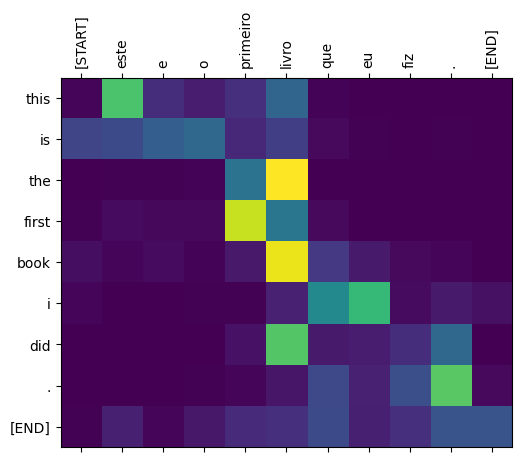

In [69]:
plot_attention_head(in_tokens, translated_tokens, attention)

In [70]:
def plot_attention_weights(sentence, translated_tokens, attention_heads):
  in_tokens = tf.convert_to_tensor([sentence])
  in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
  in_tokens = tokenizers.pt.lookup(in_tokens)[0]

  fig = plt.figure(figsize=(16, 8))

  for h, head in enumerate(attention_heads):
    ax = fig.add_subplot(2, 4, h+1)

    plot_attention_head(in_tokens, translated_tokens, head)

    ax.set_xlabel(f'Head {h+1}')

  plt.tight_layout()
  plt.show()

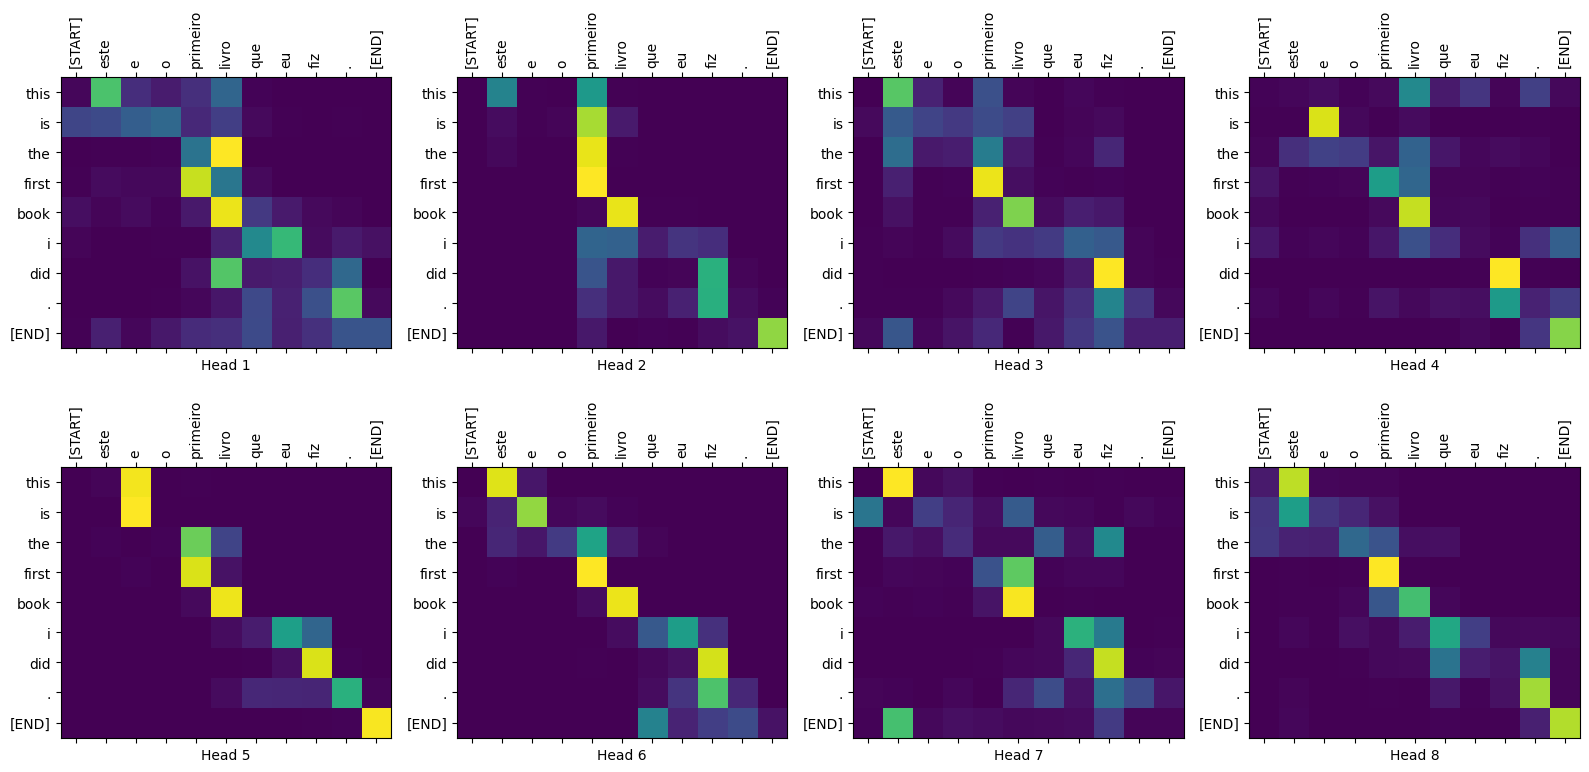

In [71]:
plot_attention_weights(sentence,
                       translated_tokens,
                       attention_weights[0])

The model can handle unfamiliar words. Neither `'triceratops'` nor `'encyclopédia'` are in the input dataset, and the model attempts to transliterate them even without a shared vocabulary. For example:

Input:         : Eu li sobre triceratops na enciclopédia.
Prediction     : i read about chonese chops into egypt .
Ground truth   : I read about triceratops in the encyclopedia.


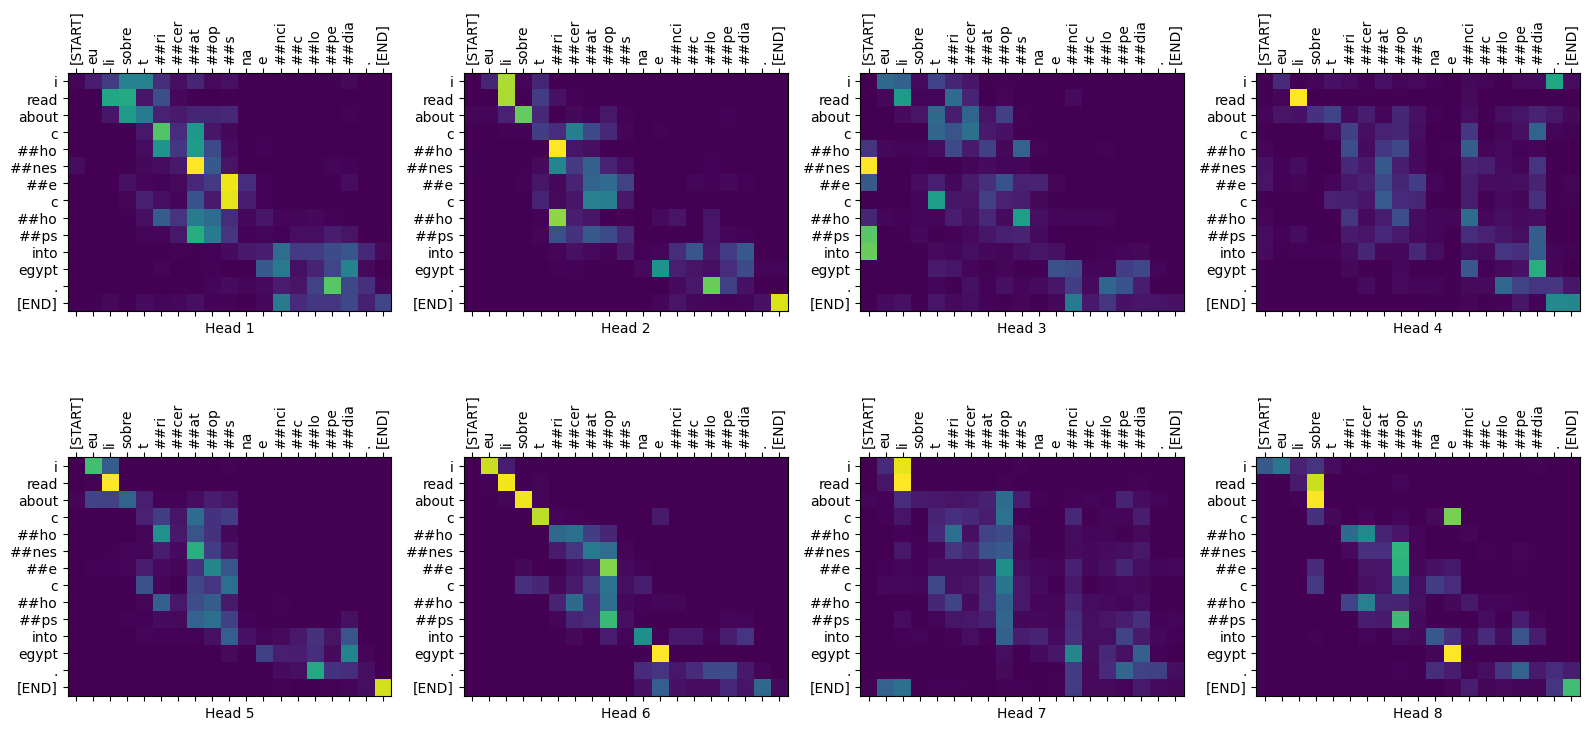

In [72]:
sentence = 'Eu li sobre triceratops na enciclopédia.'
ground_truth = 'I read about triceratops in the encyclopedia.'

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

plot_attention_weights(sentence, translated_tokens, attention_weights[0])

## Export the model

You have tested the model and the inference is working. Next, you can export it as a `tf.saved_model`. To learn about saving and loading a model in the SavedModel format, use [this guide](https://www.tensorflow.org/guide/saved_model).

Create a class called `ExportTranslator` by subclassing the `tf.Module` subclass with a `tf.function` on the `__call__` method:

In [73]:
class ExportTranslator(tf.Module):
  def __init__(self, translator):
    self.translator = translator

  @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
  def __call__(self, sentence):
    (result,
     tokens,
     attention_weights) = self.translator(sentence, max_length=MAX_TOKENS)

    return result

In the above `tf.function` only the output sentence is returned. Thanks to the [non-strict execution](https://tensorflow.org/guide/intro_to_graphs) in `tf.function` any unnecessary values are never computed.

Wrap `translator` in the newly created `ExportTranslator`:

In [74]:
translator = ExportTranslator(translator)

Since the model is decoding the predictions using `tf.argmax` the predictions are deterministic. The original model and one reloaded from its `SavedModel` should give identical predictions:

In [75]:
translator('este é o primeiro livro que eu fiz.').numpy()

b'this is the first book i did .'

In [76]:
tf.saved_model.save(translator, export_dir='translator')

INFO:tensorflow:Assets written to: translator/assets


INFO:tensorflow:Assets written to: translator/assets


In [77]:
reloaded = tf.saved_model.load('translator')

In [78]:
reloaded('este é o primeiro livro que eu fiz.').numpy()

b'this is the first book i did .'

## Conclusion

In this tutorial you learned about:

* The Transformers and their significance in machine learning
* Attention, self-attention and multi-head attention
* Positional encoding with embeddings
* The encoder-decoder architecture of the original Transformer
* Masking in self-attention
* How to put it all together to translate text

The downsides of this architecture are:

- For a time-series, the output for a time-step is calculated from the *entire history* instead of only the inputs and current hidden-state. This _may_ be less efficient.
- If the input has a temporal/spatial relationship, like text or images, some positional encoding must be added or the model will effectively see a bag of words.

If you want to practice, there are many things you could try with it. For example:

* Use a different dataset to train the Transformer.
* Create the "Base Transformer" or "Transformer XL" configurations from the original paper by changing the hyperparameters.
* Use the layers defined here to create an implementation of [BERT](https://arxiv.org/abs/1810.04805)
* Use Beam search to get better predictions.

There are a wide variety of Transformer-based models, many of which improve upon the 2017 version of the original Transformer with encoder-decoder, encoder-only and decoder-only architectures.

Some of these models are covered in the following research publications:

* ["Efficient Transformers: a survey"](https://arxiv.org/abs/2009.06732) (Tay et al., 2022)
* ["Formal algorithms for Transformers"](https://arxiv.org/abs/2207.09238) (Phuong and Hutter, 2022).
* [T5 ("Exploring the limits of transfer learning with a unified text-to-text Transformer")](https://arxiv.org/abs/1910.10683) (Raffel et al., 2019)

You can learn more about other models in the following Google blog posts:

* [PaLM](https://ai.googleblog.com/2022/04/pathways-language-model-palm-scaling-to.html).
* [LaMDA](https://ai.googleblog.com/2022/01/lamda-towards-safe-grounded-and-high.html)
* [MUM](https://blog.google/products/search/introducing-mum/)
* [Reformer](https://ai.googleblog.com/2020/01/reformer-efficient-transformer.html)
* [BERT](https://ai.googleblog.com/2018/11/open-sourcing-bert-state-of-art-pre.html)

If you're interested in studying how attention-based models have been applied in tasks outside of natural language processing, check out the following resources:

- Vision Transformer (ViT): [Transformers for image recognition at scale](https://ai.googleblog.com/2020/12/transformers-for-image-recognition-at.html)
- [Multi-task multitrack music transcription (MT3)](https://magenta.tensorflow.org/transcription-with-transformers) with a Transformer
- [Code generation with AlphaCode](https://www.deepmind.com/blog/competitive-programming-with-alphacode)
- [Reinforcement learning with multi-game decision Transformers](https://ai.googleblog.com/2022/07/training-generalist-agents-with-multi.html)
- [Protein structure prediction with AlphaFold](https://www.nature.com/articles/s41586-021-03819-2)
- [OptFormer: Towards universal hyperparameter optimization with Transformers](http://ai.googleblog.com/2022/08/optformer-towards-universal.html)
